# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- ~~AF: Tagliare i grb con `S/N del picco <10`;~~
- ~~AF: Sostituire il plot del T90 con quello del 20%;~~
- ~~AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * bin_error`, con `n_sigma = 1`;~~
- ~~AF: Cambiare la tecnica con cui viene calcolato l'S/N dei grb (S/N del picco) con quella suggerita da Cristiano (S/N di tutto il GRB);~~ 
- ~~Autocorrelazione: in attesa di news;~~
- ~~LB: Rewrite everything inside functions and comment thoroughly the code!~~
- ~~LB: Aggiungere un flag alla funzione plot per indicare quale strumento si sta considerando~~
- ~~AF: Controllare qual è la distribuzione del S/N per Swift~~
- ~~AF: Trovare i valori di risoluzione temporale, area efficace e background per Swift e BeppoSax~~
- ~~AF: Eseguire un test KS e/o AD sulla distribuzione dei tempi di BATSE~~
- ~~Chiedere ad Anastasia perchè nella funzione `_restore_lc()` manca il fattore `ampl` che aveva usato prima. Chiedere anche come salvare il file `yaml`;~~
- Chiedere ad Anastasia come salvare il file `yaml`;

---

- I risultati di MEPSA girati sui GRB di BATSE si trovano in `/astrodata/guidorzi/CGRO_BATSE/PEAKS_ALL/` (se c'e' un `#` davanti significa che sono stati scartati manualmente da CG)

CG: anziche' usare MEPSA che e' parecchio lento, come quinta metrica possiamo usare la seguente cosa. Runniamo MEPSA su BATSE (gia' fatto, con S2N=5), e costruiamo la distribuzione dei peak count-rate (ovvero qual e' la distribuzione dei conteggi di picco, 6o campo nel file di output di MEPSA). A questo punto dovremo decidere un valore di soglia sotto al quale i picchi con pochi conteggi non sono visti da MEPSA su BATSE, perche' i picchi molto bassi sono coperti dal rumore (quindi anche se ci sono, MEPSA non li vede perche' sono coperti dal rumore). A questo punto anziche' runnare MEPSA sulle curve finali simulate per ottenere il numero di picchi statisticamente significativi, contiamo direttamente il numero di impulsi (parenti+figli) usati per generare il dato GRB (valore gia' noto), considerando pero' solo quelli che superano la soglia decisa prima, ovvero quelli che non verrebbero coperti una volta aggiunto il rumore alle nostre curve simulate. Quello che facciamo quindi, al posto di runnare MEPSA sulle curve simulate, e' dare direttamente il numero di impulsi usati per generare il GRB, ma andando a tagliare sul valore di picco, escludendo quelli piu' bassi del valore di soglia di cui sopra. Per farlo direi che dobbiamo aggiungere alla classe `GRB` un attributo, ovvero il numero di impulsi totali (parenti+figli) sopra la soglia.

### REFERENCES:
- [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)
- [Mitrofanov et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract)
- [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%config InlineBackend.figure_format='retina' # very useful command for high-res images
%matplotlib inline

from statistical_test import *

#SEED=42
#np.random.seed(SEED)

In [2]:
# set the username for the path of the files:
user='LB'
#user='AF'
#user='bach'
if user=='bach':
    # library paths
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/statistical_test')
    sys.path.append('/home/bazzanini/PYTHON/genetic/lc_pulse_avalanche/lc_pulse_avalanche')
    # real data
    batse_path = '/astrodata/guidorzi/CGRO_BATSE/'
    swift_path = '/astrodata/guidorzi/Swift_BAT/'
    sax_path   = '/astrodata/guidorzi/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path     = ''
    swift_sim_path     = ''
    beppo_sax_sim_path = ''
    # mepsa
    mepsa_path      = ''
    ex_pattern_path = ''
elif user=='LB':
    # real data
    batse_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    swift_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/Swift_BAT/'
    sax_path   = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/BeppoSAX_GRBM/'
    # simulations
    batse_sim_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse/'
    #batse_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/batse_OLD/'
    swift_sim_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swift/'
    #swift_sim_path     = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/swift_OLD/'
    beppo_sax_sim_path  = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax/'
    #beppo_sax_sim_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/simulations/sax_OLD/'
    # mepsa
    mepsa_path      = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
    # m3psa on BATSE
    batse_mepsa_res_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'
elif user=='AF':
    batse_path            = 'E:/grb_to_test/CGRO_BATSE/'
    batse_mepsa_res_path  = 'E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
    swift_path            = 'E:/grb_to_test/Swift_BAT/'
    sax_path              = 'E:/grb_to_test/BeppoSAX_GRBM/'
    batse_sim_path        = 'E:/grb_to_test/simulations/batse/'
    swift_sim_path        = 'E:/grb_to_test/simulations/swift/'
    beppo_sax_sim_path_hr = 'E:/grb_to_test/simulations/sax_hr/'
    beppo_sax_sim_path_lr = 'E:/grb_to_test/simulations/sax_lr/'
    mepsa_path            = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/mepsa.so'
    ex_pattern_path       = 'C:/Users/Lisa/Documents/GitHub/lc_pulse_avalanche/pyMEPSA/excess_pattern_MEPSA_v0.dat'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

# LOAD DATA

In [3]:
t_i     = 0   # [s]
t_f     = 150 # [s]
t_f_sax = 50  # [s]

# BATSE
bin_time_batse     = instr_batse['res'] # temporal resolution (bins) for BATSE [s]
test_times_batse   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_batse))
sn_threshold_batse = instr_batse['sn_threshold']
t90_threshold      = instr_batse['t90_threshold'] 
t90_frac           = 15

# Swift
bin_time_swift     = instr_swift['res'] # temporal resolution (bins) for Swift [s]
test_times_swift   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_swift))
sn_threshold_swift = instr_swift['sn_threshold']
t90_threshold      = instr_swift['t90_threshold'] 
t90_frac           = 15

# BeppoSAX (HR)
bin_time_sax_hr   = instr_sax['res']      # temporal resolution (bins) for BeppoSAX (HIGH res) [s]
test_times_sax_hr = np.linspace(t_i, t_f_sax, int((t_f_sax-t_i)/bin_time_sax_hr))
sn_threshold_sax  = instr_sax['sn_threshold'] 
t90_threshold     = instr_sax['t90_threshold'] 
t90_frac          = 15

# BeppoSAX (LR)
bin_time_sax_lr     = instr_sax_lr['res'] # temporal resolution (bins) for BeppoSAX (LOW res) [s]
test_times_sax_lr   = np.linspace(t_i, t_f, int((t_f-t_i)/bin_time_sax_lr))
sn_threshold_sax_lr = instr_sax_lr['sn_threshold'] 
t90_threshold       = instr_sax_lr['t90_threshold'] 
t90_frac            = 15

## Load REAL Data

#### BATSE 

In [4]:
### Load the BATSE GRBs

# load all data
grb_list_batse = load_lc_batse(path=batse_path) 
# apply constraints
grb_list_batse = apply_constraints(grb_list=grb_list_batse, 
                                   bin_time=bin_time_batse, 
                                   t90_threshold=t90_threshold, 
                                   t90_frac=t90_frac,
                                   sn_threshold=sn_threshold_batse, 
                                   t_f=t_f)

100%|██████████| 1457/1457 [00:02<00:00, 540.00it/s]


Total number of _long_ GRBs in BATSE catalogue:  1457
GRBs in the catalogue which are NOT present in the data folder:  0
Loaded GRBs:  1457
Total number of input GRBs:  1457
GRBs with negative duration:  0
GRBs that satisfy the constraints:  585


In [ ]:
# select for MEPSA only the grbs that satisfy the constraints

#with open('./grb_for_mepsa.txt', 'w') as output:
#    for i in range(len(grb_list_batse)):
#        name = grb_list_batse[i].name
#        output.write(name + '\n')

####  Swift 

Test per vedere quanti ne seleziona:

SN = 70 -> 150 circa <br>
SN = 35 -> 350 circa <br>
SN = 15 -> 591

In [11]:
### Load the Swift GRBs

# load all data
grb_list_swift = load_lc_swift(path=swift_path)
# apply constraints
grb_list_swift, sn_lev_swift = apply_constraints(grb_list=grb_list_swift, 
                                                 bin_time=bin_time_swift, 
                                                 t90_threshold=t90_threshold, 
                                                 t90_frac=t90_frac,
                                                 sn_threshold=sn_threshold_swift, 
                                                 t_f=t_f,
                                                 sn_distr=True)

100%|██████████| 1389/1389 [03:54<00:00,  5.93it/s]


Total number of GRBs in Swift catalogue:  1389
GRBs in the catalogue which are NOT present in the data folder:  115
Loaded GRBs:  1274
Total number of input GRBs:  1274
GRBs with negative duration:  0
GRBs that satisfy the constraints:  527


Average S/N 38.453487


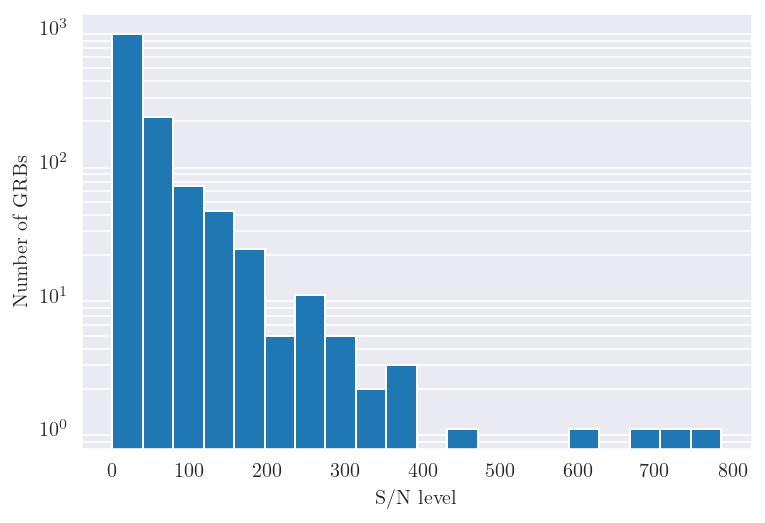

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(sn_lev_swift, bins=20)

ax.set_yscale('log')
ax.grid(which='both')
ax.set_xlabel('S/N level')
ax.set_ylabel('Number of GRBs')
#ax.set_xlim(0,100)
print('Average S/N', np.mean(sn_lev_swift))

#### BeppoSAX (High res)

In [8]:
### Load the BeppoSAX GRBs

# load all (HR) data
grb_list_sax_hr = load_lc_sax_hr(path=sax_path) 

# apply constraints
grb_list_sax_hr = apply_constraints(grb_list=grb_list_sax_hr, 
                                    bin_time=bin_time_sax_hr, 
                                    t90_threshold=t90_threshold, 
                                    t90_frac=t90_frac,
                                    sn_threshold=sn_threshold_sax, 
                                    t_f=t_f_sax) # The high-res lc span a total of 106 sec, 
                                                 # so we need to reduce the 150 sec constraint

# The data from BeppoSAX show some strange line features in the light curve (both strong negative and strong positive peaks).
# We remove those GRBs from the analysis. 







#@@@@@@Lorenzo: spostiamo questa parte nel load_lc_sax direttamente? 
grb_list_sax_hr = [grb for grb in grb_list_sax_hr if  all(grb.counts > -50) and all(grb.counts < np.mean(grb.counts)*80) ]

print('GRBs that have no lines features in the LC: ', len(grb_list_sax_hr))

Total number of GRBs in BeppoSAX catalogue:  1082
GRBs that have an high-res "best" (or 2-mixed) channel lc: 546
GRBs in the catalogue which are NOT present in the data folder:  0
GRBs in the catalogue which have a T90 greater than 106s:  32
GRBs in the catalogue which are present in the data folder, but with no T90:  28
Loaded GRBs:  486
Total number of input GRBs:  486
GRBs with negative duration:  0
GRBs that satisfy the constraints:  224
GRBs that have no lines features in the LC:  121


#### BeppoSAX (Low res)

In [6]:
### Load the BeppoSAX GRBs

# load all (HR) data
grb_list_sax_lr = load_lc_sax_lr(path=sax_path) 

# apply constraints
grb_list_sax_lr = apply_constraints(grb_list=grb_list_sax_lr, 
                                    bin_time=bin_time_sax_lr, 
                                    t90_threshold=t90_threshold, 
                                    t90_frac=t90_frac,
                                    sn_threshold=sn_threshold_sax, 
                                    t_f=t_f, filter = False)

Total number of GRBs in BeppoSAX catalogue:  1082
GRBs in the catalogue which are NOT present in the data folder:  159
GRBs in the catalogue which are present in the data folder, but with no T90:  62
Loaded GRBs:  861
Total number of input GRBs:  861
GRBs with negative duration:  20
GRBs that satisfy the constraints:  312


## Load SIMULATED Data 

We load the simulated GRBs produced with the avalanche; the files are: `lcXXX.txt`, one file for each simulated GRB; the columns in the files are: `times`, `counts`, `errs`, `t90`.

#### BATSE:

In [5]:
### Load the simulated BATSE GRBs

# load all data
grb_list_sim_batse = load_lc_sim(path=batse_sim_path)
# apply constraints
grb_list_sim_batse = apply_constraints(grb_list=grb_list_sim_batse, 
                                       bin_time=bin_time_batse, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_batse, 
                                       t_f=t_f)

100%|██████████| 2000/2000 [00:19<00:00, 101.30it/s]


Total number of simulated GRBs:  2000
Total number of input GRBs:  2000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  2000


#### Swift:

In [31]:
# Load the simulated Swift GRBs

# load all data
grb_list_sim_swift = load_lc_sim(path=swift_sim_path)
# apply constraints
grb_list_sim_swift = apply_constraints(grb_list=grb_list_sim_swift, 
                                       bin_time=bin_time_swift, 
                                       t90_threshold=t90_threshold, 
                                       t90_frac=t90_frac,
                                       sn_threshold=sn_threshold_swift, 
                                       t_f=t_f)

100%|██████████| 1000/1000 [00:09<00:00, 106.47it/s]


Total number of simulated GRBs:  1000
Total number of input GRBs:  1000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  1000


#### BeppoSAX (High res):

In [13]:
### Load the simulated BeppoSAX GRBs
 
# # load all data
grb_list_sim_sax_hr = load_lc_sim(path=beppo_sax_sim_path_hr) 
# apply constraints
grb_list_sim_sax_hr = apply_constraints(grb_list=grb_list_sim_sax_hr, 
                                        bin_time=bin_time_sax_hr, 
                                        t90_threshold=t90_threshold, 
                                        t90_frac=t90_frac,
                                        sn_threshold=sn_threshold_sax, 
                                        t_f=t_f_sax)

100%|██████████| 201/201 [04:43<00:00,  1.41s/it]


Total number of simulated GRBs:  201
Total number of input GRBs:  201
GRBs with negative duration:  0
GRBs that satisfy the constraints:  201


#### BeppoSAX (Low res):

In [ ]:
### Load the simulated BeppoSAX GRBs
 
# # load all data
grb_list_sim_sax_lr = load_lc_sim(path=beppo_sax_sim_path_lr) 
# apply constraints
grb_list_sim_sax_lr = apply_constraints(grb_list=grb_list_sim_sax_lr, 
                                        bin_time=bin_time_sax_lr, 
                                        t90_threshold=t90_threshold, 
                                        t90_frac=t90_frac,
                                        sn_threshold=sn_threshold_sax, 
                                        t_f=t_f, filter = False)

100%|██████████| 1000/1000 [00:17<00:00, 57.90it/s]

Total number of simulated GRBs:  1000
Total number of input GRBs:  1000
GRBs with negative duration:  0
GRBs that satisfy the constraints:  1000


# Test 1&2: Average Peak-Aligned Profiles

In [6]:
# averaged_fluxes_batse, \
# averaged_fluxes_cube_batse, \
# averaged_fluxes_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
#                                                        t_f=t_f, 
#                                                        bin_time=bin_time_batse,
#                                                        filter=True)
# 
# averaged_fluxes_sim_batse, \
# averaged_fluxes_cube_sim_batse, \
# averaged_fluxes_rms_sim_batse = compute_average_quantities(grb_list=grb_list_sim_batse, 
#                                                            t_f=t_f, 
#                                                            bin_time=bin_time_batse,
#                                                            filter=True)

# compute also the rms of the average of the cube of F/F_p
averaged_fluxes_batse, \
averaged_fluxes_cube_batse, \
averaged_fluxes_rms_batse, \
averaged_fluxes_cube_rms_batse = compute_average_quantities(grb_list=grb_list_batse, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_batse,
                                                            filter=True,
                                                            compute_rms=True)

averaged_fluxes_sim_batse, \
averaged_fluxes_cube_sim_batse, \
averaged_fluxes_rms_sim_batse, \
averaged_fluxes_cube_rms_sim_batse = compute_average_quantities(grb_list=grb_list_sim_batse, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_batse,
                                                                filter=True,
                                                                compute_rms=True)

In [8]:
# averaged_fluxes_swift, \
# averaged_fluxes_cube_swift, \
# averaged_fluxes_rms_swift = compute_average_quantities(grb_list=grb_list_swift, 
#                                                        t_f=t_f, 
#                                                        bin_time=bin_time_swift,
#                                                        filter=True)
# 
# averaged_fluxes_sim_swift, \
# averaged_fluxes_cube_sim_swift, \
# averaged_fluxes_rms_sim_swift = compute_average_quantities(grb_list=grb_list_sim_swift, 
#                                                            t_f=t_f, 
#                                                            bin_time=bin_time_swift,
#                                                            filter=True)

# compute also the rms of the average of the cube of F/F_p
averaged_fluxes_swift, \
averaged_fluxes_cube_swift, \
averaged_fluxes_rms_swift, \
averaged_fluxes_cube_rms_swift = compute_average_quantities(grb_list=grb_list_swift, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_swift,
                                                            filter=True,
                                                            compute_rms=True)

averaged_fluxes_sim_swift, \
averaged_fluxes_cube_sim_swift, \
averaged_fluxes_rms_sim_swift, \
averaged_fluxes_cube_rms_sim_swift = compute_average_quantities(grb_list=grb_list_sim_swift, 
                                                                t_f=t_f, 
                                                                bin_time=bin_time_swift,
                                                                filter=True,
                                                                compute_rms=True)

NameError: name 'grb_list_swift' is not defined

In [20]:
averaged_fluxes_sax_hr, \
averaged_fluxes_cube_sax_hr, \
averaged_fluxes_rms_sax_hr = compute_average_quantities(grb_list=grb_list_sax_hr, 
                                                        t_f=t_f_sax, 
                                                        bin_time=bin_time_sax_hr,
                                                        filter=True, filter_window = 51)

averaged_fluxes_sim_sax_hr, \
averaged_fluxes_cube_sim_sax_hr, \
averaged_fluxes_rms_sim_sax_hr = compute_average_quantities(grb_list=grb_list_sim_sax_hr, 
                                                            t_f=t_f_sax, 
                                                            bin_time=bin_time_sax_hr,
                                                            filter=True, filter_window = 51)

In [41]:
averaged_fluxes_sax_lr, \
averaged_fluxes_cube_sax_lr, \
averaged_fluxes_rms_sax_lr = compute_average_quantities(grb_list=grb_list_sax_lr, 
                                                        t_f=t_f, 
                                                        bin_time=bin_time_sax_lr,
                                                        filter=True, filter_window = 3)

averaged_fluxes_sim_sax_lr, \
averaged_fluxes_cube_sim_sax_lr, \
averaged_fluxes_rms_sim_sax_lr = compute_average_quantities(grb_list=grb_list_sim_sax_lr, 
                                                            t_f=t_f, 
                                                            bin_time=bin_time_sax_lr,
                                                            filter=True, filter_window = 3)

In [ ]:
#for grb in grb_list_sax_lr:
#    peak_pos = np.argmax(grb.counts)
#    if grb.counts[peak_pos + 25] < 0:
#        plt.figure()
#        plt.plot(grb.times, grb.counts)
#        plt.show()

# Test 3: Autocorrelation

- `scipy.signal.correlation`

    The correlation $z$ of two $d$-dimensional arrays $x$ and $y$ is defined as:

        z[...,k,...] = sum[..., i_l, ...] x[..., i_l,...] * conj(y[..., i_l - k,...])
        
    This way, if `x` and `y` are 1D arrays and ``z = correlate(x, y, 'full')``, then
    $$
          z[k] = (x * y)(k - N + 1)
               = \sum_{l=0}^{||x||-1}x_l y_{l-k+N-1}^{*}
    $$
    for $k = 0, 1, \dots, ||x|| + ||y|| - 2$, where $||x||$ is the length of $x$, $N = \max(||x||,||y||)$, and $y_m$ is $0$ when m is outside the range of $y$.


- Link93

    Following [Link et al., 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract), for a time lag $\tau$, the autocorrelation function is defined as

    $$
        A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
    $$
    where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
    $$
    \begin{aligned}
    & A(\tau)=1 & (\tau=0) \\
    & A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
    &
    \end{aligned}
    $$
    For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
    $$
    \begin{array}{rlr}
    A(\tau) &= 1 & (\tau=0) \\
    A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0)
    \end{array}
    $$
    where the lag is $\tau \equiv u \Delta t$.


In [7]:
N_lim=np.min( [np.max(len(grb_list_sim_batse  )), 
               np.max(len(grb_list_batse))] )
assert len(grb_list_sim_batse) >= N_lim
assert len(grb_list_batse)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

# steps_sim_batse, acf_sim_batse = compute_autocorrelation(grb_list=grb_list_sim_batse,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_batse,
#                                                          mode=mode)
# 
# steps_batse, acf_batse         = compute_autocorrelation(grb_list=grb_list_batse,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_batse,
#                                                          mode=mode)

# compute also the rms of the autocorrelation
steps_sim_batse, \
acf_sim_batse, \
acf_rms_sim_batse = compute_autocorrelation(grb_list=grb_list_sim_batse,
                                            N_lim=N_lim,
                                            t_max=t_f,
                                            bin_time=bin_time_batse,
                                            mode=mode,
                                            compute_rms=True)

steps_batse, \
acf_batse, \
acf_rms_batse = compute_autocorrelation(grb_list=grb_list_batse,
                                        N_lim=N_lim,
                                        t_max=t_f,
                                        bin_time=bin_time_batse,
                                        mode=mode,
                                        compute_rms=True)                                    

In [33]:
N_lim=np.min( [np.max(len(grb_list_sim_swift  )), 
               np.max(len(grb_list_swift))] )
assert len(grb_list_sim_swift) >= N_lim
assert len(grb_list_swift)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

# steps_sim_swift, acf_sim_swift = compute_autocorrelation(grb_list=grb_list_sim_swift,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_swift,
#                                                          mode=mode)
# 
# steps_swift, acf_swift         = compute_autocorrelation(grb_list=grb_list_swift,
#                                                          N_lim=N_lim,
#                                                          t_max=t_f,
#                                                          bin_time=bin_time_swift,
#                                                          mode=mode)

# compute also the rms of the autocorrelation
steps_sim_swift, \
acf_sim_swift, \
acf_rms_sim_swift = compute_autocorrelation(grb_list=grb_list_sim_swift,
                                            N_lim=N_lim,
                                            t_max=t_f,
                                            bin_time=bin_time_swift,
                                            mode=mode,
                                            compute_rms=True)

steps_swift, \
acf_swift, \
acf_rms_swift         = compute_autocorrelation(grb_list=grb_list_swift,
                                            N_lim=N_lim,
                                            t_max=t_f,
                                            bin_time=bin_time_swift,
                                            mode=mode,
                                            compute_rms=True)

In [24]:
N_lim=np.min( [np.max(len(grb_list_sim_sax_hr)), 
               np.max(len(grb_list_sax_hr))] )
assert len(grb_list_sim_sax_hr) >= N_lim
assert len(grb_list_sax_hr)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

steps_sim_sax_hr, acf_sim_sax_hr = compute_autocorrelation(grb_list=grb_list_sim_sax_hr,
                                                           N_lim=N_lim,
                                                           t_max=t_f_sax,
                                                           bin_time=bin_time_sax_hr,
                                                           mode=mode)

steps_sax_hr, acf_sax_hr         = compute_autocorrelation(grb_list=grb_list_sax_hr,
                                                           N_lim=N_lim,
                                                           t_max=t_f_sax,
                                                           bin_time=bin_time_sax_hr,
                                                           mode=mode)

In [42]:
N_lim=np.min( [np.max(len(grb_list_sim_sax_lr)), 
               np.max(len(grb_list_sax_lr))] )
assert len(grb_list_sim_sax_lr) >= N_lim
assert len(grb_list_sax_lr)     >= N_lim

# choose the method for computing the autocorrelation:
mode='scipy'
#mode='link93'

steps_sim_sax_lr, acf_sim_sax_lr = compute_autocorrelation(grb_list=grb_list_sim_sax_lr,
                                                           N_lim=N_lim,
                                                           t_max=t_f,
                                                           bin_time=bin_time_sax_lr,
                                                           mode=mode)

steps_sax_lr, acf_sax_lr         = compute_autocorrelation(grb_list=grb_list_sax_lr,
                                                           N_lim=N_lim,
                                                           t_max=t_f,
                                                           bin_time=bin_time_sax_lr,
                                                           mode=mode)

# Test 4: Duration
Duration of the GRB measured at a level of 20% of the peak, as in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267). Before computing the duration, we filter the signal in order to smooth it.

In [8]:
#duration_batse       = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_batse)[0] for grb in grb_list_batse ]
#
#duration_sim_batse   = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_batse)[0] for grb in grb_list_sim_batse   ]

duration_batse     = [ grb.t20 for grb in grb_list_batse ]
duration_sim_batse = [ grb.t20 for grb in grb_list_sim_batse ]

dur_distr_batse     = compute_kde_log_duration(duration_batse)
dur_distr_sim_batse = compute_kde_log_duration(duration_sim_batse)

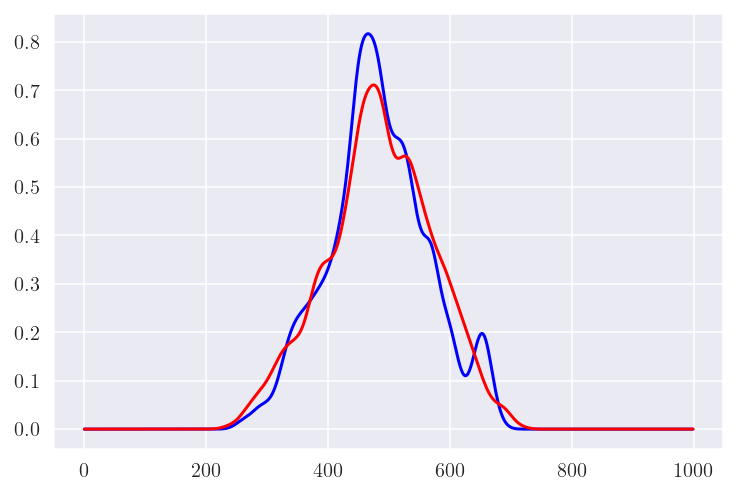

In [11]:
plt.plot(dur_distr_batse,     c='b')
plt.plot(dur_distr_sim_batse, c='r')
plt.show()

In [34]:
#duration_swift       = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_swift)[0] for grb in grb_list_swift ]
#
#duration_sim_swift   = [ evaluateDuration20(times=grb.times, 
#                                            counts=grb.counts,
#                                            filter=True,
#                                            t90=grb.t90,
#                                            t90_frac=t90_frac,
#                                            bin_time=bin_time_swift)[0] for grb in grb_list_sim_swift   ]

duration_swift     = [ grb.t20 for grb in grb_list_swift ]
duration_sim_swift = [ grb.t20 for grb in grb_list_sim_swift ]

dur_distr_swift     = compute_kde_log_duration(duration_swift)
dur_distr_sim_swift = compute_kde_log_duration(duration_sim_swift)

In [29]:
#duration_sax_hr       = [ evaluateDuration20(times=grb.times, 
#                                             counts=grb.counts,
#                                             filter=True,
#                                             t90=grb.t90,
#                                             t90_frac=15,
#                                             bin_time=bin_time_sax_hr)[0] for grb in grb_list_sax_hr ]
#
#duration_sim_sax_hr   = [ evaluateDuration20(times=grb.times, 
#                                             counts=grb.counts,
#                                             filter=True,
#                                             t90=grb.t90,
#                                             t90_frac=15,
#                                             bin_time=bin_time_sax_hr)[0] for grb in grb_list_sim_sax_hr   ]

duration_sax     = [ grb.t20 for grb in grb_list_sax ]
duration_sim_sax = [ grb.t20 for grb in grb_list_sim_sax ]

dur_distr_sax     = compute_kde_log_duration(duration_sax_hr)
dur_distr_sim_sax = compute_kde_log_duration(duration_sim_sax_hr)

In [45]:
duration_sax_lr     = []
duration_sim_sax_lr = []

for grb in grb_list_sax_lr:
    try:
        duration_sax_lr.append(evaluateDuration20(times=grb.times, 
                                                  counts=grb.counts,
                                                  filter=False,
                                                  t90=grb.t90,
                                                  bin_time=bin_time_sax_lr)[0])
    except AssertionError:
        continue

for grb in grb_list_sim_sax_lr:
    try:
        duration_sim_sax_lr.append(evaluateDuration20(times=grb.times, 
                                                      counts=grb.counts,
                                                      filter=False,
                                                      t90=grb.t90,
                                                      bin_time=bin_time_sax_lr)[0])
    except AssertionError:
        continue


dur_distr_sax     = compute_kde_log_duration(duration_sax_lr)
dur_distr_sim_sax = compute_kde_log_duration(duration_sim_sax_lr)

## Test 5a: Number of significative peaks (MEPSA _real_ vs MEPSA _sim_)

#### Run MEPSA on the _simulated_ light-curves for BATSE (very slow!)

In [21]:
reb_factor     = 32
peak_sn_level  = 5
n_of_peaks_sim = [runMEPSA(mepsa_path=mepsa_path, 
                           ex_pattern_file_path=ex_pattern_path, 
                           grb_file_path=grb.data_file_path, 
                           nbins=reb_factor, 
                           grb_name=grb.name, 
                           sn_level=peak_sn_level) for grb in tqdm(grb_list_sim_batse)]
mepsa_pulses = n_of_peaks_sim
mepsa_sim    = n_of_peaks_sim

# MEPSA: 90 min = 5400 s
# OUR-CODE: (598 - 361) s = 237 s

  0%|          | 1/2000 [00:02<1:31:09,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    5	    94.704    0.896	 585.55641  52.77821   11.09	34 10
  2    9    1	   119.952    0.576	1205.92111  66.34750   18.18	12  6
  3    3    1	   122.448    0.192	1710.95256 115.64738   14.79	21  9
  4    2    0	   127.280    0.128	4538.24554 146.54393   30.97	16  6
  5    2    1	   129.392    0.128	4499.91048 146.47851   30.72	 6  4
  6    2    1	   130.672    0.128	4102.71720 145.79903   28.14	14  7
  7    1    0	   131.344    0.064	3753.63461 205.34272   18.28	12  6
  8    2    1	   133.616    0.128	2245.01896 142.57808   15.75	14  7
  9    1    0	   134.544    0.064	3467.80088 204.64555   16.95	14  7
 10    2    0	   135.216    0.128	2948.85932 143.80692   20.51	12  6
 11    4    0	   135.792    0.256	2124.94520 100.66894   21.11	 3  4
 12    3    2	   138.256    0.192	1648.05195 115.55670   14.26	23  8


  0%|          | 2/2000 [00:05<1:30:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	17786.64763 237.06254   75.03	 1  2
  2    3    2	     2.320    0.192	5365.69929 120.79970   44.42	25  9
  3    2    0	     7.344    0.128	13402.48774 160.95727   83.27	25  9
  4    2    0	    13.232    0.128	12512.95572 159.56966   78.42	12  6
  5    3    1	    15.888    0.192	15205.11250 133.68759  113.74	17  7


  0%|          | 3/2000 [00:08<1:30:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.616    0.192	1361.18157 115.14220   11.82	17  7
  2    2    0	     3.760    0.128	1390.42660 141.07166    9.86	25  9
  3    2    0	     5.808    0.128	1502.86412 141.27078   10.64	16  6
  4   24    5	   490.288    1.536	 461.20137  40.24570   11.46	30 10
  5   13    0	   567.824    0.832	 745.13791  54.88249   13.58	35 10
  6   18    1	   588.528    1.152	 432.79149  46.45475    9.32	28  9
  7    8    2	   603.248    0.512	 870.76103  70.07385   12.43	14  7
  8    3    1	   606.096    0.192	1607.37567 115.49802   13.92	30 10
  9    1    0	   610.448    0.064	3176.04230 203.93146   15.57	23  8
 10    4    0	   612.208    0.256	2363.50906 100.96473   23.41	 6  4
 11    3    1	   615.120    0.192	4656.77331 119.81760   38.87	13  6
 12    1    0	   616.336    0.064	4939.19109 208.20949   23.72	14  7
 13    1    0	   617.744    0.064	2759.62510 202.90792   13.60	24  8
 14    1    0	   619.984

  0%|          | 4/2000 [00:10<1:30:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	     6.704    0.640	1822.41912  63.43061   28.73	17  7
  2    5    0	    10.640    0.320	3146.47148  91.16849   34.51	17  7
  3    1    0	    14.224    0.064	7593.99564 214.49008   35.40	16  6
  4    1    0	    15.056    0.064	11175.54316 222.68261   50.19	38  6
  5    1    0	    15.376    0.064	13749.88285 228.38976   60.20	 5  3
  6    1    0	    16.272    0.064	14007.52080 228.95310   61.18	 1  2
  7    6    1	    17.904    0.384	9343.23069  89.21438  104.73	 1  2
  8    1    0	    18.768    0.064	10344.22207 220.80811   46.85	 6  4
  9    2    1	    19.056    0.128	9829.93962 155.30927   63.29	 4  4
 10    1    0	    20.112    0.064	6972.51328 213.03641   32.73	17  7
 11    1    0	    21.904    0.064	6572.96664 212.09660   30.99	39  8
 12    1    0	    23.504    0.064	5467.80411 209.47507   26.10	 6  4
 13    3    2	    24.016    0.192	5422.38675 120.87788   44.86	 4  4
 14    2    0	    25

  0%|          | 5/2000 [00:13<1:30:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	     3.856    0.576	 867.90810  66.06386   13.14	35 10
  2   18   15	    11.120    1.152	 657.33457  46.58882   14.11	39  8
  3    3    0	    19.088    0.192	3285.47951 117.89470   27.87	25  9
  4    2    1	    20.336    0.128	2466.93386 142.96666   17.26	38  6
  5    2    0	    22.064    0.128	2849.57505 143.63421   19.84	39  8
  6    1    0	    22.928    0.064	4768.75896 207.79980   22.95	25  9
  7    2    0	    24.496    0.128	5644.77493 148.41963   38.03	 2  3
  8    2    1	    28.528    0.128	7184.59523 150.99105   47.58	 2  3
  9    1    0	    29.648    0.064	4214.94655 206.46294   20.42	12  6
 10    2    0	    33.968    0.128	3856.86951 145.37687   26.53	 7  5
 11    1    0	    34.960    0.064	3971.42839 205.87236   19.29	22  7
 12    1    0	    35.344    0.064	4402.66526 206.91705   21.28	 7  5


  0%|          | 6/2000 [00:16<1:30:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     6.832    0.256	4593.56788 103.68892   44.30	 9  4
  2    2    1	     7.536    0.128	4968.21071 147.27561   33.73	17  7
  3    1    0	    11.984    0.064	3859.39927 205.60010   18.77	24  8
  4    2    0	    13.360    0.128	2901.17453 143.72400   20.19	19  7
  5    1    0	    14.352    0.064	2899.33263 203.25189   14.26	25  9
  6    5    3	    16.592    0.320	 876.57680  88.64376    9.89	29 10
  7    6    2	    23.728    0.384	 662.80024  80.69986    8.21	28  9
  8    2    1	    32.880    0.128	2816.03757 143.57583   19.61	 5  3
  9    3    1	    34.896    0.192	2655.82524 117.00118   22.70	24  8
 10    3    0	    37.904    0.192	1175.23635 114.87274   10.23	26  9
 11    3    0	    42.512    0.192	2002.91624 116.06739   17.26	27  9
 12    2    1	    43.632    0.128	1555.89458 141.36459   11.01	39  8


  0%|          | 7/2000 [00:19<1:30:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10683.97279 221.57611   48.22	 1  2
  2    4    3	     1.840    0.256	11804.26256 112.04493  105.35	17  7
  3    1    0	   864.784    0.064	 829.00000 198.09341    4.18	26  9


  0%|          | 8/2000 [00:21<1:29:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	6264.45342 211.36805   29.64	39  8
  2    1    0	     0.976    0.064	5521.79109 209.60389   26.34	39  8
  3    1    0	     1.808    0.064	2548.57501 202.38719   12.59	 6  4
  4    1    0	     2.768    0.064	3428.16412 204.54868   16.76	 1  2


  0%|          | 9/2000 [00:24<1:29:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	3393.85061 204.46479   16.60	14  7
  2    1    0	     1.296    0.064	6967.87323 213.02552   32.71	 5  3
  3    1    0	     1.552    0.064	7119.08025 213.38013   33.36	 2  3
  4    1    0	     1.936    0.064	4073.07606 206.11908   19.76	 7  5
  5    1    0	     2.384    0.064	4285.90911 206.63472   20.74	 1  2
  6    1    0	     3.152    0.064	1510.88350 199.80712    7.56	38  6
  7    9    2	     7.120    0.576	2119.29638  67.10795   31.58	14  7
  8    1    0	   498.576    0.064	 807.00000 198.03788    4.07	30 10


  0%|          | 10/2000 [00:27<1:30:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   15	    14.576    1.152	 764.42365  46.65263   16.39	27  9
  2    5    3	    27.472    0.320	2083.00536  89.99445   23.15	12  6
  3    3    0	    30.032    0.192	2050.17972 116.13524   17.65	30 10
  4    5    0	    35.920    0.320	1600.33941  89.45651   17.89	39  8
  5    8    5	    39.728    0.512	1735.04212  70.84053   24.49	 5  3
  6    2    1	    42.096    0.128	5617.06151 148.37294   37.86	 6  4
  7    1    0	    42.768    0.064	6360.79098 211.59582   30.06	 2  3
  8    2    1	    43.376    0.128	4320.57719 146.17212   29.56	 4  4
  9    1    0	    44.048    0.064	4521.10972 207.20306   21.82	 2  3
 10    3    1	    45.072    0.192	3041.61258 117.54944   25.88	 6  4
 11    1    0	    46.800    0.064	1805.71904 200.54356    9.00	39  8
 12    2    1	    48.368    0.128	2279.23360 142.63806   15.98	14  7
 13    2    0	    49.328    0.128	2270.30382 142.62241   15.92	 7  5
 14    5    0	    51.920

  1%|          | 11/2000 [00:29<1:30:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3959.55797 205.84353   19.24	39  8
  2    2    0	     0.816    0.128	3130.23431 144.12188   21.72	 2  3
  3    1    0	     2.128    0.064	4591.24935 207.37225   22.14	 2  3
  4    1    0	     2.960    0.064	1881.23380 200.73175    9.37	38  6
  5    5    3	     5.712    0.320	2218.86777  90.14529   24.61	24  8
  6    2    1	     8.816    0.128	1873.59560 141.92532   13.20	25  9


  1%|          | 12/2000 [00:32<1:29:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4564.47280 207.30768   22.02	 1  2
  2    1    0	     0.592    0.064	4258.17035 206.56759   20.61	 1  2
  3   11   10	    12.112    0.704	2450.11496  60.94865   40.20	17  7


  1%|          | 13/2000 [00:35<1:29:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	13194.72882 227.17114   58.08	17  7
  2    1    0	     1.616    0.064	7323.11295 213.85769   34.24	17  7
  3    2    1	    10.864    0.128	16290.60864 165.38230   98.50	14  7
  4    3    1	    18.000    0.192	7986.81544 124.36347   64.22	23  8


  1%|          | 14/2000 [00:38<1:29:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7371.77688 213.97144   34.45	 1  2
  2    1    0	     1.296    0.064	10284.16081 220.67207   46.60	14  7
  3    8    5	   439.088    0.512	 339.26785  69.59819    4.87	26  9
  4    4    1	   904.368    0.256	 445.50000  98.56153    4.52	26  9
  5    1    0	   973.008    0.064	 899.00000 198.27002    4.53	30 10


  1%|          | 15/2000 [00:40<1:29:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	5877.43461 148.81101   39.50	 6  4
  2    6    5	   653.680    0.384	 328.33333  80.35373    4.09	38  6


  1%|          | 16/2000 [00:43<1:29:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.288    0.064	1848.48391 200.65015    9.21	27  9
  2    2    1	    14.448    0.128	3280.06235 144.38155   22.72	14  7
  3    1    0	    15.952    0.064	5570.81735 209.72081   26.56	12  6
  4    1    0	    17.168    0.064	3960.95706 205.84693   19.24	14  7
  5    3    0	    17.744    0.192	3237.79743 117.82727   27.48	 5  3
  6    2    1	    21.232    0.128	3297.29952 144.41139   22.83	14  7
  7    7    4	   263.312    0.448	 315.14286  74.38043    4.24	27  9


  1%|          | 17/2000 [00:46<1:29:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	     1.232    0.832	 660.84930  54.82339   12.05	30 10
  2   26   12	   144.688    1.664	1071.35958  38.96910   27.49	32 10
  3   28   20	   219.760    1.792	 440.62768  37.25042   11.83	25  9
  4   28   26	   281.072    1.792	 317.54223  37.19137    8.54	30 10
  5   16   14	   317.040    1.024	 652.35980  49.41176   13.20	39  8
  6   16   14	   336.496    1.024	1089.06569  49.68719   21.92	32 10
  7   10    9	   348.656    0.640	 908.05134  62.70570   14.48	24  8
  8    1    0	   375.120    0.064	2661.22903 202.66531   13.13	14  7
  9    2    1	   376.688    0.128	4874.00952 147.11562   33.13	14  7
 10    2    0	   378.288    0.128	6820.04221 150.38624   45.35	12  6
 11    2    1	   379.504    0.128	7085.33641 150.82662   46.98	17  7
 12    1    0	   380.176    0.064	8468.72476 216.51957   39.11	 6  4
 13    1    0	   381.328    0.064	3576.31916 204.91052   17.45	12  6
 14    2    0	   381.744

  1%|          | 18/2000 [00:48<1:29:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	7247.14240 213.68000   33.92	 2  3
  2    1    0	     1.296    0.064	3533.74048 204.80659   17.25	 1  2
  3   27    6	    10.256    1.728	1701.01238  38.54435   44.13	 6  4


  1%|          | 19/2000 [00:51<1:29:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.392    0.256	 955.68752  99.20646    9.63	35 10
  2    4    0	     9.584    0.256	1572.66358  99.98083   15.73	25  9
  3    2    0	    14.000    0.128	3155.74499 144.16613   21.89	14  7
  4    5    1	    14.864    0.320	2787.71303  90.77413   30.71	16  6
  5    1    0	    16.400    0.064	5691.07014 210.00731   27.10	14  7
  6    3    2	    17.680    0.192	4960.95265 120.23997   41.26	14  7
  7    2    1	    18.928    0.128	3610.21773 144.95209   24.91	38  6
  8    2    1	    19.568    0.128	3412.55196 144.61077   23.60	 2  3


  1%|          | 20/2000 [00:54<1:29:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    10.544    0.384	1790.10660  81.85567   21.87	14  7
  2    5    1	    12.624    0.320	2496.43792  90.45268   27.60	 2  3
  3    4    1	    16.304    0.256	1404.53387  99.77040   14.08	39  8
  4    2    0	    19.248    0.128	2722.15222 143.41226   18.98	26  9
  5    2    0	    20.272    0.128	3748.28942 145.19003   25.82	 2  3
  6    2    0	    21.808    0.128	1951.89487 142.06318   13.74	35 10
  7   17   10	    57.552    1.088	1342.36764  48.35796   27.76	23  8
  8   11    6	    63.248    0.704	1343.24632  60.11750   22.34	14  7
  9    2    0	    68.784    0.128	1724.24052 141.66199   12.17	30 10
 10    3    0	    76.304    0.192	2368.03171 116.59050   20.31	14  7
 11    4    1	    79.536    0.256	3446.73427 102.29704   33.69	 9  4
 12    2    1	    80.752    0.128	4510.09665 146.49590   30.79	38  6
 13    2    1	    81.264    0.128	4689.37359 146.80152   31.94	 7  5
 14    4    2	    82.416

  1%|          | 21/2000 [00:56<1:28:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.000    0.064	3917.07602 205.74031   19.04	 9  4
  2    2    1	     8.304    0.128	3344.35942 144.49284   23.15	30 10
  3    2    0	    15.152    0.128	2874.90071 143.67829   20.01	25  9
  4    2    1	    18.160    0.128	4587.79689 146.62844   31.29	12  6
  5   23   15	   128.592    1.472	5156.96906  43.52359  118.49	23  8
  6    2    0	   266.672    0.128	 684.77877 139.81555    4.90	15  5


  1%|          | 22/2000 [00:59<1:28:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	2061.89536 116.15205   17.75	17  7
  2    2    0	     3.888    0.128	2276.02924 142.63245   15.96	19  7
  3    2    0	     7.728    0.128	2430.76069 142.90340   17.01	12  6
  4    2    0	    10.032    0.128	2909.85852 143.73910   20.24	39  8
  5    2    0	    11.312    0.128	3855.73604 145.37492   26.52	 6  4
  6    2    0	    11.952    0.128	3819.11661 145.31193   26.28	 6  4
  7    2    1	    12.656    0.128	4752.61857 146.90919   32.35	14  7
  8    2    1	    14.832    0.128	3726.67408 145.15281   25.67	25  9
  9    1    0	    17.424    0.064	6490.24238 211.90149   30.63	14  7
 10    2    1	    18.032    0.128	8802.28243 153.64616   57.29	14  7
 11    1    0	    19.856    0.064	3477.56768 204.66941   16.99	12  6
 12    1    0	    20.688    0.064	3984.35306 205.90375   19.35	34 10
 13    1    0	    21.520    0.064	4649.56292 207.51280   22.41	14  7
 14    1    0	    22.032

  1%|          | 23/2000 [01:02<1:28:42,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.928    0.128	5883.33810 148.82093   39.53	11  5
  2    1    0	     3.408    0.064	7961.37034 215.34477   36.97	 4  4
  3    1    0	     3.984    0.064	8819.00285 217.32695   40.58	13  6
  4    1    0	     4.624    0.064	9915.07622 219.83420   45.10	 1  2
  5    1    0	     5.072    0.064	11866.83773 224.22943   52.92	24  8
  6    1    0	     6.480    0.064	10545.10147 221.26252   47.66	 5  3
  7    1    0	     6.736    0.064	10138.87160 220.34262   46.01	 1  2
  8    1    0	     6.928    0.064	9750.41826 219.45938   44.43	 5  3
  9    2    1	     8.560    0.128	5953.41525 148.93860   39.97	 1  2
 10    1    0	     9.488    0.064	2773.14094 202.94123   13.66	24  8
 11    2    1	    13.040    0.128	4632.98512 146.70546   31.58	12  6
 12    2    0	    14.256    0.128	3255.56709 144.33913   22.55	 7  5
 13    3    2	    16.912    0.192	1919.49373 115.94754   16.55	 5  3
 14    5    4	   627.

  1%|          | 24/2000 [01:04<1:28:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     0.880    0.640	 590.85845  62.45227    9.46	14  7
  2    8    2	    26.736    0.512	1130.78728  70.30539   16.08	25  9
  3    1    0	    36.624    0.064	5233.76999 208.91570   25.05	14  7
  4    1    0	    37.456    0.064	4587.36929 207.36289   22.12	12  6
  5    2    1	    38.768    0.128	1441.24410 141.16169   10.21	15  5
  6   11    9	   272.528    0.704	 282.06400  59.30971    4.76	26  9


  1%|▏         | 25/2000 [01:07<1:28:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     5.648    0.576	 672.37377  65.89923   10.20	17  7
  2    4    2	    20.464    0.256	3866.98258 102.80927   37.61	17  7
  3    1    0	    21.904    0.064	7113.08025 213.36607   33.34	14  7
  4    6    1	    22.512    0.384	5013.53102  85.07402   58.93	 5  3
  5    3    1	    24.144    0.192	3666.05725 118.43150   30.96	 5  3
  6    2    1	    24.688    0.128	3768.28033 145.22445   25.95	14  7
  7    2    0	    26.416    0.128	3774.12607 145.23451   25.99	14  7
  8    1    0	    27.152    0.064	4356.34048 206.80508   21.06	14  7
  9    2    1	    28.912    0.128	5164.50332 147.60844   34.99	14  7
 10    2    0	    29.744    0.128	4633.12518 146.70570   31.58	12  6
 11    2    0	    32.176    0.128	2021.29530 142.18526   14.22	14  7
 12    2    1	    33.392    0.128	1641.07657 141.51515   11.60	38  6
 13    6    1	    35.568    0.384	1483.16720  81.54259   18.19	 5  3
 14    2    0	    37.040

  1%|▏         | 26/2000 [01:10<1:29:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	10427.33949 220.99624   47.18	 1  2
  2    1    0	     1.296    0.064	7621.46923 214.55412   35.52	 5  3
  3    1    0	     2.320    0.064	5848.94140 210.38284   27.80	 1  2
  4    1    0	     2.704    0.064	2162.85410 201.43201   10.74	 1  2
  5    8    7	    23.984    0.512	3525.52817  72.40298   48.69	25  9
  6   15    2	    53.008    0.960	4169.08991  53.27982   78.25	23  8
  7   14    3	    71.280    0.896	6041.09965  56.34910  107.21	39  8
  8   10    6	    87.344    0.640	11324.84278  70.52435  160.58	39  8
  9    2    0	   100.656    0.128	11862.67571 158.54759   74.82	21  9


  1%|▏         | 27/2000 [01:13<1:29:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     8.944    0.256	1834.92706 100.30818   18.29	38  6
  2    2    1	    10.608    0.128	2560.19385 143.12965   17.89	36  4
  3    2    0	    11.184    0.128	2959.24563 143.82497   20.58	25  9
  4    3    2	    15.568    0.192	2136.98923 116.25975   18.38	34 10
  5    3    1	    18.384    0.192	4492.99494 119.58957   37.57	 5  3
  6    2    0	    19.120    0.128	4537.92542 146.54338   30.97	12  6
  7    2    0	    20.144    0.128	3974.44079 145.57891   27.30	22  7
  8    5    2	    20.688    0.320	3877.71373  91.96707   42.16	 2  3
  9    2    1	    24.688    0.128	3407.61889 144.60225   23.57	17  7
 10    1    0	    25.808    0.064	2911.64657 203.28218   14.32	27  9
 11    2    0	    26.800    0.128	2141.61427 142.39665   15.04	35 10


  1%|▏         | 28/2000 [01:15<1:29:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	8408.11412 216.37956   38.86	 1  2
  2    1    0	     0.720    0.064	7640.70804 214.59895   35.60	 5  3


  1%|▏         | 29/2000 [01:18<1:29:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3749.85193 205.33351   18.26	 1  2
  2    3    0	    11.984    0.192	4830.61430 120.05917   40.24	39  8
  3    4    0	    51.824    0.256	2263.21240 100.84048   22.44	30 10


  2%|▏         | 30/2000 [01:21<1:29:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	    19.600    0.960	 384.49108  50.85698    7.56	14  7
  2    9    3	    37.712    0.576	 723.29616  65.94214   10.97	30 10
  3   12    7	    43.824    0.768	2287.98179  58.23800   39.29	39  8
  4    8    1	    45.104    0.512	2437.79211  71.45785   34.12	 2  3
  5    2    0	    49.072    0.128	2664.53111 143.31178   18.59	12  6
  6    3    2	    51.472    0.192	3199.12768 117.77256   27.16	14  7
  7    2    1	    55.024    0.128	3918.56354 145.48293   26.93	 9  4
  8    2    0	    55.984    0.128	4642.23242 146.72122   31.64	35 10
  9    2    1	    57.200    0.128	5227.90097 147.71578   35.39	14  7
 10    3    2	    59.344    0.192	3548.81581 118.26639   30.01	14  7
 11   14    0	    74.672    0.896	 514.27983  52.72996    9.75	26  9
 12    3    1	    88.464    0.192	1276.29336 115.01926   11.10	14  7
 13    2    0	    91.184    0.128	1916.79105 142.00139   13.50	17  7
 14    2    0	    91.824

  2%|▏         | 31/2000 [01:24<1:29:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	1874.28205 200.71443    9.34	 6  4
  2    5    3	    14.672    0.320	3475.34124  91.52851   37.97	17  7
  3    8    3	    50.352    0.512	5092.86509  73.74353   69.06	30 10
  4    6    0	    69.680    0.384	3622.49799  83.70036   43.28	30 10
  5    7    2	    85.328    0.448	1386.66058  75.40241   18.39	27  9


  2%|▏         | 32/2000 [01:26<1:29:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.296    0.192	1394.03604 115.18975   12.10	12  6
  2   29    6	    24.720    1.856	 551.93949  36.65493   15.06	30 10
  3    3    0	    62.864    0.192	3056.53686 117.57060   26.00	 9  4
  4    3    2	    65.488    0.192	3727.31902 118.51768   31.45	27  9
  5    2    1	    66.928    0.128	5137.22598 147.56223   34.81	14  7
  6    2    0	    68.784    0.128	4792.93844 146.97778   32.61	 7  5
  7    7    6	    70.352    0.448	3812.89983  77.66678   49.09	 5  3
  8    2    1	    71.408    0.128	3177.58233 144.20399   22.04	14  7
  9    1    0	    72.784    0.064	3388.60288 204.45196   16.57	39  8
 10    2    0	    73.392    0.128	3420.76157 144.62497   23.65	39  8
 11    5    3	    76.432    0.320	1944.36102  89.84026   21.64	39  8
 12   29    1	   180.304    1.856	 286.10622  36.52968    7.83	25  9


  2%|▏         | 33/2000 [01:29<1:29:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    3	     1.232    0.960	 534.56092  50.95525   10.49	 2  3
  2    6    0	     7.856    0.384	1066.65404  81.11582   13.15	27  9
  3    5    1	    13.584    0.320	1400.49036  89.23283   15.69	30 10
  4    1    0	    20.688    0.064	15620.35443 232.44861   67.20	 5  3
  5    1    0	    21.136    0.064	15201.13672 231.54511   65.65	 9  4
  6    1    0	    22.288    0.064	9877.89735 219.74962   44.95	 2  3
  7    1    0	    22.672    0.064	15154.10770 231.44353   65.48	36  4
  8    1    0	    22.928    0.064	18699.95858 238.98108   78.25	 2  3
  9    1    0	    23.504    0.064	15586.42222 232.37561   67.07	 2  3
 10    1    0	    23.952    0.064	13480.14929 227.79848   59.18	38  6
 11    4    3	    24.368    0.256	13151.81244 113.53833  115.84	 5  3
 12    3    0	    25.808    0.192	10177.93535 127.26604   79.97	 1  2
 13    1    0	    26.384    0.064	10045.86356 220.13147   45.64	38  6
 14    3    0	 

  2%|▏         | 34/2000 [01:32<1:29:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    5	    17.456    1.024	 266.25949  49.16697    5.42	30 10
  2   21   17	   296.848    1.344	 969.60464  43.30490   22.39	39  8
  3   25    7	   344.848    1.600	 829.94610  39.61916   20.95	24  8
  4    1    0	   355.472    0.064	6575.49951 212.10257   31.00	24  8
  5    3    0	   362.000    0.192	3071.39498 117.59166   26.12	17  7
  6    3    1	   364.944    0.192	2262.85566 116.44005   19.43	24  8
  7    2    0	   367.408    0.128	2083.18260 142.29403   14.64	39  8
  8   10    6	   370.224    0.640	1391.44104  63.08997   22.05	38  6
  9    2    0	   371.120    0.128	1992.26548 142.13421   14.02	26  9
 10    1    0	   372.176    0.064	1979.96688 200.97753    9.85	39  8
 11    3    0	   375.056    0.192	1611.77081 115.50436   13.95	 7  5


  2%|▏         | 35/2000 [01:34<1:29:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4849.64928 207.99435   23.32	12  6
  2    1    0	     0.720    0.064	7823.34434 215.02406   36.38	14  7
  3   26   14	    18.352    1.664	2212.58068  39.52827   55.97	30 10


  2%|▏         | 36/2000 [01:37<1:29:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2445.96459 202.13353   12.10	 4  4
  2    2    0	     0.432    0.128	2470.79861 142.97342   17.28	 2  3
  3    1    0	     0.784    0.064	2696.90505 202.75331   13.30	 2  3
  4    2    1	     1.904    0.128	5632.76888 148.39941   37.96	 5  3
  5    1    0	     2.256    0.064	7222.40604 213.62211   33.81	17  7
  6    1    0	     2.896    0.064	5881.60388 210.46046   27.95	 2  3
  7    4    3	     3.376    0.256	3254.16339 102.06146   31.88	 1  2
  8    1    0	     4.048    0.064	4300.38451 206.66975   20.81	38  6
  9    1    0	     4.304    0.064	4112.17918 206.21392   19.94	 6  4
 10    3    2	     9.616    0.192	2088.26332 116.18988   17.97	14  7
 11    4    0	    12.656    0.256	1016.42716  99.28296   10.24	30 10


  2%|▏         | 37/2000 [01:40<1:28:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	4688.37079 146.79981   31.94	14  7
  2    7    3	     1.168    0.448	4093.68599  77.92458   52.53	17  7
  3    5    2	   817.488    0.320	 414.20000  88.12060    4.70	27  9


  2%|▏         | 38/2000 [01:43<1:28:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.336    0.320	 856.43606  88.62103    9.66	14  7
  2   10    8	    12.592    0.640	3835.75275  64.99827   59.01	12  6
  3   10    7	    29.808    0.640	2625.16945  64.06026   40.98	30 10
  4    7    2	    44.112    0.448	5583.56131  79.27850   70.43	35 10
  5   22   13	    52.080    1.408	5972.79952  44.91649  132.98	 6  4
  6    6    4	    62.640    0.384	7078.13819  87.07290   81.29	17  7
  7    8    1	    81.968    0.512	8188.75133  76.32230  107.29	24  8
  8   22   17	   101.616    1.408	5913.40188  44.88642  131.74	30 10
  9   26    8	   157.744    1.664	 996.11529  38.93195   25.59	35 10
 10   24    4	   307.440    1.536	 162.08752  40.09057    4.04	15  5
 11   11    7	   794.064    0.704	 274.00000  59.30353    4.62	30 10


  2%|▏         | 39/2000 [01:45<1:28:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	2089.63025 201.25017   10.38	 1  2
  2    8    6	     6.000    0.512	3287.86308  72.19753   45.54	12  6
  3    4    3	    13.616    0.256	5726.14219 105.04540   54.51	23  8
  4    7    4	    30.352    0.448	1369.09849  75.38577   18.16	14  7


  2%|▏         | 40/2000 [01:48<1:28:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	6926.08713 212.92742   32.53	14  7
  2    3    1	     1.104    0.192	5803.33789 121.40200   47.80	 1  2
  3    1    0	     2.064    0.064	5988.99152 210.71543   28.42	35 10
  4    1    0	     3.280    0.064	3899.17165 205.69680   18.96	 7  5
  5    2    1	     4.080    0.128	2723.71932 143.41499   18.99	12  6


  2%|▏         | 41/2000 [01:51<1:28:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.008    0.256	3782.51763 102.70652   36.83	12  6
  2   14   12	    74.544    0.896	2059.80436  53.76656   38.31	30 10
  3   14   11	   157.808    0.896	4464.65022  55.34092   80.68	30 10
  4   13    9	   175.696    0.832	5317.28904  57.99820   91.68	27  9
  5    9    6	   214.736    0.576	4153.21293  68.77113   60.39	30 10
  6   11    4	   220.816    0.704	3996.51232  62.09122   64.37	23  8
  7   13   10	   259.792    0.832	3378.20563  56.69772   59.58	39  8


  2%|▏         | 42/2000 [01:53<1:28:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    9	     4.464    0.896	 436.41882  52.67720    8.28	30 10
  2   10    0	    27.440    0.640	1117.26796  62.87231   17.77	26  9
  3    7    5	    31.312    0.448	1623.83097  75.62674   21.47	14  7
  4    1    0	    37.328    0.064	4745.61336 207.74411   22.84	25  9
  5    1    0	    37.968    0.064	4221.96313 206.47993   20.45	27  9
  6    4    1	    39.344    0.256	2934.53429 101.66924   28.86	 5  3
  7    1    0	    39.952    0.064	4149.24343 206.30376   20.11	39  8
  8    1    0	    40.400    0.064	3904.33734 205.70935   18.98	38  6
  9    2    1	    41.584    0.128	4979.08913 147.29408   33.80	 2  3
 10    1    0	    43.152    0.064	3737.02853 205.30229   18.20	14  7
 11    2    0	    43.568    0.128	3217.54055 144.27325   22.30	 2  3
 12    1    0	    44.048    0.064	4064.69933 206.09876   19.72	38  6
 13    2    0	    44.720    0.128	3685.61442 145.08207   25.40	12  6
 14    1    0	    45.392

  2%|▏         | 43/2000 [01:56<1:29:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     5.040    0.256	 847.42721  99.06996    8.55	26  9
  2    5    1	     6.864    0.320	 881.15276  88.64892    9.94	32 10
  3   13    3	   188.624    0.832	 802.21643  54.92247   14.61	39  8
  4   21   10	   207.696    1.344	 451.76454  43.01925   10.50	25  9
  5   23   16	   219.920    1.472	 431.22621  41.09545   10.49	16  6
  6    6    0	   230.576    0.384	1232.72482  81.28625   15.17	27  9
  7   18   15	   235.760    1.152	 948.76258  46.76226   20.29	14  7
  8    7    6	   247.312    0.448	1645.21830  75.64694   21.75	17  7
  9    1    0	   251.856    0.064	5910.75269 210.52970   28.08	 6  4
 10    2    0	   252.464    0.128	4786.01404 146.96601   32.57	 5  3
 11    2    1	   253.936    0.128	5375.64896 147.96562   36.33	 7  5
 12    1    0	   259.088    0.064	2853.80767 203.13987   14.05	14  7
 13    6    4	   259.632    0.384	2251.64181  82.32420   27.35	15  5
 14    2    0	   260.656

  2%|▏         | 44/2000 [01:59<1:28:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	3142.61386 203.84949   15.42	39  8
  2    7    5	    32.208    0.448	8096.94912  81.51157   99.33	25  9


  2%|▏         | 45/2000 [02:02<1:28:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7995.69536 215.42445   37.12	 5  3
  2    1    0	     0.656    0.064	34557.53857 270.12874  127.93	 1  2
  3    3    2	     8.272    0.192	44347.14099 166.09148  267.00	39  8
  4    5    3	    12.752    0.320	60133.06729 140.38879  428.33	 6  4
  5    2    0	    21.680    0.128	31376.62385 186.80019  167.97	 6  4
  6    3    2	    26.320    0.192	42168.14037 163.89035  257.29	14  7
  7    3    0	    28.880    0.192	49354.35866 171.04225  288.55	14  7
  8    3    2	    35.344    0.192	30740.68095 151.82521  202.47	 5  3
  9    4    1	    40.368    0.256	32321.34021 132.97870  243.06	14  7
 10    4    2	    51.184    0.256	13117.53982 113.50059  115.57	25  9
 11   17    2	   933.968    1.088	 138.05882  47.61985    2.90	26  9


  2%|▏         | 46/2000 [02:04<1:28:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   16	   113.424    1.600	 830.32177  39.61935   20.96	30 10
  2   13    5	   162.960    0.832	 909.39693  54.99748   16.54	30 10
  3   19   13	   171.408    1.216	 921.95226  45.49954   20.26	14  7
  4    5    2	   182.928    0.320	1784.90915  89.66260   19.91	35 10
  5    3    0	   185.168    0.192	1741.12303 115.69086   15.05	24  8
  6   10    1	   190.704    0.640	1757.63507  63.37952   27.73	39  8
  7    7    4	   192.080    0.448	1853.26230  75.84313   24.44	24  8
  8    3    0	   193.232    0.192	1736.73139 115.68453   15.01	38  6
  9    3    1	   202.128    0.192	6044.77785 121.73301   49.66	14  7
 10    1    0	   202.896    0.064	5805.85746 210.28043   27.61	 4  4
 11    1    0	   204.176    0.064	4185.26486 206.39105   20.28	27  9
 12    2    1	   206.576    0.128	3908.05281 145.46486   26.87	17  7
 13    1    0	   207.120    0.064	4295.76574 206.65857   20.79	25  9
 14    1    0	   207.504

  2%|▏         | 47/2000 [02:07<1:28:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	13649.58710 228.17008   59.82	 1  2
  2    2    0	     1.840    0.128	7842.56032 152.07656   51.57	30 10


  2%|▏         | 48/2000 [02:10<1:28:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    3	     2.256    0.832	 341.20909  54.59868    6.25	26  9
  2   17    4	    13.648    1.088	 610.55068  47.91079   12.74	17  7
  3    7    2	    19.472    0.448	1165.52159  75.19263   15.50	14  7
  4    3    0	    22.544    0.192	1475.71692 115.30787   12.80	14  7
  5    3    1	    26.064    0.192	3502.34069 118.20088   29.63	14  7
  6    2    0	    27.824    0.128	4814.15284 147.01386   32.75	 2  3
  7    1    0	    28.432    0.064	5233.90723 208.91603   25.05	12  6
  8    3    2	    29.776    0.192	4337.22668 119.37228   36.33	24  8
  9    5    3	    36.432    0.320	 814.37408  88.57356    9.19	28  9
 10    2    1	    38.256    0.128	1636.88328 141.50774   11.57	17  7
 11    1    0	    43.152    0.064	6994.40604 213.08779   32.82	 6  4
 12    1    0	    43.920    0.064	6707.41629 212.41331   31.58	38  6
 13    1    0	    45.968    0.064	6052.07918 210.86507   28.70	12  6
 14    4    0	    46.448

  2%|▏         | 49/2000 [02:13<1:28:57,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    2	    81.936    1.216	2030.55432  46.13627   44.01	32 10
  2   10    9	    98.416    0.640	2583.18376  64.02748   40.34	12  6
  3    5    3	   107.152    0.320	1486.24286  89.32888   16.64	23  8
  4    4    1	   112.048    0.256	2449.43473 101.07106   24.23	24  8
  5    2    1	   117.360    0.128	6124.90580 149.22618   41.04	 2  3
  6    1    0	   118.096    0.064	6477.43636 211.87127   30.57	 9  4
  7    2    0	   118.960    0.128	11647.86071 158.20850   73.62	17  7
  8    1    0	   119.696    0.064	11394.88633 223.17456   51.06	26  9
  9    2    1	   120.432    0.128	10454.33883 156.31113   66.88	 2  3
 10    1    0	   120.912    0.064	13238.71992 227.26795   58.25	 5  3
 11    1    0	   121.232    0.064	11780.30283 224.03639   52.58	 2  3
 12    1    0	   121.552    0.064	10483.53160 221.12334   47.41	 1  2
 13    2    1	   122.608    0.128	11594.89314 158.12478   73.33	12  6
 14    1    0	   

  2%|▎         | 50/2000 [02:15<1:28:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     1.072    0.384	4363.81616  84.43520   51.68	14  7
  2    3    1	     6.672    0.192	8801.48469 125.45050   70.16	25  9
  3   16   12	    70.128    1.024	1082.24865  49.68290   21.78	30 10
  4   12    1	   104.880    0.768	2585.99381  58.45083   44.24	35 10
  5   12    7	   171.312    0.768	3851.41422  59.34603   64.90	30 10
  6   23    0	   195.344    1.472	2915.62698  42.38931   68.78	39  8


  3%|▎         | 51/2000 [02:18<1:28:52,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	1561.23534 199.93308    7.81	30 10
  2    6    4	    13.104    0.384	 951.15477  80.99707   11.74	39  8
  3    6    0	    16.304    0.384	1063.55611  81.11263   13.11	30 10
  4    7    4	    20.048    0.448	2034.32182  76.01346   26.76	17  7
  5    3    2	    20.752    0.192	2393.20777 116.62648   20.52	 6  4
  6    6    5	    23.536    0.384	1637.11972  81.69978   20.04	 5  3
  7    6    5	    24.304    0.384	1696.76386  81.76059   20.75	 4  4
  8    3    1	    26.256    0.192	1975.65311 116.02823   17.03	30 10
  9    1    0	    27.536    0.064	3359.49193 204.38075   16.44	 4  4
 10    4    2	    28.656    0.256	2590.46147 101.24532   25.59	 5  3
 11    1    0	    29.712    0.064	5944.85502 210.61067   28.23	36  4
 12    2    0	    30.000    0.128	5781.14823 148.64916   38.89	16  6
 13    1    0	    31.440    0.064	8619.76956 216.86809   39.75	 5  3
 14    1    0	    32.144

  3%|▎         | 52/2000 [02:21<1:28:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	1781.29619 200.48266    8.89	14  7
  2    2    0	     2.864    0.128	2591.72920 143.18472   18.10	12  6
  3    1    0	     4.432    0.064	6766.69245 212.55280   31.84	24  8
  4    1    0	     4.880    0.064	5483.40789 209.51231   26.17	23  8
  5    2    1	     6.000    0.128	5870.90153 148.80004   39.45	14  7
  6    2    1	     6.768    0.128	9147.48867 154.20682   59.32	14  7
  7    1    0	     7.632    0.064	10474.01791 221.10183   47.37	 1  2
  8    1    0	     8.016    0.064	13318.10841 227.44254   58.56	13  6
  9    1    0	     8.400    0.064	15869.10428 232.98306   68.11	 1  2
 10    1    0	     9.360    0.064	8271.56313 216.06379   38.28	 4  4
 11    1    0	    10.320    0.064	15772.59518 232.77585   67.76	17  7
 12    1    0	    11.152    0.064	12892.27531 226.50447   56.92	 9  4
 13    1    0	    11.344    0.064	13592.78662 228.04558   59.61	 1  2
 14    1    0	    

  3%|▎         | 53/2000 [02:24<1:28:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4260.68038 206.57367   20.63	 1  2
  2   20   13	    34.992    1.280	 928.21699  44.35100   20.93	39  8
  3   11    8	    63.376    0.704	7197.44068  64.39187  111.78	39  8
  4    4    2	    88.560    0.256	6311.76207 105.73997   59.69	27  9
  5    8    2	   176.752    0.512	1614.08090  70.73373   22.82	30 10


  3%|▎         | 54/2000 [02:26<1:28:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	20570.62818 242.86339   84.70	 1  2
  2    1    0	     1.040    0.064	14502.91232 230.03242   63.05	38  6


  3%|▎         | 55/2000 [02:29<1:28:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	5588.45243 209.76285   26.64	 6  4
  2    3    2	     4.240    0.192	4252.03770 119.25328   35.66	25  9
  3    3    0	     8.720    0.192	3795.36227 118.61332   32.00	17  7


  3%|▎         | 56/2000 [02:32<1:28:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   23	    42.448    1.728	 826.55725  38.12191   21.68	30 10
  2   12    7	   245.040    0.768	 954.58089  57.27607   16.67	27  9
  3   23    4	   266.256    1.472	 325.46657  41.03946    7.93	 4  4
  4    4    3	   284.208    0.256	3530.07438 102.39882   34.47	 2  3
  5    2    1	   286.064    0.128	5370.32582 147.95663   36.30	17  7
  6    1    0	   288.208    0.064	4745.54362 207.74394   22.84	21  9
  7    1    0	   289.104    0.064	3189.18117 203.96368   15.64	39  8
  8    1    0	   291.600    0.064	3126.27327 203.80940   15.34	30 10
  9    4    0	   294.000    0.256	1492.67746  99.88078   14.94	39  8
 10    2    1	   295.792    0.128	3664.71604 145.04605   25.27	25  9
 11    1    0	   296.720    0.064	3036.87391 203.58997   14.92	21  9


  3%|▎         | 57/2000 [02:34<1:28:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   25	    70.480    1.856	 829.02391  36.78503   22.54	30 10
  2   21    0	    99.536    1.344	1183.58800  43.42239   27.26	21  9
  3   25    6	   127.184    1.600	1288.99686  39.85022   32.35	38  6
  4   13    9	   134.096    0.832	1263.58670  55.24462   22.87	39  8
  5    8    1	   151.088    0.512	1584.92847  70.70796   22.42	25  9
  6    5    3	   155.152    0.320	1630.68976  89.49043   18.22	24  8
  7    3    2	   157.072    0.192	1712.48633 115.64959   14.81	39  8
  8    2    1	   160.368    0.128	6312.13391 149.53952   42.21	17  7
  9    1    0	   161.296    0.064	6889.92286 212.84248   32.37	38  6
 10    1    0	   161.744    0.064	8283.04652 216.09037   38.33	25  9
 11    1    0	   164.496    0.064	9128.88667 218.03873   41.87	12  6
 12    1    0	   164.944    0.064	8688.05355 217.02547   40.03	14  7
 13    1    0	   165.648    0.064	12479.67063 225.59182   55.32	 2  3
 14    1    0	   166.16

  3%|▎         | 58/2000 [02:37<1:28:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.688    0.256	 737.56522  98.93125    7.46	14  7
  2    1    0	     4.432    0.064	3904.56534 205.70991   18.98	 2  3
  3    1    0	     4.880    0.064	7569.59098 214.43319   35.30	 1  2
  4    1    0	     5.520    0.064	7074.76128 213.27626   33.17	35 10
  5    1    0	     6.160    0.064	4654.68164 207.52513   22.43	 2  3
  6    1    0	     6.544    0.064	2386.49258 201.98637   11.82	 7  5
  7    1    0	     7.120    0.064	3880.80212 205.65214   18.87	 6  4


  3%|▎         | 59/2000 [02:40<1:28:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	9751.99957 219.46298   44.44	 5  3


  3%|▎         | 60/2000 [02:43<1:27:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     9.168    0.064	4591.72751 207.37340   22.14	14  7
  2    1    0	     9.936    0.064	5021.70304 208.40754   24.10	38  6
  3    1    0	    12.048    0.064	3455.82402 204.61628   16.89	 2  3
  4    1    0	    14.160    0.064	3165.56550 203.90578   15.52	14  7
  5    7    0	    14.864    0.448	1930.19086  75.91555   25.43	39  8
  6    2    0	    16.688    0.128	1586.23444 141.41824   11.22	38  6
  7    2    0	    18.096    0.128	4161.08047 145.89908   28.52	14  7
  8    2    1	    19.824    0.128	3388.62730 144.56941   23.44	 1  2
  9    1    0	    20.112    0.064	3321.32832 204.28737   16.26	 6  4
 10   21   11	    29.008    1.344	 292.62909  42.93108    6.82	39  8


  3%|▎         | 61/2000 [02:45<1:27:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	27173.91195 256.09747  106.11	 5  3
  2    1    0	     0.784    0.064	37076.75637 274.75217  134.95	 5  3


  3%|▎         | 62/2000 [02:48<1:27:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3746.06765 205.32430   18.24	 1  2
  2    2    0	     7.984    0.128	3646.49733 145.01465   25.15	14  7
  3    2    0	    15.536    0.128	4999.85855 147.32932   33.94	17  7
  4    1    0	    16.464    0.064	10158.71487 220.38765   46.09	14  7
  5    1    0	    18.384    0.064	7690.05351 214.71389   35.82	14  7


  3%|▎         | 63/2000 [02:51<1:28:01,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	8254.64762 216.02465   38.21	 1  2
  2    9    0	    35.792    0.576	6492.26685  70.63542   91.91	30 10
  3   27   14	    55.696    1.728	6803.37723  40.92241  166.25	17  7
  4    6    5	   199.408    0.384	7887.91480  87.84448   89.79	39  8


  3%|▎         | 64/2000 [02:53<1:27:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	   419.600    0.704	 495.69932  59.47322    8.33	30 10
  2    1    0	   437.648    0.064	5254.24795 208.96471   25.14	17  7
  3    4    3	   444.208    0.256	2695.76561 101.37525   26.59	39  8


  3%|▎         | 65/2000 [02:56<1:27:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     4.240    0.320	7115.07658  95.42230   74.56	14  7
  2    6    5	    13.936    0.384	13577.69233  93.08571  145.86	12  6
  3    7    1	    39.120    0.448	2575.24676  76.52007   33.65	35 10


  3%|▎         | 66/2000 [02:59<1:27:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   16	   183.760    1.216	 640.81363  45.33664   14.13	21  9
  2   22    4	   195.120    1.408	 690.21473  42.15891   16.37	26  9
  3   22   12	   244.912    1.408	 741.97940  42.18680   17.59	39  8
  4    3    2	   246.928    0.192	1335.71890 115.10534   11.60	26  9
  5    1    0	   247.824    0.064	1610.50765 200.05626    8.05	27  9
  6    8    4	   250.608    0.512	 524.84912  69.76465    7.52	39  8
  7    2    0	   257.072    0.128	2774.95260 143.50427   19.34	25  9
  8    2    1	   258.800    0.128	2954.81985 143.81728   20.55	39  8
  9    6    2	   261.424    0.384	2975.65645  83.05385   35.83	 1  2
 10    3    2	   264.208    0.192	2060.32230 116.14979   17.74	26  9
 11    3    2	   265.744    0.192	4193.55681 119.17152   35.19	 1  2
 12    1    0	   266.256    0.064	5428.81735 209.38199   25.93	21  9
 13    2    1	   268.400    0.128	3045.47118 143.97477   21.15	23  8
 14    4    1	   268.976

  3%|▎         | 67/2000 [03:02<1:27:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	   295.920    0.640	 864.31308  62.67082   13.79	33 10
  2   11    8	   304.848    0.704	1844.88979  60.49560   30.50	39  8
  3    3    2	   305.872    0.192	2387.33677 116.61809   20.47	14  7
  4    4    2	   308.720    0.256	2090.15916 100.62574   20.77	21  9
  5    4    0	   314.224    0.256	1360.87734  99.71569   13.65	25  9
  6    1    0	   322.512    0.064	5295.76999 209.06403   25.33	14  7
  7    2    1	   324.336    0.128	2696.31355 143.36721   18.81	27  9


  3%|▎         | 68/2000 [03:04<1:27:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	26424.44430 254.63001  103.78	 2  3
  2    4    2	     1.776    0.256	15921.09382 116.54730  136.61	12  6


  3%|▎         | 69/2000 [03:07<1:28:14,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   19	    15.408    1.792	 619.47518  37.33606   16.59	25  9
  2    9    4	    25.104    0.576	 808.98970  66.01430   12.25	30 10
  3   18    3	    69.104    1.152	1858.10391  47.29934   39.28	25  9
  4    5    1	    86.864    0.320	2927.19304  90.92766   32.19	21  9
  5    3    2	    90.832    0.192	3603.98963 118.34412   30.45	39  8
  6    2    0	    95.024    0.128	6306.74964 149.53051   42.18	14  7
  7    1    0	    96.208    0.064	9827.88785 219.63581   44.75	14  7
  8    1    0	    96.912    0.064	12251.60534 225.08577   54.43	14  7
  9    2    0	    97.584    0.128	8746.10330 153.55472   56.96	 4  4
 10    1    0	    98.192    0.064	10569.04420 221.31662   47.76	 4  4
 11    2    0	    99.888    0.128	6763.51337 150.29224   45.00	 3  4
 12    4    3	   105.520    0.256	2937.07585 101.67236   28.89	14  7
 13    3    2	   107.344    0.192	3133.45968 117.67959   26.63	17  7
 14    2    1	   111.8

  4%|▎         | 70/2000 [03:10<1:28:10,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     4.304    0.448	1327.07529  75.34594   17.61	27  9
  2    1    0	     6.864    0.064	3230.08794 204.06393   15.83	39  8
  3    3    1	     9.936    0.192	2189.10792 116.33444   18.82	25  9
  4    1    0	    10.256    0.064	3173.26718 203.92466   15.56	10  4
  5   11    4	   666.448    0.704	 659.26703  59.59810   11.06	30 10
  6    3    2	   689.296    0.192	2472.81976 116.74020   21.18	14  7
  7    2    0	   692.272    0.128	4173.09712 145.91966   28.60	12  6
  8    2    1	   693.360    0.128	5078.73310 147.46310   34.44	16  6
  9    1    0	   694.672    0.064	4035.23262 206.02726   19.59	30 10
 10    4    2	   697.840    0.256	1459.55954  99.83932   14.62	38  6
 11    2    0	   700.592    0.128	4005.66643 145.63253   27.51	12  6
 12    4    2	   701.424    0.256	3422.73179 102.26770   33.47	 7  5
 13   14   13	   706.288    0.896	 483.32881  52.70899    9.17	 4  4
 14    2    0	   711.216

  4%|▎         | 71/2000 [03:13<1:27:47,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.392    0.128	16086.76411 165.07387   97.45	14  7


  4%|▎         | 72/2000 [03:15<1:27:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    11.408    0.192	3057.18512 117.57152   26.00	27  9
  2    9    4	    14.736    0.576	2482.00858  67.40756   36.82	39  8
  3    3    2	    20.560    0.192	6751.20559 122.69638   55.02	25  9
  4    2    1	    21.360    0.128	5545.16565 148.25175   37.40	 2  3
  5    1    0	    22.928    0.064	7690.56003 214.71507   35.82	35 10
  6    1    0	    24.784    0.064	9168.76943 218.13017   42.03	19  7
  7    1    0	    25.744    0.064	8989.23897 217.71826   41.29	 2  3
  8    2    0	    26.160    0.128	8670.08719 153.43091   56.51	 6  4
  9    1    0	    26.832    0.064	9709.13990 219.36531   44.26	12  6
 10    2    1	    27.120    0.128	8363.72024 152.93090   54.69	 2  3
 11    1    0	    28.176    0.064	13742.03840 228.37259   60.17	 2  3
 12    1    0	    28.624    0.064	11421.53890 223.23427   51.16	24  8
 13    1    0	    28.880    0.064	12934.00495 226.59657   57.08	39  8
 14    1    0	    29.

  4%|▎         | 73/2000 [03:18<1:27:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	2937.49674 117.40173   25.02	14  7
  2    2    0	     1.584    0.128	2551.37157 143.11424   17.83	 6  4
  3    1    0	     2.064    0.064	2640.41798 202.61396   13.03	14  7
  4    1    0	     3.024    0.064	4469.97599 207.07964   21.59	 2  3
  5    2    0	     3.632    0.128	5732.14601 148.56673   38.58	14  7
  6    1    0	     4.304    0.064	6662.08768 212.30659   31.38	 2  3
  7    1    0	     4.816    0.064	6983.57490 213.06237   32.78	 1  2


  4%|▎         | 74/2000 [03:21<1:27:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	15905.25332 164.79875   96.51	 1  2
  2    1    0	     1.680    0.064	20486.99685 242.69116   84.42	 1  2
  3    1    0	     2.896    0.064	5101.64900 208.59925   24.46	39  8
  4    1    0	     3.344    0.064	5341.39990 209.17313   25.54	16  6
  5    1    0	     4.432    0.064	5123.65125 208.65199   24.56	 1  2
  6    1    0	     4.688    0.064	9545.31984 218.99160   43.59	 2  3
  7    7    1	    23.888    0.448	4762.49906  78.53525   60.64	30 10


  4%|▍         | 75/2000 [03:23<1:27:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.304    0.256	 987.53173  99.24658    9.95	26  9
  2   11    8	     8.464    0.704	 982.23913  59.84392   16.41	16  6
  3    9    7	    12.048    0.576	1471.12298  66.56920   22.10	13  6
  4    8    3	    14.000    0.512	1367.17347  70.51522   19.39	 4  4
  5    3    1	    16.848    0.192	1455.60904 115.27881   12.63	39  8
  6    6    1	    19.056    0.384	1162.98953  81.21473   14.32	38  6
  7    2    1	    20.592    0.128	2340.89094 142.74609   16.40	14  7
  8    2    0	    22.320    0.128	2712.62548 143.39565   18.92	24  8
  9    1    0	    23.632    0.064	9555.10890 219.01395   43.63	14  7
 10    1    0	    24.016    0.064	10974.05120 222.22973   49.38	 5  3
 11    1    0	    24.464    0.064	11159.66999 222.64696   50.12	14  7
 12    1    0	    24.784    0.064	10888.08486 222.03622   49.04	 2  3
 13    1    0	    25.552    0.064	10695.44179 221.60199   48.26	17  7
 14    1    0	    26

  4%|▍         | 76/2000 [03:26<1:27:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    9	    16.496    0.640	 832.84747  62.64571   13.29	17  7
  2   11    5	    22.352    0.704	 416.76526  59.41286    7.01	30 10
  3    7    1	    28.368    0.448	 895.80405  74.93598   11.95	35 10
  4    2    0	    31.280    0.128	1616.23724 141.47126   11.42	39  8
  5    2    1	    34.672    0.128	1457.51834 141.19051   10.32	27  9
  6    3    2	    43.600    0.192	1779.66445 115.74637   15.38	39  8
  7    1    0	    45.648    0.064	5689.75561 210.00418   27.09	 2  3
  8    3    2	    45.904    0.192	4687.80416 119.86076   39.11	14  7
  9    1    0	    46.608    0.064	4530.74582 207.22632   21.86	14  7
 10    1    0	    47.376    0.064	2308.66771 201.79363   11.44	38  6
 11    2    1	    54.512    0.128	4249.00407 146.04966   29.09	39  8
 12    1    0	    55.312    0.064	3801.12649 205.45833   18.50	35 10
 13    2    0	    56.112    0.128	4132.61820 145.85030   28.33	38  6
 14    2    1	    57.840

  4%|▍         | 77/2000 [03:29<1:27:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11   10	     5.072    0.704	1016.35077  59.86982   16.98	39  8
  2    7    4	     8.848    0.448	 961.70165  74.99876   12.82	39  8
  3    5    3	     9.872    0.320	 975.44974  88.75522   10.99	29 10
  4   12    8	    16.240    0.768	 864.75539  57.21069   15.12	12  6
  5   27   10	    32.976    1.728	 913.71307  38.16422   23.94	14  7
  6    7    3	    41.936    0.448	1209.99118  75.23486   16.08	30 10
  7    2    1	    50.928    0.128	4205.73543 145.97557   28.81	14  7
  8    1    0	    51.984    0.064	5236.80397 208.92296   25.07	14  7
  9    7    0	    52.496    0.448	4509.06971  78.30441   57.58	14  7
 10    5    3	    53.712    0.320	4422.63718  92.55770   47.78	 2  3
 11    3    0	    55.568    0.192	4715.05114 119.89864   39.33	25  9
 12    3    2	    57.424    0.192	3875.66691 118.72611   32.64	17  7
 13    4    3	    59.696    0.256	4334.12539 103.37568   41.93	 1  2
 14    1    0	    60.176

  4%|▍         | 78/2000 [03:32<1:27:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8344.72476 216.23303   38.59	 1  2
  2    1    0	     0.208    0.064	5293.72036 209.05913   25.32	 1  2
  3    1    0	     0.528    0.064	6642.75036 212.26104   31.30	 6  4


  4%|▍         | 79/2000 [03:34<1:26:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	2773.49238 202.94209   13.67	27  9
  2    1    0	     1.360    0.064	5598.88247 209.78771   26.69	 5  3
  3    1    0	     1.744    0.064	5684.96746 209.99278   27.07	 1  2
  4    1    0	     2.192    0.064	10818.61301 221.87973   48.76	 1  2
  5   11   10	     7.184    0.704	2188.04493  60.75289   36.02	17  7


  4%|▍         | 80/2000 [03:37<1:26:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    10.032    0.128	2115.50064 142.35080   14.86	25  9
  2    1    0	    14.096    0.064	6787.35975 212.60141   31.93	39  8
  3   18   10	    41.904    1.152	6408.05749  49.89993  128.42	25  9


  4%|▍         | 81/2000 [03:40<1:26:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     8.368    0.128	6128.63236 149.23242   41.07	14  7


  4%|▍         | 82/2000 [03:42<1:26:26,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	    18.672    0.640	 961.47271  62.74829   15.32	30 10
  2   19    7	    29.968    1.216	1173.95541  45.64506   25.72	39  8
  3   15    6	    32.144    0.960	1314.21098  51.46274   25.54	23  8
  4    1    0	    38.032    0.064	6002.62267 210.74777   28.48	14  7
  5    1    0	    39.056    0.064	8611.27145 216.84850   39.71	14  7
  6    1    0	    39.568    0.064	6812.04686 212.65946   32.03	14  7
  7    1    0	    40.720    0.064	5130.90016 208.66936   24.59	38  6
  8    1    0	    46.928    0.064	3652.18813 205.09556   17.81	14  7
  9    1    0	    47.504    0.064	4155.31581 206.31848   20.14	27  9
 10    2    1	    47.984    0.128	3972.60282 145.57576   27.29	 2  3
 11    1    0	    49.040    0.064	7329.73686 213.87318   34.27	14  7
 12    2    1	    50.288    0.128	9533.17200 154.83083   61.57	10  4
 13    2    1	    52.208    0.128	5924.94513 148.89081   39.79	12  6
 14    1    0	    53.200

  4%|▍         | 83/2000 [03:45<1:26:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2634.32113 202.59892   13.00	25  9
  2    1    0	     0.464    0.064	5511.42345 209.57916   26.30	 5  3
  3    1    0	     0.592    0.064	6334.84654 211.53450   29.95	 2  3
  4    1    0	     1.040    0.064	2723.67948 202.81933   13.43	14  7
  5   12    4	    15.216    0.768	2729.77831  58.55324   46.62	14  7
  6    6    3	    24.944    0.384	3022.94114  83.10128   36.38	39  8


  4%|▍         | 84/2000 [03:48<1:26:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.624    0.256	1735.15735 100.18378   17.32	14  7
  2    3    1	     2.832    0.192	4122.02506 119.07144   34.62	14  7
  3    2    0	     5.936    0.128	4801.90106 146.99303   32.67	39  8
  4    4    2	    12.528    0.256	5369.74451 104.62044   51.33	35 10
  5    5    4	    19.856    0.320	3540.80799  91.60001   38.66	14  7
  6   12    0	   432.752    0.768	 273.50000  56.77844    4.82	26  9


  4%|▍         | 85/2000 [03:51<1:26:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     5.616    0.384	1159.74832  81.21140   14.28	14  7
  2    2    0	    10.288    0.128	4687.10733 146.79766   31.93	17  7
  3    1    0	    12.240    0.064	2814.66805 203.04351   13.86	28  9
  4    2    1	    15.600    0.128	2015.60325 142.17525   14.18	39  8
  5    5    3	    18.192    0.320	2297.74188  90.23275   25.46	35 10
  6    4    1	    19.888    0.256	1988.58740 100.49949   19.79	39  8
  7    7    6	    23.760    0.448	4850.56160  78.61530   61.70	 9  4
  8    2    1	    25.840    0.128	4030.49542 145.67514   27.67	 4  4
  9    1    0	    26.576    0.064	3743.49260 205.31803   18.23	 6  4
 10    1    0	    28.112    0.064	6129.51189 211.04860   29.04	14  7
 11    2    0	    28.720    0.128	5629.37046 148.39368   37.94	36  4
 12    3    0	    29.072    0.192	5302.06682 120.71187   43.92	39  8
 13    2    1	    30.320    0.128	3265.46989 144.35628   22.62	39  8
 14   29   25	    44.496

  4%|▍         | 86/2000 [03:53<1:25:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    17.392    0.128	7566.22184 151.62160   49.90	14  7


  4%|▍         | 87/2000 [03:56<1:26:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    5	    51.792    1.088	1061.03913  48.18655   22.02	25  9
  2   14   11	   116.592    0.896	 966.19132  53.03516   18.22	30 10
  3   25   16	   135.824    1.600	 679.46678  39.54312   17.18	39  8
  4    9    2	   153.424    0.576	1283.43946  66.41238   19.33	14  7
  5    6    3	   158.576    0.384	2013.35607  82.08264   24.53	14  7
  6   12    7	   163.632    0.768	1395.63690  57.59603   24.23	12  6
  7    4    1	   170.416    0.256	1419.26048  99.78885   14.22	26  9
  8    2    1	   176.624    0.128	1770.77393 141.74409   12.49	 7  5
  9    2    1	   177.392    0.128	3455.73345 144.68541   23.88	 2  3
 10    3    0	   179.216    0.192	1695.38028 115.62494   14.66	30 10
 11    3    0	   182.672    0.192	2715.09242 117.08557   23.19	16  6
 12    1    0	   185.936    0.064	3596.77249 204.96042   17.55	30 10
 13    1    0	   186.576    0.064	4084.34776 206.14642   19.81	28  9
 14    2    1	   187.376

  4%|▍         | 88/2000 [03:59<1:26:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    27.056    0.384	1263.85551  81.31816   15.54	34 10
  2    2    0	    32.944    0.128	4018.57240 145.65468   27.59	30 10
  3    2    1	    34.800    0.128	5077.70254 147.46136   34.43	19  7
  4    3    0	    35.792    0.192	5319.66783 120.73617   44.06	 1  2
  5    1    0	    37.392    0.064	4288.93094 206.64204   20.76	39  8
  6    1    0	    41.104    0.064	8825.49756 217.34189   40.61	 6  4
  7    4    3	    42.032    0.256	3693.97478 102.59870   36.00	 1  2
  8    1    0	    42.832    0.064	5566.46490 209.71043   26.54	14  7
  9    2    0	    43.696    0.128	4516.90711 146.50752   30.83	14  7
 10    5    3	    44.752    0.320	3038.49076  91.04998   33.37	 2  3
 11    3    1	    46.800    0.192	2705.27605 117.07160   23.11	 5  3
 12    2    0	    47.408    0.128	4775.49555 146.94811   32.50	12  6
 13    1    0	    48.208    0.064	5471.12149 209.48299   26.12	12  6
 14    2    0	    49.072

  4%|▍         | 89/2000 [04:01<1:26:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   13	    22.192    1.792	 429.10730  37.24490   11.52	25  9
  2   31    5	    40.912    1.984	 417.33262  35.39151   11.79	30 10
  3   22    6	    74.160    1.408	 814.10159  42.22564   19.28	26  9
  4   16   15	   135.856    1.024	 890.70841  49.56228   17.97	39  8
  5   13    8	   147.344    0.832	1061.82700  55.10398   19.27	30 10
  6    9    1	   157.392    0.576	 715.23717  65.93535   10.85	30 10
  7    7    6	   162.192    0.448	 623.30231  74.67578    8.35	25  9
  8   14    4	   176.176    0.896	 680.09108  52.84214   12.87	38  6
  9    5    4	   181.776    0.320	1230.11237  89.04169   13.82	25  9
 10    7    5	   185.424    0.448	1601.21331  75.60538   21.18	 5  3
 11   10    6	   187.184    0.640	1542.92241  63.20991   24.41	24  8
 12    2    1	   189.424    0.128	 880.44858 140.16499    6.28	39  8
 13   14   11	   193.648    0.896	 961.29846  53.03186   18.13	39  8
 14    7    5	   195.280

  4%|▍         | 90/2000 [04:04<1:26:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    6	    11.504    1.280	 272.39522  43.97977    6.19	25  9
  2   16    2	    85.872    1.024	 860.84228  49.54344   17.38	39  8
  3    7    0	    91.920    0.448	 649.40028  74.70074    8.69	12  6
  4    2    1	    97.136    0.128	3590.22235 144.91760   24.77	17  7
  5    1    0	    98.000    0.064	3878.04508 205.64544   18.86	39  8
  6    3    2	   100.240    0.192	6415.64172 122.23971   52.48	17  7
  7    1    0	   101.584    0.064	6786.19192 212.59866   31.92	12  6
  8    1    0	   102.608    0.064	5424.06020 209.37063   25.91	14  7
  9    2    0	   103.728    0.128	8168.22848 152.61099   53.52	17  7
 10    2    1	   105.456    0.128	3211.37677 144.26257   22.26	12  6
 11    2    1	   106.352    0.128	2900.62771 143.72305   20.18	12  6
 12    2    1	   107.376    0.128	2427.85790 142.89832   16.99	14  7


  5%|▍         | 91/2000 [04:07<1:25:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    7	   264.848    1.600	 874.29049  39.64154   22.05	17  7
  2    2    0	   306.864    0.128	3941.96418 145.52313   27.09	17  7
  3    3    1	   308.496    0.192	3950.66400 118.83134   33.25	 5  3
  4    2    0	   309.040    0.128	4658.35338 146.74869   31.74	39  8
  5    1    0	   311.760    0.064	4430.83716 206.98511   21.41	30 10
  6    3    2	   774.160    0.192	 551.66667 113.96442    4.84	35 10


  5%|▍         | 92/2000 [04:09<1:25:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.184    0.128	9004.00681 153.97403   58.48	17  7


  5%|▍         | 93/2000 [04:12<1:25:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	4008.56801 145.63751   27.52	17  7
  2    3    1	     5.136    0.192	2749.82572 117.13500   23.48	14  7
  3    3    2	     6.928    0.192	5182.88687 120.54721   42.99	14  7
  4    2    1	     9.072    0.128	4037.21729 145.68668   27.71	17  7


  5%|▍         | 94/2000 [04:15<1:25:28,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     4.528    0.512	 797.90599  70.00884   11.40	30 10
  2    4    2	    16.368    0.256	2539.26215 101.18209   25.10	17  7
  3    1    0	    19.152    0.064	3107.91819 203.76437   15.25	26  9
  4    2    1	    20.080    0.128	3488.75337 144.74245   24.10	36  4
  5    2    1	    20.848    0.128	4589.53088 146.63139   31.30	14  7
  6    1    0	    23.568    0.064	9249.74120 218.31569   42.37	 7  5
  7    1    0	    24.720    0.064	6602.56194 212.16635   31.12	14  7
  8    1    0	    25.232    0.064	9002.78456 217.74936   41.34	 2  3
  9    1    0	    25.552    0.064	9694.28667 219.33145   44.20	 5  3
 10    2    0	    26.928    0.128	5249.08896 147.75163   35.53	14  7
 11    2    1	    27.760    0.128	5520.43520 148.21005   37.25	 6  4
 12    2    0	    28.336    0.128	5397.74266 148.00294   36.47	 2  3
 13    2    0	    29.232    0.128	5547.28710 148.25533   37.42	12  6
 14    1    0	    31.440

  5%|▍         | 95/2000 [04:17<1:25:17,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.392    0.256	4081.00714 103.06916   39.59	14  7
  2    1    0	     2.256    0.064	4120.83946 206.23491   19.98	12  6
  3    1    0	     2.832    0.064	3526.21507 204.78822   17.22	24  8
  4    1    0	     3.920    0.064	7550.81942 214.38941   35.22	25  9
  5    1    0	     4.112    0.064	6701.41816 212.39920   31.55	36  4
  6    1    0	     4.368    0.064	6556.90509 212.05873   30.92	 5  3
  7    1    0	     4.752    0.064	7703.74594 214.74577   35.87	16  6
  8    1    0	     5.968    0.064	4225.59638 206.48873   20.46	27  9
  9    1    0	     6.480    0.064	3674.99505 205.15115   17.91	39  8
 10    1    0	     7.632    0.064	3325.28392 204.29705   16.28	16  6
 11    2    0	     8.240    0.128	1812.79611 141.81819   12.78	 1  2


  5%|▍         | 96/2000 [04:20<1:25:26,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   18	    14.672    1.344	 495.56501  43.04348   11.51	30 10
  2   31   22	    57.872    1.984	 911.40175  35.61596   25.59	23  8
  3    8    0	    74.736    0.512	1186.82142  70.35519   16.87	35 10
  4    2    0	   106.288    0.128	5364.38120 147.94658   36.26	17  7
  5    1    0	   107.664    0.064	5641.18478 209.88851   26.88	14  7
  6    3    2	   108.112    0.192	4625.16196 119.77362   38.62	 2  3
  7    2    0	   108.848    0.128	4492.87106 146.46650   30.68	12  6
  8    2    1	   109.680    0.128	4148.66275 145.87780   28.44	 6  4
  9    2    1	   110.704    0.128	3323.14513 144.45613   23.00	39  8
 10    2    1	   111.472    0.128	2703.28969 143.37937   18.85	12  6
 11    2    0	   115.248    0.128	3465.44926 144.70219   23.95	26  9
 12    2    1	   116.848    0.128	7404.77757 151.35517   48.92	14  7
 13    1    0	   117.264    0.064	6683.86824 212.35788   31.47	 7  5
 14    4    0	   118.640

  5%|▍         | 97/2000 [04:23<1:25:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    20.560    0.320	1870.18057  89.75765   20.84	32 10
  2    2    1	    23.920    0.128	4202.67749 145.97034   28.79	30 10
  3    2    1	    27.504    0.128	4544.36023 146.55436   31.01	 2  3
  4    7    4	    29.456    0.448	4115.88128  77.94493   52.80	 5  3
  5    4    3	    31.024    0.256	3215.12544 102.01363   31.52	 6  4
  6    2    0	    32.048    0.128	3467.05474 144.70497   23.96	23  8
  7    2    0	    34.864    0.128	3555.82792 144.85825   24.55	24  8
  8   23   20	    42.064    1.472	 481.66117  41.12212   11.71	 2  3
  9    2    1	    50.544    0.128	1412.84608 141.11139   10.01	14  7
 10    7    0	    53.840    0.448	1717.20979  75.71489   22.68	38  6
 11    2    1	    56.048    0.128	2495.05626 143.01583   17.45	12  6
 12    2    0	    59.952    0.128	6176.07863 149.31189   41.36	 4  4
 13    2    0	    61.104    0.128	6236.76550 149.41346   41.74	 4  4
 14    1    0	    62.480

  5%|▍         | 98/2000 [04:26<1:25:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	84607.96026 350.74201  241.23	 1  2
  2    1    0	     8.208    0.064	116448.88522 393.52368  295.91	 6  4
  3    6    1	   681.072    0.384	 345.00000  80.37101    4.29	37  6


  5%|▍         | 99/2000 [04:28<1:25:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.336    0.320	 813.45269  88.57252    9.18	14  7
  2    7    2	     4.240    0.448	 889.15025  74.92963   11.87	14  7
  3    8    7	     8.112    0.512	 793.31902  70.00475   11.33	27  9
  4    1    0	    25.488    0.064	6752.81708 212.52016   31.77	14  7
  5    1    0	    27.088    0.064	6161.34228 211.12400   29.18	17  7
  6    1    0	    28.048    0.064	9499.21512 218.88631   43.40	17  7
  7    2    1	    28.528    0.128	10496.59426 156.37870   67.12	14  7
  8    3    1	    30.864    0.192	8698.87920 125.31411   69.42	12  6
  9    1    0	    33.616    0.064	5816.12913 210.30485   27.66	26  9
 10    2    1	    34.032    0.128	5837.24911 148.74349   39.24	19  7
 11    2    1	    35.056    0.128	4213.64053 145.98911   28.86	 6  4
 12    2    1	    35.824    0.128	3110.09530 144.08694   21.58	 2  3
 13    3    0	    37.328    0.192	 704.32808 114.18746    6.17	12  6
 14   11    3	   843.08

  5%|▌         | 100/2000 [04:31<1:25:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	    10.576    0.960	 612.92958  51.00649   12.02	30 10
  2   24   12	    19.184    1.536	 577.51053  40.30587   14.33	12  6
  3   30   28	    69.552    1.920	 369.00278  35.95414   10.26	25  9
  4   29   16	    97.744    1.856	 960.47556  36.84660   26.07	39  8
  5   19    2	   173.136    1.216	 498.79501  45.25413   11.02	14  7
  6   18   11	   182.512    1.152	 748.04952  46.64288   16.04	12  6
  7   26   12	   197.936    1.664	 479.88226  38.67611   12.41	30 10
  8   21   13	   217.296    1.344	 608.91227  43.10613   14.13	25  9
  9    8    6	   244.080    0.512	 798.09485  70.00901   11.40	30 10
 10    4    1	   252.848    0.256	 849.04252  99.07200    8.57	30 10
 11   13    5	   261.136    0.832	 646.80289  54.81353   11.80	17  7
 12    1    0	   270.672    0.064	3154.71660 203.87917   15.47	17  7
 13    2    0	   272.176    0.128	2677.00924 143.33354   18.68	30 10
 14    1    0	   273.232

  5%|▌         | 101/2000 [04:34<1:26:35,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2966.74666 203.41767   14.58	 4  4
  2    1    0	     0.528    0.064	6359.25682 211.59219   30.05	 1  2
  3   16    3	    43.952    1.024	4917.88072  52.03958   94.50	14  7
  4   16   10	    75.120    1.024	9200.16308  54.55053  168.65	39  8
  5   15    8	   105.232    0.960	7932.69538  55.58459  142.71	32 10
  6   15    6	   122.384    0.960	7447.88946  55.29309  134.70	25  9
  7   14    8	   138.800    0.896	7673.12809  57.37417  133.74	17  7
  8    1    0	   727.888    0.064	 726.00002 197.83326    3.67	26  9
  9    6    5	   912.112    0.384	 394.00000  80.42180    4.90	36  4


  5%|▌         | 102/2000 [04:37<1:26:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	5037.00000 208.44424   24.16	25  9
  2    3    1	     5.904    0.192	3899.10277 118.75900   32.83	30 10


  5%|▌         | 103/2000 [04:39<1:26:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    8	   140.144    1.792	 653.24472  37.35221   17.49	39  8
  2   17    9	   179.344    1.088	 747.81164  47.99498   15.58	34 10
  3   26   22	   241.840    1.664	 492.84026  38.68255   12.74	27  9
  4   31   25	   325.904    1.984	 263.03507  35.32112    7.45	35 10
  5   15   11	   363.664    0.960	 874.59066  51.17720   17.09	14  7
  6    3    2	   374.992    0.192	3355.99736 117.99435   28.44	 9  4
  7    8    2	   377.456    0.512	1449.10820  70.58781   20.53	 2  3
  8    2    1	   378.992    0.128	1802.62733 141.80026   12.71	17  7
  9    8    0	   379.888    0.512	1608.61667  70.72890   22.74	 2  3
 10    2    1	   384.112    0.128	1422.75692 141.12894   10.08	14  7
 11    6    3	   385.136    0.384	1300.68571  81.35589   15.99	19  7
 12    2    1	   397.424    0.128	4727.20040 146.86593   32.19	24  8
 13    1    0	   399.824    0.064	2951.65933 203.38058   14.51	27  9
 14    1    0	   403.792

  5%|▌         | 104/2000 [04:42<1:25:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    20.944    0.192	2824.57651 117.24131   24.09	30 10
  2    1    0	    23.056    0.064	6026.04671 210.80334   28.59	14  7
  3    3    0	    25.232    0.192	3757.23428 118.55974   31.69	14  7
  4    2    1	    26.224    0.128	4042.86763 145.69638   27.75	 6  4
  5    2    1	    27.248    0.128	5048.37654 147.41163   34.25	25  9
  6    2    0	    28.080    0.128	4438.50724 146.37368   30.32	 7  5
  7    3    1	    30.480    0.192	4062.88756 118.98864   34.15	17  7
  8    3    2	    31.696    0.192	3493.88241 118.18895   29.56	 5  3
  9    1    0	    32.208    0.064	4710.36486 207.65925   22.68	38  6
 10    1    0	    32.592    0.064	5804.52370 210.27725   27.60	 4  4
 11    2    1	    34.928    0.128	4065.41399 145.73506   27.90	38  6
 12    4    2	    35.568    0.256	3963.40523 102.92644   38.51	 1  2
 13    2    0	    36.400    0.128	4371.41028 146.25903   29.89	14  7
 14    2    0	    37.040

  5%|▌         | 105/2000 [04:45<1:25:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   11	   413.104    1.024	 721.12412  49.45523   14.58	27  9
  2   22   16	   431.024    1.408	 598.16160  42.10925   14.20	26  9
  3   10    0	   440.240    0.640	1522.54799  63.19379   24.09	39  8
  4    3    0	   448.784    0.192	2900.11829 117.34865   24.71	15  5
  5    5    2	   451.088    0.320	5240.96564  93.43764   56.09	17  7
  6    2    1	   453.488    0.128	5359.84022 147.93891   36.23	 6  4
  7    2    0	   455.088    0.128	3928.11963 145.49935   27.00	12  6
  8    3    2	   456.400    0.192	2562.51635 116.86818   21.93	12  6
  9    2    0	   458.672    0.128	2586.91533 143.17632   18.07	16  6
 10    8    5	   461.616    0.512	2076.35332  71.14102   29.19	 1  2
 11   21    7	   476.304    1.344	 315.32941  42.94367    7.34	35 10
 12    4    3	   937.520    0.256	 439.75000  98.55424    4.46	26  9


  5%|▌         | 106/2000 [04:47<1:26:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    2	     1.072    1.152	 705.05373  46.61727   15.12	14  7
  2    6    2	    72.496    0.384	 406.32133  80.43457    5.05	30 10
  3   15    2	    84.688    0.960	 524.11478  50.94841   10.29	28  9
  4   17    0	   118.928    1.088	 956.98271  48.12299   19.89	24  8
  5   26   17	   133.360    1.664	 692.54075  38.78171   17.86	21  9
  6   11    9	   147.920    0.704	 979.61929  59.84193   16.37	39  8
  7   14   13	   161.520    0.896	1563.27728  53.43573   29.26	 6  4
  8   17   14	   174.224    1.088	1504.32482  48.45636   31.04	27  9
  9    8    1	   185.904    0.512	2692.34603  71.68015   37.56	32 10
 10    5    4	   191.376    0.320	3126.55963  91.14665   34.30	25  9
 11   16    0	   196.336    1.024	2984.93966  50.86559   58.68	39  8
 12   14    1	   198.384    0.896	3027.49591  54.40555   55.65	32 10
 13    4    0	   206.448    0.256	2105.36805 100.64463   20.92	30 10
 14    7    2	   213.008

  5%|▌         | 107/2000 [04:50<1:26:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   21	    23.792    1.664	1609.21952  39.23363   41.02	25  9
  2   14    4	    49.840    0.896	4211.96306  55.17761   76.33	39  8
  3   23   18	    61.072    1.472	3364.18722  42.61873   78.94	 7  5
  4   14   12	    87.088    0.896	4556.07930  55.39990   82.24	24  8
  5    4    3	   102.448    0.256	6255.84495 105.67384   59.20	17  7
  6    6    1	   107.376    0.384	5955.76694  85.99202   69.26	39  8
  7   12    2	   118.768    0.768	3344.30546  58.98892   56.69	12  6
  8   10    4	   130.736    0.640	4975.66534  65.86931   75.54	25  9
  9   12    7	   145.968    0.768	3684.68012  59.22885   62.21	39  8


  5%|▌         | 108/2000 [04:53<1:26:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	4947.08077 147.23974   33.60	39  8
  2    2    0	     2.736    0.128	7580.63225 151.64536   49.99	 5  3
  3    1    0	     3.024    0.064	6529.63944 211.99443   30.80	 2  3
  4    1    0	     3.344    0.064	8487.67903 216.56334   39.19	 5  3
  5    1    0	     3.664    0.064	8599.95619 216.82241   39.66	 7  5
  6    1    0	     5.072    0.064	14900.75833 230.89556   64.53	 1  2
  7    2    0	     5.808    0.128	7365.02228 151.28949   48.68	 1  2
  8    3    2	     6.160    0.192	6032.82960 121.71665   49.56	 1  2
  9    1    0	     7.696    0.064	4540.91059 207.25084   21.91	14  7
 10    4    1	     8.112    0.256	3409.75262 102.25184   33.35	39  8
 11    1    0	     8.464    0.064	3925.49377 205.76077   19.08	 2  3
 12    1    0	     8.720    0.064	2164.73229 201.43667   10.75	 2  3
 13   18    5	   227.056    1.152	2754.04791  47.82262   57.59	39  8
 14   10    5	   265.20

  5%|▌         | 109/2000 [04:56<1:26:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	54622.46839 305.01552  179.08	 1  2
  2    1    0	     0.592    0.064	7799.12673 214.96773   36.28	 6  4
  3    6    5	   118.768    0.384	19016.51272  97.83363  194.38	24  8


  6%|▌         | 110/2000 [04:58<1:25:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.432    0.064	3933.25502 205.77963   19.11	12  6
  2    1    0	     5.520    0.064	4819.60003 207.92210   23.18	14  7
  3    1    0	     7.760    0.064	6151.70654 211.10118   29.14	 2  3
  4    1    0	     8.656    0.064	6299.23653 211.45032   29.79	39  8
  5    1    0	     9.040    0.064	5301.46749 209.07766   25.36	 2  3
  6    2    0	    10.928    0.128	3859.31778 145.38108   26.55	 2  3
  7    2    1	    11.888    0.128	2737.30046 143.43866   19.08	 1  2
  8    2    0	    12.464    0.128	3321.99660 144.45414   23.00	39  8
  9    1    0	    15.440    0.064	4533.45689 207.23286   21.88	 9  4
 10    1    0	    16.592    0.064	3433.55440 204.56186   16.78	39  8
 11    1    0	    17.040    0.064	3708.33263 205.23239   18.07	17  7
 12    2    0	    17.840    0.128	1870.49293 141.91986   13.18	17  7
 13    4    2	   310.768    0.256	 450.25000  98.56755    4.57	30 10


  6%|▌         | 111/2000 [05:01<1:25:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   17	   235.152    1.856	1116.52949  36.91954   30.24	14  7
  2   18    0	   262.448    1.152	1052.31475  46.82373   22.47	35 10
  3   14   10	   334.256    0.896	 781.49933  52.91064   14.77	27  9
  4   25    7	   348.048    1.600	 495.45310  39.44994   12.56	39  8
  5   10    4	   369.456    0.640	1024.75886  62.79869   16.32	25  9
  6   12    7	   382.512    0.768	 736.18255  57.11697   12.89	21  9
  7    5    4	   398.416    0.320	1770.79522  89.64686   19.75	14  7
  8    7    3	   402.128    0.448	1182.42085  75.20868   15.72	 6  4
  9    4    0	   415.600    0.256	1761.51413 100.21666   17.58	30 10
 10    5    1	   418.704    0.320	1674.02018  89.53884   18.70	26  9
 11    3    2	   422.224    0.192	2155.56640 116.28638   18.54	35 10
 12    2    0	   423.600    0.128	1926.11921 142.01781   13.56	21  9
 13   18   12	   430.256    1.152	 354.68155  46.40802    7.64	38  6
 14    6    1	   444.912

  6%|▌         | 112/2000 [05:04<1:25:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    -8.656    0.128	 620.52213 139.70061    4.44	30 10
  2   25   20	    54.480    1.600	4762.14501  41.55678  114.59	33 10
  3   18   12	   119.216    1.152	4798.84308  48.99594   97.94	25  9


  6%|▌         | 113/2000 [05:06<1:25:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	3504.02579 144.76883   24.20	 7  5
  2    2    1	     2.672    0.128	2515.46128 143.05150   17.58	17  7
  3    4    3	     7.728    0.256	4922.65887 104.08489   47.29	14  7
  4    5    0	    33.040    0.320	2914.70474  90.91392   32.06	30 10
  5    3    1	    37.200    0.192	6266.89968 122.03674   51.35	39  8
  6    1    0	    40.016    0.064	15414.31855 232.00500   66.44	39  8
  7    1    0	    41.872    0.064	27092.83416 255.93912  105.86	14  7
  8    2    0	    42.416    0.128	26456.91805 180.09569  146.90	 5  3
  9    1    0	    42.896    0.064	38286.92173 276.94570  138.25	 1  2
 10    1    0	    43.408    0.064	62442.03659 317.57525  196.62	 5  3
 11    1    0	    43.792    0.064	83666.96128 349.39800  239.46	 1  2
 12    1    0	    44.240    0.064	82020.26518 347.03352  236.35	 1  2
 13    1    0	    44.624    0.064	133500.59225 414.62343  321.98	 1  2
 14    1    0	 

  6%|▌         | 114/2000 [05:09<1:25:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   12	    41.232    1.216	 539.78646  45.27796   11.92	21  9
  2    2    0	    69.552    0.128	1952.08324 142.06351   13.74	39  8
  3    3    2	    71.056    0.192	3413.98100 118.07622   28.91	 6  4
  4    2    1	    73.072    0.128	4619.54030 146.68255   31.49	30 10
  5    3    1	    74.448    0.192	4117.43588 119.06502   34.58	24  8
  6    4    2	    85.488    0.256	1183.36777  99.49292   11.89	25  9
  7    1    0	    90.768    0.064	5251.49926 208.95813   25.13	21  9
  8    8    7	    97.712    0.512	 999.83576  70.18888   14.24	25  9


  6%|▌         | 115/2000 [05:12<1:25:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    8	     8.368    1.152	3926.34742  48.49877   80.96	23  8
  2    7    5	    32.208    0.448	5141.86927  78.87954   65.19	39  8


  6%|▌         | 116/2000 [05:15<1:25:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	5252.89842 208.96148   25.14	39  8
  2    2    1	     3.824    0.128	8431.36456 153.04144   55.09	14  7
  3   26    6	    51.120    1.664	1636.42530  39.24696   41.70	28  9
  4    2    1	   144.496    0.128	 760.44893 139.95079    5.43	15  5
  5   12   10	   209.136    0.768	5475.42359  60.47549   90.54	24  8
  6   20    2	   244.208    1.280	3103.42841  45.56063   68.12	17  7


  6%|▌         | 117/2000 [05:17<1:24:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	    12.048    0.576	5269.05994  69.66671   75.63	25  9


  6%|▌         | 118/2000 [05:20<1:25:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	2169.45608 201.44840   10.77	30 10
  2    1    0	     3.472    0.064	6457.80059 211.82493   30.49	 2  3
  3    1    0	     3.856    0.064	11329.57784 223.02820   50.80	17  7
  4    1    0	     4.496    0.064	14790.66450 230.65703   64.12	 1  2
  5    1    0	     4.944    0.064	16992.07094 235.38069   72.19	 1  2
  6    1    0	     5.072    0.064	18254.98630 238.04829   76.69	 1  2
  7    1    0	     5.392    0.064	7833.88750 215.04857   36.43	 5  3
  8    1    0	     5.584    0.064	5364.85126 209.22918   25.64	 1  2
  9    1    0	     5.776    0.064	10561.01562 221.29848   47.72	 1  2
 10    1    0	     6.544    0.064	4675.03449 207.57417   22.52	 1  2
 11    1    0	     6.800    0.064	16312.58795 233.93287   69.73	 1  2
 12    1    0	     7.120    0.064	15422.33145 232.02226   66.47	 1  2
 13    1    0	     7.632    0.064	3624.09880 205.02707   17.68	 2  3
 14    8    7	   

  6%|▌         | 119/2000 [05:23<1:24:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3404.63614 204.49116   16.65	 2  3
  2    1    0	     0.656    0.064	3955.26069 205.83309   19.22	16  6
  3    1    0	     0.848    0.064	4960.09590 208.25968   23.82	38  6
  4    3    2	     1.168    0.192	4223.02221 119.21273   35.42	38  6
  5    1    0	     2.384    0.064	4566.66163 207.31296   22.03	38  6
  6    5    0	     5.200    0.320	1339.47751  89.16443   15.02	14  7
  7   22    5	   250.096    1.408	 191.59091  41.88924    4.57	38  6
  8    2    1	   837.360    0.128	 656.00000 139.76409    4.69	26  9


  6%|▌         | 120/2000 [05:25<1:24:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	3876.44030 205.64153   18.85	14  7
  2    1    0	     2.640    0.064	3846.08488 205.56771   18.71	25  9
  3    1    0	     4.624    0.064	6557.41413 212.05993   30.92	 7  5
  4    1    0	     5.264    0.064	6401.15319 211.69117   30.24	 2  3
  5    2    0	     5.680    0.128	4573.92185 146.60478   31.20	 2  3
  6    1    0	     7.056    0.064	4296.71533 206.66087   20.79	14  7
  7    2    1	     7.792    0.128	6958.86755 150.61684   46.20	 5  3
  8    1    0	     8.080    0.064	7553.92936 214.39666   35.23	 1  2
  9    1    0	     8.592    0.064	8815.00179 217.31774   40.56	14  7
 10    3    1	     8.976    0.192	8478.35773 125.02048   67.82	 2  3
 11    1    0	    10.064    0.064	3485.42579 204.68861   17.03	 5  3
 12    1    0	    10.448    0.064	3421.70871 204.53290   16.73	 2  3


  6%|▌         | 121/2000 [05:28<1:25:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6598.86407 212.15764   31.10	 5  3
  2    1    0	     1.424    0.064	7494.45227 214.25791   34.98	38  6
  3    1    0	     1.872    0.064	5259.71962 208.97780   25.17	 1  2
  4    1    0	     2.128    0.064	3845.31783 205.56585   18.71	 1  2
  5    7    5	    13.392    0.448	3846.73087  77.69789   49.51	27  9
  6    7    1	    18.960    0.448	4294.02259  78.10800   54.98	30 10
  7    6    0	    29.744    0.384	3772.16617  83.84924   44.99	39  8
  8    8    0	    41.456    0.512	2060.08065  71.12672   28.96	30 10
  9    7    2	    49.936    0.448	5537.11965  79.23664   69.88	39  8


  6%|▌         | 122/2000 [05:31<1:24:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     9.776    0.512	7194.61121  75.50382   95.29	39  8


  6%|▌         | 123/2000 [05:34<1:25:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	6734.53970 212.47715   31.70	 6  4
  2    4    3	     3.888    0.256	6284.96643 105.70829   59.46	14  7
  3    7    5	     6.672    0.448	6452.03067  80.05715   80.59	39  8
  4    5    1	    18.704    0.320	8391.58351  96.75080   86.73	39  8
  5    6    1	    20.976    0.384	8974.53136  88.86932  100.99	14  7
  6   16    1	    32.560    1.024	9481.99901  54.71174  173.31	24  8
  7   14    9	    70.768    0.896	3642.83012  54.80800   66.47	23  8
  8   11    6	    90.704    0.704	2051.67972  60.65077   33.83	25  9
  9    6    3	   108.272    0.384	5211.02933  85.26726   61.11	35 10
 10    6    5	   121.072    0.384	6532.18959  86.54882   75.47	17  7


  6%|▌         | 124/2000 [05:36<1:25:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3103.65701 203.75391   15.23	 1  2
  2    2    0	     1.200    0.128	2590.56379 143.18269   18.09	14  7
  3   20   15	   113.200    1.280	4552.52251  46.34896   98.22	39  8
  4   22   19	   142.576    1.408	1914.89873  42.81403   44.73	27  9
  5   14   11	   164.976    0.896	2057.29316  53.76489   38.26	39  8
  6    6    3	   178.928    0.384	2785.97640  82.86332   33.62	27  9
  7    9    6	   192.848    0.576	2047.24265  67.04828   30.53	39  8
  8   10    6	   212.144    0.640	1018.44640  62.79367   16.22	39  8
  9    4    1	   219.568    0.256	6570.57129 106.04548   61.96	39  8
 10    3    2	   226.192    0.192	5872.76663 121.49728   48.34	14  7
 11    4    0	   228.720    0.256	12860.87296 113.21757  113.59	14  7
 12    2    0	   231.344    0.128	11768.17613 158.39851   74.29	 6  4
 13    1    0	   232.592    0.064	15081.23226 231.28604   65.21	12  6
 14    1    0	   232.

  6%|▋         | 125/2000 [05:39<1:25:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	21347.66280 244.45790   87.33	 2  3
  2   30   19	   731.376    1.920	 161.93333  35.85802    4.52	38  6


  6%|▋         | 126/2000 [05:42<1:24:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2838.02829 203.10103   13.97	 2  3
  2    1    0	     0.528    0.064	8232.76082 215.97398   38.12	 1  2
  3    1    0	     0.912    0.064	9752.39053 219.46387   44.44	 1  2
  4    1    0	     1.104    0.064	8437.74596 216.44802   38.98	 1  2
  5    1    0	     1.488    0.064	17793.98630 237.07802   75.06	 1  2
  6    2    1	     5.360    0.128	6278.46942 149.48323   42.00	14  7


  6%|▋         | 127/2000 [05:45<1:24:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	3947.70031 145.53299   27.13	14  7
  2    1    0	     4.944    0.064	8884.09823 217.47666   40.85	 1  2
  3    1    0	     5.776    0.064	5682.31494 209.98646   27.06	14  7
  4    1    0	     6.352    0.064	5749.37434 210.14608   27.36	 6  4
  5    1    0	     6.800    0.064	9162.95080 218.11683   42.01	 1  2
  6    1    0	     7.248    0.064	5968.19802 210.66608   28.33	 5  3
  7    1    0	     7.760    0.064	2460.48674 202.16945   12.17	 2  3


  6%|▋         | 128/2000 [05:47<1:24:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	4705.95784 207.64864   22.66	39  8
  2    1    0	     3.408    0.064	12959.64316 226.65313   57.18	30 10
  3    1    0	     4.432    0.064	5698.28938 210.02450   27.13	 5  3
  4    2    0	     4.656    0.128	5160.68906 147.60198   34.96	 1  2
  5    8    5	    23.856    0.512	 823.41033  70.03161   11.76	14  7
  6   18    6	    26.672    1.152	 723.94447  46.62852   15.53	39  8
  7    7    6	    35.408    0.448	 571.09444  74.62582    7.65	28  9
  8   14   10	   321.712    0.896	 211.00000  52.52414    4.02	26  9


  6%|▋         | 129/2000 [05:50<1:24:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	 898.53943 140.19725    6.41	30 10
  2    8    7	    12.720    0.512	 903.40217  70.10296   12.89	30 10
  3   10    8	    51.632    0.640	 860.28995  62.66761   13.73	30 10
  4   15   13	    69.072    0.960	1280.58421  51.44096   24.89	 4  4
  5   11    7	    87.952    0.704	1048.29959  59.89407   17.50	17  7
  6   10    4	    93.616    0.640	 955.01022  62.74314   15.22	17  7
  7   10    5	   105.200    0.640	 909.49276  62.70685   14.50	14  7
  8    8    7	   113.072    0.512	1594.31362  70.71626   22.55	16  6
  9    4    0	   115.056    0.256	1554.97894  99.95872   15.56	39  8
 10    1    0	   117.520    0.064	7192.73454 213.55265   33.68	 2  3
 11    1    0	   117.904    0.064	8591.58293 216.80310   39.63	36  4
 12    1    0	   118.224    0.064	12608.37609 225.87690   55.82	14  7
 13    1    0	   118.736    0.064	15665.44869 232.54558   67.37	 6  4
 14    1    0	   119.3

  6%|▋         | 130/2000 [05:53<1:24:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	13479.71992 227.79754   59.17	14  7
  2   20   12	   353.648    1.280	 205.15000  43.94152    4.67	26  9


  7%|▋         | 131/2000 [05:55<1:24:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	2317.28871 142.70475   16.24	14  7
  2    2    1	     2.032    0.128	3632.77253 144.99099   25.06	17  7
  3    1    0	     2.960    0.064	8533.42219 216.66892   39.38	 2  3
  4    1    0	     3.728    0.064	6415.22413 211.72441   30.30	 2  3
  5    2    1	     4.336    0.128	1786.51324 141.77185   12.60	 1  2
  6    1    0	     5.456    0.064	1858.23377 200.67445    9.26	30 10
  7    3    2	     6.160    0.192	 943.17028 114.53554    8.23	 2  3


  7%|▋         | 132/2000 [05:58<1:24:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	4964.47280 208.27019   23.84	14  7
  2    2    1	     4.080    0.128	3608.51133 144.94915   24.90	14  7
  3    2    0	     6.320    0.128	4004.96387 145.63132   27.50	 6  4
  4    2    1	     7.408    0.128	3199.69223 144.24232   22.18	 7  5
  5    1    0	     9.808    0.064	2689.15776 202.73420   13.26	39  8


  7%|▋         | 133/2000 [06:01<1:24:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	18971.26668 239.54805   79.20	 2  3
  2    1    0	     1.872    0.064	8823.41581 217.33710   40.60	 1  2
  3    1    0	     2.192    0.064	8797.40715 217.27726   40.49	 1  2
  4    1    0	     2.384    0.064	16205.98771 233.70492   69.34	 1  2
  5    1    0	     2.576    0.064	15277.48610 231.70992   65.93	 1  2
  6    1    0	     2.832    0.064	6191.70915 211.19590   29.32	 1  2
  7    9    2	    28.432    0.576	8714.34328  72.36201  120.43	27  9
  8    9    7	    56.976    0.576	10006.13379  73.34707  136.42	23  8
  9    8    4	    64.240    0.512	11013.20050  78.60121  140.11	25  9
 10    4    3	    74.800    0.256	14392.41443 114.89606  125.26	14  7
 11    8    2	    97.392    0.512	7154.92043  75.47096   94.80	39  8
 12   10    1	   105.584    0.640	6494.03000  67.01196   96.91	30 10
 13   14   10	   151.472    0.896	1772.26061  53.57522   33.08	25  9
 14   11    2	   1

  7%|▋         | 134/2000 [06:04<1:24:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	6192.22698 149.33892   41.46	14  7
  2   28   24	   297.072    1.792	 178.92857  37.12476    4.82	34 10


  7%|▋         | 135/2000 [06:06<1:24:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    0	    14.640    0.640	 547.90243  62.41787    8.78	30 10
  2    8    5	    24.368    0.512	 719.94911  69.93921   10.29	39  8
  3   14    8	    29.488    0.896	 584.16059  52.77727   11.07	39  8
  4    6    1	    38.256    0.384	1512.48767  81.57255   18.54	30 10
  5    6    4	    45.744    0.384	1469.17085  81.52829   18.02	12  6
  6    2    0	    50.736    0.128	4617.14135 146.67846   31.48	 4  4
  7    1    0	    52.048    0.064	7150.84961 213.45456   33.50	14  7
  8    1    0	    53.648    0.064	15721.01269 232.66502   67.57	25  9
  9    1    0	    54.480    0.064	19217.49559 240.06144   80.05	39  8
 10    1    0	    55.248    0.064	12412.49642 225.44289   55.06	14  7
 11    1    0	    55.952    0.064	12280.41498 225.14976   54.54	 1  2
 12    1    0	    57.168    0.064	10710.13715 221.63514   48.32	14  7
 13    1    0	    57.808    0.064	13196.03145 227.17401   58.09	 1  2
 14    1    0	    

  7%|▋         | 136/2000 [06:09<1:25:11,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     1.904    0.384	 674.20876  80.71164    8.35	39  8
  2   19   17	    48.848    1.216	1405.85737  45.77856   30.71	14  7
  3    9    6	    59.792    0.576	1690.08443  66.75168   25.32	35 10
  4   23   20	   201.040    1.472	3847.24278  42.86442   89.75	35 10
  5   18   10	   241.200    1.152	3957.60553  48.51667   81.57	30 10
  6   15    5	   390.160    0.960	1569.98322  51.62815   30.41	25  9
  7   30   26	   416.944    1.920	2016.85350  36.71006   54.94	30 10
  8   23   10	   453.584    1.472	3091.91682  42.47962   72.79	24  8
  9   20   16	   480.624    1.280	2907.01629  45.45273   63.96	17  7
 10    8    4	   500.464    0.512	1615.13474  70.73466   22.83	30 10
 11   15   13	   507.792    0.960	1251.51599  51.42212   24.34	27  9
 12   10    6	   522.544    0.640	2571.48279  64.01834   40.17	17  7
 13    6    1	   535.536    0.384	1431.29922  81.48957   17.56	35 10
 14    3    0	   544.784

  7%|▋         | 137/2000 [06:12<1:24:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    35.664    0.448	1206.33259  75.23139   16.03	30 10
  2    3    0	    40.208    0.192	3267.67030 117.86952   27.72	17  7
  3    3    2	    43.600    0.192	3135.18832 117.68204   26.64	 2  3
  4    2    0	    44.848    0.128	3179.19882 144.20679   22.05	12  6
  5    2    1	    46.448    0.128	4723.50105 146.85963   32.16	38  6
  6    2    1	    47.600    0.128	6545.82011 149.92968   43.66	14  7
  7    1    0	    48.080    0.064	6847.00167 212.74163   32.18	12  6
  8    2    0	    48.816    0.128	5757.96455 148.61017   38.75	27  9
  9    1    0	    50.320    0.064	6777.04371 212.57715   31.88	25  9
 10    4    3	    51.248    0.256	5189.29460 104.40462   49.70	 5  3
 11    1    0	    51.984    0.064	8425.23102 216.41911   38.93	14  7
 12    1    0	    52.432    0.064	6102.36029 210.98427   28.92	38  6
 13    1    0	    52.944    0.064	8358.82958 216.26565   38.65	 5  3
 14    1    0	    54.224

  7%|▋         | 138/2000 [06:14<1:24:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7215.07248 213.60494   33.78	 1  2
  2    1    0	     2.128    0.064	7849.43615 215.08472   36.49	 6  4


  7%|▋         | 139/2000 [06:17<1:24:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	8178.08945 215.84738   37.89	 1  2
  2    1    0	     1.040    0.064	9961.27625 219.93926   45.29	 1  2
  3    1    0	     1.616    0.064	5293.18287 209.05785   25.32	 2  3
  4    1    0	     2.384    0.064	6970.75478 213.03229   32.72	 1  2
  5    1    0	     2.512    0.064	5877.24434 210.45010   27.93	 1  2
  6    1    0	     3.088    0.064	1855.30620 200.66715    9.25	 6  4
  7   13    6	   629.776    0.832	 197.92308  54.49765    3.63	39  8


  7%|▋         | 140/2000 [06:20<1:23:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	3543.85835 204.83129   17.30	14  7
  2    1    0	     2.832    0.064	4678.51724 207.58256   22.54	 5  3
  3    1    0	     3.472    0.064	4114.72977 206.22010   19.95	 5  3
  4    1    0	     4.240    0.064	6055.14537 210.87234   28.71	 4  4
  5    1    0	     4.688    0.064	7210.57600 213.59442   33.76	14  7
  6    1    0	     5.008    0.064	7002.61461 213.10705   32.86	 1  2
  7    1    0	     5.392    0.064	5123.91023 208.65261   24.56	 3  4
  8    1    0	     5.776    0.064	5063.34078 208.50741   24.28	13  6
  9    6    4	     8.496    0.384	1830.00935  81.89629   22.35	25  9
 10   16    9	   147.760    1.024	 197.93750  49.12353    4.03	30 10
 11    8    4	   460.528    0.512	 298.00000  69.56112    4.28	26  9


  7%|▋         | 141/2000 [06:23<1:24:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	    70.992    0.832	3970.59642  57.09816   69.54	30 10
  2   11    0	   160.720    0.704	2031.22719  60.63544   33.50	30 10
  3   24    3	   209.072    1.536	1194.15008  40.62335   29.40	27  9
  4   14    8	   235.568    0.896	4037.68770  55.06469   73.33	32 10
  5   10    5	   317.040    0.640	6321.85968  66.88338   94.52	39  8
  6   22    4	   424.624    1.408	3606.75037  43.70290   82.53	30 10


  7%|▋         | 142/2000 [06:26<1:26:46,  2.80s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5552.16142 209.67633   26.48	 2  3
  2    1    0	     0.528    0.064	6175.07017 211.15651   29.24	 6  4
  3    1    0	     1.680    0.064	2541.03121 202.36855   12.56	39  8
  4    2    0	     2.480    0.128	3184.78469 144.21648   22.08	18  7
  5    1    0	     3.152    0.064	8502.97349 216.59865   39.26	 5  3
  6    1    0	     3.600    0.064	4536.98174 207.24136   21.89	 1  2
  7   27    0	    11.600    1.728	 217.27820  37.82478    5.74	39  8


  7%|▋         | 143/2000 [06:28<1:25:54,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	 964.55550 140.31492    6.87	21  9
  2    7    3	     4.304    0.448	1235.08012  75.25868   16.41	39  8
  3   13    0	     8.720    0.832	1855.09559  55.65491   33.33	 1  2
  4    3    2	    10.192    0.192	3315.38970 117.93697   28.11	 6  4
  5    1    0	    11.920    0.064	5619.16913 209.83605   26.78	 1  2
  6    2    0	    14.512    0.128	2007.02509 142.16017   14.12	 9  4


  7%|▋         | 144/2000 [06:31<1:25:55,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	2804.48773 203.01844   13.81	39  8
  2    1    0	     2.704    0.064	3992.42116 205.92334   19.39	14  7
  3    3    2	     3.280    0.192	4249.52540 119.24977   35.64	 1  2
  4    1    0	     3.664    0.064	6633.31266 212.23881   31.25	 1  2
  5    1    0	     4.048    0.064	7694.92944 214.72524   35.84	 6  4
  6    1    0	     4.368    0.064	6064.14747 210.89369   28.75	 1  2
  7    1    0	     6.928    0.064	7730.78733 214.80872   35.99	17  7
  8    1    0	     7.376    0.064	6794.80851 212.61893   31.96	12  6
  9    1    0	     7.760    0.064	5523.19101 209.60723   26.35	12  6
 10    1    0	     8.720    0.064	10501.34166 221.16361   47.48	 1  2
 11    1    0	     9.168    0.064	10248.80364 220.59194   46.46	 5  3
 12    1    0	     9.552    0.064	11130.07165 222.58048   50.00	 1  2
 13    1    0	    10.320    0.064	5581.84355 209.74709   26.61	 1  2
 14    1    0	    10.

  7%|▋         | 145/2000 [06:34<1:25:25,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.688    0.256	 820.26136  99.03568    8.28	14  7
  2    1    0	     3.792    0.064	11127.13587 222.57389   49.99	38  6
  3    2    0	     4.144    0.128	6779.51395 150.31885   45.10	 1  2
  4   26   11	    56.432    1.664	1549.38637  39.20429   39.52	30 10
  5   16   12	    71.152    1.024	2286.67561  50.43478   45.34	25  9
  6   10    6	    87.344    0.640	2168.24406  63.70262   34.04	30 10
  7    9    3	    91.280    0.576	2138.41858  67.12378   31.86	12  6
  8   11    1	   383.248    0.704	 238.90914  59.27663    4.03	26  9


  7%|▋         | 146/2000 [06:36<1:24:51,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     7.536    0.384	 897.93279  80.94230   11.09	14  7
  2    3    1	     9.936    0.192	2733.71044 117.11207   23.34	25  9
  3    2    0	    11.568    0.128	2689.54683 143.35541   18.76	12  6
  4    4    3	    12.848    0.256	2589.91916 101.24465   25.58	 5  3
  5    1    0	    13.456    0.064	5207.75733 208.85344   24.93	 2  3
  6    1    0	    16.208    0.064	10176.92686 220.42896   46.17	 4  4
  7    1    0	    16.976    0.064	4635.88005 207.47983   22.34	14  7
  8    1    0	    17.808    0.064	11637.13587 223.71664   52.02	 1  2
  9    1    0	    18.448    0.064	7256.82794 213.70266   33.96	24  8
 10    1    0	    18.960    0.064	3209.50374 204.01349   15.73	 5  3
 11    1    0	    19.216    0.064	4200.00162 206.42675   20.35	 1  2
 12    1    0	    20.048    0.064	1711.34394 200.30812    8.54	 2  3
 13    2    0	    21.040    0.128	1532.85651 141.32384   10.85	19  7
 14    8    7	   807.3

  7%|▋         | 147/2000 [06:39<1:24:53,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    7	    77.808    1.920	 800.74571  36.15372   22.15	39  8
  2   24    3	   193.712    1.536	1190.31062  40.62138   29.30	30 10
  3   17    4	   266.064    1.088	 434.20249  47.80241    9.08	30 10
  4   17    9	   312.080    1.088	 463.57275  47.82048    9.69	35 10
  5   21    8	   350.032    1.344	 453.44317  43.02017   10.54	35 10
  6   27   16	   375.504    1.728	 539.70629  37.98231   14.21	17  7
  7   13   11	   382.160    0.832	 566.46294  54.75713   10.35	38  6
  8   17    5	   389.072    1.088	 748.73996  47.99555   15.60	39  8
  9   17    8	   391.440    1.088	 758.85197  48.00175   15.81	23  8
 10    1    0	   421.904    0.064	3489.67050 204.69898   17.05	 6  4
 11    2    1	   423.408    0.128	3425.68466 144.63348   23.69	14  7
 12    3    2	   432.784    0.192	4607.83061 119.74950   38.48	23  8
 13    1    0	   434.640    0.064	6820.10203 212.67840   32.07	17  7
 14    2    0	   435.760

  7%|▋         | 148/2000 [06:42<1:24:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.520    0.064	5525.08002 209.61174   26.36	39  8
  2    2    1	     6.384    0.128	3740.41085 145.17646   25.76	 5  3
  3    1    0	     7.824    0.064	3033.71518 203.58221   14.90	23  8
  4    1    0	   436.112    0.064	 756.00000 197.90907    3.82	26  9


  7%|▋         | 149/2000 [06:45<1:23:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1018.31246 198.57067    5.13	39  8
  2    4    1	    38.320    0.256	15825.90240 116.44516  135.91	17  7
  3    2    1	    52.592    0.128	9653.78885 155.02546   62.27	39  8
  4    3    0	    57.680    0.192	4166.10123 119.13312   34.97	14  7
  5    3    1	    60.048    0.192	3333.17722 117.96211   28.26	12  6
  6   10    1	   303.344    0.640	 290.60000  62.21141    4.67	27  9


  8%|▊         | 150/2000 [06:47<1:23:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	5386.48216 209.28087   25.74	32 10
  2    2    1	     3.184    0.128	5869.97311 148.79848   39.45	 2  3
  3    1    0	     3.856    0.064	11881.48319 224.26209   52.98	 2  3
  4    1    0	     4.112    0.064	13991.92487 228.91904   61.12	14  7
  5    1    0	     4.624    0.064	7689.40342 214.71237   35.81	 6  4
  6    1    0	     5.008    0.064	11260.08782 222.87236   50.52	39  8
  7    1    0	     5.520    0.064	10679.84074 221.56679   48.20	 1  2
  8    1    0	     5.776    0.064	15964.28081 233.18722   68.46	39  8
  9    1    0	     6.160    0.064	17914.16091 237.33133   75.48	 5  3
 10    1    0	     6.672    0.064	7436.03261 214.12154   34.73	 6  4
 11    1    0	     7.632    0.064	3463.51705 204.63508   16.93	 5  3
 12    2    0	    18.736    0.128	2894.04428 143.71159   20.14	17  7


  8%|▊         | 151/2000 [06:50<1:23:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     4.592    0.256	1329.84275  99.67678   13.34	25  9
  2    2    0	    12.592    0.128	6398.88236 149.68447   42.75	 1  2
  3    2    0	    12.848    0.128	6919.79803 150.55198   45.96	 1  2
  4    1    0	    13.904    0.064	5877.54500 210.45081   27.93	 9  4
  5    2    1	    14.576    0.128	6175.85369 149.31151   41.36	 6  4
  6    1    0	    15.056    0.064	4364.80000 206.82553   21.10	 5  3
  7   10    1	    24.944    0.640	 702.24838  62.54139   11.23	39  8


  8%|▊         | 152/2000 [06:53<1:23:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.688    0.128	5026.11643 147.37387   34.10	14  7
  2    2    1	    10.096    0.128	4208.54402 145.98038   28.83	14  7
  3    1    0	    10.704    0.064	4796.11757 207.86562   23.07	14  7
  4    3    0	    12.560    0.192	5068.72918 120.38927   42.10	 4  4
  5    1    0	    13.456    0.064	4980.80706 208.30940   23.91	14  7
  6    1    0	    14.672    0.064	4939.94769 208.21131   23.73	39  8
  7    1    0	    17.744    0.064	3058.40447 203.64284   15.02	14  7
  8    2    0	    18.864    0.128	2106.64013 142.33524   14.80	14  7
  9    1    0	    21.456    0.064	2921.20924 203.30570   14.37	30 10


  8%|▊         | 153/2000 [06:55<1:23:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	    11.216    0.576	4648.83625  69.17035   67.21	25  9
  2    6    1	    73.584    0.384	4920.37725  84.98272   57.90	32 10
  3    9    6	    86.864    0.576	3270.99281  68.05471   48.06	23  8
  4    3    1	    94.224    0.192	6447.83382 122.28360   52.73	30 10
  5    3    0	   100.688    0.192	11482.52156 128.96320   89.04	39  8
  6    3    1	   104.208    0.192	5366.54665 120.80086   44.42	17  7
  7    5    3	   110.672    0.320	4422.94474  92.55803   47.79	17  7


  8%|▊         | 154/2000 [06:58<1:23:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1591.55578 200.00889    7.96	 4  4
  2    4    3	     3.632    0.256	2442.81163 101.06287   24.17	13  6
  3    3    1	    11.472    0.192	6672.62534 122.58959   54.43	14  7
  4    2    1	    15.472    0.128	6415.03710 149.71145   42.85	17  7
  5    2    0	    18.224    0.128	6270.83550 149.47046   41.95	12  6
  6    1    0	    18.960    0.064	3909.28844 205.72139   19.00	 5  3
  7    2    1	    19.952    0.128	3380.44252 144.55525   23.39	27  9
  8    1    0	    21.200    0.064	3050.62784 203.62374   14.98	30 10
  9    1    0	    27.344    0.064	16738.65554 234.84177   71.28	 1  2
 10    1    0	    27.600    0.064	14620.57670 230.28803   63.49	 2  3
 11    1    0	    28.048    0.064	12185.03143 224.93784   54.17	14  7
 12    1    0	    28.432    0.064	9680.70850 219.30050   44.14	 2  3
 13    1    0	    28.880    0.064	10256.59544 220.60960   46.49	 9  4
 14    1    0	    29

  8%|▊         | 155/2000 [07:01<1:23:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	    77.776    0.832	1285.27615  55.25972   23.26	25  9
  2   30   14	   132.016    1.920	 621.92773  36.07119   17.24	30 10
  3   25    8	   236.112    1.600	 738.42534  39.57293   18.66	14  7
  4   27   12	   249.104    1.728	 704.71500  38.06267   18.51	39  8
  5   19   10	   279.440    1.216	1282.85173  45.70780   28.07	25  9
  6    7    5	   296.080    0.448	1491.77645  75.50192   19.76	30 10
  7    5    1	   302.224    0.320	1317.11788  89.13935   14.78	27  9
  8    9    3	   308.432    0.576	 949.64393  66.13256   14.36	30 10
  9    8    7	   312.752    0.512	 884.63789  70.08623   12.62	14  7
 10   10    4	   317.616    0.640	 996.58010  62.77625   15.88	32 10
 11    3    1	   328.656    0.192	2706.36452 117.07315   23.12	39  8
 12    6    4	   330.672    0.384	2426.47612  82.50099   29.41	 9  4
 13    3    0	   331.664    0.192	4071.06929 119.00010   34.21	17  7
 14    2    1	   332.528

  8%|▊         | 156/2000 [07:04<1:23:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	8053.22390 215.55794   37.36	 1  2
  2    1    0	     1.360    0.064	10675.34677 221.55664   48.18	 1  2
  3    1    0	     1.872    0.064	12601.38737 225.86143   55.79	 5  3
  4    1    0	     2.000    0.064	15219.51695 231.58479   65.72	 2  3
  5    1    0	     2.384    0.064	7976.01189 215.37876   37.03	 2  3
  6    2    0	     2.864    0.128	3248.21392 144.32639   22.51	 1  2
  7    1    0	     3.344    0.064	3208.61901 204.01132   15.73	14  7
  8    3    0	     5.456    0.192	 603.68420 114.04047    5.29	27  9
  9   16    6	    32.880    1.024	6160.28139  52.78037  116.72	14  7


  8%|▊         | 157/2000 [07:06<1:23:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     8.592    0.320	5028.66284  93.21015   53.95	25  9
  2   26    9	    46.320    1.664	 532.46105  38.70225   13.76	30 10
  3   10    3	    76.912    0.640	2908.85675  64.28130   45.25	30 10


  8%|▊         | 158/2000 [07:09<1:22:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2665.49892 202.67585   13.15	14  7
  2    1    0	     0.720    0.064	3699.35604 205.21052   18.03	14  7
  3    2    0	     2.864    0.128	7161.17763 150.95227   47.44	 6  4
  4    1    0	     4.432    0.064	7958.74663 215.33868   36.96	14  7
  5    1    0	     5.072    0.064	9549.43321 219.00099   43.60	14  7
  6    1    0	     6.352    0.064	9837.87357 219.65854   44.79	14  7
  7    2    1	     7.536    0.128	15921.18460 164.82291   96.60	 2  3
  8    1    0	     7.888    0.064	12356.30226 225.31822   54.84	 1  2
  9    1    0	     8.400    0.064	6760.02617 212.53712   31.81	 1  2


  8%|▊         | 159/2000 [07:12<1:22:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    14.864    0.192	1714.42541 115.65239   14.82	35 10
  2    2    1	    22.000    0.128	2481.05383 142.99135   17.35	14  7
  3    3    2	    23.824    0.192	3807.65930 118.63060   32.10	39  8
  4    1    0	    24.272    0.064	4166.20061 206.34486   20.19	27  9
  5    1    0	    25.040    0.064	6128.08391 211.04522   29.04	 6  4
  6    1    0	    25.360    0.064	5868.62204 210.42961   27.89	 6  4
  7    1    0	    26.256    0.064	3908.80972 205.72022   19.00	12  6
  8    2    0	    28.464    0.128	2507.17985 143.03702   17.53	25  9
  9    1    0	    30.736    0.064	2350.28831 201.89673   11.64	 7  5
 10    1    0	    31.632    0.064	3982.18443 205.89848   19.34	15  5
 11    2    1	    33.136    0.128	2972.63335 143.84824   20.67	14  7
 12    1    0	    34.064    0.064	3503.09231 204.73176   17.11	14  7
 13    1    0	    35.600    0.064	2232.89554 201.60579   11.08	25  9
 14    2    1	    36.976

  8%|▊         | 160/2000 [07:14<1:22:53,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     9.968    0.256	1067.92874  99.34778   10.75	17  7
  2    2    1	    15.728    0.128	6180.48899 149.31927   41.39	 6  4
  3    1    0	    16.848    0.064	7519.59098 214.31657   35.09	 1  2
  4    2    1	    17.520    0.128	6042.28626 149.08770   40.53	12  6
  5    1    0	    19.216    0.064	3457.66025 204.62077   16.90	26  9
  6    1    0	    19.600    0.064	4662.48452 207.54393   22.47	13  6
  7    1    0	    20.048    0.064	4573.93340 207.33049   22.06	25  9
  8    2    1	    20.592    0.128	3304.56438 144.42397   22.88	 2  3
  9    2    1	    23.152    0.128	1884.18471 141.94398   13.27	39  8
 10    8    6	    23.920    0.512	1252.40204  70.41342   17.79	17  7
 11    3    1	    30.480    0.192	1331.98951 115.09994   11.57	27  9
 12    1    0	    33.936    0.064	2686.84924 202.72851   13.25	39  8
 13    2    0	    34.608    0.128	3891.25831 145.43600   26.76	 2  3
 14    2    0	    36.272

  8%|▊         | 161/2000 [07:17<1:22:43,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	    90.288    0.640	7764.21675  67.95308  114.26	12  6


  8%|▊         | 162/2000 [07:20<1:22:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	 685.87232 114.16052    6.01	30 10
  2   10    5	     7.920    0.640	1161.35611  62.90736   18.46	30 10
  3    4    2	    24.048    0.256	7219.18033 106.80728   67.59	17  7
  4    8    6	    32.112    0.512	4286.07473  73.05655   58.67	17  7
  5    7    0	    45.776    0.448	2675.41352  76.61351   34.92	21  9
  6   11    5	    51.216    0.704	2316.44854  60.84888   38.07	17  7


  8%|▊         | 163/2000 [07:23<1:22:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.160    0.256	 753.82797  98.95179    7.62	25  9
  2    7    4	    17.360    0.448	 717.85342  74.76616    9.60	27  9
  3    7    4	    23.632    0.448	1707.22009  75.70546   22.55	17  7
  4    2    0	    26.544    0.128	6308.20410 149.53295   42.19	39  8
  5    2    1	    29.168    0.128	2595.98286 143.19215   18.13	38  6
  6    3    1	    31.632    0.192	1675.14494 115.59577   14.49	26  9
  7   18    1	    56.304    1.152	 458.52822  46.47014    9.87	35 10


  8%|▊         | 164/2000 [07:25<1:23:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     7.152    0.256	2659.44146 101.33045   26.25	 9  4
  2    2    1	     9.200    0.128	3425.43214 144.63304   23.68	14  7
  3    2    1	    11.120    0.128	2434.10179 142.90924   17.03	12  6
  4   11    6	    18.192    0.704	1126.71994  59.95356   18.79	27  9
  5   17    3	    65.808    1.088	 398.85393  47.78066    8.35	30 10
  6   14    8	   124.464    0.896	 558.21449  52.75971   10.58	25  9
  7    9    6	   132.944    0.576	1270.57904  66.40162   19.13	23  8
  8    1    0	   140.112    0.064	6567.39292 212.08346   30.97	 7  5
  9    3    1	   147.024    0.192	1723.07641 115.66486   14.90	39  8
 10    4    3	   150.064    0.256	2022.60060 100.54178   20.12	23  8
 11    2    0	   154.416    0.128	2628.11009 143.24823   18.35	 6  4
 12    1    0	   156.304    0.064	3937.23816 205.78931   19.13	39  8
 13    1    0	   157.648    0.064	6471.35804 211.85693   30.55	14  7
 14    2    0	   161.840

  8%|▊         | 165/2000 [07:28<1:23:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.496    0.256	1394.41090  99.75772   13.98	39  8
  2    1    0	     6.288    0.064	8437.96856 216.44854   38.98	39  8
  3    1    0	     7.696    0.064	8904.59140 217.52377   40.94	14  7
  4    1    0	     8.336    0.064	14062.52080 229.07318   61.39	10  4
  5    1    0	     8.976    0.064	10087.31560 220.22560   45.80	14  7
  6    1    0	     9.360    0.064	8899.69808 217.51252   40.92	 5  3
  7    1    0	     9.808    0.064	8501.24531 216.59466   39.25	 2  3
  8    2    0	    10.672    0.128	8144.34718 152.57186   53.38	14  7
  9    1    0	    11.600    0.064	9463.20462 218.80403   43.25	10  4
 10    1    0	    12.048    0.064	11001.23186 222.29087   49.49	12  6
 11    1    0	    12.688    0.064	12200.47715 224.97217   54.23	 5  3
 12    1    0	    13.072    0.064	12281.52165 225.15222   54.55	 5  3
 13    1    0	    14.352    0.064	6097.61485 210.97302   28.90	39  8
 14    1    0	    1

  8%|▊         | 166/2000 [07:31<1:22:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    1	    55.824    0.960	7626.46410  55.40064  137.66	17  7


  8%|▊         | 167/2000 [07:33<1:23:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     5.520    0.320	1201.81195  89.00990   13.50	27  9
  2    4    2	    12.528    0.256	2234.47486 100.80485   22.17	14  7
  3    3    0	    13.520    0.192	1971.01378 116.02157   16.99	 7  5
  4    2    0	    15.664    0.128	7755.56729 151.93348   51.05	14  7
  5    1    0	    16.528    0.064	4573.54913 207.32957   22.06	14  7
  6    3    1	    17.040    0.192	4133.13116 119.08699   34.71	16  6
  7    2    1	    17.776    0.128	3160.46557 144.17431   21.92	 2  3
  8    1    0	    18.896    0.064	4503.38865 207.16030   21.74	25  9
  9    6    2	    19.504    0.384	3790.99942  83.86795   45.20	30 10
 10    2    1	    20.208    0.128	4363.49508 146.24550   29.84	30 10
 11    3    0	    20.624    0.192	3837.76182 118.67289   32.34	 1  2
 12    2    0	    22.320    0.128	2269.64899 142.62126   15.91	24  8
 13    2    1	    23.280    0.128	2250.76401 142.58816   15.79	39  8
 14    1    0	    24.400

  8%|▊         | 168/2000 [07:36<1:22:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    23.664    0.256	1354.18811  99.70731   13.58	25  9
  2    6    5	    24.304    0.384	1138.57757  81.18967   14.02	39  8
  3   22    5	    45.936    1.408	 280.94755  41.93770    6.70	39  8
  4    4    2	    56.816    0.256	2125.01361 100.66903   21.11	12  6
  5    2    1	    60.400    0.128	3996.55504 145.61689   27.45	16  6
  6    2    0	    62.256    0.128	4785.54644 146.96521   32.56	12  6


  8%|▊         | 169/2000 [07:39<1:22:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	    78.608    0.832	 868.59005  54.96894   15.80	30 10
  2   16   15	   121.520    1.024	 987.40440  49.62321   19.90	 6  4
  3   12   10	   125.424    0.768	1305.14311  57.53053   22.69	14  7
  4    6    0	   133.808    0.384	1275.86428  81.33046   15.69	25  9
  5    2    0	   140.336    0.128	4263.79569 146.07497   29.19	38  6
  6    4    2	   141.296    0.256	4616.17240 103.71617   44.51	12  6
  7    2    0	   142.768    0.128	5308.94401 147.85287   35.91	14  7
  8    1    0	   144.464    0.064	5982.05538 210.69897   28.39	 6  4
  9    1    0	   145.808    0.064	4903.65487 208.12413   23.56	14  7
 10    2    0	   146.480    0.128	4769.62091 146.93812   32.46	 5  3
 11    1    0	   148.880    0.064	4826.28081 207.93817   23.21	 5  3
 12    3    0	   149.264    0.192	4440.76482 119.51676   37.16	17  7
 13    2    1	   151.280    0.128	6694.40412 150.17724   44.58	 2  3
 14    1    0	   155.024

  8%|▊         | 170/2000 [07:42<1:23:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	4500.54448 207.15343   21.73	12  6
  2    1    0	     1.104    0.064	4774.83778 207.81443   22.98	 6  4
  3    2    1	     2.288    0.128	3797.93540 145.27549   26.14	17  7
  4    7    4	     3.472    0.448	1669.63889  75.67000   22.06	 1  2
  5    3    2	     4.624    0.192	2691.23654 117.05161   22.99	39  8
  6    1    0	     5.840    0.064	2240.71717 201.62519   11.11	26  9
  7    3    2	     8.080    0.192	1882.22355 115.89395   16.24	16  6
  8   29   18	    84.880    1.856	 947.03028  36.84030   25.71	30 10
  9   14    3	   108.016    0.896	2181.03126  53.84703   40.50	39  8
 10    8    2	   128.112    0.512	2010.85963  71.08345   28.29	30 10
 11   19    1	   151.184    1.216	2797.51464  46.57168   60.07	39  8
 12   12    6	   153.584    0.768	2927.08065  58.69347   49.87	24  8
 13    4    2	   164.080    0.256	3693.18123 102.59774   36.00	39  8
 14    4    3	   166.448

  9%|▊         | 171/2000 [07:44<1:23:27,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	3824.27468 205.51466   18.61	12  6
  2    1    0	     0.592    0.064	2676.17453 202.70218   13.20	 2  3
  3    5    0	    10.960    0.320	5131.82053  93.32076   54.99	14  7
  4    5    1	    19.984    0.320	5237.29527  93.43371   56.05	39  8
  5    4    2	    22.512    0.256	6280.48249 105.70298   59.42	17  7
  6    6    4	    41.520    0.384	3046.68863  83.12510   36.65	17  7
  7    5    2	    44.048    0.320	3220.40318  91.24955   35.29	17  7
  8    3    2	    47.632    0.192	3892.56102 118.74982   32.78	30 10
  9   10    1	    83.824    0.640	2951.36840  64.31436   45.89	39  8
 10    8    7	   101.808    0.512	6831.04251  75.20226   90.84	14  7
 11   17    3	   133.264    1.088	2682.26178  49.16614   54.56	14  7


  9%|▊         | 172/2000 [07:47<1:23:35,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	3437.88624 144.65456   23.77	 4  4
  2    1    0	     1.296    0.064	2864.14621 203.16532   14.10	 7  5
  3    2    0	     2.864    0.128	3218.97033 144.27573   22.31	12  6
  4    4    2	     8.432    0.256	1898.63205 100.38754   18.91	30 10
  5    3    0	    14.288    0.192	2828.30840 117.24662   24.12	30 10
  6    4    1	    17.584    0.256	1786.74843 100.24813   17.82	27  9
  7    4    1	    21.168    0.256	2997.31488 101.74639   29.46	30 10
  8    5    4	    25.296    0.320	5842.32711  94.07904   62.10	17  7
  9    3    1	    30.288    0.192	8064.39564 124.46739   64.79	17  7
 10    3    1	    32.592    0.192	9186.53817 125.96102   72.93	38  6
 11    2    1	    34.288    0.128	10874.56607 156.98179   69.27	39  8
 12    1    0	    35.600    0.064	10527.38350 221.22248   47.59	25  9
 13    1    0	    36.432    0.064	11810.19609 224.10309   52.70	38  6
 14    3    2	    37.

  9%|▊         | 173/2000 [07:50<1:23:32,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   29	     8.720    1.984	 439.93785  35.40181   12.43	39  8
  2   22    9	    27.888    1.408	 779.05479  42.20677   18.46	17  7
  3   16    1	    46.896    1.024	 347.45561  49.21855    7.06	27  9
  4   21    2	    60.688    1.344	 253.68576  42.90948    5.91	39  8
  5    9    5	    75.280    0.576	1323.27537  66.44570   19.92	14  7
  6    5    4	    80.016    0.320	1693.96495  89.56111   18.91	27  9
  7    2    1	    84.976    0.128	2735.25327 143.43510   19.07	30 10
  8    4    0	    86.896    0.256	3405.57420 102.24673   33.31	 5  3
  9   10    4	    88.496    0.640	3172.84881  64.48632   49.20	24  8
 10    6    2	    92.080    0.384	4102.33477  84.17673   48.73	14  7
 11    5    3	    95.632    0.320	6817.24251  95.10967   71.68	 5  3
 12    1    0	    97.232    0.064	7468.51971 214.19738   34.87	 6  4
 13    1    0	    98.768    0.064	6680.33769 212.34956   31.46	39  8
 14    2    1	    99.568

  9%|▊         | 174/2000 [07:53<1:23:20,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     8.080    0.192	7950.71697 124.31508   63.96	39  8
  2    3    0	    20.432    0.192	5027.47571 120.33215   41.78	25  9
  3    3    1	    39.888    0.192	8128.42997 124.55311   65.26	17  7


  9%|▉         | 175/2000 [07:55<1:23:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	29973.30866 261.50585  114.62	14  7


  9%|▉         | 176/2000 [07:58<1:23:01,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    9	    15.920    1.536	 966.34298  40.50635   23.86	14  7
  2   25    0	    29.200    1.600	1112.58234  39.76158   27.98	30 10
  3   31   30	    54.416    1.984	1273.44034  35.77954   35.59	25  9
  4   15    9	    89.936    0.960	 898.16385  51.19255   17.54	30 10
  5    2    1	   120.688    0.128	3613.20493 144.95724   24.93	39  8
  6    3    2	   127.888    0.192	1490.80842 115.32968   12.93	38  6
  7    1    0	   130.320    0.064	5848.10718 210.38086   27.80	 4  4
  8    1    0	   131.472    0.064	5682.70893 209.98740   27.06	 7  5
  9    1    0	   131.856    0.064	5593.80133 209.77560   26.67	14  7
 10    2    1	   133.360    0.128	7674.13420 151.79943   50.55	 2  3
 11    1    0	   134.032    0.064	9645.27625 219.21970   44.00	12  6
 12    1    0	   135.632    0.064	7341.97787 213.90179   34.32	 2  3
 13    1    0	   136.464    0.064	7169.07913 213.49726   33.58	23  8
 14    1    0	   138.512

  9%|▉         | 177/2000 [08:01<1:22:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     4.784    0.256	1369.87182  99.72697   13.74	27  9
  2    3    2	     8.656    0.192	5086.05596 120.41326   42.24	14  7
  3    5    4	    14.096    0.320	1283.05472  89.10113   14.40	 2  3
  4    2    1	    17.136    0.128	1243.13334 140.81039    8.83	30 10


  9%|▉         | 178/2000 [08:03<1:22:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     7.760    0.192	10666.98514 127.90489   83.40	17  7
  2    3    2	    10.768    0.192	10359.53182 127.50364   81.25	14  7
  3    1    0	    13.776    0.064	7677.17724 214.68390   35.76	30 10
  4    3    0	    18.512    0.192	2865.40610 117.29934   24.43	30 10


  9%|▉         | 179/2000 [08:06<1:21:47,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	20918.32713 243.57817   85.88	 1  2
  2    1    0	     0.272    0.064	12860.05333 226.43333   56.79	 1  2
  3    1    0	     0.784    0.064	28303.55224 258.29354  109.58	 5  3
  4    1    0	   976.720    0.064	 863.00000 198.17921    4.35	35 10


  9%|▉         | 180/2000 [08:09<1:21:42,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    13.104    0.256	2631.49764 101.29597   25.98	17  7
  2    2    1	    15.088    0.128	4934.29069 147.21802   33.52	14  7
  3    1    0	    15.888    0.064	6533.85365 212.00437   30.82	14  7
  4    2    0	    17.456    0.128	8512.64245 153.17415   55.57	17  7
  5    1    0	    18.000    0.064	8996.45524 217.73483   41.32	 6  4
  6    1    0	    19.600    0.064	13170.56574 227.11796   57.99	 2  3
  7    1    0	    19.920    0.064	13129.06193 227.02657   57.83	 6  4
  8    2    0	    20.656    0.128	11760.36382 158.38618   74.25	 9  4
  9    1    0	    21.136    0.064	15253.71469 231.65862   65.85	 2  3
 10    1    0	    21.648    0.064	12685.50944 226.04758   56.12	 5  3
 11    3    1	    22.032    0.192	10817.07062 128.10031   84.44	 1  2
 12    1    0	    22.480    0.064	10970.94538 222.22274   49.37	 1  2
 13    1    0	    23.952    0.064	12623.19830 225.90971   55.88	 9  4
 14    3    1	  

  9%|▉         | 181/2000 [08:11<1:21:39,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3183.44146 203.94961   15.61	14  7
  2    2    1	     0.752    0.128	5629.10940 148.39324   37.93	 1  2
  3    2    1	     1.904    0.128	3961.81842 145.55724   27.22	25  9
  4    2    1	     4.464    0.128	5286.37567 147.81471   35.76	 6  4
  5    4    2	     7.664    0.256	 918.37870  99.15944    9.26	39  8


  9%|▉         | 182/2000 [08:14<1:21:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    19.728    0.192	6520.81996 122.38303   53.28	35 10


  9%|▉         | 183/2000 [08:17<1:21:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1436.28103 141.15290   10.18	13  6
  2    7    6	    16.144    0.448	5476.64287  79.18211   69.17	17  7
  3    4    0	    20.080    0.256	6700.01468 106.19795   63.09	21  9
  4    3    1	    24.336    0.192	8219.59624 124.67504   65.93	14  7
  5    4    1	    26.288    0.256	10014.78068 110.03043   91.02	 5  3
  6    8    3	    30.384    0.512	8285.49157  76.40148  108.45	12  6
  7    3    2	    32.464    0.192	7631.40517 123.88625   61.60	17  7
  8    2    1	    36.592    0.128	7860.63028 152.10626   51.68	14  7
  9    1    0	    37.712    0.064	9642.48220 219.21333   43.99	30 10
 10    2    1	    38.384    0.128	15697.00143 164.48252   95.43	 1  2
 11    1    0	    38.800    0.064	19532.86137 240.71739   81.14	 1  2
 12    1    0	    39.440    0.064	19267.29029 240.16513   80.23	 2  3
 13    1    0	    39.952    0.064	24144.12003 250.11221   96.53	14  7
 14    1    0	    4

  9%|▉         | 184/2000 [08:20<1:21:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     8.016    0.064	4991.63283 208.33539   23.96	 6  4
  2    2    0	     9.008    0.128	3829.72050 145.33018   26.35	 1  2


  9%|▉         | 185/2000 [08:22<1:21:24,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	6443.50926 149.75899   43.03	 5  3
  2    2    0	     4.400    0.128	1970.45363 142.09584   13.87	28  9
  3    2    0	     8.368    0.128	5940.21953 148.91645   39.89	14  7
  4    2    1	     9.712    0.128	5082.16123 147.46891   34.46	 6  4


  9%|▉         | 186/2000 [08:25<1:21:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     1.424    0.320	 549.98171  88.27455    6.23	30 10
  2    7    0	     5.456    0.448	 420.36383  74.48141    5.64	21  9
  3   19   15	   130.192    1.216	 627.44704  45.32888   13.84	14  7
  4   22    2	   166.832    1.408	 524.03997  42.06923   12.46	30 10
  5   28   22	   268.272    1.792	 691.52476  37.37050   18.50	30 10
  6   31   30	   387.728    1.984	 244.58127  35.31270    6.93	35 10
  7   13    4	   424.976    0.832	 632.67376  54.80362   11.54	30 10
  8   10    4	   452.656    0.640	1448.45058  63.13513   22.94	14  7
  9    8    0	   459.760    0.512	 942.68016  70.13797   13.44	23  8
 10   13   12	   469.584    0.832	 420.40268  54.65444    7.69	14  7
 11   10    0	   486.320    0.640	 594.15912  62.45491    9.51	14  7
 12   15   14	   493.456    0.960	 598.57554  50.99711   11.74	27  9
 13    5    1	   501.264    0.320	 875.47948  88.64252    9.88	35 10
 14    5    0	   505.360

  9%|▉         | 187/2000 [08:28<1:21:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    2	     3.504    1.408	 782.94218  42.20886   18.55	39  8
  2   23   21	     6.800    1.472	 754.28879  41.26599   18.28	23  8
  3    3    2	    18.256    0.192	3126.56333 117.66983   26.57	25  9
  4    1    0	    19.536    0.064	3522.12622 204.77824   17.20	39  8
  5    3    2	    20.560    0.192	2977.90684 117.45908   25.35	21  9
  6    2    1	    24.304    0.128	4364.94568 146.24798   29.85	17  7
  7    1    0	    25.808    0.064	7821.94181 215.02079   36.38	30 10
  8    1    0	    26.960    0.064	7057.41781 213.23559   33.10	 6  4
  9    1    0	    27.792    0.064	7087.49437 213.30610   33.23	 6  4
 10    1    0	    30.224    0.064	3740.67520 205.31117   18.22	24  8
 11    4    2	    33.008    0.256	2381.80403 100.98738   23.59	 4  4
 12    2    1	    35.568    0.128	4336.19191 146.19882   29.66	16  6
 13    2    1	    36.976    0.128	5416.51774 148.03465   36.59	21  9
 14    3    2	    38.800

  9%|▉         | 188/2000 [08:30<1:22:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     9.136    0.256	5296.05483 104.53236   50.66	25  9
  2    5    2	    33.168    0.320	2043.31875  89.95034   22.72	30 10
  3   20   16	    71.024    1.280	2068.51520  44.98917   45.98	25  9


  9%|▉         | 189/2000 [08:33<1:22:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.592    0.192	1925.36740 115.95598   16.60	 5  3
  2    1    0	     1.680    0.064	7839.67517 215.06203   36.45	 1  2
  3    1    0	     2.704    0.064	7949.19882 215.31651   36.92	 1  2
  4    1    0	     2.896    0.064	7852.08139 215.09087   36.51	 5  3
  5    2    0	     4.016    0.128	2959.02525 143.82459   20.57	 9  4
  6    1    0	     4.944    0.064	1646.24522 200.14556    8.23	12  6
  7    2    0	     6.576    0.128	3521.72514 144.79939   24.32	 9  4
  8    1    0	     7.952    0.064	8752.23102 217.17327   40.30	 1  2
  9    1    0	     8.592    0.064	6609.54375 212.18281   31.15	39  8


 10%|▉         | 190/2000 [08:36<1:21:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	7116.87060 150.87888   47.17	39  8


 10%|▉         | 191/2000 [08:39<1:21:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2578.06961 202.46004   12.73	 1  2
  2    1    0	     0.528    0.064	3579.80002 204.91901   17.47	 2  3
  3    8    4	    12.016    0.512	2959.79343  71.91296   41.16	39  8
  4   15   12	    54.608    0.960	5801.39950  54.29144  106.86	30 10


 10%|▉         | 192/2000 [08:41<1:22:25,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    4	    61.392    0.832	 606.31780  54.78512   11.07	34 10
  2   17    9	    73.808    1.088	 598.19929  47.90321   12.49	27  9
  3    2    0	   100.528    0.128	1972.73851 142.09986   13.88	25  9
  4    5    4	   109.136    0.320	1074.45144  88.86670   12.09	39  8
  5   11    5	   112.464    0.704	2146.95045  60.72213   35.36	14  7
  6    1    0	   114.000    0.064	3270.83354 204.16374   16.02	21  9
  7    2    1	   117.104    0.128	2017.04000 142.17778   14.19	35 10
  8    3    1	   125.328    0.192	2921.82266 117.37947   24.89	17  7
  9    2    1	   127.088    0.128	4248.07998 146.04807   29.09	14  7
 10    3    1	   129.168    0.192	4966.84020 120.24813   41.30	 2  3
 11    1    0	   130.384    0.064	2973.78001 203.43495   14.62	27  9


 10%|▉         | 193/2000 [08:44<1:22:35,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   17	     8.720    1.856	 390.48525  36.57891   10.68	15  5
  2    3    0	    12.944    0.192	1988.65982 116.04692   17.14	35 10
  3    2    0	    14.512    0.128	2475.78249 142.98214   17.32	21  9
  4    2    1	    17.648    0.128	1263.01246 140.84568    8.97	25  9
  5   30   14	    80.176    1.920	1678.57710  36.55616   45.92	17  7
  6    8    6	   120.176    0.512	1480.29846  70.61542   20.96	25  9
  7    6    1	   132.336    0.384	1407.81710  81.46555   17.28	23  8
  8    2    1	   134.768    0.128	4244.97423 146.04276   29.07	 2  3
  9    7    1	   135.888    0.448	3344.88966  77.23516   43.31	 1  2
 10    2    1	   136.816    0.128	3912.32323 145.47220   26.89	 7  5
 11   11    3	   137.680    0.704	3336.45657  61.60612   54.16	14  7
 12    2    0	   138.800    0.128	3553.41533 144.85409   24.53	39  8
 13    4    1	   141.744    0.256	3794.61174 102.72124   36.94	14  7
 14    4    1	   143.280

 10%|▉         | 194/2000 [08:47<1:22:44,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     5.744    0.256	1529.02191  99.92625   15.30	30 10
  2    5    4	    13.456    0.320	3050.61221  91.06329   33.50	 2  3
  3    2    0	    16.432    0.128	5122.88179 147.53793   34.72	17  7
  4    2    0	    18.608    0.128	5770.16111 148.63069   38.82	38  6
  5    2    0	    19.888    0.128	6477.56375 149.81583   43.24	12  6
  6    1    0	    21.648    0.064	12658.83330 225.98857   56.02	14  7
  7    1    0	    22.800    0.064	15664.41428 232.54336   67.36	 1  2
  8    1    0	    23.504    0.064	17431.26004 236.31179   73.76	 2  3
  9    1    0	    24.144    0.064	16259.12824 233.81858   69.54	 1  2
 10    1    0	    25.168    0.064	13679.28928 228.23516   59.94	17  7
 11    2    0	    25.648    0.128	13121.66964 160.52051   81.74	38  6
 12    1    0	    26.000    0.064	12411.26471 225.44016   55.05	 5  3
 13    2    1	    26.480    0.128	12378.50269 159.35888   77.68	14  7
 14    1    0	  

 10%|▉         | 195/2000 [08:50<1:22:36,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4570.42708 207.32204   22.05	 1  2
  2    4    1	    14.256    0.256	11249.42800 111.42422  100.96	27  9


 10%|▉         | 196/2000 [08:52<1:22:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	61153.92660 315.54069  193.81	39  8


 10%|▉         | 197/2000 [08:55<1:22:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    0	     2.896    1.984	 185.55740  35.28573    5.26	30 10
  2   28   15	   432.688    1.792	 394.43334  37.22827   10.59	30 10
  3   31    7	   491.408    1.984	 244.63844  35.31272    6.93	14  7
  4    7    1	   502.352    0.448	 649.27554  74.70062    8.69	25  9
  5    2    0	   506.672    0.128	2900.41140 143.72267   20.18	26  9
  6    2    0	   508.464    0.128	2455.71498 142.94704   17.18	26  9
  7    3    0	   509.840    0.192	3526.95705 118.23558   29.83	26  9
  8    2    1	   511.088    0.128	3392.00310 144.57525   23.46	14  7
  9    1    0	   512.592    0.064	2804.53715 203.01856   13.81	25  9
 10    2    0	   514.864    0.128	4186.79945 145.94314   28.69	12  6
 11    2    0	   517.296    0.128	4667.18200 146.76373   31.80	25  9
 12    1    0	   518.416    0.064	4650.90195 207.51603   22.41	14  7
 13    1    0	   519.376    0.064	3307.59916 204.25376   16.19	39  8
 14    4    3	   520.240

 10%|▉         | 198/2000 [08:58<1:21:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1163.57472 140.66907    8.27	14  7
  2    4    3	     2.352    0.256	1451.26846  99.82894   14.54	14  7
  3    2    1	     5.104    0.128	2862.19731 143.65618   19.92	 6  4
  4    2    0	     5.936    0.128	4268.94758 146.08379   29.22	10  4
  5    1    0	     6.224    0.064	4631.54674 207.46939   22.32	14  7
  6    1    0	     7.120    0.064	4297.78613 206.66346   20.80	39  8
  7    2    0	    10.160    0.128	1873.32367 141.92485   13.20	25  9
  8    1    0	    12.240    0.064	4822.63863 207.92941   23.19	 5  3
  9    1    0	    13.008    0.064	11493.68137 223.39580   51.45	 6  4
 10    1    0	    13.392    0.064	7511.57002 214.29785   35.05	 5  3
 11    1    0	    14.224    0.064	9558.90263 219.02261   43.64	 2  3
 12    1    0	    14.544    0.064	9547.49894 218.99657   43.60	 2  3
 13    1    0	    15.504    0.064	9709.57364 219.36630   44.26	14  7
 14    1    0	    16.78

 10%|▉         | 199/2000 [09:00<1:21:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	   271.664    0.640	 820.97707  62.63623   13.11	39  8
  2    4    1	   272.560    0.256	1133.08351  99.42973   11.40	38  6
  3   28    4	   417.648    1.792	 454.48977  37.25707   12.20	35 10
  4   22   14	   495.664    1.408	 411.57292  42.00843    9.80	30 10
  5   28    7	   512.816    1.792	 268.80503  37.16796    7.23	26  9
  6   22    0	   549.680    1.408	 962.08858  42.30522   22.74	25  9
  7    6    3	   553.328    0.384	1107.31136  81.15757   13.64	27  9
  8   23   21	   573.520    1.472	 745.28910  41.26125   18.06	30 10
  9   23    9	   591.888    1.472	1087.68184  41.44125   26.25	30 10
 10   21    1	   626.448    1.344	 530.44631  43.06277   12.32	19  7
 11   13    4	   636.304    0.832	 708.44203  54.85677   12.91	27  9
 12    2    0	   656.944    0.128	5244.42548 147.74374   35.50	17  7
 13    3    2	   661.264    0.192	1847.45747 115.84394   15.95	30 10
 14    1    0	   662.928

 10%|█         | 200/2000 [09:03<1:21:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.128    0.064	6309.00468 211.47341   29.83	 2  3
  2    1    0	     2.576    0.064	5006.38941 208.37080   24.03	14  7
  3    1    0	     3.408    0.064	9138.18814 218.06006   41.91	39  8
  4    1    0	     8.144    0.064	2591.47728 202.49315   12.80	27  9
  5   14   13	    14.576    0.896	1103.35570  53.12744   20.77	38  6
  6    9    0	    28.304    0.576	 783.64168  65.99296   11.87	31 10
  7   10    8	   715.312    0.640	 274.90000  62.19879    4.42	30 10


 10%|█         | 201/2000 [09:06<1:22:30,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.304    0.256	1899.70980 100.38888   18.92	14  7
  2   18   13	    19.056    1.152	2460.45431  47.65178   51.63	30 10
  3   24   23	   141.232    1.536	 647.97035  40.34227   16.06	30 10
  4   14    7	   260.592    0.896	 989.00153  53.05052   18.64	16  6
  5   14    3	   324.848    0.896	1137.58788  53.15045   21.40	39  8
  6    9    3	   332.048    0.576	2222.36450  67.19322   33.07	25  9
  7    4    2	   339.952    0.256	2037.00862 100.55969   20.26	30 10
  8   16    6	   372.848    1.024	1274.57513  49.80372   25.59	25  9
  9   17    4	   423.824    1.088	1106.41520  48.21424   22.95	25  9
 10    8    6	   453.488    0.512	3575.16236  72.44581   49.35	27  9
 11    9    2	   481.744    0.576	4294.53784  68.88520   62.34	14  7
 12    8    2	   494.192    0.512	4082.52802  72.88221   56.02	14  7
 13    8    2	   504.432    0.512	2710.63801  71.69609   37.81	35 10
 14    7    2	   511.376

 10%|█         | 202/2000 [09:09<1:22:03,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	16493.62932 165.68891   99.55	14  7
  2    2    0	     5.040    0.128	5532.68490 148.23071   37.32	17  7
  3    1    0	     8.272    0.064	14257.31425 229.49796   62.12	24  8
  4    1    0	    10.128    0.064	9917.63047 219.84001   45.11	14  7
  5    1    0	    10.896    0.064	9954.16200 219.92308   45.26	14  7


 10%|█         | 203/2000 [09:11<1:22:12,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.160    0.256	1373.91605  99.73204   13.78	30 10
  2    4    0	    29.552    0.256	2023.60833 100.54304   20.13	25  9
  3    6    2	    37.168    0.384	1199.53930  81.25222   14.76	30 10
  4    7    0	    42.192    0.448	1192.89725  75.21863   15.86	25  9
  5    3    1	    46.992    0.192	2306.96315 116.50317   19.80	39  8
  6    1    0	    48.784    0.064	7766.92812 214.89283   36.14	 6  4
  7    1    0	    49.040    0.064	5424.96213 209.37278   25.91	 2  3
  8    1    0	    49.552    0.064	5823.38976 210.32211   27.69	38  6
  9    1    0	    49.936    0.064	6098.26365 210.97456   28.91	 9  4
 10    2    1	    51.056    0.128	7792.71760 151.99460   51.27	17  7
 11    1    0	    51.536    0.064	7087.94395 213.30716   33.23	 5  3
 12    1    0	    52.624    0.064	10559.71162 221.29553   47.72	17  7
 13    1    0	    52.944    0.064	11861.38248 224.21727   52.90	14  7
 14    2    1	    53.7

 10%|█         | 204/2000 [09:14<1:21:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    20.880    0.192	11145.60304 128.52704   86.72	26  9
  2    4    1	    23.984    0.256	13714.35204 114.15598  120.14	39  8


 10%|█         | 205/2000 [09:17<1:21:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    21.392    0.192	7142.02666 123.22612   57.96	 5  3


 10%|█         | 206/2000 [09:20<1:21:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10105.49886 220.26688   45.88	 1  2
  2    1    0	     0.336    0.064	12250.59072 225.08352   54.43	 5  3
  3    1    0	     2.832    0.064	13001.49205 226.74543   57.34	14  7
  4   21   16	   216.144    1.344	 195.76190  42.87732    4.57	37  6


 10%|█         | 207/2000 [09:22<1:21:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.832    0.064	1967.49471 200.94650    9.79	25  9
  2    1    0	     6.992    0.064	5904.49811 210.51484   28.05	14  7
  3    1    0	     7.440    0.064	6965.21636 213.01929   32.70	 1  2
  4    1    0	     9.360    0.064	3115.49268 203.78295   15.29	30 10
  5    2    1	    11.760    0.128	3348.96662 144.50081   23.18	17  7
  6    1    0	    12.944    0.064	3499.33306 204.72258   17.09	17  7


 10%|█         | 208/2000 [09:25<1:20:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     6.096    0.320	4550.30967  92.69553   49.09	30 10
  2    3    1	    10.512    0.192	4876.72084 120.12316   40.60	17  7
  3    2    0	   927.024    0.128	 681.50000 139.80969    4.87	26  9


 10%|█         | 209/2000 [09:28<1:20:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.224    0.192	16791.95165 135.65145  123.79	27  9


 10%|█         | 210/2000 [09:30<1:20:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	14831.38111 230.74527   64.28	14  7


 11%|█         | 211/2000 [09:33<1:20:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	2237.59843 142.56507   15.70	14  7
  2    1    0	     1.808    0.064	6165.99267 211.13501   29.20	14  7
  3    1    0	     2.576    0.064	4897.89851 208.11030   23.54	 5  3
  4    1    0	     2.832    0.064	4280.08887 206.62064   20.71	38  6
  5    1    0	     5.136    0.064	2763.39197 202.91720   13.62	39  8
  6    2    1	     6.256    0.128	1281.53032 140.87855    9.10	 7  5


 11%|█         | 212/2000 [09:36<1:21:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    58.640    0.064	2513.28661 202.29999   12.42	34 10
  2   24   13	   235.824    1.536	 869.11110  40.45631   21.48	30 10
  3   17    1	   282.192    1.088	 731.26006  47.98484   15.24	30 10
  4    9    5	   401.296    0.576	5144.44540  69.56727   73.95	12  6
  5    4    0	   413.808    0.256	2939.73492 101.67563   28.91	14  7
  6    5    3	   418.512    0.320	2796.65096  90.78398   30.81	13  6
  7    4    0	   421.232    0.256	2875.69080 101.59686   28.30	17  7
  8   15    2	   423.568    0.960	2720.34781  52.36560   51.95	21  9
  9   14    2	   444.848    0.896	1458.32371  53.36553   27.33	30 10
 10   11    9	   464.720    0.704	3410.95599  61.66106   55.32	39  8
 11   28   23	   537.136    1.792	1312.01537  37.66583   34.83	39  8
 12   11    9	   560.464    0.704	2234.47061  60.78761   36.76	30 10
 13   10    9	   588.016    0.640	1711.35654  63.34300   27.02	30 10
 14   11    8	   627.984

 11%|█         | 213/2000 [09:39<1:21:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    54.064    0.512	10843.30664  78.46600  138.19	25  9
  2    7    1	    78.992    0.448	34126.97499 101.79740  335.24	 5  3


 11%|█         | 214/2000 [09:41<1:20:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	7443.49631 151.41911   49.16	 6  4


 11%|█         | 215/2000 [09:44<1:20:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    13.232    0.128	3356.59622 144.51401   23.23	 7  5
  2    1    0	    16.464    0.064	5695.66837 210.01826   27.12	14  7
  3    1    0	    17.232    0.064	4860.42107 208.02024   23.37	32 10
  4    1    0	    17.872    0.064	6745.59898 212.50317   31.74	14  7
  5    1    0	    18.384    0.064	6932.91977 212.94347   32.56	14  7
  6    2    1	    19.184    0.128	5868.24681 148.79558   39.44	 2  3
  7    1    0	    20.240    0.064	2283.23012 201.73059   11.32	 4  4
  8    1    0	    21.200    0.064	2799.89826 203.00714   13.79	30 10
  9    4    0	    23.664    0.256	2122.57357 100.66600   21.09	39  8
 10    3    0	    26.960    0.192	1536.48771 115.39568   13.31	39  8
 11    3    2	    28.816    0.192	1031.04092 114.66333    8.99	32 10
 12   13    3	    30.544    0.832	 723.17251  54.86709   13.18	 2  3


 11%|█         | 216/2000 [09:47<1:20:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    14.128    0.384	3247.61398  83.32628   38.97	14  7
  2   11    7	    19.664    0.704	3641.19107  61.83055   58.89	25  9
  3    9    7	    27.024    0.576	3843.46169  68.52044   56.09	39  8
  4    4    2	    32.240    0.256	3830.09221 102.76441   37.27	23  8
  5    5    3	    54.672    0.320	5029.24550  93.21078   53.96	14  7
  6    8    2	    61.040    0.512	2453.21622  71.47134   34.32	17  7


 11%|█         | 217/2000 [09:49<1:20:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	     6.416    0.704	2834.34234  61.23453   46.29	30 10
  2   13   12	   104.336    0.832	6295.42931  58.64327  107.35	30 10
  3   24   12	   235.760    1.536	1086.60815  40.56816   26.78	30 10


 11%|█         | 218/2000 [09:52<1:20:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	3623.61452 144.97520   24.99	17  7
  2   20    6	    10.224    1.280	 970.38102  44.37476   21.87	 4  4
  3    8    6	    66.416    0.512	3092.74429  72.02842   42.94	39  8
  4    4    2	    83.184    0.256	3822.92125 102.75568   37.20	39  8
  5    4    3	    85.552    0.256	3744.01648 102.65965   36.47	39  8
  6    2    1	    94.960    0.128	2590.15265 143.18197   18.09	 9  4
  7    1    0	    95.824    0.064	5420.64887 209.36248   25.89	 7  5
  8    1    0	    96.336    0.064	9378.17167 218.60963   42.90	14  7
  9    1    0	    96.912    0.064	7094.80179 213.32323   33.26	17  7
 10    1    0	    98.064    0.064	7559.60249 214.40989   35.26	 1  2
 11    2    0	    98.608    0.128	10349.61306 156.14354   66.28	 6  4
 12    1    0	    99.152    0.064	8483.54276 216.55379   39.18	 1  2
 13    1    0	   100.560    0.064	15253.89256 231.65900   65.85	 1  2
 14    1    0	   101.0

 11%|█         | 219/2000 [09:55<1:20:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     9.360    0.192	1943.80053 115.98247   16.76	27  9
  2    1    0	    12.816    0.064	4617.47280 207.43547   22.26	30 10
  3    3    1	    16.080    0.192	2893.30796 117.33898   24.66	24  8
  4    1    0	    78.416    0.064	 764.00020 197.92928    3.86	30 10


 11%|█         | 220/2000 [09:58<1:20:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	4077.86769 206.13071   19.78	 1  2
  2   19   11	    43.600    1.216	6964.32294  48.86949  142.51	17  7
  3    8    6	    87.408    0.512	8098.86519  76.24866  106.22	24  8


 11%|█         | 221/2000 [10:00<1:21:13,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	 959.37400 114.55912    8.37	30 10
  2    9    1	     3.600    0.576	 875.86964  66.07056   13.26	14  7
  3    9    4	    18.768    0.576	 492.34912  65.74728    7.49	30 10
  4    3    0	    31.760    0.192	2941.54258 117.40747   25.05	39  8
  5    1    0	    32.912    0.064	6269.21636 211.37932   29.66	39  8
  6    1    0	    33.872    0.064	5141.22856 208.69410   24.64	16  6
  7    2    1	    34.800    0.128	3630.29606 144.98672   25.04	 4  4
  8    2    1	    35.568    0.128	3313.75142 144.43987   22.94	 9  4
  9    5    4	    52.816    0.320	1746.35249  89.61959   19.49	14  7
 10   13    9	    54.224    0.832	1430.97867  55.36104   25.85	39  8
 11    2    0	    58.032    0.128	2019.41322 142.18195   14.20	28  9
 12    2    0	    59.184    0.128	1882.03327 141.94019   13.26	 4  4
 13    2    0	    60.208    0.128	2615.33065 143.22592   18.26	35 10
 14    2    1	    61.936

 11%|█         | 222/2000 [10:03<1:21:03,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.336    0.192	4891.87371 120.14418   40.72	14  7


 11%|█         | 223/2000 [10:06<1:20:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     7.600    0.256	1172.56726  99.47935   11.79	30 10
  2    7    0	    12.624    0.448	 806.93369  74.85122   10.78	14  7
  3   10    2	    20.528    0.640	3022.76786  64.36984   46.96	 2  3
  4    3    2	    24.784    0.192	2589.34161 116.90643   22.15	16  6
  5    3    2	    26.128    0.192	3575.44799 118.30391   30.22	26  9
  6    5    0	    26.640    0.320	3254.47703  91.28689   35.65	39  8
  7    3    2	    28.240    0.192	3312.78131 117.93329   28.09	14  7
  8    3    2	    31.888    0.192	2202.20505 116.35321   18.93	25  9
  9    5    3	    33.552    0.320	2183.76628  90.10634   24.24	 9  4
 10    2    0	    35.376    0.128	4563.09951 146.58632   31.13	 2  3
 11    2    0	    36.528    0.128	4995.41292 147.32178   33.91	24  8
 12    3    0	    37.712    0.192	3826.56558 118.65716   32.25	 7  5
 13    2    0	    38.576    0.128	3670.10033 145.05533   25.30	12  6
 14    2    0	    40.240

 11%|█         | 224/2000 [10:09<1:21:17,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	2388.95953 142.83025   16.73	14  7
  2    2    1	     1.648    0.128	2033.26308 142.20630   14.30	 4  4
  3    5    0	     6.480    0.320	2420.44657  90.36863   26.78	24  8
  4    3    0	    11.600    0.192	3379.87879 118.02807   28.64	17  7
  5    2    0	    16.176    0.128	2239.61424 142.56860   15.71	16  6
  6    2    1	    16.880    0.128	1932.05425 142.02826   13.60	12  6
  7    8    7	    22.448    0.512	 589.99660  69.82299    8.45	30 10
  8   18    3	   187.760    1.152	1697.60961  47.20500   35.96	21  9
  9   10    7	   214.128    0.640	2229.31432  63.75054   34.97	14  7
 10    2    1	   218.480    0.128	6138.89531 149.24962   41.13	 6  4
 11    2    1	   219.888    0.128	4490.74884 146.46288   30.66	35 10
 12    2    0	   222.640    0.128	8188.41257 152.64405   53.64	 6  4
 13    1    0	   223.312    0.064	6561.33825 212.06918   30.94	12  6
 14    1    0	   224.976

 11%|█▏        | 225/2000 [10:11<1:21:12,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     1.840    0.384	 989.67845  81.03670   12.21	12  6
  2   18    6	   101.552    1.152	 423.19446  46.44901    9.11	30 10
  3   24   17	   119.344    1.536	 802.81868  40.42216   19.86	39  8
  4   15    8	   170.512    0.960	1098.05364  51.32254   21.40	30 10
  5   11   10	   182.480    0.704	1241.10652  60.04022   20.67	32 10
  6    9    8	   194.128    0.576	1306.08437  66.43132   19.66	22  7
  7    2    1	   198.384    0.128	2501.74328 143.02752   17.49	27  9
  8    3    2	   200.272    0.192	4064.92846 118.99150   34.16	 5  3
  9    1    0	   201.616    0.064	5578.38302 209.73884   26.60	28  9
 10    2    0	   202.672    0.128	7500.45376 151.51312   49.50	 5  3
 11    8    1	   203.824    0.512	6422.61678  74.86205   85.79	 1  2
 12    2    0	   204.976    0.128	8347.81799 152.90490   54.59	12  6
 13    1    0	   205.648    0.064	7058.18970 213.23740   33.10	38  6
 14    1    0	   206.224

 11%|█▏        | 226/2000 [10:14<1:20:56,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.144    0.128	6486.42171 149.83061   43.29	16  6
  2    1    0	     5.200    0.064	10292.38425 220.69070   46.64	 1  2
  3    1    0	     5.840    0.064	7000.22898 213.10145   32.85	 5  3
  4    1    0	     6.416    0.064	6587.81573 212.13160   31.06	 1  2
  5    1    0	     7.120    0.064	5891.23244 210.48333   27.99	35 10
  6    1    0	     8.912    0.064	8734.10667 217.13154   40.22	 1  2
  7    2    1	     9.584    0.128	4080.93611 145.76168   28.00	 5  3
  8    1    0	    10.960    0.064	6003.80135 210.75057   28.49	24  8
  9    1    0	    12.560    0.064	5202.92906 208.84188   24.91	14  7
 10    1    0	    13.584    0.064	9212.11491 218.22950   42.21	 2  3
 11    1    0	    14.032    0.064	9781.25653 219.52963   44.56	 6  4
 12    1    0	    14.352    0.064	12677.13169 226.02905   56.09	 5  3
 13    1    0	    14.800    0.064	7712.18610 214.76542   35.91	 6  4
 14    1    0	    16.0

 11%|█▏        | 227/2000 [10:17<1:22:05,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1791.58384 200.50831    8.94	 5  3
  2    1    0	     0.336    0.064	1515.35890 199.81831    7.58	29 10
  3    4    0	     7.280    0.256	2562.04714 101.21024   25.31	30 10
  4    4    2	     9.712    0.256	2842.51988 101.55604   27.99	14  7
  5   15    6	    19.664    0.960	7526.45988  55.34044  136.00	17  7
  6    6    5	    29.680    0.384	11141.60828  90.87868  122.60	14  7
  7    8    1	    37.936    0.512	12307.90314  79.62404  154.58	30 10
  8   26   21	   108.656    1.664	3117.66374  39.96617   78.01	39  8
  9   23    6	   111.824    1.472	3171.00149  42.52007   74.58	23  8
 10   11    6	   156.176    0.704	1147.31539  59.96917   19.13	26  9
 11    8    2	   178.288    0.512	2477.36724  71.49245   34.65	21  9
 12   11    9	   206.352    0.704	3947.32187  62.05520   63.61	27  9
 13    8    7	   228.272    0.512	6832.18706  75.20321   90.85	25  9
 14    8    1	   258.6

 11%|█▏        | 228/2000 [10:20<1:21:38,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    9	    43.280    1.728	 679.26889  38.05029   17.85	14  7
  2   21   18	    53.648    1.344	 897.16995  43.26506   20.74	21  9
  3   13    5	    64.784    0.832	1562.55027  55.45237   28.18	25  9
  4   12    7	   145.968    0.768	 813.61444  57.17343   14.23	27  9
  5    5    1	   159.184    0.320	1304.06811  89.12471   14.63	30 10
  6    3    2	   164.176    0.192	1023.58865 114.65250    8.93	30 10
  7    8    0	   168.944    0.512	 527.86815  69.76735    7.57	30 10
  8    7    0	   181.968    0.448	1580.18205  75.58551   20.91	30 10
  9    1    0	   191.312    0.064	11986.84861 224.49688   53.39	 2  3
 10    1    0	   191.504    0.064	11642.83504 223.72938   52.04	 1  2
 11    1    0	   192.208    0.064	12917.88269 226.56099   57.02	 5  3
 12    1    0	   192.592    0.064	13830.16089 228.56544   60.51	 6  4
 13    2    1	   192.880    0.128	14743.94337 163.02752   90.44	17  7
 14    1    0	   19

 11%|█▏        | 229/2000 [10:22<1:21:07,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.472    0.128	5179.60386 147.63401   35.08	14  7
  2    2    1	    10.352    0.128	2313.82606 142.69868   16.21	14  7
  3    2    1	    13.040    0.128	1568.08357 141.38614   11.09	14  7
  4    2    1	    15.216    0.128	3284.02931 144.38842   22.74	35 10
  5    2    0	    16.176    0.128	3122.25812 144.10805   21.67	 7  5
  6    2    1	    17.776    0.128	4135.82112 145.85579   28.36	17  7
  7    2    1	    20.720    0.128	1136.26206 140.62052    8.08	37  6
  8    2    1	    23.152    0.128	2180.86809 142.46555   15.31	25  9


 12%|█▏        | 230/2000 [10:25<1:20:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    10.768    0.192	4021.48181 118.93063   33.81	36  4
  2    1    0	    11.792    0.064	6100.14816 210.97902   28.91	12  6
  3    2    0	    13.104    0.128	5170.80018 147.61910   35.03	14  7
  4    3    0	    14.864    0.192	4922.70759 120.18695   40.96	23  8
  5    3    0	    15.632    0.192	3716.58383 118.50258   31.36	 1  2
  6    1    0	    16.080    0.064	4406.67552 206.92674   21.30	17  7
  7    1    0	    17.424    0.064	4407.58762 206.92894   21.30	14  7
  8    2    0	    21.168    0.128	2160.82646 142.43038   15.17	39  8
  9    2    1	    22.896    0.128	2549.19227 143.11043   17.81	17  7
 10    1    0	    23.568    0.064	2573.19898 202.44802   12.71	33 10
 11    2    0	   735.408    0.128	 636.50000 139.72920    4.56	35 10


 12%|█▏        | 231/2000 [10:28<1:20:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5488.76999 209.52511   26.20	 2  3
  2    2    0	     2.864    0.128	1912.72034 141.99423   13.47	14  7
  3   16   11	   112.048    1.024	1864.04590  50.17223   37.15	39  8


 12%|█▏        | 232/2000 [10:31<1:21:25,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	6226.05564 211.27720   29.47	 2  3
  2    1    0	     1.872    0.064	4358.72970 206.81085   21.08	14  7
  3    1    0	     2.576    0.064	14111.14311 229.17928   61.57	 5  3
  4    1    0	     2.960    0.064	8932.69024 217.58835   41.05	 2  3
  5    1    0	     3.792    0.064	2750.03354 202.88429   13.55	 2  3
  6   14    0	    18.224    0.896	2692.35221  54.18510   49.69	 7  5
  7   11    4	    44.816    0.704	2532.00019  61.00969   41.50	30 10
  8   14   10	    64.560    0.896	2447.05288  54.02318   45.30	39  8
  9    9    0	    92.240    0.576	4200.91387  68.80965   61.05	30 10
 10    6    3	   105.584    0.384	4879.43538  84.94256   57.44	14  7
 11    3    2	   113.872    0.192	10055.64695 127.10579   79.11	17  7
 12    3    0	   115.856    0.192	6682.30468 122.60275   54.50	12  6
 13    3    0	   119.696    0.192	7014.69632 123.05378   57.01	14  7
 14    2    0	   122.0

 12%|█▏        | 233/2000 [10:33<1:20:57,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	11019.80652 157.21292   70.09	 6  4


 12%|█▏        | 234/2000 [10:36<1:20:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    12.528    0.128	3028.75381 143.94574   21.04	12  6
  2    1    0	    13.392    0.064	5194.49831 208.82169   24.88	17  7
  3    5    0	    18.320    0.320	1694.29099  89.56148   18.92	25  9
  4    6    1	    19.056    0.384	1583.33655  81.64490   19.39	39  8
  5    5    3	    28.432    0.320	1053.85938  88.84352   11.86	24  8
  6    3    1	    31.632    0.192	1378.46277 115.16722   11.97	25  9
  7   18    0	    33.200    1.152	 860.20426  46.70963   18.42	14  7
  8    2    0	    38.960    0.128	1133.74137 140.61604    8.06	27  9


 12%|█▏        | 235/2000 [10:39<1:20:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   20	     5.424    1.664	 215.87305  38.54462    5.60	25  9
  2   28    8	    29.040    1.792	 369.32132  37.21622    9.92	21  9
  3   17    3	    87.568    1.088	 311.57020  47.72690    6.53	30 10
  4   23   13	   103.440    1.472	 393.48578  41.07548    9.58	26  9
  5   14    2	   134.832    0.896	 644.52339  52.81810   12.20	14  7
  6   24   12	   163.568    1.536	 325.78663  40.17555    8.11	39  8
  7    9    7	   174.480    0.576	 751.99883  65.96632   11.40	14  7
  8    8    6	   179.056    0.512	 868.36900  70.07172   12.39	30 10
  9   10    4	   184.496    0.640	 921.35640  62.71631   14.69	32 10
 10    2    1	   193.136    0.128	2486.39554 143.00069   17.39	12  6
 11    6    2	   194.992    0.384	3681.73128  83.75931   43.96	 2  3
 12    4    0	   196.208    0.256	3498.88514 102.36074   34.18	36  4
 13    2    1	   199.280    0.128	6321.37011 149.55496   42.27	17  7
 14    1    0	   202.128

 12%|█▏        | 236/2000 [10:42<1:20:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	4715.17955 207.67084   22.71	 6  4
  2    1    0	     2.000    0.064	4609.47917 207.41620   22.22	 2  3
  3    3    1	     2.256    0.192	3229.26953 117.81521   27.41	14  7
  4    2    1	     3.568    0.128	2506.18165 143.03528   17.52	12  6
  5   20   10	    27.120    1.280	1203.96420  44.50616   27.05	23  8


 12%|█▏        | 237/2000 [10:44<1:20:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4089.60679 206.15918   19.84	 1  2
  2    3    1	     1.872    0.192	1268.54174 115.00803   11.03	17  7
  3    2    1	     5.104    0.128	6164.79350 149.29299   41.29	13  6
  4    1    0	     6.800    0.064	4937.08402 208.20443   23.71	14  7


 12%|█▏        | 238/2000 [10:47<1:20:24,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	     5.552    0.768	1028.71419  57.32998   17.94	35 10
  2    7    5	    10.256    0.448	1062.81359  75.09500   14.15	25  9
  3    2    1	    13.808    0.128	3686.68286 145.08391   25.41	 6  4
  4    2    0	    15.152    0.128	5341.56512 147.90802   36.11	39  8
  5    1    0	    15.888    0.064	5647.69488 209.90401   26.91	27  9
  6    1    0	    16.784    0.064	5450.25069 209.43317   26.02	24  8
  7    3    1	    17.808    0.192	4453.20913 119.53411   37.25	 1  2
  8    2    1	    19.440    0.128	4729.25627 146.86943   32.20	14  7
  9    2    1	    20.720    0.128	5162.06902 147.60432   34.97	17  7
 10    4    0	    21.360    0.256	4585.87055 103.67964   44.23	 1  2
 11    1    0	    22.544    0.064	2941.55282 203.35573   14.47	14  7
 12    2    1	    23.024    0.128	3603.12154 144.93985   24.86	14  7
 13    2    0	    24.240    0.128	3533.92553 144.82045   24.40	15  5
 14    1    0	    24.528

 12%|█▏        | 239/2000 [10:50<1:20:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	8365.26572 216.28053   38.68	 1  2
  2    1    0	     0.656    0.064	7772.10238 214.90487   36.17	 1  2
  3    2    1	     7.408    0.128	6471.88072 149.80634   43.20	 7  5
  4    1    0	     8.656    0.064	10893.58224 222.04860   49.06	39  8
  5    4    3	    10.800    0.256	3898.84672 102.84800   37.91	12  6
  6    2    1	    12.528    0.128	4334.37111 146.19571   29.65	39  8
  7    2    0	    13.616    0.128	6044.75130 149.09184   40.54	17  7
  8    3    1	    16.080    0.192	2762.53282 117.15308   23.58	 6  4
  9    2    0	    18.096    0.128	6217.53614 149.38128   41.62	 6  4


 12%|█▏        | 240/2000 [10:52<1:20:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4468.08963 207.07508   21.58	 1  2
  2   17   15	    12.176    1.088	2672.60851  49.16037   54.37	30 10
  3   24   17	   188.464    1.536	4755.47102  42.41043  112.13	12  6
  4   21   18	   240.464    1.344	6112.88439  46.04598  132.76	14  7


 12%|█▏        | 241/2000 [10:55<1:19:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     5.104    0.256	1348.30486  99.69993   13.52	39  8
  2    5    0	     7.120    0.320	1262.88133  89.07848   14.18	14  7
  3    3    2	    10.192    0.192	2934.82504 117.39793   25.00	14  7
  4    1    0	    14.672    0.064	5958.41594 210.64286   28.29	17  7


 12%|█▏        | 242/2000 [10:58<1:19:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4776.14540 207.81758   22.98	 1  2
  2    6    2	     2.224    0.384	2382.82638  82.45688   28.90	14  7
  3    5    4	     8.976    0.320	3959.48900  92.05595   43.01	39  8
  4    7    5	    15.184    0.448	4433.49659  78.23545   56.67	39  8
  5    6    0	    19.760    0.384	4795.54563  84.86022   56.51	17  7
  6    8    5	    80.176    0.512	7603.43106  75.84147  100.25	25  9
  7   10    5	    90.480    0.640	6203.87778  66.79512   92.88	17  7


 12%|█▏        | 243/2000 [11:01<1:20:07,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   20	    40.336    1.344	1133.54956  43.39495   26.12	30 10
  2   17    7	   120.464    1.088	1748.89030  48.60458   35.98	24  8
  3   11    8	   150.672    0.704	 548.34115  59.51344    9.21	35 10
  4   16    6	   176.240    1.024	1350.87583  49.85158   27.10	14  7
  5    6    2	   183.088    0.384	1896.09671  81.96350   23.13	30 10
  6   22    9	   185.584    1.408	1689.70592  42.69432   39.58	23  8
  7    3    2	   191.248    0.192	2286.63943 116.47409   19.63	30 10
  8    5    2	   194.128    0.320	1869.36572  89.75674   20.83	14  7
  9    2    1	   199.152    0.128	4176.87070 145.92613   28.62	17  7
 10    2    1	   200.048    0.128	4525.65167 146.52244   30.89	14  7
 11    1    0	   201.168    0.064	4659.79596 207.53746   22.45	14  7
 12    1    0	   202.256    0.064	9242.09262 218.29817   42.34	14  7
 13    1    0	   203.600    0.064	6977.14240 213.04728   32.75	39  8
 14    1    0	   204.112

 12%|█▏        | 244/2000 [11:03<1:19:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	    13.520    0.576	 494.78246  65.74934    7.53	31 10
  2    2    1	    29.424    0.128	2277.13232 142.63438   15.96	21  9
  3    5    2	    30.608    0.320	1658.59180  89.52161   18.53	 7  5
  4    2    1	    32.752    0.128	5293.89353 147.82742   35.81	 2  3
  5    2    0	    34.224    0.128	3432.42468 144.64513   23.73	 2  3
  6    3    2	    35.344    0.192	4169.25241 119.13753   35.00	17  7
  7    3    2	    37.072    0.192	5727.74246 121.29818   47.22	 2  3
  8    2    1	    38.512    0.128	4344.00764 146.21219   29.71	25  9
  9    2    0	    39.216    0.128	4417.93283 146.33853   30.19	27  9
 10    1    0	    40.144    0.064	4020.78498 205.99220   19.52	 4  4
 11    1    0	    41.616    0.064	3830.05244 205.52871   18.64	14  7
 12    2    0	    45.616    0.128	1886.15095 141.94744   13.29	27  9
 13    3    1	    48.144    0.192	1863.98905 115.86772   16.09	 1  2


 12%|█▏        | 245/2000 [11:06<1:20:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	    19.056    0.768	 537.16373  56.97160    9.43	30 10
  2    6    0	    35.888    0.384	1327.36771  81.38322   16.31	14  7
  3    2    1	    45.040    0.128	2285.40499 142.64888   16.02	21  9
  4    9    7	    52.944    0.576	1734.81515  66.78890   25.97	25  9
  5    2    1	    53.872    0.128	2080.37854 142.28910   14.62	27  9
  6    3    2	    56.464    0.192	3963.77129 118.84972   33.35	 9  4
  7    1    0	    56.848    0.064	4627.48181 207.45959   22.31	17  7
  8    1    0	    57.552    0.064	3458.75892 204.62346   16.90	17  7
  9    9    4	    59.664    0.576	1278.01573  66.40784   19.24	 2  3
 10    2    1	    63.344    0.128	3201.03395 144.24464   22.19	 6  4
 11    2    0	    64.048    0.128	2651.84359 143.28964   18.51	39  8
 12    3    2	    64.720    0.192	2188.21005 116.33316   18.81	 6  4
 13    1    0	    66.704    0.064	5062.84533 208.50622   24.28	14  7
 14    2    0	    67.888

 12%|█▏        | 246/2000 [11:09<1:20:42,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.168    0.192	2889.19633 117.33314   24.62	14  7
  2    3    1	     2.832    0.192	3352.38392 117.98924   28.41	25  9
  3    5    3	     9.552    0.320	2367.53787  90.31006   26.22	25  9
  4    6    2	    30.640    0.384	1376.25668  81.43326   16.90	30 10
  5    5    1	    39.184    0.320	1964.83988  89.86305   21.86	25  9
  6    3    1	    44.304    0.192	3000.10130 117.49057   25.53	17  7
  7    8    4	    61.168    0.512	6335.00728  74.78888   84.71	14  7
  8    3    2	    66.832    0.192	9535.86602 126.42240   75.43	23  8
  9    2    1	    70.512    0.128	12775.83106 159.98098   79.86	14  7
 10    1    0	    73.552    0.064	16709.24212 234.77913   71.17	12  6
 11    2    0	    74.288    0.128	16367.23055 165.49808   98.90	39  8
 12    3    1	    78.672    0.192	7433.60351 123.61985   60.13	 6  4
 13    3    2	    79.504    0.192	8575.41055 125.14979   68.52	14  7
 14    1    0	    81.

 12%|█▏        | 247/2000 [11:12<1:20:13,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3286.73083 204.20267   16.10	 4  4
  2    6    4	    18.096    0.384	10324.73977  90.12652  114.56	17  7


 12%|█▏        | 248/2000 [11:14<1:20:03,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.176    0.064	8700.90485 217.05507   40.09	 2  3
  2    3    1	     5.136    0.192	8121.43306 124.54374   65.21	 2  3
  3    2    0	     6.576    0.128	3715.92943 145.13430   25.60	 7  5
  4    8    2	     7.792    0.512	2341.81159  71.37385   32.81	 1  2
  5    6    1	    18.288    0.384	 700.98617  80.73928    8.68	30 10
  6    2    0	    20.784    0.128	1512.43965 141.28772   10.70	30 10
  7   14    5	    26.608    0.896	 597.69828  52.78643   11.32	17  7
  8   24    9	    34.352    1.536	 360.94926  40.19378    8.98	38  6
  9    6    2	    47.536    0.384	1249.84203  81.30379   15.37	39  8
 10    2    0	    59.952    0.128	4622.50802 146.68761   31.51	 6  4
 11    1    0	    62.672    0.064	4952.43691 208.24129   23.78	14  7
 12    4    0	    63.088    0.256	4242.04458 103.26428   41.08	30 10
 13    3    1	    65.232    0.192	2178.02123 116.31856   18.72	 1  2
 14    3    0	    65.744

 12%|█▏        | 249/2000 [11:17<1:19:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	5284.92572 147.81226   35.75	 6  4
  2    9    8	   993.040    0.576	 247.55556  65.54011    3.78	37  6


 12%|█▎        | 250/2000 [11:20<1:19:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	    37.360    0.512	5433.43472  74.03161   73.39	27  9


 13%|█▎        | 251/2000 [11:22<1:19:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    11.760    0.384	2275.29162  82.34813   27.63	12  6
  2    6    4	    15.792    0.384	3464.48524  83.54289   41.47	14  7
  3    4    1	    18.608    0.256	3305.05582 102.12377   32.36	27  9
  4    3    1	    23.568    0.192	4761.80254 119.96361   39.69	14  7
  5    3    1	    26.064    0.192	4609.67073 119.75206   38.49	39  8
  6    3    2	    27.664    0.192	4247.89162 119.24749   35.62	25  9
  7    2    1	    29.168    0.128	5766.00692 148.62370   38.80	 5  3
  8    1    0	    29.712    0.064	7749.88078 214.85316   36.07	23  8
  9    3    0	    31.568    0.192	2452.95326 116.71183   21.02	39  8
 10    2    1	    33.392    0.128	3070.06329 144.01747   21.32	23  8
 11    1    0	    34.192    0.064	4351.78432 206.79406   21.04	14  7
 12    1    0	    35.344    0.064	5647.34652 209.90318   26.90	14  7
 13    1    0	    36.880    0.064	8708.51494 217.07260   40.12	14  7
 14    1    0	    37.456

 13%|█▎        | 252/2000 [11:25<1:19:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.960    0.064	3389.21917 204.45346   16.58	21  9
  2    1    0	     4.112    0.064	6966.98414 213.02344   32.71	 2  3
  3    1    0	     4.496    0.064	4929.72254 208.18675   23.68	 1  2
  4    2    1	     5.616    0.128	1423.43250 141.13014   10.09	12  6
  5    2    1	     7.408    0.128	2714.07507 143.39818   18.93	 6  4
  6    1    0	     9.744    0.064	3202.04810 203.99522   15.70	39  8
  7    2    1	    13.936    0.128	1387.61978 141.06669    9.84	14  7
  8    2    0	    16.304    0.128	2202.90619 142.50422   15.46	14  7
  9    1    0	    17.232    0.064	7151.57600 213.45626   33.50	 1  2
 10    1    0	    18.576    0.064	4318.68693 206.71402   20.89	 6  4
 11    1    0	    19.216    0.064	2630.46500 202.58940   12.98	25  9


 13%|█▎        | 253/2000 [11:28<1:19:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   17	     0.208    1.216	 186.96580  45.07244    4.15	30 10
  2   26   10	   277.680    1.664	 334.59706  38.60380    8.67	27  9
  3   29   17	   290.832    1.856	 374.20937  36.57124   10.23	14  7
  4   12    2	   326.896    0.768	 776.47868  57.14636   13.59	14  7
  5    3    0	   347.600    0.192	5055.54112 120.37101   42.00	 5  3
  6    2    1	   348.400    0.128	4531.92590 146.53315   30.93	39  8
  7    1    0	   350.416    0.064	3702.03811 205.21705   18.04	30 10
  8    2    1	   351.088    0.128	3883.87907 145.42331   26.71	 6  4


 13%|█▎        | 254/2000 [11:31<1:19:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5791.35781 210.24595   27.55	 9  4
  2   14    0	    97.968    0.896	5025.65287  55.70179   90.22	25  9
  3   26   24	   208.688    1.664	2149.52243  39.49758   54.42	35 10


 13%|█▎        | 255/2000 [11:33<1:18:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	5023.86191 147.37005   34.09	12  6


 13%|█▎        | 256/2000 [11:36<1:18:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   17	    15.216    1.664	 750.56502  38.81047   19.34	17  7
  2   22   18	    73.520    1.408	 595.67931  42.10791   14.15	39  8
  3    9    2	    82.576    0.576	 864.39969  66.06091   13.08	30 10
  4    9    8	   104.272    0.576	 523.74621  65.77381    7.96	35 10
  5   20    8	   117.872    1.280	 725.86316  44.23679   16.41	26  9
  6   20   15	   122.160    1.280	 715.19942  44.23076   16.17	29 10
  7   14    9	   129.008    0.896	 360.92169  52.62599    6.86	24  8
  8   17   12	   136.016    1.088	 285.67397  47.71094    5.99	30 10
  9    2    1	   155.760    0.128	6939.66508 150.58497   46.08	14  7
 10    2    1	   158.448    0.128	6932.54916 150.57315   46.04	 6  4
 11    2    0	   160.432    0.128	5096.91975 147.49393   34.56	14  7
 12    1    0	   162.000    0.064	5769.06683 210.19293   27.45	34 10
 13    4    3	   164.144    0.256	3659.89062 102.55717   35.69	17  7
 14    1    0	   164.688

 13%|█▎        | 257/2000 [11:39<1:18:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	4220.41703 206.47619   20.44	14  7
  2    2    1	     1.776    0.128	1839.72643 141.86565   12.97	 7  5
  3    1    0	     3.216    0.064	5037.52161 208.44549   24.17	 6  4
  4    1    0	     3.856    0.064	5657.62118 209.92766   26.95	14  7
  5    1    0	     5.200    0.064	5725.09985 210.08831   27.25	 2  3
  6    1    0	     5.840    0.064	2370.82236 201.94757   11.74	14  7


 13%|█▎        | 258/2000 [11:41<1:18:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	7371.69132 213.97124   34.45	 6  4
  2    9    1	    39.312    0.576	3895.80684  68.56287   56.82	35 10
  3    2    1	   162.160    0.128	 663.18231 139.77693    4.74	26  9
  4   13    2	   283.408    0.832	 206.46194  54.50368    3.79	26  9


 13%|█▎        | 259/2000 [11:44<1:18:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1758.68726 200.42626    8.77	 6  4
  2    2    0	     0.560    0.128	1470.12719 141.21283   10.41	 2  3
  3    4    3	     3.376    0.256	1145.01492  99.44473   11.51	17  7
  4    1    0	     4.880    0.064	2230.60057 201.60010   11.06	39  8
  5    1    0	     5.584    0.064	5728.16913 210.09562   27.26	14  7
  6    1    0	     7.504    0.064	4164.44620 206.34061   20.18	14  7
  7    1    0	     8.208    0.064	4480.38666 207.10477   21.63	 1  2
  8    2    1	     8.432    0.128	3950.15903 145.53721   27.14	16  6


 13%|█▎        | 260/2000 [11:47<1:18:03,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	2560.46214 143.13012   17.89	27  9
  2    4    3	     3.632    0.256	2184.88156 100.74334   21.69	 6  4
  3    2    0	     5.424    0.128	6756.22870 150.28012   44.96	 6  4
  4    2    0	     6.832    0.128	3919.34566 145.48427   26.94	 6  4


 13%|█▎        | 261/2000 [11:49<1:18:00,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     3.792    0.448	 600.21425  74.65369    8.04	30 10
  2   22   18	    59.440    1.408	 532.48238  42.07379   12.66	30 10
  3   14    4	    82.992    0.896	 775.52681  52.90661   14.66	27  9
  4   24   14	   103.792    1.536	 660.62767  40.34881   16.37	24  8
  5   14    2	   116.912    0.896	 695.10815  52.85229   13.15	14  7
  6   12    8	   123.760    0.768	 807.29156  57.16882   14.12	21  9
  7    8    5	   128.304    0.512	 673.58355  69.89777    9.64	38  6
  8    4    1	   135.600    0.256	1651.11463 100.07886   16.50	14  7
  9    3    2	   138.448    0.192	3305.57602 117.92310   28.03	17  7
 10    6    2	   139.312    0.384	3074.17331  83.15264   36.97	23  8
 11    2    1	   141.296    0.128	4295.22976 146.12876   29.39	 2  3
 12    2    0	   142.512    0.128	4936.23927 147.22133   33.53	 6  4
 13    4    1	   145.072    0.256	2383.99626 100.99009   23.61	 6  4
 14    8    1	   145.968

 13%|█▎        | 262/2000 [11:52<1:18:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    57.168    0.192	254165.74464 312.29139  813.87	17  7
  2    5    0	    72.720    0.320	345966.67320 277.26474  1247.78	17  7
  3    2    0	    87.984    0.128	560159.58179 547.07019  1023.93	39  8
  4    2    1	   103.024    0.128	456397.84842 497.39815  917.57	17  7
  5    3    2	   113.488    0.192	322361.06099 346.78190  929.58	17  7
  6    1    0	   123.664    0.064	537613.96824 758.96375  708.35	23  8
  7    4    3	   215.856    0.256	379681.96393 323.30093  1174.39	25  9


 13%|█▎        | 263/2000 [11:55<1:18:08,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	8915.05528 217.54782   40.98	17  7
  2    2    1	     3.312    0.128	4259.20883 146.06712   29.16	25  9
  3    5    1	     6.864    0.320	1448.26445  89.28635   16.22	39  8
  4    2    0	    10.672    0.128	6412.25896 149.70681   42.83	17  7
  5    2    1	    12.784    0.128	13866.92543 161.67703   85.77	 6  4


 13%|█▎        | 264/2000 [11:58<1:18:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    31.728    0.128	6055.17641 149.10932   40.61	 6  4
  2    1    0	    32.336    0.064	5999.18112 210.73961   28.47	12  6
  3    2    1	    33.008    0.128	6316.68462 149.54712   42.24	14  7
  4    2    1	    33.648    0.128	5965.89644 148.95955   40.05	 6  4
  5    1    0	    34.768    0.064	8921.99274 217.56377   41.01	14  7
  6    5    3	    35.152    0.320	7349.38013  95.66753   76.82	14  7
  7    3    0	    35.984    0.192	6424.99060 122.25246   52.56	 2  3
  8    1    0	    37.264    0.064	5172.02135 208.76786   24.77	14  7
  9    1    0	    38.032    0.064	5552.09493 209.67617   26.48	25  9
 10    2    1	    38.896    0.128	5729.31816 148.56197   38.57	21  9
 11    2    0	    42.032    0.128	3473.96606 144.71691   24.01	 2  3
 12    2    1	    42.480    0.128	3892.03884 145.43734   26.76	 4  4
 13    3    0	    45.584    0.192	1726.73369 115.67013   14.93	19  7
 14    9    1	    51.408

 13%|█▎        | 265/2000 [12:00<1:18:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1120.05984 140.59171    7.97	21  9
  2   13    6	     1.616    0.832	 723.42244  54.86727   13.18	26  9
  3    6    3	    22.256    0.384	2248.34822  82.32086   27.31	39  8
  4   14   10	    26.928    0.896	2091.98549  53.78793   38.89	39  8
  5    2    0	    34.992    0.128	4552.68602 146.56856   31.06	12  6
  6    1    0	    37.968    0.064	8416.26826 216.39840   38.89	14  7
  7    2    0	    38.704    0.128	7685.62691 151.81836   50.62	14  7
  8    1    0	    40.656    0.064	14469.04998 229.95880   62.92	 1  2
  9    2    1	    41.072    0.128	12076.96280 158.88512   76.01	 2  3
 10    1    0	    41.488    0.064	10549.71570 221.27294   47.68	 5  3
 11    1    0	    42.448    0.064	11070.27695 222.44612   49.77	39  8
 12    1    0	    43.024    0.064	9068.66262 217.90058   41.62	29 10
 13    1    0	    43.792    0.064	12565.68715 225.78239   55.65	 1  2
 14    1    0	    4

 13%|█▎        | 266/2000 [12:03<1:18:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	   282.608    0.640	 835.83090  62.64809   13.34	30 10
  2   13    2	   287.568    0.832	 918.24110  55.00366   16.69	39  8
  3    3    0	   299.408    0.192	2544.14374 116.84198   21.77	30 10
  4    2    0	   304.432    0.128	2424.80354 142.89297   16.97	30 10
  5    3    2	   306.448    0.192	3465.18343 118.14847   29.33	16  6
  6    2    0	   306.992    0.128	3975.77620 145.58121   27.31	 2  3
  7    1    0	   309.008    0.064	3722.13497 205.26601   18.13	14  7
  8    2    0	   310.320    0.128	2485.08823 142.99841   17.38	38  6
  9    1    0	   312.272    0.064	5449.96752 209.43249   26.02	39  8
 10    2    1	   312.688    0.128	5289.88687 147.82065   35.79	24  8
 11    5    0	   314.320    0.320	3549.31101  91.60929   38.74	 2  3
 12    2    0	   315.696    0.128	2776.31983 143.50665   19.35	39  8
 13    2    0	   316.592    0.128	3933.17483 145.50803   27.03	 5  3
 14    2    0	   317.360

 13%|█▎        | 267/2000 [12:06<1:17:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	3208.65149 144.25784   22.24	14  7
  2    1    0	     3.408    0.064	7267.59098 213.72784   34.00	 1  2
  3    1    0	     3.664    0.064	5984.01482 210.70362   28.40	 5  3
  4    1    0	    10.704    0.064	6595.79580 212.15041   31.09	17  7
  5    1    0	    11.536    0.064	4282.84695 206.62731   20.73	 5  3
  6   27   12	   466.832    1.728	 183.74074  37.80836    4.86	36  4


 13%|█▎        | 268/2000 [12:08<1:17:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.352    0.128	2394.65669 142.84022   16.76	25  9
  2    2    1	     3.184    0.128	3480.21941 144.72771   24.05	 6  4
  3    2    0	     4.144    0.128	5189.32662 147.65048   35.15	 9  4
  4    1    0	     4.880    0.064	6456.39292 211.82161   30.48	 6  4
  5    2    1	     6.768    0.128	3616.69321 144.96326   24.95	17  7


 13%|█▎        | 269/2000 [12:11<1:17:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    0	    17.360    0.576	1244.93396  66.38016   18.75	30 10
  2   15    7	    27.408    0.960	 757.14150  51.10065   14.82	30 10
  3   14    5	    63.344    0.896	2000.03506  53.72685   37.23	17  7
  4   10    8	    76.592    0.640	1799.20667  63.41231   28.37	30 10
  5   10    0	    83.120    0.640	1908.01320  63.49804   30.05	30 10
  6    7    0	    88.336    0.448	2705.57277  76.64163   35.30	14  7
  7   11    2	   103.824    0.704	 933.92403  59.80721   15.62	38  6
  8    7    6	   120.528    0.448	1512.64890  75.52166   20.03	26  9
  9    2    0	   123.696    0.128	3626.16206 144.97959   25.01	14  7
 10    1    0	   125.584    0.064	9367.86478 218.58606   42.86	14  7
 11    1    0	   127.184    0.064	9988.37932 220.00086   45.40	17  7
 12    1    0	   127.632    0.064	7101.59983 213.33917   33.29	 5  3
 13    1    0	   128.016    0.064	8224.08039 215.95388   38.08	 4  4
 14    3    1	   128.592

 14%|█▎        | 270/2000 [12:14<1:18:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    8	     3.952    0.768	2215.87223  58.18639   38.08	 6  4
  2    6    5	     8.944    0.384	1962.36647  82.03085   23.92	25  9
  3    6    2	    17.968    0.384	1353.14582  81.40961   16.62	39  8
  4   19    9	    28.880    1.216	 960.81537  45.52201   21.11	35 10
  5   17    4	    41.936    1.088	 517.82339  47.85384   10.82	39  8
  6    8    2	    53.872    0.512	1675.84948  70.78828   23.67	30 10
  7    7    6	    58.704    0.448	1492.45232  75.50256   19.77	27  9
  8    9    6	    68.432    0.576	1205.66821  66.34729   18.17	30 10
  9    7    6	    73.488    0.448	1592.20429  75.59687   21.06	30 10
 10   12    7	    82.224    0.768	1444.76893  57.63157   25.07	17  7
 11    3    2	    95.440    0.192	4350.58085 119.39093   36.44	30 10
 12    3    0	    99.344    0.192	3632.76016 118.38463   30.69	24  8
 13    4    1	   101.296    0.256	1948.99102 100.45023   19.40	 4  4
 14    1    0	   104.272

 14%|█▎        | 271/2000 [12:17<1:18:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    11.056    0.128	2248.89250 142.58487   15.77	30 10
  2    8    2	    20.080    0.512	 714.28853  69.93416   10.21	20  7
  3    5    3	    24.272    0.320	 802.76056  88.56044    9.06	30 10
  4    4    2	    27.376    0.256	1077.76080  99.36015   10.85	35 10
  5    7    6	    32.272    0.448	 556.26115  74.61162    7.46	38  6
  6    5    1	    35.344    0.320	1617.13923  89.47529   18.07	39  8
  7   19   10	    37.456    1.216	1494.21754  45.82933   32.60	16  6
  8    4    0	    40.816    0.256	2028.85779 100.54956   20.18	14  7
  9    1    0	    46.096    0.064	14485.21373 229.99394   62.98	 2  3
 10    1    0	    46.480    0.064	13645.58097 228.16130   59.81	 9  4
 11    1    0	    47.312    0.064	16935.04795 235.25953   71.98	 5  3
 12    2    0	    47.792    0.128	12996.43345 160.32535   81.06	 2  3
 13    1    0	    49.616    0.064	6507.64043 211.94254   30.70	 5  3
 14    1    0	    50

 14%|█▎        | 272/2000 [12:19<1:18:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   20	     4.336    1.536	 352.44793  40.18937    8.77	35 10
  2    9    5	     9.616    0.576	 521.06574  65.77155    7.92	12  6
  3   31   20	    47.824    1.984	 928.88904  35.62388   26.07	30 10
  4   25    0	   152.400    1.600	 692.40352  39.54967   17.51	30 10
  5   14    2	   192.176    0.896	 560.58954  52.76132   10.63	14  7
  6    4    1	   200.112    0.256	 859.58847  99.08530    8.68	32 10
  7    3    2	   205.648    0.192	2164.10251 116.29861   18.61	26  9
  8    2    0	   208.304    0.128	1906.87815 141.98394   13.43	14  7
  9    2    1	   213.616    0.128	3134.97820 144.13011   21.75	25  9
 10    2    0	   214.960    0.128	3800.22504 145.27943   26.16	14  7
 11    2    0	   216.112    0.128	4425.74686 146.35188   30.24	39  8
 12    1    0	   216.720    0.064	4490.15776 207.12836   21.68	14  7
 13    1    0	   218.192    0.064	5497.60193 209.54618   26.24	 6  4
 14    2    0	   219.568

 14%|█▎        | 273/2000 [12:22<1:17:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    7	     4.176    0.832	 676.19936  54.83416   12.33	25  9
  2    6    2	    14.128    0.384	1144.57367  81.19583   14.10	27  9
  3   18    4	    17.328    1.152	1014.28308  46.80117   21.67	 1  2
  4    2    0	    21.424    0.128	4607.88786 146.66269   31.42	 6  4
  5    2    1	    22.128    0.128	6063.67993 149.12357   40.66	 2  3
  6    1    0	    22.672    0.064	6481.67519 211.88128   30.59	39  8
  7    2    0	    23.856    0.128	7202.02631 151.01991   47.69	12  6
  8    1    0	    25.424    0.064	8448.02852 216.47177   39.03	24  8
  9    3    0	    26.000    0.192	8232.44113 124.69221   66.02	 1  2
 10    1    0	    26.448    0.064	9392.28667 218.64191   42.96	17  7
 11    1    0	    28.112    0.064	8506.95854 216.60785   39.27	17  7
 12    1    0	    28.752    0.064	6819.79147 212.67767   32.07	23  8
 13    2    0	    29.232    0.128	7109.22989 150.86622   47.12	 5  3
 14    2    1	    30.064

 14%|█▎        | 274/2000 [12:25<1:18:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   13	     8.112    1.280	 905.70213  44.33830   20.43	30 10
  2   11    5	    20.240    0.704	1230.16967  60.03194   20.49	30 10
  3   18   17	    49.264    1.152	 810.00655  46.67976   17.35	39  8
  4   13    0	    58.640    0.832	2156.47998  55.86280   38.60	14  7
  5    6    0	    73.136    0.384	1907.28647  81.97488   23.27	14  7
  6    6    2	    81.328    0.384	2368.99119  82.44290   28.73	39  8
  7    7    0	    85.200    0.448	2249.21339  76.21512   29.51	30 10
  8    4    2	    90.864    0.256	1613.30482 100.03163   16.13	30 10
  9    4    0	    96.880    0.256	2640.89725 101.30757   26.07	39  8
 10    6    2	    99.376    0.384	4700.97899  84.76731   55.46	 6  4
 11    8    3	   101.552    0.512	3154.69966  72.08216   43.77	 1  2
 12    1    0	   102.736    0.064	4978.36954 208.30355   23.90	25  9
 13    2    0	   104.496    0.128	14130.95562 162.08479   87.18	14  7
 14    1    0	   105.16

 14%|█▍        | 275/2000 [12:27<1:17:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5328.07014 209.14127   25.48	 1  2
  2   19    9	     2.128    1.216	1302.17459  45.71892   28.48	39  8


 14%|█▍        | 276/2000 [12:30<1:17:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	     4.304    0.704	2808.12624  61.21507   45.87	25  9
  2    8    3	    12.976    0.512	3727.93843  72.57749   51.36	 6  4
  3   17   13	    41.424    1.088	6934.11057  51.64705  134.26	25  9
  4   15   12	    98.768    0.960	3049.24291  52.57455   58.00	35 10
  5   10    4	   112.176    0.640	3481.32556  64.72505   53.79	32 10
  6   11   10	   142.352    0.704	2009.17607  60.61891   33.14	17  7


 14%|█▍        | 277/2000 [12:33<1:17:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1050.97287 198.65290    5.29	30 10
  2   14    8	     7.088    0.896	 729.83190  52.87575   13.80	30 10
  3    3    0	    18.320    0.192	1769.32092 115.73147   15.29	14  7
  4    2    1	    21.616    0.128	6638.00042 150.08331   44.23	 4  4
  5    1    0	    22.224    0.064	6813.03343 212.66178   32.04	 6  4
  6    1    0	    22.800    0.064	8414.26296 216.39377   38.88	23  8
  7    4    1	    23.728    0.256	6332.38719 105.76435   59.87	 4  4
  8    1    0	    24.656    0.064	6729.49198 212.46527   31.67	25  9
  9    1    0	    25.232    0.064	10268.08040 220.63563   46.54	17  7
 10    1    0	    25.872    0.064	9224.39121 218.25763   42.26	 4  4
 11    2    0	    29.872    0.128	3069.95529 144.01728   21.32	25  9
 12    1    0	    34.320    0.064	4001.42546 205.94520   19.43	39  8
 13    3    1	    35.856    0.192	4504.31629 119.60535   37.66	17  7
 14    2    0	    37.04

 14%|█▍        | 278/2000 [12:35<1:17:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     3.920    0.320	1441.46798  89.27874   16.15	39  8
  2    3    0	     9.296    0.192	3744.89512 118.54239   31.59	12  6
  3    4    0	    10.864    0.256	4499.34170 103.57526   43.44	 7  5
  4    2    1	    13.168    0.128	4701.21919 146.82169   32.02	14  7
  5    1    0	    14.672    0.064	4081.12949 206.13862   19.80	33 10
  6    2    0	    16.560    0.128	4905.70094 147.16946   33.33	39  8
  7    2    1	    17.520    0.128	3961.19788 145.55617   27.21	 2  3
  8    3    2	    19.984    0.192	2542.98473 116.84033   21.76	25  9
  9    8    7	    21.936    0.512	1326.66436  70.47931   18.82	 4  4
 10    2    1	    25.072    0.128	2133.49813 142.38240   14.98	21  9
 11    2    0	    26.032    0.128	1887.54974 141.94990   13.30	24  8
 12    1    0	    27.024    0.064	3039.83828 203.59725   14.93	14  7
 13    1    0	    31.312    0.064	3006.76973 203.51602   14.77	21  9
 14    3    1	    32.016

 14%|█▍        | 279/2000 [12:38<1:17:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1762.19900 200.43502    8.79	 6  4
  2    6    4	     9.648    0.384	1456.76205  81.51560   17.87	14  7
  3    7    6	    43.472    0.448	5330.67120  79.05032   67.43	27  9
  4    7    2	    52.176    0.448	6116.65128  79.75736   76.69	26  9
  5    7    1	    58.384    0.448	6884.74342  80.44230   85.59	17  7
  6    7    0	    65.936    0.448	4966.27461  78.72037   63.09	24  8
  7    8    3	    87.728    0.512	1402.89136  70.54687   19.89	39  8


 14%|█▍        | 280/2000 [12:41<1:17:22,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.624    0.256	1130.08736  99.42596   11.37	21  9
  2    2    0	     6.704    0.128	2595.89267 143.19199   18.13	30 10
  3    1    0	     9.744    0.064	7308.98393 213.82466   34.18	14  7
  4    1    0	    10.768    0.064	11656.67089 223.76030   52.09	 9  4
  5    2    1	    11.120    0.128	10988.34395 157.16288   69.92	 5  3
  6    1    0	    12.048    0.064	13146.71992 227.06545   57.90	 2  3
  7    4    1	    13.232    0.256	7338.53064 106.94687   68.62	 1  2
  8    1    0	    13.776    0.064	11119.32297 222.55634   49.96	 6  4
  9    1    0	    14.416    0.064	5976.97659 210.68692   28.37	 6  4
 10    3    1	    15.504    0.192	5613.76915 121.14147   46.34	 5  3
 11    1    0	    16.336    0.064	5446.22236 209.42355   26.01	17  7
 12    2    1	    17.136    0.128	4353.53939 146.22848   29.77	37  6
 13    2    1	    17.648    0.128	4989.54161 147.31181   33.87	39  8
 14    2    1	    19

 14%|█▍        | 281/2000 [12:44<1:17:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   14	    14.512    1.152	 429.11134  46.45255    9.24	26  9
  2    4    0	    34.672    0.256	2449.07490 101.07061   24.23	17  7
  3    2    1	    36.976    0.128	4371.29844 146.25884   29.89	17  7
  4    2    0	    38.448    0.128	4731.35302 146.87299   32.21	12  6
  5    2    1	    39.408    0.128	4006.76547 145.63441   27.51	17  7
  6   17   14	   368.976    1.088	 207.76471  47.66289    4.36	27  9
  7    5    3	   902.992    0.320	 424.60000  88.13240    4.82	15  5


 14%|█▍        | 282/2000 [12:46<1:18:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	15965.53909 233.18992   68.47	 1  2
  2    1    0	     0.848    0.064	7838.51875 215.05934   36.45	 1  2
  3    1    0	     1.040    0.064	7979.97518 215.38796   37.05	 1  2
  4    1    0	     1.296    0.064	9267.20913 218.35569   42.44	 1  2
  5    1    0	     1.488    0.064	11286.91764 222.93254   50.63	 1  2
  6    1    0	     1.744    0.064	14978.43847 231.06371   64.82	 1  2
  7    1    0	     2.064    0.064	13942.96234 228.81207   60.94	 2  3
  8    1    0	     2.384    0.064	27776.82089 257.27188  107.97	 1  2
  9    1    0	     2.768    0.064	19765.04795 241.19919   81.94	 1  2
 10    1    0	     3.536    0.064	5432.52627 209.39085   25.94	14  7
 11    3    0	    15.056    0.192	26682.72680 147.30323  181.14	14  7
 12    4    3	    34.352    0.256	10604.44906 110.69829   95.80	24  8
 13    4    0	    43.632    0.256	11482.31420 111.68518  102.81	39  8
 14    4    1	 

 14%|█▍        | 283/2000 [12:49<1:17:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    10.640    0.192	2611.08021 116.93742   22.33	30 10
  2    2    1	    13.808    0.128	5665.14676 148.45394   38.16	35 10


 14%|█▍        | 284/2000 [12:52<1:17:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	2806.05207 143.55844   19.55	35 10
  2    7    3	    12.816    0.448	3806.62548  77.66101   49.02	14  7
  3   12    0	    37.232    0.768	3327.28076  58.97689   56.42	30 10
  4   13    1	    69.520    0.832	3819.81649  56.99650   67.02	25  9
  5   10    8	    93.872    0.640	1855.48539  63.45667   29.24	35 10
  6    6    5	   109.936    0.384	1544.68841  81.60544   18.93	14  7
  7    5    3	   113.552    0.320	2129.46002  90.04605   23.65	27  9
  8    7    3	   118.544    0.448	1043.17637  75.07632   13.89	38  6
  9    7    2	   132.368    0.448	3286.32848  77.18098   42.58	30 10
 10    5    3	   141.392    0.320	5440.91845  93.65139   58.10	39  8
 11    3    2	   148.432    0.192	4954.84883 120.23151   41.21	25  9
 12    6    1	   155.376    0.384	5328.79388  85.38227   62.41	39  8
 13    1    0	   155.984    0.064	6236.21636 211.30125   29.51	39  8
 14    1    0	   157.264

 14%|█▍        | 285/2000 [12:54<1:17:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	25618.22286 253.04194  101.24	 1  2
  2    9    4	    44.112    0.576	9448.23825  72.92328  129.56	25  9
  3    4    3	    80.176    0.256	9727.23693 109.70328   88.67	30 10
  4    4    2	    91.376    0.256	9700.63781 109.67297   88.45	39  8
  5    5    1	    96.784    0.320	9016.59352  97.39465   92.58	23  8
  6    8    4	   115.440    0.512	3957.91665  72.77527   54.39	27  9
  7   14    4	   138.544    0.896	8475.71492  57.87160  146.46	17  7
  8   13    1	   279.184    0.832	 250.46322  54.53472    4.59	26  9


 14%|█▍        | 286/2000 [12:57<1:17:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	1197.91368 140.73009    8.51	30 10
  2   23   20	    45.008    1.472	 725.76616  41.25096   17.59	30 10
  3   22    6	    95.280    1.408	1173.71448  42.41875   27.67	25  9
  4   21    7	   171.216    1.344	1091.33913  43.37178   25.16	35 10
  5   10    1	   200.304    0.640	 989.04775  62.77025   15.76	30 10
  6    1    0	   213.904    0.064	4421.03175 206.96143   21.36	12  6
  7    1    0	   214.672    0.064	5213.08269 208.86618   24.96	 6  4
  8    1    0	   216.272    0.064	5863.77177 210.41809   27.87	24  8
  9    1    0	   216.976    0.064	5638.59223 209.88233   26.87	 7  5
 10    3    0	   220.880    0.192	6080.48531 121.78189   49.93	 1  2
 11    3    0	   222.032    0.192	7633.46119 123.88901   61.62	 5  3
 12    1    0	   223.056    0.064	10795.78979 221.82829   48.67	 6  4
 13    2    1	   223.344    0.128	9597.85083 154.93523   61.95	 1  2
 14    1    0	   224.72

 14%|█▍        | 287/2000 [13:00<1:17:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	5801.99149 148.68421   39.02	17  7


 14%|█▍        | 288/2000 [13:03<1:17:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    10.000    0.320	5333.28537  93.53639   57.02	30 10


 14%|█▍        | 289/2000 [13:05<1:16:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.840    0.256	3639.92298 102.53283   35.50	14  7
  2    3    2	     8.848    0.192	8613.90903 125.20105   68.80	17  7
  3    4    0	    15.728    0.256	12223.20348 112.51134  108.64	39  8
  4    2    0	    16.944    0.128	8081.07646 152.46815   53.00	 7  5
  5    2    0	    18.736    0.128	8103.26497 152.50453   53.13	 6  4


 14%|█▍        | 290/2000 [13:08<1:16:55,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	7320.05185 213.85054   34.23	 5  3
  2    1    0	     1.680    0.064	22711.13175 247.23093   91.86	 1  2
  3    1    0	     2.000    0.064	11783.84056 224.04428   52.60	 6  4
  4    1    0	     2.320    0.064	15967.67583 233.19450   68.47	 1  2
  5    1    0	     2.832    0.064	3138.53417 203.83948   15.40	30 10


 15%|█▍        | 291/2000 [13:11<1:17:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	1788.66257 200.50103    8.92	25  9
  2    2    1	     2.416    0.128	1607.88961 141.45651   11.37	14  7
  3    1    0	     3.792    0.064	8195.40803 215.88749   37.96	 5  3
  4    1    0	     5.584    0.064	6834.36298 212.71192   32.13	 5  3
  5    1    0	     6.032    0.064	6470.62015 211.85519   30.54	17  7
  6    1    0	     7.312    0.064	2879.91186 203.20411   14.17	 7  5
  7    2    1	     8.816    0.128	6007.90880 149.03005   40.31	 5  3
  8    1    0	     9.424    0.064	8217.68075 215.93907   38.06	14  7
  9    1    0	     9.808    0.064	6747.01594 212.50651   31.75	 6  4
 10    2    0	    11.312    0.128	5902.16459 148.85255   39.65	38  6
 11    1    0	    12.112    0.064	4258.83611 206.56920   20.62	12  6
 12    1    0	    13.520    0.064	4114.24271 206.21892   19.95	35 10
 13    1    0	    14.544    0.064	3972.77425 205.87563   19.30	25  9
 14    3    1	    15.504

 15%|█▍        | 292/2000 [13:13<1:17:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     8.336    0.576	 844.17302  66.04390   12.78	14  7
  2    4    0	    13.680    0.256	3558.01717 102.43293   34.74	 5  3
  3    3    1	    14.928    0.192	4128.86766 119.08102   34.67	39  8
  4    1    0	    15.248    0.064	5058.09590 208.49483   24.26	24  8
  5    3    1	    15.888    0.192	4252.74559 119.25427   35.66	 2  3
  6    2    1	    17.776    0.128	2757.24113 143.47341   19.22	16  6
  7    2    1	    20.336    0.128	3029.87315 143.94769   21.05	17  7
  8    4    3	    27.440    0.256	1099.39560  99.38737   11.06	30 10
  9    6    3	    50.672    0.384	1181.86872  81.23409   14.55	14  7
 10    3    1	    51.600    0.192	1457.76510 115.28192   12.65	 6  4
 11    4    0	    54.384    0.256	1558.93586  99.96366   15.60	17  7


 15%|█▍        | 293/2000 [13:16<1:17:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    9	   165.072    1.216	1058.48577  45.57844   23.22	17  7
  2   11    2	   195.344    0.704	 966.03900  59.83161   16.15	27  9
  3   24    8	   243.184    1.536	 346.58874  40.18633    8.62	26  9
  4   14   12	   284.208    0.896	 557.06270  52.75893   10.56	30 10
  5   20    5	   453.040    1.280	 857.75221  44.31126   19.36	39  8
  6   13   11	   465.360    0.832	 730.66094  54.87234   13.32	25  9
  7   16    8	   481.520    1.024	 754.34162  49.47622   15.25	24  8
  8    7    6	   487.888    0.448	1492.84066  75.50292   19.77	39  8
  9    4    1	   491.184    0.256	1596.62810 100.01078   15.96	14  7
 10    2    0	   493.232    0.128	2259.74349 142.60390   15.85	30 10
 11    5    4	   496.016    0.320	1118.81191  88.91660   12.58	38  6
 12    2    0	   498.352    0.128	1668.40357 141.56342   11.79	17  7
 13    6    1	   499.440    0.384	1526.35349  81.58672   18.71	17  7
 14    3    2	   501.520

 15%|█▍        | 294/2000 [13:19<1:17:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	    23.984    0.640	1212.76680  62.94821   19.27	39  8
  2    2    0	    28.976    0.128	3259.26767 144.34554   22.58	 5  3
  3   10    2	    30.128    0.640	2586.49314  64.03007   40.39	39  8
  4    3    0	    31.568    0.192	2733.15926 117.11129   23.34	14  7
  5    1    0	    33.680    0.064	5226.61676 208.89858   25.02	14  7
  6    1    0	    36.752    0.064	3002.87242 203.50644   14.76	30 10
  7    7    4	    37.520    0.448	2169.45873  76.14034   28.49	39  8
  8    2    1	    39.536    0.128	2034.26866 142.20807   14.30	21  9
  9    2    0	    41.136    0.128	4040.20291 145.69180   27.73	14  7
 10    4    0	    45.936    0.256	1824.37303 100.29503   18.19	23  8
 11   14    6	    79.536    0.896	 825.36882  52.94024   15.59	25  9
 12   25   12	   103.568    1.600	 970.75784  39.69018   24.46	39  8
 13    5    3	   106.832    0.320	1258.26670  89.07330   14.13	24  8
 14   22   17	   146.672

 15%|█▍        | 295/2000 [13:22<1:16:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4487.25206 207.12135   21.66	 1  2
  2    1    0	     0.208    0.064	7204.32901 213.57980   33.73	 1  2
  3    1    0	     1.040    0.064	7177.94181 213.51801   33.62	 5  3
  4    1    0	     1.872    0.064	7453.83018 214.16309   34.80	 1  2


 15%|█▍        | 296/2000 [13:24<1:17:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   22	     0.912    1.728	 414.67056  37.92130   10.94	14  7
  2   22    0	    61.104    1.408	 462.31190  42.03587   11.00	14  7
  3   25    5	    87.120    1.600	 505.35058  39.45496   12.81	14  7
  4   22   21	    96.240    1.408	 564.68740  42.09118   13.42	27  9
  5   22   11	   115.312    1.408	 569.44221  42.09375   13.53	35 10
  6   16   10	   166.256    1.024	1203.70858  49.75924   24.19	25  9
  7    9    2	   174.736    0.576	1372.51688  66.48685   20.64	39  8
  8    4    3	   204.080    0.256	2068.64015 100.59901   20.56	30 10
  9    3    1	   209.232    0.192	7142.65424 123.22696   57.96	 2  3
 10    1    0	   211.024    0.064	6926.70518 212.92887   32.53	19  7
 11    1    0	   211.280    0.064	6749.44614 212.51223   31.76	 2  3
 12    2    1	   212.976    0.128	3941.86046 145.52295   27.09	16  6
 13    6    1	   214.128    0.384	3286.42269  83.36508   39.42	 6  4
 14    1    0	   215.376

 15%|█▍        | 297/2000 [13:27<1:16:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.344    0.192	5002.02315 120.29689   41.58	30 10


 15%|█▍        | 298/2000 [13:30<1:16:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	3310.70228 144.43459   22.92	 7  5
  2    2    1	     6.896    0.128	5794.62118 148.67182   38.98	17  7
  3   15    9	   407.696    0.960	 198.93333  50.73522    3.92	35 10
  4    7    2	   777.488    0.448	 356.85714  74.42048    4.80	30 10


 15%|█▍        | 299/2000 [13:32<1:16:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	7511.15026 214.29687   35.05	13  6
  2    1    0	     2.768    0.064	12388.03409 225.38863   54.96	14  7
  3    1    0	     3.088    0.064	10491.08900 221.14043   47.44	39  8
  4    1    0	     3.472    0.064	9086.11848 217.94063   41.69	 6  4
  5    1    0	     4.112    0.064	12032.01131 224.59744   53.57	 1  2
  6    1    0	     5.392    0.064	4557.67062 207.29127   21.99	 1  2
  7    1    0	     5.968    0.064	2852.98582 203.13785   14.04	39  8
  8    2    1	     7.664    0.128	 768.51053 139.96519    5.49	30 10


 15%|█▌        | 300/2000 [13:35<1:16:34,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	    19.088    0.704	1660.11804  60.35661   27.51	17  7
  2   20   12	    66.928    1.280	1557.50926  44.70431   34.84	39  8
  3   10    0	   115.120    0.640	6010.14964  66.64994   90.17	17  7


 15%|█▌        | 301/2000 [13:38<1:16:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   27	    38.352    1.984	 594.50670  35.47216   16.76	26  9
  2    5    1	    99.664    0.320	2573.32359  90.53764   28.42	35 10
  3    2    0	   102.064    0.128	2879.55927 143.68639   20.04	 9  4
  4    3    1	   104.976    0.192	1185.11207 114.88706   10.32	17  7
  5    3    1	   108.048    0.192	2560.44943 116.86523   21.91	 7  5
  6    9    1	   109.008    0.576	1973.90074  66.98748   29.47	39  8
  7    4    2	   110.320    0.256	2048.74449 100.57428   20.37	27  9
  8    1    0	   111.504    0.064	2396.82757 202.01195   11.86	39  8
  9    2    1	   112.496    0.128	4202.32860 145.96974   28.79	 2  3
 10    1    0	   113.872    0.064	3968.89721 205.86621   19.28	14  7
 11    3    1	   115.728    0.192	2320.14032 116.52202   19.91	27  9
 12   14   11	   127.344    0.896	 723.68987  52.87160   13.69	27  9
 13   17    1	   129.872    1.088	 518.18480  47.85406   10.83	 2  3
 14    2    1	   133.616

 15%|█▌        | 302/2000 [13:41<1:16:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.032    0.128	2541.26492 143.09658   17.76	25  9
  2    4    2	     3.824    0.256	2136.02450 100.68270   21.22	12  6
  3    2    0	     5.040    0.128	3674.06602 145.06217   25.33	 5  3
  4    4    3	     6.704    0.256	1949.06833 100.45032   19.40	 5  3
  5    1    0	     7.696    0.064	3368.72033 204.40333   16.48	25  9
  6   23   19	    16.976    1.472	2209.68405  42.02571   52.58	 5  3
  7    4    0	    21.360    0.256	2597.30521 101.25377   25.65	30 10
  8    3    1	    24.912    0.192	3051.50963 117.56347   25.96	39  8
  9    1    0	    26.128    0.064	6116.96130 211.01886   28.99	17  7
 10    1    0	    27.728    0.064	4124.69330 206.24426   20.00	30 10
 11    2    1	    28.144    0.128	3953.62974 145.54317   27.16	 2  3
 12    3    0	    30.224    0.192	2164.36083 116.29898   18.61	12  6
 13    2    1	    31.600    0.128	2458.07853 142.95118   17.20	 7  5
 14    2    0	    33.072

 15%|█▌        | 303/2000 [13:43<1:16:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	     4.624    0.704	 476.15667  59.45828    8.01	35 10
  2    5    0	     9.360    0.320	 833.21593  88.59483    9.40	17  7
  3    5    2	    15.248    0.320	2360.67946  90.30247   26.14	36  4
  4    2    0	    18.480    0.128	6043.58086 149.08987   40.54	14  7
  5    2    0	    19.248    0.128	5952.51771 148.93710   39.97	38  6
  6    3    1	    23.568    0.192	2202.49741 116.35362   18.93	35 10
  7    1    0	    24.208    0.064	2484.28597 202.22830   12.28	30 10
  8    3    1	    32.208    0.192	1550.18154 115.41545   13.43	34 10


 15%|█▌        | 304/2000 [13:46<1:16:40,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    9	    15.376    1.984	1103.98558  35.70307   30.92	30 10
  2   20    5	   108.720    1.280	 863.68510  44.31461   19.49	30 10
  3   19   11	   171.280    1.216	2243.81056  46.25775   48.51	25  9
  4    7    6	   220.880    0.448	1757.90931  75.75327   23.21	30 10
  5    9    0	   258.128    0.576	2368.33898  67.31381   35.18	30 10
  6    5    3	   278.672    0.320	2994.41353  91.00155   32.91	30 10
  7    7    1	   283.728    0.448	2889.19578  76.81257   37.61	27  9
  8    3    2	   289.744    0.192	2256.40855 116.43082   19.38	25  9
  9    2    1	   292.720    0.128	2205.40354 142.50860   15.48	14  7
 10    4    2	   294.384    0.256	1374.51609  99.73279   13.78	38  6
 11    4    1	   297.648    0.256	1807.03801 100.27342   18.02	17  7
 12    1    0	   302.864    0.064	18192.98659 237.91802   76.47	 4  4
 13    1    0	   303.632    0.064	15000.62485 231.11172   64.91	14  7
 14    1    0	   304.3

 15%|█▌        | 305/2000 [13:49<1:16:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    8	     6.320    1.664	 329.55319  38.60129    8.54	14  7
  2   11    4	    28.624    0.704	1722.33938  60.40345   28.51	17  7
  3    3    0	    34.064    0.192	1626.57174 115.52571   14.08	14  7
  4    4    2	    35.824    0.256	1480.01952  99.86493   14.82	38  6
  5    2    1	    37.360    0.128	2905.43849 143.73141   20.21	14  7
  6    1    0	    38.032    0.064	3677.35246 205.15690   17.92	30 10
  7    2    0	    39.856    0.128	5387.72919 147.98603   36.41	39  8
  8    3    1	    40.656    0.192	4115.46635 119.06226   34.57	 2  3
  9    4    3	    41.520    0.256	4713.47410 103.83337   45.39	 1  2
 10    3    0	    42.512    0.192	5006.78795 120.30349   41.62	26  9
 11    3    1	    42.960    0.192	4975.90507 120.26070   41.38	 1  2
 12    2    0	    45.872    0.128	2335.95398 142.73744   16.37	 7  5


 15%|█▌        | 306/2000 [13:51<1:16:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	6645.63467 150.09603   44.28	35 10
  2    3    2	    15.760    0.192	6830.69183 122.80430   55.62	14  7
  3    3    1	    18.576    0.192	8772.40618 125.41186   69.95	30 10


 15%|█▌        | 307/2000 [13:54<1:16:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    10.288    0.256	4012.12429 102.98559   38.96	38  6
  2    1    0	    12.048    0.064	7357.34353 213.93771   34.39	 4  4
  3    3    1	    13.392    0.192	5713.65496 121.27882   47.11	 5  3
  4    1    0	    13.840    0.064	6936.61708 212.95215   32.57	 7  5
  5    1    0	    14.928    0.064	7625.41882 214.56332   35.54	 6  4
  6    2    1	    16.624    0.128	3962.30341 145.55807   27.22	12  6
  7    2    0	    17.200    0.128	3363.14585 144.52534   23.27	12  6
  8    1    0	    19.152    0.064	2859.58823 203.15410   14.08	21  9
  9    1    0	    19.984    0.064	2523.54899 202.32535   12.47	25  9
 10    2    1	    22.000    0.128	2319.73636 142.70903   16.26	23  8
 11    8    3	    25.776    0.512	1547.77963  70.67512   21.90	 4  4
 12    1    0	   317.776    0.064	 859.00205 198.16912    4.33	26  9


 15%|█▌        | 308/2000 [13:57<1:16:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    1	     7.120    0.832	 519.67083  54.72425    9.50	30 10
  2    5    2	    14.928    0.320	1536.86684  89.38553   17.19	25  9
  3    4    3	    21.040    0.256	3630.85268 102.52177   35.42	16  6
  4    2    0	    22.192    0.128	4133.01531 145.85098   28.34	17  7
  5    1    0	    23.696    0.064	6191.14816 211.19457   29.31	35 10
  6    1    0	    25.488    0.064	3715.11307 205.24891   18.10	17  7
  7    5    2	    28.368    0.320	3567.37951  91.62901   38.93	 5  3
  8    1    0	    29.008    0.064	4458.91159 207.05292   21.54	14  7
  9    5    1	    29.904    0.320	3811.53830  91.89509   41.48	 1  2
 10    3    0	    30.800    0.192	3703.64101 118.48437   31.26	38  6
 11    4    0	    32.880    0.256	1367.87093  99.72446   13.72	39  8


 15%|█▌        | 309/2000 [13:59<1:15:57,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	    10.608    0.512	3046.86508  71.98860   42.32	30 10
  2    8    2	    53.360    0.512	7011.31916  75.35194   93.05	27  9


 16%|█▌        | 310/2000 [14:02<1:16:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.720    0.192	 668.04256 114.13449    5.85	30 10
  2    5    1	    29.904    0.320	1786.96095  89.66489   19.93	25  9
  3    6    3	    36.464    0.384	1780.15545  81.84554   21.75	28  9
  4    4    0	    39.024    0.256	2496.96768 101.12983   24.69	25  9
  5    8    3	    53.936    0.512	 958.98792  70.15250   13.67	 6  4
  6    4    1	    62.128    0.256	1567.15703  99.97394   15.68	13  6
  7    2    1	    64.752    0.128	2605.01769 143.20792   18.19	12  6
  8    1    0	    67.088    0.064	1323.24670 199.33702    6.64	27  9
  9    5    3	    70.672    0.320	1145.54228  88.94666   12.88	30 10
 10    3    0	    73.616    0.192	2909.76082 117.36235   24.79	17  7
 11    3    1	    76.560    0.192	1818.41516 115.80215   15.70	38  6
 12    1    0	    79.376    0.064	8179.44170 215.85051   37.89	 6  4
 13    2    1	    80.112    0.128	9605.95502 154.94831   61.99	39  8
 14    1    0	    80.848

 16%|█▌        | 311/2000 [14:05<1:16:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     4.112    0.320	1091.91454  88.88635   12.28	25  9
  2    5    4	     7.376    0.320	1029.72837  88.81636   11.59	30 10
  3    5    1	    11.664    0.320	1355.14942  89.18200   15.20	39  8
  4    3    0	    13.712    0.192	2638.60990 116.97665   22.56	14  7
  5    3    2	    15.760    0.192	3899.60098 118.75970   32.84	14  7
  6    7    5	    22.800    0.448	1951.02567  75.93515   25.69	27  9
  7    3    0	    23.504    0.192	2135.24956 116.25726   18.37	 2  3
  8    4    3	    25.392    0.256	1803.85507 100.26946   17.99	19  7
  9    2    0	    27.824    0.128	2294.88207 142.66549   16.09	17  7
 10    1    0	    29.648    0.064	6298.23653 211.44795   29.79	14  7
 11    1    0	    32.208    0.064	4950.48361 208.23660   23.77	39  8
 12    2    1	    33.136    0.128	3991.23423 145.60775   27.41	39  8
 13    2    0	    34.096    0.128	3123.37579 144.10999   21.67	39  8
 14    3    1	    36.816

 16%|█▌        | 312/2000 [14:08<1:16:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.696    0.128	2784.04593 143.52011   19.40	14  7
  2    1    0	     4.560    0.064	3399.35311 204.47825   16.62	25  9
  3    1    0	     6.544    0.064	1691.85020 200.25946    8.45	39  8
  4    3    0	     7.760    0.192	1137.02939 114.81729    9.90	39  8
  5   26   24	    65.584    1.664	 453.78902  38.66314   11.74	30 10
  6   25   20	    81.680    1.600	 565.97109  39.48568   14.33	30 10
  7   25   24	    99.536    1.600	 487.00278  39.44566   12.35	25  9
  8   26    2	   110.768    1.664	 418.47603  38.64557   10.83	38  6
  9    6    3	   125.936    0.384	1495.90395  81.55561   18.34	24  8
 10    3    0	   128.528    0.192	1480.24898 115.31442   12.84	14  7
 11    4    3	   130.096    0.256	1897.06094 100.38558   18.90	17  7
 12   24    7	   134.064    1.536	 822.36223  40.43223   20.34	 2  3
 13    5    1	   145.424    0.320	1243.32154  89.05652   13.96	25  9
 14    1    0	   149.136

 16%|█▌        | 313/2000 [14:10<1:16:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.784    0.192	7674.41009 123.94409   61.92	 2  3
  2    2    0	     2.224    0.128	5385.55989 147.98236   36.39	30 10
  3    1    0	     4.496    0.064	10109.27625 220.27546   45.89	14  7
  4   23    3	   715.152    1.472	 176.08696  40.96026    4.30	30 10


 16%|█▌        | 314/2000 [14:13<1:16:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	    74.128    0.704	1009.32756  59.86449   16.86	30 10
  2   18   12	    92.720    1.152	1425.01422  47.04431   30.29	17  7
  3   14    5	   115.312    0.896	 820.83760  52.93718   15.51	12  6
  4   11    1	   126.288    0.704	 578.94842  59.53681    9.72	21  9
  5   20    0	   150.640    1.280	 527.84452  44.12473   11.96	17  7
  6    6    1	   158.448    0.384	 675.77919  80.71326    8.37	30 10
  7    6    0	   174.128    0.384	1074.02683  81.12339   13.24	25  9
  8    2    1	   177.136    0.128	1180.62073 140.69936    8.39	38  6
  9    2    0	   178.864    0.128	2232.66093 142.55641   15.66	14  7
 10    2    1	   180.336    0.128	2508.90945 143.04005   17.54	14  7
 11    1    0	   181.520    0.064	4894.85474 208.10299   23.52	25  9
 12    1    0	   182.416    0.064	4659.21142 207.53605   22.45	14  7
 13    3    0	   183.824    0.192	4965.85711 120.24677   41.30	17  7
 14    2    1	   185.072

 16%|█▌        | 315/2000 [14:16<1:16:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     6.096    0.448	1615.68327  75.61905   21.37	12  6
  2    5    2	     9.168    0.320	1443.09888  89.28057   16.16	30 10
  3    8    6	    24.432    0.512	1220.70270  70.38528   17.34	37  6
  4    4    0	    32.112    0.256	3627.24226 102.51737   35.38	17  7
  5    3    1	    34.320    0.192	3019.02383 117.51741   25.69	30 10
  6    1    0	    38.288    0.064	13054.18624 226.86160   57.54	17  7
  7    1    0	    39.312    0.064	17176.73364 235.77263   72.85	 5  3
  8    1    0	    39.952    0.064	12020.12870 224.57099   53.52	39  8
  9    2    0	    40.624    0.128	8390.78924 152.97514   54.85	 1  2
 10    1    0	    41.424    0.064	7979.73990 215.38742   37.05	38  6
 11    2    1	    42.096    0.128	6305.94743 149.52917   42.17	14  7
 12    2    1	    42.992    0.128	6458.63818 149.78424   43.12	 6  4
 13    1    0	    44.240    0.064	5291.13940 209.05296   25.31	39  8
 14    2    0	    45.

 16%|█▌        | 316/2000 [14:18<1:16:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	3029.35322 203.57149   14.88	 1  2
  2   12    5	    79.792    0.768	10567.09449  63.88733  165.40	17  7
  3   14    6	   618.928    0.896	 237.21435  52.54197    4.51	26  9


 16%|█▌        | 317/2000 [14:21<1:15:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	9864.70003 219.71959   44.90	 1  2
  2    1    0	     0.528    0.064	8975.32463 217.68630   41.23	 1  2
  3    1    0	     0.976    0.064	4447.77444 207.02602   21.48	 1  2
  4    5    4	     2.256    0.320	1711.27257  89.58044   19.10	14  7
  5    5    0	   635.920    0.320	 359.20000  88.05816    4.08	30 10


 16%|█▌        | 318/2000 [14:24<1:15:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    8	     4.240    0.832	 435.12047  54.66480    7.96	26  9
  2    1    0	    12.240    0.064	6433.08391 211.76658   30.38	13  6
  3    1    0	    12.944    0.064	5331.65127 209.14983   25.49	27  9
  4    2    0	    14.128    0.128	5674.44231 148.46960   38.22	 5  3
  5    2    1	    15.088    0.128	5705.57160 148.52200   38.42	17  7
  6    1    0	    15.888    0.064	5969.72723 210.66971   28.34	39  8
  7    1    0	    17.488    0.064	2379.43827 201.96890   11.78	14  7
  8    2    1	    19.056    0.128	1848.16016 141.88051   13.03	30 10
  9    1    0	    20.624    0.064	2173.52160 201.45849   10.79	25  9
 10    2    0	    24.880    0.128	1658.60495 141.54611   11.72	 6  4
 11    4    1	    26.032    0.256	 899.46208  99.13559    9.07	 7  5
 12    3    0	    27.344    0.192	 891.24257 114.45995    7.79	27  9


 16%|█▌        | 319/2000 [14:27<1:15:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	    94.544    0.704	9538.27985  66.02360  144.47	17  7
  2   17   13	   123.024    1.088	5621.68841  50.89417  110.46	27  9
  3   16    0	   625.392    1.024	 182.50072  49.11371    3.72	26  9


 16%|█▌        | 320/2000 [14:29<1:15:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   13	    28.208    1.024	 434.95925  49.27408    8.83	30 10
  2    3    2	    46.864    0.192	3586.31766 118.31923   30.31	39  8
  3    1    0	    48.464    0.064	5694.15203 210.01465   27.11	30 10
  4    4    0	    49.520    0.256	4587.40959 103.68149   44.25	36  4
  5    1    0	    50.192    0.064	5389.63835 209.28841   25.75	15  5
  6    2    1	    51.056    0.128	3059.98236 143.99997   21.25	36  4
  7    2    0	    52.016    0.128	1759.00141 141.72332   12.41	12  6
  8   13    5	    59.792    0.832	 634.79650  54.80511   11.58	39  8


 16%|█▌        | 321/2000 [14:32<1:16:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    -0.080    0.512	 960.40678  70.15377   13.69	14  7
  2    5    2	     8.528    0.320	1083.50156  88.87688   12.19	31 10
  3   18   14	   171.184    1.152	1173.48572  46.89556   25.02	30 10
  4   23   11	   198.992    1.472	 724.92823  41.25052   17.57	25  9
  5   23   17	   225.872    1.472	1385.47633  41.59718   33.31	17  7
  6   24    9	   243.248    1.536	 914.91260  40.47989   22.60	14  7
  7   14    7	   281.200    0.896	1783.90557  53.58298   33.29	35 10
  8   12    7	   290.352    0.768	1580.08853  57.72932   27.37	 7  5
  9    4    2	   299.248    0.256	2086.81825 100.62159   20.74	32 10
 10    1    0	   304.144    0.064	10544.73239 221.26168   47.66	 2  3
 11    1    0	   304.464    0.064	11027.19280 222.34926   49.59	 7  5
 12    1    0	   305.552    0.064	10870.98913 221.99772   48.97	 5  3
 13    1    0	   306.448    0.064	5690.86372 210.00682   27.10	39  8
 14    2    0	   307.

 16%|█▌        | 322/2000 [14:35<1:15:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    -5.072    0.384	 333.50000  80.35909    4.15	30 10
  2    1    0	     0.208    0.064	4864.02562 208.02891   23.38	 2  3
  3    1    0	     0.400    0.064	7966.72476 215.35720   36.99	 1  2
  4    1    0	     0.720    0.064	2475.40976 202.20635   12.24	14  7
  5   14   13	    38.768    0.896	5428.45751  55.95946   97.01	 2  3


 16%|█▌        | 323/2000 [14:37<1:16:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    8	    10.672    1.152	1136.52264  46.87366   24.25	39  8
  2    7    1	    31.952    0.448	1426.05763  75.43972   18.90	39  8
  3    6    1	    35.952    0.384	1736.19698  81.80077   21.22	32 10
  4    3    1	    40.848    0.192	3086.82046 117.61352   26.25	14  7
  5    6    4	    47.280    0.384	1520.46864  81.58071   18.64	30 10
  6    2    0	    53.168    0.128	2983.17853 143.86657   20.74	14  7
  7    4    0	    56.176    0.256	2345.76422 100.94276   23.24	 7  5
  8    1    0	    59.856    0.064	7721.91589 214.78807   35.95	38  6
  9    2    1	    60.528    0.128	6873.42523 150.47496   45.68	 1  2
 10    2    0	    61.232    0.128	5021.01728 147.36522   34.07	 6  4
 11    2    0	    62.256    0.128	4379.36542 146.27263   29.94	14  7
 12    4    2	    63.984    0.256	2913.86853 101.64382   28.67	14  7
 13    1    0	    66.128    0.064	4116.15553 206.22356   19.96	39  8
 14    2    0	    67.120

 16%|█▌        | 324/2000 [14:40<1:15:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     6.544    0.448	2270.90946  76.23545   29.79	17  7
  2    3    1	    13.584    0.192	6255.36604 122.02099   51.26	14  7
  3    2    1	    25.840    0.128	4789.79742 146.97244   32.59	17  7
  4   19    2	   238.800    1.216	 206.78947  45.08401    4.59	26  9


 16%|█▋        | 325/2000 [14:43<1:15:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.016    0.192	4561.51416 119.68502   38.11	25  9


 16%|█▋        | 326/2000 [14:46<1:15:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	7669.42214 214.66584   35.73	14  7


 16%|█▋        | 327/2000 [14:48<1:15:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	3382.60428 204.43729   16.55	14  7
  2    1    0	     2.256    0.064	4976.22224 208.29840   23.89	14  7
  3    2    0	     2.864    0.128	10717.23508 156.73104   68.38	 5  3
  4    1    0	     3.472    0.064	14420.41048 229.85302   62.74	12  6
  5    1    0	     3.984    0.064	15581.84733 232.36576   67.06	14  7
  6    1    0	     4.304    0.064	15816.16975 232.86943   67.92	 6  4
  7    1    0	     5.136    0.064	14943.59601 230.98830   64.69	 5  3
  8    1    0	     5.520    0.064	16557.99603 234.45681   70.62	 2  3
  9    1    0	     5.904    0.064	17251.58132 235.93131   73.12	 1  2
 10    1    0	     6.544    0.064	21531.89148 244.83442   87.94	 1  2
 11    1    0	     6.800    0.064	25342.74635 252.49702  100.37	 2  3
 12    1    0	     7.056    0.064	22010.11159 245.80910   89.54	 1  2
 13    2    0	     7.472    0.128	18825.78868 169.17120  111.28	 1  2
 14    1    0

 16%|█▋        | 328/2000 [14:51<1:15:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    3	    18.704    1.728	 323.30245  37.87665    8.54	27  9
  2   16   14	    38.512    1.024	 663.07429  49.41854   13.42	14  7
  3    9    7	    46.608    0.576	1010.64452  66.18379   15.27	17  7
  4    9    8	    53.584    0.576	1448.70990  66.55049   21.77	39  8
  5    3    2	    54.352    0.192	2126.20058 116.24428   18.29	 4  4
  6   13   12	    64.400    0.832	1248.09030  55.23383   22.60	17  7
  7    4    0	    66.160    0.256	1380.33289  99.74008   13.84	24  8
  8    2    1	    69.232    0.128	2244.39365 142.57699   15.74	14  7
  9    3    1	    70.608    0.192	4134.20209 119.08849   34.72	36  4
 10    1    0	    71.184    0.064	5131.48561 208.67076   24.59	23  8
 11    3    1	    72.336    0.192	2002.83563 116.06727   17.26	 2  3
 12    2    1	    73.712    0.128	3000.93358 143.89742   20.85	13  6
 13    2    0	    75.056    0.128	2172.59612 142.45104   15.25	19  7
 14   13    8	    82.448

 16%|█▋        | 329/2000 [14:54<1:15:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	   141.040    0.512	7555.59211  75.80204   99.68	30 10


 16%|█▋        | 330/2000 [14:56<1:15:16,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	     6.096    0.832	3763.86307  56.95873   66.08	23  8
  2   19    1	   128.080    1.216	1572.04747  45.87400   34.27	30 10
  3    7    2	   196.432    0.448	5032.69343  78.78061   63.88	32 10


 17%|█▋        | 331/2000 [14:59<1:15:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   12	   126.064    1.792	 485.43069  37.27189   13.02	30 10
  2   23    9	   220.944    1.472	 801.95015  41.29109   19.42	14  7
  3   13    6	   231.248    0.832	1020.15045  55.07488   18.52	24  8
  4   15   10	   239.760    0.960	1138.28851  51.34867   22.17	35 10
  5   20   11	   279.344    1.280	1386.58294  44.60862   31.08	30 10
  6    8    2	   304.240    0.512	2145.78685  71.20199   30.14	14  7
  7    7    2	   309.328    0.448	1300.29579  75.32055   17.26	12  6
  8    9    7	   317.904    0.576	2275.37077  67.23704   33.84	14  7
  9    4    2	   323.824    0.256	3515.48076 102.38101   34.34	25  9
 10    2    0	   328.752    0.128	3286.05392 144.39192   22.76	17  7
 11    3    1	   329.616    0.192	3518.57732 118.22377   29.76	14  7
 12    2    1	   330.992    0.128	6103.30136 149.18998   40.91	17  7
 13    2    1	   332.272    0.128	4540.42743 146.54765   30.98	24  8
 14    2    1	   334.320

 17%|█▋        | 332/2000 [15:02<1:15:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    3	    93.488    0.768	 831.56640  57.18651   14.54	39  8
  2   30   13	   112.752    1.920	 440.58130  35.98730   12.24	39  8
  3   18    8	   135.088    1.152	 770.89887  46.65649   16.52	21  9
  4   13    9	   154.896    0.832	 714.76146  54.86120   13.03	39  8
  5    4    2	   161.264    0.256	 777.49704  98.98169    7.85	24  8
  6    2    1	   163.824    0.128	1319.39914 140.94573    9.36	21  9
  7    3    2	   169.168    0.192	2280.00547 116.46459   19.58	14  7
  8    3    1	   170.640    0.192	3185.90729 117.75385   27.06	 5  3
  9    6    3	   172.400    0.384	3582.87440  83.66090   42.83	39  8
 10    2    0	   174.384    0.128	4017.62592 145.65306   27.58	17  7
 11    2    1	   175.216    0.128	4847.91913 147.07127   32.96	38  6
 12    1    0	   176.464    0.064	3363.89148 204.39152   16.46	30 10
 13    2    0	   177.456    0.128	2710.63262 143.39218   18.90	25  9
 14    4    0	   185.200

 17%|█▋        | 333/2000 [15:05<1:15:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	24025.68212 249.87533   96.15	 1  2
  2    1    0	     0.528    0.064	33146.60164 267.50440  123.91	 1  2
  3    2    1	     4.848    0.128	35619.60820 192.39492  185.14	17  7
  4   10    3	   107.632    0.640	 237.60000  62.16880    3.82	26  9


 17%|█▋        | 334/2000 [15:07<1:15:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2665.38225 202.67556   13.15	 1  2
  2    4    3	     2.608    0.256	2889.56953 101.61394   28.44	12  6
  3    3    0	    10.256    0.192	3183.68840 117.75071   27.04	14  7
  4    4    0	    15.984    0.256	5617.68636 104.91626   53.54	23  8
  5    3    2	    17.872    0.192	4008.12086 118.91190   33.71	24  8
  6   16   12	   454.128    1.024	 196.81250  49.12281    4.01	35 10


 17%|█▋        | 335/2000 [15:10<1:15:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    6	   147.216    1.856	 242.72461  36.50920    6.65	30 10
  2    7    3	   182.608    0.448	1595.98934  75.60044   21.11	39  8
  3    1    0	   187.856    0.064	4986.09590 208.32210   23.93	27  9
  4    8    5	   191.280    0.512	2850.38215  71.81781   39.69	39  8
  5    3    0	   192.272    0.192	3327.47084 117.95405   28.21	39  8
  6    5    1	   200.464    0.320	1344.66705  89.17025   15.08	39  8


 17%|█▋        | 336/2000 [15:13<1:15:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	    90.576    0.832	 659.71915  54.82259   12.03	30 10
  2    9    8	   104.272    0.576	 774.32062  65.98512   11.73	28  9
  3    5    3	   116.752    0.320	2229.89335  90.15752   24.73	16  6
  4    1    0	   118.096    0.064	5482.00292 209.50896   26.17	26  9
  5    4    3	   120.112    0.256	4584.19219 103.67762   44.22	 6  4
  6    2    0	   121.136    0.128	5621.93143 148.38115   37.89	 6  4
  7    1    0	   122.448    0.064	8474.11412 216.53202   39.14	 6  4
  8    1    0	   123.536    0.064	6417.08921 211.72881   30.31	39  8
  9    1    0	   124.432    0.064	4891.80108 208.09565   23.51	 4  4
 10    2    0	   126.896    0.128	4819.12546 147.02232   32.78	 6  4
 11    1    0	   127.696    0.064	3789.88506 205.43097   18.45	 6  4
 12    2    0	   129.072    0.128	2097.00543 142.31831   14.73	26  9
 13    8    2	   135.280    0.512	1032.17359  70.21767   14.70	17  7


 17%|█▋        | 337/2000 [15:15<1:15:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.344    0.192	2096.69862 116.20198   18.04	13  6
  2    1    0	     8.464    0.064	4425.32166 206.97179   21.38	26  9
  3    3    2	     8.848    0.192	4018.25157 118.92610   33.79	17  7
  4    1    0	     9.744    0.064	6047.56170 210.85436   28.68	14  7
  5    4    3	    11.056    0.256	4486.04318 103.55921   43.32	 2  3
  6    2    1	    12.784    0.128	4097.13950 145.78947   28.10	39  8
  7    2    1	    14.192    0.128	2919.78065 143.75636   20.31	39  8
  8    3    1	    17.232    0.192	1132.03976 114.81005    9.86	25  9


 17%|█▋        | 338/2000 [15:18<1:14:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    0	     2.768    1.216	 424.52426  45.21092    9.39	25  9
  2    4    2	     9.456    0.256	1243.67773  99.56867   12.49	35 10
  3   10    7	    12.528    0.640	1034.42895  62.80639   16.47	36  4
  4    1    0	    15.056    0.064	4295.65207 206.65830   20.79	17  7
  5    1    0	    15.632    0.064	5011.49926 208.38306   24.05	 2  3
  6    3    0	    16.208    0.192	3040.36020 117.54766   25.86	 2  3
  7    2    0	    16.944    0.128	3869.76397 145.39904   26.61	12  6


 17%|█▋        | 339/2000 [15:21<1:14:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	7785.50309 214.93604   36.22	 1  2
  2    1    0	     1.168    0.064	9808.99957 219.59280   44.67	17  7
  3    3    1	   438.672    0.192	 450.33333 113.81613    3.96	26  9


 17%|█▋        | 340/2000 [15:24<1:14:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	7354.57490 213.93124   34.38	25  9


 17%|█▋        | 341/2000 [15:26<1:14:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     3.120    0.256	1263.59399  99.59367   12.69	14  7
  2    2    1	     4.464    0.128	2407.25079 142.86226   16.85	 6  4
  3    4    3	     5.936    0.256	3550.14946 102.42332   34.66	 9  4
  4    3    2	     6.736    0.192	4106.54461 119.04977   34.49	14  7
  5    2    1	     8.304    0.128	5072.12023 147.45189   34.40	12  6
  6    4    1	   311.472    0.256	 463.75000  98.58467    4.70	30 10


 17%|█▋        | 342/2000 [15:29<1:14:42,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7975.41604 215.37738   37.03	 1  2
  2    1    0	     1.104    0.064	15888.92785 233.02559   68.19	14  7


 17%|█▋        | 343/2000 [15:32<1:14:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     1.040    0.448	 428.89271  74.48959    5.76	39  8
  2   30   23	    76.912    1.920	 488.80403  36.00963   13.57	14  7
  3   28   14	   102.896    1.792	1159.20155  37.59331   30.84	24  8
  4   17    4	   127.888    1.088	 642.82309  47.93060   13.41	39  8
  5   13    8	   145.680    0.832	 736.60026  54.87650   13.42	39  8
  6    4    1	   151.728    0.256	1841.25066 100.31606   18.35	25  9
  7    3    0	   159.632    0.192	2263.37595 116.44079   19.44	27  9
  8    2    0	   161.200    0.128	3688.61088 145.08723   25.42	14  7
  9    2    1	   162.544    0.128	4852.15496 147.07847   32.99	14  7
 10    2    1	   163.440    0.128	4891.45916 147.14527   33.24	12  6
 11    2    1	   164.976    0.128	4011.99151 145.64339   27.55	25  9
 12    1    0	   165.968    0.064	6211.63211 211.24306   29.41	14  7
 13    4    1	   166.320    0.256	5176.91789 104.38980   49.59	14  7
 14    2    1	   169.328

 17%|█▋        | 344/2000 [15:34<1:15:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.864    0.128	2640.20136 143.26933   18.43	14  7
  2    3    1	     7.632    0.192	2840.16032 117.26346   24.22	39  8
  3    6    2	     8.752    0.384	3379.26028  83.45783   40.49	17  7
  4    1    0	     9.424    0.064	4568.93299 207.31843   22.04	 4  4
  5    2    0	    11.184    0.128	3310.01672 144.43340   22.92	 7  5
  6    2    1	    12.528    0.128	4226.90121 146.01182   28.95	14  7
  7    1    0	    14.288    0.064	7328.95451 213.87135   34.27	 1  2
  8    2    1	    15.216    0.128	6393.88540 149.67613   42.72	 2  3
  9    1    0	    16.016    0.064	8050.94045 215.55264   37.35	38  6
 10    1    0	    16.784    0.064	7039.80972 213.19430   33.02	 2  3
 11    4    0	    18.032    0.256	4694.97899 103.81110   45.23	 1  2
 12    1    0	    18.576    0.064	9286.42219 218.39968   42.52	 1  2
 13    2    1	    21.872    0.128	1670.43393 141.56701   11.80	25  9
 14   16   14	    48.752

 17%|█▋        | 345/2000 [15:37<1:14:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	    60.016    0.512	12984.41990  80.15331  161.99	27  9


 17%|█▋        | 346/2000 [15:40<1:14:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	11068.75962 222.44271   49.76	 2  3
  2    1    0	     0.720    0.064	6337.24947 211.54018   29.96	 1  2
  3    1    0	     1.232    0.064	7026.10786 213.16216   32.96	 5  3
  4    1    0	     1.680    0.064	15388.47042 231.94928   66.34	14  7
  5    1    0	     2.256    0.064	15752.23493 232.73211   67.68	 1  2
  6    1    0	     2.448    0.064	14381.28859 229.76790   62.59	 1  2
  7    1    0	     2.640    0.064	32701.43685 266.67103  122.63	 1  2
  8    1    0	     3.152    0.064	13396.99791 227.61590   58.86	 1  2
  9    1    0	     3.408    0.064	10660.21695 221.52250   48.12	 1  2
 10    2    1	   727.792    0.128	 536.00000 139.54927    3.84	30 10


 17%|█▋        | 347/2000 [15:43<1:14:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    6	    16.432    1.408	 649.92678  42.13718   15.42	14  7
  2   23    4	    33.680    1.472	 583.12440  41.17572   14.16	14  7
  3   17    1	    68.944    1.088	1330.19233  48.35055   27.51	12  6
  4    6    0	    86.192    0.384	 926.17594  80.97137   11.44	17  7
  5    4    2	    90.352    0.256	1263.48604  99.59353   12.69	35 10
  6    2    1	    92.784    0.128	1874.87297 141.92757   13.21	12  6
  7    3    1	    95.184    0.192	1656.01606 115.56818   14.33	12  6
  8    2    0	    96.816    0.128	1026.85375 140.42588    7.31	30 10
  9    3    0	    98.000    0.192	 991.93920 114.60648    8.66	34 10
 10   18    2	   108.208    1.152	 444.57366  46.46180    9.57	35 10
 11   20   13	   118.192    1.280	 408.77698  44.05722    9.28	39  8
 12   17   13	   129.552    1.088	 527.25117  47.85963   11.02	14  7
 13   27   25	   132.432    1.728	 386.78491  37.90768   10.20	39  8
 14    2    1	   148.336

 17%|█▋        | 348/2000 [15:45<1:14:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	7171.94181 213.50396   33.59	14  7
  2   28   26	   524.784    1.792	 163.21429  37.11720    4.40	39  8
  3    5    1	   550.224    0.320	 341.40000  88.03795    3.88	39  8


 17%|█▋        | 349/2000 [15:48<1:14:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2596.33708 202.50515   12.82	 2  3
  2    1    0	     1.488    0.064	10736.16038 221.69384   48.43	 1  2
  3    1    0	     2.064    0.064	4924.84609 208.17504   23.66	 2  3


 18%|█▊        | 350/2000 [15:51<1:14:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	8530.96839 216.66326   39.37	 2  3
  2    2    0	     2.608    0.128	5310.88221 147.85615   35.92	 7  5
  3    8    7	    25.008    0.512	1979.16665  71.05558   27.85	27  9
  4   11    6	    47.760    0.704	1786.66414  60.45183   29.56	17  7
  5   24   12	   138.992    1.536	 633.68987  40.33489   15.71	14  7
  6    9    2	   152.848    0.576	1893.83958  66.92105   28.30	30 10
  7   15    8	   165.712    0.960	4528.84139  53.50442   84.64	14  7


 18%|█▊        | 351/2000 [15:53<1:14:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.920    0.192	1159.53103 114.84995   10.10	14  7
  2    2    1	     5.104    0.128	1392.17343 141.07476    9.87	38  6
  3   15    3	   146.192    0.960	1007.18216  51.26349   19.65	34 10
  4   29   18	   160.976    1.856	1016.99954  36.87303   27.58	25  9
  5   31   12	   184.208    1.984	 750.77362  35.54315   21.12	39  8
  6   21    8	   210.256    1.344	1035.75434  43.34126   23.90	14  7
  7   23    9	   220.944    1.472	 760.30007  41.26916   18.42	39  8
  8    9    8	   243.088    0.576	 982.63555  66.16027   14.85	39  8
  9   14    7	   253.424    0.896	1796.87273  53.59163   33.53	30 10
 10    4    1	   261.040    0.256	2381.32587 100.98679   23.58	25  9
 11    6    4	   265.008    0.384	3407.23583  83.48576   40.81	26  9
 12   12    5	   270.256    0.768	4536.97226  59.82542   75.84	39  8
 13    2    1	   271.344    0.128	5426.54226 148.05158   36.65	14  7
 14    1    0	   273.168

 18%|█▊        | 352/2000 [15:56<1:15:33,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	2656.65365 202.65402   13.11	30 10
  2    1    0	     2.192    0.064	3587.94798 204.93889   17.51	14  7
  3    1    0	     2.768    0.064	5800.56785 210.26785   27.59	 6  4
  4    1    0	     3.536    0.064	9787.53898 219.54393   44.58	14  7
  5    1    0	     3.984    0.064	9678.92457 219.29643   44.14	 1  2
  6    2    0	     5.296    0.128	18805.68159 169.14148  111.18	 1  2
  7    1    0	     5.520    0.064	18776.20765 239.14056   78.52	 1  2
  8    1    0	     7.120    0.064	6237.52396 211.30434   29.52	12  6
  9    1    0	     7.632    0.064	5910.29796 210.52862   28.07	14  7
 10    2    0	     8.368    0.128	2557.83156 143.12552   17.87	38  6
 11    1    0	     8.976    0.064	2994.20017 203.48513   14.71	12  6
 12    5    4	     9.616    0.320	2719.99280  90.69950   29.99	 7  5
 13    1    0	    11.088    0.064	2608.93048 202.53624   12.88	38  6
 14    1    0	    11.6

 18%|█▊        | 353/2000 [15:59<1:15:17,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	 642.41723  88.37920    7.27	30 10
  2   10    1	   157.424    0.640	 758.21832  62.58612   12.11	27  9
  3    1    0	   173.008    0.064	6979.08025 213.05183   32.76	38  6
  4    2    0	   175.024    0.128	5616.05423 148.37125   37.85	14  7
  5    1    0	   175.760    0.064	6157.88210 211.11580   29.17	14  7
  6    3    0	   177.872    0.192	4040.14845 118.95678   33.96	 6  4
  7    1    0	   178.704    0.064	3394.49470 204.46637   16.60	30 10
  8    1    0	   179.664    0.064	3344.55370 204.34420   16.37	23  8
  9    3    0	   188.048    0.192	1842.33231 115.83657   15.90	39  8
 10    1    0	   188.368    0.064	2309.95009 201.79680   11.45	12  6
 11    5    3	   190.352    0.320	1190.11847  88.99676   13.37	14  7


 18%|█▊        | 354/2000 [16:02<1:14:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    2	    78.704    1.024	5176.97609  52.19493   99.19	30 10


 18%|█▊        | 355/2000 [16:04<1:14:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	8134.23376 215.74576   37.70	12  6
  2    2    1	     3.696    0.128	6526.84730 149.89804   43.54	14  7
  3    1    0	     4.816    0.064	7586.37930 214.47233   35.37	39  8
  4    1    0	     5.712    0.064	8361.42214 216.27164   38.66	25  9


 18%|█▊        | 356/2000 [16:07<1:14:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     1.168    0.448	 779.19910  74.82475   10.41	14  7
  2    3    0	    10.448    0.192	2442.50671 116.69691   20.93	25  9
  3    1    0	    12.240    0.064	5246.70304 208.94665   25.11	 2  3
  4    3    1	    14.160    0.192	3018.10175 117.51610   25.68	 2  3
  5    2    1	    15.344    0.128	4107.21994 145.80676   28.17	12  6


 18%|█▊        | 357/2000 [16:10<1:14:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     6.576    0.384	1068.54644  81.11776   13.17	16  6
  2    9    7	     8.016    0.576	1087.44940  66.24823   16.41	30 10
  3    6    3	     9.968    0.384	1062.29446  81.11134   13.10	36  4
  4    2    1	    14.448    0.128	4567.83827 146.59440   31.16	39  8
  5    1    0	    16.400    0.064	4795.85537 207.86499   23.07	14  7
  6   22    2	   297.776    1.408	 446.18605  42.02715   10.62	30 10
  7    9    8	   311.056    0.576	 718.82686  65.93838   10.90	30 10
  8    7    2	   316.944    0.448	 940.42078  74.97849   12.54	30 10
  9    7    5	   327.888    0.448	 842.90692  74.88554   11.26	30 10
 10   12    1	   338.352    0.768	1040.03588  57.33820   18.14	39  8
 11    4    2	   339.440    0.256	1515.90139  99.90984   15.17	29 10
 12   14    8	   362.800    0.896	 407.91476  52.65787    7.75	39  8
 13   25    5	   379.920    1.600	1083.44412  39.74692   27.26	25  9
 14    6    3	   398.960

 18%|█▊        | 358/2000 [16:12<1:14:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	12026.07683 158.80503   75.73	10  4
  2    8    3	    38.064    0.512	2788.85755  71.76425   38.86	24  8
  3    5    0	    49.680    0.320	4851.46606  93.01985   52.16	17  7


 18%|█▊        | 359/2000 [16:15<1:14:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1210.21657 140.75194    8.60	14  7
  2    1    0	     1.488    0.064	4154.58196 206.31670   20.14	27  9
  3    1    0	     2.192    0.064	8028.40803 215.50037   37.25	 2  3


 18%|█▊        | 360/2000 [16:18<1:14:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    3	     3.088    0.832	 441.12081  54.66902    8.07	35 10
  2   10    4	    22.576    0.640	 786.14027  62.60842   12.56	23  8
  3    3    0	    41.936    0.192	1379.48219 115.16869   11.98	35 10
  4    4    0	    44.144    0.256	2050.99254 100.57708   20.39	 1  2
  5   10    1	    52.464    0.640	 543.89431  62.41466    8.71	14  7
  6    4    0	    60.528    0.256	 864.01241  99.09088    8.72	14  7
  7    1    0	    62.096    0.064	2110.42917 201.30184   10.48	17  7
  8    2    1	    62.704    0.128	2705.82095 143.38379   18.87	 5  3
  9    1    0	    63.248    0.064	4048.82559 206.06025   19.65	30 10
 10    2    1	    67.952    0.128	2903.82957 143.72862   20.20	27  9
 11    2    1	    73.072    0.128	2150.24459 142.41181   15.10	25  9
 12    3    0	    74.576    0.192	2255.25499 116.42917   19.37	 9  4
 13    2    0	    76.208    0.128	4043.44666 145.69737   27.75	36  4
 14    1    0	    76.624

 18%|█▊        | 361/2000 [16:21<1:14:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   13	     2.256    1.344	 234.04042  42.89857    5.46	35 10
  2   16   13	   293.424    1.024	1298.81160  49.81893   26.07	30 10
  3   19   12	   320.912    1.216	 979.16011  45.53261   21.50	24  8
  4   16    0	   330.480    1.024	1135.64239  49.71647   22.84	26  9
  5   19    8	   369.296    1.216	 665.64820  45.35106   14.68	39  8
  6    5    0	   392.080    0.320	1721.23284  89.59155   19.21	39  8
  7    1    0	   394.256    0.064	5114.27029 208.62950   24.51	 6  4
  8    2    1	   395.632    0.128	3766.16752 145.22081   25.93	12  6
  9    2    1	   397.168    0.128	2394.96157 142.84075   16.77	39  8
 10    3    0	   401.168    0.192	2425.10059 116.67205   20.79	39  8
 11    2    1	   402.544    0.128	2618.29120 143.23109   18.28	17  7
 12    2    0	   405.808    0.128	3660.08117 145.03807   25.24	14  7
 13    2    0	   406.960    0.128	3765.69043 145.21999   25.93	36  4
 14    2    0	   408.496

 18%|█▊        | 362/2000 [16:23<1:13:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.656    0.128	4015.02014 145.64858   27.57	30 10
  2    5    4	     6.416    0.320	4111.19922  92.22060   44.58	39  8
  3    1    0	    10.000    0.064	6142.61984 211.07965   29.10	39  8
  4    1    0	    10.960    0.064	6592.84654 212.14346   31.08	10  4
  5    2    1	    12.656    0.128	6372.10129 149.63974   42.58	 2  3
  6    1    0	    13.648    0.064	3704.16592 205.22224   18.05	39  8
  7    1    0	    14.032    0.064	3222.37920 204.04504   15.79	 6  4
  8    2    0	    14.896    0.128	2014.18048 142.17275   14.17	30 10
  9    4    3	   327.472    0.256	 430.00000  98.54187    4.36	26  9


 18%|█▊        | 363/2000 [16:26<1:13:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	3854.50839 145.37281   26.51	17  7
  2    1    0	     2.256    0.064	4947.17091 208.22865   23.76	 2  3
  3    1    0	     2.640    0.064	3905.34244 205.71179   18.98	38  6
  4    1    0	     4.176    0.064	3726.74810 205.27725   18.15	 2  3


 18%|█▊        | 364/2000 [16:29<1:13:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	5327.76038 209.14053   25.47	38  6
  2    5    1	     2.704    0.320	3915.79126  92.00847   42.56	 6  4
  3    2    0	     7.088    0.128	7626.89752 151.72162   50.27	14  7
  4    1    0	    22.032    0.064	10609.04360 221.40696   47.92	30 10
  5    7    1	    31.504    0.448	7291.76897  80.80291   90.24	39  8
  6   12   10	    66.288    0.768	5024.51768  60.16402   83.51	14  7


 18%|█▊        | 365/2000 [16:31<1:13:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     7.696    0.192	1922.03276 115.95119   16.58	30 10
  2    1    0	    11.408    0.064	3723.59851 205.26958   18.14	38  6
  3    2    1	    11.888    0.128	4632.13564 146.70401   31.57	 5  3
  4    2    1	    12.784    0.128	4035.14324 145.68312   27.70	 2  3
  5    1    0	    14.160    0.064	3786.22607 205.42207   18.43	 7  5
  6    2    0	    17.072    0.128	3911.67862 145.47109   26.89	14  7
  7    1    0	    18.832    0.064	2044.58587 201.13823   10.17	32 10


 18%|█▊        | 366/2000 [16:34<1:13:29,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.184    0.128	3373.62567 144.54346   23.34	 6  4
  2    1    0	     3.920    0.064	3310.31342 204.26041   16.21	14  7
  3   14   11	    21.616    0.896	1037.43468  53.08311   19.54	30 10
  4   11    5	    44.176    0.704	1435.22545  60.18700   23.85	35 10
  5   12    7	    56.112    0.768	1390.35767  57.59221   24.14	30 10
  6   11    8	    61.968    0.704	1199.57172  60.00877   19.99	39  8
  7   20    9	    74.416    1.280	1204.65175  44.50655   27.07	39  8
  8    7    4	    76.944    0.448	1361.54344  75.37861   18.06	12  6
  9    6    0	    81.584    0.384	1371.18420  81.42807   16.84	25  9
 10   15   13	    87.312    0.960	1434.08730  51.54033   27.82	 7  5
 11    4    0	    91.760    0.256	1882.29025 100.36719   18.75	25  9
 12    2    0	   102.832    0.128	2931.38282 143.77653   20.39	27  9
 13   15   10	   152.400    0.960	 791.13023  51.12281   15.48	30 10
 14    5    1	   165.264

 18%|█▊        | 367/2000 [16:37<1:13:07,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	15260.71469 231.67372   65.87	 6  4


 18%|█▊        | 368/2000 [16:39<1:12:58,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	    19.408    0.576	1289.71905  66.41763   19.42	30 10
  2    4    3	    26.416    0.256	2672.30536 101.34632   26.37	14  7
  3    2    0	    33.072    0.128	4733.60729 146.87683   32.23	 9  4
  4   10    3	    34.032    0.640	3582.94150  64.80350   55.29	39  8
  5    2    1	    35.952    0.128	3826.89489 145.32532   26.33	 7  5
  6    3    1	    37.776    0.192	4979.57901 120.26579   41.40	 1  2
  7    2    0	    39.216    0.128	4189.51650 145.94779   28.71	27  9
  8    1    0	    41.488    0.064	3596.82190 204.96054   17.55	 6  4
  9    2    0	    43.312    0.128	1956.19564 142.07075   13.77	24  8
 10    3    0	    44.432    0.192	1857.00532 115.85768   16.03	23  8
 11    4    3	    50.480    0.256	2024.43571 100.54406   20.13	12  6
 12    2    0	    53.040    0.128	2457.74804 142.95060   17.19	27  9
 13   11   10	    54.352    0.704	2370.22927  60.88904   38.93	39  8
 14    2    1	    55.280

 18%|█▊        | 369/2000 [16:42<1:12:46,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	21461.40620 244.69043   87.71	 1  2
  2    1    0	     0.464    0.064	39812.66592 279.68673  142.35	 1  2
  3    1    0	     0.784    0.064	46385.50969 291.20012  159.29	 1  2
  4    1    0	     1.168    0.064	12959.87113 226.65364   57.18	 1  2
  5    1    0	     1.424    0.064	4643.23054 207.49754   22.38	 2  3


 18%|█▊        | 370/2000 [16:45<1:12:42,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     9.776    0.256	5398.13646 104.65436   51.58	24  8


 19%|█▊        | 371/2000 [16:47<1:12:46,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.360    0.192	2816.33966 117.22960   24.02	 2  3
  2    1    0	     2.448    0.064	4951.88739 208.23998   23.78	14  7
  3    1    0	     2.768    0.064	4645.32864 207.50260   22.39	 2  3
  4    1    0	     5.200    0.064	6915.02974 212.90146   32.48	 2  3
  5    1    0	     5.456    0.064	6751.72600 212.51759   31.77	37  6
  6    1    0	     5.776    0.064	7052.11422 213.22316   33.07	 2  3
  7    1    0	     6.096    0.064	7827.42214 215.03354   36.40	 1  2
  8    1    0	     6.992    0.064	3494.20926 204.71006   17.07	 1  2
  9    1    0	     7.504    0.064	3357.86902 204.37678   16.43	14  7
 10    1    0	     8.144    0.064	2986.43952 203.46606   14.68	14  7
 11    1    0	     8.528    0.064	4539.43393 207.24728   21.90	 2  3
 12    2    1	    10.096    0.128	2412.85804 142.87207   16.89	14  7
 13    1    0	    13.456    0.064	5113.06996 208.62663   24.51	14  7
 14    1    0	    15.952

 19%|█▊        | 372/2000 [16:50<1:12:47,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	3260.49474 117.85937   27.66	25  9
  2    2    0	     4.912    0.128	6216.69406 149.37987   41.62	39  8
  3    2    1	     6.000    0.128	4694.87539 146.81089   31.98	38  6
  4    1    0	     7.760    0.064	5622.54273 209.84409   26.79	39  8
  5    1    0	     9.616    0.064	5619.76350 209.83747   26.78	14  7
  6    1    0	    10.128    0.064	4669.71436 207.56135   22.50	37  6
  7    1    0	    10.512    0.064	7724.81673 214.79482   35.96	 5  3
  8    1    0	    11.280    0.064	5597.66150 209.78480   26.68	17  7


 19%|█▊        | 373/2000 [16:53<1:12:46,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	1266.44761 199.19450    6.36	14  7
  2    1    0	     0.912    0.064	4915.44380 208.15245   23.61	14  7
  3    1    0	     1.744    0.064	12892.74276 226.50550   56.92	 5  3
  4    1    0	     3.216    0.064	13948.63838 228.82447   60.96	 1  2
  5    1    0	     3.600    0.064	19666.34576 240.99449   81.60	 1  2
  6    1    0	     4.240    0.064	11633.37051 223.70823   52.00	 2  3
  7    1    0	     5.200    0.064	3693.21607 205.19556   18.00	 2  3
  8    1    0	     5.776    0.064	5508.41292 209.57198   26.28	 1  2
  9   20   15	   467.760    1.280	 177.60000  43.92585    4.04	26  9


 19%|█▊        | 374/2000 [16:55<1:12:47,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6889.74932 212.84208   32.37	 9  4
  2    1    0	     0.336    0.064	6877.91977 212.81428   32.32	 1  2
  3    1    0	     1.296    0.064	3045.39857 203.61090   14.96	14  7
  4    1    0	     2.192    0.064	5423.47845 209.36924   25.90	 6  4
  5    2    0	     2.864    0.128	3625.23451 144.97799   25.01	 6  4
  6    2    0	     4.528    0.128	2782.11696 143.51675   19.39	14  7


 19%|█▉        | 375/2000 [16:58<1:12:54,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    0	    12.816    1.472	 380.37026  41.06854    9.26	25  9
  2    7    5	    35.344    0.448	1151.39011  75.17921   15.32	30 10
  3    5    3	    40.272    0.320	1274.99996  89.09209   14.31	25  9
  4    9    2	    46.288    0.576	 607.38693  65.84442    9.22	35 10
  5    4    0	    47.728    0.256	 836.94046  99.05673    8.45	27  9
  6    4    0	    55.152    0.256	3746.87858 102.66314   36.50	30 10
  7    1    0	    57.808    0.064	4654.69510 207.52517   22.43	17  7
  8    2    1	    60.016    0.128	3507.52758 144.77487   24.23	14  7
  9    2    1	    62.192    0.128	4179.96172 145.93143   28.64	21  9
 10    1    0	    62.928    0.064	4018.78201 205.98733   19.51	12  6
 11    2    0	    63.792    0.128	6378.42099 149.65029   42.62	14  7
 12    7    0	    64.592    0.448	5318.73521  79.03953   67.29	14  7
 13    2    1	    66.160    0.128	2554.99868 143.12058   17.85	39  8
 14    2    0	    67.248

 19%|█▉        | 376/2000 [17:01<1:13:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	    13.680    0.768	 698.26810  57.08931   12.23	30 10
  2   13    6	    26.576    0.832	 897.13291  54.98890   16.31	39  8
  3    9    3	    50.384    0.576	1213.07207  66.35349   18.28	30 10
  4    5    1	    60.944    0.320	1171.67287  88.97603   13.17	30 10
  5   12    9	    69.296    0.768	 721.22297  57.10606   12.63	14  7
  6    1    0	    79.312    0.064	4519.01281 207.19800   21.81	17  7
  7    3    1	    80.400    0.192	3503.16624 118.20204   29.64	14  7
  8    2    0	    82.096    0.128	4430.51508 146.36003   30.27	14  7
  9    2    1	    83.824    0.128	4893.27412 147.14835   33.25	 6  4
 10    4    0	    96.880    0.256	1020.86584  99.28855   10.28	21  9
 11    5    3	   121.232    0.320	1773.40427  89.64977   19.78	30 10
 12    5    1	   130.704    0.320	2477.33917  90.43156   27.39	25  9
 13    1    0	   133.328    0.064	6516.97272 211.96456   30.75	39  8
 14    1    0	   133.840

 19%|█▉        | 377/2000 [17:04<1:12:48,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    1	    12.944    0.704	5423.01310  63.12687   85.91	17  7
  2   13   11	    36.048    0.832	2784.50470  56.29353   49.46	30 10


 19%|█▉        | 378/2000 [17:06<1:12:52,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    24.656    0.192	1889.90362 115.90500   16.31	30 10
  2    3    2	    28.048    0.192	2308.24146 116.50499   19.81	25  9
  3    7    6	    31.824    0.448	2378.46047  76.33616   31.16	 6  4
  4    3    0	    33.872    0.192	4221.70103 119.21088   35.41	24  8
  5    1    0	    35.920    0.064	3470.63786 204.65248   16.96	34 10
  6    2    1	    36.592    0.128	2405.17150 142.85862   16.84	38  6
  7    1    0	    37.584    0.064	4910.60716 208.14083   23.59	13  6
  8    1    0	    38.416    0.064	5095.60426 208.58477   24.43	14  7
  9    6    1	    39.024    0.384	3982.40819  84.05792   47.38	14  7
 10    1    0	    42.512    0.064	4034.41958 206.02529   19.58	12  6
 11    3    1	    43.344    0.192	3642.21337 118.39794   30.76	39  8
 12    1    0	    45.328    0.064	6523.21636 211.97928   30.77	 5  3
 13    1    0	    46.928    0.064	2875.42129 203.19306   14.15	25  9
 14    2    1	    50.160

 19%|█▉        | 379/2000 [17:09<1:12:49,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.528    0.192	5028.91333 120.33414   41.79	 7  5
  2    3    2	    19.408    0.192	7399.96754 123.57450   59.88	17  7
  3    5    1	    29.264    0.320	4260.04073  92.38186   46.11	12  6
  4    2    1	    33.392    0.128	5853.88732 148.77145   39.35	39  8


 19%|█▉        | 380/2000 [17:12<1:12:40,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	9116.74426 218.01088   41.82	 2  3


 19%|█▉        | 381/2000 [17:14<1:12:31,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	8914.78145 217.54719   40.98	17  7
  2    1    0	     2.128    0.064	9274.76956 218.37301   42.47	25  9


 19%|█▉        | 382/2000 [17:17<1:12:16,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    2	    93.168    1.280	6359.77497  47.31373  134.42	14  7
  2   13    9	   104.976    0.832	6508.21748  58.78266  110.72	23  8


 19%|█▉        | 383/2000 [17:20<1:12:14,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.024    0.064	4661.19175 207.54082   22.46	14  7
  2    2    1	     3.568    0.128	5107.71819 147.51223   34.63	 6  4
  3    1    0	     5.520    0.064	4497.44539 207.14595   21.71	 6  4
  4    1    0	     5.904    0.064	3343.76971 204.34229   16.36	14  7
  5    1    0	     6.352    0.064	3782.87907 205.41392   18.42	13  6
  6    1    0	     6.928    0.064	5166.79629 208.75535   24.75	14  7
  7   16   13	    24.112    1.024	1316.98309  49.83033   26.43	30 10


 19%|█▉        | 384/2000 [17:22<1:12:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     4.880    0.192	1518.77283 115.37009   13.16	39  8
  2    5    1	    10.384    0.320	1744.24665  89.61724   19.46	39  8
  3    8    6	    16.752    0.512	1107.61799  70.28479   15.76	23  8
  4   31   19	   152.912    1.984	 675.18360  35.50883   19.01	27  9
  5   30   29	   209.776    1.920	 385.87433  35.96196   10.73	25  9
  6   20    9	   234.416    1.280	 448.44488  44.07973   10.17	30 10
  7    8    4	   273.136    0.512	 968.34038  70.16083   13.80	30 10
  8    2    0	   282.928    0.128	3687.55849 145.08542   25.42	38  6
  9    3    2	   283.600    0.192	4150.17387 119.11084   34.84	 5  3
 10    2    1	   284.528    0.128	4901.02925 147.16153   33.30	19  7


 19%|█▉        | 385/2000 [17:25<1:12:32,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     2.736    0.640	 802.23197  62.62127   12.81	32 10
  2    7    3	    15.504    0.448	 901.00352  74.94093   12.02	14  7
  3    9    4	    23.376    0.576	1107.72619  66.26523   16.72	14  7
  4    5    4	    26.896    0.320	1130.44802  88.92969   12.71	27  9
  5    7    1	    36.880    0.448	 827.52427  74.87086   11.05	24  8
  6    4    1	    45.488    0.256	1001.43836  99.26409   10.09	38  6
  7    2    1	    48.112    0.128	1760.06788 141.72521   12.42	14  7
  8    3    0	    49.232    0.192	1883.19307 115.89535   16.25	13  6
  9    6    2	    51.376    0.384	1805.18149  81.87102   22.05	 5  3
 10    2    0	    52.400    0.128	2191.19216 142.48367   15.38	16  6
 11    1    0	    53.520    0.064	3909.64230 205.72225   19.00	35 10
 12    4    2	    56.816    0.256	1412.48834  99.78037   14.16	14  7
 13    6    0	    59.312    0.384	2044.67484  82.11443   24.90	 2  3
 14    3    0	    61.904

 19%|█▉        | 386/2000 [17:28<1:12:37,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   19	     3.280    1.856	 267.21139  36.52076    7.32	14  7
  2    4    3	    12.336    0.256	 831.04690  99.04929    8.39	25  9
  3    2    0	    19.120    0.128	3672.45810 145.05940   25.32	 6  4
  4    6    1	    46.320    0.384	1189.89403  81.24233   14.65	39  8
  5    1    0	    59.984    0.064	4302.09116 206.67388   20.82	12  6
  6    1    0	    60.624    0.064	6172.43699 211.15027   29.23	39  8
  7    2    1	    62.064    0.128	3383.39342 144.56036   23.40	12  6
  8    7    6	    62.736    0.448	3036.46721  76.94940   39.46	 1  2
  9    3    2	    65.296    0.192	2854.90505 117.28442   24.34	14  7
 10    3    0	    68.048    0.192	2636.62256 116.97382   22.54	23  8
 11    2    0	    71.472    0.128	1882.30397 141.94066   13.26	30 10
 12    1    0	    72.976    0.064	2793.27144 202.99082   13.76	30 10
 13    3    1	    75.024    0.192	2241.05081 116.40884   19.25	35 10
 14    3    2	    77.776

 19%|█▉        | 387/2000 [17:31<1:12:26,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	5354.39944 147.92971   36.20	12  6


 19%|█▉        | 388/2000 [17:33<1:12:22,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	21213.29372 244.18291   86.87	14  7
  2    8    5	    51.504    0.512	19497.24346  85.08029  229.16	17  7
  3   17    8	   238.032    1.088	 193.76623  47.65425    4.07	26  9


 19%|█▉        | 389/2000 [17:36<1:12:12,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	5802.43699 210.27229   27.59	 2  3
  2    1    0	     1.296    0.064	5229.71933 208.90601   25.03	38  6
  3    1    0	     1.936    0.064	4433.07399 206.99052   21.42	 6  4
  4    1    0	     2.320    0.064	4111.40268 206.21203   19.94	14  7
  5    3    0	     3.536    0.192	3095.27416 117.62550   26.31	39  8


 20%|█▉        | 390/2000 [17:39<1:12:24,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	    18.160    0.896	4080.76229  55.09262   74.07	25  9
  2   11   10	    28.304    0.704	4628.16986  62.55192   73.99	25  9
  3   11    8	    52.816    0.704	6193.28352  63.67908   97.26	39  8
  4   11    5	    78.672    0.704	3289.40865  61.57140   53.42	14  7
  5    6    4	    87.600    0.384	4597.64902  84.66567   54.30	25  9
  6    7    6	    92.752    0.448	4475.13221  78.27345   57.17	39  8
  7    4    2	   103.408    0.256	7133.66679 106.70715   66.85	17  7
  8    4    1	   110.256    0.256	6099.07863 105.48824   57.82	30 10
  9    7    2	   117.136    0.448	5567.65708  79.26417   70.24	14  7
 10    3    1	   120.912    0.192	7962.83158 124.33132   64.05	17  7
 11    5    1	   123.664    0.320	6590.69348  94.87117   69.47	24  8
 12    3    1	   135.120    0.192	6509.64591 122.36781   53.20	17  7
 13    3    1	   528.144    0.192	 501.33413 113.89079    4.40	26  9


 20%|█▉        | 391/2000 [17:41<1:12:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     7.344    0.256	1160.91324  99.46471   11.67	30 10
  2    1    0	    12.752    0.064	6465.31636 211.84267   30.52	14  7
  3   10    6	    13.744    0.640	4338.47712  65.38385   66.35	39  8
  4    2    0	    15.792    0.128	4727.80001 146.86695   32.19	38  6
  5    1    0	    16.784    0.064	6167.59957 211.13882   29.21	 1  2
  6    1    0	    17.040    0.064	7486.76567 214.23997   34.95	 5  3
  7    3    1	    17.616    0.192	6144.88003 121.86999   50.42	 1  2
  8    2    0	    18.480    0.128	4881.84721 147.12894   33.18	36  4
  9    1    0	    19.344    0.064	7586.21519 214.47195   35.37	 1  2
 10    1    0	    19.728    0.064	7594.10042 214.49033   35.41	 5  3
 11    3    0	    20.048    0.192	7886.63179 124.22913   63.48	 1  2
 12    1    0	    20.688    0.064	5881.44444 210.46008   27.95	 1  2
 13    1    0	    21.712    0.064	8029.86221 215.50374   37.26	39  8
 14    1    0	    22.160

 20%|█▉        | 392/2000 [17:44<1:12:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	6790.23653 212.60818   31.94	 5  3
  2    2    0	     2.096    0.128	3739.98952 145.17574   25.76	14  7


 20%|█▉        | 393/2000 [17:47<1:12:05,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	    46.736    0.448	8667.81606  82.01029  105.69	24  8


 20%|█▉        | 394/2000 [17:49<1:12:02,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3793.15624 205.43894   18.46	14  7
  2    2    1	     2.288    0.128	2103.66046 142.33000   14.78	13  6
  3    2    1	     3.696    0.128	6323.26050 149.55812   42.28	39  8
  4    1    0	     4.816    0.064	5028.85828 208.42471   24.13	 7  5
  5    1    0	     5.200    0.064	4392.03795 206.89137   21.23	14  7
  6    1    0	     5.968    0.064	9460.01609 218.79675   43.24	 1  2
  7    1    0	     6.160    0.064	9372.60694 218.59691   42.88	 5  3
  8    1    0	     6.352    0.064	9861.70003 219.71277   44.88	 2  3
  9    1    0	     7.184    0.064	6369.74146 211.61697   30.10	 5  3
 10    1    0	     7.696    0.064	3731.21651 205.28813   18.18	38  6
 11    2    0	   634.544    0.128	 538.50000 139.55375    3.86	39  8


 20%|█▉        | 395/2000 [17:52<1:11:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     4.432    0.192	3834.45205 118.66824   32.31	 6  4
  2    1    0	     5.072    0.064	4770.39744 207.80375   22.96	26  9
  3    2    0	     6.576    0.128	4307.73088 146.15015   29.47	25  9
  4    2    0	     7.984    0.128	3145.79795 144.14888   21.82	16  6
  5    1    0	    65.744    0.064	 972.00000 198.45402    4.90	26  9
  6   11    4	   516.496    0.704	 277.63636  59.30632    4.68	37  6


 20%|█▉        | 396/2000 [17:55<1:11:45,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	2078.71901 142.28619   14.61	14  7
  2    1    0	     1.872    0.064	3853.16584 205.58494   18.74	12  6
  3    2    1	     5.488    0.128	3761.75973 145.21322   25.91	14  7
  4    1    0	     6.288    0.064	3960.72976 205.84637   19.24	 6  4
  5    2    0	     6.576    0.128	4610.77757 146.66761   31.44	 1  2
  6    1    0	     7.696    0.064	2380.88526 201.97249   11.79	14  7


 20%|█▉        | 397/2000 [17:57<1:11:55,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.880    0.256	1105.00726  99.39443   11.12	14  7
  2    3    2	     3.088    0.192	 742.21163 114.24274    6.50	27  9
  3    6    0	     6.704    0.384	1431.02203  81.48929   17.56	39  8
  4    2    0	     9.904    0.128	3443.85957 144.66489   23.81	21  9
  5    2    0	    11.440    0.128	2874.62634 143.67781   20.01	 6  4
  6    2    0	    13.232    0.128	2701.43400 143.37614   18.84	28  9
  7    5    0	    15.440    0.320	2254.90844  90.18526   25.00	14  7
  8    4    2	    22.768    0.256	1952.80954 100.45498   19.44	21  9
  9    4    2	    27.888    0.256	1760.61703 100.21554   17.57	28  9
 10    2    0	    34.480    0.128	3907.05673 145.46315   26.86	30 10
 11    3    0	    38.480    0.192	3878.51984 118.73011   32.67	12  6
 12    1    0	    45.456    0.064	7867.91589 215.12767   36.57	14  7
 13    2    1	    46.448    0.128	7479.77562 151.47900   49.38	14  7
 14    3    0	    48.080

 20%|█▉        | 398/2000 [18:00<1:11:52,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.024    0.064	6290.15399 211.42884   29.75	27  9
  2    1    0	     4.112    0.064	5801.29345 210.26957   27.59	 5  3
  3    2    1	     7.536    0.128	6456.30640 149.78035   43.11	14  7
  4    1    0	     8.784    0.064	9192.37751 218.18427   42.13	19  7
  5   11    4	    16.656    0.704	 591.04251  59.54604    9.93	39  8
  6   12    7	    23.856    0.768	 350.48525  56.83491    6.17	39  8


 20%|█▉        | 399/2000 [18:03<1:11:58,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   13	   322.128    1.344	 892.64670  43.26257   20.63	25  9
  2   10    8	   368.432    0.640	 944.41954  62.73469   15.05	33 10
  3   11    3	   402.384    0.704	 464.06319  59.44903    7.81	30 10
  4    8    0	   416.240    0.512	 463.90996  69.71003    6.65	21  9
  5    9    1	   421.200    0.576	 430.69244  65.69517    6.56	39  8
  6    2    1	   426.864    0.128	1624.81319 141.48642   11.48	17  7
  7    5    3	   427.792    0.320	1455.96991  89.29498   16.31	36  4
  8    2    0	   430.128    0.128	2118.27189 142.35567   14.88	14  7
  9    2    1	   431.088    0.128	3492.72428 144.74931   24.13	26  9
 10    1    0	   432.016    0.064	4818.26258 207.91888   23.17	24  8
 11    1    0	   434.512    0.064	6057.04671 210.87685   28.72	17  7
 12    2    0	   438.960    0.128	1537.95920 141.33287   10.88	39  8
 13    4    1	   440.752    0.256	1836.91725 100.31066   18.31	26  9
 14    1    0	   442.640

 20%|██        | 400/2000 [18:05<1:11:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	9541.34468 218.98252   43.57	17  7
  2    2    1	     2.544    0.128	2506.73488 143.03625   17.53	38  6
  3    1    0	     3.472    0.064	9330.77898 218.50121   42.70	39  8
  4    1    0	     4.240    0.064	7827.37573 215.03343   36.40	14  7
  5    2    1	    11.120    0.128	4524.31726 146.52016   30.88	 2  3
  6    5    0	   505.680    0.320	 416.20000  88.12287    4.72	38  6


 20%|██        | 401/2000 [18:08<1:11:40,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	1585.56292 141.41705   11.21	12  6
  2    1    0	     2.064    0.064	4007.09199 205.95896   19.46	 5  3
  3    2    0	     2.480    0.128	3986.28355 145.59925   27.38	38  6
  4    1    0	     3.216    0.064	5822.43699 210.31984   27.68	 7  5
  5    2    0	     3.888    0.128	3476.73987 144.72170   24.02	12  6
  6    1    0	     4.880    0.064	2886.12624 203.21940   14.20	 6  4


 20%|██        | 402/2000 [18:11<1:11:36,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.312    0.064	8459.16029 216.49748   39.07	 7  5
  2    1    0	     7.952    0.064	9060.83159 217.88261   41.59	17  7
  3    2    1	     8.432    0.128	7413.38740 151.36939   48.98	 2  3
  4    1    0	     9.424    0.064	9735.11695 219.42451   44.37	25  9
  5    1    0	    10.640    0.064	5875.04483 210.44487   27.92	 6  4
  6    2    1	    11.248    0.128	4030.67065 145.67545   27.67	38  6
  7    2    0	    12.080    0.128	3408.09887 144.60308   23.57	 5  3
  8    2    0	    12.848    0.128	3669.60191 145.05448   25.30	 6  4
  9    1    0	    13.904    0.064	4699.18182 207.63232   22.63	25  9
 10    1    0	    14.608    0.064	6917.77799 212.90791   32.49	 5  3
 11    3    1	    15.696    0.192	2700.82109 117.06525   23.07	12  6
 12    1    0	    16.144    0.064	2837.13324 203.09883   13.97	 7  5
 13    3    0	    17.744    0.192	1574.83557 115.45105   13.64	12  6
 14    1    0	    19.472

 20%|██        | 403/2000 [18:14<1:11:32,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4082.23629 206.14130   19.80	 2  3
  2    1    0	     1.040    0.064	5828.99324 210.33543   27.71	 2  3
  3    1    0	     1.488    0.064	17017.16307 235.43399   72.28	 1  2
  4    1    0	     1.744    0.064	17880.64592 237.26071   75.36	 5  3
  5    1    0	     2.128    0.064	18599.59694 238.77101   77.90	 2  3
  6    2    0	   253.232    0.128	 704.50000 139.85081    5.04	26  9
  7    4    3	   488.752    0.256	 403.25000  98.50793    4.09	26  9


 20%|██        | 404/2000 [18:16<1:11:37,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4470.36487 207.08058   21.59	14  7
  2    1    0	     1.040    0.064	5809.39266 210.28883   27.63	14  7
  3    1    0	     1.488    0.064	4441.67751 207.01130   21.46	 1  2
  4    1    0	     1.808    0.064	4844.87457 207.98287   23.29	38  6
  5    6    5	     2.800    0.384	2518.41173  82.59380   30.49	 1  2
  6   20   18	    30.192    1.280	 417.08861  44.06194    9.47	30 10
  7   17   14	    63.248    1.088	1490.25278  48.44782   30.76	14  7
  8   12   11	    77.872    0.768	1930.61759  57.98176   33.30	27  9
  9   11    0	    91.024    0.704	1707.57069  60.39233   28.27	21  9
 10    9    4	   105.168    0.576	1238.81980  66.37505   18.66	26  9
 11   12    9	   115.376    0.768	1483.66732  57.65968   25.73	30 10


 20%|██        | 405/2000 [18:19<1:11:30,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    10.224    0.128	5076.13463 147.45870   34.42	17  7


 20%|██        | 406/2000 [18:22<1:11:23,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	2512.03101 116.79616   21.51	14  7
  2    1    0	     1.808    0.064	5837.15203 210.35482   27.75	13  6
  3    2    0	     2.736    0.128	3934.21469 145.50982   27.04	 5  3
  4    2    0	     3.376    0.128	4155.54017 145.88958   28.48	17  7
  5    2    0	     5.552    0.128	2962.15836 143.83004   20.59	14  7
  6    1    0	     7.504    0.064	2229.00518 201.59614   11.06	17  7
  7    8    1	   617.520    0.512	 277.37501  69.54259    3.99	27  9
  8    3    2	   877.840    0.192	 373.00000 113.70283    3.28	39  8


 20%|██        | 407/2000 [18:24<1:11:40,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4043.14343 206.04646   19.62	 5  3
  2    1    0	     1.552    0.064	4948.16440 208.23104   23.76	23  8
  3    1    0	     2.256    0.064	8443.97563 216.46241   39.01	14  7
  4    2    1	     2.672    0.128	6865.50723 150.46180   45.63	36  4
  5    4    1	     6.576    0.256	 898.75466  99.13470    9.07	30 10
  6    2    1	    10.352    0.128	4072.05151 145.74644   27.94	 6  4
  7   31   23	   101.584    1.984	1742.47302  35.99035   48.42	17  7
  8   18   13	   144.624    1.152	2812.08776  47.85632   58.76	30 10
  9   15    1	   220.944    0.960	3445.40228  52.82512   65.22	14  7
 10    6    4	   280.752    0.384	10382.52435  90.17994  115.13	23  8
 11    4    2	   293.104    0.256	9161.94547 109.05726   84.01	17  7
 12    9    4	   328.656    0.576	4328.01350  68.91219   62.80	14  7


 20%|██        | 408/2000 [18:27<1:11:29,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	4743.24795 207.73841   22.83	 7  5
  2    2    0	     2.864    0.128	3078.30061 144.03177   21.37	14  7
  3    2    1	     3.696    0.128	3361.48196 144.52246   23.26	17  7
  4    2    1	     4.848    0.128	2101.69050 142.32654   14.77	27  9
  5    2    0	     5.936    0.128	2812.82388 143.57023   19.59	13  6
  6    7    5	     6.672    0.448	2204.85164  76.17353   28.95	23  8
  7    2    1	     7.664    0.128	1450.49478 141.17807   10.27	 6  4
  8    2    1	    11.248    0.128	1247.67841 140.81846    8.86	30 10


 20%|██        | 409/2000 [18:30<1:11:19,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10867.63814 221.99018   48.96	 1  2
  2    1    0	     0.400    0.064	12234.61547 225.04803   54.36	23  8
  3    1    0	     1.296    0.064	21009.72764 243.76572   86.19	 6  4
  4    1    0	     2.064    0.064	32606.89569 266.49371  122.36	 6  4


 20%|██        | 410/2000 [18:33<1:12:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   10	     2.640    0.960	5815.44165  54.30006  107.10	 5  3
  2    2    0	     5.424    0.128	9533.06917 154.83066   61.57	17  7
  3   20   15	    30.000    1.280	2062.99019  44.98610   45.86	30 10
  4   31    7	    50.960    1.984	2441.15380  36.30212   67.25	14  7
  5   11    8	    93.648    0.704	9169.25231  65.76905  139.42	13  6
  6   31    9	    96.720    1.984	8930.88124  39.07927  228.53	17  7
  7    4    3	   117.040    0.256	12252.49021 112.54387  108.87	25  9
  8    4    2	   127.984    0.256	7833.53768 107.52388   72.85	39  8
  9    4    2	   132.336    0.256	9246.87437 109.15456   84.71	39  8
 10    2    0	   139.696    0.128	26900.47813 180.71037  148.86	39  8
 11    2    1	   141.936    0.128	34249.34592 190.60607  179.69	14  7
 12    2    0	   144.816    0.128	32466.36476 188.25297  172.46	 7  5
 13    1    0	   147.280    0.064	24864.63469 251.54847   98.85	24  8
 14    1    0	   14

 21%|██        | 411/2000 [18:35<1:12:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.336    0.192	1133.23969 114.81179    9.87	39  8
  2   13    4	    14.800    0.832	 589.19396  54.77309   10.76	39  8
  3    7    0	    23.824    0.448	2105.01644  76.07986   27.67	30 10
  4    7    6	    30.032    0.448	1758.39493  75.75373   23.21	30 10
  5   14   13	    43.248    0.896	 668.16916  52.83409   12.65	24  8
  6   12    1	    50.352    0.768	 545.92095  56.97801    9.58	30 10
  7   11   10	    55.760    0.704	 691.25210  59.62249   11.59	30 10
  8    4    3	    76.336    0.256	1781.22027 100.24123   17.77	30 10
  9    2    0	    79.536    0.128	2065.41288 142.26281   14.52	27  9
 10    1    0	    81.616    0.064	4064.09852 206.09730   19.72	25  9
 11   12    8	    83.056    0.768	2217.62849  58.18765   38.11	 4  4
 12    2    0	    84.400    0.128	2473.58917 142.97830   17.30	27  9
 13    2    1	    87.280    0.128	3797.62731 145.27496   26.14	17  7
 14    4    1	    88.752

 21%|██        | 412/2000 [18:38<1:11:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	6581.96164 212.11780   31.03	39  8
  2    9    0	   147.536    0.576	 305.88889  65.58954    4.66	36  4


 21%|██        | 413/2000 [18:41<1:11:16,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    10.672    0.256	8016.33256 107.73617   74.41	17  7
  2   12    3	    41.264    0.768	9771.79739  63.36652  154.21	23  8


 21%|██        | 414/2000 [18:43<1:11:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	 729.84719 139.89612    5.22	34 10
  2    6    5	     2.416    0.384	 377.22110  80.40442    4.69	27  9
  3   16   10	    13.680    1.024	 390.48442  49.24587    7.93	30 10
  4    4    2	    30.960    0.256	1590.34098 100.00293   15.90	14  7
  5    4    2	    44.016    0.256	1329.36964  99.67619   13.34	14  7
  6    3    1	    48.336    0.192	4014.79985 118.92126   33.76	 5  3
  7    2    0	    49.456    0.128	6977.15556 150.64720   46.31	12  6
  8    1    0	    50.064    0.064	6235.83496 211.30034   29.51	25  9
  9    2    1	    53.232    0.128	5997.93605 149.01331   40.25	14  7
 10    2    1	    54.896    0.128	8539.99397 153.21879   55.74	 1  2
 11    1    0	    55.248    0.064	8830.84879 217.35420   40.63	17  7
 12    2    1	    55.664    0.128	8351.80750 152.91142   54.62	 5  3
 13    2    1	    58.992    0.128	5875.63743 148.80799   39.48	14  7
 14    3    0	    60.368

 21%|██        | 415/2000 [18:46<1:10:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    1	     1.968    0.768	 362.44582  56.84368    6.38	32 10
  2   13   11	    28.560    0.832	 765.27507  54.89660   13.94	32 10
  3    1    0	    39.632    0.064	5512.60094 209.58197   26.30	 6  4
  4    2    1	    40.432    0.128	3786.99523 145.25666   26.07	 6  4
  5    2    0	    41.648    0.128	4087.04838 145.77217   28.04	 6  4
  6    1    0	    42.384    0.064	4139.87721 206.28106   20.07	14  7
  7    1    0	    43.088    0.064	4223.99706 206.48486   20.46	14  7
  8    1    0	    45.072    0.064	7152.67631 213.45884   33.51	14  7
  9    1    0	    45.840    0.064	7574.94181 214.44566   35.32	12  6
 10    3    2	    47.248    0.192	5798.49603 121.39535   47.77	14  7
 11    4    0	    47.728    0.256	5515.30100 104.79420   52.63	17  7
 12    2    1	    48.496    0.128	3635.01360 144.99485   25.07	 6  4
 13    4    2	    49.648    0.256	3923.95490 102.87851   38.14	39  8
 14    1    0	    50.064

 21%|██        | 416/2000 [18:49<1:10:53,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    6	     7.984    1.408	 935.27709  42.29081   22.12	30 10
  2   10    6	    34.864    0.640	1429.87120  63.12042   22.65	30 10
  3    5    0	    52.880    0.320	1317.41005  89.13968   14.78	23  8
  4    1    0	    57.936    0.064	7089.94181 213.31184   33.24	 6  4
  5    3    2	    59.152    0.192	6046.71857 121.73567   49.67	 6  4
  6    3    1	    60.432    0.192	5065.23049 120.38443   42.08	14  7
  7    1    0	    61.776    0.064	6024.89178 210.80060   28.58	39  8
  8    3    2	    64.720    0.192	5111.14649 120.44798   42.43	 2  3
  9    2    1	    68.592    0.128	3461.57191 144.69549   23.92	35 10
 10    2    0	    69.808    0.128	2420.85339 142.88606   16.94	12  6
 11   28   17	   103.088    1.792	 415.48145  37.23836   11.16	31 10


 21%|██        | 417/2000 [18:51<1:10:43,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     3.408    0.448	 891.31187  74.93169   11.89	25  9
  2   23   19	     9.616    1.472	 581.97284  41.17512   14.13	 5  3
  3    3    0	    12.560    0.192	1718.05196 115.65762   14.85	14  7
  4    2    1	    16.368    0.128	6236.22040 149.41255   41.74	38  6
  5    1    0	    17.808    0.064	6584.49696 212.12378   31.04	25  9
  6    2    1	    18.672    0.128	7897.96721 152.16762   51.90	 2  3
  7    2    1	    19.696    0.128	4579.77312 146.61476   31.24	 5  3
  8    1    0	    20.880    0.064	4843.53672 207.97965   23.29	38  6
  9    2    0	    21.168    0.128	4423.10472 146.34737   30.22	 2  3
 10    1    0	    22.480    0.064	4419.07738 206.95670   21.35	38  6
 11    1    0	    23.120    0.064	4113.00443 206.21592   19.95	30 10
 12    1    0	    24.080    0.064	3880.58317 205.65161   18.87	17  7
 13    1    0	    24.976    0.064	3477.49436 204.66923   16.99	 6  4
 14    1    0	    25.424

 21%|██        | 418/2000 [18:54<1:10:40,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5990.04671 210.71793   28.43	 1  2
  2    4    1	     8.368    0.256	5106.33861 104.30525   48.96	39  8
  3    5    2	   719.248    0.320	 343.40000  88.04022    3.90	37  6


 21%|██        | 419/2000 [18:57<1:10:33,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	8504.97349 216.60326   39.27	 2  3
  2    8    5	     9.520    0.512	3975.22843  72.79013   54.61	14  7
  3    8    5	   707.376    0.512	 308.87500  69.57089    4.44	37  6


 21%|██        | 420/2000 [18:59<1:10:36,  2.68s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7066.06325 213.25586   33.13	 5  3
  2    1    0	     0.720    0.064	7979.78881 215.38753   37.05	14  7
  3    2    0	     1.328    0.128	9232.06039 154.34387   59.81	 5  3
  4    1    0	     1.616    0.064	11585.23711 223.60062   51.81	 5  3
  5    1    0	     1.872    0.064	6366.04405 211.60823   30.08	 1  2
  6    1    0	     2.320    0.064	14591.32859 230.22452   63.38	 5  3
  7    1    0	     2.576    0.064	19314.29262 240.26297   80.39	 1  2
  8    1    0	     3.280    0.064	13248.33130 227.28909   58.29	 1  2
  9    1    0	     3.536    0.064	17932.64493 237.37027   75.55	 1  2
 10    1    0	     4.176    0.064	17122.90776 235.65846   72.66	 5  3
 11    1    0	     4.752    0.064	20446.34149 242.60738   84.28	 1  2
 12    1    0	     5.136    0.064	14241.09251 229.46262   62.06	 1  2
 13    1    0	     5.456    0.064	10904.44333 222.07306   49.10	 4  4


 21%|██        | 421/2000 [19:02<1:10:43,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5152.81735 208.72187   24.69	 1  2
  2    9    6	    33.872    0.576	3607.94736  68.32923   52.80	30 10


 21%|██        | 422/2000 [19:05<1:10:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.584    0.256	1941.75960 100.44123   19.33	17  7
  2    2    1	     2.544    0.128	2064.12781 142.26055   14.51	14  7
  3    7    3	    15.952    0.448	1339.03591  75.35728   17.77	24  8
  4    4    0	    21.872    0.256	1916.50909 100.40980   19.09	14  7
  5    2    0	    24.880    0.128	3302.89536 144.42108   22.87	27  9
  6    2    0	    27.184    0.128	3669.46150 145.05423   25.30	14  7
  7    2    0	    27.952    0.128	4453.25478 146.39886   30.42	14  7
  8    1    0	    28.880    0.064	8588.30245 216.79553   39.61	17  7
  9    2    1	    29.808    0.128	11169.37889 157.45059   70.94	14  7
 10    3    0	    30.416    0.192	8706.24667 125.32391   69.47	 1  2
 11    1    0	    31.248    0.064	5214.24200 208.86896   24.96	39  8
 12    1    0	    32.336    0.064	2331.28072 201.84965   11.55	12  6
 13    1    0	    35.152    0.064	2508.21202 202.28745   12.40	27  9
 14    9    2	    35.92

 21%|██        | 423/2000 [19:07<1:11:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     9.008    0.256	6255.30958 105.67321   59.19	27  9
  2    7    5	    21.456    0.448	1877.09819  75.86557   24.74	30 10
  3    3    0	    29.264    0.192	7384.57894 123.55374   59.77	17  7
  4    7    3	    37.008    0.448	4053.28636  77.88754   52.04	12  6
  5    3    1	    46.992    0.192	14302.14354 132.55709  107.89	25  9
  6    3    2	    51.664    0.192	11019.24755 128.36309   85.84	12  6


 21%|██        | 424/2000 [19:10<1:10:57,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	    14.512    0.512	9380.51082  77.29207  121.36	 6  4


 21%|██▏       | 425/2000 [19:13<1:11:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	 705.87842 139.85328    5.05	26  9
  2   21    4	     9.744    1.344	 327.35361  42.95033    7.62	39  8
  3    7    2	    22.160    0.448	 794.26614  74.83913   10.61	35 10
  4   10    3	    53.872    0.640	 523.04888  62.39796    8.38	30 10
  5    6    0	    74.288    0.384	2090.43030  82.16085   25.44	21  9
  6   13    3	    82.128    0.832	 745.17248  54.88251   13.58	39  8
  7    4    3	    83.248    0.256	1030.27142  99.30039   10.38	29 10
  8   23   10	    94.416    1.472	1043.65523  41.41815   25.20	23  8
  9    6    2	   105.904    0.384	1770.34385  81.83555   21.63	26  9
 10   12    1	   107.184    0.768	1484.18861  57.66006   25.74	39  8
 11    3    2	   120.592    0.192	1249.32721 114.98018   10.87	26  9
 12    2    1	   135.664    0.128	1906.91319 141.98400   13.43	13  6
 13    2    1	   137.200    0.128	3256.62823 144.34096   22.56	17  7
 14    2    0	   139.184

 21%|██▏       | 426/2000 [19:16<1:11:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.416    0.256	2872.60768 101.59307   28.28	39  8
  2    3    1	     7.056    0.192	1818.39396 115.80212   15.70	25  9
  3    3    1	     8.400    0.192	1840.23765 115.83356   15.89	27  9
  4    2    0	    19.632    0.128	4715.72808 146.84640   32.11	12  6
  5    3    0	    22.736    0.192	8381.40604 124.89116   67.11	14  7
  6    1    0	    24.848    0.064	7456.65601 214.16969   34.82	 1  2
  7    1    0	    25.168    0.064	7703.04384 214.74414   35.87	14  7
  8    2    1	    26.352    0.128	5080.31858 147.46579   34.45	 6  4
  9    3    1	    31.248    0.192	2405.16969 116.64357   20.62	14  7
 10    4    0	    43.120    0.256	3153.13854 101.93765   30.93	39  8


 21%|██▏       | 427/2000 [19:18<1:11:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	11366.30370 223.11052   50.94	 2  3
  2    2    1	     1.264    0.128	10361.81882 156.16309   66.35	17  7
  3    1    0	     2.128    0.064	10140.68115 220.34673   46.02	39  8
  4    2    0	     3.760    0.128	2487.84755 143.00323   17.40	 2  3
  5    3    2	     4.240    0.192	2547.24298 116.84640   21.80	 2  3
  6    2    0	     5.936    0.128	1798.04880 141.79219   12.68	39  8
  7   14    5	    19.440    0.896	 680.71770  52.84257   12.88	30 10
  8   14    2	    30.000    0.896	 452.85100  52.68834    8.59	25  9
  9   12    5	    36.784    0.768	 713.60420  57.10050   12.50	14  7


 21%|██▏       | 428/2000 [19:21<1:10:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	8282.96839 216.09019   38.33	 1  2
  2   24   13	    33.072    1.536	1678.67119  40.87107   41.07	32 10


 21%|██▏       | 429/2000 [19:24<1:10:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	8665.49756 216.97350   39.94	 1  2
  2    1    0	     0.272    0.064	5448.94957 209.43006   26.02	 1  2
  3    5    0	     4.560    0.320	4200.58888  92.31748   45.50	35 10


 22%|██▏       | 430/2000 [19:26<1:10:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   12	   149.264    0.832	 723.55176  54.86736   13.19	30 10
  2   30    0	   159.920    1.920	 658.63009  36.08815   18.25	16  6
  3   16   12	   198.128    1.024	 526.35453  49.33201   10.67	26  9
  4    2    1	   210.928    0.128	1575.14211 141.39862   11.14	25  9
  5    2    0	   214.320    0.128	3004.36345 143.90338   20.88	17  7
  6    1    0	   216.784    0.064	4900.06441 208.11551   23.54	 6  4
  7    2    1	   217.072    0.128	4556.96398 146.57586   31.09	17  7
  8    2    0	   220.848    0.128	4931.66767 147.21357   33.50	12  6
  9    2    1	   221.552    0.128	4414.87200 146.33330   30.17	 6  4
 10    3    0	   222.224    0.192	3975.95460 118.86681   33.45	 6  4
 11    2    0	   224.176    0.128	2432.43071 142.90632   17.02	17  7
 12    2    1	   224.880    0.128	2667.62323 143.31717   18.61	14  7


 22%|██▏       | 431/2000 [19:29<1:10:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     7.312    0.448	 450.40056  74.51021    6.04	30 10
  2    4    2	    23.280    0.256	5286.72943 104.52121   50.58	25  9
  3    3    0	    28.496    0.192	2557.04218 116.86038   21.88	14  7
  4    2    0	    33.712    0.128	2717.05162 143.40337   18.95	27  9
  5    4    3	    40.496    0.256	2043.87977 100.56824   20.32	14  7
  6   14    6	   828.592    0.896	 239.42857  52.54347    4.56	38  6


 22%|██▏       | 432/2000 [19:32<1:11:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	   256.720    0.576	1470.72436  66.56887   22.09	39  8
  2   10    9	   284.016    0.640	1448.95417  63.13553   22.95	24  8
  3   14    5	   292.720    0.896	2332.42923  53.94735   43.24	39  8
  4    3    2	   298.960    0.192	3898.30791 118.75789   32.83	12  6
  5    2    1	   301.040    0.128	4682.05932 146.78907   31.90	12  6
  6    2    0	   302.896    0.128	7613.63853 151.69977   50.19	17  7
  7    1    0	   303.696    0.064	7330.75802 213.87557   34.28	15  5
  8    2    1	   304.368    0.128	6535.79972 149.91297   43.60	 2  3
  9    2    0	   305.456    0.128	4215.48297 145.99227   28.87	39  8
 10    1    0	   307.536    0.064	6457.38916 211.82396   30.48	 6  4
 11    3    0	   310.928    0.192	2541.32112 116.83795   21.75	28  9
 12   16    8	   335.088    1.024	 930.69951  49.58749   18.77	14  7
 13    4    3	   344.112    0.256	2646.71001 101.31474   26.12	27  9
 14    1    0	   348.624

 22%|██▏       | 433/2000 [19:35<1:10:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.600    0.064	27621.53938 256.96992  107.49	14  7


 22%|██▏       | 434/2000 [19:37<1:10:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	6576.68468 149.98114   43.85	 6  4
  2    8    5	     7.984    0.512	5227.15909  73.85726   70.77	17  7
  3   27   17	    45.520    1.728	7484.08800  41.22930  181.52	14  7


 22%|██▏       | 435/2000 [19:40<1:10:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	3955.38182 205.83338   19.22	14  7
  2    2    1	     2.416    0.128	3596.02975 144.92762   24.81	17  7
  3    9    2	    27.856    0.576	4947.39513  69.40973   71.28	23  8


 22%|██▏       | 436/2000 [19:43<1:10:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	9515.72257 218.92401   43.47	39  8
  2    1    0	     5.456    0.064	6512.25056 211.95342   30.72	14  7
  3    1    0	     6.672    0.064	12493.84478 225.62324   55.37	12  6
  4   10    9	   442.736    0.640	 304.10000  62.22226    4.89	27  9


 22%|██▏       | 437/2000 [19:45<1:10:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    9	    12.656    1.920	 377.58921  35.95812   10.50	24  8
  2   16    5	    36.912    1.024	 754.66881  49.47643   15.25	20  7
  3   11    8	    47.888    0.704	2096.56910  60.68441   34.55	39  8
  4    1    0	    48.720    0.064	3040.94632 203.59997   14.94	26  9
  5    9    5	    49.360    0.576	2112.52535  67.10235   31.48	27  9
  6    1    0	    50.448    0.064	2313.71241 201.80613   11.47	 4  4
  7    3    2	    52.624    0.192	1469.34039 115.29866   12.74	27  9
  8    2    0	    54.704    0.128	3042.47103 143.96956   21.13	39  8
  9    2    0	    55.344    0.128	3296.73472 144.41041   22.83	 7  5
 10    3    0	    62.288    0.192	1657.39869 115.57018   14.34	25  9
 11    3    1	    63.504    0.192	1889.65316 115.90463   16.30	14  7
 12    2    1	    70.128    0.128	1478.24795 141.22721   10.47	26  9
 13    2    0	    73.264    0.128	8426.62944 153.03370   55.06	 9  4
 14    1    0	    73.680

 22%|██▏       | 438/2000 [19:48<1:10:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   16	    94.512    1.408	 895.09679  42.26921   21.18	30 10
  2   24   11	   148.144    1.536	 618.85287  40.32723   15.35	27  9
  3    3    2	   214.672    0.192	1447.04119 115.26642   12.55	30 10
  4    1    0	   216.528    0.064	2404.76983 202.03161   11.90	30 10
  5    3    1	   218.448    0.192	3495.97972 118.19191   29.58	14  7
  6    2    1	   219.376    0.128	4093.13152 145.78260   28.08	14  7
  7    2    1	   221.168    0.128	3007.98382 143.90967   20.90	39  8
  8    1    0	   222.032    0.064	4391.30218 206.88959   21.23	17  7
  9    1    0	   223.056    0.064	6058.43699 210.88015   28.73	14  7
 10    1    0	   223.824    0.064	5272.79489 209.00908   25.23	35 10
 11    2    0	   225.584    0.128	2401.11968 142.85153   16.81	14  7
 12    3    2	   226.384    0.192	2128.67872 116.24784   18.31	 7  5
 13    4    2	   231.664    0.256	 847.50783  99.07006    8.55	34 10
 14   10    4	   237.616

 22%|██▏       | 439/2000 [19:51<1:10:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2579.20621 202.46285   12.74	14  7
  2    3    2	     0.592    0.192	1726.53499 115.66984   14.93	14  7
  3    4    2	     8.688    0.256	10489.04612 110.56790   94.87	 6  4


 22%|██▏       | 440/2000 [19:54<1:10:19,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3015.60629 203.53773   14.82	 2  3
  2    4    1	     3.760    0.256	5974.74201 105.34081   56.72	31 10


 22%|██▏       | 441/2000 [19:56<1:10:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    5	     6.128    1.664	 230.53210  38.55193    5.98	30 10
  2   13    8	   163.984    0.832	3762.24588  56.95764   66.05	27  9
  3   16   11	   189.872    1.024	4823.32765  51.98277   92.79	21  9


 22%|██▏       | 442/2000 [19:59<1:10:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5716.93866 210.06889   27.21	 1  2
  2    3    2	    19.600    0.192	4419.87009 119.48761   36.99	30 10
  3    5    3	    65.232    0.320	4347.04365  92.47599   47.01	14  7


 22%|██▏       | 443/2000 [20:02<1:10:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     2.544    0.640	1677.69231  63.31642   26.50	30 10
  2   25    5	    24.720    1.600	1871.80148  40.14165   46.63	17  7
  3   14   10	    81.584    0.896	3293.66005  54.57999   60.35	17  7
  4   12    3	    93.488    0.768	4083.41140  59.50869   68.62	14  7
  5   11   10	   108.560    0.704	3104.21348  61.43453   50.53	32 10
  6   20   15	   195.120    1.280	5377.94666  46.79206  114.93	14  7
  7    9    6	   233.744    0.576	6528.67871  70.66406   92.39	17  7


 22%|██▏       | 444/2000 [20:04<1:10:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    6	   327.152    0.768	 515.81066  56.95598    9.06	39  8
  2   12    4	   334.704    0.768	 504.24404  56.94752    8.85	35 10
  3    2    1	   342.640    0.128	1330.72645 140.96582    9.44	30 10
  4    5    1	   344.464    0.320	1310.60013  89.13204   14.70	17  7
  5    2    0	   347.440    0.128	1944.67603 142.05048   13.69	30 10
  6    4    3	   349.488    0.256	2237.01770 100.80801   22.19	35 10
  7    4    0	   351.088    0.256	2511.33234 101.14758   24.83	31 10
  8    2    0	   354.096    0.128	1540.90528 141.33808   10.90	14  7
  9    3    2	   356.752    0.192	2482.07842 116.75341   21.26	25  9
 10    3    1	   360.336    0.192	2667.12045 117.01726   22.79	17  7
 11    1    0	   362.000    0.064	4024.02271 206.00006   19.53	14  7
 12    1    0	   363.024    0.064	5192.76999 208.81755   24.87	27  9
 13    2    1	   364.144    0.128	2671.53397 143.32399   18.64	19  7
 14    3    1	   366.480

 22%|██▏       | 445/2000 [20:07<1:10:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    13.040    0.384	5023.27646  85.08356   59.04	25  9
  2    3    0	    20.432    0.192	18253.63002 137.43560  132.82	17  7
  3    2    0	    23.856    0.128	17682.57828 167.47325  105.58	39  8
  4    4    1	    28.336    0.256	10580.37157 110.67110   95.60	17  7
  5    4    1	    43.440    0.256	10576.15097 110.66634   95.57	25  9
  6    4    2	    50.928    0.256	15486.67259 116.08044  133.41	30 10
  7    3    2	    63.376    0.192	11732.29457 129.28559   90.75	23  8
  8    6    3	    82.544    0.384	3530.32121  83.60853   42.22	14  7


 22%|██▏       | 446/2000 [20:10<1:10:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4635.70144 207.47940   22.34	 2  3
  2    1    0	     0.976    0.064	6855.42037 212.76142   32.22	14  7
  3    1    0	     1.488    0.064	4012.75554 205.97271   19.48	36  4
  4    1    0	     1.744    0.064	4891.20374 208.09422   23.50	 6  4
  5    1    0	     2.448    0.064	5569.97461 209.71880   26.56	 5  3
  6    1    0	     2.704    0.064	2754.01277 202.89409   13.57	 5  3


 22%|██▏       | 447/2000 [20:13<1:10:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3199.93435 203.99003   15.69	 1  2
  2    1    0	     0.208    0.064	2782.60819 202.96455   13.71	 1  2
  3    1    0	     1.168    0.064	7234.59211 213.65063   33.86	30 10
  4    2    1	     3.312    0.128	6247.81173 149.43194   41.81	 6  4
  5   18   11	   391.024    1.152	 208.50000  46.32044    4.50	26  9


 22%|██▏       | 448/2000 [20:15<1:10:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.584    0.128	1052.86823 140.47218    7.50	39  8
  2   14   11	     2.800    0.896	 541.10141  52.74812   10.26	39  8
  3   31   17	    79.376    1.984	 706.15885  35.52290   19.88	39  8
  4   31   29	   109.904    1.984	 523.04027  35.43965   14.76	32 10
  5   13    3	   148.688    0.832	1282.84979  55.25803   23.22	30 10
  6    5    0	   154.320    0.320	1584.54191  89.43885   17.72	27  9
  7    8    7	   175.536    0.512	 669.22347  69.89387    9.57	14  7
  8    3    0	   186.512    0.192	1106.71156 114.77327    9.64	38  6
  9    9    2	   187.408    0.576	 640.94602  65.87273    9.73	39  8
 10    6    0	   194.096    0.384	 670.77958  80.70809    8.31	35 10
 11    4    1	   198.576    0.256	1268.52662  99.59986   12.74	19  7
 12    5    0	   204.560    0.320	1333.32456  89.15753   14.95	30 10
 13    2    1	   211.056    0.128	4818.82613 147.02181   32.78	14  7
 14    2    1	   212.208

 22%|██▏       | 449/2000 [20:18<1:10:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     0.592    0.320	 550.50001  88.27514    6.24	25  9
  2   21   15	    13.136    1.344	 562.74245  43.08062   13.06	17  7
  3    6    1	    24.048    0.384	2566.00415  82.64180   31.05	14  7
  4   17    3	    41.872    1.088	1609.64501  48.52025   33.17	39  8
  5    8    0	    43.504    0.512	1856.31549  70.94744   26.16	24  8
  6    3    0	    47.312    0.192	2488.02257 116.76190   21.31	39  8
  7   19    6	    51.792    1.216	1893.82940  46.05822   41.12	 5  3
  8    3    0	    53.840    0.192	3263.73165 117.86395   27.69	14  7
  9    1    0	    54.736    0.064	3843.31334 205.56097   18.70	25  9
 10    2    1	    55.408    0.128	4005.08498 145.63153   27.50	19  7
 11    2    0	    58.672    0.128	3709.46481 145.12316   25.56	 6  4
 12    2    0	    60.336    0.128	3328.96693 144.46620   23.04	38  6
 13    3    2	    61.840    0.192	3841.81090 118.67857   32.37	27  9
 14    2    1	    63.344

 22%|██▎       | 450/2000 [20:21<1:10:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	12229.61382 225.03692   54.34	17  7
  2    1    0	     4.368    0.064	5356.96102 209.21033   25.61	30 10
  3    5    1	   183.504    0.320	 404.20000  88.10925    4.59	34 10


 23%|██▎       | 451/2000 [20:23<1:10:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	   151.152    0.256	1167.10960  99.47250   11.73	30 10
  2   27   15	   154.256    1.728	 745.60219  38.08256   19.58	39  8
  3    9    3	   158.096    0.576	 858.23172  66.05573   12.99	27  9
  4    3    1	   165.840    0.192	1348.72061 115.12417   11.72	17  7
  5    6    4	   172.464    0.384	2633.55213  82.70989   31.84	39  8
  6    2    1	   173.168    0.128	3074.37750 144.02496   21.35	12  6
  7    2    1	   174.576    0.128	2200.50195 142.50000   15.44	 2  3
  8    2    0	   177.456    0.128	5556.18763 148.27034   37.47	 7  5
  9    2    0	   180.656    0.128	1522.39403 141.30533   10.77	39  8
 10    3    1	   181.392    0.192	1391.61183 115.18624   12.08	 6  4
 11    2    1	   182.256    0.128	1353.60331 141.00639    9.60	13  6


 23%|██▎       | 452/2000 [20:26<1:10:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1520.07024 199.83010    7.61	25  9
  2    1    0	     0.848    0.064	14911.73610 230.91933   64.58	38  6
  3    1    0	     1.104    0.064	14534.50137 230.10107   63.17	 1  2
  4    1    0	     2.000    0.064	3221.72979 204.04345   15.79	 1  2
  5    4    3	     4.144    0.256	1629.05299 100.05130   16.28	14  7
  6   19   17	    30.608    1.216	3652.21032  47.05216   77.62	14  7
  7   22    1	    48.496    1.408	2945.46718  43.35764   67.93	30 10
  8    9    6	    88.592    0.576	5613.47776  69.94083   80.26	39  8


 23%|██▎       | 453/2000 [20:29<1:10:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    26.640    0.448	3495.07502  77.37393   45.17	27  9
  2    9    4	    30.864    0.576	3444.58424  68.19627   50.51	23  8
  3    6    0	    46.640    0.384	2973.40103  83.05159   35.80	14  7
  4    5    1	    49.104    0.320	2912.67141  90.91168   32.04	27  9
  5    4    1	    68.016    0.256	2939.86111 101.67579   28.91	25  9
  6    6    0	    84.272    0.384	7279.40291  87.26531   83.42	12  6
  7    3    2	    87.568    0.192	5525.37174 121.01979   45.66	25  9
  8    2    0	    89.776    0.128	5979.74900 148.98280   40.14	17  7
  9    2    0	    93.616    0.128	5058.80942 147.42932   34.31	14  7
 10    1    0	    94.928    0.064	7009.98120 213.12433   32.89	27  9
 11    4    3	    95.792    0.256	8189.02942 107.93636   75.87	 5  3
 12    2    1	    96.496    0.128	9021.93602 154.00314   58.58	14  7
 13    2    1	    97.264    0.128	8014.44574 152.35886   52.60	14  7
 14    2    1	    98.032

 23%|██▎       | 454/2000 [20:32<1:10:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	6287.90399 211.42352   29.74	14  7
  2    1    0	     0.848    0.064	8305.97613 216.14342   38.43	14  7
  3    1    0	     1.104    0.064	6992.57326 213.08349   32.82	 1  2
  4    1    0	     1.296    0.064	8625.16124 216.88052   39.77	38  6
  5    2    0	     1.712    0.128	9775.71411 155.22196   62.98	14  7
  6    1    0	     2.704    0.064	8914.38866 217.54629   40.98	 2  3
  7    1    0	     3.792    0.064	6652.89956 212.28495   31.34	 5  3
  8   25   12	    29.968    1.600	2471.42432  40.43930   61.11	25  9
  9   18    8	    69.424    1.152	4671.20839  48.92353   95.48	17  7


 23%|██▎       | 455/2000 [20:34<1:10:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	14566.82457 230.17129   63.29	 5  3
  2    1    0	     0.720    0.064	9306.44588 218.44552   42.60	 2  3
  3    3    2	   266.320    0.192	 506.66667 113.89859    4.45	32 10


 23%|██▎       | 456/2000 [20:37<1:10:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	11580.24734 223.58946   51.79	14  7
  2    1    0	     1.296    0.064	116978.88522 394.19651  296.75	 1  2
  3   12    1	   656.304    0.768	 241.00000  56.75459    4.25	26  9


 23%|██▎       | 457/2000 [20:40<1:10:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.720    0.128	5427.31212 148.05288   36.66	27  9
  2    4    2	     6.896    0.256	4544.73582 103.63003   43.86	12  6


 23%|██▎       | 458/2000 [20:43<1:10:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10441.09556 221.02736   47.24	 1  2
  2   11   10	    45.200    0.704	4043.40969  62.12554   65.08	39  8
  3    4    1	   259.504    0.256	 471.75000  98.59481    4.78	26  9


 23%|██▎       | 459/2000 [20:45<1:09:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	7853.33463 215.09378   36.51	13  6
  2    1    0	     1.872    0.064	6686.15552 212.36326   31.48	 2  3
  3    1    0	     2.128    0.064	5639.64958 209.88485   26.87	 6  4
  4    1    0	     2.832    0.064	1946.73815 200.89484    9.69	 7  5
  5    3    1	     3.792    0.192	 791.51203 114.31464    6.92	14  7


 23%|██▎       | 460/2000 [20:48<1:10:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	29349.37942 260.31016  112.75	 1  2
  2    1    0	     0.912    0.064	40855.45941 281.54477  145.11	 1  2
  3   17    7	    30.160    1.088	7508.35938  51.97305  144.47	14  7
  4   11    4	    51.152    0.704	14111.61994  69.10047  204.22	25  9
  5   12    7	    82.224    0.768	16407.32460  67.58903  242.75	30 10
  6   10    8	   143.152    0.640	21057.64609  77.11657  273.06	17  7
  7   12    5	   244.144    0.768	14840.80050  66.61631  222.78	39  8
  8   21   14	   269.776    1.344	8780.49940  47.40529  185.22	30 10
  9   28   11	   823.088    1.792	 132.85715  37.10259    3.58	27  9


 23%|██▎       | 461/2000 [20:51<1:09:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2993.82850 203.48422   14.71	 6  4
  2    1    0	     1.232    0.064	5013.93164 208.38890   24.06	39  8
  3    6    2	     1.840    0.384	3613.54962  83.69145   43.18	23  8
  4    3    1	     2.640    0.192	2727.22349 117.10284   23.29	 2  3
  5    3    2	     4.240    0.192	1949.55584 115.99074   16.81	12  6
  6   28   25	   741.552    1.792	 158.07143  37.11472    4.26	26  9


 23%|██▎       | 462/2000 [20:53<1:09:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7686.23989 214.70501   35.80	 2  3
  2    1    0	     0.720    0.064	16073.74821 233.42182   68.86	 1  2
  3    1    0	     1.168    0.064	22113.59040 246.01949   89.89	 1  2
  4    1    0	     1.424    0.064	34035.75953 269.16121  126.45	 2  3
  5    1    0	     1.808    0.064	24436.47105 250.69597   97.47	 1  2
  6    1    0	     2.064    0.064	41410.62956 282.52899  146.57	 5  3
  7    1    0	     2.448    0.064	47498.70907 293.10529  162.05	 1  2
  8    1    0	     2.896    0.064	9682.79020 219.30524   44.15	 1  2


 23%|██▎       | 463/2000 [20:56<1:09:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   25	    15.792    1.792	 301.55205  37.18369    8.11	23  8
  2    4    3	    26.672    0.256	1801.37078 100.26636   17.97	30 10
  3    4    3	    31.536    0.256	 887.57626  99.12060    8.95	27  9
  4    4    0	    47.984    0.256	2709.47035 101.39215   26.72	14  7
  5    4    2	    49.648    0.256	2971.49863 101.71467   29.21	14  7
  6    3    2	    51.280    0.192	3369.96964 118.01408   28.56	25  9
  7    8    0	    61.936    0.512	1030.67547  70.21634   14.68	25  9
  8    4    1	    67.760    0.256	4716.90548 103.83750   45.43	 2  3
  9    2    0	    69.168    0.128	6225.01187 149.39379   41.67	14  7
 10    2    0	    69.808    0.128	5670.23973 148.46252   38.19	12  6
 11    6    0	    73.136    0.384	3450.30365  83.52874   41.31	 5  3
 12    1    0	    73.872    0.064	4283.04246 206.62779   20.73	14  7
 13    2    1	    75.248    0.128	3312.52635 144.43775   22.93	26  9
 14    3    2	    76.624

 23%|██▎       | 464/2000 [20:59<1:09:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	 777.71842 139.98164    5.56	30 10
  2   11    1	     2.384    0.704	 618.53911  59.56703   10.38	30 10
  3   20    9	   618.416    1.280	 641.14484  44.18888   14.51	30 10
  4   18    4	   724.656    1.152	 942.30585  46.75843   20.15	30 10
  5    6    3	   789.872    0.384	1895.93093  81.96334   23.13	24  8
  6    6    2	   811.696    0.384	1508.08394  81.56805   18.49	21  9
  7    2    1	   817.008    0.128	4167.22019 145.90960   28.56	 5  3
  8    4    1	   817.584    0.256	3609.59363 102.49585   35.22	 2  3
  9    1    0	   818.960    0.064	6310.03610 211.47585   29.84	 6  4
 10    4    3	   819.760    0.256	6463.32806 105.91899   61.02	 5  3
 11    1    0	   820.240    0.064	7428.84381 214.10475   34.70	17  7
 12    2    0	   823.856    0.128	1519.01560 141.29936   10.75	14  7
 13    4    0	   824.944    0.256	1823.60558 100.29407   18.18	14  7
 14    1    0	   826.192

 23%|██▎       | 465/2000 [21:02<1:09:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4079.77994 206.13534   19.79	 1  2
  2    4    3	     1.328    0.256	3298.56887 102.11583   32.30	14  7
  3    1    0	     4.688    0.064	13817.60354 228.53797   60.46	14  7
  4    1    0	     6.224    0.064	32661.26618 266.59570  122.51	 6  4
  5    1    0	     6.672    0.064	25867.12734 253.53329  102.03	 2  3
  6    1    0	     6.992    0.064	32246.73880 265.81712  121.31	 1  2
  7    1    0	     7.184    0.064	52035.76568 300.74535  173.02	 1  2
  8    1    0	     7.952    0.064	47422.14259 292.97464  161.86	 1  2
  9    1    0	     8.720    0.064	28998.01021 259.63438  111.69	 1  2
 10    1    0	     9.232    0.064	26308.34281 254.40193  103.41	 1  2
 11    1    0	     9.808    0.064	33513.35416 268.18903  124.96	 1  2
 12    2    0	    10.032    0.128	38383.42032 195.95334  195.88	 1  2
 13    1    0	    10.320    0.064	46577.28661 291.52922  159.77	 2  3
 14    2    0

 23%|██▎       | 466/2000 [21:04<1:10:06,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.336    0.192	 834.47058 114.37726    7.30	25  9
  2   17    5	     6.096    1.088	 630.97931  47.92333   13.17	27  9
  3   26   11	    21.488    1.664	 644.47761  38.75787   16.63	14  7
  4   16    5	    74.800    1.024	1035.54259  49.65351   20.86	39  8
  5   14   13	    89.840    0.896	 668.33827  52.83420   12.65	26  9
  6    8    6	   121.200    0.512	2336.98891  71.36963   32.74	13  6
  7    3    2	   124.624    0.192	2870.54035 117.30664   24.47	14  7
  8    1    0	   127.440    0.064	5155.60969 208.72856   24.70	14  7
  9    1    0	   128.080    0.064	7189.53440 213.54516   33.67	14  7
 10    1    0	   129.232    0.064	10031.27625 220.09833   45.58	17  7
 11    1    0	   130.512    0.064	10015.96553 220.06355   45.51	30 10
 12    1    0	   132.368    0.064	4563.68156 207.30577   22.01	 2  3
 13    3    0	   133.712    0.192	3792.56658 118.60940   31.98	 5  3
 14    1    0	   134.4

 23%|██▎       | 467/2000 [21:07<1:09:53,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	 616.47983  88.34985    6.98	14  7
  2    9    2	     8.848    0.576	 756.44153  65.97006   11.47	30 10
  3    8    3	    12.976    0.512	 722.34167  69.94135   10.33	27  9
  4   10    1	    17.904    0.640	1058.71094  62.82572   16.85	25  9
  5    3    0	    24.848    0.192	4126.19597 119.07728   34.65	39  8
  6    1    0	    25.104    0.064	4947.17027 208.22865   23.76	38  6
  7    1    0	    26.064    0.064	4847.57844 207.98937   23.31	38  6
  8    1    0	    27.536    0.064	3245.12752 204.10078   15.90	30 10
  9    5    1	    31.184    0.320	1490.07245  89.33317   16.68	 6  4
 10    4    3	    33.584    0.256	2130.23161 100.67551   21.16	17  7
 11    1    0	    34.576    0.064	2368.74197 201.94242   11.73	26  9
 12    2    1	    35.824    0.128	1743.06655 141.69521   12.30	16  6
 13    3    2	    37.072    0.192	1373.13345 115.15950   11.92	 7  5
 14    2    0	    43.056

 23%|██▎       | 468/2000 [21:10<1:09:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     3.184    0.640	 822.46461  62.63742   13.13	17  7
  2   14    8	    10.672    0.896	1116.24267  53.13611   21.01	 9  4
  3    3    1	    15.120    0.192	3398.33769 118.05414   28.79	 2  3
  4    1    0	    16.080    0.064	4348.17436 206.78533   21.03	14  7
  5    6    5	    16.624    0.384	3270.93193  83.34960   39.24	38  6
  6    4    2	    17.648    0.256	3044.79240 101.80471   29.91	 6  4
  7    4    3	    19.760    0.256	3559.33592 102.43454   34.75	 5  3
  8    2    1	    20.976    0.128	3982.06122 145.59200   27.35	14  7
  9    3    1	    23.568    0.192	4305.30178 119.32770   36.08	14  7
 10    2    1	    24.688    0.128	4364.87352 146.24786   29.85	39  8
 11    1    0	    25.808    0.064	5092.46107 208.57723   24.42	25  9
 12    2    1	    27.120    0.128	4417.98286 146.33862   30.19	23  8
 13    2    0	    30.768    0.128	2919.57329 143.75600   20.31	39  8
 14    1    0	    31.888

 23%|██▎       | 469/2000 [21:13<1:09:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    9	    30.448    0.896	4731.86876  55.51311   85.24	25  9


 24%|██▎       | 470/2000 [21:15<1:09:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	7392.40491 151.33474   48.85	 6  4


 24%|██▎       | 471/2000 [21:18<1:09:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	50322.46797 297.88331  168.93	14  7
  2    1    0	     1.296    0.064	56623.59376 308.27844  183.68	 1  2
  3    1    0	     1.744    0.064	10932.04251 222.13519   49.21	 1  2
  4    1    0	     2.192    0.064	3001.56476 203.50323   14.75	12  6
  5    1    0	     2.576    0.064	9785.21735 219.53865   44.57	 1  2
  6    1    0	     3.088    0.064	9781.32466 219.52978   44.56	 1  2
  7    1    0	     3.408    0.064	8361.50662 216.27184   38.66	 1  2
  8    1    0	     4.816    0.064	17325.21626 236.08731   73.38	 2  3


 24%|██▎       | 472/2000 [21:21<1:09:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.744    0.192	1298.15684 115.05094   11.28	14  7
  2    1    0	     4.752    0.064	5637.04671 209.87865   26.86	23  8
  3    1    0	     5.776    0.064	4734.28720 207.71684   22.79	39  8
  4    1    0	     6.352    0.064	3857.46857 205.59540   18.76	19  7


 24%|██▎       | 473/2000 [21:23<1:09:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	12316.61031 225.23013   54.68	 1  2
  2   25    3	    19.792    1.600	2386.79506  40.39742   59.08	14  7


 24%|██▎       | 474/2000 [21:26<1:08:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4939.30682 208.20977   23.72	 1  2
  2    1    0	     0.976    0.064	1585.93661 199.99484    7.93	13  6
  3    1    0	     1.936    0.064	6455.36454 211.81918   30.48	14  7
  4    1    0	     2.448    0.064	9003.19627 217.75031   41.35	 6  4
  5    1    0	     3.280    0.064	12338.07126 225.27776   54.77	17  7
  6    1    0	     4.048    0.064	7294.70119 213.79126   34.12	 1  2
  7    1    0	     4.368    0.064	4901.76453 208.11959   23.55	 4  4
  8    1    0	     5.776    0.064	3015.72241 203.53801   14.82	14  7
  9    1    0	     6.800    0.064	4809.35083 207.89745   23.13	 6  4
 10    1    0	     7.632    0.064	3735.66694 205.29897   18.20	14  7
 11    1    0	     8.272    0.064	1901.19862 200.78147    9.47	 6  4


 24%|██▍       | 475/2000 [21:29<1:08:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4910.09590 208.13961   23.59	 4  4
  2   14   12	     1.072    0.896	3245.07838  54.54820   59.49	14  7
  3    2    1	   851.568    0.128	 646.50000 139.74709    4.63	26  9


 24%|██▍       | 476/2000 [21:32<1:08:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     6.608    0.576	 655.01123  65.88459    9.94	30 10
  2    3    1	    60.048    0.192	2723.49398 117.09753   23.26	12  6
  3    2    1	    62.448    0.128	4098.88846 145.79247   28.11	18  7
  4   11    7	    64.016    0.704	3385.01573  61.64194   54.91	19  7
  5    2    1	    67.056    0.128	3061.35872 144.00236   21.26	25  9
  6    2    0	    69.424    0.128	4371.17582 146.25863   29.89	 6  4
  7    2    1	    70.000    0.128	5050.45247 147.41515   34.26	14  7
  8    2    1	    72.432    0.128	2997.04442 143.89066   20.83	38  6
  9    2    0	    73.648    0.128	3173.84635 144.19751   22.01	39  8


 24%|██▍       | 477/2000 [21:34<1:08:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    9	    54.704    0.768	1336.75104  57.55342   23.23	35 10
  2   18    1	    73.584    1.152	2592.69586  47.72880   54.32	39  8
  3    3    2	    75.664    0.192	3050.52761 117.56208   25.95	30 10
  4    9    8	    77.776    0.576	2030.06665  67.03404   30.28	 4  4
  5    3    1	    85.968    0.192	5107.15931 120.44246   42.40	 1  2
  6    4    2	    86.768    0.256	4857.56451 104.00669   46.70	 2  3
  7    2    1	    89.584    0.128	3328.35627 144.46515   23.04	 9  4
  8    3    0	    90.704    0.192	3382.98147 118.03246   28.66	25  9
  9    2    0	    94.128    0.128	5001.65083 147.33236   33.95	17  7
 10    2    0	    94.896    0.128	3635.78536 144.99618   25.08	 7  5
 11    8    5	    97.584    0.512	1457.69118  70.59541   20.65	12  6
 12    1    0	   356.816    0.064	 952.00002 198.40363    4.80	26  9


 24%|██▍       | 478/2000 [21:37<1:08:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.144    0.192	2267.91836 116.44730   19.48	 1  2
  2   10    7	    17.008    0.640	6324.00653  66.88498   94.55	30 10
  3   14    5	    34.672    0.896	6657.56387  56.73848  117.34	25  9
  4   11    9	   963.152    0.704	 321.09091  59.33962    5.41	34 10


 24%|██▍       | 479/2000 [21:40<1:08:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     0.528    0.448	 397.65514  74.45963    5.34	30 10
  2   11    9	    12.752    0.704	1128.81351  59.95514   18.83	35 10
  3    6    3	    14.960    0.384	1145.39516  81.19667   14.11	12  6
  4    5    0	    17.360    0.320	 965.60309  88.74413   10.88	24  8
  5    2    0	    21.168    0.128	3685.21481 145.08138   25.40	39  8
  6    2    1	    22.896    0.128	4787.84877 146.96913   32.58	39  8
  7    2    0	    25.136    0.128	2883.18730 143.69271   20.06	38  6
  8    2    0	    26.672    0.128	3916.52348 145.47942   26.92	17  7
  9    4    3	    28.208    0.256	3922.35188 102.87657   38.13	17  7
 10    2    0	    30.000    0.128	2480.69613 142.99073   17.35	12  6
 11   10    3	    32.752    0.640	 697.04421  62.53722   11.15	 1  2
 12    1    0	    37.008    0.064	3386.42924 204.44664   16.56	17  7
 13    8    6	   844.144    0.512	 320.37500  69.58123    4.60	26  9


 24%|██▍       | 480/2000 [21:42<1:08:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1097.64389 140.55185    7.81	12  6
  2    2    0	     3.632    0.128	2747.48998 143.45642   19.15	14  7
  3    2    1	     4.464    0.128	3065.82096 144.01011   21.29	12  6
  4    5    1	     7.504    0.320	1719.17311  89.58926   19.19	30 10
  5    3    1	    17.808    0.192	4886.20340 120.13632   40.67	14  7
  6    6    0	    25.520    0.384	1730.43669  81.79490   21.16	14  7


 24%|██▍       | 481/2000 [21:45<1:08:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   11	    17.840    1.024	1299.49063  49.81936   26.08	25  9
  2   15   11	    24.784    0.960	 844.61265  51.15767   16.51	 6  4
  3    2    1	    33.264    0.128	5351.90922 147.92550   36.18	17  7
  4    2    0	    34.608    0.128	5474.44355 148.13245   36.96	35 10
  5    3    2	    34.960    0.192	5250.03248 120.64001   43.52	39  8
  6    1    0	    36.432    0.064	5547.19864 209.66449   26.46	27  9
  7    1    0	    37.136    0.064	7585.53278 214.47035   35.37	 5  3
  8    1    0	    37.648    0.064	9861.75870 219.71290   44.88	39  8
  9    2    0	    38.448    0.128	9323.00428 154.49111   60.35	14  7
 10    1    0	    39.184    0.064	10575.86662 221.33203   47.78	17  7
 11    2    0	    40.496    0.128	3313.89861 144.44012   22.94	14  7
 12    3    0	    41.360    0.192	2773.74142 117.16903   23.67	36  4
 13    2    1	    42.480    0.128	2026.86422 142.19505   14.25	38  6
 14    1    0	    43.66

 24%|██▍       | 482/2000 [21:48<1:08:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	13536.94043 227.92310   59.39	 2  3
  2    1    0	     1.232    0.064	18244.72019 238.02672   76.65	 4  4
  3    1    0	     2.000    0.064	24621.48515 251.06470   98.07	 1  2
  4    1    0	     2.448    0.064	4702.13305 207.63943   22.65	 1  2


 24%|██▍       | 483/2000 [21:51<1:08:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     3.696    0.384	 716.58982  80.75538    8.87	38  6
  2    3    1	     7.056    0.192	2958.37816 117.43137   25.19	16  6
  3    2    0	     8.752    0.128	1454.12954 141.18451   10.30	25  9
  4    6    3	    18.032    0.384	2210.97840  82.28303   26.87	39  8
  5    2    0	    25.008    0.128	6805.12672 150.36144   45.26	14  7
  6    3    2	    26.320    0.192	5404.32106 120.85297   44.72	 6  4
  7    2    0	    27.184    0.128	7322.58955 151.21936   48.42	14  7
  8    1    0	    28.688    0.064	6951.32575 212.98668   32.64	 5  3
  9    2    0	    29.232    0.128	8375.93790 152.95087   54.76	14  7
 10    3    2	    30.544    0.192	18434.49209 137.65475  133.92	 1  2
 11    1    0	    30.800    0.064	17943.90655 237.39399   75.59	 1  2
 12    1    0	    31.056    0.064	21490.58328 244.75004   87.81	17  7
 13    2    1	    31.472    0.128	27175.97233 181.09110  150.07	 1  2
 14    1    0	    31

 24%|██▍       | 484/2000 [21:53<1:09:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.872    0.320	1520.36583  89.36707   17.01	14  7
  2   15   14	    76.816    0.960	3464.58796  52.83723   65.57	39  8
  3   10    9	   143.216    0.640	 844.26458  62.65482   13.47	25  9
  4   11    1	   157.264    0.704	 706.09036  59.63380   11.84	14  7
  5    5    3	   162.512    0.320	1776.43274  89.65315   19.81	25  9
  6    1    0	   167.184    0.064	13893.20479 228.70331   60.75	14  7
  7    1    0	   168.976    0.064	8436.84831 216.44595   38.98	26  9
  8    1    0	   169.552    0.064	9827.36148 219.63461   44.74	 2  3
  9    1    0	   170.192    0.064	10924.35951 222.11790   49.18	17  7
 10    1    0	   170.896    0.064	8307.59424 216.14716   38.43	 2  3
 11    1    0	   171.664    0.064	21179.03945 244.11276   86.76	 9  4
 12    1    0	   172.688    0.064	24522.25603 250.86701   97.75	 5  3
 13    1    0	   173.264    0.064	22173.81021 246.14185   90.09	17  7
 14    1    0	   17

 24%|██▍       | 485/2000 [21:56<1:08:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.896    0.192	5488.31604 120.96875   45.37	14  7
  2   30   18	    28.592    1.920	2785.03404  37.05718   75.16	30 10
  3   20   14	    78.576    1.280	3925.16808  46.00933   85.31	25  9
  4   24   20	   111.856    1.536	2146.61543  41.10891   52.22	23  8


 24%|██▍       | 486/2000 [21:59<1:08:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    6	     2.480    0.896	 542.64649  52.74917   10.29	25  9
  2   16    0	    14.064    1.024	 513.86209  49.32410   10.42	14  7
  3   12    1	    41.136    0.768	 519.75171  56.95887    9.13	25  9
  4    8    0	    53.232    0.512	1639.20176  70.75592   23.17	35 10
  5    4    1	    56.240    0.256	1888.03177 100.37434   18.81	14  7
  6    2    1	    60.144    0.128	5359.08390 147.93763   36.23	12  6
  7    4    0	    62.320    0.256	3340.52439 102.16717   32.70	17  7
  8    2    0	    63.536    0.128	3615.43743 144.96109   24.94	38  6
  9    2    0	    64.176    0.128	3816.76462 145.30789   26.27	39  8
 10    4    0	    67.696    0.256	2231.60900 100.80130   22.14	26  9
 11    1    0	    68.368    0.064	2819.41342 203.05520   13.88	26  9
 12    8    0	    70.640    0.512	1628.68107  70.74663   23.02	14  7
 13    5    4	    73.616    0.320	1290.47383  89.10945   14.48	23  8
 14    3    1	    80.016

 24%|██▍       | 487/2000 [22:01<1:08:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    3	    59.792    1.600	 793.69266  39.60085   20.04	30 10
  2   24   16	   105.456    1.536	 906.07315  40.47534   22.39	25  9
  3   14    8	   156.720    0.896	 804.10154  52.92589   15.19	30 10
  4   10    8	   162.352    0.640	 902.77096  62.70149   14.40	25  9
  5   18   13	   178.032    1.152	1451.65466  47.06004   30.85	23  8
  6    1    0	   182.736    0.064	2690.12357 202.73659   13.27	30 10
  7    4    0	   185.200    0.256	3892.05266 102.83975   37.85	 1  2
  8    3    0	   187.088    0.192	3840.94756 118.67736   32.36	23  8
  9    2    1	   189.296    0.128	5118.68019 147.53081   34.70	32 10
 10    2    0	   190.128    0.128	4841.52934 147.06041   32.92	 9  4
 11    1    0	   193.616    0.064	3765.55257 205.37174   18.34	32 10
 12    5    1	   194.064    0.320	2729.95015  90.71047   30.10	39  8
 13    3    1	   196.368    0.192	2460.98632 116.72330   21.08	17  7
 14    3    2	   200.464

 24%|██▍       | 488/2000 [22:04<1:08:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.736    0.128	2813.61688 143.57161   19.60	17  7
  2    2    0	    13.744    0.128	2789.93880 143.53038   19.44	11  5
  3    1    0	    16.016    0.064	6375.14816 211.62974   30.12	14  7
  4    1    0	    16.848    0.064	5824.90256 210.32571   27.69	12  6
  5    3    1	    17.424    0.192	4530.24068 119.64147   37.87	 4  4
  6    2    1	    18.928    0.128	4539.15896 146.54549   30.97	14  7
  7    1    0	    19.664    0.064	4463.88662 207.06493   21.56	39  8
  8    2    0	    21.040    0.128	2117.42853 142.35419   14.87	 4  4


 24%|██▍       | 489/2000 [22:07<1:08:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   19	   299.664    1.728	 679.08569  38.05020   17.85	34 10
  2   29    2	   330.704    1.856	 727.68690  36.73751   19.81	25  9
  3   14    0	   424.112    0.896	 654.64556  52.82494   12.39	39  8
  4    7    5	   462.736    0.448	2902.33216  76.82478   37.78	 6  4
  5    2    1	   467.184    0.128	5792.53961 148.66832   38.96	14  7
  6    2    0	   468.144    0.128	5210.02372 147.68552   35.28	12  6
  7    1    0	   469.008    0.064	3760.95022 205.36054   18.31	24  8


 24%|██▍       | 490/2000 [22:10<1:08:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	3099.75234 203.74433   15.21	20  7
  2    3    0	     1.808    0.192	2661.69283 117.00953   22.75	39  8
  3   24   12	    33.008    1.536	4241.79005  42.15734  100.62	39  8
  4    7    6	    43.472    0.448	4952.40451  78.70778   62.92	17  7
  5   10    9	    54.896    0.640	3042.49031  64.38516   47.25	12  6
  6    9    2	    73.360    0.576	2315.54677  67.27022   34.42	14  7
  7   10    8	    79.792    0.640	3080.91043  64.41499   47.83	39  8


 25%|██▍       | 491/2000 [22:12<1:08:52,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     3.120    0.256	1697.66042 100.13698   16.95	14  7
  2    3    1	     3.792    0.192	1790.08235 115.76137   15.46	29 10
  3    2    0	     4.912    0.128	1779.05160 141.75869   12.55	14  7
  4   17   13	    17.488    1.088	 871.02281  48.07043   18.12	26  9
  5   29   24	    92.688    1.856	1365.73151  37.03574   36.88	30 10
  6   27   17	   126.736    1.728	2029.19441  38.70171   52.43	39  8
  7   14    6	   159.280    0.896	1485.96567  53.38403   27.84	27  9
  8   20   12	   173.168    1.280	1129.05737  44.46406   25.39	26  9
  9   12   10	   197.616    0.768	1465.18117  57.64632   25.42	39  8
 10   29   11	   218.064    1.856	1038.56300  36.88312   28.16	39  8
 11   13   11	   228.240    0.832	1166.94338  55.17730   21.15	25  9
 12    8    4	   233.712    0.512	1448.88423  70.58761   20.53	14  7
 13    7    4	   239.568    0.448	1774.74495  75.76915   23.42	30 10
 14    5    0	   247.120

 25%|██▍       | 492/2000 [22:15<1:08:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    10.384    0.192	33479.64543 154.80272  216.27	17  7
  2   17    3	    39.696    1.088	2440.79506  49.02148   49.79	 6  4


 25%|██▍       | 493/2000 [22:18<1:08:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	4887.78215 208.08600   23.49	14  7
  2    1    0	     0.848    0.064	7759.09609 214.87461   36.11	 7  5
  3    1    0	     3.024    0.064	10225.75112 220.53968   46.37	 6  4
  4    1    0	     3.536    0.064	16492.01596 234.31606   70.38	 6  4
  5    1    0	     4.112    0.064	26950.70840 255.66132  105.42	 1  2
  6    1    0	     4.496    0.064	38860.86773 277.97998  139.80	 1  2
  7    1    0	     5.008    0.064	43799.84153 286.72607  152.76	 5  3
  8    1    0	     5.328    0.064	52535.92762 301.57574  174.20	 1  2
  9    1    0	     5.712    0.064	67730.24011 325.79478  207.89	 2  3
 10    1    0	     5.968    0.064	77873.99643 341.00733  228.36	 1  2
 11    1    0	     6.160    0.064	93104.72631 362.65235  256.73	 1  2
 12    1    0	     6.608    0.064	143249.96309 426.21821  336.10	 1  2
 13    1    0	     6.800    0.064	137462.09889 419.37346  327.78	 1  2
 14    1   

 25%|██▍       | 494/2000 [22:21<1:08:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5606.85234 209.80670   26.72	 1  2
  2    1    0	     0.784    0.064	5611.76085 209.81840   26.75	14  7
  3   22   16	   133.936    1.408	 154.50000  41.86911    3.69	30 10


 25%|██▍       | 495/2000 [22:23<1:08:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	8262.21494 124.73200   66.24	 6  4


 25%|██▍       | 496/2000 [22:26<1:08:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.896    0.192	16020.08976 134.69978  118.93	 6  4
  2   15    1	   630.864    0.960	 233.33333  50.75781    4.60	27  9


 25%|██▍       | 497/2000 [22:29<1:08:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	     9.904    0.512	3388.65804  72.28473   46.88	17  7
  2   10    1	    14.704    0.640	3318.78675  64.59937   51.37	24  8
  3    4    2	    21.744    0.256	4219.39850 103.23686   40.87	17  7
  4    2    0	    26.672    0.128	2884.78431 143.69548   20.08	39  8
  5    6    2	    29.488    0.384	1704.99437  81.76898   20.85	17  7
  6    2    1	    34.672    0.128	5615.82887 148.37087   37.85	17  7
  7    3    2	    36.496    0.192	7535.38390 123.75700   60.89	 1  2
  8    1    0	    37.456    0.064	15305.26315 231.76985   66.04	14  7
  9    1    0	    38.032    0.064	14575.65521 230.19048   63.32	 2  3
 10    1    0	    38.672    0.064	9779.52510 219.52568   44.55	 9  4
 11    1    0	    39.952    0.064	11349.45694 223.07276   50.88	 2  3
 12    1    0	    40.400    0.064	19710.52498 241.08614   81.76	 1  2
 13    1    0	    41.040    0.064	27965.86610 257.63902  108.55	 1  2
 14    1    0	    4

 25%|██▍       | 498/2000 [22:32<1:08:59,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	    17.392    0.512	4995.02186  73.66056   67.81	17  7
  2    6    0	    37.808    0.384	6185.59698  86.21446   71.75	14  7
  3    2    1	    44.400    0.128	19012.71504 169.44721  112.20	30 10
  4    1    0	    51.408    0.064	20688.97079 243.10691   85.10	30 10
  5    5    4	    53.456    0.320	12876.13492 101.27994  127.13	38  6
  6    1    0	    87.888    0.064	22159.53295 246.11285   90.04	39  8
  7    2    0	    94.128    0.128	7141.89752 150.92034   47.32	 2  3
  8    1    0	    95.504    0.064	8897.73937 217.50802   40.91	14  7
  9    1    0	    97.488    0.064	9989.06058 220.00241   45.40	14  7
 10    2    1	   100.720    0.128	13247.83139 160.71688   82.43	17  7
 11    5    2	   113.488    0.320	1798.38082  89.67762   20.05	25  9
 12    4    0	   122.992    0.256	11558.91146 111.77087  103.42	 5  3
 13    2    1	   127.216    0.128	15882.82157 164.76471   96.40	17  7
 14    1    0	   

 25%|██▍       | 499/2000 [22:34<1:08:46,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.168    0.192	2526.81086 116.81725   21.63	23  8
  2    7    3	     3.856    0.448	1137.95158  75.16644   15.14	39  8
  3    7    5	     8.016    0.448	1398.74645  75.41385   18.55	25  9
  4    6    5	    17.392    0.384	2184.28739  82.25599   26.55	17  7
  5    3    1	    19.536    0.192	3230.07337 117.81634   27.42	 6  4
  6    3    0	    25.808    0.192	3864.13255 118.70992   32.55	39  8
  7    3    1	    29.520    0.192	8830.47727 125.48901   70.37	14  7
  8    2    1	    30.704    0.128	9268.84443 154.40344   60.03	14  7
  9    1    0	    33.168    0.064	11716.48175 223.89391   52.33	17  7
 10    1    0	    34.512    0.064	9893.25164 219.78456   45.01	21  9
 11    1    0	    35.408    0.064	13344.84328 227.50130   58.66	 7  5
 12    1    0	    36.304    0.064	20004.99532 241.69608   82.77	14  7
 13    1    0	    36.944    0.064	20260.86705 242.22483   83.64	 2  3
 14    1    0	    37

 25%|██▌       | 500/2000 [22:37<1:08:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	5849.16012 148.76350   39.32	 4  4
  2    1    0	     0.976    0.064	8637.54260 216.90907   39.82	 2  3


 25%|██▌       | 501/2000 [22:40<1:08:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     3.344    0.448	 830.85176  74.87404   11.10	25  9
  2    2    1	     5.872    0.128	2123.94911 142.36564   14.92	39  8
  3    1    0	     8.592    0.064	5446.81735 209.42497   26.01	12  6
  4    1    0	     9.424    0.064	5064.31463 208.50975   24.29	14  7
  5    2    0	    10.928    0.128	2180.59829 142.46508   15.31	14  7
  6    2    1	    12.400    0.128	1983.39699 142.11861   13.96	14  7


 25%|██▌       | 502/2000 [22:42<1:07:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     0.368    0.384	2059.96479  82.12994   25.08	 1  2
  2    1    0	     1.296    0.064	4897.24795 208.10874   23.53	13  6
  3    2    0	     2.224    0.128	1933.89970 142.03151   13.62	14  7
  4    8    0	     5.104    0.512	1708.83582  70.81740   24.13	25  9


 25%|██▌       | 503/2000 [22:45<1:07:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	2512.00148 143.04545   17.56	16  6
  2    2    0	     2.224    0.128	4593.29351 146.63781   31.32	 2  3
  3    2    1	     3.312    0.128	2754.65482 143.46891   19.20	14  7
  4    1    0	     4.368    0.064	4414.32564 206.94522   21.33	38  6
  5    1    0	     4.816    0.064	14751.66214 230.57247   63.98	35 10
  6    1    0	     5.776    0.064	18148.18077 237.82384   76.31	 1  2
  7    1    0	     6.224    0.064	12687.37338 226.05171   56.13	24  8
  8    1    0	     6.864    0.064	3893.49741 205.68300   18.93	 1  2
  9    1    0	     8.016    0.064	3109.23565 203.76760   15.26	 2  3


 25%|██▌       | 504/2000 [22:48<1:07:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3230.68143 204.06539   15.83	 1  2
  2    8    3	    12.464    0.512	2568.81768  71.57236   35.89	17  7
  3    5    0	    16.400    0.320	5137.82528  93.32719   55.05	 6  4
  4    1    0	   452.176    0.064	 799.00000 198.01768    4.03	34 10


 25%|██▌       | 505/2000 [22:51<1:07:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    9	    48.976    1.600	 433.53228  39.41854   11.00	27  9
  2   11    7	    71.056    0.704	 587.82502  59.54359    9.87	30 10
  3   14    5	    79.472    0.896	1183.68642  53.18142   22.26	 6  4
  4    5    2	    87.248    0.320	 684.35284  88.42664    7.74	30 10
  5    2    0	    95.152    0.128	1985.47992 142.12227   13.97	25  9
  6    1    0	    96.080    0.064	3367.94789 204.40144   16.48	25  9
  7    1    0	    97.552    0.064	3915.92458 205.73751   19.03	25  9
  8    1    0	    98.960    0.064	2925.37037 203.31594   14.39	14  7
  9    1    0	   100.816    0.064	10317.79071 220.74825   46.74	12  6
 10    2    0	   103.728    0.128	4604.59680 146.65708   31.40	 4  4
 11    2    0	   105.264    0.128	3449.38593 144.67444   23.84	 6  4
 12    2    1	   108.400    0.128	1870.28172 141.91949   13.18	14  7
 13    5    0	   109.840    0.320	2745.15387  90.72723   30.26	 4  4
 14   21   11	   112.33

 25%|██▌       | 506/2000 [22:53<1:07:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7223.05630 213.62363   33.81	 2  3
  2    1    0	     0.848    0.064	12139.38750 224.83636   53.99	 2  3
  3    1    0	     1.168    0.064	13761.01471 228.41413   60.25	 1  2
  4    1    0	     1.424    0.064	10405.42896 220.94667   47.09	36  4


 25%|██▌       | 507/2000 [22:56<1:07:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.544    0.128	10005.31750 155.59132   64.31	 2  3
  2    1    0	     2.896    0.064	10126.27625 220.31404   45.96	12  6
  3    2    0	     5.168    0.128	5329.46358 147.88756   36.04	38  6
  4    2    0	     6.448    0.128	4952.98989 147.24977   33.64	39  8
  5    1    0	     7.120    0.064	6715.86425 212.43320   31.61	 1  2
  6    1    0	     7.696    0.064	4507.29534 207.16973   21.76	 1  2


 25%|██▌       | 508/2000 [22:59<1:07:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     0.272    0.320	 539.24930  88.26239    6.11	30 10
  2   24    5	    14.128    1.536	 454.01201  40.24198   11.28	39  8
  3   12    8	    88.432    0.768	2462.90995  58.36302   42.20	25  9
  4   10    6	   103.344    0.640	1101.70047  62.85992   17.53	 7  5
  5   12    0	   112.496    0.768	1083.76056  57.36997   18.89	14  7
  6    5    4	   118.736    0.320	1265.38924  89.08130   14.20	25  9
  7    3    0	   123.920    0.192	4807.11307 120.02654   40.05	39  8
  8    3    2	   125.776    0.192	6276.81158 122.05028   51.43	39  8
  9    8    0	   126.960    0.512	6318.00184  74.77466   84.49	39  8
 10    2    1	   129.392    0.128	7822.77494 152.04403   51.45	 2  3
 11    1    0	   130.128    0.064	11021.09502 222.33555   49.57	12  6
 12    1    0	   130.640    0.064	12181.25192 224.92944   54.16	14  7
 13    1    0	   131.216    0.064	12006.14162 224.53984   53.47	39  8
 14    2    1	   131.

 25%|██▌       | 509/2000 [23:01<1:07:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    30.672    0.320	3653.67554  91.72314   39.83	 1  2
  2    1    0	    31.504    0.064	5068.49926 208.51978   24.31	16  6
  3    2    1	    34.672    0.128	3186.12007 144.21879   22.09	12  6
  4    3    0	    35.600    0.192	3445.75493 118.12106   29.17	36  4
  5    6    5	    36.208    0.384	3214.38480  83.29304   38.59	39  8
  6    2    0	    37.808    0.128	1583.84298 141.41401   11.20	 4  4
  7    2    1	    40.304    0.128	1828.99003 141.84673   12.89	23  8
  8    1    0	    42.000    0.064	2824.09087 203.06672   13.91	14  7
  9    2    0	    42.928    0.128	3853.47837 145.37104   26.51	12  6
 10    2    1	    44.656    0.128	3132.86011 144.12644   21.74	27  9
 11    1    0	    46.416    0.064	2946.12673 203.36698   14.49	 7  5


 26%|██▌       | 510/2000 [23:04<1:07:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    63.536    0.640	 606.26025  62.46460    9.71	30 10
  2    3    0	    84.560    0.192	3992.26467 118.88968   33.58	 1  2
  3    3    2	    86.992    0.192	4730.91116 119.92068   39.45	17  7


 26%|██▌       | 511/2000 [23:07<1:07:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	    21.904    0.576	1965.08261  66.98017   29.34	14  7
  2    8    0	    30.704    0.512	1456.57561  70.59442   20.63	25  9
  3   26   20	    47.024    1.664	 715.50919  38.79309   18.44	24  8
  4    5    0	    66.640    0.320	 831.26405  88.59262    9.38	16  6
  5    3    2	    70.096    0.192	1854.21332 115.85366   16.00	39  8
  6    2    1	    71.536    0.128	4118.67257 145.82639   28.24	12  6
  7    2    1	    72.432    0.128	2705.54654 143.38331   18.87	12  6
  8    6    4	    94.512    0.384	1319.57171  81.37523   16.22	17  7
  9    7    4	   109.200    0.448	1669.27145  75.66965   22.06	14  7
 10    7    2	   117.584    0.448	1635.22235  75.63750   21.62	39  8
 11    2    0	   122.416    0.128	4989.21448 147.31126   33.87	14  7
 12    1    0	   123.792    0.064	5729.49476 210.09877   27.27	25  9
 13    2    0	   125.488    0.128	6365.94461 149.62945   42.54	17  7
 14    1    0	   127.824

 26%|██▌       | 512/2000 [23:10<1:07:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.464    0.128	28217.53689 182.52334  154.60	14  7
  2    1    0	     7.952    0.064	31689.47209 264.76683  119.69	25  9
  3    8    3	   252.592    0.512	26594.13488  90.14304  295.02	17  7


 26%|██▌       | 513/2000 [23:12<1:07:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    1	     2.064    0.960	 643.66758  51.02657   12.61	25  9
  2    8    7	    24.496    0.512	 625.26566  69.85455    8.95	25  9
  3    5    3	    28.112    0.320	1281.26874  89.09912   14.38	30 10
  4    2    0	    31.280    0.128	5245.80319 147.74607   35.51	17  7
  5    2    0	    32.560    0.128	2719.11914 143.40697   18.96	27  9
  6    3    1	    34.128    0.192	5973.04234 121.63476   49.11	 6  4
  7    1    0	    35.600    0.064	8914.90485 217.54748   40.98	 1  2
  8    5    2	    36.368    0.320	6588.82163  94.86920   69.45	 2  3
  9    1    0	    37.584    0.064	6743.68945 212.49868   31.74	 6  4
 10    1    0	    38.032    0.064	7043.34432 213.20259   33.04	25  9
 11    1    0	    39.120    0.064	5434.21382 209.39488   25.95	12  6
 12    1    0	    40.336    0.064	7797.82805 214.96471   36.27	14  7
 13    1    0	    42.448    0.064	2696.56710 202.75248   13.30	26  9
 14    1    0	    43.024

 26%|██▌       | 514/2000 [23:15<1:07:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   12	     0.848    0.960	 354.03287  50.83702    6.96	25  9
  2    6    1	    17.136    0.384	1510.57535  81.57060   18.52	39  8
  3    4    0	    32.624    0.256	2837.57625 101.54996   27.94	25  9
  4    7    0	    38.608    0.448	2435.63452  76.38964   31.88	13  6
  5    3    2	    40.720    0.192	3817.86626 118.64494   32.18	14  7
  6    2    0	    42.288    0.128	5078.51104 147.46273   34.44	 5  3
  7    1    0	    43.472    0.064	10128.18251 220.31837   45.97	25  9
  8    1    0	    43.984    0.064	9717.06389 219.38337   44.29	19  7
  9    1    0	    45.200    0.064	8462.28158 216.50469   39.09	 2  3
 10    4    2	    45.552    0.256	6897.23295 106.42983   64.81	14  7
 11    2    1	    46.192    0.128	6589.15528 150.00193   43.93	 5  3
 12    1    0	    47.184    0.064	15549.74224 232.29667   66.94	 1  2
 13    1    0	    47.696    0.064	15426.07995 232.03034   66.48	35 10
 14    1    0	    48.

 26%|██▌       | 515/2000 [23:18<1:07:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	6227.96748 211.28173   29.48	24  8
  2    7    5	     7.120    0.448	1396.83748  75.41205   18.52	12  6


 26%|██▌       | 516/2000 [23:20<1:07:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7653.18519 214.62802   35.66	 1  2
  2    1    0	     0.272    0.064	7278.23852 213.75275   34.05	 2  3
  3    1    0	     0.976    0.064	9035.44535 217.82435   41.48	 1  2


 26%|██▌       | 517/2000 [23:23<1:07:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     4.976    0.256	1220.24735  99.53925   12.26	14  7
  2    3    2	     6.736    0.192	1626.51607 115.52563   14.08	14  7
  3    2    1	     8.688    0.128	3269.13778 144.36263   22.65	14  7
  4    1    0	    10.320    0.064	11745.54643 223.95881   52.45	 4  4
  5    2    1	    10.864    0.128	13114.97511 160.51009   81.71	17  7
  6    1    0	    12.112    0.064	17782.12071 237.05299   75.01	 1  2
  7    1    0	    12.880    0.064	17614.06618 236.69826   74.42	 9  4
  8    1    0	    13.008    0.064	18508.23698 238.57962   77.58	 1  2
  9    1    0	    13.328    0.064	15033.69052 231.18324   65.03	 1  2
 10    3    2	    13.648    0.192	14048.76274 132.23812  106.24	 1  2
 11    1    0	    14.864    0.064	4697.33053 207.62787   22.62	 4  4
 12    2    0	    15.664    0.128	4308.55978 146.15156   29.48	12  6
 13    1    0	    16.016    0.064	3647.83770 205.08495   17.79	36  4
 14    1    0	   

 26%|██▌       | 518/2000 [23:26<1:07:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    22.608    0.320	2271.75261  90.20394   25.18	30 10
  2   11    3	    34.896    0.704	1329.57603  60.10716   22.12	28  9
  3   11    6	    47.056    0.704	 873.88728  59.76156   14.62	28  9
  4    9    1	    62.928    0.576	2677.17408  67.56822   39.62	23  8
  5    7    3	    72.400    0.448	2769.77721  76.70144   36.11	39  8
  6    2    0	    75.312    0.128	4846.41935 147.06872   32.95	23  8
  7    1    0	    76.240    0.064	5422.64408 209.36725   25.90	39  8
  8    3    0	    77.648    0.192	1429.31173 115.24078   12.40	38  6
  9   10    5	   123.120    0.640	 614.67034  62.47133    9.84	26  9
 10   26   24	   410.032    1.664	1507.02466  39.18351   38.46	32 10


 26%|██▌       | 519/2000 [23:29<1:07:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	4307.42173 146.14962   29.47	12  6
  2    1    0	     1.808    0.064	8470.11738 216.52279   39.12	17  7
  3    1    0	     3.280    0.064	3412.92972 204.51144   16.69	14  7
  4    1    0	     4.304    0.064	9854.31007 219.69595   44.85	 2  3
  5    1    0	     4.624    0.064	14086.69432 229.12594   61.48	 4  4
  6    1    0	     5.264    0.064	7314.69673 213.83802   34.21	 9  4
  7    2    0	     6.448    0.128	4433.62641 146.36534   30.29	16  6


 26%|██▌       | 520/2000 [23:31<1:07:29,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.392    0.128	2474.87193 142.98054   17.31	 9  4
  2    5    1	     2.064    0.320	1930.32062  89.82463   21.49	39  8
  3    1    0	     2.832    0.064	2018.85995 201.07426   10.04	 2  3
  4    8    2	     9.328    0.512	1113.03231  70.28961   15.83	30 10
  5    6    0	    53.936    0.384	3738.87776  83.81615   44.61	39  8
  6   10    6	    77.744    0.640	 996.39128  62.77610   15.87	30 10
  7    6    1	   103.920    0.384	4344.51863  84.41615   51.47	23  8
  8    3    2	   130.192    0.192	3862.17564 118.70717   32.54	30 10
  9    2    1	   136.688    0.128	3891.09001 145.43571   26.75	14  7
 10    1    0	   139.472    0.064	11609.18944 223.65417   51.91	 5  3
 11    1    0	   140.496    0.064	15551.82484 232.30115   66.95	 1  2
 12    1    0	   141.584    0.064	30033.20629 261.62035  114.80	 1  2
 13    1    0	   143.632    0.064	23844.91923 249.51336   95.57	 2  3
 14    1    0	   144

 26%|██▌       | 521/2000 [23:34<1:07:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.248    0.128	3587.45266 144.91282   24.76	38  6
  2    1    0	     3.728    0.064	3497.78828 204.71880   17.09	38  6
  3    2    0	     5.040    0.128	3534.90148 144.82213   24.41	26  9
  4    3    0	     5.840    0.192	3935.52980 118.81011   33.12	14  7
  5    1    0	     7.760    0.064	5552.16913 209.67634   26.48	 5  3
  6    2    0	     8.496    0.128	5164.72858 147.60882   34.99	 1  2
  7    3    1	     9.552    0.192	2261.92025 116.43871   19.43	 5  3
  8    2    0	    10.288    0.128	2768.49039 143.49301   19.29	13  6
  9    1    0	    11.536    0.064	1687.42862 200.24842    8.43	19  7


 26%|██▌       | 522/2000 [23:37<1:07:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2925.77998 203.31694   14.39	 1  2
  2    3    2	     9.616    0.192	3547.90533 118.26511   30.00	24  8
  3    8    0	    25.584    0.512	7161.82470  75.47667   94.89	30 10
  4   13    1	    36.240    0.832	8877.72985  60.31311  147.19	14  7
  5    7    4	    89.936    0.448	8050.77629  81.47110   98.82	25  9
  6   16    3	   101.296    1.024	6744.48111  53.12514  126.95	23  8


 26%|██▌       | 523/2000 [23:40<1:06:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.872    0.064	5783.35781 210.22692   27.51	 6  4
  2    6    3	     3.824    0.384	3113.64298  83.19219   37.43	 5  3
  3    1    0	     4.688    0.064	4514.84371 207.18794   21.79	23  8
  4    2    1	     6.512    0.128	1455.00224 141.18605   10.31	39  8


 26%|██▌       | 524/2000 [23:42<1:06:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    7	    25.168    1.984	 249.29757  35.31485    7.06	27  9
  2   19   12	    48.528    1.216	 558.50815  45.28884   12.33	30 10
  3   13    8	   106.576    0.832	 550.59834  54.74599   10.06	30 10
  4    2    1	   113.648    0.128	2426.52542 142.89599   16.98	27  9
  5    3    2	   121.360    0.192	3791.26504 118.60757   31.96	14  7
  6    4    2	   122.352    0.256	4496.06468 103.57131   43.41	14  7
  7    6    4	   127.920    0.384	 859.79913  80.90303   10.63	30 10
  8    3    0	   135.248    0.192	1530.27897 115.38671   13.26	17  7
  9    4    1	   137.648    0.256	 983.31235  99.24126    9.91	24  8
 10    5    1	   140.304    0.320	 838.70445  88.60102    9.47	39  8


 26%|██▋       | 525/2000 [23:45<1:06:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    17.744    0.192	7362.22580 123.52358   59.60	34 10


 26%|██▋       | 526/2000 [23:48<1:06:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    22.768    0.128	2671.63322 143.32417   18.64	25  9
  2    1    0	    26.704    0.064	7454.53584 214.16474   34.81	39  8
  3    2    0	    28.080    0.128	5574.72732 148.30160   37.59	14  7
  4    1    0	    31.184    0.064	3876.88030 205.64260   18.85	25  9
  5    5    4	    33.296    0.320	1373.26717  89.20232   15.39	14  7


 26%|██▋       | 527/2000 [23:50<1:06:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     7.728    0.256	 983.13686  99.24104    9.91	30 10
  2    1    0	    15.632    0.064	4299.43642 206.66745   20.80	24  8
  3    1    0	    17.360    0.064	9778.27592 219.52284   44.54	14  7
  4    1    0	    18.000    0.064	8586.11830 216.79049   39.61	 6  4
  5    1    0	    18.384    0.064	9209.68320 218.22393   42.20	 2  3
  6    2    0	    24.240    0.128	6575.46442 149.97911   43.84	12  6
  7    1    0	    25.680    0.064	8327.21744 216.19255   38.52	24  8
  8    1    0	    26.448    0.064	8522.02307 216.64262   39.34	14  7
  9    1    0	    27.408    0.064	8813.08643 217.31334   40.55	39  8
 10    2    0	    28.336    0.128	6527.22988 149.89868   43.54	 2  3
 11    2    0	    29.488    0.128	5309.90172 147.85449   35.91	14  7
 12    1    0	    31.696    0.064	4182.39279 206.38409   20.27	 6  4
 13    2    1	    35.184    0.128	1081.94296 140.52392    7.70	34 10
 14    1    0	    36.560

 26%|██▋       | 528/2000 [23:53<1:07:50,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3132.41212 203.82446   15.37	 1  2
  2    4    2	    16.368    0.256	4051.28915 103.03311   39.32	14  7
  3    2    0	    21.040    0.128	12293.53502 159.22552   77.21	14  7
  4    2    0	    23.728    0.128	7550.73291 151.59606   49.81	12  6
  5    7    2	    37.392    0.448	4479.31456  78.27727   57.22	14  7
  6    5    4	    45.456    0.320	3936.13207  92.03057   42.77	25  9
  7    3    2	    61.072    0.192	6220.25161 121.97302   51.00	39  8
  8    6    5	    68.464    0.384	4602.58119  84.67052   54.36	39  8
  9    5    2	    71.248    0.320	5617.07849  93.83931   59.86	14  7
 10    4    0	    75.120    0.256	4897.03200 104.05411   47.06	30 10
 11    5    2	    85.648    0.320	17777.62890 106.00908  167.70	 6  4
 12    3    1	    96.336    0.192	15729.60035 134.33987  117.09	39  8
 13    5    2	   107.088    0.320	5555.37576  93.77353   59.24	39  8
 14    6    0	   109.

 26%|██▋       | 529/2000 [23:56<1:07:19,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.296    0.192	7609.55519 123.85685   61.44	39  8
  2    3    2	     6.160    0.192	4192.52615 119.17008   35.18	14  7
  3    8    6	    12.144    0.512	 827.57460  70.03533   11.82	27  9


 26%|██▋       | 530/2000 [23:59<1:06:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.680    0.064	5842.70059 210.36801   27.77	39  8
  2    1    0	     2.128    0.064	5486.49469 209.51968   26.19	 2  3
  3    1    0	     2.704    0.064	5018.12138 208.39895   24.08	 5  3
  4    1    0	     3.536    0.064	6866.57490 212.78763   32.27	 4  4
  5    1    0	     4.240    0.064	3188.95405 203.96312   15.63	 6  4


 27%|██▋       | 531/2000 [24:01<1:06:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6878.57600 212.81583   32.32	 1  2
  2    3    2	    15.568    0.192	6046.74590 121.73571   49.67	14  7


 27%|██▋       | 532/2000 [24:04<1:06:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.640    0.064	3793.53554 205.43986   18.47	 6  4
  2    1    0	     3.280    0.064	5210.26364 208.85944   24.95	16  6
  3    2    0	     4.400    0.128	4991.68558 147.31545   33.88	 5  3
  4    1    0	     5.520    0.064	4695.03566 207.62234   22.61	 6  4
  5    1    0	     6.544    0.064	4318.92326 206.71459   20.89	17  7
  6    1    0	     7.184    0.064	5579.85234 209.74235   26.60	 6  4
  7    2    1	     8.944    0.128	5193.55751 147.65764   35.17	 4  4
  8    2    1	    10.736    0.128	5360.15248 147.93943   36.23	 5  3
  9    2    0	    11.056    0.128	4569.35115 146.59698   31.17	 2  3
 10    1    0	    11.600    0.064	4294.05929 206.65444   20.78	 7  5


 27%|██▋       | 533/2000 [24:07<1:06:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.704    0.192	6330.63026 122.12375   51.84	14  7
  2    1    0	     5.584    0.064	7961.76502 215.34569   36.97	14  7
  3    1    0	     6.736    0.064	5829.68115 210.33707   27.72	14  7
  4    1    0	     7.376    0.064	6675.49488 212.33816   31.44	 2  3
  5    1    0	     7.696    0.064	7807.77291 214.98784   36.32	14  7
  6    1    0	     8.720    0.064	10488.68881 221.13500   47.43	14  7
  7    1    0	     8.976    0.064	9321.76829 218.48059   42.67	 1  2
  8    1    0	     9.168    0.064	8061.23396 215.57652   37.39	 1  2
  9    1    0	     9.424    0.064	5327.95089 209.14098   25.48	 5  3
 10    1    0	    10.128    0.064	4757.76665 207.77335   22.90	39  8
 11    1    0	    11.152    0.064	2449.25789 202.14168   12.12	39  8
 12    1    0	    12.176    0.064	6628.61289 212.22774   31.23	17  7
 13    1    0	    12.944    0.064	11511.95703 223.43670   51.52	 1  2
 14    1    0	    13.5

 27%|██▋       | 534/2000 [24:10<1:06:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     9.456    0.512	 847.76224  70.05334   12.10	30 10
  2    7    2	    15.440    0.448	 672.88999  74.72319    9.01	26  9
  3    2    1	    22.896    0.128	2078.10901 142.28512   14.61	39  8
  4    1    0	    24.144    0.064	1854.02079 200.66395    9.24	30 10
  5    3    0	    26.192    0.192	3174.32686 117.73746   26.96	16  6
  6    2    0	    29.488    0.128	9477.99689 154.74172   61.25	 5  3
  7    5    2	    30.608    0.320	5011.90927  93.19218   53.78	 2  3
  8    2    1	    34.032    0.128	1534.16762 141.32616   10.86	39  8
  9    6    2	    41.776    0.384	 444.99475  80.47463    5.53	30 10


 27%|██▋       | 535/2000 [24:12<1:06:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	4399.52440 206.90946   21.26	14  7
  2    8    4	    36.592    0.512	5948.22215  74.46494   79.88	39  8
  3    6    2	   199.216    0.384	 384.35885  80.41181    4.78	26  9


 27%|██▋       | 536/2000 [24:15<1:06:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   15	    82.832    1.856	 688.90146  36.71930   18.76	39  8
  2   16    9	   331.056    1.024	1438.93013  49.90674   28.83	24  8
  3    3    2	   335.824    0.192	1989.33505 116.04789   17.14	14  7
  4    3    1	   349.584    0.192	2735.33117 117.11438   23.36	30 10
  5    4    0	   353.136    0.256	3011.28912 101.76356   29.59	39  8
  6    2    0	   355.504    0.128	4673.16149 146.77391   31.84	35 10
  7    1    0	   356.368    0.064	4823.99959 207.93268   23.20	39  8
  8    2    1	   356.976    0.128	4786.81534 146.96737   32.57	13  6
  9    2    1	   357.744    0.128	4906.24717 147.17039   33.34	30 10
 10    2    0	   365.616    0.128	5080.72208 147.46647   34.45	 5  3
 11    6    4	   370.224    0.384	1925.69622  81.99359   23.49	39  8
 12    3    1	   372.432    0.192	1837.54446 115.82968   15.86	25  9
 13    2    1	   377.072    0.128	2549.82993 143.11155   17.82	21  9
 14    1    0	   378.192

 27%|██▋       | 537/2000 [24:18<1:06:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   25	    37.392    1.728	1296.14001  38.34934   33.80	17  7
  2    9    2	    58.384    0.576	3666.14540  68.37653   53.62	24  8
  3    7    1	    68.240    0.448	2923.58956  76.84455   38.05	30 10
  4    5    0	    71.760    0.320	3406.71384  91.45350   37.25	32 10
  5    1    0	    75.280    0.064	3272.26214 204.16724   16.03	39  8
  6    2    0	    75.952    0.128	3058.93564 143.99815   21.24	12  6
  7    1    0	    77.200    0.064	3551.26133 204.84936   17.34	25  9
  8    1    0	    78.992    0.064	5033.17368 208.43506   24.15	14  7
  9    1    0	    81.296    0.064	9002.71032 217.74919   41.34	25  9
 10    2    1	    82.416    0.128	10048.13421 155.66010   64.55	34 10
 11    1    0	    84.304    0.064	17383.19474 236.21006   73.59	 2  3
 12    1    0	    85.776    0.064	18864.39244 239.32487   78.82	14  7
 13    1    0	    86.608    0.064	21324.66280 244.41085   87.25	16  6
 14    1    0	    87

 27%|██▋       | 538/2000 [24:20<1:06:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	    27.728    0.832	 213.30769  54.50851    3.91	30 10
  2   10    5	    91.760    0.640	9303.65263  69.07652  134.69	33 10


 27%|██▋       | 539/2000 [24:23<1:06:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    24.240    0.256	2228.68257 100.79767   22.11	 4  4
  2    2    0	    27.440    0.128	5171.21329 147.61980   35.03	14  7
  3    1    0	    29.328    0.064	7398.14240 214.03304   34.57	14  7
  4    2    1	    31.344    0.128	6440.78047 149.75443   43.01	19  7
  5    4    1	    33.968    0.256	1753.81629 100.20706   17.50	 2  3
  6    5    4	    35.856    0.320	1694.25664  89.56144   18.92	 2  3
  7    9    2	    41.104    0.576	 724.32976  65.94301   10.98	25  9


 27%|██▋       | 540/2000 [24:26<1:06:23,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   15	    45.520    1.984	 794.24078  35.56287   22.33	27  9
  2   25    6	   183.184    1.600	1135.56330  39.77314   28.55	25  9
  3   11    1	   224.848    0.704	1925.35087  60.55602   31.79	14  7
  4   20   10	   239.600    1.280	 469.13567  44.09146   10.64	12  6
  5    3    2	   249.616    0.192	3014.51078 117.51101   25.65	30 10
  6    3    1	   254.736    0.192	2770.28713 117.16411   23.64	14  7
  7    3    1	   270.288    0.192	1324.86918 115.08963   11.51	30 10
  8    3    1	   276.816    0.192	2138.12063 116.26137   18.39	39  8
  9   13   10	   278.096    0.832	1727.29443  55.56652   31.09	39  8
 10    5    2	   285.968    0.320	1802.48296  89.68220   20.10	30 10
 11    1    0	   289.040    0.064	3174.55990 203.92783   15.57	14  7
 12    1    0	   291.024    0.064	5210.31802 208.85957   24.95	17  7
 13    2    0	   293.296    0.128	5949.28386 148.93167   39.95	24  8
 14    1    0	   295.120

 27%|██▋       | 541/2000 [24:29<1:06:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2689.76670 202.73571   13.27	 1  2
  2    4    0	     7.024    0.256	 436.49204  98.55010    4.43	26  9
  3   10    0	    23.600    0.640	6737.87324  67.19366  100.28	17  7


 27%|██▋       | 542/2000 [24:31<1:06:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	    24.144    0.704	 824.05175  59.72365   13.80	14  7
  2    8    2	    34.928    0.512	1016.05028  70.20332   14.47	30 10
  3    5    1	    42.384    0.320	1424.55919  89.25980   15.96	16  6
  4    2    1	    48.496    0.128	2571.75225 143.14984   17.97	30 10
  5    3    2	    50.896    0.192	4661.71720 119.82448   38.90	 6  4
  6    3    2	    53.200    0.192	7592.16322 123.83344   61.31	39  8
  7    1    0	    53.520    0.064	8611.71093 216.84951   39.71	12  6
  8    1    0	    54.160    0.064	7847.86139 215.08106   36.49	14  7
  9    2    1	    54.768    0.128	7289.29944 151.16431   48.22	12  6
 10   19   18	    58.640    1.216	 879.85745  45.47519   19.35	 4  4
 11    5    3	    63.952    0.320	 870.55028  88.63696    9.82	39  8
 12    1    0	    68.240    0.064	6381.68071 211.64518   30.15	25  9
 13    2    0	    68.784    0.128	4266.53339 146.07966   29.21	 6  4
 14    4    1	    69.552

 27%|██▋       | 543/2000 [24:34<1:06:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	5465.64105 120.93751   45.19	30 10
  2    2    0	     7.088    0.128	3854.21237 145.37230   26.51	25  9


 27%|██▋       | 544/2000 [24:37<1:06:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   11	   173.904    1.600	 866.53753  39.63763   21.86	25  9
  2   10    5	   212.080    0.640	1766.16196  63.38625   27.86	30 10
  3   18   17	   242.800    1.152	 824.41308  46.68834   17.66	35 10
  4   22    1	   270.960    1.408	 989.02476  42.31968   23.37	39  8
  5   10    9	   273.136    0.640	1209.50287  62.94561   19.22	24  8
  6   10    4	   280.496    0.640	 936.00487  62.72799   14.92	30 10
  7   11    5	   291.984    0.704	 910.66490  59.78953   15.23	14  7
  8    5    3	   296.592    0.320	1430.94193  89.26695   16.03	39  8
  9    6    5	   299.632    0.384	1513.24910  81.57333   18.55	30 10
 10    5    2	   304.208    0.320	1972.12911  89.87116   21.94	25  9
 11    6    3	   306.032    0.384	1982.94283  82.05175   24.17	 5  3
 12    2    0	   308.656    0.128	5462.70917 148.11264   36.88	37  6
 13    2    0	   309.552    0.128	7239.57260 151.08205   47.92	12  6
 14    1    0	   310.736

 27%|██▋       | 545/2000 [24:40<1:06:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     4.240    0.320	5294.26785  93.49467   56.63	14  7
  2    4    1	     8.624    0.256	4325.60686 103.36538   41.85	25  9
  3    8    7	    36.272    0.512	2851.60204  71.81887   39.71	17  7
  4    4    3	    52.016    0.256	8581.63832 108.39008   79.17	25  9
  5    2    1	    56.176    0.128	14466.71936 162.60184   88.97	13  6
  6    3    0	    57.296    0.192	22243.99281 142.19235  156.44	 4  4


 27%|██▋       | 546/2000 [24:42<1:06:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	1637.92996 141.50959   11.57	14  7
  2    5    4	    11.856    0.320	2608.05443  90.57600   28.79	35 10
  3    2    1	    15.600    0.128	4800.13014 146.99002   32.66	14  7
  4    2    0	    16.432    0.128	4730.75016 146.87197   32.21	12  6
  5    1    0	    17.808    0.064	5206.88593 208.85135   24.93	17  7
  6    1    0	    18.448    0.064	5626.35752 209.85318   26.81	 5  3
  7    1    0	    19.856    0.064	7409.93744 214.06059   34.62	17  7
  8    1    0	    21.200    0.064	4436.60597 206.99905   21.43	38  6
  9    1    0	    21.584    0.064	5246.42006 208.94597   25.11	14  7
 10    2    0	    23.600    0.128	4700.30346 146.82013   32.01	 2  3
 11    3    0	    24.272    0.192	3516.29196 118.22055   29.74	 1  2
 12    1    0	    25.616    0.064	5843.65794 210.37029   27.78	26  9
 13    2    0	    26.160    0.128	5962.77967 148.95432   40.03	 9  4
 14    2    1	    27.120

 27%|██▋       | 547/2000 [24:45<1:05:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    21.616    0.256	1065.63372  99.34490   10.73	39  8
  2    6    5	    23.536    0.384	1819.68988  81.88578   22.22	14  7
  3    2    1	    26.224    0.128	5859.30498 148.78055   39.38	 6  4
  4    2    0	    28.720    0.128	5714.57901 148.53717   38.47	14  7
  5    2    1	    30.448    0.128	3018.04765 143.92715   20.97	14  7
  6   19    2	    39.376    1.216	 350.43567  45.16778    7.76	39  8


 27%|██▋       | 548/2000 [24:48<1:05:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2195.31325 201.51256   10.89	16  6
  2    6    3	     3.824    0.384	2886.95667  82.96481   34.80	14  7
  3    4    0	     7.280    0.256	3744.91683 102.66075   36.48	14  7
  4    1    0	     9.040    0.064	2712.36505 202.79143   13.38	30 10
  5    1    0	    12.624    0.064	10653.39872 221.50711   48.10	 2  3
  6    1    0	    12.944    0.064	9761.06859 219.48364   44.47	 1  2
  7    1    0	    13.328    0.064	9161.73054 218.11403   42.00	 1  2
  8    1    0	    13.776    0.064	10777.15467 221.78628   48.59	17  7
  9    1    0	    14.096    0.064	9113.84222 218.00423   41.81	 1  2
 10    1    0	    14.608    0.064	5214.98637 208.87074   24.97	 2  3
 11    1    0	    14.928    0.064	8581.10281 216.77893   39.58	 2  3
 12    1    0	    15.376    0.064	5086.21239 208.56225   24.39	14  7
 13    1    0	    15.952    0.064	5346.83116 209.18612   25.56	 6  4
 14    1    0	    16.9

 27%|██▋       | 549/2000 [24:50<1:05:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	10390.09556 220.91196   47.03	 1  2
  2    1    0	     0.336    0.064	9682.11302 219.30370   44.15	 1  2
  3    2    1	     0.880    0.128	6665.07405 150.12840   44.40	 1  2
  4    2    0	     1.200    0.128	2370.38569 142.79773   16.60	 1  2


 28%|██▊       | 550/2000 [24:53<1:05:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	3960.05315 205.84473   19.24	30 10
  2    1    0	     2.192    0.064	3934.55507 205.78279   19.12	14  7
  3    1    0	     2.832    0.064	6233.41135 211.29461   29.50	14  7
  4    1    0	     3.664    0.064	9388.14910 218.63245   42.94	27  9
  5    1    0	     4.432    0.064	7743.74886 214.83889   36.04	17  7
  6    1    0	     5.776    0.064	8974.28204 217.68390   41.23	 5  3
  7    1    0	     6.288    0.064	6128.57240 211.04637   29.04	14  7
  8    1    0	     7.120    0.064	3567.11446 204.88805   17.41	27  9
  9    8    6	   402.288    0.512	 353.37500  69.61086    5.08	36  4


 28%|██▊       | 551/2000 [24:56<1:05:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	     0.144    0.576	 923.57698  66.11066   13.97	14  7
  2   22   13	    15.472    1.408	 840.36872  42.23977   19.90	25  9
  3   15    2	    31.888    0.960	 989.07538  51.25172   19.30	21  9
  4    6    2	    55.600    0.384	1494.41205  81.55408   18.32	12  6
  5   14   13	    64.752    0.896	 645.68919  52.81889   12.22	24  8
  6    3    0	    78.416    0.192	3780.47306 118.59240   31.88	23  8
  7    2    1	    80.368    0.128	2778.51774 143.51048   19.36	36  4
  8    3    2	    80.848    0.192	2762.55465 117.15311   23.58	12  6
  9    4    3	    84.784    0.256	2400.78636 101.01087   23.77	30 10
 10    4    2	    86.768    0.256	1369.78229  99.72685   13.74	24  8
 11    1    0	    89.424    0.064	2792.87775 202.98985   13.76	14  7
 12    1    0	    91.472    0.064	5727.81177 210.09477   27.26	23  8
 13    1    0	    92.752    0.064	6218.62390 211.25961   29.44	39  8
 14    2    0	    94.640

 28%|██▊       | 552/2000 [24:59<1:05:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	2995.29997 203.48784   14.72	12  6
  2    1    0	     1.040    0.064	4878.59821 208.06393   23.45	14  7
  3    1    0	     1.360    0.064	4617.28490 207.43501   22.26	38  6
  4    1    0	     1.680    0.064	8882.99893 217.47413   40.85	14  7
  5    1    0	     1.872    0.064	6782.39406 212.58973   31.90	 2  3
  6    1    0	     2.064    0.064	5350.17299 209.19410   25.58	 1  2
  7    2    1	     2.544    0.128	8283.21301 152.79924   54.21	14  7
  8    1    0	     4.560    0.064	3557.09733 204.86361   17.36	30 10
  9    2    1	     7.152    0.128	6595.01206 150.01169   43.96	17  7
 10    1    0	     7.376    0.064	8523.94468 216.64705   39.34	 5  3


 28%|██▊       | 553/2000 [25:01<1:05:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2308.02482 201.79203   11.44	 2  3
  2    3    0	     5.648    0.192	7333.20692 123.48442   59.39	 6  4
  3   10    2	   793.648    0.640	 244.60000  62.17443    3.93	26  9


 28%|██▊       | 554/2000 [25:04<1:05:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   17	    -0.272    1.152	 252.07654  46.34657    5.44	27  9
  2    5    0	    20.240    0.320	 967.95164  88.74678   10.91	30 10
  3    6    2	    22.960    0.384	1467.89506  81.52698   18.01	14  7
  4    4    0	    28.272    0.256	2534.12224 101.17574   25.05	 9  4
  5    1    0	    28.816    0.064	2903.44973 203.26202   14.28	39  8
  6    3    0	    29.648    0.192	2434.20936 116.68506   20.86	14  7
  7    2    1	    35.184    0.128	2520.20217 143.05978   17.62	12  6
  8    2    0	    37.296    0.128	5502.54830 148.17987   37.13	14  7
  9    1    0	    38.416    0.064	5539.27510 209.64559   26.42	16  6
 10    1    0	    40.080    0.064	5456.91140 209.44907   26.05	28  9
 11    1    0	    42.128    0.064	2456.05147 202.15848   12.15	32 10
 12    4    0	    43.120    0.256	1840.34711 100.31494   18.35	 2  3
 13    3    1	    44.880    0.192	1057.60029 114.70193    9.22	19  7
 14    3    2	    45.904

 28%|██▊       | 555/2000 [25:07<1:05:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	1642.31420 141.51734   11.61	16  6
  2    1    0	     1.616    0.064	3404.76126 204.49147   16.65	39  8
  3    2    1	     2.672    0.128	3034.74793 143.95615   21.08	16  6
  4    1    0	     3.216    0.064	4158.90768 206.32719   20.16	12  6
  5    2    0	     3.504    0.128	4488.61466 146.45923   30.65	 1  2
  6    3    2	     5.200    0.192	2095.81570 116.20071   18.04	19  7
  7   10    2	   188.208    0.640	 278.00000  62.20129    4.47	39  8


 28%|██▊       | 556/2000 [25:09<1:05:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    8	    28.048    1.088	7387.28708  51.90449  142.32	30 10
  2   15    4	    56.016    0.960	6508.90080  54.72410  118.94	14  7


 28%|██▊       | 557/2000 [25:12<1:05:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     1.104    0.448	 524.83919  74.58154    7.04	23  8
  2   24    6	    78.704    1.536	 824.38599  40.43327   20.39	30 10
  3    3    1	    90.576    0.192	1843.60121 115.83839   15.92	 6  4
  4    1    0	    94.736    0.064	8002.87840 215.44113   37.15	17  7
  5    1    0	    98.128    0.064	6354.57586 211.58113   30.03	39  8
  6    1    0	   100.496    0.064	5161.09038 208.74168   24.72	14  7
  7    1    0	   104.336    0.064	5200.74165 208.83664   24.90	25  9
  8    1    0	   105.040    0.064	3548.60178 204.84287   17.32	12  6
  9    1    0	   105.424    0.064	4063.99347 206.09705   19.72	14  7
 10    3    0	   107.216    0.192	4016.72411 118.92396   33.78	30 10
 11    1    0	   108.112    0.064	3726.91573 205.27766   18.16	26  9
 12    2    0	   108.848    0.128	4512.08275 146.49929   30.80	17  7
 13    5    3	   109.712    0.320	3206.78921  91.23463   35.15	 2  3
 14    1    0	   110.160

 28%|██▊       | 558/2000 [25:15<1:05:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	6048.43699 210.85644   28.69	 4  4
  2    1    0	     1.744    0.064	4528.15175 207.22006   21.85	12  6


 28%|██▊       | 559/2000 [25:18<1:05:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.056    0.128	2789.73974 143.53003   19.44	14  7
  2    1    0	     4.304    0.064	7676.69132 214.68277   35.76	 4  4
  3    2    1	     6.512    0.128	2416.20435 142.87793   16.91	12  6
  4   30    6	   354.224    1.920	 139.53333  35.84761    3.89	34 10
  5   24   12	   796.400    1.536	 166.45833  40.09284    4.15	35 10


 28%|██▊       | 560/2000 [25:20<1:05:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	29781.30866 261.13849  114.04	 1  2


 28%|██▊       | 561/2000 [25:23<1:05:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   22	    30.416    1.472	 858.88503  41.32106   20.79	30 10
  2   23   20	    81.808    1.472	 440.73217  41.10048   10.72	26  9
  3   29    0	   159.824    1.856	 323.58461  36.54736    8.85	14  7
  4   27    0	   191.312    1.728	 438.49600  37.93293   11.56	25  9
  5    7    6	   216.848    0.448	 857.11869  74.89909   11.44	17  7
  6    1    0	   228.432    0.064	5770.14816 210.19550   27.45	39  8
  7    2    1	   228.976    0.128	5331.10745 147.89034   36.05	38  6
  8    1    0	   230.544    0.064	5277.87274 209.02123   25.25	 6  4
  9    7    6	   231.184    0.448	3948.33614  77.79124   50.76	 5  3
 10    1    0	   232.016    0.064	4805.18641 207.88744   23.11	12  6
 11    2    0	   232.624    0.128	3195.27993 144.23467   22.15	 6  4
 12    1    0	   233.552    0.064	4008.57687 205.96256   19.46	17  7
 13    3    0	   234.704    0.192	2746.52390 117.13030   23.45	39  8
 14    1    0	   235.408

 28%|██▊       | 562/2000 [25:26<1:04:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    6	    11.376    1.024	7847.30959  53.76994  145.94	17  7


 28%|██▊       | 563/2000 [25:28<1:04:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.576    0.192	5635.16146 121.17090   46.51	14  7
  2    3    1	     3.792    0.192	5856.04955 121.47435   48.21	38  6
  3    7    4	    41.552    0.448	1454.74186  75.46687   19.28	30 10


 28%|██▊       | 564/2000 [25:31<1:04:39,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	    19.312    0.640	6195.70917  66.78900   92.77	39  8


 28%|██▊       | 565/2000 [25:34<1:04:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     0.080    0.320	 385.61984  88.08816    4.38	39  8
  2    4    1	     8.880    0.256	7734.71555 107.40893   72.01	39  8
  3    5    1	    19.984    0.320	5149.37076  93.33956   55.17	25  9
  4    6    2	    25.264    0.384	4710.90969  84.77707   55.57	27  9


 28%|██▊       | 566/2000 [25:36<1:04:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.584    0.256	1030.33314  99.30047   10.38	14  7
  2    5    2	     5.008    0.320	 629.98827  88.36514    7.13	25  9
  3    6    2	    43.312    0.384	2160.40241  82.23179   26.27	30 10
  4    9    7	   104.784    0.576	1432.25243  66.53675   21.53	14  7
  5    3    2	   116.368    0.192	3352.53413 117.98945   28.41	30 10
  6    3    1	   122.448    0.192	5917.89109 121.55916   48.68	14  7
  7    6    1	   126.576    0.384	3176.28310  83.25491   38.15	24  8
  8    3    1	   132.048    0.192	3153.36365 117.70778   26.79	27  9
  9    1    0	   756.880    0.064	 789.00000 197.99242    3.99	26  9


 28%|██▊       | 567/2000 [25:39<1:04:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    58.032    0.256	20449.38826 121.30683  168.58	23  8


 28%|██▊       | 568/2000 [25:42<1:04:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	     7.216    0.640	2141.05432  63.68128   33.62	30 10
  2    6    4	    17.328    0.384	3853.44683  83.92998   45.91	14  7
  3    5    1	    21.904    0.320	2759.91809  90.74350   30.41	30 10
  4    2    1	    25.328    0.128	5713.59371 148.53551   38.47	39  8
  5    3    0	    28.112    0.192	4453.52370 119.53455   37.26	12  6
  6    4    0	    30.320    0.256	4605.64611 103.70348   44.41	 1  2
  7    1    0	    30.864    0.064	5262.02834 208.98332   25.18	 4  4
  8    1    0	    31.952    0.064	4598.74208 207.39031   22.17	 9  4
  9    1    0	    32.784    0.064	6450.24994 211.80711   30.45	17  7
 10    3    0	    33.296    0.192	6164.09388 121.89626   50.57	17  7
 11    1    0	    33.680    0.064	6841.25094 212.72812   32.16	17  7
 12    1    0	    34.384    0.064	7242.57600 213.66931   33.90	 5  3
 13    4    1	    34.992    0.256	2871.08198 101.59119   28.26	 2  3
 14    2    0	    36.784

 28%|██▊       | 569/2000 [25:45<1:04:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	     6.704    0.640	 722.94329  62.55793   11.56	31 10
  2    6    5	    15.088    0.384	 859.87733  80.90311   10.63	14  7
  3    4    3	    24.624    0.256	3202.46015 101.99811   31.40	30 10
  4    2    1	    27.760    0.128	6390.24618 149.67005   42.70	39  8
  5    6    5	    29.296    0.384	4469.36223  84.53930   52.87	12  6
  6    2    1	    31.472    0.128	2740.14947 143.44363   19.10	12  6
  7    2    1	    33.008    0.128	2526.19869 143.07026   17.66	12  6
  8    2    0	    34.992    0.128	2562.17742 143.13312   17.90	39  8
  9    4    0	    39.536    0.256	 964.61419  99.21771    9.72	25  9
 10    1    0	    41.424    0.064	2121.08209 201.32829   10.54	25  9
 11    2    1	    42.480    0.128	2003.26305 142.15355   14.09	12  6
 12    1    0	    43.920    0.064	2332.14287 201.85178   11.55	16  6


 28%|██▊       | 570/2000 [25:47<1:04:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.552    0.192	1037.45579 114.67266    9.05	30 10
  2    2    0	     3.376    0.128	1829.50850 141.84764   12.90	14  7
  3    1    0	     6.736    0.064	5026.49926 208.41905   24.12	38  6
  4    1    0	     7.440    0.064	5124.87505 208.65492   24.56	39  8
  5    1    0	     8.976    0.064	4654.89907 207.52566   22.43	14  7
  6    1    0	    10.832    0.064	2312.54594 201.80324   11.46	30 10
  7    2    0	    13.104    0.128	1728.50393 141.66952   12.20	39  8


 29%|██▊       | 571/2000 [25:50<1:04:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.448    0.064	12680.05536 226.03552   56.10	 5  3
  2    2    0	     3.120    0.128	12572.42792 159.66281   78.74	 5  3
  3    1    0	     3.984    0.064	23140.42976 248.09762   93.27	 1  2
  4    1    0	     4.304    0.064	18572.44581 238.71415   77.80	 1  2
  5    1    0	     4.432    0.064	19387.39068 240.41504   80.64	 1  2
  6    1    0	     5.008    0.064	10991.50094 222.26898   49.45	 1  2
  7    1    0	     5.584    0.064	10038.38069 220.11447   45.61	 1  2
  8    1    0	     6.416    0.064	10892.19528 222.04548   49.05	 1  2
  9    1    0	     7.312    0.064	5169.39298 208.76157   24.76	17  7
 10   11    3	    28.560    0.704	1203.15966  60.01148   20.05	23  8


 29%|██▊       | 572/2000 [25:53<1:04:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.472    0.064	5131.23185 208.67015   24.59	12  6
  2    2    1	     4.208    0.128	5507.78353 148.18870   37.17	23  8
  3    1    0	     4.752    0.064	4955.71562 208.24917   23.80	14  7
  4    1    0	     5.456    0.064	11385.53966 223.15362   51.02	 6  4
  5    3    2	     5.776    0.192	11806.71184 129.38149   91.26	 2  3
  6    2    0	     6.448    0.128	10869.55597 156.97381   69.24	 6  4
  7    1    0	     6.928    0.064	10283.17995 220.66984   46.60	 9  4
  8    2    0	     9.904    0.128	2723.60147 143.41479   18.99	 6  4
  9    1    0	    10.768    0.064	1986.32963 200.99336    9.88	39  8
 10    3    1	    13.392    0.192	1531.96795 115.38915   13.28	14  7
 11    2    1	    15.856    0.128	1839.35131 141.86499   12.97	35 10
 12    9    8	    20.176    0.576	1616.27985  66.69023   24.24	30 10
 13    7    1	    26.576    0.448	1713.45528  75.71135   22.63	14  7
 14    4    0	    32

 29%|██▊       | 573/2000 [25:56<1:04:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	8634.05467 216.90103   39.81	21  9
  2    1    0	     0.592    0.064	6971.46081 213.03394   32.72	 1  2
  3    1    0	     0.976    0.064	14962.71451 231.02968   64.77	 1  2
  4    1    0	     1.168    0.064	23637.34939 249.09707   94.89	 1  2
  5    1    0	     1.872    0.064	7912.43392 215.23112   36.76	 1  2
  6    1    0	     2.384    0.064	2114.74135 201.31255   10.50	 6  4


 29%|██▊       | 574/2000 [25:58<1:04:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     8.528    0.320	5644.92848  93.86898   60.14	30 10


 29%|██▉       | 575/2000 [26:01<1:05:16,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     4.144    0.256	1522.03149  99.91751   15.23	17  7
  2    6    0	     8.624    0.384	 848.97964  80.89188   10.50	25  9
  3   24    3	   276.656    1.536	1791.13387  40.92836   43.76	30 10
  4   27    3	   341.840    1.728	2345.22791  38.85263   60.36	30 10
  5   22   20	   576.304    1.408	2737.48871  43.24848   63.30	30 10
  6   14   11	   601.328    0.896	3747.19764  54.87596   68.28	28  9
  7    6    2	   622.384    0.384	3662.00100  83.73968   43.73	30 10
  8   12    7	   629.808    0.768	3022.01839  58.76083   51.43	39  8
  9    8    7	   636.848    0.512	3473.49464  72.35805   48.00	30 10
 10    8    6	   646.512    0.512	1785.46070  70.88500   25.19	30 10
 11    8    4	   680.176    0.512	2145.37701  71.20163   30.13	26  9
 12   26   22	   682.800    1.664	1855.12992  39.35398   47.14	39  8
 13    7    6	   707.856    0.448	1884.41435  75.87246   24.84	30 10
 14    6    0	   713.264

 29%|██▉       | 576/2000 [26:04<1:05:10,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.616    0.128	3405.89768 144.59927   23.55	30 10
  2    4    3	     7.472    0.256	2595.29463 101.25129   25.63	12  6
  3    3    0	    10.256    0.192	3272.74121 117.87669   27.76	27  9
  4    2    1	    12.656    0.128	4866.12540 147.10222   33.08	14  7
  5    1    0	    14.416    0.064	7245.91161 213.67712   33.91	14  7
  6    1    0	    15.312    0.064	4864.23812 208.02942   23.38	 7  5
  7    1    0	    16.272    0.064	6788.28933 212.60360   31.93	 6  4
  8    1    0	    17.424    0.064	12112.93304 224.77752   53.89	 2  3
  9    1    0	    18.384    0.064	10060.04108 220.16367   45.69	 2  3
 10    1    0	    18.576    0.064	9096.71166 217.96493   41.73	 2  3
 11    1    0	    18.832    0.064	11369.35352 223.11735   50.96	 1  2
 12    1    0	    19.280    0.064	20052.82095 241.79500   82.93	 1  2
 13    1    0	    19.664    0.064	21716.38202 245.21089   88.56	 1  2
 14    1    0	    2

 29%|██▉       | 577/2000 [26:06<1:04:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    13.264    0.192	4717.40966 119.90192   39.34	23  8


 29%|██▉       | 578/2000 [26:09<1:04:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.720    0.128	5192.44027 147.65575   35.17	13  6
  2    1    0	     5.584    0.064	7821.49195 215.01975   36.38	25  9


 29%|██▉       | 579/2000 [26:12<1:04:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3660.37087 205.11551   17.85	30 10
  2    5    1	     0.784    0.320	3046.54073  91.05882   33.46	39  8
  3    5    2	     6.288    0.320	2420.97587  90.36922   26.79	39  8
  4    4    2	    10.992    0.256	3550.86622 102.42420   34.67	25  9
  5    2    1	    13.040    0.128	4163.65040 145.90348   28.54	39  8
  6    4    2	    15.344    0.256	4086.26458 103.07554   39.64	14  7
  7    2    0	    18.608    0.128	5949.75408 148.93246   39.95	23  8
  8    5    2	    22.608    0.320	3812.38637  91.89601   41.49	39  8
  9    2    1	    23.152    0.128	4150.35605 145.88070   28.45	12  6
 10    2    1	    26.736    0.128	2757.79282 143.47438   19.22	39  8
 11    6    0	    44.720    0.384	2257.11547  82.32974   27.42	27  9
 12   22   10	    75.824    1.408	2230.93552  42.98146   51.90	12  6
 13    9    1	    90.576    0.576	2282.17507  67.24266   33.94	27  9
 14   18    5	   116.464

 29%|██▉       | 580/2000 [26:15<1:04:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2066.60564 201.19296   10.27	 2  3
  2    1    0	     1.104    0.064	10493.22080 221.14525   47.45	 2  3
  3    1    0	     1.488    0.064	8105.97904 215.68027   37.58	 9  4
  4    1    0	     1.936    0.064	4906.45251 208.13085   23.57	 7  5
  5    1    0	     2.320    0.064	9466.36098 218.81125   43.26	 1  2
  6    4    2	     3.568    0.256	3281.67150 102.09514   32.14	 6  4
  7    2    1	     8.688    0.128	9057.53298 154.06092   58.79	25  9
  8    2    0	    11.312    0.128	8337.55187 152.88812   54.53	14  7
  9    2    1	    15.088    0.128	4495.35573 146.47074   30.69	25  9
 10    4    0	   402.032    0.256	 506.75000  98.63918    5.14	26  9


 29%|██▉       | 581/2000 [26:17<1:04:56,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    9	     4.016    1.280	1305.30306  44.56305   29.29	14  7
  2   12    8	    13.936    0.768	1992.44693  58.02618   34.34	35 10
  3    7    3	    55.824    0.448	4869.46431  78.63248   61.93	25  9
  4    3    1	    67.344    0.192	3455.87143 118.13533   29.25	14  7
  5    3    2	    71.248    0.192	6228.85741 121.98478   51.06	33 10
  6    6    0	    80.816    0.384	1547.38141  81.60819   18.96	39  8
  7    4    1	    83.376    0.256	1738.39909 100.18782   17.35	30 10
  8    7    5	    86.416    0.448	1900.79760  75.88788   25.05	17  7
  9    5    4	    96.656    0.320	2031.29491  89.93697   22.59	17  7
 10   16    8	   137.456    1.024	1476.23817  49.93010   29.57	25  9
 11    8    2	   160.368    0.512	2080.19444  71.14439   29.24	30 10
 12    6    1	   171.504    0.384	5204.37315  85.26075   61.04	27  9
 13   16   14	   178.800    1.024	4427.49439  51.74426   85.56	23  8
 14   10    5	   199.280

 29%|██▉       | 582/2000 [26:20<1:04:46,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.928    0.128	5118.25215 147.53009   34.69	25  9
  2    2    1	     3.824    0.128	5713.44627 148.53526   38.47	 5  3
  3    3    0	     4.688    0.192	7574.51808 123.80969   61.18	 1  2
  4    1    0	     5.200    0.064	8782.65813 217.24332   40.43	 6  4
  5    1    0	     5.648    0.064	9438.21375 218.74692   43.15	14  7
  6    2    1	     6.768    0.128	7552.85744 151.59957   49.82	39  8
  7    1    0	     7.248    0.064	7441.03689 214.13322   34.75	 5  3
  8    3    0	     8.336    0.192	3590.73665 118.32545   30.35	 1  2
  9    1    0	     9.616    0.064	6668.14089 212.32084   31.41	39  8
 10    1    0	    12.048    0.064	3272.43197 204.16766   16.03	14  7
 11    2    0	    13.104    0.128	3749.58692 145.19226   25.82	 9  4
 12    9    2	    14.608    0.576	1679.09581  66.74254   25.16	 4  4
 13    2    1	    15.728    0.128	2013.48136 142.17152   14.16	23  8
 14   13    9	    20.944

 29%|██▉       | 583/2000 [26:23<1:04:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.200    0.064	8312.36790 216.15820   38.46	 6  4
  2    1    0	     5.520    0.064	8133.40803 215.74385   37.70	 1  2
  3    4    3	     6.192    0.256	5765.56384 105.09230   54.86	 2  3
  4    4    1	     8.112    0.256	3317.77900 102.13934   32.48	 5  3
  5    1    0	     8.912    0.064	4649.44855 207.51253   22.41	14  7
  6    2    1	    12.784    0.128	4053.73427 145.71502   27.82	 6  4
  7    1    0	    13.520    0.064	3526.90018 204.78989   17.22	 2  3
  8    5    1	    14.224    0.320	2664.70518  90.63852   29.40	36  4


 29%|██▉       | 584/2000 [26:26<1:04:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.728    0.064	3927.28322 205.76512   19.09	39  8
  2   13    8	     5.072    0.832	2946.39432  56.40403   52.24	 5  3
  3    4    1	     7.856    0.256	2071.33115 100.60235   20.59	16  6
  4    1    0	     9.872    0.064	6006.16629 210.75618   28.50	39  8
  5    2    1	    10.736    0.128	3065.26080 144.00913   21.29	14  7
  6    4    2	    12.528    0.256	1330.18009  99.67720   13.34	38  6
  7    9    0	    13.904    0.576	 745.37471  65.96074   11.30	 4  4
  8    3    2	    16.720    0.192	1946.75926 115.98672   16.78	14  7
  9    3    2	    18.064    0.192	1593.64396 115.47820   13.80	30 10
 10    2    0	    20.016    0.128	1420.93751 141.12572   10.07	35 10


 29%|██▉       | 585/2000 [26:28<1:04:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    0	    19.376    1.152	2383.26620  47.60676   50.06	34 10
  2    7    3	    52.688    0.448	5562.16139  79.25921   70.18	39  8
  3   24    8	   152.560    1.536	1312.08158  40.68378   32.25	35 10


 29%|██▉       | 586/2000 [26:31<1:04:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.192    0.128	7598.56986 151.67493   50.10	39  8
  2    6    2	    18.736    0.384	 800.41217  80.84183    9.90	30 10


 29%|██▉       | 587/2000 [26:34<1:03:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	5255.63381 208.96802   25.15	 7  5
  2    1    0	     1.424    0.064	6991.94181 213.08201   32.81	14  7
  3    1    0	     2.384    0.064	5940.35348 210.59998   28.21	 5  3
  4    7    0	    13.520    0.448	3775.75599  77.63261   48.64	17  7
  5    1    0	   466.256    0.064	 879.00000 198.21958    4.43	26  9


 29%|██▉       | 588/2000 [26:36<1:03:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     6.352    0.192	8211.45566 124.66416   65.87	39  8
  2    2    1	    10.864    0.128	9471.82315 154.73174   61.21	 6  4


 29%|██▉       | 589/2000 [26:39<1:03:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.544    0.128	8332.37267 152.87965   54.50	38  6
  2    2    0	     3.376    0.128	8656.45217 153.40869   56.43	23  8
  3    1    0	     3.984    0.064	9901.43629 219.80318   45.05	25  9
  4    1    0	     5.328    0.064	23126.34028 248.06922   93.23	 1  2
  5    1    0	     5.776    0.064	16180.03512 233.64939   69.25	 2  3
  6    1    0	     6.992    0.064	16856.17440 235.09184   71.70	14  7
  7    1    0	     7.760    0.064	21294.49984 244.34914   87.15	 6  4
  8    1    0	     8.464    0.064	37984.76690 276.39965  137.43	 1  2
  9    1    0	     9.168    0.064	29910.98704 261.38666  114.43	 1  2
 10    1    0	     9.616    0.064	35109.62343 271.14871  129.48	 2  3
 11    1    0	    10.064    0.064	30964.55685 263.39430  117.56	 1  2
 12    1    0	    10.384    0.064	32829.38865 266.91083  123.00	 2  3
 13    1    0	    10.896    0.064	32271.24946 265.86322  121.38	 1  2
 14    1    0	

 30%|██▉       | 590/2000 [26:42<1:03:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	10255.16081 220.60635   46.49	 2  3
  2    1    0	     2.128    0.064	3458.25827 204.62223   16.90	 1  2
  3    1    0	     3.728    0.064	6213.59533 211.24771   29.41	38  6
  4    2    0	     4.016    0.128	5088.84524 147.48024   34.51	 1  2


 30%|██▉       | 591/2000 [26:45<1:03:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	6611.95030 212.18848   31.16	 6  4
  2    1    0	     0.656    0.064	6629.94547 212.23088   31.24	 1  2
  3    2    1	     0.880    0.128	7010.04390 150.70176   46.52	 1  2
  4    6    1	     3.696    0.384	2503.94712  82.57920   30.32	14  7
  5   13   10	    13.520    0.832	2856.33051  56.34259   50.70	30 10
  6   11    7	    84.432    0.704	1684.31091  60.37482   27.90	27  9
  7   16    5	    96.304    1.024	2818.73762  50.76338   55.53	17  7
  8    5    2	   449.168    0.320	 447.60000  88.15849    5.08	34 10


 30%|██▉       | 592/2000 [26:47<1:03:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9386.95080 218.62971   42.94	 1  2
  2    1    0	     9.360    0.064	6049.70970 210.85945   28.69	21  9
  3    2    0	    10.672    0.128	7986.67024 152.31328   52.44	12  6
  4    6    1	    15.600    0.384	1227.38779  81.28078   15.10	14  7
  5    2    0	    18.608    0.128	5201.14211 147.67048   35.22	27  9


 30%|██▉       | 593/2000 [26:50<1:03:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	12703.84478 226.08813   56.19	 1  2
  2    1    0	     0.592    0.064	11862.03048 224.21871   52.90	 1  2
  3    1    0	     1.040    0.064	4256.38277 206.56327   20.61	 2  3


 30%|██▉       | 594/2000 [26:53<1:03:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	     1.104    0.576	 916.63631  66.10483   13.87	 2  3
  2    3    2	     3.280    0.192	1418.70942 115.22544   12.31	30 10
  3    3    0	     6.608    0.192	2033.38140 116.11113   17.51	14  7
  4    3    0	     9.488    0.192	2507.30519 116.78942   21.47	27  9
  5    2    1	    11.888    0.128	3869.12017 145.39794   26.61	21  9
  6    1    0	    13.264    0.064	11403.30370 223.19342   51.09	 9  4
  7    1    0	    14.096    0.064	7559.13515 214.40880   35.26	14  7
  8    1    0	    15.632    0.064	5879.78943 210.45615   27.94	14  7
  9    2    1	    16.112    0.128	3546.39179 144.84197   24.48	 1  2
 10    1    0	    17.296    0.064	3517.94006 204.76802   17.18	23  8
 11    1    0	    17.680    0.064	3724.45222 205.27165   18.14	17  7


 30%|██▉       | 595/2000 [26:55<1:03:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9540.63393 218.98090   43.57	 1  2
  2    1    0	     3.984    0.064	10448.75435 221.04469   47.27	17  7


 30%|██▉       | 596/2000 [26:58<1:03:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   17	    32.080    1.344	 395.42304  42.98805    9.20	30 10
  2    9    2	    54.352    0.576	 831.99886  66.03366   12.60	30 10
  3   23   19	    65.552    1.472	 470.92532  41.11644   11.45	39  8
  4    9    3	    82.640    0.576	1425.56344  66.53117   21.43	25  9
  5    7    6	    89.168    0.448	1459.74546  75.47161   19.34	32 10
  6    7    4	    96.656    0.448	 487.43439  74.54570    6.54	39  8
  7    2    1	   104.304    0.128	1030.59477 140.43254    7.34	30 10
  8    6    5	   113.008    0.384	2245.65722  82.31814   27.28	 9  4
  9    3    2	   113.872    0.192	2167.32868 116.30324   18.64	12  6
 10    1    0	   115.408    0.064	2250.81256 201.65022   11.16	25  9
 11    2    1	   119.152    0.128	3131.75388 144.12452   21.73	14  7
 12    2    0	   121.520    0.128	10732.17930 156.75487   68.46	 1  2
 13    3    1	   123.984    0.192	3595.14158 118.33165   30.38	36  4
 14    1    0	   125.77

 30%|██▉       | 597/2000 [27:01<1:03:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.656    0.320	 959.38105  88.73712   10.81	14  7
  2    6    0	     9.392    0.384	3174.97130  83.25360   38.14	23  8
  3    2    0	    11.824    0.128	4094.74053 145.78536   28.09	30 10
  4    1    0	    13.328    0.064	5446.61895 209.42449   26.01	39  8
  5    2    0	    14.640    0.128	4211.84421 145.98603   28.85	39  8
  6    1    0	    21.264    0.064	11877.61396 224.25346   52.97	24  8
  7    1    0	    22.736    0.064	14640.27573 230.33080   63.56	17  7
  8    1    0	    23.312    0.064	16403.30073 234.12668   70.06	28  9
  9    2    0	    23.856    0.128	17918.15481 167.82454  106.77	 1  2
 10    1    0	    24.144    0.064	19644.34576 240.94884   81.53	14  7
 11    1    0	    25.232    0.064	8959.88764 217.65084   41.17	24  8
 12    1    0	    26.512    0.064	6767.16119 212.55390   31.84	39  8
 13    3    1	    28.752    0.192	2853.32506 117.28217   24.33	 2  3
 14    1    0	    3

 30%|██▉       | 598/2000 [27:04<1:03:59,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.976    0.192	1322.08269 115.08560   11.49	 2  3
  2   20   16	    18.544    1.280	 542.39384  44.13298   12.29	30 10
  3   31   17	   170.640    1.984	 583.30175  35.46707   16.45	30 10
  4   28   26	   198.640    1.792	 765.18605  37.40568   20.46	39  8
  5   20   18	   296.432    1.280	 587.78476  44.15868   13.31	25  9
  6   30   19	   337.776    1.920	 788.24706  36.14796   21.81	30 10
  7   10    7	   407.408    0.640	2652.92575  64.08192   41.40	14  7
  8    7    5	   421.968    0.448	1301.90966  75.32208   17.28	30 10
  9    7    2	   425.360    0.448	1200.91720  75.22625   15.96	39  8
 10    8    3	   429.232    0.512	1072.15844  70.25325   15.26	27  9
 11    4    1	   438.704    0.256	2780.99916 101.48029   27.40	14  7
 12   23    8	   441.680    1.472	2462.95973  42.15652   58.42	 9  4
 13    4    3	   445.488    0.256	4450.15810 103.51589   42.99	17  7
 14    2    1	   445.936

 30%|██▉       | 599/2000 [27:06<1:04:00,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     7.728    0.384	1397.07860  81.45457   17.15	30 10
  2   11    1	    12.944    0.704	 945.92617  59.81633   15.81	27  9
  3    3    1	    25.104    0.192	2092.45761 116.19589   18.01	27  9
  4    4    2	    27.632    0.256	2007.75288 100.52332   19.97	14  7
  5    1    0	    30.032    0.064	3081.67330 203.69996   15.13	25  9
  6    5    3	    35.152    0.320	1339.21343  89.16413   15.02	27  9
  7    3    2	    42.640    0.192	4491.75890 119.58785   37.56	 6  4
  8    1    0	    46.096    0.064	8755.20674 217.18013   40.31	14  7
  9    1    0	    46.736    0.064	8875.93541 217.45789   40.82	 2  3
 10    1    0	    47.440    0.064	8890.11385 217.49049   40.88	16  6
 11    1    0	    47.760    0.064	11037.94005 222.37342   49.64	14  7
 12    1    0	    48.976    0.064	12517.46358 225.67557   55.47	 9  4
 13    1    0	    50.256    0.064	11253.30002 222.85713   50.50	14  7
 14    1    0	    50.

 30%|███       | 600/2000 [27:09<1:04:04,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	1872.52837 141.92344   13.19	38  6
  2    3    2	     5.200    0.192	2587.44257 116.90372   22.13	38  6
  3    4    0	     6.000    0.256	2669.72807 101.34314   26.34	 2  3
  4    3    1	     7.824    0.192	2803.69162 117.21162   23.92	32 10
  5   23   20	   136.272    1.472	1413.28456  41.61171   33.96	30 10
  6   18    2	   229.168    1.152	1374.66413  47.01457   29.24	14  7
  7   31    0	   266.768    1.984	 800.81415  35.56585   22.52	27  9
  8   23   21	   293.840    1.472	1183.71895  41.49160   28.53	17  7
  9   11    1	   431.120    0.704	 475.41742  59.45771    8.00	26  9
 10   29   13	   572.688    1.856	 424.36121  36.59487   11.60	21  9
 11   11    2	   598.032    0.704	1088.80412  59.92480   18.17	25  9
 12   19    5	   609.872    1.216	 719.19003  45.38211   15.85	14  7
 13   10    4	   656.816    0.640	1143.66056  62.89329   18.18	14  7
 14    5    2	   667.088

 30%|███       | 601/2000 [27:12<1:04:01,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1473.51486 199.71358    7.38	30 10
  2   24    6	   173.936    1.536	 769.39193  40.40493   19.04	14  7
  3   15    6	   200.144    0.960	1966.20601  51.88333   37.90	39  8
  4    5    3	   213.392    0.320	1597.88652  89.45377   17.86	27  9
  5    2    0	   216.240    0.128	3860.86111 145.38374   26.56	14  7
  6    5    1	   218.064    0.320	6929.16016  95.22727   72.76	 5  3
  7    1    0	   218.896    0.064	11042.57260 222.38384   49.66	39  8
  8    1    0	   220.176    0.064	11859.25327 224.21252   52.89	 2  3
  9    2    1	   221.552    0.128	6510.83087 149.87133   43.44	14  7
 10    2    0	   223.024    0.128	3783.08669 145.24993   26.05	 4  4
 11    1    0	   225.424    0.064	9770.13597 219.50430   44.51	11  5
 12    2    1	   226.160    0.128	12246.62125 159.15185   76.95	 9  4
 13    4    2	   226.800    0.256	8336.19949 108.10666   77.11	 2  3
 14    1    0	   227.

 30%|███       | 602/2000 [27:15<1:03:46,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9962.39212 219.94179   45.30	 1  2
  2    1    0	     0.400    0.064	13756.19980 228.40359   60.23	 1  2
  3    3    2	     6.928    0.192	10630.36624 127.85717   83.14	25  9


 30%|███       | 603/2000 [27:17<1:03:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	5638.56455 148.40917   37.99	25  9


 30%|███       | 604/2000 [27:20<1:03:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.088    0.192	1133.82665 114.81264    9.88	35 10
  2    1    0	     5.968    0.064	5291.60240 209.05407   25.31	25  9
  3    2    0	     7.472    0.128	8233.15152 152.71731   53.91	35 10
  4    1    0	     7.824    0.064	9073.54260 217.91178   41.64	 7  5
  5    2    0	     9.904    0.128	4796.31397 146.98353   32.63	 1  2
  6    1    0	    10.448    0.064	5009.77463 208.37892   24.04	14  7
  7    2    0	    11.184    0.128	5404.63809 148.01459   36.51	 7  5
  8    2    1	    12.400    0.128	4388.95340 146.28902   30.00	12  6
  9    3    2	    19.984    0.192	1615.06248 115.50911   13.98	17  7
 10    1    0	    21.584    0.064	2074.69405 201.21306   10.31	14  7
 11    2    1	    24.432    0.128	2998.75418 143.89363   20.84	25  9
 12    2    1	    29.680    0.128	4201.31160 145.96800   28.78	 5  3
 13    1    0	    30.160    0.064	5279.03845 209.02401   25.26	30 10
 14    2    0	    30.896

 30%|███       | 605/2000 [27:23<1:03:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.896    0.064	1002.08521 198.52981    5.05	26  9
  2   29    2	   371.536    1.856	 840.48224  36.79040   22.85	30 10
  3   25   10	   447.440    1.600	 872.45012  39.64061   22.01	30 10
  4   29    1	   506.960    1.856	1185.93541  36.95194   32.09	14  7
  5   23   12	   519.952    1.472	1027.05015  41.40944   24.80	30 10
  6    6    0	   575.408    0.384	1350.85415  81.40726   16.59	25  9
  7    2    1	   581.488    0.128	5196.27440 147.66224   35.19	23  8
  8    3    1	   582.480    0.192	5228.37171 120.61008   43.35	 5  3
  9    1    0	   582.928    0.064	6105.63386 210.99202   28.94	38  6
 10    2    0	   583.344    0.128	6671.70778 150.13945   44.44	27  9
 11    2    0	   586.416    0.128	4234.86124 146.02545   29.00	 6  4
 12    2    1	   586.992    0.128	4945.66788 147.23734   33.59	 2  3
 13    2    0	   587.440    0.128	4172.27238 145.91825   28.59	 4  4
 14    1    0	   587.920

 30%|███       | 606/2000 [27:26<1:03:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     4.592    0.256	1241.33371  99.56572   12.47	25  9
  2    1    0	     6.608    0.064	4255.56762 206.56129   20.60	 6  4
  3    2    1	     7.664    0.128	4804.58407 146.99759   32.68	12  6
  4    1    0	     8.208    0.064	2370.76626 201.94743   11.74	 7  5
  5    2    0	     9.008    0.128	2629.07609 143.24991   18.35	12  6


 30%|███       | 607/2000 [27:28<1:03:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    2	   117.616    1.024	6667.29561  53.07971  125.61	25  9
  2    1    0	   669.776    0.064	 940.00053 198.37339    4.74	30 10


 30%|███       | 608/2000 [27:31<1:02:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.744    0.064	9110.44535 217.99643   41.79	 6  4


 30%|███       | 609/2000 [27:34<1:02:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5546.72731 209.66337   26.46	 2  3
  2    1    0	     0.784    0.064	14245.98333 229.47327   62.08	 1  2
  3    1    0	     1.040    0.064	12888.06486 226.49518   56.90	 1  2
  4    1    0	     1.168    0.064	15490.20961 232.16849   66.72	 1  2


 30%|███       | 610/2000 [27:36<1:02:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3678.13820 205.15881   17.93	14  7
  2    1    0	     0.592    0.064	7702.42214 214.74269   35.87	 1  2
  3    3    1	     1.488    0.192	4034.07182 118.94827   33.91	14  7
  4   23   12	    23.888    1.472	2310.25377  42.07770   54.90	30 10


 31%|███       | 611/2000 [27:39<1:02:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   11	     2.480    1.024	 340.16788  49.21393    6.91	30 10
  2    5    4	    44.176    0.320	1934.77525  89.82959   21.54	30 10
  3   17   14	    56.720    1.088	1506.57384  48.45773   31.09	 5  3
  4    3    2	    60.688    0.192	2172.84968 116.31115   18.68	39  8
  5    9    2	    69.904    0.576	1811.60224  66.85274   27.10	 1  2
  6    1    0	    72.336    0.064	4917.52367 208.15745   23.62	14  7
  7    8    7	    73.136    0.512	3623.84061  72.48779   49.99	 5  3
  8    3    1	    75.408    0.192	3903.68754 118.76544   32.87	 2  3
  9    2    0	    77.232    0.128	4434.25537 146.36642   30.30	 2  3
 10    2    1	    79.216    0.128	5820.07559 148.71462   39.14	 7  5
 11    1    0	    79.952    0.064	4871.28694 208.04636   23.41	39  8
 12    1    0	    81.488    0.064	3376.03448 204.42122   16.52	25  9
 13    2    0	    82.096    0.128	2903.90038 143.72874   20.20	12  6
 14    1    0	    82.704

 31%|███       | 612/2000 [27:42<1:02:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     2.896    0.320	1669.53110  89.53383   18.65	25  9
  2    5    3	     6.672    0.320	1513.42871  89.35931   16.94	24  8
  3    4    3	    10.544    0.256	2498.02774 101.13114   24.70	16  6
  4    2    1	    11.760    0.128	4006.70665 145.63431   27.51	 2  3
  5    1    0	    12.304    0.064	4356.29583 206.80497   21.06	16  6
  6    1    0	    12.816    0.064	4095.93475 206.17452   19.87	14  7
  7    1    0	    13.520    0.064	8599.99100 216.82249   39.66	 2  3
  8    1    0	    13.840    0.064	10052.18082 220.14582   45.66	14  7
  9    1    0	    14.608    0.064	7601.82177 214.50833   35.44	38  6
 10    1    0	    15.248    0.064	11148.13587 222.62106   50.08	17  7
 11    1    0	    15.888    0.064	5284.68827 209.03753   25.28	 2  3
 12    2    0	    17.200    0.128	2927.88619 143.77045   20.37	23  8
 13    3    0	    22.352    0.192	1159.96685 114.85058   10.10	17  7
 14    2    0	    23.7

 31%|███       | 613/2000 [27:45<1:02:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    0	    21.968    1.728	 419.00989  37.92342   11.05	30 10
  2   12    0	    49.520    0.768	1379.86002  57.58462   23.96	14  7
  3    2    0	    65.328    0.128	3576.93339 144.89467   24.69	14  7
  4    2    1	    66.160    0.128	4025.11928 145.66592   27.63	39  8
  5    2    0	    67.248    0.128	4665.59403 146.76102   31.79	30 10
  6    1    0	    68.496    0.064	3866.99307 205.61856   18.81	27  9
  7    2    0	    69.552    0.128	3957.26148 145.54941   27.19	14  7
  8    2    0	    70.576    0.128	3037.28439 143.96056   21.10	26  9
  9    3    0	    71.504    0.192	2709.04141 117.07696   23.14	 2  3
 10    2    0	    72.752    0.128	2911.36372 143.74172   20.25	39  8
 11    6    5	    75.376    0.384	1803.19269  81.86899   22.03	 4  4
 12    6    5	    80.368    0.384	2024.48223  82.09393   24.66	12  6
 13    8    3	    87.728    0.512	 758.68089  69.97382   10.84	25  9
 14   11   10	    93.072

 31%|███       | 614/2000 [27:47<1:03:44,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2415.77304 202.05884   11.96	14  7
  2    8    4	     6.896    0.512	3090.46388  72.02644   42.91	14  7
  3    4    0	    11.888    0.256	8187.36199 107.93443   75.85	14  7
  4    2    0	    16.816    0.128	9088.97752 154.11194   58.98	17  7
  5    2    1	    17.904    0.128	8295.34964 152.81909   54.28	12  6
  6    1    0	    18.896    0.064	10174.92900 220.42443   46.16	14  7
  7    1    0	    19.792    0.064	21025.11222 243.79728   86.24	 1  2
  8    1    0	    20.048    0.064	16719.82955 234.80168   71.21	 1  2
  9    1    0	    20.368    0.064	15741.38011 232.70879   67.64	 1  2
 10    1    0	    21.648    0.064	41265.42622 282.27190  146.19	 1  2
 11    1    0	    22.160    0.064	23656.40314 249.13531   94.95	 1  2
 12    1    0	    22.608    0.064	22266.68970 246.33045   90.39	24  8
 13    1    0	    23.504    0.064	10946.22972 222.16712   49.27	 2  3
 14    1    0	  

 31%|███       | 615/2000 [27:50<1:03:17,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	    17.072    0.640	3268.59423  64.56051   50.63	30 10
  2   29    8	    21.136    1.856	3136.81084  37.85126   82.87	23  8
  3    3    1	    36.048    0.192	8085.23818 124.49530   64.94	27  9


 31%|███       | 616/2000 [27:53<1:03:14,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	2943.02417 117.40957   25.07	 9  4
  2    2    1	     3.568    0.128	2450.23984 142.93747   17.14	14  7
  3    4    2	     8.688    0.256	2472.78327 101.09993   24.46	14  7
  4    1    0	    11.664    0.064	7423.57015 214.09243   34.67	 5  3
  5    2    1	    15.344    0.128	2904.42602 143.72965   20.21	17  7
  6    1    0	    17.552    0.064	5135.13172 208.67950   24.61	12  6
  7    1    0	    19.536    0.064	3047.40854 203.61584   14.97	30 10
  8    7    4	    20.944    0.448	5442.59156  79.15138   68.76	14  7
  9    3    0	    21.584    0.192	5974.05615 121.63615   49.11	 2  3
 10    1    0	    22.672    0.064	6612.45214 212.18966   31.16	 6  4
 11    1    0	    23.696    0.064	6540.07905 212.01905   30.85	 2  3
 12    2    1	    25.200    0.128	6992.96885 150.67344   46.41	 1  2
 13    4    0	    25.712    0.256	4387.97661 103.44078   42.42	 1  2
 14    1    0	    27.472

 31%|███       | 617/2000 [27:56<1:02:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    2	    99.248    1.408	 332.84921  41.96581    7.93	39  8
  2    9    1	   113.616    0.576	 451.55165  65.71280    6.87	30 10
  3    3    2	   129.424    0.192	1293.45645 115.04413   11.24	30 10
  4    2    0	   134.704    0.128	4991.03080 147.31434   33.88	 4  4
  5    1    0	   135.696    0.064	4778.15767 207.82242   22.99	39  8
  6    2    0	   138.032    0.128	3983.29509 145.59412   27.36	12  6
  7    2    0	   140.336    0.128	4288.25056 146.11682   29.35	39  8
  8    1    0	   141.712    0.064	3214.43783 204.02558   15.76	27  9
  9    4    1	   467.120    0.256	 370.75001  98.46668    3.77	37  6


 31%|███       | 618/2000 [27:58<1:03:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     0.944    0.512	 806.29782  70.01634   11.52	13  6
  2    8    6	     4.464    0.512	3067.17346  72.00623   42.60	 1  2
  3    2    0	     6.192    0.128	4371.92449 146.25991   29.89	39  8
  4    1    0	     8.464    0.064	7155.96444 213.46654   33.52	23  8
  5    1    0	     8.848    0.064	7123.92589 213.39149   33.38	 6  4
  6    1    0	     9.808    0.064	7178.18841 213.51859   33.62	39  8
  7    2    1	    11.120    0.128	9732.50673 155.15236   62.73	 1  2
  8    1    0	    11.472    0.064	12240.26387 225.06058   54.39	38  6
  9    1    0	    11.792    0.064	12838.08221 226.38481   56.71	 7  5
 10    1    0	    12.240    0.064	13620.04990 228.10535   59.71	14  7
 11    1    0	    15.824    0.064	4477.40216 207.09757   21.62	 5  3
 12    2    1	    16.368    0.128	3229.96876 144.29478   22.38	36  4
 13    2    1	    17.136    0.128	1920.52544 142.00797   13.52	 1  2
 14    1    0	    17.

 31%|███       | 619/2000 [28:01<1:02:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	67403.49822 325.29294  207.21	 5  3


 31%|███       | 620/2000 [28:04<1:02:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    16.688    0.128	2881.35873 143.68952   20.05	17  7
  2    3    2	    17.488    0.192	2830.15538 117.24924   24.14	14  7
  3    2    0	    18.736    0.128	2539.80681 143.09404   17.75	 7  5
  4    3    1	    22.992    0.192	3422.90387 118.08881   28.99	24  8
  5    4    1	    25.264    0.256	4808.98655 103.94829   46.26	 5  3
  6    1    0	    25.744    0.064	5264.76999 208.98988   25.19	39  8
  7    4    1	    27.312    0.256	2438.06579 101.05700   24.13	12  6


 31%|███       | 621/2000 [28:06<1:02:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     0.528    0.448	 511.64980  74.56890    6.86	30 10
  2   18    9	     7.280    1.152	 316.11692  46.38493    6.82	38  6
  3   21   16	    65.616    1.344	 479.17705  43.03441   11.13	14  7
  4   13    9	    77.520    0.832	 609.89115  54.78763   11.13	35 10
  5   14    4	    98.224    0.896	 723.31678  52.87135   13.68	27  9
  6    5    1	   120.464    0.320	1350.73545  89.17705   15.15	34 10
  7    4    3	   129.328    0.256	1939.38148 100.43827   19.31	25  9
  8    2    1	   131.440    0.128	5969.20255 148.96510   40.07	 6  4
  9    2    0	   132.528    0.128	8448.36376 153.06921   55.19	 1  2
 10    1    0	   132.944    0.064	11574.19800 223.57593   51.77	39  8
 11    1    0	   133.328    0.064	11583.91206 223.59766   51.81	 4  4
 12    1    0	   134.416    0.064	13636.58710 228.14159   59.77	 5  3
 13    2    1	   135.152    0.128	9720.81346 155.13351   62.66	 6  4
 14    2    0	   136.

 31%|███       | 622/2000 [28:09<1:02:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5614.81089 209.82567   26.76	 1  2
  2    1    0	     0.592    0.064	5509.02957 209.57345   26.29	 2  3
  3   16    6	    23.664    1.024	4651.03567  51.87909   89.65	30 10


 31%|███       | 623/2000 [28:12<1:02:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	6672.85115 150.14135   44.44	25  9


 31%|███       | 624/2000 [28:15<1:04:23,  2.81s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    18.768    0.320	14692.41121 103.05766  142.56	25  9
  2    4    3	    26.672    0.256	26243.64297 127.13737  206.42	30 10
  3    7    2	    34.704    0.448	15872.46416  88.06204  180.24	17  7
  4    3    0	    48.272    0.192	29092.69565 150.00522  193.94	32 10
  5    5    0	    54.800    0.320	23542.06133 111.31403  211.49	39  8
  6    2    0	    64.560    0.128	50760.63745 211.15473  240.40	17  7
  7    2    1	    68.336    0.128	47611.19189 207.39237  229.57	17  7
  8    2    0	    70.576    0.128	49977.93978 210.22600  237.73	14  7
  9    1    0	    74.320    0.064	44703.85378 288.29820  155.06	30 10
 10    2    0	    76.208    0.128	33960.98284 190.22747  178.53	 6  4
 11    1    0	    76.880    0.064	75644.19761 337.72207  223.98	 1  2
 12    1    0	    77.008    0.064	76192.62172 338.53304  225.07	 1  2
 13    1    0	    77.200    0.064	72232.53603 332.63273  217.15	 1  2
 14    1   

 31%|███▏      | 625/2000 [28:18<1:03:43,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	     0.720    0.704	 423.05700  59.41767    7.12	26  9
  2   29   26	    44.560    1.856	 310.97476  36.54141    8.51	24  8
  3   25   15	    87.760    1.600	 615.88746  39.51095   15.59	14  7
  4    5    3	   119.312    0.320	4273.85237  92.39681   46.26	14  7
  5    1    0	   119.824    0.064	4814.24935 207.90923   23.16	39  8
  6    4    0	   121.712    0.256	3081.13251 101.84932   30.25	19  7
  7    2    0	   124.080    0.128	4917.43669 147.18940   33.41	 7  5
  8    2    1	   125.680    0.128	3031.42724 143.95039   21.06	34 10
  9    2    0	   126.512    0.128	4048.19068 145.70551   27.78	14  7
 10    2    0	   127.408    0.128	3834.86759 145.33903   26.39	 7  5
 11    2    1	   128.368    0.128	3581.43093 144.90243   24.72	14  7


 31%|███▏      | 626/2000 [28:20<1:03:12,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   20	    85.360    1.792	 687.91102  37.36878   18.41	15  5
  2    4    0	    91.760    0.256	1839.07943 100.31336   18.33	30 10
  3    2    0	   101.808    0.128	4603.27240 146.65482   31.39	 6  4


 31%|███▏      | 627/2000 [28:23<1:02:52,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	15392.13247 231.95718   66.36	 1  2
  2    8    1	    22.576    0.512	11176.56937  78.73101  141.96	14  7
  3   20    7	    24.368    1.280	10890.97769  49.65027  219.35	14  7


 31%|███▏      | 628/2000 [28:26<1:02:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     4.240    0.192	4745.77521 119.94134   39.57	26  9
  2    5    3	     4.752    0.320	4357.01374  92.48677   47.11	35 10
  3    3    1	     5.520    0.192	3131.41012 117.67669   26.61	 2  3
  4    2    0	     6.576    0.128	4545.10745 146.55563   31.01	12  6
  5    2    1	     8.176    0.128	3111.58719 144.08953   21.59	14  7


 31%|███▏      | 629/2000 [28:28<1:02:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4841.24935 207.97416   23.28	 5  3
  2    1    0	     1.040    0.064	3379.61105 204.42997   16.53	14  7
  3   20    7	    37.168    1.280	 819.29785  44.28956   18.50	30 10


 32%|███▏      | 630/2000 [28:31<1:02:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   17	     1.072    1.536	 419.31076  40.22401   10.42	14  7
  2   30   11	    87.664    1.920	 609.96678  36.06567   16.91	21  9
  3   31    8	   108.560    1.984	 554.53251  35.45398   15.64	39  8
  4   27   19	   126.864    1.728	 581.08084  38.00248   15.29	25  9
  5    1    0	   138.768    0.064	5630.92073 209.86405   26.83	26  9
  6    1    0	   139.728    0.064	6008.08575 210.76073   28.51	14  7
  7    2    0	   141.360    0.128	6916.26102 150.54611   45.94	15  5
  8    2    0	   144.048    0.128	2390.22995 142.83247   16.73	30 10
  9    5    3	   145.232    0.320	1663.98827  89.52764   18.59	 2  3
 10    2    1	   146.416    0.128	2464.00204 142.96154   17.24	 6  4
 11    2    1	   156.400    0.128	3214.71327 144.26835   22.28	14  7
 12    4    3	   158.000    0.256	2604.81698 101.26304   25.72	 1  2
 13   12    4	   164.976    0.768	 758.55300  57.13329   13.28	39  8
 14    3    2	   166.288

 32%|███▏      | 631/2000 [28:34<1:02:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     7.952    0.192	2264.40940 116.44227   19.45	23  8
  2    2    0	    11.440    0.128	4614.86723 146.67458   31.46	39  8
  3    1    0	    12.240    0.064	5185.40680 208.79992   24.83	39  8
  4    2    0	    13.872    0.128	3921.38980 145.48778   26.95	14  7
  5    2    1	    15.856    0.128	4056.64841 145.72002   27.84	 6  4
  6    5    4	    16.336    0.320	3534.34787  91.59296   38.59	17  7
  7    2    0	    18.608    0.128	6470.88533 149.80468   43.20	 6  4
  8    2    0	    20.912    0.128	4725.36928 146.86281   32.18	39  8
  9    1    0	    22.032    0.064	6418.96164 211.73323   30.32	14  7
 10    2    1	    23.920    0.128	1895.41054 141.96375   13.35	 7  5
 11    7    1	    24.784    0.448	1418.57400  75.43263   18.81	 1  2
 12    2    0	   671.920    0.128	 712.00000 139.86422    5.09	26  9


 32%|███▏      | 632/2000 [28:37<1:02:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	   176.368    0.640	1004.64751  62.78268   16.00	30 10
  2   20    4	   186.736    1.280	 913.51051  44.34271   20.60	30 10
  3   27   11	   195.472    1.728	 940.32946  38.17714   24.63	38  6
  4   16    8	   204.016    1.024	 924.82146  49.58378   18.65	27  9
  5    9    6	   230.288    0.576	 870.67196  66.06619   13.18	14  7
  6    6    3	   238.448    0.384	1497.04752  81.55678   18.36	32 10
  7    2    1	   243.568    0.128	2705.89253 143.38391   18.87	35 10
  8    5    1	   246.864    0.320	2693.33008  90.67009   29.70	17  7
  9    6    3	   248.816    0.384	1300.15444  81.35535   15.98	36  4
 10    2    0	   253.872    0.128	4145.95652 145.87316   28.42	23  8
 11    1    0	   254.480    0.064	4695.24935 207.62285   22.61	38  6
 12    3    2	   254.800    0.192	4376.14092 119.42660   36.64	39  8
 13    3    1	   255.696    0.192	3096.14966 117.62674   26.32	12  6
 14    2    1	   256.624

 32%|███▏      | 633/2000 [28:39<1:02:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.096    0.128	3698.70861 145.10463   25.49	 2  3
  2   22   16	   146.608    1.408	1799.23699  42.75258   42.08	39  8
  3   21   12	   187.664    1.344	5537.78727  45.74764  121.05	17  7
  4   12    8	   217.456    0.768	4237.97066  59.61681   71.09	27  9


 32%|███▏      | 634/2000 [28:42<1:02:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	7009.59098 213.12342   32.89	 2  3
  2    2    1	     3.440    0.128	6900.99666 150.52076   45.85	30 10
  3    5    1	    17.744    0.320	2177.19589  90.09905   24.16	17  7
  4    3    1	    29.712    0.192	4531.29180 119.64293   37.87	17  7
  5    4    3	    35.120    0.256	3324.60897 102.14770   32.55	25  9


 32%|███▏      | 635/2000 [28:45<1:01:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	4624.18824 207.45165   22.29	 5  3
  2    2    1	     2.032    0.128	4254.28911 146.05870   29.13	14  7
  3    1    0	     3.856    0.064	5686.10210 209.99548   27.08	17  7


 32%|███▏      | 636/2000 [28:47<1:01:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4863.17091 208.02685   23.38	39  8
  2    1    0	     3.920    0.064	4835.06409 207.95928   23.25	14  7


 32%|███▏      | 637/2000 [28:50<1:02:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	     5.552    0.640	 630.86683  62.48429   10.10	27  9
  2    3    2	    31.696    0.192	2169.19719 116.30591   18.65	30 10
  3    2    0	    33.584    0.128	3763.10134 145.21553   25.91	14  7
  4    3    1	    34.896    0.192	7387.59967 123.55781   59.79	 5  3
  5    1    0	    35.280    0.064	7597.09357 214.49730   35.42	38  6
  6    2    0	    35.888    0.128	5631.98537 148.39809   37.95	 5  3
  7    1    0	    36.688    0.064	6834.58258 212.71244   32.13	36  4
  8    2    0	    36.912    0.128	6462.48992 149.79067   43.14	17  7
  9    1    0	    37.584    0.064	7823.05412 215.02338   36.38	14  7
 10    3    1	    41.424    0.192	3568.15418 118.29364   30.16	17  7
 11    2    1	    44.144    0.128	4712.88937 146.84156   32.10	14  7
 12    2    0	    45.488    0.128	4426.27773 146.35279   30.24	39  8
 13    2    0	    46.512    0.128	6306.45093 149.53002   42.18	 6  4
 14    1    0	    49.168

 32%|███▏      | 638/2000 [28:53<1:02:09,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    3	     9.456    0.896	 435.03954  52.67626    8.26	26  9
  2   29    5	   238.096    1.856	 605.67110  36.68020   16.51	32 10
  3   27   19	   372.240    1.728	 506.98480  37.96635   13.35	30 10
  4   25   22	   454.608    1.600	 338.08080  39.37008    8.59	35 10
  5   15   10	   512.400    0.960	1164.97804  51.36599   22.68	27  9
  6   18   10	   553.392    1.152	 419.90534  46.44705    9.04	30 10
  7   22   15	   616.816    1.408	1082.66834  42.36994   25.55	25  9
  8    6    4	   638.640    0.384	1266.16222  81.32052   15.57	39  8
  9    5    4	   642.256    0.320	 765.39048  88.51824    8.65	14  7
 10    3    1	   650.640    0.192	4000.08939 118.90064   33.64	 5  3
 11    1    0	   651.024    0.064	4216.83993 206.46753   20.42	39  8
 12    1    0	   652.624    0.064	7181.33043 213.52595   33.63	14  7
 13    6    0	   654.512    0.384	3786.63010  83.86361   45.15	38  6
 14    2    1	   655.088

 32%|███▏      | 639/2000 [28:56<1:01:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     9.424    0.448	 790.61290  74.83564   10.56	30 10
  2    6    0	    18.608    0.384	1415.02035  81.47292   17.37	39  8
  3    2    1	    21.744    0.128	3769.38788 145.22635   25.96	17  7
  4    2    0	    22.448    0.128	3854.43734 145.37269   26.51	 6  4
  5    4    2	    23.536    0.256	4449.52981 103.51513   42.98	35 10
  6    2    1	    24.432    0.128	4852.35996 147.07882   32.99	 5  3
  7    1    0	    25.680    0.064	4189.31572 206.40086   20.30	 6  4
  8    2    0	    26.288    0.128	3430.88626 144.64247   23.72	12  6
  9    4    3	    27.440    0.256	1793.00467 100.25593   17.88	 2  3
 10    2    0	    36.400    0.128	3843.22736 145.35341   26.44	17  7
 11    3    2	    37.072    0.192	4875.38109 120.12130   40.59	 1  2
 12    2    0	    38.448    0.128	7227.41168 151.06193   47.84	 2  3
 13    1    0	    39.312    0.064	5173.34126 208.77103   24.78	 2  3
 14    2    1	    39.920

 32%|███▏      | 640/2000 [28:58<1:01:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    13.072    0.320	2042.11353  89.94900   22.70	14  7
  2   13    7	    14.992    0.832	1790.90343  55.61053   32.20	39  8
  3    4    0	    16.752    0.256	2150.65304 100.70086   21.36	 4  4
  4    3    0	    21.200    0.192	 881.94733 114.44642    7.71	30 10
  5    1    0	    25.936    0.064	4573.26179 207.32887   22.06	25  9
  6    2    0	    27.312    0.128	5248.13320 147.75001   35.52	14  7
  7    2    1	    29.680    0.128	2818.45597 143.58004   19.63	23  8


 32%|███▏      | 641/2000 [29:01<1:01:59,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    0	    67.760    1.920	 900.99311  36.19990   24.89	24  8
  2   14   12	   105.008    0.896	1151.68920  53.15993   21.66	35 10
  3   28   17	   142.512    1.792	 949.53828  37.49359   25.33	25  9
  4   14    4	   157.360    0.896	1472.49548  53.37502   27.59	32 10
  5    7    2	   185.232    0.448	1854.22563  75.84404   24.45	12  6
  6    8    2	   199.280    0.512	1314.14752  70.46821   18.65	17  7
  7    3    2	   203.344    0.192	2022.46594 116.09546   17.42	35 10
  8    4    0	   207.728    0.256	2501.49449 101.13542   24.73	39  8
  9    5    1	   215.504    0.320	4298.31553  92.42328   46.51	 6  4
 10    3    1	   217.296    0.192	5301.07313 120.71050   43.92	25  9
 11    2    1	   222.320    0.128	9255.21761 154.38137   59.95	39  8
 12    1    0	   222.928    0.064	9149.47684 218.08594   41.95	 5  3
 13    1    0	   224.720    0.064	5968.98369 210.66795   28.33	29 10
 14    2    1	   226.544

 32%|███▏      | 642/2000 [29:04<1:01:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    6	    14.000    1.152	 652.02882  46.58566   14.00	35 10
  2   19   14	    35.280    1.216	1047.00265  45.57181   22.97	30 10
  3    8    0	    67.056    0.512	1552.69182  70.67946   21.97	24  8
  4    3    1	    70.992    0.192	3126.31947 117.66948   26.57	17  7
  5    4    3	    72.240    0.256	2814.99070 101.52215   27.73	 2  3
  6    2    0	    73.776    0.128	2762.25339 143.48215   19.25	 9  4
  7    2    1	    74.480    0.128	3358.08146 144.51658   23.24	14  7
  8    3    2	    77.200    0.192	4450.36099 119.53014   37.23	 9  4
  9    1    0	    78.864    0.064	4040.83834 206.04087   19.61	23  8
 10    1    0	    79.504    0.064	4314.76357 206.70453   20.87	26  9
 11    2    1	    80.880    0.128	6871.84237 150.47233   45.67	 9  4
 12    3    1	    81.744    0.192	6847.60769 122.82726   55.75	39  8
 13    1    0	    85.264    0.064	2991.09775 203.47751   14.70	12  6
 14    6    5	    87.664

 32%|███▏      | 643/2000 [29:07<1:01:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   14	   283.056    1.408	 479.03937  42.04491   11.39	30 10
  2    5    2	   305.808    0.320	1471.07888  89.31190   16.47	14  7
  3    3    0	   308.048    0.192	1204.20778 114.91476   10.48	38  6
  4    2    1	   311.536    0.128	3095.64905 144.06188   21.49	24  8
  5    2    1	   313.072    0.128	4883.21227 147.13125   33.19	23  8
  6    1    0	   313.936    0.064	4417.22459 206.95223   21.34	39  8
  7    2    1	   315.248    0.128	5324.61769 147.87937   36.01	12  6
  8    2    1	   318.576    0.128	2870.13244 143.66999   19.98	19  7
  9   10    7	   322.288    0.640	1013.48051  62.78971   16.14	39  8
 10    7    2	   402.960    0.448	1127.64043  75.15664   15.00	27  9
 11    5    1	   406.864    0.320	1130.88918  88.93019   12.72	14  7
 12    3    2	   408.976    0.192	1214.32605 114.92944   10.57	35 10
 13    5    2	   409.488    0.320	 930.31222  88.70435   10.49	34 10


 32%|███▏      | 644/2000 [29:09<1:01:54,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    1	     2.128    0.832	 313.12797  54.57890    5.74	34 10
  2   17   15	   103.568    1.088	 833.78324  48.04764   17.35	30 10
  3   14   13	   243.056    0.896	 629.01775  52.80761   11.91	30 10
  4   12    5	   256.432    0.768	 754.57016  57.13038   13.21	39  8
  5    3    0	   288.080    0.192	1997.90163 116.06019   17.21	39  8
  6    2    0	   289.328    0.128	3548.05059 144.84483   24.50	 2  3
  7    2    1	   294.768    0.128	4018.86615 145.65519   27.59	25  9
  8    1    0	   295.760    0.064	4500.16791 207.15252   21.72	21  9
  9    1    0	   296.592    0.064	4588.08910 207.36463   22.13	30 10
 10    1    0	   297.104    0.064	4770.76216 207.80462   22.96	35 10
 11    3    2	   298.192    0.192	3735.81295 118.52962   31.52	 2  3
 12    3    2	   299.152    0.192	2848.83927 117.27580   24.29	38  6
 13    4    0	   311.664    0.256	1493.40890  99.88169   14.95	26  9
 14    1    0	   316.688

 32%|███▏      | 645/2000 [29:12<1:01:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     7.920    0.128	2677.43985 143.33429   18.68	14  7
  2    2    1	     9.840    0.128	4328.58891 146.18582   29.61	 6  4
  3    2    0	    10.672    0.128	5560.40675 148.27745   37.50	17  7
  4    1    0	    13.072    0.064	4134.50216 206.26803   20.04	 6  4


 32%|███▏      | 646/2000 [29:15<1:01:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	8159.67651 215.80472   37.81	38  6
  2    1    0	     2.512    0.064	8877.49756 217.46149   40.82	 1  2
  3   14   13	   411.504    0.896	 261.00000  52.55813    4.97	38  6


 32%|███▏      | 647/2000 [29:18<1:01:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    2	    55.216    1.152	1994.02476  47.37910   42.09	14  7
  2    7    5	    63.568    0.448	2126.68176  76.10020   27.95	24  8
  3   20   19	    78.896    1.280	2289.19416  45.11164   50.75	36  4
  4    7    1	    84.368    0.448	3451.29551  77.33350   44.63	17  7
  5    7    4	    89.040    0.448	3043.38496  76.95582   39.55	25  9
  6    5    1	    95.504    0.320	2397.95352  90.34374   26.54	39  8
  7    2    0	   103.984    0.128	5093.39113 147.48795   34.53	39  8
  8    2    1	   108.528    0.128	5911.15422 148.86765   39.71	14  7
  9    3    0	   109.328    0.192	5899.78887 121.53434   48.54	29 10
 10    1    0	   112.080    0.064	4306.34936 206.68418   20.84	13  6
 11    1    0	   112.848    0.064	7173.50931 213.50763   33.60	 2  3
 12    2    0	   116.016    0.128	2037.54667 142.21383   14.33	32 10
 13    5    4	   118.416    0.320	1763.81106  89.63907   19.68	27  9
 14    3    1	   122.064

 32%|███▏      | 648/2000 [29:20<1:01:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	12470.55962 225.57163   55.28	 2  3
  2    1    0	     1.104    0.064	7743.10693 214.83740   36.04	 2  3
  3    1    0	     1.808    0.064	13190.73548 227.16235   58.07	 1  2
  4    1    0	     2.576    0.064	3899.11738 205.69666   18.96	 1  2


 32%|███▏      | 649/2000 [29:23<1:01:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	48786.47954 295.29389  165.21	 1  2
  2    2    0	     5.936    0.128	14917.82805 163.29395   91.36	30 10
  3    8    4	   389.360    0.512	 353.37500  69.61086    5.08	38  6


 32%|███▎      | 650/2000 [29:26<1:01:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    3	     5.872    0.896	1669.56548  53.50672   31.20	12  6
  2    5    3	    55.312    0.320	6023.46116  94.27138   63.89	39  8


 33%|███▎      | 651/2000 [29:28<1:00:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	13786.52080 228.46996   60.34	14  7


 33%|███▎      | 652/2000 [29:31<1:01:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     7.376    0.448	1795.79223  75.78899   23.69	32 10
  2    7    2	    14.544    0.448	3213.76663  77.11380   41.68	17  7
  3    3    1	    22.032    0.192	3966.46712 118.85351   33.37	30 10
  4    4    2	    27.632    0.256	4700.61200 103.81788   45.28	24  8
  5    3    1	    28.944    0.192	6938.53150 122.95057   56.43	17  7
  6    2    0	    31.408    0.128	9349.68245 154.53427   60.50	12  6
  7    1    0	    32.272    0.064	8638.44755 216.91115   39.82	12  6
  8    1    0	    32.976    0.064	6842.76108 212.73166   32.17	14  7
  9    4    2	    34.800    0.256	7258.83340 106.85368   67.93	14  7
 10    3    2	    39.376    0.192	2289.23855 116.47781   19.65	25  9
 11    4    2	    43.760    0.256	4308.22580 103.34436   41.69	23  8
 12    2    0	    44.848    0.128	3543.95285 144.83776   24.47	14  7
 13   10    2	    46.128    0.640	3834.31018  64.99716   58.99	14  7
 14    2    0	    47.152

 33%|███▎      | 653/2000 [29:34<1:01:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    25.008    0.256	1288.96213  99.62550   12.94	13  6
  2    8    5	    26.928    0.512	1602.63989  70.72362   22.66	39  8
  3    1    0	    31.504    0.064	4708.00000 207.65356   22.67	39  8
  4    6    0	    34.736    0.384	1815.70510  81.88173   22.17	19  7
  5    3    2	    36.688    0.192	1895.32636 115.91279   16.35	14  7
  6    1    0	    38.864    0.064	3267.73336 204.15615   16.01	16  6
  7    5    4	    50.576    0.320	1699.09117  89.56684   18.97	25  9
  8    3    2	    51.088    0.192	2089.37035 116.19147   17.98	19  7


 33%|███▎      | 654/2000 [29:37<1:01:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	    94.864    0.448	 915.32914  74.95459   12.21	35 10
  2    3    2	   116.368    0.192	2529.97773 116.82177   21.66	26  9
  3    3    0	   119.312    0.192	3485.96655 118.17778   29.50	25  9
  4    2    1	   121.072    0.128	3565.48218 144.87492   24.61	 5  3
  5    1    0	   122.192    0.064	8444.96839 216.46470   39.01	14  7
  6    3    1	   124.176    0.192	6081.87795 121.78379   49.94	 2  3
  7    2    1	   125.168    0.128	4674.43833 146.77609   31.85	 6  4
  8    1    0	   125.840    0.064	5672.62281 209.96338   27.02	23  8
  9    2    0	   126.640    0.128	4273.93338 146.09232   29.26	35 10
 10    3    0	   126.992    0.192	3999.02727 118.89916   33.63	23  8
 11    2    0	   129.584    0.128	3386.51343 144.56575   23.43	 7  5


 33%|███▎      | 655/2000 [29:39<1:01:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	     1.488    0.704	 439.89288  59.43055    7.40	17  7
  2   29   10	    54.672    1.856	 823.19967  36.78230   22.38	39  8
  3   15    7	   181.008    0.960	1348.22386  51.48477   26.19	30 10
  4   30   14	   212.656    1.920	 741.97671  36.12662   20.54	25  9
  5   28   27	   234.544    1.792	 482.15586  37.27032   12.94	24  8
  6   23   16	   271.440    1.472	 409.41360  41.08391    9.97	14  7
  7    4    3	   304.176    0.256	 936.50313  99.18229    9.44	27  9
  8    1    0	   314.512    0.064	5011.79836 208.38378   24.05	26  9
  9    3    1	   315.792    0.192	3928.40109 118.80011   33.07	 1  2
 10    3    2	   319.120    0.192	4041.18772 118.95824   33.97	39  8
 11    2    0	   320.176    0.128	3923.10625 145.49073   26.96	38  6
 12    1    0	   321.424    0.064	3102.86369 203.75197   15.23	 7  5
 13    1    0	   327.504    0.064	4610.43898 207.41851   22.23	 7  5
 14    1    0	   328.016

 33%|███▎      | 656/2000 [29:42<1:01:28,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     4.720    0.640	 800.89251  62.62020   12.79	14  7
  2    5    0	    10.640    0.320	1805.52367  89.68559   20.13	25  9
  3   10    4	    21.936    0.640	3362.87473  64.63349   52.03	17  7
  4    3    1	    31.056    0.192	5579.01192 121.09364   46.07	39  8
  5    3    2	    37.648    0.192	3736.45469 118.53052   31.52	17  7
  6    2    0	    42.288    0.128	5078.71867 147.46308   34.44	12  6
  7    1    0	    43.600    0.064	9293.72014 218.41639   42.55	39  8
  8    1    0	    44.304    0.064	6853.60743 212.75716   32.21	13  6
  9    1    0	    44.688    0.064	9726.29321 219.40441   44.33	39  8
 10    1    0	    45.264    0.064	9467.61130 218.81410   43.27	 2  3
 11    1    0	    48.080    0.064	7611.56476 214.53103   35.48	14  7
 12    1    0	    48.528    0.064	5599.74085 209.78975   26.69	 2  3
 13    1    0	    48.912    0.064	6112.89776 211.00924   28.97	17  7
 14    1    0	    49.232

 33%|███▎      | 657/2000 [29:45<1:01:13,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.872    0.064	15729.72665 232.68375   67.60	 1  2
  2    1    0	     2.128    0.064	26120.09643 254.03168  102.82	 5  3
  3    1    0	     5.008    0.064	35991.84781 272.77069  131.95	14  7
  4    1    0	     6.544    0.064	19901.79696 241.48250   82.42	30 10


 33%|███▎      | 658/2000 [29:48<1:01:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	3431.84273 144.64412   23.73	17  7
  2    4    1	     4.272    0.256	1866.32672 100.34731   18.60	17  7
  3    2    1	     6.768    0.128	3516.10565 144.78968   24.28	 6  4
  4    1    0	     8.336    0.064	3195.90128 203.98015   15.67	14  7
  5    2    0	    15.920    0.128	3704.89001 145.11528   25.53	30 10
  6    4    3	    18.736    0.256	1526.66933  99.92331   15.28	 6  4
  7    1    0	    20.112    0.064	1791.75230 200.50873    8.94	25  9
  8   11    5	    20.944    0.704	1482.84871  60.22296   24.62	 5  3
  9    2    1	    22.384    0.128	2797.69298 143.54388   19.49	23  8
 10    1    0	    23.696    0.064	8319.61236 216.17496   38.49	14  7
 11    1    0	    24.464    0.064	17943.84186 237.39385   75.59	 6  4
 12    1    0	    25.104    0.064	17160.93071 235.73912   72.80	 2  3
 13    1    0	    25.552    0.064	19825.23320 241.32392   82.15	14  7
 14    1    0	    26.

 33%|███▎      | 659/2000 [29:50<1:00:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	5757.80121 210.16613   27.40	14  7


 33%|███▎      | 660/2000 [29:53<1:00:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	     1.008    0.640	 396.48168  62.29645    6.36	30 10
  2   18    5	    48.496    1.152	 502.69582  46.49653   10.81	35 10
  3   16    6	    61.552    1.024	 565.47180  49.35678   11.46	39  8
  4   12   10	    80.112    0.768	1875.61229  57.94222   32.37	17  7
  5    3    1	    81.360    0.192	2203.31392 116.35479   18.94	35 10
  6    2    1	    83.184    0.128	2410.57641 142.86808   16.87	14  7
  7    2    1	    85.360    0.128	2206.93723 142.51129   15.49	39  8
  8    6    5	    88.816    0.384	3344.43714  83.42306   40.09	17  7
  9    2    0	    90.288    0.128	3915.50603 145.47767   26.91	 6  4
 10    2    0	    91.696    0.128	4648.53118 146.73195   31.68	12  6
 11    1    0	    92.496    0.064	4643.90291 207.49916   22.38	 2  3
 12    3    2	    93.328    0.192	3877.02357 118.72801   32.65	 6  4
 13    2    1	   100.208    0.128	3394.50139 144.57957   23.48	19  7
 14    5    3	   102.992

 33%|███▎      | 661/2000 [29:56<1:00:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1567.25108 199.94812    7.84	21  9
  2   23   16	    34.448    1.472	 742.74030  41.25991   18.00	30 10
  3   28    1	    64.432    1.792	 473.40205  37.26613   12.70	30 10
  4   31   10	   134.480    1.984	 972.28955  35.64353   27.28	14  7
  5   17   13	   157.840    1.088	1572.17343  48.49753   32.42	39  8
  6   12    2	   171.760    0.768	1611.53912  57.75201   27.90	14  7
  7    3    1	   186.768    0.192	1778.89934 115.74527   15.37	 6  4
  8    1    0	   192.272    0.064	7128.52909 213.40227   33.40	25  9
  9    1    0	   192.848    0.064	9182.55052 218.16175   42.09	 2  3
 10    1    0	   193.168    0.064	9028.64400 217.80873   41.45	 9  4
 11    1    0	   193.616    0.064	9254.12323 218.32573   42.39	25  9
 12    1    0	   194.192    0.064	6624.04111 212.21697   31.21	16  6
 13    1    0	   194.448    0.064	8676.04699 216.99780   39.98	 6  4
 14    1    0	   194.832

 33%|███▎      | 662/2000 [29:58<1:01:11,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   30	     8.784    1.984	 429.68458  35.39714   12.14	30 10
  2   13    9	    22.608    0.832	 563.12082  54.75478   10.28	30 10
  3   16   13	    52.784    1.024	1539.85331  49.96990   30.82	30 10
  4   26   18	    78.512    1.664	1317.02703  39.09015   33.69	14  7
  5   31   26	   139.472    1.984	 389.28726  35.37873   11.00	35 10
  6    9    3	   165.584    0.576	1826.78443  66.86536   27.32	39  8
  7   26   11	   179.568    1.664	1119.70291  38.99295   28.72	17  7
  8   10    1	   187.504    0.640	1158.69819  62.90524   18.42	30 10
  9   11    2	   198.160    0.704	2522.89929  61.00291   41.36	14  7
 10    5    2	   207.568    0.320	3870.71418  91.95946   42.09	17  7
 11    4    1	   210.864    0.256	4443.77708 103.50818   42.93	39  8
 12    2    0	   213.808    0.128	4791.89139 146.97600   32.60	14  7
 13    2    1	   214.768    0.128	4620.02402 146.68337   31.50	14  7
 14    2    1	   216.304

 33%|███▎      | 663/2000 [30:01<1:00:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    4	    50.448    0.576	15138.26680  77.13644  196.25	30 10


 33%|███▎      | 664/2000 [30:04<1:00:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   12	   156.208    1.408	6014.06284  44.93736  133.83	24  8
  2   11    2	   181.264    0.704	5587.19853  63.24498   88.34	30 10
  3   12    0	   200.816    0.768	5664.91099  60.60591   93.47	23  8
  4   30    4	   227.376    1.920	4154.47490  37.66806  110.29	39  8
  5    3    0	   345.104    0.192	 656.20089 114.11719    5.75	26  9


 33%|███▎      | 665/2000 [30:07<1:00:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    5	    17.456    1.024	 779.57966  49.49216   15.75	25  9
  2    3    2	    27.856    0.192	2215.51029 116.37226   19.04	25  9
  3    1    0	    34.128    0.064	3160.07530 203.89231   15.50	12  6
  4    6    2	    35.248    0.384	1004.10275  81.05153   12.39	 1  2
  5   11    5	    49.104    0.704	 792.50984  59.69963   13.27	21  9
  6   19   12	    69.200    1.216	 915.95631  45.49607   20.13	32 10
  7   12   11	    73.264    0.768	 683.42842  57.07848   11.97	12  6
  8    3    0	    77.264    0.192	1818.55633 115.80236   15.70	14  7
  9    3    1	    80.592    0.192	2838.01481 117.26042   24.20	17  7
 10   29    3	    89.488    1.856	 523.51337  36.64156   14.29	 5  3
 11   11    2	    96.784    0.704	 643.00195  59.58569   10.79	24  8
 12    5    3	   120.592    0.320	 931.85272  88.70609   10.50	30 10
 13    6    1	   130.032    0.384	 953.80973  80.99980   11.78	14  7
 14    7    3	   134.224

 33%|███▎      | 666/2000 [30:09<1:00:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	1278.39612 140.87299    9.07	13  6
  2    2    0	     1.200    0.128	3124.38289 144.11173   21.68	14  7
  3    1    0	     2.128    0.064	6543.27198 212.02658   30.86	 1  2
  4    1    0	     2.576    0.064	7953.43842 215.32635   36.94	 2  3
  5    1    0	     3.344    0.064	5556.53758 209.68676   26.50	 6  4
  6    4    2	     4.336    0.256	2642.62891 101.30971   26.08	 5  3
  7    2    1	     6.896    0.128	2826.43178 143.59393   19.68	14  7
  8    3    1	     8.976    0.192	11530.17521 129.02477   89.36	23  8
  9    1    0	    10.064    0.064	17205.95733 235.83460   72.96	 4  4
 10    1    0	    10.640    0.064	11764.12730 224.00028   52.52	 5  3
 11    1    0	    10.768    0.064	11281.28650 222.91991   50.61	 2  3
 12    1    0	    11.792    0.064	2840.09244 203.10611   13.98	 6  4
 13    1    0	    12.048    0.064	4009.29049 205.96429   19.47	14  7
 14   31   27	    28

 33%|███▎      | 667/2000 [30:12<1:00:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7666.45227 214.65892   35.71	 1  2
  2    1    0	     1.232    0.064	5899.36266 210.50264   28.03	 5  3
  3   11   10	    64.912    0.704	5187.18871  62.95683   82.39	39  8


 33%|███▎      | 668/2000 [30:15<1:00:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   22	    90.480    1.536	3361.57319  41.72009   80.57	23  8
  2   18    6	   151.088    1.152	6362.99797  49.87484  127.58	31 10
  3   24    6	   189.296    1.536	2936.06971  41.50706   70.74	39  8
  4   22    6	   213.552    1.408	7418.73404  45.64225  162.54	14  7
  5   18    7	   326.256    1.152	2267.33230  47.53907   47.69	35 10


 33%|███▎      | 669/2000 [30:18<1:00:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    2	    47.120    0.832	3021.05136  56.45492   53.51	27  9
  2   12    2	   119.536    0.768	5448.16322  60.45671   90.12	25  9


 34%|███▎      | 670/2000 [30:20<1:00:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    8	    22.160    1.472	 478.36643  41.12038   11.63	30 10
  2   14    6	    33.840    0.896	 493.73524  52.71604    9.37	30 10
  3    1    0	    50.960    0.064	1266.77246 199.19531    6.36	30 10
  4    3    0	    71.888    0.192	1244.55816 114.97327   10.82	25  9
  5    4    0	    87.920    0.256	1398.09037  99.76233   14.01	24  8
  6    1    0	    90.064    0.064	3614.21348 205.00296   17.63	17  7
  7    2    1	    90.736    0.128	3196.28031 144.23640   22.16	12  6
  8    2    0	    92.592    0.128	3457.97883 144.68929   23.90	14  7
  9    2    0	    94.512    0.128	5013.96555 147.35326   34.03	14  7
 10    2    1	    96.496    0.128	4013.20130 145.64546   27.55	 4  4


 34%|███▎      | 671/2000 [30:23<1:00:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1408.39389 199.55048    7.06	30 10
  2   15   10	    10.320    0.960	 598.49061  50.99705   11.74	35 10
  3   14   10	    34.096    0.896	 904.11531  52.99334   17.06	25  9
  4   11    6	    44.240    0.704	1667.80943  60.36240   27.63	30 10
  5   14    8	    73.392    0.896	 734.73076  52.87906   13.89	25  9
  6    9    6	    86.288    0.576	 913.76370  66.10242   13.82	14  7
  7    7    5	    90.000    0.448	1012.65658  75.04728   13.49	27  9
  8    4    2	    95.728    0.256	2686.09464 101.36333   26.50	27  9
  9    5    4	    98.896    0.320	1870.37217  89.75787   20.84	25  9
 10    6    1	   103.920    0.384	1024.64584  81.07265   12.64	27  9
 11    4    0	   115.056    0.256	1289.20048  99.62580   12.94	39  8
 12    1    0	   125.648    0.064	4657.95477 207.53302   22.44	17  7
 13    1    0	   126.544    0.064	7413.96561 214.07000   34.63	17  7
 14    2    1	   127.600

 34%|███▎      | 672/2000 [30:26<1:00:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	6212.14816 211.24429   29.41	12  6
  2    2    1	     2.032    0.128	3062.20835 144.00383   21.26	12  6


 34%|███▎      | 673/2000 [30:28<1:00:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2365.56006 201.93454   11.71	21  9
  2    3    0	     1.808    0.192	6035.30786 121.72004   49.58	17  7
  3    1    0	     2.576    0.064	5999.80571 210.74109   28.47	38  6
  4    1    0	     3.856    0.064	3913.51816 205.73167   19.02	12  6
  5    3    0	     4.688    0.192	4318.56335 119.34622   36.19	 5  3
  6    1    0	     7.952    0.064	9073.21634 217.91103   41.64	17  7
  7    2    0	     8.368    0.128	8845.20497 153.71598   57.54	 1  2
  8    1    0	     8.720    0.064	10148.09556 220.36355   46.05	 1  2
  9    1    0	     9.744    0.064	6950.09285 212.98379   32.63	17  7
 10    1    0	    10.320    0.064	5190.32860 208.81171   24.86	39  8
 11    2    0	    11.312    0.128	3581.64977 144.90281   24.72	 9  4


 34%|███▎      | 674/2000 [30:31<1:00:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   17	     7.792    1.152	 414.41200  46.44376    8.92	14  7
  2   10    1	    15.344    0.640	 578.27069  62.44219    9.26	30 10
  3    2    1	    20.592    0.128	1557.70446 141.36779   11.02	24  8
  4   12    0	    34.160    0.768	 820.29128  57.17830   14.35	14  7
  5    2    1	    54.000    0.128	2942.12737 143.79521   20.46	27  9
  6    2    1	    55.024    0.128	2747.89987 143.45714   19.15	 6  4
  7    4    0	    57.456    0.256	2456.43043 101.07971   24.30	 5  3
  8    3    1	    60.240    0.192	2892.21846 117.33743   24.65	14  7
  9    2    0	    62.768    0.128	5542.16864 148.24670   37.38	25  9
 10    2    0	    64.560    0.128	4205.85913 145.97578   28.81	12  6
 11    8    3	    67.248    0.512	2318.76267  71.35366   32.50	36  4
 12    6    1	    68.592    0.384	2022.07861  82.09149   24.63	 2  3
 13    1    0	    69.712    0.064	2326.13960 201.83691   11.52	27  9


 34%|███▍      | 675/2000 [30:34<1:00:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    3	    56.656    1.984	 735.60784  35.53626   20.70	30 10
  2    4    1	    85.680    0.256	2324.96457 100.91700   23.04	27  9
  3   15    5	   114.640    0.960	 460.25378  50.90662    9.04	27  9
  4    2    1	   130.672    0.128	3341.80785 144.48842   23.13	30 10
  5    1    0	   131.664    0.064	4909.44448 208.13804   23.59	 6  4
  6    1    0	   132.240    0.064	4077.92666 206.13085   19.78	23  8
  7    1    0	   139.152    0.064	5864.85234 210.42066   27.87	14  7
  8    3    0	   143.312    0.192	3348.78973 117.98417   28.38	30 10
  9    5    3	   148.752    0.320	 711.79448  88.45767    8.05	25  9
 10    2    0	   152.112    0.128	2692.65984 143.36084   18.78	14  7
 11    2    1	   153.840    0.128	2670.82239 143.32275   18.64	26  9
 12    2    0	   156.592    0.128	4034.35810 145.68177   27.69	17  7
 13   23   21	   224.656    1.472	 417.33319  41.08810   10.16	30 10
 14   20    6	   240.624

 34%|███▍      | 676/2000 [30:37<1:00:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.168    0.192	4391.28791 119.44774   36.76	14  7
  2    1    0	     1.488    0.064	5607.70304 209.80873   26.73	 5  3
  3    1    0	     3.408    0.064	2614.68123 202.55044   12.91	14  7
  4    3    1	     4.560    0.192	2919.14399 117.37567   24.87	17  7
  5    2    0	     6.064    0.128	1821.29690 141.83317   12.84	14  7


 34%|███▍      | 677/2000 [30:39<1:00:31,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     5.552    0.384	4397.95098  84.46888   52.07	30 10
  2    6    1	    17.136    0.384	4345.48075  84.41710   51.48	12  6
  3    8    0	    38.896    0.512	5071.88489  73.72575   68.79	25  9
  4    8    6	    44.400    0.512	5187.70077  73.82386   70.27	39  8
  5   15    0	    69.200    0.960	4107.97174  53.24157   77.16	17  7
  6    9    8	    85.840    0.576	4503.33817  69.05339   65.22	12  6
  7    3    2	    90.448    0.192	6765.05676 122.71519   55.13	25  9
  8    4    0	    95.344    0.256	6617.69361 106.10101   62.37	25  9
  9    4    3	    98.352    0.256	6004.02660 105.37555   56.98	14  7
 10    2    1	    99.952    0.128	6024.65105 149.05813   40.42	25  9
 11    1    0	   101.776    0.064	5454.46875 209.44324   26.04	14  7
 12    1    0	   103.120    0.064	15652.43480 232.51760   67.32	 2  3
 13    1    0	   103.760    0.064	13552.96255 227.95825   59.45	 2  3
 14    1    0	   104.1

 34%|███▍      | 678/2000 [30:42<1:00:20,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   13	   277.296    1.536	 779.29400  40.41003   19.28	23  8
  2   13   10	   289.744    0.832	 726.99054  54.86977   13.25	35 10
  3    7    2	   309.328    0.448	 831.10894  74.87428   11.10	39  8
  4    7    3	   317.008    0.448	1132.82285  75.16156   15.07	39  8
  5    8    3	   323.760    0.512	1189.05617  70.35717   16.90	 1  2
  6    5    3	   325.072    0.320	1723.90302  89.59453   19.24	14  7
  7    1    0	   330.768    0.064	7303.09115 213.81088   34.16	19  7
  8    3    1	   332.496    0.192	2919.98849 117.37687   24.88	38  6
  9    2    0	   333.744    0.128	4028.65104 145.67198   27.66	20  7
 10    2    0	   335.152    0.128	4344.41485 146.21288   29.71	30 10
 11    2    1	   335.856    0.128	4051.13974 145.71057   27.80	14  7
 12    1    0	   336.976    0.064	3830.94266 205.53088   18.64	25  9
 13    3    0	   342.224    0.192	3284.93072 117.89392   27.86	 2  3
 14    2    0	   342.704

 34%|███▍      | 679/2000 [30:45<1:00:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2470.90916 202.19523   12.22	39  8
  2   21   11	   166.096    1.344	5839.76000  45.90454  127.22	30 10


 34%|███▍      | 680/2000 [30:48<1:00:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    4	    10.320    1.216	 386.44148  45.18875    8.55	30 10
  2   20    7	   263.728    1.280	 625.27594  44.17990   14.15	30 10
  3   29   16	   303.760    1.856	 832.93830  36.78687   22.64	35 10
  4    2    0	   328.368    0.128	2271.58219 142.62465   15.93	30 10
  5    2    0	   331.440    0.128	2648.25267 143.28338   18.48	14  7
  6    3    1	   332.688    0.192	2806.46048 117.21556   23.94	14  7
  7    2    0	   336.944    0.128	8308.29689 152.84027   54.36	39  8
  8    2    0	   338.736    0.128	8070.25594 152.45041   52.94	 6  4
  9    1    0	   339.856    0.064	4396.89563 206.90311   21.25	39  8
 10    4    0	   341.360    0.256	2978.13283 101.72283   29.28	12  6
 11    3    2	   342.352    0.192	1831.69442 115.82126   15.81	12  6
 12    2    1	   344.432    0.128	1379.88450 141.05298    9.78	21  9
 13    8    4	   352.496    0.512	1450.98478  70.58947   20.56	39  8
 14   18    0	   390.320

 34%|███▍      | 681/2000 [30:50<59:49,  2.72s/it]  

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6119.56170 211.02503   29.00	31 10
  2   25    0	    27.600    1.600	 194.04000  39.29684    4.94	37  6
  3    4    1	   797.616    0.256	 411.25000  98.51808    4.17	26  9


 34%|███▍      | 682/2000 [30:53<59:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	17126.25162 235.66555   72.67	38  6
  2    1    0	     0.656    0.064	19824.77645 241.32297   82.15	14  7
  3    1    0	     1.104    0.064	25670.93054 253.14607  101.41	 1  2
  4    1    0	     1.424    0.064	23195.28093 248.20814   93.45	 1  2
  5    1    0	     2.000    0.064	19699.88867 241.06408   81.72	 1  2


 34%|███▍      | 683/2000 [30:56<59:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.896    0.192	19304.17674 138.70373  139.18	30 10


 34%|███▍      | 684/2000 [30:58<59:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1491.87497 199.75954    7.47	14  7
  2    3    1	     1.872    0.192	6330.19666 122.12316   51.83	 6  4
  3    3    1	     4.752    0.192	2960.65414 117.43460   25.21	 6  4


 34%|███▍      | 685/2000 [31:01<59:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	    14.800    0.960	 477.54105  50.91793    9.38	14  7
  2   23   19	    40.528    1.472	 427.43857  41.09345   10.40	17  7
  3    3    0	    58.640    0.192	3168.26195 117.72887   26.91	19  7
  4    2    0	    59.440    0.128	3552.04518 144.85173   24.52	14  7
  5    1    0	    62.800    0.064	3651.46232 205.09379   17.80	39  8
  6    3    1	    63.888    0.192	7611.05759 123.85887   61.45	 9  4
  7    2    0	    64.816    0.128	7001.22560 150.68714   46.46	14  7
  8    1    0	    65.680    0.064	7392.25378 214.01928   34.54	 6  4
  9    3    2	    68.944    0.192	2032.24299 116.10949   17.50	12  6
 10    6    2	    77.488    0.384	 478.94724  80.50978    5.95	27  9


 34%|███▍      | 686/2000 [31:04<59:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.168    0.192	1773.62520 115.73767   15.32	14  7
  2   14    0	    15.536    0.896	 423.46917  52.66842    8.04	39  8
  3    5    3	    22.672    0.320	 723.63680  88.47105    8.18	30 10
  4    8    0	    29.680    0.512	 716.37836  69.93602   10.24	39  8
  5   14    0	    34.352    0.896	 777.70729  52.90808   14.70	17  7
  6    6    2	    79.792    0.384	 866.22789  80.90965   10.71	30 10
  7    4    0	    94.320    0.256	1496.91995  99.88609   14.99	28  9
  8    3    0	    96.848    0.192	1658.22239 115.57137   14.35	12  6
  9    7    4	   100.240    0.448	2405.97198  76.36189   31.51	39  8
 10    7    5	   101.200    0.448	2402.29020  76.35845   31.46	32 10
 11   11    3	   106.000    0.704	1515.07216  60.24727   25.15	 5  3
 12    1    0	   109.904    0.064	5496.81735 209.54431   26.23	14  7
 13    1    0	   112.144    0.064	2999.88218 203.49910   14.74	38  6
 14    3    0	   112.592

 34%|███▍      | 687/2000 [31:07<59:52,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	 803.70616 140.02804    5.74	26  9
  2   31   27	    30.416    1.984	 975.70442  35.64507   27.37	35 10
  3   25   12	    52.368    1.600	 870.63856  39.63970   21.96	39  8
  4   19   10	   107.984    1.216	1092.44203  45.59804   23.96	25  9
  5   13   10	   168.272    0.832	1529.04137  55.42912   27.59	17  7
  6    8    5	   189.232    0.512	1483.89655  70.61860   21.01	34 10
  7   11    1	   210.768    0.704	1776.02346  60.44383   29.38	14  7
  8   29   18	   242.640    1.856	 641.50869  36.69704   17.48	39  8
  9   14    5	   262.256    0.896	 653.09380  52.82389   12.36	28  9
 10   21   13	   281.808    1.344	1334.79005  43.50522   30.68	25  9
 11   12    2	   291.568    0.768	1269.49283  57.50470   22.08	17  7
 12   10    2	   298.928    0.640	1237.04836  62.96749   19.65	35 10
 13    8    5	   304.432    0.512	1313.99302  70.46807   18.65	25  9
 14   21    6	   335.120

 34%|███▍      | 688/2000 [31:09<59:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	8296.61946 216.12177   38.39	39  8
  2    1    0	     1.808    0.064	7847.22500 215.07958   36.49	 7  5
  3    1    0	     3.024    0.064	3816.15829 205.49491   18.57	14  7
  4    1    0	     4.112    0.064	4402.30855 206.91619   21.28	14  7
  5    8    3	    18.096    0.512	3237.35155  72.15379   44.87	39  8
  6    9    8	   106.000    0.576	4927.17086  69.39354   71.00	23  8
  7    8    7	   120.240    0.512	4611.27841  73.33423   62.88	39  8
  8    8    2	   133.744    0.512	3807.52660  72.64600   52.41	30 10
  9    6    5	   142.192    0.384	4306.93334  84.37904   51.04	27  9


 34%|███▍      | 689/2000 [31:12<59:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	5072.77875 208.53004   24.33	25  9
  2    1    0	     2.192    0.064	4295.45501 206.65782   20.79	 5  3
  3    1    0	     3.536    0.064	6817.27542 212.67176   32.06	 4  4
  4    1    0	     3.984    0.064	5714.18446 210.06233   27.20	 5  3
  5    1    0	     4.304    0.064	9613.84550 219.14800   43.87	14  7
  6    1    0	     5.264    0.064	4958.93526 208.25690   23.81	14  7
  7    1    0	     5.840    0.064	5676.24562 209.97201   27.03	 1  2
  8    1    0	     6.096    0.064	5071.53187 208.52705   24.32	 2  3
  9    1    0	     6.480    0.064	10831.56722 221.90892   48.81	 1  2
 10    1    0	     7.120    0.064	12026.34995 224.58484   53.55	 1  2
 11    1    0	     7.888    0.064	5236.15748 208.92141   25.06	12  6
 12    1    0	     8.784    0.064	5832.23579 210.34314   27.73	 2  3
 13    1    0	     9.616    0.064	7675.50734 214.68001   35.75	 2  3
 14    9    4	   108.6

 34%|███▍      | 690/2000 [31:15<59:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.816    0.256	1182.39449  99.49170   11.88	13  6
  2    1    0	     2.384    0.064	6475.76277 211.86732   30.57	 1  2
  3    1    0	     3.152    0.064	7142.94181 213.43604   33.47	 4  4
  4    1    0	     3.408    0.064	5457.32795 209.45006   26.06	 1  2
  5    2    0	     3.760    0.128	3238.36869 144.30934   22.44	 2  3
  6    1    0	     4.176    0.064	4006.31133 205.95706   19.45	38  6
  7    1    0	     4.688    0.064	1928.77324 200.85013    9.60	15  5
  8    1    0	     4.880    0.064	3281.19359 204.18911   16.07	38  6
  9    1    0	     5.648    0.064	1432.82938 199.61170    7.18	14  7


 35%|███▍      | 691/2000 [31:17<59:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	9032.71657 217.81808   41.47	 1  2
  2    1    0	     0.912    0.064	15624.36351 232.45723   67.21	14  7
  3   15   13	     8.592    0.960	4881.00537  53.72337   90.85	27  9


 35%|███▍      | 692/2000 [31:20<59:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    5	    58.864    0.896	5503.47830  56.00732   98.26	30 10
  2   11    0	    76.240    0.704	6599.81998  63.96861  103.17	14  7
  3    8    1	    93.232    0.512	11971.43281  79.35949  150.85	26  9
  4    5    1	   104.784    0.320	9695.66002  98.08941   98.85	39  8


 35%|███▍      | 693/2000 [31:23<59:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	3471.09225 204.65359   16.96	25  9
  2    1    0	     2.064    0.064	8027.64762 215.49860   37.25	14  7
  3    1    0	     3.280    0.064	5612.12682 209.81927   26.75	39  8
  4   12    4	   301.680    0.768	 241.66667  56.75508    4.26	26  9


 35%|███▍      | 694/2000 [31:26<59:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    24.208    0.320	6196.59025  94.45485   65.60	30 10
  2    9    1	    42.192    0.576	5149.68358  69.57145   74.02	30 10
  3   11    1	    59.408    0.704	1432.35450  60.18483   23.80	39  8
  4   29   22	    88.848    1.856	 339.31725  36.55479    9.28	39  8


 35%|███▍      | 695/2000 [31:28<59:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	1638.02963 200.12504    8.19	12  6
  2    2    1	     0.752    0.128	6161.73799 149.28787   41.27	 2  3
  3    1    0	     1.296    0.064	9436.26538 218.74246   43.14	 1  2
  4    1    0	     2.256    0.064	2009.06703 201.04991    9.99	14  7
  5    3    2	    14.608    0.192	5216.42898 120.59357   43.26	14  7
  6    9    7	    67.344    0.576	2616.59691  67.51839   38.75	30 10
  7   14    1	    92.656    0.896	1741.96812  53.55502   32.53	21  9
  8    4    2	   141.040    0.256	11430.52736 111.62720  102.40	39  8
  9    4    1	   151.216    0.256	9931.82390 109.93614   90.34	17  7
 10    5    4	   155.216    0.320	5580.85903  93.80070   59.50	24  8
 11    7    2	   162.384    0.448	2503.20894  76.45279   32.74	39  8
 12    3    2	   167.056    0.192	4504.48423 119.60558   37.66	17  7
 13    3    0	   171.728    0.192	9830.48227 126.81020   77.52	39  8
 14    1    0	   175.37

 35%|███▍      | 696/2000 [31:31<59:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	7101.71654 213.33944   33.29	 1  2
  2    1    0	     0.784    0.064	7946.34434 215.30988   36.91	27  9
  3    2    0	   646.832    0.128	 559.00000 139.59047    4.00	26  9


 35%|███▍      | 697/2000 [31:34<59:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	    33.840    0.384	7790.44479  87.75197   88.78	25  9
  2   13    9	    51.728    0.832	5581.95858  58.17345   95.95	 6  4
  3   10    7	   242.928    0.640	 261.20004  62.18778    4.20	26  9


 35%|███▍      | 698/2000 [31:37<59:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    2	    82.768    0.960	 601.11224  50.99877   11.79	12  6
  2   30   13	   162.672    1.920	 508.75423  36.01886   14.12	35 10
  3   19    0	   176.656    1.216	 567.09073  45.29383   12.52	26  9
  4   19    9	   190.608    1.216	1145.73229  45.62878   25.11	 9  4
  5   10    9	   195.696    0.640	1581.08842  63.24009   25.00	35 10
  6    3    0	   197.456    0.192	1892.12508 115.90819   16.32	12  6
  7    5    4	   206.416    0.320	1570.38697  89.42302   17.56	30 10
  8    5    1	   214.864    0.320	1091.29428  88.88565   12.28	28  9
  9    1    0	   218.128    0.064	2590.34446 202.49036   12.79	27  9
 10    2    0	   219.824    0.128	3509.60082 144.77845   24.24	14  7
 11    1    0	   221.904    0.064	4694.24935 207.62045   22.61	12  6
 12    2    1	   224.624    0.128	2517.68810 143.05539   17.60	24  8
 13    2    1	   226.416    0.128	3491.30187 144.74685   24.12	25  9
 14    1    0	   230.224

 35%|███▍      | 699/2000 [31:39<59:22,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	2894.28759 143.71202   20.14	 4  4
  2    1    0	     1.616    0.064	7733.69951 214.81550   36.00	 2  3
  3    1    0	     2.128    0.064	9904.69426 219.81059   45.06	39  8
  4    1    0	     2.512    0.064	5923.31685 210.55953   28.13	 2  3
  5    1    0	     2.896    0.064	7350.78641 213.92238   34.36	 2  3
  6    2    1	    17.392    0.128	7567.37603 151.62351   49.91	17  7
  7    3    2	    18.832    0.192	6709.45369 122.63965   54.71	14  7
  8    2    1	    21.360    0.128	4849.58620 147.07411   32.97	 2  3
  9    3    2	    22.096    0.192	7236.26834 123.35351   58.66	 1  2
 10    1    0	    23.440    0.064	10430.04019 221.00235   47.19	23  8
 11    1    0	    24.080    0.064	14329.82220 229.65588   62.40	 2  3
 12    1    0	    24.848    0.064	11218.49651 222.77903   50.36	 6  4
 13    1    0	    25.872    0.064	16893.55487 235.17133   71.84	 6  4
 14    2    1	    27

 35%|███▌      | 700/2000 [31:42<59:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	    30.704    0.896	6187.69917  56.44194  109.63	25  9
  2   10    0	   114.480    0.640	6223.70186  66.80996   93.16	25  9


 35%|███▌      | 701/2000 [31:45<59:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   13	   510.096    1.728	 505.10290  37.96543   13.30	27  9
  2   12    9	   527.024    0.768	 379.61875  56.85627    6.68	39  8
  3   11    6	   623.632    0.704	 567.10291  59.52777    9.53	30 10
  4   10    7	   633.328    0.640	 790.55407  62.61194   12.63	39  8
  5   11    2	   641.680    0.704	 776.38780  59.68736   13.01	30 10
  6    6    2	   648.112    0.384	1093.39305  81.14328   13.47	39  8
  7    2    1	   650.480    0.128	3904.74165 145.45917   26.84	14  7
  8    2    0	   653.488    0.128	4751.78522 146.90777   32.35	14  7
  9    3    2	   654.928    0.192	4670.40582 119.83656   38.97	 5  3
 10    2    0	   656.048    0.128	4325.26427 146.18014   29.59	23  8
 11    1    0	   656.720    0.064	5841.21495 210.36448   27.77	25  9
 12    1    0	   657.424    0.064	4169.81655 206.35362   20.21	38  6
 13    1    0	   657.936    0.064	4492.95050 207.13510   21.69	35 10
 14    3    2	   660.496

 35%|███▌      | 702/2000 [31:47<58:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	6247.14816 211.32711   29.56	14  7
  2    1    0	     2.256    0.064	4212.45189 206.45690   20.40	14  7
  3    3    2	     4.048    0.192	2235.79517 116.40131   19.21	14  7
  4    3    1	     6.096    0.192	4313.76551 119.33952   36.15	 6  4


 35%|███▌      | 703/2000 [31:50<58:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	4024.40343 206.00098   19.54	39  8
  2    2    0	     1.968    0.128	3423.02143 144.62887   23.67	 6  4
  3    1    0	     2.832    0.064	4261.30026 206.57517   20.63	 2  3
  4    1    0	     3.536    0.064	6639.02803 212.25227   31.28	 5  3
  5    2    0	     4.912    0.128	8691.34595 153.46554   56.63	17  7
  6    1    0	     5.328    0.064	6802.56302 212.63716   31.99	14  7
  7    1    0	     5.904    0.064	6935.22061 212.94887   32.57	 5  3
  8    1    0	     6.288    0.064	7815.70166 215.00628   36.35	27  9
  9    1    0	     6.928    0.064	8745.74561 217.15834   40.27	14  7
 10    3    1	     8.400    0.192	2914.96553 117.36974   24.84	 2  3
 11    2    0	     9.136    0.128	2558.54782 143.12678   17.88	 2  3
 12    4    2	     9.968    0.256	4149.14704 103.15177   40.22	 1  2
 13    4    3	    11.824    0.256	4901.32019 104.05926   47.10	 5  3
 14    1    0	    12.816

 35%|███▌      | 704/2000 [31:53<58:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	11143.53835 222.61073   50.06	 1  2
  2    1    0	     0.848    0.064	17180.72223 235.78109   72.87	 1  2
  3    1    0	     1.104    0.064	19164.91761 239.95191   79.87	 1  2
  4    1    0	     1.232    0.064	19526.16913 240.70349   81.12	 1  2
  5    1    0	     1.424    0.064	22916.13175 247.64517   92.54	 1  2
  6    1    0	     2.448    0.064	17488.62860 236.43314   73.97	 1  2
  7    1    0	     3.216    0.064	5510.37167 209.57665   26.29	24  8
  8    1    0	     3.536    0.064	5209.43040 208.85744   24.94	 1  2
  9    1    0	     5.264    0.064	12122.46379 224.79872   53.93	 1  2
 10    1    0	     5.648    0.064	3426.60734 204.54488   16.75	 6  4


 35%|███▌      | 705/2000 [31:56<58:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     8.976    0.064	4941.20778 208.21433   23.73	30 10
  2    2    1	    12.912    0.128	4286.61949 146.11403   29.34	21  9
  3    2    1	    13.808    0.128	3876.40987 145.41047   26.66	12  6
  4    1    0	    18.320    0.064	5860.62118 210.41060   27.85	14  7
  5    2    1	    20.336    0.128	3596.39888 144.92826   24.82	17  7
  6   14    4	    23.856    0.896	1419.12916  53.33930   26.61	 6  4
  7    2    1	    32.368    0.128	2127.51860 142.37190   14.94	14  7
  8    4    3	    37.424    0.256	3885.88769 102.83225   37.79	 5  3
  9    2    1	    38.128    0.128	3933.08377 145.50788   27.03	39  8
 10    7    5	    46.544    0.448	 912.58243  74.95197   12.18	17  7
 11    1    0	    50.832    0.064	1975.78120 200.96711    9.83	30 10
 12    9    7	    52.368    0.576	1028.78651  66.19902   15.54	24  8
 13    3    0	    56.912    0.192	2679.36460 117.03470   22.89	23  8
 14    6    1	    58.992

 35%|███▌      | 706/2000 [31:58<58:47,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	6958.59211 213.00374   32.67	 2  3
  2    1    0	     1.488    0.064	3916.20026 205.73818   19.03	14  7
  3   16    1	    70.448    1.024	6774.20297  53.14262  127.47	30 10
  4   16   10	   131.440    1.024	3559.51312  51.21738   69.50	30 10


 35%|███▌      | 707/2000 [32:01<59:19,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	    47.184    0.448	15679.59058  87.90546  178.37	23  8
  2    4    2	   111.856    0.256	50166.10510 148.81037  337.11	17  7
  3    5    3	   538.192    0.320	88734.31498 159.46555  556.45	39  8
  4    6    1	   590.448    0.384	90958.25910 146.83906  619.44	17  7
  5    6    2	   641.584    0.384	41220.93532 115.20484  357.81	25  9
  6   10    4	   655.536    0.640	46363.56679  92.07365  503.55	39  8
  7    7    0	   692.240    0.448	67711.15945 123.12778  549.93	14  7
  8    6    5	   753.520    0.384	90101.30395 146.35192  615.65	39  8
  9    6    0	   765.872    0.384	72067.38353 135.69536  531.10	39  8
 10    5    1	   785.424    0.320	57263.18259 138.32945  413.96	25  9
 11    5    3	   812.432    0.320	34759.12035 120.97200  287.33	30 10
 12    5    2	   818.128    0.320	36115.17598 122.08782  295.81	30 10


 35%|███▌      | 708/2000 [32:04<59:00,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	1668.55171 141.56368   11.79	39  8
  2    4    3	     2.608    0.256	1369.05971  99.72595   13.73	 2  3
  3    2    1	     4.464    0.128	1199.40510 140.73273    8.52	32 10
  4    1    0	     6.864    0.064	3073.99394 203.68111   15.09	13  6
  5    1    0	     7.568    0.064	2861.11365 203.15785   14.08	38  6
  6    3    0	     8.144    0.192	2284.94653 116.47167   19.62	 6  4
  7    1    0	     9.168    0.064	2014.76039 201.06407   10.02	12  6
  8    1    0	    10.832    0.064	3342.13356 204.33828   16.36	14  7
  9    1    0	    11.472    0.064	5340.07014 209.16996   25.53	14  7
 10    1    0	    11.856    0.064	4546.95438 207.26542   21.94	 4  4
 11    1    0	    12.496    0.064	4176.95971 206.37093   20.24	17  7
 12    1    0	    13.392    0.064	1610.14103 200.05534    8.05	38  6


 35%|███▌      | 709/2000 [32:07<58:47,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     2.256    0.320	1200.53435  89.00847   13.49	28  9
  2    2    0	     8.624    0.128	2404.63892 142.85769   16.83	17  7
  3    3    1	    11.664    0.192	4504.19005 119.60517   37.66	 1  2
  4    1    0	    12.112    0.064	5146.56588 208.70689   24.66	39  8
  5    2    1	    13.424    0.128	1973.67948 142.10151   13.89	 7  5
  6    4    0	    17.520    0.256	1859.90989 100.33931   18.54	 5  3
  7    2    1	    18.032    0.128	2064.16626 142.26062   14.51	38  6
  8    6    5	   146.032    0.384	 307.68483  80.33231    3.83	35 10


 36%|███▌      | 710/2000 [32:09<58:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.600    0.064	2115.28055 201.31389   10.51	27  9
  2   16    0	   615.152    1.024	1231.33079  49.77658   24.74	39  8
  3    4    2	   622.832    0.256	1816.47233 100.28518   18.11	30 10
  4    2    0	   629.808    0.128	6028.63959 149.06482   40.44	16  6
  5    2    0	   630.576    0.128	6141.77614 149.25444   41.15	27  9
  6    2    0	   631.728    0.128	3173.09872 144.19622   22.01	12  6
  7    1    0	   635.088    0.064	4213.81903 206.46021   20.41	39  8
  8    1    0	   637.904    0.064	8813.48882 217.31426   40.56	30 10
  9    1    0	   638.672    0.064	5872.48128 210.43878   27.91	12  6
 10    1    0	   639.632    0.064	6063.53193 210.89223   28.75	14  7
 11    5    3	   647.952    0.320	 580.76659  88.30942    6.58	30 10
 12    6    0	   650.288    0.384	 695.48238  80.73360    8.61	12  6


 36%|███▌      | 711/2000 [32:12<58:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	3941.60958 205.79993   19.15	39  8
  2    1    0	     1.296    0.064	4390.22349 206.88698   21.22	17  7
  3    1    0	     1.744    0.064	13945.03840 228.81660   60.94	 1  2
  4    1    0	     2.064    0.064	8927.64150 217.57675   41.03	 5  3
  5    7    5	   471.248    0.448	 359.57143  74.42309    4.83	38  6


 36%|███▌      | 712/2000 [32:15<58:43,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	2962.71014 143.83099   20.60	30 10
  2    4    1	     9.904    0.256	2093.66452 100.63010   20.81	25  9
  3    7    5	    17.872    0.448	2046.42134  76.02483   26.92	21  9
  4    4    3	    26.416    0.256	5436.40274 104.70005   51.92	25  9
  5    2    1	    28.528    0.128	5479.08106 148.14027   36.99	35 10
  6    2    1	    30.320    0.128	3751.90207 145.19625   25.84	24  8
  7    1    0	    31.184    0.064	3804.67592 205.46697   18.52	14  7
  8    1    0	    32.592    0.064	6748.32567 212.50959   31.76	17  7
  9    1    0	    34.000    0.064	8637.05979 216.90795   39.82	 7  5
 10    1    0	    35.600    0.064	5695.28930 210.01735   27.12	 5  3
 11    2    0	    36.272    0.128	6248.40012 149.43293   41.81	 6  4
 12    3    1	    38.736    0.192	4002.27511 118.90371   33.66	17  7
 13    2    1	    40.560    0.128	5424.33719 148.04786   36.64	11  5
 14    5    3	    44.112

 36%|███▌      | 713/2000 [32:18<58:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	8836.74426 217.36776   40.65	 1  2
  2    8    2	    48.240    0.512	4108.37749  72.90437   56.35	35 10
  3    8    1	    91.184    0.512	4707.15220  73.41590   64.12	30 10


 36%|███▌      | 714/2000 [32:20<58:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    9	   142.992    0.704	 491.90930  59.47032    8.27	26  9
  2    4    0	   268.144    0.256	1339.44402  99.68882   13.44	23  8
  3    3    2	   271.504    0.192	2154.24753 116.28449   18.53	14  7
  4    2    0	   275.248    0.128	5555.18861 148.26866   37.47	12  6
  5    5    0	   282.640    0.320	 572.49438  88.30005    6.48	27  9


 36%|███▌      | 715/2000 [32:23<58:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	5568.01440 148.29028   37.55	30 10


 36%|███▌      | 716/2000 [32:26<58:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	23422.34939 248.66514   94.19	 6  4


 36%|███▌      | 717/2000 [32:28<58:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	     0.880    0.512	 487.50313  69.73118    6.99	14  7
  2    9    6	     5.072    0.576	 887.27288  66.08015   13.43	16  6
  3    2    0	     7.856    0.128	2390.99919 142.83382   16.74	17  7
  4    1    0	     8.848    0.064	2897.56835 203.24755   14.26	39  8
  5    2    1	    10.736    0.128	3309.43913 144.43240   22.91	14  7
  6    2    0	    12.080    0.128	3251.09409 144.33138   22.53	25  9
  7    1    0	    13.328    0.064	5062.67503 208.50582   24.28	27  9
  8    3    2	    16.144    0.192	4432.08670 119.50465   37.09	17  7
  9    1    0	    20.944    0.064	7125.98493 213.39631   33.39	17  7
 10    1    0	    22.032    0.064	7658.43615 214.64025   35.68	14  7
 11    1    0	    24.400    0.064	1740.09240 200.37987    8.68	39  8


 36%|███▌      | 718/2000 [32:31<57:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.328    0.256	13747.01794 114.19174  120.39	39  8
  2    6    3	    41.840    0.384	3985.32206  84.06081   47.41	17  7
  3   10    1	    98.544    0.640	 248.86227  62.17786    4.00	15  5


 36%|███▌      | 719/2000 [32:34<58:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	   404.144    0.640	 810.05787  62.62752   12.93	30 10
  2   11    6	   420.176    0.704	 615.81362  59.56495   10.34	25  9
  3   16    7	   445.616    1.024	1132.77781  49.71467   22.79	14  7
  4   12    4	   453.744    0.768	1204.04888  57.45727   20.96	24  8
  5    5    3	   457.872    0.320	1863.75302  89.75049   20.77	30 10
  6    1    0	   463.888    0.064	5297.23232 209.06753   25.34	30 10
  7    1    0	   464.592    0.064	6578.19533 212.10892   31.01	 2  3
  8    1    0	   466.512    0.064	3347.15508 204.35057   16.38	39  8
  9    8    6	   468.336    0.512	2201.74305  71.25109   30.90	 1  2
 10    4    2	   471.024    0.256	2268.08487 100.84652   22.49	39  8
 11    7    5	   473.040    0.448	3079.64002  76.98946   40.00	39  8
 12    6    4	   473.904    0.384	3217.18129  83.29584   38.62	17  7
 13    4    1	   475.824    0.256	3315.47148 102.13652   32.46	12  6
 14    3    2	   479.632

 36%|███▌      | 720/2000 [32:37<57:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	5058.57775 208.49599   24.26	19  7
  2    1    0	     0.976    0.064	4526.03618 207.21495   21.84	 1  2
  3    1    0	     1.488    0.064	2854.08238 203.14055   14.05	17  7
  4    2    1	     2.288    0.128	3395.41814 144.58115   23.48	 2  3
  5    1    0	     3.344    0.064	5869.75269 210.43230   27.89	17  7
  6    1    0	     3.664    0.064	5303.26114 209.08195   25.36	17  7
  7    1    0	     4.368    0.064	3679.68312 205.16258   17.94	 5  3
  8    1    0	     4.624    0.064	5347.37808 209.18742   25.56	 5  3
  9    2    0	     6.064    0.128	2187.28931 142.47682   15.35	23  8


 36%|███▌      | 721/2000 [32:39<58:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	10299.57412 220.70699   46.67	 1  2
  2    1    0	     0.400    0.064	13122.66864 227.01249   57.81	 1  2
  3    1    0	     0.848    0.064	6660.85527 212.30369   31.37	 1  2
  4    1    0	     1.424    0.064	3558.56420 204.86719   17.37	14  7
  5    1    0	     2.512    0.064	10733.83036 221.68859   48.42	14  7
  6    1    0	     3.088    0.064	22216.49480 246.22854   90.23	 6  4
  7    1    0	     3.536    0.064	35663.52717 272.16820  131.03	 1  2
  8    1    0	     4.048    0.064	22756.29755 247.32225   92.01	 4  4
  9    1    0	     4.368    0.064	19509.47300 240.66880   81.06	 6  4
 10    1    0	     4.944    0.064	24751.94677 251.32439   98.49	 1  2
 11    1    0	     5.200    0.064	17516.24117 236.49152   74.07	 1  2
 12    1    0	     5.584    0.064	40484.46687 280.88515  144.13	 1  2
 13    1    0	     5.712    0.064	40733.40893 281.32794  144.79	 1  2
 14    1    0

 36%|███▌      | 722/2000 [32:42<57:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     4.176    0.320	1234.04222  89.04610   13.86	19  7
  2    1    0	     9.424    0.064	8187.93858 215.87019   37.93	17  7
  3    1    0	     9.872    0.064	7184.13889 213.53252   33.64	14  7
  4    2    1	    10.736    0.128	4516.54407 146.50690   30.83	12  6
  5    1    0	    12.560    0.064	9702.53184 219.35025   44.23	25  9
  6    1    0	    13.264    0.064	7329.05235 213.87158   34.27	14  7
  7    1    0	    13.904    0.064	9031.61076 217.81554   41.46	17  7
  8    1    0	    14.480    0.064	10286.89303 220.67826   46.61	 6  4
  9    3    0	    14.864    0.192	11603.17658 129.11904   89.86	 1  2
 10    3    0	    15.248    0.192	11727.72472 129.27970   90.72	 1  2
 11    1    0	    15.760    0.064	7511.54463 214.29779   35.05	 1  2
 12    1    0	    16.336    0.064	7699.15627 214.73508   35.85	 9  4
 13    1    0	    16.912    0.064	8587.67848 216.79409   39.61	 1  2
 14    1    0	    17.

 36%|███▌      | 723/2000 [32:45<58:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	    68.336    0.896	 769.07886  52.90225   14.54	32 10
  2   22   10	    80.048    1.408	 654.93266  42.13988   15.54	23  8
  3   10    6	   100.784    0.640	 513.52779  62.39033    8.23	30 10
  4    4    1	   111.024    0.256	1196.93337  99.50997   12.03	14  7
  5    3    0	   115.088    0.192	1645.59708 115.55316   14.24	21  9
  6   19   16	   126.608    1.216	1612.29026  45.89708   35.13	14  7
  7   27    8	   129.616    1.728	1498.61361  38.44699   38.98	39  8
  8    3    0	   143.888    0.192	1913.02180 115.93823   16.50	35 10
  9    3    1	   146.448    0.192	2564.83392 116.87149   21.95	14  7
 10    1    0	   148.944    0.064	5003.45353 208.36375   24.01	39  8
 11    1    0	   149.584    0.064	6676.14867 212.33970   31.44	14  7
 12    1    0	   150.352    0.064	7592.60568 214.48684   35.40	23  8
 13    2    1	   150.640    0.128	6184.40672 149.32583   41.42	 1  2
 14    3    1	   152.016

 36%|███▌      | 724/2000 [32:47<57:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	     4.816    0.960	 384.14546  50.85676    7.55	25  9
  2   16   14	   196.208    1.024	 572.33986  49.36113   11.59	30 10
  3   10    3	   222.832    0.640	 774.35639  62.59901   12.37	35 10
  4    7    4	   229.264    0.448	1309.00480  75.32881   17.38	14  7
  5   17    2	   232.208    1.088	1071.29251  48.19281   22.23	 1  2
  6    2    0	   238.512    0.128	4762.70976 146.92636   32.42	14  7
  7    6    3	   239.216    0.384	4429.65282  84.50015   52.42	23  8
  8    2    1	   240.624    0.128	4418.07631 146.33878   30.19	18  7
  9    2    0	   241.328    0.128	3930.63755 145.50367   27.01	14  7
 10    3    2	   249.232    0.192	3143.80467 117.69424   26.71	 1  2
 11   24    7	   260.016    1.536	 467.05288  40.24873   11.60	39  8
 12    7    6	   262.992    0.448	 723.68211  74.77173    9.68	27  9


 36%|███▋      | 725/2000 [32:50<57:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     4.144    0.256	4371.76315 103.42118   42.27	27  9
  2    4    1	    10.672    0.256	5532.80701 104.81508   52.79	14  7


 36%|███▋      | 726/2000 [32:53<57:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	2606.90740 143.21122   18.20	30 10
  2    1    0	     1.872    0.064	4127.72752 206.25161   20.01	30 10
  3    2    1	     4.592    0.128	8512.15510 153.17336   55.57	25  9
  4    2    0	     5.936    0.128	10217.94212 155.93258   65.53	14  7
  5    3    2	    10.384    0.192	9132.37095 125.88933   72.54	14  7
  6    1    0	    12.496    0.064	16793.30903 234.95810   71.47	17  7
  7    1    0	    14.160    0.064	83416.19461 349.03896  238.99	 2  3
  8    1    0	    14.480    0.064	71456.35989 331.46396  215.58	 7  5
  9    1    0	    15.120    0.064	60359.38541 314.27915  192.06	 1  2
 10    1    0	    15.504    0.064	57742.48413 310.08787  186.21	14  7
 11    1    0	    16.336    0.064	71351.52601 331.30579  215.36	12  6
 12    1    0	    16.656    0.064	49227.28958 296.03934  166.29	 1  2
 13    1    0	    17.104    0.064	34948.55308 270.85153  129.03	 1  2
 14    1    0	 

 36%|███▋      | 727/2000 [32:56<57:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5499.31225 209.55026   26.24	 1  2
  2    1    0	     0.784    0.064	5279.65006 209.02548   25.26	39  8
  3    1    0	     1.680    0.064	7501.84381 214.27516   35.01	 2  3
  4    1    0	     2.704    0.064	6835.06357 212.71357   32.13	 1  2
  5    1    0	     3.024    0.064	4741.60197 207.73445   22.83	 1  2


 36%|███▋      | 728/2000 [32:58<57:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	5084.63283 208.55846   24.38	 7  5
  2    1    0	     1.936    0.064	3505.51759 204.73768   17.12	27  9


 36%|███▋      | 729/2000 [33:01<57:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     5.136    0.448	3072.95981  76.98326   39.92	14  7
  2    3    0	    11.600    0.192	6092.86479 121.79883   50.02	23  8
  3    2    0	    16.432    0.128	7796.71933 152.00118   51.29	14  7
  4    5    3	    17.552    0.320	7961.98480  96.30575   82.67	19  7
  5    1    0	    19.088    0.064	7470.33817 214.20163   34.88	17  7
  6    1    0	    19.728    0.064	12840.20456 226.38950   56.72	 2  3
  7    1    0	    20.112    0.064	17354.70767 236.14976   73.49	14  7
  8    2    1	    21.232    0.128	12890.98874 160.16084   80.49	 5  3
  9    1    0	    21.904    0.064	11144.57549 222.61306   50.06	 9  4
 10    2    1	    23.152    0.128	10071.39220 155.69745   64.69	 2  3
 11    2    0	    23.856    0.128	11709.49586 158.30587   73.97	 2  3
 12    1    0	    24.912    0.064	11174.59724 222.68048   50.18	14  7
 13    1    0	    25.360    0.064	14294.32271 229.57858   62.26	 1  2
 14    1    0	  

 36%|███▋      | 730/2000 [33:04<57:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.352    0.128	4270.14552 146.08584   29.23	 5  3
  2    6    1	     2.928    0.384	3438.02354  83.51649   41.17	39  8
  3    2    0	     3.888    0.128	2278.10249 142.63608   15.97	39  8
  4    2    0	     4.656    0.128	3354.80838 144.51091   23.21	 4  4
  5    1    0	     5.264    0.064	2709.88619 202.78532   13.36	14  7
  6    2    1	     5.872    0.128	3023.89806 143.93731   21.01	14  7
  7    1    0	     8.464    0.064	8296.33463 216.12111   38.39	 1  2
  8    1    0	     9.040    0.064	5852.26528 210.39074   27.82	 9  4
  9    2    1	     9.840    0.128	3430.77247 144.64227   23.72	 6  4
 10    2    0	    11.056    0.128	3033.95293 143.95477   21.08	39  8
 11    2    0	    11.824    0.128	3068.22181 144.01427   21.30	38  6
 12    1    0	    12.944    0.064	1257.03510 199.17087    6.31	30 10
 13    3    1	    13.776    0.192	 838.15585 114.38263    7.33	12  6


 37%|███▋      | 731/2000 [33:06<57:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2995.63290 203.48866   14.72	14  7
  2    4    2	     2.800    0.256	2052.63751 100.57912   20.41	 5  3
  3    1    0	     3.600    0.064	3790.93288 205.43352   18.45	39  8
  4    1    0	     4.368    0.064	8374.87051 216.30273   38.72	 6  4
  5    3    1	     5.136    0.192	5689.31645 121.24537   46.92	 2  3
  6    1    0	     5.776    0.064	4224.80559 206.48682   20.46	39  8
  7    2    0	     6.576    0.128	2238.26431 142.56624   15.70	 2  3
  8   25    9	    13.776    1.600	 310.98517  39.35631    7.90	14  7
  9    8    2	   149.104    0.512	 311.50000  69.57325    4.48	39  8


 37%|███▋      | 732/2000 [33:09<57:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.328    0.128	6633.79902 150.07631   44.20	 6  4


 37%|███▋      | 733/2000 [33:12<57:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    42.256    0.320	7153.07916  95.46212   74.93	17  7
  2    3    1	    59.856    0.192	9764.58607 126.72357   77.05	17  7
  3   17   11	   537.424    1.088	 212.64706  47.66590    4.46	27  9
  4    1    0	   929.040    0.064	 831.00000 198.09846    4.19	39  8


 37%|███▋      | 734/2000 [33:15<57:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	5902.50107 148.85312   39.65	 4  4


 37%|███▋      | 735/2000 [33:17<57:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.976    0.320	 537.34290  88.26023    6.09	26  9
  2    4    2	     3.056    0.256	 915.38621  99.15567    9.23	13  6
  3    1    0	     5.200    0.064	5494.90427 209.53974   26.22	14  7
  4    1    0	     6.288    0.064	6029.09313 210.81056   28.60	 6  4
  5    2    0	     7.216    0.128	1776.56983 141.75431   12.53	36  4
  6   13    2	    28.816    0.832	1947.58694  55.71879   34.95	12  6
  7    4    1	    38.320    0.256	3940.70014 102.89886   38.30	24  8
  8    4    0	    40.048    0.256	3830.69713 102.76514   37.28	14  7
  9    7    1	    44.048    0.448	1584.64927  75.58973   20.96	24  8
 10    3    0	    47.120    0.192	1632.02170 115.53358   14.13	25  9
 11    2    1	    50.032    0.128	4300.25796 146.13736   29.43	26  9
 12    1    0	    50.832    0.064	4934.16632 208.19742   23.70	14  7
 13    1    0	    51.792    0.064	9410.21245 218.68290   43.03	 1  2
 14    2    0	    52.272

 37%|███▋      | 736/2000 [33:20<57:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.384    0.128	7732.97090 151.89630   50.91	32 10
  2    2    1	     8.560    0.128	10135.56748 155.80046   65.05	 6  4
  3    6    2	    12.976    0.384	3108.22764  83.18677   37.36	38  6
  4    2    0	    14.768    0.128	3820.08891 145.31361   26.29	30 10
  5    2    0	    17.456    0.128	7999.53375 152.33439   52.51	17  7
  6    6    0	   317.744    0.384	 398.50000  80.42647    4.95	30 10


 37%|███▋      | 737/2000 [33:23<57:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.528    0.192	1254.01883 114.98698   10.91	 6  4
  2    3    1	     2.064    0.192	 761.96500 114.27156    6.67	26  9
  3    1    0	     5.328    0.064	5752.15203 210.15269   27.37	14  7
  4    1    0	     5.904    0.064	4619.21449 207.43966   22.27	17  7
  5    1    0	     6.416    0.064	4029.92957 206.01439   19.56	 5  3
  6    2    1	     7.792    0.128	2208.41013 142.51388   15.50	14  7
  7    1    0	     8.912    0.064	2929.28902 203.32557   14.41	25  9


 37%|███▋      | 738/2000 [33:26<57:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    9	    12.176    0.960	6478.31592  54.70546  118.42	32 10


 37%|███▋      | 739/2000 [33:28<56:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	8198.32762 215.89425   37.97	 2  3
  2    1    0	     0.592    0.064	5356.38839 209.20896   25.60	14  7
  3    1    0	     1.040    0.064	12363.24935 225.33364   54.87	39  8
  4    1    0	     1.744    0.064	12911.55128 226.54702   56.99	 1  2
  5    1    0	     2.064    0.064	10654.58422 221.50978   48.10	 1  2
  6    1    0	     2.512    0.064	25039.37230 251.89556   99.40	 1  2
  7    8    2	   624.752    0.512	 247.12500  69.51540    3.55	39  8


 37%|███▋      | 740/2000 [33:31<56:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	3695.56537 205.20128   18.01	 1  2
  2    3    1	     4.560    0.192	5400.79425 120.84811   44.69	39  8
  3    4    2	     6.896    0.256	3639.76067 102.53263   35.50	 2  3


 37%|███▋      | 741/2000 [33:34<56:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    57.296    0.320	18584.81079 106.76780  174.07	30 10
  2    7    1	    77.648    0.448	27828.69204  97.27773  286.07	25  9


 37%|███▋      | 742/2000 [33:36<56:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	   142.384    0.512	1413.93376  70.55666   20.04	24  8
  2    9    3	   156.368    0.576	 864.80686  66.06126   13.09	39  8
  3    8    5	   161.584    0.512	1165.44523  70.33620   16.57	14  7
  4    3    2	   168.016    0.192	3164.99707 117.72425   26.88	14  7
  5    4    0	   169.328    0.256	3158.44000 101.94415   30.98	37  6
  6    3    2	   170.512    0.192	3426.79411 118.09430   29.02	35 10
  7    2    0	   171.056    0.128	3459.21929 144.69143   23.91	38  6
  8    1    0	   172.752    0.064	4537.26246 207.24204   21.89	28  9
  9    1    0	   174.544    0.064	4047.00727 206.05584   19.64	39  8
 10    2    1	   176.112    0.128	5112.42049 147.52020   34.66	 3  4
 11    5    0	   181.200    0.320	3737.04251  91.81399   40.70	 5  3
 12    3    1	   183.504    0.192	4947.00616 120.22064   41.15	 6  4
 13    2    0	   185.264    0.128	6668.74488 150.13451   44.42	24  8
 14    1    0	   186.064

 37%|███▋      | 743/2000 [33:39<56:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.560    0.064	13036.51751 226.82266   57.47	25  9


 37%|███▋      | 744/2000 [33:42<56:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     0.464    0.320	2021.88289  89.92651   22.48	17  7
  2    1    0	     2.128    0.064	4121.58435 206.23672   19.98	30 10
  3    1    0	     5.456    0.064	7415.94181 214.07462   34.64	17  7
  4    4    0	   806.512    0.256	 412.50000  98.51967    4.19	37  6


 37%|███▋      | 745/2000 [33:44<56:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	5217.49926 208.87676   24.98	12  6
  2   12    4	     7.536    0.768	1653.80745  57.78250   28.62	26  9
  3   10    5	    26.480    0.640	2022.34305  63.58800   31.80	14  7


 37%|███▋      | 746/2000 [33:47<56:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	9843.34468 219.67099   44.81	17  7


 37%|███▋      | 747/2000 [33:50<56:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   16	     3.984    1.728	 532.32671  37.97871   14.02	39  8
  2   12    9	    16.304    0.768	 749.52364  57.12670   13.12	14  7
  3    6    3	    24.560    0.384	2843.10915  82.92075   34.29	14  7
  4    7    1	    26.576    0.448	2819.29918  76.74754   36.73	12  6
  5   24   21	    61.232    1.536	 392.88101  40.21032    9.77	14  7
  6    5    0	   105.680    0.320	4175.89833  92.29073   45.25	17  7
  7    9    1	   117.072    0.576	3995.06873  68.64326   58.20	23  8
  8    5    1	   128.784    0.320	2822.56713  90.81252   31.08	12  6
  9    2    0	   130.736    0.128	4828.88664 147.03892   32.84	17  7
 10    1    0	   132.048    0.064	7533.65775 214.34938   35.15	 2  3
 11    2    1	   132.720    0.128	7006.34400 150.69563   46.49	 9  4
 12    1    0	   133.072    0.064	6764.97970 212.54877   31.83	14  7
 13    1    0	   134.032    0.064	12084.16990 224.71353   53.78	14  7
 14    1    0	   135.12

 37%|███▋      | 748/2000 [33:53<56:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	15947.53578 233.15132   68.40	 1  2
  2   12    3	    20.528    0.768	14702.14714  66.52953  220.99	30 10
  3   10    5	   112.240    0.640	13315.85384  71.92208  185.14	25  9


 37%|███▋      | 749/2000 [33:55<56:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    5	    13.936    1.152	 662.26933  46.59177   14.21	14  7
  2    9    7	    27.024    0.576	1714.51780  66.77201   25.68	25  9
  3    5    4	    37.776    0.320	1424.19483  89.25939   15.96	25  9
  4    4    1	    45.232    0.256	1716.72718 100.16078   17.14	35 10
  5    1    0	    47.824    0.064	6724.68046 212.45395   31.65	 6  4
  6    2    0	    48.560    0.128	4619.64641 146.68273   31.49	 2  3
  7    1    0	    50.320    0.064	11419.05843 223.22871   51.15	17  7
  8    1    0	    50.896    0.064	9827.33501 219.63455   44.74	14  7
  9    1    0	    51.280    0.064	13661.49897 228.19619   59.87	 1  2
 10    1    0	    52.048    0.064	8069.85348 215.59651   37.43	39  8
 11    1    0	    53.136    0.064	2858.17876 203.15063   14.07	37  6
 12    2    0	    54.064    0.128	4444.81041 146.38444   30.36	 4  4
 13    1    0	    54.864    0.064	5604.36594 209.80078   26.71	17  7
 14    2    0	    55.7

 38%|███▊      | 750/2000 [33:58<56:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     2.512    0.320	1571.07520  89.42379   17.57	14  7
  2    5    4	    11.216    0.320	1072.18569  88.86415   12.07	25  9
  3    2    1	    19.696    0.128	2716.80122 143.40293   18.95	39  8
  4    1    0	    20.432    0.064	3559.96526 204.87061   17.38	39  8
  5    3    2	    20.944    0.192	3653.00632 118.41313   30.85	 2  3
  6    1    0	    21.840    0.064	6487.51286 211.89505   30.62	 5  3
  7    1    0	    23.504    0.064	7055.87233 213.23197   33.09	12  6
  8    1    0	    23.952    0.064	6883.36749 212.82708   32.34	 6  4
  9    1    0	    25.424    0.064	6277.04949 211.39785   29.69	14  7
 10    1    0	    26.512    0.064	6468.31761 211.84975   30.53	 5  3
 11    1    0	    27.600    0.064	6241.82180 211.31451   29.54	17  7
 12    2    0	    28.336    0.128	9987.71986 155.56304   64.20	 5  3
 13    2    1	    29.040    0.128	5428.80375 148.05540   36.67	 5  3
 14    1    0	    29.904

 38%|███▊      | 751/2000 [34:01<57:45,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5254.95528 208.96640   25.15	 2  3
  2    1    0	     0.528    0.064	30310.01692 262.14884  115.62	 1  2
  3    1    0	     0.848    0.064	20180.40554 242.05868   83.37	 5  3
  4    1    0	     1.232    0.064	8254.28954 216.02382   38.21	12  6
  5    1    0	     1.808    0.064	5025.08811 208.41566   24.11	30 10
  6   11    8	    25.360    0.704	11381.32316  67.28050  169.16	24  8
  7    8    4	    41.712    0.512	8996.10915  76.98061  116.86	30 10
  8    5    3	    74.512    0.320	11726.17487 100.13808  117.10	17  7
  9   11    3	    86.992    0.704	5474.97342  63.16427   86.68	24  8
 10    6    4	   103.344    0.384	4402.69497  84.47356   52.12	14  7
 11    8    6	   118.640    0.512	3963.07378  72.77970   54.45	39  8
 12    7    6	   128.144    0.448	7097.30128  80.63082   88.02	24  8
 13    8    4	   133.360    0.512	6104.41804  74.59593   81.83	39  8
 14   14    4	   142

 38%|███▊      | 752/2000 [34:04<57:28,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	1063.55841 140.49121    7.57	 7  5
  2   11    4	     1.168    0.704	 555.02977  59.51855    9.33	 5  3
  3   10    1	    14.704    0.640	1616.04378  63.26772   25.54	12  6
  4    9    2	    22.672    0.576	2240.04531  67.20784   33.33	25  9
  5   11    3	    34.896    0.704	1225.60981  60.02849   20.42	30 10
  6    7    4	    44.240    0.448	1260.94436  75.28322   16.75	39  8
  7    9    5	    48.784    0.576	 893.98376  66.08579   13.53	38  6
  8    3    0	    53.264    0.192	2243.11831 116.41180   19.27	27  9
  9    1    0	    56.208    0.064	6423.04535 211.74288   30.33	17  7
 10    2    0	    58.160    0.128	5402.79487 148.01148   36.50	 9  4
 11    1    0	    58.576    0.064	6754.09511 212.52316   31.78	16  6
 12    1    0	    58.960    0.064	8278.82088 216.08059   38.31	 6  4
 13    1    0	    59.792    0.064	8843.44663 217.38318   40.68	 2  3
 14    2    1	    60.016

 38%|███▊      | 753/2000 [34:06<57:14,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	12705.93787 226.09276   56.20	 1  2
  2    3    0	    13.328    0.192	6252.44328 122.01700   51.24	14  7
  3   12    3	    58.160    0.768	14501.72300  66.40389  218.39	32 10


 38%|███▊      | 754/2000 [34:09<57:04,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   23	   173.488    1.536	 797.36024  40.41934   19.73	30 10
  2   31   28	   191.184    1.984	 871.04550  35.59768   24.47	30 10
  3   17   15	   222.160    1.088	1784.88877  48.62636   36.71	35 10
  4   21    8	   239.824    1.344	1057.70134  43.35331   24.40	39  8
  5    7    5	   351.632    0.448	1110.31959  75.14017   14.78	14  7
  6    4    0	   356.976    0.256	1574.57262  99.98321   15.75	14  7
  7    8    7	   360.880    0.512	1549.43007  70.67658   21.92	17  7
  8    2    1	   365.808    0.128	4328.78713 146.18616   29.61	25  9
  9    2    1	   368.496    0.128	3226.10905 144.28810   22.36	39  8
 10    6    4	   369.456    0.384	2562.55841  82.63833   31.01	 1  2
 11    2    1	   370.672    0.128	4098.10329 145.79112   28.11	39  8
 12    1    0	   371.408    0.064	4537.65839 207.24299   21.90	14  7
 13    2    0	   372.272    0.128	4408.95612 146.32320   30.13	26  9
 14    5    4	   376.976

 38%|███▊      | 755/2000 [34:12<56:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    54.256    0.384	6862.10667  86.86590   79.00	30 10


 38%|███▊      | 756/2000 [34:15<56:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5171.24765 208.76601   24.77	 1  2
  2    1    0	     1.744    0.064	7960.32294 215.34234   36.97	 2  3
  3    1    0	     2.192    0.064	8606.49756 216.83749   39.69	 5  3
  4    1    0	     3.088    0.064	3803.20528 205.46339   18.51	39  8


 38%|███▊      | 757/2000 [34:17<56:31,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	    11.408    0.576	 948.50446  66.13161   14.34	30 10
  2   12    7	    23.856    0.768	 681.94615  57.07739   11.95	39  8
  3    6    4	    34.224    0.384	2046.61877  82.11640   24.92	14  7
  4    3    1	    37.392    0.192	2314.28999 116.51365   19.86	14  7
  5    2    0	    42.288    0.128	6097.78547 149.18074   40.88	35 10
  6    2    0	    43.952    0.128	3860.00875 145.38227   26.55	17  7
  7    3    2	    44.944    0.192	3516.67226 118.22108   29.75	12  6
  8   12    6	    47.600    0.768	3992.14104  59.44475   67.16	38  6
  9    2    1	    48.752    0.128	4968.69273 147.27643   33.74	 4  4
 10    2    0	    49.328    0.128	3173.13959 144.19629   22.01	 4  4
 11    3    1	    50.640    0.192	1738.15057 115.68657   15.02	12  6
 12    3    1	    54.096    0.192	2148.98857 116.27695   18.48	12  6
 13   12    9	    61.616    0.768	1217.06202  57.46670   21.18	16  6
 14    1    0	    65.936

 38%|███▊      | 758/2000 [34:20<56:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   22	    13.008    1.600	 519.95116  39.46236   13.18	35 10
  2   14    8	    38.448    0.896	2786.71863  54.24726   51.37	32 10
  3    5    4	    52.816    0.320	2794.05161  90.78111   30.78	30 10
  4    6    1	    58.224    0.384	2986.93076  83.06517   35.96	17  7
  5    6    4	    63.408    0.384	3480.54239  83.55890   41.65	24  8
  6    3    2	    72.976    0.192	4223.21343 119.21299   35.43	30 10
  7    4    1	    75.440    0.256	4830.84770 103.97457   46.46	 2  3
  8    4    1	    83.888    0.256	2349.66735 100.94759   23.28	25  9


 38%|███▊      | 759/2000 [34:23<56:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    3	   303.440    0.832	6109.10399  58.52094  104.39	27  9


 38%|███▊      | 760/2000 [34:25<56:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	7538.25990 214.36012   35.17	 2  3
  2    1    0	     1.552    0.064	8153.24976 215.78983   37.78	 4  4
  3    1    0	     2.192    0.064	14504.71469 230.03633   63.05	 2  3
  4    1    0	     3.216    0.064	4351.31970 206.79294   21.04	14  7
  5   12   10	     6.384    0.768	 986.83835  57.29953   17.22	14  7
  6   18    1	    22.896    1.152	1306.87617  46.97451   27.82	17  7


 38%|███▊      | 761/2000 [34:28<56:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     0.656    0.448	 613.27913  74.66619    8.21	14  7
  2   10    5	     6.000    0.640	 476.04547  62.36028    7.63	39  8
  3    7    0	    24.272    0.448	2482.90356  76.43382   32.48	25  9
  4   11    4	    65.232    0.704	 971.92565  59.83608   16.24	32 10
  5   16    9	    81.200    1.024	 646.72547  49.40820   13.09	25  9
  6   11    6	   105.488    0.704	2250.80861  60.79983   37.02	23  8
  7   11    7	   111.888    0.704	2413.97722  60.92169   39.62	23  8
  8    2    1	   118.640    0.128	3059.73104 143.99953   21.25	30 10
  9    2    0	   120.752    0.128	5354.29016 147.92953   36.19	26  9
 10    5    3	   121.552    0.320	5124.65760  93.31308   54.92	25  9
 11    3    2	   127.696    0.192	2145.04318 116.27130   18.45	39  8
 12    1    0	   129.424    0.064	3619.84862 205.01670   17.66	14  7
 13    1    0	   130.256    0.064	5186.53159 208.80261   24.84	 5  3
 14    1    0	   132.560

 38%|███▊      | 762/2000 [34:31<56:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.520    0.256	 880.15027  99.11124    8.88	27  9
  2    5    0	     4.880    0.320	1197.11297  89.00462   13.45	14  7
  3    2    0	    14.640    0.128	5461.38741 148.11041   36.87	 6  4
  4    1    0	    15.760    0.064	6565.79005 212.07968   30.96	 5  3
  5    1    0	    16.720    0.064	5197.64807 208.82923   24.89	25  9
  6    3    0	    17.552    0.192	4588.81268 119.72303   38.33	14  7
  7    5    2	    18.768    0.320	4324.01037  92.45108   46.77	 1  2
  8    3    0	    21.008    0.192	3199.67226 117.77333   27.17	 2  3


 38%|███▊      | 763/2000 [34:34<56:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.944    0.256	1174.89770  99.48228   11.81	14  7
  2    1    0	     5.776    0.064	6106.19582 210.99335   28.94	26  9
  3    1    0	     7.184    0.064	7707.45296 214.75440   35.89	17  7
  4    1    0	     8.720    0.064	12623.50369 225.91039   55.88	19  7
  5    1    0	     9.872    0.064	11915.55801 224.33804   53.11	 7  5
  6    1    0	    10.768    0.064	14873.07463 230.83560   64.43	 5  3
  7    1    0	    11.728    0.064	21871.88871 245.52778   89.08	14  7
  8    1    0	    12.112    0.064	21390.97061 244.54646   87.47	 1  2
  9    1    0	    12.560    0.064	22380.84124 246.56204   90.77	24  8
 10    1    0	    12.880    0.064	21470.70262 244.70942   87.74	 2  3
 11    3    0	    13.712    0.192	18041.56818 137.17819  131.52	 5  3
 12    1    0	    14.544    0.064	13066.19906 226.88808   57.59	17  7
 13    1    0	    15.184    0.064	10255.62908 220.60741   46.49	38  6
 14    1    0	

 38%|███▊      | 764/2000 [34:36<55:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	3060.39634 144.00069   21.25	12  6
  2    1    0	     1.680    0.064	6215.96738 211.25333   29.42	 5  3
  3    1    0	     3.152    0.064	5854.60884 210.39631   27.83	14  7
  4    1    0	     4.176    0.064	6759.38209 212.53560   31.80	17  7
  5    1    0	     4.624    0.064	8290.11412 216.10672   38.36	12  6
  6    1    0	     5.776    0.064	5705.82745 210.04244   27.17	14  7
  7    1    0	     6.096    0.064	6912.83051 212.89629   32.47	 1  2
  8    1    0	     6.416    0.064	7009.33946 213.12283   32.89	12  6
  9    1    0	     7.312    0.064	2471.45377 202.19657   12.22	 2  3
 10    1    0	     8.144    0.064	7141.01777 213.43153   33.46	14  7
 11    1    0	     8.656    0.064	5566.34196 209.71014   26.54	 6  4
 12    1    0	     9.104    0.064	4420.79739 206.96086   21.36	 1  2
 13    1    0	     9.296    0.064	5062.25404 208.50481   24.28	 1  2
 14    1    0	     9.488

 38%|███▊      | 765/2000 [34:39<55:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	     2.608    0.640	1069.87264  62.83460   17.03	27  9
  2    4    2	    13.808    0.256	1361.06492  99.71593   13.65	25  9
  3    1    0	    20.688    0.064	10520.16038 221.20615   47.56	14  7
  4    1    0	    21.328    0.064	8757.92596 217.18639   40.32	14  7
  5    3    1	    23.184    0.192	4545.67272 119.66296   37.99	 6  4
  6    2    1	    25.328    0.128	2227.69855 142.54771   15.63	30 10


 38%|███▊      | 766/2000 [34:42<55:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    13.168    0.128	16423.90247 165.58367   99.19	 6  4
  2    1    0	    24.016    0.064	22698.13175 247.20464   91.82	39  8
  3    1    0	    29.264    0.064	13311.17635 227.42730   58.53	39  8


 38%|███▊      | 767/2000 [34:44<55:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   10	    12.240    0.960	 416.01868  50.87764    8.18	39  8
  2   22    9	    25.072    1.408	 595.93259  42.10805   14.15	30 10
  3   11    7	    34.448    0.704	 929.86497  59.80412   15.55	35 10
  4    6    2	    40.624    0.384	1105.87685  81.15610   13.63	30 10
  5    7    0	    56.528    0.448	 719.75394  74.76798    9.63	14  7
  6    1    0	    61.776    0.064	4311.03700 206.69552   20.86	30 10
  7    2    1	    62.448    0.128	4867.70788 147.10491   33.09	14  7
  8    4    2	    63.472    0.256	5306.13830 104.54441   50.75	 2  3
  9    1    0	    65.360    0.064	3901.58205 205.70265   18.97	12  6
 10    1    0	    65.616    0.064	3942.16893 205.80129   19.16	 2  3
 11    2    0	    66.864    0.128	6799.85920 150.35268   45.23	 9  4
 12    3    1	    67.344    0.192	5945.96342 121.59765   48.90	 1  2
 13    1    0	    68.624    0.064	5932.00311 210.58016   28.17	26  9
 14    2    0	    69.552

 38%|███▊      | 768/2000 [34:47<55:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   13	   162.992    1.280	 584.02991  44.15656   13.23	30 10
  2   17    1	   236.496    1.088	 383.97449  47.77150    8.04	30 10
  3   10    1	   330.224    0.640	1023.81610  62.79794   16.30	30 10
  4    9    3	   343.568    0.576	1456.52184  66.55701   21.88	25  9
  5   13   11	   353.040    0.832	1046.47909  55.09326   18.99	24  8
  6    2    1	   361.840    0.128	4217.53369 145.99578   28.89	13  6
  7    1    0	   363.216    0.064	10335.86662 220.78919   46.81	30 10
  8    3    0	   364.112    0.192	7295.54270 123.43358   59.11	10  4
  9    1    0	   365.264    0.064	7011.68947 213.12834   32.90	 6  4
 10    2    1	   366.448    0.128	5519.58315 148.20861   37.24	 6  4
 11    1    0	   367.248    0.064	6004.13305 210.75135   28.49	 7  5
 12    5    1	   369.104    0.320	2346.23226  90.28647   25.99	 1  2
 13    3    0	   371.984    0.192	1380.03488 115.16949   11.98	19  7
 14    2    1	   374.76

 38%|███▊      | 769/2000 [34:50<55:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	1465.37820 141.20442   10.38	14  7
  2    4    3	     3.632    0.256	1321.41428  99.66621   13.26	14  7
  3    3    0	    10.640    0.192	1594.64925 115.47965   13.81	14  7
  4    3    0	    16.016    0.192	3375.34112 118.02167   28.60	14  7
  5    1    0	    17.936    0.064	4526.42810 207.21590   21.84	24  8
  6    1    0	    18.576    0.064	5588.18792 209.76222   26.64	 1  2
  7    1    0	    19.088    0.064	7047.42037 213.21215   33.05	 2  3
  8    2    0	    20.016    0.128	5326.75384 147.88298   36.02	 9  4
  9    1    0	    20.368    0.064	6289.26521 211.42674   29.75	14  7
 10    1    0	    22.288    0.064	4614.29514 207.42781   22.25	 6  4
 11    1    0	    23.184    0.064	3345.09371 204.34553   16.37	38  6
 12    1    0	    23.824    0.064	2835.93740 203.09588   13.96	12  6
 13    5    4	    30.736    0.320	1080.98804  88.87405   12.16	17  7


 38%|███▊      | 770/2000 [34:53<55:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   13	    16.624    1.664	 631.04884  38.75120   16.28	25  9
  2   13    5	    58.960    0.832	 552.93600  54.74763   10.10	30 10
  3    9    0	   143.504    0.576	 873.70225  66.06874   13.22	39  8
  4   31    7	   148.176    1.984	 746.17552  35.54106   20.99	39  8
  5   22   13	   166.128    1.408	 510.13088  42.06171   12.13	16  6
  6    3    2	   170.512    0.192	1696.11380 115.62600   14.67	16  6
  7    2    1	   172.784    0.128	4551.21260 146.56605   31.05	14  7
  8    1    0	   177.616    0.064	3859.45766 205.60024   18.77	30 10
  9    2    0	   178.608    0.128	4058.12797 145.72256   27.85	17  7
 10    3    0	   183.440    0.192	3008.52040 117.50251   25.60	17  7
 11    2    0	   184.496    0.128	4127.76399 145.84198   28.30	 9  4
 12    4    1	   185.008    0.256	3993.86107 102.96342   38.79	19  7
 13    3    2	   185.680    0.192	3264.64014 117.86523   27.70	 1  2
 14    1    0	   186.448

 39%|███▊      | 771/2000 [34:55<55:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.056    0.128	3516.71937 144.79074   24.29	 6  4
  2    1    0	     5.072    0.064	3943.98688 205.80570   19.16	12  6
  3    1    0	     5.840    0.064	6723.57369 212.45134   31.65	 4  4
  4    4    0	     6.256    0.256	5450.68384 104.71710   52.05	17  7
  5    1    0	     7.056    0.064	5486.85453 209.52053   26.19	 6  4
  6    1    0	     9.360    0.064	1796.41081 200.52035    8.96	21  9
  7    2    0	    10.416    0.128	1162.28428 140.66678    8.26	21  9


 39%|███▊      | 772/2000 [34:58<55:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     3.824    0.256	6057.52296 105.43899   57.45	17  7
  2    2    0	     5.808    0.128	5480.67376 148.14296   37.00	39  8
  3    2    1	     9.200    0.128	2126.74137 142.37054   14.94	30 10


 39%|███▊      | 773/2000 [35:01<55:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	17490.51862 167.18630  104.62	 2  3
  2    1    0	     2.640    0.064	36996.06127 274.60528  134.72	 5  3
  3    1    0	     2.896    0.064	28273.94355 258.23622  109.49	36  4
  4    1    0	     3.088    0.064	26282.32161 254.35078  103.33	 1  2
  5    1    0	     3.728    0.064	35044.39540 271.02840  129.30	 5  3
  6    1    0	     4.112    0.064	35837.41533 272.48746  131.52	 5  3
  7    1    0	     4.880    0.064	17370.35516 236.18288   73.55	 5  3
  8    1    0	     5.392    0.064	19071.21820 239.75658   79.54	 1  2
  9    1    0	     6.160    0.064	11657.50860 223.76217   52.10	14  7
 10    1    0	     7.312    0.064	20953.30789 243.64997   86.00	 5  3
 11    1    0	     8.720    0.064	26338.15050 254.46051  103.51	 2  3
 12    1    0	     9.040    0.064	27594.05957 256.91644  107.40	 1  2
 13    1    0	     9.552    0.064	24467.24815 250.75735   97.57	 1  2
 14    1   

 39%|███▊      | 774/2000 [35:04<55:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	     2.832    0.576	 750.97817  65.96546   11.38	30 10
  2    5    4	     8.656    0.320	1309.41508  89.13071   14.69	30 10
  3    2    0	    13.232    0.128	3703.57534 145.11302   25.52	17  7
  4    3    1	    15.120    0.192	3296.67634 117.91053   27.96	23  8
  5    1    0	    16.528    0.064	5571.86971 209.72332   26.57	35 10
  6    2    1	    18.416    0.128	4919.31960 147.19259   33.42	17  7
  7    1    0	    19.408    0.064	6866.31425 212.78702   32.27	 6  4
  8    1    0	    20.496    0.064	7768.66977 214.89688   36.15	 6  4
  9    4    0	    20.848    0.256	6551.58082 106.02309   61.79	39  8
 10    2    0	    22.832    0.128	9951.86051 155.50540   64.00	 1  2
 11    1    0	    23.888    0.064	8536.42066 216.67584   39.40	 6  4
 12    1    0	    24.656    0.064	5884.23174 210.46670   27.96	12  6
 13    2    0	    25.520    0.128	5832.82361 148.73605   39.22	25  9
 14    2    0	    26.544

 39%|███▉      | 775/2000 [35:06<55:54,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    9	     1.488    1.984	 212.96171  35.29825    6.03	25  9
  2   27   12	    48.656    1.728	 785.95104  38.10218   20.63	30 10
  3   18    5	   144.112    1.152	1035.44298  46.81372   22.12	35 10
  4   17    1	   225.616    1.088	 834.17515  48.04788   17.36	30 10
  5   31    6	   239.376    1.984	 723.14254  35.53061   20.35	24  8
  6   10    4	   271.536    0.640	1139.61088  62.89007   18.12	30 10
  7   13   11	   322.256    0.832	 688.57016  54.84283   12.56	27  9
  8   24    0	   333.296    1.536	 428.36714  40.22870   10.65	24  8
  9   18   17	   344.176    1.152	 541.30118  46.51959   11.64	25  9
 10   16    3	   376.752    1.024	 412.20693  49.25965    8.37	30 10
 11   13    6	   402.640    0.832	 737.02331  54.87680   13.43	24  8
 12   10    6	   416.304    0.640	1598.20828  63.25362   25.27	25  9
 13    4    0	   431.728    0.256	2548.92096 101.19402   25.19	 6  4
 14    2    1	   433.648

 39%|███▉      | 776/2000 [35:09<55:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    0	    26.448    1.088	 443.74355  47.80828    9.28	26  9
  2    6    2	    43.696    0.384	 731.55249  80.77082    9.06	26  9
  3   10    8	    50.992    0.640	1273.99150  62.99682   20.22	14  7
  4    4    2	    55.536    0.256	1905.89028 100.39658   18.98	39  8
  5    3    0	    58.064    0.192	1938.65302 115.97507   16.72	39  8
  6    4    1	    65.968    0.256	 724.46373  98.91469    7.32	35 10
  7   17   14	    75.216    1.088	 710.90842  47.97236   14.82	 5  3
  8    5    0	    79.440    0.320	3410.86678  91.45804   37.29	 6  4
  9    1    0	    81.232    0.064	4228.11266 206.49482   20.48	12  6
 10    4    2	    81.648    0.256	3456.69434 102.30921   33.79	39  8
 11    1    0	    83.600    0.064	5247.05711 208.94750   25.11	 7  5
 12    4    2	    83.952    0.256	3959.54917 102.92175   38.47	14  7
 13    1    0	    84.688    0.064	4194.62586 206.41372   20.32	 7  5


 39%|███▉      | 777/2000 [35:12<56:05,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   11	     7.280    0.896	 620.67932  52.80197   11.75	 7  5
  2   14    6	    39.216    0.896	 533.61063  52.74305   10.12	35 10
  3   17    4	    56.080    1.088	1712.15812  48.58235   35.24	14  7
  4    8    5	    68.400    0.512	3059.26042  71.99936   42.49	39  8
  5   12    2	    81.136    0.768	2238.01285  58.20224   38.45	39  8
  6    7    2	    85.328    0.448	2691.82006  76.62881   35.13	14  7
  7    9    5	    88.528    0.576	2746.03539  67.62481   40.61	39  8
  8    5    2	    92.048    0.320	2482.99410  90.43782   27.46	30 10
  9    3    2	    96.976    0.192	3821.57144 118.65015   32.21	28  9
 10    1    0	    99.536    0.064	4693.25724 207.61806   22.61	14  7
 11    4    2	   101.616    0.256	4248.03587 103.27153   41.13	32 10
 12    2    0	   105.264    0.128	5022.94896 147.36850   34.08	14  7
 13    3    2	   106.576    0.192	5490.45252 120.97169   45.39	 1  2
 14    2    0	   107.440

 39%|███▉      | 778/2000 [35:15<55:52,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	2349.68910 142.76150   16.46	 6  4
  2    5    2	    15.888    0.320	8690.56592  97.05933   89.54	14  7
  3    5    0	    24.720    0.320	6602.39782  94.88351   69.58	17  7
  4    3    1	    28.368    0.192	5464.58477 120.93605   45.19	25  9
  5    4    2	    32.752    0.256	8834.10320 108.68084   81.28	14  7
  6    4    1	    39.856    0.256	1999.09135 100.51255   19.89	32 10


 39%|███▉      | 779/2000 [35:17<55:44,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     5.584    0.192	1260.19026 114.99593   10.96	25  9
  2    1    0	    13.008    0.064	11838.40186 224.16601   52.81	 5  3
  3    1    0	    14.160    0.064	13676.98130 228.23011   59.93	14  7
  4    1    0	    14.800    0.064	11843.14334 224.17659   52.83	 1  2
  5    1    0	    15.120    0.064	6917.95647 212.90833   32.49	 2  3
  6    1    0	    15.440    0.064	6918.99516 212.91077   32.50	 5  3
  7    1    0	    16.464    0.064	6281.53214 211.40845   29.71	14  7
  8    1    0	    18.576    0.064	6930.11877 212.93689   32.55	39  8
  9    3    0	    20.432    0.192	14587.53038 132.91542  109.75	 1  2
 10    1    0	    21.136    0.064	25435.76782 252.68116  100.66	39  8
 11    1    0	    21.712    0.064	38723.76588 277.73326  139.43	 1  2
 12    1    0	    22.224    0.064	18520.06462 238.60441   77.62	 4  4
 13    1    0	    22.672    0.064	17056.81078 235.51818   72.42	 1  2
 14    1    0	  

 39%|███▉      | 780/2000 [35:20<55:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	13546.03840 227.94306   59.43	 1  2
  2    1    0	     1.744    0.064	10267.10017 220.63341   46.53	 2  3
  3   24   22	    81.264    1.536	2688.27205  41.38250   64.96	39  8


 39%|███▉      | 781/2000 [35:23<55:23,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	13706.34936 161.42854   84.91	 6  4
  2    7    2	    21.712    0.448	6452.14267  80.05725   80.59	30 10


 39%|███▉      | 782/2000 [35:25<55:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	    92.944    0.704	2651.54375  61.09869   43.40	20  7
  2    5    1	   102.864    0.320	2843.47635  90.83554   31.30	25  9
  3    4    0	   106.096    0.256	2995.60320 101.74429   29.44	12  6
  4    2    1	   109.936    0.128	5010.10920 147.34672   34.00	24  8
  5    4    2	   114.672    0.256	8440.29275 108.22695   77.99	 5  3
  6    1    0	   115.152    0.064	10862.24010 221.97802   48.93	14  7
  7    1    0	   115.920    0.064	13905.69432 228.73062   60.80	 6  4
  8    1    0	   116.560    0.064	9377.88998 218.60899   42.90	19  7
  9    1    0	   117.392    0.064	8302.66522 216.13576   38.41	38  6
 10    2    1	   118.000    0.128	7967.26843 152.28143   52.32	12  6
 11    1    0	   118.672    0.064	6872.58787 212.80176   32.30	27  9
 12    2    0	   119.600    0.128	6224.22298 149.39247   41.66	 1  2
 13    1    0	   120.144    0.064	4040.82020 206.04082   19.61	38  6
 14    2    1	   120.8

 39%|███▉      | 783/2000 [35:28<55:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1573.63360 199.96408    7.87	25  9
  2    1    0	     1.488    0.064	5503.94526 209.56132   26.26	14  7
  3    1    0	     2.000    0.064	7026.04982 213.16203   32.96	17  7
  4    1    0	     3.024    0.064	4935.87143 208.20152   23.71	33 10
  5    2    1	     4.464    0.128	1798.73010 141.79339   12.69	14  7
  6    2    1	   779.376    0.128	 600.00000 139.66388    4.30	26  9


 39%|███▉      | 784/2000 [35:31<55:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	3816.64998 205.49611   18.57	39  8
  2    1    0	     1.296    0.064	5335.37090 209.15872   25.51	 1  2
  3    2    1	     1.520    0.128	4909.28369 147.17555   33.36	 1  2
  4    1    0	     2.192    0.064	2549.13928 202.38858   12.60	38  6
  5    1    0	     2.832    0.064	7455.84381 214.16779   34.81	 1  2


 39%|███▉      | 785/2000 [35:34<55:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	19756.63641 241.18175   81.92	14  7
  2    1    0	     1.104    0.064	16444.86524 234.21542   70.21	 1  2
  3    1    0	     1.424    0.064	18052.12427 237.62181   75.97	 1  2
  4    1    0	     2.000    0.064	21288.14786 244.33614   87.13	 1  2
  5    1    0	     2.128    0.064	24105.13788 250.03427   96.41	 1  2
  6    1    0	     2.448    0.064	27307.86671 256.35886  106.52	 1  2


 39%|███▉      | 786/2000 [35:36<54:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     3.024    0.320	1107.69655  88.90410   12.46	 5  3
  2    1    0	     3.664    0.064	2152.99286 201.40753   10.69	12  6
  3    4    3	     4.912    0.256	5278.02465 104.51079   50.50	39  8
  4    1    0	     5.392    0.064	6056.85234 210.87639   28.72	23  8


 39%|███▉      | 787/2000 [35:39<54:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2873.70048 203.18883   14.14	21  9
  2    1    0	     2.128    0.064	7086.74398 213.30435   33.22	 6  4
  3    1    0	     2.896    0.064	2482.34050 202.22349   12.28	 2  3
  4    1    0	     3.792    0.064	8157.97349 215.80077   37.80	14  7
  5    1    0	     4.304    0.064	6309.16860 211.47380   29.83	 1  2
  6    1    0	     4.432    0.064	5699.87129 210.02826   27.14	 1  2
  7    1    0	     4.752    0.064	4148.86009 206.30284   20.11	 2  3


 39%|███▉      | 788/2000 [35:42<54:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     6.000    0.384	 823.88235  80.86602   10.19	17  7
  2   17    0	   125.456    1.088	 480.67855  47.83100   10.05	26  9
  3   29   18	   173.968    1.856	 480.30342  36.62122   13.12	14  7
  4   15    3	   204.752    0.960	 612.30204  51.00608   12.00	16  6
  5    1    0	   216.592    0.064	5010.47657 208.38061   24.04	14  7
  6    2    1	   217.328    0.128	3651.51563 145.02330   25.18	 7  5
  7    2    1	   220.784    0.128	1935.63366 142.03456   13.63	27  9


 39%|███▉      | 789/2000 [35:44<54:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	4705.76498 146.82943   32.05	14  7
  2   12    9	    27.824    0.768	3526.41289  59.11741   59.65	39  8


 40%|███▉      | 790/2000 [35:47<54:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     4.880    0.320	2546.80250  90.50834   28.14	23  8
  2    2    0	     6.832    0.128	3628.97133 144.98443   25.03	 7  5
  3    1    0	     7.568    0.064	3826.41925 205.51988   18.62	 6  4
  4    2    0	    11.184    0.128	3619.76385 144.96855   24.97	 6  4
  5    1    0	    11.792    0.064	6571.05334 212.09209   30.98	14  7
  6    1    0	    15.248    0.064	4838.03127 207.96642   23.26	25  9
  7    2    1	    15.728    0.128	4358.69751 146.23730   29.81	 6  4
  8    6    2	    16.816    0.384	3158.93814  83.23755   37.95	 4  4
  9    1    0	    18.832    0.064	4752.67272 207.76110   22.88	38  6
 10    1    0	    19.216    0.064	5546.91684 209.66382   26.46	 6  4
 11    3    1	    20.112    0.192	4708.94364 119.89015   39.28	 5  3
 12    2    1	    20.720    0.128	6197.96439 149.34853   41.50	17  7
 13    2    1	    21.360    0.128	5472.66601 148.12945   36.95	 2  3
 14    2    1	    22.256

 40%|███▉      | 791/2000 [35:50<55:17,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.160    0.128	1458.19960 141.19171   10.33	30 10
  2    5    2	     5.328    0.320	 939.30904  88.71450   10.59	25  9
  3    9    4	    27.984    0.576	1763.20969  66.81252   26.39	30 10
  4   11    5	    34.320    0.704	1193.41511  60.00410   19.89	12  6
  5    7    1	    51.216    0.448	1171.31228  75.19813   15.58	21  9
  6   11    7	    59.792    0.704	 774.93418  59.68625   12.98	27  9
  7    3    0	    71.888    0.192	4876.80934 120.12328   40.60	30 10
  8    1    0	    74.128    0.064	7418.29425 214.08011   34.65	14  7
  9    1    0	    77.008    0.064	8612.46619 216.85125   39.72	14  7
 10    4    3	    77.360    0.256	7686.78843 107.35314   71.60	14  7
 11    1    0	    78.032    0.064	7048.77819 213.21533   33.06	27  9
 12    1    0	    79.952    0.064	20096.48023 241.88526   83.08	 1  2
 13    1    0	    80.400    0.064	21175.73385 244.10599   86.75	 2  3
 14    1    0	    80.9

 40%|███▉      | 792/2000 [35:53<55:16,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	    13.680    0.768	1639.04779  57.77186   28.37	39  8
  2    6    1	    27.888    0.384	3263.57237  83.34224   39.16	30 10
  3    6    3	    33.776    0.384	2981.67359  83.05989   35.90	27  9
  4    3    1	    54.096    0.192	5520.51303 121.01310   45.62	12  6
  5    2    0	    59.696    0.128	3915.56838 145.47778   26.92	30 10
  6    4    0	    64.624    0.256	2565.46994 101.21446   25.35	26  9
  7    5    4	    83.216    0.320	1400.14305  89.23244   15.69	30 10
  8   12    9	    88.496    0.768	 795.78680  57.16044   13.92	14  7
  9    3    2	   100.624    0.192	1053.10636 114.69540    9.18	30 10
 10    2    1	   102.384    0.128	2170.87192 142.44801   15.24	39  8
 11    2    1	   105.584    0.128	4556.98773 146.57590   31.09	39  8
 12    2    1	   108.912    0.128	3925.02802 145.49403   26.98	12  6
 13    1    0	   112.720    0.064	6170.91433 211.14667   29.23	 6  4
 14    2    0	   113.712

 40%|███▉      | 793/2000 [35:55<55:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	2938.59905 143.78908   20.44	25  9
  2    5    4	     2.576    0.320	2989.12714  90.99574   32.85	 6  4
  3    1    0	     3.792    0.064	5582.42568 209.74848   26.61	14  7
  4    1    0	     5.968    0.064	10223.27508 220.53407   46.36	14  7
  5    1    0	     6.544    0.064	10276.74382 220.65526   46.57	 2  3
  6    2    1	     6.896    0.128	10257.37041 155.99579   65.75	 5  3
  7    1    0	     7.184    0.064	11645.82117 223.73605   52.05	 1  2
  8    1    0	     7.824    0.064	12997.64316 226.73695   57.32	 1  2
  9    1    0	     9.360    0.064	12676.92896 226.02860   56.09	 5  3
 10    1    0	     9.936    0.064	11991.14943 224.50646   53.41	14  7
 11    1    0	    10.320    0.064	12761.21748 226.21498   56.41	 1  2
 12    1    0	    11.152    0.064	12549.56562 225.74668   55.59	 9  4
 13    1    0	    11.280    0.064	12197.01575 224.96448   54.22	 1  2
 14    1    0	

 40%|███▉      | 794/2000 [35:58<54:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    6	     0.784    0.832	 361.12055  54.61271    6.61	30 10
  2    5    3	     8.912    0.320	1312.97542  89.13470   14.73	39  8
  3    4    3	    10.544    0.256	1260.91071  99.59030   12.66	 7  5
  4    2    0	    14.128    0.128	3838.05988 145.34452   26.41	14  7
  5    3    1	    17.424    0.192	1623.44095 115.52120   14.05	14  7
  6    1    0	    22.288    0.064	6485.70171 211.89078   30.61	24  8
  7    1    0	    22.928    0.064	8562.66541 216.73640   39.51	 9  4
  8    1    0	    24.720    0.064	2803.12827 203.01509   13.81	39  8


 40%|███▉      | 795/2000 [36:01<54:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    4	   503.472    1.152	 916.89365  46.74333   19.62	39  8
  2   13   10	   524.368    0.832	 811.55217  54.92901   14.77	25  9
  3    7    5	   533.968    0.448	1401.32123  75.41629   18.58	25  9
  4   11    1	   540.944    0.704	1192.72439  60.00358   19.88	14  7
  5    1    0	   550.032    0.064	3972.11155 205.87402   19.29	14  7
  6    2    0	   550.704    0.128	3419.64450 144.62303   23.65	39  8
  7   22   21	   580.592    1.408	 457.55808  42.03330   10.89	 9  4
  8    7    2	   585.296    0.448	1309.85591  75.32961   17.39	14  7
  9    1    0	   588.816    0.064	2632.91445 202.59545   13.00	14  7
 10    1    0	   591.120    0.064	8526.55906 216.65308   39.36	25  9
 11    1    0	   591.760    0.064	9161.44535 218.11338   42.00	13  6
 12    2    1	   593.264    0.128	5176.37090 147.62854   35.06	 2  3
 13    7    0	   597.264    0.448	1970.69994  75.95365   25.95	12  6
 14    2    1	   599.280

 40%|███▉      | 796/2000 [36:04<54:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.504    0.128	5237.98946 147.73285   35.46	12  6
  2    6    5	   821.488    0.384	 330.50000  80.35598    4.11	28  9


 40%|███▉      | 797/2000 [36:06<54:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	8021.24559 215.48375   37.22	 1  2
  2    1    0	     0.400    0.064	10329.04062 220.77373   46.79	 1  2
  3    3    1	     3.792    0.192	15684.90185 134.28440  116.80	23  8
  4   14    6	    56.240    0.896	7199.28707  57.07845  126.13	17  7


 40%|███▉      | 798/2000 [36:09<54:59,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	3413.07011 204.51178   16.69	 1  2
  2    1    0	     0.976    0.064	2916.07494 203.29308   14.34	 1  2
  3    2    0	     3.760    0.128	3330.28690 144.46849   23.05	30 10
  4    4    2	     6.128    0.256	7801.12882 107.48620   72.58	 2  3
  5    2    0	     7.216    0.128	8089.78849 152.48244   53.05	25  9
  6    1    0	     9.488    0.064	22933.41245 247.68006   92.59	 3  4
  7    3    0	    11.024    0.192	10552.27305 127.75533   82.60	39  8
  8    3    1	    12.048    0.192	8732.47827 125.35879   69.66	38  6
  9    1    0	    12.944    0.064	8141.23741 215.76199   37.73	 5  3
 10    2    1	    13.552    0.128	8677.73858 153.44337   56.55	17  7
 11    1    0	    14.672    0.064	15635.20798 232.48055   67.25	 5  3
 12    1    0	    14.864    0.064	15184.19121 231.50851   65.59	 1  2
 13    1    0	    15.376    0.064	25389.28613 252.58916  100.52	 2  3
 14    1    0	    1

 40%|███▉      | 799/2000 [36:12<55:05,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	    30.608    1.088	1268.49512  48.31301   26.26	30 10
  2   27    3	   155.216    1.728	1314.61477  38.35826   34.27	30 10
  3   25   19	   177.616    1.600	1488.50870  39.95022   37.26	27  9
  4   20   17	   252.848    1.280	1236.75999  44.52458   27.78	39  8
  5   29    6	   290.128    1.856	1877.63538  37.27328   50.37	39  8
  6   11    0	   293.072    0.704	2101.40798  60.68803   34.63	12  6
  7    5    1	   309.584    0.320	2470.68381  90.42420   27.32	14  7
  8    4    1	   319.920    0.256	2095.76598 100.63271   20.83	14  7
  9    8    3	   328.368    0.512	 998.88828  70.18804   14.23	12  6
 10    5    0	   331.600    0.320	1069.09798  88.86068   12.03	12  6
 11    5    0	   335.440    0.320	1993.45780  89.89489   22.18	12  6
 12    4    1	   340.400    0.256	1333.71334  99.68163   13.38	14  7
 13   12    8	   346.480    0.768	1623.54683  57.76067   28.11	16  6
 14    7    5	   349.392

 40%|████      | 800/2000 [36:15<54:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3519.26469 204.77125   17.19	 4  4
  2    1    0	     1.232    0.064	6466.13820 211.84461   30.52	 1  2
  3    2    0	     1.584    0.128	3436.49665 144.65216   23.76	 2  3
  4   11    5	    14.608    0.704	 943.58038  59.81455   15.78	30 10
  5    9    7	    41.424    0.576	1000.74490  66.17548   15.12	31 10
  6    8    3	    51.888    0.512	1900.91625  70.98672   26.78	25  9


 40%|████      | 801/2000 [36:17<54:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	    23.344    0.640	4898.51956  65.81073   74.43	17  7
  2   12    2	    39.664    0.768	4682.32928  59.92657   78.13	30 10
  3    7    5	    69.840    0.448	4024.00793  77.86069   51.68	17  7
  4    8    1	    78.384    0.512	4799.57937  73.49454   65.31	25  9
  5    8    3	    92.848    0.512	3695.39535  72.54946   50.94	25  9


 40%|████      | 802/2000 [36:20<54:59,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	1572.27190 141.39355   11.12	21  9
  2    1    0	     2.320    0.064	11522.98531 223.46137   51.57	 1  2
  3    1    0	     3.088    0.064	8965.77046 217.66435   41.19	14  7
  4    1    0	     3.664    0.064	7903.16138 215.20958   36.72	39  8
  5    1    0	     4.240    0.064	6018.50705 210.78545   28.55	14  7
  6    1    0	     4.880    0.064	8372.72135 216.29776   38.71	 2  3
  7    1    0	     8.528    0.064	24755.03041 251.33052   98.50	 6  4
  8    1    0	     8.912    0.064	27752.96076 257.22551  107.89	 5  3
  9    1    0	     9.552    0.064	28200.68484 258.09433  109.27	14  7
 10    1    0	    10.000    0.064	33423.22021 268.02093  124.70	 2  3
 11    1    0	    10.192    0.064	29954.85355 261.47056  114.56	 2  3
 12    1    0	    10.576    0.064	30535.30603 262.57819  116.29	 1  2
 13    1    0	    11.088    0.064	29746.67795 261.07217  113.94	17  7
 14    1    0	  

 40%|████      | 803/2000 [36:23<54:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4748.96191 207.75216   22.86	14  7
  2    1    0	     0.976    0.064	4933.05711 208.19476   23.69	39  8
  3    1    0	     1.680    0.064	5067.47511 208.51733   24.30	 5  3
  4    1    0	     2.064    0.064	3400.04415 204.47994   16.63	 1  2


 40%|████      | 804/2000 [36:26<54:28,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   20	     3.248    1.408	 276.55830  41.93532    6.59	39  8
  2    6    1	    22.512    0.384	 870.41093  80.91396   10.76	14  7
  3    3    2	    25.744    0.192	1290.04507 115.03919   11.21	17  7
  4    6    2	    34.864    0.384	 748.05283  80.78784    9.26	21  9
  5    6    5	    46.960    0.384	 883.23128  80.92716   10.91	25  9
  6    3    1	    53.136    0.192	5355.70917 120.78591   44.34	17  7
  7    3    2	    54.160    0.192	5103.58207 120.43751   42.38	 6  4
  8    1    0	    55.184    0.064	5550.75528 209.67297   26.47	14  7
  9    2    0	    55.728    0.128	5673.01651 148.46720   38.21	23  8
 10    2    0	    56.880    0.128	4696.17770 146.81311   31.99	39  8
 11    2    1	    58.352    0.128	5655.63317 148.43792   38.10	 2  3
 12    1    0	    63.248    0.064	4247.88127 206.54269   20.57	 6  4
 13    2    0	    63.920    0.128	2366.41983 142.79079   16.57	 2  3


 40%|████      | 805/2000 [36:28<54:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.952    0.128	6162.69461 149.28947   41.28	17  7
  2    2    1	     6.128    0.128	5579.02413 148.30884   37.62	 6  4
  3    2    1	     7.408    0.128	6407.85252 149.69945   42.80	14  7
  4    1    0	     8.848    0.064	6975.89294 213.04435   32.74	10  4
  5    1    0	     9.552    0.064	9673.99957 219.28520   44.12	 6  4
  6    1    0	    10.256    0.064	5888.36679 210.47652   27.98	 1  2
  7    2    0	    11.824    0.128	1585.95660 141.41774   11.21	13  6
  8    1    0	    12.752    0.064	3827.82095 205.52329   18.62	39  8
  9    3    1	    14.928    0.192	3977.68875 118.86924   33.46	 2  3
 10    1    0	    15.440    0.064	3558.61324 204.86731   17.37	13  6
 11   16   14	    25.200    1.024	1081.04022  49.68214   21.76	27  9
 12   27   17	    45.520    1.728	1069.58604  38.23978   27.97	17  7
 13   31   22	    93.584    1.984	 412.91546  35.38950   11.67	30 10


 40%|████      | 806/2000 [36:31<54:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	 768.34424 139.96490    5.49	38  6
  2    1    0	     2.256    0.064	7137.51891 213.42333   33.44	 2  3
  3    1    0	     2.960    0.064	8529.66541 216.66025   39.37	30 10
  4    1    0	     3.536    0.064	8271.09537 216.06271   38.28	 1  2
  5    2    0	     4.144    0.128	4970.71814 147.27987   33.75	 1  2
  6    2    1	     4.720    0.128	3875.80519 145.40943   26.65	 5  3
  7    1    0	     5.392    0.064	3433.12534 204.56081   16.78	 5  3
  8    1    0	     7.440    0.064	6745.51735 212.50298   31.74	35 10
  9    1    0	     8.016    0.064	6386.11743 211.65566   30.17	14  7
 10    1    0	     8.848    0.064	3001.69548 203.50355   14.75	 5  3
 11    1    0	     9.296    0.064	1896.30958 200.76929    9.45	39  8
 12    1    0	    10.192    0.064	2497.93280 202.26204   12.35	 2  3
 13   20    9	    12.976    1.280	 580.91928  44.15480   13.16	 2  3


 40%|████      | 807/2000 [36:34<54:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	     6.736    0.704	41390.25866  85.17482  485.94	17  7
  2    6    5	    70.384    0.384	52697.60354 123.22716  427.65	30 10
  3    7    3	   112.272    0.448	51821.77438 113.53651  456.43	17  7
  4    8    6	   213.360    0.512	29611.46367  92.21135  321.13	30 10


 40%|████      | 808/2000 [36:36<54:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     6.224    0.448	1749.23824  75.74510   23.09	35 10
  2    1    0	    41.104    0.064	5762.38557 210.17703   27.42	39  8
  3    1    0	    41.552    0.064	6819.37510 212.67669   32.06	14  7
  4    1    0	    42.384    0.064	5470.86639 209.48238   26.12	25  9
  5    3    2	    43.984    0.192	4745.91702 119.94154   39.57	39  8
  6    2    1	    48.368    0.128	3672.61736 145.05967   25.32	25  9
  7    5    1	    49.104    0.320	3445.86011  91.49630   37.66	39  8
  8    3    0	    51.536    0.192	4443.61396 119.52073   37.18	 2  3
  9    1    0	    52.112    0.064	4777.69157 207.82130   22.99	17  7
 10    1    0	    52.688    0.064	3390.22919 204.45593   16.58	35 10
 11    2    1	    53.744    0.128	3321.54360 144.45336   22.99	14  7
 12    1    0	    54.736    0.064	4276.45021 206.61183   20.70	 2  3
 13    3    1	    56.784    0.192	4185.81765 119.16070   35.13	26  9
 14    2    0	    58.928

 40%|████      | 809/2000 [36:39<54:24,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1374.61654 199.46583    6.89	26  9
  2    7    4	    10.192    0.448	2163.03120  76.13431   28.41	17  7
  3    8    7	    33.200    0.512	4636.07926  73.35537   63.20	35 10
  4    7    4	    42.896    0.448	4713.08650  78.49030   60.05	17  7
  5    8    4	    58.096    0.512	1476.03248  70.61164   20.90	30 10
  6   11    4	    84.944    0.704	4604.53095  62.53474   73.63	30 10
  7    4    3	    92.464    0.256	5754.25764 105.07885   54.76	27  9
  8    2    0	    96.176    0.128	8473.32117 153.10996   55.34	 4  4
  9    2    1	    97.008    0.128	8955.00280 153.89445   58.19	 6  4
 10    1    0	    97.744    0.064	15680.18111 232.57726   67.42	12  6
 11    1    0	    98.192    0.064	14485.04268 229.99357   62.98	 2  3
 12    1    0	    99.472    0.064	16746.07358 234.85756   71.30	 5  3
 13    1    0	   101.264    0.064	6633.97680 212.24038   31.26	 5  3
 14    1    0	   102.

 40%|████      | 810/2000 [36:42<54:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	3224.08248 204.04922   15.80	14  7
  2    1    0	     1.488    0.064	4886.09590 208.08195   23.48	17  7
  3   27   17	    86.992    1.728	 953.31642  38.18343   24.97	12  6


 41%|████      | 811/2000 [36:45<54:12,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     3.824    0.640	1349.24610  63.05652   21.40	 4  4
  2   31   10	   235.664    1.984	 546.06021  35.45013   15.40	30 10
  3   21    1	   313.296    1.344	 620.35560  43.11245   14.39	25  9
  4   31    5	   316.688    1.984	 526.57509  35.44126   14.86	39  8
  5   17    5	   339.024    1.088	 439.54628  47.80570    9.19	30 10
  6   12    3	   352.304    0.768	 586.11964  57.00740   10.28	30 10
  7    3    1	   383.568    0.192	1710.82574 115.64720   14.79	39  8
  8    2    1	   391.536    0.128	4106.67099 145.80581   28.17	 6  4
  9    3    2	   392.272    0.192	4477.35640 119.56777   37.45	14  7
 10    2    1	   393.072    0.128	4143.19761 145.86843   28.40	 1  2
 11    2    0	   393.648    0.128	4189.18256 145.94722   28.70	12  6
 12    2    0	   394.544    0.128	3363.55555 144.52605   23.27	14  7
 13    2    0	   396.592    0.128	2784.22279 143.52042   19.40	14  7
 14    1    0	   397.904

 41%|████      | 812/2000 [36:47<54:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    3	    10.192    1.600	 215.67553  39.30785    5.49	30 10
  2   19   10	    47.184    1.216	 584.65359  45.30403   12.91	35 10
  3   22   20	    62.384    1.408	 463.13775  42.03631   11.02	30 10
  4   10    1	    93.424    0.640	 477.90116  62.36177    7.66	26  9
  5   23   13	   124.048    1.472	 372.94341  41.06461    9.08	14  7
  6    9    4	   165.648    0.576	1488.92093  66.58405   22.36	25  9
  7    1    0	   180.368    0.064	5101.63524 208.59922   24.46	27  9
  8    2    0	   183.088    0.128	4744.21909 146.89489   32.30	39  8
  9    2    1	   184.816    0.128	3570.45044 144.88349   24.64	 2  3
 10    2    1	   189.680    0.128	3110.54192 144.08772   21.59	23  8
 11    2    1	   191.984    0.128	1849.77756 141.88336   13.04	14  7
 12    2    1	   193.008    0.128	2035.52558 142.21028   14.31	 4  4
 13    3    1	   194.256    0.192	1813.13136 115.79455   15.66	33 10
 14    1    0	   684.752

 41%|████      | 813/2000 [36:50<53:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	3976.65529 205.88505   19.31	39  8
  2    2    1	     3.312    0.128	5334.99488 147.89691   36.07	14  7


 41%|████      | 814/2000 [36:53<53:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.608    0.128	11825.62869 158.48916   74.61	17  7
  2    2    1	     4.080    0.128	5943.54462 148.92203   39.91	14  7


 41%|████      | 815/2000 [36:56<53:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   20	    33.616    1.728	 371.91013  37.90041    9.81	35 10
  2    9    6	    71.888    0.576	1554.18031  66.63848   23.32	25  9
  3    2    0	    77.360    0.128	2248.79967 142.58471   15.77	26  9
  4    3    0	    79.376    0.192	2377.14935 116.60353   20.39	25  9
  5   17   10	    84.752    1.088	1104.33856  48.21297   22.91	 4  4
  6    5    1	    86.544    0.320	1279.96807  89.09766   14.37	12  6
  7    9    1	    92.304    0.576	1308.50061  66.43334   19.70	25  9
  8   12    2	    98.800    0.768	 733.04731  57.11469   12.83	27  9
  9    2    1	   111.856    0.128	6239.59994 149.41820   41.76	14  7
 10    1    0	   114.960    0.064	3257.37073 204.13077   15.96	24  8
 11    3    2	   116.752    0.192	1766.47752 115.72738   15.26	39  8
 12    2    0	   118.448    0.128	2217.03784 142.52901   15.55	27  9


 41%|████      | 816/2000 [36:58<53:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8483.61946 216.55396   39.18	 1  2
  2    6    4	     3.504    0.384	3054.85293  83.13328   36.75	27  9
  3   10    3	   397.552    0.640	 218.70000  62.15360    3.52	38  6


 41%|████      | 817/2000 [37:01<53:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	1348.72382 140.99774    9.57	27  9
  2    3    1	     7.632    0.192	5983.15602 121.64861   49.18	 6  4
  3    4    3	    10.032    0.256	4465.57675 103.53451   43.13	 7  5
  4    6    2	    14.896    0.384	 939.27417  80.98485   11.60	39  8


 41%|████      | 818/2000 [37:04<53:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5119.34051 208.64166   24.54	39  8
  2    8    2	     8.816    0.512	1181.21003  70.35020   16.79	25  9
  3    6    3	    31.472    0.384	5810.04797  85.85069   67.68	17  7
  4   10    2	    53.168    0.640	1027.03675  62.80051   16.35	35 10
  5    6    3	    60.656    0.384	2603.44596  82.67955   31.49	14  7


 41%|████      | 819/2000 [37:06<53:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.304    0.256	1709.21812 100.15141   17.07	 4  4
  2    6    2	    34.096    0.384	1665.07858  81.72829   20.37	14  7
  3    3    2	    40.912    0.192	3044.71650 117.55384   25.90	14  7
  4    3    2	    43.792    0.192	6039.28078 121.72548   49.61	 5  3
  5    1    0	    44.496    0.064	6182.53375 211.17418   29.28	14  7
  6    1    0	    45.328    0.064	5626.12881 209.85264   26.81	 2  3
  7    3    2	    46.672    0.192	5356.95016 120.78762   44.35	 1  2
  8    3    1	    47.568    0.192	5129.35195 120.47317   42.58	 1  2
  9    1    0	    48.656    0.064	6789.70060 212.60692   31.94	14  7
 10    1    0	    50.256    0.064	8096.89770 215.65922   37.54	17  7
 11    1    0	    51.280    0.064	7151.43750 213.45594   33.50	23  8
 12    1    0	    51.728    0.064	6509.61282 211.94719   30.71	15  5
 13    1    0	    52.688    0.064	11266.69721 222.88718   50.55	17  7
 14    4    1	    53.42

 41%|████      | 820/2000 [37:09<53:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	4359.71874 206.81325   21.08	14  7
  2    4    2	     7.664    0.256	6023.24626 105.39835   57.15	14  7
  3    3    0	    12.368    0.192	8647.51421 125.24578   69.04	14  7


 41%|████      | 821/2000 [37:12<53:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	1314.10315 140.93634    9.32	14  7
  2    4    1	    11.184    0.256	8338.02653 108.10877   77.13	25  9


 41%|████      | 822/2000 [37:15<53:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	2904.25384 143.72935   20.21	14  7
  2    2    0	     2.480    0.128	4725.60735 146.86321   32.18	14  7
  3    3    0	     5.264    0.192	5058.13890 120.37461   42.02	17  7
  4    1    0	     6.864    0.064	5374.24937 209.25164   25.68	35 10
  5    2    1	     8.432    0.128	3290.11746 144.39896   22.78	39  8
  6    3    0	     9.104    0.192	3263.26630 117.86329   27.69	 7  5
  7    1    0	     9.552    0.064	3099.75844 203.74435   15.21	12  6
  8    1    0	    10.832    0.064	5440.39101 209.40962   25.98	 2  3
  9    1    0	    11.344    0.064	4774.57701 207.81380   22.98	 4  4
 10    2    0	    15.408    0.128	1491.52908 141.25072   10.56	30 10
 11   12    1	    64.176    0.768	1488.89386  57.66346   25.82	35 10
 12   20    1	    66.224    1.280	1365.67254  44.59690   30.62	35 10


 41%|████      | 823/2000 [37:17<53:13,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	18934.05779 239.47037   79.07	 1  2
  2    1    0	     0.208    0.064	16460.14604 234.24804   70.27	 1  2
  3    4    2	    50.416    0.256	19080.23930 119.88770  159.15	14  7
  4    1    0	   266.064    0.064	 834.00000 198.10603    4.21	27  9


 41%|████      | 824/2000 [37:20<53:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   19	    -0.336    1.536	1123.50402  40.58710   27.68	14  7
  2   14    3	    83.824    0.896	4764.00989  55.53378   85.79	27  9
  3    5    3	   111.312    0.320	3902.10102  91.99359   42.42	17  7
  4    3    0	   140.240    0.192	2831.72985 117.25148   24.15	38  6
  5    3    0	   143.312    0.192	3708.45186 118.49114   31.30	12  6
  6    4    2	   147.440    0.256	5995.17735 105.36505   56.90	35 10
  7    2    1	   149.488    0.128	6108.50824 149.19871   40.94	14  7
  8    4    0	   151.408    0.256	4786.18951 103.92087   46.06	39  8
  9    2    1	   154.224    0.128	2997.93873 143.89221   20.83	14  7
 10    2    1	   155.632    0.128	3599.92699 144.93434   24.84	30 10
 11    1    0	   157.840    0.064	1822.33720 200.58499    9.09	28  9
 12    2    1	   158.576    0.128	3160.52244 144.17441   21.92	14  7
 13    1    0	   159.632    0.064	6654.47746 212.28867   31.35	 5  3
 14    1    0	   160.080

 41%|████▏     | 825/2000 [37:23<53:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7522.56151 214.32350   35.10	 1  2
  2    1    0	     1.104    0.064	8312.69644 216.15896   38.46	14  7
  3    1    0	     1.488    0.064	9265.44535 218.35166   42.43	14  7
  4    1    0	     1.936    0.064	7575.26846 214.44642   35.32	 1  2


 41%|████▏     | 826/2000 [37:25<53:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4429.49409 206.98187   21.40	 1  2
  2    8    2	    22.640    0.512	3106.55393  72.04040   43.12	25  9
  3    4    3	    56.880    0.256	5195.55421 104.41211   49.76	25  9
  4   19    2	    67.344    1.216	2750.86414  46.54532   59.10	12  6
  5    5    3	    81.552    0.320	3440.19026  91.49010   37.60	25  9
  6    9    6	   112.208    0.576	1989.86328  67.00072   29.70	39  8
  7    6    2	   599.344    0.384	 401.83333  80.42992    5.00	37  6


 41%|████▏     | 827/2000 [37:28<53:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     9.968    0.384	3675.91700  83.75352   43.89	39  8
  2    6    1	    24.432    0.384	3157.59881  83.23621   37.94	39  8
  3    3    0	    31.568    0.192	9449.38140 126.30833   74.81	30 10
  4    4    1	    34.992    0.256	6597.27541 106.07695   62.19	17  7


 41%|████▏     | 828/2000 [37:31<53:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	5054.78769 208.48690   24.25	14  7
  2    1    0	     1.424    0.064	6747.59211 212.50786   31.75	14  7
  3    3    1	     2.064    0.192	1911.85906 115.93656   16.49	 2  3
  4    1    0	     2.320    0.064	2211.88378 201.55367   10.97	 2  3
  5    1    0	     2.960    0.064	1923.82333 200.83780    9.58	30 10


 41%|████▏     | 829/2000 [37:34<52:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.064    0.064	9992.31518 220.00981   45.42	14  7


 42%|████▏     | 830/2000 [37:36<52:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.416    0.064	3165.23384 203.90496   15.52	14  7
  2    3    2	     7.312    0.192	4847.58527 120.08273   40.37	 2  3
  3    2    1	     8.560    0.128	1654.51635 141.53889   11.69	36  4
  4    8    1	    11.824    0.512	1266.74365  70.42615   17.99	39  8
  5    2    1	    12.784    0.128	1716.60983 141.64853   12.12	30 10
  6    3    1	    15.120    0.192	 645.53455 114.10161    5.66	30 10


 42%|████▏     | 831/2000 [37:39<52:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	9854.11695 219.69551   44.85	 6  4
  2   16    9	   454.960    1.024	 202.37500  49.12635    4.12	26  9


 42%|████▏     | 832/2000 [37:42<52:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4353.77080 206.79887   21.05	14  7
  2    1    0	     1.808    0.064	8370.07583 216.29165   38.70	 6  4
  3    1    0	     2.192    0.064	10459.44503 221.06887   47.31	14  7
  4    1    0	     3.152    0.064	1787.67192 200.49856    8.92	25  9


 42%|████▏     | 833/2000 [37:44<53:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    4	    14.384    1.664	 917.64422  38.89317   23.59	30 10
  2   17    9	    74.896    1.088	1640.85738  48.53916   33.80	30 10
  3   17   16	   150.416    1.088	1516.69214  48.46387   31.30	35 10
  4   18    9	   163.952    1.152	1812.54704  47.27258   38.34	39  8
  5   14    2	   175.152    0.896	1644.66934  53.49010   30.75	30 10
  6    7    6	   187.280    0.448	2079.66446  76.05605   27.34	30 10
  7    7    3	   192.912    0.448	2297.46301  76.26033   30.13	30 10
  8   11    2	   200.976    0.704	2756.11290  61.17643   45.05	17  7
  9    7    3	   211.728    0.448	1524.53989  75.53291   20.18	27  9
 10    3    0	   222.416    0.192	2560.20743 116.86489   21.91	30 10
 11    1    0	   225.680    0.064	6494.74725 211.91212   30.65	14  7
 12    2    0	   227.888    0.128	5327.53249 147.88430   36.03	 6  4
 13    4    0	   229.488    0.256	3480.51169 102.33830   34.01	24  8
 14    1    0	   231.632

 42%|████▏     | 834/2000 [37:47<53:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	2531.41665 143.07938   17.69	25  9
  2    2    0	     3.376    0.128	4258.82794 146.06647   29.16	13  6
  3    4    1	     4.272    0.256	4303.14656 103.33821   41.64	12  6
  4    1    0	     6.992    0.064	8398.55423 216.35747   38.82	25  9
  5    1    0	     7.888    0.064	8154.87749 215.79360   37.79	12  6
  6    1    0	     9.040    0.064	11772.88419 224.01983   52.55	14  7
  7    1    0	     9.488    0.064	16417.98536 234.15804   70.11	 2  3
  8    1    0	     9.936    0.064	20107.09996 241.90721   83.12	 6  4
  9    2    1	    10.736    0.128	12249.91797 159.15703   76.97	 1  2
 10    1    0	    11.024    0.064	14497.15382 230.01990   63.03	 2  3
 11    1    0	    11.344    0.064	18030.90285 237.57715   75.89	 2  3
 12    1    0	    12.048    0.064	20914.64938 243.57063   85.87	 5  3
 13    1    0	    12.176    0.064	25566.44352 252.93960  101.08	 2  3
 14    1    0	  

 42%|████▏     | 835/2000 [37:50<52:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	13058.47864 226.87106   57.56	 2  3
  2    9    3	    16.400    0.576	7839.73538  71.68739  109.36	39  8
  3   23   18	    64.016    1.472	2138.39910  41.98882   50.93	17  7


 42%|████▏     | 836/2000 [37:53<52:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     3.440    0.256	6186.44609 105.59172   58.59	17  7
  2    5    4	     9.936    0.320	3025.20577  91.03538   33.23	12  6
  3    4    3	    17.456    0.256	1668.71258 100.10084   16.67	17  7
  4   15    9	    47.696    0.960	 793.92578  51.12464   15.53	35 10
  5   18   11	    78.832    1.152	1562.21983  47.12526   33.15	12  6


 42%|████▏     | 837/2000 [37:55<52:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	10369.09556 220.86443   46.95	 1  2
  2    1    0	     0.592    0.064	8323.60418 216.18419   38.50	 1  2
  3    1    0	     2.320    0.064	8176.45217 215.84358   37.88	 1  2
  4    1    0	     2.832    0.064	9938.99629 219.88860   45.20	 1  2
  5    1    0	     2.960    0.064	8799.31430 217.28165   40.50	 1  2
  6    3    1	     3.792    0.192	1540.07832 115.40086   13.35	 2  3
  7    2    1	     4.464    0.128	3306.57989 144.42746   22.89	 2  3
  8    1    0	     5.008    0.064	2855.45921 203.14394   14.06	 2  3
  9   20   12	    25.968    1.280	3043.31272  45.52764   66.85	25  9
 10   29   24	    64.848    1.856	1773.50932  37.22509   47.64	14  7


 42%|████▏     | 838/2000 [37:58<52:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7782.64762 214.92940   36.21	 1  2
  2    4    3	   832.560    0.256	 408.00000  98.51396    4.14	35 10


 42%|████▏     | 839/2000 [38:01<52:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2566.81794 202.43226   12.68	14  7
  2    1    0	     0.656    0.064	6720.21667 212.44344   31.63	 5  3
  3    1    0	     0.976    0.064	15186.19901 231.51285   65.60	 2  3
  4    3    1	   178.704    0.192	 490.66667 113.87518    4.31	26  9


 42%|████▏     | 840/2000 [38:04<52:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     2.032    0.384	 718.52314  80.75738    8.90	32 10
  2   29   12	   143.888    1.856	 319.21405  36.54530    8.73	26  9
  3   31   23	   210.704    1.984	1014.83328  35.66277   28.46	17  7
  4    9    5	   223.888    0.576	1744.27346  66.79677   26.11	35 10
  5   20    6	   235.504    1.280	 735.66822  44.24233   16.63	39  8
  6    1    0	   248.592    0.064	7135.57490 213.41878   33.43	26  9
  7    1    0	   249.744    0.064	5458.46745 209.45278   26.06	25  9
  8    1    0	   250.960    0.064	6504.71965 211.93565   30.69	30 10
  9    1    0	   251.664    0.064	5903.30599 210.51201   28.04	38  6
 10    1    0	   252.432    0.064	5917.13891 210.54486   28.10	 5  3
 11    1    0	   252.944    0.064	5289.57363 209.04921   25.30	12  6
 12    2    0	   254.256    0.128	3068.77593 144.01524   21.31	 4  4
 13    5    3	   257.872    0.320	1299.90048  89.12003   14.59	17  7
 14    2    1	   264.304

 42%|████▏     | 841/2000 [38:06<52:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.928    0.128	1920.12138 142.00726   13.52	14  7
  2    1    0	     3.728    0.064	3014.87825 203.53594   14.81	 6  4
  3    2    0	     4.656    0.128	3334.84763 144.47638   23.08	12  6
  4    1    0	     6.288    0.064	8255.43518 216.02647   38.21	39  8
  5    1    0	     6.864    0.064	8626.27477 216.88309   39.77	 5  3
  6    2    0	     7.472    0.128	6517.60685 149.88263   43.48	14  7
  7    3    1	     8.784    0.192	3595.37314 118.33198   30.38	 1  2
  8    1    0	     9.296    0.064	5100.08228 208.59550   24.45	14  7
  9    1    0	     9.808    0.064	6357.92259 211.58904   30.05	 1  2
 10    1    0	    10.448    0.064	7347.57953 213.91489   34.35	14  7
 11    1    0	    12.112    0.064	12877.71383 226.47232   56.86	23  8
 12    2    0	    12.720    0.128	13661.85340 161.35962   84.67	17  7
 13    1    0	    13.200    0.064	12803.10789 226.30755   56.57	 6  4
 14    2    0	    14.

 42%|████▏     | 842/2000 [38:09<52:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	1131.12744  99.42727   11.38	30 10
  2    1    0	     9.488    0.064	3100.60500 203.74642   15.22	30 10
  3    4    2	     9.968    0.256	2438.39546 101.05740   24.13	39  8
  4    2    0	    13.872    0.128	8033.42970 152.39001   52.72	 5  3
  5    2    0	    14.512    0.128	5778.36323 148.64448   38.87	12  6
  6    1    0	    15.568    0.064	7766.34333 214.89147   36.14	14  7
  7    1    0	    16.912    0.064	6622.66775 212.21373   31.21	 2  3
  8    1    0	    17.232    0.064	8406.51402 216.37586   38.85	 2  3
  9    4    2	    19.184    0.256	4834.96668 103.97953   46.50	 5  3
 10    1    0	    19.856    0.064	8755.22261 217.18016   40.31	 4  4
 11    1    0	    20.304    0.064	10296.20677 220.69936   46.65	14  7
 12    1    0	    21.200    0.064	7134.44497 213.41613   33.43	14  7
 13    1    0	    21.712    0.064	8186.44091 215.86672   37.92	 6  4
 14    2    1	    22.38

 42%|████▏     | 843/2000 [38:12<52:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.112    0.064	6940.56936 212.96143   32.59	14  7
  2   13    1	   532.112    0.832	 230.23077  54.52045    4.22	26  9


 42%|████▏     | 844/2000 [38:14<52:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    7	   104.432    1.664	 299.03483  38.58608    7.75	30 10
  2   13   11	   167.504    0.832	 504.92631  54.71389    9.23	39  8
  3    6    2	   182.704    0.384	 960.76894  81.00696   11.86	26  9
  4    2    0	   187.568    0.128	2074.21752 142.27828   14.58	30 10
  5    2    0	   189.232    0.128	2895.49374 143.71412   20.15	13  6
  6    1    0	   190.928    0.064	3932.10755 205.77684   19.11	30 10
  7    2    1	   191.728    0.128	4704.24475 146.82684   32.04	 5  3
  8    3    0	   194.192    0.192	2282.68619 116.46843   19.60	38  6
  9    6    2	   196.144    0.384	2431.76532  82.50633   29.47	 6  4
 10    2    1	   199.664    0.128	5536.53294 148.23720   37.35	39  8
 11    1    0	   199.952    0.064	5478.82278 209.50137   26.15	12  6
 12    2    0	   201.008    0.128	3809.16780 145.29482   26.22	25  9
 13    3    2	   203.728    0.192	2848.76074 117.27569   24.29	24  8
 14    2    0	   204.976

 42%|████▏     | 845/2000 [38:17<52:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   10	   183.408    1.536	 675.24305  40.35635   16.73	14  7
  2   21    8	   198.160    1.344	1328.35487  43.50170   30.54	21  9
  3   30   17	   214.768    1.920	1237.01095  36.35428   34.03	39  8
  4    9    1	   218.448    0.576	1442.31259  66.54515   21.67	27  9
  5    6    5	   235.120    0.384	1897.03577  81.96446   23.14	12  6
  6    3    1	   238.416    0.192	2030.61166 116.10715   17.49	14  7
  7    3    1	   239.760    0.192	2171.60529 116.30937   18.67	27  9
  8    5    2	   242.128    0.320	1837.39512  89.72112   20.48	26  9
  9    2    0	   251.056    0.128	2183.03643 142.46936   15.32	21  9
 10    2    0	   254.384    0.128	5643.85562 148.41808   38.03	39  8
 11    2    0	   256.048    0.128	6476.38630 149.81386   43.23	14  7
 12    2    0	   257.072    0.128	6298.91797 149.51742   42.13	12  6
 13    1    0	   257.872    0.064	9414.95080 218.69374   43.05	39  8
 14    2    0	   258.352

 42%|████▏     | 846/2000 [38:20<52:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	16406.83650 234.13423   70.07	 5  3
  2    4    0	     9.072    0.256	19594.19432 120.42238  162.71	23  8
  3   15   11	   691.984    0.960	 197.20000  50.73408    3.89	36  4


 42%|████▏     | 847/2000 [38:23<52:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.656    0.320	 792.75509  88.54914    8.95	14  7
  2   25    0	   256.400    1.600	 597.12746  39.50146   15.12	17  7
  3   25   21	   422.544    1.600	 828.57684  39.61847   20.91	17  7
  4   16   11	   437.680    1.024	 533.38108  49.33646   10.81	28  9
  5   10    0	   456.880    0.640	 909.46299  62.70683   14.50	26  9
  6   19    2	   458.896    1.216	 758.29792  45.40479   16.70	39  8
  7    5    3	   466.512    0.320	 929.28403  88.70320   10.48	30 10
  8    2    0	   474.160    0.128	2602.17138 143.20295   18.17	39  8
  9    1    0	   475.536    0.064	3135.47058 203.83197   15.38	25  9
 10    2    0	   477.104    0.128	3681.61781 145.07518   25.38	39  8
 11    1    0	   479.248    0.064	6561.23392 212.06894   30.94	27  9
 12    2    0	   480.048    0.128	6594.39267 150.01065   43.96	 5  3
 13    7    5	   480.656    0.448	5787.77475  79.46228   72.84	24  8
 14    2    0	   482.992

 42%|████▏     | 848/2000 [38:25<52:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	12386.61031 225.38547   54.96	 1  2
  2    1    0	     0.656    0.064	4930.56961 208.18878   23.68	 1  2
  3    3    1	     3.216    0.192	3252.66837 117.84830   27.60	14  7
  4    3    0	     5.072    0.192	6860.80535 122.84517   55.85	14  7
  5    2    0	     6.576    0.128	9270.16924 154.40558   60.04	39  8
  6    4    1	   781.232    0.256	 480.50000  98.60591    4.87	26  9


 42%|████▏     | 849/2000 [38:28<52:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	   135.728    0.128	4414.72912 146.33306   30.17	16  6
  2    1    0	   136.208    0.064	4833.47280 207.95546   23.24	25  9
  3    3    0	   137.168    0.192	3319.16605 117.94231   28.14	36  4
  4    3    2	   138.832    0.192	1933.60138 115.96781   16.67	 6  4


 42%|████▎     | 850/2000 [38:31<52:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   14	    34.096    1.152	 615.44687  46.56384   13.22	30 10
  2   11    3	    56.720    0.704	1459.97930  60.20569   24.25	12  6
  3    8    6	    65.392    0.512	1038.80528  70.22358   14.79	27  9
  4    9    5	    95.440    0.576	1268.08019  66.39953   19.10	30 10
  5    2    1	   114.800    0.128	3375.55948 144.54681   23.35	30 10
  6    4    0	   116.592    0.256	2005.17647 100.52012   19.95	30 10
  7    2    0	   118.576    0.128	3364.43154 144.52756   23.28	 5  3
  8    1    0	   120.848    0.064	4515.99833 207.19073   21.80	39  8
  9    1    0	   121.360    0.064	4199.62330 206.42583   20.34	24  8
 10    2    1	   122.864    0.128	4839.86998 147.05759   32.91	12  6
 11    3    0	   123.920    0.192	4929.52835 120.19641   41.01	12  6
 12    2    1	   125.552    0.128	3761.25192 145.21235   25.90	39  8
 13    2    1	   126.704    0.128	2822.25141 143.58665   19.66	14  7
 14    1    0	   127.504

 43%|████▎     | 851/2000 [38:33<52:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    6	   309.584    1.216	 614.60493  45.32143   13.56	35 10
  2   12   11	   386.608    0.768	1172.70439  57.43453   20.42	32 10
  3    7    1	   400.656    0.448	1403.43960  75.41830   18.61	30 10
  4    5    2	   403.728    0.320	1889.30918  89.77896   21.04	14  7
  5    2    1	   407.920    0.128	5172.52029 147.62202   35.04	 2  3
  6    6    4	   409.008    0.384	3266.57597  83.34524   39.19	 1  2
  7    1    0	   410.512    0.064	4450.81284 207.03336   21.50	14  7
  8    2    1	   411.376    0.128	4148.17222 145.87696   28.44	 6  4
  9    1    0	   413.136    0.064	3404.31433 204.49038   16.65	39  8
 10    1    0	   414.416    0.064	2540.37214 202.36692   12.55	34 10
 11    3    2	   415.312    0.192	2656.32620 117.00189   22.70	14  7
 12    2    1	   417.392    0.128	2082.56445 142.29295   14.64	12  6
 13    3    1	   420.624    0.192	2066.31881 116.15840   17.79	17  7
 14   14    3	   452.080

 43%|████▎     | 852/2000 [38:36<52:26,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3201.24815 203.99326   15.69	 4  4
  2   13    5	     3.216    0.832	1890.89589  55.67964   33.96	27  9
  3    8    0	    44.016    0.512	1886.62171  70.97413   26.58	39  8
  4   11    8	    53.520    0.704	1527.86579  60.25692   25.36	24  8
  5   20    9	   123.056    1.280	1884.05895  44.88656   41.97	25  9
  6    5    1	   149.264    0.320	2366.05459  90.30842   26.20	30 10
  7    2    0	   157.872    0.128	10789.46534 156.84621   68.79	14  7
  8    1    0	   160.208    0.064	14514.47608 230.05755   63.09	 2  3
  9    1    0	   160.592    0.064	14973.89663 231.05388   64.81	38  6
 10    1    0	   160.976    0.064	14479.24405 229.98096   62.96	 5  3
 11    1    0	   161.424    0.064	14529.56086 230.09033   63.15	 5  3
 12    1    0	   161.616    0.064	14619.55095 230.28580   63.48	 1  2
 13    1    0	   162.768    0.064	9379.41031 218.61247   42.90	 5  3
 14    1    0	   1

 43%|████▎     | 853/2000 [38:39<52:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	6011.35781 210.76849   28.52	30 10


 43%|████▎     | 854/2000 [38:42<52:19,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     8.080    0.448	 866.27220  74.90782   11.56	30 10
  2    5    4	    15.696    0.320	3350.30069  91.39179   36.66	14  7
  3    3    2	    19.408    0.192	1977.17528 116.03042   17.04	25  9
  4    2    0	    21.040    0.128	5779.39620 148.64622   38.88	17  7
  5    1    0	    21.712    0.064	6941.52644 212.96367   32.59	14  7
  6    1    0	    22.480    0.064	3278.84277 204.18336   16.06	 7  5
  7    3    0	    27.344    0.192	1967.04831 116.01587   16.95	27  9
  8    1    0	    32.528    0.064	4327.38659 206.73506   20.93	30 10
  9    1    0	    33.488    0.064	4956.05890 208.24999   23.80	19  7
 10    2    1	    34.544    0.128	3575.77566 144.89268   24.68	30 10
 11    2    0	    36.144    0.128	4611.38525 146.66865   31.44	14  7
 12    2    0	    37.680    0.128	9946.63551 155.49700   63.97	14  7
 13    1    0	    39.888    0.064	30789.62774 263.06202  117.04	 5  3
 14    1    0	    40.14

 43%|████▎     | 855/2000 [38:45<52:28,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	5784.57707 210.22982   27.52	35 10
  2    2    0	     4.016    0.128	5564.59495 148.28452   37.53	14  7
  3    4    0	     9.072    0.256	6368.42701 105.80693   60.19	17  7
  4    2    0	    12.336    0.128	5624.14640 148.38488   37.90	25  9
  5    2    1	    13.808    0.128	8087.75913 152.47911   53.04	12  6
  6    1    0	    14.992    0.064	4700.00058 207.63430   22.64	27  9
  7    2    1	    17.392    0.128	4100.10954 145.79456   28.12	14  7
  8    3    1	    19.920    0.192	2205.22785 116.35753   18.95	17  7
  9    2    1	    21.232    0.128	2369.83787 142.79677   16.60	14  7
 10    1    0	    22.608    0.064	6006.23571 210.75634   28.50	17  7
 11    1    0	    24.592    0.064	11397.45247 223.18031   51.07	14  7
 12    1    0	    25.616    0.064	11456.18401 223.31185   51.30	39  8
 13    1    0	    26.448    0.064	29527.08754 260.65128  113.28	 6  4
 14    1    0	    26.

 43%|████▎     | 856/2000 [38:47<52:13,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9048.20832 217.85364   41.53	 1  2
  2    1    0	     0.784    0.064	7044.34451 213.20494   33.04	 1  2
  3    1    0	     0.976    0.064	9275.32683 218.37428   42.47	 2  3
  4    1    0	     1.680    0.064	10605.16038 221.39819   47.90	 1  2
  5    1    0	     2.064    0.064	8295.93660 216.12019   38.39	 1  2


 43%|████▎     | 857/2000 [38:50<52:26,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	6204.95368 211.22726   29.38	 1  2
  2   27    8	    96.784    1.728	2877.93951  39.10572   73.59	32 10
  3   19    9	   222.224    1.216	3087.15609  46.73506   66.06	25  9
  4   27   12	   266.384    1.728	2916.93836  39.12418   74.56	23  8
  5   31   28	   322.128    1.984	1269.69924  35.77785   35.49	39  8
  6    8    5	   344.368    0.512	3648.50598  72.50906   50.32	34 10
  7    7    2	   387.728    0.448	8707.08123  82.04448  106.13	14  7
  8    7    1	   392.144    0.448	9418.63727  82.66165  113.94	14  7
  9    6    5	   413.680    0.384	3630.42146  83.70824   43.37	30 10
 10    6    3	   423.536    0.384	5183.21915  85.24007   60.81	39  8
 11    8    7	   441.776    0.512	3603.06224  72.46987   49.72	25  9
 12    5    1	   452.624    0.320	4090.09563  92.19772   44.36	14  7
 13    8    4	   458.992    0.512	4176.39971  72.96266   57.24	17  7
 14    8    7	   462.768

 43%|████▎     | 858/2000 [38:53<52:06,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    36.112    0.320	23353.13227 111.14417  210.12	12  6


 43%|████▎     | 859/2000 [38:55<52:08,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   10	    12.656    1.024	 682.31521  49.43071   13.80	30 10
  2    8    5	    27.440    0.512	1461.91560  70.59915   20.71	27  9
  3    6    5	    59.248    0.384	2764.15163  82.84137   33.37	39  8
  4    6    3	    72.560    0.384	2152.86193  82.22415   26.18	12  6
  5   15    7	    77.328    0.960	2001.72954  51.90615   38.56	39  8
  6    3    0	    80.912    0.192	2259.09025 116.43466   19.40	28  9
  7    2    0	    82.352    0.128	2973.38251 143.84954   20.67	14  7
  8    1    0	    83.600    0.064	3463.12854 204.63413   16.92	13  6
  9    2    1	    87.024    0.128	8124.30547 152.53902   53.26	 9  4
 10    1    0	    87.568    0.064	8925.36769 217.57152   41.02	36  4
 11    2    0	    87.856    0.128	9174.67646 154.25089   59.48	 1  2
 12    1    0	    89.104    0.064	6664.15859 212.31147   31.39	30 10
 13    2    0	    89.904    0.128	7140.36785 150.91781   47.31	14  7
 14    2    1	    91.504

 43%|████▎     | 860/2000 [38:58<52:02,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     1.104    0.320	1235.30905  89.04753   13.87	14  7
  2   21    4	     3.024    1.344	 814.38132  43.21947   18.84	14  7
  3    1    0	    18.256    0.064	10763.48594 221.75546   48.54	38  6
  4    1    0	    18.896    0.064	9485.92937 218.85596   43.34	 1  2
  5    2    1	    19.184    0.128	8188.50926 152.64421   53.64	 2  3
  6    1    0	    19.664    0.064	7902.28814 215.20755   36.72	39  8
  7    2    0	    20.272    0.128	7332.48930 151.23573   48.48	38  6
  8    1    0	    20.944    0.064	7662.23543 214.64910   35.70	14  7
  9    1    0	    23.504    0.064	6074.09787 210.91728   28.80	17  7
 10    1    0	    26.832    0.064	7411.51046 214.06427   34.62	14  7
 11    1    0	    27.536    0.064	12702.64316 226.08548   56.19	 5  3
 12    1    0	    28.112    0.064	9928.76485 219.86533   45.16	14  7
 13    1    0	    28.432    0.064	9972.81162 219.96548   45.34	 2  3
 14    1    0	    28.8

 43%|████▎     | 861/2000 [39:01<51:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    27.696    0.640	 879.34946  62.68281   14.03	30 10
  2    2    1	    43.248    0.128	1769.15481 141.74123   12.48	12  6
  3    2    0	    44.208    0.128	2730.70961 143.42718   19.04	 5  3
  4    1    0	    45.584    0.064	3542.33831 204.82758   17.29	38  6
  5    2    1	    47.088    0.128	4212.48122 145.98712   28.86	 2  3
  6    3    2	    47.632    0.192	4072.01573 119.00142   34.22	 2  3
  7    2    0	    49.968    0.128	2736.03849 143.43646   19.07	14  7
  8    1    0	    54.992    0.064	9944.75205 219.90169   45.22	 5  3
  9    2    0	    58.032    0.128	2378.49731 142.81193   16.65	22  7
 10    1    0	    59.664    0.064	2689.79835 202.73578   13.27	14  7
 11    4    2	    60.656    0.256	2218.25060 100.78473   22.01	 4  4
 12    3    0	    62.096    0.192	1896.47169 115.91444   16.36	 4  4
 13    6    2	    63.664    0.384	1033.49186  81.08174   12.75	 2  3
 14    2    1	    65.776

 43%|████▎     | 862/2000 [39:04<51:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	26096.03272 253.98432  102.75	 5  3
  2    1    0	     3.088    0.064	20691.85186 243.11284   85.11	 5  3
  3    1    0	     3.664    0.064	10852.16007 221.95531   48.89	14  7
  4    1    0	     4.368    0.064	14002.98119 228.94318   61.16	 1  2
  5    1    0	     4.560    0.064	12170.03433 224.90450   54.11	 1  2
  6    1    0	     4.688    0.064	21558.06948 244.88787   88.03	 1  2
  7    1    0	     5.520    0.064	5690.80687 210.00668   27.10	14  7


 43%|████▎     | 863/2000 [39:06<51:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.544    0.128	4454.96460 146.40178   30.43	14  7
  2    2    1	     4.080    0.128	5349.39174 147.92125   36.16	39  8
  3    1    0	     6.608    0.064	6029.87724 210.81242   28.60	 2  3
  4    2    1	     7.152    0.128	3560.51058 144.86634   24.58	 6  4
  5    1    0	     8.784    0.064	1757.43051 200.42313    8.77	26  9


 43%|████▎     | 864/2000 [39:09<51:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2292.42360 201.75337   11.36	39  8
  2    7    5	    39.824    0.448	8963.02893  82.26701  108.95	14  7
  3    5    4	    46.416    0.320	6739.42406  95.02781   70.92	39  8
  4    4    0	    51.312    0.256	4387.86620 103.44064   42.42	39  8
  5    5    3	   102.352    0.320	4134.35144  92.24571   44.82	25  9
  6    9    6	   105.296    0.576	4436.04431  68.99923   64.29	17  7
  7    6    3	   109.808    0.384	4668.75928  84.73563   55.10	21  9
  8    6    0	   141.104    0.384	2382.99689  82.45706   28.90	30 10


 43%|████▎     | 865/2000 [39:12<51:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.960    0.192	8069.21469 124.47385   64.83	25  9
  2    9    3	    16.976    0.576	2480.23092  67.40609   36.80	39  8


 43%|████▎     | 866/2000 [39:14<51:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     9.808    0.320	2132.37018  90.04929   23.68	25  9
  2    3    0	    13.520    0.192	2334.00037 116.54184   20.03	38  6
  3    2    1	    16.624    0.128	5311.12475 147.85656   35.92	14  7
  4    1    0	    17.744    0.064	4733.91885 207.71596   22.79	38  6
  5    1    0	    18.448    0.064	4981.34178 208.31069   23.91	12  6
  6    4    0	    19.056    0.256	4123.51016 103.12069   39.99	 1  2
  7    3    2	    22.288    0.192	2263.08489 116.44038   19.44	15  5
  8    4    0	    23.408    0.256	2844.22315 101.55814   28.01	 5  3
  9    4    3	    24.624    0.256	2096.34656 100.63343   20.83	 1  2
 10    2    0	    25.392    0.128	2463.78329 142.96115   17.23	14  7
 11   14    3	   602.608    0.896	 206.07143  52.52079    3.92	39  8


 43%|████▎     | 867/2000 [39:17<51:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     4.560    0.192	1735.70250 115.68305   15.00	31 10
  2    5    0	     6.160    0.320	1972.43668  89.87150   21.95	14  7
  3    2    1	    12.784    0.128	5140.38389 147.56758   34.83	12  6
  4    3    2	    15.184    0.192	3226.65808 117.81151   27.39	25  9
  5    2    1	    16.880    0.128	4206.03472 145.97608   28.81	14  7
  6    3    2	    17.488    0.192	4322.94636 119.35234   36.22	 2  3
  7    2    1	    19.184    0.128	3596.52091 144.92847   24.82	 2  3
  8    1    0	    19.664    0.064	4653.39741 207.52204   22.42	 6  4
  9    2    1	    21.616    0.128	3276.33316 144.37509   22.69	 7  5
 10    2    0	    22.320    0.128	2975.90976 143.85394   20.69	 2  3
 11    2    1	    24.944    0.128	1941.61350 142.04509   13.67	13  6
 12    2    0	    33.328    0.128	3946.96375 145.53172   27.12	16  6
 13    2    0	    36.912    0.128	3148.24409 144.15312   21.84	14  7
 14    2    0	    38.832

 43%|████▎     | 868/2000 [39:20<51:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    2	     8.848    0.960	1330.61472  51.47337   25.85	25  9
  2    9    4	    33.168    0.576	1114.07956  66.27056   16.81	14  7
  3    4    2	    40.944    0.256	1356.41264  99.71010   13.60	26  9
  4    1    0	    44.112    0.064	2922.16808 203.30806   14.37	14  7
  5    2    1	    45.168    0.128	2275.49491 142.63151   15.95	 4  4
  6    4    0	    50.800    0.256	1524.80414  99.92097   15.26	14  7
  7    7    6	    52.880    0.448	1336.21717  75.35461   17.73	38  6
  8    2    0	    54.320    0.128	1318.66004 140.94442    9.36	38  6
  9    8    0	    62.960    0.512	 488.77458  69.73232    7.01	38  6
 10    1    0	    67.728    0.064	4661.40860 207.54134   22.46	14  7
 11    3    0	    68.816    0.192	4531.34673 119.64301   37.87	24  8
 12    2    0	    70.192    0.128	8432.10790 153.04265   55.10	 5  3
 13    4    3	    70.704    0.256	7113.85631 106.68394   66.68	 1  2
 14    1    0	    71.248

 43%|████▎     | 869/2000 [39:23<51:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	    17.520    0.512	3161.32536  72.08790   43.85	17  7
  2    4    0	    38.768    0.256	4394.61292 103.44880   42.48	17  7
  3    5    4	    46.416    0.320	5375.95842  93.58201   57.45	25  9
  4    9    3	    50.384    0.576	4964.18429  69.42317   71.51	39  8


 44%|████▎     | 870/2000 [39:25<51:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.872    0.320	2096.07730  90.00897   23.29	32 10
  2    2    0	     8.880    0.128	5586.73523 148.32184   37.67	25  9
  3    7    1	   741.136    0.448	 299.00000  74.36493    4.02	39  8


 44%|████▎     | 871/2000 [39:28<51:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	5441.67748 209.41270   25.99	 6  4
  2    1    0	     0.784    0.064	8640.23102 216.91526   39.83	 1  2
  3    8    4	    22.768    0.512	4179.69536  72.96548   57.28	25  9


 44%|████▎     | 872/2000 [39:31<51:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.328    0.256	 824.07034  99.04048    8.32	14  7
  2   10    1	    12.144    0.640	1566.03843  63.22819   24.77	25  9
  3    3    1	    19.728    0.192	5064.70113 120.38369   42.07	27  9


 44%|████▎     | 873/2000 [39:34<51:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   10	     0.976    1.216	 292.17851  45.13382    6.47	25  9
  2    6    4	    15.408    0.384	2158.33122  82.22969   26.25	14  7
  3    6    3	    19.952    0.384	2121.76607  82.19263   25.81	 1  2
  4    2    0	    21.552    0.128	5623.53251 148.38385   37.90	12  6
  5    3    1	    28.752    0.192	1317.83658 115.07945   11.45	39  8
  6    4    2	    30.192    0.256	1240.99202  99.56530   12.46	27  9


 44%|████▎     | 874/2000 [39:36<51:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    0	     2.512    1.472	1106.92687  41.45135   26.70	25  9
  2    8    6	    13.680    0.512	2010.25295  71.08292   28.28	17  7
  3   11   10	    37.456    0.704	 955.56554  59.82365   15.97	30 10
  4    3    2	    54.736    0.192	1816.60713 115.79955   15.69	39  8
  5    1    0	    58.576    0.064	2929.46519 203.32601   14.41	30 10
  6    2    1	    59.504    0.128	4259.64559 146.06787   29.16	13  6
  7    4    2	    60.144    0.256	3701.80777 102.60825   36.08	39  8
  8    1    0	    60.688    0.064	4387.05818 206.87933   21.21	14  7
  9    3    2	    62.800    0.192	3248.39766 117.84226   27.57	16  6
 10    2    0	    64.816    0.128	5452.17327 148.09486   36.82	17  7
 11    3    0	    66.128    0.192	3951.60678 118.83266   33.25	 9  4
 12    3    0	    66.896    0.192	4696.91337 119.87342   39.18	 2  3
 13    3    2	    67.600    0.192	5207.25070 120.58089   43.18	25  9
 14    1    0	    68.112

 44%|████▍     | 875/2000 [39:39<51:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	1630.47381 141.49642   11.52	39  8
  2    2    1	     1.520    0.128	1640.98986 141.51500   11.60	14  7
  3    1    0	     2.448    0.064	9730.34468 219.41364   44.35	 2  3
  4    1    0	     3.216    0.064	3773.02365 205.38993   18.37	 3  4
  5    1    0	     3.984    0.064	1449.83042 199.65428    7.26	27  9
  6    4    0	   627.824    0.256	 377.50000  98.47525    3.83	36  4


 44%|████▍     | 876/2000 [39:42<51:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    0	     4.880    0.960	 308.71968  50.80730    6.08	30 10
  2   11    7	    27.408    0.704	 533.00305  59.50172    8.96	35 10
  3   11    3	    56.016    0.704	1219.78341  60.02407   20.32	23  8
  4    3    0	    62.288    0.192	1839.92596 115.83311   15.88	35 10
  5    8    2	    65.136    0.512	3308.63833  72.21551   45.82	39  8
  6    3    2	    65.872    0.192	3828.63753 118.66007   32.27	 2  3
  7    1    0	    67.792    0.064	4205.90126 206.44104   20.37	21  9
  8    2    0	    68.912    0.128	2801.20481 143.55000   19.51	39  8
  9    2    0	    70.960    0.128	2422.04917 142.88815   16.95	25  9
 10    2    0	    73.264    0.128	5032.47938 147.38467   34.15	17  7
 11    3    2	    75.280    0.192	2622.10969 116.95314   22.42	16  6
 12   11   10	   100.816    0.704	 822.91196  59.72278   13.78	30 10
 13    5    1	   105.744    0.320	 784.60318  88.53994    8.86	27  9
 14    6    0	   185.264

 44%|████▍     | 877/2000 [39:44<50:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    35.408    0.320	1709.76471  89.57875   19.09	24  8
  2    2    1	    37.872    0.128	5090.35105 147.48280   34.51	 6  4
  3    2    0	    39.728    0.128	3646.65850 145.01493   25.15	12  6
  4    7    2	    41.872    0.448	1281.86964  75.30307   17.02	 2  3
  5    3    0	    44.816    0.192	2841.02270 117.26469   24.23	 2  3
  6    1    0	    45.648    0.064	5584.61112 209.75369   26.62	39  8
  7    2    0	    46.640    0.128	2090.69075 142.30722   14.69	35 10


 44%|████▍     | 878/2000 [39:47<50:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	8685.25631 217.01902   40.02	14  7
  2    1    0	     0.720    0.064	17410.31179 236.26746   73.69	 1  2
  3    1    0	     0.976    0.064	17756.61786 236.99919   74.92	 1  2
  4    1    0	     1.744    0.064	19108.26668 239.83383   79.67	17  7
  5    1    0	     2.000    0.064	13553.22245 227.95882   59.45	 2  3
  6    1    0	     2.320    0.064	3028.78215 203.57009   14.88	36  4


 44%|████▍     | 879/2000 [39:50<50:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5336.42578 209.16124   25.51	 1  2
  2    2    0	     3.376    0.128	7649.72788 151.75923   50.41	 6  4


 44%|████▍     | 880/2000 [39:53<50:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   12	     3.728    0.960	 392.31511  50.86211    7.71	35 10
  2    5    1	    24.784    0.320	1131.12923  88.93046   12.72	14  7
  3    3    0	    31.568    0.192	1598.54752 115.48528   13.84	17  7
  4    1    0	    33.232    0.064	1825.24061 200.59222    9.10	34 10
  5    7    1	    39.568    0.448	 991.19441  75.02685   13.21	14  7
  6    4    3	    43.312    0.256	1143.75759  99.44315   11.50	39  8
  7    3    0	    48.272    0.192	2365.03489 116.58621   20.29	 6  4
  8    1    0	    48.784    0.064	3551.72638 204.85050   17.34	 2  3
  9    2    0	    51.504    0.128	3123.61204 144.11040   21.68	14  7
 10    2    0	    52.784    0.128	3175.07790 144.19965   22.02	26  9
 11    2    0	    53.168    0.128	2841.65615 143.62043   19.79	36  4
 12    2    0	    54.448    0.128	1985.88602 142.12299   13.97	24  8
 13    4    3	    56.112    0.256	 954.41705  99.20486    9.62	25  9
 14    1    0	    61.008

 44%|████▍     | 881/2000 [39:55<50:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	     7.888    0.832	 552.48210  54.74731   10.09	30 10
  2   27   10	    17.424    1.728	 504.82047  37.96530   13.30	12  6
  3    8    5	    23.856    0.512	 634.97916  69.86324    9.09	30 10
  4    7    3	    28.496    0.448	 850.05430  74.89236   11.35	14  7
  5    3    2	    32.272    0.192	1417.59555 115.22383   12.30	30 10
  6    3    1	    34.128    0.192	1522.78094 115.37588   13.20	14  7
  7    3    2	    36.112    0.192	2058.58939 116.14731   17.72	30 10
  8    2    1	    42.608    0.128	2710.75892 143.39240   18.90	14  7
  9    2    0	    44.208    0.128	5008.07735 147.34327   33.99	38  6
 10    1    0	    45.008    0.064	6147.11528 211.09030   29.12	31 10
 11    2    0	    47.152    0.128	4997.35960 147.32508   33.92	 2  3
 12    1    0	    50.768    0.064	9098.44535 217.96891   41.74	14  7
 13    1    0	    51.856    0.064	6591.78116 212.14095   31.07	39  8
 14    2    0	    53.040

 44%|████▍     | 882/2000 [39:58<50:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    7	    15.504    1.728	 519.19048  37.97230   13.67	31 10
  2    9    6	    43.088    0.576	 952.64716  66.13509   14.40	14  7
  3    5    3	    52.432    0.320	5071.67576  93.25629   54.38	 2  3
  4    1    0	    53.392    0.064	6076.50812 210.92299   28.81	39  8
  5    2    0	    54.448    0.128	6110.71728 149.20241   40.96	 6  4
  6    1    0	    55.824    0.064	7471.31454 214.20391   34.88	17  7
  7    2    0	    57.392    0.128	7700.79082 151.84333   50.72	 6  4
  8    1    0	    59.024    0.064	5283.62533 209.03499   25.28	39  8
  9    2    0	    59.696    0.128	6082.52650 149.15517   40.78	 2  3
 10    2    0	    61.616    0.128	3893.15565 145.43926   26.77	 6  4
 11    1    0	    66.576    0.064	4008.96482 205.96350   19.46	35 10
 12    2    1	    68.592    0.128	1172.38391 140.68473    8.33	26  9


 44%|████▍     | 883/2000 [40:01<50:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	5055.05711 208.48755   24.25	 6  4
  2    3    0	     0.656    0.192	3757.86691 118.56063   31.70	17  7
  3    1    0	     0.976    0.064	4315.38704 206.70604   20.88	 6  4
  4   21   10	    26.256    1.344	2304.34065  44.03264   52.33	39  8


 44%|████▍     | 884/2000 [40:04<50:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.960    0.128	18555.69694 168.77159  109.95	 6  4


 44%|████▍     | 885/2000 [40:06<50:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   15	    28.496    1.472	 688.66596  41.23141   16.70	27  9
  2    2    1	    48.752    0.128	2417.68516 142.88052   16.92	14  7
  3    2    1	    51.312    0.128	6684.91000 150.16143   44.52	19  7
  4    2    0	    53.424    0.128	2709.46150 143.39013   18.90	 6  4
  5    6    1	    66.288    0.384	1892.12439  81.95947   23.09	17  7
  6   21   19	   258.000    1.344	 207.52389  42.88385    4.84	30 10


 44%|████▍     | 886/2000 [40:09<50:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.576    0.064	11107.09040 222.52885   49.91	39  8
  2    3    0	    25.616    0.192	13850.89081 131.98850  104.94	14  7
  3    2    0	   698.672    0.128	 580.50000 139.62897    4.16	26  9


 44%|████▍     | 887/2000 [40:12<50:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    4	    31.920    0.896	 502.26365  52.72182    9.53	30 10
  2    7    5	   100.304    0.448	1301.82763  75.32200   17.28	12  6
  3    3    2	   102.736    0.192	1592.48121 115.47652   13.79	27  9
  4    2    1	   109.296    0.128	3413.97309 144.61323   23.61	 6  4
  5    2    0	   112.432    0.128	2899.84378 143.72168   20.18	25  9
  6    2    0	   115.120    0.128	3732.57744 145.16297   25.71	25  9
  7    2    1	   116.464    0.128	4493.03995 146.46679   30.68	23  8
  8    2    0	   117.936    0.128	5072.64495 147.45278   34.40	 2  3
  9    2    0	   119.344    0.128	4533.42425 146.53570   30.94	17  7
 10    3    1	   120.528    0.192	3370.71679 118.01514   28.56	 5  3
 11    1    0	   121.104    0.064	4052.04438 206.06806   19.66	17  7


 44%|████▍     | 888/2000 [40:14<50:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    2	     7.888    0.960	 854.20959  51.16393   16.70	25  9
  2    8    3	    24.752    0.512	1522.12201  70.65243   21.54	23  8
  3   11    8	    37.328    0.704	 512.98634  59.48643    8.62	39  8
  4    6    5	    43.120    0.384	1295.57959  81.35066   15.93	14  7
  5    4    2	    49.904    0.256	1860.39720 100.33992   18.54	26  9
  6    3    1	    51.408    0.192	2067.92381 116.16070   17.80	27  9
  7    2    0	    55.856    0.128	4795.88823 146.98280   32.63	13  6
  8    1    0	    56.336    0.064	5588.07529 209.76195   26.64	39  8
  9    1    0	    57.360    0.064	7947.64762 215.31291   36.91	14  7
 10    3    2	    58.576    0.192	5019.43639 120.32101   41.72	12  6
 11    3    0	    60.176    0.192	4734.88495 119.92621   39.48	 5  3
 12    1    0	    60.944    0.064	6039.27547 210.83471   28.64	25  9
 13    4    2	    62.448    0.256	4282.26107 103.31295   41.45	 1  2
 14    2    1	    66.032

 44%|████▍     | 889/2000 [40:17<50:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     8.432    0.384	1675.67687  81.73909   20.50	17  7
  2    2    1	    10.480    0.128	1635.32637 141.50499   11.56	13  6
  3    2    0	    11.952    0.128	2804.27039 143.55534   19.53	 4  4
  4    7    3	    62.992    0.448	 551.40320  74.60697    7.39	30 10
  5   28    1	   102.064    1.792	 484.42948  37.27141   13.00	24  8
  6   12    6	   122.864    0.768	 766.38736  57.13900   13.41	26  9
  7   11    8	   140.112    0.704	1042.30285  59.88952   17.40	23  8
  8    5    2	   146.448    0.320	1269.45215  89.08586   14.25	24  8
  9    2    1	   152.304    0.128	3522.22015 144.80024   24.32	12  6
 10    2    1	   154.352    0.128	4247.84607 146.04767   29.09	26  9
 11    1    0	   155.344    0.064	5981.85234 210.69849   28.39	14  7
 12    2    0	   156.336    0.128	5062.40837 147.43542   34.34	25  9
 13    1    0	   157.456    0.064	4551.06242 207.27533   21.96	38  6
 14    4    0	   159.856

 44%|████▍     | 890/2000 [40:20<50:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	     7.504    0.704	 614.29901  59.56379   10.31	14  7
  2   11    6	   119.568    0.704	2735.08150  61.16080   44.72	14  7
  3   17    6	   156.304    1.088	5517.75168  50.83407  108.54	14  7
  4    3    2	   157.840    0.192	6175.57416 121.91195   50.66	14  7
  5    3    0	   165.776    0.192	7688.37328 123.96286   62.02	27  9
  6    1    0	   167.888    0.064	11468.93717 223.34041   51.35	12  6
  7    1    0	   168.464    0.064	13129.83559 227.02827   57.83	 2  3
  8    1    0	   169.296    0.064	11075.91363 222.45879   49.79	 5  3
  9    1    0	   169.616    0.064	17910.35073 237.32330   75.47	 2  3
 10    1    0	   170.064    0.064	16812.57656 234.99910   71.54	 6  4
 11    1    0	   170.576    0.064	17583.78248 236.63428   74.31	 7  5
 12    1    0	   171.472    0.064	25124.99791 252.06546   99.68	 5  3
 13    1    0	   172.048    0.064	38651.58572 277.60329  139.23	 5  3
 14    1    0	  

 45%|████▍     | 891/2000 [40:23<50:36,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    2	    10.544    1.408	 491.47181  42.05163   11.69	25  9
  2    2    0	    58.288    0.128	3145.42456 144.14823   21.82	14  7
  3    1    0	    59.536    0.064	7991.49195 215.41470   37.10	12  6
  4    1    0	    60.112    0.064	6273.33763 211.38907   29.68	14  7
  5    1    0	    60.432    0.064	7172.04765 213.50421   33.59	14  7
  6    3    0	    62.288    0.192	4861.94276 120.10265   40.48	39  8
  7    1    0	    62.608    0.064	6069.30667 210.90592   28.78	 6  4
  8    4    2	    64.496    0.256	3974.30523 102.93967   38.61	 2  3
  9    2    1	    66.160    0.128	3431.53409 144.64359   23.72	25  9
 10    1    0	    66.960    0.064	4080.47328 206.13703   19.79	38  6
 11    1    0	    68.880    0.064	2359.59479 201.91977   11.69	12  6
 12    3    0	    69.968    0.192	2463.89723 116.72746   21.11	12  6
 13    4    2	    73.456    0.256	3424.13517 102.26942   33.48	39  8
 14    1    0	    73.872

 45%|████▍     | 892/2000 [40:25<50:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	10853.58224 221.95851   48.90	 1  2
  2    1    0	     0.784    0.064	7255.82251 213.70031   33.95	 1  2
  3    1    0	     1.232    0.064	6978.90062 213.05140   32.76	 1  2
  4    2    1	     8.560    0.128	3556.16750 144.85884   24.55	25  9
  5    2    0	    10.544    0.128	11003.55203 157.18707   70.00	38  6
  6    2    1	    11.120    0.128	10806.27995 156.87301   68.89	38  6


 45%|████▍     | 893/2000 [40:28<50:22,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	9164.38047 218.12011   42.02	 1  2
  2    1    0	     0.272    0.064	10553.49166 221.28148   47.69	 1  2
  3    2    0	     5.040    0.128	5729.45547 148.56220   38.57	39  8
  4    1    0	     7.248    0.064	15016.71469 231.14652   64.97	17  7


 45%|████▍     | 894/2000 [40:31<50:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   10	     5.040    1.152	 668.53975  46.59551   14.35	26  9
  2    1    0	    15.248    0.064	4734.06625 207.71631   22.79	25  9
  3    2    0	    15.792    0.128	4953.88552 147.25129   33.64	14  7
  4    2    1	    16.624    0.128	5138.46318 147.56433   34.82	13  6
  5    1    0	    17.488    0.064	5889.62118 210.47950   27.98	30 10
  6    2    0	    18.224    0.128	5064.50034 147.43897   34.35	38  6
  7    6    4	    20.784    0.384	1716.82851  81.78104   20.99	 4  4
  8    1    0	    35.216    0.064	4105.50702 206.19774   19.91	21  9
  9    1    0	    35.600    0.064	4028.21464 206.01023   19.55	 2  3
 10    2    0	    36.144    0.128	2749.91596 143.46065   19.17	36  4
 11   17    9	    40.080    1.088	 937.14744  48.11087   19.48	 2  3
 12    3    1	    53.520    0.192	1444.76611 115.26313   12.53	26  9


 45%|████▍     | 895/2000 [40:34<50:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    17.328    0.256	6547.84770 106.01869   61.76	30 10


 45%|████▍     | 896/2000 [40:36<50:42,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	1304.42200 140.91916    9.26	14  7
  2   18    0	    19.376    1.152	1969.13963  47.36451   41.57	12  6
  3   15    3	    34.832    0.960	2337.73910  52.12149   44.85	25  9
  4    8    5	    43.312    0.512	3485.69403  72.36858   48.17	39  8
  5    4    3	   100.912    0.256	4434.32740 103.49677   42.85	30 10
  6   12   11	   112.432    0.768	 685.48295  57.07998   12.01	25  9
  7    5    0	   122.960    0.320	2589.06136  90.55502   28.59	27  9
  8    6    2	   132.400    0.384	4758.67437  84.82401   56.10	 6  4
  9    3    2	   140.752    0.192	4910.64217 120.17022   40.86	 2  3
 10    2    1	   142.960    0.128	6683.98677 150.15989   44.51	23  8
 11    3    1	   145.488    0.192	7066.69126 123.12418   57.39	14  7
 12    1    0	   146.384    0.064	11849.28037 224.19028   52.85	 2  3
 13    1    0	   148.368    0.064	10787.15059 221.80882   48.63	14  7
 14    1    0	   149.3

 45%|████▍     | 897/2000 [40:39<50:52,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   14	    57.360    1.984	 255.30701  35.31759    7.23	30 10
  2   15   12	    85.328    0.960	1466.91436  51.56156   28.45	30 10
  3    9    4	   104.592    0.576	3861.16600  68.53480   56.34	25  9
  4   13   12	   117.648    0.832	3730.21059  56.93600   65.52	14  7
  5   11    3	   122.192    0.704	3746.83394  61.90817   60.52	24  8
  6    6    4	   129.456    0.384	4351.60786  84.42315   51.55	39  8
  7   15    7	   148.368    0.960	2195.38280  52.03036   42.19	14  7
  8    5    2	   168.528    0.320	3184.25593  91.20993   34.91	25  9
  9    4    3	   180.272    0.256	5198.78262 104.41597   49.79	17  7
 10    5    1	   197.904    0.320	4589.39220  92.73769   49.49	30 10
 11    2    0	   204.848    0.128	3741.46841 145.17828   25.77	14  7
 12    2    0	   206.896    0.128	5715.16769 148.53816   38.48	 6  4
 13    7    0	   207.504    0.448	4921.08364  78.67935   62.55	14  7
 14    2    0	   208.560

 45%|████▍     | 898/2000 [40:42<50:33,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     0.624    0.640	 485.76058  62.36807    7.79	16  6
  2    3    0	     4.688    0.192	3364.96685 118.00702   28.51	17  7
  3    1    0	     5.456    0.064	4437.55982 207.00135   21.44	14  7
  4    5    2	     6.288    0.320	6276.95525  94.53989   66.39	12  6
  5    2    0	     6.832    0.128	6776.26341 150.31344   45.08	12  6
  6    2    0	     7.600    0.128	5641.90364 148.41480   38.01	 2  3
  7    5    0	     8.080    0.320	4896.97131  93.06876   52.62	14  7
  8    2    0	     8.880    0.128	5263.53871 147.77608   35.62	 6  4


 45%|████▍     | 899/2000 [40:45<50:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	12156.67063 224.87479   54.06	 1  2
  2    5    1	   940.624    0.320	 419.20000  88.12627    4.76	32 10


 45%|████▌     | 900/2000 [40:47<50:28,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	     1.520    0.512	2064.99944  71.13104   29.03	14  7
  2   22    2	    16.176    1.408	1246.86803  42.45793   29.37	27  9
  3   10    9	   100.336    0.640	8464.95267  68.46675  123.64	 6  4
  4    4    0	   114.032    0.256	6056.02014 105.43721   57.44	39  8
  5    5    0	   115.920    0.320	6003.77736  94.25049   63.70	24  8
  6    3    0	   119.504    0.192	5677.29312 121.22884   46.83	17  7
  7    3    1	   127.248    0.192	6766.13537 122.71666   55.14	14  7
  8    3    2	   134.032    0.192	8105.37294 124.52225   65.09	27  9
  9    3    1	   139.152    0.192	9437.81806 126.29307   74.73	 6  4
 10    2    0	   141.232    0.128	5075.99269 147.45846   34.42	17  7
 11    3    1	   142.800    0.192	5164.70641 120.52207   42.85	17  7
 12    2    0	   145.328    0.128	9939.39967 155.48537   63.92	 1  2
 13    1    0	   146.000    0.064	14839.23407 230.76229   64.31	 5  3
 14    1    0	   146.32

 45%|████▌     | 901/2000 [40:50<50:17,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   21	    76.880    1.728	 433.71439  37.93060   11.43	14  7
  2   21    3	   126.608    1.344	 313.13249  42.94245    7.29	27  9
  3   10    6	   143.024    0.640	1144.29038  62.89379   18.19	26  9
  4    2    1	   150.128    0.128	2186.29501 142.47508   15.35	27  9
  5    3    1	   161.616    0.192	1619.96230 115.51618   14.02	27  9
  6    2    1	   165.872    0.128	2508.26627 143.03892   17.54	38  6
  7    5    4	   167.376    0.320	4510.53253  92.65261   48.68	25  9
  8    1    0	   171.152    0.064	4089.06158 206.15786   19.83	24  8
  9    3    2	   172.624    0.192	2930.85924 117.39230   24.97	 5  3
 10    3    0	   173.264    0.192	3561.75193 118.28462   30.11	14  7
 11    5    4	   173.776    0.320	3160.89894  91.18432   34.66	23  8
 12    6    5	   175.600    0.384	2077.85085  82.14809   25.29	12  6
 13    2    1	   180.592    0.128	2983.84333 143.86772   20.74	12  6
 14    4    2	   181.744

 45%|████▌     | 902/2000 [40:53<50:15,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    13.136    0.320	3842.31529  91.92858   41.80	39  8
  2    6    1	    19.056    0.384	3671.75551  83.74938   43.84	39  8
  3    9    0	    26.576    0.576	1417.99562  66.52485   21.32	24  8
  4    5    1	    32.464    0.320	1190.88428  88.99762   13.38	39  8
  5    4    2	    38.896    0.256	1790.07402 100.25227   17.86	12  6
  6    2    0	    40.624    0.128	1763.34297 141.73098   12.44	30 10
  7    2    0	    42.416    0.128	4560.79726 146.58240   31.11	38  6
  8    2    1	    43.248    0.128	4282.28757 146.10662   29.31	14  7
  9    2    0	    46.896    0.128	5303.93837 147.84441   35.88	30 10
 10    4    2	    52.976    0.256	2554.47015 101.20088   25.24	14  7
 11    4    2	    54.768    0.256	2886.31067 101.60993   28.41	 6  4
 12    2    1	    56.944    0.128	3952.65230 145.54149   27.16	12  6
 13    3    1	    58.896    0.192	3180.21980 117.74580   27.01	17  7
 14    2    0	    61.232

 45%|████▌     | 903/2000 [40:56<50:04,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7923.42214 215.25664   36.81	 1  2
  2    1    0	     0.208    0.064	4960.33903 208.26027   23.82	 1  2
  3    4    1	    22.192    0.256	7422.71149 107.04521   69.34	30 10


 45%|████▌     | 904/2000 [40:58<49:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	5265.93866 208.99268   25.20	 6  4
  2    1    0	     3.152    0.064	3041.14952 203.60047   14.94	 1  2
  3    2    0	     3.504    0.128	1286.44243 140.88726    9.13	 2  3
  4    1    0	     4.048    0.064	1913.06934 200.81103    9.53	30 10


 45%|████▌     | 905/2000 [41:01<49:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	12633.77723 225.93313   55.92	 2  3
  2    1    0	     1.552    0.064	19677.44365 241.01752   81.64	 1  2
  3    1    0	     1.808    0.064	14373.28568 229.75049   62.56	 5  3
  4    1    0	     2.576    0.064	28194.86291 258.08305  109.25	 1  2
  5    1    0	     3.216    0.064	12944.66484 226.62009   57.12	 1  2
  6    1    0	     3.664    0.064	9402.79482 218.66594   43.00	 1  2
  7    1    0	     3.856    0.064	8161.86679 215.80979   37.82	 1  2
  8    1    0	     4.304    0.064	1696.42471 200.27088    8.47	38  6
  9   15   10	   849.360    0.960	 233.06667  50.75764    4.59	26  9
 10    3    0	   950.672    0.192	 526.00000 113.92688    4.62	36  4


 45%|████▌     | 906/2000 [41:04<49:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.656    0.192	 827.17431 114.36662    7.23	 7  5
  2   17   16	   110.160    1.088	1023.90770  48.16388   21.26	30 10
  3   18    6	   141.872    1.152	 555.39923  46.52801   11.94	14  7
  4   18    9	   203.120    1.152	 752.58814  46.64558   16.13	27  9
  5   21   12	   218.576    1.344	 333.14349  42.95354    7.76	30 10
  6   16   12	   244.208    1.024	 856.76740  49.54087   17.29	12  6
  7    8    1	   253.488    0.512	 686.90523  69.90968    9.83	25  9
  8    7    6	   258.960    0.448	 626.48610  74.67882    8.39	30 10
  9    3    1	   272.016    0.192	2159.16747 116.29154   18.57	12  6
 10    4    0	   283.504    0.256	 923.94275  99.16645    9.32	30 10
 11    2    0	   287.024    0.128	2113.56063 142.34739   14.85	14  7
 12    2    0	   289.328    0.128	3359.60640 144.51921   23.25	13  6
 13    2    1	   290.032    0.128	3626.96610 144.98097   25.02	14  7
 14    5    0	   292.560

 45%|████▌     | 907/2000 [41:07<49:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	 779.27786  88.53392    8.80	13  6
  2    1    0	     8.016    0.064	4565.05128 207.30907   22.02	14  7
  3    3    2	     8.272    0.192	3865.46058 118.71178   32.56	14  7
  4    5    3	    10.512    0.320	3405.94405  91.45266   37.24	 4  4
  5    1    0	    11.984    0.064	4010.80163 205.96796   19.47	27  9
  6    1    0	    13.328    0.064	3708.66998 205.23321   18.07	39  8
  7    1    0	    16.144    0.064	5679.62118 209.98005   27.05	14  7
  8    2    0	    17.072    0.128	3655.70001 145.03051   25.21	35 10
  9    2    0	    17.712    0.128	2632.38271 143.25569   18.38	 2  3
 10    3    0	    19.664    0.192	1429.44932 115.24098   12.40	 6  4
 11    2    0	    20.528    0.128	1383.05433 141.05859    9.80	26  9
 12    4    1	    21.424    0.256	1262.88715  99.59278   12.68	29 10


 45%|████▌     | 908/2000 [41:09<49:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	11113.62549 222.54354   49.94	14  7


 45%|████▌     | 909/2000 [41:12<49:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    0	    10.640    0.960	2033.19328  51.92635   39.16	17  7
  2   18   13	    30.576    1.152	1395.30585  47.02677   29.67	25  9
  3   13    0	   136.848    0.832	3987.60199  57.10961   69.82	39  8
  4   13   12	   152.592    0.832	5306.13896  57.99081   91.50	32 10
  5    7    0	   177.040    0.448	5410.65198  79.12256   68.38	39  8
  6    6    5	   205.552    0.384	4823.01223  84.88719   56.82	39  8
  7   26    0	   242.096    1.664	2665.44178  39.74798   67.06	14  7
  8   28   24	   266.608    1.792	2274.21685  38.11928   59.66	17  7
  9   30   13	   298.992    1.920	1581.58738  36.51191   43.32	14  7
 10   11    8	   321.744    0.704	2311.07795  60.84487   37.98	21  9
 11    7    4	   340.368    0.448	5426.49867  79.13686   68.57	17  7
 12    5    1	   352.144    0.320	4462.17057  92.60040   48.19	24  8
 13    5    0	   358.160    0.320	3501.72270  91.55733   38.25	12  6
 14    4    3	   366.384

 46%|████▌     | 910/2000 [41:15<49:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4865.05959 208.03139   23.39	17  7
  2    2    0	     1.840    0.128	3963.52182 145.56016   27.23	14  7
  3    1    0	     3.728    0.064	5115.76861 208.63310   24.52	30 10
  4   14    7	    35.696    0.896	2001.89076  53.72808   37.26	21  9
  5    8    1	   126.000    0.512	 278.12104  69.54326    4.00	27  9


 46%|████▌     | 911/2000 [41:17<49:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     0.208    0.320	1793.29090  89.67195   20.00	13  6
  2    1    0	     2.192    0.064	9792.22689 219.55461   44.60	 6  4
  3    1    0	     2.384    0.064	8423.63799 216.41543   38.92	 2  3
  4    1    0	     2.640    0.064	8292.44513 216.11211   38.37	 5  3
  5    1    0	     3.152    0.064	8429.25106 216.42840   38.95	 1  2
  6    1    0	     3.600    0.064	7732.23179 214.81208   36.00	39  8
  7    1    0	     3.920    0.064	5031.16187 208.43023   24.14	 2  3
  8    1    0	     4.496    0.064	16254.80001 233.80932   69.52	 2  3
  9    1    0	     5.520    0.064	9869.31097 219.73009   44.92	 5  3
 10    1    0	     5.840    0.064	7646.46307 214.61236   35.63	38  6
 11    1    0	     6.224    0.064	4347.95101 206.78479   21.03	12  6
 12    4    1	     8.368    0.256	3173.27649 101.96234   31.12	30 10
 13    2    0	    15.024    0.128	5272.95497 147.79201   35.68	 6  4
 14    2    1	    16.88

 46%|████▌     | 912/2000 [41:20<49:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	47135.79355 292.48554  161.16	 5  3
  2    1    0	     0.720    0.064	98464.75447 369.96859  266.14	 1  2
  3    1    0	     0.912    0.064	80034.13033 344.16004  232.55	 1  2
  4    1    0	     1.296    0.064	125108.59352 404.37680  309.39	 1  2
  5    1    0	     1.616    0.064	60291.89807 314.17177  191.91	 1  2
  6    1    0	     1.808    0.064	74651.81994 336.24964  222.01	 1  2
  7    1    0	     2.000    0.064	32901.67788 267.04621  123.21	 1  2
  8    1    0	     2.256    0.064	25702.04684 253.20752  101.51	 1  2


 46%|████▌     | 913/2000 [41:23<49:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	5239.33707 147.73513   35.46	39  8
  2    2    1	     3.056    0.128	5474.99674 148.13338   36.96	 2  3
  3    2    0	     4.016    0.128	4346.03392 146.21565   29.72	14  7
  4    3    0	     5.264    0.192	4542.19978 119.65812   37.96	 1  2
  5    1    0	     5.840    0.064	6687.78406 212.36710   31.49	12  6
  6    2    1	     6.768    0.128	9243.43597 154.36229   59.88	 2  3
  7    1    0	     7.824    0.064	13928.06841 228.77952   60.88	38  6
  8    1    0	     8.080    0.064	14310.29295 229.61336   62.32	 1  2
  9    1    0	     8.272    0.064	18907.59423 239.41511   78.97	 1  2
 10    1    0	     9.040    0.064	18011.88745 237.53713   75.83	 5  3
 11    1    0	     9.616    0.064	17167.99469 235.75410   72.82	 2  3
 12    1    0	    10.896    0.064	13391.24115 227.60325   58.84	 1  2
 13    1    0	    11.216    0.064	13761.04521 228.41420   60.25	 6  4
 14    1    0	   

 46%|████▌     | 914/2000 [41:26<49:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.720    0.192	2310.26589 116.50789   19.83	25  9
  2    4    3	     7.472    0.256	2429.70185 101.04665   24.05	24  8
  3    6    2	    10.672    0.384	1537.74291  81.59835   18.85	23  8
  4    2    0	    13.232    0.128	3531.23824 144.81581   24.38	26  9
  5    1    0	    14.544    0.064	6932.64255 212.94282   32.56	12  6
  6    3    0	    15.824    0.192	7258.39921 123.38341   58.83	12  6
  7    2    1	    17.008    0.128	4160.86255 145.89870   28.52	36  4
  8    1    0	    17.552    0.064	4593.71634 207.37820   22.15	39  8
  9    1    0	    20.816    0.064	9571.58314 219.05155   43.70	14  7
 10    1    0	    21.200    0.064	9808.40967 219.59146   44.67	 1  2
 11    1    0	    21.584    0.064	8509.63336 216.61402   39.28	12  6
 12    1    0	    22.352    0.064	6295.08569 211.44050   29.77	39  8
 13    1    0	    23.440    0.064	7253.40326 213.69465   33.94	 5  3
 14    1    0	    25.040

 46%|████▌     | 915/2000 [41:28<49:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    14.800    0.192	10056.05845 127.10633   79.12	17  7


 46%|████▌     | 916/2000 [41:31<49:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   11	     8.176    1.664	 431.55131  38.65207   11.17	14  7
  2   24    0	    29.168    1.536	 807.63526  40.42464   19.98	23  8
  3   28   23	    42.544    1.792	 920.47310  37.47974   24.56	39  8
  4    6    0	    46.256    0.384	1137.31551  81.18838   14.01	39  8
  5    3    0	    51.920    0.192	1804.96548 115.78279   15.59	26  9
  6    2    0	    61.744    0.128	2243.46428 142.57536   15.74	 2  3
  7    1    0	    63.376    0.064	2319.41779 201.82026   11.49	30 10
  8    2    0	    65.072    0.128	2527.42758 143.07241   17.67	17  7
  9    1    0	    66.768    0.064	2928.71902 203.32417   14.40	27  9
 10    9    3	    87.248    0.576	2127.55034  67.11479   31.70	39  8
 11    1    0	    88.144    0.064	3513.14258 204.75630   17.16	17  7
 12    1    0	    94.096    0.064	4687.70542 207.60469   22.58	14  7
 13    1    0	    95.376    0.064	5332.19631 209.15113   25.49	21  9
 14    2    0	    96.304

 46%|████▌     | 917/2000 [41:34<49:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	3316.59682 144.44479   22.96	 4  4
  2    2    1	     2.800    0.128	2006.98658 142.16010   14.12	 6  4
  3    1    0	     4.240    0.064	3912.06326 205.72813   19.02	 1  2
  4    1    0	     4.880    0.064	5899.00060 210.50178   28.02	14  7
  5    2    1	     5.616    0.128	3197.44912 144.23843   22.17	 5  3
  6    1    0	     6.672    0.064	2724.89899 202.82233   13.43	39  8


 46%|████▌     | 918/2000 [41:37<49:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    28.592    0.256	7225.13467 106.81425   67.64	27  9


 46%|████▌     | 919/2000 [41:39<48:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    5	     5.296    0.768	 504.58543  56.94777    8.86	25  9
  2   16   14	    70.256    1.024	 489.85873  49.30889    9.93	30 10
  3   22    7	    89.712    1.408	 564.69616  42.09119   13.42	27  9
  4    3    1	   103.632    0.192	 676.44317 114.14675    5.93	39  8
  5   10    6	   107.824    0.640	2196.93207  63.72514   34.48	14  7
  6    3    1	   108.816    0.192	2642.58517 116.98231   22.59	12  6
  7    4    1	   110.512    0.256	1829.90633 100.30193   18.24	21  9
  8    4    2	   112.624    0.256	1694.75927 100.13336   16.93	26  9
  9    1    0	   114.960    0.064	4815.09632 207.91127   23.16	14  7
 10    3    1	   115.920    0.192	4612.78658 119.75640   38.52	39  8
 11    3    1	   118.800    0.192	2057.48235 116.14572   17.71	 2  3


 46%|████▌     | 920/2000 [41:42<48:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.968    0.064	5529.75269 209.62288   26.38	39  8
  2    2    1	    10.096    0.128	1999.81585 142.14749   14.07	26  9
  3    3    0	    11.792    0.192	4145.98237 119.10497   34.81	 5  3


 46%|████▌     | 921/2000 [41:45<48:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     6.672    0.320	4893.81964  93.06537   52.58	27  9
  2    6    5	    13.936    0.384	4977.19867  85.03842   58.53	39  8


 46%|████▌     | 922/2000 [41:47<48:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	2584.41347 116.89941   22.11	17  7
  2    1    0	     1.744    0.064	3390.98960 204.45779   16.59	14  7
  3    1    0	     2.384    0.064	6795.86368 212.62141   31.96	14  7
  4    1    0	     3.088    0.064	3964.89879 205.85650   19.26	 5  3
  5    2    0	     3.632    0.128	3254.01048 144.33643   22.54	12  6
  6   27   15	    88.592    1.728	 704.48967  38.06257   18.51	14  7
  7   19    9	   107.920    1.216	 625.38141  45.32768   13.80	30 10
  8   17    9	   129.296    1.088	1059.97577  48.18590   22.00	23  8
  9    5    4	   141.456    0.320	1282.92826  89.10099   14.40	30 10
 10   15    2	   171.088    0.960	 751.20488  51.09677   14.70	30 10


 46%|████▌     | 923/2000 [41:50<48:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     2.832    0.192	1698.38095 115.62927   14.69	14  7
  2    5    4	    16.336    0.320	1116.54687  88.91406   12.56	30 10
  3    5    1	    22.224    0.320	1223.38083  89.03413   13.74	30 10
  4    4    2	    35.824    0.256	2689.86255 101.36797   26.54	 6  4
  5    1    0	    39.632    0.064	3898.74640 205.69576   18.95	30 10
  6    1    0	    40.848    0.064	6499.82355 211.92410   30.67	 2  3
  7    2    0	    41.520    0.128	5448.71055 148.08901   36.79	 9  4
  8    1    0	    42.512    0.064	7793.39587 214.95440   36.26	17  7
  9    1    0	    43.024    0.064	6135.13310 211.06192   29.07	23  8
 10    2    1	    43.888    0.128	4835.20952 147.04967   32.88	 2  3
 11    1    0	    45.008    0.064	8522.33370 216.64333   39.34	 6  4
 12    1    0	    45.712    0.064	5067.68262 208.51782   24.30	14  7
 13    3    1	    46.608    0.192	9681.38931 126.61410   76.46	 1  2
 14    2    0	    47.280

 46%|████▌     | 924/2000 [41:53<48:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     1.424    0.448	 475.63450  74.53440    6.38	21  9
  2    5    2	    19.408    0.320	5132.84209  93.32185   55.00	12  6
  3    6    3	    24.944    0.384	2378.00203  82.45201   28.84	39  8


 46%|████▋     | 925/2000 [41:56<48:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	1219.39181 140.76823    8.66	14  7
  2    1    0	     1.872    0.064	3586.78069 204.93604   17.50	 6  4
  3    1    0	     2.576    0.064	5821.44057 210.31748   27.68	17  7
  4    1    0	     2.832    0.064	6688.04982 212.36772   31.49	 2  3
  5    3    0	   594.896    0.192	 484.66667 113.86639    4.26	39  8


 46%|████▋     | 926/2000 [41:58<48:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    18.512    0.320	 756.36340  88.50804    8.55	26  9
  2    2    1	    26.096    0.128	4694.32968 146.80996   31.98	 5  3
  3    2    1	    28.528    0.128	5657.66958 148.44135   38.11	 6  4
  4    2    0	    29.744    0.128	4164.21552 145.90445   28.54	17  7
  5    4    3	    31.280    0.256	3690.19873 102.59410   35.97	 5  3
  6    4    0	    33.904    0.256	1827.45129 100.29887   18.22	39  8


 46%|████▋     | 927/2000 [42:01<48:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	2275.16805 142.63094   15.95	 7  5
  2    1    0	     1.616    0.064	7234.01794 213.64929   33.86	 1  2
  3    1    0	     2.192    0.064	9889.63342 219.77633   45.00	 1  2
  4    1    0	     2.512    0.064	10016.27625 220.06425   45.52	 5  3
  5    1    0	     2.896    0.064	5364.75875 209.22896   25.64	 5  3
  6    1    0	     3.088    0.064	7413.54588 214.06902   34.63	 1  2
  7   13    9	    21.776    0.832	 758.95918  54.89217   13.83	30 10


 46%|████▋     | 928/2000 [42:04<48:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	8728.80934 217.11934   40.20	 5  3
  2    1    0	     2.640    0.064	23145.83309 248.10851   93.29	14  7
  3    1    0	     3.152    0.064	23204.26322 248.22623   93.48	 1  2
  4    1    0	     3.536    0.064	18702.71590 238.98685   78.26	 1  2
  5    1    0	     3.728    0.064	23130.57252 248.07775   93.24	 1  2
  6    1    0	     3.984    0.064	17641.54893 236.75631   74.51	 1  2
  7    1    0	     4.816    0.064	4801.22970 207.87792   23.10	 1  2
  8   17   12	    40.272    1.088	4349.38583  50.15352   86.72	23  8
  9   10    8	    86.832    0.640	7348.22110  67.64630  108.63	25  9
 10   20   15	   193.840    1.280	4431.89261  46.28385   95.75	35 10
 11   13    0	   206.736    0.832	5811.61247  58.32509   99.64	25  9
 12   10    5	   227.440    0.640	6534.35265  67.04204   97.47	16  6


 46%|████▋     | 929/2000 [42:06<48:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	4957.98172 208.25461   23.81	 9  4
  2    2    1	     2.544    0.128	5388.40853 147.98718   36.41	 2  3
  3    2    0	     3.632    0.128	1720.54785 141.65548   12.15	 2  3
  4    1    0	     4.816    0.064	1438.08294 199.62486    7.20	30 10


 46%|████▋     | 930/2000 [42:09<48:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     6.096    0.320	1052.51429  88.84201   11.85	14  7
  2    2    0	    12.080    0.128	3777.77830 145.24080   26.01	14  7
  3    2    0	    12.848    0.128	3068.53678 144.01482   21.31	 2  3
  4    5    2	    13.648    0.320	3506.41553  91.56245   38.30	 1  2
  5    2    0	    16.176    0.128	12439.59580 159.45469   78.01	 1  2
  6    4    1	    16.560    0.256	11304.10456 111.48554  101.40	14  7
  7    1    0	    17.488    0.064	8874.46088 217.45450   40.81	 2  3
  8    2    0	    18.224    0.128	6333.95900 149.57600   42.35	 1  2
  9    1    0	    18.576    0.064	7189.89453 213.54600   33.67	 2  3
 10    2    0	    18.864    0.128	6870.65011 150.47035   45.66	39  8
 11    3    0	    21.392    0.192	2590.55215 116.90816   22.16	14  7
 12    1    0	    22.864    0.064	2497.88944 202.26193   12.35	 7  5
 13   22    2	   689.200    1.408	 186.04545  41.88623    4.44	28  9
 14   30    0	   835.7

 47%|████▋     | 931/2000 [42:12<49:16,  2.77s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   14	    27.184    1.152	3018.10282  47.97575   62.91	17  7
  2   11    5	    38.544    0.704	3996.22510  62.09101   64.36	27  9
  3   19    4	   107.600    1.216	2271.42506  46.27346   49.09	25  9
  4   10    7	   132.208    0.640	5063.88585  65.93625   76.80	21  9
  5   10    1	   225.904    0.640	2816.24103  64.20922   43.86	27  9
  6   12    3	   245.552    0.768	3854.60437  59.34827   64.95	17  7
  7    4    2	   259.056    0.256	3004.98183 101.75581   29.53	34 10
  8   19   14	   268.752    1.216	1887.50572  46.05460   40.98	17  7
  9   10    9	   280.816    0.640	6518.33491  67.03009   97.24	14  7
 10    5    1	   289.744    0.320	5465.30180  93.67743   58.34	30 10
 11    7    5	   305.936    0.448	3976.81893  77.81739   51.10	32 10
 12    5    4	   310.096    0.320	4137.09487  92.24868   44.85	39  8
 13    4    2	   314.608    0.256	4057.87456 103.04110   39.38	30 10
 14    3    1	   319.248

 47%|████▋     | 932/2000 [42:15<49:09,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   12	   164.048    0.960	 824.01170  51.14425   16.11	39  8
  2    5    1	   180.624    0.320	1166.90577  88.97068   13.12	30 10
  3   14    3	   190.448    0.896	 955.09244  53.02768   18.01	14  7
  4    5    0	   198.160    0.320	1224.91972  89.03586   13.76	30 10
  5   10    0	   200.880    0.640	 996.91850  62.77652   15.88	 7  5
  6    2    0	   211.888    0.128	3671.93262 145.05849   25.31	21  9
  7    4    1	   214.192    0.256	2188.23456 100.74750   21.72	30 10
  8    3    1	   234.192    0.192	2452.21640 116.71078   21.01	35 10
  9    4    3	   236.336    0.256	3963.24374 102.92624   38.51	39  8
 10    1    0	   236.816    0.064	4887.84049 208.08614   23.49	12  6
 11    1    0	   239.376    0.064	3823.13929 205.51190   18.60	30 10
 12    2    1	   241.392    0.128	3769.25262 145.22612   25.95	 5  3
 13    3    0	   242.192    0.192	2478.66917 116.74855   21.23	12  6
 14    2    0	   243.376

 47%|████▋     | 933/2000 [42:18<48:57,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4999.49926 208.35426   24.00	 1  2
  2    1    0	     0.720    0.064	3295.71509 204.22467   16.14	 6  4
  3    1    0	     1.936    0.064	3785.55880 205.42044   18.43	14  7
  4   11    6	    25.232    0.704	4159.45152  62.21038   66.86	39  8
  5    9    2	    74.512    0.576	1558.19832  66.64183   23.38	27  9
  6    6    5	    91.120    0.384	1901.45013  81.96895   23.20	30 10


 47%|████▋     | 934/2000 [42:20<48:42,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     0.432    0.512	 554.80512  69.79148    7.95	14  7
  2    6    0	    10.160    0.384	1216.20882  81.26931   14.97	21  9
  3    5    3	    13.712    0.320	1813.79735  89.69481   20.22	12  6
  4    4    1	    21.168    0.256	5874.56550 105.22187   55.83	17  7
  5    4    1	    23.472    0.256	4322.69073 103.36185   41.82	24  8
  6   12    6	    34.544    0.768	 517.96263  56.95756    9.09	25  9


 47%|████▋     | 935/2000 [42:23<48:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	7846.03739 215.07682   36.48	 5  3
  2    1    0	     0.656    0.064	9077.68606 217.92128   41.66	 2  3
  3    2    1	     1.008    0.128	6132.25506 149.23849   41.09	 1  2
  4    1    0	     1.360    0.064	8296.20232 216.12080   38.39	 5  3
  5    1    0	     1.552    0.064	12077.34995 224.69835   53.75	 1  2
  6    1    0	     2.384    0.064	6986.60896 213.06949   32.79	 1  2
  7    1    0	     2.960    0.064	10188.55412 220.45533   46.22	39  8


 47%|████▋     | 936/2000 [42:26<48:23,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.296    0.192	17070.46963 135.99322  125.52	23  8
  2    2    0	     8.880    0.128	16447.27968 165.61896   99.31	27  9


 47%|████▋     | 937/2000 [42:28<48:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5941.45243 210.60259   28.21	 5  3
  2   15    8	   293.392    0.960	2478.46505  52.21141   47.47	30 10
  3    1    0	   928.016    0.064	 873.00000 198.20444    4.40	26  9


 47%|████▋     | 938/2000 [42:31<48:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.224    0.064	5447.70304 209.42708   26.01	12  6
  2    1    0	     6.992    0.064	4992.36757 208.33715   23.96	12  6
  3    1    0	     7.440    0.064	3622.90396 205.02415   17.67	12  6
  4    3    2	     8.272    0.192	2122.97028 116.23965   18.26	 6  4


 47%|████▋     | 939/2000 [42:34<48:22,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	9771.45329 219.50730   44.52	 1  2
  2    1    0	     0.272    0.064	7862.88733 215.11599   36.55	 1  2
  3    1    0	     0.720    0.064	13245.63798 227.28317   58.28	 1  2
  4    1    0	     0.976    0.064	14799.38111 230.67592   64.16	 5  3
  5    1    0	     1.424    0.064	7594.80563 214.49197   35.41	 1  2
  6    7    6	    26.896    0.448	2847.52376  76.77381   37.09	30 10
  7    1    0	    34.704    0.064	14540.50447 230.11411   63.19	23  8
  8    2    1	    38.384    0.128	6240.74835 149.42013   41.77	14  7
  9    2    1	    41.072    0.128	13412.64743 160.97305   83.32	17  7
 10    3    1	    45.648    0.192	8855.93970 125.52283   70.55	30 10
 11    2    0	    49.840    0.128	9514.65391 154.80093   61.46	25  9
 12    4    3	    60.208    0.256	4253.03666 103.27758   41.18	25  9
 13    2    0	    64.176    0.128	13408.13363 160.96604   83.30	30 10
 14    3    1	    8

 47%|████▋     | 940/2000 [42:37<48:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2644.91014 202.62505   13.05	14  7
  2   16    2	    16.240    1.024	2948.28499  50.84307   57.99	17  7
  3   11    6	    32.976    0.704	7327.13671  64.48336  113.63	17  7


 47%|████▋     | 941/2000 [42:39<48:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.592    0.128	7785.44044 151.98263   51.23	17  7


 47%|████▋     | 942/2000 [42:42<47:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	    13.904    0.320	6397.82480  94.66766   67.58	30 10


 47%|████▋     | 943/2000 [42:45<47:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   18	    13.424    1.536	 501.59429  40.26661   12.46	14  7
  2    4    2	    25.584    0.256	1822.33057 100.29249   18.17	14  7
  3    2    0	    31.536    0.128	2404.59486 142.85761   16.83	25  9
  4    1    0	    36.304    0.064	3245.36788 204.10137   15.90	30 10
  5    1    0	    37.200    0.064	4796.01104 207.86537   23.07	 6  4
  6    1    0	    40.976    0.064	4111.61515 206.21255   19.94	13  6
  7    1    0	    41.488    0.064	4937.93218 208.20647   23.72	14  7
  8    3    2	    42.832    0.192	5128.46004 120.47193   42.57	17  7
  9    1    0	    43.216    0.064	5006.35882 208.37072   24.03	12  6
 10    2    1	    43.632    0.128	4719.58452 146.85296   32.14	 2  3
 11    2    1	    44.528    0.128	4321.19905 146.17318   29.56	 7  5
 12    1    0	    45.392    0.064	3520.73331 204.77484   17.19	24  8
 13    4    1	    48.816    0.256	 829.44433  99.04727    8.37	38  6


 47%|████▋     | 944/2000 [42:47<47:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    9	   198.864    1.472	 371.31438  41.06374    9.04	30 10
  2   11    0	   219.152    0.704	 554.41690  59.51808    9.32	25  9
  3   31    6	   229.456    1.984	 370.97515  35.37038   10.49	19  7
  4    7    5	   253.968    0.448	1643.16967  75.64501   21.72	19  7
  5    1    0	   260.752    0.064	2365.06540 201.93332   11.71	30 10
  6    2    1	   263.920    0.128	4905.73484 147.16952   33.33	17  7
  7    2    1	   265.072    0.128	6008.24731 149.03061   40.32	 5  3
  8    3    1	   265.872    0.192	5825.48443 121.43240   47.97	14  7
  9    4    3	   268.080    0.256	3208.73070 102.00580   31.46	 6  4
 10    4    1	   271.280    0.256	1715.63109 100.15941   17.13	14  7
 11    2    0	   272.944    0.128	1356.67868 141.01184    9.62	27  9


 47%|████▋     | 945/2000 [42:50<48:08,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1993.58629 142.13653   14.03	 4  4
  2   11    2	     3.152    0.704	1344.81782  60.11868   22.37	30 10
  3    9    5	    22.864    0.576	2468.07676  67.39607   36.62	32 10
  4   26    9	   112.880    1.664	2876.06744  39.84975   72.17	31 10
  5   24   11	   146.608    1.536	2832.82330  41.45521   68.33	32 10
  6   14    6	   177.200    0.896	4954.17693  55.65594   89.01	27  9
  7   18   16	   223.152    1.152	10969.48158  52.37763  209.43	12  6
  8   10    6	   239.664    0.640	6706.41756  67.17024   99.84	27  9
  9   12    9	   290.480    0.768	1997.97973  58.03015   34.43	30 10
 10   12   10	   309.744    0.768	4467.91702  59.77731   74.74	30 10
 11   19   13	   421.904    1.216	2601.57996  46.46084   56.00	39  8
 12   23    4	   447.312    1.472	2235.28968  42.03895   53.17	30 10
 13   23   11	   852.560    1.472	2735.36126  42.29676   64.67	30 10


 47%|████▋     | 946/2000 [42:53<48:17,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   10	     7.504    1.088	 515.26214  47.85226   10.77	39  8
  2   10    7	    42.608    0.640	 604.68587  62.46334    9.68	14  7
  3   26   18	    51.888    1.664	 748.78792  38.80959   19.29	32 10
  4    3    0	    62.288    0.192	1663.36706 115.57879   14.39	14  7
  5    6    0	    68.528    0.384	2679.73020  82.75640   32.38	39  8
  6    3    1	    71.376    0.192	3041.26125 117.54894   25.87	26  9
  7    1    0	    74.576    0.064	10280.16038 220.66300   46.59	14  7
  8    1    0	    75.472    0.064	7661.65039 214.64774   35.69	17  7
  9    3    0	    77.072    0.192	4956.12088 120.23327   41.22	 1  2
 10    1    0	    77.456    0.064	5137.21793 208.68449   24.62	 6  4
 11    2    1	    78.704    0.128	7596.88223 151.67215   50.09	 7  5
 12    1    0	    79.824    0.064	5392.01895 209.29410   25.76	13  6
 13    1    0	    80.784    0.064	5267.05699 208.99535   25.20	14  7
 14    3    1	    82.12

 47%|████▋     | 947/2000 [42:56<48:02,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	2807.18980 143.56042   19.55	 6  4
  2    2    0	     4.144    0.128	5845.44486 148.75726   39.30	12  6
  3    2    0	     6.576    0.128	3617.09745 144.96396   24.95	21  9
  4    3    2	     8.464    0.192	3149.10884 117.70175   26.75	25  9


 47%|████▋     | 948/2000 [42:58<47:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5438.15203 209.40428   25.97	14  7
  2   18    2	     7.984    1.152	3177.19951  48.06778   66.10	23  8


 47%|████▋     | 949/2000 [43:01<47:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	6982.18643 213.05911   32.77	 1  2
  2    1    0	     1.168    0.064	7369.59098 213.96633   34.44	 5  3
  3    1    0	     1.680    0.064	3703.92398 205.22165   18.05	 6  4
  4    1    0	     2.000    0.064	5361.02882 209.22005   25.62	 2  3
  5    6    1	    21.360    0.384	2124.69390  82.19559   25.85	27  9
  6    8    3	    25.264    0.512	1863.28241  70.95358   26.26	14  7


 48%|████▊     | 950/2000 [43:04<47:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   17	    69.968    1.856	 442.05193  36.60321   12.08	14  7
  2   15   11	   215.824    0.960	1328.84330  51.47222   25.82	34 10
  3   23    9	   300.432    1.472	1216.16862  41.50860   29.30	14  7
  4   29   24	   332.112    1.856	 894.26328  36.81560   24.29	39  8
  5   10    8	   342.832    0.640	 895.21301  62.69546   14.28	39  8
  6   27    3	   367.760    1.728	 464.56548  37.94566   12.24	25  9
  7   30   28	   411.312    1.920	 320.61288  35.93170    8.92	27  9
  8    5    1	   435.984    0.320	1308.46188  89.12964   14.68	37  6
  9   13    4	   437.456    0.832	1050.48241  55.09606   19.07	39  8
 10    5    2	   445.648    0.320	 940.38450  88.71571   10.60	39  8
 11    6    2	   451.504    0.384	 618.99217  80.65461    7.67	39  8
 12    2    1	   455.408    0.128	1873.31124 141.92482   13.20	30 10
 13    1    0	   460.176    0.064	5956.81319 210.63906   28.28	37  6
 14    2    1	   460.528

 48%|████▊     | 951/2000 [43:07<47:51,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    10.928    0.384	 800.51204  80.84194    9.90	30 10
  2    5    2	    18.448    0.320	2034.91987  89.94100   22.63	21  9
  3    6    5	    24.688    0.384	1007.21739  81.05473   12.43	23  8
  4   12    6	    41.456    0.768	1232.43347  57.47785   21.44	39  8
  5   23    7	    53.008    1.472	 796.28886  41.28811   19.29	39  8
  6   25    4	    63.056    1.600	1067.77746  39.73904   26.87	25  9
  7   29   21	    66.512    1.856	1004.63637  36.86725   27.25	39  8
  8    6    5	    86.512    0.384	2148.18407  82.21941   26.13	30 10
  9    5    0	    92.240    0.320	1863.32896  89.75002   20.76	30 10
 10    4    0	    95.856    0.256	3561.93630 102.43771   34.77	39  8
 11    3    0	   101.072    0.192	1806.93608 115.78563   15.61	39  8
 12    3    2	   105.040    0.192	1812.22522 115.79324   15.65	26  9
 13    1    0	   106.832    0.064	3691.80463 205.19212   17.99	26  9
 14    1    0	   108.240

 48%|████▊     | 952/2000 [43:09<48:00,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    4	     4.144    0.896	 524.85466  52.73712    9.95	35 10
  2   15   12	    21.008    0.960	1953.05916  51.87489   37.65	39  8
  3   11    7	    37.264    0.704	4029.13041  62.11509   64.87	25  9
  4    9    5	    58.000    0.576	4153.41734  68.77129   60.39	23  8
  5    7    5	    68.048    0.448	2747.86385  76.68103   35.83	30 10
  6    4    0	    78.704    0.256	3104.10626 101.87751   30.47	14  7
  7    5    0	    82.000    0.320	3150.86504  91.17331   34.56	27  9
  8    5    3	    86.032    0.320	4616.60209  92.76702   49.77	17  7
  9    2    0	    88.496    0.128	4969.33459 147.27752   33.74	21  9
 10    2    0	    91.824    0.128	11780.98114 158.41872   74.37	14  7
 11    2    1	    92.400    0.128	11269.14111 157.60892   71.50	 2  3
 12    1    0	    94.224    0.064	19884.74687 241.44719   82.36	 5  3
 13    2    0	    95.664    0.128	26066.70652 179.55320  145.18	 9  4
 14    1    0	    96

 48%|████▊     | 953/2000 [43:12<47:48,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	4771.98663 207.80757   22.96	14  7
  2    1    0	     2.000    0.064	6454.82200 211.81790   30.47	 1  2
  3    1    0	     2.384    0.064	10800.58224 221.83909   48.69	 2  3
  4    1    0	     4.176    0.064	5340.69174 209.17144   25.53	 4  4
  5    1    0	     4.944    0.064	2313.66390 201.80601   11.46	14  7


 48%|████▊     | 954/2000 [43:15<47:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2140.49949 201.37651   10.63	26  9
  2    6    0	     0.944    0.384	1419.50975  81.47751   17.42	39  8
  3    2    1	     3.440    0.128	4292.84594 146.12468   29.38	30 10
  4    2    1	     5.104    0.128	3188.66986 144.22321   22.11	25  9
  5    1    0	     6.096    0.064	5636.62866 209.87765   26.86	14  7
  6    1    0	     6.608    0.064	8312.55671 216.15864   38.46	 2  3
  7    1    0	     6.992    0.064	7903.04705 215.20931   36.72	 6  4
  8    1    0	     7.184    0.064	7602.33625 214.50952   35.44	 2  3
  9    1    0	     7.632    0.064	8102.27999 215.67169   37.57	38  6
 10    1    0	     7.888    0.064	9618.07150 219.15764   43.89	 1  2
 11    1    0	     8.272    0.064	9106.56737 217.98754   41.78	 1  2
 12    1    0	     8.528    0.064	6761.00695 212.53942   31.81	 6  4
 13    1    0	     8.720    0.064	8448.73528 216.47341   39.03	 1  2
 14    1    0	     8.976

 48%|████▊     | 955/2000 [43:18<47:43,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   27	   220.880    1.984	 359.79901  35.36528   10.17	35 10
  2   20   12	   302.448    1.280	 571.37219  44.14939   12.94	30 10
  3   11    9	   361.936    0.704	1134.65277  59.95957   18.92	17  7
  4    6    2	   370.480    0.384	1425.27115  81.48340   17.49	27  9
  5    2    1	   384.240    0.128	2771.84239 143.49885   19.32	30 10
  6    8    6	   385.392    0.512	2524.35007  71.53351   35.29	17  7
  7   27   11	   390.736    1.728	1444.20648  38.42077   37.59	 2  3
  8    2    1	   394.736    0.128	1720.66776 141.65569   12.15	13  6
  9    5    3	   395.792    0.320	2279.77726  90.21283   25.27	 6  4
 10    3    0	   397.328    0.192	3402.22462 118.05962   28.82	12  6
 11    2    0	   399.280    0.128	5615.45017 148.37023   37.85	14  7
 12    3    0	   400.208    0.192	5610.12590 121.13646   46.31	 1  2
 13    1    0	   401.168    0.064	4428.33414 206.97907   21.40	39  8
 14    3    0	   402.512

 48%|████▊     | 956/2000 [43:20<47:42,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    3	     2.736    0.512	 571.80300  69.80670    8.19	18  7
  2    8    2	    12.912    0.512	 854.37827  70.05924   12.20	30 10
  3   25    1	    50.064    1.600	 823.96085  39.61614   20.80	33 10
  4   22    6	    82.608    1.408	 485.27634  42.04828   11.54	30 10
  5    7    1	    96.016    0.448	 989.93104  75.02564   13.19	30 10
  6   12    5	   101.296    0.768	1148.88924  57.41725   20.01	30 10
  7    6    0	   108.464    0.384	1859.98363  81.92678   22.70	25  9
  8    1    0	   114.576    0.064	4811.65025 207.90298   23.14	35 10
  9    1    0	   116.496    0.064	6021.68348 210.79299   28.57	13  6
 10    2    1	   117.104    0.128	6596.00227 150.01334   43.97	17  7
 11    1    0	   118.352    0.064	9789.15002 219.54760   44.59	 2  3
 12    1    0	   118.992    0.064	15693.92785 232.60681   67.47	 2  3
 13    1    0	   119.760    0.064	14563.26398 230.16356   63.27	 1  2
 14    1    0	   120.3

 48%|████▊     | 957/2000 [43:23<47:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   13	     6.288    1.472	 288.23742  41.01974    7.03	35 10
  2   14    7	    36.592    0.896	 485.06048  52.71016    9.20	23  8
  3    7    3	    61.648    0.448	1022.71945  75.05685   13.63	16  6
  4    2    0	    63.664    0.128	1949.94546 142.05975   13.73	27  9
  5    3    2	    64.912    0.192	2385.86351 116.61598   20.46	39  8
  6    5    4	    67.216    0.320	4039.51673  92.14284   43.84	 5  3
  7    1    0	    67.920    0.064	4888.24795 208.08712   23.49	 7  5
  8    2    1	    68.592    0.128	4462.05492 146.41389   30.48	38  6


 48%|████▊     | 958/2000 [43:26<47:28,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	9136.02301 218.05509   41.90	39  8
  2    1    0	     2.512    0.064	14191.43674 229.35439   61.88	 1  2
  3    1    0	     3.216    0.064	13705.52358 228.29263   60.03	12  6
  4    1    0	     3.920    0.064	15280.19901 231.71577   65.94	17  7
  5    1    0	     4.880    0.064	14188.26238 229.34747   61.86	 7  5
  6    1    0	     5.584    0.064	10558.74176 221.29334   47.71	 9  4
  7    1    0	     6.288    0.064	6175.82883 211.15830   29.25	 2  3
  8    2    1	     8.176    0.128	3264.14215 144.35398   22.61	39  8
  9    1    0	     8.976    0.064	6217.89529 211.25789   29.43	 1  2
 10    1    0	     9.232    0.064	6189.10298 211.18973   29.31	 2  3
 11    1    0	    10.000    0.064	10327.63748 220.77055   46.78	 2  3
 12    3    1	    10.512    0.192	6993.51824 123.02509   56.85	 1  2
 13    1    0	    11.472    0.064	5616.68399 209.83013   26.77	17  7
 14    1    0	    

 48%|████▊     | 959/2000 [43:29<47:23,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    4	     1.680    1.088	 258.63850  47.69427    5.42	27  9
  2    2    0	    65.072    0.128	2476.45444 142.98331   17.32	24  8
  3    3    2	    67.984    0.192	1780.78194 115.74798   15.38	 2  3
  4    6    2	    70.576    0.384	1397.30197  81.45480   17.15	39  8
  5    1    0	    71.504    0.064	2352.66623 201.90262   11.65	19  7
  6    2    1	    89.328    0.128	2269.21157 142.62050   15.91	17  7
  7    2    1	    94.448    0.128	4930.02817 147.21078   33.49	 7  5
  8    2    1	    95.088    0.128	4591.84428 146.63534   31.31	14  7
  9    2    1	    97.392    0.128	2765.23206 143.48734   19.27	24  8
 10   10    3	   530.032    0.640	 216.10000  62.15151    3.48	26  9


 48%|████▊     | 960/2000 [43:31<47:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.000    0.192	1913.50497 115.93893   16.50	24  8
  2    3    1	     5.712    0.192	1996.85555 116.05869   17.21	26  9
  3    2    0	     7.984    0.128	2361.52230 142.78222   16.54	17  7
  4    2    0	    10.160    0.128	1793.23718 141.78370   12.65	30 10
  5    5    0	    12.560    0.320	1889.89818  89.77962   21.05	14  7
  6    6    4	    17.328    0.384	2447.99788  82.52272   29.66	 2  3
  7    3    1	    18.576    0.192	2920.23751 117.37722   24.88	 6  4
  8    4    2	    19.696    0.256	3890.24664 102.83755   37.83	 5  3
  9    5    2	    20.688    0.320	4467.65095  92.60632   48.24	 5  3
 10    2    1	    22.000    0.128	4969.60976 147.27799   33.74	32 10
 11    3    1	    24.912    0.192	 896.28444 114.46729    7.83	30 10
 12    9    2	    27.856    0.576	1012.42267  66.18528   15.30	39  8
 13    2    1	    28.912    0.128	1461.32674 141.19725   10.35	30 10
 14    2    0	   241.328

 48%|████▊     | 961/2000 [43:34<47:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    9	    20.336    1.920	 302.48534  35.92329    8.42	30 10
  2   13    2	   223.504    0.832	 797.14989  54.91893   14.52	39  8
  3   12    5	   243.376    0.768	1643.79092  57.77528   28.45	21  9
  4   16    6	   259.184    1.024	1163.58124  49.73403   23.40	27  9
  5   19    4	   274.192    1.216	 725.97424  45.38605   16.00	27  9
  6    9    7	   349.008    0.576	 955.87837  66.13780   14.45	24  8
  7    2    0	   354.096    0.128	3287.12748 144.39378   22.77	14  7
  8    1    0	   355.024    0.064	4683.36454 207.59423   22.56	25  9
  9    2    0	   356.656    0.128	4813.68153 147.01306   32.74	21  9
 10    2    1	   358.640    0.128	6463.96911 149.79314   43.15	14  7
 11    2    0	   359.600    0.128	6950.65473 150.60321   46.15	17  7
 12    4    1	   361.136    0.256	7015.25327 106.56835   65.83	 9  4
 13    1    0	   361.616    0.064	7188.02106 213.54161   33.66	38  6
 14    2    1	   362.352

 48%|████▊     | 962/2000 [43:37<47:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     1.584    0.512	 388.77738  69.64264    5.58	26  9
  2    8    3	    12.976    0.512	3300.77827  72.20871   45.71	14  7
  3    1    0	    13.776    0.064	5159.07014 208.73684   24.72	 6  4
  4    1    0	    15.952    0.064	4371.74230 206.84231   21.14	14  7
  5    2    1	    17.520    0.128	2354.84465 142.77052   16.49	23  8
  6    5    3	    22.992    0.320	 728.29381  88.47632    8.23	30 10


 48%|████▊     | 963/2000 [43:39<47:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	2595.75142 202.50371   12.82	27  9
  2    2    1	     2.160    0.128	1797.96258 141.79204   12.68	24  8
  3    1    0	     3.344    0.064	5765.03362 210.18333   27.43	14  7
  4    3    2	     3.664    0.192	5121.99523 120.46299   42.52	17  7
  5    1    0	     5.264    0.064	2994.64332 203.48622   14.72	14  7
  6    3    1	     5.904    0.192	3598.53391 118.33643   30.41	 1  2
  7    1    0	     6.224    0.064	4090.65169 206.16171   19.84	 1  2
  8    4    1	     6.576    0.256	3844.37912 102.78178   37.40	 6  4
  9    1    0	     6.928    0.064	4863.53523 208.02773   23.38	14  7
 10    1    0	     7.696    0.064	4369.55240 206.83702   21.13	14  7
 11    7    4	    15.568    0.448	2679.68821  76.61750   34.97	25  9
 12    9    1	   961.488    0.576	 284.66667  65.57156    4.34	30 10


 48%|████▊     | 964/2000 [43:42<47:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     3.952    0.256	 785.25064  98.99148    7.93	26  9
  2   12    2	    17.392    0.768	 788.62243  57.15521   13.80	39  8
  3    3    1	    24.912    0.192	1206.62646 114.91827   10.50	30 10
  4    3    2	    34.384    0.192	2387.07986 116.61772   20.47	39  8
  5   10    5	    38.000    0.640	1791.06658  63.40589   28.25	 6  4
  6    2    1	    40.176    0.128	2522.79617 143.06431   17.63	14  7
  7    2    0	    42.032    0.128	3185.64401 144.21797   22.09	16  6
  8    2    0	    42.800    0.128	2609.95233 143.21654   18.22	 6  4
  9    4    3	    44.848    0.256	1621.48990 100.04185   16.21	39  8
 10    2    0	    49.712    0.128	2981.98600 143.86450   20.73	 2  3
 11    5    4	    50.576    0.320	2764.06295  90.74807   30.46	23  8
 12    1    0	    52.816    0.064	2576.50980 202.45619   12.73	28  9
 13    3    0	    53.264    0.192	2197.14084 116.34595   18.88	39  8
 14   15   13	    64.272

 48%|████▊     | 965/2000 [43:45<47:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3683.93735 205.17294   17.96	 1  2
  2    4    1	    10.672    0.256	7909.37099 107.61200   73.50	17  7


 48%|████▊     | 966/2000 [43:48<47:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	2523.81882 101.16301   24.95	 1  2
  2    2    0	     1.200    0.128	3688.06971 145.08630   25.42	14  7
  3    8    1	     5.680    0.512	1210.25069  70.37600   17.20	 7  5
  4    9    7	    12.048    0.576	 532.85183  65.78150    8.10	21  9
  5    6    4	    18.096    0.384	1388.08179  81.44536   17.04	 5  3
  6    3    1	    20.112    0.192	1994.33620 116.05507   17.18	27  9
  7    1    0	    21.584    0.064	2923.44859 203.31121   14.38	25  9
  8    2    0	    22.320    0.128	5689.80790 148.49547   38.32	39  8
  9    2    1	    23.408    0.128	3316.27788 144.44424   22.96	 9  4
 10    1    0	    24.144    0.064	5091.25460 208.57434   24.41	 5  3
 11    1    0	    25.424    0.064	12016.50259 224.56291   53.51	 2  3
 12    1    0	    26.640    0.064	11071.14500 222.44807   49.77	14  7
 13    1    0	    27.728    0.064	12418.81770 225.45691   55.08	14  7
 14    1    0	    28.

 48%|████▊     | 967/2000 [43:50<46:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	    18.384    0.576	8599.33901  72.27366  118.98	23  8
  2    7    6	    45.264    0.448	10683.77697  83.74773  127.57	30 10


 48%|████▊     | 968/2000 [43:53<46:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1515.25719 141.29271   10.72	 1  2
  2    1    0	     8.272    0.064	4181.95297 206.38302   20.26	14  7
  3    1    0	     9.424    0.064	8053.95307 215.55963   37.36	 2  3
  4    1    0	    10.256    0.064	9871.30419 219.73462   44.92	14  7
  5    1    0	    11.472    0.064	7065.90222 213.25549   33.13	14  7
  6    1    0	    11.792    0.064	6720.68272 212.44454   31.63	 2  3
  7    1    0	    12.240    0.064	6760.70182 212.53871   31.81	17  7
  8    2    0	    13.104    0.128	9039.19804 154.03116   58.68	17  7
  9    1    0	    13.712    0.064	6020.53181 210.79026   28.56	38  6
 10    1    0	    14.736    0.064	6165.40125 211.13361   29.20	 6  4
 11    2    1	    15.216    0.128	6333.04794 149.57448   42.34	 1  2
 12    1    0	    16.080    0.064	7377.87087 213.98568   34.48	 2  3
 13    1    0	    16.848    0.064	7252.46901 213.69246   33.94	 2  3
 14    8    7	    20.912

 48%|████▊     | 969/2000 [43:56<46:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   15	    44.080    1.280	 482.95785  44.09930   10.95	30 10
  2    9    7	    52.368    0.576	 720.85795  65.94009   10.93	25  9
  3    4    3	    56.624    0.256	 979.65587  99.23666    9.87	14  7
  4   12   10	    61.680    0.768	1095.26765  57.37833   19.09	39  8
  5    4    3	    80.176    0.256	4787.63262 103.92261   46.07	17  7
  6    2    1	   435.568    0.128	 603.00000 139.66925    4.32	30 10


 48%|████▊     | 970/2000 [43:58<46:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	   354.064    0.576	1246.47389  66.38145   18.78	39  8
  2    2    1	   358.896    0.128	2473.37133 142.97792   17.30	25  9
  3    3    1	   360.144    0.192	2932.82277 117.39509   24.98	38  6
  4    2    0	   361.776    0.128	4391.64578 146.29362   30.02	30 10
  5    2    1	   363.248    0.128	5342.68806 147.90992   36.12	35 10
  6    4    2	   367.600    0.256	1925.14432 100.42055   19.17	 9  4


 49%|████▊     | 971/2000 [44:01<46:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	     2.256    0.576	 776.77062  65.98718   11.77	35 10
  2   19    2	     4.112    1.216	 598.25411  45.31193   13.20	39  8
  3   19   14	   102.160    1.216	1796.62241  46.00264   39.05	14  7
  4   18    0	   113.840    1.152	1913.17444  47.33168   40.42	14  7
  5   13    9	   143.248    0.832	1230.68353  55.22171   22.29	32 10
  6   15   11	   325.264    0.960	 942.89196  51.22167   18.41	35 10
  7   28   22	   345.328    1.792	 775.47363  37.41060   20.73	25  9
  8   22   12	   380.080    1.408	 689.18321  42.15835   16.35	14  7
  9   22   15	   402.800    1.408	 632.09399  42.12756   15.00	27  9
 10   27   24	   450.320    1.728	 436.07439  37.93175   11.50	35 10
 11    8    2	   468.080    0.512	1085.57811  70.26519   15.45	25  9
 12   23    2	   478.096    1.472	1162.83940  41.48066   28.03	27  9
 13    3    2	   490.192    0.192	1997.55059 116.05968   17.21	30 10
 14    7    6	   492.368

 49%|████▊     | 972/2000 [44:04<46:53,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     4.304    0.576	 530.32388  65.77937    8.06	14  7
  2    3    1	     7.632    0.192	 982.59469 114.59289    8.57	26  9
  3   10    7	     8.688    0.640	 645.41218  62.49593   10.33	39  8
  4   17   12	    51.152    1.088	 880.12488  48.07600   18.31	27  9
  5   16    8	    71.920    1.024	 684.23291  49.43192   13.84	35 10
  6   13    3	    82.960    0.832	 656.15252  54.82009   11.97	30 10
  7    8    4	   114.416    0.512	 637.60234  69.86559    9.13	30 10
  8   11    9	   123.984    0.704	 528.94655  59.49862    8.89	30 10
  9    3    2	   137.296    0.192	2823.21535 117.23938   24.08	17  7
 10    6    5	   141.040    0.384	2462.29718  82.53716   29.83	31 10
 11    1    0	   141.904    0.064	3047.27115 203.61550   14.97	30 10
 12    1    0	   145.168    0.064	5412.66661 209.34342   25.86	 7  5
 13    1    0	   149.328    0.064	7135.76651 213.41923   33.44	14  7
 14    5    1	   149.904

 49%|████▊     | 973/2000 [44:07<46:47,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5059.17603 208.49742   24.26	 2  3
  2    5    0	     0.720    0.320	3528.05400  91.58608   38.52	17  7
  3    2    1	     2.672    0.128	4402.20559 146.31166   30.09	12  6
  4    3    2	     4.240    0.192	4494.97325 119.59233   37.59	14  7
  5   10    1	    15.984    0.640	2160.74261  63.69674   33.92	25  9
  6    9    6	    29.840    0.576	1925.20984  66.94709   28.76	23  8


 49%|████▊     | 974/2000 [44:09<46:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5969.76042 210.66979   28.34	14  7
  2    3    2	     1.168    0.192	2352.20345 116.56787   20.18	 2  3
  3    1    0	     2.064    0.064	4691.37937 207.61353   22.60	 2  3
  4    3    2	     2.320    0.192	3648.32682 118.40654   30.81	14  7
  5   10    3	   519.792    0.640	 255.80000  62.18344    4.11	30 10


 49%|████▉     | 975/2000 [44:12<46:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	   109.264    0.320	9539.75911  97.93034   97.41	32 10
  2    9    2	   121.168    0.576	8456.73334  72.16396  117.19	17  7
  3    9    8	   135.376    0.576	6742.54891  70.83200   95.19	30 10
  4    4    0	   150.384    0.256	7115.64458 106.68604   66.70	24  8
  5    4    0	   161.648    0.256	11261.30681 111.43755  101.05	14  7
  6    7    6	   166.672    0.448	12372.80636  85.17613  145.26	17  7


 49%|████▉     | 976/2000 [44:15<46:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	7340.94181 213.89937   34.32	38  6
  2    5    0	     4.560    0.320	6315.35293  94.58050   66.77	25  9
  3    5    0	     8.720    0.320	5004.63663  93.18437   53.71	24  8
  4   13    6	   454.224    0.832	 253.07692  54.53656    4.64	26  9


 49%|████▉     | 977/2000 [44:18<46:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    23.536    0.256	4902.92753 104.06119   47.12	30 10


 49%|████▉     | 978/2000 [44:20<46:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    4	    12.912    0.768	 746.13203  57.12423   13.06	39  8
  2    7    6	    23.760    0.448	 975.71083  75.01210   13.01	32 10
  3    2    1	    29.424    0.128	1865.12346 141.91040   13.14	14  7
  4    1    0	    30.352    0.064	2175.67684 201.46384   10.80	14  7
  5    1    0	    31.504    0.064	5311.29335 209.10116   25.40	14  7
  6    2    1	    32.368    0.128	4128.41416 145.84309   28.31	 1  2
  7    3    2	    32.848    0.192	3755.03428 118.55665   31.67	16  6


 49%|████▉     | 979/2000 [44:23<46:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2640.92111 202.61520   13.03	39  8
  2    1    0	     1.488    0.064	4990.77976 208.33334   23.96	 6  4
  3    1    0	     1.936    0.064	6377.16532 211.63451   30.13	14  7
  4    3    1	     3.216    0.192	1428.93506 115.24023   12.40	39  8
  5    1    0	     3.536    0.064	2499.81858 202.26670   12.36	 5  3
  6    1    0	     4.368    0.064	2384.97932 201.98262   11.81	25  9
  7    3    1	     5.136    0.192	2337.23989 116.54647   20.05	 9  4
  8   23   10	    19.344    1.472	1091.93263  41.44348   26.35	30 10
  9   22    2	   102.064    1.408	1900.41905  42.80634   44.40	23  8
 10   19   16	   154.576    1.216	1373.79702  45.76013   30.02	21  9


 49%|████▉     | 980/2000 [44:26<46:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     6.672    0.320	5315.50038  93.51738   56.84	39  8


 49%|████▉     | 981/2000 [44:28<46:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.760    0.128	4952.67537 147.24924   33.63	17  7


 49%|████▉     | 982/2000 [44:31<46:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3969.85044 205.86853   19.28	 6  4
  2    1    0	     0.976    0.064	7511.01533 214.29656   35.05	17  7
  3    1    0	     1.488    0.064	4647.50502 207.50784   22.40	 5  3
  4    9    3	     4.880    0.576	2313.08528  67.26819   34.39	23  8
  5    5    1	    10.704    0.320	4430.40228  92.56609   47.86	17  7
  6    4    1	    19.632    0.256	1838.54957 100.31270   18.33	30 10


 49%|████▉     | 983/2000 [44:34<46:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	6588.67498 212.13363   31.06	 2  3
  2    1    0	     1.168    0.064	7257.09846 213.70330   33.96	 1  2
  3    1    0	     1.808    0.064	7473.37134 214.20871   34.89	 5  3
  4    1    0	     2.064    0.064	8387.55486 216.33205   38.77	 2  3
  5    1    0	     2.256    0.064	13685.43289 228.24862   59.96	 2  3
  6    1    0	     2.640    0.064	15533.26785 232.26121   66.88	 1  2
  7    1    0	     3.536    0.064	3858.87940 205.59883   18.77	 2  3
  8    2    1	     4.080    0.128	3118.24849 144.10109   21.64	 5  3
  9    1    0	     4.880    0.064	3580.86880 204.92162   17.47	 4  4


 49%|████▉     | 984/2000 [44:37<46:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	   130.448    0.320	1302.09073  89.12249   14.61	14  7
  2    2    0	   136.112    0.128	5188.26513 147.64868   35.14	 7  5
  3    1    0	   136.656    0.064	5183.99083 208.79653   24.83	30 10
  4    1    0	   137.360    0.064	4148.40548 206.30173   20.11	30 10
  5    2    1	   141.808    0.128	 958.02035 140.30328    6.83	21  9
  6   17   11	   153.360    1.088	 288.80053  47.71287    6.05	39  8
  7   11    2	   163.664    0.704	 444.73320  59.43425    7.48	39  8
  8   12    6	   171.248    0.768	 522.84537  56.96113    9.18	14  7
  9    3    1	   193.680    0.192	1379.59162 115.16885   11.98	25  9
 10   26   12	   196.272    1.664	 669.78380  38.77042   17.28	17  7
 11   11    6	   204.048    0.704	 369.23419  59.37648    6.22	39  8


 49%|████▉     | 985/2000 [44:39<45:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.384    0.064	10364.44527 220.85390   46.93	 5  3
  2    1    0	     3.152    0.064	10988.82002 222.26295   49.44	 1  2
  3    1    0	     3.728    0.064	12432.54704 225.48735   55.14	38  6
  4    1    0	     4.624    0.064	8685.91166 217.02053   40.02	14  7
  5    1    0	     4.880    0.064	7324.33150 213.86054   34.25	 2  3
  6    1    0	     5.520    0.064	9430.92007 218.73024   43.12	 1  2
  7    2    1	     5.744    0.128	8472.14683 153.10804   55.33	 2  3
  8    1    0	     6.544    0.064	5024.57897 208.41444   24.11	39  8
  9    1    0	     7.056    0.064	7545.27130 214.37647   35.20	14  7
 10    2    0	     7.856    0.128	3504.87477 144.77029   24.21	 6  4
 11    4    0	    12.656    0.256	2382.95740 100.98881   23.60	30 10


 49%|████▉     | 986/2000 [44:42<45:51,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.104    0.192	10185.98892 127.27659   80.03	30 10


 49%|████▉     | 987/2000 [44:45<45:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.504    0.128	2560.09875 143.12948   17.89	11  5
  2    1    0	     4.816    0.064	8480.23102 216.54614   39.16	 5  3
  3    1    0	     5.392    0.064	2391.45473 201.99865   11.84	14  7
  4    1    0	     5.904    0.064	3614.09727 205.00268   17.63	 2  3
  5    1    0	     6.608    0.064	2497.18570 202.26019   12.35	39  8
  6    1    0	     7.184    0.064	4666.01693 207.55244   22.48	14  7
  7    1    0	     7.888    0.064	7683.75363 214.69922   35.79	 1  2
  8    3    2	     8.848    0.192	2869.97093 117.30583   24.47	 2  3
  9    3    0	     9.488    0.192	3993.41990 118.89129   33.59	 1  2
 10    1    0	     9.936    0.064	5216.43832 208.87422   24.97	 9  4
 11    2    0	    10.544    0.128	1641.66017 141.51618   11.60	 7  5
 12    1    0	    11.088    0.064	1765.09071 200.44224    8.81	38  6
 13    6    4	    92.208    0.384	3373.98116  83.45256   40.43	30 10
 14    8    4	   110.320

 49%|████▉     | 988/2000 [44:47<45:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.640    0.064	6760.91095 212.53920   31.81	39  8


 49%|████▉     | 989/2000 [44:50<45:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   14	    15.376    0.960	 500.31291  50.93284    9.82	27  9
  2   10    8	    33.072    0.640	 825.92002  62.64018   13.19	14  7
  3    8    4	    40.176    0.512	 887.98300  70.08921   12.67	14  7
  4    6    0	    43.568    0.384	 820.02340  80.86205   10.14	27  9
  5    3    1	    50.064    0.192	2765.15285 117.15681   23.60	12  6
  6    2    0	    55.472    0.128	4894.40554 147.15027   33.26	26  9
  7    2    1	    56.176    0.128	5096.17240 147.49266   34.55	27  9


 50%|████▉     | 990/2000 [44:53<45:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6483.60613 211.88583   30.60	 2  3
  2    2    1	     6.512    0.128	5818.46780 148.71192   39.13	39  8
  3    3    1	     8.016    0.192	7285.93782 123.42061   59.03	14  7
  4    2    1	     9.712    0.128	5296.12953 147.83120   35.83	14  7
  5    9    0	   675.152    0.576	 266.77778  65.55640    4.07	30 10


 50%|████▉     | 991/2000 [44:56<45:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	3891.43474 205.67799   18.92	17  7
  2    1    0	     0.976    0.064	4885.25780 208.07993   23.48	 9  4
  3    1    0	     1.360    0.064	3625.55160 205.03061   17.68	14  7
  4    1    0	     2.768    0.064	4762.01558 207.78358   22.92	 5  3
  5    1    0	     2.960    0.064	5647.85234 209.90439   26.91	 1  2
  6    4    1	     5.296    0.256	2555.50448 101.20215   25.25	27  9
  7    3    1	     7.632    0.192	2495.73370 116.77290   21.37	39  8
  8    3    0	    10.832    0.192	3274.18208 117.87873   27.78	32 10
  9    7    3	    14.608    0.448	1066.17751  75.09820   14.20	36  4
 10    4    0	    15.984    0.256	1636.80556 100.06099   16.36	14  7
 11    3    0	    18.512    0.192	2119.06091 116.23405   18.23	 2  3
 12   20    8	    48.752    1.280	2109.67350  45.01204   46.87	30 10


 50%|████▉     | 992/2000 [44:58<45:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6995.49088 213.09034   32.83	 1  2
  2    1    0	     0.272    0.064	15719.20961 232.66115   67.56	 1  2
  3    3    1	     5.520    0.192	6366.24560 122.17234   52.11	17  7
  4   14    1	   131.184    0.896	 231.64286  52.53818    4.41	36  4


 50%|████▉     | 993/2000 [45:01<45:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	     3.408    0.576	2017.93233  67.02399   30.11	14  7
  2    5    0	    10.640    0.320	4126.71249  92.23742   44.74	14  7
  3    3    1	    15.696    0.192	5441.31143 120.90397   45.01	17  7
  4    2    0	    18.352    0.128	3897.50510 145.44673   26.80	38  6
  5    2    0	    18.864    0.128	4227.99822 146.01369   28.96	14  7
  6    5    0	    23.760    0.320	3994.30771  92.09376   43.37	27  9
  7    3    2	    27.856    0.192	2258.87595 116.43435   19.40	27  9
  8    7    3	    31.184    0.448	3000.21628  76.91574   39.01	 6  4
  9    6    3	    36.464    0.384	2530.53174  82.60602   30.63	 6  4


 50%|████▉     | 994/2000 [45:04<45:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	2805.60682 143.55767   19.54	 6  4
  2    2    1	     3.056    0.128	4860.16832 147.09209   33.04	14  7
  3    1    0	     3.600    0.064	3249.40122 204.11125   15.92	12  6


 50%|████▉     | 995/2000 [45:07<45:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    0	    15.632    0.576	5943.78488  70.20271   84.67	25  9


 50%|████▉     | 996/2000 [45:09<45:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1652.87984 141.53600   11.68	14  7
  2    6    3	     1.136    0.384	1516.44184  81.57659   18.59	 6  4
  3    2    1	     5.232    0.128	4312.29065 146.15795   29.50	30 10
  4    4    3	     6.704    0.256	3942.15524 102.90063   38.31	12  6
  5    1    0	     9.360    0.064	15892.14690 233.03250   68.20	17  7
  6    1    0	     9.744    0.064	12435.62292 225.49417   55.15	 6  4
  7    1    0	    11.600    0.064	13683.00349 228.24330   59.95	 2  3
  8    1    0	    11.920    0.064	10909.97531 222.08551   49.13	 6  4
  9    1    0	    13.136    0.064	11938.21522 224.38854   53.20	 1  2
 10    1    0	    13.456    0.064	7656.56647 214.63589   35.67	 4  4
 11    1    0	    13.776    0.064	5928.74669 210.57243   28.16	 7  5
 12    1    0	    14.416    0.064	7276.30192 213.74822   34.04	 2  3
 13    2    1	    14.704    0.128	6832.35327 150.40670   45.43	 1  2
 14    1    0	    1

 50%|████▉     | 997/2000 [45:12<45:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     0.528    0.320	1868.31944  89.75558   20.82	14  7
  2    1    0	     0.976    0.064	3062.63869 203.65323   15.04	 6  4
  3    1    0	     8.528    0.064	5553.85907 209.68037   26.49	15  5
  4    1    0	     9.232    0.064	6550.80141 212.04434   30.89	39  8
  5    2    1	    10.864    0.128	1108.74498 140.57159    7.89	32 10
  6   16    0	   767.728    1.024	 200.87500  49.12540    4.09	27  9


 50%|████▉     | 998/2000 [45:15<45:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    4	    14.000    0.896	1059.73545  53.09811   19.96	14  7
  2   31    5	    17.104    1.984	 901.77944  35.61161   25.32	39  8
  3   10    7	    24.048    0.640	 811.25444  62.62847   12.95	27  9
  4    6    0	    30.128    0.384	 875.39911  80.91909   10.82	39  8
  5    2    0	    36.912    0.128	3508.88416 144.77722   24.24	 6  4
  6    5    0	    41.680    0.320	1958.01704  89.85546   21.79	32 10
  7    4    3	    45.872    0.256	2291.08974 100.87503   22.71	39  8
  8    3    0	    49.232    0.192	3422.27790 118.08793   28.98	12  6
  9    2    1	    51.312    0.128	3231.95484 144.29822   22.40	26  9
 10    1    0	    53.584    0.064	7053.39655 213.22616   33.08	17  7
 11    1    0	    54.544    0.064	8745.37057 217.15748   40.27	39  8
 12    1    0	    55.568    0.064	10233.47372 220.55719   46.40	 2  3
 13    2    1	    56.048    0.128	11208.99243 157.51348   71.16	 2  3
 14    1    0	    57.0

 50%|████▉     | 999/2000 [45:17<45:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	9217.55917 126.00206   73.15	17  7


 50%|█████     | 1000/2000 [45:20<45:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	3690.03846 205.18781   17.98	14  7
  2    2    1	     1.264    0.128	3697.02816 145.10174   25.48	 1  2
  3    1    0	     2.192    0.064	2858.22664 203.15075   14.07	21  9
  4    1    0	     4.368    0.064	2767.88324 202.92827   13.64	25  9
  5    1    0	     5.520    0.064	5752.04907 210.15244   27.37	 5  3
  6    1    0	     6.160    0.064	5318.13002 209.11750   25.43	 1  2
  7    1    0	     7.952    0.064	16545.49431 234.43015   70.58	 6  4
  8    1    0	     8.208    0.064	14595.47092 230.23351   63.39	 1  2
  9    1    0	     8.400    0.064	8122.18981 215.71785   37.65	 1  2
 10    1    0	     8.976    0.064	4170.11635 206.35435   20.21	 2  3
 11    1    0	     9.808    0.064	6462.11225 211.83511   30.51	14  7
 12    1    0	    10.384    0.064	9777.53901 219.52116   44.54	 1  2
 13    1    0	    11.216    0.064	9905.00212 219.81129   45.06	17  7
 14    1    0	    11.7

 50%|█████     | 1001/2000 [45:23<45:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    1	     7.952    0.832	 490.86282  54.70400    8.97	30 10
  2   15   13	   243.792    0.960	1515.52185  51.59297   29.37	32 10
  3   23   14	   265.424    1.472	 743.52346  41.26032   18.02	14  7
  4   24    7	   281.520    1.536	 666.94616  40.35207   16.53	24  8
  5    7    1	   318.224    0.448	 928.33627  74.96698   12.38	38  6
  6    5    2	   322.128    0.320	1607.60774  89.46464   17.97	30 10
  7    4    1	   325.296    0.256	1318.19879  99.66218   13.23	27  9
  8    3    0	   337.232    0.192	3227.49021 117.81269   27.40	28  9
  9    5    1	   339.024    0.320	3405.29449  91.45195   37.24	12  6
 10    1    0	   340.048    0.064	3462.24469 204.63197   16.92	25  9
 11    2    1	   344.432    0.128	4219.35981 145.99890   28.90	 5  3
 12    1    0	   345.104    0.064	5666.80398 209.94953   26.99	17  7
 13    5    3	   345.552    0.320	4789.60653  92.95333   51.53	 6  4
 14    3    2	   347.920

 50%|█████     | 1002/2000 [45:26<45:23,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2679.65986 202.71078   13.22	 1  2
  2   17    9	   111.888    1.088	3399.34154  49.59325   68.54	25  9
  3   17    8	   153.168    1.088	7623.59314  52.03822  146.50	30 10


 50%|█████     | 1003/2000 [45:28<45:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	25584.86432 252.97602  101.14	 5  3


 50%|█████     | 1004/2000 [45:31<45:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.256    0.064	8425.97349 216.42083   38.93	17  7
  2   17   12	    64.208    1.088	4235.35419  50.08660   84.56	20  7


 50%|█████     | 1005/2000 [45:34<45:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	2445.38527 202.13210   12.10	14  7
  2   24    6	    26.480    1.536	1335.39227  40.69572   32.81	30 10
  3    9    4	    67.152    0.576	5088.35318  69.52246   73.19	30 10
  4    4    2	   694.512    0.256	 428.50000  98.53997    4.35	26  9


 50%|█████     | 1006/2000 [45:37<45:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	2405.10919 142.85851   16.84	26  9
  2    1    0	     2.512    0.064	5822.81089 210.32073   27.69	 2  3
  3    2    0	     3.248    0.128	3394.47812 144.57953   23.48	14  7
  4    1    0	     4.624    0.064	3785.27907 205.41976   18.43	 2  3
  5    1    0	     5.072    0.064	5537.99850 209.64255   26.42	 1  2
  6   11    0	    31.888    0.704	3854.25504  61.98699   62.18	25  9
  7    8    3	    50.864    0.512	2314.92422  71.35030   32.44	34 10
  8    9    5	    74.128    0.576	 907.33280  66.09701   13.73	14  7
  9   16    5	    93.232    1.024	2758.15563  50.72608   54.37	23  8
 10   10    6	   125.104    0.640	2060.30962  63.61785   32.39	25  9
 11   19   16	   144.848    1.216	 721.69783  45.38357   15.90	30 10


 50%|█████     | 1007/2000 [45:39<45:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	21337.66280 244.43744   87.29	12  6
  2    5    2	   428.368    0.320	 432.40000  88.14125    4.91	34 10


 50%|█████     | 1008/2000 [45:42<45:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.200    0.128	1577.03638 141.40197   11.15	27  9
  2   23    1	    26.128    1.472	 355.76062  41.05551    8.67	30 10
  3   13   11	    42.704    0.832	 615.00179  54.79121   11.22	30 10
  4   10    9	    56.816    0.640	1474.26224  63.15557   23.34	39  8
  5    3    0	    57.872    0.192	1832.62679 115.82260   15.82	27  9
  6    2    1	    62.832    0.128	2056.34552 142.24687   14.46	38  6
  7    5    1	    63.504    0.320	2022.46562  89.92715   22.49	35 10
  8    2    0	    66.608    0.128	5301.57110 147.84041   35.86	39  8
  9    4    3	    68.656    0.256	3149.28680 101.93293   30.90	34 10
 10    3    1	    70.416    0.192	2687.70632 117.04658   22.96	32 10
 11   14    7	    85.872    0.896	 333.84971  52.60761    6.35	35 10
 12    2    1	    96.240    0.128	3976.01380 145.58162   27.31	12  6
 13    2    1	    97.648    0.128	5390.74403 147.99112   36.43	 5  3
 14    1    0	    98.064

 50%|█████     | 1009/2000 [45:45<45:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	4553.66201 146.57023   31.07	39  8
  2    1    0	     2.000    0.064	3409.83801 204.50388   16.67	 2  3
  3    1    0	     2.256    0.064	7740.41882 214.83114   36.03	 1  2
  4    1    0	     2.640    0.064	4205.19491 206.43933   20.37	 4  4


 50%|█████     | 1010/2000 [45:47<44:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.232    0.192	5676.12293 121.22723   46.82	17  7


 51%|█████     | 1011/2000 [45:50<44:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   19	    55.056    1.344	 764.94979  43.19223   17.71	25  9
  2   27    9	   131.408    1.728	 398.56922  37.91343   10.51	30 10
  3   17   10	   189.200    1.088	 893.11307  48.08394   18.57	30 10
  4   10    8	   331.952    0.640	2141.58459  63.68170   33.63	14  7
  5    2    0	   340.272    0.128	2087.84486 142.30222   14.67	35 10
  6    5    4	   342.096    0.320	1846.04897  89.73076   20.57	12  6
  7    6    1	   346.992    0.384	1430.35461  81.48860   17.55	32 10
  8    2    1	   352.240    0.128	1694.43226 141.60938   11.97	25  9
  9    2    1	   353.520    0.128	1343.13350 140.98782    9.53	13  6
 10    2    1	   354.160    0.128	1483.49046 141.23649   10.50	39  8
 11    3    0	   356.624    0.192	1862.47530 115.86555   16.07	17  7
 12   20    6	   360.944    1.280	 624.68789  44.17957   14.14	 6  4
 13    4    2	   365.808    0.256	1182.80989  99.49222   11.89	39  8
 14    2    1	   368.496

 51%|█████     | 1012/2000 [45:53<44:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	8500.66541 216.59332   39.25	 2  3


 51%|█████     | 1013/2000 [45:56<44:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     1.488    0.320	1457.27910  89.29645   16.32	25  9
  2    2    0	     5.168    0.128	3532.27264 144.81760   24.39	 6  4
  3    1    0	     6.416    0.064	8748.63835 217.16500   40.29	14  7
  4    1    0	     7.056    0.064	8565.77067 216.74356   39.52	39  8
  5    1    0	     7.568    0.064	7375.32507 213.97973   34.47	39  8
  6    2    0	     9.392    0.128	5285.20217 147.81272   35.76	 2  3
  7    1    0	    10.960    0.064	6965.88077 213.02085   32.70	 6  4
  8    2    0	    12.080    0.128	5481.11825 148.14371   37.00	 2  3
  9    1    0	    12.880    0.064	8913.92598 217.54523   40.98	14  7
 10    1    0	    14.480    0.064	10946.86599 222.16855   49.27	 2  3
 11    1    0	    14.992    0.064	10198.77826 220.47852   46.26	17  7
 12    1    0	    15.760    0.064	11340.69380 223.05312   50.84	39  8
 13    1    0	    16.400    0.064	12895.64316 226.51191   56.93	 6  4
 14    1    0	    18

 51%|█████     | 1014/2000 [45:58<44:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.048    0.128	31864.91260 187.45254  169.99	17  7


 51%|█████     | 1015/2000 [46:01<44:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7226.57600 213.63187   33.83	 1  2
  2   12    5	   137.392    0.768	6156.86251  60.94319  101.03	30 10


 51%|█████     | 1016/2000 [46:04<44:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.136    0.256	8009.61469 107.72838   74.35	17  7


 51%|█████     | 1017/2000 [46:07<44:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.112    0.064	6045.47340 210.84941   28.67	 4  4
  2    2    0	     4.528    0.128	7178.54482 150.98103   47.55	 1  2
  3    1    0	     5.200    0.064	10060.09556 220.16379   45.69	 2  3
  4    1    0	     5.904    0.064	5193.71363 208.81981   24.87	 6  4
  5    1    0	     6.352    0.064	5381.95208 209.27005   25.72	14  7
  6    1    0	     7.376    0.064	6100.03453 210.97875   28.91	21  9
  7    1    0	     7.888    0.064	6452.86204 211.81327   30.46	17  7
  8    1    0	     8.272    0.064	5568.03159 209.71417   26.55	38  6
  9    1    0	     8.592    0.064	6667.64612 212.31968   31.40	 6  4
 10    1    0	     8.912    0.064	6613.22514 212.19148   31.17	 2  3
 11    1    0	     9.296    0.064	7699.76435 214.73650   35.86	14  7
 12    2    1	    10.608    0.128	2150.48937 142.41224   15.10	14  7
 13   25   24	    97.936    1.600	 543.29905  39.47419   13.76	30 10


 51%|█████     | 1018/2000 [46:09<44:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.456    0.128	2575.17158 143.15581   17.99	14  7
  2    2    1	     5.104    0.128	10194.42347 155.89487   65.39	17  7
  3    4    0	     6.256    0.256	9277.39768 109.18951   84.97	 2  3
  4    2    1	     7.664    0.128	5670.77716 148.46343   38.20	36  4
  5    1    0	     8.208    0.064	5501.46687 209.55540   26.25	39  8
  6    1    0	     9.360    0.064	3300.08937 204.23538   16.16	14  7
  7    8    3	    10.416    0.512	2594.88927  71.59512   36.24	 2  3
  8    1    0	    12.688    0.064	4244.85135 206.53535   20.55	 6  4
  9    1    0	    13.200    0.064	3358.72630 204.37888   16.43	30 10
 10    2    0	    14.640    0.128	5640.68934 148.41275   38.01	 4  4
 11    1    0	    15.568    0.064	6343.57852 211.55514   29.99	 5  3
 12    1    0	    16.400    0.064	5535.90749 209.63756   26.41	14  7
 13    1    0	    17.104    0.064	5794.89565 210.25436   27.56	 5  3
 14    1    0	    17.93

 51%|█████     | 1019/2000 [46:12<44:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     6.896    0.384	1531.88573  81.59237   18.77	30 10
  2    2    1	    15.344    0.128	3468.95854 144.70826   23.97	14  7
  3    3    1	    17.232    0.192	5587.90715 121.10589   46.14	17  7
  4    4    3	    18.224    0.256	5005.39086 104.18420   48.04	 3  4
  5    1    0	    18.640    0.064	5605.86490 209.80435   26.72	 7  5
  6    1    0	    19.408    0.064	4223.28464 206.48313   20.45	26  9
  7    2    0	    20.272    0.128	5495.15902 148.16740   37.09	12  6
  8    4    3	    22.832    0.256	4633.05712 103.73651   44.66	 5  3
  9    1    0	    23.888    0.064	4966.30959 208.27460   23.85	25  9
 10    1    0	    24.592    0.064	5709.75938 210.05180   27.18	27  9
 11    2    1	    26.736    0.128	2496.64427 143.01861   17.46	 6  4
 12   30   19	    40.176    1.920	 790.06291  36.14880   21.86	39  8
 13   28    0	   157.552    1.792	 511.43702  37.28435   13.72	25  9


 51%|█████     | 1020/2000 [46:15<44:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    8	    13.168    0.768	 690.93884  57.08396   12.10	35 10
  2    3    0	    40.784    0.192	1194.58375 114.90080   10.40	14  7
  3    2    0	    46.256    0.128	4647.00269 146.72935   31.67	 7  5
  4    1    0	    47.760    0.064	3235.25299 204.07659   15.85	14  7
  5    1    0	    48.400    0.064	3808.15499 205.47544   18.53	14  7
  6    2    1	    49.520    0.128	2676.02321 143.33182   18.67	14  7
  7    7    3	    52.240    0.448	2122.52668  76.09630   27.89	10  4
  8    2    0	    53.552    0.128	3238.25201 144.30913   22.44	14  7
  9    2    1	    54.640    0.128	4023.78027 145.66362   27.62	39  8
 10    3    1	    55.824    0.192	3406.37283 118.06548   28.85	 7  5
 11    1    0	    59.600    0.064	4234.23911 206.50966   20.50	14  7
 12    3    2	    59.920    0.192	3521.26810 118.22756   29.78	17  7
 13    2    1	    61.552    0.128	2376.30544 142.80810   16.64	14  7
 14    2    0	    64.176

 51%|█████     | 1021/2000 [46:17<44:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	14748.57507 230.56577   63.97	14  7
  2    2    0	   249.520    0.128	 483.50000 139.45519    3.47	37  6


 51%|█████     | 1022/2000 [46:20<44:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	2902.70955 203.26020   14.28	34 10
  2    8    7	     4.528    0.512	1783.25490  70.88305   25.16	12  6
  3   15    2	     8.848    0.960	1809.51157  51.78257   34.94	39  8
  4    2    0	    10.288    0.128	2542.82340 143.09931   17.77	26  9
  5    2    0	    14.384    0.128	2187.53110 142.47725   15.35	30 10
  6    4    0	    16.240    0.256	2058.53668 100.58645   20.47	12  6
  7    2    0	    19.248    0.128	6229.90056 149.40198   41.70	 6  4
  8    8    7	    21.424    0.512	1407.19142  70.55068   19.95	 2  3
  9   11    9	    26.128    0.704	1261.75214  60.05585   21.01	13  6
 10    5    0	    39.760    0.320	1015.72749  88.80059   11.44	23  8
 11    3    0	    48.656    0.192	1471.65667 115.30200   12.76	30 10
 12    6    3	    49.904    0.384	1398.52218  81.45604   17.17	29 10


 51%|█████     | 1023/2000 [46:23<44:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	2242.22385 142.57318   15.73	39  8
  2    1    0	     0.528    0.064	2720.13930 202.81060   13.41	 7  5
  3    1    0	     1.360    0.064	4221.45446 206.47870   20.44	 1  2
  4    1    0	     1.680    0.064	6583.06071 212.12039   31.03	 1  2
  5    5    0	    11.600    0.320	7606.75922  95.93619   79.29	12  6
  6    2    0	    20.528    0.128	4059.50934 145.72493   27.86	25  9
  7    3    2	    41.680    0.192	6586.96109 122.47307   53.78	14  7


 51%|█████     | 1024/2000 [46:26<44:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3983.36821 205.90136   19.35	 1  2
  2    1    0	     0.336    0.064	4845.06525 207.98333   23.30	 4  4
  3    2    1	     1.008    0.128	7594.55911 151.66832   50.07	 5  3
  4    1    0	     1.744    0.064	13857.19980 228.62458   60.61	 1  2
  5    1    0	     2.256    0.064	9339.67096 218.52156   42.74	 5  3
  6    1    0	     2.640    0.064	12688.78601 226.05483   56.13	 1  2


 51%|█████▏    | 1025/2000 [46:28<44:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    12.912    0.384	 636.75353  80.67295    7.89	39  8
  2   12    8	    16.240    0.768	 724.21174  57.10824   12.68	14  7
  3    5    4	    21.456    0.320	1889.89577  89.77961   21.05	25  9
  4    1    0	    25.936    0.064	5049.90475 208.47519   24.22	39  8
  5    1    0	    27.664    0.064	6654.85576 212.28956   31.35	23  8
  6    1    0	    28.112    0.064	5913.77275 210.53687   28.09	39  8
  7    2    0	    28.976    0.128	4374.75657 146.26475   29.91	12  6
  8    2    1	    35.696    0.128	2386.69916 142.82629   16.71	17  7
  9    3    2	    36.880    0.192	3340.50961 117.97247   28.32	 7  5
 10    2    0	    39.088    0.128	3552.48601 144.85249   24.52	12  6
 11    2    0	    39.856    0.128	2853.87129 143.64169   19.87	12  6
 12    3    2	    43.600    0.192	1237.26070 114.96269   10.76	38  6
 13    2    1	    55.664    0.128	5249.36760 147.75210   35.53	14  7
 14    3    0	    56.912

 51%|█████▏    | 1026/2000 [46:31<44:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    10.096    0.384	7297.85086  87.28292   83.61	39  8


 51%|█████▏    | 1027/2000 [46:34<44:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2589.61871 202.48856   12.79	14  7
  2    1    0	     1.360    0.064	4421.57720 206.96274   21.36	14  7
  3    1    0	     3.408    0.064	7451.14240 214.15682   34.79	 5  3
  4    3    0	     3.920    0.192	5162.79142 120.51942   42.84	 1  2
  5   27    5	   117.328    1.728	1672.17188  38.53049   43.40	27  9
  6   29   20	   857.104    1.856	2663.30813  37.63496   70.77	27  9
  7   14    1	   884.720    0.896	1424.34008  53.34279   26.70	30 10
  8   30   12	   917.168    1.920	1848.75774  36.63366   50.47	39  8
  9   17    3	   954.704    1.088	1058.90436  48.18525   21.98	35 10


 51%|█████▏    | 1028/2000 [46:36<44:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    6	     5.584    1.216	 306.84939  45.14238    6.80	27  9
  2    2    1	    16.240    0.128	4434.37271 146.36662   30.30	14  7


 51%|█████▏    | 1029/2000 [46:39<44:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     2.320    0.448	1330.05464  75.34876   17.65	39  8
  2    2    0	     8.752    0.128	1135.27272 140.61876    8.07	27  9
  3   25   13	   207.632    1.600	 645.36840  39.52587   16.33	30 10
  4   20    4	   305.776    1.280	1662.99668  44.76326   37.15	25  9
  5   17   15	   344.016    1.088	 566.89840  47.88399   11.84	24  8
  6    9    2	   355.024    0.576	 657.95449  65.88707    9.99	14  7
  7    4    1	   363.952    0.256	2259.56526 100.83596   22.41	30 10
  8    5    3	   370.192    0.320	2576.53134  90.54119   28.46	19  7
  9    3    1	   371.856    0.192	1712.78306 115.65002   14.81	14  7
 10    2    1	   375.408    0.128	4059.68910 145.72524   27.86	21  9
 11    1    0	   379.024    0.064	8203.58040 215.90642   38.00	14  7
 12    3    2	   379.600    0.192	7336.38848 123.48872   59.41	 5  3
 13    2    0	   381.104    0.128	9898.60531 155.41976   63.69	17  7
 14    1    0	   382.480

 52%|█████▏    | 1030/2000 [46:42<44:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    13.104    0.512	1242.03530  70.40422   17.64	26  9
  2    4    3	    16.688    0.256	1936.40247 100.43456   19.28	27  9
  3    1    0	    20.752    0.064	3844.05324 205.56277   18.70	27  9
  4    2    1	    21.488    0.128	4095.60396 145.78684   28.09	17  7
  5    1    0	    22.032    0.064	6373.95461 211.62692   30.12	 2  3
  6    2    1	    23.920    0.128	5308.32288 147.85182   35.90	 5  3
  7    1    0	    24.144    0.064	5867.18568 210.42620   27.88	 7  5
  8    3    2	    25.360    0.192	7087.86923 123.15284   57.55	17  7
  9    3    2	    26.320    0.192	6118.80712 121.83432   50.22	 4  4
 10    2    0	    27.440    0.128	5262.56227 147.77443   35.61	 5  3
 11    1    0	    28.176    0.064	5422.17272 209.36612   25.90	39  8
 12    1    0	    30.416    0.064	5262.18411 208.98369   25.18	13  6
 13    1    0	    31.056    0.064	7498.64204 214.26769   35.00	12  6
 14    1    0	    31.504

 52%|█████▏    | 1031/2000 [46:45<44:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.256    0.128	3389.93543 144.57167   23.45	39  8
  2    4    3	    10.032    0.256	5829.28934 105.16807   55.43	 5  3
  3    1    0	    10.576    0.064	8233.97349 215.97679   38.12	14  7
  4    3    2	    12.112    0.192	4718.21532 119.90304   39.35	 5  3
  5    2    1	    12.912    0.128	4217.37989 145.99551   28.89	24  8
  6    2    1	    14.192    0.128	5263.49443 147.77600   35.62	25  9
  7    2    0	    17.200    0.128	2067.94516 142.26726   14.54	27  9
  8    1    0	    19.024    0.064	5385.17013 209.27773   25.73	14  7
  9    2    0	    19.760    0.128	6406.25209 149.69678   42.79	 7  5
 10    1    0	    20.368    0.064	6951.69094 212.98754   32.64	14  7
 11    2    1	    21.616    0.128	5343.73296 147.91168   36.13	 9  4
 12    1    0	    21.904    0.064	5554.47490 209.68184   26.49	 4  4
 13    2    1	    22.512    0.128	6193.85888 149.34165   41.47	38  6
 14    2    1	    23.280

 52%|█████▏    | 1032/2000 [46:47<44:01,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.888    0.128	9818.71064 155.29120   63.23	14  7
  2    8    7	     9.136    0.512	6763.13982  75.14581   90.00	30 10
  3    4    3	    28.720    0.256	7827.91270 107.51734   72.81	24  8


 52%|█████▏    | 1033/2000 [46:50<43:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     7.280    0.512	 660.70444  69.88625    9.45	39  8
  2   21    1	   227.280    1.344	 408.56805  42.99533    9.50	30 10
  3   13    8	   302.096    0.832	1164.53706  55.17562   21.11	30 10
  4    5    0	   317.840    0.320	1379.76666  89.20960   15.47	27  9
  5    2    1	   327.280    0.128	4215.05973 145.99154   28.87	17  7
  6    2    0	   329.264    0.128	5557.41656 148.27241   37.48	 2  3
  7    1    0	   329.744    0.064	5353.76999 209.20270   25.59	12  6
  8    2    1	   336.752    0.128	2054.80256 142.24416   14.45	38  6
  9    7    0	   337.424    0.448	1809.61626  75.80201   23.87	16  6
 10    2    0	   339.248    0.128	2182.44122 142.46831   15.32	39  8
 11    2    0	   347.056    0.128	 962.36229 140.31102    6.86	 6  4
 12    7    2	   454.032    0.448	 331.28571  74.39593    4.45	37  6


 52%|█████▏    | 1034/2000 [46:53<43:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    19.056    0.384	1123.24828  81.17394   13.84	24  8
  2    2    0	    27.696    0.128	5634.44010 148.40222   37.97	17  7
  3    1    0	    28.240    0.064	4833.52119 207.95558   23.24	27  9
  4    3    0	    28.688    0.192	4717.04011 119.90140   39.34	 2  3
  5    1    0	    30.160    0.064	7598.48911 214.50056   35.42	 1  2
  6    1    0	    30.800    0.064	9852.11695 219.69096   44.85	 5  3
  7    2    1	    32.880    0.128	3666.04753 145.04835   25.27	14  7
  8    2    1	    34.672    0.128	2765.67590 143.48811   19.27	12  6
  9    2    1	    38.384    0.128	2637.74060 143.26504   18.41	12  6
 10    1    0	    39.824    0.064	1961.35302 200.93121    9.76	39  8
 11    4    3	    40.496    0.256	1412.29687  99.78013   14.15	 4  4
 12    3    2	    42.256    0.192	1550.07600 115.41530   13.43	17  7


 52%|█████▏    | 1035/2000 [46:56<43:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	2689.08146 143.35460   18.76	14  7
  2    1    0	     2.128    0.064	4155.12018 206.31801   20.14	17  7
  3    1    0	     2.448    0.064	5174.89383 208.77474   24.79	 5  3


 52%|█████▏    | 1036/2000 [46:58<43:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	2566.78756 202.43218   12.68	30 10
  2    1    0	     2.192    0.064	3148.18439 203.86315   15.44	30 10
  3    1    0	     3.024    0.064	5452.15203 209.43770   26.03	25  9
  4    3    0	     4.880    0.192	 719.25800 114.20925    6.30	24  8


 52%|█████▏    | 1037/2000 [47:01<43:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    1	   289.808    1.856	 306.75702  36.53942    8.40	30 10
  2   31    2	   326.416    1.984	 608.97687  35.47874   17.16	35 10
  3   12   10	   343.536    0.768	 563.37387  56.99077    9.89	30 10
  4   13    0	   367.312    0.832	 754.06186  54.88874   13.74	14  7
  5    8    0	   372.720    0.512	 898.85323  70.09891   12.82	30 10
  6    7    2	   378.320    0.448	 925.34494  74.96413   12.34	21  9
  7    3    0	   386.960    0.192	1948.13733 115.98870   16.80	37  6
  8    6    2	   388.912    0.384	2218.90212  82.29105   26.96	38  6
  9    4    2	   391.152    0.256	2951.32614 101.68988   29.02	 6  4
 10    3    0	   392.720    0.192	2725.38821 117.10023   23.27	14  7
 11    2    0	   395.056    0.128	4743.99435 146.89451   32.30	14  7
 12    3    1	   398.544    0.192	4762.72541 119.96489   39.70	14  7
 13    4    1	   401.328    0.256	3000.61217 101.75044   29.49	14  7
 14    4    3	   403.504

 52%|█████▏    | 1038/2000 [47:04<43:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    4	     1.584    0.384	 541.93919  80.57495    6.73	35 10
  2   11    1	   381.136    0.704	1005.96389  59.86194   16.80	25  9
  3   10    2	   387.248    0.640	 819.39518  62.63497   13.08	27  9
  4   19    5	   429.904    1.216	1173.03850  45.64453   25.70	14  7
  5   14    4	   441.392    0.896	1373.80634  53.30894   25.77	25  9
  6    6    5	   454.768    0.384	1943.40549  82.01159   23.70	 4  4
  7    4    0	   460.144    0.256	1508.36211  99.90040   15.10	26  9
  8    7    3	   462.160    0.448	1859.86913  75.84935   24.52	39  8
  9    2    1	   462.960    0.128	2262.14302 142.60810   15.86	32 10
 10    3    1	   466.704    0.192	6953.00098 122.97019   56.54	 2  3
 11    2    0	   467.888    0.128	6580.23366 149.98706   43.87	 7  5
 12    1    0	   468.880    0.064	7720.70901 214.78526   35.95	 6  4
 13    2    1	   470.000    0.128	8219.88247 152.69558   53.83	14  7
 14    2    1	   471.152

 52%|█████▏    | 1039/2000 [47:07<44:03,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	    13.264    0.320	6446.94685  94.71953   68.06	17  7
  2    4    1	    16.560    0.256	7397.29620 107.01553   69.12	17  7
  3    3    2	    23.056    0.192	5644.80069 121.18416   46.58	30 10
  4    2    1	    25.328    0.128	7425.74307 151.38980   49.05	14  7
  5    2    1	    31.216    0.128	4192.38649 145.95271   28.72	30 10
  6    3    0	    35.984    0.192	2912.43859 117.36615   24.81	30 10
  7    3    2	    43.408    0.192	7871.90036 124.20937   63.38	25  9
  8    2    0	    46.768    0.128	7202.10522 151.02004   47.69	25  9
  9    2    1	    49.648    0.128	12989.14174 160.31398   81.02	 7  5
 10    1    0	    51.088    0.064	17298.74802 236.03124   73.29	14  7
 11    1    0	    53.008    0.064	12461.49166 225.55153   55.25	39  8
 12    2    1	    53.616    0.128	19414.07554 170.03834  114.17	 2  3
 13    1    0	    53.968    0.064	18091.63630 237.70494   76.11	 1  2
 14    1    0	    5

 52%|█████▏    | 1040/2000 [47:09<43:52,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	9279.17972 218.38310   42.49	 1  2
  2    1    0	     0.400    0.064	17954.15887 237.41558   75.62	 1  2
  3    4    2	    21.744    0.256	15708.46127 116.31902  135.05	17  7


 52%|█████▏    | 1041/2000 [47:12<43:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.160    0.256	1598.83505 100.01354   15.99	25  9
  2    3    0	     4.688    0.192	5855.87175 121.47410   48.21	 4  4
  3    6    1	     7.152    0.384	5224.95005  85.28086   61.27	39  8
  4    3    1	     7.824    0.192	5678.26377 121.23017   46.84	24  8
  5    2    0	     9.904    0.128	3963.36058 145.55989   27.23	30 10
  6    6    2	    12.592    0.384	1349.12630  81.40549   16.57	 6  4
  7    4    0	    15.472    0.256	1058.27462  99.33564   10.65	39  8
  8    3    1	   609.552    0.192	 434.33333 113.79270    3.82	35 10


 52%|█████▏    | 1042/2000 [47:15<43:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    8	   440.944    0.768	 712.14934  57.09944   12.47	30 10
  2   18   10	   464.688    1.152	 408.99181  46.44052    8.81	26  9
  3   10    4	   479.536    0.640	 395.49366  62.29566    6.35	39  8
  4    4    1	   488.112    0.256	2347.33554 100.94471   23.25	14  7
  5    3    1	   488.784    0.192	2337.58312 116.54696   20.06	 4  4
  6    5    2	   490.448    0.320	1890.20521  89.77996   21.05	 9  4
  7    2    0	   491.952    0.128	2475.97686 142.98248   17.32	14  7
  8    1    0	   493.712    0.064	3368.10495 204.40182   16.48	25  9
  9    3    1	   494.736    0.192	5232.39409 120.61563   43.38	 7  5
 10    1    0	   497.488    0.064	4366.86315 206.83052   21.11	17  7
 11    2    1	   498.544    0.128	3276.83540 144.37596   22.70	 5  3
 12    2    1	   499.312    0.128	2886.05848 143.69770   20.08	 7  5
 13    2    1	   500.336    0.128	3124.82267 144.11250   21.68	 4  4
 14    3    0	   501.392

 52%|█████▏    | 1043/2000 [47:17<43:31,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    23.600    0.256	 913.45488  99.15323    9.21	30 10
  2    3    0	    32.912    0.192	2304.10104 116.49907   19.78	39  8
  3    1    0	    35.344    0.064	4368.93031 206.83552   21.12	39  8
  4    4    1	    37.808    0.256	4746.06317 103.87259   45.69	28  9
  5    2    0	    42.160    0.128	3520.22518 144.79680   24.31	 6  4
  6    2    0	    44.848    0.128	3690.31768 145.09017   25.43	 6  4
  7    2    0	    46.128    0.128	3304.65631 144.42413   22.88	17  7
  8    1    0	   594.512    0.064	 777.00000 197.96212    3.92	34 10


 52%|█████▏    | 1044/2000 [47:20<43:28,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   13	     4.272    1.280	 208.40350  43.94337    4.74	30 10
  2   31   12	    53.264    1.984	 264.15049  35.32163    7.48	25  9
  3   17   12	    97.936    1.088	 486.24513  47.83442   10.17	30 10
  4   13    8	   106.576    0.832	 787.52490  54.91219   14.34	39  8
  5    1    0	   118.288    0.064	2808.76960 203.02899   13.83	14  7
  6    3    0	   119.120    0.192	4280.53011 119.29310   35.88	39  8
  7    1    0	   120.528    0.064	3347.02263 204.35024   16.38	30 10
  8    1    0	   122.384    0.064	3999.99517 205.94173   19.42	14  7
  9    8    0	   127.472    0.512	1122.10077  70.29767   15.96	39  8
 10    4    3	   128.560    0.256	1262.43507  99.59221   12.68	37  6
 11    2    1	   131.312    0.128	3824.55910 145.32130   26.32	21  9
 12    3    1	   134.160    0.192	4678.64931 119.84803   39.04	12  6


 52%|█████▏    | 1045/2000 [47:23<43:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     0.688    0.384	 703.20656  80.74157    8.71	14  7
  2    4    0	     5.744    0.256	1741.10469 100.19120   17.38	27  9
  3    2    1	     8.816    0.128	2699.09403 143.37206   18.83	12  6
  4    3    1	    10.128    0.192	1803.95533 115.78134   15.58	27  9
  5    3    0	    12.176    0.192	2695.28441 117.05737   23.03	17  7
  6    3    1	    15.696    0.192	2371.13753 116.59494   20.34	19  7
  7    2    1	    17.008    0.128	4464.31946 146.41776   30.49	 4  4
  8    2    1	    18.800    0.128	2192.98295 142.48681   15.39	24  8
  9    1    0	    22.224    0.064	3376.88853 204.42331   16.52	27  9
 10    1    0	    23.312    0.064	3641.42288 205.06931   17.76	17  7
 11    2    0	    25.136    0.128	2737.35106 143.43875   19.08	 7  5
 12    3    0	    27.344    0.192	2766.88538 117.15927   23.62	10  4
 13    1    0	    27.856    0.064	3005.30286 203.51241   14.77	25  9
 14    1    0	    29.136

 52%|█████▏    | 1046/2000 [47:26<43:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	12916.71992 226.55842   57.01	39  8


 52%|█████▏    | 1047/2000 [47:28<43:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     1.648    0.384	 752.93668  80.79288    9.32	25  9
  2   12    3	    22.064    0.768	1818.78095  57.90134   31.41	28  9
  3   23   16	    52.112    1.472	3280.61465  42.57608   77.05	27  9
  4   30   11	    70.384    1.920	2153.89203  36.77222   58.57	24  8
  5    8    5	   119.088    0.512	6441.87329  74.87813   86.03	25  9
  6    9    1	   133.200    0.576	3265.74339  68.05043   47.99	14  7
  7    4    0	   143.984    0.256	3471.11152 102.32682   33.92	30 10
  8   23   18	   159.696    1.472	 981.67617  41.38561   23.72	14  7


 52%|█████▏    | 1048/2000 [47:31<43:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	2754.28377 143.46826   19.20	25  9
  2    2    0	     2.480    0.128	4101.12459 145.79630   28.13	12  6
  3    2    0	     8.112    0.128	8453.40111 153.07743   55.22	12  6
  4    5    3	    10.832    0.320	6208.77636  94.46775   65.72	30 10


 52%|█████▏    | 1049/2000 [47:34<43:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    12.432    0.320	1215.03756  89.02476   13.65	21  9
  2   20    8	    20.592    1.280	 768.71423  44.26100   17.37	14  7
  3   13    8	   272.976    0.832	1193.28122  55.19565   21.62	25  9
  4    8    2	   288.880    0.512	1248.88319  70.41030   17.74	35 10
  5   14    7	   295.536    0.896	 737.73658  52.88109   13.95	14  7
  6    5    1	   304.144    0.320	1613.82147  89.47158   18.04	21  9
  7    4    0	   307.568    0.256	1721.26982 100.16645   17.18	14  7
  8    6    4	   311.856    0.384	1050.17087  81.09888   12.95	14  7
  9    4    2	   318.192    0.256	1644.94035 100.07115   16.44	14  7
 10    3    0	   320.720    0.192	1789.80961 115.76097   15.46	27  9
 11    6    0	   322.736    0.384	1943.46718  82.01165   23.70	39  8
 12    1    0	   325.776    0.064	3490.60890 204.70127   17.05	30 10
 13    1    0	   326.736    0.064	4025.52149 206.00369   19.54	27  9
 14    2    1	   328.432

 52%|█████▎    | 1050/2000 [47:37<43:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     4.240    0.192	1885.52423 115.89870   16.27	26  9
  2    2    1	     5.360    0.128	3072.55454 144.02179   21.33	12  6
  3    4    3	     6.704    0.256	3630.37502 102.52119   35.41	14  7
  4    5    2	     8.528    0.320	4440.39817  92.57688   47.96	 2  3
  5    1    0	     8.976    0.064	5317.07014 209.11497   25.43	12  6
  6    2    0	     9.904    0.128	5168.59143 147.61536   35.01	 7  5
  7    1    0	    11.728    0.064	4839.05248 207.96887   23.27	21  9
  8    9    8	   660.112    0.576	 252.33333  65.54416    3.85	26  9


 53%|█████▎    | 1051/2000 [47:39<43:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.744    0.192	2488.06867 116.76196   21.31	25  9
  2    3    1	     4.368    0.192	3955.99018 118.83881   33.29	 4  4
  3    1    0	     5.072    0.064	4965.64235 208.27300   23.84	14  7
  4    3    1	     6.096    0.192	8900.62444 125.58214   70.87	 5  3
  5    1    0	     6.672    0.064	8418.77299 216.40419   38.90	24  8
  6    1    0	     7.632    0.064	6323.30086 211.50721   29.90	39  8
  7    1    0	     8.272    0.064	4984.79394 208.31897   23.93	 4  4
  8    2    1	     9.456    0.128	1884.13824 141.94389   13.27	12  6
  9   28   18	    20.720    1.792	 466.45018  37.26280   12.52	14  7


 53%|█████▎    | 1052/2000 [47:42<43:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.280    0.064	71060.05618 330.86562  214.77	 2  3
  2    2    1	    14.704    0.128	60999.88802 222.94830  273.61	17  7
  3    2    1	    20.592    0.128	78890.82164 242.18053  325.75	14  7
  4    2    1	    64.368    0.128	16414.59645 165.56962   99.14	 6  4


 53%|█████▎    | 1053/2000 [47:45<43:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	    12.880    0.960	 449.33910  50.89947    8.83	14  7
  2   30   26	    19.504    1.920	 469.04624  36.00048   13.03	19  7
  3   16   13	    39.472    1.024	 768.00737  49.48485   15.52	32 10
  4    6    0	    41.264    0.384	 793.44810  80.83465    9.82	12  6
  5    5    0	    49.040    0.320	1621.91640  89.48063   18.13	24  8
  6    3    2	    51.856    0.192	2127.28388 116.24584   18.30	19  7
  7    3    0	    55.184    0.192	2275.56538 116.45824   19.54	13  6
  8    2    0	    56.624    0.128	3876.87893 145.41128   26.66	 6  4
  9    1    0	    58.320    0.064	4510.87602 207.17837   21.77	 6  4
 10    3    1	    59.664    0.192	4675.81777 119.84409   39.02	12  6
 11    4    1	    64.176    0.256	3308.94715 102.12853   32.40	39  8
 12    2    1	    65.392    0.128	3426.56628 144.63500   23.69	 6  4
 13    3    2	    68.368    0.192	1042.48878 114.67997    9.09	39  8
 14    2    1	    69.616

 53%|█████▎    | 1054/2000 [47:47<43:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   25	     7.376    1.856	 419.50845  36.59259   11.46	17  7
  2   22   14	    18.352    1.408	 400.61203  42.00250    9.54	39  8
  3   11    2	    34.128    0.704	1252.37615  60.04875   20.86	27  9
  4    9    3	    64.208    0.576	 568.79193  65.81185    8.64	30 10
  5   12    3	    76.592    0.768	1644.65587  57.77590   28.47	10  4
  6    3    1	    78.096    0.192	2364.69421 116.58573   20.28	14  7
  7    2    0	    82.864    0.128	6316.48786 149.54680   42.24	 6  4
  8    1    0	    83.856    0.064	6969.73889 213.02990   32.72	39  8
  9    1    0	    84.368    0.064	7161.14240 213.47867   33.55	17  7
 10    4    2	    85.488    0.256	4240.31250 103.26218   41.06	 1  2
 11    1    0	    86.544    0.064	4168.16446 206.34962   20.20	 5  3
 12    4    3	    87.856    0.256	5479.90041 104.75197   52.31	 5  3
 13    3    0	    88.400    0.192	6373.69075 122.18250   52.17	 1  2
 14    1    0	    89.296

 53%|█████▎    | 1055/2000 [47:50<42:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	5845.45117 121.45980   48.13	14  7
  2   22   14	   301.360    1.408	 166.40909  41.87558    3.97	36  4


 53%|█████▎    | 1056/2000 [47:53<42:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     1.168    0.320	22818.23763 110.66186  206.20	24  8


 53%|█████▎    | 1057/2000 [47:56<43:00,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.840    0.128	2570.89989 143.14835   17.96	17  7
  2   20    9	    30.896    1.280	1371.60109  44.60022   30.75	39  8
  3   16    3	    48.048    1.024	1507.55216  49.94969   30.18	24  8
  4    4    1	    65.968    0.256	1998.48891 100.51180   19.88	30 10
  5    2    1	    71.792    0.128	3108.52903 144.08423   21.57	21  9
  6    3    1	    75.216    0.192	1629.54618 115.53001   14.10	27  9
  7    2    1	    80.368    0.128	2902.96795 143.72712   20.20	 9  4
  8    7    4	    81.424    0.448	2387.42638  76.34454   31.27	28  9
  9    4    3	    84.528    0.256	1932.50007 100.42970   19.24	12  6
 10    9    0	    88.208    0.576	 879.29095  66.07344   13.31	39  8
 11    5    3	    94.352    0.320	1579.69698  89.43344   17.66	 5  3
 12    4    2	    95.216    0.256	1783.92059 100.24460   17.80	 6  4
 13    2    0	    97.072    0.128	4930.08885 147.21088   33.49	25  9
 14    2    1	    98.800

 53%|█████▎    | 1058/2000 [47:58<42:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5460.75938 209.45825   26.07	14  7
  2    3    2	     1.744    0.192	4688.98153 119.86240   39.12	 6  4
  3    6    0	     4.784    0.384	3929.02502  84.00498   46.77	14  7
  4   15   11	    12.304    0.960	3113.01949  52.61497   59.17	24  8
  5   10    7	    58.608    0.640	1699.58470  63.33371   26.84	30 10
  6   11    3	    78.544    0.704	2892.48781  61.27767   47.20	30 10
  7    6    3	    97.520    0.384	4533.84166  84.60284   53.59	23  8


 53%|█████▎    | 1059/2000 [48:01<42:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.008    0.256	1103.47721  99.39250   11.10	25  9
  2    3    1	     4.752    0.192	3793.03911 118.61006   31.98	36  4
  3    1    0	     5.392    0.064	5139.17815 208.68919   24.63	13  6
  4    4    0	     5.744    0.256	4511.18899 103.58956   43.55	14  7
  5    1    0	     8.336    0.064	3530.29614 204.79818   17.24	27  9
  6    3    0	    11.216    0.192	1368.74488 115.15315   11.89	14  7
  7    3    2	    21.328    0.192	 763.97614 114.27449    6.69	39  8
  8    3    0	    24.464    0.192	1806.02536 115.78432   15.60	 4  4
  9    5    1	    27.344    0.320	1306.14163  89.12703   14.65	39  8
 10    1    0	    29.264    0.064	2933.18761 203.33516   14.43	27  9
 11   15    4	    38.736    0.960	 388.26553  50.85946    7.63	14  7


 53%|█████▎    | 1060/2000 [48:04<42:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	     1.968    0.640	 447.29226  62.33722    7.18	30 10
  2    9    3	     7.760    0.576	 888.89283  66.08151   13.45	25  9
  3    9    7	    17.232    0.576	1165.66653  66.31379   17.58	17  7
  4    5    4	    26.576    0.320	 774.67091  88.52872    8.75	30 10
  5    6    3	    34.160    0.384	2124.61681  82.19552   25.85	14  7
  6    1    0	    40.208    0.064	11263.37968 222.87974   50.54	 5  3
  7    1    0	    40.528    0.064	11949.48852 224.41365   53.25	13  6
  8    1    0	    41.616    0.064	6543.78801 212.02780   30.86	 7  5
  9    2    0	    42.544    0.128	5255.95174 147.76324   35.57	 4  4
 10    2    1	    43.504    0.128	4907.00401 147.17168   33.34	17  7
 11    1    0	    44.368    0.064	8976.49092 217.68898   41.24	 2  3
 12    2    0	    44.976    0.128	8344.29253 152.89914   54.57	39  8
 13    1    0	    46.032    0.064	5679.22407 209.97910   27.05	 2  3
 14    1    0	    48.5

 53%|█████▎    | 1061/2000 [48:07<42:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.912    0.128	4048.59484 145.70620   27.79	14  7
  2    3    1	     6.864    0.192	3872.17389 118.72121   32.62	 5  3
  3    1    0	     8.592    0.064	6588.96466 212.13431   31.06	25  9
  4    1    0	     9.296    0.064	5705.45133 210.04155   27.16	39  8
  5    1    0	    10.000    0.064	6951.42037 212.98690   32.64	 9  4
  6    2    1	    11.120    0.128	5066.32012 147.44206   34.36	 7  5
  7   10    5	    13.680    0.640	2542.51105  63.99571   39.73	38  6
  8    4    3	    14.640    0.256	2945.18918 101.68234   28.96	 7  5
  9    3    0	    16.016    0.192	2625.24453 116.95761   22.45	14  7
 10    2    1	    19.696    0.128	1589.52239 141.42405   11.24	39  8
 11   31   15	   608.976    1.984	 119.48387  35.25551    3.39	30 10


 53%|█████▎    | 1062/2000 [48:09<42:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     9.008    0.256	16791.20451 117.47681  142.93	17  7
  2    7    4	    41.104    0.448	4514.13901  78.30904   57.65	21  9


 53%|█████▎    | 1063/2000 [48:12<42:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.288    0.064	5389.10941 209.28715   25.75	39  8
  2    2    0	     7.728    0.128	7812.58763 152.02728   51.39	 2  3
  3    1    0	     8.144    0.064	8814.73846 217.31714   40.56	14  7
  4    1    0	     9.040    0.064	12247.14505 225.07587   54.41	14  7
  5    1    0	     9.936    0.064	10524.13065 221.21512   47.57	 4  4
  6    1    0	    10.256    0.064	14767.71469 230.60727   64.04	 1  2
  7    2    1	    10.736    0.128	9562.77153 154.87862   61.74	 1  2
  8    1    0	    11.152    0.064	8149.60913 215.78139   37.77	 1  2
  9    1    0	    11.408    0.064	5300.69018 209.07580   25.35	 1  2
 10    1    0	    11.664    0.064	5239.46385 208.92933   25.08	 2  3
 11    1    0	    11.920    0.064	3171.65982 203.92072   15.55	 4  4
 12    1    0	    12.304    0.064	3523.55558 204.78173   17.21	14  7
 13    1    0	    12.752    0.064	5266.02222 208.99288   25.20	14  7
 14    1    0	    13.

 53%|█████▎    | 1064/2000 [48:15<42:45,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    3	    10.192    1.600	 501.49588  39.45301   12.71	30 10
  2   31   21	    28.048    1.984	 900.36036  35.61096   25.28	39  8
  3   30    6	    48.944    1.920	 929.23782  36.21291   25.66	25  9
  4   18   12	    84.656    1.152	1820.77009  47.27741   38.51	21  9
  5    6    2	   100.144    0.384	1546.86480  81.60766   18.95	35 10
  6   17    8	   134.672    1.088	1046.22790  48.17751   21.72	17  7
  7   20    6	   145.904    1.280	 935.31030  44.35499   21.09	30 10
  8   17   16	   161.296    1.088	 761.08530  48.00312   15.85	27  9
  9    9    3	   174.224    0.576	 922.67929  66.10991   13.96	39  8
 10    7    2	   191.056    0.448	2087.93635  76.06382   27.45	39  8
 11    4    3	   202.032    0.256	3438.11338 102.28650   33.61	25  9
 12    1    0	   204.496    0.064	5367.12101 209.23461   25.65	30 10
 13    2    0	   206.000    0.128	4229.82865 146.01683   28.97	14  7
 14    2    0	   206.768

 53%|█████▎    | 1065/2000 [48:18<42:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	13389.26726 227.59892   58.83	 1  2
  2    1    0	     0.784    0.064	14419.01912 229.84999   62.73	 5  3
  3   12    5	    43.696    0.768	14138.67848  66.17570  213.65	17  7


 53%|█████▎    | 1066/2000 [48:20<42:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	1222.78646 140.77426    8.69	14  7
  2   16   13	    52.784    1.024	 851.93577  49.53782   17.20	24  8
  3   13   12	    75.216    0.832	1771.24840  55.59693   31.86	30 10
  4    8    4	    82.160    0.512	1762.66320  70.86489   24.87	30 10
  5    9    0	    99.728    0.576	1395.47339  66.50603   20.98	30 10
  6    4    3	   113.200    0.256	1410.84145  99.77831   14.14	17  7
  7    3    2	   121.168    0.192	4889.13803 120.14039   40.70	 6  4
  8    2    1	   124.400    0.128	1674.84216 141.57479   11.83	12  6
  9    3    0	   130.448    0.192	6197.04039 121.94130   50.82	 2  3
 10    2    1	   131.056    0.128	6038.81592 149.08188   40.51	 7  5
 11    1    0	   131.280    0.064	5462.93630 209.46345   26.08	 2  3
 12    1    0	   131.856    0.064	5222.59853 208.88896   25.00	 2  3
 13    1    0	   133.712    0.064	4894.31789 208.10170   23.52	27  9
 14    1    0	   135.056

 53%|█████▎    | 1067/2000 [48:23<42:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	14271.15316 229.52811   62.18	 1  2
  2    1    0	     1.808    0.064	14229.18716 229.43667   62.02	 1  2
  3    1    0	     2.192    0.064	15638.16544 232.48691   67.26	 1  2
  4    1    0	     2.384    0.064	14715.51351 230.49406   63.84	 1  2
  5    1    0	     2.768    0.064	11049.69348 222.39985   49.68	 1  2
  6    1    0	     3.216    0.064	38827.19131 277.91940  139.71	 1  2
  7    2    1	   842.608    0.128	 630.50000 139.71847    4.51	30 10


 53%|█████▎    | 1068/2000 [48:26<42:46,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   17	    24.688    1.920	1029.21529  36.25889   28.39	39  8
  2   19    8	   110.288    1.216	1392.85577  45.77109   30.43	27  9
  3   31   14	   226.000    1.984	1095.77094  35.69936   30.69	30 10
  4   19    4	   298.512    1.216	 538.63376  45.27729   11.90	30 10
  5   25   12	   378.768    1.600	 909.67083  39.65939   22.94	21  9
  6    5    4	   399.376    0.320	3992.01552  92.09128   43.35	30 10
  7    5    4	   405.136    0.320	4573.16268  92.72018   49.32	21  9
  8    7    2	   413.712    0.448	2059.31059  76.03694   27.08	25  9
  9    3    1	   416.976    0.192	2839.30620 117.26225   24.21	39  8
 10    5    3	   421.072    0.320	2432.31686  90.38176   26.91	30 10
 11    4    1	   427.440    0.256	12965.68646 113.33323  114.40	 5  3
 12    1    0	   427.920    0.064	16869.73364 235.12068   71.75	 1  2
 13    1    0	   428.240    0.064	14434.51923 229.88371   62.79	 5  3
 14    1    0	   428.

 53%|█████▎    | 1069/2000 [48:29<42:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     4.496    0.320	 908.14984  88.67937   10.24	27  9
  2    3    0	     8.528    0.192	1341.83093 115.11419   11.66	26  9
  3    2    1	    10.096    0.128	2307.92993 142.68835   16.17	14  7
  4    5    3	    11.152    0.320	2826.71397  90.81708   31.13	 4  4
  5    3    0	    12.560    0.192	3804.29332 118.62587   32.07	14  7
  6    2    1	    13.680    0.128	4685.78310 146.79541   31.92	12  6
  7    1    0	    14.352    0.064	4462.56918 207.06175   21.55	34 10
  8    1    0	    15.312    0.064	4762.47280 207.78468   22.92	 7  5
  9    2    1	    16.752    0.128	3824.16872 145.32063   26.32	14  7
 10    3    2	    18.640    0.192	3619.22335 118.36557   30.58	17  7
 11    2    1	    20.208    0.128	4299.16299 146.13549   29.42	 1  2
 12    1    0	    22.288    0.064	2873.58390 203.18854   14.14	27  9


 54%|█████▎    | 1070/2000 [48:31<42:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    12.560    0.448	11659.08413  84.57548  137.85	25  9


 54%|█████▎    | 1071/2000 [48:34<42:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	     6.512    0.640	3282.18839  64.57104   50.83	39  8
  2    6    0	    18.224    0.384	6608.27801  86.62205   76.29	17  7
  3    9    0	    34.064    0.576	1754.88646  66.80559   26.27	39  8


 54%|█████▎    | 1072/2000 [48:37<42:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5521.42043 209.60301   26.34	 1  2
  2    2    0	     2.992    0.128	7164.24295 150.95735   47.46	30 10


 54%|█████▎    | 1073/2000 [48:39<41:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	    71.408    0.640	4794.43891  65.73160   72.94	35 10


 54%|█████▎    | 1074/2000 [48:42<42:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.408    0.192	1401.29601 115.20025   12.16	30 10
  2    1    0	     6.480    0.064	8391.30668 216.34072   38.79	 2  3
  3    1    0	     6.928    0.064	13104.47289 226.97241   57.74	39  8
  4    3    0	    13.712    0.192	2394.61931 116.62850   20.53	17  7
  5    1    0	    15.248    0.064	4299.91296 206.66861   20.81	17  7
  6    1    0	    16.272    0.064	10223.02230 220.53349   46.36	14  7
  7    1    0	    16.912    0.064	7991.15836 215.41392   37.10	14  7
  8    1    0	    17.936    0.064	8962.11073 217.65595   41.18	 9  4
  9    2    1	    18.416    0.128	6877.31227 150.48141   45.70	 1  2
 10    1    0	    18.832    0.064	6802.61898 212.63729   31.99	14  7
 11    1    0	    19.472    0.064	7089.93550 213.31183   33.24	 1  2
 12    2    1	    19.696    0.128	7329.92190 151.23148   48.47	 2  3
 13    1    0	    20.176    0.064	6939.87026 212.95979   32.59	 2  3
 14    1    0	    20.6

 54%|█████▍    | 1075/2000 [48:45<41:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	28773.55224 259.20176  111.01	 1  2
  2   19    4	    20.048    1.216	2357.88182  46.32260   50.90	17  7
  3    2    1	   403.184    0.128	 567.50001 139.60569    4.07	27  9


 54%|█████▍    | 1076/2000 [48:48<41:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.712    0.064	7991.91589 215.41568   37.10	30 10
  2    2    0	    10.672    0.128	4211.00053 145.98459   28.85	35 10
  3    2    1	    12.400    0.128	3870.75033 145.40074   26.62	39  8
  4    3    2	    14.608    0.192	3320.52735 117.94423   28.15	35 10
  5    3    0	    15.248    0.192	3269.04421 117.87146   27.73	 1  2


 54%|█████▍    | 1077/2000 [48:50<41:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.824    0.128	2653.59619 143.29270   18.52	25  9
  2    1    0	     4.624    0.064	3979.03700 205.89084   19.33	17  7
  3    3    0	     5.264    0.192	3494.87462 118.19035   29.57	36  4
  4    2    0	     5.808    0.128	3370.01185 144.53721   23.32	12  6
  5    1    0	     6.416    0.064	3335.69946 204.32254   16.33	30 10
  6    2    1	     7.536    0.128	5931.49978 148.90181   39.83	39  8
  7    2    0	     9.008    0.128	3907.85986 145.46453   26.86	26  9
  8    2    0	    11.440    0.128	3455.84431 144.68560   23.89	14  7


 54%|█████▍    | 1078/2000 [48:53<41:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   18	     5.936    1.408	1347.89172  42.51197   31.71	27  9
  2   20    4	    79.216    1.280	 394.55726  44.04915    8.96	30 10
  3   31    4	   116.240    1.984	 644.22513  35.49476   18.15	24  8
  4   16   14	   124.528    1.024	 599.64473  49.37841   12.14	26  9
  5    8    7	   140.208    0.512	 732.60897  69.95053   10.47	39  8
  6   15    9	   145.616    0.960	 749.10852  51.09541   14.66	39  8
  7    9    4	   147.216    0.576	 899.15615  66.09014   13.60	24  8
  8    1    0	   151.440    0.064	6491.62142 211.90475   30.63	 6  4
  9    1    0	   152.656    0.064	8231.11919 215.97018   38.11	 7  5
 10    4    2	   153.328    0.256	8563.92994 108.36966   79.03	39  8
 11    5    4	   153.936    0.320	8449.32838  96.81046   87.28	39  8
 12    3    1	   157.008    0.192	2798.42752 117.20413   23.88	35 10
 13    2    1	   157.552    0.128	2844.62493 143.62560   19.81	 1  2
 14    2    1	   158.576

 54%|█████▍    | 1079/2000 [48:56<41:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     4.528    0.512	 644.05144  69.87136    9.22	25  9
  2    9    3	    12.368    0.576	 710.66108  65.93150   10.78	23  8
  3    2    1	    17.520    0.128	3010.67665 143.91434   20.92	14  7
  4    1    0	    21.584    0.064	9431.91103 218.73251   43.12	 9  4
  5    1    0	    21.776    0.064	12919.02568 226.56351   57.02	 1  2
  6    1    0	    21.968    0.064	9329.74408 218.49884   42.70	 2  3
  7    1    0	    22.224    0.064	7779.05644 214.92105   36.19	 6  4
  8    1    0	    22.992    0.064	5436.62227 209.40063   25.96	14  7
  9    1    0	    24.464    0.064	9283.84179 218.39378   42.51	19  7
 10    1    0	    25.360    0.064	6006.93876 210.75801   28.50	25  9
 11    1    0	    27.088    0.064	9530.48581 218.95773   43.53	 6  4
 12    1    0	    27.792    0.064	13506.19980 227.85566   59.28	 5  3
 13    1    0	    28.176    0.064	10190.78354 220.46039   46.23	 6  4
 14    1    0	    28.

 54%|█████▍    | 1080/2000 [48:58<41:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     1.200    0.256	1428.52728  99.80046   14.31	39  8
  2    1    0	     3.984    0.064	2714.31487 202.79624   13.38	32 10
  3    2    0	     5.552    0.128	8505.35414 153.16226   55.53	17  7
  4    1    0	     5.776    0.064	8948.98827 217.62580   41.12	36  4
  5    1    0	     6.160    0.064	11231.52435 222.80827   50.41	 1  2
  6    1    0	     6.608    0.064	9826.12265 219.63179   44.74	 6  4
  7    1    0	     7.184    0.064	8239.53440 215.98966   38.15	14  7
  8    1    0	     7.824    0.064	9355.99671 218.55891   42.81	 7  5
  9    1    0	     8.208    0.064	6805.77109 212.64471   32.01	 7  5
 10    2    0	     8.752    0.128	7156.62205 150.94473   47.41	 5  3
 11    1    0	     9.104    0.064	7063.67591 213.25027   33.12	39  8
 12    1    0	    10.576    0.064	11622.24337 223.68336   51.96	14  7
 13    1    0	    11.088    0.064	11557.34735 223.53825   51.70	38  6
 14    1    0	    11.

 54%|█████▍    | 1081/2000 [49:01<41:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	    11.696    0.384	3850.43421  83.92699   45.88	39  8
  2    1    0	    12.432    0.064	4808.57713 207.89559   23.13	27  9
  3    8    4	    14.064    0.512	3098.22056  72.03317   43.01	 6  4
  4    2    0	    19.888    0.128	3908.48743 145.46561   26.87	 5  3
  5    1    0	    20.944    0.064	5489.93866 209.52789   26.20	 7  5
  6    2    1	    22.512    0.128	5058.13688 147.42818   34.31	17  7
  7    6    5	    45.808    0.384	 882.18307  80.92608   10.90	27  9
  8   24   17	    64.048    1.536	1030.28932  40.53922   25.41	39  8


 54%|█████▍    | 1082/2000 [49:04<41:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	7105.43315 213.34815   33.30	 6  4
  2    1    0	     1.232    0.064	6425.89657 211.74961   30.35	 5  3
  3    1    0	     1.680    0.064	7267.45227 213.72752   34.00	 1  2
  4    1    0	     1.936    0.064	5470.35635 209.48116   26.11	 1  2
  5    1    0	     2.192    0.064	3150.76855 203.86949   15.45	 2  3


 54%|█████▍    | 1083/2000 [49:07<41:48,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	1897.04296 200.77112    9.45	25  9
  2    2    0	     1.712    0.128	1867.53383 141.91465   13.16	 6  4
  3    8    3	    35.504    0.512	1263.23108  70.42304   17.94	30 10
  4    9    2	    45.136    0.576	1280.17203  66.40965   19.28	24  8
  5    4    0	    54.128    0.256	3005.60630 101.75658   29.54	24  8
  6    2    1	    58.096    0.128	3297.92205 144.41247   22.84	14  7
  7    2    1	    58.864    0.128	6674.46700 150.14404   44.45	14  7
  8    3    2	    61.072    0.192	3628.97542 118.37930   30.66	 5  3
  9    1    0	    62.160    0.064	2737.84072 202.85424   13.50	27  9
 10    2    0	    63.024    0.128	2678.81734 143.33670   18.69	17  7
 11   20   10	    91.120    1.280	 515.74637  44.11788   11.69	23  8
 12   17   12	   102.288    1.088	 415.49880  47.79090    8.69	39  8
 13   10    7	   126.448    0.640	1984.49516  63.55824   31.22	25  9
 14    4    0	   128.624

 54%|█████▍    | 1084/2000 [49:09<41:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.848    0.128	2767.86892 143.49193   19.29	35 10
  2    2    0	     6.704    0.128	1943.02002 142.04756   13.68	23  8
  3    5    0	     8.080    0.320	1716.04693  89.58577   19.16	19  7
  4    2    1	    11.120    0.128	2888.48683 143.70193   20.10	 6  4
  5    1    0	    11.792    0.064	3912.45614 205.72908   19.02	23  8
  6    1    0	    12.688    0.064	4952.88574 208.24237   23.78	38  6
  7    1    0	    13.584    0.064	3978.84657 205.89038   19.33	39  8
  8    3    2	    15.568    0.192	6571.25503 122.45170   53.66	 9  4
  9    1    0	    16.016    0.064	7445.69132 214.14409   34.77	14  7
 10   15    8	    22.672    0.960	 653.97037  51.03330   12.81	 6  4
 11    1    0	    28.176    0.064	5470.99933 209.48269   26.12	39  8
 12    1    0	    29.520    0.064	5850.94185 210.38760   27.81	25  9
 13    3    1	    33.552    0.192	 912.71505 114.49122    7.97	25  9
 14    5    4	    35.216

 54%|█████▍    | 1085/2000 [49:12<41:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.616    0.128	13714.48840 161.44115   84.95	17  7


 54%|█████▍    | 1086/2000 [49:15<41:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	   447.120    0.576	1971.12011  66.98517   29.43	27  9
  2   15    6	   464.144    0.960	1538.93131  51.60809   29.82	24  8
  3    7    2	   479.568    0.448	1348.03170  75.36580   17.89	30 10
  4   16    3	   486.320    1.024	1427.80211  49.89978   28.61	32 10
  5    7    2	   492.560    0.448	1461.87893  75.47363   19.37	20  7
  6    6    3	   499.952    0.384	 898.69636  80.94308   11.10	27  9
  7    1    0	   507.984    0.064	2363.65678 201.92983   11.71	12  6
  8    3    0	   509.648    0.192	2152.53356 116.28203   18.51	14  7
  9    2    1	   511.984    0.128	5106.09554 147.50948   34.62	 6  4
 10    1    0	   514.064    0.064	1735.01583 200.36720    8.66	30 10
 11    4    0	   515.696    0.256	1867.87678 100.34924   18.61	25  9
 12    2    1	   517.872    0.128	2774.39746 143.50331   19.33	30 10
 13    1    0	   519.184    0.064	4404.97584 206.92263   21.29	14  7
 14    1    0	   519.632

 54%|█████▍    | 1087/2000 [49:18<41:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5024.58223 208.41445   24.11	 1  2
  2    6    3	    15.344    0.384	8542.85508  88.46360   96.57	39  8
  3    5    2	    32.848    0.320	10287.12614  98.69055  104.24	23  8


 54%|█████▍    | 1088/2000 [49:20<41:43,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     0.592    0.320	 957.60374  88.73512   10.79	14  7
  2   19   14	    21.904    1.216	 665.67758  45.35107   14.68	27  9
  3    8    4	    33.008    0.512	1140.76444  70.31426   16.22	25  9
  4    4    0	    41.072    0.256	2015.14126 100.53251   20.04	30 10
  5    2    0	    48.816    0.128	2260.04059 142.60442   15.85	35 10
  6    2    0	    54.704    0.128	8059.70108 152.43310   52.87	 2  3
  7    4    0	    55.152    0.256	8192.73402 107.94065   75.90	 2  3
  8    1    0	    56.208    0.064	11218.08486 222.77811   50.36	 6  4
  9    2    0	    56.624    0.128	9487.57106 154.75718   61.31	 5  3
 10    2    0	    57.136    0.128	9628.71361 154.98502   62.13	 5  3
 11    4    0	    58.224    0.256	7748.71682 107.42523   72.13	 1  2
 12    1    0	    58.640    0.064	7881.79030 215.15992   36.63	39  8
 13    2    0	    60.592    0.128	2467.55779 142.96775   17.26	14  7
 14    1    0	    61.32

 54%|█████▍    | 1089/2000 [49:23<41:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    16.944    0.128	18789.37797 169.11738  111.10	30 10


 55%|█████▍    | 1090/2000 [49:26<41:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	10811.54600 221.86380   48.73	 1  2
  2    2    0	     6.320    0.128	17308.70708 166.91421  103.70	17  7
  3    3    0	     8.720    0.192	11807.81612 129.38292   91.26	17  7
  4    2    0	    14.256    0.128	5973.96256 148.97309   40.10	39  8


 55%|█████▍    | 1091/2000 [49:29<41:53,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	1198.01256 140.73026    8.51	35 10
  2   29   27	   258.064    1.856	3371.54285  37.95803   88.82	33 10
  3   20    4	   488.816    1.280	3933.53154  46.01387   85.49	35 10
  4   11    8	   548.432    0.704	3261.64623  61.55090   52.99	30 10
  5   19    6	   568.592    1.216	3792.62737  47.13063   80.47	30 10
  6   31   24	   623.440    1.984	1854.22528  36.04040   51.45	39  8
  7    6    0	   665.264    0.384	3169.22807  83.24785   38.07	32 10
  8    6    0	   682.544    0.384	5458.44526  85.50872   63.83	30 10
  9   12    9	   715.952    0.768	3228.28849  58.90691   54.80	30 10
 10   19   10	   734.224    1.216	3735.73182  47.09885   79.32	 5  3
 11    3    0	   737.744    0.192	6867.96209 122.85488   55.90	12  6
 12    3    2	   741.904    0.192	7055.98932 123.10969   57.31	25  9
 13    4    0	   749.424    0.256	6192.37525 105.59874   58.64	25  9
 14    3    1	   752.976

 55%|█████▍    | 1092/2000 [49:31<41:40,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   24	    16.592    1.856	 594.56970  36.67498   16.21	39  8
  2   18   10	    31.536    1.152	 804.39600  46.67643   17.23	 9  4
  3    2    1	    34.416    0.128	2710.45259 143.39186   18.90	34 10
  4    1    0	    35.536    0.064	2301.25666 201.77526   11.41	14  7
  5    1    0	    37.648    0.064	5681.37813 209.98423   27.06	14  7
  6    1    0	    39.568    0.064	5238.48723 208.92699   25.07	30 10
  7    2    0	    44.080    0.128	3173.63683 144.19715   22.01	13  6
  8    2    1	    45.424    0.128	2396.69486 142.84379   16.78	27  9
  9    1    0	    47.888    0.064	6266.14816 211.37206   29.65	38  6
 10    4    0	    50.544    0.256	3488.76046 102.34838   34.09	39  8
 11    2    1	    52.080    0.128	1545.64375 141.34646   10.94	14  7


 55%|█████▍    | 1093/2000 [49:34<41:32,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   22	     1.968    1.920	 458.58547  35.99564   12.74	14  7
  2   11    7	    29.520    0.704	2071.52239  60.66564   34.15	17  7
  3    6    4	    53.424    0.384	6445.83267  86.46563   74.55	30 10
  4   13   11	    73.488    0.832	2453.97018  56.06725   43.77	23  8
  5    8    5	    88.880    0.512	3024.24018  71.96895   42.02	14  7
  6    8    0	   123.888    0.512	2360.16113  71.38992   33.06	30 10
  7    7    2	   131.472    0.448	1590.16012  75.59494   21.04	27  9


 55%|█████▍    | 1094/2000 [49:37<41:20,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    20.080    0.128	15534.33238 164.23509   94.59	23  8


 55%|█████▍    | 1095/2000 [49:40<41:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.536    0.192	5830.54350 121.43934   48.01	30 10
  2   18    9	    31.472    1.152	6654.40794  50.03688  132.99	17  7
  3   20   11	    54.064    1.280	6445.86229  47.35919  136.11	30 10


 55%|█████▍    | 1096/2000 [49:42<41:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	   239.536    0.384	1412.29742  81.47014   17.34	18  7
  2    1    0	   241.936    0.064	4991.11462 208.33414   23.96	17  7
  3    4    1	   242.352    0.256	4664.50766 103.77440   44.95	30 10
  4    2    0	   244.656    0.128	3179.69063 144.20765   22.05	14  7
  5    1    0	   245.776    0.064	2900.96528 203.25591   14.27	21  9
  6    2    1	   246.384    0.128	2883.24871 143.69281   20.07	14  7
  7    2    1	   249.712    0.128	1543.63925 141.34292   10.92	21  9
  8   12    5	   262.576    0.768	 826.56749  57.18287   14.45	14  7
  9   13    2	   270.096    0.832	 704.12614  54.85374   12.84	24  8
 10    3    2	   279.184    0.192	2992.04217 117.47914   25.47	39  8
 11    2    1	   280.304    0.128	2129.87436 142.37604   14.96	14  7


 55%|█████▍    | 1097/2000 [49:45<41:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	8041.10130 215.52982   37.31	 2  3
  2    1    0	     2.320    0.064	4054.47651 206.07396   19.67	 6  4
  3    1    0	     2.768    0.064	9886.14910 219.76840   44.98	 1  2
  4    1    0	     3.216    0.064	5277.12681 209.01944   25.25	 6  4
  5   13    4	    10.640    0.832	1007.96292  55.06637   18.30	25  9
  6    2    1	   415.856    0.128	 632.50000 139.72205    4.53	35 10


 55%|█████▍    | 1098/2000 [49:48<41:31,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     3.664    0.192	32736.67434 154.00073  212.57	25  9
  2    7    3	    25.808    0.448	24640.53947  94.90788  259.63	17  7
  3    6    5	    92.272    0.384	53790.16235 123.96381  433.92	17  7
  4    3    0	   110.672    0.192	59290.35637 180.46455  328.54	25  9
  5    5    3	   121.232    0.320	62870.90380 142.32562  441.74	14  7
  6    3    2	   132.880    0.192	99416.37795 214.34270  463.82	14  7
  7    2    0	   136.496    0.128	107539.85305 270.14057  398.09	12  6
  8    2    1	   138.224    0.128	112295.21065 274.50611  409.08	25  9
  9    3    0	   139.664    0.192	112209.21465 224.06935  500.78	39  8
 10    1    0	   141.136    0.064	106241.05782 380.33283  279.34	30 10
 11    1    0	   143.184    0.064	73487.28921 334.51351  219.68	39  8
 12    1    0	   144.976    0.064	98781.64392 370.39660  266.69	39  8
 13    1    0	   146.960    0.064	130302.01075 410.74811  317.23	14  7
 14   

 55%|█████▍    | 1099/2000 [49:51<41:22,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	45238.33791 289.22368  156.41	 1  2
  2    1    0	     0.848    0.064	47010.97293 292.27209  160.85	 5  3
  3   13   10	    67.600    0.832	72836.82327  92.50731  787.36	39  8
  4    4    3	   546.352    0.256	 471.59616  98.59462    4.78	38  6


 55%|█████▌    | 1100/2000 [49:53<41:09,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   16	    71.088    1.152	1158.82000  46.88687   24.72	30 10
  2   22    4	   127.536    1.408	 491.71359  42.05176   11.69	39  8
  3   25    2	   141.328    1.600	 691.56498  39.54924   17.49	14  7
  4   26    7	   175.984    1.664	 401.65865  38.63720   10.40	30 10
  5   15    5	   212.560    0.960	 702.03286  51.06469   13.75	14  7
  6    2    1	   235.376    0.128	5350.36825 147.92290   36.17	14  7
  7    2    1	   236.272    0.128	4969.16334 147.27723   33.74	12  6
  8    3    2	   236.944    0.192	5175.98305 120.53766   42.94	 2  3
  9    2    1	   238.064    0.128	4318.94891 146.16933   29.55	19  7
 10    3    2	   239.824    0.192	5207.85847 120.58173   43.19	 1  2
 11    2    0	   241.840    0.128	4431.20722 146.36121   30.28	24  8
 12    2    1	   242.800    0.128	3816.21879 145.30695   26.26	39  8
 13    2    0	   245.552    0.128	2196.05288 142.49220   15.41	38  6
 14    4    0	   246.640

 55%|█████▌    | 1101/2000 [49:56<40:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     8.432    0.512	 828.16654  70.03585   11.82	12  6
  2    2    0	    21.936    0.128	3523.53734 144.80252   24.33	14  7
  3    1    0	    22.672    0.064	3824.05815 205.51413   18.61	30 10
  4    2    1	    24.176    0.128	2095.45629 142.31559   14.72	27  9
  5    6    4	    26.160    0.384	1735.20956  81.79977   21.21	17  7
  6   18    8	    62.512    1.152	 713.43506  46.62226   15.30	17  7
  7   13    1	    72.016    0.832	1240.06762  55.22825   22.45	30 10
  8   24   19	    94.896    1.536	 537.04532  40.28495   13.33	34 10
  9    7    3	   108.688    0.448	1233.85918  75.25752   16.40	 5  3
 10    2    1	   111.344    0.128	6380.96391 149.65454   42.64	14  7
 11    2    1	   112.624    0.128	5536.75908 148.23758   37.35	17  7
 12    2    0	   119.472    0.128	 993.75882 140.36695    7.08	15  5
 13   31    1	   481.104    1.984	 171.77419  35.27943    4.87	27  9
 14   10    0	   668.080

 55%|█████▌    | 1102/2000 [49:59<40:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   28	    29.232    1.920	 758.47446  36.13423   20.99	39  8
  2   26   17	    46.832    1.664	 728.10926  38.79934   18.77	39  8
  3    2    1	    55.920    0.128	2602.15572 143.20293   18.17	26  9
  4   10    8	    56.752    0.640	1905.55333  63.49610   30.01	14  7
  5    3    2	    58.768    0.192	1933.64876 115.96788   16.67	24  8
  6    2    0	    60.720    0.128	6288.44358 149.49991   42.06	14  7
  7    1    0	    62.416    0.064	9378.44535 218.61026   42.90	14  7
  8    4    0	    62.832    0.256	8212.51781 107.96356   76.07	14  7
  9    2    1	    69.872    0.128	4322.52045 146.17544   29.57	39  8
 10    1    0	    70.992    0.064	3989.37438 205.91594   19.37	26  9
 11    3    2	    72.976    0.192	2276.63464 116.45977   19.55	 6  4
 12    2    0	    74.160    0.128	3289.49061 144.39787   22.78	 5  3
 13    2    0	    74.928    0.128	1962.06524 142.08108   13.81	17  7
 14    8    1	    77.872

 55%|█████▌    | 1103/2000 [50:01<40:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   10	   489.936    1.344	 594.91207  43.09840   13.80	26  9
  2   27   21	   624.656    1.728	 372.60953  37.90075    9.83	30 10
  3   23   15	   664.400    1.472	 798.61467  41.28934   19.34	 7  5
  4   13   12	   682.576    0.832	1025.38011  55.07853   18.62	39  8
  5    4    2	   689.136    0.256	1901.02738 100.39052   18.94	38  6
  6    2    1	   691.056    0.128	2658.28194 143.30088   18.55	25  9
  7    1    0	   695.504    0.064	4010.23526 205.96659   19.47	32 10
  8    2    1	   696.432    0.128	3777.15279 145.23972   26.01	17  7
  9    5    4	   704.016    0.320	 869.61865  88.63591    9.81	39  8
 10    1    0	   713.872    0.064	4828.82274 207.94428   23.22	25  9
 11    1    0	   714.960    0.064	7027.91977 213.16641   32.97	25  9
 12    1    0	   715.344    0.064	5987.38271 210.71161   28.42	 2  3
 13    4    2	   719.088    0.256	4148.71955 103.15125   40.22	14  7
 14    1    0	   720.656

 55%|█████▌    | 1104/2000 [50:04<40:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.296    0.192	1103.38133 114.76844    9.61	28  9
  2    9    1	     3.600    0.576	1392.98247  66.50395   20.95	14  7
  3    6    1	     7.920    0.384	1783.12693  81.84857   21.79	34 10
  4    3    0	    10.832    0.192	2379.57407 116.60700   20.41	38  6
  5    2    1	    11.760    0.128	2591.65557 143.18459   18.10	24  8
  6    7    4	    13.328    0.448	2530.38363  76.47818   33.09	 5  3
  7    1    0	    14.480    0.064	4075.19697 206.12423   19.77	38  6
  8    6    0	    19.760    0.384	1013.30134  81.06099   12.50	35 10
  9    1    0	    22.480    0.064	2192.34233 201.50519   10.88	30 10
 10    1    0	    22.992    0.064	2437.58018 202.11279   12.06	27  9
 11    5    1	    26.704    0.320	 826.09136  88.58678    9.33	30 10
 12    1    0	    34.960    0.064	5030.66025 208.42903   24.14	30 10
 13    3    1	    37.392    0.192	4316.37742 119.34317   36.17	12  6
 14    2    1	    39.920

 55%|█████▌    | 1105/2000 [50:07<40:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.552    0.064	18251.23056 238.04040   76.67	 2  3
  2    1    0	     2.320    0.064	31206.02906 263.85229  118.27	 1  2
  3    2    1	   249.840    0.128	 661.00000 139.77303    4.73	26  9


 55%|█████▌    | 1106/2000 [50:10<40:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    39.632    0.448	13256.73062  85.91419  154.30	12  6
  2    4    0	    71.280    0.256	7819.58336 107.50765   72.74	35 10
  3    8    1	    77.872    0.512	6199.97475  74.67595   83.03	14  7
  4    9    1	    92.880    0.576	6685.39765  70.78716   94.44	14  7
  5   11    0	   119.888    0.704	1154.88970  59.97491   19.26	25  9


 55%|█████▌    | 1107/2000 [50:12<40:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5942.43699 210.60493   28.22	14  7
  2    2    1	     1.008    0.128	4163.18265 145.90268   28.53	 6  4
  3    1    0	     1.936    0.064	4378.68357 206.85909   21.17	14  7
  4    1    0	     3.920    0.064	5035.90956 208.44162   24.16	14  7
  5   22    1	   492.016    1.408	 167.00000  41.87590    3.99	39  8


 55%|█████▌    | 1108/2000 [50:15<40:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4287.13002 206.63768   20.75	 5  3
  2    3    1	     5.904    0.192	7918.01194 124.27122   63.72	14  7
  3    3    0	     8.336    0.192	9712.83582 126.65549   76.69	39  8
  4    2    1	    16.368    0.128	17329.68345 166.94563  103.80	14  7


 55%|█████▌    | 1109/2000 [50:18<40:31,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    6	   115.984    1.600	 691.97767  39.54945   17.50	30 10
  2   23    6	   135.376    1.472	1295.17089  41.54995   31.17	25  9
  3   19    5	   156.304    1.216	1035.19824  45.56499   22.72	39  8
  4    8    1	   169.520    0.512	1862.94943  70.95329   26.26	26  9
  5    3    1	   174.864    0.192	1835.69177 115.82701   15.85	35 10
  6    2    1	   178.416    0.128	4376.40006 146.26756   29.92	24  8
  7    6    5	   189.424    0.384	1444.81716  81.50339   17.73	 9  4
  8    3    2	   195.856    0.192	1549.89816 115.41505   13.43	27  9
  9    4    2	   198.128    0.256	1415.72399  99.78442   14.19	25  9
 10    5    0	   203.280    0.320	3398.95493  91.44502   37.17	 6  4
 11    2    1	   207.472    0.128	6441.85053 149.75622   43.02	 2  3
 12    2    1	   208.624    0.128	6937.55453 150.58146   46.07	19  7
 13    2    1	   210.288    0.128	5927.99901 148.89594   39.81	13  6
 14    1    0	   210.768

 56%|█████▌    | 1110/2000 [50:20<40:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	2165.78422 201.43928   10.75	 7  5
  2   15    4	     8.016    0.960	3293.98917  52.72949   62.47	23  8
  3   10    8	    27.312    0.640	2715.74544  64.13092   42.35	30 10
  4    8    2	    46.704    0.512	1924.60858  71.00758   27.10	30 10
  5   11    1	    63.632    0.704	1431.81924  60.18443   23.79	12  6
  6   20    6	    70.384    1.280	1333.88646  44.57908   29.92	39  8
  7    7    3	    81.360    0.448	1444.66500  75.45733   19.15	17  7
  8    8    4	    86.256    0.512	1080.73909  70.26089   15.38	27  9
  9    8    5	   111.408    0.512	2142.62523  71.19921   30.09	39  8
 10    3    2	   123.472    0.192	4427.87130 119.49877   37.05	 6  4
 11    3    1	   124.560    0.192	4364.53326 119.41040   36.55	17  7
 12    3    1	   127.056    0.192	4046.45766 118.96562   34.01	30 10
 13    1    0	   127.632    0.064	3873.28205 205.63385   18.84	25  9
 14    1    0	   129.744

 56%|█████▌    | 1111/2000 [50:23<40:34,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	5277.99086 209.02151   25.25	14  7
  2    1    0	     1.232    0.064	9452.72093 218.78007   43.21	 5  3
  3    1    0	     6.096    0.064	51369.27760 299.63524  171.44	 1  2
  4    1    0	     6.672    0.064	42248.36291 284.00768  148.76	 1  2
  5    1    0	     7.120    0.064	44176.39142 287.38196  153.72	 1  2
  6    1    0	     7.696    0.064	24472.10549 250.76703   97.59	 1  2
  7    1    0	     7.888    0.064	24505.54253 250.83369   97.70	 1  2
  8    1    0	     8.336    0.064	42045.59606 283.65048  148.23	 1  2
  9    1    0	     8.464    0.064	44611.76493 288.13845  154.83	 1  2
 10    1    0	     8.784    0.064	37458.69659 275.44636  135.99	 1  2
 11    1    0	     8.912    0.064	46748.40333 291.82255  160.19	 1  2
 12    1    0	     9.296    0.064	31605.25090 264.60773  119.44	 1  2
 13    1    0	     9.552    0.064	16397.10760 234.11345   70.04	 6  4
 14    1    0

 56%|█████▌    | 1112/2000 [50:26<40:30,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     6.352    0.064	3663.59959 205.12338   17.86	35 10
  2    1    0	     7.312    0.064	6199.02669 211.21323   29.35	17  7
  3    2    1	     7.792    0.128	5800.10268 148.68104   39.01	 6  4
  4    3    0	    10.256    0.192	6099.99842 121.80859   50.08	 1  2
  5    2    1	    12.016    0.128	4789.99358 146.97278   32.59	17  7
  6    1    0	    13.072    0.064	7044.61529 213.20557   33.04	14  7
  7    1    0	    13.392    0.064	9472.64281 218.82560   43.29	 1  2
  8    2    0	    13.616    0.128	9058.05747 154.06177   58.79	14  7
  9    1    0	    14.480    0.064	5663.59571 209.94189   26.98	19  7
 10    1    0	    14.864    0.064	5665.94792 209.94749   26.99	 5  3
 11    1    0	    15.568    0.064	5866.66324 210.42496   27.88	39  8
 12    1    0	    16.912    0.064	2792.76751 202.98957   13.76	14  7
 13    4    1	    17.328    0.256	2222.04371 100.78944   22.05	17  7
 14    2    0	    18.608

 56%|█████▌    | 1113/2000 [50:29<40:27,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   15	    28.336    1.024	 599.73690  49.37847   12.15	24  8
  2   11   10	    43.792    0.704	 457.72216  59.44418    7.70	25  9
  3   11   10	    50.832    0.704	 932.23315  59.80592   15.59	25  9
  4   10    1	    55.664    0.640	 763.21370  62.59011   12.19	39  8
  5   11    2	    65.104    0.704	2226.37861  60.78156   36.63	25  9
  6    2    1	    70.896    0.128	3362.89276 144.52490   23.27	14  7
  7    2    0	    73.264    0.128	3133.12266 144.12689   21.74	14  7
  8    7    1	    74.064    0.448	2495.01489  76.44514   32.64	17  7
  9    3    1	    77.328    0.192	2945.10752 117.41253   25.08	39  8
 10    2    1	    80.368    0.128	3679.97190 145.07235   25.37	30 10
 11    2    1	    82.032    0.128	2874.39830 143.67741   20.01	24  8
 12    2    1	    83.568    0.128	4251.72104 146.05431   29.11	25  9
 13    2    0	    84.528    0.128	4017.92116 145.65356   27.59	 6  4
 14    1    0	    86.544

 56%|█████▌    | 1114/2000 [50:31<40:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     6.384    0.128	11285.74103 157.63525   71.59	14  7
  2    2    1	   578.416    0.128	 583.50000 139.63434    4.18	36  4


 56%|█████▌    | 1115/2000 [50:34<40:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.072    0.256	 674.05510  98.85097    6.82	30 10
  2    2    1	     7.408    0.128	4435.16938 146.36798   30.30	12  6
  3    3    2	    10.768    0.192	6349.23503 122.14914   51.98	 1  2
  4    2    0	    11.312    0.128	7625.90397 151.71998   50.26	17  7
  5    2    1	    13.680    0.128	3365.25685 144.52899   23.28	38  6
  6    2    0	    14.768    0.128	4062.12088 145.72941   27.87	14  7
  7    2    1	    15.856    0.128	2626.76371 143.24588   18.34	13  6


 56%|█████▌    | 1116/2000 [50:37<40:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27    3	     6.608    1.728	 197.40981  37.81505    5.22	32 10
  2   27   18	   221.840    1.728	 481.64800  37.95399   12.69	39  8
  3   14    2	   242.352    0.896	 609.55853  52.79445   11.55	25  9
  4    2    1	   276.592    0.128	3219.01617 144.27581   22.31	16  6
  5    2    0	   277.168    0.128	3585.17606 144.90890   24.74	13  6
  6    1    0	   278.992    0.064	4421.38921 206.96229   21.36	35 10
  7    2    0	   279.600    0.128	4197.78492 145.96196   28.76	39  8
  8    2    0	   281.136    0.128	4616.65341 146.67763   31.47	17  7
  9    1    0	   281.744    0.064	6432.45243 211.76509   30.38	13  6
 10    2    0	   283.568    0.128	3488.96785 144.74282   24.10	14  7
 11    2    1	   284.784    0.128	4722.19205 146.85740   32.15	12  6
 12    3    0	   285.584    0.192	3123.01810 117.66480   26.54	 4  4
 13    3    2	   293.392    0.192	3689.41525 118.46436   31.14	 2  3
 14    3    1	   294.096

 56%|█████▌    | 1117/2000 [50:40<40:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    8	     2.480    1.408	 183.84389  41.88504    4.39	39  8
  2   16   12	    18.928    1.024	 537.53880  49.33909   10.89	35 10
  3   25   21	    35.344    1.600	 340.88614  39.37151    8.66	30 10
  4    5    2	    93.008    0.320	 888.57873  88.65729   10.02	27  9
  5    5    2	    99.088    0.320	2724.52441  90.70449   30.04	24  8
  6    3    1	   101.520    0.192	4209.89549 119.19437   35.32	 5  3
  7    2    0	   102.320    0.128	3485.01641 144.73599   24.08	 6  4
  8    2    0	   103.088    0.128	5635.45355 148.40393   37.97	 2  3
  9    2    0	   103.984    0.128	4473.78107 146.43391   30.55	39  8
 10    1    0	   104.784    0.064	3809.24321 205.47808   18.54	27  9
 11    2    1	   105.456    0.128	2686.84981 143.35071   18.74	 6  4
 12    3    0	   106.256    0.192	3928.47352 118.80022   33.07	25  9
 13    2    1	   111.728    0.128	1497.44044 141.26118   10.60	12  6
 14    2    0	   113.328

 56%|█████▌    | 1118/2000 [50:42<40:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	    16.624    0.256	1099.35176  99.38731   11.06	30 10
  2    6    5	    20.080    0.384	 839.94832  80.88258   10.38	39  8
  3    7    1	    28.816    0.448	1067.97254  75.09991   14.22	39  8
  4    5    3	    39.632    0.320	3715.26152  91.79026   40.48	 9  4
  5    3    0	    40.208    0.192	3829.26533 118.66095   32.27	 1  2
  6    1    0	    41.808    0.064	10510.66048 221.18468   47.52	 1  2
  7    1    0	    42.512    0.064	9128.24525 218.03726   41.87	33 10
  8    1    0	    43.984    0.064	14581.04998 230.20219   63.34	 5  3
  9    1    0	    44.880    0.064	13192.04422 227.16524   58.07	14  7
 10    1    0	    45.200    0.064	11847.64476 224.18663   52.85	14  7
 11    1    0	    46.160    0.064	9080.97904 217.92884   41.67	17  7
 12    1    0	    47.632    0.064	3108.52934 203.76587   15.26	39  8
 13    1    0	    48.144    0.064	4345.94433 206.77994   21.02	17  7
 14    5    2	    48

 56%|█████▌    | 1119/2000 [50:45<39:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    20.624    0.448	4841.64988  78.60721   61.59	25  9


 56%|█████▌    | 1120/2000 [50:48<40:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	     8.688    0.640	 690.49643  62.53199   11.04	39  8
  2    8    7	    15.280    0.512	 679.63190  69.90318    9.72	17  7
  3    8    7	    19.888    0.512	 728.73882  69.94707   10.42	31 10
  4    9    3	    28.496    0.576	1461.76523  66.56139   21.96	30 10
  5    9    0	    32.336    0.576	1488.85869  66.58400   22.36	25  9
  6    5    4	    37.136    0.320	1240.48405  89.05334   13.93	12  6
  7    7    6	    53.328    0.448	 790.03782  74.83509   10.56	30 10
  8    6    5	    64.240    0.384	1967.72462  82.03630   23.99	30 10
  9   10    8	    70.832    0.640	2927.14380  64.29552   45.53	34 10
 10    7    3	    78.672    0.448	2669.26479  76.60778   34.84	14  7
 11    7    0	    82.512    0.448	2077.49951  76.05402   27.32	14  7
 12    2    1	    84.848    0.128	2442.35078 142.92367   17.09	30 10
 13    4    0	    90.736    0.256	1395.87641  99.75956   13.99	30 10
 14    2    0	   105.392

 56%|█████▌    | 1121/2000 [50:51<40:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   11	     4.528    1.024	 422.95851  49.26647    8.59	35 10
  2   19   10	    11.920    1.216	 382.86982  45.18667    8.47	14  7
  3   11    7	    33.744    0.704	 707.09982  59.63457   11.86	39  8
  4   23    0	    71.696    1.472	 703.76662  41.23937   17.07	39  8
  5   14   10	    74.416    0.896	 792.15516  52.91783   14.97	24  8
  6    4    1	    84.656    0.256	3696.58798 102.60189   36.03	 9  4
  7    3    1	    85.392    0.192	3955.60925 118.83828   33.29	 1  2
  8    2    0	    87.088    0.128	6079.74413 149.15050   40.76	 9  4
  9    1    0	    88.848    0.064	3918.79407 205.74449   19.05	12  6
 10    1    0	    89.232    0.064	4052.41503 206.06896   19.67	17  7
 11    3    0	    90.512    0.192	3346.77469 117.98132   28.37	 7  5
 12    1    0	    92.176    0.064	3097.08645 203.73779   15.20	14  7
 13    5    0	    94.160    0.320	1044.81656  88.83335   11.76	39  8
 14    2    0	   101.040

 56%|█████▌    | 1122/2000 [50:53<39:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5682.50416 209.98691   27.06	 1  2
  2    1    0	     0.784    0.064	11669.15199 223.78819   52.14	14  7
  3    1    0	     2.320    0.064	7743.19211 214.83759   36.04	17  7
  4    1    0	     3.280    0.064	6029.04134 210.81044   28.60	14  7
  5    2    1	     8.048    0.128	6718.02949 150.21656   44.72	14  7
  6    2    0	    10.672    0.128	9732.04562 155.15161   62.73	12  6
  7    6    5	   132.592    0.384	 325.50000  80.35079    4.05	26  9


 56%|█████▌    | 1123/2000 [50:56<39:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    34.224    0.512	 778.08032  69.99114   11.12	25  9
  2   14    6	   122.544    0.896	 570.91361  52.76830   10.82	30 10
  3   12    9	   132.272    0.768	 599.17909  57.01694   10.51	30 10
  4    3    1	   153.552    0.192	5612.91680 121.14030   46.33	12  6
  5    2    1	   157.040    0.128	2185.80149 142.47421   15.34	30 10
  6    2    1	   162.928    0.128	3024.36758 143.93812   21.01	26  9
  7    2    1	   164.592    0.128	3182.23826 144.21206   22.07	 2  3
  8    4    1	   165.552    0.256	3705.82596 102.61314   36.11	17  7
  9    2    0	   168.368    0.128	3804.48243 145.28676   26.19	23  8
 10    3    2	   169.168    0.192	3837.93882 118.67313   32.34	14  7


 56%|█████▌    | 1124/2000 [50:59<39:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	    13.808    0.384	1570.78476  81.63209   19.24	39  8
  2   14    5	    31.984    0.896	 543.30438  52.74961   10.30	26  9
  3   11    8	    45.776    0.704	 803.31023  59.70786   13.45	39  8
  4    6    4	    54.576    0.384	 994.82722  81.04199   12.28	27  9
  5    3    2	    60.880    0.192	1051.73860 114.69342    9.17	27  9
  6    2    1	    63.600    0.128	1396.82171 141.08299    9.90	27  9
  7   10    9	    67.696    0.640	3029.80119  64.37531   47.06	 5  3
  8    3    0	    69.200    0.192	4802.66682 120.02037   40.02	17  7
  9    1    0	    71.888    0.064	7258.61013 213.70683   33.97	14  7
 10    1    0	    73.296    0.064	8012.87051 215.46431   37.19	14  7
 11    2    1	    75.248    0.128	5399.05758 148.00516   36.48	 5  3
 12    1    0	    76.112    0.064	6113.36361 211.01034   28.97	25  9
 13    2    1	    76.912    0.128	4736.54028 146.88182   32.25	 6  4
 14    2    0	    78.896

 56%|█████▋    | 1125/2000 [51:01<39:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.432    0.128	2071.27791 142.27311   14.56	14  7
  2    9    2	     1.360    0.576	1314.84577  66.43865   19.79	39  8
  3    1    0	     7.056    0.064	8137.96947 215.75442   37.72	 5  3
  4    1    0	     8.208    0.064	10178.72677 220.43304   46.18	14  7
  5    1    0	     8.720    0.064	8507.06841 216.60810   39.27	14  7
  6    1    0	     9.232    0.064	5000.56909 208.35683   24.00	 4  4
  7   31   17	    37.712    1.984	1728.52026  35.98410   48.04	24  8
  8   25    8	    74.512    1.600	1625.11418  40.01855   40.61	17  7


 56%|█████▋    | 1126/2000 [51:04<39:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1966.17470 200.94321    9.78	 9  4
  2    6    4	    22.320    0.384	1894.27134  81.96165   23.11	30 10
  3    8    5	    29.488    0.512	1672.54474  70.78537   23.63	17  7
  4    8    4	    39.152    0.512	4564.84615  73.29465   62.28	24  8
  5    3    1	    43.152    0.192	7897.36851 124.24354   63.56	14  7
  6    5    4	    48.336    0.320	5896.79672  94.13692   62.64	14  7
  7    4    3	    55.344    0.256	5584.08875 104.87622   53.24	30 10
  8    4    0	    57.968    0.256	5670.68792 104.97939   54.02	32 10
  9    7    3	    70.608    0.448	1859.03428  75.84857   24.51	14  7
 10   10    2	    81.328    0.640	1042.78072  62.81304   16.60	25  9


 56%|█████▋    | 1127/2000 [51:07<39:48,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.280    0.064	7711.25302 214.76325   35.91	35 10
  2    1    0	     5.840    0.064	14821.89823 230.72472   64.24	39  8
  3    1    0	     7.504    0.064	18353.84244 238.25583   77.03	17  7
  4    1    0	     8.656    0.064	22196.69882 246.18834   90.16	 5  3
  5    1    0	     8.912    0.064	28381.43589 258.44426  109.82	 1  2
  6    1    0	    10.000    0.064	21020.90786 243.78865   86.23	 5  3
  7    1    0	    10.832    0.064	22425.96771 246.65354   90.92	25  9
  8    1    0	    11.536    0.064	26271.48444 254.32948  103.30	 1  2
  9    1    0	    12.304    0.064	50095.57111 297.50222  168.39	 5  3
 10    1    0	    12.624    0.064	38498.98293 277.32829  138.82	 1  2
 11    1    0	    12.816    0.064	38787.01646 277.84711  139.60	 6  4
 12    1    0	    13.200    0.064	37019.98978 274.64885  134.79	 1  2
 13    1    0	    13.648    0.064	35547.27644 271.95455  130.71	 9  4
 14    1    

 56%|█████▋    | 1128/2000 [51:10<39:47,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    5	    27.952    1.536	 546.84849  40.29002   13.57	24  8
  2   11    7	   152.016    0.704	 785.06439  59.69397   13.15	30 10
  3    3    0	   158.672    0.192	1495.58147 115.33658   12.97	39  8
  4    4    1	   164.784    0.256	1769.76777 100.22695   17.66	25  9
  5    2    1	   167.024    0.128	2509.76886 143.04155   17.55	 7  5
  6    2    0	   168.752    0.128	4631.23340 146.70248   31.57	12  6
  7    2    0	   169.520    0.128	4690.35021 146.80318   31.95	 6  4
  8    2    0	   170.416    0.128	4611.40334 146.66868   31.44	23  8
  9    2    1	   171.248    0.128	3547.77017 144.84435   24.49	39  8
 10    3    0	   172.304    0.192	3422.12894 118.08772   28.98	12  6
 11    2    1	   173.808    0.128	2099.13778 142.32206   14.75	12  6
 12    7    1	   201.744    0.448	 797.47068  74.84219   10.66	30 10
 13    2    0	   224.176    0.128	2268.42973 142.61913   15.91	39  8
 14    3    0	   226.064

 56%|█████▋    | 1129/2000 [51:12<39:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.056    0.128	4837.29863 147.05322   32.89	12  6


 56%|█████▋    | 1130/2000 [51:15<39:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     2.192    0.320	 726.87063  88.47471    8.22	39  8
  2   23   20	   218.704    1.472	1271.66010  41.53765   30.61	25  9
  3   29   24	   354.384    1.856	 255.37024  36.51517    6.99	25  9
  4   30    5	   390.640    1.920	 292.76721  35.91878    8.15	30 10
  5   13    4	   446.608    0.832	 739.99642  54.87889   13.48	30 10
  6   14   10	   470.448    0.896	 774.66779  52.90603   14.64	39  8
  7    3    2	   479.824    0.192	3930.11432 118.80252   33.08	14  7
  8    1    0	   481.552    0.064	6794.64829 212.61855   31.96	14  7
  9    3    0	   481.808    0.192	6058.17135 121.75135   49.76	14  7
 10    1    0	   482.640    0.064	5817.92334 210.30911   27.66	23  8
 11    4    3	   484.912    0.256	1412.82077  99.78079   14.16	14  7
 12    1    0	   488.272    0.064	3285.28486 204.19913   16.09	 6  4
 13    3    1	   489.744    0.192	3172.52992 117.73491   26.95	14  7
 14    2    0	   490.672

 57%|█████▋    | 1131/2000 [51:18<39:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	7156.02710 213.46669   33.52	 1  2
  2    1    0	     0.592    0.064	8153.61946 215.79068   37.78	 1  2
  3    4    1	     8.112    0.256	1928.84117 100.42515   19.21	27  9
  4   21   19	    68.496    1.344	1144.74031  43.40109   26.38	25  9
  5   14    2	   111.536    0.896	2553.82825  54.09372   47.21	17  7


 57%|█████▋    | 1132/2000 [51:21<39:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1428.78443 141.13962   10.12	39  8
  2    3    2	     1.744    0.192	1742.58149 115.69296   15.06	14  7
  3    3    1	     3.408    0.192	1707.16409 115.64192   14.76	27  9
  4   30   20	    13.360    1.920	 832.43308  36.16833   23.02	39  8
  5   16    5	    38.960    1.024	2793.59665  50.74790   55.05	28  9
  6   24   16	    91.632    1.536	4561.62749  42.31510  107.80	35 10
  7    9    5	   120.784    0.576	5113.35489  69.54244   73.53	35 10
  8   11    0	   138.896    0.704	5146.25519  62.92727   81.78	17  7
  9   22   17	   202.992    1.408	1674.29772  42.68612   39.22	23  8


 57%|█████▋    | 1133/2000 [51:23<39:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.176    0.256	1106.75295  99.39662   11.13	35 10
  2    7    6	     0.912    0.448	 785.92180  74.83116   10.50	17  7
  3    3    2	     3.280    0.192	1370.93711 115.15632   11.91	17  7
  4   12   10	     8.688    0.768	1813.96670  57.89787   31.33	39  8
  5    2    0	    10.160    0.128	2368.84888 142.79504   16.59	27  9
  6    3    0	    27.536    0.192	1801.34564 115.77758   15.56	30 10
  7    2    1	    30.576    0.128	3953.30029 145.54261   27.16	17  7
  8    2    0	    31.408    0.128	3562.36004 144.86953   24.59	 2  3
  9    3    1	    32.784    0.192	3717.71572 118.50417   31.37	14  7
 10    1    0	    33.808    0.064	4955.47657 208.24859   23.80	24  8
 11    2    0	    34.736    0.128	4575.64254 146.60771   31.21	 2  3
 12    3    1	    35.472    0.192	3850.07456 118.69018   32.44	 5  3
 13    1    0	    35.856    0.064	4917.42639 208.15722   23.62	38  6
 14    1    0	    36.112

 57%|█████▋    | 1134/2000 [51:26<39:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     8.656    0.448	1372.26676  75.38877   18.20	14  7
  2    7    2	    39.632    0.448	1821.50853  75.81322   24.03	27  9
  3    9    4	    48.720    0.576	1007.26358  66.18095   15.22	30 10
  4    5    0	    57.360    0.320	2299.13738  90.23429   25.48	21  9
  5    7    4	   227.472    0.448	4973.53245  78.72695   63.17	39  8
  6    5    4	   237.136    0.320	4234.69307  92.35442   45.85	30 10
  7    7    3	   256.528    0.448	2082.46331  76.05868   27.38	30 10
  8   19    5	   303.440    1.216	2004.10600  46.12118   43.45	23  8
  9   16   10	   359.792    1.024	 540.42254  49.34092   10.95	30 10
 10    4    0	   377.712    0.256	3425.97112 102.27166   33.50	25  9
 11    8    1	   383.536    0.512	3066.87511  72.00597   42.59	14  7
 12   10    6	   391.344    0.640	1723.84445  63.35286   27.21	39  8


 57%|█████▋    | 1135/2000 [51:29<39:29,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.336    0.192	 616.77660 114.05960    5.41	25  9
  2   25   23	    72.272    1.600	 902.54727  39.65579   22.76	14  7
  3    6    5	   127.600    0.384	1344.35238  81.40061   16.52	30 10
  4    8    7	   170.416    0.512	 873.62241  70.07641   12.47	25  9
  5   14   12	   206.256    0.896	 687.51997  52.84717   13.01	30 10
  6    3    0	   219.344    0.192	1709.96620 115.64596   14.79	25  9
  7    2    1	   221.168    0.128	3050.50996 143.98352   21.19	12  6
  8    4    3	   223.536    0.256	1936.49951 100.43468   19.28	19  7
  9    2    1	   225.392    0.128	2085.15991 142.29751   14.65	14  7
 10    2    0	   227.120    0.128	4017.33672 145.65256   27.58	 2  3
 11    2    1	   229.104    0.128	3778.46580 145.24198   26.01	38  6
 12    2    1	   229.744    0.128	4072.20528 145.74671   27.94	14  7
 13    1    0	   230.992    0.064	5517.10301 209.59271   26.32	14  7
 14    3    0	   232.784

 57%|█████▋    | 1136/2000 [51:32<39:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     2.224    0.256	1668.58559 100.10068   16.67	 6  4
  2    1    0	     4.304    0.064	5944.21636 210.60916   28.22	12  6
  3    1    0	     4.880    0.064	4257.26798 206.56541   20.61	 2  3
  4    5    4	   245.136    0.320	 370.60000  88.07111    4.21	27  9


 57%|█████▋    | 1137/2000 [51:34<39:21,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.104    0.192	 951.97207 114.54835    8.31	21  9
  2   21   15	    99.152    1.344	 541.68379  43.06898   12.58	35 10
  3   29   10	   247.696    1.856	 558.52603  36.65803   15.24	27  9
  4   26   13	   312.816    1.664	 922.03200  38.89534   23.71	30 10
  5    8    0	   367.088    0.512	 855.70323  70.06042   12.21	30 10
  6   10    0	   373.040    0.640	 857.61528  62.66547   13.69	35 10
  7    2    1	   387.184    0.128	4351.24854 146.22457   29.76	14  7
  8    4    1	   388.016    0.256	4688.66131 103.80349   45.17	 4  4
  9    2    0	   388.528    0.128	4809.99066 147.00679   32.72	29 10
 10    3    0	   389.840    0.192	4146.71780 119.10600   34.82	14  7
 11    2    0	   391.088    0.128	3156.49343 144.16743   21.89	35 10
 12    1    0	   393.488    0.064	3653.79741 205.09948   17.81	20  7
 13    3    0	   395.216    0.192	2762.46960 117.15299   23.58	14  7
 14    1    0	   397.136

 57%|█████▋    | 1138/2000 [51:37<39:19,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   17	   521.968    1.920	 850.87663  36.17682   23.52	28  9
  2    8    6	   676.720    0.512	1136.71184  70.31066   16.17	14  7
  3    7    6	   682.768    0.448	1356.33385  75.37367   17.99	39  8
  4    3    2	   683.536    0.192	1642.64492 115.54890   14.22	12  6
  5    5    1	   685.584    0.320	1988.53990  89.88942   22.12	14  7
  6    2    0	   687.792    0.128	2155.60639 142.42122   15.14	 6  4
  7    4    0	   690.288    0.256	1321.37540  99.66616   13.26	 2  3
  8    3    0	   694.160    0.192	1662.94723 115.57818   14.39	14  7
  9    5    2	   696.208    0.320	1551.24868  89.40162   17.35	 7  5
 10    4    0	   701.296    0.256	4831.07920 103.97485   46.46	 1  2
 11    3    2	   701.776    0.192	5267.63218 120.66432   43.66	 2  3
 12    4    0	   702.576    0.256	4488.85055 103.56260   43.34	 1  2
 13    2    0	   703.792    0.128	6575.01888 149.97836   43.84	 6  4
 14    1    0	   704.208

 57%|█████▋    | 1139/2000 [51:40<39:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     5.648    0.192	2482.27013 116.75369   21.26	14  7
  2    1    0	     7.632    0.064	8345.08868 216.23387   38.59	 5  3
  3    1    0	     8.272    0.064	5790.22798 210.24326   27.54	39  8
  4    1    0	     9.104    0.064	7957.75879 215.33639   36.96	14  7
  5    1    0	    10.128    0.064	7533.54174 214.34911   35.15	 6  4
  6    1    0	    10.704    0.064	10324.62659 220.76373   46.77	14  7
  7    1    0	    11.536    0.064	9994.48939 220.01475   45.43	39  8
  8    1    0	    11.920    0.064	13537.58710 227.92452   59.40	 1  2
  9    2    1	    12.400    0.128	8350.67801 152.90958   54.61	 2  3
 10    1    0	    13.392    0.064	7386.88713 214.00675   34.52	 2  3
 11    1    0	    14.096    0.064	6049.44484 210.85883   28.69	 6  4
 12    1    0	    14.352    0.064	6054.56887 210.87098   28.71	 5  3
 13    2    1	    14.960    0.128	6348.58566 149.60044   42.44	30 10
 14    2    0	    17.9

 57%|█████▋    | 1140/2000 [51:42<39:12,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	1100.04722 140.55612    7.83	26  9
  2    1    0	     1.616    0.064	5743.33861 210.13172   27.33	38  6
  3    1    0	     2.512    0.064	3635.75490 205.05549   17.73	14  7
  4    1    0	     2.896    0.064	5947.43310 210.61679   28.24	 6  4
  5    2    0	     4.656    0.128	5539.48324 148.24217   37.37	14  7
  6    1    0	     8.848    0.064	8667.23102 216.97749   39.95	 2  3
  7    1    0	    10.192    0.064	4969.09954 208.28130   23.86	14  7
  8    2    1	    10.864    0.128	3189.80488 144.22518   22.12	39  8
  9    1    0	    11.792    0.064	4744.52366 207.74148   22.84	30 10
 10    1    0	    12.624    0.064	2134.27084 201.36105   10.60	38  6
 11    5    3	    14.672    0.320	1047.93058  88.83685   11.80	14  7
 12   18    2	    31.024    1.152	2022.74634  47.39594   42.68	25  9
 13   15   12	    46.928    0.960	1792.29477  51.77148   34.62	32 10
 14   14    4	    79.408

 57%|█████▋    | 1141/2000 [51:45<39:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	1542.64541 199.88658    7.72	26  9
  2    1    0	     1.104    0.064	3857.47628 205.59542   18.76	24  8
  3    2    1	     1.904    0.128	3717.11632 145.13634   25.61	 1  2
  4    5    2	     2.768    0.320	3699.38409  91.77296   40.31	 5  3
  5    1    0	     3.408    0.064	5148.09596 208.71056   24.67	 7  5
  6    1    0	     5.264    0.064	10975.99971 222.23411   49.39	39  8
  7    1    0	     6.160    0.064	9736.69261 219.42810   44.37	 1  2
  8    1    0	     6.608    0.064	14820.75833 230.72225   64.24	 4  4
  9    1    0	     6.992    0.064	10976.43549 222.23509   49.39	 2  3
 10    1    0	     7.376    0.064	10642.76384 221.48310   48.05	 1  2
 11    2    1	     7.920    0.128	3967.50200 145.56700   27.26	 2  3
 12    1    0	     9.616    0.064	2027.14876 201.09488   10.08	27  9
 13    6    4	    12.336    0.384	1025.26555  81.07329   12.65	19  7
 14    1    0	    15

 57%|█████▋    | 1142/2000 [51:48<39:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	11763.99367 223.99999   52.52	 1  2
  2   12   10	   281.328    0.768	12746.41046  65.29319  195.22	14  7


 57%|█████▋    | 1143/2000 [51:51<39:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    0	   515.760    0.640	 259.29013  62.18624    4.17	37  6
  2   15    2	   565.648    0.960	 581.87391  50.98619   11.41	27  9
  3   14   10	   572.592    0.896	 527.21527  52.73872   10.00	30 10
  4   15   10	   683.280    0.960	 999.68669  51.25862   19.50	12  6
  5    5    4	   690.256    0.320	1372.07238  89.20098   15.38	30 10
  6   12    9	   699.824    0.768	 455.24835  56.91166    8.00	27  9
  7   13   10	   716.560    0.832	1180.93649  55.18705   21.40	24  8
  8    2    0	   725.808    0.128	2616.52102 143.22800   18.27	13  6
  9    2    1	   730.224    0.128	5810.90711 148.69920   39.08	17  7
 10    3    1	   731.088    0.192	5730.09066 121.30140   47.24	 9  4
 11    1    0	   731.664    0.064	6650.09510 212.27834   31.33	23  8
 12    4    3	   732.464    0.256	6739.27800 106.24415   63.43	 1  2
 13    1    0	   732.944    0.064	7893.95810 215.18819   36.68	14  7
 14    1    0	   736.464

 57%|█████▋    | 1144/2000 [51:53<39:01,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	     7.152    0.512	1240.81233  70.40314   17.62	14  7
  2    5    4	    12.176    0.320	3033.95950  91.04500   33.32	39  8
  3    1    0	    14.352    0.064	4778.78930 207.82394   22.99	39  8
  4    1    0	    15.376    0.064	4941.35788 208.21469   23.73	 6  4
  5    8    6	    22.384    0.512	 688.14137  69.91078    9.84	21  9
  6    2    1	    32.368    0.128	1983.39998 142.11861   13.96	 6  4
  7   10    6	   610.864    0.640	 274.00000  62.19807    4.41	30 10


 57%|█████▋    | 1145/2000 [51:56<38:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.968    0.128	8730.75751 153.52973   56.87	27  9
  2    7    3	    10.128    0.448	5081.82119  78.82514   64.47	17  7
  3   17   15	   610.576    1.088	 223.70588  47.67272    4.69	19  7


 57%|█████▋    | 1146/2000 [51:59<38:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   19	    14.032    1.472	 596.50923  41.18279   14.48	30 10
  2   17    5	    25.680    1.088	 557.63490  47.87830   11.65	39  8
  3   19    0	    36.816    1.216	 342.91629  45.16340    7.59	30 10
  4    9    6	    56.912    0.576	 661.89777  65.89040   10.05	34 10
  5    3    2	    64.144    0.192	1945.58393 115.98503   16.77	16  6
  6    4    3	    67.888    0.256	1408.82349  99.77578   14.12	27  9
  7    2    0	    70.448    0.128	2376.53305 142.80850   16.64	21  9
  8    4    3	    74.800    0.256	1321.51595  99.66634   13.26	13  6
  9    9    7	    78.864    0.576	4881.28868  69.35680   70.38	30 10
 10    2    0	    79.792    0.128	5337.86947 147.90177   36.09	24  8
 11    1    0	    80.528    0.064	6019.52833 210.78788   28.56	12  6
 12    1    0	    82.832    0.064	7289.57600 213.77927   34.10	30 10
 13    2    0	    84.272    0.128	6494.48076 149.84405   43.34	 7  5
 14    1    0	    85.008

 57%|█████▋    | 1147/2000 [52:02<38:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     3.472    0.320	4844.25981  93.01211   52.08	14  7
  2    5    2	    11.728    0.320	3252.70328  91.28494   35.63	34 10


 57%|█████▋    | 1148/2000 [52:04<38:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     4.688    0.192	2749.33890 117.13431   23.47	 6  4
  2    1    0	     6.736    0.064	5162.46877 208.74499   24.73	14  7
  3    1    0	     7.696    0.064	5530.40981 209.62445   26.38	14  7
  4    1    0	     8.080    0.064	6704.27305 212.40592   31.56	14  7
  5    2    1	     8.816    0.128	6523.46184 149.89240   43.52	17  7
  6    2    0	     9.520    0.128	5451.93378 148.09445   36.81	 9  4
  7    3    0	    10.064    0.192	5595.72409 121.11664   46.20	 2  3
  8    1    0	    10.960    0.064	5259.64525 208.97762   25.17	16  6
  9    5    2	    11.728    0.320	2208.49504  90.13378   24.50	 1  2
 10    3    2	    12.304    0.192	2962.42367 117.43711   25.23	 1  2
 11    3    0	    16.400    0.192	 701.12443 114.18278    6.14	27  9


 57%|█████▋    | 1149/2000 [52:07<38:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     5.456    0.192	7239.42900 123.35778   58.69	23  8


 57%|█████▊    | 1150/2000 [52:10<38:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.176    0.256	 869.37136  99.09764    8.77	14  7
  2    2    1	     7.664    0.128	7444.48231 151.42074   49.16	14  7
  3    2    0	     9.008    0.128	6195.17522 149.34386   41.48	 6  4
  4    1    0	     9.680    0.064	10040.23739 220.11869   45.61	17  7
  5    1    0	    11.664    0.064	14493.67255 230.01233   63.01	 2  3
  6    1    0	    12.112    0.064	9478.67030 218.83937   43.31	 5  3
  7    1    0	    12.624    0.064	13449.40629 227.73100   59.06	 2  3
  8    1    0	    13.456    0.064	14928.74498 230.95615   64.64	17  7
  9    1    0	    14.992    0.064	17857.95477 237.21289   75.28	 1  2
 10    1    0	    15.504    0.064	12788.73619 226.27580   56.52	 7  5
 11    2    0	    15.920    0.128	12564.18475 159.64991   78.70	38  6
 12    1    0	    16.272    0.064	11145.54230 222.61523   50.07	38  6
 13    1    0	    16.784    0.064	14795.97714 230.66854   64.14	23  8
 14    1    0	 

 58%|█████▊    | 1151/2000 [52:12<38:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     6.512    0.256	4896.28078 104.05321   47.06	 6  4
  2   31   27	   877.584    1.984	 144.93548  35.26715    4.11	26  9


 58%|█████▊    | 1152/2000 [52:15<38:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.992    0.128	2503.37180 143.03037   17.50	 7  5
  2    9    7	    17.808    0.576	4545.10159  69.08698   65.79	25  9
  3    5    4	    26.256    0.320	7969.99288  96.31406   82.75	30 10
  4    8    2	   118.384    0.512	5728.58583  74.28037   77.12	39  8


 58%|█████▊    | 1153/2000 [52:18<38:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	7811.59298 214.99673   36.33	37  6
  2    1    0	     1.104    0.064	11666.36905 223.78197   52.13	 1  2
  3    3    0	     1.808    0.192	8036.64168 124.43022   64.59	 1  2
  4    1    0	     2.256    0.064	9310.39675 218.45456   42.62	17  7
  5    1    0	     3.984    0.064	4165.56509 206.34332   20.19	25  9
  6    1    0	     4.816    0.064	8961.23922 217.65394   41.17	14  7
  7    1    0	     5.776    0.064	8011.38034 215.46086   37.18	 1  2
  8    1    0	     6.928    0.064	5801.35197 210.26971   27.59	 5  3


 58%|█████▊    | 1154/2000 [52:21<38:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.248    0.128	6273.82522 149.47546   41.97	 7  5
  2    1    0	     4.432    0.064	6407.43229 211.70600   30.27	14  7
  3    1    0	     4.944    0.064	5275.12891 209.01466   25.24	14  7
  4    1    0	     5.392    0.064	6056.54326 210.87566   28.72	 9  4
  5    2    1	     6.256    0.128	1780.37371 141.76102   12.56	14  7
  6    2    1	     7.024    0.128	2921.99723 143.76021   20.33	 5  3
  7    1    0	     7.376    0.064	3886.95850 205.66711   18.90	 9  4
  8    3    1	     7.632    0.192	3835.91441 118.67029   32.32	 5  3
  9    1    0	     8.464    0.064	2154.44783 201.41114   10.70	12  6


 58%|█████▊    | 1155/2000 [52:23<38:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2688.58739 202.73280   13.26	39  8
  2    1    0	     1.296    0.064	16273.25912 233.84880   69.59	 2  3
  3    1    0	     1.872    0.064	8279.07347 216.08117   38.31	 5  3
  4    1    0	     2.256    0.064	22273.00007 246.34326   90.41	 6  4
  5    1    0	     2.960    0.064	27621.66983 256.97017  107.49	 1  2
  6    1    0	     3.344    0.064	27526.86671 256.78564  107.20	 6  4
  7    1    0	     3.600    0.064	22551.89723 246.90868   91.34	 1  2
  8    2    1	     3.824    0.128	21454.53183 173.01233  124.01	 1  2
  9    1    0	     4.560    0.064	3579.20611 204.91756   17.47	 1  2
 10    1    0	     4.816    0.064	7210.64860 213.59459   33.76	 6  4
 11    1    0	     5.584    0.064	2923.93158 203.31240   14.38	 2  3
 12    1    0	     5.904    0.064	2186.96633 201.49185   10.85	14  7


 58%|█████▊    | 1156/2000 [52:26<38:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	8428.89472 153.03741   55.08	 6  4
  2    2    0	     3.248    0.128	8415.63681 153.01575   55.00	 6  4
  3    1    0	     3.920    0.064	6887.95316 212.83786   32.36	12  6
  4    2    1	     5.104    0.128	4145.24763 145.87194   28.42	14  7
  5    1    0	   308.560    0.064	 908.00000 198.29271    4.58	34 10


 58%|█████▊    | 1157/2000 [52:29<38:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	1592.73053 141.42972   11.26	14  7
  2    2    1	     2.800    0.128	5042.73907 147.40207   34.21	39  8
  3    1    0	     3.088    0.064	5446.64708 209.42456   26.01	12  6
  4    3    1	     3.984    0.192	1593.40713 115.47786   13.80	 2  3
  5    2    1	     6.000    0.128	2175.64160 142.45638   15.27	30 10
  6    5    2	    11.408    0.320	1199.21952  89.00699   13.47	12  6
  7    3    0	    16.400    0.192	2903.26229 117.35312   24.74	39  8
  8    1    0	    17.936    0.064	4847.55809 207.98932   23.31	23  8
  9    2    0	    18.352    0.128	4283.77033 146.10915   29.32	 5  3
 10    3    2	    19.024    0.192	3850.40374 118.69064   32.44	 2  3
 11    2    0	    19.760    0.128	3479.46037 144.72640   24.04	14  7
 12    2    0	    20.784    0.128	4639.41087 146.71641   31.62	14  7
 13    2    0	    21.680    0.128	4820.06214 147.02391   32.78	39  8
 14    2    0	    23.728

 58%|█████▊    | 1158/2000 [52:31<38:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     7.792    0.512	8518.87970  76.59217  111.22	39  8


 58%|█████▊    | 1159/2000 [52:34<38:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29   16	   277.776    1.856	 619.78230  36.68683   16.89	25  9
  2   16   15	   288.432    1.024	 762.10616  49.48112   15.40	39  8
  3   16    7	   312.496    1.024	 802.90384  49.50688   16.22	17  7
  4    8    7	   333.232    0.512	 883.80475  70.08549   12.61	25  9
  5    4    3	   352.560    0.256	2171.15153 100.72630   21.55	39  8
  6    6    5	   357.232    0.384	2848.43395  82.92611   34.35	16  6
  7    3    0	   362.960    0.192	3767.10909 118.57362   31.77	39  8
  8    5    0	   363.920    0.320	3353.45299  91.39524   36.69	 4  4
  9    1    0	   365.136    0.064	4426.54387 206.97474   21.39	14  7
 10    2    1	   365.680    0.128	4621.96090 146.68667   31.51	 7  5
 11    4    1	   368.304    0.256	4777.20066 103.91006   45.97	 1  2
 12    1    0	   371.088    0.064	4854.41728 208.00581   23.34	39  8
 13    1    0	   372.304    0.064	4743.72210 207.73955   22.83	14  7
 14    5    0	   373.840

 58%|█████▊    | 1160/2000 [52:37<38:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     3.344    0.320	1408.87357  89.24222   15.79	38  6
  2    1    0	    10.640    0.064	4054.17394 206.07322   19.67	12  6
  3    3    0	    11.984    0.192	3749.29654 118.54858   31.63	26  9
  4    1    0	    15.504    0.064	6039.14293 210.83440   28.64	39  8
  5    2    0	    16.304    0.128	4794.36390 146.98021   32.62	16  6
  6    1    0	    17.104    0.064	7449.59098 214.15320   34.79	 2  3
  7    1    0	    17.872    0.064	5903.37019 210.51216   28.04	30 10
  8    2    1	    19.568    0.128	5157.87127 147.59721   34.95	 9  4
  9    1    0	    20.432    0.064	4217.54988 206.46925   20.43	24  8
 10    1    0	    21.008    0.064	4089.13879 206.15804   19.83	 6  4
 11    3    2	    22.288    0.192	5499.50436 120.98416   45.46	 1  2
 12    1    0	    22.800    0.064	4143.96423 206.29097   20.09	39  8
 13    1    0	    23.568    0.064	3090.06805 203.72056   15.17	39  8


 58%|█████▊    | 1161/2000 [52:40<38:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	     8.208    0.704	2813.09629  61.21876   45.95	 6  4
  2    8    4	    12.528    0.512	2939.35947  71.89520   40.88	14  7
  3    5    2	    17.168    0.320	2224.25648  90.15127   24.67	27  9
  4    7    4	    22.736    0.448	2530.68889  76.47846   33.09	39  8
  5    3    1	    25.296    0.192	4579.56126 119.71015   38.26	14  7
  6    3    0	    31.376    0.192	5096.04105 120.42707   42.32	 6  4
  7    1    0	    33.296    0.064	17219.75472 235.86385   73.01	 5  3
  8    1    0	    34.000    0.064	11179.67078 222.69187   50.20	 5  3
  9    1    0	    34.384    0.064	15173.29090 231.48497   65.55	 1  2
 10    1    0	    34.576    0.064	17719.48058 236.92083   74.79	 5  3
 11    1    0	    34.704    0.064	19116.73283 239.85148   79.70	 1  2
 12    1    0	    36.112    0.064	17246.54413 235.92063   73.10	12  6
 13    1    0	    36.560    0.064	16822.11604 235.01940   71.58	 1  2
 14    1    0	   

 58%|█████▊    | 1162/2000 [52:42<38:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	     7.152    0.640	 472.02631  62.35706    7.57	30 10
  2   30   10	    14.640    1.920	 463.12810  35.99774   12.87	38  6
  3    5    0	    21.840    0.320	1265.86934  89.08184   14.21	25  9
  4    5    0	    28.880    0.320	4320.64070  92.44743   46.74	39  8
  5    3    2	    29.392    0.192	4611.33070 119.75437   38.51	24  8
  6    2    1	    33.776    0.128	3537.72743 144.82701   24.43	17  7
  7   31   30	   326.224    1.984	 117.64516  35.25467    3.34	26  9


 58%|█████▊    | 1163/2000 [52:45<38:10,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    3	     5.936    0.768	 719.96725  57.10514   12.61	14  7
  2   11    3	    11.664    0.704	1722.43923  60.40352   28.52	14  7
  3    3    2	    17.872    0.192	2082.90940 116.18220   17.93	39  8
  4    2    0	    23.216    0.128	5866.82100 148.79318   39.43	27  9
  5    1    0	    24.336    0.064	9539.38139 218.97804   43.56	14  7
  6    1    0	    25.232    0.064	13965.05229 228.86033   61.02	39  8
  7    2    1	    25.840    0.128	16690.19507 165.98523  100.55	 1  2
  8    2    1	    26.224    0.128	16712.24847 166.01845  100.67	 5  3
  9    1    0	    26.448    0.064	16976.40907 235.34742   72.13	 2  3
 10    1    0	    26.896    0.064	13432.99573 227.69496   59.00	 5  3
 11    2    1	    27.120    0.128	12597.01988 159.70131   78.88	 1  2
 12    1    0	    28.304    0.064	10847.56358 221.94496   48.88	 2  3
 13    1    0	    30.608    0.064	21033.44584 243.81437   86.27	 6  4
 14    1    0	  

 58%|█████▊    | 1164/2000 [52:48<38:26,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.176    0.256	 584.69612  98.73791    5.92	26  9
  2   31    1	    80.336    1.984	 741.17323  35.53879   20.86	39  8
  3   29   28	   267.408    1.856	1285.09948  36.99818   34.73	14  7
  4   10    3	   424.432    0.640	2632.32508  64.06585   41.09	27  9
  5    6    1	   434.160    0.384	2614.21868  82.69041   31.61	35 10
  6    4    0	   456.816    0.256	2756.62897 101.45027   27.17	14  7
  7    1    0	   461.072    0.064	9050.70114 217.85936   41.54	 6  4
  8    2    0	   461.616    0.128	7710.28069 151.85895   50.77	 1  2
  9    1    0	   463.120    0.064	7655.27248 214.63288   35.67	14  7
 10    2    1	   464.880    0.128	5098.00143 147.49577   34.56	 1  2
 11    1    0	   465.424    0.064	8961.25212 217.65397   41.17	 2  3
 12    1    0	   466.000    0.064	7437.24056 214.12436   34.73	25  9
 13    1    0	   466.896    0.064	9217.92915 218.24282   42.24	 2  3
 14    1    0	   467.920

 58%|█████▊    | 1165/2000 [52:51<38:14,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    22.448    0.256	5122.49818 104.32461   49.10	17  7
  2    5    3	    38.992    0.320	2409.36945  90.35637   26.67	12  6
  3    2    1	    56.176    0.128	4379.65910 146.27313   29.94	30 10


 58%|█████▊    | 1166/2000 [52:53<38:06,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.896    0.192	1308.79615 115.06635   11.37	26  9
  2    1    0	     5.136    0.064	2501.86681 202.27176   12.37	17  7
  3    1    0	     5.520    0.064	4173.20769 206.36184   20.22	14  7
  4    1    0	     7.824    0.064	4785.54962 207.84020   23.03	 6  4
  5    1    0	     9.168    0.064	6850.96164 212.75094   32.20	12  6
  6    1    0	     9.680    0.064	5608.84147 209.81144   26.73	23  8
  7    1    0	    14.032    0.064	4283.78515 206.62958   20.73	30 10
  8    1    0	    14.672    0.064	4439.54216 207.00614   21.45	25  9
  9    2    1	    15.344    0.128	4515.99554 146.50596   30.82	17  7
 10    1    0	    16.592    0.064	5223.40651 208.89090   25.01	 6  4
 11    2    0	    17.712    0.128	2625.49516 143.24367   18.33	32 10
 12    2    0	    18.864    0.128	1810.85856 141.81477   12.77	17  7
 13    2    0	    20.272    0.128	3248.44001 144.32678   22.51	14  7
 14    1    0	    21.712

 58%|█████▊    | 1167/2000 [52:56<37:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     4.400    0.128	2811.18313 143.56738   19.58	14  7
  2    5    0	     6.160    0.320	3664.86398  91.73534   39.95	 4  4
  3    2    1	     7.920    0.128	3077.27161 144.02998   21.37	30 10
  4    2    0	     9.392    0.128	4705.14616 146.82838   32.05	14  7
  5    1    0	    11.856    0.064	4968.64380 208.28021   23.86	27  9
  6    3    1	    14.544    0.192	2144.16920 116.27004   18.44	12  6


 58%|█████▊    | 1168/2000 [52:59<37:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	7027.57490 213.16560   32.97	 5  3
  2    2    0	     1.968    0.128	4647.28363 146.72983   31.67	13  6
  3    1    0	     2.704    0.064	6335.50805 211.53607   29.95	 6  4
  4    2    0	     3.376    0.128	3953.59645 145.54311   27.16	 2  3
  5    1    0	     4.496    0.064	2813.60203 203.04089   13.86	 5  3


 58%|█████▊    | 1169/2000 [53:02<37:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	     4.624    0.576	3341.96565  68.11262   49.07	27  9
  2    8    3	    10.416    0.512	2654.67058  71.64729   37.05	12  6
  3    6    5	    13.168    0.384	2933.67102  83.01172   35.34	25  9
  4    7    4	    28.560    0.448	2073.81997  76.05057   27.27	17  7
  5   26    7	    31.216    1.664	1834.93753  39.34411   46.64	39  8
  6   12    9	    37.808    0.768	1262.27371  57.49947   21.95	 5  3
  7    2    1	    39.920    0.128	2859.59163 143.65165   19.91	30 10
  8    1    0	    42.064    0.064	5506.86741 209.56829   26.28	39  8
  9    1    0	    43.152    0.064	9527.11695 218.95003   43.51	 6  4
 10    1    0	    43.600    0.064	9122.75807 218.02467   41.84	 9  4
 11    1    0	    43.984    0.064	9505.07887 218.89970   43.42	 2  3
 12    1    0	    44.944    0.064	9121.81003 218.02250   41.84	 2  3
 13    1    0	    45.392    0.064	7472.00095 214.20551   34.88	 1  2
 14    1    0	    47.376

 58%|█████▊    | 1170/2000 [53:04<37:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   15	   338.384    1.344	 648.44381  43.12796   15.04	30 10
  2   30   29	   428.656    1.920	 295.28021  35.91995    8.22	27  9
  3    6    3	   457.712    0.384	 951.67295  80.99761   11.75	25  9
  4    4    0	   460.912    0.256	2596.03453 101.25220   25.64	 5  3
  5    1    0	   461.648    0.064	5065.17091 208.51180   24.29	 9  4
  6    2    0	   462.640    0.128	4079.73731 145.75963   27.99	 7  5
  7    3    2	   464.080    0.192	3609.84541 118.35236   30.50	27  9
  8    2    1	   469.616    0.128	1015.64655 140.40592    7.23	26  9
  9    2    0	   471.984    0.128	1476.51129 141.22413   10.46	25  9
 10    2    0	   474.032    0.128	2788.71793 143.52825   19.43	 6  4
 11    5    1	   480.144    0.320	1023.80159  88.80969   11.53	24  8
 12    4    2	   482.288    0.256	1020.00820  99.28747   10.27	25  9


 59%|█████▊    | 1171/2000 [53:07<37:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    48.080    0.320	5249.92102  93.44723   56.18	35 10


 59%|█████▊    | 1172/2000 [53:10<37:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     6.256    0.512	1467.55740  70.60414   20.79	27  9
  2    2    1	    15.600    0.128	2604.04932 143.20623   18.18	39  8
  3    3    2	    16.528    0.192	2113.06285 116.22545   18.18	38  6
  4    2    0	    19.120    0.128	1797.67511 141.79153   12.68	14  7
  5    4    3	    21.808    0.256	1174.52256  99.48181   11.81	14  7
  6    3    1	    24.912    0.192	1576.75560 115.45382   13.66	 5  3
  7    1    0	    26.512    0.064	7255.76559 213.70018   33.95	14  7
  8    1    0	    27.024    0.064	9379.11695 218.61180   42.90	 2  3
  9    1    0	    27.344    0.064	9530.18310 218.95703   43.53	14  7
 10    1    0	    28.240    0.064	7734.11568 214.81647   36.00	 9  4
 11    1    0	    29.520    0.064	5492.02556 209.53287   26.21	39  8
 12    2    0	    29.872    0.128	5640.47573 148.41239   38.01	 1  2
 13    1    0	    30.224    0.064	4908.21091 208.13508   23.58	 2  3
 14    2    1	    31.728

 59%|█████▊    | 1173/2000 [53:12<37:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3763.53386 205.36683   18.33	 1  2
  2   15    0	    88.400    0.960	2932.79648  52.50066   55.86	39  8
  3    7    0	   127.312    0.448	5791.26553  79.46542   72.88	39  8
  4    5    4	   138.256    0.320	4889.19483  93.06040   52.54	25  9
  5    5    3	   150.032    0.320	6827.58840  95.12054   71.78	 6  4
  6    5    1	   159.184    0.320	7520.93196  95.84668   78.47	25  9
  7    6    2	   168.496    0.384	2898.75782  82.97666   34.93	39  8


 59%|█████▊    | 1174/2000 [53:15<37:33,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	3898.96745 205.69630   18.95	 6  4
  2    1    0	     1.808    0.064	8396.40803 216.35251   38.81	 1  2


 59%|█████▉    | 1175/2000 [53:18<37:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	    27.344    0.832	4657.86939  57.55925   80.92	39  8
  2    8    7	    43.440    0.512	5238.67107  73.86700   70.92	27  9
  3    7    6	    83.792    0.448	2439.22187  76.39299   31.93	14  7
  4   16    0	   151.280    1.024	1183.50050  49.74655   23.79	25  9


 59%|█████▉    | 1176/2000 [53:21<37:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	    61.456    0.576	51770.55181 100.10137  517.18	 6  4
  2    4    2	   102.896    0.256	53434.87332 151.53125  352.63	39  8
  3    7    3	   157.072    0.448	19425.84793  90.89857  213.71	30 10


 59%|█████▉    | 1177/2000 [53:23<37:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    9	   126.992    1.856	 521.15136  36.64045   14.22	14  7
  2   17    9	   145.616    1.088	 821.27627  48.03998   17.10	30 10
  3   21   11	   159.376    1.344	 920.71769  43.27801   21.27	39  8
  4   18   13	   161.904    1.152	 955.75812  46.76642   20.44	19  7
  5   11    0	   180.432    0.704	1365.27113  60.13415   22.70	25  9
  6    4    0	   184.176    0.256	1527.51358  99.92436   15.29	39  8
  7    5    1	   186.384    0.320	2219.40547  90.14589   24.62	14  7
  8    3    0	   189.008    0.192	2397.22809 116.63223   20.55	14  7
  9    2    1	   190.064    0.128	2484.97819 142.99821   17.38	27  9
 10    3    2	   201.040    0.192	1578.53375 115.45639   13.67	31 10
 11    2    1	   206.576    0.128	5185.31183 147.64368   35.12	39  8
 12    1    0	   208.016    0.064	5854.08700 210.39507   27.82	14  7
 13    2    1	   208.368    0.128	6056.19027 149.11102   40.62	 2  3
 14    2    0	   209.456

 59%|█████▉    | 1178/2000 [53:26<37:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.424    0.192	 684.06426 114.15788    5.99	30 10
  2    2    0	     3.888    0.128	1309.81043 140.92872    9.29	14  7
  3    2    1	     4.848    0.128	1490.52475 141.24894   10.55	30 10
  4    1    0	     6.800    0.064	4992.90729 208.33844   23.97	13  6
  5    2    0	     7.216    0.128	5930.78967 148.90062   39.83	 1  2
  6    1    0	     7.760    0.064	3771.51310 205.38625   18.36	 2  3
  7    1    0	     8.400    0.064	2260.49613 201.67423   11.21	 4  4
  8    1    0	     9.168    0.064	4143.83669 206.29066   20.09	 1  2
  9    1    0	     9.680    0.064	2678.08466 202.70689   13.21	14  7
 10    5    4	   138.256    0.320	 339.40000  88.03567    3.86	30 10


 59%|█████▉    | 1179/2000 [53:29<37:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	4964.06776 208.26922   23.83	14  7


 59%|█████▉    | 1180/2000 [53:32<37:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	     2.448    0.576	1046.45342  66.21384   15.80	 9  4
  2    1    0	     5.072    0.064	5433.65799 209.39355   25.95	16  6
  3    2    0	     6.192    0.128	3507.94476 144.77559   24.23	 9  4
  4    9    8	    17.296    0.576	1051.19769  66.21782   15.87	12  6
  5    3    0	    24.272    0.192	4592.41217 119.72804   38.36	39  8
  6   15   10	    25.680    0.960	4111.57587  53.24383   77.22	17  7
  7    2    0	    28.464    0.128	4376.02429 146.26692   29.92	 6  4
  8    1    0	    29.136    0.064	5587.56170 209.76072   26.64	14  7
  9    1    0	    30.864    0.064	3574.85411 204.90694   17.45	23  8
 10    5    3	    31.312    0.320	2944.21239  90.94637   32.37	16  6
 11    2    1	    32.240    0.128	3776.09522 145.23790   26.00	 2  3
 12    4    2	    34.288    0.256	4274.91757 103.30406   41.38	12  6
 13    2    0	    35.376    0.128	4616.24695 146.67694   31.47	14  7
 14    1    0	    36.368

 59%|█████▉    | 1181/2000 [53:34<37:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	2449.70581 142.93653   17.14	14  7
  2    2    0	     3.248    0.128	5310.39326 147.85532   35.92	39  8
  3    9    4	     4.944    0.576	3589.48808  68.31422   52.54	 2  3
  4    2    0	     6.832    0.128	3744.47100 145.18345   25.79	14  7
  5    1    0	     7.568    0.064	4547.38500 207.26646   21.94	25  9
  6    7    3	    18.640    0.448	 969.45666  75.00615   12.93	30 10


 59%|█████▉    | 1182/2000 [53:37<37:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	6274.56170 211.39196   29.68	 5  3
  2    2    0	     4.912    0.128	3126.43111 144.11529   21.69	13  6
  3   16   10	   488.816    1.024	 221.56250  49.13856    4.51	35 10


 59%|█████▉    | 1183/2000 [53:40<37:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1104.94390 198.78869    5.56	39  8
  2    5    3	     6.672    0.320	1677.46618  89.54269   18.73	14  7
  3    4    0	    10.864    0.256	1015.18788  99.28140   10.23	14  7
  4    8    7	    14.256    0.512	1365.80457  70.51401   19.37	10  4
  5    2    0	    16.176    0.128	2849.79269 143.63459   19.84	14  7
  6    1    0	    17.040    0.064	4607.53848 207.41152   22.21	23  8
  7    2    0	    18.096    0.128	2184.69905 142.47228   15.33	 1  2
  8    1    0	    18.960    0.064	5044.49926 208.46223   24.20	 2  3
  9    1    0	    19.216    0.064	4815.94280 207.91331   23.16	 6  4
 10    2    1	    19.952    0.128	2090.30374 142.30654   14.69	 6  4
 11    2    0	    20.528    0.128	3070.05434 144.01745   21.32	39  8
 12    1    0	    20.752    0.064	3633.37359 205.04969   17.72	12  6


 59%|█████▉    | 1184/2000 [53:42<37:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	8767.35681 217.20810   40.36	14  7
  2    1    0	     1.616    0.064	8217.42962 215.93849   38.05	14  7
  3    1    0	     2.320    0.064	7244.87993 213.67471   33.91	14  7


 59%|█████▉    | 1185/2000 [53:45<37:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     6.928    0.320	1191.51808  88.99833   13.39	18  7
  2    3    0	    10.832    0.192	2778.33532 117.17556   23.71	24  8
  3    1    0	    13.008    0.064	3833.08409 205.53609   18.65	27  9
  4    6    1	    14.832    0.384	2314.66587  82.38797   28.09	 6  4
  5    1    0	    17.168    0.064	4530.13340 207.22484   21.86	39  8
  6    1    0	    18.064    0.064	5016.09632 208.39409   24.07	39  8
  7    2    0	    19.504    0.128	4452.05089 146.39681   30.41	13  6
  8    2    0	    20.528    0.128	4820.55307 147.02475   32.79	25  9
  9    4    0	    23.152    0.256	2397.31385 101.00658   23.73	39  8
 10    2    1	    24.688    0.128	2445.81918 142.92974   17.11	 6  4


 59%|█████▉    | 1186/2000 [53:48<36:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   16	     7.824    1.344	 275.23872  42.92143    6.41	35 10
  2    9    4	    15.888    0.576	 387.68434  65.65878    5.90	35 10
  3    6    2	    24.112    0.384	 655.14257  80.69195    8.12	27  9
  4    3    1	    28.560    0.192	1550.09327 115.41533   13.43	39  8
  5    3    1	    29.904    0.192	1689.31292 115.61619   14.61	39  8
  6    2    0	    31.024    0.128	1935.27869 142.03394   13.63	16  6
  7    4    0	    40.560    0.256	5038.06366 104.22339   48.34	27  9


 59%|█████▉    | 1187/2000 [53:51<36:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   29	    36.976    1.920	 845.41427  36.17431   23.37	35 10
  2   17    2	    87.504    1.088	4596.53415  50.29825   91.39	30 10
  3   18   16	   116.016    1.152	5074.03800  49.15171  103.23	39  8
  4   16   11	   169.392    1.024	4213.60242  51.61492   81.64	24  8
  5   30   24	   253.616    1.920	2250.05060  36.81578   61.12	25  9
  6   16    2	   351.088    1.024	2135.49306  50.34102   42.42	35 10


 59%|█████▉    | 1188/2000 [53:53<36:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2646.71378 202.62950   13.06	 1  2
  2    1    0	     0.272    0.064	2754.94903 202.89640   13.58	 2  3
  3    2    1	     1.520    0.128	5045.63610 147.40698   34.23	 6  4


 59%|█████▉    | 1189/2000 [53:56<36:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    0	    36.368    1.344	 644.66724  43.12588   14.95	30 10
  2   20   17	   118.448    1.280	 304.89458  43.99824    6.93	30 10
  3   13   11	   148.368    0.832	1626.40705  55.49664   29.31	 5  3
  4    1    0	   154.128    0.064	7546.03511 214.37825   35.20	14  7
  5    1    0	   154.512    0.064	7359.83614 213.94353   34.40	 2  3
  6    1    0	   155.536    0.064	4729.39541 207.70507   22.77	39  8
  7    2    1	   157.424    0.128	3589.11130 144.91568   24.77	 4  4
  8    1    0	   158.992    0.064	5406.61765 209.32897   25.83	14  7
  9    3    2	   159.568    0.192	6031.90300 121.71538   49.56	 4  4
 10    2    0	   161.840    0.128	2656.61513 143.29797   18.54	17  7
 11    2    0	   163.632    0.128	2125.20448 142.36784   14.93	25  9
 12    4    1	   165.808    0.256	1282.65569  99.61759   12.88	26  9


 60%|█████▉    | 1190/2000 [53:59<36:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.328    0.256	2353.70824 100.95260   23.31	14  7
  2    3    0	     4.688    0.192	6303.04055 122.08609   51.63	17  7
  3    2    0	    10.032    0.128	7786.50980 151.98439   51.23	14  7
  4    3    2	    14.992    0.192	1314.50598 115.07462   11.42	25  9


 60%|█████▉    | 1191/2000 [54:02<36:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    36.336    0.384	9464.76030  89.32782  105.96	14  7


 60%|█████▉    | 1192/2000 [54:04<36:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   20	    26.800    1.920	 586.59991  36.05487   16.27	27  9
  2   11    8	    62.672    0.704	1532.25204  60.26023   25.43	25  9
  3   14    4	    82.096    0.896	1322.53733  53.27458   24.82	35 10
  4    6    0	    96.944    0.384	2964.39590  83.04256   35.70	27  9
  5    1    0	    99.984    0.064	3919.53459 205.74629   19.05	30 10
  6    1    0	   106.448    0.064	5791.12172 210.24538   27.54	25  9
  7    1    0	   107.856    0.064	4646.03842 207.50431   22.39	39  8
  8    1    0	   108.624    0.064	4641.68619 207.49382   22.37	14  7
  9    2    0	   111.664    0.128	7353.45208 151.27037   48.61	21  9
 10    1    0	   113.488    0.064	8071.42214 215.60014   37.44	39  8
 11    2    1	   114.288    0.128	7232.46685 151.07029   47.87	14  7
 12    1    0	   116.624    0.064	6646.86015 212.27072   31.31	 5  3
 13    1    0	   118.096    0.064	5816.40888 210.30551   27.66	35 10
 14    2    0	   119.088

 60%|█████▉    | 1193/2000 [54:07<36:57,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.752    0.256	 785.36334  98.99162    7.93	14  7
  2    2    1	     3.568    0.128	1982.50720 142.11704   13.95	17  7
  3    3    2	     7.312    0.192	4138.49756 119.09450   34.75	 7  5
  4    1    0	     9.296    0.064	3185.51454 203.95469   15.62	14  7
  5    2    1	     9.840    0.128	3338.01362 144.48186   23.10	13  6
  6    1    0	    11.792    0.064	5255.37296 208.96740   25.15	 1  2
  7    1    0	    12.176    0.064	3954.33528 205.83084   19.21	 1  2
  8    4    2	    12.784    0.256	3583.74639 102.46432   34.98	 4  4
  9    2    1	    14.448    0.128	1822.41620 141.83514   12.85	17  7
 10    1    0	    14.928    0.064	1858.18414 200.67432    9.26	 4  4
 11   26    6	    74.416    1.664	1053.27105  38.96017   27.03	23  8
 12   25   14	    87.696    1.600	 743.21135  39.57535   18.78	27  9
 13   16   13	   111.152    1.024	1143.46605  49.72139   23.00	25  9
 14    9    7	   137.616

 60%|█████▉    | 1194/2000 [54:10<36:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	     9.456    0.768	 728.38302  57.11128   12.75	 6  4
  2    3    0	    17.552    0.192	2788.51099 117.19003   23.79	14  7
  3    2    1	    19.440    0.128	3014.58029 143.92112   20.95	12  6
  4    2    0	    21.168    0.128	7411.62627 151.36649   48.96	 7  5
  5    4    0	    22.384    0.256	6111.83768 105.50336   57.93	 5  3
  6    1    0	    22.992    0.064	10609.79071 221.40865   47.92	 5  3
  7    2    0	    24.880    0.128	3571.84263 144.88589   24.65	 1  2
  8    1    0	    25.488    0.064	2576.82140 202.45696   12.73	14  7
  9    4    2	    28.656    0.256	 812.81255  99.02627    8.21	30 10


 60%|█████▉    | 1195/2000 [54:13<36:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6212.51284 211.24515   29.41	 1  2
  2    1    0	     1.296    0.064	12417.57638 225.45416   55.08	 2  3


 60%|█████▉    | 1196/2000 [54:15<36:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     7.504    0.448	1174.94997  75.20159   15.62	17  7
  2    2    1	    10.480    0.128	1999.08352 142.14620   14.06	25  9
  3    2    0	    11.184    0.128	1998.13620 142.14453   14.06	12  6
  4    1    0	    13.008    0.064	2774.41450 202.94436   13.67	24  8
  5    2    0	    17.456    0.128	2614.09449 143.22377   18.25	39  8
  6    5    1	    19.344    0.320	3270.33168  91.30425   35.82	14  7
  7    1    0	    19.920    0.064	3860.32568 205.60235   18.78	12  6
  8    2    1	    20.976    0.128	2920.36191 143.75737   20.31	 7  5
  9    4    1	    23.216    0.256	2009.72753 100.52578   19.99	 5  3
 10    1    0	    24.912    0.064	6313.08391 211.48306   29.85	14  7
 11    2    0	    26.160    0.128	3313.50569 144.43944   22.94	12  6
 12    6    0	    27.056    0.384	2999.70924  83.07798   36.11	 4  4
 13    1    0	    27.728    0.064	3646.72790 205.08225   17.78	27  9
 14    3    0	    29.072

 60%|█████▉    | 1197/2000 [54:18<36:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     2.064    0.192	7059.78463 123.11483   57.34	30 10
  2   15   14	   420.496    0.960	 193.66667  50.73176    3.82	27  9


 60%|█████▉    | 1198/2000 [54:21<36:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	     7.120    0.576	 838.33270  66.03899   12.69	17  7
  2    2    0	     9.520    0.128	1434.08297 141.14900   10.16	31 10
  3    2    1	    10.864    0.128	2742.36958 143.44750   19.12	14  7
  4    1    0	    12.816    0.064	9091.76956 217.95359   41.71	23  8
  5    1    0	    13.264    0.064	8718.80830 217.09631   40.16	 5  3
  6    1    0	    13.776    0.064	4167.42982 206.34784   20.20	 2  3
  7    1    0	    14.096    0.064	4677.61768 207.58039   22.53	 1  2
  8    1    0	    14.224    0.064	5120.68295 208.64487   24.54	 1  2
  9    1    0	    15.248    0.064	4027.81814 206.00927   19.55	39  8
 10    2    1	    16.368    0.128	2828.63060 143.59776   19.70	27  9
 11   14    4	   427.952    0.896	 207.42857  52.52172    3.95	26  9


 60%|█████▉    | 1199/2000 [54:23<36:25,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    1	   382.544    0.704	1015.56986  59.86923   16.96	17  7
  2   17    6	   392.400    1.088	 807.78736  48.03172   16.82	39  8
  3    1    0	   398.800    0.064	4771.16034 207.80558   22.96	28  9
  4    2    1	   403.440    0.128	3215.25121 144.26928   22.29	37  6
  5    1    0	   404.752    0.064	3739.29241 205.30780   18.21	39  8
  6    1    0	   406.800    0.064	4082.53249 206.14202   19.80	25  9
  7    2    1	   407.536    0.128	4793.42545 146.97861   32.61	11  5
  8    2    0	   408.368    0.128	5429.76277 148.05702   36.67	12  6
  9    2    1	   408.944    0.128	4711.92145 146.83992   32.09	12  6
 10    2    0	   409.520    0.128	4437.91626 146.37267   30.32	12  6
 11    1    0	   410.832    0.064	5944.08391 210.60884   28.22	14  7
 12    2    1	   415.984    0.128	1798.88439 141.79366   12.69	17  7
 13    3    1	   416.592    0.192	1666.68701 115.58357   14.42	36  4
 14    6    1	   780.528

 60%|██████    | 1200/2000 [54:26<36:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     3.120    0.256	 903.97701  99.14128    9.12	25  9
  2    9    5	     7.888    0.576	 724.70001  65.94333   10.99	34 10
  3   29    8	   188.176    1.856	 807.69931  36.77504   21.96	21  9
  4   19    1	   205.904    1.216	 802.38374  45.43033   17.66	14  7
  5   15    4	   224.976    0.960	 598.30223  50.99693   11.73	38  6
  6    5    0	   232.400    0.320	1127.54499  88.92642   12.68	26  9
  7    2    0	   237.488    0.128	1690.01861 141.60159   11.94	14  7
  8    1    0	   238.672    0.064	3133.61223 203.82741   15.37	14  7
  9    1    0	   239.184    0.064	3387.60868 204.44953   16.57	39  8
 10    3    1	   240.720    0.192	2070.58363 116.16451   17.82	39  8
 11    7    5	   245.904    0.448	1414.66985  75.42894   18.76	35 10
 12    8    5	   247.088    0.512	1406.37989  70.54996   19.93	23  8
 13    4    0	   249.712    0.256	1436.42968  99.81036   14.39	12  6
 14    2    1	   252.272

 60%|██████    | 1201/2000 [54:29<36:25,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.096    0.128	6085.42828 149.16003   40.80	14  7
  2    1    0	     4.176    0.064	10721.69835 221.66122   48.37	39  8
  3    1    0	     5.136    0.064	13036.46565 226.82254   57.47	14  7
  4    2    0	     6.448    0.128	12726.53464 159.90393   79.59	 5  3
  5    1    0	     6.992    0.064	19776.59881 241.22313   81.98	 2  3
  6    1    0	     7.312    0.064	27135.67046 256.02279  105.99	 1  2
  7    1    0	     7.504    0.064	25957.19047 253.71084  102.31	 1  2
  8    1    0	     8.144    0.064	34669.41278 270.33574  128.25	 1  2
  9    1    0	     8.400    0.064	32384.17626 266.07551  121.71	 1  2
 10    1    0	     8.784    0.064	24707.21666 251.23538   98.34	 5  3
 11    1    0	     9.296    0.064	17824.06802 237.14145   75.16	 1  2
 12    1    0	    10.192    0.064	19236.67644 240.10139   80.12	16  6
 13    1    0	    10.448    0.064	17778.62646 237.04562   75.00	 1  2
 14    1    

 60%|██████    | 1202/2000 [54:32<36:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8308.34434 216.14889   38.44	 1  2
  2   10    3	     5.232    0.640	2357.63148  63.85110   36.92	30 10
  3   14    0	    24.496    0.896	2044.84353  53.75662   38.04	17  7
  4    7    6	    58.704    0.448	2879.74382  76.80378   37.49	25  9
  5   17    4	    64.784    1.088	2353.56619  48.96912   48.06	12  6


 60%|██████    | 1203/2000 [54:34<36:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.512    0.192	3664.46737 118.42926   30.94	 5  3
  2    8    3	     4.784    0.512	 972.89652  70.16489   13.87	36  4
  3    3    2	     9.040    0.192	2039.75315 116.12027   17.57	14  7
  4    2    1	    10.096    0.128	1524.75617 141.30951   10.79	21  9
  5    2    1	    12.912    0.128	2623.31515 143.23986   18.31	39  8
  6    1    0	    13.648    0.064	3940.95206 205.79833   19.15	35 10
  7    1    0	    14.480    0.064	5864.81735 210.42057   27.87	 1  2
  8    2    1	    14.960    0.128	2918.08778 143.75341   20.30	 2  3
  9   18   13	   440.688    1.152	 195.55556  46.31268    4.22	37  6


 60%|██████    | 1204/2000 [54:37<36:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	5277.68900 147.80002   35.71	38  6
  2    1    0	     2.704    0.064	2269.64239 201.69691   11.25	27  9
  3    3    2	     3.664    0.192	3578.46985 118.30817   30.25	 1  2
  4    1    0	     4.368    0.064	7008.72483 213.12139   32.89	14  7
  5    1    0	     4.816    0.064	6299.50088 211.45094   29.79	 1  2
  6    1    0	     5.776    0.064	3225.79993 204.05342   15.81	14  7
  7    1    0	     6.224    0.064	3651.82180 205.09467   17.81	17  7
  8    1    0	     6.480    0.064	3978.42452 205.88935   19.32	 1  2


 60%|██████    | 1205/2000 [54:40<36:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	2801.53011 143.55057   19.52	12  6
  2    6    0	     1.712    0.384	2218.71820  82.29086   26.96	23  8
  3    3    0	     3.152    0.192	2692.76435 117.05378   23.00	 5  3
  4    1    0	     3.600    0.064	3994.71686 205.92891   19.40	25  9
  5    1    0	     4.560    0.064	6050.16913 210.86054   28.69	14  7
  6    9    8	    34.000    0.576	1528.86054  66.61737   22.95	14  7
  7   17    6	    86.672    1.088	1996.72923  48.75432   40.95	30 10


 60%|██████    | 1206/2000 [54:43<36:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   21	    10.544    1.536	1321.71847  40.68872   32.48	30 10
  2   13    3	    62.160    0.832	1444.93396  55.37073   26.10	25  9
  3    4    1	    77.232    0.256	1604.41912 100.02052   16.04	26  9
  4    2    0	    84.272    0.128	5052.36574 147.41839   34.27	 7  5
  5    1    0	    85.520    0.064	6332.43513 211.52880   29.94	31 10
  6    1    0	    87.056    0.064	8150.49713 215.78345   37.77	 6  4
  7    2    0	    88.624    0.128	5509.52120 148.19163   37.18	39  8
  8    1    0	    90.064    0.064	9285.61175 218.39783   42.52	12  6
  9    1    0	    91.152    0.064	17618.51415 236.70766   74.43	 5  3
 10    1    0	    92.112    0.064	13218.67279 227.22384   58.17	39  8
 11    2    1	    93.040    0.128	14761.31831 163.05416   90.53	 7  5
 12    1    0	    93.584    0.064	10532.79500 221.23471   47.61	 6  4
 13    1    0	    94.352    0.064	11013.94218 222.31946   49.54	38  6
 14    1    0	    9

 60%|██████    | 1207/2000 [54:45<36:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	 510.95672  88.23033    5.79	30 10
  2    2    1	     9.072    0.128	2734.73318 143.43419   19.07	14  7
  3    5    1	    14.544    0.320	1636.63282  89.49708   18.29	17  7
  4    3    1	    17.040    0.192	1998.90320 116.06163   17.22	21  9
  5    2    0	    18.992    0.128	2231.97626 142.55521   15.66	12  6
  6    1    0	    22.416    0.064	7443.14240 214.13814   34.76	12  6
  7    3    0	    23.312    0.192	6729.33653 122.66667   54.86	 9  4
  8    3    1	    23.952    0.192	6974.54779 122.99939   56.70	 2  3
  9    1    0	    24.784    0.064	6593.82115 212.14575   31.08	17  7
 10    1    0	    25.424    0.064	3015.59705 203.53770   14.82	38  6


 60%|██████    | 1208/2000 [54:48<35:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	2365.12231 201.93346   11.71	 2  3
  2    2    0	     0.688    0.128	2502.16584 143.02826   17.49	14  7
  3    3    1	     1.488    0.192	2431.85385 116.68170   20.84	38  6
  4    5    0	     2.960    0.320	3327.68647  91.36705   36.42	 1  2
  5    2    0	     4.016    0.128	5645.58177 148.42099   38.04	14  7
  6    1    0	     5.264    0.064	3974.98844 205.88101   19.31	 5  3
  7    1    0	     5.456    0.064	5425.67870 209.37449   25.91	 2  3
  8    1    0	     5.648    0.064	5159.27345 208.73733   24.72	 1  2
  9    1    0	     6.224    0.064	11621.66290 223.68206   51.96	 1  2
 10    1    0	     6.480    0.064	12749.02425 226.18803   56.36	 5  3
 11    1    0	     6.800    0.064	9100.46854 217.97355   41.75	 5  3
 12    1    0	     7.504    0.064	4000.94746 205.94404   19.43	12  6
 13    8    0	   664.048    0.512	 252.50000  69.52023    3.63	36  4


 60%|██████    | 1209/2000 [54:51<35:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	6430.45243 211.76037   30.37	14  7
  2    3    1	     0.720    0.192	5957.57508 121.61356   48.99	23  8


 60%|██████    | 1210/2000 [54:53<35:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     0.304    0.384	 843.76357  80.88651   10.43	35 10
  2   30   12	     5.168    1.920	 689.91576  36.10259   19.11	20  7
  3    7    5	    52.816    0.448	1440.43019  75.45333   19.09	35 10
  4    8    3	    57.008    0.512	1476.91422  70.61242   20.92	30 10
  5    6    5	    60.400    0.384	1054.96671  81.10381   13.01	26  9
  6    4    1	    69.296    0.256	3640.09549 102.53304   35.50	16  6
  7    1    0	    70.800    0.064	4267.41959 206.58998   20.66	38  6
  8    1    0	    71.312    0.064	4320.21773 206.71772   20.90	24  8
  9    2    0	    72.496    0.128	7144.91534 150.92534   47.34	 5  3
 10    2    1	    73.584    0.128	6470.97375 149.80483   43.20	 1  2
 11    1    0	    74.832    0.064	5797.38082 210.26027   27.57	17  7
 12    1    0	    75.472    0.064	6508.88215 211.94547   30.71	19  7
 13    3    0	    76.496    0.192	4559.74472 119.68256   38.10	 1  2
 14    2    0	    77.872

 61%|██████    | 1211/2000 [54:56<35:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    99.600    0.192	3996.41630 118.89550   33.61	14  7
  2    2    1	   100.976    0.128	5466.02574 148.11824   36.90	14  7
  3    1    0	   103.120    0.064	2634.45605 202.59925   13.00	21  9
  4    7    3	   107.344    0.448	1231.19982  75.25499   16.36	39  8
  5    7    6	   111.120    0.448	 623.40167  74.67587    8.35	19  7
  6    6    2	   876.976    0.384	 407.16667  80.43545    5.06	27  9


 61%|██████    | 1212/2000 [54:59<35:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.608    0.256	1762.95809 100.21846   17.59	 6  4
  2    4    3	    12.080    0.256	1534.90850  99.93361   15.36	30 10
  3    8    5	    23.344    0.512	 576.63771  69.81103    8.26	30 10
  4    6    1	    30.576    0.384	2293.35697  82.36641   27.84	14  7
  5    3    0	    33.296    0.192	3233.85266 117.82169   27.45	30 10
  6    1    0	    37.520    0.064	14544.10770 230.12194   63.20	38  6
  7    1    0	    37.968    0.064	16909.47140 235.20517   71.89	17  7
  8    1    0	    38.736    0.064	19399.73732 240.44071   80.68	14  7
  9    1    0	    39.184    0.064	24359.54680 250.54250   97.23	 2  3
 10    1    0	    39.888    0.064	25399.99709 252.61037  100.55	 5  3
 11    1    0	    40.016    0.064	25319.54610 252.45108  100.29	 2  3
 12    1    0	    40.336    0.064	23449.35370 248.71943   94.28	 1  2
 13    1    0	    40.656    0.064	12291.27084 225.17387   54.59	 6  4
 14    1    0	  

 61%|██████    | 1213/2000 [55:02<35:47,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	11384.44868 223.15118   51.02	 1  2
  2    2    0	     0.560    0.128	10148.57659 155.82133   65.13	14  7
  3    1    0	     1.040    0.064	7724.53319 214.79416   35.96	 6  4
  4    1    0	     1.296    0.064	7726.53684 214.79883   35.97	 1  2


 61%|██████    | 1214/2000 [55:04<35:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	7930.59098 215.27329   36.84	 1  2
  2    5    3	     3.792    0.320	4775.32950  92.93797   51.38	30 10


 61%|██████    | 1215/2000 [55:07<35:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	   280.272    0.448	2026.20023  76.00583   26.66	30 10
  2   11    2	   286.864    0.704	1789.63948  60.45407   29.60	12  6
  3   12    1	   293.040    0.768	1350.70891  57.56352   23.46	27  9
  4    6    4	   308.784    0.384	2180.93533  82.25259   26.52	23  8
  5    4    3	   310.832    0.256	1722.14850 100.16755   17.19	27  9
  6    1    0	   316.112    0.064	4020.45299 205.99139   19.52	25  9
  7    2    1	   318.576    0.128	4452.65904 146.39785   30.41	 6  4
  8    3    2	   319.312    0.192	3581.11999 118.31190   30.27	 2  3
  9    2    1	   320.368    0.128	4079.51807 145.75925   27.99	14  7
 10    3    2	   323.344    0.192	3866.32945 118.71300   32.57	14  7
 11    1    0	   323.856    0.064	4681.27775 207.58920   22.55	 5  3
 12    3    2	   325.264    0.192	3965.01520 118.85147   33.36	 5  3
 13    1    0	   325.776    0.064	4654.29574 207.52421   22.43	39  8
 14    1    0	   326.416

 61%|██████    | 1216/2000 [55:10<35:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.872    0.192	2289.67114 116.47843   19.66	27  9
  2    2    1	     5.360    0.128	5616.22020 148.37153   37.85	 6  4
  3    1    0	     6.288    0.064	7815.52906 215.00588   36.35	38  6
  4    1    0	     6.928    0.064	9992.27592 220.00972   45.42	12  6
  5    2    0	     7.216    0.128	8846.33389 153.71782   57.55	 1  2
  6    1    0	     7.568    0.064	4233.85420 206.50873   20.50	 1  2
  7    1    0	     7.760    0.064	5805.18353 210.27882   27.61	 1  2
  8    1    0	     7.952    0.064	7279.37295 213.75540   34.05	25  9
  9    1    0	     8.848    0.064	6573.13806 212.09700   30.99	 2  3
 10    1    0	     9.296    0.064	6309.76491 211.47521   29.84	 2  3
 11    1    0	     9.552    0.064	7515.82657 214.30778   35.07	 1  2
 12    1    0	    10.128    0.064	8057.62701 215.56815   37.38	 2  3
 13    1    0	    10.512    0.064	8987.04347 217.71321   41.28	38  6
 14    2    1	    12.784

 61%|██████    | 1217/2000 [55:13<35:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	2471.71302 142.97502   17.29	14  7
  2    2    1	     2.800    0.128	2661.95914 143.30729   18.58	25  9
  3    1    0	     3.728    0.064	6826.96164 212.69453   32.10	14  7
  4    1    0	     4.560    0.064	5916.37979 210.54306   28.10	25  9


 61%|██████    | 1218/2000 [55:15<35:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	6428.23653 211.75513   30.36	14  7
  2   10    3	    15.472    0.640	4135.98678  65.22882   63.41	25  9


 61%|██████    | 1219/2000 [55:18<35:31,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   13	   520.400    1.216	 716.61027  45.38062   15.79	30 10
  2    6    0	   528.176    0.384	 988.80029  81.03579   12.20	30 10
  3    9    6	   535.568    0.576	 768.50082  65.98022   11.65	39  8
  4    2    1	   536.432    0.128	1238.71956 140.80256    8.80	27  9
  5    9    4	   541.200    0.576	 748.78226  65.96361   11.35	14  7
  6    5    4	   545.616    0.320	 931.13647  88.70528   10.50	28  9
  7    3    2	   566.800    0.192	3019.37199 117.51790   25.69	17  7
  8    3    2	   567.952    0.192	2483.38607 116.75528   21.27	12  6
  9    1    0	   570.576    0.064	5287.85474 209.04510   25.30	39  8
 10    4    2	   573.424    0.256	2890.77408 101.61542   28.45	17  7
 11    3    0	   576.656    0.192	2540.78706 116.83719   21.75	14  7
 12    3    1	   578.448    0.192	3033.43720 117.53785   25.81	25  9
 13    1    0	   579.792    0.064	3706.70073 205.22841   18.06	25  9
 14    3    0	   582.224

 61%|██████    | 1220/2000 [55:21<35:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.360    0.192	 912.59171 114.49104    7.97	14  7
  2    3    0	     4.112    0.192	3502.10250 118.20054   29.63	17  7
  3    1    0	     5.008    0.064	4679.89383 207.58587   22.54	12  6
  4    2    0	     5.808    0.128	1980.90708 142.11423   13.94	 6  4


 61%|██████    | 1221/2000 [55:23<35:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    19.984    0.064	11011.44049 222.31383   49.53	30 10
  2    5    3	   247.632    0.320	 393.20000  88.09676    4.46	34 10


 61%|██████    | 1222/2000 [55:26<35:22,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	10379.12822 220.88714   46.99	 6  4
  2    3    1	     5.712    0.192	8298.45867 124.78042   66.50	25  9
  3    3    0	    10.064    0.192	14709.04149 133.06770  110.54	12  6


 61%|██████    | 1223/2000 [55:29<35:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.616    0.064	4853.01293 208.00243   23.33	 5  3
  2    1    0	     2.192    0.064	9198.54260 218.19840   42.16	 5  3


 61%|██████    | 1224/2000 [55:32<35:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.264    0.256	11418.87367 111.61415  102.31	39  8


 61%|██████▏   | 1225/2000 [55:34<35:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1037.57007 140.44495    7.39	14  7
  2    2    1	     1.136    0.128	1775.28352 141.75204   12.52	14  7
  3    1    0	     3.472    0.064	5666.75326 209.94941   26.99	12  6
  4    1    0	     4.560    0.064	7392.40604 214.01964   34.54	 6  4
  5    2    0	     5.936    0.128	3210.86725 144.26168   22.26	 5  3
  6    1    0	     7.056    0.064	3996.91760 205.93426   19.41	 2  3
  7    1    0	     7.440    0.064	5916.38998 210.54308   28.10	 2  3
  8    1    0	     8.016    0.064	6589.77088 212.13621   31.06	14  7
  9    1    0	     9.104    0.064	3429.78669 204.55265   16.77	16  6
 10    1    0	     9.488    0.064	5013.40643 208.38764   24.06	39  8
 11    2    1	    10.224    0.128	3787.45244 145.25745   26.07	39  8
 12    1    0	    10.960    0.064	4875.18018 208.05571   23.43	12  6
 13    1    0	    12.112    0.064	2085.23984 201.23926   10.36	27  9
 14    1    0	    13.136

 61%|██████▏   | 1226/2000 [55:37<35:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	    71.152    0.896	10823.88873  59.30303  182.52	12  6
  2   16    1	    89.904    1.024	13315.00704  56.85893  234.18	25  9
  3    8    2	   186.480    0.512	15372.08713  81.99397  187.48	30 10


 61%|██████▏   | 1227/2000 [55:40<35:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	    33.840    0.512	9226.44418  77.16739  119.56	30 10


 61%|██████▏   | 1228/2000 [55:42<35:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    6	   153.712    1.024	 397.83350  49.25053    8.08	30 10
  2    9    8	   189.520    0.576	1032.00616  66.20172   15.59	14  7
  3   12    5	   198.064    0.768	 997.90206  57.30758   17.41	 7  5
  4    4    3	   204.848    0.256	2456.28383 101.07953   24.30	25  9
  5    5    2	   209.488    0.320	1478.50355  89.32021   16.55	25  9
  6    3    0	   213.584    0.192	2538.11093 116.83337   21.72	12  6
  7    3    2	   217.360    0.192	4823.17330 120.04884   40.18	 5  3
  8    2    0	   218.416    0.128	4058.61085 145.72339   27.85	 5  3
  9    2    1	   220.784    0.128	3328.95148 144.46618   23.04	14  7
 10    4    0	   222.320    0.256	3074.64281 101.84135   30.19	17  7
 11    3    1	   224.208    0.192	3504.55046 118.20399   29.65	14  7
 12    3    1	   225.936    0.192	5014.43483 120.31408   41.68	12  6
 13    6    4	   226.992    0.384	4571.71202  84.64013   54.01	 1  2
 14    1    0	   228.880

 61%|██████▏   | 1229/2000 [55:45<34:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     5.616    0.128	5267.71433 147.78314   35.64	14  7
  2    1    0	     6.608    0.064	3548.10600 204.84166   17.32	39  8
  3    1    0	     7.504    0.064	4161.21977 206.33279   20.17	14  7
  4    2    0	     8.240    0.128	1949.46384 142.05890   13.72	 7  5
  5    2    1	     9.712    0.128	2370.06302 142.79717   16.60	25  9


 62%|██████▏   | 1230/2000 [55:48<34:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   17	   169.072    1.152	 575.09209  46.53976   12.36	30 10
  2   13   10	   307.216    0.832	 583.20986  54.76889   10.65	25  9
  3    5    4	   314.576    0.320	1163.57280  88.96693   13.08	30 10
  4    2    0	   318.000    0.128	2128.12738 142.37297   14.95	27  9
  5    2    0	   320.816    0.128	2367.61383 142.79288   16.58	12  6
  6    1    0	   325.328    0.064	4747.10329 207.74769   22.85	25  9
  7    3    2	   327.376    0.192	4680.75732 119.85096   39.05	30 10
  8    1    0	   333.968    0.064	3669.00781 205.13656   17.89	25  9


 62%|██████▏   | 1231/2000 [55:51<34:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   12	     6.320    1.152	 495.22871  46.49207   10.65	36  4
  2    3    0	    12.752    0.192	1883.60277 115.89593   16.25	14  7
  3    1    0	    16.464    0.064	5123.08948 208.65064   24.55	17  7
  4    2    0	    17.584    0.128	3614.30562 144.95914   24.93	14  7
  5    2    0	    19.504    0.128	3228.01657 144.29140   22.37	 7  5
  6    3    1	    20.112    0.192	3053.30965 117.56602   25.97	 1  2
  7    6    1	    20.976    0.384	1967.04889  82.03561   23.98	 1  2
  8    7    4	    21.840    0.448	2052.35974  76.03041   26.99	 1  2
  9    4    2	    24.048    0.256	2700.76699 101.38142   26.64	35 10
 10    4    0	    24.944    0.256	2804.18289 101.50885   27.63	12  6
 11    2    0	    27.056    0.128	3751.19861 145.19504   25.84	14  7
 12    5    3	    27.792    0.320	3479.01523  91.53252   38.01	17  7
 13    1    0	    28.240    0.064	3948.88558 205.81760   19.19	39  8


 62%|██████▏   | 1232/2000 [55:53<34:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8100.03970 215.66650   37.56	 1  2
  2    1    0	     0.464    0.064	8271.34217 216.06328   38.28	 1  2
  3    1    0	     0.656    0.064	9473.12323 218.82670   43.29	 2  3
  4    1    0	     0.976    0.064	3578.88988 204.91679   17.47	 2  3
  5    7    2	    13.200    0.448	4871.28759  78.63413   61.95	25  9


 62%|██████▏   | 1233/2000 [55:56<34:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	4256.09889 146.06180   29.14	30 10
  2    3    2	     3.280    0.192	4537.00422 119.65089   37.92	39  8
  3    3    0	    25.808    0.192	4859.24223 120.09891   40.46	12  6
  4    3    1	    28.368    0.192	4091.78212 119.02910   34.38	39  8


 62%|██████▏   | 1234/2000 [55:59<34:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	11772.85816 224.01977   52.55	 5  3
  2    1    0	     1.104    0.064	7177.33253 213.51659   33.61	13  6
  3    1    0	     1.424    0.064	8332.61689 216.20503   38.54	 2  3
  4    1    0	     2.064    0.064	7237.90812 213.65839   33.88	14  7
  5   13   11	     9.424    0.832	7284.07409  59.28813  122.86	25  9
  6    6    0	    33.200    0.384	6144.01880  86.17426   71.30	39  8
  7    7    4	    45.584    0.448	4096.71504  77.92736   52.57	25  9
  8    8    3	    52.400    0.512	3898.74409  72.72443   53.61	 6  4
  9    2    0	   246.064    0.128	 640.00000 139.73546    4.58	15  5
 10   14    7	   448.752    0.896	 233.21429  52.53925    4.44	37  6


 62%|██████▏   | 1235/2000 [56:02<35:01,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    0	    48.880    1.024	1783.87680  50.12227   35.59	25  9
  2   14   13	    79.088    0.896	3276.13410  54.56852   60.04	30 10
  3   11    1	    94.608    0.704	4145.39473  62.20011   66.65	39  8
  4    9    4	   116.112    0.576	3712.36973  68.41407   54.26	35 10
  5    6    4	   124.848    0.384	4336.85589  84.40859   51.38	17  7
  6    7    3	   132.880    0.448	3738.83586  77.59863   48.18	31 10
  7    7    1	   139.024    0.448	4474.79885  78.27315   57.17	14  7
  8    3    1	   143.760    0.192	4471.05575 119.55899   37.40	14  7
  9    4    1	   146.096    0.256	3866.47812 102.80865   37.61	17  7
 10    6    0	   149.552    0.384	3329.65753  83.40829   39.92	39  8
 11   18   12	   151.472    1.152	3141.18334  48.04696   65.38	39  8
 12    3    0	   154.448    0.192	3393.78152 118.04770   28.75	39  8
 13    2    1	   157.936    0.128	3325.72856 144.46060   23.02	25  9
 14    2    0	   162.736

 62%|██████▏   | 1236/2000 [56:04<34:51,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.984    0.128	5946.51413 148.92702   39.93	17  7
  2    1    0	   119.696    0.064	 825.00000 198.08332    4.16	27  9


 62%|██████▏   | 1237/2000 [56:07<34:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	5487.89383 209.52302   26.19	25  9


 62%|██████▏   | 1238/2000 [56:10<34:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.312    0.128	2176.82808 142.45846   15.28	17  7
  2    2    0	     6.192    0.128	2564.77121 143.13765   17.92	14  7
  3    1    0	     8.016    0.064	6893.76984 212.85152   32.39	12  6
  4    1    0	     8.912    0.064	5311.55198 209.10177   25.40	23  8
  5    2    0	     9.904    0.128	2001.57556 142.15058   14.08	24  8
  6    2    0	    49.712    0.128	 621.92559 139.70312    4.45	27  9
  7   22    8	    94.000    1.408	 351.95599  41.97616    8.38	30 10
  8   30    6	   239.024    1.920	 406.96677  35.97173   11.31	31 10
  9   16   14	   257.648    1.024	 813.75760  49.51373   16.43	30 10
 10    9    1	   264.528    0.576	 937.17919  66.12209   14.17	35 10
 11    9    7	   272.976    0.576	1148.34789  66.29928   17.32	30 10
 12   11    9	   277.456    0.704	1185.86661  59.99838   19.76	14  7
 13    6    5	   293.872    0.384	1845.15008  81.91169   22.53	14  7
 14   12    0	   297.584

 62%|██████▏   | 1239/2000 [56:13<34:45,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     8.048    0.256	1398.34954  99.76266   14.02	30 10
  2    7    5	    16.528    0.448	1439.69587  75.45263   19.08	 9  4
  3    1    0	    19.728    0.064	5661.93821 209.93794   26.97	12  6
  4    1    0	    20.560    0.064	4911.96826 208.14410   23.60	14  7
  5    1    0	    21.136    0.064	5539.16949 209.64534   26.42	12  6
  6    4    1	    22.448    0.256	2162.89386 100.71605   21.48	12  6
  7    5    1	    26.064    0.320	 614.45802  88.34756    6.96	21  9
  8    8    3	    30.384    0.512	 891.29046  70.09216   12.72	23  8
  9    3    2	    31.696    0.192	 884.18258 114.44967    7.73	38  6
 10    3    1	    34.896    0.192	1294.57471 115.04575   11.25	25  9
 11    6    2	    38.320    0.384	3241.86931  83.32053   38.91	 5  3
 12    2    0	    40.624    0.128	4520.27508 146.51327   30.85	 2  3
 13    1    0	    44.752    0.064	6529.14816 211.99327   30.80	14  7
 14    2    1	    48.240

 62%|██████▏   | 1240/2000 [56:15<34:53,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.960    0.064	2628.09898 202.58356   12.97	13  6
  2   31    2	    32.784    1.984	 701.30221  35.52069   19.74	30 10
  3   21    2	   357.712    1.344	1920.23516  43.82445   43.82	39  8
  4   22    4	   410.544    1.408	1352.45983  42.51441   31.81	30 10
  5   30   22	   426.288    1.920	1430.90205  36.44306   39.26	14  7
  6    7    0	   469.584    0.448	2103.66726  76.07859   27.65	34 10
  7    4    2	   481.008    0.256	1901.74651 100.39142   18.94	39  8
  8    6    5	   483.184    0.384	2163.57406  82.23500   26.31	14  7
  9    3    1	   486.096    0.192	3290.24225 117.90143   27.91	17  7
 10    2    1	   489.456    0.128	2497.35921 143.01986   17.46	25  9
 11    3    2	   490.384    0.192	2112.49717 116.22463   18.18	 7  5
 12    2    1	   494.320    0.128	3726.54013 145.15258   25.67	12  6
 13    2    0	   496.560    0.128	3862.55406 145.38665   26.57	 9  4
 14    1    0	   497.744

 62%|██████▏   | 1241/2000 [56:18<34:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.984    0.192	6753.21700 122.69911   55.04	39  8


 62%|██████▏   | 1242/2000 [56:21<34:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   12	    -0.080    1.408	 317.98683  41.95776    7.58	30 10
  2   19   17	   316.368    1.216	 563.17508  45.29156   12.43	30 10
  3   19   18	   351.696    1.216	 647.31959  45.34042   14.28	14  7
  4   14    9	   368.240    0.896	 640.33399  52.81527   12.12	32 10
  5   24   14	   380.272    1.536	 628.14506  40.33203   15.57	23  8
  6    3    0	   394.064    0.192	4068.75640 118.99686   34.19	14  7
  7    8    4	   395.504    0.512	4656.27222  73.37257   63.46	39  8
  8    1    0	   396.368    0.064	5703.75938 210.03752   27.16	30 10
  9    2    0	   401.200    0.128	2977.24250 143.85625   20.70	14  7
 10    2    1	   402.160    0.128	3863.76574 145.38873   26.58	 9  4


 62%|██████▏   | 1243/2000 [56:24<34:28,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     3.472    0.320	 644.03705  88.38104    7.29	30 10
  2   15    7	    18.768    0.960	 438.53431  50.89239    8.62	30 10
  3    9    2	    29.008    0.576	 678.16146  65.90411   10.29	30 10
  4    4    1	    40.624    0.256	 889.29464  99.12277    8.97	14  7
  5   13    4	    48.080    0.832	1065.02002  55.10621   19.33	 9  4
  6    3    1	    50.256    0.192	1721.62738 115.66277   14.88	26  9
  7    2    1	    51.952    0.128	2058.60376 142.25084   14.47	30 10
  8    2    1	    53.872    0.128	3967.20762 145.56649   27.25	23  8
  9    1    0	    54.864    0.064	2891.62550 203.23293   14.23	17  7
 10    3    0	    56.336    0.192	3856.54708 118.69927   32.49	 1  2
 11    4    1	    57.264    0.256	4232.84406 103.25314   40.99	17  7
 12    2    1	    59.376    0.128	4469.63580 146.42683   30.52	 9  4
 13    2    1	    60.272    0.128	6272.51582 149.47327   41.96	17  7
 14    4    1	   463.280

 62%|██████▏   | 1244/2000 [56:26<34:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    1	    53.680    1.792	 514.78061  37.28595   13.81	14  7
  2   12   11	   135.472    0.768	1324.62690  57.54464   23.02	39  8
  3    8    0	   158.704    0.512	1017.47383  70.20459   14.49	30 10
  4    3    0	   165.200    0.192	1092.47449 114.75260    9.52	25  9
  5   13   10	   182.416    0.832	 437.30642  54.66634    8.00	26  9
  6   27   12	   216.272    1.728	 300.22797  37.86537    7.93	38  6
  7    4    2	   233.200    0.256	2014.21678 100.53136   20.04	14  7
  8    5    3	   235.472    0.320	2589.27827  90.55526   28.59	17  7
  9    1    0	   237.072    0.064	3640.28769 205.06654   17.75	35 10
 10    3    1	   238.992    0.192	4292.34420 119.30960   35.98	17  7
 11    1    0	   240.592    0.064	5639.16913 209.88370   26.87	23  8
 12    2    0	   243.504    0.128	4154.14351 145.88719   28.48	17  7
 13    4    2	   245.232    0.256	1999.99256 100.51367   19.90	 1  2


 62%|██████▏   | 1245/2000 [56:29<34:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    3	    28.240    1.856	 191.73617  36.48511    5.26	32 10
  2   24   10	    43.632    1.536	 539.25707  40.28609   13.39	39  8
  3   19   17	    46.416    1.216	 614.76143  45.32152   13.56	19  7
  4    4    1	    51.888    0.256	1240.05186  99.56411   12.45	27  9
  5    2    1	    55.408    0.128	3620.40492 144.96966   24.97	39  8
  6    3    0	    60.752    0.192	5196.20811 120.56562   43.10	 5  3
  7   11   10	   446.480    0.704	 260.36364  59.29308    4.39	26  9


 62%|██████▏   | 1246/2000 [56:32<34:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    5	   322.640    1.984	 508.01205  35.43281   14.34	17  7
  2   12    7	   397.872    0.768	 691.97754  57.08472   12.12	39  8
  3   13   12	   407.184    0.832	 522.90690  54.72653    9.55	30 10
  4   16    1	   447.280    1.024	 362.79944  49.22829    7.37	39  8
  5    3    0	   464.912    0.192	4450.75962 119.53069   37.24	 1  2
  6    4    1	   466.096    0.256	4695.09846 103.81125   45.23	17  7


 62%|██████▏   | 1247/2000 [56:34<34:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     7.408    0.128	4670.34611 146.76911   31.82	25  9
  2    4    3	     9.008    0.256	3849.15548 102.78759   37.45	39  8
  3    2    0	    11.824    0.128	2182.95249 142.46921   15.32	25  9
  4    4    2	    13.296    0.256	2231.88613 100.80164   22.14	 9  4
  5    5    3	    14.992    0.320	2041.62944  89.94846   22.70	39  8
  6    1    0	    20.624    0.064	1776.20194 200.46995    8.86	21  9


 62%|██████▏   | 1248/2000 [56:37<34:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	11289.13587 222.93752   50.64	 2  3


 62%|██████▏   | 1249/2000 [56:40<34:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   12	   119.600    1.408	 947.23334  42.29723   22.39	12  6
  2   19    9	   154.128    1.216	 432.88804  45.21579    9.57	26  9
  3   11    8	   179.536    0.704	 537.50734  59.50516    9.03	24  8
  4   20    5	   185.520    1.280	 301.24686  43.99616    6.85	38  6
  5    7    2	   193.296    0.448	1740.62058  75.73697   22.98	39  8
  6    2    1	   198.000    0.128	6032.50938 149.07131   40.47	19  7
  7    2    0	   198.704    0.128	5474.22826 148.13208   36.96	36  4
  8    5    1	   201.744    0.320	2515.75289  90.47403   27.81	39  8
  9    2    1	   202.352    0.128	2550.77923 143.11321   17.82	38  6
 10    4    1	   204.208    0.256	1859.54195 100.33885   18.53	 6  4
 11    3    1	   205.392    0.192	1594.52564 115.47947   13.81	39  8
 12    4    0	   207.472    0.256	1624.84065 100.04604   16.24	39  8
 13    2    1	   733.296    0.128	 677.50000 139.80254    4.85	26  9


 62%|██████▎   | 1250/2000 [56:43<34:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   10	    82.640    1.600	 499.70962  39.45210   12.67	30 10
  2   26   16	   124.976    1.664	 336.42574  38.60472    8.71	14  7
  3   13    0	   138.512    0.832	 508.64899  54.71651    9.30	34 10
  4   26    4	   174.128    1.664	 392.64533  38.63271   10.16	28  9
  5   20    2	   208.368    1.280	 598.67688  44.16485   13.56	30 10
  6   22   20	   217.264    1.408	 604.74740  42.11281   14.36	27  9
  7    8    0	   244.208    0.512	1243.73796  70.40573   17.67	23  8
  8    4    3	   246.832    0.256	1229.82408  99.55127   12.35	30 10
  9    2    0	   251.568    0.128	3337.60549 144.48115   23.10	14  7
 10    2    0	   252.720    0.128	4439.56230 146.37548   30.33	39  8
 11    2    1	   255.600    0.128	3123.94624 144.11098   21.68	16  6
 12    2    1	   257.264    0.128	2732.49489 143.43029   19.05	 6  4
 13    1    0	   257.808    0.064	3141.69467 203.84723   15.41	14  7
 14    3    1	   258.960

 63%|██████▎   | 1251/2000 [56:45<33:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	1838.12258 115.83051   15.87	14  7
  2    3    2	     2.896    0.192	2412.92365 116.65465   20.68	 4  4
  3    1    0	     3.984    0.064	4605.00000 207.40540   22.20	14  7
  4    4    1	     6.576    0.256	3757.40063 102.67595   36.59	14  7
  5    2    0	     6.960    0.128	4211.23671 145.98499   28.85	 7  5
  6   11    3	   446.736    0.704	 239.18182  59.27684    4.03	26  9


 63%|██████▎   | 1252/2000 [56:48<33:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.000    0.064	7061.40604 213.24494   33.11	12  6
  2    2    1	     2.672    0.128	5445.55477 148.08368   36.77	 9  4
  3    1    0	     3.600    0.064	4116.75502 206.22501   19.96	35 10
  4    1    0	     5.264    0.064	5106.07426 208.60986   24.48	 4  4
  5    2    0	     6.832    0.128	1312.91311 140.93423    9.32	17  7
  6    1    0	     7.760    0.064	4458.60048 207.05217   21.53	 6  4
  7    5    2	    10.448    0.320	 956.83033  88.73424   10.78	 4  4


 63%|██████▎   | 1253/2000 [56:51<33:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.960    0.192	3015.96463 117.51307   25.66	 5  3
  2    1    0	     4.432    0.064	5377.93866 209.26046   25.70	17  7
  3    2    1	     4.976    0.128	4223.61948 146.00620   28.93	 4  4
  4    2    0	     5.680    0.128	3993.28157 145.61127   27.42	 5  3
  5   23    0	    76.112    1.472	 173.00000  40.95862    4.22	26  9


 63%|██████▎   | 1254/2000 [56:53<33:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.976    0.192	1072.42918 114.72348    9.35	30 10
  2    6    3	     3.440    0.384	1372.14109  81.42905   16.85	25  9
  3    1    0	    10.576    0.064	7935.01161 215.28356   36.86	14  7
  4    2    0	    11.184    0.128	7740.96133 151.90945   50.96	 9  4
  5    1    0	    11.472    0.064	8442.11412 216.45811   39.00	 6  4
  6    1    0	    12.816    0.064	4626.41620 207.45702   22.30	17  7
  7    1    0	    14.160    0.064	5936.17192 210.59006   28.19	 2  3
  8    1    0	    14.864    0.064	6518.72944 211.96870   30.75	30 10
  9    1    0	    15.376    0.064	7243.63370 213.67179   33.90	39  8
 10    1    0	    15.888    0.064	8241.91875 215.99518   38.16	 2  3
 11    3    0	    17.360    0.192	5863.79238 121.48497   48.27	 2  3
 12    2    0	    19.760    0.128	4806.84841 147.00144   32.70	12  6
 13    1    0	    20.496    0.064	2529.89759 202.34104   12.50	25  9
 14    3    1	    21.456

 63%|██████▎   | 1255/2000 [56:56<33:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.512    0.064	5707.81735 210.04718   27.17	39  8
  2    1    0	     3.152    0.064	4930.70759 208.18911   23.68	14  7
  3    1    0	     4.112    0.064	4340.01112 206.76559   20.99	14  7
  4    1    0	     4.624    0.064	2687.71832 202.73065   13.26	38  6
  5   14    4	    25.648    0.896	 492.76982  52.71539    9.35	14  7


 63%|██████▎   | 1256/2000 [56:59<33:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2751.39239 202.88763   13.56	25  9
  2    2    1	     2.672    0.128	5141.34559 147.56921   34.84	14  7
  3    1    0	     4.112    0.064	9996.65527 220.01967   45.44	23  8
  4    1    0	     5.072    0.064	7571.51430 214.43767   35.31	38  6


 63%|██████▎   | 1257/2000 [57:02<33:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    16.720    0.064	4925.41321 208.17640   23.66	23  8
  2    2    0	    17.072    0.128	4479.52370 146.44372   30.59	36  4
  3    2    0	    18.224    0.128	3675.82651 145.06520   25.34	12  6
  4    1    0	    18.832    0.064	5923.89353 210.56090   28.13	14  7
  5    4    0	    19.568    0.256	5779.79622 105.10922   54.99	39  8
  6    2    0	    20.016    0.128	6269.29692 149.46788   41.94	 5  3
  7    1    0	    20.688    0.064	5178.34591 208.78301   24.80	39  8
  8    2    1	    21.104    0.128	3769.25805 145.22613   25.95	 1  2
  9    5    1	   603.984    0.320	 366.20000  88.06611    4.16	30 10


 63%|██████▎   | 1258/2000 [57:04<33:56,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	1983.00767 142.11792   13.95	14  7
  2   28   24	    10.352    1.792	1114.01084  37.57184   29.65	14  7
  3   31   25	    79.888    1.984	1883.86316  36.05366   52.25	23  8
  4   19    0	   129.232    1.216	1020.48707  45.55649   22.40	30 10
  5   18   15	   147.056    1.152	1435.44121  47.05047   30.51	39  8
  6   14    5	   161.904    0.896	1724.34637  53.54327   32.20	32 10
  7   13    1	   179.344    0.832	1613.80320  55.48791   29.08	30 10
  8    5    0	   206.160    0.320	2469.42090  90.42281   27.31	30 10
  9    9    5	   223.312    0.576	3239.22358  68.02877   47.62	39  8
 10    9    8	   229.840    0.576	2646.15903  67.54271   39.18	24  8
 11    5    3	   244.112    0.320	1522.38524  89.36933   17.03	35 10
 12    3    2	   252.496    0.192	2656.46362 117.00208   22.70	39  8
 13    5    0	   254.480    0.320	3902.35963  91.99387   42.42	39  8
 14    1    0	   254.992

 63%|██████▎   | 1259/2000 [57:07<33:47,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	1142.92289 140.63236    8.13	35 10
  2   12    0	    14.960    0.768	2384.78758  58.30722   40.90	 5  3
  3    5    2	    18.448    0.320	4913.07499  93.08606   52.78	21  9
  4   28   10	   971.760    1.792	 149.10714  37.11041    4.02	35 10


 63%|██████▎   | 1260/2000 [57:10<33:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3179.24304 203.93931   15.59	 2  3
  2    1    0	     0.400    0.064	2846.44977 203.12176   14.01	 2  3
  3    9    7	     6.288    0.576	2757.11839  67.63392   40.77	17  7
  4   21    7	    15.312    1.344	1538.08177  43.61634   35.26	39  8
  5    3    2	    26.320    0.192	7708.26752 123.98961   62.17	14  7
  6    2    0	    33.968    0.128	8737.49995 153.54071   56.91	12  6
  7    4    0	    35.440    0.256	4905.29962 104.06404   47.14	36  4
  8    2    1	    40.176    0.128	2950.66342 143.81005   20.52	17  7
  9    2    1	   987.760    0.128	 621.00000 139.70147    4.45	39  8


 63%|██████▎   | 1261/2000 [57:13<33:43,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   12	     6.992    0.832	 383.27360  54.62831    7.02	34 10
  2   12    4	   204.144    0.768	1880.97392  57.94608   32.46	35 10
  3   19    6	   206.224    1.216	1753.58780  45.97802   38.14	39  8
  4    4    0	   221.552    0.256	1426.70624  99.79818   14.30	19  7
  5   10    8	   242.992    0.640	 875.78449  62.67997   13.97	30 10
  6    8    2	   255.600    0.512	1064.90435  70.24680   15.16	25  9
  7    4    0	   264.560    0.256	1743.83342 100.19460   17.40	14  7
  8    2    0	   265.776    0.128	2022.60709 142.18756   14.22	25  9
  9    2    0	   278.064    0.128	2111.27708 142.34338   14.83	28  9
 10    1    0	   280.400    0.064	7478.31452 214.22025   34.91	 5  3
 11    1    0	   280.720    0.064	9791.79798 219.55363   44.60	38  6
 12    4    0	   281.200    0.256	8359.57976 108.13369   77.31	39  8
 13    1    0	   282.192    0.064	7964.14140 215.35120   36.98	 2  3
 14    2    1	   282.992

 63%|██████▎   | 1262/2000 [57:15<33:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	15881.92785 233.01057   68.16	 1  2
  2    4    3	     9.264    0.256	12606.48124 112.93636  111.62	16  6
  3   10    8	    24.752    0.640	3352.96574  64.62582   51.88	27  9


 63%|██████▎   | 1263/2000 [57:18<33:36,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     4.240    0.448	 731.17886  74.77889    9.78	39  8
  2    3    0	    17.552    0.192	2641.39049 116.98061   22.58	17  7
  3    3    1	    20.112    0.192	3163.34559 117.72191   26.87	25  9
  4    2    1	    21.616    0.128	4063.19014 145.73124   27.88	14  7
  5    2    0	    23.472    0.128	5265.42519 147.77927   35.63	14  7
  6    1    0	    25.104    0.064	4516.54333 207.19204   21.80	 6  4
  7    2    0	    28.464    0.128	7643.37690 151.74877   50.37	 6  4
  8    1    0	    28.944    0.064	8965.90485 217.66466   41.19	12  6
  9    1    0	    29.840    0.064	8466.19794 216.51374   39.10	39  8
 10    1    0	    30.352    0.064	6468.23443 211.84956   30.53	19  7
 11    1    0	    30.992    0.064	6567.55091 212.08383   30.97	25  9
 12    2    1	    31.984    0.128	8378.18913 152.95455   54.78	 9  4
 13    1    0	    32.400    0.064	7542.52621 214.37007   35.18	17  7
 14    2    0	    33.328

 63%|██████▎   | 1264/2000 [57:21<33:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	24351.19809 250.52584   97.20	17  7
  2    1    0	     4.304    0.064	25786.29321 253.37382  101.77	14  7
  3    4    3	     5.680    0.256	15052.95106 115.61245  130.20	 5  3
  4    1    0	     6.352    0.064	30507.89397 262.52599  116.21	 1  2
  5    1    0	     6.480    0.064	33609.98669 268.36912  125.24	 1  2
  6    1    0	     7.568    0.064	21062.68476 243.87432   86.37	14  7
  7    1    0	     8.976    0.064	41263.24652 282.26804  146.18	 5  3
  8    1    0	    11.280    0.064	5724.67062 210.08729   27.25	14  7
  9   13    3	    62.992    0.832	5136.03690  57.87788   88.74	39  8
 10    6    3	   108.272    0.384	22050.88086 100.38499  219.66	39  8
 11   11   10	   154.320    0.704	10180.49662  66.46427  153.17	39  8
 12    9    5	   198.544    0.576	13262.25523  75.77324  175.03	14  7


 63%|██████▎   | 1265/2000 [57:24<33:30,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.312    0.128	8259.57305 152.76055   54.07	17  7
  2    2    0	     5.040    0.128	7007.85040 150.69813   46.50	17  7


 63%|██████▎   | 1266/2000 [57:26<33:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   18	   216.336    1.984	 610.42321  35.47940   17.21	30 10
  2   23   16	   287.632    1.472	 972.69046  41.38089   23.51	31 10
  3   12    0	   309.104    0.768	1997.14193  58.02955   34.42	25  9
  4    7    5	   314.448    0.448	2169.84559  76.14070   28.50	39  8
  5    7    5	   319.376    0.448	2675.95373  76.61402   34.93	17  7
  6    7    4	   322.896    0.448	3114.04689  77.02138   40.43	39  8
  7    2    0	   323.888    0.128	3391.18500 144.57383   23.46	27  9
  8    7    6	   326.608    0.448	2549.65008  76.49617   33.33	 5  3
  9    3    2	   329.872    0.192	3868.59770 118.71618   32.59	 4  4
 10    2    1	   331.248    0.128	4239.13418 146.03276   29.03	 2  3
 11    1    0	   332.496    0.064	5467.03728 209.47324   26.10	14  7
 12    1    0	   333.136    0.064	9551.00878 219.00459   43.61	17  7
 13    2    0	   333.744    0.128	8921.18161 153.83950   57.99	12  6
 14    3    2	   334.864

 63%|██████▎   | 1267/2000 [57:29<33:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    6	    27.344    0.704	10054.97547  66.37838  151.48	17  7


 63%|██████▎   | 1268/2000 [57:32<33:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.592    0.192	5984.65347 121.65067   49.20	39  8
  2   17    4	   485.840    1.088	 211.00000  47.66488    4.43	27  9


 63%|██████▎   | 1269/2000 [57:34<33:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     5.328    0.448	1110.02575  75.13989   14.77	30 10
  2   10    8	     9.392    0.640	1056.65109  62.82408   16.82	27  9
  3   12   10	    16.368    0.768	1229.85883  57.47598   21.40	14  7
  4   18   13	    24.816    1.152	1578.87625  47.13508   33.50	14  7
  5   13    9	    35.920    0.832	3672.46355  56.89698   64.55	25  9
  6    7    0	    37.264    0.448	3875.35882  77.72420   49.86	24  8
  7    6    3	    41.072    0.384	2671.02652  82.74763   32.28	14  7
  8    1    0	    46.736    0.064	3464.64760 204.63784   16.93	39  8
  9    2    0	    54.832    0.128	4878.67928 147.12355   33.16	14  7
 10    3    1	    55.632    0.192	4698.89324 119.87618   39.20	 1  2
 11    1    0	    56.528    0.064	6892.82671 212.84931   32.38	26  9
 12    1    0	    57.168    0.064	8155.33463 215.79466   37.79	14  7
 13    1    0	    58.192    0.064	7975.46745 215.37750   37.03	13  6
 14    6    4	    60.336

 64%|██████▎   | 1270/2000 [57:37<33:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     6.896    0.384	 550.52119  80.58383    6.83	27  9
  2    6    4	    10.800    0.384	1947.12110  82.01537   23.74	 5  3
  3    2    1	    11.760    0.128	2905.91010 143.73223   20.22	14  7
  4    3    2	    12.880    0.192	2431.39661 116.68104   20.84	39  8
  5    1    0	    14.288    0.064	4239.06490 206.52134   20.53	30 10
  6    1    0	    14.800    0.064	6631.15856 212.23374   31.24	 1  2
  7    2    1	    17.136    0.128	5920.89255 148.88400   39.77	12  6
  8    1    0	    17.936    0.064	7394.32013 214.02411   34.55	26  9
  9    1    0	    18.576    0.064	8479.01044 216.54332   39.16	39  8
 10    1    0	    19.856    0.064	6320.98652 211.50174   29.89	12  6
 11    2    0	    21.424    0.128	8715.49511 153.50488   56.78	12  6
 12    3    1	    22.800    0.192	10814.31540 128.09673   84.42	36  4
 13    1    0	    23.376    0.064	11752.27080 223.97382   52.47	 6  4
 14    1    0	    23.6

 64%|██████▎   | 1271/2000 [57:40<33:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   11	     6.832    1.536	 770.18963  40.40534   19.06	39  8
  2    5    1	    10.384    0.320	1092.80028  88.88734   12.29	27  9
  3    4    3	    80.944    0.256	1450.98262  99.82858   14.53	30 10
  4    4    2	   100.592    0.256	2193.11228 100.75355   21.77	16  6
  5    1    0	   103.504    0.064	6863.96164 212.78149   32.26	17  7
  6    1    0	   104.912    0.064	4920.79477 208.16531   23.64	 2  3
  7    1    0	   105.296    0.064	4604.08091 207.40318   22.20	13  6
  8    2    0	   107.184    0.128	2979.38611 143.85998   20.71	 6  4
  9    1    0	   109.072    0.064	3130.24908 203.81916   15.36	14  7
 10    6    1	   109.680    0.384	1981.85746  82.05065   24.15	39  8
 11   16    0	   112.368    1.024	1407.07559  49.88679   28.21	 2  3
 12    4    2	   113.904    0.256	1558.41444  99.96301   15.59	12  6
 13    3    0	   115.088    0.192	1377.98823 115.16653   11.97	12  6
 14    2    0	   121.136

 64%|██████▎   | 1272/2000 [57:43<33:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.840    0.256	1056.82297  99.33381   10.64	30 10
  2   14   10	    19.760    0.896	 541.60171  52.74846   10.27	25  9
  3   19   18	    46.480    1.216	 442.39706  45.22133    9.78	32 10
  4   30   22	    71.088    1.920	 728.59977  36.12045   20.17	39  8
  5   17   15	    74.192    1.088	 867.84986  48.06849   18.05	24  8
  6   10    5	    89.840    0.640	1368.09098  63.07146   21.69	39  8
  7    6    1	   105.456    0.384	1286.85421  81.34172   15.82	27  9
  8    4    3	   111.152    0.256	2439.65059 101.05896   24.14	38  6
  9    2    0	   113.968    0.128	10212.05994 155.92315   65.49	 6  4
 10    1    0	   114.896    0.064	8971.37287 217.67722   41.21	14  7
 11    2    0	   115.632    0.128	6264.56436 149.45997   41.91	 4  4
 12    3    1	   117.456    0.192	4866.12067 120.10845   40.51	 9  4
 13    2    1	   118.128    0.128	6325.74111 149.56226   42.30	14  7
 14    3    0	   119.88

 64%|██████▎   | 1273/2000 [57:45<33:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	1942.48906 142.04663   13.68	17  7
  2   23   14	    18.128    1.472	 333.84182  41.04390    8.13	26  9
  3   22    8	    29.232    1.408	 899.46224  42.27156   21.28	39  8
  4    4    0	    31.344    0.256	1271.15819  99.60316   12.76	30 10
  5    7    1	    36.880    0.448	 617.33747  74.67007    8.27	27  9
  6    7    4	    45.584    0.448	2596.42675  76.53984   33.92	16  6
  7    2    0	    47.280    0.128	3462.88532 144.69776   23.93	 5  3
  8    3    0	    48.272    0.192	4340.79741 119.37727   36.36	 2  3
  9    1    0	    49.232    0.064	5676.65380 209.97298   27.04	14  7
 10    3    1	    50.256    0.192	6982.23449 123.00980   56.76	 2  3
 11    1    0	    51.664    0.064	8636.51206 216.90669   39.82	39  8
 12    2    0	    52.912    0.128	8158.94655 152.59578   53.47	 5  3
 13    2    0	    53.424    0.128	7030.55341 150.73578   46.64	 5  3
 14    2    1	    55.792

 64%|██████▎   | 1274/2000 [57:48<33:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    19.792    0.320	1190.10741  88.99675   13.37	35 10
  2    9    7	    24.144    0.576	1199.36795  66.34202   18.08	31 10
  3    5    2	    32.528    0.320	3129.03293  91.14936   34.33	16  6
  4    2    0	    33.968    0.128	6877.04770 150.48098   45.70	12  6
  5    1    0	    35.024    0.064	7824.91589 215.02771   36.39	30 10
  6    1    0	    36.368    0.064	7366.28600 213.95861   34.43	 2  3
  7    1    0	    36.816    0.064	5019.27965 208.40173   24.08	 6  4
  8    2    0	    38.064    0.128	3602.57915 144.93892   24.86	16  6
  9    1    0	    39.824    0.064	4441.82360 207.01165   21.46	 1  2
 10    3    1	    54.480    0.192	1731.90445 115.67758   14.97	14  7
 11   15    9	    56.336    0.960	1465.83961  51.56086   28.43	17  7
 12   14    8	    59.952    0.896	1021.28404  53.07224   19.24	 2  3


 64%|██████▍   | 1275/2000 [57:51<32:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	29999.47753 261.55588  114.70	 1  2
  2    1    0	     0.400    0.064	18614.37138 238.80195   77.95	 5  3
  3    2    0	     2.096    0.128	7317.95546 151.21170   48.40	14  7
  4    2    0	    13.360    0.128	17614.15733 167.37108  105.24	 6  4
  5    2    1	    24.176    0.128	15929.27722 164.83519   96.64	14  7
  6    2    1	    28.656    0.128	18178.91990 168.21254  108.07	30 10


 64%|██████▍   | 1276/2000 [57:54<32:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   15	    21.200    1.728	 394.48004  37.91144   10.41	39  8
  2   25    8	    34.512    1.600	 817.81738  39.61304   20.65	25  9
  3   13    6	    47.376    0.832	 551.69796  54.74676   10.08	30 10
  4    5    2	    68.688    0.320	1335.61484  89.16010   14.98	27  9
  5   19    1	    77.008    1.216	 681.82877  45.36044   15.03	39  8
  6    3    0	   101.840    0.192	1522.17532 115.37500   13.19	25  9
  7    2    0	   105.776    0.128	1515.34666 141.29286   10.72	34 10
  8    8    0	   107.504    0.512	1496.74613  70.62997   21.19	 1  2
  9    2    1	   108.656    0.128	1697.68226 141.61512   11.99	24  8
 10    2    0	   111.792    0.128	1664.56212 141.55664   11.76	30 10
 11    2    1	   112.880    0.128	2407.32251 142.86239   16.85	14  7
 12    1    0	   114.576    0.064	1991.84850 201.00709    9.91	30 10
 13    3    0	   115.088    0.192	1869.36742 115.87546   16.13	 1  2
 14   12    5	   123.568

 64%|██████▍   | 1277/2000 [57:56<32:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.736    0.128	3364.88078 144.52834   23.28	35 10
  2    1    0	     4.560    0.064	7290.47534 213.78137   34.10	14  7
  3    1    0	     5.008    0.064	7640.17526 214.59771   35.60	25  9
  4    1    0	     5.584    0.064	7723.57829 214.79194   35.96	 9  4
  5    3    0	     6.032    0.192	5671.02030 121.22021   46.78	 1  2
  6    3    2	     7.888    0.192	2121.51293 116.23756   18.25	 9  4
  7    1    0	     8.528    0.064	6029.99958 210.81271   28.60	 1  2
  8    1    0	     8.912    0.064	9398.44535 218.65600   42.98	14  7
  9    1    0	     9.360    0.064	7867.72403 215.12723   36.57	14  7
 10    2    1	     9.968    0.128	5283.40779 147.80969   35.74	 1  2
 11    1    0	    10.384    0.064	7751.89332 214.85784   36.08	 1  2


 64%|██████▍   | 1278/2000 [57:59<32:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	     0.912    0.704	 348.58965  59.36068    5.87	30 10
  2   19   14	    55.952    1.216	 731.33721  45.38916   16.11	24  8
  3   11   10	    80.400    0.704	1227.15223  60.02965   20.44	30 10
  4   21   11	    94.864    1.344	 745.47249  43.18150   17.26	39  8
  5    7    2	   118.032    0.448	1165.23335  75.19236   15.50	30 10
  6    3    0	   126.224    0.192	1780.69065 115.74784   15.38	25  9
  7    2    0	   134.192    0.128	2092.56488 142.31051   14.70	30 10
  8    3    2	   139.984    0.192	4155.95712 119.11893   34.89	25  9
  9    1    0	   144.080    0.064	7577.78899 214.45230   35.34	 1  2
 10    4    0	   144.496    0.256	6710.32508 106.21008   63.18	 9  4
 11    1    0	   145.168    0.064	8125.66541 215.72590   37.67	14  7
 12    1    0	   146.384    0.064	8071.11929 215.59944   37.44	 5  3
 13    1    0	   147.536    0.064	5618.27629 209.83393   26.77	23  8
 14    2    0	   148.272

 64%|██████▍   | 1279/2000 [58:02<32:56,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    9	    27.952    1.024	1096.30800  49.69174   22.06	30 10
  2   10    9	    38.896    0.640	1386.78269  63.08628   21.98	14  7
  3    9    1	    52.560    0.576	3030.35899  67.85799   44.66	24  8
  4    4    1	    61.616    0.256	1907.87654 100.39905   19.00	14  7
  5    9    1	    72.144    0.576	2073.88982  67.07035   30.92	27  9
  6    8    1	    81.456    0.512	1285.83542  70.44309   18.25	30 10
  7   15   10	    90.000    0.960	 838.36011  51.15360   16.39	39  8
  8   11    8	   104.912    0.704	 598.18567  59.55149   10.04	30 10
  9    8    6	   118.128    0.512	1307.99957  70.46276   18.56	30 10
 10   13    8	   129.872    0.832	 755.25131  54.88958   13.76	14  7
 11    6    2	   135.088    0.384	1691.31440  81.75503   20.69	12  6
 12    2    0	   137.520    0.128	2159.38699 142.42785   15.16	25  9
 13    2    1	   138.608    0.128	1876.68249 141.93076   13.22	39  8
 14    5    3	   141.072

 64%|██████▍   | 1280/2000 [58:05<32:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	4235.19244 146.02601   29.00	 1  2
  2    1    0	     0.400    0.064	10375.86662 220.87976   46.98	 1  2
  3    1    0	     0.592    0.064	6343.25757 211.55438   29.98	 1  2
  4    2    0	   288.944    0.128	 707.50000 139.85618    5.06	32 10


 64%|██████▍   | 1281/2000 [58:07<32:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    8	     4.400    0.896	 848.41957  52.95579   16.02	 5  3
  2    4    1	     6.832    0.256	1190.34041  99.50168   11.96	32 10
  3    2    0	    10.928    0.128	3042.37660 143.96940   21.13	39  8
  4    1    0	    11.920    0.064	4834.69802 207.95840   23.25	25  9
  5    1    0	    13.968    0.064	9458.44834 218.79316   43.23	 6  4
  6    1    0	    14.288    0.064	9401.24076 218.66239   42.99	38  6
  7    2    1	    14.704    0.128	9593.36336 154.92799   61.92	27  9
  8    1    0	    15.568    0.064	9316.15345 218.46774   42.64	38  6
  9    1    0	    15.952    0.064	7205.90955 213.58350   33.74	 6  4
 10    1    0	    16.464    0.064	6663.05017 212.30886   31.38	38  6
 11    1    0	    17.744    0.064	8337.33235 216.21594   38.56	 1  2
 12    1    0	    18.064    0.064	6926.43775 212.92825   32.53	 1  2
 13    1    0	    18.960    0.064	5785.87690 210.23291   27.52	14  7
 14    2    1	    19.696

 64%|██████▍   | 1282/2000 [58:10<32:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     3.952    0.384	6185.49414  86.21436   71.75	30 10
  2    7    5	    21.904    0.448	8055.11549  81.47490   98.87	17  7
  3    7    2	    41.872    0.448	6738.66236  80.31248   83.91	27  9
  4   27   22	   557.328    1.728	 166.03704  37.79969    4.39	37  6


 64%|██████▍   | 1283/2000 [58:13<32:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	4628.73045 207.46260   22.31	39  8
  2    1    0	     5.840    0.064	4181.23740 206.38129   20.26	30 10
  3    1    0	     7.184    0.064	4330.49146 206.74257   20.95	38  6
  4    1    0	     8.400    0.064	6245.21636 211.32254   29.55	17  7
  5    1    0	     8.912    0.064	5177.69479 208.78145   24.80	13  6
  6    2    1	    10.480    0.128	3444.30040 144.66565   23.81	39  8
  7    2    0	    11.440    0.128	3907.25228 145.46349   26.86	39  8
  8    1    0	    12.432    0.064	3506.73053 204.74064   17.13	14  7
  9    2    0	    14.000    0.128	1195.25529 140.72536    8.49	35 10
 10    1    0	    14.416    0.064	1511.06233 199.80756    7.56	21  9
 11   22   18	    28.464    1.408	 475.05164  42.04276   11.30	14  7


 64%|██████▍   | 1284/2000 [58:15<32:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     1.296    0.448	 992.55986  75.02815   13.23	25  9
  2    2    0	     4.400    0.128	1716.47127 141.64828   12.12	32 10
  3    2    0	     9.904    0.128	6066.56132 149.12840   40.68	17  7
  4    1    0	    10.448    0.064	6358.32474 211.58999   30.05	14  7
  5    2    1	    12.144    0.128	7916.01416 152.19726   52.01	24  8
  6    2    1	    12.784    0.128	5999.73946 149.01634   40.26	 2  3
  7    1    0	    13.456    0.064	8328.38012 216.19524   38.52	19  7
  8   30   24	   503.216    1.920	 129.80000  35.84308    3.62	30 10


 64%|██████▍   | 1285/2000 [58:18<32:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    1	     2.736    0.768	 595.33747  57.01413   10.44	25  9
  2   16    7	    36.016    1.024	 859.76810  49.54276   17.35	25  9
  3   18   13	    62.832    1.152	 471.51575  46.47790   10.14	30 10
  4    9    0	    82.448    0.576	1104.76843  66.26275   16.67	27  9
  5   11    2	    88.336    0.704	1104.07939  59.93639   18.42	30 10
  6    1    0	    94.928    0.064	3296.08810 204.22558   16.14	39  8
  7    1    0	    95.760    0.064	3931.67859 205.77580   19.11	38  6
  8    1    0	    96.080    0.064	4816.65978 207.91503   23.17	 7  5
  9    2    1	    96.880    0.128	2502.23574 143.02838   17.49	 4  4
 10    2    1	   116.080    0.128	4169.31338 145.91318   28.57	17  7
 11    3    2	   120.592    0.192	3297.97754 117.91237   27.97	26  9
 12    2    0	   121.648    0.128	3911.28028 145.47041   26.89	14  7
 13    2    1	   123.248    0.128	7507.10692 151.52410   49.54	12  6
 14    1    0	   126.032

 64%|██████▍   | 1286/2000 [58:21<32:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	22724.79366 247.25856   91.91	 1  2
  2    6    0	    15.152    0.384	11588.37049  91.28743  126.94	39  8


 64%|██████▍   | 1287/2000 [58:24<32:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     8.432    0.512	4935.15785  73.60975   67.04	21  9


 64%|██████▍   | 1288/2000 [58:26<32:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4677.90853 207.58109   22.54	 2  3
  2    5    2	     0.848    0.320	3828.16358  91.91318   41.65	17  7
  3    4    0	     5.744    0.256	7107.88185 106.67694   66.63	39  8
  4    7    1	    10.448    0.448	4339.91410  78.14996   55.53	 7  5
  5    4    3	    15.664    0.256	3223.53971 102.02394   31.60	14  7


 64%|██████▍   | 1289/2000 [58:29<32:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   11	     3.216    1.088	 516.52800  47.85304   10.79	25  9
  2   20    0	    27.760    1.280	 583.79486  44.15642   13.22	28  9
  3   30    3	    37.232    1.920	 752.94753  36.13168   20.84	14  7
  4   14    2	    55.984    0.896	 748.33918  52.88825   14.15	39  8
  5    2    1	    65.264    0.128	7309.26285 151.19733   48.34	12  6
  6    1    0	    66.320    0.064	8596.10275 216.81352   39.65	25  9
  7    1    0	    66.960    0.064	8956.37751 217.64277   41.15	26  9
  8    1    0	    69.904    0.064	6504.83104 211.93591   30.69	 6  4
  9    1    0	    70.608    0.064	8492.19556 216.57376   39.21	14  7
 10    1    0	    71.376    0.064	7500.95621 214.27309   35.01	38  6
 11    2    0	    72.624    0.128	4263.34872 146.07421   29.19	 7  5


 64%|██████▍   | 1290/2000 [58:32<32:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     0.496    0.384	 476.67931  80.50743    5.92	35 10
  2    6    0	     5.552    0.384	 966.35615  81.01271   11.93	17  7
  3    3    1	    14.544    0.192	1559.10036 115.42833   13.51	28  9
  4    2    0	    21.424    0.128	3753.63635 145.19924   25.85	14  7
  5    3    1	    22.992    0.192	3110.61058 117.64723   26.44	 5  3
  6    3    1	    23.568    0.192	3990.14233 118.88670   33.56	 2  3
  7    1    0	    24.848    0.064	5026.35013 208.41869   24.12	24  8
  8    2    1	    25.200    0.128	3788.08896 145.25854   26.08	 2  3
  9    2    0	    28.208    0.128	3404.16100 144.59627   23.54	17  7
 10    1    0	    29.456    0.064	3890.63889 205.67605   18.92	39  8
 11    2    0	    31.408    0.128	3011.66319 143.91606   20.93	14  7
 12    2    0	    38.320    0.128	3517.37400 144.79187   24.29	12  6
 13    2    0	    39.856    0.128	4376.78542 146.26822   29.92	39  8
 14    1    0	    40.592

 65%|██████▍   | 1291/2000 [58:35<32:25,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	 895.07854 114.46554    7.82	28  9
  2   14    0	    37.936    0.896	1254.38276  53.22887   23.57	30 10
  3   26   24	    73.904    1.664	1061.65568  38.96431   27.25	25  9
  4   29   20	   281.744    1.856	1114.97366  36.91882   30.20	39  8
  5   18   10	   318.384    1.152	1246.69927  46.93891   26.56	25  9
  6   10    1	   341.104    0.640	2212.40616  63.73728   34.71	23  8
  7    4    3	   347.696    0.256	5475.10586 104.74625   52.27	35 10
  8    5    2	   348.368    0.320	5445.66808  93.65647   58.15	 1  2
  9    3    1	   350.544    0.192	4362.97171 119.40822   36.54	36  4
 10    1    0	   351.312    0.064	6435.96532 211.77338   30.39	35 10
 11    2    0	   352.304    0.128	7778.61987 151.97141   51.18	 9  4
 12    4    1	   355.248    0.256	2584.30761 101.23772   25.53	19  7
 13    4    0	   358.000    0.256	2904.17600 101.63190   28.58	14  7
 14   14    4	   366.128

 65%|██████▍   | 1292/2000 [58:37<32:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	8020.29048 152.36845   52.64	17  7
  2    7    5	    21.008    0.448	6057.92728  79.70475   76.00	14  7


 65%|██████▍   | 1293/2000 [58:40<32:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    7	    30.768    0.768	1593.91356  57.73929   27.61	30 10
  2   17   12	    43.536    1.088	1453.44972  48.42547   30.01	24  8
  3   21   14	    54.736    1.344	2102.08619  43.92314   47.86	27  9
  4    6    2	    64.432    0.384	2305.85775  82.37906   27.99	30 10
  5    6    5	    76.144    0.384	1565.97224  81.62717   19.18	27  9
  6   11    5	    79.376    0.704	1293.61115  60.07996   21.53	 7  5
  7    7    0	    85.648    0.448	1926.94447  75.91249   25.38	 4  4
  8    6    3	    89.840    0.384	2810.06600  82.88754   33.90	14  7
  9    5    0	    93.200    0.320	2874.63457  90.86984   31.63	12  6
 10    4    3	    97.072    0.256	2552.10424 101.19795   25.22	17  7
 11   11    1	    98.832    0.704	3270.29203  61.55728   53.13	 2  3
 12    1    0	    99.984    0.064	4481.76052 207.10809   21.64	12  6
 13    4    1	   103.088    0.256	2209.24041 100.77356   21.92	14  7
 14    2    1	   106.352

 65%|██████▍   | 1294/2000 [58:43<32:13,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.968    0.064	5312.22574 209.10339   25.40	14  7
  2    8    5	    11.056    0.512	 781.43248  69.99414   11.16	18  7
  3    1    0	    13.456    0.064	2463.63599 202.17724   12.19	39  8
  4    3    2	    14.608    0.192	2041.95721 116.12344   17.58	26  9
  5    4    0	    19.312    0.256	5170.17411 104.38172   49.53	17  7
  6    2    0	    19.760    0.128	5755.54878 148.60610   38.73	 1  2
  7    2    0	    21.680    0.128	2787.98965 143.52698   19.42	39  8
  8    1    0	    25.040    0.064	3331.72105 204.31280   16.31	25  9
  9    2    1	    26.224    0.128	3359.13894 144.51841   23.24	16  6
 10    3    2	    26.704    0.192	3460.95670 118.14251   29.29	 2  3
 11    6    0	    30.512    0.384	1173.89583  81.22592   14.45	39  8
 12    5    3	    31.312    0.320	1225.51160  89.03652   13.76	32 10
 13    3    0	    34.064    0.192	1449.32490 115.26972   12.57	14  7
 14    1    0	    35.088

 65%|██████▍   | 1295/2000 [58:45<32:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.592    0.128	1820.07706 141.83102   12.83	35 10
  2    2    0	     5.552    0.128	2503.99534 143.03146   17.51	14  7
  3    4    1	     6.320    0.256	2270.63189 100.84968   22.52	 2  3
  4    2    1	     7.792    0.128	2563.27599 143.13503   17.91	23  8
  5    3    1	    33.552    0.192	2191.78325 116.33828   18.84	14  7
  6    4    3	    37.168    0.256	2447.41446 101.06856   24.22	14  7
  7    2    1	    42.480    0.128	3837.24058 145.34311   26.40	14  7
  8    1    0	    43.344    0.064	4160.87708 206.33196   20.17	12  6
  9    2    0	    44.592    0.128	3424.67652 144.63173   23.68	 6  4
 10    1    0	    45.136    0.064	4228.36591 206.49544   20.48	13  6
 11    3    1	    45.456    0.192	3879.20302 118.73107   32.67	 9  4
 12    1    0	    46.032    0.064	7469.08713 214.19871   34.87	 5  3
 13    4    0	    46.960    0.256	6162.69600 105.56360   58.38	 3  4
 14    1    0	    47.376

 65%|██████▍   | 1296/2000 [58:48<32:06,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     8.560    0.640	1591.41356  63.24825   25.16	30 10
  2   16    6	    25.712    1.024	 695.47871  49.43903   14.07	24  8
  3   14    6	    32.944    0.896	 628.92247  52.80755   11.91	26  9
  4   11    3	    38.416    0.704	 713.99805  59.63983   11.97	14  7
  5    7    1	    43.152    0.448	1470.28250  75.48158   19.48	28  9
  6   26    1	    45.808    1.664	1217.11821  39.04096   31.18	17  7
  7    4    0	    49.520    0.256	1399.29869  99.76384   14.03	30 10
  8    2    0	    54.704    0.128	3507.99223 144.77568   24.23	25  9
  9    2    0	    56.112    0.128	3878.27625 145.41368   26.67	 4  4
 10    6    1	    57.456    0.384	3798.86001  83.87576   45.29	 5  3
 11    1    0	    58.896    0.064	6502.95353 211.93148   30.68	21  9
 12    1    0	    59.600    0.064	7115.08025 213.37076   33.35	14  7
 13    2    0	    59.824    0.128	6316.61423 149.54701   42.24	17  7
 14    6    1	    60.912

 65%|██████▍   | 1297/2000 [58:51<32:01,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.776    0.128	1789.74845 141.77755   12.62	27  9
  2    2    1	     3.440    0.128	1663.73001 141.55517   11.75	14  7
  3    2    0	     7.472    0.128	6209.61948 149.36803   41.57	19  7
  4    2    0	     9.904    0.128	4533.76646 146.53629   30.94	 2  3
  5    1    0	    11.664    0.064	18806.19942 239.20326   78.62	 1  2
  6    1    0	    12.048    0.064	14228.37933 229.43491   62.01	 5  3
  7    1    0	    12.496    0.064	13415.93597 227.65750   58.93	17  7
  8    1    0	    13.456    0.064	12880.39339 226.47824   56.87	38  6
  9    1    0	    13.840    0.064	16240.01627 233.77771   69.47	 5  3
 10    1    0	    14.544    0.064	10777.83407 221.78781   48.60	 5  3
 11    1    0	    15.120    0.064	17680.51695 236.83859   74.65	23  8
 12    1    0	    15.440    0.064	12918.97914 226.56341   57.02	 2  3
 13    1    0	    16.592    0.064	13115.90350 226.99758   57.78	 5  3
 14    1    0	 

 65%|██████▍   | 1298/2000 [58:54<31:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11   10	    45.200    0.704	1155.28849  59.97521   19.26	30 10
  2   24   16	    80.880    1.536	 378.26437  40.20275    9.41	28  9
  3    7    0	   115.216    0.448	 910.67502  74.95015   12.15	35 10
  4    6    0	   138.416    0.384	1364.38753  81.42111   16.76	30 10
  5    1    0	   142.160    0.064	3765.53356 205.37170   18.34	14  7
  6    1    0	   144.272    0.064	5504.41157 209.56243   26.27	39  8
  7    1    0	   145.552    0.064	5601.51252 209.79398   26.70	38  6
  8    1    0	   145.872    0.064	6025.33258 210.80164   28.58	14  7
  9    1    0	   146.640    0.064	7422.08025 214.08895   34.67	14  7
 10    3    2	   147.088    0.192	6559.24267 122.43535   53.57	 4  4
 11    2    1	   148.336    0.128	5975.24876 148.97525   40.11	39  8
 12    4    0	   151.408    0.256	4369.58084 103.41854   42.25	 9  4
 13    3    0	   155.216    0.192	1210.46704 114.92384   10.53	 7  5
 14    3    1	   156.624

 65%|██████▍   | 1299/2000 [58:56<31:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	5382.47005 147.97714   36.37	12  6
  2    4    1	     1.712    0.256	3410.84876 102.25318   33.36	38  6
  3   10    3	    99.952    0.640	3656.11478  64.85994   56.37	30 10


 65%|██████▌   | 1300/2000 [58:59<31:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2501.08774 202.26984   12.37	 1  2
  2    1    0	     1.360    0.064	5509.62736 209.57487   26.29	39  8
  3    1    0	     2.064    0.064	6380.14816 211.64156   30.15	 6  4
  4    1    0	     2.576    0.064	2986.81858 203.46700   14.68	38  6
  5    1    0	     3.152    0.064	5016.08850 208.39407   24.07	14  7
  6    1    0	     3.600    0.064	4628.16890 207.46125   22.31	 2  3


 65%|██████▌   | 1301/2000 [59:02<31:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	6075.14816 210.91977   28.80	 5  3
  2    2    0	     2.096    0.128	4116.40842 145.82251   28.23	27  9
  3    2    1	     5.744    0.128	2883.16673 143.69267   20.06	25  9
  4    9    3	    25.040    0.576	3916.78182  68.57987   57.11	17  7


 65%|██████▌   | 1302/2000 [59:05<31:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    5	    32.080    0.576	5721.35390  70.02647   81.70	21  9


 65%|██████▌   | 1303/2000 [59:07<31:30,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	8543.02365 153.22373   55.76	12  6


 65%|██████▌   | 1304/2000 [59:10<31:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	3294.54348 204.22180   16.13	14  7
  2    1    0	     2.704    0.064	5281.47657 209.02985   25.27	 5  3
  3    3    2	     3.664    0.192	3251.67056 117.84689   27.59	 7  5
  4    4    0	     6.512    0.256	3223.00565 102.02329   31.59	 9  4
  5    1    0	     7.184    0.064	3963.80434 205.85384   19.26	39  8
  6   17   11	    46.736    1.088	 357.34605  47.75510    7.48	27  9


 65%|██████▌   | 1305/2000 [59:13<31:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     3.280    0.320	 510.94163  88.23031    5.79	26  9
  2   31   11	    11.536    1.984	 308.77304  35.34200    8.74	27  9
  3   21    3	    41.936    1.344	 819.93838  43.22254   18.97	 7  5
  4   23    0	    67.280    1.472	 537.00954  41.15137   13.05	25  9
  5   25   20	    92.880    1.600	 329.11336  39.36552    8.36	14  7
  6   24   23	   119.728    1.536	 542.24034  40.28763   13.46	30 10
  7   24   23	   150.448    1.536	 702.73209  40.37054   17.41	27  9
  8   14    5	   178.032    0.896	 864.60471  52.96670   16.32	14  7
  9    4    1	   192.176    0.256	2197.53715 100.75904   21.81	27  9
 10    3    0	   195.344    0.192	2923.36338 117.38166   24.90	25  9
 11    1    0	   198.096    0.064	6592.96748 212.14374   31.08	 2  3
 12    2    1	   198.896    0.128	5776.03520 148.64057   38.86	17  7
 13    3    0	   200.912    0.192	3410.50660 118.07132   28.89	14  7
 14    2    0	   203.056

 65%|██████▌   | 1306/2000 [59:15<31:38,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	   503.024    0.896	 697.00213  52.85357   13.19	35 10
  2   12    9	   513.968    0.768	 641.96348  57.04820   11.25	32 10
  3   27    5	   532.048    1.728	 869.05774  38.14255   22.78	 5  3
  4    2    1	   535.536    0.128	3226.80471 144.28930   22.36	39  8
  5    4    0	   539.504    0.256	1925.23892 100.42066   19.17	27  9
  6    4    3	   541.744    0.256	1789.59284 100.25167   17.85	14  7
  7    4    1	   550.320    0.256	1132.68568  99.42923   11.39	24  8
  8   16   10	   553.328    1.024	 942.79108  49.59511   19.01	 5  3
  9    2    0	   555.568    0.128	2227.70876 142.54773   15.63	14  7
 10    5    1	   556.944    0.320	1770.56649  89.64660   19.75	 4  4
 11    6    1	   564.720    0.384	3172.31410  83.25094   38.11	32 10
 12    3    1	   568.272    0.192	2344.08803 116.55626   20.11	16  6
 13    2    1	   569.456    0.128	2233.18088 142.55732   15.67	 6  4
 14    2    1	   571.376

 65%|██████▌   | 1307/2000 [59:18<31:28,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.008    0.128	1970.46450 142.09586   13.87	14  7
  2    3    0	     2.384    0.192	5664.07100 121.21066   46.73	 5  3
  3    1    0	     2.960    0.064	4089.06228 206.15786   19.83	38  6
  4    1    0	     3.600    0.064	5236.59105 208.92245   25.06	25  9
  5    1    0	     4.688    0.064	6136.45243 211.06504   29.07	14  7
  6    2    0	     5.936    0.128	2956.54294 143.82027   20.56	17  7
  7   19    5	   180.624    1.216	 168.15789  45.06145    3.73	26  9


 65%|██████▌   | 1308/2000 [59:21<31:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	10409.44503 220.95575   47.11	39  8
  2    2    1	     2.032    0.128	5436.29667 148.06805   36.71	 7  5
  3   17    8	    40.016    1.088	5337.82999  50.72987  105.22	12  6
  4   10    6	   106.544    0.640	5628.74120  66.36320   84.82	27  9
  5    7    0	   117.904    0.448	7402.37113  80.90062   91.50	27  9
  6   12   10	   332.784    0.768	 215.81659  56.73610    3.80	26  9


 65%|██████▌   | 1309/2000 [59:24<31:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     6.992    0.320	4451.96413  92.58938   48.08	21  9
  2    4    0	    25.200    0.256	11366.36586 111.55533  101.89	14  7


 66%|██████▌   | 1310/2000 [59:26<31:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    23.792    0.128	3720.88542 145.14284   25.64	 7  5
  2    1    0	    25.680    0.064	6247.21636 211.32727   29.56	17  7
  3    3    2	    30.160    0.192	5802.58507 121.40097   47.80	14  7
  4    2    1	    32.496    0.128	3709.35412 145.12297   25.56	 6  4
  5    1    0	    33.552    0.064	2796.92866 202.99982   13.78	38  6
  6   21    6	    75.728    1.344	 294.65730  42.93220    6.86	39  8
  7   12    9	   265.136    0.768	 218.75000  56.73825    3.86	34 10


 66%|██████▌   | 1311/2000 [59:29<31:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4988.17196 208.32708   23.94	 5  3
  2    1    0	     0.400    0.064	5342.29950 209.17528   25.54	 1  2
  3    1    0	     0.656    0.064	3029.73285 203.57243   14.88	 2  3
  4    1    0	     1.168    0.064	2492.78276 202.24931   12.33	 1  2
  5    1    0	     1.616    0.064	6301.96164 211.45676   29.80	 1  2
  6   10    2	    44.848    0.640	5861.84369  66.53859   88.10	23  8
  7    7    6	    53.776    0.448	6490.86004  80.09179   81.04	30 10


 66%|██████▌   | 1312/2000 [59:32<31:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     3.184    0.640	 441.02276  62.33219    7.08	26  9
  2   10    1	    38.384    0.640	 918.97386  62.71441   14.65	30 10
  3   27   18	    66.320    1.728	 535.29368  37.98016   14.09	21  9
  4   18   11	    81.136    1.152	 856.14639  46.70721   18.33	25  9
  5    6    3	   100.592    0.384	1045.60869  81.09419   12.89	14  7
  6   25   19	   115.216    1.600	 760.31309  39.58399   19.21	39  8
  7   11    5	   127.952    0.704	 971.25836  59.83558   16.23	27  9
  8    6    5	   147.184    0.384	1354.10486  81.41059   16.63	25  9
  9   10    3	   163.952    0.640	 747.26129  62.57736   11.94	21  9
 10    4    1	   183.216    0.256	2631.87101 101.29644   25.98	14  7
 11    8    3	   190.128    0.512	1085.76964  70.26536   15.45	14  7
 12    5    0	   193.680    0.320	1294.25986  89.11370   14.52	30 10
 13    2    1	   197.744    0.128	3202.74203 144.24760   22.20	14  7
 14    1    0	   200.272

 66%|██████▌   | 1313/2000 [59:34<31:12,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   17	     7.792    1.152	 833.74462  46.69389   17.86	17  7
  2   12    0	    47.984    0.768	1062.44289  57.35448   18.52	25  9
  3   19    2	    53.968    1.216	 795.90181  45.42658   17.52	36  4
  4    8    3	    59.568    0.512	1242.51602  70.40465   17.65	39  8
  5    7    4	    65.296    0.448	2625.18932  76.56667   34.29	25  9
  6    2    1	    68.592    0.128	2309.03333 142.69028   16.18	39  8
  7    4    0	    71.024    0.256	2851.78167 101.56744   28.08	30 10
  8    4    3	    76.336    0.256	1939.39997 100.43829   19.31	12  6
  9    7    0	    78.928    0.448	2271.87277  76.23636   29.80	17  7
 10    2    1	    80.752    0.128	3390.73689 144.57306   23.45	 5  3
 11    2    1	    81.776    0.128	5576.18586 148.30406   37.60	17  7
 12    2    1	    82.544    0.128	6642.10059 150.09014   44.25	25  9
 13    1    0	    84.304    0.064	5534.49396 209.63419   26.40	30 10
 14    1    0	    85.584

 66%|██████▌   | 1314/2000 [59:37<31:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    21.328    0.448	2101.24555  76.07632   27.62	36  4
  2    3    1	    22.992    0.192	2807.19349 117.21660   23.95	 5  3
  3    2    0	    24.752    0.128	5639.61156 148.41094   38.00	14  7
  4    2    0	    25.520    0.128	5334.16330 147.89551   36.07	 2  3
  5    2    1	    26.096    0.128	5547.93669 148.25643   37.42	12  6
  6    3    2	    26.704    0.192	3987.08324 118.88241   33.54	 2  3
  7    4    2	    28.400    0.256	2498.31271 101.13149   24.70	12  6
  8    2    1	    31.088    0.128	3036.77034 143.95967   21.09	12  6
  9    3    1	    32.016    0.192	3728.65935 118.51956   31.46	 1  2
 10    1    0	    32.720    0.064	5453.69406 209.44139   26.04	14  7
 11    6    2	    34.096    0.384	4297.32385  84.36955   50.93	 7  5


 66%|██████▌   | 1315/2000 [59:40<30:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     0.528    0.320	 507.29731  88.22618    5.75	30 10
  2    5    3	    21.712    0.320	4184.08311  92.29960   45.33	27  9
  3    5    2	    33.168    0.320	7119.17924  95.42660   74.60	39  8


 66%|██████▌   | 1316/2000 [59:43<31:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    4	    23.120    0.832	1103.08543  55.13277   20.01	39  8
  2    3    0	    30.800    0.192	3215.01148 117.79504   27.29	17  7
  3    4    0	    38.000    0.256	1694.23097 100.13270   16.92	 5  3
  4    8    1	    45.616    0.512	 690.53740  69.91293    9.88	35 10
  5   31   19	    95.376    1.984	 863.06033  35.59406   24.25	39  8
  6   26   17	   120.048    1.664	1517.26145  39.18853   38.72	12  6
  7   13   11	   130.064    0.832	1590.62347  55.47184   28.67	30 10
  8    2    0	   142.768    0.128	3114.41199 144.09443   21.61	24  8
  9    4    0	   144.752    0.256	2716.95896 101.40138   26.79	27  9
 10    2    1	   151.024    0.128	5504.84055 148.18374   37.15	12  6
 11    1    0	   151.504    0.064	5594.75327 209.77787   26.67	13  6
 12    2    1	   151.792    0.128	5718.21278 148.54328   38.50	21  9
 13    4    1	   152.752    0.256	3907.20712 102.85816   37.99	 2  3
 14    5    3	   154.832

 66%|██████▌   | 1317/2000 [59:45<31:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	    81.424    0.576	17333.01408  78.70127  220.24	21  9
  2    7    3	   158.416    0.448	21865.12532  92.79557  235.63	25  9
  3    6    3	   175.088    0.384	25130.38556 102.90966  244.20	39  8
  4    4    0	   193.136    0.256	22754.28858 123.65910  184.01	30 10
  5    7    6	   231.184    0.448	24059.92176  94.46989  254.68	12  6
  6    5    0	   255.120    0.320	19828.68338 107.92653  183.72	39  8


 66%|██████▌   | 1318/2000 [59:48<31:01,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	3830.82887 205.53060   18.64	38  6
  2    3    0	     9.296    0.192	1532.50283 115.38992   13.28	39  8
  3    1    0	    12.432    0.064	2733.42460 202.84335   13.48	21  9
  4    5    1	    13.264    0.320	2001.80045  89.90417   22.27	24  8
  5    3    0	    16.208    0.192	3199.70308 117.77337   27.17	14  7
  6    2    1	    17.264    0.128	3187.89159 144.22186   22.10	 5  3
  7    5    4	    17.936    0.320	4407.88288  92.54176   47.63	 4  4
  8    1    0	    18.512    0.064	5013.79617 208.38857   24.06	29 10
  9    2    0	    19.632    0.128	4707.68991 146.83271   32.06	14  7
 10    2    1	    20.720    0.128	5442.72458 148.07891   36.76	38  6
 11    1    0	    21.520    0.064	3077.75783 203.69035   15.11	34 10
 12    1    0	    28.944    0.064	4001.74044 205.94596   19.43	26  9
 13    1    0	    31.312    0.064	5424.16913 209.37089   25.91	12  6
 14    1    0	    32.400

 66%|██████▌   | 1319/2000 [59:51<30:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    37.808    0.256	9597.36705 109.55520   87.60	30 10
  2    3    0	    50.960    0.192	13509.08602 131.55618  102.69	39  8


 66%|██████▌   | 1320/2000 [59:54<30:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.224    0.192	2967.89674 117.44488   25.27	12  6
  2    3    0	     7.376    0.192	2026.38893 116.10109   17.45	14  7
  3    4    1	     7.856    0.256	1781.66170 100.24178   17.77	39  8
  4    2    1	     9.712    0.128	3112.32241 144.09081   21.60	39  8
  5    3    0	    12.176    0.192	5280.43632 120.68200   43.75	23  8
  6    3    2	    14.992    0.192	3444.44673 118.11921   29.16	12  6
  7    5    1	    17.744    0.320	2233.56764  90.16160   24.77	16  6
  8    4    2	    18.928    0.256	2257.07543 100.83288   22.38	 6  4
  9    3    2	    20.944    0.192	2351.70781 116.56716   20.17	17  7
 10    4    0	    30.320    0.256	 728.64323  98.91997    7.37	26  9
 11    1    0	    40.720    0.064	3348.55496 204.35399   16.39	39  8
 12    1    0	    41.488    0.064	3587.67576 204.93822   17.51	34 10
 13    2    0	    42.416    0.128	2348.18598 142.75886   16.45	 7  5
 14    1    0	    43.216

 66%|██████▌   | 1321/2000 [59:56<30:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	1942.03323 142.04583   13.67	14  7
  2    6    3	    26.096    0.384	6963.11871  86.96275   80.07	23  8
  3    8    4	    43.760    0.512	7737.80569  75.95213  101.88	17  7


 66%|██████▌   | 1322/2000 [59:59<30:38,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.968    0.128	5000.50361 147.33042   33.94	14  7
  2    3    1	     5.712    0.192	3011.95248 117.50738   25.63	 5  3
  3    2    0	     7.600    0.128	2576.83984 143.15872   18.00	14  7
  4    1    0	    11.152    0.064	4387.94137 206.88147   21.21	39  8
  5    1    0	    12.432    0.064	7297.14240 213.79697   34.13	 9  4


 66%|██████▌   | 1323/2000 [1:00:02<30:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	2679.37606 101.35504   26.44	 4  4
  2    1    0	     2.640    0.064	7252.89517 213.69346   33.94	30 10
  3    2    1	     3.184    0.128	7669.54984 151.79188   50.53	 1  2
  4    1    0	     3.408    0.064	7449.67198 214.15338   34.79	 2  3
  5    1    0	     4.304    0.064	6167.63172 211.13889   29.21	 2  3
  6    1    0	     4.560    0.064	4304.49853 206.67970   20.83	 2  3
  7    1    0	     5.392    0.064	6604.72298 212.17145   31.13	 2  3
  8    1    0	     5.712    0.064	5994.16376 210.72770   28.45	 1  2
  9    1    0	     6.608    0.064	4004.51518 205.95270   19.44	 1  2


 66%|██████▌   | 1324/2000 [1:00:04<30:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	    19.184    0.640	16718.77384  74.25010  225.17	25  9
  2    9    8	   101.392    0.576	9382.44416  72.87313  128.75	35 10
  3    9    6	   165.776    0.576	7710.61007  71.58725  107.71	30 10
  4    7    0	   989.264    0.448	 283.28571  74.34983    3.81	26  9


 66%|██████▋   | 1325/2000 [1:00:07<30:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     3.536    0.320	4885.51018  93.05645   52.50	27  9
  2    4    1	    32.944    0.256	5080.44036 104.27421   48.72	25  9
  3    6    0	   458.288    0.384	 361.33333  80.38795    4.49	39  8


 66%|██████▋   | 1326/2000 [1:00:10<30:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.744    0.064	1999.35418 201.02576    9.95	26  9
  2    8    4	    42.736    0.512	 951.25058  70.14561   13.56	25  9
  3   25    5	    47.120    1.600	 850.71113  39.62964   21.47	19  7
  4    5    1	    49.104    0.320	1126.70408  88.92548   12.67	14  7
  5    2    1	    56.432    0.128	6203.34606 149.35753   41.53	 9  4
  6    2    1	    58.096    0.128	7955.55774 152.26220   52.25	14  7
  7    1    0	    59.984    0.064	5954.85479 210.63441   28.27	12  6
  8    1    0	    60.368    0.064	5616.94440 209.83075   26.77	 9  4
  9    2    0	    62.128    0.128	3965.52178 145.56360   27.24	 6  4
 10    1    0	    62.928    0.064	4755.77602 207.76856   22.89	14  7
 11    2    1	    63.984    0.128	4196.28330 145.95938   28.75	12  6
 12    3    2	    65.104    0.192	3480.49338 118.17007   29.45	39  8
 13   29   16	   203.536    1.856	 179.34483  36.47925    4.92	30 10


 66%|██████▋   | 1327/2000 [1:00:12<30:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    12.336    0.640	 747.87720  62.57785   11.95	30 10
  2   12    4	    25.968    0.768	 918.32429  57.24969   16.04	25  9
  3   20   14	    44.016    1.280	 398.95894  44.05165    9.06	25  9
  4    8    5	    69.424    0.512	1367.62273  70.51562   19.39	14  7
  5   14    8	    81.456    0.896	 870.12590  52.97043   16.43	13  6
  6    5    2	    91.728    0.320	3025.34980  91.03554   33.23	35 10
  7    8    0	    92.656    0.512	2859.59026  71.82582   39.81	23  8
  8    3    1	    95.952    0.192	7251.80240 123.37450   58.78	18  7
  9    2    1	    97.776    0.128	4440.23412 146.37663   30.33	 5  3
 10    1    0	    98.320    0.064	5279.08989 209.02414   25.26	25  9
 11    1    0	   101.200    0.064	11629.06864 223.69861   51.99	17  7
 12    1    0	   101.904    0.064	11086.27624 222.48208   49.83	17  7
 13    2    1	   102.896    0.128	9681.40010 155.06998   62.43	 1  2
 14    4    2	   103.4

 66%|██████▋   | 1328/2000 [1:00:15<30:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	7834.34434 215.04963   36.43	38  6


 66%|██████▋   | 1329/2000 [1:00:18<30:14,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	1730.96524 141.67386   12.22	14  7
  2    1    0	     2.128    0.064	7996.33463 215.42594   37.12	 7  5
  3    1    0	     3.600    0.064	3492.05040 204.70479   17.06	36  4
  4    1    0	     3.920    0.064	3966.48537 205.86035   19.27	39  8


 66%|██████▋   | 1330/2000 [1:00:21<30:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    44.560    0.320	1870.47359  89.75798   20.84	24  8
  2    1    0	    49.488    0.064	3068.04219 203.66650   15.06	12  6
  3    2    0	    54.704    0.128	4487.08221 146.45662   30.64	30 10
  4    2    0	    57.008    0.128	5281.33775 147.80619   35.73	 7  5
  5    2    1	    58.608    0.128	3384.61690 144.56247   23.41	27  9


 67%|██████▋   | 1331/2000 [1:00:23<30:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	7048.03718 213.21360   33.06	 1  2
  2    1    0	     1.168    0.064	5104.47077 208.60602   24.47	 1  2
  3    1    0	     1.552    0.064	4937.60128 208.20567   23.72	39  8
  4    1    0	     2.256    0.064	6378.55431 211.63779   30.14	 1  2
  5    1    0	     2.704    0.064	8699.88423 217.05272   40.08	 1  2
  6    1    0	     2.960    0.064	10437.71487 221.01972   47.23	 5  3
  7    1    0	     3.280    0.064	6423.21212 211.74327   30.33	 1  2
  8    1    0	     4.688    0.064	8023.67253 215.48938   37.23	 1  2
  9    3    1	     6.480    0.192	 693.77620 114.17206    6.08	30 10
 10    5    0	    19.600    0.320	3314.50573  91.35262   36.28	 6  4


 67%|██████▋   | 1332/2000 [1:00:26<30:03,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     9.712    0.128	4980.37524 147.29626   33.81	17  7
  2    4    2	    10.992    0.256	4474.08529 103.54478   43.21	39  8
  3    3    1	    13.392    0.192	2787.26874 117.18827   23.78	39  8


 67%|██████▋   | 1333/2000 [1:00:29<30:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.448    0.064	4351.96925 206.79451   21.04	12  6
  2    2    1	     4.848    0.128	10463.92852 156.32647   66.94	 9  4
  3    2    1	     6.000    0.128	8712.99757 153.50081   56.76	 2  3
  4    2    0	   318.512    0.128	 593.50000 139.65225    4.25	26  9


 67%|██████▋   | 1334/2000 [1:00:31<30:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    6	    78.672    1.984	 376.53213  35.37291   10.64	30 10
  2   19   11	   615.120    1.216	 403.91457  45.19893    8.94	30 10
  3    3    0	   625.616    0.192	1323.12539 115.08711   11.50	12  6
  4    3    0	   640.016    0.192	 994.86458 114.61074    8.68	21  9
  5    2    0	   650.672    0.128	1840.28401 141.86663   12.97	 6  4
  6    5    0	   651.280    0.320	1448.68765  89.28683   16.23	 4  4
  7    2    1	   653.296    0.128	2616.51564 143.22799   18.27	13  6
  8    1    0	   654.800    0.064	3194.30258 203.97623   15.66	39  8
  9    7    5	   655.376    0.448	2495.53625  76.44563   32.64	39  8
 10    3    2	   658.192    0.192	1499.13298 115.34171   13.00	14  7
 11    2    1	   660.848    0.128	3206.30279 144.25377   22.23	25  9
 12    1    0	   662.864    0.064	4449.72891 207.03074   21.49	30 10
 13    1    0	   664.528    0.064	6765.57369 212.55017   31.83	 5  3
 14    1    0	   665.360

 67%|██████▋   | 1335/2000 [1:00:34<30:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     0.752    0.384	 413.91503  80.44244    5.15	35 10
  2   13    9	    20.944    0.832	1138.18765  55.15725   20.64	25  9
  3    8    5	    28.464    0.512	1222.91773  70.38725   17.37	14  7
  4    4    0	    32.112    0.256	1208.99423  99.52512   12.15	38  6
  5    2    1	    35.440    0.128	3556.56409 144.85953   24.55	14  7
  6    1    0	    38.480    0.064	7792.86847 214.95318   36.25	 2  3
  7    1    0	    39.056    0.064	9021.77477 217.79296   41.42	 9  4
  8    1    0	    41.040    0.064	4228.46146 206.49567   20.48	21  9
  9    6    5	    41.968    0.384	3164.68699  83.24331   38.02	 2  3
 10    1    0	    42.448    0.064	4327.38006 206.73505   20.93	 2  3
 11    3    1	    44.880    0.192	1922.39127 115.95170   16.58	32 10
 12    2    0	    46.384    0.128	2797.73159 143.54395   19.49	 6  4
 13    2    0	    46.896    0.128	3071.64284 144.02021   21.33	 1  2
 14    1    0	    47.824

 67%|██████▋   | 1336/2000 [1:00:37<29:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.752    0.128	3873.91755 145.40619   26.64	12  6
  2    3    0	     7.184    0.192	5052.90205 120.36736   41.98	 2  3
  3    6    2	   719.536    0.384	 379.00000  80.40626    4.71	26  9


 67%|██████▋   | 1337/2000 [1:00:39<29:48,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    0	   138.320    0.960	5394.74475  54.04118   99.83	12  6


 67%|██████▋   | 1338/2000 [1:00:42<29:45,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	13364.47864 227.54445   58.73	 1  2
  2    3    1	     0.912    0.192	9757.35047 126.71405   77.00	 6  4
  3    2    0	     3.248    0.128	9182.16437 154.26303   59.52	17  7
  4    1    0	     4.304    0.064	8967.06772 217.66733   41.20	30 10
  5    2    1	   265.200    0.128	 734.50000 139.90443    5.25	39  8


 67%|██████▋   | 1339/2000 [1:00:45<29:41,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.232    0.192	7051.62012 123.10378   57.28	14  7


 67%|██████▋   | 1340/2000 [1:00:48<29:38,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   12	     2.320    1.216	 443.93131  45.22222    9.82	30 10
  2   10    7	    23.408    0.640	5026.90183  65.90820   76.27	17  7
  3   11    2	    54.544    0.704	3083.19836  61.41898   50.20	12  6


 67%|██████▋   | 1341/2000 [1:00:50<29:36,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     4.048    0.320	1965.00442  89.86323   21.87	14  7
  2    4    0	     6.000    0.256	1544.80350  99.94599   15.46	39  8
  3    2    0	     8.240    0.128	1237.77997 140.80089    8.79	39  8
  4    2    0	    11.056    0.128	1217.43355 140.76476    8.65	14  7
  5    8    3	    15.024    0.512	3614.45093  72.47970   49.87	39  8
  6    2    0	    15.792    0.128	4595.06916 146.64084   31.34	 5  3
  7    1    0	    22.032    0.064	4370.26974 206.83875   21.13	27  9


 67%|██████▋   | 1342/2000 [1:00:53<29:33,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.080    0.192	 564.71279 113.98350    4.95	26  9
  2   12    0	    23.408    0.768	1062.79167  57.35474   18.53	30 10
  3   13    1	    67.856    0.832	5612.11456  58.19339   96.44	25  9
  4   11    3	    91.920    0.704	5931.11090  63.49167   93.42	17  7
  5    6    0	   871.856    0.384	 368.83333  80.39572    4.59	37  6


 67%|██████▋   | 1343/2000 [1:00:56<29:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   14	   348.592    1.152	1382.60030  47.01926   29.40	27  9
  2   25   11	   372.304    1.600	1546.41857  39.97920   38.68	30 10
  3   20   11	   391.984    1.280	1310.10074  44.56574   29.40	32 10
  4   24   15	   418.736    1.536	1034.05333  40.54116   25.51	39  8
  5   15    2	   435.088    0.960	1728.43598  51.73035   33.41	14  7
  6   16    4	   463.856    1.024	1587.83542  49.99990   31.76	24  8
  7    7    3	   471.120    0.448	1979.51839  75.96194   26.06	14  7
  8   21   17	   472.912    1.344	1755.49982  43.73486   40.14	14  7
  9    8    6	   487.280    0.512	1437.49730  70.57753   20.37	24  8
 10   10    7	   498.288    0.640	1546.30384  63.21258   24.46	14  7
 11    6    4	   503.088    0.384	1969.50727  82.03811   24.01	12  6
 12    8    2	   508.528    0.512	2478.72852  71.49364   34.67	25  9
 13    4    3	   520.496    0.256	1457.15295  99.83631   14.60	39  8
 14    3    1	   523.344

 67%|██████▋   | 1344/2000 [1:00:58<29:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.552    0.192	2408.66345 116.64857   20.65	30 10
  2    2    0	     3.632    0.128	1964.62694 142.08559   13.83	25  9
  3    3    0	     6.608    0.192	5363.42445 120.79656   44.40	 1  2
  4    2    0	     7.984    0.128	9888.03387 155.40276   63.63	 9  4
  5    1    0	     8.400    0.064	9422.31041 218.71056   43.08	 5  3
  6    1    0	     8.656    0.064	8436.85457 216.44596   38.98	 2  3
  7    1    0	     9.104    0.064	5168.89740 208.76038   24.76	39  8
  8    2    1	     9.840    0.128	6760.78161 150.28769   44.99	26  9
  9    2    1	    10.736    0.128	5360.72158 147.94040   36.24	36  4
 10    1    0	    11.216    0.064	7824.72478 215.02727   36.39	 6  4
 11    1    0	    12.240    0.064	5316.66961 209.11401   25.42	30 10
 12    3    0	    14.864    0.192	6503.46288 122.35939   53.15	 1  2
 13    1    0	    15.952    0.064	5891.33303 210.48357   27.99	17  7
 14    1    0	    16.272

 67%|██████▋   | 1345/2000 [1:01:01<29:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.624    0.128	1145.48714 140.63692    8.14	30 10
  2    3    0	     2.384    0.192	3478.73569 118.16759   29.44	 2  3
  3    3    1	     3.024    0.192	2689.83459 117.04961   22.98	 2  3
  4    2    1	     3.952    0.128	5438.54628 148.07185   36.73	14  7
  5    2    1	     6.512    0.128	5457.99403 148.10468   36.85	14  7
  6    1    0	     6.928    0.064	5229.66042 208.90586   25.03	39  8
  7    1    0	     7.888    0.064	5557.95108 209.69013   26.51	35 10
  8    1    0	     8.464    0.064	7076.40604 213.28011   33.18	14  7
  9    2    1	     8.944    0.128	6420.32786 149.72029   42.88	 1  2
 10    1    0	    10.576    0.064	5887.76434 210.47509   27.97	24  8
 11    2    1	    11.120    0.128	5959.99808 148.94965   40.01	 5  3
 12    2    1	    12.272    0.128	3373.33728 144.54296   23.34	 6  4
 13    4    0	    13.936    0.256	1261.99340  99.59166   12.67	24  8


 67%|██████▋   | 1346/2000 [1:01:04<29:27,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     4.016    0.512	5979.94899  74.49157   80.28	17  7


 67%|██████▋   | 1347/2000 [1:01:07<29:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   14	    31.696    1.600	 510.40257  39.45752   12.94	14  7
  2   22   17	    77.680    1.408	 423.32324  42.01478   10.08	14  7
  3    9    2	    90.064    0.576	 829.80121  66.03181   12.57	25  9
  4   13    6	   100.624    0.832	 913.81125  55.00057   16.61	36  4
  5    4    0	   102.000    0.256	1093.84076  99.38038   11.01	38  6
  6    1    0	   105.488    0.064	2463.43381 202.17674   12.18	21  9
  7    3    2	   118.480    0.192	1090.33582 114.74949    9.50	14  7
  8   13    1	   120.272    0.832	 856.14284  54.96023   15.58	16  6
  9    2    0	   127.408    0.128	5451.83699 148.09429   36.81	12  6
 10    2    1	   129.136    0.128	4398.24712 146.30490   30.06	 9  4
 11    2    0	   130.352    0.128	4748.40618 146.90202   32.32	38  6
 12    7    2	   131.024    0.448	4103.19013  77.93330   52.65	23  8
 13    1    0	   133.584    0.064	4606.44767 207.40889   22.21	19  7
 14    3    0	   134.288

 67%|██████▋   | 1348/2000 [1:01:09<29:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    5	    23.920    1.920	 413.06701  35.97456   11.48	39  8
  2   14   12	    35.120    0.896	 542.78774  52.74926   10.29	28  9
  3    8    4	    86.768    0.512	1522.94728  70.65316   21.56	25  9
  4    3    0	    91.280    0.192	2248.73454 116.41984   19.32	 7  5
  5    2    0	    93.872    0.128	4555.06913 146.57263   31.08	14  7
  6    3    1	    95.760    0.192	4769.92946 119.97490   39.76	14  7
  7    4    0	    97.392    0.256	4538.82072 103.62290   43.80	 2  3
  8    4    0	    98.928    0.256	4602.90298 103.70017   44.39	 1  2
  9    7    0	    99.984    0.448	4561.03497  78.35180   58.21	 1  2
 10    2    0	   102.064    0.128	3679.18268 145.07099   25.36	12  6
 11    2    1	   106.224    0.128	1436.96268 141.15410   10.18	27  9
 12    4    1	   108.464    0.256	1514.64291  99.90826   15.16	17  7
 13    2    0	   109.488    0.128	1309.89330 140.92887    9.29	12  6


 67%|██████▋   | 1349/2000 [1:01:12<29:20,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     0.272    0.320	 871.41297  88.63793    9.83	14  7
  2    2    0	     5.424    0.128	3225.80588 144.28757   22.36	12  6
  3    2    1	     6.000    0.128	2974.98932 143.85234   20.68	 6  4
  4    1    0	     6.800    0.064	7173.69132 213.50806   33.60	17  7
  5    2    0	     7.344    0.128	5941.79250 148.91909   39.90	 2  3
  6    1    0	     8.080    0.064	6393.42619 211.67292   30.20	 6  4
  7    2    0	     8.752    0.128	3684.84925 145.08075   25.40	 9  4
  8    1    0	    10.320    0.064	5301.31425 209.07729   25.36	38  6
  9    1    0	    10.576    0.064	5709.52061 210.05123   27.18	 1  2
 10    2    1	    10.864    0.128	4904.93725 147.16816   33.33	 2  3


 68%|██████▊   | 1350/2000 [1:01:15<29:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   20	   150.992    1.984	1334.80109  35.80719   37.28	30 10
  2   19   11	   196.816    1.216	1450.73925  45.80435   31.67	35 10
  3   13   11	   218.256    0.832	2223.58173  55.90898   39.77	27  9
  4   21   13	   250.896    1.344	2185.62050  43.96840   49.71	17  7
  5    9    1	   261.072    0.576	2319.82968  67.27376   34.48	30 10
  6    5    0	   274.000    0.320	5674.10273  93.90006   60.43	30 10
  7   18   16	   293.424    1.152	4534.38933  48.84578   92.83	25  9
  8   21   12	   312.656    1.344	3412.87081  44.62802   76.47	23  8
  9   10    3	   333.552    0.640	2195.87013  63.72430   34.46	30 10
 10    9    1	   344.592    0.576	2035.67306  67.03869   30.37	27  9
 11   20   16	   356.464    1.280	1349.24593  44.58769   30.26	14  7
 12   16    0	   372.464    1.024	2718.89367  50.70188   53.63	25  9
 13    8    6	   383.344    0.512	2532.70787  71.54082   35.40	25  9


 68%|██████▊   | 1351/2000 [1:01:17<29:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	    25.488    0.448	9830.95191  83.01717  118.42	39  8
  2    5    2	    36.368    0.320	6774.38266  95.06459   71.26	24  8
  3    6    0	    69.680    0.384	3775.91546  83.85296   45.03	25  9
  4   20    3	   260.912    1.280	3903.53616  45.99757   84.86	30 10
  5   25    0	   394.000    1.600	5945.97619  42.12267  141.16	23  8
  6   20    1	   500.144    1.280	5100.47712  46.64358  109.35	39  8
  7   24   11	   599.728    1.536	4271.30802  42.17192  101.28	17  7
  8   13    2	   642.832    0.832	9716.16976  60.84543  159.69	30 10
  9   29   25	   799.888    1.856	16525.83554  43.52480  379.69	39  8
 10   17    0	   869.648    1.088	7751.45550  52.11043  148.75	17  7
 11   13    5	   903.440    0.832	11085.13266  61.70471  179.65	39  8
 12   14    1	   952.816    0.896	12072.75159  60.05043  201.04	30 10


 68%|██████▊   | 1352/2000 [1:01:20<29:35,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     2.544    0.384	 571.64325  80.60567    7.09	30 10
  2   30   16	    15.024    1.920	 380.54804  35.95949   10.58	30 10
  3   11    8	    26.768    0.704	 516.91401  59.48943    8.69	30 10
  4   10    7	    99.568    0.640	1170.43102  62.91457   18.60	30 10
  5    2    1	   109.680    0.128	4282.58956 146.10713   29.31	26  9
  6    6    4	   110.640    0.384	4038.32091  84.11334   48.01	 1  2
  7    2    1	   111.856    0.128	4169.80934 145.91403   28.58	14  7
  8    1    0	   112.848    0.064	4063.39503 206.09560   19.72	38  6
  9    1    0	   114.128    0.064	5949.60466 210.62195   28.25	39  8
 10    1    0	   114.960    0.064	7888.71051 215.17600   36.66	39  8
 11    2    0	   116.528    0.128	6475.62584 149.81259   43.22	 2  3
 12    1    0	   117.328    0.064	6172.23796 211.14980   29.23	27  9
 13    2    1	   118.768    0.128	4218.77866 145.99791   28.90	21  9
 14    9    8	   139.984

 68%|██████▊   | 1353/2000 [1:01:23<29:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	 790.70302 140.00483    5.65	21  9
  2   10    3	    12.272    0.640	 699.01995  62.53880   11.18	30 10
  3   28    0	    41.072    1.792	1048.41026  37.54065   27.93	32 10
  4    4    2	    63.728    0.256	3733.31679 102.64662   36.37	39  8
  5    4    1	    66.992    0.256	5919.67278 105.27544   56.23	39  8
  6   14   11	    68.208    0.896	5508.20328  56.01033   98.34	14  7
  7    4    0	    75.376    0.256	2304.75067 100.89196   22.84	27  9
  8    4    0	    79.216    0.256	3354.21095 102.18392   32.83	 6  4
  9    2    1	    84.848    0.128	7023.61773 150.72428   46.60	 5  3
 10    2    0	    85.936    0.128	3632.34080 144.99024   25.05	39  8
 11    3    0	    89.168    0.192	6614.74373 122.51088   53.99	39  8
 12    1    0	    89.488    0.064	7951.31982 215.32143   36.93	 5  3
 13    1    0	    90.448    0.064	7411.66435 214.06463   34.62	14  7
 14    2    1	    90.992

 68%|██████▊   | 1354/2000 [1:01:26<29:28,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	4538.05710 207.24396   21.90	 2  3
  2   12    4	    12.912    0.768	3261.51710  58.93041   55.35	14  7
  3    6    0	    37.424    0.384	7413.21304  87.39299   84.83	25  9
  4   11    7	    54.160    0.704	3620.73984  61.81552   58.57	35 10
  5   10    4	    80.816    0.640	2521.40365  63.97922   39.41	25  9
  6   18   13	    92.784    1.152	5043.71733  49.13458  102.65	39  8
  7    4    3	    94.512    0.256	5401.03742 104.65782   51.61	39  8
  8    7    1	   162.320    0.448	3100.28153  77.00861   40.26	30 10
  9   12    0	   216.944    0.768	2391.35453  58.31192   41.01	12  6


 68%|██████▊   | 1355/2000 [1:01:28<29:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	28853.22427 259.35540  111.25	 1  2
  2    1    0	     0.912    0.064	23198.09544 248.21381   93.46	 1  2
  3    1    0	     1.040    0.064	23590.12324 249.00226   94.74	 2  3
  4    1    0	     1.232    0.064	29360.81082 260.33212  112.78	 1  2
  5    1    0	     2.064    0.064	21451.54880 244.67029   87.68	39  8
  6    2    0	     4.400    0.128	11349.19634 157.73585   71.95	14  7


 68%|██████▊   | 1356/2000 [1:01:31<29:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.288    0.128	2153.83743 142.41811   15.12	30 10
  2    3    1	     8.592    0.192	3817.74409 118.64477   32.18	 5  3
  3    3    0	     9.488    0.192	3959.62945 118.84392   33.32	 5  3
  4    2    1	     9.968    0.128	4104.85886 145.80271   28.15	12  6
  5    1    0	    11.280    0.064	3164.38700 203.90289   15.52	25  9
  6    2    0	    12.336    0.128	6809.71730 150.36907   45.29	25  9
  7    1    0	    13.712    0.064	3464.51834 204.63753   16.93	39  8
  8    2    0	    14.768    0.128	2872.31435 143.67379   19.99	39  8
  9    2    1	   198.384    0.128	 592.00000 139.64956    4.24	34 10


 68%|██████▊   | 1357/2000 [1:01:34<29:04,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	2948.83323 203.37363   14.50	14  7
  2    1    0	     1.424    0.064	5345.49831 209.18293   25.55	 2  3
  3    2    1	     2.032    0.128	4033.58678 145.68045   27.69	 5  3
  4    1    0	     2.576    0.064	3467.15844 204.64398   16.94	39  8
  5    1    0	     3.728    0.064	3503.17709 204.73196   17.11	 7  5
  6   10    0	    22.960    0.640	 918.04484  62.71367   14.64	35 10


 68%|██████▊   | 1358/2000 [1:01:37<29:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    4	   331.056    1.920	 690.92473  36.10306   19.14	39  8
  2   14    3	   423.408    0.896	 673.90847  52.83797   12.75	30 10
  3    1    0	   446.032    0.064	2748.67673 202.88094   13.55	30 10
  4    2    0	   448.048    0.128	3276.92906 144.37612   22.70	14  7
  5    3    2	   450.256    0.192	4031.29209 118.94437   33.89	 6  4
  6    2    0	   451.760    0.128	5776.45427 148.64127   38.86	 2  3
  7    1    0	   453.648    0.064	3478.08372 204.67067   16.99	27  9
  8    3    2	   456.784    0.192	2366.62185 116.58848   20.30	19  7
  9    4    1	   459.184    0.256	1167.12841  99.47252   11.73	24  8
 10    3    0	   464.336    0.192	2016.41340 116.08677   17.37	24  8
 11    5    2	   471.888    0.320	 699.80723  88.44411    7.91	26  9
 12    5    3	   473.552    0.320	1095.99571  88.89094   12.33	14  7
 13    7    3	   476.048    0.448	 655.94543  74.70699    8.78	 7  5


 68%|██████▊   | 1359/2000 [1:01:39<28:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     2.640    0.320	4903.76725  93.07606   52.69	17  7
  2   15   13	   111.312    0.960	4561.29141  53.52463   85.22	35 10
  3   14   11	   131.824    0.896	6702.08123  56.76649  118.06	17  7


 68%|██████▊   | 1360/2000 [1:01:42<28:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.672    0.256	2878.87914 101.60079   28.34	 6  4
  2    1    0	     4.176    0.064	5687.59020 209.99902   27.08	 2  3
  3    1    0	     4.752    0.064	4470.32580 207.08048   21.59	14  7
  4    2    0	     6.192    0.128	4173.90669 145.92105   28.60	 4  4
  5    5    0	    10.640    0.320	1322.53995  89.14543   14.84	14  7
  6    4    3	    13.360    0.256	1611.58671 100.02948   16.11	28  9
  7    6    0	    18.608    0.384	1247.34050  81.30123   15.34	12  6
  8    2    0	    22.192    0.128	2351.96291 142.76548   16.47	27  9
  9    1    0	    24.400    0.064	5865.96292 210.42329   27.88	14  7
 10    1    0	    24.976    0.064	5741.85234 210.12818   27.33	32 10
 11    2    1	    25.968    0.128	3044.18446 143.97254   21.14	 1  2
 12    2    0	    27.312    0.128	2949.04193 143.80724   20.51	12  6
 13    2    0	    28.464    0.128	1606.26520 141.45364   11.36	38  6
 14   29   18	    99.728

 68%|██████▊   | 1361/2000 [1:01:45<28:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     1.072    0.512	 683.17540  69.90634    9.77	39  8
  2   16    4	    13.296    1.024	 474.62747  49.29923    9.63	35 10
  3    2    1	    29.552    0.128	2925.10827 143.76562   20.35	14  7
  4    2    0	    33.712    0.128	2184.07734 142.47119   15.33	23  8
  5    1    0	    35.920    0.064	4342.75015 206.77222   21.00	 4  4
  6    2    1	    39.664    0.128	4933.96260 147.21746   33.51	39  8
  7    3    0	    40.976    0.192	4176.06212 119.14705   35.05	 4  4
  8    3    2	    42.256    0.192	4855.74549 120.09405   40.43	 1  2
  9    2    1	    43.120    0.128	4732.05382 146.87419   32.22	 5  3
 10    1    0	    43.728    0.064	3702.94212 205.21925   18.04	35 10
 11    4    1	    44.720    0.256	2907.78193 101.63634   28.61	12  6
 12    3    1	    46.224    0.192	2331.94497 116.53890   20.01	38  6


 68%|██████▊   | 1362/2000 [1:01:47<28:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    2	    85.808    1.664	 544.95992  38.70846   14.08	25  9
  2   16   13	   125.488    1.024	 691.67688  49.43662   13.99	27  9
  3   23   22	   165.840    1.472	 697.70646  41.23617   16.92	14  7
  4   14   12	   175.792    0.896	 712.46614  52.86402   13.48	35 10
  5   15   10	   194.640    0.960	 947.58572  51.22472   18.50	23  8
  6    3    0	   200.720    0.192	2288.68308 116.47701   19.65	25  9
  7   11    7	   207.632    0.704	1019.81305  59.87245   17.03	17  7
  8    5    3	   216.912    0.320	2465.77318  90.41877   27.27	25  9
  9    2    1	   219.120    0.128	4757.65284 146.91775   32.38	39  8
 10    1    0	   220.752    0.064	6293.21020 211.43607   29.76	25  9
 11    1    0	   221.520    0.064	6161.09156 211.12340   29.18	25  9
 12    2    0	   223.664    0.128	4900.84433 147.16121   33.30	30 10
 13    1    0	   225.104    0.064	6224.58703 211.27373   29.46	14  7
 14    4    2	   226.544

 68%|██████▊   | 1363/2000 [1:01:50<28:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	     1.296    0.576	 850.75922  66.04944   12.88	26  9
  2   15    4	     8.976    0.960	1243.68429  51.41704   24.19	39  8
  3   12    0	    22.640    0.768	2636.95802  58.48715   45.09	14  7
  4   23   20	    56.784    1.472	1300.48565  41.55274   31.30	12  6
  5    1    0	    78.032    0.064	3783.36062 205.41509   18.42	35 10
  6    1    0	    78.864    0.064	3134.56407 203.82974   15.38	14  7
  7    5    2	    81.168    0.320	1677.31627  89.54252   18.73	38  6
  8    5    4	    82.896    0.320	2036.80226  89.94310   22.65	14  7
  9    1    0	    85.264    0.064	6322.48234 211.50528   29.89	14  7
 10    2    1	    85.616    0.128	6235.98425 149.41216   41.74	 2  3
 11    1    0	    86.736    0.064	5815.83892 210.30416   27.65	38  6
 12    2    1	    87.792    0.128	5731.91813 148.56635   38.58	 4  4
 13    1    0	    88.400    0.064	6724.22414 212.45288   31.65	17  7
 14    2    1	    89.072

 68%|██████▊   | 1364/2000 [1:01:53<28:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.680    0.064	41838.19432 283.28465  147.69	 1  2
  2    1    0	     2.192    0.064	40831.74800 281.50266  145.05	 1  2
  3    1    0	     2.640    0.064	55843.01183 307.00979  181.89	 1  2
  4    1    0	     3.280    0.064	77498.21625 340.45589  227.63	 1  2
  5    1    0	     3.856    0.064	43533.96767 286.26206  152.08	 1  2
  6    1    0	     4.368    0.064	50948.03471 298.93149  170.43	 1  2
  7    1    0	     4.624    0.064	32698.31883 266.66518  122.62	 1  2
  8    1    0	     4.752    0.064	34757.44243 270.49851  128.49	 1  2
  9    1    0	     5.008    0.064	27896.83367 257.50502  108.34	 1  2
 10    1    0	     5.456    0.064	26161.73213 254.11362  102.95	 1  2
 11    1    0	     5.840    0.064	45114.54887 289.00960  156.10	 1  2
 12    1    0	     6.032    0.064	49532.33731 296.55411  167.03	14  7
 13    1    0	     6.800    0.064	41330.63857 282.38739  146.36	 1  2
 14    1   

 68%|██████▊   | 1365/2000 [1:01:56<28:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	3903.03102 205.70618   18.97	 5  3
  2    1    0	     0.592    0.064	3127.16021 203.81158   15.34	 4  4
  3    1    0	     1.232    0.064	3127.76866 203.81307   15.35	 6  4
  4    1    0	     1.808    0.064	23689.98640 249.20270   95.06	 2  3
  5    1    0	     2.384    0.064	3247.06002 204.10551   15.91	 1  2


 68%|██████▊   | 1366/2000 [1:01:58<28:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    22.416    0.192	5739.25884 121.31400   47.31	14  7


 68%|██████▊   | 1367/2000 [1:02:01<28:37,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	    71.824    0.704	 931.87113  59.80565   15.58	30 10
  2   11    2	   120.720    0.704	1089.82897  59.92558   18.19	14  7
  3   18    8	   124.720    1.152	1059.10730  46.82776   22.62	24  8
  4   19   14	   152.016    1.216	 660.25173  45.34792   14.56	35 10
  5    3    1	   163.152    0.192	1072.20987 114.72316    9.35	32 10
  6    3    2	   174.544    0.192	2598.77476 116.91988   22.23	12  6
  7    3    2	   177.616    0.192	4665.33087 119.82951   38.93	 1  2
  8    3    2	   178.384    0.192	3592.28435 118.32763   30.36	 5  3
  9    1    0	   178.896    0.064	3725.22455 205.27354   18.15	 2  3
 10    3    0	   179.984    0.192	3700.61696 118.48012   31.23	39  8
 11    1    0	   180.304    0.064	4438.81304 207.00438   21.44	12  6
 12    1    0	   180.880    0.064	4564.08492 207.30674   22.02	 2  3
 13    1    0	   181.840    0.064	6869.39292 212.79425   32.28	14  7
 14    1    0	   182.416

 68%|██████▊   | 1368/2000 [1:02:04<28:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     9.232    0.448	1163.89666  75.19109   15.48	35 10
  2    2    1	    15.088    0.128	1719.01246 141.65277   12.14	30 10
  3    2    0	    19.504    0.128	2412.79346 142.87196   16.89	39  8
  4    1    0	    21.904    0.064	3232.98327 204.07103   15.84	21  9
  5    1    0	    23.632    0.064	6500.08328 211.92471   30.67	14  7
  6    1    0	    24.208    0.064	6940.08025 212.96028   32.59	14  7
  7    1    0	    25.040    0.064	6612.04447 212.18870   31.16	25  9
  8    3    2	    26.704    0.192	3501.81869 118.20014   29.63	 5  3
  9    2    0	    27.440    0.128	4290.41454 146.12052   29.36	 6  4
 10    1    0	    27.856    0.064	3972.99270 205.87616   19.30	38  6
 11    1    0	    28.560    0.064	6647.82653 212.27300   31.32	12  6
 12    4    2	    28.912    0.256	5339.83192 104.58469   51.06	14  7
 13    2    0	    30.512    0.128	3523.71936 144.80283   24.33	14  7
 14    3    0	    33.296

 68%|██████▊   | 1369/2000 [1:02:06<28:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1228.68275 199.09968    6.17	26  9
  2    3    1	     4.368    0.192	1352.54582 115.12970   11.75	14  7
  3    1    0	     9.360    0.064	5042.64969 208.45779   24.19	24  8
  4    1    0	    10.000    0.064	2322.75808 201.82854   11.51	12  6
  5    4    2	    11.248    0.256	1432.91595  99.80596   14.36	12  6
  6    1    0	    13.968    0.064	5200.94420 208.83712   24.90	14  7
  7    1    0	    14.416    0.064	6542.24093 212.02415   30.86	 2  3
  8    1    0	    15.376    0.064	13022.71992 226.79224   57.42	 5  3
  9    2    1	    15.728    0.128	9702.20903 155.10353   62.55	 1  2
 10    1    0	    16.272    0.064	8869.09874 217.44217   40.79	 1  2
 11    1    0	    17.232    0.064	10146.11101 220.35905   46.04	 1  2
 12    1    0	    17.360    0.064	9644.85328 219.21873   44.00	 1  2
 13    1    0	    17.808    0.064	10103.36941 220.26205   45.87	 1  2
 14    1    0	    18.

 68%|██████▊   | 1370/2000 [1:02:09<28:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	3307.65161 144.42931   22.90	14  7
  2    1    0	     3.216    0.064	6058.35781 210.87996   28.73	39  8


 69%|██████▊   | 1371/2000 [1:02:12<28:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.744    0.064	4880.11701 208.06758   23.45	14  7
  2    2    0	     2.096    0.128	4022.14124 145.66081   27.61	 4  4
  3    1    0	     4.496    0.064	3559.28432 204.86894   17.37	19  7
  4    2    1	     5.744    0.128	3454.12004 144.68262   23.87	 2  3
  5    1    0	     6.800    0.064	6266.91774 211.37388   29.65	14  7
  6    1    0	     7.184    0.064	6503.13820 211.93192   30.69	38  6
  7    5    1	    10.384    0.320	 959.18043  88.73689   10.81	39  8


 69%|██████▊   | 1372/2000 [1:02:14<28:18,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4075.79648 206.12568   19.77	36  4
  2    1    0	     0.912    0.064	5302.17603 209.07935   25.36	 5  3
  3    1    0	     1.552    0.064	3309.27302 204.25786   16.20	 2  3
  4    1    0	     1.872    0.064	4073.87256 206.12101   19.76	 1  2
  5    1    0	     2.000    0.064	4471.74008 207.08390   21.59	 2  3


 69%|██████▊   | 1373/2000 [1:02:17<28:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    20.208    0.384	5962.92505  85.99896   69.34	14  7


 69%|██████▊   | 1374/2000 [1:02:20<28:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     8.272    0.448	3370.16905  77.25854   43.62	25  9
  2    6    2	    17.584    0.384	3109.27153  83.18781   37.38	17  7
  3    5    3	    22.032    0.320	3364.94498  91.40782   36.81	39  8
  4    3    1	    29.136    0.192	4597.84474 119.73560   38.40	17  7
  5    6    0	    34.352    0.384	2874.12505  82.95192   34.65	21  9
  6    6    4	    40.752    0.384	6573.74005  86.58882   75.92	14  7
  7   21    3	    43.280    1.344	6247.56284  46.11557  135.48	39  8
  8    5    1	    52.304    0.320	4071.14027  92.17716   44.17	30 10
  9    2    0	    59.952    0.128	5798.94820 148.67910   39.00	14  7
 10    1    0	    61.200    0.064	6009.77454 210.76474   28.51	 6  4
 11    1    0	    61.584    0.064	13615.47864 228.09533   59.69	 1  2
 12    1    0	    61.968    0.064	5162.80523 208.74579   24.73	 6  4
 13    1    0	    62.352    0.064	8372.28605 216.29675   38.71	 1  2
 14    7    3	    75.98

 69%|██████▉   | 1375/2000 [1:02:23<28:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     5.104    0.256	4156.39972 103.16055   40.29	17  7
  2    1    0	     6.096    0.064	4423.92371 206.96841   21.37	26  9
  3    1    0	     7.504    0.064	8186.23995 215.86625   37.92	 2  3
  4    1    0	     7.952    0.064	9330.89688 218.50148   42.70	 6  4
  5    1    0	     8.848    0.064	7599.10049 214.50198   35.43	25  9
  6    1    0	     9.552    0.064	6809.01790 212.65234   32.02	14  7
  7    1    0	    10.640    0.064	6832.56445 212.70770   32.12	 6  4
  8    1    0	    12.880    0.064	7004.37160 213.11117   32.87	12  6
  9    4    2	    13.552    0.256	4109.08027 103.10320   39.85	 1  2
 10    1    0	    14.096    0.064	5232.47726 208.91261   25.05	39  8
 11    1    0	    14.736    0.064	5027.76240 208.42208   24.12	12  6
 12    3    0	    16.592    0.192	 899.86994 114.47251    7.86	12  6


 69%|██████▉   | 1376/2000 [1:02:25<28:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     1.104    0.320	 572.16906  88.29968    6.48	30 10
  2    3    1	     6.480    0.192	2142.14290 116.26714   18.42	25  9
  3    1    0	     9.680    0.064	12452.69845 225.53203   55.21	14  7
  4    1    0	    12.368    0.064	8342.33866 216.22752   38.58	38  6
  5    2    1	    13.296    0.128	8789.19713 153.62486   57.21	 6  4
  6    1    0	    13.776    0.064	6977.49089 213.04810   32.75	 1  2
  7    2    1	    14.320    0.128	6806.75610 150.36415   45.27	14  7
  8    2    1	    14.832    0.128	5039.58965 147.39673   34.19	 2  3
  9    1    0	    17.552    0.064	3695.49746 205.20111   18.01	14  7
 10    1    0	    18.256    0.064	2982.10841 203.45542   14.66	14  7
 11    1    0	    19.792    0.064	3762.59346 205.36454   18.32	12  6
 12    5    4	    20.816    0.320	2343.95825  90.28395   25.96	 4  4
 13    1    0	    22.160    0.064	3126.76607 203.81061   15.34	30 10
 14    3    0	    23.31

 69%|██████▉   | 1377/2000 [1:02:28<28:06,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	5245.90148 208.94473   25.11	32 10
  2    1    0	     1.808    0.064	8524.11756 216.64745   39.35	14  7
  3    1    0	     2.960    0.064	6634.73012 212.24215   31.26	 1  2
  4    1    0	     3.536    0.064	4966.34567 208.27469   23.85	 2  3
  5    2    0	     5.424    0.128	3862.38066 145.38635   26.57	14  7
  6    1    0	     6.480    0.064	4073.83783 206.12093   19.76	25  9
  7    1    0	     6.992    0.064	3931.09616 205.77438   19.10	14  7
  8   15    5	    19.600    0.960	1220.45875  51.40198   23.74	30 10
  9   22    8	   420.656    1.408	 190.36364  41.88858    4.54	26  9


 69%|██████▉   | 1378/2000 [1:02:31<28:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    5	     1.360    0.960	 576.32656  50.98256   11.30	39  8
  2    2    1	     9.712    0.128	4512.14202 146.49939   30.80	14  7
  3    1    0	    10.832    0.064	6743.33895 212.49786   31.73	21  9
  4    1    0	    11.920    0.064	8270.43685 216.06119   38.28	14  7
  5    1    0	    12.304    0.064	8326.98597 216.19201   38.52	 5  3
  6    2    0	    14.000    0.128	13163.79295 160.58610   81.97	 7  5
  7    1    0	    16.528    0.064	7973.95414 215.37399   37.02	 4  4
  8    3    1	    21.072    0.192	 810.76162 114.34270    7.09	38  6
  9   20    3	    33.072    1.280	 616.08485  44.17470   13.95	30 10


 69%|██████▉   | 1379/2000 [1:02:33<28:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    6	     2.768    0.576	 521.03284  65.77152    7.92	25  9
  2    7    1	    21.200    0.448	1199.25804  75.22467   15.94	26  9
  3    3    1	    25.296    0.192	2656.72147 117.00245   22.71	17  7
  4    4    0	    29.296    0.256	3595.51257 102.47867   35.09	 5  3
  5    2    1	    30.192    0.128	4431.80884 146.36224   30.28	14  7
  6    1    0	    30.928    0.064	5456.34284 209.44771   26.05	14  7
  7    3    0	    31.760    0.192	5891.29003 121.52269   48.48	 2  3
  8    2    0	    32.304    0.128	6028.97919 149.06539   40.45	 7  5
  9    2    0	    33.072    0.128	6205.11000 149.36049   41.54	13  6
 10    4    3	    33.840    0.256	5903.90258 105.25671   56.09	 1  2
 11    3    0	    36.944    0.192	2853.93509 117.28304   24.33	25  9
 12    1    0	    43.856    0.064	2927.32484 203.32074   14.40	27  9
 13    4    1	    45.744    0.256	1728.88442 100.17595   17.26	30 10
 14   10    5	    51.440

 69%|██████▉   | 1380/2000 [1:02:36<27:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.592    0.192	 640.87862 114.09481    5.62	39  8
  2    3    0	    15.248    0.192	1210.20147 114.92345   10.53	30 10
  3    2    0	    16.688    0.128	1545.97877 141.34705   10.94	30 10
  4    4    0	    20.080    0.256	3177.61937 101.96767   31.16	 9  4
  5    2    1	    20.848    0.128	4868.95820 147.10703   33.10	14  7
  6    1    0	    21.520    0.064	3022.87304 203.55558   14.85	38  6
  7    2    0	    23.088    0.128	2262.41139 142.60858   15.86	24  8
  8   11    3	    25.040    0.704	1846.29743  60.49665   30.52	 5  3
  9    2    0	    26.416    0.128	2376.27380 142.80804   16.64	14  7
 10   24   15	   705.968    1.536	 189.58333  40.10485    4.73	35 10


 69%|██████▉   | 1381/2000 [1:02:39<27:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3421.00830 204.53119   16.73	14  7
  2    3    2	     0.592    0.192	3133.39838 117.67951   26.63	39  8
  3    1    0	     2.512    0.064	6260.62938 211.35901   29.62	 1  2
  4    1    0	     3.024    0.064	11425.81805 223.24385   51.18	 1  2
  5    1    0	     3.216    0.064	10036.60804 220.11045   45.60	 1  2
  6    1    0	     3.472    0.064	7016.82202 213.14038   32.92	 2  3
  7    1    0	     3.856    0.064	5527.51415 209.61754   26.37	 2  3
  8    3    2	    14.992    0.192	3818.32544 118.64559   32.18	27  9
  9    9    2	    19.792    0.576	1369.89241  66.48466   20.60	12  6
 10    4    1	    26.288    0.256	2768.50664 101.46490   27.29	39  8
 11    2    0	    29.616    0.128	2283.73788 142.64596   16.01	30 10
 12    3    2	    32.848    0.192	2940.85311 117.40649   25.05	39  8
 13    4    3	    37.424    0.256	2546.71991 101.19130   25.17	14  7
 14    2    1	    42.0

 69%|██████▉   | 1382/2000 [1:02:42<27:51,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.560    0.128	5033.04751 147.38563   34.15	39  8


 69%|██████▉   | 1383/2000 [1:02:44<27:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    4	   323.248    1.408	 930.10696  42.28803   21.99	39  8
  2   23   19	   345.232    1.472	 556.29444  41.16156   13.51	27  9
  3   20   12	   366.448    1.280	 564.44150  44.14546   12.79	23  8
  4   20    0	   396.400    1.280	 530.98164  44.12651   12.03	38  6
  5   23    2	   401.552    1.472	 495.15004  41.12925   12.04	 4  4
  6   13    7	   417.680    0.832	 767.35390  54.89806   13.98	30 10
  7    9    2	   430.480    0.576	 829.35415  66.03144   12.56	 9  4
  8   14    6	   454.064    0.896	 487.76548  52.71200    9.25	39  8
  9    9    5	   466.384    0.576	 502.93293  65.75623    7.65	25  9
 10    4    1	   475.824    0.256	1302.50512  99.64249   13.07	19  7
 11   15   11	   477.904    0.960	 874.38047  51.17707   17.09	 2  3
 12    3    2	   480.976    0.192	1462.20932 115.28835   12.68	30 10
 13    6    4	   484.272    0.384	2274.10801  82.34694   27.62	 5  3
 14    1    0	   487.632

 69%|██████▉   | 1384/2000 [1:02:47<27:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     6.256    0.512	1135.79258  70.30984   16.15	24  8
  2    5    0	     9.680    0.320	 962.56392  88.74071   10.85	14  7
  3    6    5	    14.704    0.384	5048.57323  85.10834   59.32	14  7
  4    1    0	    15.376    0.064	6296.28649 211.44334   29.78	14  7
  5    2    0	    16.048    0.128	5287.30293 147.81628   35.77	12  6
  6    2    1	    17.008    0.128	5167.73727 147.61392   35.01	 5  3
  7   10    6	    35.504    0.640	 526.51806  62.40074    8.44	13  6
  8    7    1	    40.016    0.448	 627.29843  74.67960    8.40	27  9
  9    4    3	    44.336    0.256	1135.51894  99.43279   11.42	14  7
 10    2    1	    46.320    0.128	3130.62223 144.12256   21.72	14  7
 11    2    1	    47.216    0.128	3176.19944 144.20159   22.03	 6  4
 12    1    0	    47.696    0.064	5773.57965 210.20366   27.47	 5  3
 13    1    0	    50.448    0.064	9126.22720 218.03263   41.86	14  7
 14    1    0	    50.960

 69%|██████▉   | 1385/2000 [1:02:50<27:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	2491.90132 202.24713   12.32	 5  3
  2    1    0	     8.208    0.064	15087.80053 231.30024   65.23	30 10


 69%|██████▉   | 1386/2000 [1:02:52<27:45,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    8	    14.256    0.896	 548.47207  52.75311   10.40	24  8
  2   13    8	    27.536    0.832	 404.48564  54.64324    7.40	28  9
  3   17   10	    36.880    1.088	 367.57703  47.76140    7.70	39  8
  4    3    1	    48.720    0.192	4131.10407 119.08415   34.69	 2  3
  5    3    1	    54.480    0.192	1728.68499 115.67294   14.94	26  9
  6    3    2	    56.464    0.192	2366.00487 116.58760   20.29	14  7
  7    1    0	    58.896    0.064	5628.25100 209.85769   26.82	14  7
  8   15    3	    69.392    0.960	 555.28418  50.96880   10.89	39  8
  9    2    1	    79.472    0.128	1466.94568 141.20720   10.39	26  9
 10    2    0	    82.224    0.128	3339.49345 144.48442   23.11	12  6
 11    2    0	    83.120    0.128	3552.85611 144.85313   24.53	 1  2
 12    2    1	    83.568    0.128	3356.04709 144.51306   23.22	 6  4
 13    1    0	    85.584    0.064	5016.17190 208.39427   24.07	 2  3
 14    4    2	    86.768

 69%|██████▉   | 1387/2000 [1:02:55<27:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     3.408    0.448	 892.94310  74.93325   11.92	30 10
  2    4    2	     7.152    0.256	2435.22386 101.05348   24.10	17  7
  3    5    4	    38.736    0.320	1657.47117  89.52036   18.52	39  8
  4    5    2	    47.248    0.320	1761.88032  89.63691   19.66	32 10
  5    4    0	    50.032    0.256	2834.63572 101.54634   27.91	25  9
  6    1    0	    56.784    0.064	17144.87977 235.70507   72.74	17  7
  7    1    0	    57.360    0.064	18785.42798 239.15984   78.55	 1  2
  8    1    0	    58.000    0.064	17018.48332 235.43679   72.28	 9  4
  9    1    0	    58.256    0.064	18083.16147 237.68711   76.08	 1  2
 10    1    0	    58.768    0.064	13396.65255 227.61514   58.86	 4  4
 11    1    0	    59.280    0.064	13487.52428 227.81467   59.20	13  6
 12    1    0	    59.664    0.064	16018.38078 233.30319   68.66	12  6
 13    2    1	    60.016    0.128	14093.32664 162.02674   86.98	 1  2
 14    1    0	  

 69%|██████▉   | 1388/2000 [1:02:58<27:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.064    0.064	5241.26096 208.93363   25.09	 4  4
  2    2    0	     2.992    0.128	7322.68999 151.21953   48.42	14  7
  3    2    1	     3.440    0.128	7053.42805 150.77372   46.78	 2  3
  4    2    0	     5.552    0.128	1985.14422 142.12168   13.97	14  7


 69%|██████▉   | 1389/2000 [1:03:01<27:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   19	    16.176    1.280	 417.32495  44.06207    9.47	14  7
  2   15   10	    25.680    0.960	 535.55631  50.95590   10.51	32 10
  3    9    2	    34.192    0.576	 561.40571  65.80561    8.53	30 10
  4   27   25	   103.056    1.728	 848.94011  38.13278   22.26	30 10
  5   27    0	   151.568    1.728	1556.50789  38.47486   40.46	39  8
  6   12    6	   215.792    0.768	1847.75758  57.92219   31.90	39  8
  7    9    1	   226.512    0.576	2262.99884  67.22681   33.66	27  9
  8    4    3	   229.424    0.256	2359.36081 100.95960   23.37	38  6
  9    7    0	   232.144    0.448	5138.16107  78.87618   65.14	14  7
 10    1    0	   235.408    0.064	6794.40968 212.61799   31.96	30 10
 11    3    2	   237.328    0.192	9519.92763 126.40138   75.32	39  8
 12    1    0	   237.648    0.064	9873.97087 219.74069   44.93	38  6
 13    2    0	   238.384    0.128	7953.68268 152.25913   52.24	38  6
 14    1    0	   239.184

 70%|██████▉   | 1390/2000 [1:03:03<27:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     0.624    0.384	 733.43076  80.77276    9.08	25  9
  2   19   14	    57.168    1.216	 812.05617  45.43593   17.87	30 10
  3   18   14	    77.872    1.152	1394.41013  47.02624   29.65	21  9
  4    7    4	   152.208    0.448	2951.50868  76.87049   38.40	35 10
  5   31   24	   169.104    1.984	1487.39728  35.87586   41.46	17  7
  6    6    1	   193.776    0.384	3021.30420  83.09964   36.36	25  9
  7    5    1	   200.144    0.320	4292.81932  92.41734   46.45	28  9
  8    4    1	   203.440    0.256	6446.89170 105.89959   60.88	32 10
  9    2    1	   208.624    0.128	7710.23105 151.85887   50.77	 6  4
 10    2    1	   211.184    0.128	16119.76445 165.12384   97.62	 6  4
 11    1    0	   212.368    0.064	27625.33749 256.97731  107.50	 6  4
 12    1    0	   213.008    0.064	39891.75661 279.82808  142.56	 9  4
 13    1    0	   213.520    0.064	45023.82127 288.85259  155.87	 5  3
 14    1    0	   214

 70%|██████▉   | 1391/2000 [1:03:06<27:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    0	     0.560    1.408	 304.39572  41.95040    7.26	30 10
  2    8    0	    38.384    0.512	 819.81618  70.02840   11.71	39  8
  3    2    1	    52.080    0.128	3143.19604 144.14437   21.81	23  8
  4    3    1	    53.904    0.192	2482.09986 116.75344   21.26	19  7
  5    1    0	    56.784    0.064	3923.30521 205.75545   19.07	14  7
  6    3    2	    57.424    0.192	2664.12306 117.01300   22.77	 2  3
  7    1    0	    58.192    0.064	3162.51702 203.89830   15.51	30 10
  8    2    0	    59.184    0.128	2514.92392 143.05056   17.58	12  6
  9    1    0	    60.560    0.064	2329.63025 201.84556   11.54	30 10
 10    4    3	    66.352    0.256	1456.32537  99.83527   14.59	23  8
 11    3    1	    74.064    0.192	2895.85703 117.34260   24.68	39  8
 12    2    0	    75.312    0.128	4543.89670 146.55357   31.01	14  7
 13    2    0	    76.720    0.128	3669.14847 145.05369   25.30	38  6
 14    1    0	    77.648

 70%|██████▉   | 1392/2000 [1:03:09<27:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.816    0.064	5549.29143 209.66948   26.47	17  7
  2    1    0	     5.200    0.064	5184.93951 208.79880   24.83	 9  4
  3    2    1	     6.000    0.128	5718.68246 148.54407   38.50	 5  3


 70%|██████▉   | 1393/2000 [1:03:11<27:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3916.49586 205.73890   19.04	 1  2
  2    1    0	     0.592    0.064	13306.73548 227.41754   58.51	 1  2
  3    1    0	     0.720    0.064	11911.12165 224.32816   53.10	 1  2
  4    9    8	    13.840    0.576	5691.74301  70.00297   81.31	39  8


 70%|██████▉   | 1394/2000 [1:03:14<27:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	4852.90481 208.00218   23.33	39  8
  2    5    0	    18.640    0.320	1049.82445  88.83898   11.82	39  8
  3    8    5	    22.320    0.512	1009.55127  70.19753   14.38	35 10
  4    2    1	    28.272    0.128	2769.20913 143.49427   19.30	39  8
  5    3    2	    30.160    0.192	3458.85842 118.13955   29.28	 1  2
  6    1    0	    30.608    0.064	6487.56224 211.89517   30.62	14  7
  7    1    0	    31.440    0.064	5633.33058 209.86979   26.84	 5  3
  8    1    0	    33.808    0.064	10636.65839 221.46932   48.03	14  7
  9    1    0	    34.128    0.064	9674.74927 219.28691   44.12	 2  3
 10    1    0	    34.768    0.064	6075.10830 210.91967   28.80	39  8
 11    1    0	    35.344    0.064	6330.81008 211.52496   29.93	 6  4
 12    2    1	    35.952    0.128	7814.67568 152.03071   51.40	 2  3
 13    1    0	    36.368    0.064	8741.98668 217.14969   40.26	 2  3
 14    2    0	    37.04

 70%|██████▉   | 1395/2000 [1:03:17<27:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	4866.00000 208.03365   23.39	17  7
  2    3    1	     2.832    0.192	3573.66961 118.30141   30.21	14  7
  3   12   11	   598.576    0.768	 247.33333  56.75924    4.36	26  9


 70%|██████▉   | 1396/2000 [1:03:20<27:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3530.14706 204.79782   17.24	 1  2
  2    1    0	     0.976    0.064	7491.09979 214.25009   34.96	 2  3
  3    1    0	     1.360    0.064	9785.24438 219.53871   44.57	 1  2
  4    1    0	     1.488    0.064	12361.57638 225.32993   54.86	 1  2
  5    1    0	     2.000    0.064	9726.86117 219.40570   44.33	 2  3
  6    1    0	     3.152    0.064	6306.91723 211.46848   29.82	 1  2
  7    1    0	     3.728    0.064	7275.53284 213.74642   34.04	 1  2
  8    1    0	     3.984    0.064	5219.21443 208.88086   24.99	 1  2
  9   19    7	    28.752    1.216	 543.82852  45.28031   12.01	14  7
 10    7    1	    42.256    0.448	2025.88268  76.00553   26.65	23  8
 11    4    0	    55.920    0.256	2461.06902 101.08545   24.35	35 10
 12    4    1	    60.336    0.256	4306.49973 103.34227   41.67	17  7
 13    8    6	    66.416    0.512	6692.41748  75.08696   89.13	17  7


 70%|██████▉   | 1397/2000 [1:03:22<27:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	3800.76462 205.45745   18.50	 2  3
  2    1    0	     0.720    0.064	5622.07019 209.84297   26.79	14  7
  3    1    0	     1.232    0.064	7912.86501 215.23212   36.76	 1  2
  4    1    0	     2.384    0.064	15554.79945 232.30755   66.96	 1  2
  5    1    0	     2.576    0.064	14722.54039 230.50931   63.87	 2  3
  6    1    0	     2.768    0.064	15484.62334 232.15646   66.70	 4  4
  7    1    0	     3.216    0.064	21260.29043 244.27912   87.03	 1  2
  8    1    0	     3.472    0.064	15951.22362 233.15922   68.41	 1  2
  9    1    0	     3.920    0.064	17275.79430 235.98261   73.21	 1  2
 10    1    0	     4.048    0.064	19929.75928 241.54039   82.51	 1  2
 11    1    0	     4.304    0.064	23324.34939 248.46800   93.87	 5  3
 12    1    0	     4.624    0.064	20824.37796 243.38525   85.56	 1  2
 13    1    0	     5.200    0.064	11907.08049 224.31915   53.08	 4  4
 14    1    0	

 70%|██████▉   | 1398/2000 [1:03:25<27:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.560    0.064	11105.16038 222.52452   49.91	17  7
  2    3    2	     7.888    0.192	7622.87642 123.87477   61.54	17  7
  3    3    2	    10.192    0.192	10331.66891 127.46721   81.05	14  7
  4    3    0	    15.440    0.192	2423.46345 116.66971   20.77	27  9
  5    7    2	   260.048    0.448	 325.71429  74.39059    4.38	38  6


 70%|██████▉   | 1399/2000 [1:03:28<27:05,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	5567.10210 209.71195   26.55	 1  2


 70%|███████   | 1400/2000 [1:03:30<27:00,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4076.62618 206.12769   19.78	12  6
  2    1    0	     1.040    0.064	4976.12924 208.29817   23.89	 2  3
  3    2    1	     1.776    0.128	3002.21069 143.89964   20.86	 5  3
  4    1    0	     2.384    0.064	6227.56215 211.28077   29.48	 1  2
  5    1    0	     2.768    0.064	2947.25342 203.36975   14.49	 3  4
  6    2    1	     3.056    0.128	3504.93920 144.77040   24.21	 1  2
  7   10    8	    42.032    0.640	1329.24678  63.04066   21.09	30 10


 70%|███████   | 1401/2000 [1:03:33<26:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    6	     2.928    0.512	 610.53354  69.84137    8.74	14  7
  2    3    2	     9.616    0.192	1996.41479 116.05805   17.20	27  9
  3    1    0	    13.840    0.064	6100.21332 210.97918   28.91	 6  4
  4    3    1	    15.504    0.192	4174.04784 119.14424   35.03	26  9
  5    3    0	    16.592    0.192	4532.00364 119.64392   37.88	14  7
  6    1    0	    18.064    0.064	7446.59098 214.14619   34.77	14  7
  7    1    0	    24.400    0.064	5229.96949 208.90660   25.03	17  7
  8    1    0	    26.000    0.064	6014.65054 210.77630   28.54	 9  4
  9    1    0	    28.432    0.064	3879.27300 205.64842   18.86	 7  5
 10    4    0	    30.576    0.256	1326.67354  99.67281   13.31	32 10


 70%|███████   | 1402/2000 [1:03:36<26:56,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3258.13655 204.13264   15.96	 1  2
  2    1    0	     0.656    0.064	7853.42214 215.09398   36.51	39  8
  3    1    0	     4.304    0.064	7967.93908 215.36002   37.00	12  6
  4    5    4	   395.856    0.320	 361.60000  88.06089    4.11	37  6
  5   11    2	   705.744    0.704	 257.72727  59.29106    4.35	26  9
  6   28   17	   916.656    1.792	 156.07143  37.11376    4.21	35 10


 70%|███████   | 1403/2000 [1:03:38<26:54,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	10711.39745 221.63799   48.33	 1  2
  2    1    0	     0.272    0.064	10451.86326 221.05172   47.28	 1  2
  3    6    1	     6.768    0.384	11077.31308  90.81971  121.97	14  7
  4    5    3	    24.592    0.320	7119.73384  95.42718   74.61	14  7
  5    5    2	    29.968    0.320	10054.70068  98.45476  102.13	17  7


 70%|███████   | 1404/2000 [1:03:41<26:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	1682.34474 141.58804   11.88	 6  4
  2    4    2	     8.944    0.256	5506.05829 104.78318   52.55	17  7
  3    3    0	    19.472    0.192	2797.09471 117.20224   23.87	27  9
  4    3    2	    25.168    0.192	1200.95019 114.91004   10.45	30 10
  5   21   14	   130.000    1.344	1234.08696  43.45007   28.40	30 10


 70%|███████   | 1405/2000 [1:03:44<26:55,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    2	     6.128    1.280	2247.08902  45.08830   49.84	14  7
  2   21    3	    25.808    1.344	2139.86604  43.94361   48.70	30 10
  3   24    2	    49.264    1.536	1564.53707  40.81285   38.33	27  9
  4   13    5	    71.440    0.832	1659.22461  55.51938   29.89	25  9
  5    2    1	    80.496    0.128	6514.22842 149.87700   43.46	17  7
  6    1    0	    81.168    0.064	5724.81862 210.08765   27.25	14  7
  7    1    0	    82.576    0.064	9602.78283 219.12276   43.82	16  6
  8    1    0	    82.896    0.064	7147.03065 213.44562   33.48	14  7
  9    1    0	    84.752    0.064	10823.64729 221.89107   48.78	 1  2
 10    2    0	    85.168    0.128	9359.27916 154.54980   60.56	 2  3
 11    1    0	    86.032    0.064	14052.03548 229.05029   61.35	 7  5
 12    1    0	    86.800    0.064	10119.08726 220.29772   45.93	 2  3
 13    1    0	    87.312    0.064	9914.21455 219.83224   45.10	14  7
 14    2    1	    88.

 70%|███████   | 1406/2000 [1:03:47<26:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	 552.43131  98.69705    5.60	30 10
  2   11    7	    64.720    0.704	1454.58208  60.20162   24.16	25  9
  3   13    6	    78.160    0.832	 875.41803  54.97371   15.92	30 10
  4    6    3	    83.696    0.384	1082.36524  81.13196   13.34	28  9
  5    3    1	    85.776    0.192	1338.22904 115.10898   11.63	30 10
  6    2    0	    90.288    0.128	3940.97721 145.52144   27.08	14  7
  7    5    2	    92.048    0.320	2676.29504  90.65130   29.52	 1  2
  8    2    0	    93.104    0.128	3830.38651 145.33132   26.36	14  7
  9    3    1	    95.184    0.192	3562.33548 118.28544   30.12	21  9
 10    1    0	    96.784    0.064	5792.76098 210.24928   27.55	28  9
 11    1    0	    97.808    0.064	5953.62390 210.63149   28.27	14  7
 12    1    0	    98.448    0.064	5558.73160 209.69199   26.51	17  7
 13    1    0	   100.816    0.064	4108.46264 206.20490   19.92	 6  4
 14    2    1	   101.104

 70%|███████   | 1407/2000 [1:03:49<26:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	    16.688    0.256	40610.45363 140.55466  288.93	17  7
  2    5    0	    67.280    0.320	31981.31831 118.65354  269.54	17  7
  3    4    0	   277.104    0.256	 468.50078  98.59070    4.75	30 10


 70%|███████   | 1408/2000 [1:03:52<26:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	1874.25032 100.35718   18.68	14  7
  2    1    0	     3.216    0.064	7548.46377 214.38392   35.21	 4  4
  3    1    0	     3.728    0.064	9586.93877 219.08660   43.76	 6  4
  4    1    0	     4.432    0.064	8949.68885 217.62741   41.12	17  7
  5    2    1	     5.488    0.128	5335.17690 147.89722   36.07	 1  2
  6    1    0	     6.096    0.064	7224.18237 213.62627   33.82	14  7
  7    1    0	     6.480    0.064	6721.08820 212.44549   31.64	 1  2
  8    1    0	     7.184    0.064	5164.88034 208.75076   24.74	23  8
  9    1    0	     7.568    0.064	6650.70871 212.27979   31.33	14  7
 10    1    0	     8.592    0.064	3189.52547 203.96452   15.64	12  6
 11    3    2	    10.384    0.192	1429.38953 115.24089   12.40	14  7
 12    3    2	    12.496    0.192	2625.25915 116.95763   22.45	14  7
 13    2    0	    14.000    0.128	3460.31899 144.69333   23.91	12  6
 14    1    0	    16.720

 70%|███████   | 1409/2000 [1:03:55<26:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	14018.31555 228.97667   61.22	39  8
  2    2    1	     2.800    0.128	39328.70816 197.15566  199.48	 5  3
  3    1    0	     3.344    0.064	46730.00557 291.79103  160.15	 1  2
  4    1    0	     3.856    0.064	53689.23783 303.48186  176.91	 1  2
  5    1    0	     4.112    0.064	68675.00258 327.24150  209.86	 1  2
  6    1    0	     4.880    0.064	126732.47835 406.37972  311.86	 1  2
  7    1    0	     5.136    0.064	93326.75483 362.95834  257.13	 1  2
  8    1    0	     5.456    0.064	135516.14711 417.04694  324.94	14  7
  9    1    0	     5.968    0.064	93662.64617 363.42076  257.73	 1  2
 10    1    0	     6.288    0.064	65181.07136 321.85878  202.51	 1  2
 11    1    0	     7.824    0.064	76641.47116 339.19533  225.95	 1  2
 12    1    0	     8.144    0.064	55823.46280 306.97795  181.85	 1  2
 13    1    0	     8.656    0.064	37054.28707 274.71128  134.88	 5  3
 14    1 

 70%|███████   | 1410/2000 [1:03:57<26:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5318.57774 209.11857   25.43	14  7
  2    1    0	     0.592    0.064	5152.14959 208.72027   24.68	14  7
  3    1    0	     1.744    0.064	50089.57111 297.49214  168.37	14  7
  4    1    0	     2.192    0.064	26836.95665 255.43875  105.06	 5  3
  5    1    0	     2.384    0.064	30027.41883 261.60929  114.78	 2  3
  6    1    0	     2.704    0.064	36883.98799 274.40114  134.42	 1  2
  7    1    0	     3.408    0.064	5567.56929 209.71306   26.55	12  6
  8    1    0	     3.792    0.064	4644.23145 207.49996   22.38	 2  3
  9    6    1	    11.376    0.384	1754.62970  81.81955   21.45	39  8
 10    4    1	    16.560    0.256	4347.79986 103.39221   42.05	25  9
 11    6    1	    22.512    0.384	2973.15093  83.05134   35.80	23  8


 71%|███████   | 1411/2000 [1:04:00<26:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.080    0.192	1325.70143 115.09084   11.52	35 10
  2    9    2	     7.696    0.576	2469.23891  67.39703   36.64	17  7
  3   19   11	    22.928    1.216	1717.28336  45.95724   37.37	30 10
  4   16    6	    71.792    1.024	1057.50638  49.66733   21.29	30 10
  5   19    4	    91.792    1.216	 828.95741  45.44572   18.24	30 10
  6    7    4	   157.136    0.448	1394.10920  75.40946   18.49	30 10
  7   23   18	   212.688    1.472	1542.31917  41.67906   37.00	25  9
  8    7    1	   228.176    0.448	4749.64696  78.52356   60.49	14  7
  9    4    2	   231.408    0.256	4528.34332 103.61026   43.71	27  9
 10    3    2	   233.872    0.192	4698.79587 119.87604   39.20	39  8
 11    2    1	   236.144    0.128	4423.08707 146.34734   30.22	27  9
 12    3    1	   241.104    0.192	2086.48283 116.18732   17.96	39  8
 13    5    0	   244.560    0.320	5076.84901  93.26183   54.44	14  7
 14    3    2	   249.424

 71%|███████   | 1412/2000 [1:04:03<26:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	10512.79071 221.18949   47.53	17  7
  2    2    1	     6.384    0.128	3596.55064 144.92852   24.82	14  7
  3    1    0	     7.504    0.064	3483.59136 204.68413   17.02	35 10
  4    1    0	     8.720    0.064	8870.33080 217.44501   40.79	 6  4
  5    1    0	    10.384    0.064	7128.46978 213.40213   33.40	14  7


 71%|███████   | 1413/2000 [1:04:06<26:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	    14.864    0.832	7054.01020  59.13870  119.28	12  6
  2    7    3	    25.360    0.448	6719.43452  80.29538   83.68	30 10
  3    9    0	    36.944    0.576	8395.56891  72.11686  116.42	33 10
  4    6    5	    91.888    0.384	17744.58105  96.74415  183.42	23  8
  5    4    1	   111.536    0.256	7532.76404 107.17365   70.29	17  7


 71%|███████   | 1414/2000 [1:04:08<26:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    8	    58.672    1.920	1019.21917  36.25430   28.11	14  7
  2   21   14	    81.616    1.344	1480.50293  43.58489   33.97	12  6
  3   14    7	   112.752    0.896	1663.34722  53.50257   31.09	23  8
  4   17    2	   133.200    1.088	1391.61248  48.38790   28.76	25  9
  5    7    3	   146.768    0.448	1572.69055  75.57843   20.81	30 10
  6    3    0	   168.656    0.192	1899.72838 115.91912   16.39	30 10
  7   11    5	   175.824    0.704	 596.00189  59.54983   10.01	14  7
  8    3    2	   182.032    0.192	1350.17948 115.12628   11.73	30 10
  9   10    0	   188.080    0.640	1006.55606  62.78420   16.03	14  7
 10    3    2	   191.824    0.192	1897.47524 115.91588   16.37	25  9
 11    2    0	   194.352    0.128	2586.86047 143.17622   18.07	12  6
 12    3    1	   197.136    0.192	1486.23888 115.32308   12.89	28  9
 13    6    2	   198.448    0.384	1676.60421  81.74004   20.51	38  6
 14    3    0	   199.952

 71%|███████   | 1415/2000 [1:04:11<26:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	9410.14910 218.68276   43.03	14  7
  2    2    0	     3.504    0.128	5864.22564 148.78882   39.41	 6  4


 71%|███████   | 1416/2000 [1:04:14<26:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	   689.968    0.384	2757.89569  82.83507   33.29	 4  4
  2    3    0	   692.048    0.192	4696.78018 119.87324   39.18	 6  4
  3    2    0	   693.808    0.128	4188.07697 145.94533   28.70	26  9
  4    2    1	   697.456    0.128	2647.09669 143.28136   18.47	 2  3
  5    7    1	   698.128    0.448	2104.03729  76.07894   27.66	17  7
  6    2    0	   700.208    0.128	2016.50338 142.17683   14.18	39  8


 71%|███████   | 1417/2000 [1:04:17<26:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    19.088    0.320	1070.28111  88.86201   12.04	30 10
  2    9    4	    31.440    0.576	 721.41332  65.94056   10.94	25  9
  3    2    0	    41.520    0.128	9583.16130 154.91153   61.86	14  7
  4    2    0	    42.416    0.128	6204.12887 149.35884   41.54	38  6
  5    3    1	    44.496    0.192	5073.73200 120.39620   42.14	17  7
  6    1    0	    44.816    0.064	5801.37066 210.26976   27.59	12  6
  7    4    2	    45.552    0.256	3830.20064 102.76454   37.27	 1  2
  8    2    0	    46.256    0.128	4011.53711 145.64261   27.54	 2  3


 71%|███████   | 1418/2000 [1:04:19<26:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9939.11695 219.88887   45.20	 1  2


 71%|███████   | 1419/2000 [1:04:22<26:10,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	8564.96839 216.74171   39.52	17  7
  2    2    0	     1.968    0.128	4693.17946 146.80800   31.97	14  7
  3    1    0	     2.768    0.064	4423.92687 206.96842   21.37	14  7
  4    1    0	     3.664    0.064	8747.92417 217.16336   40.28	14  7


 71%|███████   | 1420/2000 [1:04:25<26:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.264    0.128	5290.57124 147.82180   35.79	14  7
  2    2    1	     8.176    0.128	4607.98407 146.66285   31.42	12  6
  3    3    0	    10.448    0.192	1515.34519 115.36514   13.14	12  6
  4    1    0	    12.688    0.064	10332.31772 220.78115   46.80	 1  2
  5    2    1	    13.552    0.128	3486.98167 144.73939   24.09	38  6
  6    1    0	    14.224    0.064	6941.93766 212.96464   32.60	 2  3
  7    1    0	    15.568    0.064	16684.53578 234.72651   71.08	12  6
  8    1    0	    16.656    0.064	14572.67133 230.18399   63.31	14  7
  9    1    0	    18.704    0.064	3416.56653 204.52033   16.71	30 10
 10    7    2	   924.432    0.448	 285.00000  74.35148    3.83	30 10


 71%|███████   | 1421/2000 [1:04:27<26:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    5	    28.688    0.704	 500.51727  59.47690    8.42	25  9
  2    4    3	    40.496    0.256	1059.48649  99.33716   10.67	30 10
  3    6    3	    42.608    0.384	1006.73198  81.05423   12.42	39  8
  4    2    1	    49.904    0.128	3761.98806 145.21362   25.91	23  8
  5    1    0	    51.216    0.064	3447.17966 204.59516   16.85	27  9
  6    2    0	    52.528    0.128	4670.89929 146.77006   31.82	32 10
  7    1    0	    53.456    0.064	6003.23377 210.74922   28.49	14  7
  8    1    0	    54.224    0.064	8014.84420 215.46889   37.20	17  7
  9    2    1	    55.408    0.128	7654.11302 151.76645   50.43	14  7
 10    3    0	    56.144    0.192	9111.17922 125.86127   72.39	 1  2
 11    2    1	    57.200    0.128	5927.95342 148.89586   39.81	12  6
 12    2    1	    60.912    0.128	3040.91863 143.96687   21.12	12  6
 13    2    1	    62.192    0.128	3366.18910 144.53060   23.29	13  6
 14    1    0	    64.208

 71%|███████   | 1422/2000 [1:04:30<26:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	20447.94377 242.61068   84.28	 9  4
  2    1    0	     7.056    0.064	13196.81950 227.17575   58.09	17  7
  3    1    0	     8.592    0.064	10735.49255 221.69234   48.43	17  7
  4    1    0	    14.160    0.064	49769.15365 296.95312  167.60	39  8
  5    1    0	    15.440    0.064	63277.75327 318.88831  198.43	14  7
  6    1    0	    19.664    0.064	66069.33798 323.23573  204.40	 5  3
  7    1    0	    21.648    0.064	77975.03321 341.15544  228.56	 1  2
  8    1    0	    21.968    0.064	92503.59225 361.82260  255.66	 5  3
  9    1    0	    22.160    0.064	93897.44386 363.74365  258.14	 1  2
 10    1    0	    22.352    0.064	82031.48673 347.04969  236.37	 1  2
 11    1    0	    22.544    0.064	93214.11684 362.80314  256.93	 1  2
 12    1    0	    23.120    0.064	171595.86331 458.26615  374.45	 1  2
 13    1    0	    23.888    0.064	113157.97508 389.31989  290.66	 1  2
 14    1 

 71%|███████   | 1423/2000 [1:04:33<26:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5791.81089 210.24702   27.55	 1  2
  2    3    0	     3.728    0.192	5441.24859 120.90389   45.00	14  7


 71%|███████   | 1424/2000 [1:04:35<25:58,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     6.064    0.384	2387.35783  82.46146   28.95	30 10
  2    3    1	    14.544    0.192	4948.87634 120.22323   41.16	16  6
  3    6    2	    16.816    0.384	9923.95951  89.75519  110.57	14  7
  4    3    1	    20.688    0.192	5351.71070 120.78039   44.31	14  7
  5    1    0	    21.968    0.064	5046.43203 208.46686   24.21	17  7
  6    2    0	    25.520    0.128	3249.60111 144.32879   22.52	39  8
  7    3    1	    30.480    0.192	1660.45965 115.57459   14.37	25  9
  8    6    1	    36.720    0.384	 660.20450  80.69718    8.18	30 10


 71%|███████▏  | 1425/2000 [1:04:38<26:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    0	    17.872    0.832	 688.41977  54.84273   12.55	30 10
  2   19    1	   190.096    1.216	2092.61065  46.17165   45.32	24  8
  3   30    8	   221.872    1.920	 820.32159  36.16274   22.68	12  6
  4   10    5	   234.480    0.640	 896.64370  62.69661   14.30	30 10
  5    7    0	   258.576    0.448	2379.60474  76.33723   31.17	30 10
  6   10    3	   273.392    0.640	2032.64654  63.59611   31.96	24  8
  7   20   10	   283.120    1.280	1612.83806  44.73524   36.05	30 10
  8    7    2	   287.824    0.448	1758.75429  75.75407   23.22	24  8
  9    5    4	   291.536    0.320	4800.33058  92.96486   51.64	14  7
 10    2    0	   293.808    0.128	4672.05364 146.77202   31.83	14  7
 11    2    0	   300.336    0.128	9390.33405 154.60002   60.74	17  7
 12    1    0	   301.200    0.064	11432.02192 223.25775   51.21	14  7
 13    1    0	   302.544    0.064	12270.15619 225.12698   54.50	14  7
 14    1    0	   302.8

 71%|███████▏  | 1426/2000 [1:04:41<25:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     0.976    0.320	4232.06514  92.35157   45.83	14  7
  2    5    4	     7.696    0.320	5457.74651  93.66936   58.27	23  8
  3   20   12	   106.608    1.280	5808.46477  47.02152  123.53	12  6
  4    5    1	   325.264    0.320	 344.90219  88.04192    3.92	26  9


 71%|███████▏  | 1427/2000 [1:04:44<25:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	3249.51358 204.11152   15.92	14  7
  2    1    0	     0.784    0.064	5134.09796 208.67702   24.60	 1  2
  3    1    0	     1.424    0.064	7797.71051 214.96444   36.27	 5  3
  4    1    0	     2.128    0.064	2138.85822 201.37244   10.62	27  9
  5    1    0	     2.768    0.064	5429.40272 209.38339   25.93	 6  4
  6    1    0	     3.792    0.064	7018.35596 213.14398   32.93	 1  2
  7    1    0	     4.048    0.064	6877.79722 212.81400   32.32	 5  3
  8    1    0	     4.752    0.064	2047.07967 201.14442   10.18	14  7


 71%|███████▏  | 1428/2000 [1:04:46<25:48,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     8.848    0.192	1527.43138 115.38260   13.24	28  9
  2    2    1	    12.272    0.128	1865.28443 141.91068   13.14	33 10
  3    1    0	    14.288    0.064	2621.14576 202.56640   12.94	16  6
  4    4    1	    16.304    0.256	4379.26976 103.43025   42.34	 6  4
  5    2    0	    18.736    0.128	3116.49218 144.09804   21.63	12  6
  6    3    0	    20.816    0.192	1898.15671 115.91686   16.38	23  8
  7    3    1	    23.184    0.192	 957.44339 114.55631    8.36	26  9


 71%|███████▏  | 1429/2000 [1:04:49<25:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6227.03434 211.27952   29.47	 5  3
  2    1    0	     1.808    0.064	5788.42636 210.23897   27.53	17  7
  3    8    7	   292.272    0.512	15862.69667  82.36709  192.59	30 10
  4   12    2	   349.936    0.768	6723.29545  61.32923  109.63	25  9


 72%|███████▏  | 1430/2000 [1:04:52<25:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	17210.98505 235.84526   72.98	 1  2
  2    1    0	     2.512    0.064	10984.22237 222.25261   49.42	 2  3
  3    1    0	     3.216    0.064	22648.50396 247.10424   91.66	 2  3
  4    1    0	     4.048    0.064	15376.48449 231.92345   66.30	 5  3
  5    1    0	     4.432    0.064	18502.12279 238.56681   77.56	 1  2
  6    1    0	     5.200    0.064	22264.28332 246.32556   90.39	12  6
  7    1    0	     5.712    0.064	29119.68155 259.86859  112.06	14  7
  8    1    0	     6.032    0.064	27224.87906 256.19695  106.27	 1  2
  9    1    0	     6.224    0.064	17504.57860 236.46687   74.03	 1  2
 10    1    0	     6.736    0.064	7340.03310 213.89725   34.32	 5  3
 11    7    0	    23.824    0.448	6185.12990  79.81866   77.49	30 10
 12    6    5	    46.960    0.384	12982.46694  92.55131  140.27	39  8
 13    4    2	    66.800    0.256	8546.78435 108.34988   78.88	31 10
 14    8    1	

 72%|███████▏  | 1431/2000 [1:04:54<25:38,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	    53.232    0.768	6800.70554  61.38180  110.79	30 10


 72%|███████▏  | 1432/2000 [1:04:57<25:35,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	4420.91194 206.96114   21.36	 6  4
  2    3    0	     6.032    0.192	4988.56085 120.27823   41.48	25  9
  3    5    0	    26.320    0.320	2539.69436  90.50049   28.06	39  8


 72%|███████▏  | 1433/2000 [1:05:00<25:31,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	30169.47753 261.88066  115.20	 1  2
  2    1    0	   791.696    0.064	 782.00000 197.97475    3.95	37  6


 72%|███████▏  | 1434/2000 [1:05:03<25:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   14	   234.704    1.216	 402.55477  45.19813    8.91	30 10
  2   18   16	   279.600    1.152	 376.11424  46.42085    8.10	27  9
  3    1    0	   306.320    0.064	3393.28763 204.46341   16.60	14  7
  4    2    1	   307.952    0.128	6239.66071 149.41831   41.76	17  7
  5    1    0	   310.096    0.064	7052.08025 213.22308   33.07	16  6
  6    4    3	   312.624    0.256	3068.78188 101.83416   30.14	 9  4


 72%|███████▏  | 1435/2000 [1:05:05<25:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	     3.952    0.896	 807.89768  52.92845   15.26	30 10
  2   11    3	    20.112    0.704	 648.65097  59.59000   10.89	14  7
  3    2    0	    27.568    0.128	2860.97240 143.65405   19.92	39  8
  4    5    1	    29.264    0.320	2613.54048  90.58205   28.85	12  6
  5    2    0	    31.536    0.128	5713.83923 148.53592   38.47	 7  5
  6    1    0	    32.144    0.064	7570.32830 214.43490   35.30	 6  4
  7    1    0	    32.400    0.064	8037.81313 215.52219   37.29	38  6
  8    1    0	    32.976    0.064	8767.46611 217.20835   40.36	16  6
  9    1    0	    33.296    0.064	9708.64562 219.36418   44.26	 6  4
 10    1    0	    33.872    0.064	11104.58224 222.52322   49.90	 2  3
 11    1    0	    34.192    0.064	10291.95715 220.68973   46.64	12  6
 12    1    0	    34.512    0.064	10352.73601 220.82739   46.88	 5  3
 13    1    0	    35.280    0.064	6246.83839 211.32638   29.56	14  7
 14    1    0	    37.

 72%|███████▏  | 1436/2000 [1:05:08<25:23,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	4767.00782 207.79559   22.94	30 10
  2    2    1	     4.336    0.128	4289.45868 146.11889   29.36	39  8
  3   12   10	    20.976    0.768	4710.32080  59.94603   78.58	14  7
  4    5    3	    30.992    0.320	2430.40057  90.37964   26.89	30 10


 72%|███████▏  | 1437/2000 [1:05:11<25:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    3	     1.968    1.024	1427.55338  49.89962   28.61	34 10
  2   13    2	    19.664    0.832	1943.32199  55.71585   34.88	39  8
  3   10    1	    29.424    0.640	3496.35484  64.73666   54.01	39  8
  4    5    1	    40.144    0.320	4521.76480  92.66473   48.80	25  9
  5    6    4	    51.504    0.384	2521.83284  82.59725   30.53	25  9
  6    8    6	    72.048    0.512	6483.16220  74.91258   86.54	30 10
  7    2    1	    80.496    0.128	4723.30313 146.85929   32.16	14  7
  8    3    0	    86.480    0.192	3694.04792 118.47088   31.18	17  7
  9    3    2	    90.256    0.192	1993.13366 116.05334   17.17	25  9
 10    1    0	    95.440    0.064	22323.54779 246.44583   90.58	26  9
 11    1    0	    95.824    0.064	20073.72356 241.83822   83.00	17  7
 12    1    0	    96.080    0.064	14626.92515 230.30181   63.51	 2  3
 13    1    0	    96.656    0.064	12277.09747 225.14239   54.53	 1  2
 14    1    0	    97

 72%|███████▏  | 1438/2000 [1:05:13<25:15,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    23.760    0.192	29242.92841 150.17204  194.73	17  7
  2   11    3	   175.696    0.704	 255.54545  59.28939    4.31	26  9
  3   22   20	   874.800    1.408	 216.09091  41.90253    5.16	35 10
  4    3    1	   951.504    0.192	 507.33333 113.89957    4.45	35 10


 72%|███████▏  | 1439/2000 [1:05:16<25:08,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     1.008    0.384	1257.21269  81.31135   15.46	14  7
  2    3    0	     6.608    0.192	2243.62818 116.41253   19.27	39  8
  3    2    1	     8.304    0.128	3629.50949 144.98536   25.03	14  7
  4    1    0	     9.104    0.064	2773.83000 202.94292   13.67	26  9
  5    1    0	    10.704    0.064	6411.21889 211.71495   30.28	39  8
  6    2    0	    12.080    0.128	3709.06608 145.12248   25.56	14  7
  7    2    1	    13.680    0.128	3526.35826 144.80739   24.35	39  8
  8    3    0	    15.440    0.192	3196.94528 117.76947   27.15	14  7
  9    1    0	    17.744    0.064	6682.23653 212.35404   31.47	 6  4
 10    4    1	    18.608    0.256	3027.44056 101.78340   29.74	 1  2
 11    2    0	    19.120    0.128	3005.84524 143.90595   20.89	 6  4
 12    2    0	    19.632    0.128	2611.11329 143.21856   18.23	 6  4
 13    4    3	    20.272    0.256	1944.80107 100.44501   19.36	 2  3
 14   10    1	    24.944

 72%|███████▏  | 1440/2000 [1:05:19<25:04,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    8	    37.552    0.640	5784.28968  66.48029   87.01	12  6


 72%|███████▏  | 1441/2000 [1:05:21<25:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21   16	   178.512    1.344	 577.61760  43.08884   13.41	25  9
  2   27    4	   334.992    1.728	 751.43709  38.08540   19.73	30 10
  3   24    4	   348.912    1.536	1119.25522  40.58492   27.58	39  8
  4    4    0	   351.344    0.256	1752.93739 100.20596   17.49	27  9
  5    1    0	   369.424    0.064	2757.34618 202.90231   13.59	30 10
  6    2    1	   370.160    0.128	3147.02562 144.15101   21.83	39  8
  7    2    1	   371.312    0.128	3304.72412 144.42424   22.88	 5  3
  8    1    0	   377.872    0.064	5951.85234 210.62728   28.26	14  7
  9    4    1	   379.056    0.256	3597.04772 102.48054   35.10	 4  4
 10    1    0	   381.200    0.064	5918.73398 210.54865   28.11	27  9
 11    1    0	   381.840    0.064	5441.21264 209.41159   25.98	17  7
 12    2    1	   383.088    0.128	4479.19201 146.44315   30.59	30 10
 13    1    0	   384.720    0.064	5822.96688 210.32110   27.69	26  9
 14    1    0	   385.360

 72%|███████▏  | 1442/2000 [1:05:24<25:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	8070.36917 152.45060   52.94	30 10


 72%|███████▏  | 1443/2000 [1:05:27<25:04,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     0.208    0.320	 593.06651  88.32335    6.71	14  7
  2    4    1	     3.760    0.256	2092.16371 100.62823   20.79	26  9
  3    2    1	     5.360    0.128	2242.65857 142.57394   15.73	14  7
  4    1    0	    10.704    0.064	5227.49004 208.90067   25.02	12  6
  5    1    0	    12.048    0.064	7029.91977 213.17110   32.98	 2  3
  6    2    0	    13.104    0.128	3068.54094 144.01483   21.31	36  4
  7    3    2	    14.032    0.192	4172.66629 119.14230   35.02	 5  3
  8    4    2	    17.904    0.256	1129.69858  99.42547   11.36	14  7
  9   13   12	   894.736    0.832	 230.84615  54.52088    4.23	26  9


 72%|███████▏  | 1444/2000 [1:05:30<25:01,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	7343.57600 213.90553   34.33	 5  3


 72%|███████▏  | 1445/2000 [1:05:32<24:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    5	     2.800    1.664	 349.60481  38.61128    9.05	16  6
  2    3    0	     8.144    0.192	1474.92941 115.30674   12.79	25  9
  3    7    6	    13.904    0.448	1399.91812  75.41496   18.56	14  7
  4    6    5	    25.456    0.384	2036.37548  82.10600   24.80	14  7
  5    1    0	    30.096    0.064	7353.84381 213.92953   34.38	 6  4
  6    1    0	    30.736    0.064	5285.14449 209.03862   25.28	24  8
  7    4    3	   218.160    0.256	 344.00000  98.43272    3.49	36  4


 72%|███████▏  | 1446/2000 [1:05:35<25:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    6	   114.224    0.640	26701.84109  80.69315  330.91	25  9
  2    7    5	   139.280    0.448	45561.21366 109.52704  415.98	25  9
  3    7    4	   149.072    0.448	41536.74676 106.87025  388.67	14  7
  4    4    0	   183.152    0.256	30898.72340 131.63465  234.73	39  8
  5    5    2	   192.848    0.320	44730.64675 128.95166  346.88	14  7
  6    7    6	   214.160    0.448	24905.02911  95.10673  261.86	39  8
  7    4    1	   242.352    0.256	23088.24688 123.99622  186.20	12  6
  8    2    0	   253.744    0.128	30245.79869 185.28060  163.24	39  8
  9    3    0	   262.736    0.192	26073.66587 146.61249  177.84	17  7
 10    5    2	   280.848    0.320	24144.26565 111.85371  215.86	17  7
 11   18   15	   311.792    1.152	2406.29847  47.62020   50.53	25  9
 12    4    0	   327.024    0.256	10002.08714 110.01601   90.91	30 10


 72%|███████▏  | 1447/2000 [1:05:38<25:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2206.48247 201.54028   10.95	36  4
  2    1    0	     0.464    0.064	6412.03881 211.71688   30.29	 5  3
  3    1    0	     0.720    0.064	5135.96171 208.68148   24.61	38  6
  4    1    0	     1.488    0.064	4440.25915 207.00787   21.45	 5  3
  5    1    0	     2.576    0.064	4020.16866 205.99070   19.52	 5  3
  6    1    0	     2.896    0.064	5071.33680 208.52659   24.32	14  7
  7    1    0	     3.472    0.064	11457.13542 223.31398   51.31	 5  3
  8    1    0	     3.792    0.064	17417.51107 236.28269   73.71	 5  3
  9    1    0	     4.240    0.064	13703.37872 228.28793   60.03	 5  3
 10    1    0	     4.560    0.064	21183.40416 244.12170   86.77	 1  2
 11    1    0	     5.136    0.064	35313.61264 271.52461  130.06	 1  2
 12    1    0	     5.264    0.064	30682.84868 262.85899  116.73	 1  2
 13    1    0	     5.648    0.064	19161.36834 239.94451   79.86	 1  2
 14    1    0	   

 72%|███████▏  | 1448/2000 [1:05:40<24:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.864    0.256	 660.26834  98.83353    6.68	30 10
  2   11    0	     5.840    0.704	 620.41956  59.56846   10.42	14  7
  3    4    3	    12.336    0.256	2001.51258 100.51556   19.91	39  8
  4    2    0	    13.744    0.128	2728.35473 143.42307   19.02	14  7
  5    6    1	    14.832    0.384	2088.96888  82.15937   25.43	 7  5
  6    2    1	    18.416    0.128	2672.22674 143.32520   18.64	 9  4
  7    3    2	    20.944    0.192	2223.92635 116.38432   19.11	14  7
  8    7    1	    26.128    0.448	1547.82839  75.55493   20.49	27  9
  9    1    0	    29.200    0.064	5792.39266 210.24841   27.55	14  7
 10    1    0	    31.056    0.064	3456.14578 204.61707   16.89	17  7


 72%|███████▏  | 1449/2000 [1:05:43<24:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	7499.41882 214.26950   35.00	 1  2


 72%|███████▎  | 1450/2000 [1:05:46<24:49,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    25.200    0.256	2787.25415 101.48800   27.46	 2  3
  2    7    1	    26.576    0.448	3428.74984  77.31268   44.35	39  8
  3    2    0	    27.184    0.128	4022.45680 145.66135   27.62	27  9
  4    2    1	    30.064    0.128	5578.00710 148.30713   37.61	39  8
  5    2    1	    31.472    0.128	4393.99412 146.29763   30.03	14  7
  6    1    0	    32.592    0.064	5129.90091 208.66696   24.58	26  9
  7    1    0	    33.104    0.064	6087.56170 210.94919   28.86	 6  4
  8    3    1	    33.552    0.192	5379.98186 120.81940   44.53	23  8
  9    2    0	    34.608    0.128	3468.21865 144.70698   23.97	14  7
 10    1    0	    38.160    0.064	5206.65179 208.85079   24.93	14  7
 11    3    2	    38.992    0.192	4015.38524 118.92208   33.76	14  7
 12    2    1	    39.920    0.128	3874.10719 145.40651   26.64	17  7
 13    2    1	    40.816    0.128	2904.37187 143.72956   20.21	 6  4


 73%|███████▎  | 1451/2000 [1:05:49<24:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26    6	    22.832    1.664	1700.24671  39.27822   43.29	39  8
  2   13    0	    38.672    0.832	2179.74440  55.87881   39.01	35 10
  3    5    0	    50.000    0.320	3218.01909  91.24694   35.27	39  8
  4    4    1	    52.912    0.256	5574.73458 104.86507   53.16	 5  3
  5    1    0	    54.288    0.064	8116.37033 215.70436   37.63	15  5
  6    1    0	    54.480    0.064	9689.75023 219.32111   44.18	14  7
  7    1    0	    56.016    0.064	8788.24497 217.25617   40.45	14  7
  8    1    0	    56.592    0.064	9723.53278 219.39811   44.32	38  6
  9    2    1	    57.200    0.128	7399.54660 151.34653   48.89	 1  2
 10    1    0	    57.872    0.064	12557.37622 225.76398   55.62	14  7
 11    1    0	    58.896    0.064	13521.02858 227.88819   59.33	25  9
 12    1    0	    59.664    0.064	18005.94878 237.52463   75.81	 4  4
 13    1    0	    60.176    0.064	20427.02368 242.56757   84.21	 6  4
 14    1    0	    60

 73%|███████▎  | 1452/2000 [1:05:51<24:47,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	    16.048    0.640	2339.74063  63.83709   36.65	 9  4
  2    1    0	    19.856    0.064	5721.49831 210.07974   27.23	25  9
  3    3    2	    22.864    0.192	2504.47835 116.78538   21.45	 9  4
  4   12   10	    24.816    0.768	1491.63967  57.66544   25.87	 1  2
  5    3    1	    27.792    0.192	1594.45108 115.47936   13.81	24  8
  6    3    2	    30.544    0.192	2850.01345 117.27747   24.30	17  7
  7    4    3	    40.752    0.256	1436.99009  99.81106   14.40	23  8


 73%|███████▎  | 1453/2000 [1:05:54<24:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	13613.03840 228.08998   59.68	 1  2
  2    2    0	     1.968    0.128	1932.72933 142.02945   13.61	12  6
  3    2    0	     3.504    0.128	5455.73964 148.10088   36.84	17  7


 73%|███████▎  | 1454/2000 [1:05:57<24:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     1.456    0.256	36384.56001 136.74480  266.08	 6  4


 73%|███████▎  | 1455/2000 [1:05:59<24:35,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	5828.54089 210.33435   27.71	 2  3
  2    2    1	     6.640    0.128	8047.03861 152.41233   52.80	12  6
  3    2    0	    11.568    0.128	12739.16477 159.92368   79.66	17  7
  4    2    1	    15.088    0.128	6574.10092 149.97683   43.83	12  6
  5    2    1	    19.184    0.128	6202.07808 149.35541   41.53	39  8
  6    2    1	    22.256    0.128	6308.08518 149.53275   42.19	17  7


 73%|███████▎  | 1456/2000 [1:06:02<24:32,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.576    0.128	2071.66862 142.27380   14.56	39  8
  2    1    0	     8.016    0.064	3676.59381 205.15505   17.92	 6  4
  3    3    0	     9.680    0.192	1767.92293 115.72946   15.28	39  8
  4    1    0	    14.672    0.064	4849.84428 207.99482   23.32	14  7
  5    1    0	    17.552    0.064	7201.59211 213.57339   33.72	20  7
  6    3    0	    20.432    0.192	5969.76820 121.63027   49.08	17  7
  7    1    0	    21.200    0.064	5538.26533 209.64319   26.42	39  8
  8    3    2	    23.632    0.192	3374.48210 118.02045   28.59	 5  3
  9    2    0	    24.368    0.128	2610.39200 143.21730   18.23	39  8


 73%|███████▎  | 1457/2000 [1:06:05<24:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.744    0.064	5283.74684 209.03528   25.28	12  6
  2    1    0	     2.256    0.064	4514.32984 207.18670   21.79	26  9
  3    2    0	     2.608    0.128	3981.77525 145.59151   27.35	24  8


 73%|███████▎  | 1458/2000 [1:06:07<24:25,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	10387.18551 220.90538   47.02	 1  2
  2    1    0	     0.720    0.064	10916.18444 222.09949   49.15	14  7


 73%|███████▎  | 1459/2000 [1:06:10<24:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   18	   233.712    1.280	 926.69342  44.35014   20.89	17  7
  2   26    9	   300.912    1.664	 420.74642  38.64670   10.89	32 10
  3   29   13	   323.984    1.856	 382.58638  36.57519   10.46	24  8
  4    8    5	   335.664    0.512	 660.39468  69.88597    9.45	30 10
  5   12    9	   345.776    0.768	 740.24382  57.11994   12.96	30 10
  6   10    9	   358.896    0.640	 905.68420  62.70382   14.44	14  7
  7    5    0	   364.560    0.320	1155.87823  88.95828   12.99	30 10
  8    6    0	   371.120    0.384	1333.64351  81.38964   16.39	 6  4
  9    1    0	   374.096    0.064	2821.02285 203.05916   13.89	30 10
 10    4    3	   379.952    0.256	 989.78957  99.24942    9.97	26  9
 11    4    3	   382.256    0.256	1302.74789  99.64280   13.07	30 10
 12    4    2	   383.984    0.256	1218.54188  99.53711   12.24	14  7
 13    1    0	   387.024    0.064	4014.24318 205.97632   19.49	21  9
 14    3    0	   387.536

 73%|███████▎  | 1460/2000 [1:06:13<24:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     0.336    0.448	 561.30028  74.61645    7.52	14  7
  2   10    3	     3.312    0.640	 696.63813  62.53690   11.14	14  7
  3    2    1	    19.952    0.128	2748.41334 143.45803   19.16	25  9
  4    2    1	    22.512    0.128	2569.63036 143.14613   17.95	10  4
  5    1    0	    25.680    0.064	7069.59521 213.26414   33.15	 6  4
  6    1    0	    26.640    0.064	5815.86530 210.30422   27.65	39  8
  7    1    0	    27.024    0.064	5481.32547 209.50734   26.16	 9  4
  8    1    0	    27.536    0.064	7779.84941 214.92289   36.20	 2  3
  9    2    1	    27.760    0.128	7295.83396 151.17512   48.26	 5  3
 10    1    0	    28.112    0.064	8833.23102 217.35968   40.64	 2  3


 73%|███████▎  | 1461/2000 [1:06:16<24:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	12101.71642 224.75257   53.84	17  7
  2    1    0	     1.040    0.064	16142.92785 233.56996   69.11	17  7
  3    4    2	     2.800    0.256	6420.92111 105.86893   60.65	14  7


 73%|███████▎  | 1462/2000 [1:06:18<24:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   12	    11.184    1.408	 463.37593  42.03644   11.02	14  7
  2   29   18	    29.200    1.856	 358.29043  36.56373    9.80	37  6
  3    5    0	    71.120    0.320	1214.72046  89.02440   13.64	24  8
  4    8    5	    85.296    0.512	2512.62228  71.52327   35.13	 2  3
  5    2    0	    88.368    0.128	3130.13232 144.12171   21.72	30 10
  6    2    1	    90.352    0.128	4771.56242 146.94142   32.47	 2  3
  7    1    0	    92.048    0.064	6481.97301 211.88198   30.59	38  6
  8    2    1	    92.656    0.128	5817.78365 148.71077   39.12	36  4
  9    2    1	    93.680    0.128	7826.48407 152.05013   51.47	26  9
 10    1    0	    94.544    0.064	8033.19530 215.51147   37.28	39  8
 11    1    0	    96.976    0.064	4748.67294 207.75147   22.86	14  7
 12    1    0	    97.552    0.064	6267.42268 211.37508   29.65	 1  2
 13    1    0	    98.512    0.064	4502.41429 207.15795   21.73	39  8
 14    2    0	    99.120

 73%|███████▎  | 1463/2000 [1:06:21<24:11,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4352.89892 206.79676   21.05	 5  3
  2    1    0	     0.400    0.064	8341.66541 216.22596   38.58	 1  2
  3    1    0	     0.912    0.064	6143.85422 211.08258   29.11	14  7
  4    1    0	     1.360    0.064	3176.92661 203.93363   15.58	 1  2
  5    1    0	     2.768    0.064	3655.93847 205.10470   17.82	14  7
  6    1    0	     4.240    0.064	4808.11344 207.89448   23.13	12  6
  7    5    3	   586.512    0.320	 373.60000  88.07451    4.24	26  9


 73%|███████▎  | 1464/2000 [1:06:24<24:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.240    0.256	2023.60881 100.54304   20.13	14  7
  2    3    0	     3.152    0.192	2042.66778 116.12446   17.59	25  9
  3    5    2	     5.328    0.320	3324.97334  91.36408   36.39	39  8
  4    3    2	     8.848    0.192	2399.04891 116.63483   20.57	24  8
  5    2    0	    11.312    0.128	2743.00703 143.44861   19.12	17  7
  6    1    0	    12.688    0.064	4586.01299 207.35962   22.12	39  8
  7    1    0	    14.544    0.064	2936.45278 203.34319   14.44	 6  4
  8    1    0	    18.320    0.064	5381.14454 209.26812   25.71	17  7
  9    2    0	    19.248    0.128	10061.82730 155.68209   64.63	 1  2
 10    1    0	    20.112    0.064	9915.70631 219.83563   45.11	23  8
 11    2    1	    20.976    0.128	6828.85559 150.40089   45.40	 5  3
 12    1    0	    21.328    0.064	6132.28680 211.05517   29.06	38  6
 13    1    0	    21.712    0.064	7516.30351 214.30890   35.07	14  7
 14    1    0	    22.67

 73%|███████▎  | 1465/2000 [1:06:26<24:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.648    0.256	1189.72875  99.50092   11.96	14  7
  2    2    1	     3.440    0.128	1536.98509 141.33114   10.88	19  7
  3    5    3	     4.112    0.320	1137.68545  88.93783   12.79	 2  3
  4    4    1	     7.088    0.256	1383.41995  99.74395   13.87	14  7
  5    2    1	     8.304    0.128	1784.95894 141.76911   12.59	 5  3
  6   31   12	    23.504    1.984	 641.27675  35.49342   18.07	30 10
  7   20    9	    44.976    1.280	1163.44197  44.48339   26.15	35 10
  8    7    3	    52.688    0.448	1648.06287  75.64963   21.79	14  7
  9   13    6	    56.528    0.832	3414.09258  56.72206   60.19	39  8
 10    3    1	    57.936    0.192	4357.44514 119.40051   36.49	 5  3
 11    3    2	    64.336    0.192	2322.44311 116.52531   19.93	14  7
 12    1    0	    66.256    0.064	2880.95003 203.20667   14.18	25  9
 13    2    0	    68.144    0.128	3247.00181 144.32429   22.50	14  7
 14    2    1	    69.616

 73%|███████▎  | 1466/2000 [1:06:29<24:02,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     1.328    0.256	7947.05779 107.65577   73.82	30 10


 73%|███████▎  | 1467/2000 [1:06:32<23:59,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2247.87952 201.64295   11.15	 2  3
  2    4    1	     6.064    0.256	6415.94584 105.86306   60.61	39  8
  3    9    4	    25.104    0.576	4375.82173  68.95072   63.46	30 10


 73%|███████▎  | 1468/2000 [1:06:35<23:54,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    17.104    0.192	9052.89403 125.78407   71.97	30 10
  2    4    2	    18.928    0.256	9373.06629 109.29898   85.76	17  7


 73%|███████▎  | 1469/2000 [1:06:37<23:49,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    5	     9.584    0.896	12567.36677  60.34388  208.26	23  8
  2   19   11	    82.512    1.216	4099.13471  47.30146   86.66	30 10


 74%|███████▎  | 1470/2000 [1:06:40<23:46,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	11048.07165 222.39620   49.68	 1  2
  2   13    7	    11.664    0.832	6303.30080  58.64843  107.48	24  8
  3    6    0	   795.056    0.384	 310.33333  80.33506    3.86	26  9


 74%|███████▎  | 1471/2000 [1:06:43<23:44,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	8615.67358 216.85865   39.73	14  7
  2    1    0	     1.808    0.064	9627.12323 219.17829   43.92	 2  3
  3    4    0	     5.232    0.256	1808.88908 100.27573   18.04	25  9


 74%|███████▎  | 1472/2000 [1:06:45<24:04,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    7	   147.696    1.152	3155.78808  48.05540   65.67	25  9
  2   29    2	   185.936    1.856	2561.96598  37.58850   68.16	17  7
  3   27   26	   225.808    1.728	2026.26465  38.70030   52.36	30 10
  4   29   26	   261.712    1.856	1715.24799  37.19809   46.11	30 10
  5   20    5	   287.920    1.280	1780.68920  44.82895   39.72	25  9
  6    9    5	   322.960    0.576	2517.16402  67.43652   37.33	25  9
  7    8    3	   335.536    0.512	4272.12148  73.04461   58.49	17  7
  8    6    2	   344.368    0.384	3840.83943  83.91746   45.77	25  9
  9    4    1	   348.080    0.256	5733.16766 105.05376   54.57	14  7
 10    2    0	   354.096    0.128	7138.62981 150.91493   47.30	14  7
 11    4    2	   356.080    0.256	7009.13843 106.56118   65.78	39  8
 12    3    2	   359.824    0.192	4666.98396 119.83180   38.95	 2  3
 13    1    0	   361.040    0.064	6493.71479 211.90969   30.64	 6  4
 14    2    0	   361.776

 74%|███████▎  | 1473/2000 [1:06:48<23:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     8.624    0.256	1251.14295  99.57804   12.56	30 10
  2    2    1	    11.632    0.128	4674.05313 146.77543   31.84	39  8
  3    7    5	    12.944    0.448	4817.59295  78.58534   61.30	 4  4
  4    1    0	    13.648    0.064	6100.57163 210.98003   28.92	14  7
  5    1    0	    15.696    0.064	5842.17777 210.36677   27.77	12  6
  6    1    0	    16.720    0.064	7756.17653 214.86781   36.10	 6  4
  7    1    0	    17.552    0.064	6579.58093 212.11219   31.02	30 10
  8    2    1	    19.184    0.128	7825.87640 152.04913   51.47	 5  3
  9    1    0	    19.536    0.064	8271.32383 216.06324   38.28	 6  4
 10    2    0	    20.016    0.128	8731.13107 153.53034   56.87	10  4
 11    1    0	    20.432    0.064	6620.21105 212.20794   31.20	38  6
 12    1    0	    20.880    0.064	8849.51695 217.39714   40.71	 1  2
 13    1    0	    21.200    0.064	9487.28667 218.85906   43.35	 1  2
 14    1    0	    21.456

 74%|███████▎  | 1474/2000 [1:06:51<23:59,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    16.432    0.384	1556.23482  81.61723   19.07	25  9
  2    4    1	    20.144    0.256	2331.06515 100.92456   23.10	30 10
  3    3    2	    24.208    0.192	3193.94207 117.76522   27.12	30 10
  4    2    1	    28.272    0.128	4694.39463 146.81007   31.98	39  8
  5    1    0	    29.968    0.064	7066.08713 213.25592   33.13	 1  2
  6    7    4	    35.280    0.448	2709.73645  76.64551   35.35	14  7
  7    4    3	    38.960    0.256	3476.21054 102.33305   33.97	27  9
  8    9    0	    61.712    0.576	4053.28755  68.69036   59.01	30 10
  9   15    1	    82.704    0.960	2022.45366  51.91946   38.95	14  7
 10    7    1	   113.040    0.448	2345.45647  76.30527   30.74	25  9
 11   31    3	   116.176    1.984	2032.39073  36.12005   56.27	39  8
 12   19    4	   150.160    1.216	3067.37882  46.72393   65.65	30 10
 13   25    5	   179.920    1.600	1716.91785  40.06441   42.85	27  9
 14   29    6	   225.168

 74%|███████▍  | 1475/2000 [1:06:54<23:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    2	     8.368    0.640	 764.36558  62.59103   12.21	21  9
  2   18    1	    18.288    1.152	 601.61022  46.55559   12.92	32 10
  3    3    2	    28.816    0.192	2173.67575 116.31233   18.69	25  9
  4    2    1	    32.496    0.128	5262.07839 147.77361   35.61	 5  3
  5    2    0	    33.456    0.128	4221.54271 146.00264   28.91	 4  4
  6    1    0	    35.280    0.064	3070.71240 203.67305   15.08	12  6
  7    5    3	    37.072    0.320	1496.27149  89.34010   16.75	12  6
  8    8    5	    47.920    0.512	 638.69603  69.86657    9.14	30 10
  9    2    0	    58.160    0.128	2240.74486 142.57059   15.72	14  7
 10    2    0	    60.080    0.128	4415.90121 146.33506   30.18	39  8
 11    3    1	    60.816    0.192	4458.98385 119.54216   37.30	 1  2
 12    3    0	    62.480    0.192	4047.21475 118.96668   34.02	15  5
 13    2    1	    62.960    0.128	4791.29212 146.97498   32.60	39  8
 14    2    1	    63.856

 74%|███████▍  | 1476/2000 [1:06:56<23:54,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.720    0.192	1915.46110 115.94174   16.52	12  6
  2    5    3	     6.032    0.320	2056.81210  89.96534   22.86	27  9
  3    6    4	    16.176    0.384	1733.76193  81.79829   21.20	25  9
  4    8    6	    20.848    0.512	1037.89170  70.22276   14.78	27  9
  5    2    0	    31.792    0.128	2457.99872 142.95104   17.19	14  7
  6    2    0	    33.712    0.128	3541.04005 144.83273   24.45	35 10
  7    1    0	    34.064    0.064	3670.66390 205.14060   17.89	12  6
  8    2    0	    34.864    0.128	2989.07147 143.87681   20.78	25  9
  9    1    0	    36.240    0.064	7429.68055 214.10670   34.70	14  7
 10    1    0	    37.008    0.064	6372.94576 211.62454   30.11	 6  4
 11    1    0	    37.520    0.064	7913.37004 215.23329   36.77	 5  3
 12    2    0	    37.808    0.128	7419.84874 151.38007   49.01	 4  4
 13    1    0	    38.416    0.064	5420.73670 209.36269   25.89	 2  3
 14    5    4	    40.976

 74%|███████▍  | 1477/2000 [1:06:59<23:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     6.704    0.128	4600.10130 146.64941   31.37	25  9


 74%|███████▍  | 1478/2000 [1:07:02<23:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	4709.70304 207.65766   22.68	 1  2
  2   12    5	    82.096    0.768	5010.38166  60.15423   83.29	39  8


 74%|███████▍  | 1479/2000 [1:07:04<23:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	    22.480    0.448	1816.99924  75.80897   23.97	25  9
  2    4    2	    48.880    0.256	8102.35792 107.83594   75.14	25  9


 74%|███████▍  | 1480/2000 [1:07:07<23:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13   11	     1.104    0.832	 480.59043  54.69678    8.79	14  7
  2   18   11	    70.768    1.152	1249.65062  46.94065   26.62	21  9
  3   21    0	    87.440    1.344	1071.71256  43.36101   24.72	27  9
  4   12    8	   115.312    0.768	1086.52151  57.37197   18.94	26  9
  5   15   12	   138.128    0.960	 927.25652  51.21149   18.11	30 10
  6    4    0	   148.848    0.256	1178.47499  99.48678   11.85	13  6
  7    2    0	   149.936    0.128	1527.89976 141.31507   10.81	21  9
  8    3    1	   151.248    0.192	1280.38815 115.02520   11.13	21  9
  9    5    1	   155.344    0.320	1225.31962  89.03631   13.76	17  7
 10    3    1	   163.536    0.192	1569.29788 115.44306   13.59	27  9
 11    2    1	   165.616    0.128	1718.04044 141.65105   12.13	12  6
 12    2    0	   167.088    0.128	2584.73373 143.17251   18.05	30 10
 13    2    0	   170.672    0.128	4881.76905 147.12880   33.18	25  9
 14    2    0	   173.744

 74%|███████▍  | 1481/2000 [1:07:10<23:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   15	     9.808    1.216	31302.71725  60.57389  516.77	17  7
  2    3    0	   825.104    0.192	 455.00000 113.82296    4.00	26  9


 74%|███████▍  | 1482/2000 [1:07:13<23:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.952    0.128	28807.70944 183.32991  157.14	35 10
  2    1    0	     9.744    0.064	41134.73269 282.04030  145.85	39  8
  3    2    0	    11.440    0.128	25005.37696 178.06934  140.42	17  7
  4    1    0	    12.496    0.064	45466.30160 289.61751  156.99	 6  4
  5    1    0	    13.392    0.064	32712.39156 266.69157  122.66	14  7
  6    1    0	    14.160    0.064	75433.18818 337.40953  223.57	 2  3
  7    1    0	    15.824    0.064	17899.74405 237.30096   75.43	39  8
  8    2    0	    16.816    0.128	40379.62674 198.48379  203.44	 5  3
  9    1    0	    17.936    0.064	23984.06725 249.79205   96.02	 9  4
 10    3    0	    20.240    0.192	12608.61090 130.41039   96.68	 6  4
 11    6    0	   114.992    0.384	29527.85124 106.41104  277.49	23  8
 12    9    4	   557.328    0.576	 287.22222  65.57373    4.38	36  4


 74%|███████▍  | 1483/2000 [1:07:15<23:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     8.048    0.384	 839.07510  80.88168   10.37	27  9
  2    2    0	    16.176    0.128	2348.19320 142.75888   16.45	39  8
  3    1    0	    19.920    0.064	8007.22670 215.45122   37.16	14  7
  4    1    0	    21.904    0.064	9582.12323 219.07561   43.74	14  7
  5    1    0	    22.544    0.064	8336.54053 216.21411   38.56	 6  4
  6    1    0	    23.248    0.064	9442.67538 218.75712   43.17	 9  4
  7    1    0	    23.824    0.064	8446.34370 216.46788   39.02	 5  3
  8    1    0	    24.848    0.064	5082.11425 208.55243   24.37	27  9
  9    1    0	    25.680    0.064	5011.25276 208.38247   24.05	39  8
 10    1    0	    26.704    0.064	3052.22044 203.62765   14.99	25  9


 74%|███████▍  | 1484/2000 [1:07:18<23:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     5.392    0.448	14067.86504  86.58593  162.47	39  8
  2   13    9	   119.120    0.832	 275.64418  54.55248    5.05	35 10
  3    2    1	   551.024    0.128	 600.50000 139.66478    4.30	26  9
  4    3    0	   717.392    0.192	 569.66667 113.99074    5.00	26  9


 74%|███████▍  | 1485/2000 [1:07:21<23:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	     8.464    0.704	1707.71529  60.39244   28.28	30 10
  2    3    0	    24.848    0.192	3155.39405 117.71065   26.81	30 10
  3    4    3	    31.024    0.256	1222.68175  99.54230   12.28	25  9
  4    4    1	    33.712    0.256	1759.71639 100.21442   17.56	14  7
  5    3    2	    35.152    0.192	2054.53407 116.14149   17.69	 7  5
  6    7    2	    38.288    0.448	1158.86423  75.18631   15.41	30 10
  7    1    0	    43.984    0.064	2993.20036 203.48268   14.71	28  9
  8    2    1	    45.936    0.128	3046.73909 143.97698   21.16	26  9
  9    3    1	    50.064    0.192	2095.39138 116.20010   18.03	17  7
 10    4    0	    52.080    0.256	2004.95411 100.51984   19.95	13  6
 11    3    1	    56.784    0.192	1519.55853 115.37122   13.17	30 10
 12    5    4	    61.136    0.320	1550.51218  89.40080   17.34	12  6
 13    2    0	    65.840    0.128	4022.20436 145.66092   27.61	12  6
 14    2    1	    67.824

 74%|███████▍  | 1486/2000 [1:07:24<23:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	2615.07432 202.55141   12.91	38  6
  2    3    2	     2.512    0.192	6362.26936 122.16692   52.08	14  7
  3    1    0	     3.088    0.064	6576.57377 212.10510   31.01	 6  4
  4    1    0	     3.728    0.064	7721.49195 214.78709   35.95	 2  3
  5    5    4	     8.336    0.320	1693.31525  89.56039   18.91	25  9
  6    7    4	    12.880    0.448	1066.47666  75.09848   14.20	25  9
  7    9    2	    19.216    0.576	 757.77926  65.97119   11.49	14  7
  8    6    2	    23.728    0.384	 954.23566  81.00024   11.78	32 10
  9   11    7	    52.752    0.704	1184.61856  59.99744   19.74	27  9
 10   12    9	    81.584    0.768	 683.48517  57.07852   11.97	25  9


 74%|███████▍  | 1487/2000 [1:07:26<23:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.960    0.064	8521.32798 216.64101   39.33	 1  2
  2    1    0	     3.984    0.064	9697.01332 219.33767   44.21	 2  3
  3    1    0	     4.240    0.064	11867.34729 224.23057   52.92	 2  3
  4    1    0	     5.200    0.064	20183.99685 242.06610   83.38	 9  4
  5    1    0	     5.520    0.064	9165.89509 218.12358   42.02	 1  2
  6   11    9	    41.616    0.704	2378.72300  60.89538   39.06	30 10


 74%|███████▍  | 1488/2000 [1:07:29<23:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     0.272    0.448	 439.94565  74.50019    5.91	30 10
  2    9    6	     6.800    0.576	 435.55872  65.69928    6.63	27  9
  3   25    9	   356.176    1.600	 833.80005  39.62111   21.04	17  7
  4   19    1	   436.944    1.216	 642.48599  45.33761   14.17	25  9
  5   28   21	   472.496    1.792	 423.33966  37.24213   11.37	30 10
  6   11    7	   512.464    0.704	 829.27372  59.72762   13.88	39  8
  7   22    0	   529.968    1.408	 865.54499  42.25332   20.48	19  7
  8   16    1	   552.752    1.024	1173.98591  49.74057   23.60	14  7
  9    8    0	   560.624    0.512	1127.38329  70.30237   16.04	30 10
 10   13    4	   568.912    0.832	 695.39135  54.84762   12.68	38  6
 11    6    0	   575.408    0.384	1131.66373  81.18258   13.94	14  7
 12    4    2	   578.544    0.256	1251.45680  99.57843   12.57	 2  3
 13    1    0	   581.776    0.064	8069.42214 215.59551   37.43	23  8
 14    2    0	   582.448

 74%|███████▍  | 1489/2000 [1:07:32<23:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	9427.74426 218.72299   43.10	12  6


 74%|███████▍  | 1490/2000 [1:07:34<23:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    17.424    0.192	8824.93117 125.48165   70.33	12  6


 75%|███████▍  | 1491/2000 [1:07:37<23:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     2.160    0.640	 427.28489  62.32117    6.86	35 10
  2    2    1	    10.096    0.128	4477.37016 146.44004   30.57	14  7
  3    2    0	    11.312    0.128	3117.26498 144.09938   21.63	30 10
  4    1    0	    12.176    0.064	4124.13266 206.24290   20.00	25  9
  5    4    0	    13.168    0.256	4334.81291 103.37651   41.93	 5  3
  6    2    1	    14.192    0.128	5003.84991 147.33610   33.96	14  7
  7    3    0	    15.056    0.192	4266.10686 119.27295   35.77	 2  3
  8    2    1	    17.392    0.128	1691.73232 141.60461   11.95	30 10


 75%|███████▍  | 1492/2000 [1:07:40<23:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     5.328    0.192	4222.14309 119.21150   35.42	39  8
  2    1    0	     6.672    0.064	5918.20182 210.54739   28.11	12  6
  3    2    1	     8.304    0.128	5416.89330 148.03529   36.59	14  7
  4    1    0	     8.976    0.064	5148.69524 208.71199   24.67	39  8
  5    2    0	     9.648    0.128	7982.09861 152.30578   52.41	 4  4
  6    1    0	     9.872    0.064	8397.20751 216.35436   38.81	 7  5
  7    1    0	    10.064    0.064	6142.48409 211.07933   29.10	 1  2
  8    1    0	    11.152    0.064	4151.86229 206.31011   20.12	 6  4
  9    1    0	    11.792    0.064	5700.95458 210.03084   27.14	 5  3
 10    1    0	    12.112    0.064	7374.73677 213.97836   34.46	 2  3
 11    1    0	    14.800    0.064	3109.91976 203.76928   15.26	30 10
 12    2    1	    15.600    0.128	5630.29508 148.39524   37.94	 3  4
 13    2    1	    16.752    0.128	5578.21759 148.30748   37.61	 5  3
 14    1    0	    17.296

 75%|███████▍  | 1493/2000 [1:07:43<23:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    8	     1.552    0.960	 279.85330  50.78835    5.51	30 10
  2    8    0	    15.856    0.512	1031.64865  70.21721   14.69	25  9
  3    6    1	    21.360    0.384	1595.45114  81.65726   19.54	30 10
  4   14    7	    29.424    0.896	 691.62533  52.84994   13.09	14  7
  5    3    2	    39.376    0.192	4108.23092 119.05213   34.51	12  6
  6    5    3	    42.512    0.320	4422.61317  92.55767   47.78	35 10
  7    7    1	    46.736    0.448	2550.72392  76.49717   33.34	23  8
  8    2    1	    48.880    0.128	7361.83845 151.28423   48.66	17  7
  9    1    0	    49.744    0.064	6183.90308 211.17742   29.28	37  6
 10    1    0	    50.960    0.064	4899.00089 208.11295   23.54	 2  3
 11    4    1	    52.144    0.256	5272.69576 104.50442   50.45	 5  3
 12    1    0	    52.752    0.064	6910.22597 212.89017   32.46	 2  3
 13    1    0	    53.712    0.064	4666.53464 207.55369   22.48	 7  5
 14    1    0	    54.288

 75%|███████▍  | 1494/2000 [1:07:45<23:01,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     1.136    0.256	1210.47377  99.52697   12.16	14  7
  2    3    1	     4.176    0.192	1992.13113 116.05190   17.17	17  7
  3    1    0	     5.136    0.064	5156.39776 208.73044   24.70	 2  3
  4    1    0	     6.352    0.064	5389.90888 209.28906   25.75	 2  3
  5    1    0	     7.120    0.064	4620.83453 207.44357   22.28	17  7
  6    1    0	     7.504    0.064	4163.93642 206.33937   20.18	39  8
  7    1    0	     8.016    0.064	2863.66343 203.16413   14.10	39  8
  8    3    2	    10.768    0.192	3029.74829 117.53262   25.78	14  7
  9    1    0	    13.776    0.064	5585.33606 209.75542   26.63	14  7
 10    2    1	    14.576    0.128	5614.53545 148.36869   37.84	16  6
 11    1    0	    16.016    0.064	10109.74581 220.27652   45.90	 5  3
 12    1    0	    16.208    0.064	9916.84709 219.83823   45.11	 1  2
 13    3    2	    17.488    0.192	11427.99083 128.89271   88.66	 1  2
 14    2    1	    18.2

 75%|███████▍  | 1495/2000 [1:07:48<22:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     4.816    0.192	7385.14642 123.55450   59.77	17  7
  2    4    0	     8.816    0.256	5196.48827 104.41323   49.77	17  7
  3    4    1	    10.672    0.256	6090.63161 105.47823   57.74	36  4
  4    2    0	    12.080    0.128	8915.67455 153.83055   57.96	13  6
  5    2    1	    12.656    0.128	9334.16466 154.50917   60.41	 6  4
  6    2    1	    14.320    0.128	7138.82275 150.91525   47.30	 7  5
  7    1    0	    15.184    0.064	14394.16115 229.79591   62.64	 2  3
  8    1    0	    15.440    0.064	17142.16887 235.69932   72.73	 1  2
  9    1    0	    15.888    0.064	16563.19386 234.46790   70.64	 2  3
 10    1    0	    16.528    0.064	17203.73364 235.82988   72.95	 5  3
 11    1    0	    17.104    0.064	8552.71579 216.71344   39.47	 7  5
 12    1    0	    18.128    0.064	4999.01415 208.35310   23.99	14  7
 13    1    0	    19.344    0.064	5408.48460 209.33343   25.84	 7  5


 75%|███████▍  | 1496/2000 [1:07:51<22:58,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   10	   211.344    1.216	 842.70909  45.45368   18.54	14  7
  2    7    4	   221.648    0.448	1239.04861  75.26244   16.46	39  8
  3    4    2	   228.336    0.256	3445.03031 102.29495   33.68	 6  4
  4    1    0	   233.168    0.064	5966.73197 210.66260   28.32	14  7
  5    5    4	   233.936    0.320	5675.48430  93.90153   60.44	39  8
  6    1    0	   236.560    0.064	4093.22597 206.16796   19.85	17  7
  7    1    0	   238.224    0.064	6240.66431 211.31177   29.53	17  7
  8    2    0	   239.920    0.128	3957.14519 145.54921   27.19	14  7
  9    1    0	   240.656    0.064	5386.94214 209.28197   25.74	13  6
 10    4    0	   243.312    0.256	5898.51096 105.25031   56.04	 1  2
 11    2    1	   246.256    0.128	5250.71445 147.75438   35.54	 5  3
 12    4    3	   247.600    0.256	6452.51192 105.90622   60.93	 4  4
 13    1    0	   248.080    0.064	6914.59211 212.90043   32.48	19  7
 14    3    0	   249.296

 75%|███████▍  | 1497/2000 [1:07:54<22:59,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	    22.800    0.320	1852.71321  89.73819   20.65	14  7
  2    2    0	    27.952    0.128	3221.94564 144.28088   22.33	30 10
  3    1    0	    29.776    0.064	10698.90991 221.60981   48.28	17  7
  4    1    0	    30.096    0.064	10663.38848 221.52966   48.14	 1  2
  5    1    0	    30.608    0.064	9694.12139 219.33108   44.20	13  6
  6    1    0	    31.184    0.064	8312.63213 216.15881   38.46	 1  2
  7    1    0	    31.440    0.064	6719.71021 212.44225   31.63	 2  3
  8    2    1	    32.240    0.128	2874.59410 143.67775   20.01	 2  3
  9    1    0	    32.912    0.064	3924.86833 205.75925   19.08	28  9
 10    1    0	    34.064    0.064	6561.80801 212.07029   30.94	39  8
 11    1    0	    34.448    0.064	8149.27571 215.78062   37.77	31 10
 12    1    0	    34.832    0.064	7981.85454 215.39233   37.06	 9  4
 13    2    1	    35.696    0.128	7694.75923 151.83339   50.68	 2  3
 14    1    0	    37.4

 75%|███████▍  | 1498/2000 [1:07:56<22:53,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	12070.61031 224.68336   53.72	 5  3
  2    1    0	     0.656    0.064	8046.46625 215.54226   37.33	 5  3
  3   10    6	    16.304    0.640	6387.05685  66.93210   95.43	24  8
  4    6    0	    86.192    0.384	7435.71004  87.41444   85.06	39  8
  5    2    1	   333.168    0.128	 600.50270 139.66478    4.30	30 10


 75%|███████▍  | 1499/2000 [1:07:59<22:51,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	     1.616    0.704	 341.86842  59.35553    5.76	34 10
  2   11    9	    28.240    0.704	1244.92112  60.04311   20.73	30 10
  3    8    2	    54.896    0.512	1719.85830  70.82713   24.28	21  9
  4    8    2	    59.504    0.512	1469.23687  70.60563   20.81	14  7
  5   16    8	    71.920    1.024	 470.15988  49.29640    9.54	12  6
  6    8    0	    79.856    0.512	1437.89131  70.57787   20.37	30 10
  7    2    0	    85.424    0.128	2511.44865 143.04448   17.56	14  7
  8    1    0	    90.192    0.064	9311.17978 218.45636   42.62	17  7
  9    1    0	    91.024    0.064	16571.15094 234.48486   70.67	 2  3
 10    2    1	    92.656    0.128	5832.44539 148.73541   39.21	 5  3
 11    1    0	    93.008    0.064	6762.34747 212.54258   31.82	39  8
 12    2    1	    93.552    0.128	7134.99250 150.90890   47.28	 5  3
 13    1    0	    93.904    0.064	7822.74377 215.02266   36.38	 6  4
 14    1    0	    94.60

 75%|███████▌  | 1500/2000 [1:08:02<22:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.984    0.128	2575.99003 143.15724   17.99	14  7
  2    2    1	    12.528    0.128	6718.13135 150.21673   44.72	38  6
  3    1    0	    13.328    0.064	9674.48080 219.28630   44.12	38  6
  4    2    0	    15.792    0.128	4809.19579 147.00543   32.71	 2  3
  5    1    0	    16.976    0.064	8373.38479 216.29929   38.71	14  7
  6    1    0	    17.424    0.064	7079.21982 213.28671   33.19	 5  3
  7    2    0	    18.992    0.128	1188.95767 140.71417    8.45	39  8
  8    5    2	    19.728    0.320	 998.29830  88.78096   11.24	39  8


 75%|███████▌  | 1501/2000 [1:08:05<22:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   11	     5.584    1.984	 361.30678  35.36597   10.22	39  8
  2   19    4	    27.344    1.216	 363.92065  45.17563    8.06	27  9
  3   22    9	    36.336    1.408	 475.89152  42.04321   11.32	14  7
  4    3    0	    43.088    0.192	1236.97991 114.96228   10.76	30 10
  5    5    1	    44.624    0.320	1013.54382  88.79813   11.41	38  6
  6    2    0	    48.944    0.128	3280.58711 144.38246   22.72	25  9
  7    1    0	    50.256    0.064	5404.49831 209.32391   25.82	39  8
  8    1    0	    50.768    0.064	4484.45257 207.11459   21.65	39  8
  9    2    1	    51.568    0.128	3095.67187 144.06192   21.49	 6  4
 10    2    1	    55.152    0.128	2553.13885 143.11733   17.84	 6  4
 11    5    3	    57.232    0.320	1216.66028  89.02658   13.67	 2  3
 12   21    2	    83.536    1.344	 453.30291  43.02010   10.54	30 10
 13   31    7	   102.544    1.984	 365.13833  35.36772   10.32	30 10
 14   14   13	   114.928

 75%|███████▌  | 1502/2000 [1:08:07<22:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	6842.69542 212.73151   32.17	 1  2
  2    1    0	     0.912    0.064	7622.43615 214.55637   35.53	 7  5


 75%|███████▌  | 1503/2000 [1:08:10<22:36,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	11063.44868 222.43077   49.74	 1  2
  2    1    0	     1.616    0.064	8905.59660 217.52608   40.94	 1  2
  3    1    0	     2.576    0.064	6356.17008 211.58490   30.04	39  8
  4    1    0	     3.024    0.064	7939.16263 215.29320   36.88	 1  2
  5    9    2	    58.960    0.576	1890.71203  66.91845   28.25	30 10
  6   10    9	    71.536    0.640	2063.52941  63.62038   32.44	32 10


 75%|███████▌  | 1504/2000 [1:08:13<22:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.080    0.192	11290.21558 128.71443   87.72	17  7


 75%|███████▌  | 1505/2000 [1:08:15<22:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   17	   106.000    1.216	 749.87961  45.39991   16.52	25  9
  2   27   24	   170.384    1.728	 982.86633  38.19776   25.73	27  9
  3    7    0	   198.544    0.448	2492.69073  76.44297   32.61	25  9
  4    5    4	   218.576    0.320	1793.67868  89.67238   20.00	14  7
  5   10    7	   226.928    0.640	1130.99970  62.88322   17.99	39  8
  6    9    0	   228.176    0.576	1112.85648  66.26953   16.79	39  8
  7   11    3	   232.720    0.704	 756.53838  59.67224   12.68	24  8
  8    6    1	   238.320    0.384	1205.50030  81.25833   14.84	17  7
  9    5    2	   240.848    0.320	1170.85302  88.97511   13.16	25  9
 10    5    3	   244.112    0.320	2932.86406  90.93389   32.25	35 10
 11    2    1	   244.976    0.128	3283.03569 144.38670   22.74	24  8
 12    2    0	   246.704    0.128	2795.76920 143.54053   19.48	14  7
 13    2    0	   248.624    0.128	4686.76800 146.79708   31.93	17  7
 14    2    0	   249.648

 75%|███████▌  | 1506/2000 [1:08:18<22:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    0	     8.592    0.448	4798.82592  78.56828   61.08	25  9
  2    4    0	    18.800    0.256	4401.74969 103.45742   42.55	30 10
  3    6    0	    35.888    0.384	2419.31877  82.49376   29.33	35 10
  4    5    1	    50.704    0.320	2947.58546  90.95008   32.41	14  7
  5    4    0	   368.240    0.256	 412.50000  98.51967    4.19	30 10


 75%|███████▌  | 1507/2000 [1:08:21<22:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   20	   158.928    1.984	 853.86636  35.58990   23.99	14  7
  2   31   27	   208.976    1.984	 480.43873  35.42026   13.56	30 10
  3   30   22	   228.528    1.920	 478.37847  36.00480   13.29	25  9
  4   23    3	   252.944    1.472	 453.59658  41.10728   11.03	25  9
  5   22    3	   283.760    1.408	1653.67213  42.67513   38.75	 5  3
  6    5    0	   286.800    0.320	2064.20254  89.97355   22.94	14  7
  7    1    0	   290.448    0.064	5233.73918 208.91563   25.05	14  7
  8    4    0	   295.280    0.256	2741.39255 101.43149   27.03	24  8
  9    4    0	   300.400    0.256	2732.37192 101.42038   26.94	 6  4
 10    2    0	   303.024    0.128	4277.97702 146.09924   29.28	 2  3
 11    1    0	   304.592    0.064	3560.09635 204.87093   17.38	26  9
 12    3    2	   306.256    0.192	4581.99395 119.71354   38.27	19  7
 13    1    0	   307.024    0.064	4890.77117 208.09318   23.50	14  7
 14    2    1	   307.824

 75%|███████▌  | 1508/2000 [1:08:24<22:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     2.096    0.256	 598.00022  98.75475    6.06	35 10
  2    1    0	     8.336    0.064	4230.31341 206.50015   20.49	14  7
  3    2    1	    10.224    0.128	6224.06758 149.39221   41.66	23  8
  4    1    0	    11.344    0.064	5902.54895 210.51021   28.04	 6  4
  5    1    0	    12.240    0.064	6460.63825 211.83163   30.50	 2  3
  6    1    0	    13.264    0.064	5592.31440 209.77205   26.66	 4  4
  7    2    0	    14.128    0.128	2473.54445 142.97822   17.30	 7  5


 75%|███████▌  | 1509/2000 [1:08:26<22:24,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   20	   114.032    1.792	 601.22928  37.32733   16.11	14  7
  2   16   14	   301.680    1.024	1625.69573  50.02355   32.50	25  9
  3    9    2	   314.128    0.576	1554.23651  66.63852   23.32	32 10
  4   11    5	   334.928    0.704	1485.80621  60.22519   24.67	39  8
  5    5    2	   345.808    0.320	1496.30545  89.34014   16.75	30 10
  6   10    5	   352.240    0.640	2108.01539  63.65533   33.12	17  7
  7    2    1	   356.976    0.128	3786.24828 145.25538   26.07	38  6
  8    1    0	   357.648    0.064	4611.82572 207.42185   22.23	14  7
  9    3    2	   358.672    0.192	5071.12351 120.39258   42.12	 1  2
 10    2    0	   360.368    0.128	4341.24409 146.20746   29.69	14  7
 11    4    2	   363.760    0.256	2261.12852 100.83790   22.42	12  6
 12    5    0	   366.160    0.320	2640.92968  90.61228   29.15	30 10
 13    2    0	   371.248    0.128	1638.91868 141.51134   11.58	30 10
 14    3    2	   372.880

 76%|███████▌  | 1510/2000 [1:08:29<22:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6108.39266 210.99856   28.95	 1  2
  2    3    2	     0.592    0.192	4581.29872 119.71257   38.27	17  7
  3   10    3	    27.632    0.640	2778.91595  64.18015   43.30	25  9


 76%|███████▌  | 1511/2000 [1:08:32<22:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	13468.06311 227.77195   59.13	14  7
  2    2    0	     3.888    0.128	14263.54870 162.28917   87.89	12  6
  3    4    3	    19.248    0.256	12731.83790 113.07502  112.60	14  7


 76%|███████▌  | 1512/2000 [1:08:35<22:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2862.98630 203.16246   14.09	 2  3
  2    7    5	    74.320    0.448	3423.97658  77.30827   44.29	14  7
  3    4    2	    78.832    0.256	4987.18629 104.16236   47.88	30 10
  4    7    5	    90.000    0.448	4885.20774  78.64678   62.12	17  7
  5    6    0	    99.248    0.384	3949.23351  84.02503   47.00	17  7
  6    7    6	   108.432    0.448	4974.65181  78.72797   63.19	 6  4
  7    9    0	   124.496    0.576	2034.12669  67.03741   30.34	17  7
  8    7    1	   129.168    0.448	1524.86251  75.53321   20.19	25  9


 76%|███████▌  | 1513/2000 [1:08:37<22:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   15	    40.464    1.088	 516.62833  47.85310   10.80	35 10
  2    1    0	    55.632    0.064	7015.25033 213.13669   32.91	14  7
  3    2    0	    57.264    0.128	7422.35864 151.38421   49.03	14  7
  4    2    0	    58.288    0.128	9414.23817 154.63867   60.88	38  6
  5    3    0	    59.408    0.192	13380.31039 131.39294  101.83	 1  2
  6    1    0	    62.160    0.064	5166.30212 208.75417   24.75	24  8
  7    3    1	    63.120    0.192	3434.18121 118.10473   29.08	 4  4
  8    1    0	    63.952    0.064	6020.28674 210.78967   28.56	14  7
  9    5    1	    64.464    0.320	4768.17769  92.93027   51.31	 9  4
 10    2    0	    65.200    0.128	3348.79075 144.50050   23.17	 3  4
 11    1    0	    65.744    0.064	3509.44635 204.74727   17.14	24  8
 12    4    1	    67.760    0.256	2378.06338 100.98275   23.55	 6  4
 13    1    0	    69.456    0.064	3909.14452 205.72104   19.00	12  6
 14    3    1	    71.76

 76%|███████▌  | 1514/2000 [1:08:40<22:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     6.704    0.256	4987.77077 104.16306   47.88	30 10
  2   14    3	    19.312    0.896	1216.81314  53.20366   22.87	12  6
  3    3    1	    28.560    0.192	2309.42377 116.50669   19.82	30 10
  4    5    2	    36.368    0.320	4148.26538  92.26079   44.96	30 10
  5    7    0	    43.536    0.448	4573.42052  78.36309   58.36	39  8
  6    6    0	    47.024    0.384	6052.73050  86.08594   70.31	39  8
  7    7    1	    59.280    0.448	1798.88282  75.79190   23.73	23  8


 76%|███████▌  | 1515/2000 [1:08:43<22:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3866.96145 205.61849   18.81	 2  3
  2    8    6	    18.288    0.512	3041.47786  71.98392   42.25	21  9
  3    7    2	    36.944    0.448	6306.99650  79.92764   78.91	39  8
  4   14    0	    45.104    0.896	6307.34670  56.51760  111.60	32 10
  5    8    0	    57.840    0.512	6104.03978  74.59561   81.83	17  7
  6    3    1	    72.912    0.192	5797.33904 121.39377   47.76	39  8


 76%|███████▌  | 1516/2000 [1:08:45<22:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	9231.51421 218.27394   42.29	14  7
  2    1    0	     1.744    0.064	8771.27974 217.21713   40.38	 5  3
  3    1    0	     2.960    0.064	15506.55888 232.20370   66.78	 2  3
  4    1    0	     3.536    0.064	17040.09663 235.48269   72.36	 5  3
  5    1    0	     3.728    0.064	19826.83735 241.32724   82.16	 2  3
  6    1    0	     4.688    0.064	14911.36721 230.91853   64.57	 2  3
  7    1    0	     4.944    0.064	15295.85280 231.74955   66.00	 1  2
  8    1    0	     5.264    0.064	24649.73775 251.12096   98.16	 1  2
  9    1    0	     5.648    0.064	35524.87586 271.91336  130.65	 1  2
 10    1    0	     5.968    0.064	15672.71549 232.56121   67.39	 1  2
 11    1    0	     6.544    0.064	4864.45996 208.02995   23.38	12  6
 12    3    2	   329.680    0.192	 512.33333 113.90688    4.50	35 10
 13   13    3	   612.944    0.832	 212.30769  54.50780    3.89	37  6
 14    5    3	  

 76%|███████▌  | 1517/2000 [1:08:48<21:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6059.10162 210.88172   28.73	 1  2
  2    1    0	     0.592    0.064	8244.66541 216.00154   38.17	 1  2
  3    1    0	     0.784    0.064	6318.34655 211.49550   29.87	 1  2
  4   16   12	    20.976    1.024	6417.40227  52.93239  121.24	39  8
  5   31   22	    43.984    1.984	5510.93311  37.64132  146.41	27  9
  6   26   23	   196.976    1.664	2227.97208  39.53575   56.35	23  8


 76%|███████▌  | 1518/2000 [1:08:51<21:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	1844.45054 200.64010    9.19	 2  3
  2    1    0	     0.208    0.064	4830.01877 207.94715   23.23	 1  2
  3    1    0	     1.232    0.064	13681.69432 228.24043   59.94	 2  3


 76%|███████▌  | 1519/2000 [1:08:54<21:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	4887.35218 147.13829   33.22	14  7
  2    3    1	    13.392    0.192	2045.46727 116.12847   17.61	12  6


 76%|███████▌  | 1520/2000 [1:08:56<21:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   12	    11.760    1.024	 407.53144  49.25668    8.27	30 10
  2   22   20	   387.632    1.408	 349.31053  41.97473    8.32	26  9
  3   31    0	   423.504    1.984	 807.51571  35.56889   22.70	17  7
  4   30   28	   466.992    1.920	1155.96621  36.31711   31.83	39  8
  5    6    5	   497.392    0.384	1846.56265  81.91313   22.54	26  9
  6    4    1	   499.632    0.256	2451.68924 101.07385   24.26	39  8
  7    4    0	   506.224    0.256	4145.75932 103.14766   40.19	14  7
  8    1    0	   507.536    0.064	2932.27080 203.33291   14.42	25  9
  9   25   11	   620.304    1.600	 669.43198  39.53805   16.93	30 10
 10   29   20	   641.808    1.856	 694.11635  36.72175   18.90	23  8
 11   16   15	   656.048    1.024	 448.64761  49.28276    9.10	30 10
 12   16   15	   663.216    1.024	 369.42884  49.23250    7.50	39  8
 13    1    0	   681.744    0.064	5733.67594 210.10872   27.29	12  6
 14    1    0	   682.640

 76%|███████▌  | 1521/2000 [1:08:59<21:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.232    0.192	4884.26727 120.13363   40.66	17  7
  2    2    1	     2.672    0.128	4719.87523 146.85346   32.14	17  7
  3    2    0	     6.704    0.128	4703.68502 146.82589   32.04	 6  4
  4    2    1	     9.712    0.128	4409.79975 146.32464   30.14	17  7
  5    3    0	    11.600    0.192	2233.82263 116.39849   19.19	38  6
  6   31   20	   680.720    1.984	 167.67742  35.27755    4.75	35 10


 76%|███████▌  | 1522/2000 [1:09:02<21:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    8	     5.296    0.896	 419.69342  52.66586    7.97	30 10
  2    4    3	    14.896    0.256	1122.64106  99.41660   11.29	30 10
  3    2    0	    17.584    0.128	2626.48195 143.24539   18.34	12  6
  4    3    0	    18.896    0.192	2465.14588 116.72924   21.12	12  6
  5    1    0	    21.200    0.064	3197.65303 203.98444   15.68	25  9
  6    2    0	    21.808    0.128	2743.61758 143.44967   19.13	38  6
  7    4    0	    22.640    0.256	2126.45885 100.67082   21.12	 5  3
  8    1    0	    23.760    0.064	5740.96946 210.12608   27.32	 2  3
  9    3    0	    24.656    0.192	5820.79384 121.42596   47.94	 1  2
 10    1    0	    26.000    0.064	4566.12313 207.31166   22.03	39  8
 11    1    0	    29.200    0.064	5208.25009 208.85461   24.94	14  7
 12    4    1	    29.616    0.256	4461.93033 103.53010   43.10	17  7
 13    1    0	    31.056    0.064	3938.11012 205.79142   19.14	19  7
 14    2    1	    31.984

 76%|███████▌  | 1523/2000 [1:09:05<21:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     0.432    0.512	 369.74295  69.62555    5.31	30 10
  2    3    2	     8.464    0.192	1177.32456 114.87577   10.25	26  9
  3    4    2	    10.224    0.256	1426.12147  99.79745   14.29	19  7
  4    3    0	    12.944    0.192	2740.72713 117.12205   23.40	38  6
  5    3    1	    13.584    0.192	2407.36510 116.64671   20.64	 2  3
  6    3    1	    15.696    0.192	4200.65942 119.18146   35.25	17  7
  7    2    1	    16.880    0.128	3675.60028 145.06481   25.34	39  8
  8    4    1	    17.840    0.256	4210.05602 103.22555   40.79	38  6
  9    3    2	    19.024    0.192	4623.90223 119.77187   38.61	12  6
 10    1    0	    20.688    0.064	6309.96748 211.47569   29.84	12  6
 11    1    0	    21.520    0.064	3598.73809 204.96521   17.56	39  8
 12    1    0	    22.352    0.064	6488.22578 211.89673   30.62	29 10
 13    1    0	    23.440    0.064	6026.27351 210.80387   28.59	17  7
 14    1    0	    25.296

 76%|███████▌  | 1524/2000 [1:09:07<21:37,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	    39.984    0.512	 703.68152  69.92468   10.06	25  9
  2    2    1	    45.168    0.128	2518.57992 143.05695   17.61	27  9
  3    2    1	    47.344    0.128	4581.21477 146.61721   31.25	35 10
  4    2    1	    49.520    0.128	2631.57965 143.25428   18.37	14  7
  5    6    3	    50.288    0.384	2187.67635  82.25942   26.59	39  8
  6    3    2	    54.160    0.192	1413.50178 115.21791   12.27	23  8


 76%|███████▋  | 1525/2000 [1:09:10<21:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     4.112    0.320	1476.02997  89.31745   16.53	 9  4
  2    4    1	     5.296    0.256	1462.51012  99.84301   14.65	12  6
  3   18    4	    84.144    1.152	 702.87749  46.61597   15.08	35 10
  4    2    0	   128.304    0.128	1924.97037 142.01579   13.55	27  9
  5    2    1	   131.568    0.128	1968.96172 142.09321   13.86	21  9
  6    1    0	   135.952    0.064	2285.32897 201.73579   11.33	30 10
  7   15   11	   137.104    0.960	1072.99113  51.30626   20.91	39  8
  8    2    0	   139.056    0.128	1751.43319 141.70997   12.36	14  7
  9    3    0	   145.616    0.192	1297.29677 115.04969   11.28	 4  4
 10    4    0	   148.336    0.256	1134.93004  99.43205   11.41	30 10
 11    3    1	   150.864    0.192	1056.87499 114.70088    9.21	21  9
 12    2    0	   160.816    0.128	4294.72421 146.12790   29.39	 2  3
 13    1    0	   161.680    0.064	5451.43224 209.43599   26.03	30 10
 14    1    0	   162.192

 76%|███████▋  | 1526/2000 [1:09:13<21:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	12234.61607 129.93154   94.16	14  7
  2    2    0	     4.400    0.128	10037.11285 155.64240   64.49	14  7


 76%|███████▋  | 1527/2000 [1:09:15<21:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.048    0.128	3145.94393 144.14913   21.82	 2  3
  2    2    1	    10.352    0.128	15041.92504 163.48383   92.01	14  7
  3    3    0	    12.176    0.192	10076.43300 127.13304   79.26	38  6
  4    2    1	    16.368    0.128	6777.66134 150.31577   45.09	17  7
  5    3    1	    19.152    0.192	2752.71136 117.13911   23.50	39  8
  6    2    0	   858.544    0.128	 528.00000 139.53494    3.78	26  9


 76%|███████▋  | 1528/2000 [1:09:18<21:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2549.63795 202.38982   12.60	14  7
  2    1    0	     0.656    0.064	8210.26209 215.92189   38.02	 2  3
  3    1    0	     1.040    0.064	8304.08169 216.13903   38.42	 1  2
  4    1    0	     1.360    0.064	18434.95658 238.42600   77.32	 1  2
  5    1    0	     1.808    0.064	14743.58174 230.55494   63.95	 1  2
  6    1    0	     2.128    0.064	14676.58148 230.40960   63.70	 1  2
  7    1    0	     2.256    0.064	14656.06470 230.36507   63.62	 1  2
  8    1    0	     2.704    0.064	21979.54473 245.74691   89.44	 1  2
  9    1    0	     2.832    0.064	22553.84124 246.91262   91.34	 1  2
 10    1    0	     3.472    0.064	8461.58748 216.50309   39.08	 1  2
 11    1    0	     3.728    0.064	2739.26249 202.85774   13.50	36  4
 12    1    0	     3.984    0.064	5072.83791 208.53018   24.33	14  7
 13   17    6	    17.040    1.088	1719.28418  48.58666   35.39	30 10


 76%|███████▋  | 1529/2000 [1:09:21<21:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	    31.952    0.576	4984.39377  69.43934   71.78	25  9
  2   12    6	    40.688    0.768	4519.83646  59.81349   75.57	39  8
  3    7    2	    68.304    0.448	5103.15805  78.84447   64.72	14  7
  4    7    5	    77.456    0.448	4993.30364  78.74489   63.41	39  8
  5    2    1	   739.824    0.128	 586.50000 139.63971    4.20	30 10


 76%|███████▋  | 1530/2000 [1:09:23<21:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	19208.70948 240.04314   80.02	 1  2
  2    2    0	     0.304    0.128	17550.11710 167.27540  104.92	 5  3
  3    2    0	     1.712    0.128	26486.36386 180.13656  147.03	12  6
  4    1    0	     4.432    0.064	20175.61098 242.04878   83.35	 5  3
  5    1    0	     4.816    0.064	17513.56455 236.48587   74.06	14  7
  6    1    0	     5.392    0.064	19234.00182 240.09582   80.11	 1  2
  7    1    0	     6.736    0.064	14439.60287 229.89476   62.81	 5  3


 77%|███████▋  | 1531/2000 [1:09:26<21:07,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     6.416    0.320	1422.34632  89.25732   15.94	35 10
  2    3    0	     7.376    0.192	1403.67456 115.20370   12.18	12  6
  3    6    2	     9.904    0.384	1868.34570  81.93529   22.80	17  7
  4    1    0	    14.608    0.064	4666.59760 207.55384   22.48	39  8
  5    1    0	    15.824    0.064	4589.15621 207.36720   22.13	14  7
  6    2    0	    16.688    0.128	4426.44969 146.35308   30.25	14  7
  7    3    0	    17.360    0.192	3908.70152 118.77247   32.91	 2  3
  8    2    1	    18.416    0.128	3971.68410 145.57418   27.28	12  6
  9    2    0	    19.632    0.128	4762.42871 146.92588   32.41	39  8
 10    3    1	    20.304    0.192	3927.06618 118.79824   33.06	 4  4
 11    2    0	    22.192    0.128	1933.17488 142.03023   13.61	12  6


 77%|███████▋  | 1532/2000 [1:09:29<21:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     3.056    0.256	1165.93499  99.47102   11.72	14  7
  2    3    1	     4.752    0.192	1414.85933 115.21988   12.28	30 10
  3    3    0	     6.992    0.192	2992.06108 117.47916   25.47	27  9
  4    1    0	     9.424    0.064	4800.73388 207.87673   23.09	14  7
  5    2    0	    11.056    0.128	6555.34735 149.94557   43.72	17  7
  6    1    0	    11.600    0.064	7616.80210 214.54324   35.50	 2  3
  7    1    0	    11.984    0.064	7589.27234 214.47907   35.38	14  7
  8    1    0	    12.304    0.064	7089.34610 213.31045   33.23	38  6
  9    2    0	    12.848    0.128	7481.49357 151.48184   49.39	 2  3
 10    1    0	    13.456    0.064	6836.87821 212.71784   32.14	24  8
 11    1    0	    14.800    0.064	4728.11962 207.70200   22.76	39  8
 12    3    1	    15.696    0.192	4366.56925 119.41325   36.57	24  8
 13    3    0	    16.784    0.192	3686.09607 118.45969   31.12	 1  2
 14    1    0	    17.104

 77%|███████▋  | 1533/2000 [1:09:32<21:07,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    4	     7.888    1.856	 226.68979  36.50162    6.21	27  9
  2    4    2	   193.264    0.256	1370.68484  99.72799   13.74	39  8
  3    4    0	   195.952    0.256	1576.05151  99.98506   15.76	24  8
  4    3    0	   206.672    0.192	2540.64189 116.83698   21.75	13  6
  5    3    0	   208.976    0.192	4468.60879 119.55558   37.38	23  8
  6    8    5	   213.808    0.512	 542.38969  69.78036    7.77	 4  4
  7    7    4	   217.616    0.448	 780.26810  74.82577   10.43	39  8
  8   23   13	   901.264    1.472	 169.78261  40.95691    4.15	26  9


 77%|███████▋  | 1534/2000 [1:09:34<21:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     1.040    0.192	 963.99330 114.56584    8.41	27  9
  2   23   15	    27.024    1.472	 548.00906  41.15718   13.32	39  8
  3   19    8	    53.136    1.216	 718.61371  45.38178   15.83	30 10
  4   13   10	    70.096    0.832	 869.82894  54.96980   15.82	38  6
  5   13    6	    76.496    0.832	 920.60731  55.00532   16.74	23  8
  6    7    0	    87.440    0.448	1011.21278  75.04590   13.47	39  8
  7    7    0	    89.680    0.448	 805.84053  74.85017   10.77	38  6
  8    6    4	    95.280    0.384	 920.73038  80.96576   11.37	30 10
  9    3    0	   100.112    0.192	1976.92247 116.03006   17.04	30 10
 10    2    1	   102.384    0.128	1430.58158 141.14280   10.14	30 10
 11    2    1	   103.920    0.128	2309.40052 142.69093   16.18	17  7
 12    4    1	   105.136    0.256	2423.85532 101.03942   23.99	13  6
 13    2    1	   106.352    0.128	3612.55043 144.95611   24.92	12  6
 14    2    1	   108.656

 77%|███████▋  | 1535/2000 [1:09:37<21:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.040    0.320	1548.15870  89.39816   17.32	17  7
  2    1    0	     4.240    0.064	8373.96395 216.30063   38.71	 2  3
  3    1    0	     4.688    0.064	8708.42232 217.07239   40.12	14  7
  4    1    0	     5.200    0.064	10594.45830 221.37402   47.86	 6  4
  5    1    0	     5.520    0.064	11316.45945 222.99879   50.75	38  6
  6    1    0	     5.968    0.064	12573.07126 225.79874   55.68	 1  2
  7    1    0	     6.800    0.064	5748.98180 210.14514   27.36	 6  4
  8    3    2	    10.192    0.192	1081.81949 114.73712    9.43	39  8
  9    4    2	   822.000    0.256	 456.25000  98.57516    4.63	30 10


 77%|███████▋  | 1536/2000 [1:09:40<21:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   27   23	    16.528    1.728	1324.10178  38.36284   34.52	39  8
  2   17   13	    28.368    1.088	1339.45093  48.35619   27.70	27  9
  3   11    8	    38.032    0.704	1347.63719  60.12082   22.42	25  9
  4    5    1	    45.584    0.320	1540.64364  89.38976   17.24	25  9
  5    5    0	    48.720    0.320	1496.27236  89.34011   16.75	 7  5
  6    3    2	    51.472    0.192	1487.24935 115.32454   12.90	17  7
  7    1    0	    53.520    0.064	5988.82592 210.71503   28.42	14  7
  8    2    1	    55.664    0.128	6714.82618 150.21123   44.70	14  7
  9    1    0	    56.144    0.064	5213.32898 208.86677   24.96	29 10
 10    1    0	    57.104    0.064	6615.42092 212.19666   31.18	13  6
 11    2    1	    59.504    0.128	4329.93933 146.18813   29.62	23  8
 12    1    0	    60.496    0.064	3153.13348 203.87529   15.47	14  7
 13    1    0	    61.712    0.064	3234.77275 204.07541   15.85	35 10
 14    1    0	    63.504

 77%|███████▋  | 1537/2000 [1:09:43<21:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    2	    14.192    1.024	4080.45632  51.53425   79.18	17  7
  2    8    6	    85.872    0.512	9896.43098  77.70813  127.35	39  8


 77%|███████▋  | 1538/2000 [1:09:45<21:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.368    0.128	 915.83665 140.22809    6.53	30 10
  2    5    0	    20.560    0.320	3371.50332  91.41499   36.88	39  8
  3    5    1	    35.024    0.320	4036.34801  92.13940   43.81	12  6
  4    4    1	    40.112    0.256	6224.44822 105.63670   58.92	39  8
  5    4    3	    46.896    0.256	5405.51264 104.66317   51.65	14  7
  6    3    1	    53.904    0.192	5873.83233 121.49874   48.34	17  7
  7    2    0	    56.496    0.128	7074.73833 150.80905   46.91	25  9
  8    4    3	    59.952    0.256	4923.87096 104.08635   47.31	14  7
  9    3    0	    62.864    0.192	3986.34780 118.88138   33.53	30 10
 10    6    4	    67.632    0.384	5011.14316  85.07168   58.90	14  7
 11    2    1	    71.152    0.128	5210.55516 147.68642   35.28	 5  3
 12    7    1	    71.824    0.448	4252.98298  78.07047   54.48	27  9
 13    1    0	    73.744    0.064	4511.50768 207.17989   21.78	 5  3
 14    2    1	    77.424

 77%|███████▋  | 1539/2000 [1:09:48<21:03,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    92.496    0.448	1704.78075  75.70316   22.52	39  8
  2   11    5	   107.536    0.704	 873.06988  59.76094   14.61	32 10
  3   12    3	   116.528    0.768	1354.91360  57.56657   23.54	39  8
  4   17   15	   134.032    1.088	1208.91117  48.27672   25.04	 5  3
  5    4    1	   137.136    0.256	1875.86257 100.35918   18.69	27  9
  6    3    2	   145.936    0.192	3508.08464 118.20897   29.68	30 10
  7    2    0	   160.176    0.128	4372.78594 146.26139   29.90	35 10
  8    2    0	   162.736    0.128	5373.28391 147.96162   36.32	 6  4
  9    2    0	   163.760    0.128	6594.61229 150.01102   43.96	 9  4
 10    3    2	   164.176    0.192	6954.90384 122.97277   56.56	 2  3
 11    2    0	   165.936    0.128	6201.74515 149.35485   41.52	28  9
 12    1    0	   167.120    0.064	12172.25894 224.90945   54.12	14  7
 13    1    0	   167.952    0.064	11281.60473 222.92062   50.61	 6  4
 14    1    0	   168.4

 77%|███████▋  | 1540/2000 [1:09:51<20:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8192.87450 215.88162   37.95	 1  2
  2    1    0	     0.720    0.064	9578.12323 219.06648   43.72	 6  4


 77%|███████▋  | 1541/2000 [1:09:54<20:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   12	     2.544    1.024	 526.90765  49.33236   10.68	25  9
  2   26   17	   123.376    1.664	 836.73258  38.85314   21.54	25  9
  3   14    1	   200.176    0.896	1395.06468  53.32318   26.16	30 10
  4   21   12	   234.704    1.344	 353.15398  42.96463    8.22	35 10
  5   18    1	   283.248    1.152	 744.12748  46.64054   15.95	39  8
  6    5    1	   289.744    0.320	1286.97641  89.10553   14.44	30 10
  7    5    3	   292.112    0.320	1304.77440  89.12550   14.64	27  9
  8    6    1	   295.920    0.384	1071.51837  81.12081   13.21	36  4
  9    5    2	   298.768    0.320	1140.04215  88.94048   12.82	27  9
 10   11    5	   304.656    0.704	 940.78354  59.81242   15.73	25  9
 11    6    0	   308.912    0.384	2175.62671  82.24722   26.45	 5  3
 12    5    2	   309.968    0.320	2032.05168  89.93781   22.59	 5  3
 13    5    1	   311.824    0.320	3667.17522  91.73786   39.97	17  7
 14    1    0	   312.784

 77%|███████▋  | 1542/2000 [1:09:56<20:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24   12	    74.480    1.536	 497.80175  40.26465   12.36	39  8
  2   25    3	   146.192    1.600	 377.49948  39.39010    9.58	27  9
  3    4    0	   166.256    0.256	 511.79200  98.64557    5.19	26  9
  4   14    2	   168.880    0.896	 422.18811  52.66755    8.02	30 10
  5    2    1	   181.488    0.128	5012.18222 147.35023   34.02	 7  5
  6    2    1	   183.152    0.128	4504.30802 146.48602   30.75	17  7
  7    2    0	   184.752    0.128	4065.53033 145.73526   27.90	38  6
  8    2    0	   185.264    0.128	3598.50706 144.93189   24.83	 3  4
  9    4    1	   187.312    0.256	3562.60152 102.43852   34.78	12  6
 10    2    1	   189.296    0.128	1981.53185 142.11533   13.94	17  7
 11    2    0	   191.152    0.128	1714.95955 141.64561   12.11	 9  4


 77%|███████▋  | 1543/2000 [1:09:59<20:51,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	    12.368    0.192	1476.69489 115.30929   12.81	30 10
  2   10    4	    13.616    0.640	1144.77532  62.89418   18.20	39  8
  3    4    0	    23.664    0.256	3412.14294 102.25476   33.37	17  7
  4    3    0	    26.000    0.192	2784.41820 117.18421   23.76	14  7
  5    2    1	    29.552    0.128	7012.57409 150.70596   46.53	14  7
  6    1    0	    30.416    0.064	6831.19852 212.70449   32.12	14  7
  7    2    0	    31.792    0.128	10608.09427 156.55685   67.76	 6  4
  8    1    0	    33.168    0.064	6418.59861 211.73237   30.31	14  7
  9    1    0	    35.984    0.064	4861.64156 208.02318   23.37	 6  4
 10    1    0	    36.816    0.064	3952.76514 205.82703   19.20	14  7
 11    3    1	    39.120    0.192	2038.59911 116.11862   17.56	34 10
 12    4    1	    43.440    0.256	1762.55203 100.21795   17.59	12  6
 13    3    1	    50.640    0.192	1583.55796 115.46364   13.71	27  9
 14    3    0	    54.80

 77%|███████▋  | 1544/2000 [1:10:02<20:47,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9634.75205 219.19569   43.96	 5  3
  2   18   11	   114.544    1.152	3045.53456  47.99163   63.46	24  8


 77%|███████▋  | 1545/2000 [1:10:04<20:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	     1.232    1.088	 963.20954  48.12680   20.01	30 10
  2    9    1	    48.528    0.576	1775.46997  66.82271   26.57	25  9
  3    7    5	    55.056    0.448	3011.70882  76.92641   39.15	17  7
  4    8    3	    66.224    0.512	1624.34349  70.74279   22.96	25  9
  5    6    4	    84.528    0.384	3183.07697  83.26171   38.23	12  6
  6    4    1	    92.848    0.256	3188.62903 101.98116   31.27	39  8
  7    3    2	   113.488    0.192	3281.22937 117.88869   27.83	25  9
  8    5    1	   116.944    0.320	6199.45653  94.45788   65.63	 5  3


 77%|███████▋  | 1546/2000 [1:10:07<20:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6470.96748 211.85601   30.54	 1  2
  2    3    0	     1.616    0.192	3646.24577 118.40361   30.80	14  7
  3    2    1	     8.432    0.128	4778.96714 146.95402   32.52	28  9
  4   10    2	    48.048    0.640	4033.82471  65.15046   61.92	17  7


 77%|███████▋  | 1547/2000 [1:10:10<20:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   11	     6.544    0.960	 676.65437  51.04812   13.26	27  9
  2   16   13	    22.064    1.024	 937.08768  49.59151   18.90	30 10
  3   28   25	    96.432    1.792	 449.49706  37.25467   12.07	39  8
  4   16    6	   150.640    1.024	 526.44068  49.33206   10.67	30 10
  5   20   18	   188.912    1.280	 457.43251  44.08482   10.38	26  9
  6    7    3	   199.184    0.448	 954.42555  74.99183   12.73	30 10
  7    2    1	   206.832    0.128	3740.82935 145.17718   25.77	 7  5
  8    2    0	   207.792    0.128	5697.98790 148.50924   38.37	 6  4
  9    1    0	   208.656    0.064	6426.65186 211.75139   30.35	12  6
 10    1    0	   209.744    0.064	8949.88011 217.62785   41.12	39  8
 11    2    0	   212.016    0.128	8893.93914 153.79522   57.83	 1  2
 12    1    0	   212.496    0.064	9995.27625 220.01654   45.43	 6  4
 13    1    0	   213.008    0.064	6989.58021 213.07647   32.80	 5  3
 14    1    0	   214.288

 77%|███████▋  | 1548/2000 [1:10:13<20:33,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	14342.27531 229.68299   62.44	14  7
  2    3    0	     2.000    0.192	9964.74984 126.98655   78.47	 2  3
  3    1    0	     2.256    0.064	10684.98048 221.57838   48.22	 1  2
  4    1    0	     2.704    0.064	7068.06446 213.26056   33.14	 1  2
  5    1    0	     3.152    0.064	7809.14861 214.99104   36.32	 5  3
  6    1    0	     3.472    0.064	13617.83966 228.10050   59.70	 1  2
  7    1    0	     4.880    0.064	31597.47209 264.59303  119.42	 2  3
  8    1    0	     6.096    0.064	8056.94851 215.56658   37.38	 2  3
  9    1    0	     6.544    0.064	9730.26339 219.41345   44.35	 1  2
 10    1    0	     8.208    0.064	12349.35996 225.30282   54.81	 5  3
 11    1    0	     8.784    0.064	10241.61530 220.57565   46.43	 2  3


 77%|███████▋  | 1549/2000 [1:10:15<20:36,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   25	     1.456    1.792	 587.33218  37.32068   15.74	14  7
  2   12    1	    13.488    0.768	 894.97879  57.23270   15.64	30 10
  3   26   21	    48.752    1.664	 309.15662  38.59113    8.01	30 10
  4    9    5	    96.592    0.576	1887.75330  66.91599   28.21	25  9
  5    9    0	   122.768    0.576	2146.73256  67.13066   31.98	14  7
  6   17    0	   141.776    1.088	 731.24521  47.98483   15.24	12  6
  7    5    2	   152.208    0.320	1819.73784  89.70144   20.29	27  9
  8    5    2	   155.728    0.320	2732.06293  90.71280   30.12	14  7
  9    3    2	   157.264    0.192	3156.44890 117.71215   26.81	14  7
 10    4    1	   163.248    0.256	3979.21867 102.94564   38.65	16  6
 11    1    0	   165.648    0.064	5417.86527 209.35583   25.88	26  9
 12    2    0	   166.960    0.128	2144.28098 142.40134   15.06	14  7
 13    3    2	   168.400    0.192	3627.21441 118.37682   30.64	 1  2
 14    3    0	   169.232

 78%|███████▊  | 1550/2000 [1:10:18<20:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    1	    27.248    0.896	 967.10741  53.03577   18.24	27  9
  2    6    2	    34.480    0.384	 745.56912  80.78528    9.23	26  9
  3    7    0	    36.816    0.448	 945.42811  74.98326   12.61	14  7
  4    4    0	    44.656    0.256	4811.11874 103.95085   46.28	14  7
  5    1    0	    45.072    0.064	5412.07014 209.34199   25.85	39  8
  6    4    3	    45.616    0.256	4317.44099 103.35550   41.77	 2  3
  7    1    0	    46.544    0.064	3846.00038 205.56751   18.71	12  6
  8    1    0	    48.080    0.064	3495.94058 204.71429   17.08	26  9
  9    4    3	    54.064    0.256	2459.02503 101.08292   24.33	15  5
 10    1    0	    55.120    0.064	3018.27481 203.54428   14.83	39  8
 11    3    0	    65.552    0.192	3264.75167 117.86539   27.70	17  7
 12    3    0	    67.856    0.192	2841.85435 117.26587   24.23	25  9
 13    2    0	    71.472    0.128	2246.57621 142.58081   15.76	12  6
 14    2    1	    72.560

 78%|███████▊  | 1551/2000 [1:10:21<20:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	    19.568    0.640	10890.41387  70.21568  155.10	25  9


 78%|███████▊  | 1552/2000 [1:10:24<20:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	   159.664    0.256	 593.63856  98.74923    6.01	34 10
  2   18    8	   199.600    1.152	 675.80656  46.59984   14.50	28  9
  3   22   19	   218.608    1.408	 535.24055  42.07528   12.72	14  7
  4   20    6	   244.464    1.280	 997.16982  44.38985   22.46	39  8
  5    6    2	   269.104    0.384	 777.75075  80.81847    9.62	30 10
  6    6    4	   276.912    0.384	 796.41650  80.83771    9.85	21  9
  7    3    1	   285.648    0.192	1108.03708 114.77520    9.65	38  6
  8    2    0	   286.640    0.128	1900.84806 141.97332   13.39	38  6
  9    1    0	   290.832    0.064	4942.19695 208.21671   23.74	17  7
 10    3    0	   293.072    0.192	2617.82388 116.94703   22.38	39  8
 11    2    0	   295.344    0.128	2004.04675 142.15493   14.10	39  8
 12    2    0	   298.928    0.128	4514.41829 146.50327   30.81	39  8
 13    1    0	   299.728    0.064	5445.78112 209.42249   26.00	27  9
 14    1    0	   300.432

 78%|███████▊  | 1553/2000 [1:10:26<20:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     2.288    0.512	1206.03048  70.37225   17.14	30 10
  2   10    8	    13.872    0.640	1990.00927  63.56257   31.31	17  7
  3   10    4	    26.416    0.640	1202.78037  62.94027   19.11	24  8
  4    5    0	    29.840    0.320	1996.48516  89.89826   22.21	 6  4
  5    3    0	    35.792    0.192	2056.07108 116.14369   17.70	14  7
  6    2    1	    40.688    0.128	2242.06843 142.57291   15.73	17  7
  7    3    0	    43.088    0.192	1743.99352 115.69499   15.07	25  9
  8    1    0	    46.480    0.064	10550.45270 221.27461   47.68	39  8
  9    1    0	    48.016    0.064	12669.08324 226.01125   56.06	 6  4
 10    2    0	    48.432    0.128	13754.38986 161.50293   85.16	 1  2
 11    1    0	    48.848    0.064	17934.55976 237.37430   75.55	 2  3
 12    1    0	    49.488    0.064	18369.46143 238.28861   77.09	14  7
 13    1    0	    51.088    0.064	24142.65368 250.10928   96.53	 5  3
 14    1    0	    

 78%|███████▊  | 1554/2000 [1:10:29<20:15,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	3714.96160 205.24854   18.10	 2  3
  2    1    0	     0.720    0.064	3554.38634 204.85699   17.35	14  7
  3    1    0	     1.424    0.064	5077.48165 208.54132   24.35	 2  3
  4    1    0	     1.872    0.064	6686.13820 212.36322   31.48	14  7
  5    1    0	     2.576    0.064	4136.70599 206.27338   20.05	 5  3
  6    1    0	     3.024    0.064	6549.50554 212.04128   30.89	14  7
  7    1    0	     3.536    0.064	3815.45783 205.49321   18.57	 1  2
  8   13    2	   227.664    0.832	4059.49335  57.15801   71.02	35 10


 78%|███████▊  | 1555/2000 [1:10:32<20:21,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	   261.072    0.576	1905.26239  66.93053   28.47	30 10
  2   24   23	   282.544    1.536	1863.53487  40.96520   45.49	23  8
  3   10    9	   342.896    0.640	1936.47510  63.52045   30.49	23  8
  4   17   10	   355.664    1.088	2192.93157  48.87254   44.87	24  8
  5    7    4	   367.696    0.448	4180.82783  78.00442   53.60	25  9
  6    7    3	   380.176    0.448	4607.37252  78.39403   58.77	17  7
  7    6    0	   386.096    0.384	5006.73461  85.06736   58.86	30 10
  8    4    3	   393.520    0.256	7005.57625 106.55700   65.74	14  7
  9   12    0	   398.960    0.768	3771.98895  59.29024   63.62	 1  2
 10    2    1	   400.368    0.128	4930.60746 147.21176   33.49	35 10
 11    2    0	   401.456    0.128	5135.37772 147.55910   34.80	14  7
 12    1    0	   402.192    0.064	5890.19732 210.48087   27.98	35 10
 13    3    2	   403.024    0.192	8899.79690 125.58105   70.87	 1  2
 14    1    0	   403.536

 78%|███████▊  | 1556/2000 [1:10:35<20:15,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    3	    21.392    0.960	 575.91480  50.98229   11.30	30 10
  2   31   24	    46.096    1.984	 784.58190  35.55849   22.06	34 10
  3   11    2	    49.616    0.704	 870.26369  59.75881   14.56	12  6
  4    3    2	    69.904    0.192	1814.98749 115.79722   15.67	24  8
  5    2    1	    74.608    0.128	3503.26310 144.76751   24.20	14  7
  6    1    0	    76.624    0.064	7033.12676 213.17863   32.99	17  7
  7    2    0	    77.232    0.128	8316.93544 152.85440   54.41	38  6
  8    1    0	    78.096    0.064	12954.02425 226.64074   57.16	 6  4
  9    1    0	    78.864    0.064	9017.61370 217.78341   41.41	38  6
 10    1    0	    79.440    0.064	11678.59804 223.80929   52.18	14  7
 11    1    0	    80.016    0.064	10925.35939 222.12015   49.19	 6  4
 12    1    0	    80.720    0.064	11404.37463 223.19582   51.10	14  7
 13    1    0	    81.232    0.064	12100.60129 224.75009   53.84	14  7
 14    3    0	    8

 78%|███████▊  | 1557/2000 [1:10:37<20:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	    12.816    0.192	44492.94085 166.23772  267.65	39  8


 78%|███████▊  | 1558/2000 [1:10:40<20:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    1	     0.944    1.280	 315.77826  44.00442    7.18	26  9
  2    5    1	    48.144    0.320	 881.34014  88.64913    9.94	14  7
  3    4    2	    50.416    0.256	1087.98335  99.37301   10.95	30 10
  4    2    1	    52.080    0.128	1802.41956 141.79989   12.71	14  7
  5    6    2	    64.432    0.384	1851.17996  81.91782   22.60	39  8
  6    3    1	    65.040    0.192	2231.92337 116.39577   19.18	24  8
  7    2    1	    66.672    0.128	2453.60642 142.94336   17.16	17  7
  8    1    0	    82.320    0.064	7663.94181 214.65307   35.70	 7  5
  9    1    0	    82.896    0.064	7158.90763 213.47344   33.54	14  7
 10    3    0	    83.600    0.192	6816.65419 122.78525   55.52	25  9
 11    1    0	    84.176    0.064	6564.71335 212.07714   30.95	36  4
 12    1    0	    84.752    0.064	6811.10173 212.65724   32.03	39  8
 13    2    0	    86.192    0.128	4143.38071 145.86874   28.40	14  7
 14    1    0	    87.376

 78%|███████▊  | 1559/2000 [1:10:43<20:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   20	   211.344    1.472	 523.17486  41.14406   12.72	30 10
  2   12    3	   307.760    0.768	 514.33292  56.95490    9.03	25  9
  3   14   13	   327.280    0.896	 785.07298  52.91305   14.84	25  9
  4    2    0	   343.344    0.128	4139.89195 145.86276   28.38	32 10
  5    3    1	   344.592    0.192	5729.88213 121.30112   47.24	14  7
  6    2    1	   346.480    0.128	6867.81075 150.46563   45.64	 6  4
  7    1    0	   347.088    0.064	6082.53988 210.93729   28.84	32 10
  8    2    0	   348.592    0.128	6478.44239 149.81729   43.24	30 10
  9    2    1	   350.704    0.128	3627.59372 144.98206   25.02	 1  2
 10    2    1	   353.776    0.128	5034.80166 147.38860   34.16	12  6
 11    2    1	   355.440    0.128	2084.84438 142.29695   14.65	14  7


 78%|███████▊  | 1560/2000 [1:10:45<19:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    19.792    0.192	2796.69739 117.20167   23.86	17  7
  2    1    0	    22.224    0.064	7016.09115 213.13867   32.92	14  7
  3    2    0	    23.984    0.128	4275.36339 146.09477   29.26	23  8
  4    2    1	    24.944    0.128	3647.44367 145.01628   25.15	17  7
  5    1    0	    26.192    0.064	5057.00934 208.49223   24.26	25  9
  6    1    0	    27.920    0.064	5679.81789 209.98052   27.05	 5  3
  7    4    2	    39.664    0.256	 963.88190  99.21679    9.71	14  7
  8    8    6	    43.376    0.512	1275.68151  70.43408   18.11	14  7
  9    2    1	    46.960    0.128	3269.99334 144.36411   22.65	14  7
 10    4    1	    52.144    0.256	1538.34026  99.93791   15.39	17  7
 11    5    4	    54.096    0.320	1015.89872  88.80079   11.44	39  8
 12    4    0	    56.176    0.256	 956.20476  99.20711    9.64	25  9
 13    2    1	    59.376    0.128	2546.53298 143.10579   17.79	21  9
 14    2    0	    60.464

 78%|███████▊  | 1561/2000 [1:10:48<19:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    14.032    0.320	3932.97013  92.02714   42.74	14  7
  2    2    0	    19.632    0.128	5025.14715 147.37223   34.10	39  8
  3    9    1	   365.328    0.576	 330.22222  65.61015    5.03	30 10


 78%|███████▊  | 1562/2000 [1:10:51<19:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     2.416    0.256	1203.79871  99.51859   12.10	25  9
  2    3    0	     7.376    0.192	 989.62082 114.60311    8.64	30 10
  3    2    0	    11.696    0.128	2209.02421 142.51495   15.50	14  7
  4    6    5	    12.400    0.384	1897.48967  81.96492   23.15	17  7
  5    5    1	    14.224    0.320	1339.08282  89.16399   15.02	 1  2
  6    5    0	    17.360    0.320	 861.62559  88.62689    9.72	38  6
  7    1    0	    20.304    0.064	6058.81772 210.88105   28.73	 1  2
  8    2    1	    22.000    0.128	3869.38253 145.39839   26.61	 1  2
  9    2    1	    23.920    0.128	3658.98763 145.03618   25.23	25  9
 10    1    0	    24.720    0.064	3308.27762 204.25542   16.20	14  7
 11    2    1	    26.096    0.128	2075.52494 142.28058   14.59	27  9
 12    2    1	    27.632    0.128	4109.43491 145.81055   28.18	25  9
 13    2    1	    29.680    0.128	5717.10380 148.54141   38.49	 1  2
 14    2    1	    29.936

 78%|███████▊  | 1563/2000 [1:10:54<19:49,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     5.648    0.192	1836.15451 115.82768   15.85	25  9
  2    2    0	     8.368    0.128	2446.86499 142.93157   17.12	19  7
  3    1    0	    10.640    0.064	5050.05964 208.47556   24.22	38  6
  4    2    1	    11.120    0.128	6710.10410 150.20337   44.67	 2  3
  5    3    1	    13.584    0.192	4890.18911 120.14185   40.70	12  6
  6    2    1	    15.984    0.128	2933.19176 143.77968   20.40	17  7
  7    4    1	    17.584    0.256	6034.59835 105.41181   57.25	39  8
  8    1    0	    18.000    0.064	6806.16168 212.64562   32.01	30 10
  9    2    0	    19.504    0.128	5771.73686 148.63334   38.83	17  7
 10    2    0	    20.528    0.128	5204.92038 147.67688   35.25	 6  4
 11    2    1	    21.616    0.128	4343.77294 146.21179   29.71	21  9
 12    1    0	    22.608    0.064	4763.56896 207.78732   22.93	 7  5
 13    1    0	    24.464    0.064	2506.02241 202.28204   12.39	14  7
 14    2    0	    26.416

 78%|███████▊  | 1564/2000 [1:10:56<19:46,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.896    0.192	 723.11477 114.21488    6.33	39  8
  2    3    2	     5.584    0.192	3523.78091 118.23110   29.80	23  8
  3    1    0	     6.608    0.064	4014.01171 205.97576   19.49	25  9
  4    1    0	     7.888    0.064	3349.88765 204.35725   16.39	39  8
  5    2    0	     9.648    0.128	4327.58779 146.18411   29.60	14  7
  6    2    1	    10.480    0.128	5888.13486 148.82899   39.56	39  8
  7    1    0	    10.768    0.064	6287.61369 211.42283   29.74	29 10
  8    1    0	    11.728    0.064	10616.22080 221.42317   47.95	 5  3
  9    1    0	    12.560    0.064	7032.38708 213.17689   32.99	 5  3
 10    2    0	    13.232    0.128	5154.74623 147.59191   34.93	17  7
 11    1    0	    14.608    0.064	2366.46286 201.93678   11.72	28  9
 12    2    0	    15.024    0.128	2933.59772 143.78038   20.40	 2  3
 13    1    0	    15.504    0.064	3487.51886 204.69372   17.04	14  7
 14    1    0	    16.33

 78%|███████▊  | 1565/2000 [1:10:59<19:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.992    0.128	18107.98330 168.10708  107.72	14  7
  2    2    0	     4.656    0.128	18330.28641 168.43736  108.83	17  7
  3    3    1	     8.592    0.192	10015.37510 127.05297   78.83	12  6
  4    4    0	    19.824    0.256	12593.38615 112.92186  111.52	39  8
  5    6    0	   396.848    0.384	 384.16667  80.41161    4.78	38  6


 78%|███████▊  | 1566/2000 [1:11:02<19:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	     1.072    0.384	 747.01116  80.78677    9.25	25  9
  2   17   11	    18.448    1.088	 743.64902  47.99243   15.50	30 10
  3    7    5	    34.896    0.448	1169.33859  75.19626   15.55	25  9
  4    7    5	    39.376    0.448	 987.60823  75.02343   13.16	25  9
  5    3    0	    41.744    0.192	1567.55083 115.44053   13.58	14  7
  6    8    6	    48.496    0.512	1357.26605  70.50644   19.25	23  8
  7    7    6	    53.776    0.448	 886.46312  74.92707   11.83	25  9
  8    4    1	    57.520    0.256	1979.01769 100.48758   19.69	14  7
  9    4    0	    62.320    0.256	1162.35616  99.46652   11.69	24  8
 10   10    6	    71.344    0.640	 982.65041  62.76516   15.66	14  7
 11    3    2	    81.040    0.192	2830.26308 117.24940   24.14	39  8
 12    2    1	    83.568    0.128	7681.92792 151.81227   50.60	14  7
 13    1    0	    84.496    0.064	7514.97824 214.30581   35.07	24  8
 14    2    0	    85.936

 78%|███████▊  | 1567/2000 [1:11:04<19:42,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    6	   117.744    1.280	 435.90533  44.07261    9.89	30 10
  2   13    8	   188.112    0.832	 891.53287  54.98499   16.21	25  9
  3   14    7	   208.624    0.896	 823.33839  52.93887   15.55	16  6
  4    2    0	   216.496    0.128	3983.90128 145.59516   27.36	12  6
  5   10    8	   218.672    0.640	1801.83021  63.41438   28.41	 4  4
  6    2    1	   219.632    0.128	2311.23081 142.69413   16.20	38  6
  7    7    6	   225.360    0.448	1365.39921  75.38226   18.11	 5  3
  8    3    2	   227.344    0.192	3034.94253 117.53998   25.82	 2  3
  9    3    1	   228.432    0.192	3641.07325 118.39633   30.75	14  7
 10    2    1	   229.872    0.128	5031.72891 147.38339   34.14	35 10
 11    1    0	   230.288    0.064	4946.44665 208.22691   23.76	27  9
 12    1    0	   231.248    0.064	6533.23653 212.00292   30.82	14  7
 13    3    2	   232.528    0.192	3711.57265 118.49553   31.32	 2  3


 78%|███████▊  | 1568/2000 [1:11:07<19:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3395.18992 204.46807   16.60	 1  2
  2    1    0	     3.792    0.064	4439.01479 207.00487   21.44	17  7
  3    1    0	     5.136    0.064	14222.01912 229.42105   61.99	 5  3
  4    1    0	     6.672    0.064	2992.10764 203.47999   14.70	32 10
  5    1    0	     7.632    0.064	5800.96866 210.26880   27.59	14  7
  6    1    0	     8.336    0.064	5629.10298 209.85972   26.82	23  8
  7    1    0	     9.040    0.064	2138.53678 201.37164   10.62	24  8
  8    2    1	     9.712    0.128	1089.06266 140.53658    7.75	38  6
  9    1    0	    10.256    0.064	1471.55641 199.70868    7.37	 1  2


 78%|███████▊  | 1569/2000 [1:11:10<19:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	5185.11137 208.79921   24.83	 1  2
  2    1    0	     1.104    0.064	3619.44580 205.01572   17.65	14  7
  3    1    0	     1.872    0.064	5197.09325 208.82790   24.89	 2  3
  4    1    0	     3.344    0.064	12506.21580 225.65065   55.42	 1  2
  5    1    0	     3.856    0.064	16982.96320 235.36135   72.16	17  7
  6    3    1	     4.176    0.192	17252.43803 136.21605  126.65	 1  2
  7    1    0	     4.688    0.064	10695.27673 221.60162   48.26	 3  4
  8    1    0	     5.072    0.064	8412.41059 216.38949   38.88	38  6
  9    1    0	     5.840    0.064	14724.57754 230.51373   63.88	 2  3
 10    1    0	     7.184    0.064	1673.70300 200.21414    8.36	 2  3


 78%|███████▊  | 1570/2000 [1:11:13<19:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   12	    12.368    1.600	 466.29138  39.43516   11.82	24  8
  2    1    0	    36.176    0.064	5158.63283 208.73580   24.71	23  8
  3    2    0	    38.832    0.128	3272.41253 144.36830   22.67	14  7
  4    2    0	    39.472    0.128	3096.73194 144.06376   21.50	38  6
  5    2    1	    40.432    0.128	3073.08322 144.02271   21.34	38  6
  6    3    1	    43.728    0.192	2464.19657 116.72788   21.11	 5  3
  7    2    0	    44.464    0.128	2561.76127 143.13239   17.90	39  8
  8    2    1	    45.936    0.128	3273.62736 144.37040   22.68	17  7
  9    6    3	    50.672    0.384	2573.06078  82.64892   31.13	 1  2
 10    5    1	    52.944    0.320	3451.63404  91.50261   37.72	17  7
 11    4    0	    54.384    0.256	2423.10591 101.03849   23.98	39  8
 12    2    1	    57.200    0.128	2261.48014 142.60694   15.86	17  7
 13    2    1	    59.248    0.128	3176.08480 144.20140   22.03	12  6
 14   23    3	   456.080

 79%|███████▊  | 1571/2000 [1:11:15<19:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	17156.26004 235.72921   72.78	 1  2
  2    3    1	    18.384    0.192	10405.78351 127.56408   81.57	27  9


 79%|███████▊  | 1572/2000 [1:11:18<19:26,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   24	   126.736    1.600	 509.57134  39.45710   12.91	30 10
  2   14   13	   167.792    0.896	 701.77972  52.85680   13.28	30 10
  3   12    6	   175.088    0.768	 845.73216  57.19683   14.79	30 10
  4   30   12	   201.008    1.920	 340.20158  35.94079    9.47	25  9
  5   30   19	   243.696    1.920	 275.32653  35.91069    7.67	14  7
  6    9    6	   264.272    0.576	 691.05557  65.91498   10.48	30 10
  7    7    3	   293.712    0.448	1042.78451  75.07595   13.89	25  9
  8    8    2	   299.120    0.512	 935.89620  70.13193   13.34	35 10
  9   10    4	   308.016    0.640	1284.48700  63.00515   20.39	17  7
 10    9    2	   311.824    0.576	1203.27935  66.34529   18.14	27  9
 11    2    0	   322.352    0.128	5212.89027 147.69037   35.30	14  7
 12    3    2	   322.960    0.192	4859.87491 120.09978   40.47	36  4
 13    3    0	   324.560    0.192	5517.29623 121.00867   45.59	 5  3
 14    2    0	   325.424

 79%|███████▊  | 1573/2000 [1:11:21<19:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2234.47109 201.60970   11.08	28  9
  2    1    0	     1.296    0.064	10423.58224 220.98774   47.17	 2  3


 79%|███████▊  | 1574/2000 [1:11:23<19:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	3197.74326 203.98466   15.68	31 10
  2    1    0	     1.040    0.064	6321.29763 211.50248   29.89	 6  4
  3    1    0	     1.424    0.064	8899.74426 217.51263   40.92	 2  3
  4    1    0	     3.664    0.064	2507.97904 202.28687   12.40	14  7
  5    1    0	     4.112    0.064	4481.15502 207.10663   21.64	 2  3
  6    1    0	     4.624    0.064	4822.08975 207.92809   23.19	25  9
  7    1    0	     5.008    0.064	5311.59849 209.10189   25.40	39  8


 79%|███████▉  | 1575/2000 [1:11:26<19:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     7.536    0.384	4047.47587  84.12241   48.11	39  8
  2    6    4	    16.560    0.384	5560.97845  85.60858   64.96	14  7
  3    9    5	    22.864    0.576	5718.68031  70.02435   81.67	25  9


 79%|███████▉  | 1576/2000 [1:11:29<19:10,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     6.992    0.192	3474.91756 118.16220   29.41	17  7
  2    3    2	    13.264    0.192	7797.59249 124.10962   62.83	25  9
  3   11    4	    47.632    0.704	5891.09450  63.46301   92.83	17  7


 79%|███████▉  | 1577/2000 [1:11:32<19:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     8.208    0.192	2851.93004 117.28019   24.32	39  8
  2    2    0	     9.392    0.128	3264.91109 144.35531   22.62	14  7
  3    5    2	    10.448    0.320	3084.86194  91.10089   33.86	 5  3
  4    2    1	    11.888    0.128	4720.52665 146.85457   32.14	25  9
  5    1    0	    13.008    0.064	5977.53994 210.68825   28.37	14  7
  6    2    0	    14.000    0.128	5700.74593 148.51388   38.39	39  8
  7    1    0	    15.760    0.064	16221.53578 233.73818   69.40	 2  3
  8    1    0	    16.656    0.064	12435.22035 225.49328   55.15	38  6
  9    1    0	    17.488    0.064	9108.30518 217.99153   41.78	 2  3
 10    1    0	    18.384    0.064	14600.91727 230.24534   63.41	 9  4
 11    1    0	    19.216    0.064	11657.21931 223.76152   52.10	 7  5
 12    1    0	    19.856    0.064	14613.33814 230.27231   63.46	14  7
 13    3    2	    20.368    0.192	15116.63960 133.57724  113.17	 1  2
 14    2    0	    

 79%|███████▉  | 1578/2000 [1:11:34<19:08,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	19242.26668 240.11303   80.14	 1  2
  2   14    3	     7.664    0.896	7003.47431  56.95579  122.96	25  9
  3   10    6	    45.744    0.640	9440.71900  69.17566  136.47	24  8


 79%|███████▉  | 1579/2000 [1:11:37<19:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.928    0.128	3380.64890 144.55561   23.39	25  9
  2    3    1	     3.600    0.192	2779.48743 117.17720   23.72	 2  3
  3    2    1	     4.336    0.128	2297.36126 142.66983   16.10	14  7
  4    3    0	     5.840    0.192	2009.15795 116.07635   17.31	17  7
  5    9    6	     8.528    0.576	1361.90670  66.47799   20.49	 1  2
  6    3    1	     9.552    0.192	1940.71763 115.97804   16.73	14  7
  7    3    1	    11.856    0.192	3609.69210 118.35215   30.50	 9  4
  8    3    1	    12.816    0.192	4330.06272 119.36228   36.28	 6  4
  9    1    0	    14.352    0.064	2529.89377 202.34103   12.50	 2  3


 79%|███████▉  | 1580/2000 [1:11:40<19:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    7	    34.608    1.280	 807.88600  44.28312   18.24	25  9
  2   12    1	    55.728    0.768	 907.61481  57.24190   15.86	14  7
  3   12    9	    90.032    0.768	1781.47136  57.87448   30.78	14  7
  4   12    8	    97.648    0.768	1828.72741  57.90850   31.58	12  6
  5    5    0	   122.000    0.320	1410.21002  89.24372   15.80	39  8
  6   21    2	   131.920    1.344	 860.68653  43.24498   19.90	17  7
  7    8    0	   137.712    0.512	 817.47383  70.02631   11.67	24  8
  8    5    4	   152.656    0.320	2634.01791  90.60466   29.07	25  9
  9    6    5	   160.240    0.384	1137.47715  81.18854   14.01	25  9
 10    3    1	   163.344    0.192	2298.43248 116.49096   19.73	26  9
 11    2    0	   168.880    0.128	7837.52097 152.06828   51.54	17  7
 12    2    0	   169.520    0.128	7496.97540 151.50738   49.48	 2  3
 13    1    0	   170.256    0.064	7605.18795 214.51617   35.45	14  7
 14    1    0	   171.088

 79%|███████▉  | 1581/2000 [1:11:43<19:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   15	    23.760    1.600	 638.50414  39.52240   16.16	30 10
  2   24    5	    38.704    1.536	 714.11289  40.37641   17.69	30 10
  3   29   20	   120.272    1.856	 462.68974  36.61293   12.64	21  9
  4   28    9	   138.416    1.792	 378.81667  37.22078   10.18	30 10
  5   22   16	   157.872    1.408	 602.58736  42.11164   14.31	35 10
  6   13    0	   174.288    0.832	 698.63491  54.84989   12.74	14  7
  7   29    2	   184.080    1.856	 492.39072  36.62691   13.44	38  6
  8   15    3	   200.912    0.960	 433.08958  50.88883    8.51	39  8
  9    3    0	   211.280    0.192	3894.33474 118.75231   32.79	39  8
 10    2    1	   212.976    0.128	3573.05667 144.88799   24.66	15  5
 11    3    1	   216.144    0.192	4008.67153 118.91267   33.71	17  7
 12    5    2	   217.808    0.320	3090.64747  91.10724   33.92	 2  3
 13    1    0	   219.408    0.064	4009.94500 205.96588   19.47	12  6
 14    1    0	   220.624

 79%|███████▉  | 1582/2000 [1:11:45<18:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   11	    56.112    1.792	 241.13727  37.15467    6.49	38  6
  2    7    0	    67.728    0.448	1163.52204  75.19073   15.47	39  8
  3   13    9	    83.344    0.832	 453.77148  54.67792    8.30	30 10
  4    7    5	   119.120    0.448	 951.27230  74.98883   12.69	17  7
  5    2    0	   122.800    0.128	1771.32572 141.74506   12.50	30 10
  6    3    1	   125.136    0.192	3537.40068 118.25030   29.91	 5  3
  7    3    1	   126.096    0.192	4835.74334 120.06629   40.28	17  7
  8    4    1	   127.408    0.256	4674.68922 103.78667   45.04	36  4
  9    1    0	   128.144    0.064	6249.49951 211.33267   29.57	14  7
 10    1    0	   128.592    0.064	6250.36338 211.33472   29.58	25  9
 11    1    0	   129.680    0.064	3803.42102 205.46392   18.51	39  8
 12    2    0	   130.352    0.128	4847.13018 147.06993   32.96	 2  3
 13   13    0	   131.856    0.832	4200.68263  57.25294   73.37	14  7
 14    1    0	   133.008

 79%|███████▉  | 1583/2000 [1:11:48<18:56,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    7	    23.728    1.024	 995.45699  49.62828   20.06	23  8
  2   15   14	    39.376    0.960	1339.98861  51.47944   26.03	14  7
  3   12    2	    46.576    0.768	1759.23766  57.85848   30.41	39  8
  4    3    1	    54.480    0.192	2486.42015 116.75961   21.30	14  7
  5    1    0	    57.680    0.064	5002.83369 208.36227   24.01	25  9
  6    1    0	    58.256    0.064	6772.87376 212.56734   31.86	 6  4
  7    2    1	    58.992    0.128	6146.44379 149.26226   41.18	23  8
  8    2    0	    74.416    0.128	2478.65217 142.98715   17.33	24  8
  9    2    1	    75.632    0.128	4749.08653 146.90318   32.33	26  9
 10    2    1	    76.656    0.128	4077.47463 145.75575   27.97	14  7
 11    1    0	    77.904    0.064	7195.87272 213.56000   33.69	14  7
 12    2    0	    79.280    0.128	3679.41449 145.07139   25.36	 4  4
 13    1    0	    80.080    0.064	3252.05264 204.11774   15.93	 9  4
 14    1    0	    82.128

 79%|███████▉  | 1584/2000 [1:11:51<18:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	1620.70228 141.47915   11.46	30 10
  2    1    0	     2.256    0.064	3452.87715 204.60908   16.88	14  7
  3    2    0	     2.864    0.128	3272.79669 144.36897   22.67	14  7
  4    2    1	     3.312    0.128	2864.03099 143.65937   19.94	 2  3
  5    1    0	     4.560    0.064	5812.43699 210.29607   27.64	 1  2
  6    1    0	     5.392    0.064	3867.45235 205.61968   18.81	29 10
  7    1    0	     5.840    0.064	3658.47256 205.11088   17.84	 6  4
  8    7    1	     7.312    0.448	1316.11384  75.33555   17.47	 1  2
  9    1    0	     8.144    0.064	2171.84703 201.45433   10.78	14  7
 10    2    1	     9.456    0.128	2956.75687 143.82065   20.56	14  7
 11    1    0	    11.472    0.064	1715.75497 200.31913    8.57	14  7
 12    1    0	    12.432    0.064	2027.23216 201.09508   10.08	39  8
 13    1    0	    13.008    0.064	1602.73784 200.03684    8.01	12  6
 14    2    1	    13.808

 79%|███████▉  | 1585/2000 [1:11:53<18:53,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   15	    26.160    1.280	 748.87686  44.24979   16.92	31 10
  2    9    1	    46.224    0.576	1418.28155  66.52508   21.32	30 10
  3   10    4	    67.376    0.640	 829.45870  62.64300   13.24	30 10
  4    7    5	    81.936    0.448	1532.95352  75.54086   20.29	39  8
  5    4    0	    87.408    0.256	2488.18659 101.11897   24.61	14  7
  6    2    1	    91.120    0.128	5700.09629 148.51279   38.38	25  9
  7    2    0	    92.592    0.128	10354.59438 156.15152   66.31	25  9
  8    1    0	    93.584    0.064	8523.30582 216.64558   39.34	27  9
  9    1    0	    94.096    0.064	10537.51024 221.24536   47.63	17  7
 10    1    0	    94.992    0.064	18753.63605 239.09336   78.44	 1  2
 11    1    0	    95.440    0.064	15505.38024 232.20116   66.78	 5  3
 12    2    1	    96.240    0.128	11102.47804 157.34433   70.56	 2  3
 13    1    0	    96.912    0.064	7573.14726 214.44148   35.32	 4  4
 14    2    1	    9

 79%|███████▉  | 1586/2000 [1:11:56<18:56,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	3123.94161 203.80368   15.33	 1  2
  2    7    2	     1.552    0.448	2779.97806  76.71094   36.24	14  7
  3   13   10	   132.496    0.832	6325.99370  58.66331  107.84	32 10
  4   24   15	   165.296    1.536	3645.01545  41.86139   87.07	25  9
  5   26   18	   190.000    1.664	3802.07250  40.29415   94.36	31 10
  6   20   19	   229.936    1.280	5000.70214  46.59008  107.33	24  8
  7   13   12	   263.248    0.832	3276.65083  56.62879   57.86	30 10
  8   10    8	   292.912    0.640	3673.06603  64.87300   56.62	39  8
  9   18   14	   333.616    1.152	6898.11194  50.17199  137.49	39  8
 10    6    0	   346.160    0.384	8522.10800  88.44406   96.36	17  7
 11    7    4	   367.696    0.448	5652.38239  79.34048   71.24	23  8
 12    6    4	   375.216    0.384	4645.18638  84.71244   54.83	30 10
 13   11    7	   388.560    0.704	2678.20376  61.11852   43.82	25  9
 14   10    1	   399.984

 79%|███████▉  | 1587/2000 [1:11:59<18:52,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	     1.392    0.384	 584.08032  80.61853    7.24	39  8
  2   26    2	    20.912    1.664	 262.99171  38.56812    6.82	35 10
  3   31   19	   206.480    1.984	 398.99686  35.38315   11.28	30 10
  4   11    7	   280.848    0.704	1063.99659  59.90598   17.76	39  8
  5    3    0	   290.576    0.192	2182.34393 116.32475   18.76	17  7
  6    2    1	   291.952    0.128	2491.46205 143.00955   17.42	35 10
  7    2    1	   293.744    0.128	2523.68850 143.06587   17.64	30 10
  8    3    1	   298.128    0.192	3553.94736 118.27362   30.05	 4  4
  9    4    1	   299.696    0.256	5322.27044 104.56370   50.90	12  6
 10    3    0	   302.480    0.192	2712.35858 117.08168   23.17	12  6
 11    3    2	   304.720    0.192	3544.37182 118.26013   29.97	25  9
 12    1    0	   305.232    0.064	4047.26335 206.05646   19.64	12  6
 13    3    2	   307.984    0.192	2644.28729 116.98474   22.60	 3  4
 14    1    0	   309.328

 79%|███████▉  | 1588/2000 [1:12:02<18:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	    12.880    0.576	 972.72191  66.15195   14.70	12  6
  2   11    9	    24.016    0.704	 470.24484  59.45376    7.91	30 10
  3    9    0	    36.368    0.576	 752.07847  65.96639   11.40	14  7
  4    5    4	    49.296    0.320	1269.63170  89.08606   14.25	25  9
  5    6    1	    52.848    0.384	1010.83230  81.05845   12.47	35 10
  6    2    1	    57.456    0.128	1318.08194 140.94340    9.35	39  8
  7   12    7	    58.416    0.768	 917.45255  57.24906   16.03	39  8
  8    3    2	    60.112    0.192	 932.63450 114.52021    8.14	39  8
  9    1    0	    62.672    0.064	4013.10637 205.97356   19.48	38  6
 10    2    0	    63.664    0.128	7593.68743 151.66688   50.07	 1  2
 11    1    0	    64.080    0.064	8373.53675 216.29965   38.71	14  7
 12    1    0	    65.040    0.064	3861.98856 205.60639   18.78	 7  5
 13    4    0	    66.672    0.256	7723.68660 107.39610   71.92	 9  4
 14    1    0	    67.408

 79%|███████▉  | 1589/2000 [1:12:05<18:49,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    4	   161.328    1.408	1100.49435  42.37951   25.97	25  9
  2   21   11	   197.008    1.344	 732.92222  43.17457   16.98	14  7
  3    3    2	   204.880    0.192	1990.93992 116.05019   17.16	25  9
  4   25    7	   231.248    1.600	1418.14221  39.91498   35.53	 9  4
  5    1    0	   237.008    0.064	5119.28622 208.64153   24.54	30 10
  6    6    1	   237.552    0.384	4472.28903  84.54219   52.90	10  4
  7    1    0	   239.184    0.064	9181.42219 218.15917   42.09	14  7
  8    3    2	   240.208    0.192	4157.02011 119.12042   34.90	 2  3
  9    1    0	   240.912    0.064	5135.24528 208.67977   24.61	12  6
 10    2    0	   241.584    0.128	5593.00179 148.33240   37.71	 6  4
 11    3    1	   244.176    0.192	2407.98577 116.64760   20.64	12  6
 12    2    0	   245.680    0.128	3505.24294 144.77093   24.21	30 10
 13    4    2	   247.536    0.256	2298.68938 100.88445   22.79	12  6
 14    7    4	   283.920

 80%|███████▉  | 1590/2000 [1:12:07<18:45,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     2.960    0.320	1028.83296  88.81535   11.58	30 10
  2    3    1	     9.936    0.192	2580.11065 116.89327   22.07	30 10
  3    1    0	    11.280    0.064	3358.57232 204.37850   16.43	30 10
  4    2    0	    13.616    0.128	3385.25921 144.56358   23.42	17  7
  5    1    0	    13.904    0.064	3455.74460 204.61609   16.89	29 10
  6    2    0	    15.024    0.128	3439.65355 144.65762   23.78	24  8
  7    2    0	    15.920    0.128	3153.91559 144.16296   21.88	12  6
  8   15    5	    27.280    0.960	 701.30884  51.06421   13.73	30 10
  9   21   16	    53.520    1.344	 626.79530  43.11601   14.54	28  9
 10   12    3	    75.056    0.768	1227.82369  57.47450   21.36	39  8
 11   11    4	    85.648    0.704	1057.89177  59.90135   17.66	24  8
 12    8    0	    98.288    0.512	 616.31101  69.84654    8.82	25  9
 13   17    7	   117.200    1.088	 350.83394  47.75109    7.35	39  8
 14    3    0	   129.872

 80%|███████▉  | 1591/2000 [1:12:10<18:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.376    0.128	4200.75547 145.96704   28.78	17  7
  2    1    0	     3.920    0.064	3925.34158 205.76040   19.08	39  8
  3    1    0	     4.560    0.064	5069.91656 208.52318   24.31	38  6
  4    1    0	     4.880    0.064	5614.56927 209.82509   26.76	17  7
  5    1    0	     5.136    0.064	5907.81089 210.52271   28.06	 1  2
  6    1    0	     5.840    0.064	4563.05867 207.30427   22.01	14  7
  7    1    0	     6.608    0.064	5019.78202 208.40293   24.09	 5  3
  8    4    2	   655.088    0.256	 435.25000  98.54853    4.42	18  7


 80%|███████▉  | 1592/2000 [1:12:13<18:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	8897.42219 217.50729   40.91	 2  3
  2    1    0	     1.168    0.064	6374.54693 211.62832   30.12	 5  3


 80%|███████▉  | 1593/2000 [1:12:15<18:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     7.536    0.128	3046.25847 143.97614   21.16	12  6
  2    3    0	     8.336    0.192	3076.87797 117.59943   26.16	 5  3
  3    1    0	     8.976    0.064	5974.62841 210.68134   28.36	14  7
  4    3    0	    10.064    0.192	4015.99421 118.92294   33.77	 2  3
  5    1    0	    11.536    0.064	4277.43392 206.61422   20.70	39  8
  6    3    0	    11.984    0.192	3856.43960 118.69911   32.49	 2  3
  7    1    0	    13.200    0.064	5538.88556 209.64466   26.42	14  7
  8    2    1	    15.856    0.128	2261.64512 142.60723   15.86	14  7
  9    3    0	    17.552    0.192	3775.94265 118.58603   31.84	 5  3
 10    2    1	    18.544    0.128	5597.07275 148.33926   37.73	 1  2
 11    1    0	    19.088    0.064	4588.62337 207.36592   22.13	14  7
 12    1    0	    21.200    0.064	2776.69824 202.94999   13.68	39  8
 13    3    1	    26.832    0.192	1410.64929 115.21379   12.24	39  8
 14    1    0	    30.992

 80%|███████▉  | 1594/2000 [1:12:18<18:31,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    8	     5.296    0.896	 871.48378  52.97134   16.45	17  7
  2   12    6	    13.808    0.768	 989.71175  57.30162   17.27	39  8
  3    4    3	    28.208    0.256	 826.71863  99.04383    8.35	30 10
  4    7    1	    34.192    0.448	 993.59153  75.02913   13.24	30 10
  5    3    2	    37.840    0.192	2265.01012 116.44313   19.45	25  9
  6    3    1	    42.576    0.192	2538.62517 116.83411   21.73	39  8
  7    2    0	    43.952    0.128	2559.43012 143.12832   17.88	12  6
  8    2    1	    47.088    0.128	2768.30659 143.49269   19.29	14  7
  9    8    2	    47.728    0.512	2163.53852  71.21757   30.38	14  7
 10    1    0	    48.976    0.064	3304.74812 204.24678   16.18	17  7
 11    2    1	    50.672    0.128	2575.51329 143.15641   17.99	39  8
 12    7    1	    52.560    0.448	1863.20811  75.85250   24.56	14  7
 13    2    0	    53.296    0.128	2406.71252 142.86132   16.85	12  6
 14    5    0	    54.800

 80%|███████▉  | 1595/2000 [1:12:21<18:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	7270.59211 213.73486   34.02	 6  4


 80%|███████▉  | 1596/2000 [1:12:24<18:19,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    4	    21.936    0.640	4548.66642  65.54439   69.40	14  7
  2    3    1	    27.408    0.192	6213.10907 121.96326   50.94	17  7
  3    3    2	   719.056    0.192	 509.33333 113.90249    4.47	34 10


 80%|███████▉  | 1597/2000 [1:12:26<18:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	    30.800    0.448	4794.54117  78.56439   61.03	35 10


 80%|███████▉  | 1598/2000 [1:12:29<18:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     4.336    0.128	7551.28664 151.59698   49.81	14  7
  2    2    1	     5.488    0.128	6261.13804 149.45424   41.89	17  7
  3   28   12	    81.264    1.792	 147.28571  37.10953    3.97	26  9


 80%|███████▉  | 1599/2000 [1:12:32<18:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22    1	    31.600    1.408	1753.01737  42.72801   41.03	25  9
  2   31   26	    68.048    1.984	1278.43971  35.78179   35.73	 9  4
  3    8    4	    73.456    0.512	1701.80263  70.81119   24.03	26  9
  4    6    3	    76.016    0.384	1906.32171  81.97390   23.26	35 10
  5    1    0	    79.056    0.064	5956.45243 210.63820   28.28	25  9
  6    2    1	    80.112    0.128	3981.53126 145.59109   27.35	12  6
  7    1    0	    80.656    0.064	3192.88049 203.97274   15.65	27  9
  8    4    2	    98.288    0.256	2274.15970 100.85405   22.55	14  7
  9    2    1	    99.952    0.128	3132.92288 144.12655   21.74	26  9
 10    4    3	   101.424    0.256	4311.08374 103.34782   41.71	17  7
 11    1    0	   104.464    0.064	2467.17523 202.18599   12.20	39  8
 12    3    1	   105.936    0.192	3414.58329 118.07707   28.92	12  6
 13    3    1	   109.200    0.192	2777.81724 117.17482   23.71	 9  4
 14    2    0	   109.744

 80%|████████  | 1600/2000 [1:12:34<18:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15   13	    95.952    0.960	4217.26056  53.30995   79.11	30 10
  2   22    9	   305.264    1.408	2199.03014  42.96459   51.18	30 10
  3   17    2	   362.768    1.088	5966.07805  51.09281  116.77	27  9


 80%|████████  | 1601/2000 [1:12:37<18:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.600    0.192	1818.85993 115.80279   15.71	14  7
  2    1    0	     5.456    0.064	5289.06289 209.04799   25.30	30 10
  3    2    0	     7.728    0.128	3271.33631 144.36644   22.66	 6  4
  4    1    0	     8.912    0.064	6514.78045 211.95938   30.74	14  7
  5    1    0	     9.872    0.064	3409.59137 204.50328   16.67	14  7
  6    1    0	    10.192    0.064	3676.73878 205.15540   17.92	38  6
  7    1    0	    10.512    0.064	4380.02503 206.86233   21.17	38  6
  8    1    0	    10.960    0.064	13220.71992 227.22834   58.18	 5  3
  9    1    0	    11.856    0.064	5774.51561 210.20589   27.47	14  7
 10    1    0	    13.008    0.064	6461.93733 211.83469   30.50	 6  4


 80%|████████  | 1602/2000 [1:12:40<18:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20    3	     7.472    1.280	 497.03100  44.10727   11.27	21  9
  2    6    1	    49.776    0.384	1105.63843  81.15586   13.62	24  8
  3    8    6	    56.176    0.512	4675.56547  73.38900   63.71	 2  3
  4    1    0	    58.896    0.064	4716.88016 207.67494   22.71	12  6
  5    2    1	    61.040    0.128	4041.32597 145.69373   27.74	 7  5
  6    1    0	    62.416    0.064	3193.83883 203.97509   15.66	14  7
  7    2    1	    63.088    0.128	2632.11163 143.25521   18.37	39  8
  8    3    2	    64.144    0.192	2172.45077 116.31058   18.68	39  8
  9    2    0	    70.064    0.128	1861.58620 141.90417   13.12	14  7
 10    3    1	    72.912    0.192	 829.65836 114.37024    7.25	27  9


 80%|████████  | 1603/2000 [1:12:43<17:56,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	6494.75496 211.91214   30.65	14  7
  2    1    0	     0.656    0.064	7256.59211 213.70211   33.96	 2  3
  3    1    0	     1.296    0.064	5156.64448 208.73103   24.70	23  8
  4    1    0	     1.872    0.064	4080.66929 206.13750   19.80	14  7
  5    2    0	     2.224    0.128	2939.94828 143.79143   20.45	 1  2


 80%|████████  | 1604/2000 [1:12:45<17:53,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.816    0.256	2781.35646 101.48073   27.41	14  7
  2    1    0	     2.832    0.064	5268.49926 208.99880   25.21	25  9
  3   22   11	    13.936    1.408	1913.95114  42.81352   44.70	32 10
  4    2    1	    71.920    0.128	 636.64845 139.72947    4.56	39  8


 80%|████████  | 1605/2000 [1:12:48<17:50,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	     0.272    0.448	 465.33944  74.52453    6.24	39  8
  2    7    5	     3.984    0.448	 787.50685  74.83268   10.52	30 10
  3    1    0	    15.504    0.064	7663.88375 214.65294   35.70	25  9
  4    2    0	    16.304    0.128	6950.42839 150.60284   46.15	 2  3
  5    2    0	    18.736    0.128	7138.22752 150.91426   47.30	26  9
  6    1    0	    22.096    0.064	4903.11371 208.12283   23.56	26  9
  7    2    0	    24.240    0.128	3429.31138 144.63974   23.71	24  8
  8    2    1	    24.944    0.128	2461.14946 142.95655   17.22	14  7
  9   11    8	    31.696    0.704	 389.09157  59.39168    6.55	30 10


 80%|████████  | 1606/2000 [1:12:51<17:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    3	     0.848    0.576	 450.44410  65.71187    6.85	30 10
  2    4    1	     5.296    0.256	1486.70131  99.87330   14.89	14  7
  3    2    1	    10.992    0.128	6228.15392 149.39905   41.69	17  7
  4    1    0	    11.728    0.064	7085.74751 213.30201   33.22	 2  3
  5    2    1	    13.168    0.128	12776.55684 159.98212   79.86	17  7
  6    1    0	    13.776    0.064	12997.29043 226.73617   57.32	21  9
  7    1    0	    14.608    0.064	8945.11510 217.61690   41.10	17  7
  8    1    0	    15.312    0.064	11881.94172 224.26311   52.98	17  7
  9    1    0	    15.632    0.064	13543.01471 227.93643   59.42	 1  2
 10    1    0	    16.848    0.064	7827.77052 215.03435   36.40	 2  3
 11    1    0	    17.296    0.064	7879.73296 215.15514   36.62	12  6
 12    1    0	    17.936    0.064	5660.70298 209.93500   26.96	39  8
 13    1    0	    21.200    0.064	4196.22783 206.41761   20.33	14  7
 14    2    0	    21

 80%|████████  | 1607/2000 [1:12:53<17:47,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   17	     6.544    1.472	 420.21115  41.08962   10.23	21  9
  2   22   17	    18.544    1.408	 264.06318  41.92854    6.30	30 10
  3    3    0	    33.872    0.192	3003.30493 117.49511   25.56	 9  4
  4    8    7	    35.248    0.512	4291.24354  73.06097   58.74	 2  3
  5    2    1	    35.952    0.128	4982.49581 147.29986   33.83	 1  2
  6    2    0	    37.936    0.128	4057.17373 145.72092   27.84	25  9
  7    3    0	    38.864    0.192	3945.62756 118.82428   33.21	 5  3
  8    2    0	    39.344    0.128	4616.61909 146.67757   31.47	38  6
  9    2    1	    40.176    0.128	4225.73075 146.00981   28.94	14  7
 10    2    1	    41.968    0.128	4377.09155 146.26875   29.92	12  6
 11    2    1	    43.376    0.128	3764.86592 145.21857   25.93	30 10
 12    1    0	    46.224    0.064	2546.02380 202.38089   12.58	14  7
 13    3    0	    46.544    0.192	1908.81551 115.93219   16.46	39  8
 14    3    0	    52.688

 80%|████████  | 1608/2000 [1:12:56<17:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    1	    43.216    0.704	 982.62728  59.84421   16.42	14  7
  2    4    0	    53.872    0.256	1467.16295  99.84884   14.69	25  9
  3    6    3	    56.816    0.384	1360.86077  81.41751   16.71	35 10
  4   12    8	    62.320    0.768	 524.31984  56.96221    9.20	36  4
  5    5    3	    67.152    0.320	1221.52578  89.03205   13.72	21  9
  6    3    2	    70.480    0.192	1450.38563 115.27125   12.58	21  9
  7    2    0	    72.496    0.128	2149.34381 142.41022   15.09	25  9
  8    2    0	    73.776    0.128	2647.47168 143.28202   18.48	16  6
  9    2    0	    74.416    0.128	2952.09706 143.81255   20.53	11  5
 10    2    1	    75.760    0.128	4564.55779 146.58881   31.14	 5  3
 11    2    1	    76.272    0.128	4273.44490 146.09149   29.25	12  6
 12    1    0	    77.200    0.064	2678.57334 202.70810   13.21	 6  4
 13    1    0	    77.456    0.064	2576.92630 202.45722   12.73	38  6
 14    4    3	    82.224

 80%|████████  | 1609/2000 [1:12:59<17:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.928    0.128	4078.85956 145.75812   27.98	14  7
  2    2    1	     3.952    0.128	5002.92817 147.33453   33.96	39  8
  3    2    1	     5.744    0.128	6545.31431 149.92884   43.66	14  7
  4    5    2	     7.888    0.320	4870.00565  93.03978   52.34	14  7
  5    2    1	     8.432    0.128	5664.13251 148.45224   38.15	 5  3
  6    1    0	     9.872    0.064	1848.20267 200.64945    9.21	25  9
  7    3    1	    11.088    0.192	 938.28060 114.52843    8.19	25  9
  8    2    0	    13.104    0.128	1188.98255 140.71422    8.45	17  7


 80%|████████  | 1610/2000 [1:13:02<17:38,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	5089.97327 208.57127   24.40	 2  3
  2    1    0	     2.128    0.064	6225.31193 211.27544   29.47	 1  2
  3    1    0	     2.384    0.064	6548.42037 212.03872   30.88	14  7
  4    1    0	     3.152    0.064	2227.99440 201.59364   11.05	39  8
  5    4    1	   530.096    0.256	 359.00000  98.45176    3.65	30 10


 81%|████████  | 1611/2000 [1:13:04<17:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    15.760    0.064	8540.96839 216.68634   39.42	14  7
  2    1    0	    17.040    0.064	6963.83367 213.01604   32.69	 6  4
  3    3    1	    17.808    0.192	6309.00714 122.09424   51.67	 1  2
  4    5    4	    36.496    0.320	3119.97202  91.13942   34.23	39  8
  5    2    0	    40.496    0.128	3318.37727 144.44788   22.97	30 10
  6    4    0	    53.616    0.256	1574.79552  99.98349   15.75	25  9
  7    5    1	    56.144    0.320	1806.88192  89.68710   20.15	14  7
  8   22    8	   144.688    1.408	1085.22447  42.37132   25.61	23  8
  9   18   15	   155.120    1.152	1198.21847  46.91021   25.54	30 10
 10    7    1	   166.352    0.448	1261.25564  75.28352   16.75	25  9


 81%|████████  | 1612/2000 [1:13:07<17:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    17.488    0.192	6467.58384 122.31051   52.88	14  7


 81%|████████  | 1613/2000 [1:13:10<17:28,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   25	    78.960    1.920	 300.13208  35.92220    8.36	39  8
  2    4    3	    99.632    0.256	2104.05700 100.64300   20.91	26  9
  3    6    0	   104.240    0.384	3839.18724  83.91582   45.75	39  8
  4    1    0	   104.848    0.064	4837.17091 207.96435   23.26	14  7
  5    3    2	   108.688    0.192	3639.51947 118.39414   30.74	 9  4
  6    3    2	   112.528    0.192	1600.82505 115.48856   13.86	19  7
  7    8    1	   116.272    0.512	 481.40346  69.72572    6.90	27  9


 81%|████████  | 1614/2000 [1:13:12<17:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.568    0.128	8650.63267 153.39921   56.39	39  8
  2    2    0	   905.264    0.128	 636.00000 139.72831    4.55	26  9


 81%|████████  | 1615/2000 [1:13:15<17:24,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5316.18487 209.11285   25.42	 1  2
  2    8    3	    34.992    0.512	5056.15997  73.71241   68.59	39  8


 81%|████████  | 1616/2000 [1:13:18<17:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	    23.088    0.512	 837.40725  70.04410   11.96	26  9
  2    2    0	    27.184    0.128	3452.40586 144.67966   23.86	12  6
  3    2    0	    28.848    0.128	4909.93691 147.17666   33.36	12  6
  4    1    0	    30.288    0.064	4064.05263 206.09719   19.72	39  8
  5    3    1	    32.016    0.192	1871.50612 115.87854   16.15	19  7
  6    3    2	    38.608    0.192	3727.74715 118.51828   31.45	24  8
  7    3    1	    39.888    0.192	3530.30646 118.24030   29.86	14  7


 81%|████████  | 1617/2000 [1:13:21<17:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     9.104    0.448	 909.90312  74.94941   12.14	14  7
  2    2    1	    12.912    0.128	1292.16036 140.89741    9.17	30 10
  3    3    1	    20.880    0.192	3067.92413 117.58674   26.09	23  8
  4    1    0	    28.816    0.064	5711.81089 210.05668   27.19	14  7
  5    1    0	    29.264    0.064	4149.05544 206.30331   20.11	38  6
  6    1    0	    29.776    0.064	3535.41242 204.81067   17.26	35 10
  7    4    2	    30.960    0.256	2553.34789 101.19949   25.23	 6  4
  8    2    0	    32.688    0.128	2757.15655 143.47327   19.22	 6  4
  9    5    2	    34.448    0.320	2434.16315  90.38381   26.93	17  7
 10    2    0	    36.272    0.128	3455.34175 144.68473   23.88	 6  4
 11    3    2	    39.568    0.192	1877.21704 115.88675   16.20	30 10
 12    4    2	    42.224    0.256	1091.87397  99.37791   10.99	12  6
 13   12    1	   790.704    0.768	 230.58333  56.74694    4.06	36  4


 81%|████████  | 1618/2000 [1:13:23<17:16,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     6.512    0.256	1112.70735  99.40411   11.19	26  9
  2    2    0	    10.160    0.128	1464.87897 141.20354   10.37	25  9
  3    1    0	    11.920    0.064	2854.24241 203.14094   14.05	27  9
  4    5    0	    13.520    0.320	1745.33856  89.61846   19.48	 9  4
  5    2    1	    18.288    0.128	4833.93846 147.04751   32.87	17  7
  6    3    1	    19.728    0.192	4049.66211 118.97011   34.04	26  9


 81%|████████  | 1619/2000 [1:13:26<17:12,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    2	     9.328    0.512	 735.99024  69.95355   10.52	35 10
  2    4    1	    12.720    0.256	 879.93739  99.11097    8.88	30 10
  3    1    0	    16.720    0.064	4127.27653 206.25052   20.01	38  6
  4    1    0	    17.552    0.064	8565.90485 216.74387   39.52	14  7
  5    1    0	    18.064    0.064	7318.07377 213.84591   34.22	 7  5
  6    1    0	    18.640    0.064	5813.88731 210.29952   27.65	 6  4
  7    1    0	    19.920    0.064	4964.04188 208.26916   23.83	39  8
  8    1    0	    21.264    0.064	7929.54137 215.27086   36.84	 7  5
  9    2    1	    21.744    0.128	6542.87540 149.92477   43.64	 7  5
 10    1    0	    22.288    0.064	5552.30128 209.67666   26.48	38  6
 11    2    0	    23.984    0.128	2247.48988 142.58241   15.76	 7  5
 12    2    1	    25.712    0.128	1352.03551 141.00361    9.59	25  9


 81%|████████  | 1620/2000 [1:13:29<17:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	1265.55455 199.19226    6.35	 6  4
  2    2    1	     0.752    0.128	1442.80927 141.16446   10.22	14  7
  3    1    0	     2.448    0.064	9010.36955 217.76678   41.38	14  7
  4    1    0	     2.896    0.064	13623.31602 228.11251   59.72	 2  3
  5    1    0	     3.472    0.064	16787.12621 234.94494   71.45	 6  4
  6    1    0	     3.792    0.064	28825.93238 259.30278  111.17	 1  2
  7    1    0	     4.112    0.064	15625.85329 232.46043   67.22	 2  3
  8    1    0	     4.496    0.064	12689.73592 226.05693   56.14	 2  3
  9    1    0	     5.584    0.064	3057.47649 203.64056   15.01	 4  4
 10    1    0	     6.288    0.064	5150.02432 208.71518   24.67	 5  3


 81%|████████  | 1621/2000 [1:13:31<17:09,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.416    0.128	1736.45408 141.68355   12.26	16  6
  2    2    0	     4.016    0.128	7458.10325 151.44323   49.25	 1  2
  3   11    9	    14.864    0.704	1060.26419  59.90315   17.70	25  9
  4   27   11	    48.592    1.728	 268.54658  37.84987    7.10	21  9
  5    9    6	    87.440    0.576	1706.87975  66.76566   25.57	25  9
  6   10    0	    92.720    0.640	1519.40568  63.19130   24.04	32 10
  7    7    2	    97.424    0.448	1462.69127  75.47440   19.38	24  8
  8    3    1	   102.288    0.192	2503.67138 116.78423   21.44	38  6
  9    1    0	   104.976    0.064	8718.90270 217.09653   40.16	 7  5
 10    2    0	   105.520    0.128	6827.13062 150.39802   45.39	 1  2
 11    1    0	   106.192    0.064	8584.54996 216.78688   39.60	 6  4
 12    1    0	   106.896    0.064	3915.03048 205.73534   19.03	26  9
 13    1    0	   108.560    0.064	3428.07271 204.54846   16.76	35 10
 14    1    0	   109.392

 81%|████████  | 1622/2000 [1:13:34<17:03,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    12.592    0.384	4930.10054  84.99226   58.01	27  9


 81%|████████  | 1623/2000 [1:13:37<17:01,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     9.360    0.320	1871.07559  89.75865   20.85	39  8
  2    7    1	    13.584    0.448	3429.76960  77.31362   44.36	 5  3
  3    2    1	    14.320    0.128	4722.80073 146.85844   32.16	14  7
  4    2    0	    16.176    0.128	3262.66217 144.35142   22.60	13  6
  5    8    4	    17.136    0.512	3225.08578  72.14316   44.70	14  7
  6    3    0	    17.936    0.192	3869.98730 118.71814   32.60	 5  3
  7    2    1	    19.056    0.128	3252.68777 144.33414   22.54	 6  4
  8    5    1	    21.904    0.320	1068.52317  88.86003   12.02	12  6


 81%|████████  | 1624/2000 [1:13:40<17:00,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	    11.664    0.704	 514.78707  59.48780    8.65	25  9
  2   15    2	   269.008    0.960	 607.60045  51.00301   11.91	25  9
  3   14    8	   326.064    0.896	 912.88118  52.99925   17.22	27  9
  4   17    5	   339.024    1.088	 499.85531  47.84279   10.45	27  9
  5    2    0	   352.816    0.128	5138.42421 147.56426   34.82	14  7
  6    6    0	   362.672    0.384	1733.33104  81.79785   21.19	25  9
  7    2    0	   372.144    0.128	1682.89942 141.58902   11.89	34 10
  8    3    1	   376.272    0.192	 952.82664 114.54959    8.32	38  6
  9    4    3	   478.512    0.256	 403.00101  98.50762    4.09	27  9


 81%|████████▏ | 1625/2000 [1:13:42<16:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2429.57109 202.09298   12.02	 4  4
  2    1    0	     0.592    0.064	7254.84381 213.69802   33.95	 1  2
  3    9    3	     6.608    0.576	1088.20309  66.24886   16.43	30 10
  4    5    2	    17.488    0.320	4553.75044  92.69925   49.12	24  8
  5    8    6	   515.952    0.512	 279.00000  69.54405    4.01	30 10
  6    2    1	   565.616    0.128	 605.00000 139.67283    4.33	26  9


 81%|████████▏ | 1626/2000 [1:13:45<16:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.128    0.192	1262.89140 114.99984   10.98	21  9
  2    3    1	     4.752    0.192	1907.97373 115.93098   16.46	39  8
  3   28    2	    17.904    1.792	 708.09383  37.37842   18.94	30 10
  4   21    0	    48.464    1.344	 568.41264  43.08376   13.19	30 10
  5   13    6	    85.648    0.832	1727.00796  55.56632   31.08	27  9
  6   12    3	    95.024    0.768	1484.48264  57.66027   25.75	30 10
  7    9    1	   110.160    0.576	 877.60121  66.07202   13.28	25  9
  8   17    8	   120.528    1.088	 633.40897  47.92482   13.22	27  9
  9   19    1	   146.320    1.216	1150.44964  45.63150   25.21	25  9
 10   10    2	   156.208    0.640	1729.84962  63.35760   27.30	14  7
 11    4    2	   167.408    0.256	1313.34007  99.65608   13.18	30 10
 12    2    1	   170.736    0.128	2739.18845 143.44195   19.10	13  6
 13    2    1	   171.760    0.128	2651.38706 143.28885   18.50	30 10
 14    2    1	   173.424

 81%|████████▏ | 1627/2000 [1:13:48<16:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.464    0.192	5215.00148 120.59160   43.25	 2  3


 81%|████████▏ | 1628/2000 [1:13:50<16:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     4.528    0.512	 631.82940  69.86042    9.04	31 10
  2   22   14	    33.840    1.408	 480.25671  42.04557   11.42	25  9
  3   11    5	    95.568    0.704	 377.47304  59.38279    6.36	30 10
  4   18   13	   697.584    1.152	 363.46737  46.41328    7.83	30 10
  5    4    2	   738.544    0.256	2273.94378 100.85378   22.55	14  7
  6    3    2	   739.792    0.192	2171.75194 116.30958   18.67	14  7
  7    3    0	   742.352    0.192	4037.54719 118.95314   33.94	14  7
  8    1    0	   743.760    0.064	5147.80811 208.70987   24.66	21  9
  9    1    0	   745.552    0.064	5268.23568 208.99817   25.21	25  9
 10    2    1	   746.224    0.128	5570.80122 148.29498   37.57	14  7
 11    2    1	   746.864    0.128	5180.10382 147.63486   35.09	 6  4
 12    2    1	   748.272    0.128	3570.74005 144.88399   24.65	 6  4
 13    3    2	   749.008    0.192	2688.44032 117.04763   22.97	36  4
 14    2    0	   749.616

 81%|████████▏ | 1629/2000 [1:13:53<16:46,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	    40.976    0.320	 423.20000  88.13081    4.80	26  9
  2    7    1	    80.336    0.448	6258.89407  79.88464   78.35	17  7
  3    7    4	    85.904    0.448	5777.54051  79.45308   72.72	24  8


 82%|████████▏ | 1630/2000 [1:13:56<16:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	6712.39292 212.42503   31.60	14  7


 82%|████████▏ | 1631/2000 [1:13:59<16:41,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.704    0.064	5641.09623 209.88829   26.88	14  7
  2    1    0	     3.408    0.064	8530.14585 216.66136   39.37	 5  3
  3    1    0	     3.920    0.064	6419.88611 211.73542   30.32	 2  3
  4    1    0	     5.072    0.064	9263.95080 218.34823   42.43	19  7
  5    2    1	     5.488    0.128	6339.11798 149.58462   42.38	 7  5
  6    2    0	     6.448    0.128	3626.33272 144.97988   25.01	 5  3
  7    3    2	     7.504    0.192	2948.17252 117.41688   25.11	14  7
  8    2    1	     8.688    0.128	3996.66131 145.61707   27.45	30 10
  9    1    0	    10.064    0.064	7819.61091 215.01537   36.37	 5  3
 10    1    0	    10.320    0.064	7810.81696 214.99492   36.33	 6  4
 11    1    0	    10.768    0.064	6982.06344 213.05883   32.77	14  7
 12    1    0	    11.280    0.064	4357.93361 206.80893   21.07	 2  3
 13    1    0	    11.792    0.064	2556.75968 202.40741   12.63	12  6
 14    1    0	    12.304

 82%|████████▏ | 1632/2000 [1:14:01<16:38,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.248    0.128	5479.99117 148.14181   36.99	17  7
  2    2    0	     5.168    0.128	3727.02619 145.15341   25.68	14  7


 82%|████████▏ | 1633/2000 [1:14:04<16:38,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	2030.41714 142.20130   14.28	17  7
  2    2    1	     3.056    0.128	3952.24857 145.54080   27.16	 6  4
  3    1    0	     4.368    0.064	7008.05258 213.11981   32.88	17  7
  4    1    0	     4.816    0.064	7844.42214 215.07306   36.47	14  7
  5    1    0	     5.392    0.064	5856.33476 210.40042   27.83	 5  3
  6    1    0	     6.864    0.064	4233.00584 206.50667   20.50	25  9
  7    3    0	     8.912    0.192	2615.05534 116.94308   22.36	12  6
  8    1    0	     9.936    0.064	3574.80162 204.90681   17.45	12  6
  9    1    0	    10.768    0.064	2452.71926 202.15024   12.13	38  6
 10    1    0	    11.024    0.064	2733.10769 202.84257   13.47	 7  5
 11    1    0	    11.472    0.064	2190.70348 201.50113   10.87	19  7
 12    2    1	    13.552    0.128	1318.11332 140.94345    9.35	14  7
 13    3    2	    15.760    0.192	2017.91919 116.08893   17.38	39  8
 14    3    1	    17.040

 82%|████████▏ | 1634/2000 [1:14:07<16:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	    52.112    0.320	2819.41442  90.80905   31.05	23  8
  2    8    3	    61.616    0.512	2078.43009  71.14284   29.21	 2  3
  3    6    1	    67.440    0.384	1829.56737  81.89584   22.34	39  8
  4    1    0	    77.072    0.064	3890.50638 205.67573   18.92	25  9
  5   10    4	    85.936    0.640	2816.56725  64.20948   43.87	39  8
  6    2    0	    86.960    0.128	3726.72610 145.15290   25.67	23  8
  7    2    1	    88.688    0.128	3460.41083 144.69349   23.92	14  7
  8    2    0	    89.520    0.128	5023.71489 147.36980   34.09	14  7
  9    7    2	    90.256    0.448	4019.06419  77.85615   51.62	14  7
 10    3    0	    94.928    0.192	2128.50631 116.24759   18.31	27  9
 11    4    2	    98.800    0.256	2160.99104 100.71369   21.46	30 10
 12    1    0	   101.456    0.064	3866.72905 205.61792   18.81	21  9
 13    2    0	   101.936    0.128	3770.27056 145.22787   25.96	 2  3
 14    2    1	   102.640

 82%|████████▏ | 1635/2000 [1:14:09<16:34,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	5139.92903 147.56681   34.83	14  7
  2    1    0	     2.704    0.064	7359.91977 213.94373   34.40	21  9


 82%|████████▏ | 1636/2000 [1:14:12<16:31,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	1556.75822 141.36612   11.01	35 10
  2    2    0	     3.632    0.128	4577.12813 146.61025   31.22	12  6
  3    1    0	     5.776    0.064	2279.81574 201.72213   11.30	30 10
  4    2    1	     6.384    0.128	2247.27055 142.58203   15.76	39  8


 82%|████████▏ | 1637/2000 [1:14:15<16:27,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.392    0.128	6606.35848 150.03059   44.03	 2  3
  2    2    0	     2.992    0.128	5596.94760 148.33905   37.73	14  7
  3    1    0	     4.688    0.064	4669.51880 207.56088   22.50	13  6
  4    8    5	    13.616    0.512	1885.31895  70.97299   26.56	30 10


 82%|████████▏ | 1638/2000 [1:14:18<16:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    12.400    0.384	1141.13695  81.19230   14.05	27  9
  2    1    0	    17.360    0.064	5243.47657 208.93893   25.10	39  8
  3    1    0	    18.704    0.064	3877.64725 205.64447   18.86	33 10
  4    2    0	    21.296    0.128	2200.18128 142.49944   15.44	17  7


 82%|████████▏ | 1639/2000 [1:14:20<16:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	89528.42600 357.68761  250.30	 1  2
  2    1    0	     0.848    0.064	68006.42398 326.21837  208.47	 1  2


 82%|████████▏ | 1640/2000 [1:14:23<16:25,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     1.744    0.320	3069.58888  91.08412   33.70	17  7
  2    6    4	    11.952    0.384	1527.24274  81.58762   18.72	30 10
  3    5    2	    23.888    0.320	9775.42896  98.17070   99.58	39  8
  4    4    1	    29.360    0.256	11406.82168 111.60065  102.21	17  7
  5    5    3	    33.552    0.320	8716.77485  97.08633   89.78	24  8
  6    6    3	    40.304    0.384	13760.34458  93.24908  147.57	25  9
  7    4    2	    40.944    0.256	14020.31655 114.49052  122.46	19  7
  8    1    0	    45.520    0.064	17642.77707 236.75890   74.52	14  7
  9    2    1	    46.960    0.128	15027.91978 163.46241   91.94	17  7
 10    1    0	    47.824    0.064	17325.67372 236.08828   73.39	39  8
 11    2    1	    50.160    0.128	17109.63702 166.61578  102.69	17  7
 12    1    0	    50.640    0.064	19242.08182 240.11264   80.14	 2  3
 13    1    0	    52.112    0.064	17234.77948 235.89570   73.06	39  8
 14    2    0	 

 82%|████████▏ | 1641/2000 [1:14:26<16:20,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	9262.44535 218.34479   42.42	 6  4


 82%|████████▏ | 1642/2000 [1:14:29<16:17,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     7.504    0.320	1149.67512  88.95131   12.92	14  7
  2   14    4	     9.520    0.896	1050.43251  53.09186   19.79	30 10
  3    1    0	    19.280    0.064	5625.76987 209.85178   26.81	30 10
  4    1    0	    20.816    0.064	4282.65910 206.62686   20.73	14  7
  5    1    0	    21.840    0.064	6331.08391 211.52561   29.93	 1  2
  6    2    1	    22.128    0.128	5933.26258 148.90477   39.85	17  7
  7    1    0	    24.912    0.064	6006.29337 210.75648   28.50	14  7
  8    2    1	    26.992    0.128	4028.17136 145.67116   27.65	35 10
  9    4    2	    27.376    0.256	3562.19718 102.43803   34.77	39  8
 10    1    0	    27.856    0.064	4110.46078 206.20975   19.93	 6  4
 11    2    0	    28.464    0.128	3419.12733 144.62214   23.64	 2  3
 12    1    0	    30.992    0.064	4332.43344 206.74727   20.96	14  7
 13    1    0	    31.504    0.064	4786.03196 207.84136   23.03	 1  2
 14    2    1	    33.264

 82%|████████▏ | 1643/2000 [1:14:31<16:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    19.088    0.448	6139.44351  79.77777   76.96	25  9


 82%|████████▏ | 1644/2000 [1:14:34<16:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.496    0.128	1428.80900 141.13966   10.12	14  7
  2   11    5	    14.608    0.704	3506.54817  61.73149   56.80	39  8
  3    4    0	    36.720    0.256	2832.16343 101.54330   27.89	30 10
  4    9    2	    60.112    0.576	2897.88351  67.74944   42.77	39  8
  5    4    1	    66.992    0.256	7836.07713 107.52683   72.88	17  7
  6    8    6	    69.488    0.512	8847.00275  76.85945  115.11	35 10
  7    3    1	    72.912    0.192	10490.93385 127.67528   82.17	 6  4
  8    2    0	    75.568    0.128	9231.92809 154.34366   59.81	14  7
  9    1    0	    79.120    0.064	17895.71227 237.29246   75.42	14  7
 10    1    0	    79.888    0.064	11680.16889 223.81280   52.19	14  7
 11    1    0	    81.680    0.064	29919.20159 261.40237  114.46	25  9
 12    1    0	    83.216    0.064	36965.13502 274.54897  134.64	16  6
 13    1    0	    83.472    0.064	33486.18847 268.13838  124.88	 2  3
 14    1    0	    

 82%|████████▏ | 1645/2000 [1:14:37<16:11,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    7	    73.776    1.792	 768.79066  37.40741   20.55	24  8
  2   17    9	   104.272    1.088	 797.13362  48.02520   16.60	30 10
  3   14   10	   128.176    0.896	1107.79942  53.13043   20.85	25  9
  4   15    4	   222.096    0.960	 483.35870  50.92174    9.49	35 10
  5    4    3	   255.792    0.256	2023.67627 100.54312   20.13	26  9
  6    2    1	   257.520    0.128	4114.67753 145.81954   28.22	 6  4
  7    2    0	   258.480    0.128	2937.07231 143.78643   20.43	 5  3
  8    4    1	   261.808    0.256	1765.69572 100.22187   17.62	30 10
  9    5    1	   266.384    0.320	1923.15072  89.81665   21.41	35 10
 10    5    4	   280.976    0.320	1585.88136  89.44035   17.73	25  9
 11    7    0	   292.176    0.448	 903.66276  74.94347   12.06	35 10
 12    4    3	   297.776    0.256	1838.38140 100.31249   18.33	17  7
 13    3    0	   303.056    0.192	1614.18537 115.50784   13.97	14  7
 14    6    5	   305.392

 82%|████████▏ | 1646/2000 [1:14:39<16:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	4969.18705 208.28151   23.86	 6  4
  2    1    0	     1.616    0.064	5785.15203 210.23119   27.52	 1  2
  3   21   11	    86.800    1.344	2006.90255  43.87151   45.75	23  8
  4   28    1	   661.168    1.792	 156.92857  37.11417    4.23	30 10


 82%|████████▏ | 1647/2000 [1:14:42<16:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4319.58784 206.71620   20.90	 2  3
  2    2    0	     0.688    0.128	4123.03442 145.83387   28.27	 1  2
  3    1    0	     1.744    0.064	5246.05711 208.94511   25.11	 1  2
  4    7    6	     7.184    0.448	2021.34285  76.00126   26.60	39  8
  5    7    3	    14.160    0.448	3835.09458  77.68719   49.37	14  7


 82%|████████▏ | 1648/2000 [1:14:45<15:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.632    0.128	3003.13999 143.90125   20.87	14  7
  2    7    2	     4.240    0.448	2541.95574  76.48899   33.23	14  7
  3    5    0	     9.040    0.320	 834.36896  88.59613    9.42	14  7
  4    2    0	    14.384    0.128	5518.34438 148.20652   37.23	14  7
  5    4    2	    15.856    0.256	7128.25587 106.70082   66.81	30 10
  6    4    2	    16.880    0.256	6591.97981 106.07071   62.15	 1  2
  7    1    0	    17.424    0.064	6984.37132 213.06424   32.78	 6  4
  8    1    0	    17.872    0.064	6781.82782 212.58840   31.90	14  7
  9    1    0	    18.768    0.064	7527.04558 214.33396   35.12	39  8
 10    1    0	    19.152    0.064	6351.69831 211.57433   30.02	 6  4
 11    4    3	    20.016    0.256	3144.57862 101.92715   30.85	 1  2
 12    1    0	    21.904    0.064	6151.48734 211.10066   29.14	 5  3
 13    1    0	    22.352    0.064	7368.04152 213.96271   34.44	 5  3
 14    1    0	    22.864

 82%|████████▏ | 1649/2000 [1:14:48<16:06,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	2156.41393 201.41602   10.71	28  9
  2    6    3	     1.136    0.384	1362.08039  81.41875   16.73	 2  3
  3   20    2	    82.928    1.280	1959.80404  44.92872   43.62	35 10
  4   15   14	   148.816    0.960	 885.19154  51.18411   17.29	30 10
  5    9    0	   170.000    0.576	1417.64441  66.52455   21.31	14  7
  6   12    8	   199.792    0.768	 817.13431  57.17600   14.29	30 10
  7   18   16	   208.176    1.152	 861.82904  46.71059   18.45	14  7
  8   23   15	   243.408    1.472	 734.44246  41.25554   17.80	14  7
  9   11    6	   270.928    0.704	1266.99867  60.05982   21.10	27  9
 10    7    1	   291.344    0.448	1647.92541  75.64950   21.78	30 10
 11    5    3	   321.232    0.320	1912.35719  89.80463   21.29	25  9
 12    4    3	   327.472    0.256	1763.18480 100.21874   17.59	14  7
 13    3    2	   331.024    0.192	2188.53080 116.33362   18.81	33 10
 14    2    1	   333.552

 82%|████████▎ | 1650/2000 [1:14:50<15:58,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	9424.89688 218.71648   43.09	 1  2
  2   19    2	   140.304    1.216	 204.89474  45.08290    4.54	37  6
  3    9    0	   290.960    0.576	 311.22222  65.59406    4.74	26  9


 83%|████████▎ | 1651/2000 [1:14:53<15:55,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.880    0.128	7719.76472 151.87456   50.83	 6  4
  2    4    3	     6.448    0.256	1322.34602  99.66738   13.27	14  7
  3    9    4	    15.312    0.576	7542.94695  71.45702  105.56	14  7
  4   10    4	    55.856    0.640	2192.63698  63.72177   34.41	30 10
  5   18    2	   829.360    1.152	 193.05556  46.31118    4.17	39  8


 83%|████████▎ | 1652/2000 [1:14:56<15:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5402.70165 209.31962   25.81	 4  4
  2   10    9	    19.056    0.640	6874.09541  67.29494  102.15	12  6
  3    4    1	    31.152    0.256	5331.41359 104.57463   50.98	27  9
  4    4    2	    35.568    0.256	6302.75325 105.72932   59.61	17  7


 83%|████████▎ | 1653/2000 [1:14:59<15:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   14	   242.896    1.600	 390.52766  39.39671    9.91	39  8
  2   31   23	   282.128    1.984	 339.20649  35.35589    9.59	30 10
  3   20   14	   330.736    1.280	1012.06694  44.39824   22.80	27  9
  4   14   10	   397.872    0.896	1148.90546  53.15806   21.61	30 10
  5    7    1	   416.784    0.448	1373.93412  75.39035   18.22	27  9
  6    1    0	   438.672    0.064	5271.13365 209.00510   25.22	17  7
  7    1    0	   439.376    0.064	5523.26576 209.60741   26.35	13  6
  8    1    0	   440.016    0.064	7975.93478 215.37858   37.03	 4  4
  9    1    0	   440.464    0.064	7076.53038 213.28040   33.18	39  8
 10    1    0	   441.872    0.064	9412.15507 218.68735   43.04	13  6
 11    1    0	   442.640    0.064	9608.11695 219.13493   43.85	30 10
 12    1    0	   443.280    0.064	8967.46346 217.66824   41.20	 6  4
 13    1    0	   444.176    0.064	6726.05743 212.45719   31.66	29 10
 14    1    0	   445.072

 83%|████████▎ | 1654/2000 [1:15:01<15:49,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     3.184    0.640	 458.48282  62.34620    7.35	34 10
  2    5    0	     9.040    0.320	 936.27786  88.71108   10.55	30 10
  3    7    6	    11.664    0.448	 996.75128  75.03214   13.28	39  8
  4   12   10	    76.272    0.768	1273.69128  57.50775   22.15	26  9
  5   14   10	   132.656    0.896	1352.63489  53.29476   25.38	21  9
  6   25   24	   160.336    1.600	 678.52893  39.54265   17.16	39  8
  7   12   11	   219.184    0.768	 825.53123  57.18211   14.44	30 10
  8   14    1	   227.952    0.896	1088.45944  53.11743   20.49	14  7
  9    4    1	   241.072    0.256	1975.99097 100.48382   19.66	14  7
 10    5    0	   248.080    0.320	2101.79444  90.01533   23.35	17  7
 11    9    8	   271.312    0.576	1388.16674  66.49993   20.87	39  8
 12    3    2	   276.112    0.192	1717.40113 115.65668   14.85	39  8
 13    7    6	   277.328    0.448	1635.01506  75.63731   21.62	 2  3
 14    2    0	   281.008

 83%|████████▎ | 1655/2000 [1:15:04<15:48,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.400    0.192	1073.34895 114.72481    9.36	14  7
  2   16   14	     8.816    1.024	 406.66795  49.25613    8.26	14  7
  3   22    7	    23.536    1.408	 341.13256  41.97030    8.13	39  8
  4    5    0	    39.440    0.320	2551.05531  90.51304   28.18	15  5
  5    6    0	    40.496    0.384	2758.99904  82.83618   33.31	 6  4
  6    5    0	    42.960    0.320	2732.60941  90.71341   30.12	26  9
  7    5    1	    44.944    0.320	3512.83331  91.56946   38.36	31 10
  8    1    0	    46.480    0.064	3820.30388 205.50500   18.59	24  8
  9    1    0	    47.184    0.064	5097.05711 208.58825   24.44	16  6
 10    5    3	    50.512    0.320	1653.03262  89.51540   18.47	16  6
 11    3    0	    55.760    0.192	1569.78917 115.44377   13.60	21  9
 12    2    1	    66.928    0.128	2293.72847 142.66346   16.08	14  7
 13    2    1	    67.696    0.128	2475.12614 142.98099   17.31	14  7
 14    1    0	    68.240

 83%|████████▎ | 1656/2000 [1:15:07<15:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3058.50526 203.64308   15.02	27  9
  2    2    1	     1.136    0.128	4292.41107 146.12394   29.38	12  6
  3   15    4	    15.696    0.960	4460.14701  53.46160   83.43	23  8
  4   14    6	    39.216    0.896	6271.55217  56.49498  111.01	23  8


 83%|████████▎ | 1657/2000 [1:15:10<15:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	5217.39101 208.87650   24.98	12  6
  2    1    0	     0.720    0.064	4795.94865 207.86522   23.07	 1  2
  3    1    0	     0.848    0.064	4973.62097 208.29215   23.88	 2  3
  4    7    2	     7.376    0.448	3826.85425  77.67961   49.26	39  8


 83%|████████▎ | 1658/2000 [1:15:12<15:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.360    0.192	2762.60027 117.15318   23.58	 6  4
  2    1    0	     3.024    0.064	6338.96748 211.54424   29.97	17  7
  3    1    0	     3.536    0.064	5948.10446 210.61839   28.24	14  7
  4    1    0	     4.304    0.064	4126.88315 206.24957   20.01	21  9
  5    1    0	     4.816    0.064	3486.86725 204.69213   17.03	27  9


 83%|████████▎ | 1659/2000 [1:15:15<15:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    7	     7.440    0.576	 627.14507  65.86109    9.52	14  7
  2    6    4	    19.632    0.384	 623.07210  80.65882    7.72	27  9
  3   31   27	   306.192    1.984	 836.66742  35.58210   23.51	30 10
  4   13    1	   389.008    0.832	1741.87712  55.57661   31.34	17  7
  5    7    1	   396.624    0.448	2433.70425  76.38783   31.86	 7  5
  6    6    5	   399.856    0.384	2459.24268  82.53408   29.80	27  9
  7   12   11	   408.112    0.768	1105.11447  57.38548   19.26	30 10
  8    3    0	   414.800    0.192	1709.80351 115.64573   14.78	30 10
  9    1    0	   418.640    0.064	6146.35927 211.08851   29.12	39  8
 10    1    0	   420.048    0.064	8083.48350 215.62811   37.49	 9  4
 11    1    0	   421.328    0.064	3882.57703 205.65645   18.88	25  9
 12    3    2	   422.224    0.192	3474.65142 118.16183   29.41	 5  3
 13    4    2	   428.784    0.256	2478.45475 101.10694   24.51	34 10
 14    2    0	   432.816

 83%|████████▎ | 1660/2000 [1:15:18<15:29,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     5.552    0.128	4163.93431 145.90397   28.54	 6  4
  2    1    0	     6.928    0.064	11406.84053 223.20135   51.11	38  6
  3    1    0	     7.440    0.064	16273.95189 233.85028   69.59	 2  3
  4    1    0	     7.760    0.064	14758.53245 230.58736   64.00	 5  3
  5    7    2	     8.272    0.448	18047.17703  89.80867  200.95	 1  2
  6    1    0	     9.552    0.064	30074.30866 261.69889  114.92	 1  2
  7    1    0	     9.808    0.064	26545.64348 254.86789  104.15	 1  2
  8    1    0	    10.000    0.064	27966.16167 257.63960  108.55	 2  3
  9    2    1	    10.480    0.128	25092.08626 178.19103  140.82	 2  3
 10    1    0	    11.024    0.064	21274.43553 244.30808   87.08	 1  2
 11    1    0	    12.048    0.064	9663.44920 219.26114   44.07	 5  3
 12    1    0	    12.304    0.064	10579.08227 221.33929   47.80	 1  2
 13    1    0	    13.136    0.064	10837.61224 221.92254   48.84	 6  4
 14    1    0

 83%|████████▎ | 1661/2000 [1:15:21<15:30,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   28	   142.512    1.920	 881.90286  36.19111   24.37	30 10
  2   27    6	   219.344    1.728	 798.97374  38.10851   20.97	 6  4
  3   16    0	   236.272    1.024	 777.94831  49.49113   15.72	14  7
  4   13   11	   249.040    0.832	 893.77921  54.98656   16.25	14  7
  5   18    8	   264.112    1.152	 775.11979  46.65900   16.61	14  7
  6    2    0	   325.680    0.128	2551.74853 143.11490   17.83	27  9
  7    2    0	   327.472    0.128	4358.69019 146.23729   29.81	23  8
  8   17    1	   328.976    1.088	3038.40419  49.37873   61.53	39  8
  9    3    0	   330.512    0.192	4041.63248 118.95886   33.98	25  9
 10    1    0	   332.752    0.064	4724.24935 207.69268   22.75	21  9
 11    1    0	   334.224    0.064	4768.20887 207.79848   22.95	 4  4
 12   26   24	   348.464    1.664	 581.63282  38.72667   15.02	 9  4
 13    2    0	   352.688    0.128	2458.55523 142.95201   17.20	27  9
 14    2    0	   354.864

 83%|████████▎ | 1662/2000 [1:15:23<15:26,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    5	     0.720    0.832	 571.80469  54.76088   10.44	30 10
  2   13    6	    23.248    0.832	 579.54756  54.76632   10.58	14  7
  3    1    0	    30.864    0.064	2637.24493 202.60613   13.02	25  9
  4    2    0	    33.072    0.128	2723.05243 143.41383   18.99	14  7
  5    1    0	    37.776    0.064	5799.81089 210.26605   27.58	14  7
  6    2    1	    39.152    0.128	4147.65881 145.87608   28.43	 4  4
  7    3    0	    41.552    0.192	2723.25107 117.09718   23.26	15  5
  8    3    0	    42.704    0.192	2628.29800 116.96196   22.47	28  9
  9    2    0	    43.952    0.128	2771.78497 143.49875   19.32	17  7
 10    1    0	    44.624    0.064	2833.43190 203.08971   13.95	38  6
 11   11    0	    50.896    0.704	 589.18034  59.54462    9.89	39  8
 12   12    3	    64.304    0.768	 801.25384  57.16442   14.02	17  7
 13    3    1	    70.608    0.192	1521.93539 115.37466   13.19	30 10
 14    6    5	    73.072

 83%|████████▎ | 1663/2000 [1:15:26<15:22,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   11	    56.560    0.896	6446.73627  56.60561  113.89	39  8
  2   14   12	    62.896    0.896	6452.48637  56.60924  113.98	23  8
  3    7    1	    81.232    0.448	5450.11075  79.15817   68.85	39  8
  4    9    7	   123.216    0.576	2944.36122  67.78754   43.44	30 10
  5   11    4	   134.224    0.704	4236.90211  62.26695   68.04	25  9
  6    5    2	   141.968    0.320	5451.40114  93.66259   58.20	39  8
  7   13    9	   181.520    0.832	1467.78283  55.38660   26.50	32 10


 83%|████████▎ | 1664/2000 [1:15:29<15:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	     2.128    0.704	 639.04528  59.58267   10.73	26  9
  2   31    4	     5.136    1.984	 424.74021  35.39489   12.00	39  8
  3   11    9	    21.200    0.704	 540.01396  59.50708    9.07	39  8
  4   13    7	    34.960    0.832	1784.86035  55.60635   32.10	25  9
  5    1    0	    35.984    0.064	2777.99227 202.95318   13.69	24  8
  6    3    1	    39.504    0.192	1752.87040 115.70778   15.15	25  9
  7    2    1	    40.560    0.128	2378.56254 142.81205   16.66	 7  5
  8    7    1	    41.360    0.448	2193.25417  76.16266   28.80	14  7
  9    2    0	    42.544    0.128	2597.12747 143.19415   18.14	 5  3
 10    1    0	    44.304    0.064	2151.74527 201.40443   10.68	39  8
 11    2    1	    50.928    0.128	6883.67642 150.49199   45.74	14  7
 12    1    0	    53.264    0.064	6902.03363 212.87093   32.42	14  7
 13    4    2	    54.256    0.256	5102.06220 104.30012   48.92	 2  3
 14    1    0	    54.608

 83%|████████▎ | 1665/2000 [1:15:31<15:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   14	    11.024    1.088	 615.50726  47.91384   12.85	25  9
  2   22   20	   228.528    1.408	 911.28328  42.27791   21.55	25  9
  3    5    3	   239.632    0.320	1318.19867  89.14056   14.79	27  9
  4    6    2	   257.200    0.384	1344.93504  81.40120   16.52	14  7
  5    3    2	   265.552    0.192	3540.98343 118.25535   29.94	17  7
  6    2    0	   268.080    0.128	4817.99284 147.02039   32.77	17  7
  7    1    0	   268.816    0.064	4454.95488 207.04336   21.52	35 10
  8    5    0	   270.160    0.320	4385.32231  92.51737   47.40	 9  4
  9    2    0	   272.176    0.128	2824.08373 143.58984   19.67	27  9
 10    1    0	   272.976    0.064	3056.91038 203.63917   15.01	35 10
 11    2    1	   274.160    0.128	3658.73370 145.03574   25.23	 5  3
 12    1    0	   275.152    0.064	4000.16278 205.94213   19.42	26  9
 13    3    2	   275.536    0.192	3740.52141 118.53624   31.56	 9  4
 14    2    1	   276.336

 83%|████████▎ | 1666/2000 [1:15:34<15:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    3	    21.392    0.960	 374.16615  50.85022    7.36	21  9
  2    3    0	    31.760    0.192	1853.02489 115.85195   15.99	26  9
  3   17    2	    43.984    1.088	 740.85696  47.99072   15.44	 9  4
  4    5    2	    47.888    0.320	2535.20150  90.49553   28.01	35 10
  5    8    2	    48.752    0.512	2266.36275  71.30775   31.78	39  8
  6    3    1	    50.256    0.192	2037.81314 116.11749   17.55	14  7
  7    1    0	    51.920    0.064	2137.98649 201.37027   10.62	19  7
  8    3    2	    53.008    0.192	1777.64276 115.74346   15.36	35 10
  9    3    1	    56.016    0.192	1154.89449 114.84322   10.06	38  6
 10    1    0	    59.536    0.064	5831.46623 210.34131   27.72	30 10
 11    1    0	    60.688    0.064	8632.07376 216.89646   39.80	 6  4
 12    1    0	    61.712    0.064	7909.84379 215.22510   36.75	38  6
 13    1    0	    62.160    0.064	9169.54260 218.13194   42.04	 6  4
 14    1    0	    63.184

 83%|████████▎ | 1667/2000 [1:15:37<15:06,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	4039.79798 206.03834   19.61	26  9
  2    1    0	     1.104    0.064	5209.66861 208.85801   24.94	 6  4
  3    1    0	     1.424    0.064	5341.70304 209.17386   25.54	 7  5
  4    7    2	    15.440    0.448	1963.70655  75.94707   25.86	35 10


 83%|████████▎ | 1668/2000 [1:15:40<15:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4845.17091 207.98358   23.30	 5  3
  2    2    1	     6.768    0.128	4767.37411 146.93430   32.45	17  7
  3   12    0	    13.424    0.768	 979.57607  57.29425   17.10	25  9
  4    7    0	    24.720    0.448	2737.17132  76.67107   35.70	39  8


 83%|████████▎ | 1669/2000 [1:15:42<14:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     2.768    0.320	 990.81011  88.77253   11.16	21  9
  2    6    3	    11.120    0.384	1288.04950  81.34295   15.83	28  9
  3    9    4	    14.160    0.576	1227.58544  66.36564   18.50	 6  4
  4    4    0	    17.520    0.256	1870.00754 100.35189   18.63	39  8
  5    1    0	    20.816    0.064	4872.24935 208.04867   23.42	39  8
  6    7    5	    26.832    0.448	 684.76114  74.73454    9.16	12  6
  7    2    0	   447.280    0.128	 580.50000 139.62897    4.16	26  9


 84%|████████▎ | 1670/2000 [1:15:45<14:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    4	     4.368    0.576	 804.44708  66.01048   12.19	14  7
  2   19   10	    30.160    1.216	1132.96959  45.62142   24.83	39  8
  3    7    2	    67.408    0.448	 763.49524  74.80975   10.21	30 10
  4   21   16	    77.712    1.344	 594.69192  43.09828   13.80	14  7
  5   14   11	    94.192    0.896	 326.83805  52.60285    6.21	30 10
  6   17    8	   108.560    1.088	 436.52950  47.80385    9.13	25  9
  7    8    5	   126.768    0.512	 884.13436  70.08578   12.62	23  8
  8    5    4	   137.616    0.320	1615.63472  89.47361   18.06	30 10
  9    4    0	   140.144    0.256	2102.46456 100.64103   20.89	39  8
 10    3    2	   144.016    0.192	1958.60047 116.00374   16.88	30 10
 11    2    0	   145.584    0.128	2673.98299 143.32826   18.66	 4  4
 12    5    2	   147.728    0.320	2032.14873  89.93792   22.60	 6  4
 13    2    0	   149.040    0.128	3606.54787 144.94576   24.88	30 10
 14    2    1	   150.640

 84%|████████▎ | 1671/2000 [1:15:48<14:52,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     3.248    0.128	10067.86010 155.69178   64.67	25  9


 84%|████████▎ | 1672/2000 [1:15:50<14:46,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    3	   242.512    1.216	4836.57294  47.70996  101.37	30 10


 84%|████████▎ | 1673/2000 [1:15:53<14:44,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	8350.40803 216.24617   38.62	27  9


 84%|████████▎ | 1674/2000 [1:15:56<14:43,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.104    0.192	10445.92934 127.61652   81.85	14  7
  2    3    0	     9.680    0.192	9010.31502 125.72764   71.67	25  9
  3    2    1	    13.424    0.128	16594.92930 165.84169  100.06	17  7
  4    2    1	    15.216    0.128	16008.13244 164.95474   97.05	17  7
  5    2    0	    19.504    0.128	11967.37836 158.71260   75.40	17  7
  6    4    2	    21.744    0.256	19355.44871 120.17430  161.06	 6  4
  7    1    0	    23.120    0.064	33809.63562 268.74083  125.81	14  7
  8    2    0	    26.544    0.128	19892.57841 170.74041  116.51	14  7
  9    3    1	    33.936    0.192	4210.67232 119.19546   35.33	14  7
 10    2    0	   988.080    0.128	 617.50000 139.69520    4.42	38  6


 84%|████████▍ | 1675/2000 [1:15:59<14:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    8	    95.056    0.576	 632.97560  65.86601    9.61	27  9
  2    4    3	   114.480    0.256	5464.71636 104.73385   52.18	39  8
  3    2    0	   114.992    0.128	5726.11308 148.55658   38.54	24  8
  4    3    0	   117.200    0.192	2662.13612 117.01016   22.75	39  8
  5    1    0	   118.416    0.064	2631.03979 202.59082   12.99	30 10
  6    4    2	   121.328    0.256	2021.14176 100.53997   20.10	35 10
  7    4    3	   123.440    0.256	1427.57516  99.79927   14.30	 7  5
  8    5    1	   127.184    0.320	1809.44058  89.68996   20.17	 6  4
  9    7    6	   129.936    0.448	1035.14777  75.06868   13.79	 7  5
 10    4    0	   132.464    0.256	 771.63652  98.97429    7.80	30 10
 11    5    4	   135.376    0.320	1326.44879  89.14982   14.88	39  8
 12    6    4	   139.056    0.384	1223.45965  81.27675   15.05	27  9
 13    3    2	   141.712    0.192	3399.74905 118.05613   28.80	 9  4
 14    2    0	   142.384

 84%|████████▍ | 1676/2000 [1:16:01<14:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    1	    62.640    0.768	 610.81084  57.02544   10.71	39  8
  2   11    8	    83.792    0.704	 995.77820  59.85420   16.64	14  7
  3    9    0	    96.272    0.576	1123.74815  66.27866   16.95	21  9
  4    2    0	   106.800    0.128	1872.32873 141.92309   13.19	 6  4
  5    2    1	   108.784    0.128	3683.10416 145.07774   25.39	17  7
  6    1    0	   109.520    0.064	3934.86137 205.78353   19.12	24  8
  7    2    0	   110.896    0.128	4574.39212 146.60558   31.20	34 10
  8    1    0	   113.168    0.064	5858.16913 210.40477   27.84	27  9
  9    3    0	   115.280    0.192	4154.44268 119.11681   34.88	17  7
 10    2    1	   116.976    0.128	2225.37747 142.54364   15.61	38  6
 11    2    1	   121.328    0.128	2349.28606 142.76079   16.46	30 10
 12    3    0	   125.072    0.192	2437.41452 116.68964   20.89	39  8
 13    4    1	   126.896    0.256	1221.37826  99.54067   12.27	39  8
 14    2    0	   129.712

 84%|████████▍ | 1677/2000 [1:16:04<14:34,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16   12	    68.080    1.024	5748.31518  52.53589  109.42	21  9


 84%|████████▍ | 1678/2000 [1:16:07<14:30,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5025.09590 208.41568   24.11	 1  2
  2   16   15	    11.952    1.024	2568.68868  50.60922   50.76	30 10


 84%|████████▍ | 1679/2000 [1:16:09<14:29,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	21056.27587 243.86118   86.35	 1  2
  2    1    0	     0.592    0.064	9830.51686 219.64179   44.76	 2  3
  3    1    0	     2.384    0.064	14445.49844 229.90759   62.83	 2  3
  4    3    0	     5.648    0.192	22578.09680 142.58342  158.35	 6  4
  5    3    1	     9.744    0.192	10038.32461 127.08308   78.99	 6  4
  6    3    1	    12.432    0.192	20250.21092 139.83587  144.81	14  7


 84%|████████▍ | 1680/2000 [1:16:12<14:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9247.46382 218.31048   42.36	 1  2
  2    5    3	     4.752    0.320	10391.32606  98.79608  105.18	21  9
  3    4    0	    15.216    0.256	7653.72788 107.31464   71.32	39  8


 84%|████████▍ | 1681/2000 [1:16:15<14:31,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.088    0.128	14412.32949 162.51820   88.68	30 10


 84%|████████▍ | 1682/2000 [1:16:18<14:36,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   16	    21.552    1.152	 830.59041  46.69201   17.79	25  9
  2   14    3	    50.672    0.896	 628.56988  52.80731   11.90	24  8
  3    8    3	    67.760    0.512	 577.97681  69.81223    8.28	39  8
  4    2    1	    72.944    0.128	2812.30978 143.56934   19.59	 6  4
  5    9    5	    81.616    0.576	 566.76916  65.81014    8.61	30 10
  6    3    0	    98.384    0.192	3420.41915 118.08531   28.97	 9  4
  7    3    2	    99.088    0.192	2692.42301 117.05330   23.00	 6  4
  8    5    1	   104.144    0.320	1278.21044  89.09569   14.35	23  8
  9    4    0	   105.840    0.256	1414.04765  99.78232   14.17	17  7
 10    6    3	   115.184    0.384	 745.88726  80.78561    9.23	38  6
 11    2    1	   118.384    0.128	1933.18744 142.03026   13.61	14  7
 12    2    1	   121.072    0.128	5103.31548 147.50477   34.60	 6  4
 13    2    0	   124.848    0.128	1925.82530 142.01730   13.56	13  6
 14    3    0	   127.184

 84%|████████▍ | 1683/2000 [1:16:20<14:32,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   22	   198.736    1.984	 495.24091  35.42700   13.98	39  8
  2   15   12	   256.208    0.960	 612.21332  51.00602   12.00	35 10
  3    3    2	   361.360    0.192	2748.41439 117.13299   23.46	24  8
  4    3    2	   363.664    0.192	2206.11628 116.35881   18.96	 6  4
  5    6    2	   372.016    0.384	1367.60113  81.42440   16.80	39  8
  6    1    0	   378.384    0.064	5235.09590 208.91887   25.06	 6  4
  7    4    0	   378.992    0.256	2842.15212 101.55559   27.99	 2  3
  8    2    1	   380.784    0.128	3480.92043 144.72892   24.05	17  7
  9    5    1	   383.824    0.320	2337.55170  90.27685   25.89	17  7
 10    1    0	   487.312    0.064	 867.00079 198.18931    4.37	36  4


 84%|████████▍ | 1684/2000 [1:16:23<14:29,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	59786.75369 313.36680  190.79	 1  2
  2    1    0	     0.976    0.064	57246.39228 309.28691  185.09	 1  2
  3    1    0	     4.432    0.064	88963.69563 356.89732  249.27	38  6
  4    5    2	   142.928    0.320	40363.41265 125.51925  321.57	17  7


 84%|████████▍ | 1685/2000 [1:16:26<14:26,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    4	   124.656    1.536	 733.11225  40.38621   18.15	25  9
  2    6    5	   170.992    0.384	 812.25034  80.85404   10.05	35 10
  3   14    5	   178.032    0.896	 722.19228  52.87059   13.66	39  8
  4    5    1	   190.864    0.320	2401.65258  90.34783   26.58	39  8
  5    5    0	   192.720    0.320	2595.61855  90.56226   28.66	14  7
  6    2    1	   194.160    0.128	2761.93103 143.48159   19.25	 6  4
  7    1    0	   195.152    0.064	2721.79832 202.81469   13.42	14  7
  8    2    1	   198.128    0.128	3684.79871 145.08066   25.40	26  9
  9    1    0	   199.696    0.064	5227.05711 208.89963   25.02	13  6
 10    3    2	   201.040    0.192	3572.92983 118.30037   30.20	17  7
 11    2    0	   202.032    0.128	3198.06726 144.23950   22.17	39  8
 12    5    4	   202.896    0.320	2785.53763  90.77173   30.69	36  4
 13    3    1	   204.240    0.192	1707.95681 115.64307   14.77	 7  5


 84%|████████▍ | 1686/2000 [1:16:29<14:22,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    2	    20.656    0.384	3133.89558  83.21247   37.66	25  9
  2    6    3	    24.944    0.384	3369.32736  83.44792   40.38	25  9
  3    3    2	    34.192    0.192	4325.68463 119.35617   36.24	30 10
  4    4    0	    38.512    0.256	4295.63008 103.32912   41.57	25  9
  5    4    2	    42.736    0.256	4747.73632 103.87461   45.71	17  7
  6    4    0	   496.496    0.256	 485.00003  98.61161    4.92	32 10


 84%|████████▍ | 1687/2000 [1:16:31<14:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	4651.08860 207.51648   22.41	 2  3
  2    1    0	     1.104    0.064	7489.01960 214.24523   34.96	 6  4
  3    1    0	     1.744    0.064	9313.28667 218.46118   42.63	 2  3
  4    1    0	     2.192    0.064	8302.89529 216.13629   38.42	14  7
  5    1    0	     4.048    0.064	5404.11596 209.32299   25.82	 1  2
  6    1    0	     4.752    0.064	7051.85392 213.22255   33.07	 6  4
  7    1    0	     4.944    0.064	5653.33516 209.91745   26.93	 2  3
  8    1    0	     5.328    0.064	5297.10513 209.06723   25.34	 5  3
  9    5    3	    19.792    0.320	4101.96438  92.21059   44.48	25  9
 10    3    1	    25.680    0.192	7512.75118 123.72651   60.72	17  7


 84%|████████▍ | 1688/2000 [1:16:34<14:16,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	 928.21800 198.34369    4.68	30 10
  2    1    0	     3.280    0.064	5951.40987 210.62623   28.26	14  7
  3    1    0	     3.920    0.064	10987.17794 222.25926   49.43	 1  2
  4    1    0	     4.304    0.064	14698.51695 230.45719   63.78	11  5
  5    2    1	     4.848    0.128	14251.92596 162.27126   87.83	 7  5
  6    1    0	     5.072    0.064	13736.22942 228.35987   60.15	 1  2
  7    1    0	     5.328    0.064	11348.45025 223.07051   50.87	 2  3
  8    1    0	     5.520    0.064	10916.20751 222.09954   49.15	 1  2
  9    1    0	     6.096    0.064	14423.02643 229.85871   62.75	 5  3
 10    1    0	     6.736    0.064	11242.57680 222.83307   50.45	 2  3
 11    1    0	     6.992    0.064	10600.66563 221.38804   47.88	 6  4
 12    1    0	     8.144    0.064	5889.26804 210.47866   27.98	 5  3
 13    1    0	     8.400    0.064	6197.63444 211.20993   29.34	14  7
 14    1    0	 

 84%|████████▍ | 1689/2000 [1:16:37<14:14,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     3.216    0.320	 652.68560  88.39082    7.38	26  9
  2    6    3	    15.344    0.384	4027.75694  84.10287   47.89	14  7
  3   13    2	    19.664    0.832	5421.87163  58.06751   93.37	39  8
  4    6    5	    35.440    0.384	5163.93149  85.22121   60.59	38  6
  5    4    0	    37.744    0.256	6082.52945 105.46863   57.67	30 10
  6    3    0	    45.392    0.192	15173.42441 133.64808  113.53	14  7
  7    2    0	    47.024    0.128	15469.06750 164.13572   94.25	17  7
  8    1    0	    48.912    0.064	22329.81782 246.45855   90.60	14  7
  9    1    0	    50.192    0.064	27894.01892 257.49955  108.33	 1  2
 10    1    0	    50.704    0.064	20342.47122 242.39322   83.92	 1  2
 11    1    0	    51.344    0.064	36215.17555 273.17975  132.57	 1  2
 12    1    0	    52.048    0.064	29215.84741 260.05355  112.35	 2  3
 13    1    0	    52.496    0.064	42130.91151 283.80083  148.45	 1  2
 14    1    0	  

 84%|████████▍ | 1690/2000 [1:16:40<14:09,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   18	    24.272    1.472	 544.49332  41.15532   13.23	24  8
  2    6    3	    63.344    0.384	2258.20173  82.33084   27.43	 9  4
  3    1    0	    68.688    0.064	5503.15203 209.55942   26.26	39  8
  4    2    1	    70.512    0.128	2908.86593 143.73737   20.24	 6  4
  5    1    0	    71.824    0.064	3387.33822 204.44886   16.57	32 10
  6    2    0	    74.032    0.128	2349.97348 142.76199   16.46	20  7
  7    3    2	    78.736    0.192	1559.81705 115.42937   13.51	25  9
  8    3    0	    80.912    0.192	1531.09501 115.38789   13.27	25  9


 85%|████████▍ | 1691/2000 [1:16:42<14:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    5	     1.744    0.448	 965.55266  75.00243   12.87	 6  4
  2    3    2	     4.624    0.192	1345.55540 115.11958   11.69	19  7
  3    2    1	     9.328    0.128	3162.36483 144.17761   21.93	14  7
  4    1    0	    10.704    0.064	4048.66863 206.05987   19.65	25  9
  5    2    0	    12.208    0.128	3217.01525 144.27234   22.30	26  9
  6    2    1	    14.576    0.128	5785.49262 148.65647   38.92	17  7
  7    4    1	    16.304    0.256	2126.66485 100.67108   21.12	26  9


 85%|████████▍ | 1692/2000 [1:16:45<14:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.968    0.128	1522.85561 141.30615   10.78	14  7
  2    6    5	     2.800    0.384	1293.83356  81.34887   15.90	39  8
  3    1    0	     3.408    0.064	1773.46989 200.46314    8.85	30 10
  4    4    0	     4.976    0.256	1494.67283  99.88327   14.96	25  9
  5   11    2	    10.896    0.704	 834.40206  59.73152   13.97	27  9
  6    8    7	    35.760    0.512	 604.45788  69.83593    8.66	30 10
  7   22    8	    48.944    1.408	1244.15722  42.45648   29.30	 5  3
  8    7    1	    53.008    0.448	1669.62310  75.66998   22.06	30 10
  9    1    0	    58.576    0.064	3404.61570 204.49111   16.65	33 10
 10    3    2	    62.224    0.192	6140.27191 121.86368   50.39	17  7
 11    1    0	    62.544    0.064	6368.15371 211.61322   30.09	12  6
 12    1    0	    63.696    0.064	6588.13903 212.13236   31.06	 5  3
 13    3    0	    64.592    0.192	3713.89997 118.49880   31.34	14  7
 14    1    0	    65.296

 85%|████████▍ | 1693/2000 [1:16:48<14:02,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18   11	   339.184    1.152	 510.30387  46.50108   10.97	30 10
  2   29   18	   417.104    1.856	 560.17345  36.65881   15.28	27  9
  3   10    0	   449.200    0.640	1645.62964  63.29110   26.00	14  7
  4   13    2	   455.632    0.832	2012.10302  55.76331   36.08	39  8
  5    2    1	   463.600    0.128	4778.65088 146.95348   32.52	35 10
  6    3    1	   464.016    0.192	4418.81618 119.48614   36.98	 4  4
  7    1    0	   466.384    0.064	5069.05711 208.52112   24.31	17  7
  8    1    0	   467.664    0.064	4777.57210 207.82101   22.99	25  9
  9    2    1	   468.336    0.128	4174.86543 145.92269   28.61	12  6
 10    2    1	   469.104    0.128	4728.80040 146.86865   32.20	14  7
 11    4    2	   472.560    0.256	3092.16185 101.86285   30.36	38  6
 12    1    0	   472.912    0.064	3794.24364 205.44158   18.47	38  6
 13    2    0	   476.336    0.128	2905.31634 143.73120   20.21	14  7
 14    1    0	   479.760

 85%|████████▍ | 1694/2000 [1:16:51<13:57,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    7	     2.544    0.896	 317.63505  52.59660    6.04	30 10
  2    2    0	    66.992    0.128	5300.73504 147.83899   35.85	14  7
  3    1    0	    68.304    0.064	5024.00364 208.41306   24.11	 2  3
  4    2    1	    69.488    0.128	5435.90396 148.06739   36.71	30 10
  5    4    1	    71.600    0.256	2307.83783 100.89579   22.87	36  4


 85%|████████▍ | 1695/2000 [1:16:53<13:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	6148.43709 149.26560   41.19	12  6
  2    4    1	     3.760    0.256	1812.50013 100.28023   18.07	14  7


 85%|████████▍ | 1696/2000 [1:16:56<13:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	16914.70767 235.21630   71.91	 1  2
  2    2    1	     3.952    0.128	11476.53219 157.93754   72.67	14  7


 85%|████████▍ | 1697/2000 [1:16:59<13:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   15	   143.824    1.088	 743.67608  47.99245   15.50	30 10
  2   20    0	   153.200    1.280	 617.63947  44.17558   13.98	 4  4
  3   11    7	   159.056    0.704	 950.13383  59.81953   15.88	35 10
  4    2    1	   168.048    0.128	6239.13025 149.41742   41.76	14  7
  5    2    1	   169.456    0.128	5013.46629 147.35241   34.02	26  9
  6    2    1	   169.840    0.128	4588.22084 146.62916   31.29	 2  3
  7    3    2	   170.704    0.192	4850.55777 120.08685   40.39	27  9
  8    2    0	   172.208    0.128	3481.08051 144.72920   24.05	29 10
  9    2    0	   174.384    0.128	2240.42302 142.57002   15.71	39  8
 10    4    0	   180.848    0.256	1932.99578 100.43032   19.25	17  7
 11    3    1	   185.808    0.192	1537.83953 115.39763   13.33	 6  4
 12    2    0	   187.312    0.128	1857.92902 141.89773   13.09	14  7
 13    9    5	   188.176    0.576	1313.96397  66.43791   19.78	39  8
 14    4    0	   190.064

 85%|████████▍ | 1698/2000 [1:17:01<13:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.872    0.064	4064.32270 206.09785   19.72	14  7
  2    1    0	     2.512    0.064	5827.00441 210.33070   27.70	19  7
  3    1    0	     3.536    0.064	5355.47244 209.20677   25.60	12  6
  4    2    0	     5.296    0.128	1603.76069 141.44921   11.34	14  7
  5    1    0	     6.544    0.064	8604.21366 216.83222   39.68	 6  4
  6    1    0	     7.248    0.064	4994.92964 208.34330   23.97	13  6
  7    2    1	     8.688    0.128	8785.95426 153.61959   57.19	39  8
  8    1    0	     8.976    0.064	9173.14910 218.14021   42.05	 1  2
  9    1    0	     9.680    0.064	3578.42623 204.91566   17.46	 2  3
 10    1    0	    10.512    0.064	3465.24594 204.63931   16.93	 5  3


 85%|████████▍ | 1699/2000 [1:17:04<13:40,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    30.000    0.128	2126.41765 142.36997   14.94	12  6
  2    4    3	    32.560    0.256	1412.54438  99.78044   14.16	30 10
  3    4    0	    34.672    0.256	1695.91144 100.13480   16.94	30 10
  4    1    0	    38.928    0.064	6418.78922 211.73283   30.32	 2  3
  5    1    0	    39.632    0.064	5996.32795 210.73284   28.45	14  7
  6    5    3	    46.352    0.320	 897.65273  88.66753   10.12	30 10
  7    6    2	    59.440    0.384	 600.96967  80.63598    7.45	30 10
  8    7    5	    64.464    0.448	 517.96779  74.57496    6.95	14  7
  9    3    2	    69.520    0.192	1366.59442 115.15004   11.87	25  9
 10    2    1	    72.816    0.128	3064.98602 144.00866   21.28	19  7
 11    4    0	    74.608    0.256	2140.20443 100.68789   21.26	39  8
 12    4    1	    76.464    0.256	1712.34849 100.15531   17.10	 2  3
 13    1    0	    81.104    0.064	4720.30792 207.68319   22.73	39  8
 14    1    0	    82.128

 85%|████████▌ | 1700/2000 [1:17:07<13:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31    6	   408.016    1.984	1319.18915  35.80016   36.85	39  8
  2   22    3	   425.968    1.408	1190.09230  42.42753   28.05	17  7
  3   23    7	   468.112    1.472	 877.09328  41.33064   21.22	30 10
  4   12    6	   515.312    0.768	1208.31729  57.46036   21.03	39  8
  5    6    5	   519.280    0.384	1570.28652  81.63158   19.24	14  7
  6    8    1	   523.312    0.512	1426.41216  70.56771   20.21	14  7
  7    1    0	   527.760    0.064	3237.22741 204.08142   15.86	14  7
  8    2    0	   530.096    0.128	11036.12838 157.23888   70.19	12  6
  9    1    0	   531.856    0.064	19617.49764 240.89312   81.44	 1  2
 10    1    0	   532.112    0.064	19941.93176 241.56558   82.55	14  7
 11    1    0	   532.688    0.064	19025.35779 239.66092   79.38	17  7
 12    1    0	   533.200    0.064	17627.62857 236.72691   74.46	17  7
 13    1    0	   534.096    0.064	13491.43262 227.82325   59.22	14  7
 14    2    0	   5

 85%|████████▌ | 1701/2000 [1:17:10<13:40,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   13	    10.672    1.280	 634.85227  44.18532   14.37	25  9
  2   25   15	    60.560    1.600	2820.92880  40.61179   69.46	30 10
  3   13   10	    72.592    0.832	2941.59401  56.40076   52.16	39  8
  4   24   20	   130.288    1.536	1865.33099  40.96611   45.53	14  7
  5   24   15	   166.832    1.536	1880.00746  40.97357   45.88	35 10
  6    9    3	   182.288    0.576	1566.83307  66.64903   23.51	28  9
  7    4    0	   194.416    0.256	4826.18341 103.96897   46.42	30 10
  8    3    1	   196.752    0.192	10098.07947 127.16142   79.41	14  7
  9    1    0	   198.992    0.064	12959.98388 226.65389   57.18	38  6
 10    2    1	   199.536    0.128	15704.15833 164.49340   95.47	 5  3
 11    1    0	   200.400    0.064	14993.52797 231.09636   64.88	 2  3
 12    1    0	   201.552    0.064	16512.40913 234.35957   70.46	13  6
 13    1    0	   202.512    0.064	16266.57844 233.83451   69.56	 5  3
 14    1    0	   2

 85%|████████▌ | 1702/2000 [1:17:12<13:37,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    2	    16.560    0.896	 662.65497  52.83036   12.54	14  7
  2   14   13	    22.640    0.896	 776.62678  52.90735   14.68	30 10
  3    8    2	    30.320    0.512	1034.31964  70.21958   14.73	12  6
  4    5    4	    37.776    0.320	1450.36720  89.28871   16.24	39  8
  5    7    2	    45.904    0.448	 703.16926  74.75213    9.41	39  8
  6    5    1	    49.744    0.320	2196.92904  90.12095   24.38	17  7
  7    2    1	    51.312    0.128	2140.16750 142.39411   15.03	39  8
  8    1    0	    52.240    0.064	3288.85272 204.20787   16.11	12  6
  9    2    0	    53.424    0.128	4361.69672 146.24243   29.83	25  9
 10    2    0	    55.344    0.128	2919.50499 143.75588   20.31	14  7
 11    2    0	    57.264    0.128	3608.26282 144.94872   24.89	 5  3
 12    2    0	    58.032    0.128	4043.70172 145.69781   27.75	 2  3
 13    3    2	    60.304    0.192	3066.98395 117.58541   26.08	13  6
 14    1    0	    61.520

 85%|████████▌ | 1703/2000 [1:17:15<13:35,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	7400.80901 151.34862   48.90	14  7
  2    2    1	     3.312    0.128	7420.52101 151.38118   49.02	12  6
  3    1    0	     5.712    0.064	6260.13227 211.35783   29.62	39  8
  4    5    3	    33.552    0.320	8192.18392  96.54448   84.85	17  7
  5    8    3	    48.304    0.512	4262.28350  73.03619   58.36	25  9
  6    3    1	    61.392    0.192	9475.81443 126.34320   75.00	33 10
  7    3    0	    76.112    0.192	9760.47868 126.71816   77.03	30 10
  8    3    1	    79.248    0.192	10161.17999 127.24410   79.86	39  8
  9    3    0	    86.672    0.192	11073.52781 128.43355   86.22	39  8
 10    4    0	    93.808    0.256	8400.95415 108.18151   77.66	 6  4
 11    6    4	   119.472    0.384	3165.43811  83.24406   38.03	14  7


 85%|████████▌ | 1704/2000 [1:17:18<13:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	   249.072    0.640	7383.58677  67.67244  109.11	30 10


 85%|████████▌ | 1705/2000 [1:17:21<13:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30    6	    16.304    1.920	 374.44962  35.95666   10.41	25  9
  2   19    8	   112.720    1.216	 591.37988  45.30794   13.05	25  9
  3    4    2	   125.936    0.256	1340.09849  99.68964   13.44	26  9
  4    4    1	   137.136    0.256	2841.74207 101.55509   27.98	25  9
  5    1    0	   140.432    0.064	5499.70304 209.55119   26.25	26  9
  6    2    1	   141.680    0.128	4191.51977 145.95122   28.72	 9  4
  7    3    1	   146.064    0.192	2488.80662 116.76302   21.32	39  8
  8    2    1	   148.080    0.128	3660.67962 145.03910   25.24	14  7
  9   28    2	   215.024    1.792	 309.30267  37.18741    8.32	30 10


 85%|████████▌ | 1706/2000 [1:17:23<13:23,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    6	    14.928    0.832	 816.93665  54.93278   14.87	30 10
  2   27   26	   129.040    1.728	 562.12938  37.99324   14.80	27  9
  3   17   13	   145.872    1.088	1100.01813  48.21033   22.82	17  7
  4    2    1	   175.472    0.128	1144.96868 140.63600    8.14	25  9
  5    2    0	   180.784    0.128	5353.05924 147.92745   36.19	 9  4
  6    2    0	   181.424    0.128	2972.22775 143.84754   20.66	12  6
  7    2    1	   183.664    0.128	3666.94053 145.04989   25.28	28  9
  8    2    1	   184.560    0.128	4222.41471 146.00413   28.92	14  7
  9    3    0	   186.896    0.192	3107.85688 117.64333   26.42	 5  3
 10    2    0	   187.568    0.128	3457.87178 144.68910   23.90	 5  3
 11    2    0	   188.208    0.128	4203.03838 145.97095   28.79	 5  3
 12    2    0	   188.848    0.128	3683.08158 145.07771   25.39	12  6
 13    3    0	   189.584    0.192	4194.56934 119.17294   35.20	 2  3
 14    2    1	   190.576

 85%|████████▌ | 1707/2000 [1:17:26<13:22,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   17	    10.960    1.472	 529.10740  41.14719   12.86	30 10
  2   31   14	    91.088    1.984	 605.67809  35.47724   17.07	28  9
  3   17   13	   154.576    1.088	1111.31812  48.21723   23.05	28  9
  4   20    3	   170.032    1.280	 638.31341  44.18728   14.45	38  6
  5   13   12	   175.056    0.832	 752.96570  54.88797   13.72	27  9
  6    8    3	   186.032    0.512	 752.17101  69.96800   10.75	32 10
  7    6    5	   192.496    0.384	1423.62732  81.48172   17.47	16  6
  8    4    0	   195.696    0.256	1250.41322  99.57712   12.56	25  9
  9    1    0	   200.528    0.064	2756.46237 202.90013   13.59	39  8
 10    1    0	   201.232    0.064	4666.33527 207.55321   22.48	14  7
 11    1    0	   202.640    0.064	5026.29997 208.41857   24.12	14  7
 12    5    2	   203.088    0.320	4463.80194  92.60216   48.20	17  7
 13    2    0	   203.824    0.128	4704.09697 146.82659   32.04	 7  5
 14    2    0	   205.616

 85%|████████▌ | 1708/2000 [1:17:29<13:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.712    0.064	5516.55286 209.59139   26.32	39  8
  2    1    0	     6.864    0.064	8226.87051 215.96034   38.09	23  8
  3    2    1	     9.072    0.128	2618.31103 143.23113   18.28	32 10
  4    3    2	    11.536    0.192	 866.06908 114.42329    7.57	39  8


 85%|████████▌ | 1709/2000 [1:17:32<13:17,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    4	     5.872    0.512	4807.64022  73.50139   65.41	 7  5
  2   12    8	    29.296    0.768	8278.75418  62.37705  132.72	39  8
  3   14    9	    53.744    0.896	5021.62580  55.69921   90.16	17  7
  4   17    5	    73.552    1.088	3537.77447  49.67528   71.22	30 10
  5    5    0	   169.360    0.320	11212.72850  99.62402  112.55	25  9
  6    7    2	   181.200    0.448	5304.72429  79.02687   67.13	30 10
  7    7    3	   196.944    0.448	6824.58638  80.38886   84.89	14  7
  8   20    4	   232.816    1.280	1578.23843  44.71590   35.29	39  8
  9   14   13	   262.768    0.896	2477.18593  54.04310   45.84	39  8


 86%|████████▌ | 1710/2000 [1:17:34<13:15,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    4	    12.560    1.088	 751.90595  47.99749   15.67	30 10
  2   27    9	    27.728    1.728	 973.99506  38.19346   25.50	17  7
  3    4    0	    66.160    0.256	3361.81912 102.19322   32.90	17  7
  4    3    2	    68.560    0.192	3059.78898 117.57521   26.02	25  9
  5    6    0	    75.824    0.384	1038.21147  81.08659   12.80	12  6
  6    9    5	    89.104    0.576	2077.95449  67.07372   30.98	25  9
  7    2    1	    99.440    0.128	3648.43014 145.01798   25.16	 7  5
  8    2    1	   100.208    0.128	3132.13549 144.12518   21.73	30 10
  9    7    4	   101.136    0.448	3139.20202  77.04470   40.75	 4  4
 10    1    0	   101.904    0.064	4278.60667 206.61705   20.71	12  6
 11    3    0	   104.144    0.192	3641.38058 118.39676   30.76	 1  2
 12    1    0	   104.592    0.064	5353.81515 209.20281   25.59	 6  4
 13    2    0	   106.416    0.128	5069.52268 147.44749   34.38	14  7
 14    2    1	   107.248

 86%|████████▌ | 1711/2000 [1:17:37<13:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    37.456    0.192	6044.30845 121.73237   49.65	 9  4
  2    3    0	    37.904    0.192	6465.65244 122.30788   52.86	 2  3
  3    3    1	    42.000    0.192	1090.84186 114.75022    9.51	27  9


 86%|████████▌ | 1712/2000 [1:17:40<13:06,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12   10	     4.848    0.768	 497.27078  56.94242    8.73	30 10
  2    1    0	    16.976    0.064	3309.41724 204.25821   16.20	13  6
  3    1    0	    18.768    0.064	5449.76999 209.43202   26.02	17  7
  4    2    0	    19.632    0.128	4022.15824 145.66084   27.61	14  7
  5    1    0	    20.240    0.064	4802.53163 207.88105   23.10	 5  3
  6    2    1	    20.976    0.128	4954.58111 147.25247   33.65	 4  4
  7    2    0	    23.088    0.128	2277.85500 142.63565   15.97	12  6
  8   31    8	   138.320    1.984	 393.31769  35.38057   11.12	25  9
  9   31   13	   219.984    1.984	 361.11717  35.36588   10.21	27  9


 86%|████████▌ | 1713/2000 [1:17:43<13:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1555.33034 199.91831    7.78	 9  4
  2    2    1	     7.536    0.128	3492.19775 144.74840   24.13	14  7
  3    2    1	     8.944    0.128	5092.79153 147.48693   34.53	 6  4
  4    2    1	    15.600    0.128	3992.12088 145.60927   27.42	23  8
  5   25   15	   447.760    1.600	 160.84000  39.27994    4.09	26  9


 86%|████████▌ | 1714/2000 [1:17:45<13:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     0.720    0.192	1550.55180 115.41599   13.43	25  9
  2    4    1	     3.248    0.256	1476.00777  99.85991   14.78	30 10
  3    4    0	     7.280    0.256	 988.57528  99.24789    9.96	39  8
  4    3    1	    12.048    0.192	1836.86796 115.82871   15.86	13  6
  5    3    2	    14.032    0.192	3243.70948 117.83563   27.53	39  8
  6    3    0	    15.632    0.192	2636.17563 116.97318   22.54	17  7
  7    2    1	    16.496    0.128	2573.10310 143.15220   17.97	14  7
  8    3    2	    19.600    0.192	4039.80800 118.95631   33.96	 5  3
  9    1    0	    20.240    0.064	5269.38081 209.00091   25.21	14  7
 10    1    0	    21.584    0.064	9537.67162 218.97413   43.56	17  7
 11    1    0	    21.904    0.064	11474.13212 223.35204   51.37	 1  2
 12    1    0	    22.160    0.064	10584.08369 221.35059   47.82	 6  4
 13    2    1	    22.640    0.128	10182.27057 155.87538   65.32	14  7
 14    1    0	    23.

 86%|████████▌ | 1715/2000 [1:17:48<12:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19    6	     0.720    1.216	 240.02968  45.10341    5.32	30 10
  2    7    5	   105.232    0.448	1967.45795  75.95060   25.90	14  7
  3    8    2	   113.264    0.512	2870.68859  71.83548   39.96	 5  3
  4    3    0	   114.896    0.192	3046.66895 117.55661   25.92	24  8
  5    3    1	   116.688    0.192	2849.34551 117.27652   24.30	39  8
  6    1    0	   120.272    0.064	3526.97018 204.79006   17.22	38  6
  7    2    0	   123.696    0.128	3318.22124 144.44761   22.97	14  7
  8    2    1	   124.400    0.128	3372.19242 144.54098   23.33	 9  4
  9    2    1	   127.472    0.128	5423.16443 148.04588   36.63	14  7
 10    1    0	   128.464    0.064	5885.85263 210.47055   27.97	12  6
 11    4    3	   128.816    0.256	4983.46108 104.15789   47.85	39  8
 12    2    0	   131.760    0.128	4626.26169 146.69400   31.54	 5  3
 13    1    0	   132.432    0.064	6208.35781 211.23531   29.39	12  6
 14    2    1	   134.256

 86%|████████▌ | 1716/2000 [1:17:51<12:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   20	    24.368    1.408	 798.10308  42.21703   18.90	39  8
  2   16    8	    26.864    1.024	 840.94000  49.53089   16.98	32 10
  3    3    2	    41.104    0.192	4396.69656 119.45529   36.81	39  8
  4    2    1	    42.352    0.128	3976.93374 145.58320   27.32	24  8
  5    1    0	    43.088    0.064	4563.15995 207.30451   22.01	14  7
  6    2    0	    45.872    0.128	4575.97706 146.60828   31.21	25  9
  7    2    0	    47.280    0.128	3908.07552 145.46490   26.87	14  7
  8    3    2	    48.784    0.192	4420.02316 119.48783   36.99	30 10
  9    6    0	    53.552    0.384	 905.80657  80.95040   11.19	12  6


 86%|████████▌ | 1717/2000 [1:17:53<12:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     0.240    0.256	1853.86939 100.33179   18.48	14  7
  2   22    4	    13.488    1.408	 810.51966  42.22371   19.20	12  6
  3    8    3	    44.208    0.512	 871.32393  70.07436   12.43	30 10
  4   11    2	    56.656    0.704	1255.36778  60.05101   20.91	27  9
  5   10    1	    69.104    0.640	 564.98957  62.43155    9.05	14  7
  6    8    4	    73.456    0.512	 880.68193  70.08270   12.57	39  8
  7    4    2	    74.224    0.256	1187.79752  99.49849   11.94	24  8
  8    2    1	    76.400    0.128	2921.56651 143.75946   20.32	14  7
  9    2    1	    78.320    0.128	4058.99347 145.72404   27.85	12  6
 10    1    0	    79.504    0.064	5311.26760 209.10109   25.40	38  6
 11    2    1	    80.112    0.128	8092.43070 152.48677   53.07	 1  2
 12    1    0	    80.400    0.064	9214.74426 218.23552   42.22	14  7
 13    1    0	    82.128    0.064	5541.50689 209.65092   26.43	 3  4
 14    2    0	    83.120

 86%|████████▌ | 1718/2000 [1:17:56<12:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    4	   191.280    1.152	 605.57769  46.55796   13.01	30 10
  2   16    8	   207.088    1.024	 782.52739  49.49402   15.81	39  8
  3    8    0	   227.824    0.512	 624.85716  69.85418    8.95	39  8
  4    5    0	   236.240    0.320	 932.24147  88.70653   10.51	25  9
  5    2    1	   240.880    0.128	3029.28518 143.94667   21.04	 7  5
  6    1    0	   241.744    0.064	3394.58175 204.46658   16.60	14  7
  7    2    0	   242.608    0.128	2717.46227 143.40408   18.95	 7  5
  8    1    0	   244.496    0.064	4060.44254 206.08843   19.70	12  6
  9    6    5	   245.104    0.384	2812.05615  82.88954   33.93	39  8
 10    1    0	   248.400    0.064	5957.39266 210.64043   28.28	12  6
 11    2    1	   249.328    0.128	5694.44167 148.50327   38.35	14  7
 12    2    1	   250.096    0.128	3915.51272 145.47768   26.91	36  4
 13    6    2	   254.128    0.384	1035.69423  81.08400   12.77	 4  4
 14    2    0	   255.920

 86%|████████▌ | 1719/2000 [1:17:59<12:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    0	    10.768    0.704	1089.00647  59.92496   18.17	12  6
  2    3    1	    16.464    0.192	1599.68860 115.48692   13.85	25  9
  3    5    2	    18.128    0.320	2222.44386  90.14926   24.65	14  7
  4    3    0	    20.048    0.192	1644.05187 115.55093   14.23	38  6
  5    2    0	    20.912    0.128	2014.31435 142.17298   14.17	14  7
  6    2    0	    23.600    0.128	2242.36471 142.57343   15.73	14  7
  7    2    1	    24.432    0.128	2142.31419 142.39788   15.04	34 10
  8    4    2	    25.840    0.256	1772.19331 100.22998   17.68	39  8
  9    1    0	    27.216    0.064	2929.94469 203.32719   14.41	30 10
 10    2    0	    28.464    0.128	3247.22665 144.32468   22.50	17  7
 11    8    5	    36.144    0.512	1175.19564  70.34486   16.71	39  8
 12    4    1	    37.296    0.256	1378.38373  99.73764   13.82	 7  5
 13    2    0	    44.208    0.128	4527.15309 146.52500   30.90	17  7
 14    6    1	    48.624

 86%|████████▌ | 1720/2000 [1:18:02<12:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	    11.920    0.192	18707.31904 137.98468  135.58	39  8
  2    3    0	    46.928    0.192	8617.12477 125.20533   68.82	23  8


 86%|████████▌ | 1721/2000 [1:18:04<12:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.320    0.064	9097.78014 217.96738   41.74	17  7
  2    1    0	     4.176    0.064	7116.61912 213.37436   33.35	13  6
  3    1    0	     4.624    0.064	8375.79294 216.30486   38.72	14  7
  4    1    0	     5.904    0.064	8230.40706 215.96853   38.11	 1  2
  5    1    0	     9.360    0.064	4677.97603 207.58125   22.54	 2  3
  6    2    1	     9.840    0.128	3770.59516 145.22843   25.96	 2  3
  7    1    0	    10.896    0.064	5073.70059 208.53225   24.33	 6  4
  8    1    0	    11.408    0.064	12726.52666 226.13829   56.28	14  7
  9    1    0	    12.496    0.064	2705.01206 202.77330   13.34	12  6
 10    1    0	    13.008    0.064	3816.32327 205.49531   18.57	 5  3
 11   10    8	   194.992    0.640	 281.90000  62.20442    4.53	26  9


 86%|████████▌ | 1722/2000 [1:18:07<12:37,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    3	     1.904    0.384	 878.41980  80.92221   10.86	14  7
  2    2    1	     3.696    0.128	1374.13267 141.04278    9.74	25  9
  3    3    2	     5.200    0.192	2042.72972 116.12454   17.59	17  7
  4    2    0	     6.832    0.128	3211.67681 144.26309   22.26	30 10
  5    7    2	     7.824    0.448	2723.59225  76.65842   35.53	23  8
  6    3    0	    10.448    0.192	1729.14850 115.67360   14.95	25  9
  7    2    1	    11.888    0.128	2085.15623 142.29750   14.65	 7  5
  8    2    1	    25.328    0.128	2142.89600 142.39890   15.05	30 10
  9    3    0	    26.576    0.192	2580.35353 116.89362   22.07	14  7
 10    2    0	    28.208    0.128	2899.25770 143.72066   20.17	12  6
 11    2    1	    31.088    0.128	3287.72726 144.39482   22.77	14  7
 12    1    0	    32.464    0.064	5687.47657 209.99875   27.08	12  6
 13    1    0	    34.384    0.064	3982.73425 205.89982   19.34	39  8
 14    2    0	    37.808

 86%|████████▌ | 1723/2000 [1:18:10<12:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     2.768    0.320	3857.43250  91.94502   41.95	14  7
  2    8    3	     9.904    0.512	3741.67198  72.58932   51.55	30 10
  3    3    0	    20.048    0.192	7003.99556 123.03928   56.92	39  8
  4    4    3	    22.320    0.256	7059.55028 106.62030   66.21	 6  4
  5    6    5	    27.760    0.384	3494.09176  83.57242   41.81	39  8
  6    7    5	    40.720    0.448	1400.08166  75.41512   18.56	17  7


 86%|████████▌ | 1724/2000 [1:18:12<12:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     6.704    0.384	10735.26996  90.50531  118.61	12  6


 86%|████████▋ | 1725/2000 [1:18:15<12:26,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     1.552    0.320	6175.60594  94.43263   65.40	25  9


 86%|████████▋ | 1726/2000 [1:18:18<12:23,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.912    0.064	11341.36905 223.05463   50.85	 1  2
  2    1    0	     1.616    0.064	8150.10546 215.78254   37.77	 1  2
  3    1    0	     2.000    0.064	4420.16914 206.95934   21.36	 1  2
  4    1    0	     4.560    0.064	9122.00184 218.02294   41.84	39  8
  5    1    0	     6.736    0.064	5188.76501 208.80796   24.85	 1  2
  6    1    0	     7.184    0.064	2799.31244 203.00570   13.79	39  8


 86%|████████▋ | 1727/2000 [1:18:21<12:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     7.088    0.128	4211.75602 145.98588   28.85	17  7
  2    1    0	     9.232    0.064	7200.59211 213.57105   33.72	 1  2
  3    4    3	     9.776    0.256	4818.12882 103.95928   46.35	 1  2
  4    2    0	    10.544    0.128	6701.52014 150.18908   44.62	 5  3
  5    3    0	    12.368    0.192	2984.76296 117.46881   25.41	 1  2
  6    2    1	    18.800    0.128	 605.50003 139.67373    4.34	34 10


 86%|████████▋ | 1728/2000 [1:18:23<12:20,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	21605.68136 244.98506   88.19	 1  2
  2    1    0	     0.208    0.064	20647.81672 243.02226   84.96	 1  2
  3    2    1	     4.720    0.128	21050.33881 172.42729  122.08	 6  4
  4    6    5	    41.200    0.384	30295.73824 107.01070  283.11	39  8
  5    6    2	    60.208    0.384	34086.55126 109.92312  310.09	25  9
  6    5    1	   103.824    0.320	42717.60082 127.38100  335.35	17  7
  7    4    1	   184.752    0.256	58381.22889 155.55805  375.30	39  8


 86%|████████▋ | 1729/2000 [1:18:26<12:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	1613.83039 200.06457    8.07	14  7
  2    3    2	     2.512    0.192	4719.74763 119.90517   39.36	17  7


 86%|████████▋ | 1730/2000 [1:18:29<12:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     3.120    0.256	1598.89078 100.01361   15.99	30 10
  2    4    1	     5.296    0.256	1128.95106  99.42453   11.35	24  8
  3    8    3	    42.160    0.512	 943.14415  70.13838   13.45	27  9
  4    3    1	    47.184    0.192	2742.31283 117.12431   23.41	39  8
  5    2    1	    51.824    0.128	3462.25991 144.69668   23.93	17  7
  6    2    0	    53.808    0.128	4144.65837 145.87093   28.41	 2  3
  7    2    1	    55.024    0.128	4687.85195 146.79893   31.93	35 10
  8    2    1	    56.944    0.128	5481.26919 148.14397   37.00	25  9
  9    2    1	    57.840    0.128	5375.02524 147.96457   36.33	14  7
 10    1    0	    58.832    0.064	4469.43133 207.07832   21.58	30 10
 11    1    0	    60.112    0.064	4438.79629 207.00434   21.44	14  7
 12    1    0	    60.560    0.064	3748.26451 205.32965   18.25	 6  4
 13    1    0	    61.136    0.064	3620.35410 205.01794   17.66	30 10
 14    3    2	    62.032

 87%|████████▋ | 1731/2000 [1:18:31<12:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.536    0.192	7778.40299 124.08385   62.69	25  9


 87%|████████▋ | 1732/2000 [1:18:34<12:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4664.46126 207.54870   22.47	 1  2
  2    1    0	     0.272    0.064	4361.85792 206.81842   21.09	 1  2
  3    1    0	     0.528    0.064	9822.75205 219.62412   44.73	 1  2
  4    1    0	     0.784    0.064	5760.21647 210.17187   27.41	 1  2
  5    2    0	     1.200    0.128	3817.68612 145.30947   26.27	 6  4
  6   18   10	   922.032    1.152	 187.33333  46.30775    4.05	26  9


 87%|████████▋ | 1733/2000 [1:18:37<12:11,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.240    0.128	3378.42018 144.55176   23.37	 2  3
  2    3    0	     2.000    0.192	2684.40236 117.04188   22.94	39  8
  3    2    0	     4.400    0.128	6224.62267 149.39314   41.67	 6  4
  4    1    0	     4.816    0.064	6808.21047 212.65044   32.02	14  7
  5    1    0	     5.648    0.064	13999.98506 228.93664   61.15	14  7
  6    1    0	     6.160    0.064	15272.50785 231.69918   65.92	14  7
  7    1    0	     6.864    0.064	13000.57493 226.74341   57.34	 5  3
  8    1    0	     7.184    0.064	12562.95421 225.77634   55.64	38  6
  9    1    0	     7.440    0.064	13206.91862 227.19797   58.13	 1  2
 10    1    0	     8.336    0.064	12091.94513 224.73083   53.81	 1  2
 11    1    0	     9.488    0.064	17541.44590 236.54481   74.16	 1  2
 12    1    0	     9.808    0.064	11662.99266 223.77442   52.12	 1  2
 13    1    0	    10.128    0.064	9388.36897 218.63295   42.94	 2  3
 14    2    1	  

 87%|████████▋ | 1734/2000 [1:18:40<12:07,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14    3	   784.496    0.896	1323.03757  53.27492   24.83	17  7
  2   10    7	   825.968    0.640	 888.55064  62.69015   14.17	25  9
  3   12   10	   835.056    0.768	 982.73426  57.29655   17.15	26  9
  4    2    1	   842.864    0.128	4593.64773 146.63841   31.33	14  7
  5    2    1	   846.320    0.128	3854.33541 145.37251   26.51	 5  3
  6    5    3	   847.632    0.320	2159.32202  90.07921   23.97	36  4
  7    2    1	   850.416    0.128	2562.57311 143.13381   17.90	 6  4
  8    1    0	   856.528    0.064	3932.37029 205.77748   19.11	 6  4
  9    7    2	   857.232    0.448	2388.05914  76.34514   31.28	39  8
 10   29    1	   957.968    1.856	 652.90709  36.70239   17.79	39  8
 11   28   11	   986.160    1.792	 801.75158  37.42314   21.42	26  9


 87%|████████▋ | 1735/2000 [1:18:42<12:04,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     3.728    0.192	3074.03121 117.59540   26.14	39  8
  2    3    1	     5.328    0.192	1537.95365 115.39780   13.33	12  6
  3    5    1	    10.064    0.320	1133.48811  88.93311   12.75	24  8
  4    2    1	    12.272    0.128	2103.16644 142.32914   14.78	14  7
  5    2    1	    13.296    0.128	3455.44259 144.68490   23.88	 6  4
  6    1    0	    13.968    0.064	7439.11140 214.12873   34.74	14  7
  7    1    0	    14.288    0.064	7475.24531 214.21308   34.90	38  6
  8    1    0	    14.672    0.064	6096.83757 210.97118   28.90	 6  4
  9    2    1	    15.856    0.128	7416.18687 151.37402   48.99	 2  3
 10    2    1	    17.648    0.128	4809.26856 147.00556   32.71	12  6
 11    5    4	    23.056    0.320	1099.47582  88.89485   12.37	 6  4
 12    4    1	    26.544    0.256	2055.47067 100.58264   20.44	14  7
 13    1    0	    28.112    0.064	4237.95248 206.51865   20.52	39  8
 14    1    0	    28.880

 87%|████████▋ | 1736/2000 [1:18:45<12:03,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    1	     3.664    0.320	1102.53372  88.89829   12.40	30 10
  2    2    0	     8.880    0.128	5901.66395 148.85171   39.65	14  7
  3    3    1	    12.624    0.192	5395.82700 120.84126   44.65	14  7
  4    7    4	    23.632    0.448	4923.43821  78.68149   62.57	14  7
  5    3    0	    43.856    0.192	4609.66650 119.75206   38.49	27  9


 87%|████████▋ | 1737/2000 [1:18:48<11:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5603.86123 209.79957   26.71	 1  2
  2    1    0	     0.720    0.064	13392.09192 227.60512   58.84	 1  2
  3    1    0	     1.104    0.064	10102.83099 220.26082   45.87	 1  2
  4    1    0	     2.128    0.064	13598.92044 228.05903   59.63	 1  2
  5    1    0	     2.320    0.064	13443.92998 227.71897   59.04	 1  2
  6    1    0	     2.896    0.064	14437.82457 229.89090   62.80	 5  3
  7    1    0	     3.600    0.064	9200.71239 218.20337   42.17	 5  3
  8    1    0	     4.304    0.064	10613.90886 221.41795   47.94	 1  2
  9    1    0	     4.432    0.064	8636.10777 216.90576   39.82	 1  2
 10    1    0	     4.624    0.064	13920.66041 228.76333   60.85	 1  2
 11    1    0	     5.584    0.064	4474.22978 207.08991   21.61	14  7
 12    1    0	     6.352    0.064	8654.41555 216.94796   39.89	 2  3


 87%|████████▋ | 1738/2000 [1:18:51<11:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   15	    86.000    1.408	 414.18824  42.00984    9.86	27  9
  2    8    3	   114.864    0.512	 555.39694  69.79201    7.96	14  7
  3    7    2	   120.720    0.448	 912.87690  74.95225   12.18	39  8
  4    2    1	   121.456    0.128	1404.99353 141.09747    9.96	38  6
  5    3    1	   125.712    0.192	1928.41372 115.96036   16.63	17  7
  6    2    0	   131.504    0.128	2102.65406 142.32824   14.77	25  9
  7    1    0	   132.752    0.064	5191.09632 208.81354   24.86	14  7
  8    6    2	   136.240    0.384	1277.97631  81.33263   15.71	 2  3
  9    2    1	   140.528    0.128	1850.77472 141.88512   13.04	14  7


 87%|████████▋ | 1739/2000 [1:18:53<11:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    15.440    0.448	 861.53555  74.90330   11.50	30 10
  2    2    1	    21.872    0.128	3849.96093 145.36499   26.48	13  6
  3    1    0	    23.952    0.064	6867.09115 212.78884   32.27	39  8
  4    5    3	    26.512    0.320	3478.91375  91.53241   38.01	 4  4
  5    1    0	    28.304    0.064	3774.52958 205.39360   18.38	 7  5
  6    4    3	    28.720    0.256	3279.26174 102.09219   32.12	 1  2
  7    3    2	    31.888    0.192	1527.20730 115.38227   13.24	35 10


 87%|████████▋ | 1740/2000 [1:18:56<11:50,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	     0.848    0.320	 586.50193  88.31591    6.64	39  8
  2    4    1	     6.320    0.256	 731.71680  98.92386    7.40	27  9
  3   13    6	    44.880    0.832	 423.18448  54.65640    7.74	27  9
  4    4    0	    62.064    0.256	2522.58769 101.16149   24.94	35 10
  5    8    7	    64.944    0.512	1901.12716  70.98691   26.78	12  6
  6    2    1	    68.720    0.128	4210.06702 145.98299   28.84	38  6
  7    2    0	    70.192    0.128	6110.06484 149.20132   40.95	39  8
  8    2    1	    71.280    0.128	6570.55015 149.97091   43.81	39  8
  9    4    2	    76.784    0.256	2738.70903 101.42819   27.00	 6  4
 10    5    1	    78.544    0.320	3082.46799  91.09826   33.84	17  7
 11    2    0	    81.712    0.128	2354.36907 142.76969   16.49	27  9
 12    1    0	    83.536    0.064	9370.89688 218.59299   42.87	 6  4
 13    2    1	    84.976    0.128	6522.60822 149.89097   43.52	 2  3
 14    1    0	    85.584

 87%|████████▋ | 1741/2000 [1:18:59<11:48,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	    21.264    0.448	1350.73159  75.36836   17.92	25  9
  2    4    0	    45.168    0.256	3264.16619 102.07371   31.98	39  8
  3    5    2	    50.768    0.320	1781.38330  89.65867   19.87	25  9
  4    1    0	    55.120    0.064	5447.69078 209.42705   26.01	14  7
  5    1    0	    56.080    0.064	8900.57997 217.51455   40.92	 6  4
  6    1    0	    56.848    0.064	7631.24355 214.57689   35.56	 5  3
  7    2    1	    57.712    0.128	3847.94918 145.36153   26.47	14  7
  8    1    0	    59.216    0.064	8124.35326 215.72286   37.66	 1  2
  9    1    0	    59.984    0.064	8364.02932 216.27767   38.67	 7  5
 10    1    0	    60.432    0.064	5259.18534 208.97652   25.17	14  7
 11    1    0	    61.200    0.064	6558.76665 212.06312   30.93	14  7
 12    1    0	    62.096    0.064	4134.31605 206.26758   20.04	14  7
 13    1    0	    62.608    0.064	5125.66818 208.65682   24.57	12  6
 14    1    0	    63.056

 87%|████████▋ | 1742/2000 [1:19:02<11:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   10	     8.112    0.896	 442.08596  52.68104    8.39	30 10
  2    7    4	    37.520    0.448	1075.78097  75.10733   14.32	26  9
  3    2    1	    41.840    0.128	3495.26443 144.75369   24.15	25  9
  4    3    0	    43.088    0.192	3212.53061 117.79153   27.27	14  7
  5    1    0	    45.520    0.064	5491.17603 209.53085   26.21	 6  4
  6    3    1	    47.376    0.192	4530.38780 119.64167   37.87	17  7
  7    1    0	    49.232    0.064	5047.26937 208.46887   24.21	14  7
  8    1    0	    51.216    0.064	2718.97817 202.80774   13.41	30 10
  9    6    3	    56.432    0.384	 868.51615  80.91201   10.73	 6  4


 87%|████████▋ | 1743/2000 [1:19:04<11:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.712    0.128	6950.16039 150.60239   46.15	14  7
  2    7    4	     6.160    0.448	2558.60881  76.50454   33.44	30 10
  3    2    0	     9.648    0.128	3408.72184 144.60415   23.57	39  8
  4    3    2	    13.456    0.192	3107.97287 117.64349   26.42	14  7


 87%|████████▋ | 1744/2000 [1:19:07<11:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     1.296    0.320	1579.58516  89.43331   17.66	25  9
  2    3    1	     5.520    0.192	2741.08442 117.12256   23.40	14  7
  3    2    0	     8.112    0.128	3428.47015 144.63829   23.70	17  7
  4    2    0	    10.032    0.128	4133.86033 145.85243   28.34	14  7
  5    2    0	    10.928    0.128	3549.07177 144.84659   24.50	14  7
  6    3    1	    12.432    0.192	2511.86067 116.79592   21.51	 2  3
  7    2    1	    16.240    0.128	5249.24238 147.75189   35.53	14  7
  8    1    0	    18.448    0.064	5910.62890 210.52940   28.08	17  7
  9    1    0	    19.600    0.064	27230.54907 256.20802  106.28	 6  4
 10    1    0	    19.920    0.064	38271.42431 276.91772  138.21	 2  3
 11    1    0	    20.496    0.064	25706.44790 253.21621  101.52	 5  3
 12    1    0	    20.880    0.064	54430.81528 304.70119  178.64	 1  2
 13    1    0	    21.456    0.064	49997.92488 297.33806  168.15	 1  2
 14    1    0	    2

 87%|████████▋ | 1745/2000 [1:19:10<11:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	12454.57638 225.53620   55.22	 1  2
  2    6    1	     1.392    0.384	10124.68733  89.94136  112.57	 5  3
  3    9    5	     5.584    0.576	5111.05266  69.54060   73.50	 1  2
  4    2    1	     7.152    0.128	10901.70025 157.02500   69.43	 6  4
  5    2    1	     8.176    0.128	10242.09996 155.97131   65.67	14  7
  6    5    1	   689.104    0.320	 331.00000  88.02613    3.76	26  9


 87%|████████▋ | 1746/2000 [1:19:12<11:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	10344.44503 220.80862   46.85	 5  3
  2   26    4	   433.712    1.664	 149.42308  38.51145    3.88	26  9


 87%|████████▋ | 1747/2000 [1:19:15<11:25,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.488    0.064	6561.13820 212.06871   30.94	14  7
  2    1    0	     4.816    0.064	4784.27342 207.83713   23.02	25  9


 87%|████████▋ | 1748/2000 [1:19:18<11:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	     9.520    0.512	 988.50897  70.17880   14.09	39  8
  2    7    4	    15.120    0.448	1490.73921  75.50094   19.74	25  9
  3    3    2	    17.296    0.192	1732.92863 115.67905   14.98	14  7
  4    1    0	    18.960    0.064	2681.81418 202.71609   13.23	39  8
  5    8    0	    21.488    0.512	3399.69124  72.29427   47.03	 1  2
  6    2    0	    22.832    0.128	5869.64179 148.79792   39.45	 5  3
  7    3    2	    23.632    0.192	7123.89008 123.20158   57.82	 5  3
  8    4    2	    25.328    0.256	4986.06256 104.16101   47.87	39  8
  9    1    0	    25.744    0.064	6063.81426 210.89290   28.75	12  6
 10    1    0	    27.024    0.064	7835.55127 215.05244   36.44	14  7
 11    1    0	    27.408    0.064	8009.81689 215.45723   37.18	14  7
 12    1    0	    28.112    0.064	6932.64558 212.94282   32.56	39  8
 13    1    0	    29.328    0.064	3586.20767 204.93464   17.50	38  6
 14    2    0	    29.872

 87%|████████▋ | 1749/2000 [1:19:20<11:17,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	2021.16492 201.08000   10.05	 3  4
  2    1    0	     1.424    0.064	6743.94239 212.49928   31.74	17  7
  3    2    0	    20.272    0.128	9665.86945 155.04494   62.34	23  8
  4    2    0	    21.552    0.128	8430.15289 153.03946   55.08	30 10


 88%|████████▊ | 1750/2000 [1:19:23<11:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    2	     3.088    0.576	 727.93187  65.94605   11.04	27  9
  2   22   17	   138.224    1.408	 850.09803  42.24501   20.12	25  9
  3    8    5	   167.728    0.512	1837.39741  70.93077   25.90	39  8
  4    5    3	   174.992    0.320	1470.48844  89.31124   16.46	30 10
  5    9    7	   178.512    0.576	1118.40062  66.27418   16.88	14  7
  6    4    3	   181.552    0.256	1489.18627  99.87641   14.91	30 10
  7    5    1	   187.344    0.320	2152.19351  90.07130   23.89	30 10
  8    2    1	   194.544    0.128	3392.96511 144.57691   23.47	27  9
  9    1    0	   196.752    0.064	9173.75749 218.14160   42.05	39  8
 10    1    0	   197.584    0.064	8742.98701 217.15199   40.26	39  8
 11    1    0	   198.032    0.064	8796.81761 217.27590   40.49	14  7
 12    2    1	   199.024    0.128	9435.40070 154.67288   61.00	17  7
 13    1    0	   200.016    0.064	12557.62751 225.76454   55.62	17  7
 14    1    0	   200.59

 88%|████████▊ | 1751/2000 [1:19:26<11:13,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5435.70304 209.39843   25.96	 1  2
  2    1    0	     0.592    0.064	5004.65964 208.36665   24.02	 5  3
  3    1    0	     1.168    0.064	4745.94174 207.74490   22.85	35 10
  4    1    0	     1.744    0.064	4794.48381 207.86169   23.07	 5  3
  5    1    0	     2.512    0.064	2289.54322 201.74623   11.35	 6  4


 88%|████████▊ | 1752/2000 [1:19:29<11:09,  2.70s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     9.936    0.064	7295.43033 213.79296   34.12	 6  4
  2    2    1	    10.736    0.128	7635.66576 151.73606   50.32	 6  4
  3    1    0	    11.664    0.064	11343.26946 223.05889   50.85	14  7
  4    1    0	    12.624    0.064	9735.70335 219.42585   44.37	14  7
  5    1    0	    13.008    0.064	9436.82869 218.74375   43.14	 6  4
  6    4    0	    13.680    0.256	7979.85077 107.69384   74.10	36  4
  7    2    0	    14.384    0.128	8796.81293 153.63726   57.26	 5  3
  8    2    0	    15.408    0.128	7049.13642 150.76660   46.76	25  9
  9    2    0	    16.816    0.128	4718.09418 146.85042   32.13	 2  3
 10    1    0	    17.808    0.064	8228.23472 215.96350   38.10	 9  4
 11    1    0	    18.512    0.064	12534.84478 225.71408   55.53	 2  3
 12    1    0	    18.768    0.064	8691.95183 217.03445   40.05	 1  2
 13    1    0	    22.480    0.064	5159.66788 208.73828   24.72	14  7
 14    1    0	    24.4

 88%|████████▊ | 1753/2000 [1:19:31<11:05,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.832    0.064	4727.63305 207.70083   22.76	25  9
  2    2    1	     4.848    0.128	4947.21841 147.23997   33.60	35 10
  3    1    0	     5.904    0.064	6547.57186 212.03672   30.88	 6  4
  4    1    0	     7.056    0.064	8567.94356 216.74857   39.53	 5  3
  5    1    0	     7.632    0.064	9605.99957 219.13010   43.84	 7  5
  6    1    0	     8.272    0.064	4805.25735 207.88761   23.11	 9  4
  7    1    0	     8.528    0.064	5061.85652 208.50385   24.28	 5  3
  8    2    1	     8.944    0.128	4442.66223 146.38077   30.35	 2  3
  9    1    0	     9.872    0.064	5359.77134 209.21704   25.62	 1  2
 10    1    0	    10.128    0.064	5762.82001 210.17807   27.42	38  6
 11    2    0	    10.416    0.128	5668.62948 148.45981   38.18	 1  2
 12    1    0	    10.640    0.064	5458.18014 209.45210   26.06	 1  2
 13    2    1	    12.144    0.128	1458.30345 141.19190   10.33	19  7


 88%|████████▊ | 1754/2000 [1:19:34<11:01,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	2746.43820 202.87543   13.54	30 10
  2    4    3	     2.864    0.256	2515.69974 101.15298   24.87	 9  4
  3    2    0	     3.632    0.128	5104.15332 147.50619   34.60	17  7
  4    1    0	     4.368    0.064	5215.40698 208.87175   24.97	 5  3
  5    1    0	     4.752    0.064	7292.96819 213.78720   34.11	38  6
  6    1    0	     5.008    0.064	7508.43615 214.29054   35.04	 7  5
  7    1    0	     5.392    0.064	5885.77153 210.47036   27.96	 2  3
  8    1    0	     6.416    0.064	3863.18953 205.60931   18.79	38  6


 88%|████████▊ | 1755/2000 [1:19:37<10:59,  2.69s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    11.088    0.320	9954.01934  98.35245  101.21	12  6
  2   12    5	   845.488    0.768	 263.33333  56.77098    4.64	39  8


 88%|████████▊ | 1756/2000 [1:19:39<11:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     5.840    0.320	1401.82205  89.23432   15.71	35 10
  2    2    0	    12.720    0.128	6159.32961 149.28384   41.26	 2  3
  3    1    0	    13.712    0.064	7082.77218 213.29504   33.21	 6  4
  4    3    2	    14.032    0.192	6308.03540 122.09291   51.67	23  8
  5    5    4	    15.376    0.320	3424.29596  91.47272   37.44	 2  3
  6    1    0	    16.592    0.064	2496.17713 202.25770   12.34	39  8
  7    2    0	    17.840    0.128	2398.87318 142.84760   16.79	 2  3
  8    3    2	    19.984    0.192	1985.67854 116.04263   17.11	39  8
  9    5    4	    22.416    0.320	3172.63756  91.19719   34.79	 5  3
 10    3    1	    23.568    0.192	5479.28106 120.95630   45.30	39  8
 11    1    0	    23.888    0.064	6213.55208 211.24761   29.41	12  6
 12    2    0	    25.008    0.128	5170.63061 147.61882   35.03	17  7
 13    1    0	    27.024    0.064	10016.70003 220.06522   45.52	14  7
 14    4    0	    28.01

 88%|████████▊ | 1757/2000 [1:19:42<11:05,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.680    0.064	4699.16185 207.63228   22.63	 5  3
  2    1    0	     2.128    0.064	6443.66666 211.79156   30.42	14  7
  3    1    0	     3.216    0.064	6855.92148 212.76259   32.22	39  8
  4   13    4	    93.840    0.832	1220.06594  55.21431   22.10	30 10
  5   11    9	   108.496    0.704	1455.52260  60.20233   24.18	30 10
  6   13    0	   126.864    0.832	1315.45297  55.28072   23.80	32 10
  7   10    7	   157.808    0.640	2252.83288  63.76898   35.33	14  7
  8    4    0	   162.416    0.256	3781.16082 102.70487   36.82	14  7
  9    3    1	   174.864    0.192	2973.67200 117.45307   25.32	25  9
 10    2    1	   177.136    0.128	5165.50875 147.61014   34.99	39  8
 11    2    1	   187.376    0.128	2801.60472 143.55070   19.52	14  7
 12    3    1	   191.568    0.192	1746.60931 115.69876   15.10	32 10
 13    3    0	   193.424    0.192	2541.00829 116.83751   21.75	14  7
 14    2    1	   197.488

 88%|████████▊ | 1758/2000 [1:19:45<11:02,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	9521.28667 218.93672   43.49	 1  2
  2    4    2	     9.456    0.256	4258.49083 103.28418   41.23	14  7


 88%|████████▊ | 1759/2000 [1:19:48<10:59,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25    1	     6.864    1.600	 428.44754  39.41596   10.87	14  7
  2    8    5	    90.928    0.512	 484.06695  69.72810    6.94	30 10
  3   13   12	   105.168    0.832	 691.29073  54.84474   12.60	16  6
  4    1    0	   112.336    0.064	4902.61214 208.12163   23.56	14  7
  5    2    0	   113.456    0.128	2846.33102 143.62857   19.82	38  6
  6    2    1	   114.032    0.128	2797.27945 143.54316   19.49	12  6
  7    2    0	   115.760    0.128	2447.09090 142.93196   17.12	15  5
  8    3    2	   118.672    0.192	 860.71249 114.41549    7.52	27  9
  9    2    1	   121.072    0.128	1908.36054 141.98655   13.44	30 10
 10    2    1	   122.864    0.128	4560.53436 146.58195   31.11	26  9
 11    2    1	   130.928    0.128	2359.52576 142.77872   16.53	12  6
 12    2    0	   132.912    0.128	1750.59346 141.70849   12.35	21  9
 13    3    2	   136.720    0.192	1731.24848 115.67663   14.97	27  9
 14    5    2	   142.608

 88%|████████▊ | 1760/2000 [1:19:50<10:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.960    0.064	7251.63721 213.69052   33.94	14  7
  2    1    0	     3.792    0.064	7467.74594 214.19558   34.86	12  6
  3    5    4	    45.776    0.320	7506.99311  95.83214   78.33	27  9


 88%|████████▊ | 1761/2000 [1:19:53<10:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     4.176    0.320	25977.81520 113.48111  228.92	25  9
  2    4    2	    20.464    0.256	57518.48637 154.86324  371.41	 6  4


 88%|████████▊ | 1762/2000 [1:19:56<10:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.976    0.192	2191.45458 116.33780   18.84	21  9
  2    2    1	     3.056    0.128	5459.46171 148.10716   36.86	17  7
  3    1    0	     4.944    0.064	9310.41162 218.45460   42.62	39  8
  4    2    0	     5.936    0.128	9196.37773 154.28606   59.61	 7  5
  5    2    1	     6.768    0.128	15748.73482 164.56114   95.70	 1  2
  6    1    0	     7.120    0.064	21791.01740 245.36303   88.81	 2  3
  7    1    0	     7.440    0.064	20531.32137 242.78246   84.57	 1  2
  8    1    0	     7.760    0.064	38607.03129 277.52303  139.11	 1  2
  9    1    0	     8.144    0.064	27655.30313 257.03561  107.59	 1  2
 10    1    0	     8.400    0.064	34584.34443 270.17836  128.01	 1  2
 11    1    0	     9.040    0.064	32487.70208 266.26998  122.01	 5  3
 12    2    1	     9.456    0.128	23775.04520 176.33355  134.83	 1  2
 13    1    0	     9.872    0.064	25323.01064 252.45794  100.31	26  9
 14    1    0	 

 88%|████████▊ | 1763/2000 [1:19:59<10:48,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	     0.368    0.256	6779.99194 106.29204   63.79	14  7
  2    2    0	     2.736    0.128	5873.53432 148.80446   39.47	30 10
  3    3    1	     7.824    0.192	5980.42296 121.64487   49.16	14  7
  4    1    0	     9.488    0.064	9561.02193 219.02745   43.65	25  9
  5    1    0	    11.024    0.064	30034.88363 261.62355  114.80	 2  3
  6    1    0	    11.280    0.064	27565.48705 256.86083  107.32	 1  2
  7    1    0	    11.920    0.064	42884.57888 285.12555  150.41	 1  2
  8    1    0	    12.304    0.064	33522.87593 268.20678  124.99	 1  2
  9    1    0	    12.880    0.064	43131.82422 285.55879  151.04	 5  3
 10    1    0	    13.456    0.064	34931.71322 270.82044  128.98	 1  2
 11    1    0	    13.648    0.064	35993.15621 272.77309  131.95	 1  2
 12    1    0	    13.968    0.064	24694.14075 251.20936   98.30	 2  3
 13    1    0	    14.224    0.064	27503.35860 256.73987  107.13	 1  2
 14    1    0	 

 88%|████████▊ | 1764/2000 [1:20:01<10:46,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   21	   222.480    1.984	 675.13262  35.50881   19.01	14  7
  2   28   10	   516.592    1.792	 754.56582  37.40061   20.18	24  8
  3   22    6	   534.576    1.408	 807.68569  42.22219   19.13	30 10
  4   13   12	   556.944    0.832	1090.28393  55.12384   19.78	25  9
  5    5    1	   567.824    0.320	 975.20017  88.75494   10.99	30 10
  6   15   14	   591.376    0.960	 824.07673  51.14429   16.11	27  9
  7    6    4	   605.232    0.384	1537.45654  81.59806   18.84	34 10
  8   13   10	   617.552    0.832	 535.77478  54.73557    9.79	35 10
  9    1    0	   622.352    0.064	1545.77870 199.89442    7.73	12  6
 10    3    1	   626.640    0.192	1506.09046 115.35177   13.06	30 10
 11    2    0	   640.176    0.128	4177.30978 145.92688   28.63	27  9
 12    2    0	   641.840    0.128	6056.43858 149.11143   40.62	 6  4
 13    1    0	   642.384    0.064	6165.69939 211.13432   29.20	39  8
 14    1    0	   643.344

 88%|████████▊ | 1765/2000 [1:20:04<10:42,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	7830.06093 215.03967   36.41	 1  2
  2   21    2	     1.552    1.344	3547.66533  44.69988   79.37	14  7
  3    9    6	   151.952    0.576	5659.54149  69.97741   80.88	39  8
  4    3    2	   192.400    0.192	19604.95798 139.06468  140.98	23  8


 88%|████████▊ | 1766/2000 [1:20:07<10:39,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.296    0.064	6960.59900 213.00845   32.68	30 10
  2    5    1	    10.384    0.320	11088.28835  99.49903  111.44	30 10
  3    5    3	    21.072    0.320	9309.54019  97.69497   95.29	17  7


 88%|████████▊ | 1767/2000 [1:20:09<10:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    1	     3.632    0.512	11223.09159  78.76793  142.48	25  9


 88%|████████▊ | 1768/2000 [1:20:12<10:36,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   24	   141.328    1.984	1651.50762  35.94956   45.94	14  7
  2   21   11	   164.752    1.344	2170.97225  43.96047   49.38	 6  4
  3    8    7	   191.408    0.512	1367.79150  70.51577   19.40	14  7
  4   31   14	   434.320    1.984	1285.28774  35.78488   35.92	35 10
  5   22   10	   455.984    1.408	1297.05257  42.48478   30.53	39  8
  6   30   27	   478.448    1.920	 776.03824  36.14233   21.47	14  7
  7   11    6	   571.536    0.704	1756.06544  60.42882   29.06	39  8
  8   19   14	   588.560    1.216	1631.67076  45.90819   35.54	24  8
  9   17    5	   616.464    1.088	 600.20350  47.90444   12.53	30 10
 10    9    1	   661.392    0.576	2268.20059  67.23111   33.74	25  9
 11   27    2	   697.744    1.728	 471.87870  37.94922   12.43	30 10
 12   15   11	   718.864    0.960	 970.89630  51.23989   18.95	39  8
 13   15    4	   728.016    0.960	 724.62969  51.07943   14.19	34 10
 14    7    5	   756.176

 88%|████████▊ | 1769/2000 [1:20:15<10:34,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   24	    89.936    1.600	1479.33209  39.94563   37.03	14  7
  2   19   15	   108.304    1.216	1856.17078  46.03670   40.32	35 10
  3    9    6	   119.696    0.576	1865.78084  66.89775   27.89	27  9
  4   18   14	   129.712    1.152	1646.05847  47.17465   34.89	35 10
  5    8    6	   152.432    0.512	1929.11952  71.01155   27.17	17  7
  6    4    1	   162.224    0.256	2220.31634 100.78730   22.03	30 10
  7    1    0	   167.568    0.064	5100.92995 208.59753   24.45	39  8
  8    2    1	   168.048    0.128	5109.34518 147.51499   34.64	 6  4
  9    4    0	   174.960    0.256	1328.50662  99.67511   13.33	39  8
 10    2    0	   176.944    0.128	2750.52622 143.46171   19.17	14  7
 11    3    0	   182.480    0.192	5966.40107 121.62566   49.06	16  6
 12    2    0	   183.088    0.128	5923.06536 148.88765   39.78	 2  3
 13    2    0	   184.112    0.128	6345.92860 149.59600   42.42	 6  4
 14    2    0	   184.880

 88%|████████▊ | 1770/2000 [1:20:18<10:29,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     4.560    0.192	2866.36346 117.30070   24.44	13  6
  2    1    0	     6.992    0.064	4899.17626 208.11337   23.54	12  6
  3    1    0	     8.656    0.064	3615.15996 205.00527   17.63	12  6
  4    3    2	    10.192    0.192	3310.45411 117.93000   28.07	 5  3
  5    3    2	    11.344    0.192	3824.19103 118.65383   32.23	39  8
  6    1    0	    11.600    0.064	4752.24935 207.76008   22.87	27  9
  7    2    0	    12.592    0.128	3446.88342 144.67011   23.83	 7  5
  8    2    0	    13.872    0.128	2586.82101 143.17615   18.07	38  6
  9    2    1	    17.648    0.128	4112.08645 145.81510   28.20	 5  3
 10    1    0	    21.520    0.064	3163.70206 203.90121   15.52	 6  4


 89%|████████▊ | 1771/2000 [1:20:20<10:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4983.85474 208.31672   23.92	14  7
  2    1    0	     1.040    0.064	4265.57887 206.58552   20.65	 6  4
  3    1    0	     1.744    0.064	3499.78733 204.72369   17.10	14  7
  4    9    6	     4.496    0.576	2212.32301  67.18492   32.93	39  8


 89%|████████▊ | 1772/2000 [1:20:23<10:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	13471.34951 227.77917   59.14	14  7
  2    1    0	     0.912    0.064	16085.70194 233.44743   68.91	 5  3
  3    1    0	     1.168    0.064	18396.27389 238.34486   77.18	 5  3
  4    1    0	     1.488    0.064	21918.36111 245.62240   89.24	 1  2
  5    1    0	     1.680    0.064	11505.89676 223.42313   51.50	 1  2
  6    1    0	     2.064    0.064	2300.49902 201.77339   11.40	 2  3


 89%|████████▊ | 1773/2000 [1:20:26<10:21,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     0.880    0.384	 593.40592  80.62816    7.36	30 10
  2   13   10	    31.824    0.832	 870.56042  54.97031   15.84	25  9
  3   12    6	    43.760    0.768	 890.43002  57.22938   15.56	35 10
  4   12    2	    51.184    0.768	 876.81179  57.21947   15.32	25  9
  5   27    0	   177.488    1.728	1654.19866  38.52185   42.94	30 10
  6   19   14	   297.936    1.216	 593.92917  45.30942   13.11	30 10
  7   16    7	   325.808    1.024	1135.43088  49.71634   22.84	39  8
  8    7    0	   343.696    0.448	1981.71980  75.96401   26.09	25  9
  9    9    7	   370.896    0.576	1895.21897  66.92219   28.32	34 10
 10    8    6	   381.296    0.512	1319.81370  70.47323   18.73	17  7
 11   14    3	   383.984    0.896	1336.77392  53.28413   25.09	 2  3
 12    2    1	   393.968    0.128	4645.51471 146.72681   31.66	 4  4
 13    1    0	   394.896    0.064	5019.64134 208.40259   24.09	12  6
 14    2    0	   397.488

 89%|████████▊ | 1774/2000 [1:20:29<10:21,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    9	     0.496    0.640	 414.04239  62.31055    6.64	22  7
  2    8    5	     5.424    0.512	 636.87405  69.86494    9.12	27  9
  3   27   14	   169.744    1.728	1325.08242  38.36331   34.54	30 10
  4   31   16	   196.368    1.984	1228.41064  35.75924   34.35	25  9
  5   13    1	   304.144    0.832	2202.57799  55.89453   39.41	25  9
  6   11    2	   334.032    0.704	2243.50563  60.79437   36.90	35 10
  7   25   12	   343.568    1.600	1121.71406  39.76617   28.21	 4  4
  8    4    0	   354.416    0.256	2259.67285 100.83610   22.41	30 10
  9   15    2	   359.248    0.960	2698.56195  52.35173   51.55	35 10
 10    3    2	   361.744    0.192	3142.84319 117.69288   26.70	39  8
 11    4    3	   368.688    0.256	2335.70083 100.93030   23.14	25  9
 12    2    0	   370.480    0.128	2895.17736 143.71356   20.15	27  9
 13    2    0	   373.680    0.128	6591.87687 150.00646   43.94	 6  4
 14    2    1	   376.816

 89%|████████▉ | 1775/2000 [1:20:31<10:17,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.440    0.128	24752.41516 177.71384  139.28	21  9
  2    3    1	    14.928    0.192	39928.26774 161.59648  247.09	39  8
  3    3    1	    22.992    0.192	53209.39096 174.75830  304.47	17  7
  4   10    5	    32.880    0.640	47529.48746  92.70463  512.70	23  8


 89%|████████▉ | 1776/2000 [1:20:34<10:13,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	4386.55725 206.87812   21.20	 1  2
  2    1    0	     0.656    0.064	3748.20481 205.32950   18.25	 6  4
  3    1    0	     0.912    0.064	3385.18722 204.44360   16.56	 1  2
  4    2    0	     2.352    0.128	4792.38626 146.97685   32.61	 6  4
  5    2    1	     4.592    0.128	2846.29791 143.62851   19.82	14  7
  6    2    1	     6.896    0.128	3427.91157 144.63732   23.70	 6  4
  7    2    0	    12.208    0.128	2569.69342 143.14624   17.95	25  9


 89%|████████▉ | 1777/2000 [1:20:37<10:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    0	    43.088    1.344	4748.63067  45.33507  104.75	39  8
  2   17    1	    79.824    1.088	3161.04610  49.45173   63.92	39  8
  3   11    6	   425.104    0.704	 289.18410  59.31517    4.88	27  9


 89%|████████▉ | 1778/2000 [1:20:40<10:03,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	4277.91993 206.61539   20.70	14  7
  2    1    0	     1.360    0.064	5015.74268 208.39324   24.07	39  8
  3    2    1	     2.288    0.128	8821.79367 153.67790   57.40	17  7
  4    1    0	     2.512    0.064	10050.20787 220.14134   45.65	 1  2
  5    1    0	     2.832    0.064	11600.48852 223.63472   51.87	 1  2
  6    1    0	     3.216    0.064	5832.72060 210.34429   27.73	 1  2


 89%|████████▉ | 1779/2000 [1:20:42<09:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   11	    37.744    0.896	5460.19497  55.97971   97.54	39  8


 89%|████████▉ | 1780/2000 [1:20:45<09:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	3741.16380 205.31236   18.22	 2  3
  2    1    0	     0.976    0.064	2763.67156 202.91789   13.62	38  6
  3    1    0	     1.360    0.064	5000.26053 208.35609   24.00	 1  2
  4    1    0	     2.256    0.064	10271.79859 220.64405   46.55	 1  2
  5    1    0	     2.576    0.064	11568.71594 223.56367   51.75	 2  3
  6    1    0	     2.832    0.064	13792.90148 228.48392   60.37	 5  3
  7    1    0	     3.280    0.064	14557.36260 230.15074   63.25	 1  2
  8    3    2	     3.664    0.192	10788.53613 128.06318   84.24	 1  2
  9    1    0	     4.240    0.064	11609.04981 223.65386   51.91	 2  3
 10    1    0	     4.752    0.064	9822.48265 219.62350   44.72	 1  2
 11    1    0	     4.944    0.064	30886.62774 263.24633  117.33	 1  2
 12    1    0	     5.328    0.064	8572.23145 216.75846   39.55	 1  2
 13    1    0	     5.520    0.064	15909.48375 233.06970   68.26	 1  2
 14    1    0	  

 89%|████████▉ | 1781/2000 [1:20:48<09:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   17	    69.040    1.792	 364.58452  37.21395    9.80	30 10
  2   15    8	   104.272    0.960	 499.79412  50.93250    9.81	35 10
  3   13   10	   130.832    0.832	 513.55504  54.71995    9.39	30 10
  4    3    2	   144.784    0.192	6070.20217 121.76781   49.85	14  7
  5    2    1	   146.160    0.128	8075.63784 152.45924   52.97	 6  4
  6    1    0	   147.152    0.064	8246.88649 216.00668   38.18	39  8
  7    1    0	   147.856    0.064	8980.42219 217.69801   41.25	17  7
  8    2    0	   149.040    0.128	7923.48103 152.20953   52.06	14  7
  9    1    0	   149.712    0.064	8471.10528 216.52507   39.12	14  7
 10    1    0	   150.736    0.064	5500.50060 209.55310   26.25	17  7
 11    1    0	   152.144    0.064	5858.78993 210.40625   27.85	15  5
 12    2    1	   155.760    0.128	1962.29101 142.08147   13.81	27  9
 13    1    0	   157.712    0.064	3772.08003 205.38763   18.37	12  6
 14    1    0	   158.672

 89%|████████▉ | 1782/2000 [1:20:50<09:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     3.408    0.192	9309.71858 126.12391   73.81	14  7
  2    1    0	     4.752    0.064	12116.88552 224.78631   53.90	39  8
  3    1    0	     6.096    0.064	15126.35612 231.38357   65.37	17  7
  4    1    0	     6.992    0.064	19998.45057 241.68254   82.75	39  8
  5    1    0	     8.144    0.064	59688.18609 313.20949  190.57	 5  3
  6    1    0	     8.592    0.064	58494.04458 311.29736  187.90	 1  2
  7    1    0	     8.784    0.064	53257.16480 302.76916  175.90	 4  4
  8    1    0	     9.616    0.064	107674.60577 382.21278  281.71	 1  2
  9    1    0	     9.744    0.064	91199.48111 360.01595  253.32	 1  2
 10    1    0	     9.936    0.064	85983.06180 352.69684  243.79	 1  2
 11    1    0	    10.064    0.064	85239.11944 351.64061  242.40	 1  2
 12    1    0	    10.320    0.064	85617.08669 352.17764  243.11	 1  2
 13    1    0	    10.576    0.064	93991.24055 363.87256  258.31	 5  3
 14    1   

 89%|████████▉ | 1783/2000 [1:20:53<09:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    6	    24.912    0.832	 399.15428  54.63949    7.31	39  8
  2   11    5	    68.816    0.704	 686.44330  59.61882   11.51	30 10
  3    2    0	    77.744    0.128	2736.44407 143.43717   19.08	21  9
  4    5    3	    80.272    0.320	1564.79349  89.41677   17.50	39  8
  5    1    0	    84.048    0.064	4745.09590 207.74286   22.84	24  8
  6    2    1	    89.200    0.128	1438.21137 141.15632   10.19	25  9
  7    7    1	    91.984    0.448	1754.56408  75.75012   23.16	39  8
  8    2    0	    92.720    0.128	2414.08830 142.87422   16.90	23  8
  9    5    1	    95.824    0.320	1014.21134  88.79889   11.42	27  9
 10   10    5	   102.640    0.640	 574.89023  62.43948    9.21	14  7
 11   13    7	   346.128    0.832	 228.53846  54.51925    4.19	35 10


 89%|████████▉ | 1784/2000 [1:20:56<09:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	22802.76818 247.41618   92.16	 1  2
  2    1    0	     0.400    0.064	77516.15888 340.48224  227.67	 1  2
  3    1    0	     1.168    0.064	74142.17417 335.49094  221.00	 5  3
  4    1    0	     1.360    0.064	51656.45862 300.11408  172.12	 1  2
  5    1    0	     1.552    0.064	32381.29464 266.07009  121.70	 1  2
  6    1    0	     1.680    0.064	36361.84875 273.44807  132.98	 1  2
  7    1    0	     1.936    0.064	68668.09492 327.23095  209.85	 1  2
  8    1    0	     2.128    0.064	42555.78472 284.54839  149.56	 2  3
  9    1    0	     2.448    0.064	54262.80889 304.42537  178.25	 2  3
 10    1    0	     3.856    0.064	68341.04794 326.73085  209.17	 1  2
 11    1    0	     4.368    0.064	53460.68037 303.10506  176.38	 1  2


 89%|████████▉ | 1785/2000 [1:20:59<09:44,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.056    0.128	11631.63334 158.18286   73.53	 2  3
  2    1    0	     3.856    0.064	10331.09786 220.77839   46.79	14  7
  3    1    0	     4.816    0.064	6244.98210 211.32199   29.55	14  7


 89%|████████▉ | 1786/2000 [1:21:01<09:41,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     2.480    0.384	 754.59885  80.79459    9.34	30 10
  2    4    1	    11.952    0.256	4770.79258 103.90235   45.92	24  8
  3    9    2	    15.184    0.576	2038.09692  67.04070   30.40	 4  4
  4    5    2	    19.408    0.320	1535.24971  89.38372   17.18	 9  4
  5    5    4	    20.816    0.320	1557.30444  89.40839   17.42	 5  3
  6    2    0	    23.472    0.128	1795.46627 141.78763   12.66	 6  4
  7    8    7	   226.224    0.512	 264.12500  69.53068    3.80	37  6


 89%|████████▉ | 1787/2000 [1:21:04<09:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    4	     0.464    0.704	 546.05255  59.51169    9.18	13  6
  2    5    0	     4.560    0.320	1459.87240  89.29935   16.35	14  7
  3    4    3	    10.032    0.256	 823.91157  99.04028    8.32	30 10
  4    5    4	    24.016    0.320	1380.79016  89.21075   15.48	14  7
  5    2    0	    27.696    0.128	4955.73961 147.25444   33.65	13  6
  6    1    0	    29.904    0.064	7455.95573 214.16805   34.81	18  7
  7    1    0	    30.352    0.064	6720.63300 212.44442   31.63	12  6
  8    1    0	    30.736    0.064	10184.75205 220.44671   46.20	 1  2
  9    1    0	    31.760    0.064	7152.07264 213.45743   33.51	14  7
 10    5    1	    32.784    0.320	3453.11815  91.50423   37.74	 1  2
 11    2    0	    33.584    0.128	3527.57214 144.80948   24.36	 5  3
 12    1    0	    34.128    0.064	2937.00173 203.34454   14.44	14  7
 13    1    0	    34.448    0.064	3266.16174 204.15230   16.00	38  6
 14    1    0	    35.85

 89%|████████▉ | 1788/2000 [1:21:07<09:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.232    0.064	6173.82547 211.15356   29.24	 6  4
  2    2    0	     2.864    0.128	5867.42746 148.79420   39.43	12  6
  3    1    0	     3.920    0.064	5608.92825 209.81165   26.73	17  7
  4    2    1	     4.848    0.128	7500.93402 151.51392   49.51	 1  2
  5    1    0	     5.072    0.064	6439.67541 211.78214   30.41	 5  3


 89%|████████▉ | 1789/2000 [1:21:09<09:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	1871.37882 200.70720    9.32	35 10
  2    1    0	     2.576    0.064	 992.91213 198.50671    5.00	26  9
  3    1    0	     2.960    0.064	1947.25555 200.89613    9.69	14  7
  4    1    0	     3.728    0.064	6985.08713 213.06592   32.78	 2  3
  5    1    0	     4.240    0.064	3692.64372 205.19416   18.00	38  6
  6    3    0	     5.072    0.192	3138.70308 117.68702   26.67	 1  2
  7    1    0	     5.456    0.064	3996.83814 205.93406   19.41	 6  4
  8    1    0	     6.416    0.064	4854.92296 208.00703   23.34	 1  2
  9    1    0	     7.184    0.064	5335.24591 209.15842   25.51	 2  3
 10    1    0	     7.952    0.064	5326.57203 209.13769   25.47	 1  2
 11    1    0	     8.208    0.064	4537.93828 207.24367   21.90	 2  3
 12    1    0	     8.784    0.064	2182.13977 201.47987   10.83	38  6
 13    1    0	     9.424    0.064	2553.08803 202.39834   12.61	 5  3


 90%|████████▉ | 1790/2000 [1:21:12<09:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   13	    30.352    1.216	1331.56866  45.73584   29.11	23  8
  2    8    0	    45.040    0.512	3119.84120  72.05193   43.30	14  7
  3    7    3	    51.792    0.448	2139.98740  76.11269   28.12	25  9
  4    5    3	    55.632    0.320	1515.78103  89.36194   16.96	24  8
  5    7    5	    62.672    0.448	1695.80987  75.69470   22.40	14  7
  6    5    4	    68.496    0.320	1360.90797  89.18846   15.26	14  7
  7    5    3	    77.392    0.320	1275.19801  89.09231   14.31	39  8
  8    6    0	    83.888    0.384	1753.89787  81.81880   21.44	 6  4
  9    1    0	    91.280    0.064	8436.21944 216.44450   38.98	25  9
 10    1    0	    92.304    0.064	5564.16809 209.70495   26.53	12  6
 11    1    0	    92.752    0.064	7764.61911 214.88746   36.13	38  6
 12    1    0	    93.328    0.064	8898.70247 217.51024   40.91	14  7
 13    2    1	    93.936    0.128	7089.73126 150.83390   47.00	 2  3
 14    1    0	    94.608

 90%|████████▉ | 1791/2000 [1:21:15<09:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	19569.08319 240.79261   81.27	30 10
  2   13   12	   841.488    0.832	 194.23077  54.49505    3.56	26  9


 90%|████████▉ | 1792/2000 [1:21:18<09:25,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    3	     9.072    0.640	10740.07339  70.10854  153.19	39  8
  2    3    1	    17.424    0.192	9837.26364 126.81911   77.57	17  7
  3    8    2	    33.392    0.512	5626.63653  74.19454   75.84	14  7


 90%|████████▉ | 1793/2000 [1:21:20<09:22,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    76.080    0.512	 666.28018  69.89124    9.53	14  7
  2    3    2	    81.808    0.192	3123.42530 117.66538   26.54	 6  4
  3    1    0	    83.280    0.064	5122.45816 208.64913   24.55	27  9
  4    3    2	    84.688    0.192	5254.55973 120.64626   43.55	 2  3
  5    2    1	    87.664    0.128	3616.04539 144.96214   24.94	24  8
  6    2    0	    90.032    0.128	3425.93067 144.63390   23.69	39  8
  7    7    3	   106.896    0.448	 879.17599  74.92013   11.73	 7  5
  8   25    5	   474.320    1.600	 166.48000  39.28281    4.24	27  9


 90%|████████▉ | 1794/2000 [1:21:23<09:22,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	     8.144    0.704	 503.26586  59.47900    8.46	28  9
  2    6    3	    13.040    0.384	1149.91964  81.20131   14.16	17  7
  3    1    0	    13.648    0.064	2059.74946 201.17592   10.24	 7  5
  4    3    2	    26.320    0.192	1162.39803 114.85411   10.12	35 10
  5    2    1	    31.856    0.128	2327.16546 142.72205   16.31	14  7
  6    2    1	    33.776    0.128	2518.58900 143.05696   17.61	13  6
  7    2    1	    35.056    0.128	1794.96046 141.78674   12.66	 5  3
  8    3    0	    36.368    0.192	1414.61138 115.21952   12.28	14  7
  9   30    1	   111.984    1.920	 693.99494  36.10448   19.22	25  9
 10   11    2	   141.840    0.704	 947.23632  59.81733   15.84	27  9
 11    7    5	   152.272    0.448	1189.87386  75.21576   15.82	30 10
 12   10    4	   163.376    0.640	 876.89179  62.68085   13.99	30 10
 13    7    1	   167.696    0.448	 815.15452  74.85906   10.89	27  9
 14    3    2	   181.072

 90%|████████▉ | 1795/2000 [1:21:26<09:18,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	9039.74426 217.83421   41.50	 1  2
  2    5    0	     3.920    0.320	1234.44835  89.04656   13.86	12  6
  3    1    0	     6.352    0.064	6453.11852 211.81388   30.47	25  9


 90%|████████▉ | 1796/2000 [1:21:29<09:14,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	4341.84017 206.77002   21.00	 2  3
  2    1    0	     0.720    0.064	4859.47280 208.01796   23.36	39  8
  3    2    0	     1.584    0.128	4007.88888 145.63634   27.52	21  9
  4    3    2	   969.808    0.192	 525.66667 113.92639    4.61	26  9


 90%|████████▉ | 1797/2000 [1:21:31<09:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    7	    16.560    1.024	 693.10327  49.43753   14.02	14  7
  2   14    1	    52.336    0.896	1296.36713  53.25704   24.34	14  7
  3   16    5	    60.464    1.024	1564.82559  49.98551   31.31	23  8
  4   20   13	    81.072    1.280	1145.34186  44.47322   25.75	14  7
  5   12    9	   113.840    0.768	 935.96905  57.26253   16.35	23  8
  6   27   19	   149.328    1.728	 565.55079  37.99491   14.88	24  8
  7   29   13	   186.640    1.856	 319.32547  36.54535    8.74	14  7
  8   20    3	   208.432    1.280	 566.89424  44.14685   12.84	31 10
  9    3    2	   232.912    0.192	1752.48514 115.70722   15.15	30 10
 10    7    3	   235.472    0.448	2089.14100  76.06495   27.47	 9  4
 11    2    0	   236.720    0.128	2997.24919 143.89102   20.83	 7  5
 12    2    1	   238.832    0.128	3495.47806 144.75406   24.15	16  6
 13    3    1	   240.720    0.192	4122.71523 119.07241   34.62	14  7
 14    1    0	   242.256

 90%|████████▉ | 1798/2000 [1:21:34<09:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     8.304    0.128	1469.02319 141.21088   10.40	14  7
  2   13    0	    12.048    0.832	 560.73829  54.75311   10.24	 4  4
  3   25   24	    21.136    1.600	 456.03226  39.42995   11.57	39  8
  4   26    2	    60.848    1.664	 446.72809  38.65962   11.56	30 10
  5   18    8	    76.336    1.152	 839.06263  46.69705   17.97	39  8
  6   28    7	   113.200    1.792	 448.10233  37.25400   12.03	35 10
  7   18   12	   128.432    1.152	 383.86421  46.42549    8.27	35 10
  8   12    1	   137.136    0.768	 408.45442  56.87739    7.18	39  8
  9    4    1	   149.936    0.256	5019.27651 104.20086   48.17	 9  4
 10    1    0	   150.928    0.064	5541.70244 209.65138   26.43	14  7
 11    2    0	   152.368    0.128	6252.39884 149.43962   41.84	 1  2
 12    2    1	   153.072    0.128	5558.80689 148.27476   37.49	12  6
 13    2    1	   154.352    0.128	5126.88236 147.54471   34.75	15  5
 14    1    0	   154.704

 90%|████████▉ | 1799/2000 [1:21:37<09:10,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28   16	    18.800    1.792	1271.67187  37.64670   33.78	30 10
  2   31   25	    44.176    1.984	1910.85414  36.06573   52.98	14  7
  3   20    7	    90.928    1.280	1437.71970  44.63727   32.21	35 10
  4   16   12	   133.616    1.024	1493.36072  49.94082   29.90	14  7
  5    7    2	   144.912    0.448	3291.78806  77.18604   42.65	30 10
  6    7    4	   166.096    0.448	3366.04006  77.25472   43.57	17  7
  7    6    5	   189.808    0.384	5052.77919  85.11245   59.37	25  9
  8    4    1	   193.456    0.256	5290.36873 104.52556   50.61	27  9
  9    4    0	   199.280    0.256	6065.65095 105.44863   57.52	14  7
 10    2    1	   209.648    0.128	1539.02587 141.33475   10.89	30 10
 11   10    9	   212.976    0.640	 670.59633  62.51607   10.73	38  6
 12    7    4	   219.856    0.448	2858.52902  76.78405   37.23	30 10


 90%|█████████ | 1800/2000 [1:21:40<09:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	9428.88644 218.72560   43.11	13  6
  2    1    0	     1.360    0.064	8785.37129 217.24956   40.44	14  7
  3    1    0	     1.936    0.064	9404.34468 218.66949   43.01	 6  4


 90%|█████████ | 1801/2000 [1:21:42<09:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     0.400    0.320	6005.84593  94.25269   63.72	39  8
  2   20   10	   254.960    1.280	 224.65000  43.95262    5.11	39  8


 90%|█████████ | 1802/2000 [1:21:45<08:58,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   26   21	    25.456    1.664	 582.36237  38.72703   15.04	35 10
  2   22   12	   125.232    1.408	 537.07635  42.07627   12.76	39  8
  3   17   13	   139.344    1.088	 491.60940  47.83772   10.28	32 10
  4    1    0	   173.392    0.064	5300.13667 209.07448   25.35	25  9
  5    2    1	   174.320    0.128	4612.46696 146.67049   31.45	14  7
  6    2    0	   177.328    0.128	3640.36992 145.00409   25.11	 5  3
  7    4    0	   178.288    0.256	2662.99082 101.33483   26.28	 5  3
  8    2    1	   179.952    0.128	2166.70562 142.44070   15.21	14  7
  9    2    0	   180.912    0.128	2917.67130 143.75269   20.30	17  7


 90%|█████████ | 1803/2000 [1:21:48<08:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   20	     9.520    1.920	 429.34649  35.98210   11.93	23  8
  2   14    8	    24.112    0.896	 402.93299  52.65449    7.65	30 10
  3    5    0	    52.240    0.320	2548.66456  90.51040   28.16	 5  3
  4    3    1	    53.328    0.192	2932.26767 117.39430   24.98	35 10
  5    2    1	    55.024    0.128	2440.60383 142.92061   17.08	39  8
  6    4    2	    61.936    0.256	2421.48142 101.03648   23.97	39  8
  7    3    1	    63.312    0.192	2337.43971 116.54676   20.06	11  5
  8    2    0	    64.560    0.128	2355.02429 142.77084   16.50	35 10
  9    7    5	    66.256    0.448	1626.97537  75.62971   21.51	 4  4
 10    9    8	    73.744    0.576	 754.33948  65.96829   11.43	38  6
 11    5    3	    78.032    0.320	 930.55859  88.70463   10.49	25  9
 12    5    1	    81.424    0.320	2774.13772  90.75917   30.57	17  7
 13    2    0	    82.224    0.128	3127.53036 144.11719   21.70	12  6
 14    5    0	    83.280

 90%|█████████ | 1804/2000 [1:21:50<08:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	14216.45927 229.40893   61.97	 5  3
  2    1    0	     0.784    0.064	10476.38893 221.10719   47.38	 1  2
  3    3    2	    13.456    0.192	17433.01377 136.43682  127.77	39  8


 90%|█████████ | 1805/2000 [1:21:53<08:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	3346.31233 204.34851   16.38	 6  4
  2    1    0	     1.168    0.064	7399.45227 214.03610   34.57	 6  4
  3    3    0	     5.264    0.192	1942.52114 115.98063   16.75	14  7
  4   18    2	    18.352    1.152	3212.77902  48.08833   66.81	25  9
  5   13    5	   229.520    0.832	4399.63664  57.38643   76.67	30 10


 90%|█████████ | 1806/2000 [1:21:56<08:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     0.336    0.448	 829.10199  74.87237   11.07	39  8
  2    1    0	     0.976    0.064	1854.65468 200.66553    9.24	25  9
  3   12    5	     7.600    0.768	 773.39411  57.14411   13.53	39  8
  4    8    0	    14.320    0.512	1251.74349  70.41284   17.78	32 10
  5    8    0	    32.240    0.512	1742.40067  70.84702   24.59	30 10
  6    5    4	    38.096    0.320	1858.50493  89.74464   20.71	30 10
  7    7    4	    45.584    0.448	1888.23699  75.87606   24.89	30 10
  8    6    5	    52.720    0.384	1777.66410  81.84300   21.72	30 10
  9    5    0	    58.640    0.320	3450.00505  91.50083   37.70	14  7
 10    8    7	    62.384    0.512	3824.87832  72.66092   52.64	 9  4
 11    2    0	    63.536    0.128	4317.24867 146.16643   29.54	14  7
 12    2    1	    65.392    0.128	2072.35928 142.27501   14.57	30 10
 13    4    1	    69.552    0.256	4096.20087 103.08759   39.74	 4  4
 14    1    0	    71.184

 90%|█████████ | 1807/2000 [1:21:59<08:42,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	2495.13043 143.01596   17.45	13  6
  2    1    0	     2.192    0.064	3763.86441 205.36763   18.33	14  7
  3    2    1	     2.928    0.128	3314.82317 144.44172   22.95	 6  4
  4    2    1	     4.080    0.128	5898.65658 148.84666   39.63	 2  3
  5    1    0	     5.008    0.064	3535.99504 204.81210   17.26	14  7
  6    1    0	     6.480    0.064	5724.05625 210.08583   27.25	23  8
  7   29   22	    79.568    1.856	 575.51852  36.66602   15.70	30 10
  8    1    0	   269.520    0.064	 919.07116 198.32063    4.63	32 10


 90%|█████████ | 1808/2000 [1:22:01<08:39,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    5	    16.816    0.768	 873.67862  57.21719   15.27	34 10
  2    3    0	    25.232    0.192	1549.84495 115.41497   13.43	30 10
  3    3    0	    26.960    0.192	2118.25758 116.23289   18.22	39  8
  4    2    1	    28.912    0.128	5467.30114 148.12039   36.91	17  7
  5    2    1	    29.552    0.128	5173.45194 147.62360   35.04	 4  4
  6    1    0	    31.568    0.064	8234.96839 215.97909   38.13	25  9
  7    1    0	    33.808    0.064	5116.63221 208.63517   24.52	39  8
  8    2    1	    36.080    0.128	2566.86061 143.14129   17.93	38  6
  9    3    2	    38.992    0.192	1850.44417 115.84824   15.97	24  8
 10    5    0	    45.840    0.320	2114.29948  90.02922   23.48	 2  3


 90%|█████████ | 1809/2000 [1:22:04<08:38,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   18    2	   269.488    1.152	 575.71812  46.54014   12.37	25  9
  2    2    0	   302.256    0.128	1832.89972 141.85362   12.92	34 10
  3    1    0	   305.168    0.064	4467.46051 207.07356   21.57	39  8
  4    1    0	   306.064    0.064	5653.08675 209.91686   26.93	 6  4
  5    1    0	   306.512    0.064	4109.43702 206.20727   19.93	38  6
  6    1    0	   307.728    0.064	6888.73588 212.83970   32.37	 6  4
  7    3    2	   308.560    0.192	6717.19937 122.65018   54.77	 1  2
  8    2    1	   309.488    0.128	6945.63294 150.59488   46.12	 1  2
  9    3    2	   312.784    0.192	1462.45361 115.28870   12.69	39  8
 10    2    0	   316.592    0.128	4959.99323 147.26166   33.68	 9  4
 11    2    0	   318.128    0.128	3057.14815 143.99505   21.23	24  8
 12    2    0	   319.408    0.128	3165.62566 144.18326   21.96	38  6
 13    3    0	   321.296    0.192	2111.19735 116.22277   18.17	19  7


 90%|█████████ | 1810/2000 [1:22:07<08:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    0	     8.624    0.384	 738.96667  80.77847    9.15	27  9
  2   25    9	    24.976    1.600	 673.04464  39.53988   17.02	26  9
  3   30   10	    81.840    1.920	 278.72765  35.91227    7.76	30 10
  4   15    0	   103.760    0.960	1172.78408  51.37106   22.83	28  9
  5   29   26	   155.920    1.856	1039.06706  36.88335   28.17	24  8
  6    3    0	   179.792    0.192	2016.76403 116.08727   17.37	30 10
  7    2    1	   182.000    0.128	3033.50534 143.95399   21.07	14  7
  8    1    0	   182.800    0.064	3575.06897 204.90746   17.45	14  7
  9    5    3	   184.272    0.320	3316.03307  91.35429   36.30	14  7
 10    1    0	   184.784    0.064	3861.76211 205.60584   18.78	38  6
 11    1    0	   185.232    0.064	3751.07686 205.33650   18.27	26  9
 12    2    1	   185.968    0.128	3794.47178 145.26953   26.12	26  9
 13    2    1	   186.864    0.128	2910.53175 143.74027   20.25	 5  3
 14    1    0	   187.280

 91%|█████████ | 1811/2000 [1:22:09<08:34,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    70.448    0.512	18032.93010  83.99772  214.68	24  8
  2   18    2	   372.016    1.152	 194.38719  46.31198    4.20	30 10


 91%|█████████ | 1812/2000 [1:22:12<08:35,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     0.112    0.128	2084.22367 142.29586   14.65	14  7
  2    6    4	     4.272    0.384	2081.63129  82.15192   25.34	25  9
  3    7    3	     7.888    0.448	1976.75199  75.95934   26.02	39  8
  4    5    4	    17.936    0.320	2889.12167  90.88578   31.79	39  8
  5    6    0	    27.824    0.384	1625.88389  81.68831   19.90	27  9
  6   11    0	    42.448    0.704	1612.54160  60.32077   26.73	14  7
  7    4    0	    49.520    0.256	5365.62205 104.61551   51.29	23  8
  8    2    1	    51.184    0.128	4974.16784 147.28572   33.77	25  9
  9    3    0	    53.264    0.192	4523.37524 119.63190   37.81	12  6
 10    2    0	    54.704    0.128	5437.04313 148.06931   36.72	14  7
 11    1    0	    56.720    0.064	13859.19531 228.62895   60.62	 5  3
 12    1    0	    57.232    0.064	21530.80111 244.83219   87.94	 2  3
 13    1    0	    57.552    0.064	18354.65303 238.25754   77.04	 2  3
 14    1    0	    58.

 91%|█████████ | 1813/2000 [1:22:15<08:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.520    0.128	3391.05774 144.57361   23.46	 1  2
  2    1    0	     1.808    0.064	4503.50818 207.16059   21.74	 5  3
  3    1    0	     2.384    0.064	7548.57600 214.38418   35.21	 1  2
  4    1    0	     2.768    0.064	6348.14114 211.56593   30.01	 1  2
  5    1    0	     3.152    0.064	4505.35812 207.16505   21.75	 2  3
  6    1    0	     4.176    0.064	2522.89494 202.32374   12.47	 6  4


 91%|█████████ | 1814/2000 [1:22:18<08:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	14957.19901 231.01775   64.74	14  7
  2    1    0	     1.808    0.064	9417.10514 218.69866   43.06	 1  2
  3    1    0	   745.296    0.064	1050.00000 198.65045    5.29	36  4


 91%|█████████ | 1815/2000 [1:22:20<08:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     7.568    0.064	4937.32501 208.20501   23.71	 6  4
  2    2    1	     9.200    0.128	5149.30746 147.58270   34.89	14  7
  3    1    0	    11.024    0.064	7996.71051 215.42681   37.12	 6  4
  4    1    0	    12.944    0.064	7501.86559 214.27521   35.01	12  6
  5    1    0	    13.904    0.064	5597.47666 209.78436   26.68	14  7
  6    1    0	    16.400    0.064	3601.76057 204.97258   17.57	 7  5
  7    2    0	    17.968    0.128	4296.84067 146.13152   29.40	 6  4
  8    2    1	    19.184    0.128	2924.84940 143.76517   20.34	12  6
  9    7    4	    21.392    0.448	2013.38399  75.99378   26.49	 5  3


 91%|█████████ | 1816/2000 [1:22:23<08:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.688    0.128	1466.39516 141.20622   10.38	14  7
  2   12    2	    19.696    0.768	1442.89427  57.63021   25.04	30 10
  3    8    0	    37.872    0.512	2659.69446  71.65167   37.12	14  7
  4    4    0	    40.560    0.256	2554.11196 101.20043   25.24	39  8
  5    3    2	    44.176    0.192	3150.74326 117.70407   26.77	27  9
  6    3    0	    46.928    0.192	2911.56231 117.36490   24.81	25  9
  7    2    1	    51.440    0.128	8052.50884 152.42131   52.83	17  7
  8    2    0	    53.680    0.128	6308.64633 149.53369   42.19	14  7
  9    2    0	    55.088    0.128	4579.83185 146.61486   31.24	12  6
 10    2    0	    59.952    0.128	3312.02034 144.43687   22.93	17  7


 91%|█████████ | 1817/2000 [1:22:26<08:17,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	6488.09927 211.89644   30.62	 1  2
  2    1    0	     0.528    0.064	8004.81784 215.44563   37.15	 1  2
  3    1    0	     0.720    0.064	8942.49756 217.61089   41.09	 1  2
  4    4    1	     2.224    0.256	3464.75214 102.31905   33.86	30 10


 91%|█████████ | 1818/2000 [1:22:29<08:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.360    0.064	3909.23859 205.72126   19.00	14  7
  2    1    0	     1.872    0.064	4243.04237 206.53097   20.54	39  8
  3    1    0	     2.768    0.064	7432.69132 214.11373   34.71	 6  4
  4    3    0	    12.560    0.192	3619.88746 118.36650   30.58	39  8
  5    3    1	    15.888    0.192	4277.08976 119.28829   35.86	30 10
  6    4    0	    25.200    0.256	2467.51693 101.09342   24.41	30 10


 91%|█████████ | 1819/2000 [1:22:31<08:11,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     6.672    0.320	4604.81524  92.75432   49.65	 2  3
  2    1    0	     7.120    0.064	5463.89383 209.46573   26.08	27  9


 91%|█████████ | 1820/2000 [1:22:34<08:08,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5517.15203 209.59282   26.32	 1  2
  2    4    2	     2.544    0.256	2657.02826 101.32747   26.22	30 10
  3    3    1	   460.368    0.192	 526.00000 113.92688    4.62	32 10


 91%|█████████ | 1821/2000 [1:22:37<08:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.424    0.064	2284.84185 201.73458   11.33	17  7
  2    2    1	     3.184    0.128	3644.25828 145.01079   25.13	 9  4
  3    1    0	     3.920    0.064	5181.70304 208.79105   24.82	39  8
  4    3    0	     7.568    0.192	1282.53008 115.02830   11.15	23  8
  5    2    0	     9.648    0.128	 994.68938 140.36860    7.09	39  8


 91%|█████████ | 1822/2000 [1:22:39<08:02,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	    13.424    0.128	11475.62854 157.93611   72.66	12  6
  2    2    0	    15.024    0.128	8825.18875 153.68342   57.42	12  6


 91%|█████████ | 1823/2000 [1:22:42<07:59,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   20	   103.888    1.472	 413.33971  41.08599   10.06	30 10
  2   25   18	   163.152    1.600	 390.71453  39.39681    9.92	27  9
  3   27   16	   187.152    1.728	 483.73627  37.95501   12.74	23  8
  4    4    3	   198.960    0.256	2883.98672 101.60707   28.38	15  5
  5    2    0	   199.728    0.128	3300.99478 144.41779   22.86	17  7
  6    1    0	   201.744    0.064	5977.84715 210.68898   28.37	25  9
  7    3    1	   202.320    0.192	5701.42172 121.26201   47.02	 5  3
  8    1    0	   202.960    0.064	7000.08025 213.10110   32.85	12  6
  9    1    0	   203.472    0.064	5647.66228 209.90394   26.91	38  6
 10    2    1	   204.912    0.128	4279.03994 146.10106   29.29	23  8
 11   13    8	   208.080    0.832	 581.30544  54.76755   10.61	 2  3


 91%|█████████ | 1824/2000 [1:22:45<07:57,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	10323.44503 220.76106   46.76	14  7
  2    2    1	     4.336    0.128	4563.29637 146.58666   31.13	14  7


 91%|█████████▏| 1825/2000 [1:22:47<07:55,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	10662.07165 221.52668   48.13	 1  2
  2    2    0	     1.072    0.128	4560.36916 146.58167   31.11	 6  4
  3    9    0	    36.944    0.576	5054.10257  69.49509   72.73	30 10
  4   12    9	    53.168    0.768	6684.29381  61.30273  109.04	30 10
  5    7    0	    82.512    0.448	5603.82712  79.29675   70.67	25  9


 91%|█████████▏| 1826/2000 [1:22:50<07:52,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	5321.47657 209.12550   25.45	14  7
  2   17    6	     7.248    1.088	3337.48661  49.55656   67.35	17  7
  3   13    2	    42.960    0.832	4751.91099  57.62205   82.47	25  9


 91%|█████████▏| 1827/2000 [1:22:53<07:50,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   22   18	    22.832    1.408	 306.70496  41.95165    7.31	30 10
  2   17   15	   125.328    1.088	 500.53030  47.84321   10.46	14  7
  3    9    3	   167.888    0.576	1672.92157  66.73740   25.07	14  7
  4   15   10	   175.440    0.960	1118.67551  51.33594   21.79	39  8
  5    4    0	   180.080    0.256	1679.16963 100.11390   16.77	39  8
  6    9    5	   185.296    0.576	1195.71617  66.33896   18.02	12  6
  7    2    0	   192.560    0.128	3929.12662 145.50108   27.00	 6  4
  8    2    1	   194.928    0.128	8751.96337 153.56426   56.99	24  8
  9    1    0	   195.536    0.064	9422.88404 218.71187   43.08	13  6
 10    1    0	   195.920    0.064	9879.70003 219.75373   44.96	 7  5
 11    1    0	   198.160    0.064	5194.23947 208.82107   24.87	14  7
 12    5    3	   198.992    0.320	6188.94003  94.44675   65.53	 2  3
 13    2    1	   200.048    0.128	6117.89072 149.21443   41.00	 2  3
 14    1    0	   200.656

 91%|█████████▏| 1828/2000 [1:22:56<07:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    5	     7.568    0.704	 587.99183  59.54371    9.87	23  8
  2    1    0	    13.072    0.064	7672.45227 214.67290   35.74	 9  4
  3    1    0	    13.648    0.064	6745.90961 212.50390   31.74	14  7
  4    1    0	    14.352    0.064	6222.42694 211.26861   29.45	24  8
  5    4    3	    15.664    0.256	3954.70224 102.91587   38.43	 5  3
  6    1    0	    21.648    0.064	5556.87898 209.68757   26.50	27  9
  7    3    0	    24.272    0.192	1602.42026 115.49087   13.87	39  8
  8    2    0	    30.896    0.128	1881.87857 141.93991   13.26	19  7
  9    1    0	    32.848    0.064	4800.03248 207.87504   23.09	14  7
 10    1    0	    34.704    0.064	3185.13562 203.95376   15.62	17  7
 11    2    1	    37.744    0.128	1530.30688 141.31933   10.83	38  6
 12    1    0	    38.672    0.064	2374.36184 201.95634   11.76	30 10
 13    2    0	    39.600    0.128	1824.21972 141.83832   12.86	12  6
 14    2    1	    40.816

 91%|█████████▏| 1829/2000 [1:22:58<07:45,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   14   13	     3.824    0.896	 439.16528  52.67906    8.34	39  8
  2   21    5	    32.656    1.344	 675.26588  43.14277   15.65	25  9
  3    4    1	    41.648    0.256	1752.58563 100.20552   17.49	14  7
  4    2    0	    44.720    0.128	5421.46474 148.04301   36.62	 7  5
  5    2    1	    46.064    0.128	4182.46410 145.93571   28.66	14  7
  6    2    0	    46.896    0.128	4383.33137 146.27941   29.97	26  9
  7    4    2	    49.648    0.256	1284.21357  99.61954   12.89	38  6
  8    4    1	    56.752    0.256	2334.34937 100.92862   23.13	32 10
  9    2    1	    58.992    0.128	4176.07275 145.92476   28.62	27  9
 10    9    8	    65.104    0.576	 451.15036  65.71246    6.87	32 10
 11    8    5	   357.680    0.512	 312.51100  69.57416    4.49	26  9


 92%|█████████▏| 1830/2000 [1:23:01<07:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.016    0.064	7240.61613 213.66473   33.89	 1  2
  2    6    3	     9.968    0.384	6699.78615  86.71004   77.27	 5  3
  3    3    0	    19.856    0.192	7431.24777 123.61668   60.12	14  7
  4    2    0	    24.880    0.128	18649.08958 168.90987  110.41	14  7


 92%|█████████▏| 1831/2000 [1:23:04<07:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     2.736    0.256	2097.95980 100.63543   20.85	25  9
  2    2    0	     3.120    0.128	2670.62086 143.32240   18.63	16  6
  3    5    2	     5.648    0.320	1213.20406  89.02270   13.63	25  9
  4    1    0	     9.040    0.064	3805.48014 205.46893   18.52	39  8
  5    2    1	     9.456    0.128	3778.45892 145.24197   26.01	 1  2
  6    1    0	    11.408    0.064	8488.94735 216.56627   39.20	38  6
  7    1    0	    11.920    0.064	9229.37751 218.26905   42.28	14  7
  8    2    1	    14.960    0.128	1677.72915 141.57989   11.85	27  9
  9    2    0	    20.912    0.128	1717.34533 141.64982   12.12	30 10
 10    1    0	    23.248    0.064	1936.71282 200.86989    9.64	27  9


 92%|█████████▏| 1832/2000 [1:23:07<07:36,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    3	     0.560    0.256	1446.63275  99.82313   14.49	25  9
  2    2    1	     3.440    0.128	4724.52620 146.86137   32.17	38  6
  3    1    0	     3.920    0.064	5745.79459 210.13756   27.34	 2  3
  4   15    0	    13.520    0.960	 512.69071  50.94094   10.06	39  8
  5    8    1	   733.744    0.512	 329.50000  69.58942    4.73	35 10


 92%|█████████▏| 1833/2000 [1:23:09<07:33,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    2	    14.608    0.320	7570.96806  95.89887   78.95	 6  4


 92%|█████████▏| 1834/2000 [1:23:12<07:30,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     2.352    0.128	3741.83028 145.17891   25.77	26  9
  2    1    0	     3.664    0.064	7490.35089 214.24834   34.96	 2  3
  3    1    0	     3.984    0.064	7988.74594 215.40832   37.09	 9  4
  4    1    0	     4.496    0.064	4896.29699 208.10646   23.53	14  7
  5    1    0	     5.456    0.064	5433.61741 209.39345   25.95	 1  2


 92%|█████████▏| 1835/2000 [1:23:15<07:28,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6848.57369 212.74533   32.19	 1  2
  2    2    1	     2.800    0.128	6273.03543 149.47414   41.97	14  7


 92%|█████████▏| 1836/2000 [1:23:17<07:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	3785.83497 205.42112   18.43	 1  2
  2    1    0	     0.592    0.064	3214.68690 204.02619   15.76	 5  3
  3    1    0	     1.808    0.064	7325.05629 213.86224   34.25	 1  2
  4   11   10	    48.016    0.704	5724.31382  63.34345   90.37	27  9
  5    9    1	    65.232    0.576	6459.62507  70.60975   91.48	25  9
  6    8    4	    74.480    0.512	6181.70753  74.66066   82.80	25  9
  7    4    2	    88.304    0.256	5841.73948 105.18286   55.54	17  7
  8    3    1	    91.728    0.192	7712.36263 123.99511   62.20	21  9
  9    4    3	    94.000    0.256	7348.22048 106.95819   68.70	17  7
 10    6    1	   113.520    0.384	5336.30423  85.38960   62.49	21  9
 11    6    4	   123.312    0.384	4669.78199  84.73663   55.11	23  8
 12    4    1	   130.480    0.256	3379.12687 102.21439   33.06	30 10
 13    3    1	   137.616    0.192	8864.64538 125.53438   70.62	12  6
 14    9    5	   162.256

 92%|█████████▏| 1837/2000 [1:23:20<07:28,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4669.36154 207.56050   22.50	 1  2
  2    9    1	    43.920    0.576	4607.52036  69.13716   66.64	35 10
  3   24   16	    80.880    1.536	1222.72097  40.63800   30.09	30 10
  4    5    3	   133.072    0.320	11864.24758 100.27587  118.32	27  9
  5    4    3	   174.640    0.256	7335.66751 106.94352   68.59	30 10
  6    7    5	   212.304    0.448	8416.14623  81.79080  102.90	14  7
  7    3    1	   235.920    0.192	13594.48320 131.66432  103.25	39  8
  8    4    3	   240.944    0.256	9142.96378 109.03550   83.85	39  8
  9    1    0	   243.408    0.064	43527.55597 286.25086  152.06	 6  4
 10    1    0	   244.880    0.064	50024.63080 297.38297  168.22	 9  4
 11    1    0	   245.584    0.064	51362.45523 299.62386  171.42	 5  3
 12    1    0	   246.032    0.064	64805.32480 321.27453  201.71	 1  2
 13    1    0	   246.288    0.064	77896.32636 341.04007  228.41	 1  2
 14    1    0	   

 92%|█████████▏| 1838/2000 [1:23:23<07:23,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	15504.80097 232.19992   66.77	 1  2
  2    4    2	    12.528    0.256	11703.78930 111.93278  104.56	14  7
  3    3    0	    17.552    0.192	14123.72657 132.33257  106.73	12  6
  4   22   14	   820.912    1.408	 156.54545  41.87022    3.74	38  6


 92%|█████████▏| 1839/2000 [1:23:26<07:23,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23    3	     8.592    1.472	 397.18675  41.07744    9.67	39  8
  2    3    1	    37.200    0.192	1684.46992 115.60921   14.57	27  9
  3    2    1	    43.760    0.128	2560.25281 143.12975   17.89	13  6
  4    2    0	    46.512    0.128	2725.41374 143.41794   19.00	12  6
  5   31   29	    88.080    1.984	 316.33923  35.34546    8.95	14  7
  6   27   17	   100.816    1.728	 391.09733  37.90978   10.32	30 10
  7   14    3	   154.608    0.896	 791.39001  52.91731   14.96	25  9
  8    6    1	   175.344    0.384	2666.40986  82.74299   32.23	27  9
  9    2    0	   180.016    0.128	5264.48541 147.77768   35.62	 6  4
 10    2    0	   180.784    0.128	4203.61321 145.97194   28.80	14  7
 11    3    0	   187.088    0.192	2398.80495 116.63448   20.57	35 10
 12   12    9	   192.176    0.768	2162.36440  58.14806   37.19	39  8
 13    4    3	   193.584    0.256	2422.89281 101.03823   23.98	39  8
 14    4    3	   195.888

 92%|█████████▏| 1840/2000 [1:23:28<07:18,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	6118.45243 211.02240   28.99	25  9


 92%|█████████▏| 1841/2000 [1:23:31<07:14,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2806.65353 203.02378   13.82	13  6
  2    1    0	     1.808    0.064	6147.84179 211.09202   29.12	32 10
  3    1    0	     2.256    0.064	5737.49245 210.11781   27.31	39  8
  4    1    0	     2.960    0.064	6092.07989 210.95990   28.88	14  7
  5    1    0	     4.112    0.064	8254.65998 216.02467   38.21	12  6
  6    1    0	     5.584    0.064	5213.35109 208.86683   24.96	30 10
  7    4    1	     6.320    0.256	2633.43606 101.29837   26.00	 2  3
  8    4    2	     7.408    0.256	2738.84180 101.42835   27.00	 5  3
  9    3    1	     9.168    0.192	4183.21205 119.15706   35.11	 1  2
 10    1    0	     9.744    0.064	7054.27854 213.22823   33.08	12  6
 11    2    0	    10.544    0.128	3255.64639 144.33926   22.56	 5  3
 12    1    0	    11.536    0.064	8542.90583 216.69081   39.42	39  8
 13    1    0	    12.176    0.064	11788.81341 224.05538   52.62	38  6
 14    1    0	    12.49

 92%|█████████▏| 1842/2000 [1:23:34<07:11,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     1.168    0.192	3217.27594 117.79824   27.31	14  7
  2    1    0	     4.752    0.064	9995.16081 220.01627   45.43	17  7
  3    1    0	     5.648    0.064	8732.84955 217.12865   40.22	14  7
  4    1    0	     6.928    0.064	8450.12353 216.47661   39.03	14  7
  5    1    0	     7.632    0.064	4082.95792 206.14305   19.81	38  6
  6    2    1	     8.432    0.128	6154.26175 149.27535   41.23	 4  4
  7    1    0	     8.976    0.064	5363.13618 209.22508   25.63	12  6
  8    3    0	    10.448    0.192	2748.78642 117.13352   23.47	14  7
  9   14    1	    55.920    0.896	1975.64247  53.71063   36.78	35 10
 10   27    8	   174.544    1.728	1446.36950  38.42182   37.64	27  9


 92%|█████████▏| 1843/2000 [1:23:37<07:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   10	     2.064    1.088	 189.98948  47.65192    3.99	39  8
  2   11    6	    16.080    0.704	 856.44328  59.74829   14.33	30 10
  3   14    3	    31.856    0.896	 671.45935  52.83631   12.71	30 10
  4    9    7	    55.248    0.576	1802.65884  66.84531   26.97	25  9
  5    1    0	    67.664    0.064	5151.59086 208.71893   24.68	23  8
  6    1    0	    68.496    0.064	6175.68971 211.15797   29.25	 6  4
  7    2    0	    69.040    0.128	4621.81527 146.68643   31.51	 5  3
  8    1    0	    69.840    0.064	10648.44503 221.49593   48.08	 5  3
  9    2    1	    71.024    0.128	3692.73602 145.09434   25.45	39  8
 10    1    0	    71.696    0.064	3551.76958 204.85060   17.34	27  9
 11    2    0	    74.416    0.128	5684.16271 148.48596   38.28	14  7
 12    2    0	    76.720    0.128	2522.59397 143.06396   17.63	12  6
 13    3    2	    78.736    0.192	3529.09913 118.23860   29.85	 5  3
 14    2    0	    79.79

 92%|█████████▏| 1844/2000 [1:23:39<07:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	3683.60800 205.17214   17.95	 1  2
  2    1    0	     0.208    0.064	3880.85289 205.65226   18.87	 2  3
  3    1    0	     1.104    0.064	8765.49756 217.20382   40.36	14  7


 92%|█████████▏| 1845/2000 [1:23:42<07:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	     1.968    0.512	 803.20000  70.01357   11.47	35 10
  2    4    0	     3.440    0.256	 862.38364  99.08883    8.70	38  6
  3   14    0	    29.872    0.896	 751.55540  52.89042   14.21	24  8
  4    2    1	    72.816    0.128	3056.68944 143.99425   21.23	14  7
  5    2    1	    74.352    0.128	5078.48521 147.46268   34.44	12  6
  6    2    0	    77.232    0.128	3786.52174 145.25585   26.07	 1  2
  7    2    0	    77.616    0.128	4303.25630 146.14249   29.45	 6  4
  8    3    1	    78.672    0.192	3826.97456 118.65774   32.25	39  8
  9    1    0	    79.056    0.064	4394.72716 206.89787   21.24	 7  5
 10    2    0	    82.736    0.128	1380.53146 141.05412    9.79	27  9


 92%|█████████▏| 1846/2000 [1:23:45<06:59,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	6071.35323 149.13644   40.71	14  7
  2    1    0	     6.096    0.064	8991.57933 217.72363   41.30	25  9
  3    1    0	     6.800    0.064	9901.71487 219.80381   45.05	14  7
  4    2    1	     7.792    0.128	7453.64019 151.43586   49.22	14  7
  5    1    0	     9.872    0.064	4888.44079 208.08758   23.49	 6  4
  6   31    0	    48.528    1.984	 982.23227  35.64802   27.55	27  9
  7   19    4	   113.680    1.216	1761.11001  45.98232   38.30	17  7


 92%|█████████▏| 1847/2000 [1:23:48<06:58,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	   258.832    0.320	1877.64921  89.76597   20.92	30 10
  2    6    0	   262.832    0.384	2038.45985  82.10812   24.83	30 10
  3   18    1	   268.272    1.152	1869.62659  47.30611   39.52	12  6
  4   11    9	   288.016    0.704	1154.63911  59.97472   19.25	21  9
  5   11   10	   313.424    0.704	 653.33727  59.59358   10.96	14  7
  6    2    1	   325.232    0.128	3299.89554 144.41588   22.85	14  7
  7    1    0	   326.160    0.064	3978.51736 205.88958   19.32	25  9
  8    2    1	   327.536    0.128	3210.81326 144.26159   22.26	14  7
  9    2    1	   328.688    0.128	4068.22933 145.73989   27.91	14  7
 10    1    0	   329.616    0.064	4385.87140 206.87646   21.20	39  8
 11    2    0	   330.544    0.128	4737.61793 146.88366   32.25	 2  3
 12    2    1	   331.376    0.128	5220.71159 147.70361   35.35	 5  3
 13    2    1	   334.448    0.128	4196.12115 145.95911   28.75	 7  5
 14    4    3	   337.200

 92%|█████████▏| 1848/2000 [1:23:50<06:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.656    0.064	5622.69068 209.84444   26.79	 1  2
  2    1    0	     1.104    0.064	12254.15935 225.09145   54.44	 2  3
  3    1    0	     1.680    0.064	9256.65485 218.33153   42.40	 1  2


 92%|█████████▏| 1849/2000 [1:23:53<06:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    4	     3.024    0.448	1310.05130  75.32980   17.39	28  9
  2    4    2	     9.712    0.256	4709.83616 103.82899   45.36	27  9
  3    6    4	    16.176    0.384	3026.87931  83.10523   36.42	39  8
  4    5    4	    24.016    0.320	2469.40283  90.42279   27.31	39  8
  5    6    1	    31.344    0.384	1511.73088  81.57178   18.53	25  9
  6    4    0	    35.440    0.256	2110.69696 100.65125   20.97	30 10
  7    7    2	    55.760    0.448	1384.04623  75.39993   18.36	14  7
  8    5    4	    59.536    0.320	1399.79883  89.23206   15.69	25  9
  9   14    4	    65.968    0.896	1638.06980  53.48569   30.63	39  8
 10    5    2	    75.088    0.320	 972.22342  88.75159   10.95	35 10
 11    4    3	    78.640    0.256	1167.16308  99.47256   11.73	14  7


 92%|█████████▎| 1850/2000 [1:23:56<06:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   13    9	     1.808    0.832	 523.34770  54.72684    9.56	14  7
  2    6    1	    10.608    0.384	1507.52475  81.56748   18.48	38  6
  3    3    1	    13.584    0.192	3365.23897 118.00740   28.52	14  7
  4    1    0	    17.168    0.064	4414.89651 206.94660   21.33	14  7
  5    2    1	    18.160    0.128	2550.35957 143.11247   17.82	12  6
  6    4    3	    23.600    0.256	1963.68267 100.46851   19.55	14  7
  7   30   18	    26.672    1.920	1536.43611  36.49129   42.10	 5  3
  8    3    2	    31.888    0.192	4261.83970 119.26698   35.73	 6  4
  9    2    0	    33.968    0.128	3705.37772 145.11612   25.53	14  7
 10    3    1	    35.280    0.192	6598.95176 122.48939   53.87	 2  3
 11    1    0	    36.240    0.064	15176.53286 231.49197   65.56	 6  4
 12    1    0	    36.880    0.064	16366.74729 234.04860   69.93	14  7
 13    1    0	    37.712    0.064	14963.87141 231.03219   64.77	 2  3
 14    1    0	    39.

 93%|█████████▎| 1851/2000 [1:23:58<06:45,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	4691.01499 207.61266   22.60	 1  2
  2   16    7	    94.384    1.024	4700.50524  51.90888   90.55	30 10


 93%|█████████▎| 1852/2000 [1:24:01<06:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     1.552    0.448	5359.40452  79.07628   67.78	39  8
  2    8    4	    15.600    0.512	6052.79028  74.55266   81.19	17  7
  3    6    2	    22.960    0.384	5351.60914  85.40454   62.66	32 10
  4    5    3	    31.632    0.320	7376.28956  95.69565   77.08	14  7
  5    3    1	    37.008    0.192	6683.68987 122.60464   54.51	27  9
  6    5    2	    48.848    0.320	8068.98146  96.41678   83.69	39  8
  7    4    1	    54.448    0.256	7013.06369 106.56578   65.81	35 10
  8    3    1	    60.816    0.192	5269.12357 120.66638   43.67	25  9
  9    7    4	    63.504    0.448	10618.67365  83.69219  126.88	39  8
 10    6    2	    64.432    0.384	10532.62773  90.31854  116.62	39  8
 11    6    1	    68.592    0.384	7421.48907  87.40089   84.91	 6  4
 12    2    1	    69.872    0.128	8278.84362 152.79209   54.18	25  9
 13    7    1	    89.744    0.448	3161.35773  77.06524   41.02	 6  4


 93%|█████████▎| 1853/2000 [1:24:04<06:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.008    0.256	1077.58702  99.35994   10.85	12  6
  2    6    3	    11.888    0.384	1145.66605  81.19695   14.11	39  8
  3    6    3	    30.704    0.384	1017.25790  81.06505   12.55	39  8
  4    5    4	    35.216    0.320	1483.67509  89.32600   16.61	25  9
  5    3    1	    39.696    0.192	2768.13560 117.16105   23.63	39  8
  6    9    5	    45.904    0.576	2776.06198  67.64947   41.04	39  8
  7    2    0	    46.768    0.128	3271.68340 144.36704   22.66	39  8
  8    5    2	    48.848    0.320	2914.18265  90.91335   32.05	17  7
  9    1    0	    50.768    0.064	5817.43699 210.30796   27.66	27  9
 10    2    0	    52.016    0.128	4267.44269 146.08121   29.21	17  7
 11    1    0	    52.880    0.064	5432.79117 209.39148   25.95	12  6
 12    2    1	    53.616    0.128	4077.11113 145.75512   27.97	13  6
 13    3    2	    55.120    0.192	2373.18155 116.59786   20.35	14  7
 14    2    1	    56.176

 93%|█████████▎| 1854/2000 [1:24:07<06:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    10.320    0.448	 640.25085  74.69199    8.57	30 10
  2    1    0	    27.856    0.064	5418.38969 209.35709   25.88	26  9
  3    1    0	    29.264    0.064	5516.76673 209.59191   26.32	23  8
  4    3    0	    30.608    0.192	4722.90919 119.90956   39.39	 4  4
  5    2    0	    31.664    0.128	5786.12129 148.65753   38.92	17  7
  6    4    1	    32.176    0.256	4116.12622 103.11174   39.92	 2  3
  7    8    5	    37.168    0.512	1492.55151  70.62626   21.13	17  7
  8    2    1	    38.256    0.128	1831.42316 141.85102   12.91	27  9
  9    3    1	    39.120    0.192	1736.01702 115.68350   15.01	 2  3
 10    6    0	    40.880    0.384	1400.11630  81.45767   17.19	 9  4
 11    3    1	    42.000    0.192	1709.27502 115.64497   14.78	24  8
 12    4    2	    42.992    0.256	1349.50637  99.70144   13.54	 4  4
 13    1    0	    44.816    0.064	3906.56482 205.71477   18.99	23  8
 14    9    5	    47.056

 93%|█████████▎| 1855/2000 [1:24:09<06:36,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17   11	     4.304    1.088	 916.57648  48.09829   19.06	30 10
  2    8    0	    15.344    0.512	1064.34963  70.24631   15.15	30 10
  3   10    5	    41.200    0.640	 811.86892  62.62896   12.96	39  8
  4    5    4	    55.696    0.320	2013.14803  89.91679   22.39	30 10
  5    9    7	    58.128    0.576	1822.09514  66.86146   27.25	36  4
  6    1    0	    60.880    0.064	5933.26037 210.58314   28.18	14  7
  7    5    4	    62.416    0.320	8265.49397  96.62038   85.55	 1  2
  8    1    0	    63.568    0.064	10729.40643 221.67861   48.40	25  9
  9    3    1	    64.272    0.192	12031.53794 129.67079   92.79	 2  3
 10    1    0	    65.424    0.064	13686.80908 228.25164   59.96	 6  4
 11    2    0	    66.736    0.128	13935.30540 161.78273   86.14	 2  3
 12    2    1	    67.184    0.128	13988.77484 161.86534   86.42	 4  4
 13    1    0	    67.920    0.064	16949.05255 235.28930   72.03	 5  3
 14    1    0	    

 93%|█████████▎| 1856/2000 [1:24:12<06:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.960    0.064	3618.50922 205.01344   17.65	30 10
  2    2    0	     3.760    0.128	4484.72312 146.45259   30.62	 5  3
  3    2    1	     4.464    0.128	3233.66901 144.30119   22.41	 1  2
  4    3    2	     5.200    0.192	1767.33230 115.72861   15.27	 2  3


 93%|█████████▎| 1857/2000 [1:24:15<06:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	5620.49192 209.83920   26.78	 6  4
  2    1    0	     1.168    0.064	5731.14282 210.10270   27.28	 9  4
  3    1    0	     1.872    0.064	9284.74426 218.39584   42.51	 1  2
  4    5    1	    14.544    0.320	1647.76169  89.50951   18.41	30 10


 93%|█████████▎| 1858/2000 [1:24:18<06:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.816    0.128	1767.44835 141.73822   12.47	14  7
  2    3    1	     2.064    0.192	1937.51343 115.97344   16.71	26  9
  3    2    0	     3.888    0.128	4620.58783 146.68433   31.50	14  7
  4    1    0	     4.880    0.064	3554.00473 204.85606   17.35	16  6
  5    3    1	     5.904    0.192	2599.11545 116.92037   22.23	39  8


 93%|█████████▎| 1859/2000 [1:24:20<06:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	12620.22499 225.90313   55.87	 1  2
  2    1    0	     1.232    0.064	15187.13247 231.51486   65.60	14  7


 93%|█████████▎| 1860/2000 [1:24:23<06:19,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     5.808    0.256	5857.26489 105.20131   55.68	14  7


 93%|█████████▎| 1861/2000 [1:24:26<06:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     1.104    0.192	6968.51450 122.99121   56.66	14  7


 93%|█████████▎| 1862/2000 [1:24:28<06:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    14.416    0.064	7232.14240 213.64490   33.85	39  8
  2    3    1	    15.504    0.192	7038.47210 123.08598   57.18	14  7
  3    4    3	    20.272    0.256	3196.62851 101.99097   31.34	39  8
  4    4    1	    22.448    0.256	2521.59775 101.16027   24.93	39  8
  5   30   19	    95.856    1.920	 312.55542  35.92796    8.70	24  8


 93%|█████████▎| 1863/2000 [1:24:31<06:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    5	    11.056    0.512	1727.08654  70.83351   24.38	39  8
  2    3    0	    15.632    0.192	2165.10142 116.30005   18.62	24  8
  3    2    1	    18.032    0.128	3264.24593 144.35416   22.61	17  7
  4    5    2	    18.768    0.320	3069.56367  91.08410   33.70	 4  4
  5    1    0	    21.520    0.064	3488.42594 204.69594   17.04	30 10
  6    2    1	    22.000    0.128	3519.40277 144.79538   24.31	38  6
  7    1    0	    22.608    0.064	3177.49600 203.93503   15.58	12  6
  8    1    0	    23.376    0.064	3335.87741 204.32297   16.33	28  9
  9    1    0	    25.040    0.064	7182.76953 213.52932   33.64	19  7
 10    2    0	    25.904    0.128	7211.94314 151.03633   47.75	 6  4
 11    4    0	    27.248    0.256	4090.87677 103.08113   39.69	 4  4
 12    5    1	    28.624    0.320	3407.99460  91.45490   37.26	 2  3
 13    4    2	    40.176    0.256	 718.73430  98.90745    7.27	25  9
 14    5    2	    42.448

 93%|█████████▎| 1864/2000 [1:24:34<06:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    3	    86.288    0.448	39881.94680 105.75845  377.10	30 10
  2    3    1	   359.568    0.192	 515.09430 113.91092    4.52	26  9


 93%|█████████▎| 1865/2000 [1:24:37<06:09,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    0	     3.824    1.024	 717.71830  49.45308   14.51	23  8
  2   15    5	    18.640    0.960	 621.55415  51.01213   12.18	25  9
  3   16   10	    37.232    1.024	3753.31241  51.33549   73.11	26  9
  4    8    1	    40.496    0.512	3761.31737  72.60623   51.80	24  8
  5    9    6	    47.120    0.576	3134.89093  67.94351   46.14	 6  4
  6    5    0	    50.640    0.320	3826.02163  91.91085   41.63	12  6
  7    2    0	    63.536    0.128	2003.87822 142.15463   14.10	30 10
  8    4    1	    65.456    0.256	3905.77446 102.85642   37.97	25  9
  9    3    0	    68.624    0.192	3774.40609 118.58387   31.83	14  7
 10    1    0	    71.760    0.064	7089.43304 213.31065   33.24	38  6
 11    2    0	    73.520    0.128	3535.23092 144.82270   24.41	25  9
 12    1    0	    75.728    0.064	6848.30495 212.74469   32.19	14  7
 13    1    0	    76.624    0.064	12002.57492 224.53190   53.46	14  7
 14    1    0	    77.52

 93%|█████████▎| 1866/2000 [1:24:39<06:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    1	     6.864    0.448	2137.96522  76.11079   28.09	 5  3
  2    3    1	     7.824    0.192	2406.47658 116.64544   20.63	14  7
  3    7    3	     9.232    0.448	2316.93612  76.27856   30.37	 4  4
  4    4    1	    15.024    0.256	2825.02471 101.53451   27.82	 7  5
  5    1    0	    16.976    0.064	4637.09590 207.48276   22.35	34 10
  6    3    1	    19.344    0.192	2034.47772 116.11270   17.52	39  8
  7    3    1	    21.648    0.192	2249.79011 116.42135   19.32	 4  4
  8    2    1	    22.768    0.128	4649.00651 146.73276   31.68	14  7
  9    1    0	    23.760    0.064	3012.32667 203.52967   14.80	38  6
 10    2    0	    25.520    0.128	1741.81127 141.69300   12.29	 6  4
 11    2    1	    27.888    0.128	2244.38537 142.57697   15.74	27  9
 12    2    0	    29.744    0.128	2008.50303 142.16276   14.13	27  9


 93%|█████████▎| 1867/2000 [1:24:42<06:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     5.200    0.064	8247.90923 216.00905   38.18	39  8


 93%|█████████▎| 1868/2000 [1:24:45<05:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     2.032    0.128	6273.12887 149.47429   41.97	17  7
  2    1    0	     2.768    0.064	3864.33958 205.61211   18.79	 2  3
  3    1    0	     5.456    0.064	4615.28303 207.43019   22.25	 1  2
  4    1    0	     6.160    0.064	4259.29941 206.57033   20.62	17  7
  5    2    0	     8.368    0.128	5883.64521 148.82145   39.53	38  6
  6    1    0	     9.168    0.064	10368.27592 220.86257   46.94	 5  3
  7    3    2	     9.616    0.192	7008.18307 123.04496   56.96	 2  3
  8    1    0	    10.320    0.064	5102.25792 208.60071   24.46	 2  3
  9    1    0	    11.472    0.064	3423.65743 204.53767   16.74	35 10
 10    1    0	    11.920    0.064	3929.39339 205.77024   19.10	 1  2
 11    1    0	    12.304    0.064	4368.73116 206.83503   21.12	14  7
 12    3    2	    14.992    0.192	1069.00920 114.71851    9.32	27  9


 93%|█████████▎| 1869/2000 [1:24:48<05:58,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    6	    13.264    0.704	1593.50754  60.30642   26.42	39  8
  2    6    3	    22.256    0.384	1908.91769  81.97654   23.29	30 10
  3   25    1	    42.064    1.600	1336.77806  39.87419   33.52	16  6
  4    8    6	    57.200    0.512	2034.94899  71.10463   28.62	25  9
  5    7    5	    64.016    0.448	2825.03674  76.75288   36.81	14  7
  6    4    0	    67.440    0.256	4168.25849 103.17492   40.40	17  7
  7    4    1	    78.512    0.256	1935.85547 100.43388   19.27	30 10
  8    6    2	    85.936    0.384	2472.16299  82.54712   29.95	24  8
  9   25    9	    90.576    1.600	2020.52145  40.21568   50.24	 5  3
 10    4    2	    94.960    0.256	4812.52447 103.95254   46.30	39  8
 11    6    0	    99.248    0.384	2872.98427  82.95077   34.63	14  7
 12    2    1	   101.488    0.128	3206.10830 144.25344   22.23	25  9
 13    5    2	   117.648    0.320	2233.73744  90.16179   24.77	 2  3
 14    2    0	   118.960

 94%|█████████▎| 1870/2000 [1:24:50<05:55,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	12114.67063 224.78138   53.90	 1  2
  2    1    0	     1.168    0.064	11969.86648 224.45905   53.33	 5  3
  3    1    0	     1.360    0.064	10362.67905 220.84990   46.92	 1  2
  4    1    0	     1.872    0.064	5177.53036 208.78106   24.80	39  8
  5    2    1	     4.080    0.128	5040.10694 147.39760   34.19	23  8


 94%|█████████▎| 1871/2000 [1:24:53<05:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	    22.384    0.384	3115.41504  83.19397   37.45	27  9
  2   11    6	    40.720    0.704	2936.31178  61.31017   47.89	30 10
  3    6    3	    52.976    0.384	5171.40886  85.22853   60.68	21  9


 94%|█████████▎| 1872/2000 [1:24:56<05:48,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     2.896    0.448	2449.05309  76.40218   32.05	28  9
  2    3    1	    15.504    0.192	7440.96483 123.62978   60.19	25  9
  3    8    4	   379.120    0.512	 278.12500  69.54326    4.00	39  8
  4   14    4	   577.584    0.896	 269.64286  52.56400    5.13	39  8


 94%|█████████▎| 1873/2000 [1:24:58<05:44,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.168    0.064	6786.86215 212.60024   31.92	 6  4
  2    1    0	     2.128    0.064	6786.96164 212.60047   31.92	14  7


 94%|█████████▎| 1874/2000 [1:25:01<05:42,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.720    0.064	10325.16081 220.76494   46.77	 1  2
  2    6    1	    20.976    0.384	6701.07769  86.71128   77.28	25  9
  3    9    7	    32.208    0.576	8184.37308  71.95398  113.74	17  7
  4    5    0	    46.800    0.320	9562.53413  97.95360   97.62	14  7


 94%|█████████▍| 1875/2000 [1:25:04<05:39,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	18384.16091 238.31945   77.14	14  7
  2    1    0	     1.360    0.064	10312.88465 220.73714   46.72	14  7
  3    1    0	     1.872    0.064	15802.32008 232.83969   67.87	 5  3


 94%|█████████▍| 1876/2000 [1:25:07<05:36,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5398.74684 209.31017   25.79	17  7
  2    1    0	     1.744    0.064	3187.63415 203.95988   15.63	12  6
  3    1    0	     2.192    0.064	1949.24877 200.90109    9.70	 7  5
  4    1    0	     2.576    0.064	4969.42785 208.28209   23.86	39  8


 94%|█████████▍| 1877/2000 [1:25:09<05:33,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	11383.69721 223.14950   51.01	 6  4
  2    4    3	   176.688    0.256	 417.25000  98.52569    4.23	26  9


 94%|█████████▍| 1878/2000 [1:25:12<05:31,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	5260.16913 208.97887   25.17	 1  2
  2    5    4	     1.616    0.320	3117.41475  91.13662   34.21	24  8
  3    9    8	     5.200    0.576	2242.57283  67.20993   33.37	 7  5
  4    4    0	     8.816    0.256	3706.78676 102.61431   36.12	12  6


 94%|█████████▍| 1879/2000 [1:25:15<05:27,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	     4.752    0.576	9908.53170  73.27311  135.23	25  9


 94%|█████████▍| 1880/2000 [1:25:17<05:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    5	     0.240    0.640	 471.67877  62.35678    7.56	30 10
  2   16   13	   122.416    1.024	1070.69636  49.67563   21.55	39  8
  3   14   10	   159.536    0.896	 786.67658  52.91413   14.87	14  7
  4    3    2	   191.248    0.192	4659.55775 119.82148   38.89	 6  4
  5   10    3	   192.112    0.640	3918.07607  65.06157   60.22	14  7
  6    2    0	   193.072    0.128	4293.96484 146.12660   29.39	21  9
  7    3    2	   194.512    0.192	3198.77675 117.77206   27.16	 6  4
  8    5    3	   198.672    0.320	1624.88656  89.48395   18.16	14  7
  9    2    0	   203.696    0.128	5376.42407 147.96693   36.34	23  8
 10    2    0	   204.848    0.128	3594.02042 144.92415   24.80	21  9
 11    2    1	   207.600    0.128	2359.49343 142.77866   16.53	14  7
 12    3    0	   210.320    0.192	1319.66333 115.08209   11.47	17  7
 13    8    4	   219.888    0.512	 637.52327  69.86552    9.13	27  9
 14    6    3	   229.232

 94%|█████████▍| 1881/2000 [1:25:20<05:22,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	18781.65486 239.15195   78.53	 1  2
  2    2    0	     1.456    0.128	6127.79846 149.23103   41.06	14  7


 94%|█████████▍| 1882/2000 [1:25:23<05:20,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	2584.29542 202.47542   12.76	14  7
  2    1    0	     1.168    0.064	4644.15359 207.49977   22.38	 5  3
  3    1    0	     1.488    0.064	8806.60144 217.29842   40.53	 2  3
  4    1    0	     1.744    0.064	9114.37751 218.00545   41.81	 1  2
  5    1    0	     1.936    0.064	7746.63727 214.84561   36.06	 1  2
  6    2    0	   195.888    0.128	 618.13602 139.69634    4.42	30 10


 94%|█████████▍| 1883/2000 [1:25:25<05:17,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     3.568    0.128	14649.73121 162.88298   89.94	17  7


 94%|█████████▍| 1884/2000 [1:25:28<05:14,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	11312.82682 128.74371   87.87	17  7


 94%|█████████▍| 1885/2000 [1:25:31<05:11,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   21    5	   196.624    1.344	6370.95905  46.17924  137.96	24  8
  2   10    1	   305.264    0.640	3693.84441  64.88902   56.93	27  9
  3   21    7	   355.344    1.344	3586.01539  44.72030   80.19	23  8


 94%|█████████▍| 1886/2000 [1:25:34<05:09,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	7621.53876 214.55428   35.52	12  6
  2    1    0	     1.040    0.064	6971.50073 213.03404   32.72	 2  3
  3    1    0	     1.872    0.064	5411.23526 209.34000   25.85	 6  4
  4    1    0	     2.832    0.064	8016.96267 215.47381   37.21	17  7
  5    2    0	     3.504    0.128	11195.20684 157.49160   71.08	14  7
  6    1    0	     4.112    0.064	8309.28640 216.15107   38.44	39  8
  7    1    0	     4.432    0.064	8053.28615 215.55808   37.36	 1  2
  8    1    0	     4.752    0.064	10866.20052 221.98694   48.95	 2  3
  9    1    0	     5.200    0.064	11739.44771 223.94519   52.42	 3  4
 10    3    1	     7.056    0.192	 909.14169 114.48601    7.94	 7  5


 94%|█████████▍| 1887/2000 [1:25:36<05:05,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    7	    27.056    0.512	15912.94224  82.40520  193.11	14  7


 94%|█████████▍| 1888/2000 [1:25:39<05:04,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     2.480    0.256	1290.82603  99.62784   12.96	30 10
  2    2    1	     4.080    0.128	1416.43133 141.11774   10.04	21  9
  3   13   10	     7.696    0.832	1095.37302  55.12739   19.87	39  8
  4    9    7	     9.744    0.576	1232.20647  66.36951   18.57	 7  5
  5    2    1	    11.248    0.128	1406.07341 141.09939    9.97	 4  4
  6   28   16	    40.304    1.792	 611.08214  37.33204   16.37	14  7
  7    6    4	   137.904    0.384	1503.64836  81.56352   18.44	39  8
  8   16   12	   157.168    1.024	 638.57756  49.40305   12.93	39  8
  9    8    4	   172.272    0.512	2065.71210  71.13167   29.04	25  9
 10    4    2	   173.040    0.256	2459.49616 101.08350   24.33	 4  4
 11    2    0	   175.408    0.128	4455.42316 146.40257   30.43	16  6
 12    1    0	   176.720    0.064	7104.38291 213.34569   33.30	 9  4
 13    1    0	   179.856    0.064	5790.80859 210.24464   27.54	27  9
 14    2    1	   181.616

 94%|█████████▍| 1889/2000 [1:25:42<05:01,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	27096.16734 255.94563  105.87	 5  3
  2    1    0	     1.680    0.064	30001.47753 261.55970  114.70	30 10


 94%|█████████▍| 1890/2000 [1:25:45<04:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     0.848    0.192	2516.18162 116.80209   21.54	30 10
  2    2    0	     4.016    0.128	3360.42358 144.52063   23.25	27  9
  3    2    1	     7.536    0.128	7154.92432 150.94192   47.40	17  7
  4    1    0	     9.808    0.064	10730.71709 221.68157   48.41	14  7
  5    2    0	    11.312    0.128	12310.30107 159.25185   77.30	12  6
  6    1    0	    12.048    0.064	19365.18326 240.36885   80.56	 1  2
  7    1    0	    12.624    0.064	26708.47755 255.18714  104.66	 2  3
  8    1    0	    12.944    0.064	22859.68507 247.53118   92.35	14  7
  9    1    0	    13.648    0.064	29444.27821 260.49238  113.03	 1  2
 10    1    0	    14.160    0.064	23466.53223 248.75396   94.34	 5  3
 11    1    0	    15.120    0.064	49209.83619 296.00986  166.24	 9  4
 12    1    0	    15.440    0.064	63252.16355 318.84818  198.38	 1  2
 13    1    0	    16.336    0.064	47986.17374 293.93566  163.25	 1  2
 14    1    0	

 95%|█████████▍| 1891/2000 [1:25:47<04:56,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.336    0.064	2995.26269 203.48775   14.72	30 10
  2    1    0	     2.896    0.064	7033.08025 213.17852   32.99	14  7
  3    1    0	     3.600    0.064	2866.34617 203.17073   14.11	14  7
  4    2    1	     5.104    0.128	4156.48437 145.89120   28.49	39  8
  5    1    0	     6.160    0.064	4058.98051 206.08489   19.70	14  7
  6    2    1	     7.792    0.128	2089.76760 142.30560   14.69	25  9


 95%|█████████▍| 1892/2000 [1:25:50<04:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   15    7	    10.128    0.960	 647.25000  51.02891   12.68	30 10
  2   17    9	    19.408    1.088	 551.25943  47.87438   11.51	39  8
  3    6    2	    28.720    0.384	 738.81937  80.77832    9.15	26  9
  4   30   24	    32.816    1.920	 460.65486  35.99660   12.80	23  8
  5    2    1	    42.352    0.128	1062.19967 140.48879    7.56	30 10
  6    3    1	    49.104    0.192	1353.26324 115.13074   11.75	32 10
  7    3    0	    51.152    0.192	2820.01904 117.23483   24.05	 6  4
  8    1    0	    53.392    0.064	5531.04822 209.62597   26.39	39  8
  9    4    1	    53.936    0.256	5196.58225 104.41334   49.77	 1  2
 10    1    0	    55.504    0.064	6215.39266 211.25196   29.42	21  9
 11    1    0	    57.104    0.064	5389.82140 209.28885   25.75	17  7
 12    1    0	    57.552    0.064	6191.53764 211.19550   29.32	14  7
 13    2    0	    58.288    0.128	5014.99442 147.35500   34.03	 1  2
 14    2    1	    59.760

 95%|█████████▍| 1893/2000 [1:25:53<04:53,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   23   16	    85.968    1.472	 354.90958  41.05506    8.64	30 10
  2   31   23	   121.424    1.984	 968.94531  35.64201   27.19	14  7
  3   24   10	   131.184    1.536	 973.47247  40.51002   24.03	12  6
  4    6    3	   163.184    0.384	1509.94341  81.56995   18.51	35 10
  5   24    9	   178.736    1.536	 430.06019  40.22958   10.69	27  9
  6   11   10	   226.128    0.704	 397.29420  59.39796    6.69	30 10
  7   18    1	   246.384    1.152	 492.98548  46.49073   10.60	35 10
  8   31   26	   258.512    1.984	 482.44182  35.42117   13.62	39  8
  9   18   12	   316.208    1.152	 453.09372  46.46689    9.75	30 10
 10   21   10	   342.096    1.344	 512.78227  43.05300   11.91	30 10
 11   11    7	   371.664    0.704	1447.33850  60.19615   24.04	17  7
 12    5    4	   384.016    0.320	 875.90639  88.64300    9.88	34 10
 13    9    6	   388.112    0.576	1083.70851  66.24509   16.36	27  9
 14    4    3	   404.528

 95%|█████████▍| 1894/2000 [1:25:55<04:50,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	4123.98321 206.24253   20.00	12  6
  2    1    0	     1.488    0.064	11637.92021 223.71839   52.02	14  7
  3    1    0	     2.448    0.064	10961.02823 222.20042   49.33	 5  3
  4    1    0	     2.768    0.064	20700.36364 243.13034   85.14	 1  2
  5    1    0	     3.088    0.064	25079.02701 251.97426   99.53	 1  2
  6    1    0	     3.408    0.064	16732.11799 234.82785   71.25	 1  2
  7    1    0	     3.728    0.064	32747.52909 266.75743  122.76	 2  3
  8    1    0	     4.112    0.064	28811.88306 259.27569  111.12	 1  2
  9    1    0	     4.432    0.064	16615.19431 234.57876   70.83	 1  2
 10    1    0	     4.880    0.064	32586.25392 266.45498  122.30	 1  2
 11    1    0	     5.392    0.064	5073.86544 208.53265   24.33	 1  2
 12    1    0	     5.648    0.064	5257.62140 208.97278   25.16	 1  2
 13    1    0	     6.160    0.064	3385.54906 204.44449   16.56	 2  3
 14    2    0	 

 95%|█████████▍| 1895/2000 [1:25:58<04:47,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    4	     7.248    0.576	1529.75234  66.61811   22.96	23  8
  2    4    0	    13.936    0.256	1733.64038 100.18189   17.30	17  7
  3    2    1	    16.368    0.128	3368.87691 144.53525   23.31	30 10
  4    2    0	    17.968    0.128	5600.38449 148.34484   37.75	12  6
  5    1    0	    18.896    0.064	6209.61623 211.23829   29.40	14  7
  6    2    0	    21.040    0.128	7036.17679 150.74511   46.68	27  9
  7    2    1	    22.128    0.128	5223.54846 147.70841   35.36	 9  4
  8    2    0	    23.216    0.128	8792.92995 153.63094   57.23	14  7
  9    2    1	    24.304    0.128	9776.35000 155.22298   62.98	14  7
 10    1    0	    25.872    0.064	7301.09590 213.80621   34.15	 7  5
 11    1    0	    27.472    0.064	12497.14125 225.63054   55.39	25  9
 12    1    0	    28.560    0.064	15257.43381 231.66664   65.86	38  6
 13    1    0	    28.880    0.064	18196.92749 237.92631   76.48	 5  3
 14    2    0	    29.

 95%|█████████▍| 1896/2000 [1:26:01<04:44,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   14	   300.496    1.600	 504.46201  39.45451   12.79	30 10
  2    5    4	   364.176    0.320	1338.51582  89.16335   15.01	30 10
  3   11    0	   368.400    0.704	1293.01511  60.07950   21.52	14  7
  4    5    3	   376.912    0.320	2875.80946  90.87113   31.65	16  6
  5    3    1	   379.728    0.192	2491.03408 116.76620   21.33	30 10
  6    2    1	   383.600    0.128	4114.18326 145.81869   28.21	12  6
  7    4    3	   385.328    0.256	2721.28456 101.40671   26.84	12  6
  8    4    0	   387.952    0.256	2129.29919 100.67435   21.15	30 10
  9    1    0	   390.544    0.064	3064.02742 203.65664   15.05	38  6
 10    1    0	   392.528    0.064	4500.15464 207.15249   21.72	38  6
 11    1    0	   393.488    0.064	3302.75816 204.24191   16.17	24  8
 12    4    1	   394.160    0.256	2648.11874 101.31648   26.14	 4  4
 13    2    1	   397.168    0.128	8003.44885 152.34082   52.54	 2  3
 14    2    0	   397.872

 95%|█████████▍| 1897/2000 [1:26:04<04:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	4747.14573 146.89987   32.32	12  6
  2   19    8	   257.424    1.216	 177.89474  45.06714    3.95	26  9


 95%|█████████▍| 1898/2000 [1:26:06<04:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	8675.25799 216.99599   39.98	 1  2
  2    1    0	     1.680    0.064	10255.44503 220.60699   46.49	14  7


 95%|█████████▍| 1899/2000 [1:26:09<04:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2349.27038 201.89421   11.64	14  7
  2    5    0	     7.120    0.320	3439.25572  91.48908   37.59	30 10
  3    8    5	    18.736    0.512	7114.81612  75.43774   94.31	17  7
  4    4    3	    28.464    0.256	5379.41221 104.63199   51.41	30 10
  5    5    4	    38.416    0.320	3553.34783  91.61370   38.79	23  8
  6    4    1	    50.608    0.256	3976.67016 102.94254   38.63	30 10


 95%|█████████▌| 1900/2000 [1:26:12<04:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    18.352    0.128	2763.89521 143.48501   19.26	12  6
  2    2    0	    21.808    0.128	5140.57919 147.56792   34.84	27  9
  3    1    0	    23.504    0.064	8693.06980 217.03702   40.05	17  7
  4    1    0	    24.528    0.064	5629.92462 209.86168   26.83	12  6
  5    1    0	    25.936    0.064	4396.33010 206.90174   21.25	26  9
  6    4    2	    29.168    0.256	2448.92886 101.07043   24.23	21  9
  7    2    1	    34.544    0.128	1974.22678 142.10247   13.89	23  8
  8    3    1	    37.008    0.192	1261.39237 114.99767   10.97	30 10
  9    4    0	    38.512    0.256	1355.90908  99.70946   13.60	39  8
 10    5    4	    42.256    0.320	2120.13192  90.03570   23.55	 2  3
 11    2    1	    44.272    0.128	1406.84180 141.10075    9.97	16  6


 95%|█████████▌| 1901/2000 [1:26:15<04:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     1.104    0.448	 494.71029  74.55268    6.64	26  9
  2   14   13	    10.096    0.896	 379.45251  52.63856    7.21	25  9
  3    9    1	    15.120    0.576	 381.90913  65.65390    5.82	26  9
  4    6    2	    22.192    0.384	1194.72976  81.24729   14.70	 6  4
  5    3    2	    24.592    0.192	1234.03747 114.95802   10.73	14  7
  6    1    0	    27.088    0.064	4280.86168 206.62251   20.72	17  7
  7    2    0	    29.232    0.128	4457.09837 146.40543   30.44	39  8
  8    2    0	    30.000    0.128	4008.40852 145.63724   27.52	 4  4
  9    1    0	    31.184    0.064	5702.93866 210.03557   27.15	 4  4
 10    1    0	    31.824    0.064	4807.70193 207.89349   23.13	14  7
 11    1    0	    32.656    0.064	5058.48949 208.49578   24.26	17  7
 12    2    0	    33.840    0.128	2615.08915 143.22550   18.26	14  7
 13    2    0	    34.480    0.128	2175.40860 142.45597   15.27	 4  4
 14    3    0	    35.600

 95%|█████████▌| 1902/2000 [1:26:17<04:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    12.976    0.128	11444.23412 157.88641   72.48	30 10
  2    3    0	   960.464    0.192	 450.00000 113.81564    3.95	26  9


 95%|█████████▌| 1903/2000 [1:26:20<04:23,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5017.68382 208.39790   24.08	 2  3
  2    1    0	     0.528    0.064	8218.37393 215.94067   38.06	 1  2
  3    1    0	     0.656    0.064	12164.85816 224.89299   54.09	 1  2
  4    1    0	     1.360    0.064	7129.21883 213.40389   33.41	17  7
  5    2    0	     1.968    0.128	6838.64659 150.41716   45.46	38  6
  6    2    0	     9.008    0.128	3146.45933 144.15002   21.83	14  7
  7    1    0	    11.536    0.064	7721.36373 214.78679   35.95	30 10
  8    1    0	    14.032    0.064	6106.50290 210.99408   28.94	39  8
  9    1    0	   857.104    0.064	 949.00000 198.39607    4.78	38  6


 95%|█████████▌| 1904/2000 [1:26:23<04:21,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.592    0.192	3420.59978 118.08556   28.97	16  6
  2    7    6	     1.360    0.448	3294.55000  77.18859   42.68	17  7
  3    2    1	     4.720    0.128	4250.02837 146.05141   29.10	12  6
  4    1    0	     6.800    0.064	9577.11695 219.06418   43.72	14  7
  5    2    1	     7.280    0.128	6073.10281 149.13937   40.72	 1  2
  6    4    0	    16.752    0.256	1948.30431 100.44937   19.40	28  9
  7    4    3	    18.480    0.256	1929.34150 100.42577   19.21	27  9
  8   14    9	    26.864    0.896	 880.06125  52.97713   16.61	39  8
  9    3    1	    28.176    0.192	1495.67341 115.33671   12.97	14  7
 10    3    2	    34.000    0.192	3258.11986 117.85601   27.64	 6  4


 95%|█████████▌| 1905/2000 [1:26:25<04:18,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	5510.16913 209.57617   26.29	13  6
  2    7    4	    10.192    0.448	2107.46934  76.08216   27.70	14  7
  3   14    6	    32.944    0.896	2286.22992  53.91675   42.40	25  9


 95%|█████████▌| 1906/2000 [1:26:28<04:15,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	7865.74372 215.12262   36.56	 5  3
  2    1    0	     0.464    0.064	10148.11561 220.36360   46.05	 2  3
  3    1    0	     0.720    0.064	12867.58710 226.44997   56.82	 1  2
  4    1    0	     1.104    0.064	4830.71229 207.94882   23.23	 1  2
  5    1    0	     1.488    0.064	11683.76260 223.82083   52.20	 2  3


 95%|█████████▌| 1907/2000 [1:26:31<04:12,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.040    0.064	4093.96419 206.16975   19.86	 2  3
  2    1    0	     2.128    0.064	2577.81600 202.45942   12.73	14  7
  3    1    0	     2.448    0.064	2996.52271 203.49084   14.73	 1  2
  4    4    1	     4.272    0.256	1204.24387  99.51915   12.10	14  7
  5    1    0	     6.544    0.064	6648.91589 212.27557   31.32	35 10
  6    1    0	     8.208    0.064	5534.99070 209.63538   26.40	14  7
  7    1    0	     8.784    0.064	6669.03892 212.32296   31.41	14  7
  8    1    0	    10.064    0.064	3902.94995 205.70598   18.97	 1  2
  9    9    4	   473.232    0.576	 260.55556  65.55113    3.97	26  9


 95%|█████████▌| 1908/2000 [1:26:34<04:12,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    1	     1.904    0.640	 510.31995  62.38776    8.18	39  8
  2   29   22	     5.328    1.856	 310.21140  36.54105    8.49	39  8
  3   25   21	   161.744    1.600	 767.64174  39.58770   19.39	30 10
  4    7    4	   187.600    0.448	3825.54432  77.67841   49.25	30 10
  5    5    1	   201.104    0.320	6586.35170  94.86659   69.43	35 10
  6    2    0	   202.032    0.128	6708.32997 150.20042   44.66	39  8
  7    4    3	   212.784    0.256	4167.05711 103.17347   40.39	35 10
  8    6    2	   219.568    0.384	5099.57685  85.15826   59.88	12  6
  9    2    0	   222.256    0.128	4408.43843 146.32231   30.13	13  6
 10   10    8	   231.472    0.640	1226.85832  62.95940   19.49	14  7
 11   21   19	   235.152    1.344	1166.33362  43.41293   26.87	24  8
 12    2    0	   247.472    0.128	2702.21336 143.37750   18.85	25  9
 13    1    0	   248.976    0.064	2329.05227 201.84413   11.54	16  6
 14    1    0	   249.552

 95%|█████████▌| 1909/2000 [1:26:36<04:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.936    0.064	2800.81659 203.00940   13.80	27  9
  2    3    2	     3.664    0.192	5543.97050 121.04541   45.80	 5  3
  3    1    0	     3.984    0.064	6303.96748 211.46150   29.81	14  7
  4    3    0	     4.304    0.192	5632.32995 121.16701   46.48	30 10
  5    2    0	     4.784    0.128	5674.89180 148.47035   38.22	 2  3
  6    2    0	     5.552    0.128	6077.01474 149.14593   40.75	 9  4
  7    3    0	     7.376    0.192	2909.64151 117.36218   24.79	39  8
  8    1    0	     7.696    0.064	3827.39131 205.52224   18.62	 6  4
  9    2    0	     9.648    0.128	2200.52516 142.50004   15.44	23  8


 96%|█████████▌| 1910/2000 [1:26:39<04:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	5220.47657 208.88388   24.99	 1  2
  2    1    0	     0.592    0.064	4498.66169 207.14889   21.72	 2  3
  3   19    7	    84.688    1.216	2822.77848  46.58596   60.59	30 10
  4   15   10	   147.600    0.960	4110.03261  53.24286   77.19	25  9
  5   14    5	   186.992    0.896	3825.81650  54.92711   69.65	39  8


 96%|█████████▌| 1911/2000 [1:26:42<04:03,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     1.520    0.256	6406.27452 105.85163   60.52	14  7
  2    4    1	     6.064    0.256	17221.41090 117.93368  146.03	30 10
  3    2    0	    15.792    0.128	6636.19437 150.08030   44.22	14  7
  4    2    0	    20.528    0.128	8691.15721 153.46524   56.63	17  7
  5    1    0	    23.376    0.064	11993.07085 224.51074   53.42	30 10
  6    2    1	    28.656    0.128	6075.61913 149.14359   40.74	14  7
  7    2    0	    30.896    0.128	4245.58371 146.04380   29.07	39  8


 96%|█████████▌| 1912/2000 [1:26:45<04:00,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     1.936    0.320	 806.98070  88.56521    9.11	28  9
  2   27   24	     4.496    1.728	 353.78523  37.89155    9.34	39  8
  3    8    3	    47.280    0.512	1538.00412  70.66647   21.76	27  9
  4    7    2	    53.520    0.448	1950.57188  75.93472   25.69	32 10
  5    8    4	    62.704    0.512	 606.08884  69.83739    8.68	25  9
  6    7    2	    69.200    0.448	1142.61577  75.17087   15.20	26  9
  7    1    0	    78.032    0.064	7058.99658 213.23929   33.10	39  8
  8    2    0	    80.304    0.128	5010.33869 147.34710   34.00	 4  4
  9    1    0	    81.296    0.064	7774.69884 214.91091   36.18	12  6
 10    2    0	    81.584    0.128	8005.38977 152.34400   52.55	 4  4
 11    1    0	    82.384    0.064	7290.12183 213.78055   34.10	14  7
 12    2    0	    83.248    0.128	4983.57650 147.30169   33.83	19  7
 13   11    8	    86.608    0.704	 802.26292  59.70706   13.44	 2  3
 14    4    3	    89.392

 96%|█████████▌| 1913/2000 [1:26:47<03:57,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   30   13	    24.432    1.920	 278.66854  35.91224    7.76	39  8
  2    7    2	    46.800    0.448	 755.18672  74.80182   10.10	28  9
  3   10    4	    49.456    0.640	 652.51599  62.50161   10.44	38  6
  4    4    0	    52.848    0.256	1076.08754  99.35805   10.83	31 10
  5    8    7	    57.264    0.512	1635.13335  70.75233   23.11	39  8
  6    6    0	    58.160    0.384	1768.99852  81.83418   21.62	23  8
  7    1    0	    62.544    0.064	6726.08391 212.45725   31.66	 5  3
  8    3    0	    63.440    0.192	4107.16595 119.05064   34.50	 1  2
  9    1    0	    65.296    0.064	4849.65057 207.99435   23.32	14  7
 10    2    0	    68.272    0.128	1141.58108 140.62998    8.12	30 10
 11    2    0	    69.296    0.128	1434.31134 141.14941   10.16	13  6
 12    1    0	    70.544    0.064	1798.63881 200.52591    8.97	35 10


 96%|█████████▌| 1914/2000 [1:26:50<03:57,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.584    0.128	3881.22385 145.41875   26.69	 9  4
  2   24   22	    39.792    1.536	1728.09883  40.89626   42.26	39  8
  3   26   11	   109.680    1.664	2259.26935  39.55097   57.12	30 10
  4   30    2	   135.088    1.920	1765.15581  36.59561   48.23	14  7
  5   22    9	   153.200    1.408	2013.14125  42.86615   46.96	25  9
  6   27   17	   178.576    1.728	2854.82619  39.09477   73.02	12  6
  7    9    0	   240.848    0.576	3229.57673  68.02089   47.48	27  9
  8   10    7	   269.168    0.640	2217.29265  63.74111   34.79	25  9
  9    7    5	   285.328    0.448	1075.59066  75.10715   14.32	28  9
 10    7    3	   296.400    0.448	4440.64794  78.24198   56.76	14  7
 11    4    3	   306.224    0.256	5767.09665 105.09412   54.88	17  7
 12    2    0	   307.504    0.128	5038.35153 147.39463   34.18	32 10
 13    2    0	   308.528    0.128	6474.60577 149.81089   43.22	14  7
 14    1    0	   310.416

 96%|█████████▌| 1915/2000 [1:26:53<03:56,  2.78s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   29    4	    50.576    1.856	1198.00350  36.95757   32.42	30 10
  2   19   16	   373.456    1.216	2822.60456  46.58586   60.59	14  7
  3   13    0	   451.344    0.832	11109.35049  61.71981  180.00	39  8
  4   12    8	   467.056    0.768	13630.20472  65.85477  206.97	32 10
  5    4    0	   476.272    0.256	9533.60898 109.48243   87.08	14  7
  6    6    3	   496.112    0.384	3889.48260  83.96575   46.32	25  9
  7   10    6	   516.144    0.640	5267.33783  66.09035   79.70	30 10
  8    7    0	   532.304    0.448	2272.14561  76.23661   29.80	30 10
  9   27    8	   559.888    1.728	1773.06048  38.57895   45.96	17  7
 10   11    9	   604.816    0.704	2916.71877  61.29565   47.58	14  7
 11   11    9	   619.600    0.704	1272.11308  60.06369   21.18	12  6
 12    9    5	   628.816    0.576	1769.86890  66.81805   26.49	39  8
 13    3    0	   636.176    0.192	3108.39729 117.64409   26.42	32 10
 14    2    0	   642.0

 96%|█████████▌| 1916/2000 [1:26:56<03:51,  2.76s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	5683.85234 209.99012   27.07	14  7
  2    5    4	     3.216    0.320	1258.11437  89.07313   14.12	14  7
  3    6    5	    15.856    0.384	2202.46935  82.27441   26.77	35 10
  4    5    1	    40.464    0.320	2329.61211  90.26806   25.81	30 10


 96%|█████████▌| 1917/2000 [1:26:58<03:47,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.944    0.128	4485.82985 146.45448   30.63	14  7
  2    2    1	     3.696    0.128	4931.52822 147.21333   33.50	14  7
  3    2    1	   660.592    0.128	 601.50000 139.66657    4.31	26  9


 96%|█████████▌| 1918/2000 [1:27:01<03:44,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.208    0.064	5808.06298 210.28567   27.62	 5  3
  2    1    0	     1.104    0.064	13175.37800 227.12855   58.01	 2  3
  3    1    0	     1.872    0.064	4985.44449 208.32053   23.93	 4  4


 96%|█████████▌| 1919/2000 [1:27:04<03:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     4.592    0.256	5849.22543 105.19176   55.61	12  6


 96%|█████████▌| 1920/2000 [1:27:07<03:39,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	30997.08438 263.45604  117.66	 1  2
  2    1    0	     0.272    0.064	27184.14236 256.11744  106.14	 1  2
  3    1    0	     0.592    0.064	15813.56853 232.86384   67.91	 1  2
  4    1    0	     0.848    0.064	16017.09235 233.30043   68.65	 1  2
  5    1    0	     1.104    0.064	17826.25017 237.14605   75.17	 5  3
  6   12    1	    99.504    0.768	26231.13059  73.39569  357.39	39  8
  7    8    7	   128.432    0.512	17794.03890  83.81978  212.29	23  8
  8   10    0	   188.720    0.640	26820.35531  80.76655  332.07	25  9
  9   16   11	   238.000    1.024	27652.41862  64.25750  430.34	39  8
 10   14    8	   309.040    0.896	21189.80591  65.24777  324.76	35 10


 96%|█████████▌| 1921/2000 [1:27:09<03:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.808    0.064	7768.74594 214.89706   36.15	14  7
  2    1    0	     2.576    0.064	7681.22509 214.69333   35.78	25  9
  3    1    0	     3.152    0.064	7371.90801 213.97175   34.45	 2  3
  4    1    0	     3.664    0.064	2404.13184 202.03003   11.90	12  6
  5    1    0	     6.800    0.064	2278.98696 201.72007   11.30	14  7


 96%|█████████▌| 1922/2000 [1:27:12<03:33,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	3647.28237 205.08360   17.78	 2  3
  2    1    0	     1.424    0.064	7481.84625 214.22849   34.92	14  7
  3    8    2	    14.960    0.512	9006.61267  76.98913  116.99	25  9
  4   14    6	    27.568    0.896	8527.24157  57.90339  147.27	12  6
  5   13    7	    79.056    0.832	10521.76887  61.35256  171.50	39  8
  6    9    2	   106.192    0.576	8939.28459  72.53450  123.24	25  9


 96%|█████████▌| 1923/2000 [1:27:15<03:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.648    0.128	3208.58823 144.25774   22.24	 7  5
  2    2    1	     3.056    0.128	3902.19358 145.45479   26.83	17  7
  3    1    0	     3.856    0.064	2725.14860 202.82295   13.44	28  9
  4    1    0	     4.688    0.064	6437.56215 211.77715   30.40	 1  2


 96%|█████████▌| 1924/2000 [1:27:17<03:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    9	     1.136    0.640	2277.17320  63.78807   35.70	17  7
  2    2    0	     2.224    0.128	2772.20234 143.49948   19.32	27  9
  3    2    0	     5.040    0.128	1365.17594 141.02691    9.68	35 10
  4    2    0	     6.320    0.128	7493.76545 151.50209   49.46	25  9
  5    1    0	     6.928    0.064	7376.72391 213.98300   34.47	14  7
  6    1    0	     7.632    0.064	6966.92757 213.02330   32.71	 9  4
  7    1    0	     8.400    0.064	25231.96796 252.27756  100.02	 1  2
  8    1    0	     8.848    0.064	21882.81732 245.55003   89.12	 5  3
  9    1    0	     9.104    0.064	16241.34469 233.78055   69.47	 2  3
 10    1    0	     9.488    0.064	15800.60259 232.83600   67.86	 2  3
 11    1    0	     9.808    0.064	14871.40066 230.83197   64.43	 5  3
 12    1    0	    10.384    0.064	24111.06640 250.04613   96.43	 1  2
 13    1    0	    10.768    0.064	18189.75511 237.91123   76.46	 6  4
 14    1    0	   

 96%|█████████▋| 1925/2000 [1:27:20<03:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    2	     6.128    0.256	2636.48263 101.30213   26.03	27  9
  2    6    2	     9.520    0.384	2441.47192  82.51613   29.59	25  9
  3    4    2	    14.576    0.256	3428.26789 102.27447   33.52	14  7
  4    2    1	    16.624    0.128	5076.64392 147.45956   34.43	 6  4
  5    1    0	    19.536    0.064	15590.76262 232.38494   67.09	14  7
  6    1    0	    20.240    0.064	21884.59283 245.55365   89.12	12  6
  7    1    0	    20.752    0.064	20851.26978 243.44049   85.65	14  7
  8    1    0	    21.136    0.064	18443.97847 238.44492   77.35	 5  3
  9    1    0	    21.584    0.064	19896.01295 241.47052   82.40	 1  2
 10    1    0	    21.968    0.064	14142.86538 229.24848   61.69	 1  2
 11    1    0	    22.352    0.064	15864.22495 232.97258   68.09	 6  4
 12    1    0	    23.248    0.064	22994.91477 247.80419   92.79	14  7
 13    1    0	    24.016    0.064	24896.24124 251.61129   98.95	 2  3
 14    1    0	 

 96%|█████████▋| 1926/2000 [1:27:23<03:22,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   12    2	     5.104    0.768	 733.35468  57.11491   12.84	14  7
  2    3    0	    15.824    0.192	3607.73601 118.34939   30.48	 6  4
  3    2    1	    17.008    0.128	4850.20020 147.07515   32.98	14  7
  4    3    2	    18.448    0.192	2242.48489 116.41089   19.26	 6  4
  5    2    1	    19.824    0.128	2566.59420 143.14083   17.93	12  6
  6    2    0	    21.168    0.128	2908.88063 143.73740   20.24	14  7
  7    2    0	    23.472    0.128	1624.55066 141.48595   11.48	 7  5
  8   14    6	    54.448    0.896	1039.49939  53.08450   19.58	30 10
  9   14   10	    60.976    0.896	1174.41920  53.17520   22.09	13  6
 10   13    2	    89.552    0.832	 992.22018  55.05537   18.02	39  8
 11    8    6	    96.112    0.512	1328.10873  70.48059   18.84	25  9
 12    8    3	   103.088    0.512	1315.00041  70.46897   18.66	12  6
 13   12    2	   108.784    0.768	1258.74676  57.49692   21.89	35 10
 14    6    2	   118.192

 96%|█████████▋| 1927/2000 [1:27:26<03:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	    19.376    0.256	1459.06233  99.83870   14.61	30 10
  2    3    1	    21.264    0.192	1380.80405 115.17060   11.99	35 10
  3    3    1	    23.760    0.192	2348.16179 116.56209   20.15	14  7
  4    2    1	    25.456    0.128	1728.50999 141.66953   12.20	21  9
  5    2    1	    27.376    0.128	1701.06513 141.62109   12.01	21  9
  6   19   10	    28.944    1.216	1176.56747  45.64656   25.78	 5  3
  7    3    1	    31.248    0.192	1746.17849 115.69814   15.09	14  7
  8    7    0	    35.024    0.448	1240.15424  75.26349   16.48	12  6
  9    2    0	    42.288    0.128	 823.50490 140.06339    5.88	30 10
 10    3    2	    43.600    0.192	 786.47658 114.30730    6.88	26  9
 11    9    8	    46.096    0.576	3831.21171  68.51051   55.92	14  7
 12    5    4	    47.056    0.320	3988.84136  92.08783   43.32	24  8
 13    1    0	    48.784    0.064	3495.85325 204.71408   17.08	12  6
 14    1    0	    49.424

 96%|█████████▋| 1928/2000 [1:27:28<03:16,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	4553.63283 207.28153   21.97	14  7
  2   13    9	     7.632    0.832	1595.13196  55.47496   28.75	32 10
  3   12    7	   318.768    0.768	 250.41667  56.76150    4.41	37  6


 96%|█████████▋| 1929/2000 [1:27:31<03:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	8103.72476 215.67504   37.57	39  8


 96%|█████████▋| 1930/2000 [1:27:34<03:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	2778.11087 202.95347   13.69	 1  2
  2   10    9	    15.216    0.640	3336.54341  64.61311   51.64	25  9
  3    6    4	    39.600    0.384	4477.13520  84.54696   52.95	14  7
  4    4    1	    46.000    0.256	7988.07096 107.70338   74.17	 6  4


 97%|█████████▋| 1931/2000 [1:27:37<03:07,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     7.152    0.128	3545.47432 144.84039   24.48	39  8
  2    2    0	     8.368    0.128	3786.20743 145.25531   26.07	 9  4
  3    1    0	     8.784    0.064	4742.47280 207.73655   22.83	12  6
  4    2    0	    14.000    0.128	4094.06383 145.78420   28.08	 7  5
  5    1    0	    14.800    0.064	3259.30734 204.13551   15.97	14  7
  6    3    0	    18.128    0.192	2812.43204 117.22405   23.99	 3  4
  7    1    0	    18.832    0.064	3016.28867 203.53940   14.82	39  8
  8    3    2	    22.864    0.192	2502.27497 116.78224   21.43	 6  4
  9   29    6	    74.832    1.856	 795.34708  36.76925   21.63	24  8
 10    8    2	    84.592    0.512	 944.81527  70.13987   13.47	39  8
 11    4    1	    99.504    0.256	 956.13787  99.20703    9.64	21  9
 12   10    9	   116.976    0.640	1017.93213  62.79326   16.21	39  8
 13    3    0	   121.232    0.192	 761.54428 114.27094    6.66	14  7


 97%|█████████▋| 1932/2000 [1:27:39<03:06,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	1605.01538 200.04253    8.02	32 10
  2    1    0	     1.552    0.064	1309.47561 199.30247    6.57	30 10
  3    7    3	   214.416    0.448	3754.45695  77.61301   48.37	27  9
  4    7    4	   223.440    0.448	3007.83777  76.92282   39.10	30 10
  5   23    7	   234.064    1.472	2675.23899  42.26585   63.30	23  8
  6   15    5	   250.000    0.960	3054.09643  52.57762   58.09	38  6
  7   10    9	   259.056    0.640	5374.66776  66.17150   81.22	27  9
  8    6    3	   264.176    0.384	5080.42588  85.13952   59.67	23  8
  9    3    1	   266.640    0.192	6827.55712 122.80005   55.60	14  7
 10    2    1	   270.704    0.128	5761.93683 148.61685   38.77	 7  5
 11    1    0	   272.336    0.064	9438.69156 218.74801   43.15	 2  3
 12    1    0	   272.848    0.064	9419.26282 218.70360   43.07	39  8
 13    1    0	   274.320    0.064	12993.63717 226.72811   57.31	 5  3
 14    1    0	   275.85

 97%|█████████▋| 1933/2000 [1:27:42<03:03,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    3	     4.432    0.320	1215.41884  89.02519   13.65	37  6
  2    2    1	     8.688    0.128	4040.84257 145.69290   27.74	14  7
  3    2    1	     9.840    0.128	6090.24832 149.16811   40.83	14  7
  4    2    1	    13.296    0.128	3977.43156 145.58405   27.32	 4  4
  5    1    0	    14.736    0.064	4057.86690 206.08218   19.69	14  7
  6    1    0	    15.248    0.064	3416.19912 204.51943   16.70	17  7
  7    1    0	    16.720    0.064	2773.64261 202.94246   13.67	30 10
  8    3    2	    20.560    0.192	1468.07378 115.29683   12.73	13  6
  9    3    0	    22.352    0.192	2912.57587 117.36634   24.82	25  9
 10    1    0	    26.768    0.064	2340.21227 201.87177   11.59	14  7
 11   30   22	    76.848    1.920	 218.44358  35.88428    6.09	30 10
 12    7    4	   705.488    0.448	 296.28571  74.36232    3.98	39  8


 97%|█████████▋| 1934/2000 [1:27:45<03:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	8271.64762 216.06399   38.28	14  7
  2   14    9	     1.776    0.896	6217.05349  56.46051  110.11	14  7


 97%|█████████▋| 1935/2000 [1:27:47<02:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6772.91977 212.56745   31.86	 1  2
  2    2    1	     2.288    0.128	6665.07090 150.12840   44.40	 6  4


 97%|█████████▋| 1936/2000 [1:27:50<02:53,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.968    0.128	8827.10982 153.68655   57.44	30 10


 97%|█████████▋| 1937/2000 [1:27:53<02:51,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   24    6	   253.808    1.536	 763.25690  40.40176   18.89	25  9
  2   26   12	   299.440    1.664	 874.24663  38.87171   22.49	30 10
  3   25    8	   348.112    1.600	1118.40678  39.76451   28.13	25  9
  4   11    0	   360.656    0.704	 837.37636  59.73379   14.02	39  8
  5    9    2	   366.544    0.576	 979.80659  66.15790   14.81	27  9
  6    9    0	   388.880    0.576	1002.63704  66.17707   15.15	14  7
  7    3    0	   393.872    0.192	2980.32562 117.46251   25.37	14  7
  8    1    0	   395.152    0.064	3842.75252 205.55961   18.69	39  8
  9    3    1	   396.624    0.192	4291.73994 119.30876   35.97	17  7
 10    4    0	   400.496    0.256	5126.62308 104.32955   49.14	17  7
 11    2    0	   401.840    0.128	7573.24070 151.63318   49.94	17  7
 12    1    0	   403.088    0.064	5188.30335 208.80686   24.85	14  7
 13    4    1	   403.632    0.256	4062.45749 103.04666   39.42	 2  3
 14    1    0	   403.984

 97%|█████████▋| 1938/2000 [1:27:56<02:49,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	 997.93791 140.37439    7.11	22  7
  2    2    1	     2.544    0.128	1116.79889 140.58591    7.94	30 10
  3    9    5	     7.888    0.576	 665.69831  65.89360   10.10	28  9
  4   10    6	    19.504    0.640	 979.51741  62.76266   15.61	25  9
  5   31   15	   136.784    1.984	1564.31987  35.91043   43.56	14  7
  6   27    8	   205.648    1.728	 820.65301  38.11904   21.53	30 10
  7   31   23	   228.560    1.984	1004.83315  35.65825   28.18	39  8
  8   28   26	   261.360    1.792	 864.35021  37.45299   23.08	30 10
  9   31   12	   285.392    1.984	1168.47884  35.73219   32.70	39  8
 10    9    7	   355.920    0.576	1382.43320  66.49514   20.79	35 10
 11   31   25	   379.472    1.984	1288.23648  35.78621   36.00	39  8
 12   16   15	   401.072    1.024	 964.70900  49.60891   19.45	21  9
 13    8    7	   409.008    0.512	1095.70897  70.27420   15.59	21  9
 14   11   10	   421.840

 97%|█████████▋| 1939/2000 [1:27:58<02:46,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4474.07426 207.08953   21.60	 1  2
  2    1    0	     0.848    0.064	8378.34434 216.31076   38.73	 1  2
  3    1    0	     1.104    0.064	3657.87379 205.10942   17.83	 2  3
  4    9    3	    31.376    0.576	3723.55630  68.42316   54.42	35 10
  5   13    7	   115.664    0.832	5433.52052  58.07523   93.56	30 10
  6   13    9	   215.632    0.832	3000.39017  56.44084   53.16	30 10


 97%|█████████▋| 1940/2000 [1:28:01<02:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     2.960    0.192	1261.66740 114.99807   10.97	17  7
  2   16   11	     4.528    1.024	 683.90339  49.43171   13.84	39  8
  3   11   10	    12.816    0.704	1012.37096  59.86680   16.91	25  9
  4    2    1	    14.704    0.128	1453.85920 141.18403   10.30	24  8
  5    3    2	    22.480    0.192	2732.70137 117.11063   23.33	19  7
  6    2    1	    23.280    0.128	3461.55418 144.69546   23.92	38  6
  7    1    0	    25.744    0.064	5283.53578 209.03477   25.28	26  9
  8    1    0	    26.576    0.064	6402.76581 211.69498   30.25	39  8
  9    2    1	    27.376    0.128	6342.15499 149.58970   42.40	30 10
 10    1    0	    30.352    0.064	2692.02975 202.74129   13.28	39  8
 11    1    0	    31.376    0.064	3254.88151 204.12467   15.95	14  7
 12    6    5	    31.984    0.384	2520.30243  82.59570   30.51	 9  4
 13    2    0	    32.944    0.128	2672.21126 143.32517   18.64	16  6
 14    1    0	    34.832

 97%|█████████▋| 1941/2000 [1:28:04<02:41,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    3	     1.808    0.704	 818.00350  59.71904   13.70	13  6
  2    3    1	     8.976    0.192	4276.97386 119.28813   35.85	26  9
  3    2    1	    10.480    0.128	4634.29896 146.70770   31.59	25  9
  4    3    2	    11.344    0.192	4847.47788 120.08258   40.37	14  7
  5    1    0	    12.688    0.064	5116.76652 208.63549   24.52	12  6
  6    1    0	    14.224    0.064	3121.61636 203.79798   15.32	25  9
  7    1    0	    16.272    0.064	4203.26347 206.43465   20.36	 7  5
  8    1    0	    17.552    0.064	3620.81244 205.01905   17.66	25  9
  9    1    0	    18.256    0.064	5802.43699 210.27229   27.59	14  7
 10   31    7	   211.664    1.984	 891.71676  35.60705   25.04	14  7
 11   22    3	   231.664    1.408	 985.37116  42.31772   23.29	30 10
 12   14    4	   383.152    0.896	 668.77001  52.83449   12.66	26  9
 13   11    4	   403.856    0.704	1258.24184  60.05319   20.95	 6  4
 14    3    2	   406.864

 97%|█████████▋| 1942/2000 [1:28:07<02:38,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	2069.65326 201.20053   10.29	25  9
  2    5    3	     4.112    0.320	1031.16268  88.81797   11.61	30 10
  3    3    1	    11.856    0.192	2731.14839 117.10842   23.32	39  8
  4    3    1	    13.776    0.192	4101.71222 119.04301   34.46	24  8
  5    2    1	    14.960    0.128	3387.69090 144.56779   23.43	 7  5
  6    2    0	    16.304    0.128	3663.92503 145.04469   25.26	21  9
  7    6    5	    19.696    0.384	1317.72467  81.37334   16.19	23  8
  8    2    1	    27.632    0.128	5026.96056 147.37530   34.11	12  6
  9    1    0	    29.200    0.064	5287.65594 209.04463   25.29	39  8
 10    1    0	    30.608    0.064	8178.72476 215.84885   37.89	 6  4
 11    1    0	    31.120    0.064	6345.61279 211.55995   29.99	17  7
 12    1    0	    31.504    0.064	5787.63613 210.23710   27.53	 6  4
 13    1    0	    31.888    0.064	5867.48973 210.42692   27.88	14  7
 14    1    0	    32.976

 97%|█████████▋| 1943/2000 [1:28:09<02:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     1.072    0.128	7503.65139 151.51840   49.52	30 10


 97%|█████████▋| 1944/2000 [1:28:12<02:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.664    0.064	4807.17479 207.89222   23.12	39  8
  2    1    0	     4.944    0.064	5519.62301 209.59872   26.33	39  8
  3    1    0	     6.480    0.064	8174.87051 215.83992   37.87	 5  3
  4    1    0	     7.120    0.064	6194.17408 211.20174   29.33	 9  4
  5    2    1	     8.688    0.128	3929.11210 145.50105   27.00	 1  2
  6    1    0	     9.232    0.064	6044.24266 210.84649   28.67	 1  2
  7    1    0	     9.616    0.064	5072.57012 208.52954   24.33	 1  2
  8   17    0	    16.656    1.088	1767.50462  48.61584   36.36	25  9
  9   20    3	    72.752    1.280	1108.65016  44.45259   24.94	23  8
 10   16    5	    88.112    1.024	1582.99403  49.99687   31.66	25  9
 11   20   11	   134.704    1.280	1234.80419  44.52348   27.73	27  9
 12   13    2	   207.696    0.832	 751.62925  54.88704   13.69	34 10


 97%|█████████▋| 1945/2000 [1:28:15<02:30,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	4123.61050 206.24163   19.99	 1  2
  2   11    3	   113.040    0.704	10313.42706  66.55512  154.96	39  8


 97%|█████████▋| 1946/2000 [1:28:18<02:27,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     4.496    0.064	2278.69773 201.71935   11.30	27  9
  2    1    0	     7.184    0.064	3570.30405 204.89584   17.42	25  9
  3    1    0	     7.632    0.064	3385.93492 204.44543   16.56	23  8
  4   21    5	    19.216    1.344	 890.59091  43.26144   20.59	39  8
  5   18   13	   100.848    1.152	 567.00231  46.53493   12.18	30 10
  6   17    8	   144.464    1.088	 683.16327  47.95535   14.25	30 10
  7   21    3	   196.496    1.344	1071.37264  43.36082   24.71	26  9
  8    6    1	   215.280    0.384	1981.68134  82.05047   24.15	25  9
  9   14    8	   225.712    0.896	1113.38232  53.13418   20.95	 2  3
 10    8    7	   231.344    0.512	2417.36156  71.43998   33.84	 5  3
 11    4    3	   232.752    0.256	3009.40305 101.76124   29.57	 1  2
 12    1    0	   233.232    0.064	3349.42787 204.35613   16.39	12  6
 13    1    0	   234.000    0.064	5273.13288 209.00989   25.23	38  6
 14    1    0	   234.384

 97%|█████████▋| 1947/2000 [1:28:20<02:25,  2.75s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   16    4	     6.128    1.024	1854.62671  50.16636   36.97	12  6
  2   13    9	    26.768    0.832	2976.15801  56.42433   52.75	23  8
  3    6    0	    50.864    0.384	9655.46883  89.50556  107.88	25  9
  4    4    3	    59.696    0.256	4093.07313 103.08379   39.71	32 10
  5    6    5	    65.776    0.384	7521.39463  87.49609   85.96	17  7
  6    6    5	    72.304    0.384	4177.47291  84.25109   49.58	30 10
  7    5    2	    77.648    0.320	4562.89451  92.70911   49.22	17  7
  8    3    1	    86.736    0.192	7768.48833 124.07053   62.61	14  7
  9    2    0	    87.856    0.128	8153.11189 152.58622   53.43	30 10
 10    2    0	    92.848    0.128	4373.73980 146.26302   29.90	12  6
 11    1    0	    94.352    0.064	3338.59190 204.32962   16.34	14  7
 12    1    0	    96.464    0.064	3219.62915 204.03830   15.78	14  7
 13    1    0	    99.472    0.064	17195.11441 235.81161   72.92	38  6
 14    1    0	   101.07

 97%|█████████▋| 1948/2000 [1:28:23<02:22,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	     2.032    0.512	1160.94145  70.33220   16.51	19  7
  2    1    0	    20.816    0.064	4055.51669 206.07648   19.68	14  7
  3    2    1	    21.616    0.128	5764.37726 148.62096   38.79	30 10
  4    1    0	    23.120    0.064	5641.10817 209.88832   26.88	14  7
  5    1    0	    24.528    0.064	5203.36825 208.84293   24.92	 2  3
  6    1    0	    24.784    0.064	4489.63437 207.12710   21.68	 6  4
  7    1    0	    25.936    0.064	4558.78289 207.29395   21.99	26  9
  8    1    0	    26.256    0.064	4359.64035 206.81306   21.08	39  8


 97%|█████████▋| 1949/2000 [1:28:26<02:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    8    0	     2.032    0.512	 389.89396  69.64364    5.60	35 10
  2   11    1	   285.392    0.704	1099.55224  59.93296   18.35	26  9
  3    2    0	   292.016    0.128	2055.24373 142.24494   14.45	25  9
  4    3    1	   293.904    0.192	2072.35019 116.16705   17.84	35 10
  5    2    1	   296.048    0.128	3412.47485 144.61064   23.60	13  6
  6   10    1	   296.944    0.640	2810.77402  64.20496   43.78	14  7
  7    3    0	   300.368    0.192	4751.08218 119.94871   39.61	14  7
  8    8    2	   301.168    0.512	4194.25877  72.97796   57.47	14  7


 98%|█████████▊| 1950/2000 [1:28:28<02:16,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   31   29	   127.760    1.984	 544.42423  35.44938   15.36	30 10
  2   25   14	   180.496    1.600	2004.06199  40.20749   49.84	25  9
  3   25    3	   232.592    1.600	 972.93727  39.69128   24.51	28  9
  4   14    7	   241.776    0.896	1021.45718  53.07236   19.25	26  9
  5   15    4	   264.336    0.960	1118.55690  51.33586   21.79	25  9
  6    4    0	   279.152    0.256	1772.36934 100.23020   17.68	14  7
  7    4    0	   285.552    0.256	4266.72742 103.29415   41.31	39  8
  8    3    1	   287.952    0.192	4887.58785 120.13824   40.68	23  8
  9    3    0	   289.616    0.192	6096.86083 121.80430   50.05	14  7
 10    1    0	   290.320    0.064	6173.19533 211.15207   29.24	14  7
 11    1    0	   291.408    0.064	4819.86936 207.92275   23.18	26  9
 12    1    0	   292.048    0.064	3697.64173 205.20634   18.02	39  8
 13    4    0	   293.232    0.256	3902.17034 102.85204   37.94	 5  3
 14    1    0	   293.968

 98%|█████████▊| 1951/2000 [1:28:31<02:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.848    0.064	4227.45615 206.49324   20.47	 1  2
  2    2    0	     1.456    0.128	2624.31296 143.24160   18.32	 1  2
  3    1    0	     1.744    0.064	3967.12018 205.86190   19.27	14  7
  4    1    0	     2.064    0.064	3271.35512 204.16502   16.02	 2  3
  5    5    3	    46.352    0.320	10250.11190  98.65304  103.90	14  7
  6    5    0	    58.000    0.320	4382.53332  92.51436   47.37	25  9
  7    5    0	    62.800    0.320	5525.56411  93.74173   58.94	30 10
  8    8    4	    67.824    0.512	4063.55204  72.86593   55.77	12  6


 98%|█████████▊| 1952/2000 [1:28:34<02:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     5.840    0.320	5733.14360  93.96291   61.01	17  7


 98%|█████████▊| 1953/2000 [1:28:37<02:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11   10	     2.256    0.704	 555.67385  59.51904    9.34	30 10
  2    7    1	   328.080    0.448	2202.45404  76.17129   28.91	27  9
  3    2    1	   333.680    0.128	1902.61683 141.97644   13.40	26  9
  4    2    0	   335.152    0.128	2447.75211 142.93312   17.13	30 10
  5   20    4	   356.976    1.280	 614.34605  44.17372   13.91	 1  2
  6    5    4	   361.296    0.320	3140.93311  91.16242   34.45	17  7
  7    1    0	   362.448    0.064	5048.47280 208.47176   24.22	 4  4
  8    2    1	   363.504    0.128	3674.31533 145.06260   25.33	27  9
  9    4    1	   368.560    0.256	1153.34520  99.45520   11.60	21  9
 10    4    2	   371.440    0.256	2805.66805 101.51067   27.64	14  7
 11    1    0	   372.880    0.064	4481.64844 207.10782   21.64	31 10
 12    2    0	   375.216    0.128	3165.48261 144.18301   21.95	39  8
 13    2    0	   375.984    0.128	3009.26362 143.91189   20.91	12  6
 14    2    0	   380.208

 98%|█████████▊| 1954/2000 [1:28:39<02:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    1	    32.496    0.384	1672.89192  81.73625   20.47	39  8
  2    4    0	    37.232    0.256	1363.95180  99.71955   13.68	39  8
  3    2    0	    39.984    0.128	4866.28898 147.10250   33.08	 6  4
  4    1    0	    41.552    0.064	2414.16291 202.05485   11.95	23  8
  5    2    1	    43.888    0.128	2623.41791 143.24004   18.31	12  6
  6    2    1	    45.680    0.128	1502.74741 141.27057   10.64	14  7
  7    8    6	    50.032    0.512	1608.37590  70.72869   22.74	39  8
  8    2    0	    50.864    0.128	2135.92449 142.38666   15.00	24  8
  9    4    1	    52.400    0.256	1433.00462  99.80607   14.36	39  8
 10    1    0	    57.424    0.064	3097.94958 203.73991   15.21	25  9
 11    5    4	    58.256    0.320	3096.32004  91.11347   33.98	 1  2
 12    1    0	    58.960    0.064	4174.12497 206.36406   20.23	30 10
 13    2    1	    61.424    0.128	5519.85814 148.20907   37.24	23  8
 14    2    1	    62.576

 98%|█████████▊| 1955/2000 [1:28:42<02:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.592    0.064	7404.14240 214.04706   34.59	14  7
  2    1    0	     1.744    0.064	3606.74459 204.98474   17.60	14  7


 98%|█████████▊| 1956/2000 [1:28:45<02:00,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    0	     1.360    0.320	4144.88216  92.25712   44.93	39  8
  2    1    0	     1.872    0.064	5672.56624 209.96325   27.02	14  7
  3    2    0	     2.864    0.128	2272.11452 142.62558   15.93	 6  4
  4    1    0	     4.496    0.064	3406.63567 204.49605   16.66	14  7
  5   20    5	    17.840    1.280	1223.28688  44.51701   27.48	25  9
  6   10    8	    38.832    0.640	1138.70077  62.88935   18.11	30 10
  7   19   14	    91.216    1.216	 961.87178  45.52262   21.13	14  7
  8   12    8	    98.416    0.768	1062.15649  57.35428   18.52	27  9
  9    8    4	   117.488    0.512	 760.59644  69.97553   10.87	30 10
 10    7    1	   125.584    0.448	1021.42542  75.05562   13.61	30 10
 11    8    1	   132.656    0.512	1592.09940  70.71430   22.51	13  6
 12    8    7	   136.112    0.512	1409.37368  70.55262   19.98	 2  3
 13    5    1	   140.624    0.320	 842.78232  88.60562    9.51	12  6
 14    2    0	   143.408

 98%|█████████▊| 1957/2000 [1:28:48<01:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    2	     7.824    0.448	30429.27746  99.16889  306.84	27  9
  2    2    1	   714.992    0.128	 488.50062 139.46415    3.50	26  9


 98%|█████████▊| 1958/2000 [1:28:50<01:54,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    0	    14.448    0.256	2460.84526 101.08517   24.34	39  8
  2    5    0	    17.040    0.320	3288.24121  91.32386   36.01	39  8
  3    7    0	    22.480    0.448	1277.85836  75.29927   16.97	39  8
  4    4    0	    27.504    0.256	 932.12058  99.17676    9.40	25  9
  5    1    0	    29.904    0.064	4233.42314 206.50768   20.50	14  7
  6    4    1	    30.896    0.256	2695.86592 101.37537   26.59	 4  4
  7    1    0	    31.312    0.064	3358.19682 204.37758   16.43	 7  5
  8    2    0	    33.840    0.128	2520.45285 143.06022   17.62	14  7
  9    3    0	    35.600    0.192	6679.01946 122.59829   54.48	 1  2
 10    4    1	    36.784    0.256	1108.31262  99.39858   11.15	 4  4


 98%|█████████▊| 1959/2000 [1:28:53<01:52,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    1	     1.136    0.128	2155.89710 142.42173   15.14	14  7
  2    1    0	     4.368    0.064	6943.30156 212.96784   32.60	39  8
  3    2    0	     5.040    0.128	5249.72048 147.75270   35.53	 9  4
  4    1    0	     5.392    0.064	6572.14102 212.09465   30.99	 6  4
  5    1    0	     6.416    0.064	23671.88613 249.16638   95.00	 2  3
  6    1    0	     6.992    0.064	25730.62969 253.26395  101.60	 5  3
  7    1    0	     7.504    0.064	25808.21569 253.41708  101.84	 5  3
  8    1    0	     7.760    0.064	26218.10770 254.22452  103.13	 1  2
  9    1    0	     8.528    0.064	11856.92686 224.20733   52.88	 5  3
 10    1    0	     9.552    0.064	13358.76421 227.53190   58.71	 1  2
 11    1    0	    10.256    0.064	7511.40775 214.29747   35.05	15  5
 12    1    0	    10.384    0.064	7558.41157 214.40712   35.25	 1  2
 13    1    0	    10.704    0.064	3571.07557 204.89772   17.43	 1  2
 14    2    0	    

 98%|█████████▊| 1960/2000 [1:28:56<01:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     0.208    0.192	1252.38035 114.98461   10.89	30 10
  2    2    1	     5.616    0.128	3188.84597 144.22352   22.11	14  7
  3    1    0	     6.992    0.064	3216.39993 204.03039   15.76	27  9
  4    3    1	     7.632    0.192	3066.27815 117.58441   26.08	 2  3
  5    1    0	     8.464    0.064	4606.15230 207.40818   22.21	24  8
  6    2    1	     9.328    0.128	3651.94689 145.02404   25.18	 5  3
  7    1    0	    10.128    0.064	7216.24233 213.60768   33.78	 2  3
  8    1    0	    10.384    0.064	7236.20489 213.65441   33.87	 5  3
  9    1    0	    11.024    0.064	4479.57755 207.10282   21.63	 1  2
 10    1    0	    11.344    0.064	7650.41882 214.62157   35.65	 1  2
 11   27   17	    35.152    1.728	 745.60176  38.08256   19.58	30 10


 98%|█████████▊| 1961/2000 [1:28:58<01:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    5	     0.656    1.088	 230.76488  47.67708    4.84	37  6
  2    9    1	    18.576    0.576	 442.92906  65.70551    6.74	26  9
  3    7    2	    24.848    0.448	 770.21923  74.81617   10.29	25  9
  4    2    1	    42.992    0.128	4254.39011 146.05888   29.13	12  6
  5    5    2	    44.688    0.320	4189.66154  92.30565   45.39	17  7
  6    1    0	    46.544    0.064	4865.94337 208.03352   23.39	30 10
  7    2    0	    47.664    0.128	4189.34211 145.94749   28.70	 2  3
  8   13    8	    51.664    0.832	3486.43158  56.77109   61.41	39  8
  9    3    1	    53.136    0.192	4132.08672 119.08552   34.70	39  8
 10    1    0	    54.352    0.064	3682.76962 205.17010   17.95	24  8
 11    1    0	    56.848    0.064	5914.81089 210.53933   28.09	39  8
 12    1    0	    59.728    0.064	3998.37995 205.93781   19.42	38  6
 13    4    0	    60.784    0.256	3465.18266 102.31958   33.87	 1  2
 14    5    2	    63.888

 98%|█████████▊| 1962/2000 [1:29:01<01:43,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     2.512    0.064	2717.14626 202.80322   13.40	26  9
  2    2    1	     2.928    0.128	3469.96409 144.70999   23.98	 5  3
  3    1    0	     3.408    0.064	4216.78507 206.46739   20.42	 5  3
  4    6    3	     4.208    0.384	2781.95362  82.85927   33.57	 2  3
  5    2    1	     5.744    0.128	5950.00084 148.93287   39.95	14  7
  6    2    0	     7.472    0.128	5426.44127 148.05141   36.65	 9  4
  7    3    0	     8.144    0.192	3542.82720 118.25795   29.96	 2  3
  8    2    0	     9.008    0.128	3771.70165 145.23034   25.97	 5  3
  9    1    0	     9.424    0.064	3213.16302 204.02246   15.75	 2  3
 10    1    0	     9.808    0.064	2832.35490 203.08706   13.95	12  6
 11    3    1	    10.704    0.192	2048.03421 116.13216   17.64	 6  4


 98%|█████████▊| 1963/2000 [1:29:04<01:41,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     1.360    0.448	 571.37063  74.62609    7.66	39  8
  2   16   13	    14.896    1.024	 623.97690  49.39381   12.63	34 10
  3    8    1	    43.056    0.512	 930.04448  70.12671   13.26	35 10
  4    9    2	    65.296    0.576	 834.45931  66.03573   12.64	14  7
  5    5    1	    86.864    0.320	1412.30777  89.24607   15.82	17  7
  6    5    1	    92.624    0.320	2018.24735  89.92246   22.44	39  8
  7    1    0	    93.200    0.064	2598.19043 202.50973   12.83	27  9
  8    2    0	    98.352    0.128	1885.54218 141.94637   13.28	12  6
  9    3    2	   100.048    0.192	4068.98191 118.99717   34.19	14  7
 10    1    0	   101.456    0.064	6784.04544 212.59362   31.91	14  7
 11    1    0	   102.032    0.064	6157.54554 211.11501   29.17	24  8
 12    2    1	   102.896    0.128	3584.05145 144.90696   24.73	38  6
 13    2    1	   103.664    0.128	2730.51665 143.42684   19.04	 4  4
 14    2    0	   106.032

 98%|█████████▊| 1964/2000 [1:29:07<01:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	14381.67442 229.76874   62.59	14  7
  2    2    0	     3.632    0.128	22001.59212 173.80102  126.59	12  6
  3    2    1	     9.968    0.128	16953.00033 166.38059  101.89	17  7


 98%|█████████▊| 1965/2000 [1:29:09<01:35,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     6.416    0.320	 978.95085  88.75917   11.03	38  6
  2    3    1	     8.400    0.192	2119.20848 116.23426   18.23	39  8
  3    3    1	     9.936    0.192	2172.44914 116.31057   18.68	24  8
  4    4    0	    12.144    0.256	2052.45483 100.57889   20.41	16  6
  5    1    0	    16.016    0.064	6279.96748 211.40475   29.71	17  7
  6    1    0	    17.360    0.064	3204.29045 204.00071   15.71	38  6
  7    1    0	    19.472    0.064	4562.32095 207.30249   22.01	25  9
  8    3    0	    20.432    0.192	2488.63309 116.76277   21.31	 4  4
  9    2    0	    22.192    0.128	2085.71886 142.29849   14.66	12  6


 98%|█████████▊| 1966/2000 [1:29:12<01:32,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    0	     9.296    0.192	7460.74862 123.65644   60.33	14  7
  2    1    0	    10.448    0.064	6222.00049 211.26760   29.45	 5  3
  3    1    0	    10.960    0.064	5324.18604 209.13198   25.46	12  6
  4    1    0	    11.344    0.064	5947.47304 210.61689   28.24	14  7
  5    1    0	    12.048    0.064	4517.43623 207.19420   21.80	39  8
  6    2    0	    12.592    0.128	3558.45423 144.86279   24.56	 7  5
  7    2    1	    13.680    0.128	2152.33880 142.41548   15.11	39  8


 98%|█████████▊| 1967/2000 [1:29:15<01:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	7710.91589 214.76246   35.90	14  7
  2    1    0	     0.848    0.064	7303.35494 213.81149   34.16	14  7
  3    1    0	     2.192    0.064	4049.75882 206.06251   19.65	17  7
  4    3    2	   481.552    0.192	 395.66667 113.73605    3.48	38  6


 98%|█████████▊| 1968/2000 [1:29:18<01:26,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.176    0.128	2170.41062 142.44720   15.24	14  7
  2    2    0	     1.968    0.128	4574.66219 146.60604   31.20	 6  4
  3    3    2	     3.088    0.192	2125.86521 116.24380   18.29	 7  5


 98%|█████████▊| 1969/2000 [1:29:20<01:24,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	6938.09115 212.95561   32.58	 2  3
  2    6    3	    11.504    0.384	4820.17636  84.88441   56.79	25  9


 98%|█████████▊| 1970/2000 [1:29:23<01:21,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     1.104    0.064	11848.83773 224.18929   52.85	 1  2
  2    1    0	     1.360    0.064	11271.11678 222.89710   50.57	14  7
  3    1    0	     1.616    0.064	7991.01300 215.41359   37.10	 1  2


 99%|█████████▊| 1971/2000 [1:29:26<01:18,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.272    0.064	12579.94402 225.81396   55.71	 1  2
  2    1    0	     0.464    0.064	10135.32420 220.33457   46.00	 1  2
  3    1    0	     2.064    0.064	10369.56034 220.86548   46.95	17  7
  4    1    0	     4.240    0.064	25446.97833 252.70334  100.70	14  7


 99%|█████████▊| 1972/2000 [1:29:28<01:15,  2.71s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     3.792    0.064	7848.34434 215.08218   36.49	14  7
  2    1    0	     5.648    0.064	4306.13698 206.68366   20.83	 6  4


 99%|█████████▊| 1973/2000 [1:29:31<01:13,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    5    4	     2.896    0.320	 536.71305  88.25952    6.08	32 10
  2    8    3	    12.464    0.512	 812.75015  70.02209   11.61	12  6
  3    9    0	    22.544    0.576	 737.19489  65.95385   11.18	30 10
  4   17   11	    33.680    1.088	 375.97554  47.76657    7.87	26  9
  5   15    4	    49.296    0.960	 542.86046  50.96068   10.65	21  9
  6   18   14	    59.440    1.152	 918.66151  46.74438   19.65	39  8
  7    5    0	    72.080    0.320	1023.47225  88.80932   11.52	25  9
  8    3    2	    77.200    0.192	3356.00474 117.99436   28.44	19  7
  9    1    0	    78.096    0.064	2978.73610 203.44713   14.64	12  6
 10    2    0	    79.280    0.128	1982.44700 142.11694   13.95	 9  4
 11    1    0	    82.448    0.064	3039.72584 203.59697   14.93	39  8
 12    1    0	    83.472    0.064	4555.53259 207.28611   21.98	14  7
 13    2    1	    87.408    0.128	1623.71286 141.48447   11.48	39  8
 14    3    0	    89.744

 99%|█████████▊| 1974/2000 [1:29:34<01:10,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	11007.52716 222.30503   49.52	 1  2
  2    1    0	     0.464    0.064	32723.56408 266.71251  122.69	 5  3
  3    1    0	     0.784    0.064	31611.09569 264.61877  119.46	 1  2
  4    1    0	     1.104    0.064	35672.60154 272.18487  131.06	 1  2
  5    1    0	     1.616    0.064	40737.45941 281.33514  144.80	 1  2


 99%|█████████▉| 1975/2000 [1:29:37<01:08,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	     6.288    0.448	 553.18517  74.60868    7.41	30 10
  2   26   16	   209.840    1.664	 689.39369  38.78015   17.78	14  7
  3   10    7	   269.808    0.640	 621.78312  62.47702    9.95	35 10
  4    4    3	   279.344    0.256	1463.86944  99.84472   14.66	28  9
  5    5    4	   282.256    0.320	 965.93443  88.74450   10.88	27  9
  6    3    0	   286.928    0.192	1875.86761 115.88481   16.19	21  9
  7    2    1	   291.696    0.128	3616.56599 144.96304   24.95	23  8
  8    2    1	   295.920    0.128	2999.39739 143.89475   20.84	26  9
  9    5    3	   297.552    0.320	2866.37913  90.86075   31.55	 5  3
 10    1    0	   299.088    0.064	5094.89383 208.58306   24.43	25  9
 11    5    2	   299.728    0.320	4335.51276  92.46352   46.89	39  8


 99%|█████████▉| 1976/2000 [1:29:39<01:05,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.144    0.064	6508.10331 211.94363   30.71	 1  2
  2    1    0	     0.592    0.064	7825.71051 215.02956   36.39	14  7


 99%|█████████▉| 1977/2000 [1:29:42<01:02,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	1331.95809 199.35887    6.68	21  9
  2    2    1	     7.152    0.128	7295.17125 151.17402   48.26	17  7
  3    1    0	     8.976    0.064	4351.39828 206.79313   21.04	 7  5
  4    3    2	     9.616    0.192	3800.19953 118.62012   32.04	 2  3
  5   19   18	    25.808    1.216	 258.03371  45.11391    5.72	35 10


 99%|█████████▉| 1978/2000 [1:29:45<00:59,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   17    9	     2.000    1.088	 253.37295  47.69102    5.31	30 10
  2    3    2	    24.016    0.192	5262.63415 120.65741   43.62	14  7
  3    2    1	    26.096    0.128	6741.87159 150.25623   44.87	39  8
  4    5    2	    27.728    0.320	5148.85987  93.33902   55.16	 2  3
  5    1    0	    28.816    0.064	6656.01586 212.29229   31.35	39  8
  6    2    1	    29.552    0.128	6937.23583 150.58093   46.07	 4  4
  7    2    1	    30.320    0.128	7382.83553 151.31893   48.79	 5  3
  8    2    1	    31.600    0.128	4494.46538 146.46922   30.69	39  8
  9    1    0	    32.784    0.064	4070.90465 206.11381   19.75	14  7
 10    2    1	    33.648    0.128	3678.87140 145.07045   25.36	34 10
 11    3    1	    35.088    0.192	3541.55263 118.25615   29.95	14  7
 12    2    1	    36.848    0.128	5047.99377 147.41098   34.24	14  7
 13    1    0	    37.712    0.064	4001.28568 205.94486   19.43	17  7
 14    2    0	    38.192

 99%|█████████▉| 1979/2000 [1:29:47<00:57,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    35.984    0.064	2151.18073 201.40303   10.68	25  9
  2    3    2	    39.184    0.192	1415.92419 115.22142   12.29	21  9
  3    2    1	    42.480    0.128	4175.75919 145.92423   28.62	14  7
  4    2    1	    43.248    0.128	4791.45554 146.97526   32.60	 6  4
  5    2    1	    43.888    0.128	4629.48341 146.69949   31.56	14  7
  6    2    0	    45.232    0.128	4138.69367 145.86071   28.37	 4  4
  7    2    1	    46.704    0.128	3890.14931 145.43409   26.75	 6  4
  8    3    2	    51.664    0.192	2001.06342 116.06473   17.24	26  9
  9    2    1	    52.848    0.128	2388.62723 142.82967   16.72	12  6
 10   27   11	   883.216    1.728	 169.03704  37.80115    4.47	35 10


 99%|█████████▉| 1980/2000 [1:29:50<00:54,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   10    7	     1.008    0.640	 335.79134  62.24772    5.39	26  9
  2   19   18	   354.128    1.216	 670.91403  45.35411   14.79	30 10
  3   13   12	   391.376    0.832	 956.51883  55.03042   17.38	28  9
  4   15   12	   407.888    0.960	 845.90435  51.15851   16.53	25  9
  5    8    4	   428.784    0.512	 555.56757  69.79216    7.96	27  9
  6    3    1	   437.904    0.192	2069.53178 116.16301   17.82	26  9
  7    2    0	   439.856    0.128	2979.54909 143.86026   20.71	12  6
  8    2    0	   440.368    0.128	2127.84860 142.37248   14.95	 4  4
  9    3    1	   442.128    0.192	3801.47434 118.62191   32.05	 4  4
 10    2    0	   443.184    0.128	4032.43863 145.67848   27.68	27  9
 11    3    1	   445.392    0.192	2947.44203 117.41585   25.10	14  7
 12    2    0	   446.896    0.128	3478.70993 144.72510   24.04	39  8
 13    1    0	   448.208    0.064	6053.86082 210.86930   28.71	30 10
 14    1    0	   449.488

 99%|█████████▉| 1981/2000 [1:29:53<00:51,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    6    5	     1.264    0.384	 714.39754  80.75312    8.85	30 10
  2   30    4	    21.936    1.920	 569.04037  36.04675   15.79	27  9
  3   19   13	    81.424    1.216	 365.80413  45.17673    8.10	39  8
  4    6    4	   106.800    0.384	1566.57348  81.62779   19.19	17  7
  5   11    1	   137.552    0.704	 877.45637  59.76428   14.68	23  8
  6    4    3	   153.904    0.256	 946.14225  99.19443    9.54	21  9
  7    2    1	   158.448    0.128	2995.69678 143.88832   20.82	25  9
  8    2    0	   159.152    0.128	3685.55263 145.08196   25.40	14  7
  9    1    0	   160.592    0.064	4328.65877 206.73814   20.94	39  8
 10    2    0	   161.072    0.128	3813.16073 145.30169   26.24	 2  3
 11    2    1	   162.032    0.128	4029.82463 145.67399   27.66	14  7
 12    1    0	   165.008    0.064	3892.59620 205.68081   18.93	14  7
 13    1    0	   166.672    0.064	4532.52250 207.23060   21.87	26  9
 14    1    0	   166.992

 99%|█████████▉| 1982/2000 [1:29:56<00:49,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    1	     4.368    0.192	1320.83366 115.08379   11.48	30 10
  2    2    0	     8.240    0.128	3050.68242 143.98382   21.19	39  8
  3    3    0	     9.488    0.192	2582.14246 116.89617   22.09	27  9
  4    3    2	    11.344    0.192	2069.53326 116.16301   17.82	30 10
  5    1    0	    14.800    0.064	8419.34051 216.40550   38.91	 1  2
  6    1    0	    15.504    0.064	9095.12610 217.96129   41.73	39  8
  7    1    0	    16.720    0.064	8799.46369 217.28199   40.50	 5  3
  8    1    0	    17.040    0.064	8128.08098 215.73150   37.68	12  6
  9    2    1	    17.776    0.128	5911.32028 148.86793   39.71	 1  2
 10    1    0	    18.896    0.064	10582.03646 221.34597   47.81	 1  2
 11    1    0	    19.088    0.064	11524.30370 223.46432   51.57	 2  3
 12    3    2	    19.792    0.192	9598.85163 126.50540   75.88	29 10
 13    2    0	    22.192    0.128	8703.82069 153.48586   56.71	39  8
 14    1    0	    23.0

 99%|█████████▉| 1983/2000 [1:29:58<00:46,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.080    0.064	6444.64331 211.79387   30.43	 1  2
  2    1    0	     0.272    0.064	5740.53923 210.12506   27.32	 1  2
  3    1    0	     1.104    0.064	3826.52381 205.52013   18.62	14  7
  4    1    0	     1.936    0.064	22559.79366 246.92467   91.36	 1  2
  5    1    0	     2.192    0.064	14847.15327 230.77945   64.33	 1  2
  6    1    0	     2.320    0.064	21199.31895 244.15429   86.83	 1  2


 99%|█████████▉| 1984/2000 [1:30:01<00:43,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.976    0.064	5750.52037 210.14881   27.36	 2  3
  2    1    0	     1.488    0.064	7543.03830 214.37126   35.19	 1  2
  3    1    0	     1.808    0.064	10691.61301 221.59335   48.25	 5  3
  4    1    0	     2.704    0.064	5893.69774 210.48919   28.00	14  7
  5    1    0	     3.344    0.064	2426.54785 202.08550   12.01	14  7


 99%|█████████▉| 1985/2000 [1:30:04<00:40,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.528    0.064	15957.34873 233.17236   68.44	14  7


 99%|█████████▉| 1986/2000 [1:30:07<00:38,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   11    8	     1.424    0.704	 677.39121  59.61192   11.36	14  7
  2   10    4	    11.696    0.640	1303.49429  63.02023   20.68	25  9
  3   11    3	    33.488    0.704	 754.27458  59.67052   12.64	30 10
  4    6    0	    39.344    0.384	1886.31917  81.95356   23.02	17  7
  5    5    2	    43.408    0.320	2303.07950  90.23866   25.52	39  8
  6    5    2	    46.288    0.320	3099.07947  91.11650   34.01	 4  4
  7    3    0	    48.272    0.192	3947.54201 118.82696   33.22	23  8
  8    2    1	    49.520    0.128	4249.26359 146.05010   29.09	12  6
  9    2    1	    50.160    0.128	3974.85837 145.57963   27.30	14  7
 10    1    0	    52.368    0.064	2869.94084 203.17958   14.13	30 10
 11    3    1	    54.096    0.192	2570.63682 116.87976   21.99	12  6
 12    3    2	    56.080    0.192	5026.70437 120.33108   41.77	20  7
 13    2    1	    57.584    0.128	2991.69991 143.88137   20.79	38  6
 14    2    0	    59.056

 99%|█████████▉| 1987/2000 [1:30:09<00:35,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   19   11	   149.392    1.216	1073.50879  45.58711   23.55	30 10
  2   13    2	   158.608    0.832	1110.66691  55.13806   20.14	27  9
  3    6    3	   171.248    0.384	1378.14233  81.43519   16.92	27  9
  4    2    0	   173.488    0.128	1333.14718 140.97012    9.46	28  9
  5    1    0	   176.592    0.064	3339.39657 204.33158   16.34	25  9
  6   10    6	   177.584    0.640	1921.44006  63.50861   30.25	14  7
  7    6    4	   198.576    0.384	 843.23275  80.88596   10.42	39  8
  8    5    4	   205.136    0.320	2412.88347  90.36026   26.70	 1  2
  9    3    0	   207.056    0.192	3363.61800 118.00511   28.50	26  9
 10    2    0	   208.176    0.128	3700.24141 145.10727   25.50	23  8
 11    3    1	   208.848    0.192	3412.10245 118.07357   28.90	 6  4
 12    6    0	   210.608    0.384	5566.63482  85.61409   65.02	14  7
 13    1    0	   211.536    0.064	6056.96748 210.87666   28.72	39  8
 14    2    1	   213.360

 99%|█████████▉| 1988/2000 [1:30:12<00:32,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	     0.304    0.128	1852.27786 141.88777   13.05	38  6
  2    3    2	     1.168    0.192	2763.15628 117.15397   23.59	 1  2
  3    2    0	     1.968    0.128	5499.39561 148.17455   37.11	 5  3
  4    1    0	     2.448    0.064	6789.46862 212.60637   31.93	17  7
  5    1    0	     2.704    0.064	7237.94775 213.65848   33.88	 2  3
  6    1    0	     4.112    0.064	6611.89528 212.18835   31.16	14  7
  7    1    0	     6.160    0.064	5190.96865 208.81324   24.86	17  7
  8    3    1	    11.472    0.192	1870.89607 115.87766   16.15	 7  5
  9    1    0	    15.824    0.064	3066.00348 203.66149   15.05	39  8
 10    2    1	    17.008    0.128	5357.28521 147.93459   36.21	 5  3
 11    1    0	    17.424    0.064	6228.13842 211.28213   29.48	17  7
 12    2    0	    18.224    0.128	4169.75989 145.91395   28.58	14  7
 13    2    0	    20.656    0.128	3388.07149 144.56845   23.44	 5  3
 14    1    0	    21.904

 99%|█████████▉| 1989/2000 [1:30:15<00:29,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.464    0.064	30061.69933 261.67480  114.88	 1  2
  2    1    0	     0.592    0.064	28050.31556 257.80286  108.81	 1  2
  3    1    0	     0.912    0.064	20753.23300 243.23904   85.32	 1  2
  4    1    0	     1.168    0.064	32646.56553 266.56813  122.47	 1  2
  5    1    0	     1.360    0.064	34789.49199 270.55774  128.58	 1  2
  6    1    0	     1.680    0.064	21131.15531 244.01466   86.60	 1  2
  7    1    0	     2.256    0.064	37381.51194 275.30621  135.78	 1  2
  8    1    0	     2.512    0.064	47877.95900 293.75153  162.99	 1  2
  9    1    0	     2.896    0.064	27793.34298 257.30399  108.02	 1  2
 10    1    0	     3.600    0.064	11108.62444 222.53230   49.92	 1  2
 11    1    0	     3.856    0.064	10950.90741 222.17765   49.29	 1  2
 12    1    0	     4.816    0.064	8792.30508 217.26552   40.47	17  7
 13    1    0	     5.136    0.064	3651.30047 205.09339   17.80	 1  2


100%|█████████▉| 1990/2000 [1:30:17<00:27,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   20   18	     0.752    1.280	 295.56493  43.99293    6.72	26  9
  2   28   23	   327.472    1.792	 611.12602  37.33206   16.37	26  9
  3   16   15	   434.864    1.024	 869.01402  49.54860   17.54	25  9
  4   24   17	   487.984    1.536	1510.80088  40.78541   37.04	30 10
  5   31    8	   521.232    1.984	 765.52163  35.54984   21.53	17  7
  6   10    1	   534.384    0.640	 731.45847  62.56473   11.69	28  9
  7   25    4	   546.256    1.600	 782.77753  39.59534   19.77	30 10
  8    5    3	   563.792    0.320	 966.33905  88.74496   10.89	30 10
  9    1    0	   573.968    0.064	4757.05374 207.77164   22.90	14  7
 10    1    0	   574.480    0.064	4693.75622 207.61926   22.61	39  8
 11    5    4	   576.016    0.320	4220.15729  92.33868   45.70	 1  2
 12    3    1	   576.912    0.192	4715.02631 119.89860   39.33	38  6
 13    2    1	   577.776    0.128	4738.95306 146.88593   32.26	14  7
 14    2    1	   579.568

100%|█████████▉| 1991/2000 [1:30:20<00:24,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	    10.000    0.064	3576.71795 204.91149   17.45	27  9
  2    4    1	    11.696    0.256	4693.34449 103.80913   45.21	 5  3
  3    1    0	    12.240    0.064	6958.25210 213.00294   32.67	14  7
  4    1    0	    13.584    0.064	3565.98048 204.88529   17.40	24  8
  5    3    1	    15.888    0.192	3320.04004 117.94355   28.15	23  8
  6    1    0	    18.128    0.064	3974.90232 205.88080   19.31	32 10
  7    2    1	    19.568    0.128	3437.38039 144.65369   23.76	39  8
  8    2    0	    21.936    0.128	4121.01314 145.83040   28.26	14  7
  9    1    0	    22.480    0.064	4227.96740 206.49447   20.47	14  7
 10    1    0	    23.120    0.064	2840.33899 203.10672   13.98	15  5
 11    2    0	    26.544    0.128	2293.66595 142.66336   16.08	 6  4
 12    2    1	    36.336    0.128	2525.24583 143.06860   17.65	17  7
 13    4    2	    39.152    0.256	2870.40324 101.59036   28.25	 5  3
 14    6    4	    39.984

100%|█████████▉| 1992/2000 [1:30:23<00:21,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    7    6	    51.536    0.448	6855.41186  80.41625   85.25	35 10
  2    9    8	    67.408    0.576	6298.72561  70.48304   89.37	17  7
  3    9    4	    80.976    0.576	4105.93573  68.73293   59.74	30 10
  4   16   15	   152.240    1.024	 265.98044  49.16680    5.41	30 10
  5    4    1	   175.792    0.256	11700.56862 111.92918  104.54	21  9


100%|█████████▉| 1993/2000 [1:30:26<00:19,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   28    7	    36.144    1.792	 414.69144  37.23799   11.14	39  8
  2   22    8	    82.736    1.408	 424.99812  42.01569   10.12	25  9
  3   20   10	    98.800    1.280	 439.91438  44.07489    9.98	35 10
  4    3    0	   138.320    0.192	2179.20592 116.32026   18.73	39  8
  5    3    1	   140.112    0.192	3940.81088 118.81752   33.17	27  9
  6    2    1	   141.296    0.128	6206.65075 149.36307   41.55	36  4
  7    1    0	   141.776    0.064	7445.37835 214.14336   34.77	14  7
  8    2    1	   142.320    0.128	6857.45260 150.44842   45.58	 2  3
  9    1    0	   143.632    0.064	5598.38287 209.78652   26.69	26  9
 10    4    3	   144.176    0.256	4869.76736 104.02135   46.82	23  8
 11    1    0	   147.664    0.064	2292.56469 201.75372   11.36	30 10


100%|█████████▉| 1994/2000 [1:30:28<00:16,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    3    2	     2.320    0.192	2715.21813 117.08575   23.19	14  7
  2    2    1	     5.744    0.128	4693.64549 146.80880   31.97	30 10
  3   19    4	    57.744    1.216	1432.50470  45.79388   31.28	39  8
  4   21   13	   105.744    1.344	3229.34479  44.53000   72.52	17  7
  5    9    5	   128.848    0.576	9279.46696  72.79459  127.47	39  8
  6   11    2	   193.936    0.704	2275.03082  60.81793   37.41	17  7


100%|█████████▉| 1995/2000 [1:30:31<00:13,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.400    0.064	8413.97349 216.39310   38.88	12  6
  2    1    0	     0.720    0.064	5246.86289 208.94703   25.11	 1  2


100%|█████████▉| 1996/2000 [1:30:34<00:10,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    9    1	    22.032    0.576	 936.07315  66.12116   14.16	14  7
  2    6    1	    30.192    0.384	1334.47769  81.39050   16.40	14  7
  3    6    2	    36.400    0.384	1204.65466  81.25747   14.83	30 10
  4    3    1	    39.888    0.192	1987.18350 116.04480   17.12	14  7
  5    2    1	    43.504    0.128	5226.47795 147.71337   35.38	26  9
  6    1    0	    44.560    0.064	8520.30857 216.63866   39.33	14  7
  7    1    0	    46.224    0.064	7934.24901 215.28179   36.86	17  7
  8    2    1	    46.960    0.128	5750.74787 148.59803   38.70	 5  3
  9    2    0	    47.280    0.128	5100.24585 147.49957   34.58	 1  2
 10    1    0	    48.144    0.064	4616.19519 207.43239   22.25	 2  3
 11    1    0	    50.384    0.064	10250.71685 220.59628   46.47	14  7
 12    2    1	    50.928    0.128	11125.53281 157.38096   70.69	 5  3
 13    1    0	    51.984    0.064	7980.50489 215.38919   37.05	 6  4
 14    1    0	    52.7

100%|█████████▉| 1997/2000 [1:30:37<00:08,  2.74s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1   25   13	    46.032    1.600	1080.39668  39.74539   27.18	30 10
  2   17   15	   277.648    1.088	 717.37870  47.97633   14.95	14  7
  3   20    5	   305.840    1.280	1123.72303  44.46106   25.27	12  6
  4   10    5	   344.560    0.640	1189.63612  62.92983   18.90	25  9
  5   13    5	   352.656    0.832	1452.52247  55.37600   26.23	17  7
  6   13    8	   364.496    0.832	1165.80515  55.17650   21.13	39  8
  7    4    3	   374.064    0.256	2386.69597 100.99344   23.63	39  8
  8    1    0	   382.032    0.064	8774.23853 217.22394   40.39	39  8
  9    1    0	   383.120    0.064	9176.78059 218.14853   42.07	14  7
 10    1    0	   383.952    0.064	13165.88727 227.10766   57.97	39  8
 11    3    1	   386.064    0.192	6465.76909 122.30804   52.86	 5  3
 12    1    0	   387.792    0.064	13647.58710 228.16570   59.81	23  8
 13    2    0	   388.400    0.128	11985.39223 158.74097   75.50	 4  4
 14    1    0	   389.

100%|█████████▉| 1998/2000 [1:30:39<00:05,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    1    0	     0.784    0.064	9242.12323 218.29824   42.34	 6  4


100%|█████████▉| 1999/2000 [1:30:42<00:02,  2.73s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    2    0	    18.608    0.128	2046.69267 142.22991   14.39	30 10
  2    3    1	    19.344    0.192	1610.91704 115.50313   13.95	36  4
  3    7    6	    22.416    0.448	 674.26956  74.72451    9.02	 6  4
  4    2    1	    37.488    0.128	2295.99350 142.66743   16.09	31 10
  5    1    0	    38.672    0.064	2736.20509 202.85020   13.49	27  9
  6    2    0	    39.984    0.128	2193.61733 142.48792   15.40	32 10
  7    3    1	    41.040    0.192	3016.59006 117.51396   25.67	 1  2
  8    2    1	    44.656    0.128	7562.30203 151.61514   49.88	 9  4
  9    1    0	    45.584    0.064	6658.19187 212.29741   31.36	14  7
 10    2    1	    50.032    0.128	1606.97750 141.45490   11.36	27  9
 11   10    8	    58.672    0.640	 781.28918  62.60454   12.48	27  9
 12    3    2	    64.144    0.192	 933.77965 114.52188    8.15	39  8
 13    2    0	    65.584    0.128	1300.72304 140.91260    9.23	38  6
 14    3    1	    67.728

100%|██████████| 2000/2000 [1:30:45<00:00,  2.72s/it]

#Peak RebF BinPhase	PeakT     BinT	   PeakR    EPeakR     SNR	Criterium Nadiac
  1    4    1	     0.432    0.256	1677.24707 100.11150   16.75	14  7
  2    7    3	    42.384    0.448	5239.16725  78.96759   66.35	17  7
  3    5    2	    54.928    0.320	9785.39185  98.18085   99.67	23  8
  4    4    2	    62.192    0.256	12074.91484 112.34647  107.48	25  9
  5    3    0	    72.080    0.192	12813.20687 130.67161   98.06	17  7


If already computed, read the result of MEPSA (on the _simulations_) from the folder in which they are stored

In [30]:
version = '08'

if user=='':
    mepsa_out_path = 'E:/grb_to_test/MEPSA results/TO-BE-INSERTED'
elif user=='LB':
    mepsa_out_path = '/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/'+version+'/'

mepsa_out_file_list = [ mepsa_out_path + file for file in os.listdir(mepsa_out_path)]
n_of_peaks_sim      = readMEPSAres(mepsa_out_file_list, 32, 5)
mepsa_sim           = n_of_peaks_sim

#### Read the MEPSA outputs for the _real_ BATSE data already evaluated by CG

In [31]:
if user=='AF':
    path='E:/grb_to_test/CGRO_BATSE/PEAKS_ALL/'
elif user=='LB':
    path='/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/DATA/CGRO_BATSE/PEAKS_ALL/'

reb_factor               = np.inf
peak_sn_level            = 5
mepsa_out_file_list_temp = open('./grb_for_mepsa.txt', 'r').readlines()
mepsa_out_file_list_temp = [ el.rstrip('\n') for el in mepsa_out_file_list_temp ] 
mepsa_out_file_list      = [ path+'peaks_'+el+'_all_bs_2.txt' for el in mepsa_out_file_list_temp ]
n_of_peaks_batse         = readMEPSAres(mepsa_out_file_list=mepsa_out_file_list, 
                                        maximum_reb_factor=reb_factor, 
                                        sn_level=peak_sn_level)
n_of_pulses = n_of_peaks_batse 
mepsa_batse = n_of_pulses

#### Plot: MEPSA on BATSE vs MEPSA on simulated lc

Text(0.5, 0, 'Number of significative peaks')

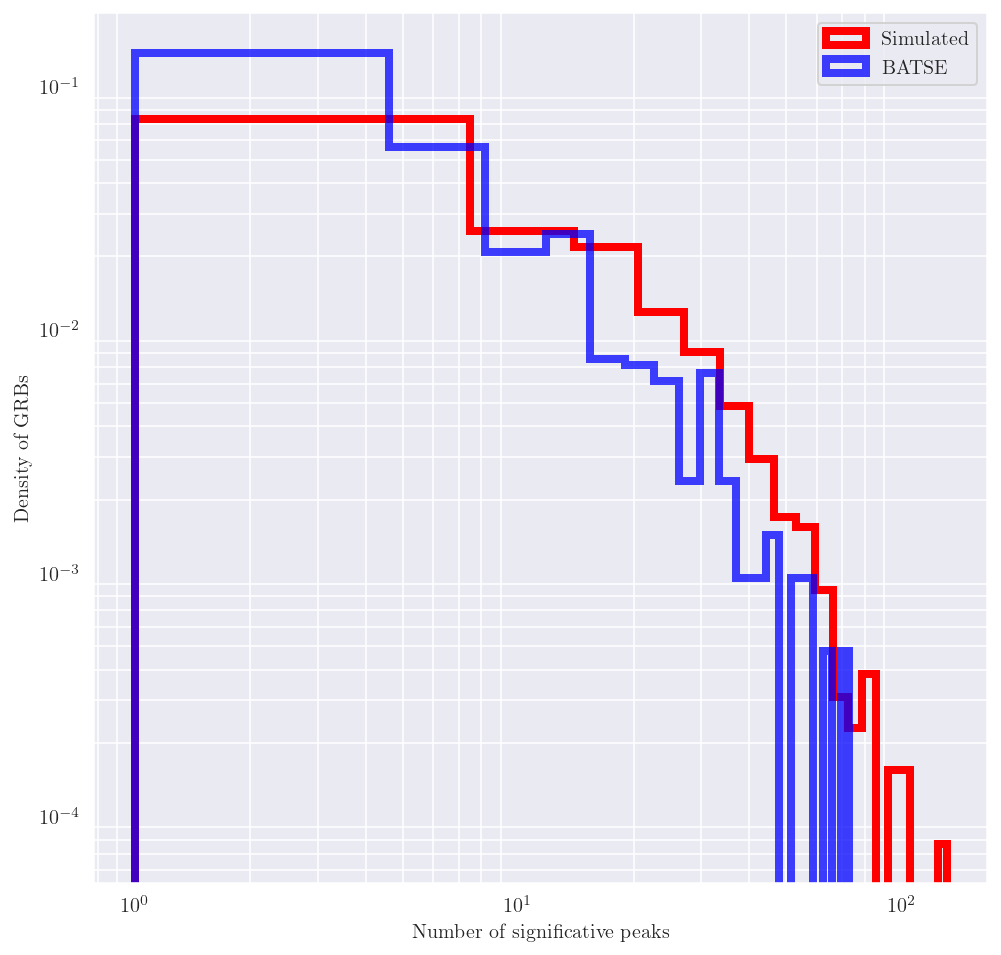

In [33]:
n_bins = 20
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.hist(mepsa_sim, 
        bins=n_bins, 
        label='Simulated', 
        alpha=1.00,
        color='r',
        histtype='step',
        linewidth=4,
        density=True)

ax.hist(mepsa_batse, 
        bins=n_bins,
        alpha=0.75,
        label='BATSE', 
        color='b',
        histtype='step',
        linewidth=4,
        density=True)

ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(which='both')
ax.legend()
ax.set_ylabel('Density of GRBs')
ax.set_xlabel('Number of significative peaks')

## Test 5b: Number of significative peaks (MEPSA _real_ vs Peak count method)

In [11]:
# grb_list_test = load_lc_sim(path="C:/Users/Lisa/Desktop/batse_for_mepsa_test/")
# # apply constraints
# grb_list_test = apply_constraints(grb_list=grb_list_test, 
#                                   bin_time=bin_time_batse, 
#                                   t90_threshold=t90_threshold, 
#                                   sn_threshold=sn_threshold_batse, 
#                                   t_f=t_f)

100%|██████████| 500/500 [02:07<00:00,  3.91it/s]


Total number of simulated GRBs:  500
Total number of input GRBs:  500
GRBs with negative duration:  0
GRBs that satisfy the constraints:  500


In [12]:
# reb_factor = 32
# peak_sn_level = 5

# n_of_peaks_sim = [runMEPSA(mepsa_path, ex_pattern_path, grb.data_file_path, reb_factor, grb.name, peak_sn_level) for grb in tqdm(grb_list_test)]

100%|██████████| 500/500 [26:23<00:00,  3.17s/it]


In [28]:
# grb_name = range(500)

# gen_file = open("C:/Users/Lisa/Desktop/n_of_pulses.txt", 'r')
# good_pulses = []
# generated_pulses = []
# for line in gen_file:
#     good_pulses.append(float(line.split()[1]))
#     generated_pulses.append(float(line.split()[2]))

# mepsa_pulses = []
# for grb in grb_name:
#     mepsa_pulses.append(len(open('C:/Users/Lisa/Desktop/mepsa_32_reb/{0}.dat'.format(grb),'r').readlines()) -1 )

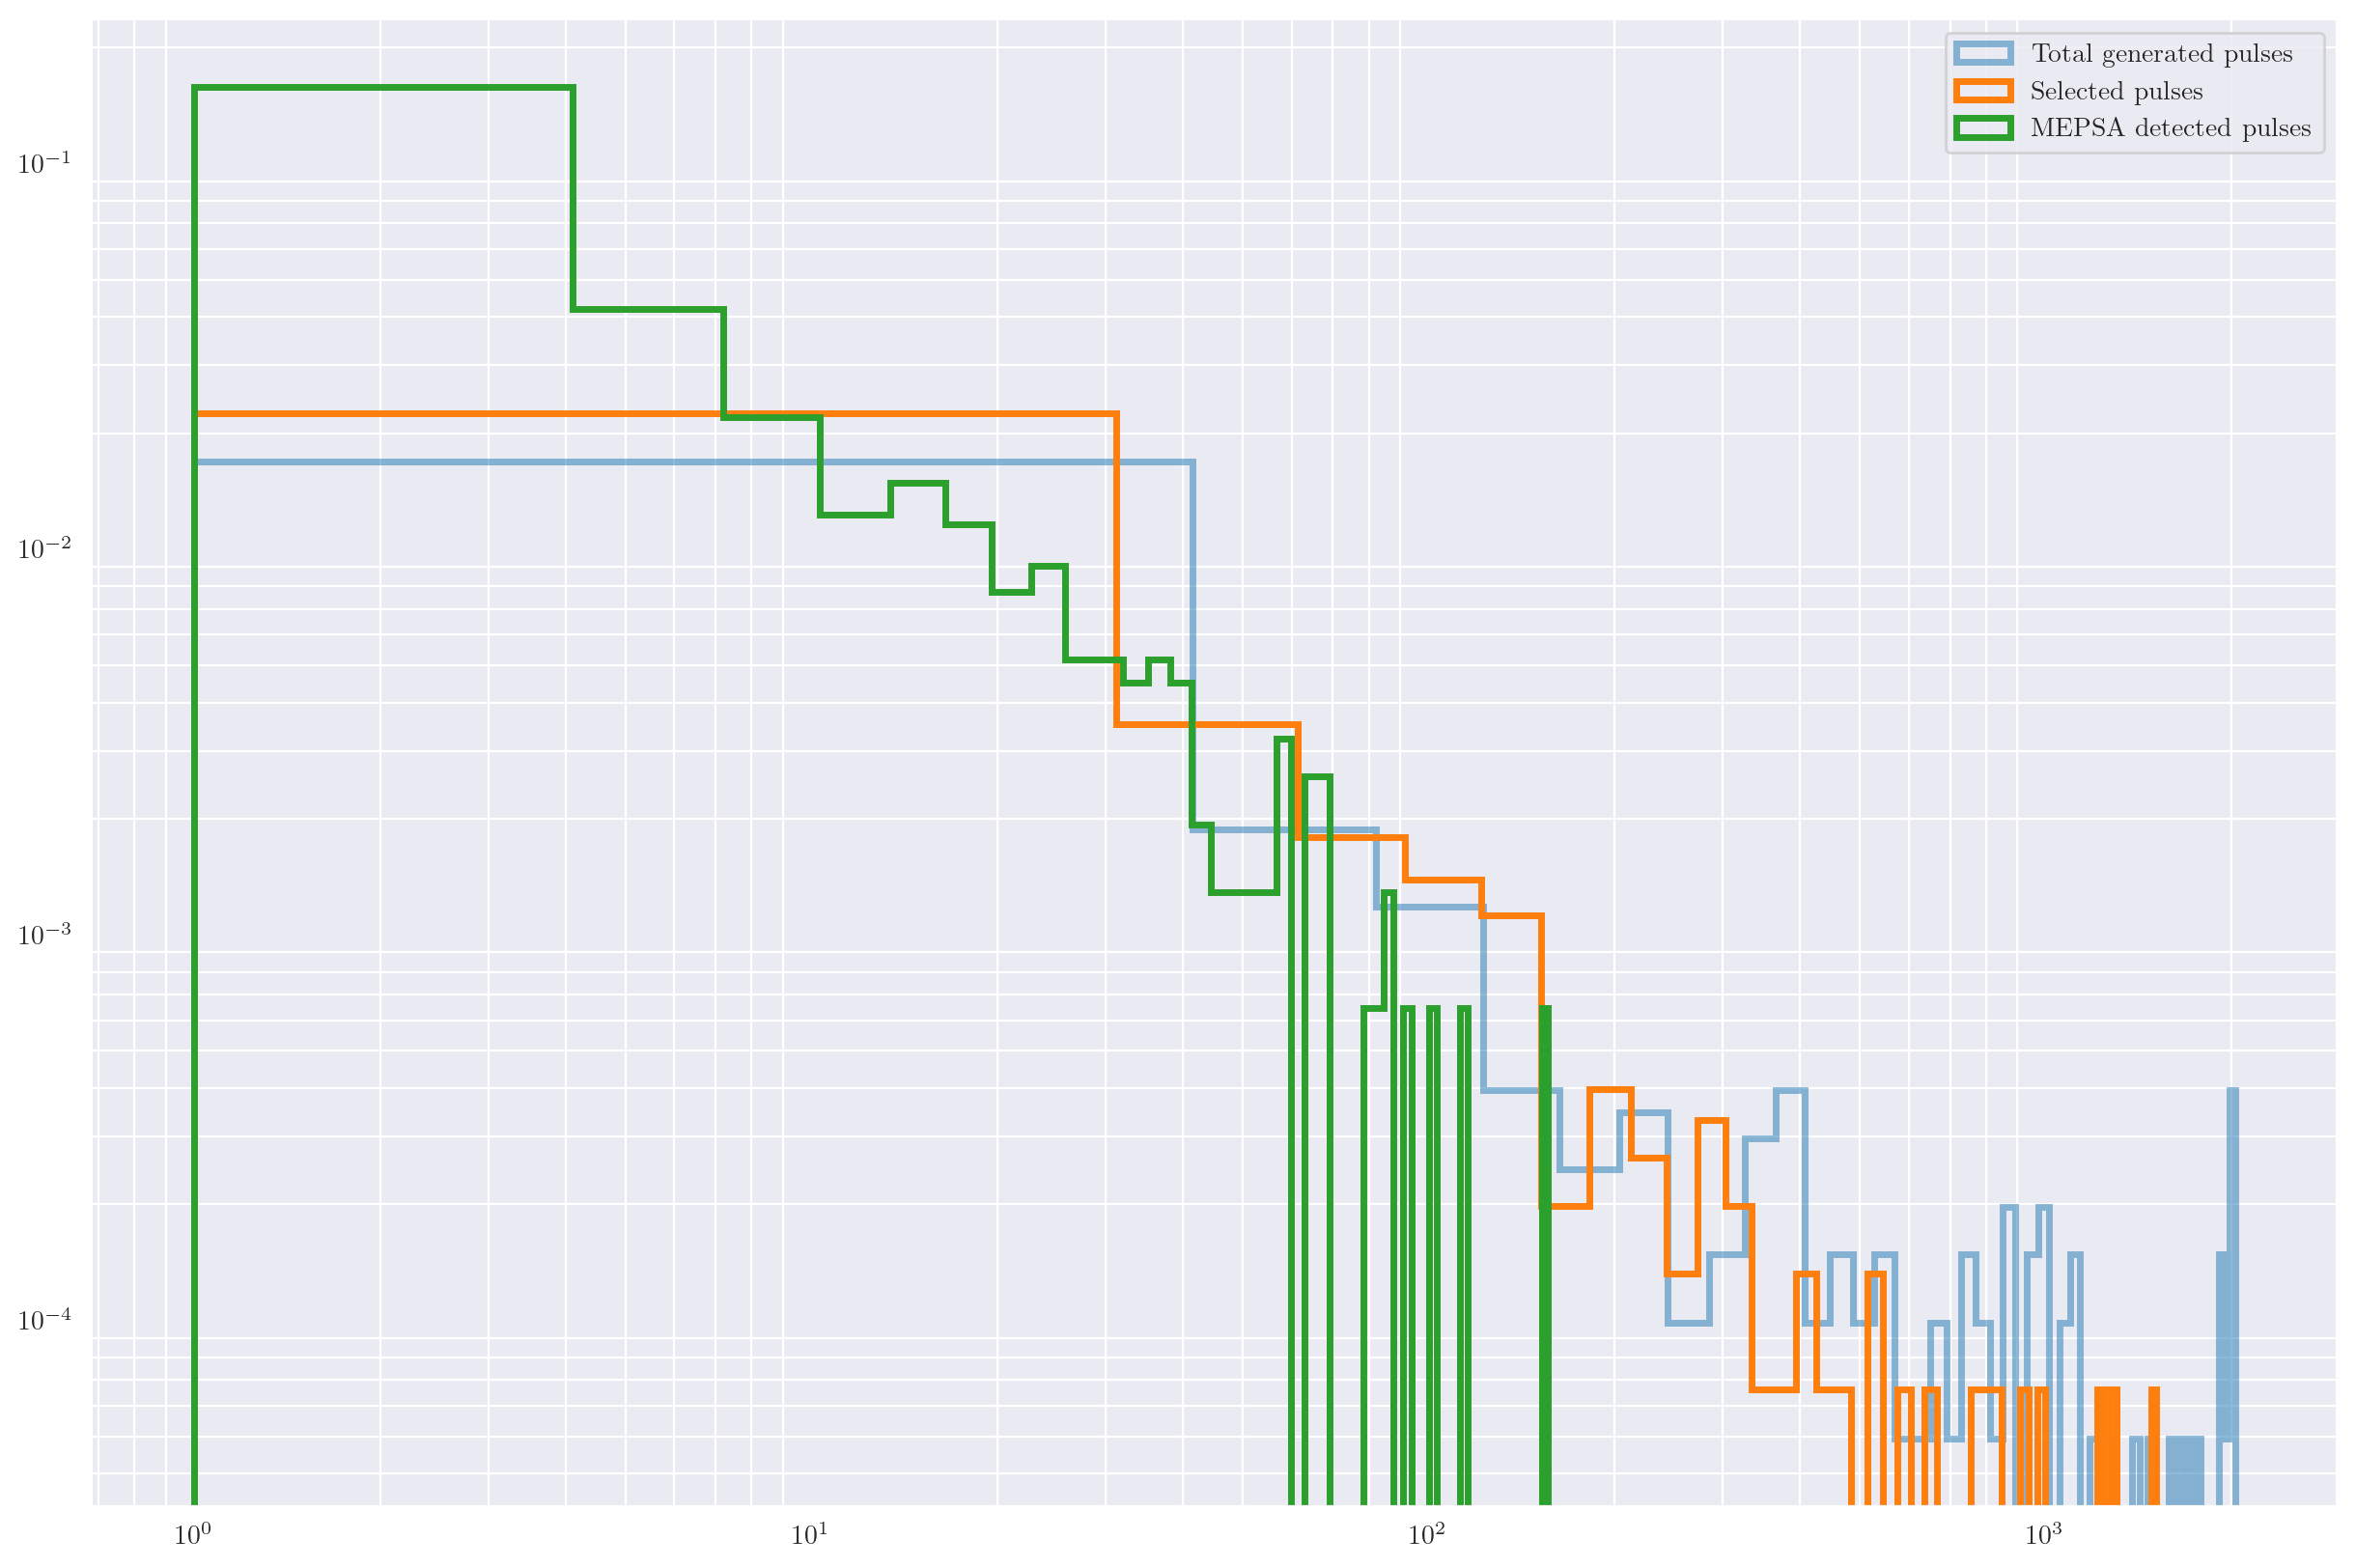

In [63]:
# fig = plt.figure(figsize = (15,10))
# ax = fig.add_subplot()
# ax.hist(generated_pulses, bins = 50, label = 'Total generated pulses', alpha = 0.5, histtype = 'step', linewidth = 2.5, density = True)
# ax.hist(good_pulses, bins = 50, label = 'Selected pulses', histtype = 'step', linewidth = 2.5, density = True)
# ax.hist(mepsa_pulses, bins = 50, label = 'MEPSA detected pulses', histtype = 'step', linewidth = 2.5, density = True)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.legend()
# ax.grid(which='both')

In [34]:
version    = '08'

#------------------------------------------------------------------------------#
# OUR CODE
#------------------------------------------------------------------------------#
if user=='AF':
    gen_file = open('E:/grb_to_test/MEPSA results/gen8/n_of_pulses.txt', 'r')
elif user=='LB':
    gen_file = open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/additional/v'+version+'/n_of_pulses.txt', 'r')
good_pulses = []
#generated_pulses = []
for line in gen_file:
    good_pulses.append(float(line.split()[0]))
    #generated_pulses.append(float(line.split()[2]))
n_of_pulses_sim = good_pulses
mepsa_like_sim  = n_of_pulses_sim 

#------------------------------------------------------------------------------#
# MEPSA (simulati)
#------------------------------------------------------------------------------#
grb_name = range(2000)
mepsa_pulses = []
for grb in grb_name:
    if user=='AF':
        mepsa_pulses.append(len(open('E:/grb_to_test/MEPSA results/gen8/{0}.dat'.format(grb),'r').readlines()) -1 )
    elif user=='LB':
        mepsa_pulses.append(len(open('/Users/lorenzo/Documents/UNIVERSITA/Astrophysics/PYTHON/GRBs/lc_pulse_avalanche/statistical_test/res_mepsa/MEPSA_res/'+version+'/{0}.dat'.format(grb),'r').readlines()) -1 )
mepsa_sim = mepsa_pulses 

#------------------------------------------------------------------------------#

MEPSA (BATSE) vs Peak count method (SIMv8)
AD (p-value):  0.25
KS (p-value):  0.3855465198257425

MEPSA (SIMv8) vs Peak count method (SIMv8)
AD (p-value):  0.25
KS (p-value):  0.9383310279844598


/var/folders/x0/m_j50m4x6_l77kk23zbp4gfm0000gn/T/ipykernel_3135/3847834749.py:4: UserWarning: p-value capped: true value larger than 0.25
  res_ad = anderson_ksamp([distr_1,distr_2] )


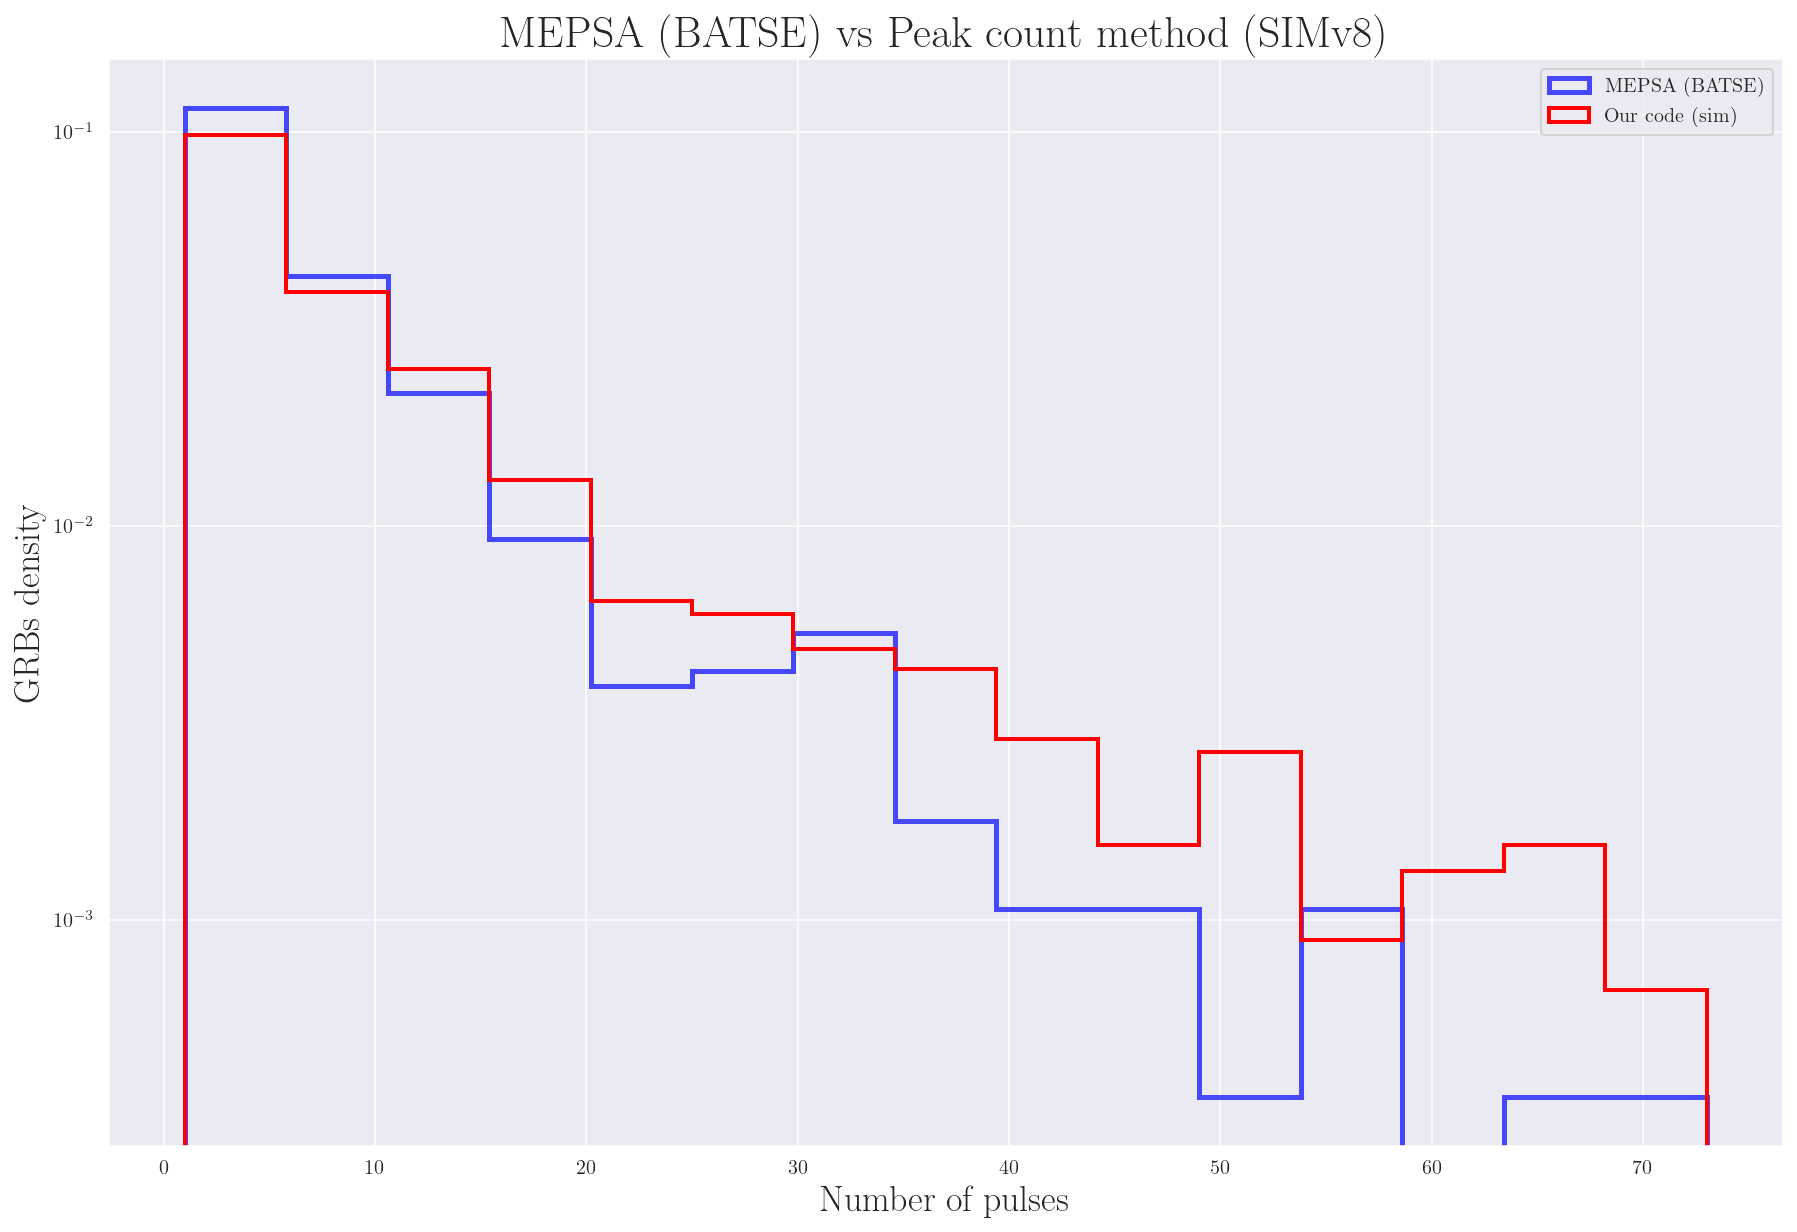

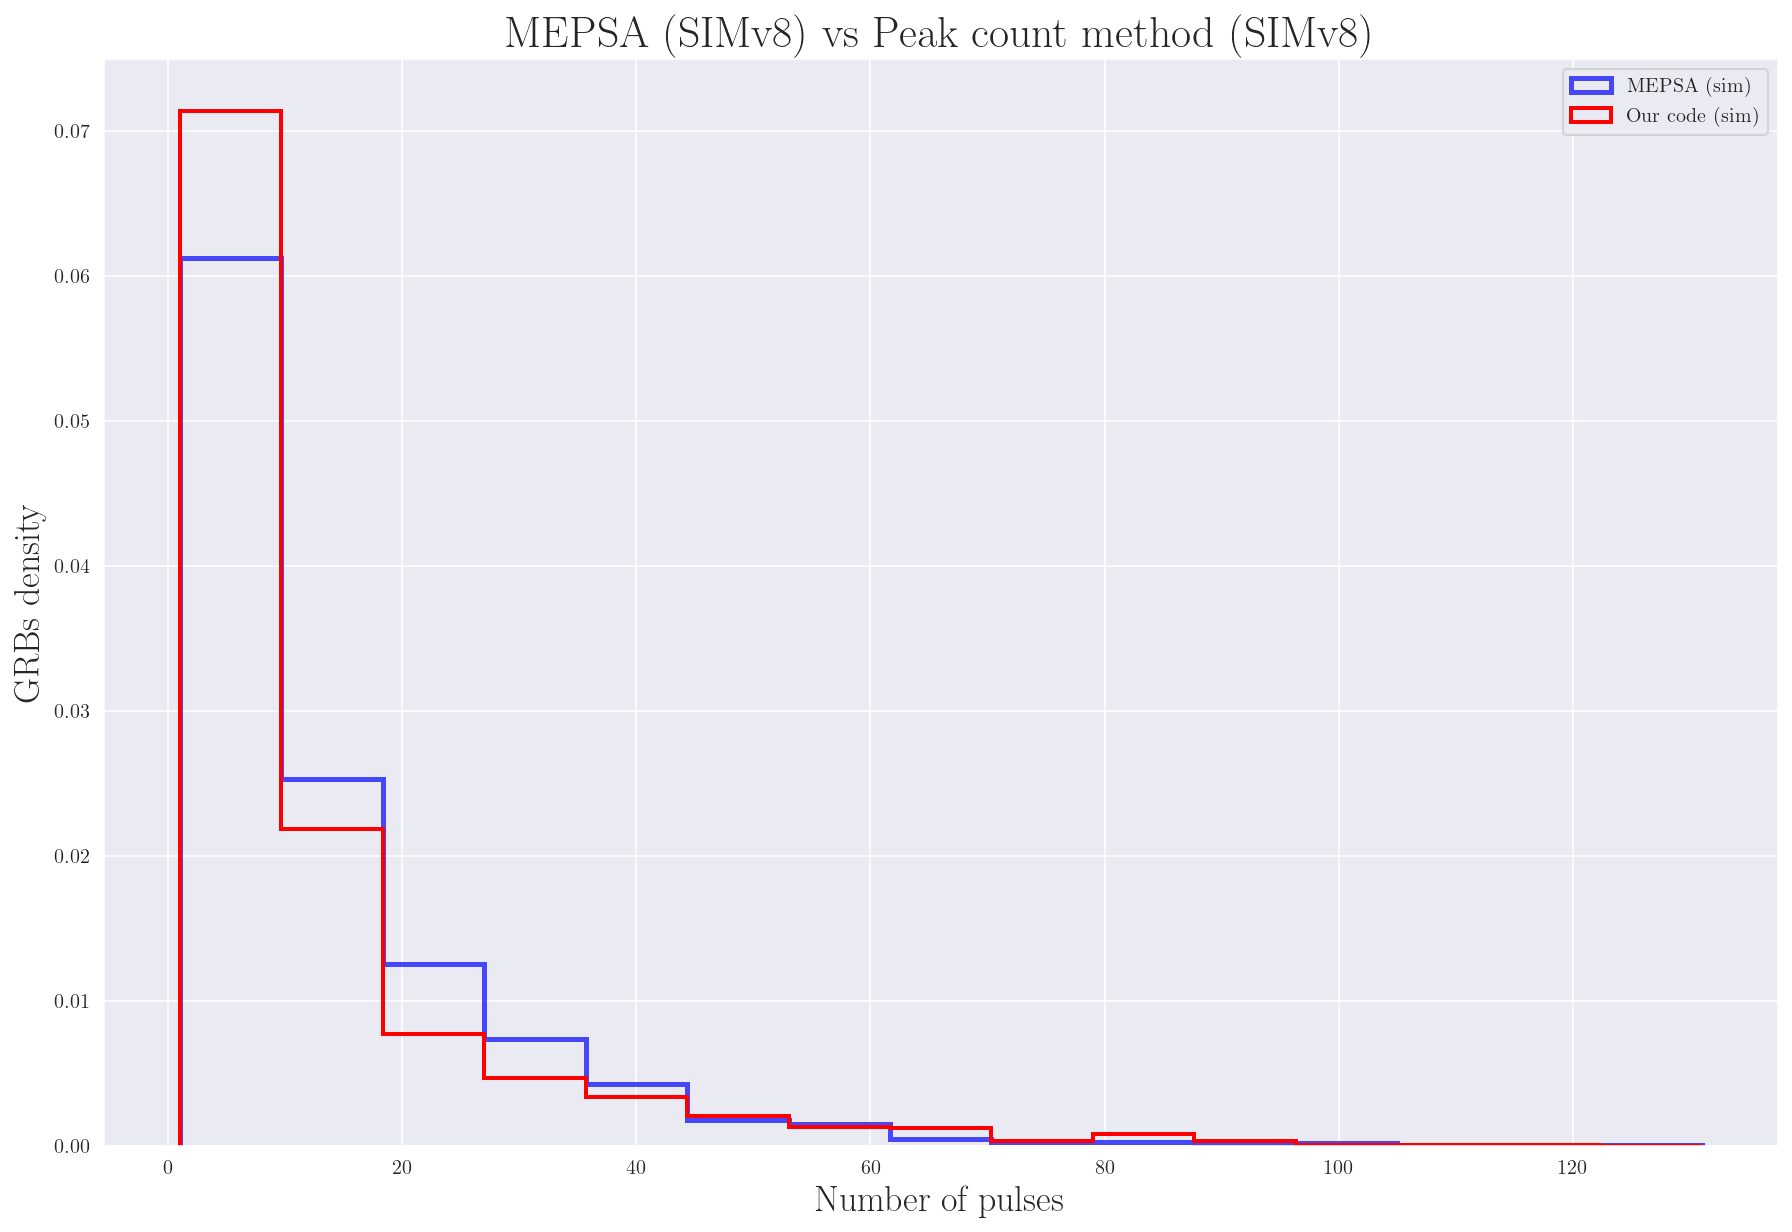

In [51]:
from scipy.stats import anderson_ksamp, ks_2samp

def perform_KS_AD(distr_1, distr_2):
    res_ad = anderson_ksamp([distr_1,distr_2] )
    res_ks = ks_2samp(distr_1,distr_2)
    print('AD (p-value): ', res_ad.significance_level)
    print('KS (p-value): ', res_ks.pvalue)
    return [res_ad.significance_level, res_ks.pvalue] 


#------------------------------------------------------------------------------#
n_bins = 15 # 'auto'
#------------------------------------------------------------------------------#

# MEPSA (BATSE) vs Peak count method (v8)
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
#n_bins = 'auto'
#n_mepsa, bins, patches = ax.hist(n_of_pulses,     bins=n_bins, label='MEPSA',    color='b', histtype='step', linewidth=2.5, density=True, alpha=0.7)
#n_good,     _,       _ = ax.hist(n_of_pulses_sim, bins=bins,   label='Our code', color='r', histtype='step', linewidth=2.,  density=True)
n_mepsa, bins, patches = ax.hist(mepsa_batse,    bins=n_bins, label='MEPSA (BATSE)',  color='b', histtype='step', linewidth=2.5, density=True, alpha=0.7)
n_good,     _,       _ = ax.hist(mepsa_like_sim, bins=bins,   label='Our code (sim)', color='r', histtype='step', linewidth=2.,  density=True)
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.grid(which='both')
ax.set_xlabel('Number of pulses', size=18)
ax.set_ylabel('GRBs density', size=18)
ax.legend()
plt.title('MEPSA (BATSE) vs Peak count method (SIMv8)', size=22)
plt.plot()

print('MEPSA (BATSE) vs Peak count method (SIMv8)')
_ = perform_KS_AD(n_good, n_mepsa)

#------------------------------------------------------------------------------#

# MEPSA (v8) vs Peak count method (v8)
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot()
#n_bins = 'auto'
#n_mepsa, bins, patches = ax.hist(mepsa_pulses,    bins=n_bins, label='MEPSA',    color='b', histtype='step', linewidth=2.5, density=True, alpha=0.7)
#n_good,     _,       _ = ax.hist(n_of_pulses_sim, bins=bins,   label='Our code', color='r', histtype='step', linewidth=2.,  density=True)
n_mepsa, bins, patches = ax.hist(mepsa_sim,      bins=n_bins, label='MEPSA (sim)',    color='b', histtype='step', linewidth=2.5, density=True, alpha=0.7)
n_good,     _,       _ = ax.hist(mepsa_like_sim, bins=bins,   label='Our code (sim)', color='r', histtype='step', linewidth=2.,  density=True)
#ax.set_yscale('log')
#ax.set_xscale('log')
#ax.grid(which='both')
ax.set_xlabel('Number of pulses', size=18)
ax.set_ylabel('GRBs density', size=18)
ax.legend()
plt.title('MEPSA (SIMv8) vs Peak count method (SIMv8)', size=22)
plt.plot()

print('\nMEPSA (SIMv8) vs Peak count method (SIMv8)')
_ = perform_KS_AD(n_good, n_mepsa)

#------------------------------------------------------------------------------#

# LOSS

In [41]:
test_pulse_distr = True
l2_loss_batse = compute_loss(averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
                             averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
                             acf=acf_batse,                                   acf_sim=acf_sim_batse,
                             duration=dur_distr_batse,                        duration_sim=dur_distr_sim_batse, 
                             n_of_pulses=mepsa_batse,                         n_of_pulses_sim=mepsa_like_sim,   
                             test_pulse_distr=test_pulse_distr)

if test_pulse_distr:
    nbin=20
    # Perform the AD 2-populations compatibility test between:
    # - la distribuzione del numero di impulsi calcolata da MEPSA (su dati BATSE)
    # - la distribuzione del numero di impulsi calcolato con il nostro codice (sulla simulazione corrente)
    n_mepsa_real, bins = np.histogram(n_of_pulses,     bins=nbin, density=True)
    n_peaks_sim,     _ = np.histogram(n_of_pulses_sim, bins=nbin, density=True)
    p_AD               = AD_2pop_test(distr_1=n_mepsa_real,
                                      distr_2=n_peaks_sim)
    l_AD               = loss_AD(p_AD=p_AD)
    print('p-value of the AD-test: ', p_AD)

print('Total loss for BATSE:', l2_loss_batse)

p-value of the AD-test:  0.25
Total loss for BATSE: 0.517682345279589


In [39]:
test_pulse_distr = False
l2_loss_swift = compute_loss(averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
                             averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
                             acf=acf_swift,                                   acf_sim=acf_sim_swift,
                             duration=dur_distr_swift,                        duration_sim=dur_distr_sim_swift, 
                             n_of_pulses=None,                                n_of_pulses_sim=None,   
                             test_pulse_distr=test_pulse_distr)

print('Total loss for Swift:', l2_loss_swift)

NameError: name 'averaged_fluxes_swift' is not defined

In [36]:
test_pulse_distr = False
l2_loss_sax = compute_loss(averaged_fluxes=averaged_fluxes_sax,           averaged_fluxes_sim=averaged_fluxes_sim_sax,
                           averaged_fluxes_cube=averaged_fluxes_cube_sax, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax,
                           acf=acf_sax,                                   acf_sim=acf_sim_sax,
                           duration=dur_distr_sax,                        duration_sim=dur_distr_sim_sax, 
                           n_of_pulses=None,                              n_of_pulses_sim=None,   
                           test_pulse_distr=test_pulse_distr)

print('Total loss for BeppoSAX:', l2_loss_sax)

NameError: name 'averaged_fluxes_sax' is not defined

# PLOTS

p-value for KS test on the duration times distribution: 0.39
p-value for AD test on the duration times distribution: > 0.25

#### BATSE

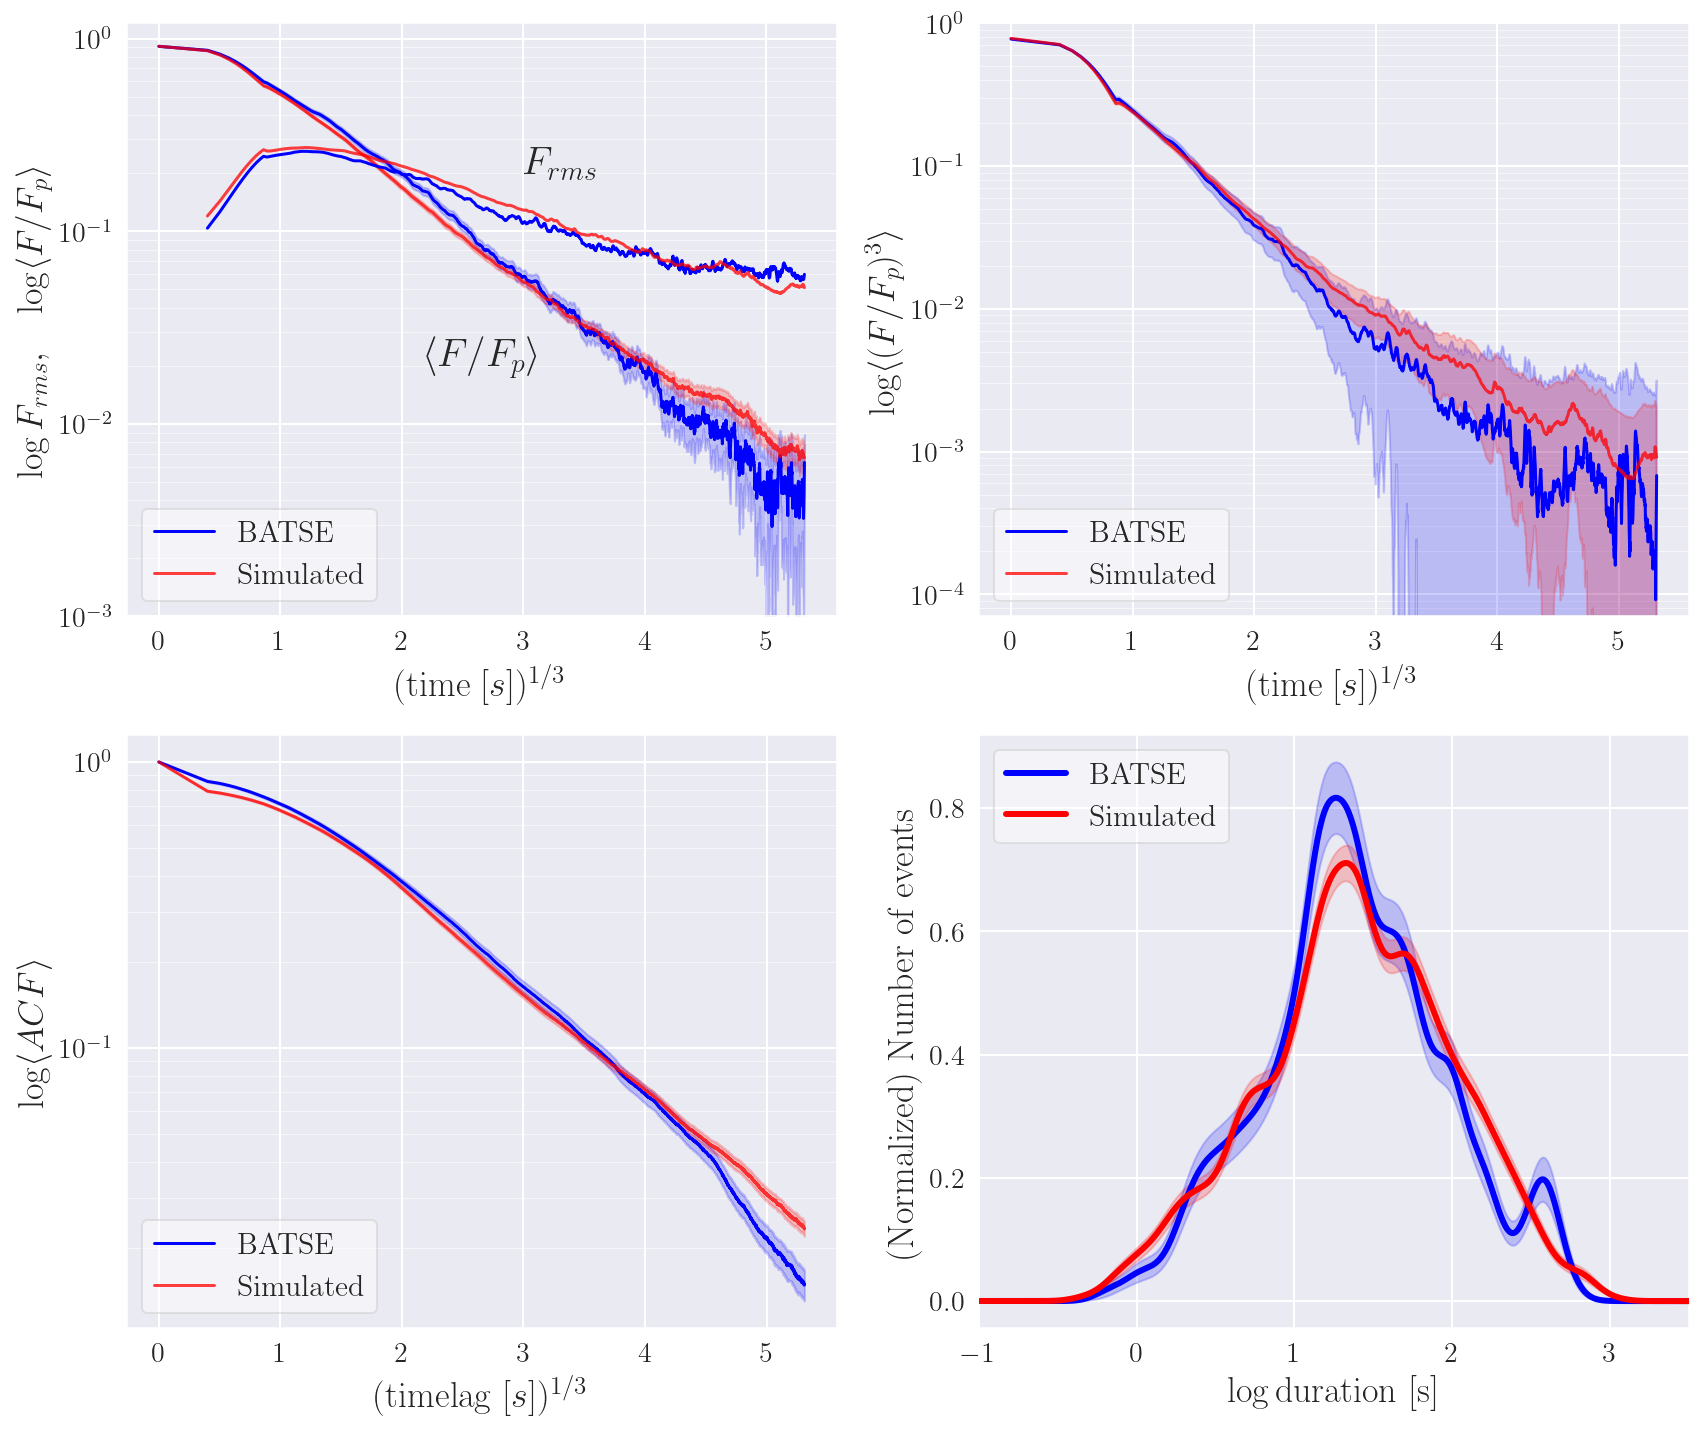

In [18]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse, bin_time=bin_time_batse, 
          acf=acf_batse,                                   acf_sim=acf_sim_batse,
          duration=duration_batse,                         duration_sim=duration_sim_batse,
          # mode
          log=True, hist=False, 
          # error bars
          err_bars=True, sigma=1,
          n_grb_real=len(grb_list_batse),                          n_grb_sim=len(grb_list_sim_batse),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
          acf_rms=acf_rms_batse,                                   acf_rms_sim=acf_rms_sim_batse,
          save_fig=True, name_fig='4observables_v7.pdf')

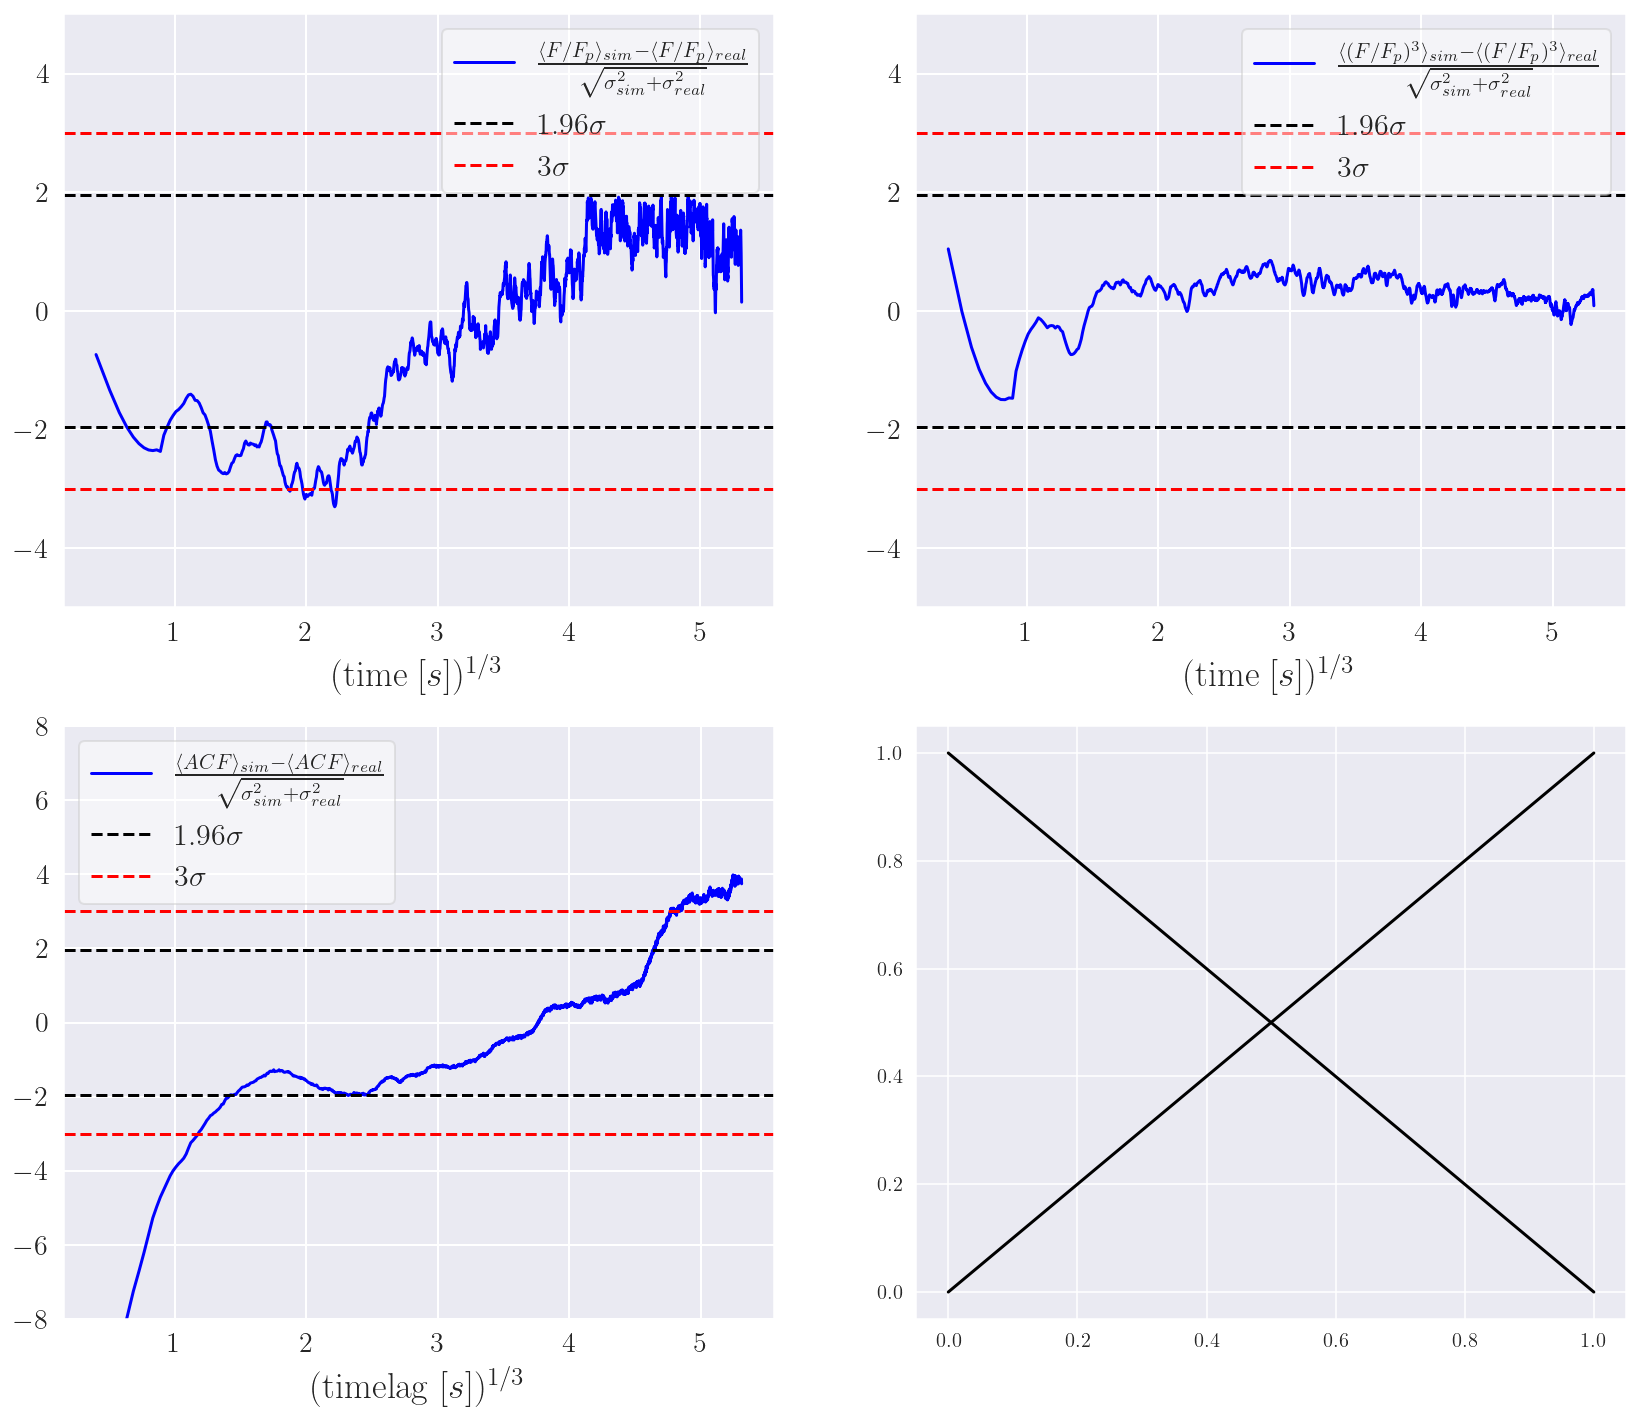

In [19]:
make_plot_errs(test_times=test_times_batse, 
               # plot 1
               averaged_fluxes=averaged_fluxes_batse,           
               averaged_fluxes_sim=averaged_fluxes_sim_batse,
               averaged_fluxes_rms=averaged_fluxes_rms_batse,   
               averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
               # plot 2
               averaged_fluxes_cube=averaged_fluxes_cube_batse, 
               averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_batse, 
               averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_batse,
               # plot 3
               steps=steps_batse,  
               bin_time=bin_time_batse, 
               acf=acf_batse,
               acf_sim=acf_sim_batse,
               acf_rms=acf_rms_batse,
               acf_rms_sim=acf_rms_sim_batse,
               # plot 4
               duration=duration_batse, 
               duration_sim=duration_sim_batse,
               #
               n_grb_real=len(grb_list_batse),
               n_grb_sim=len(grb_list_sim_batse))

#### Swift

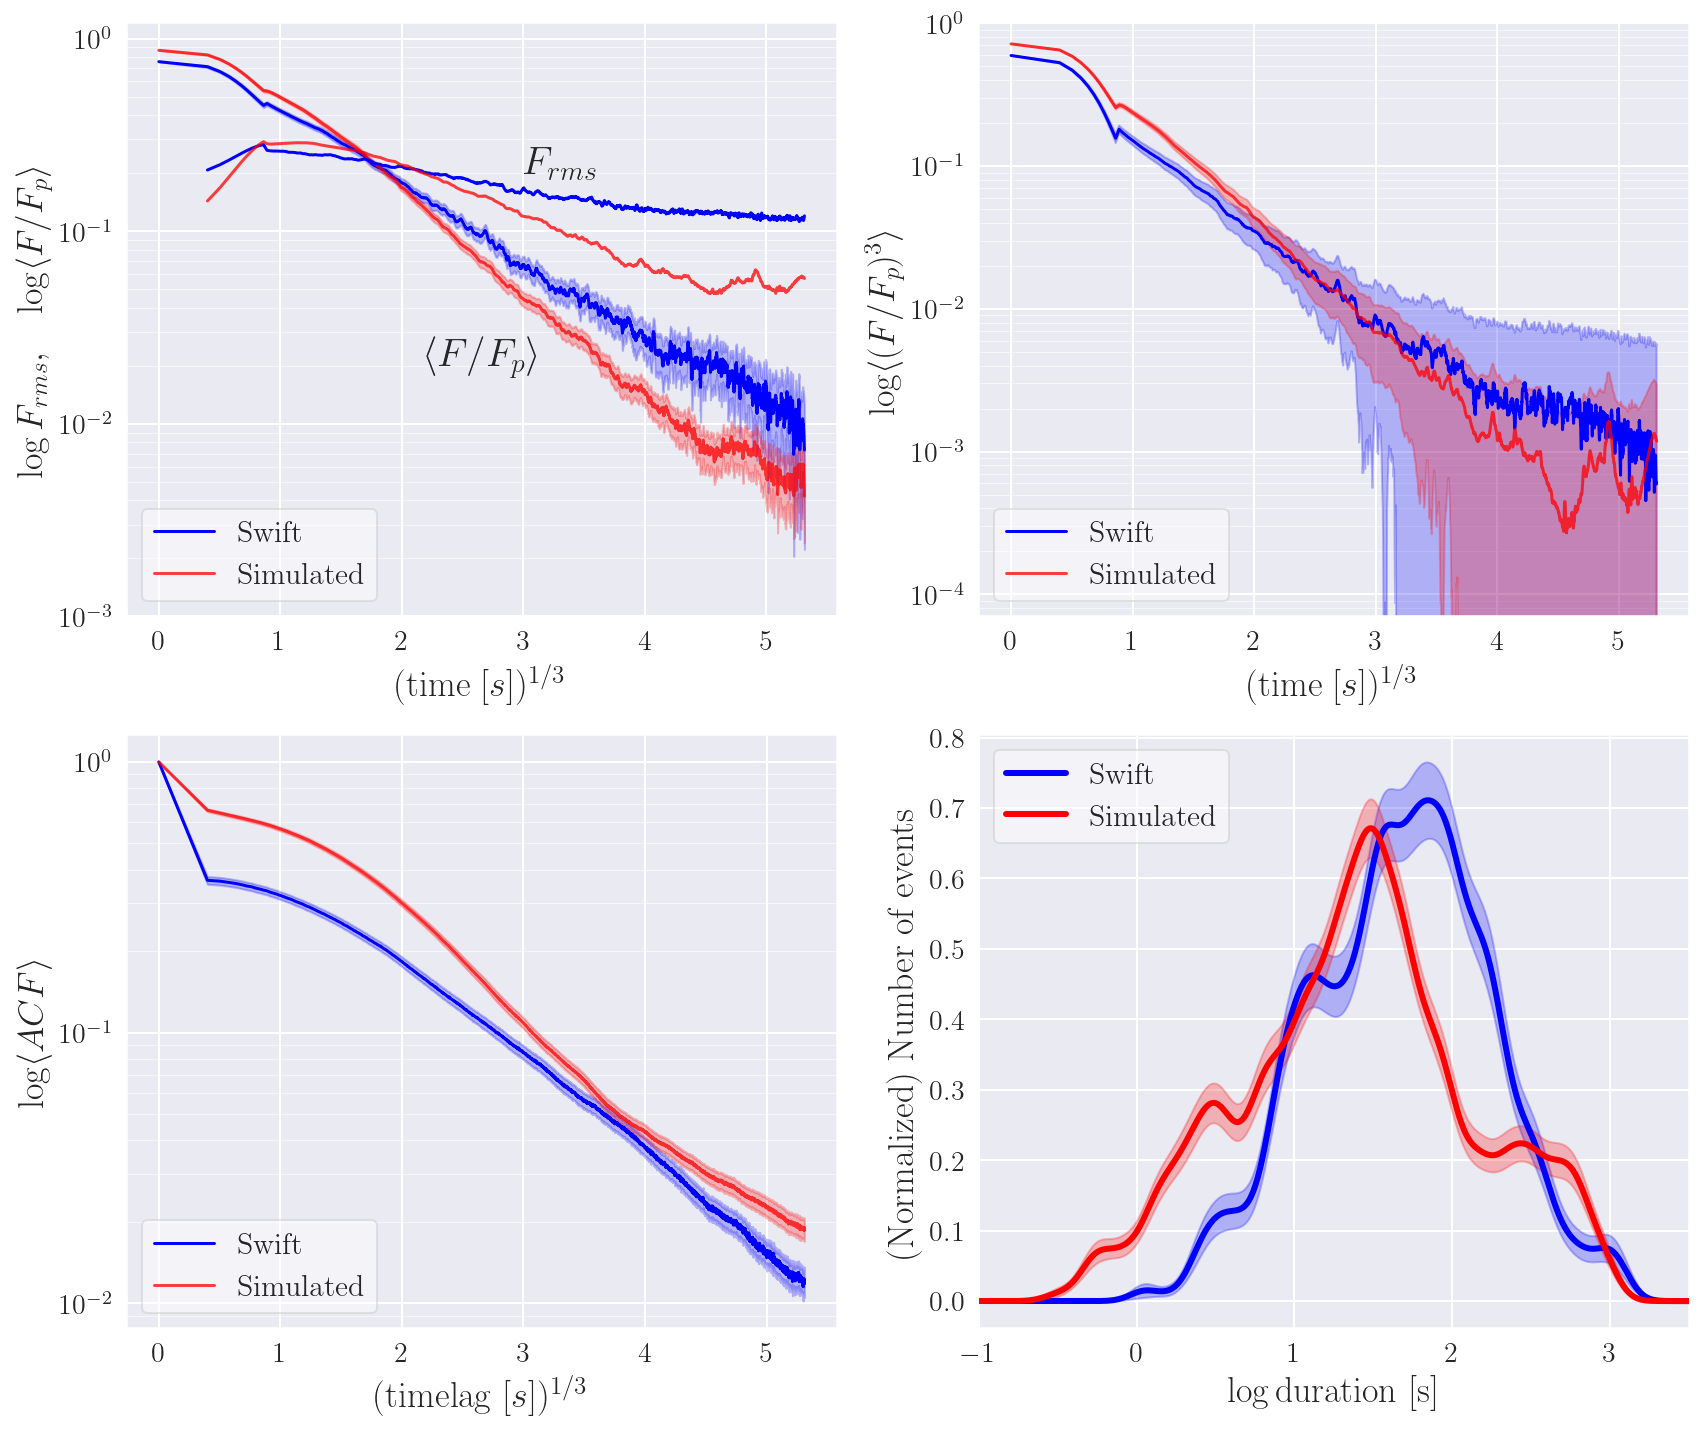

In [36]:
# 7 PARAMETERS FROM THE GENETIC ALGORITHM
make_plot(instrument='swift',
          test_times=test_times_swift, 
          averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
          averaged_fluxes_rms=averaged_fluxes_rms_swift,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
          averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
          steps=steps_swift, steps_sim=steps_sim_swift, bin_time=bin_time_swift, 
          acf=acf_swift,                                   acf_sim=acf_sim_swift,
          duration=duration_swift,                         duration_sim=duration_sim_swift,
          # mode
          log=True, hist=True, 
          # error bars
          err_bars=True, sigma=1,
          n_grb_real=len(grb_list_swift),                          n_grb_sim=len(grb_list_sim_swift),
          averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_swift, averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_swift,
          acf_rms=acf_rms_swift,                                   acf_rms_sim=acf_rms_sim_swift)


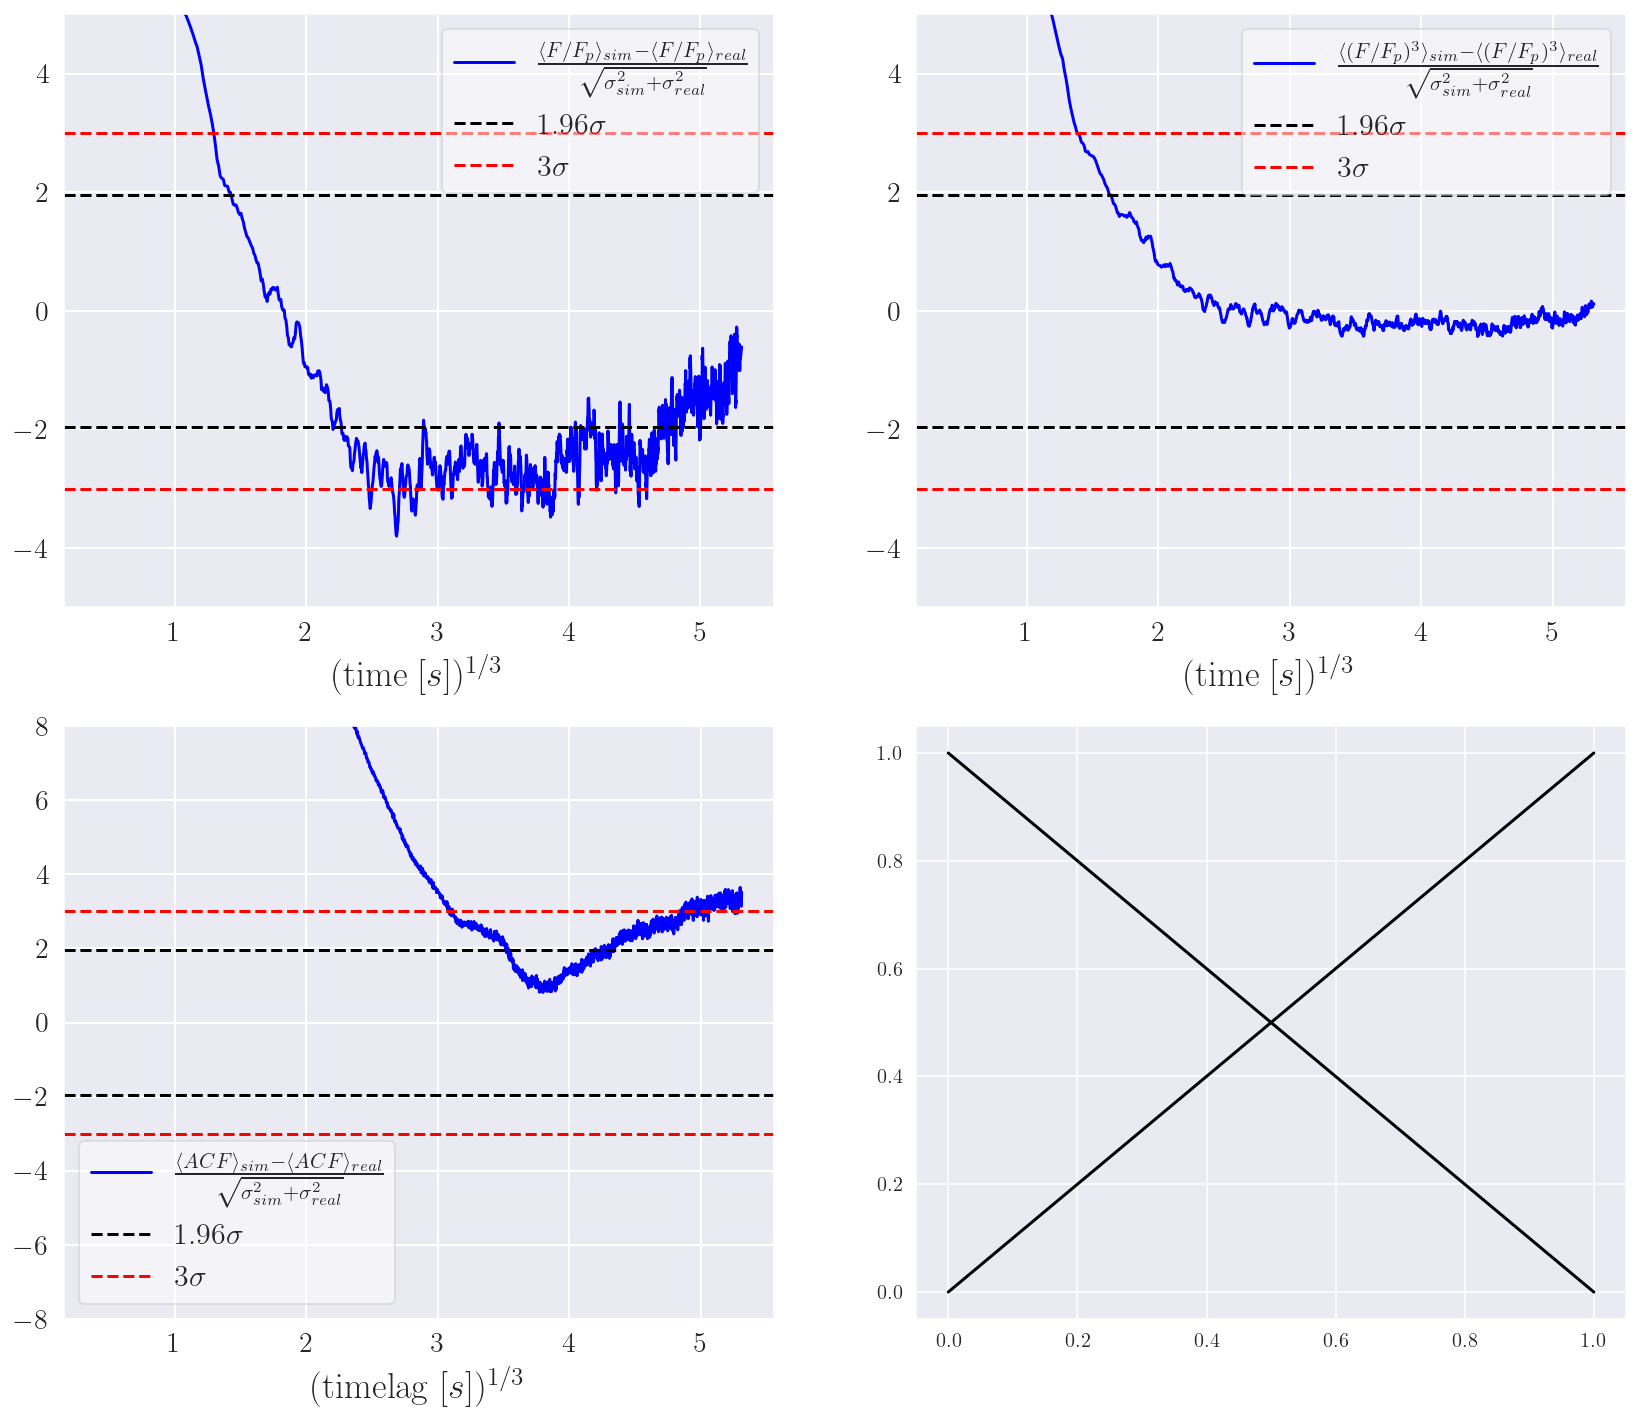

In [42]:
make_plot_errs(test_times=test_times_swift, 
               # plot 1
               averaged_fluxes=averaged_fluxes_swift,           
               averaged_fluxes_sim=averaged_fluxes_sim_swift,
               averaged_fluxes_rms=averaged_fluxes_rms_swift,   
               averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
               # plot 2
               averaged_fluxes_cube=averaged_fluxes_cube_swift, 
               averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
               averaged_fluxes_cube_rms=averaged_fluxes_cube_rms_swift, 
               averaged_fluxes_cube_rms_sim=averaged_fluxes_cube_rms_sim_swift,
               # plot 3
               steps=steps_swift,  
               bin_time=bin_time_swift, 
               acf=acf_swift,
               acf_sim=acf_sim_swift,
               acf_rms=acf_rms_swift,
               acf_rms_sim=acf_rms_sim_swift,
               # plot 4
               duration=duration_swift, 
               duration_sim=duration_sim_swift,
               #
               n_grb_real=len(grb_list_swift),
               n_grb_sim=len(grb_list_sim_swift))

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


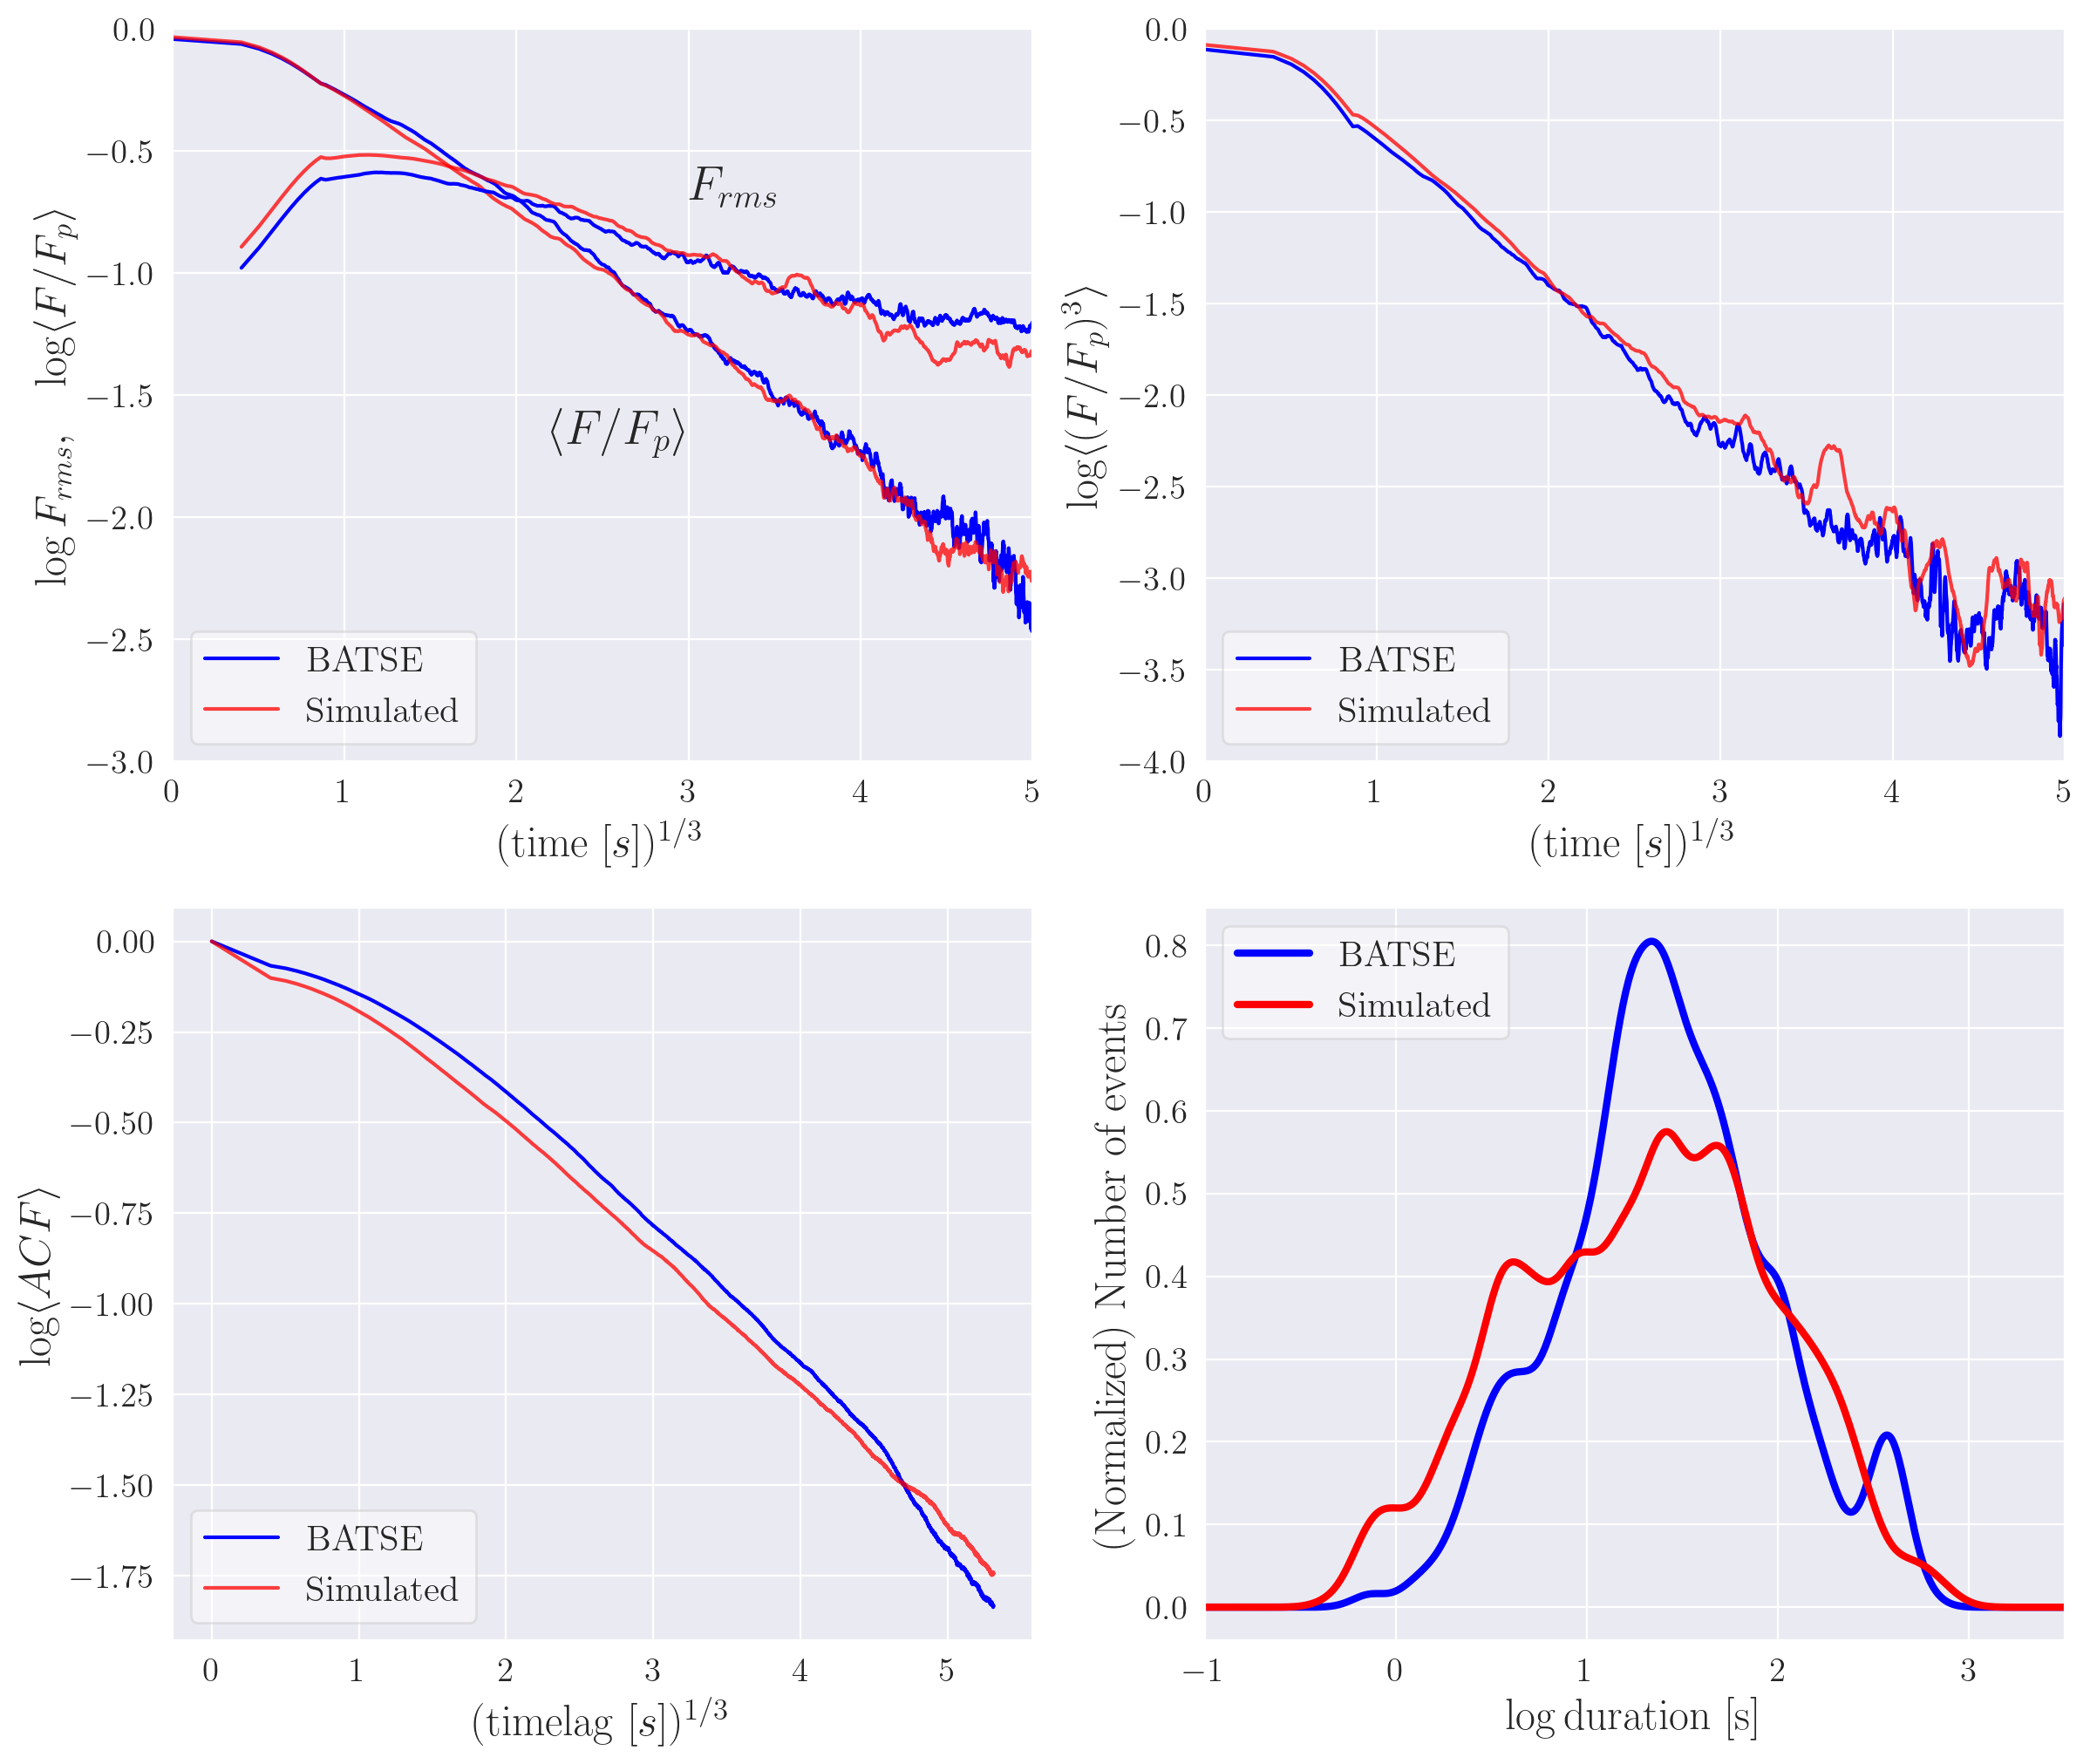

In [37]:
# 7 PARAMETERS FROM THE PAPER
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim_batse, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim_batse,
          duration=duration_batse, duration_sim=duration_sim_batse)

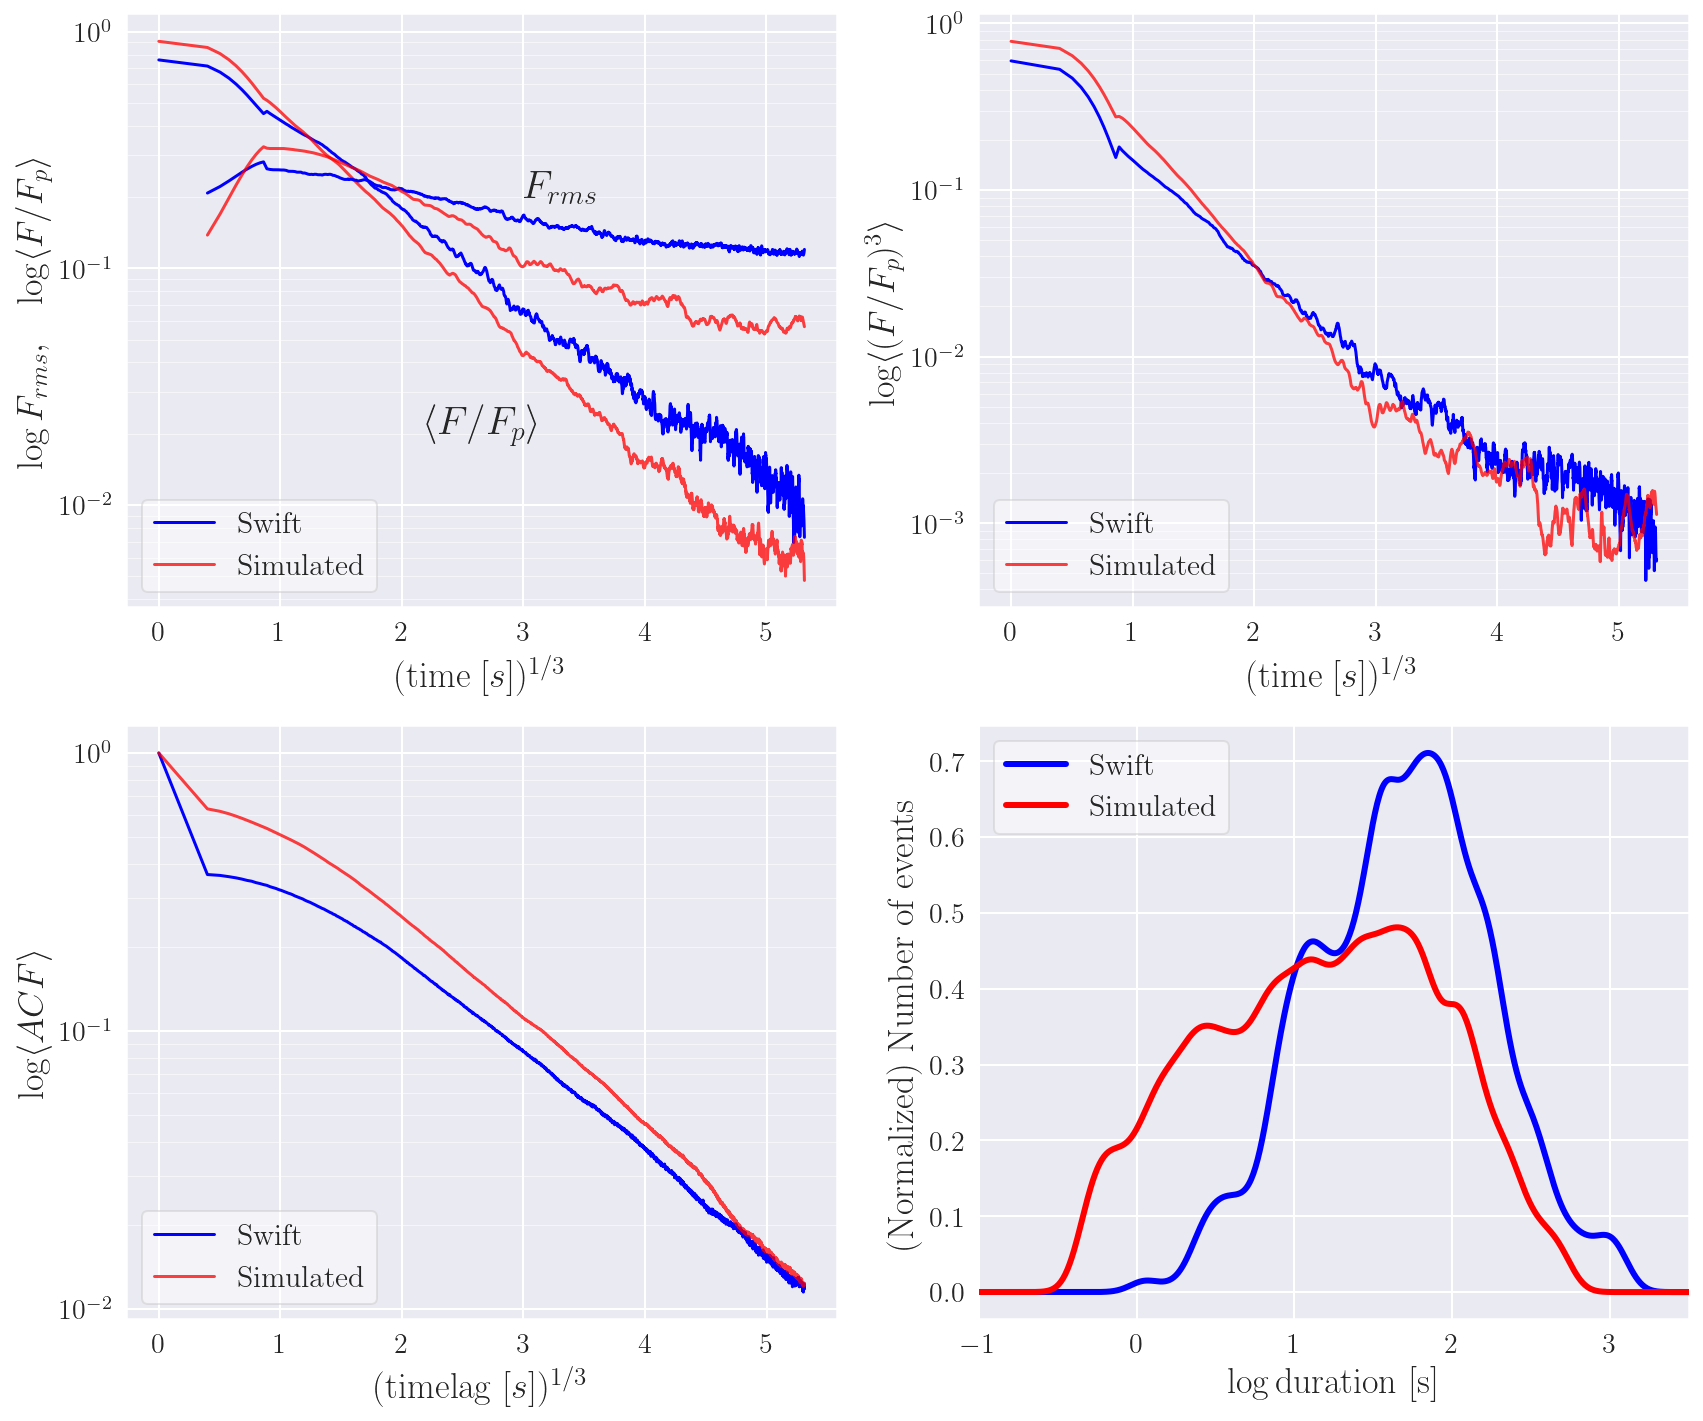

In [25]:
make_plot(instrument='swift',
          test_times=test_times_swift, 
          averaged_fluxes=averaged_fluxes_swift,           averaged_fluxes_sim=averaged_fluxes_sim_swift,
          averaged_fluxes_rms=averaged_fluxes_rms_swift,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_swift,
          averaged_fluxes_cube=averaged_fluxes_cube_swift, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_swift,
          steps=steps_swift, steps_sim=steps_sim_swift, bin_time=bin_time_swift, acf=acf_swift, acf_sim=acf_sim_swift,
          duration=duration_swift, duration_sim=duration_sim_swift)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


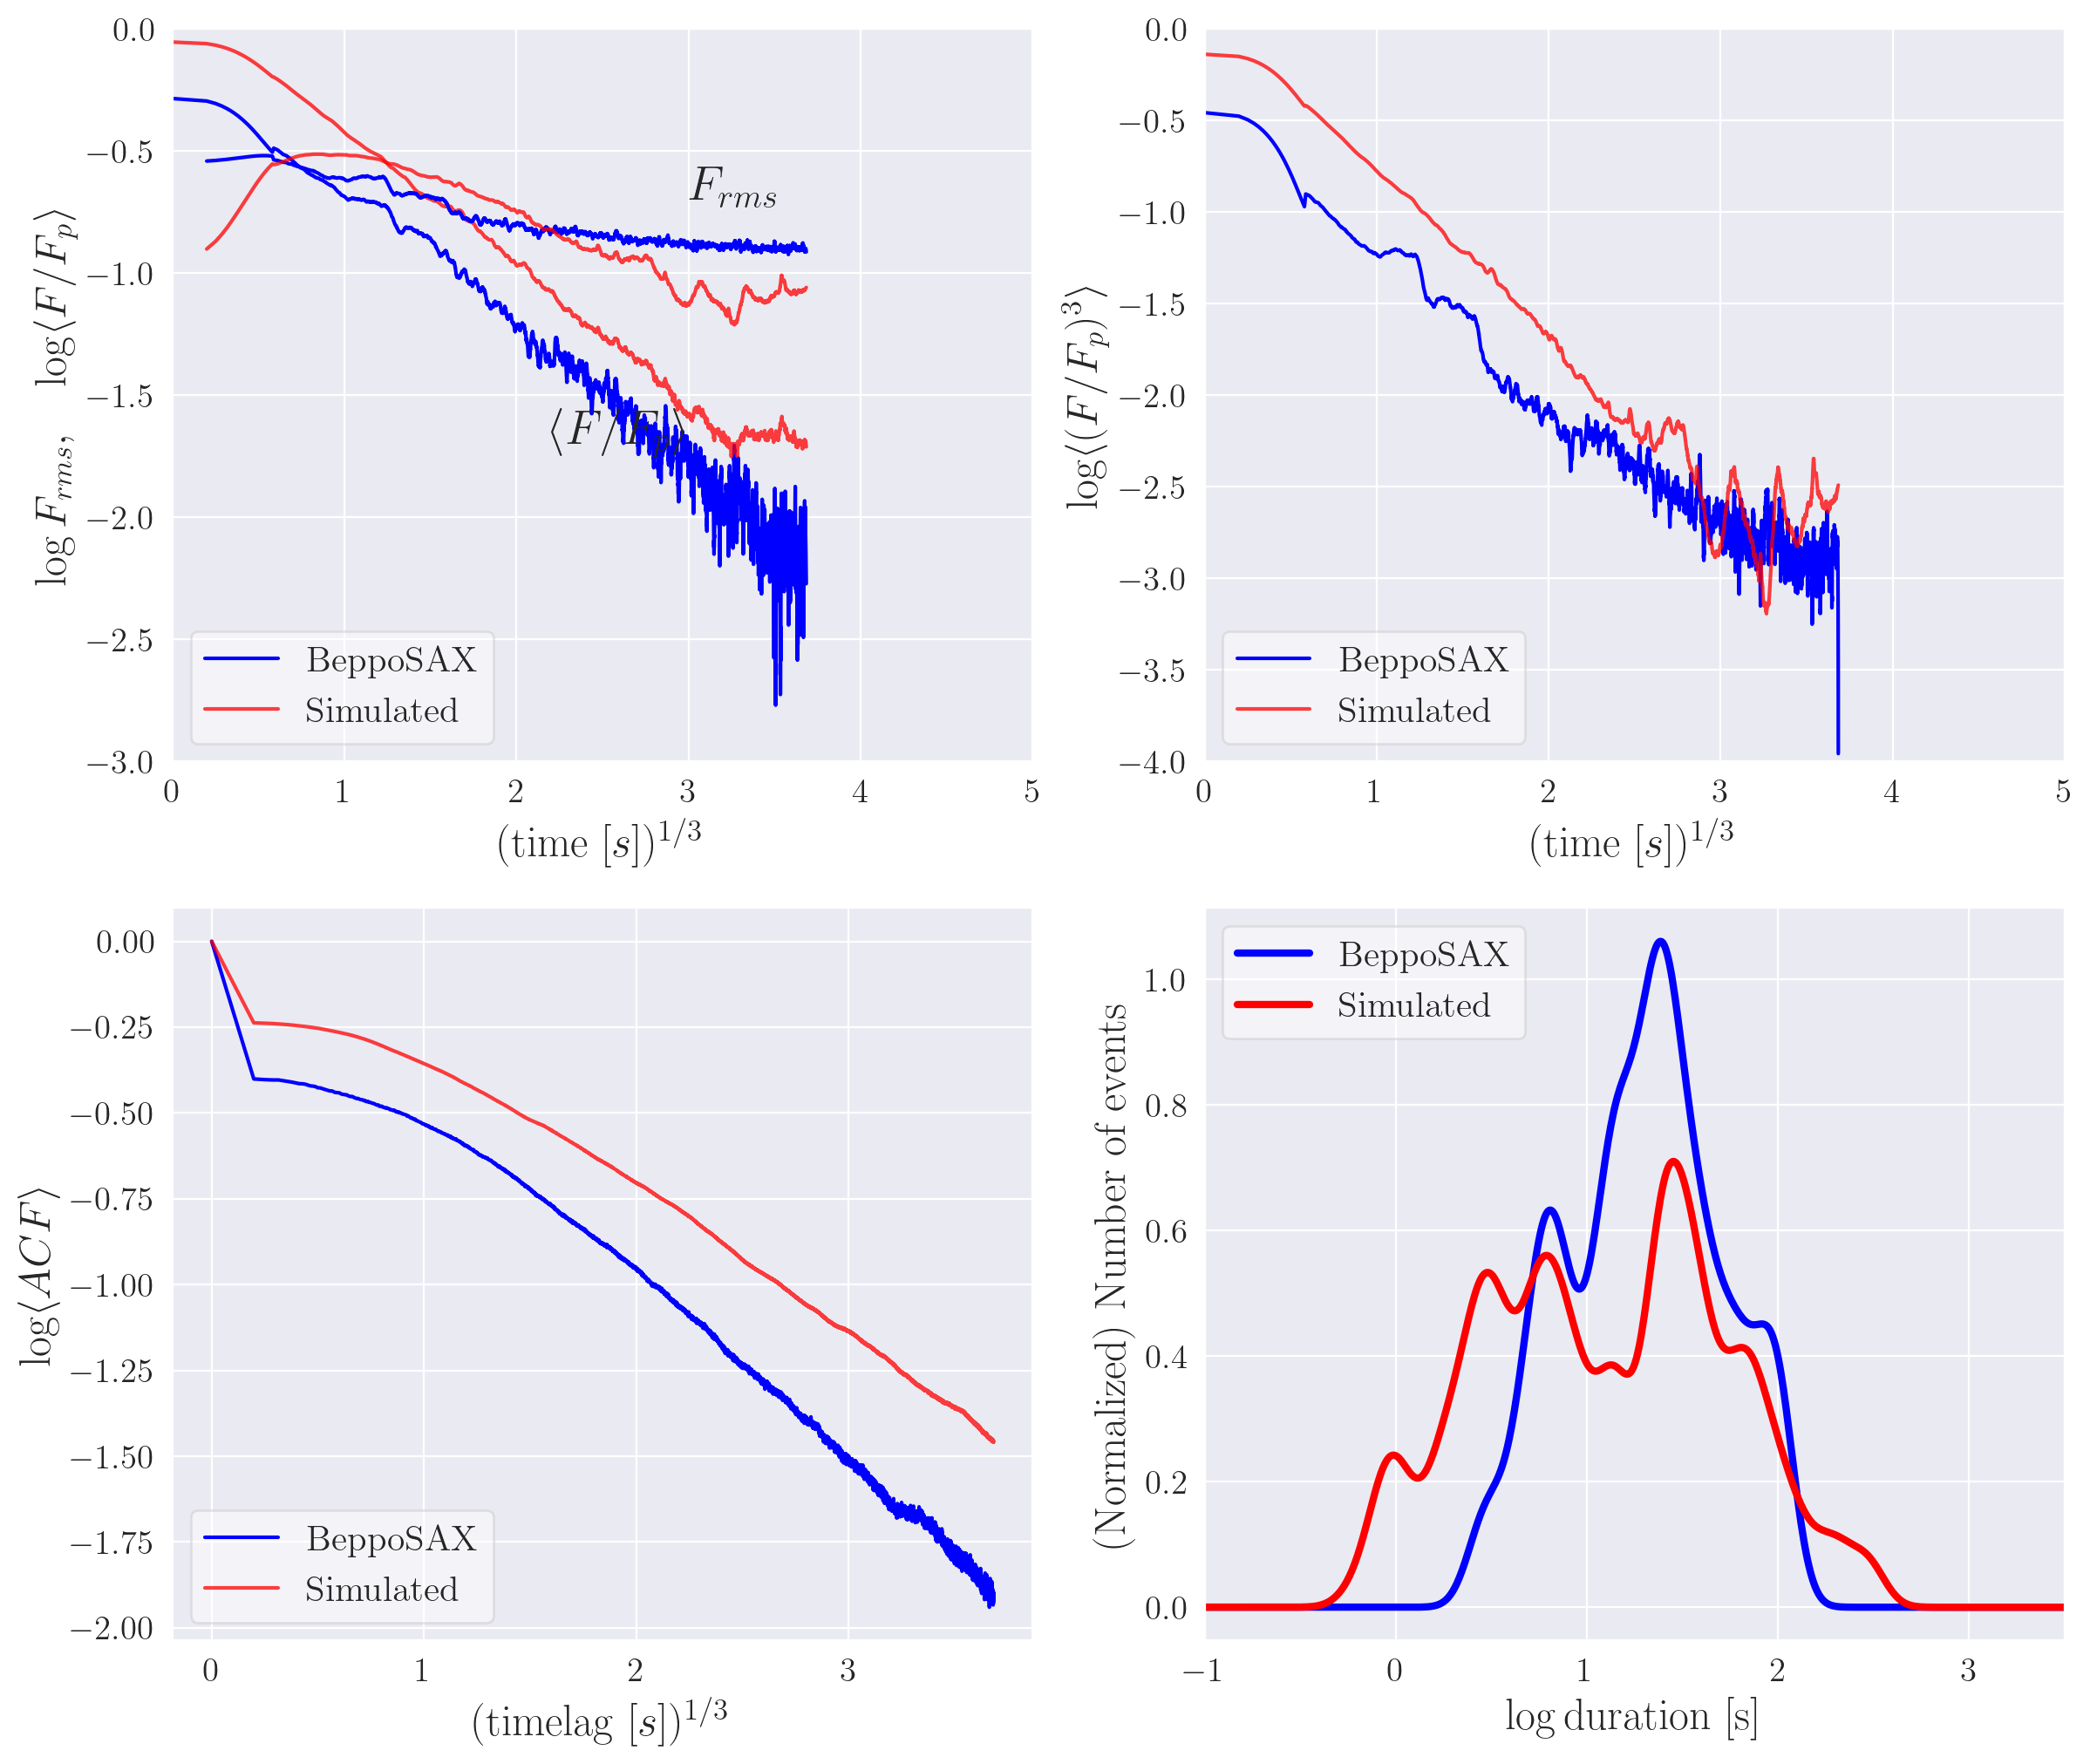

In [39]:
make_plot(instrument='sax',
          test_times=test_times_sax_hr, 
          averaged_fluxes=averaged_fluxes_sax_hr,           averaged_fluxes_sim=averaged_fluxes_sim_sax_hr,
          averaged_fluxes_rms=averaged_fluxes_rms_sax_hr,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_sax_hr,
          averaged_fluxes_cube=averaged_fluxes_cube_sax_hr, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax_hr,
          steps=steps_sax_hr, steps_sim=steps_sim_sax_hr, bin_time=bin_time_sax_hr, acf=acf_sax_hr, acf_sim=acf_sim_sax_hr,
          duration=duration_sax_hr, duration_sim=duration_sim_sax_hr)

c:\Users\Lisa\Documents\GitHub\lc_pulse_avalanche\statistical_test\statistical_test.py:874: RuntimeWarning: invalid value encountered in log10
  averaged_fluxes          = np.log10(averaged_fluxes)


- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


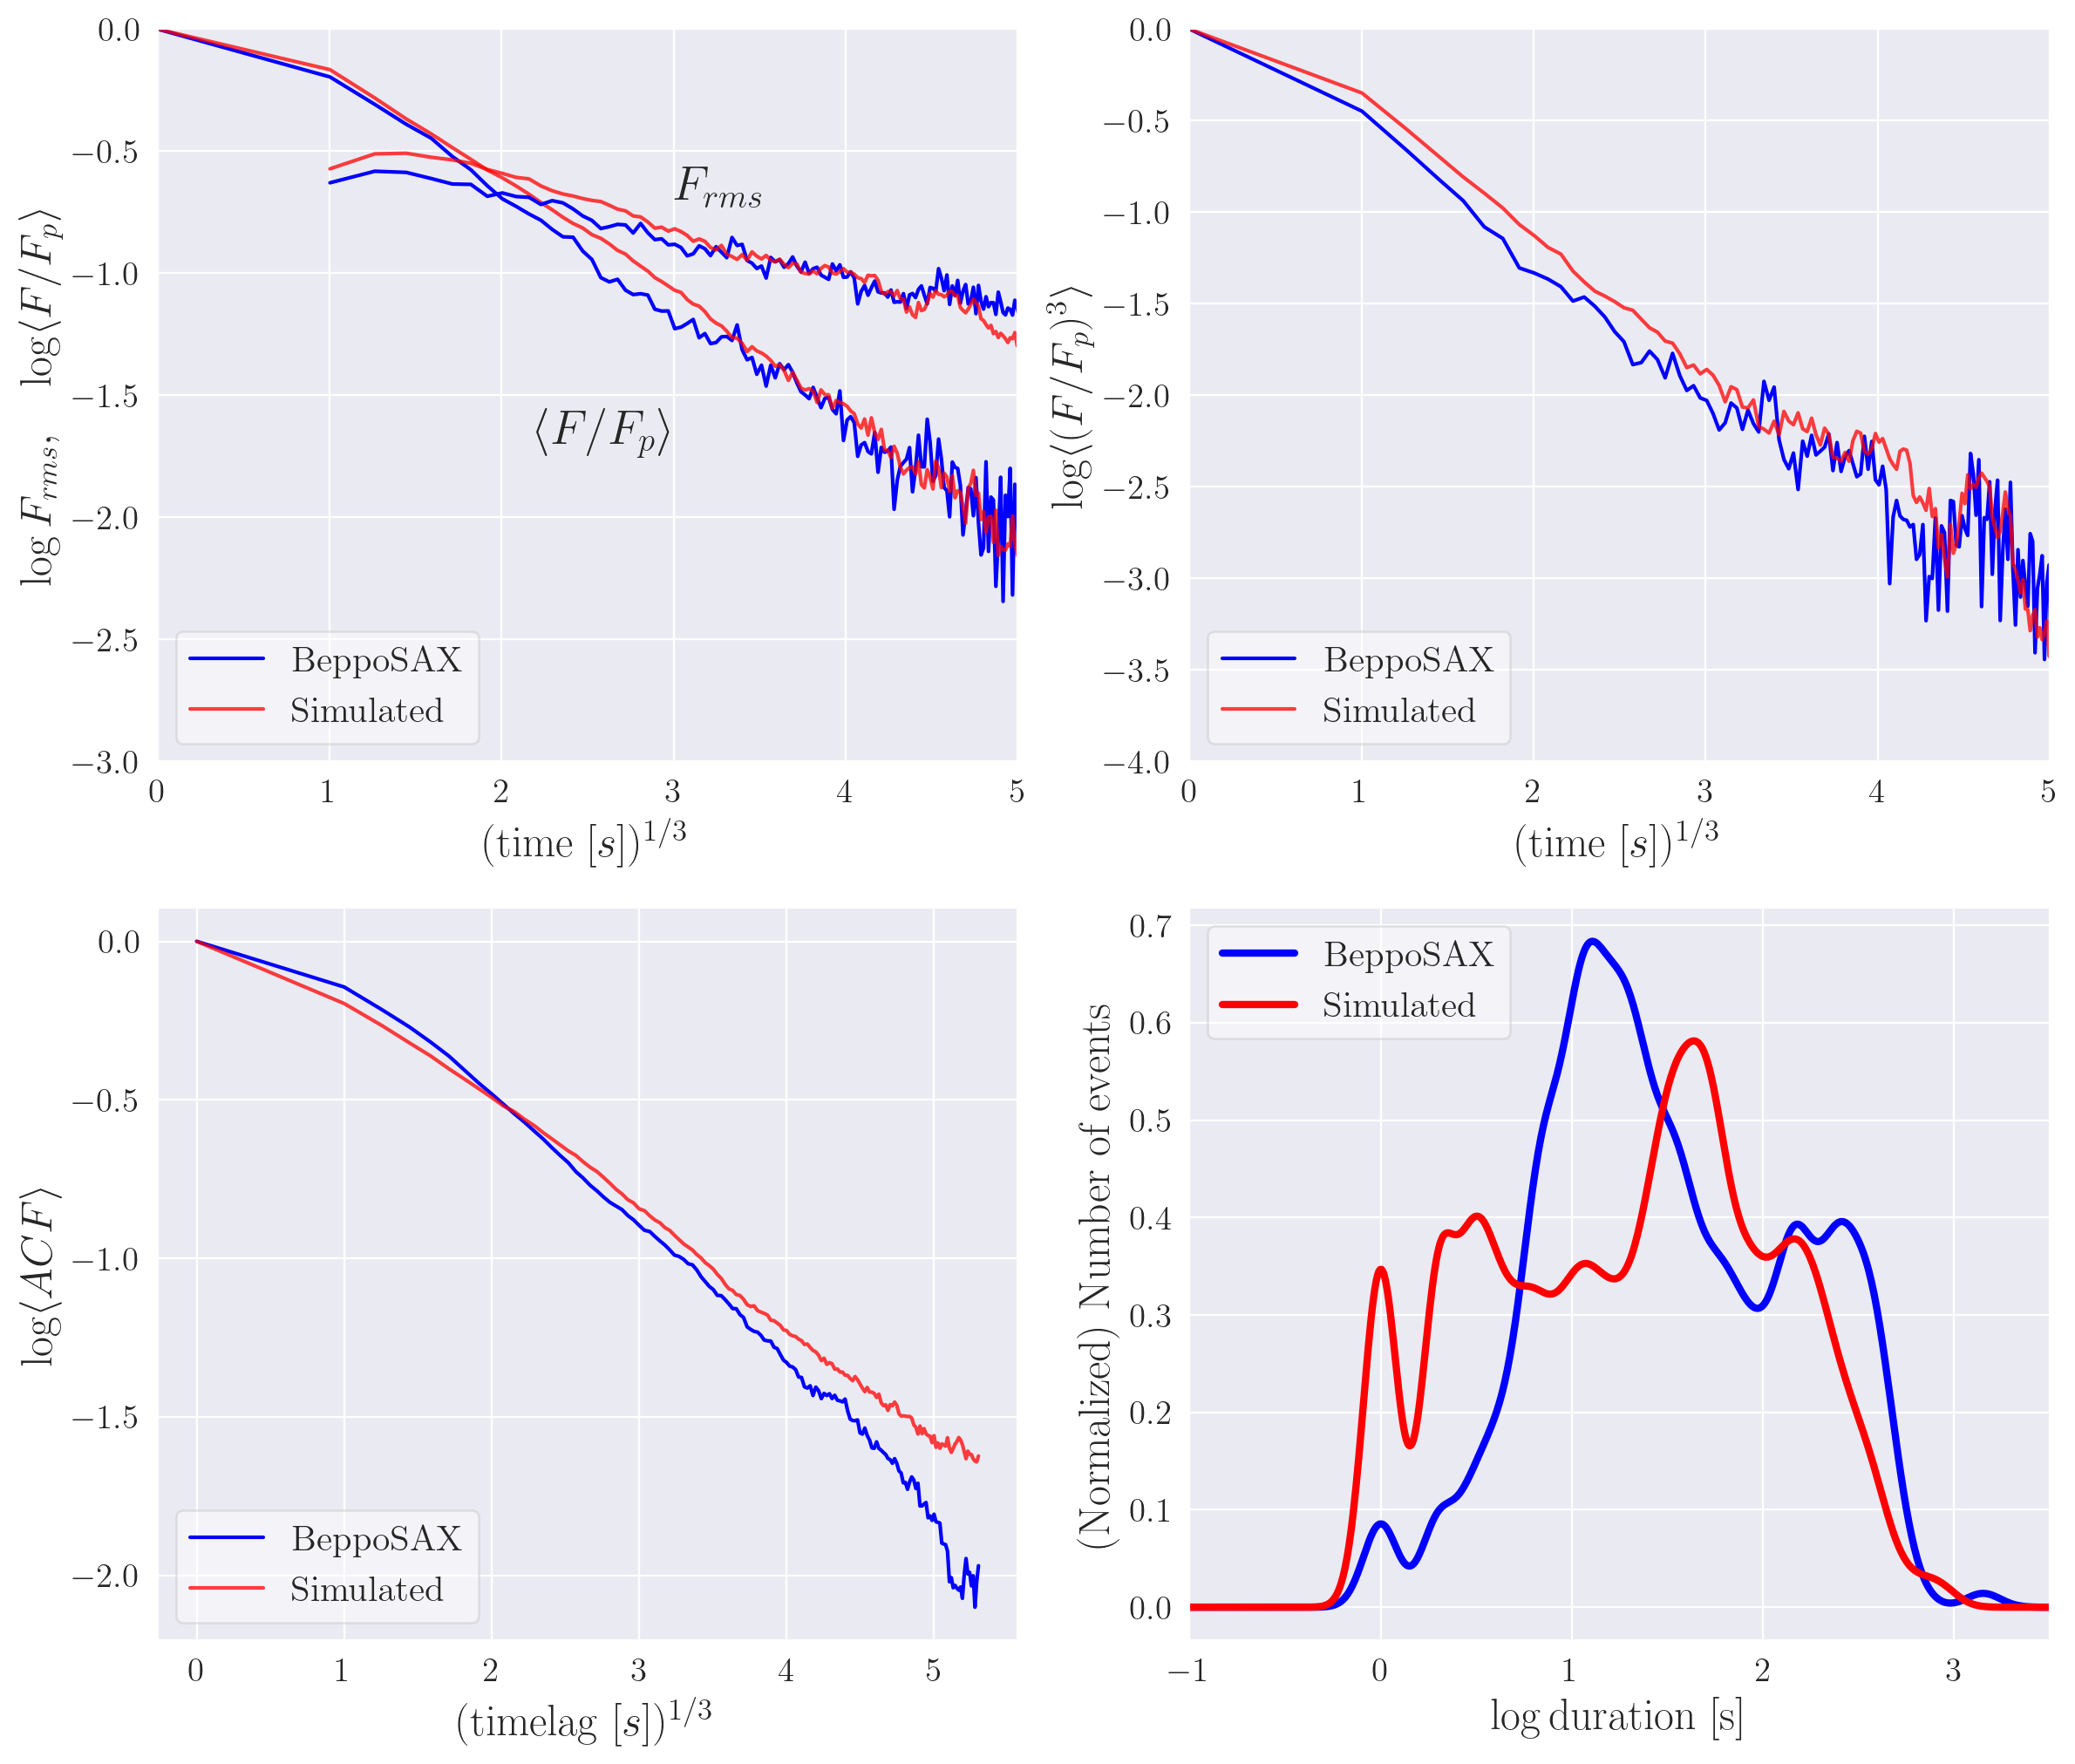

In [46]:
make_plot(instrument='sax',
          test_times=test_times_sax_lr, 
          averaged_fluxes=averaged_fluxes_sax_lr,           averaged_fluxes_sim=averaged_fluxes_sim_sax_lr,
          averaged_fluxes_rms=averaged_fluxes_rms_sax_lr,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_sax_lr,
          averaged_fluxes_cube=averaged_fluxes_cube_sax_lr, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_sax_lr,
          steps=steps_sax_lr, steps_sim=steps_sim_sax_lr, bin_time=bin_time_sax_lr, acf=acf_sax_lr, acf_sim=acf_sim_sax_lr,
          duration=duration_sax_lr, duration_sim=duration_sim_sax_lr)

50


# DEBUG

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

x_batse = np.log10(duration_batse)
bwrange = np.linspace(0.01, 1.0, 50) # Test 50 bandwidths from 0.01 to 1.0
#print(bwrange)

K    = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), 
                    {'bandwidth': bwrange}, 
                    cv=K)  # Try each bandwidth with K-folds
# Fit the histogram data
grid.fit(x_batse[:, None]) 
h_opt = grid.best_params_['bandwidth']
print('optimal bandwisth: h_opt =', h_opt)

optimal bandwisth: h_opt = 0.09081632653061224


(-0.5, 3.0)

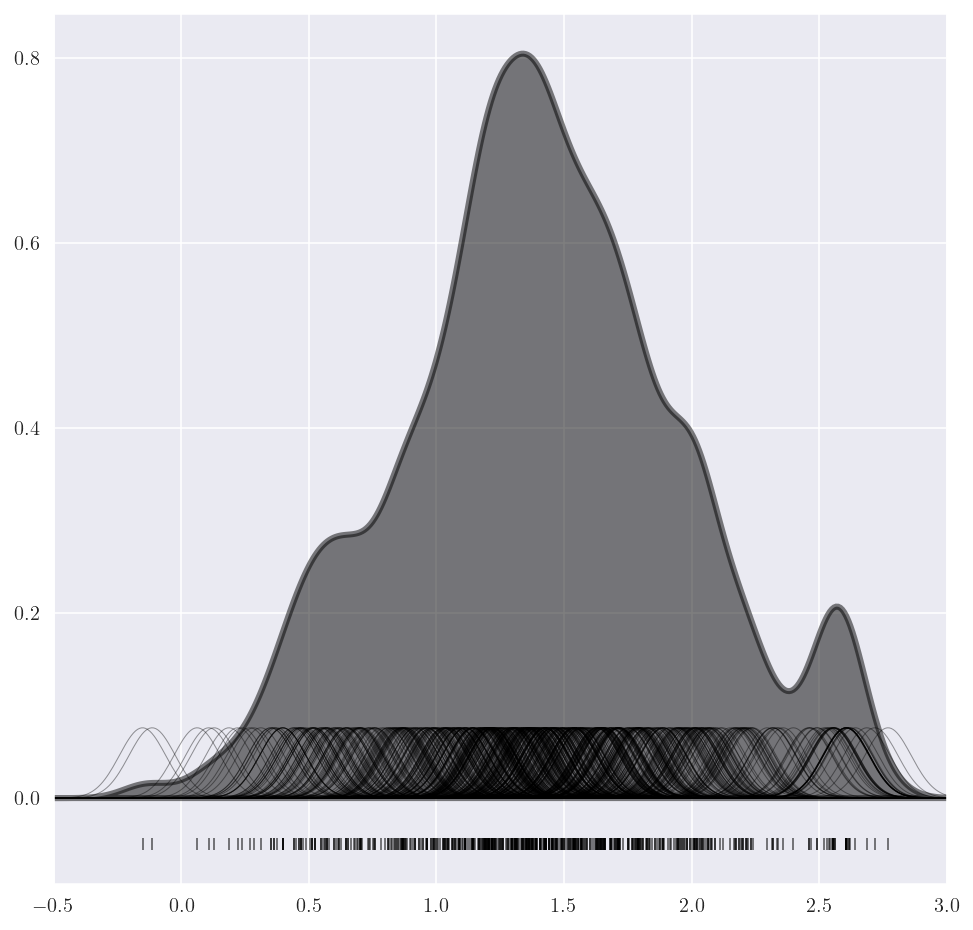

In [ ]:
from scipy import stats

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_grid  = np.linspace(-4, 4, 1000)
y_plot  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot /= (len(x_batse))
#
ax.fill(x_grid, y_plot.sum(0), ec='k', lw=3, fc='k', alpha=0.5)
ax.plot(x_grid, 10*y_plot.T, '-k', lw=0.5, alpha=0.4)
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='k', alpha=0.5)
ax.set_xlim(-0.5,3)

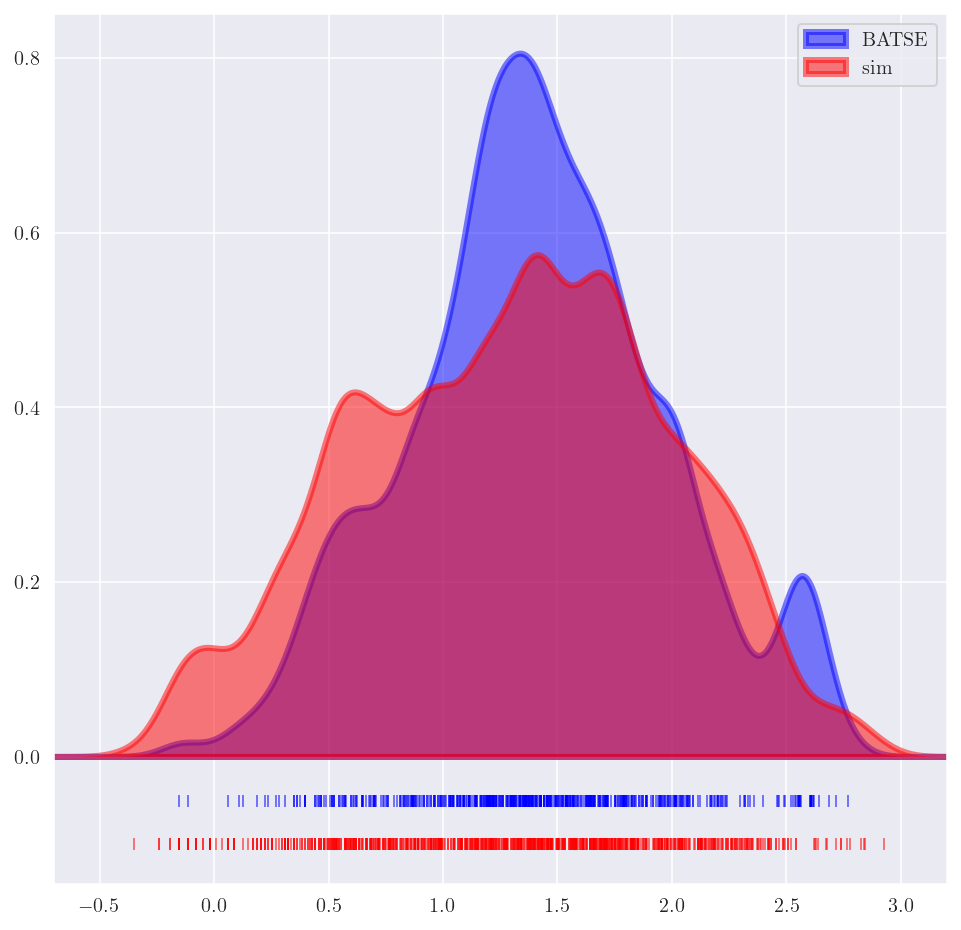

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(111)
#
x_batse = np.log10(duration_batse)
x_sim   = np.log10(duration_sim_batse)
#
x_grid        = np.linspace(-2, 5, 1000)
y_plot_batse  = stats.norm.pdf(x_grid, x_batse[:, None], h_opt)
y_plot_sim    = stats.norm.pdf(x_grid, x_sim[:, None],   h_opt)
y_plot_batse /= (len(x_batse))
y_plot_sim   /= (len(x_sim))
#
ax.fill(x_grid, y_plot_batse.sum(0), ec='b', lw=3, fc='b', alpha=0.5, label='BATSE')
ax.fill(x_grid, y_plot_sim.sum(0),   ec='r', lw=3, fc='r', alpha=0.5, label='sim')
ax.plot(x_batse, 0*x_batse - 0.05, '|', c='b', alpha=0.5)
ax.plot(x_sim,   0*x_sim - 0.1,    '|', c='r', alpha=0.5)
ax.set_xlim(-0.7,3.2)
plt.legend()
plt.show()

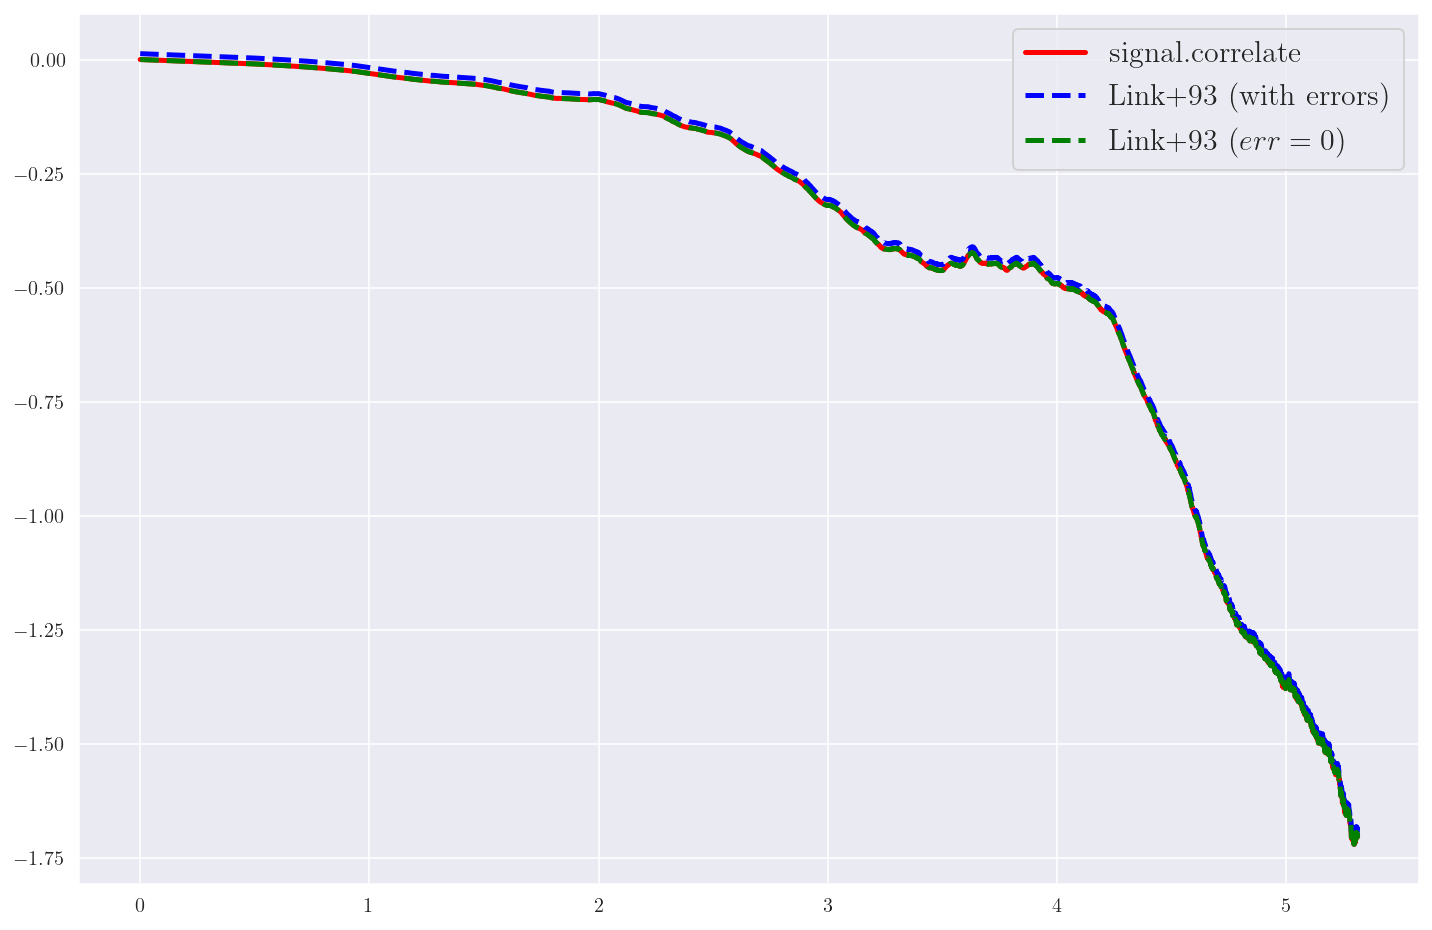

In [ ]:
from scipy import signal

counts = grb_list_batse[0].counts
counts = np.float32(counts)
errs   = grb_list_batse[0].errs
steps  = int(t_f/bin_time)

corr   = signal.correlate(counts, counts)
lags   = signal.correlation_lags(len(counts), len(counts))
corr   = corr / np.max(corr)

t_min=0   # [s] min time lag for the autocorrelation
t_max=150 # [s] max time lag for the autocorrelation

idx_i = np.where(lags*bin_time==t_min)[0][0]
idx_f = np.where(lags*bin_time<=t_max)[0][-1]
assert lags[idx_i]==t_min, "ERROR: The left limit of the autocorrelation is not computed correctly..."
assert np.isclose(lags[idx_f]*bin_time, 150, atol=1e-1), "ERROR: The right limit of the autocorrelation is not computed correctly..."

lags = lags[idx_i:idx_f+1]
corr = corr[idx_i:idx_f+1]

acf_link93_err = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(steps+1)]
acf_link93     = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2          ) for u in range(steps+1)]

plt.figure(figsize=(12,8))
plt.plot((lags*bin_time)**(1/3.), np.log10(corr),           c='r', lw=2.5, ls='-',  label=r'signal.correlate')
plt.plot((lags*bin_time)**(1/3.), np.log10(acf_link93_err), c='b', lw=2.5, ls='--', label=r'Link+93 (with errors)')
plt.plot((lags*bin_time)**(1/3.), np.log10(acf_link93),     c='g', lw=2.5, ls='--', label=r'Link+93 ($err=0$)')
#plt.xlim(0,5)
plt.legend(prop={'size':15})
plt.show()

In [ ]:
###  Rebin test  ###

#------------------------------------------------------------------------------#

#times = np.linspace(0,2*np.pi, 360)
#vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
#errs = np.sqrt(np.abs(vals))

#plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
#reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
#plt.plot(reb_time, reb_vals)

#------------------------------------------------------------------------------#

#reb_times_batse, reb_data_batse, _ = rebinFunction(test_times, averaged_fluxes_batse, averaged_fluxes_error_batse, s_n_threshold=1)
#reb_times_sim, reb_data_sim, _     = rebinFunction(test_times, averaged_fluxes_sim,   averaged_fluxes_error_sim,   s_n_threshold=1)

#reb_data_batse = savgol_filter(averaged_fluxes_batse, 17, 2)
#reb_data_sim   = savgol_filter(averaged_fluxes_sim,   17, 2)

#------------------------------------------------------------------------------#

#plt.plot(test_times**(1/3), np.log10(reb_data_batse), label = 'batse')
#plt.plot(test_times**(1/3), np.log10(reb_data_sim), label ='sim')
#plt.xlim([0,5])
#plt.legend()

#------------------------------------------------------------------------------#

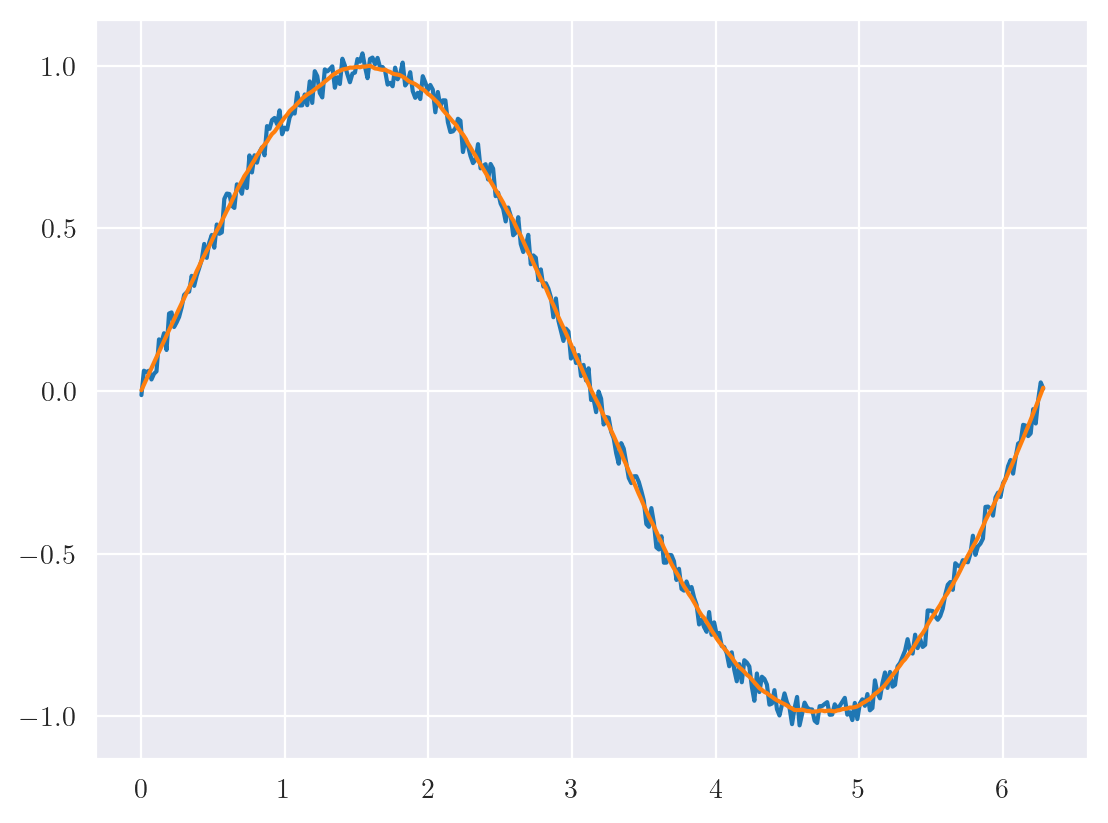

In [ ]:
#Savitzky-Golay filter test
from scipy.signal import savgol_filter

times = np.linspace(0,2*np.pi, 360)
vals = (np.sin(times) + (np.random.rand(len(times))-0.5)*0.1) 

filtered_vals = savgol_filter(vals, 41, 2,0)
plt.plot(times, vals)
plt.plot(times, filtered_vals)

NameError: name 'rebinFunction' is not defined

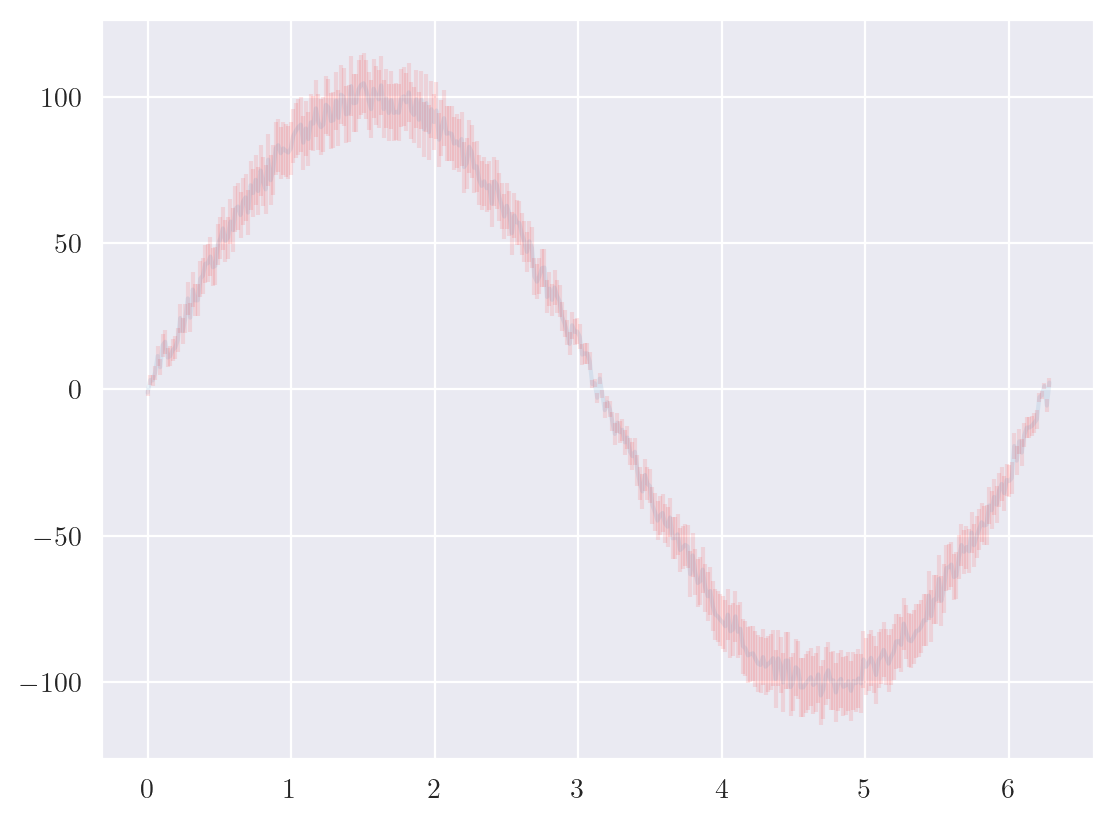

In [ ]:
#Rebin test

times = np.linspace(0,2*np.pi, 360)
vals = ((np.sin(times) + (np.random.rand(len(times))-0.5)*0.1))*100 
errs = np.sqrt(np.abs(vals))

plt.errorbar(times, vals, yerr = errs, ecolor = 'red', alpha = 0.1)
reb_time, reb_vals, reb_errs = rebinFunction(times, vals, errs, s_n_threshold = 5)
#plt.errorbar(reb_time, reb_vals, yerr = reb_errs, ecolor = 'green', alpha = 0.5)
plt.plot(reb_time, reb_vals)

(100.0, 150.0)

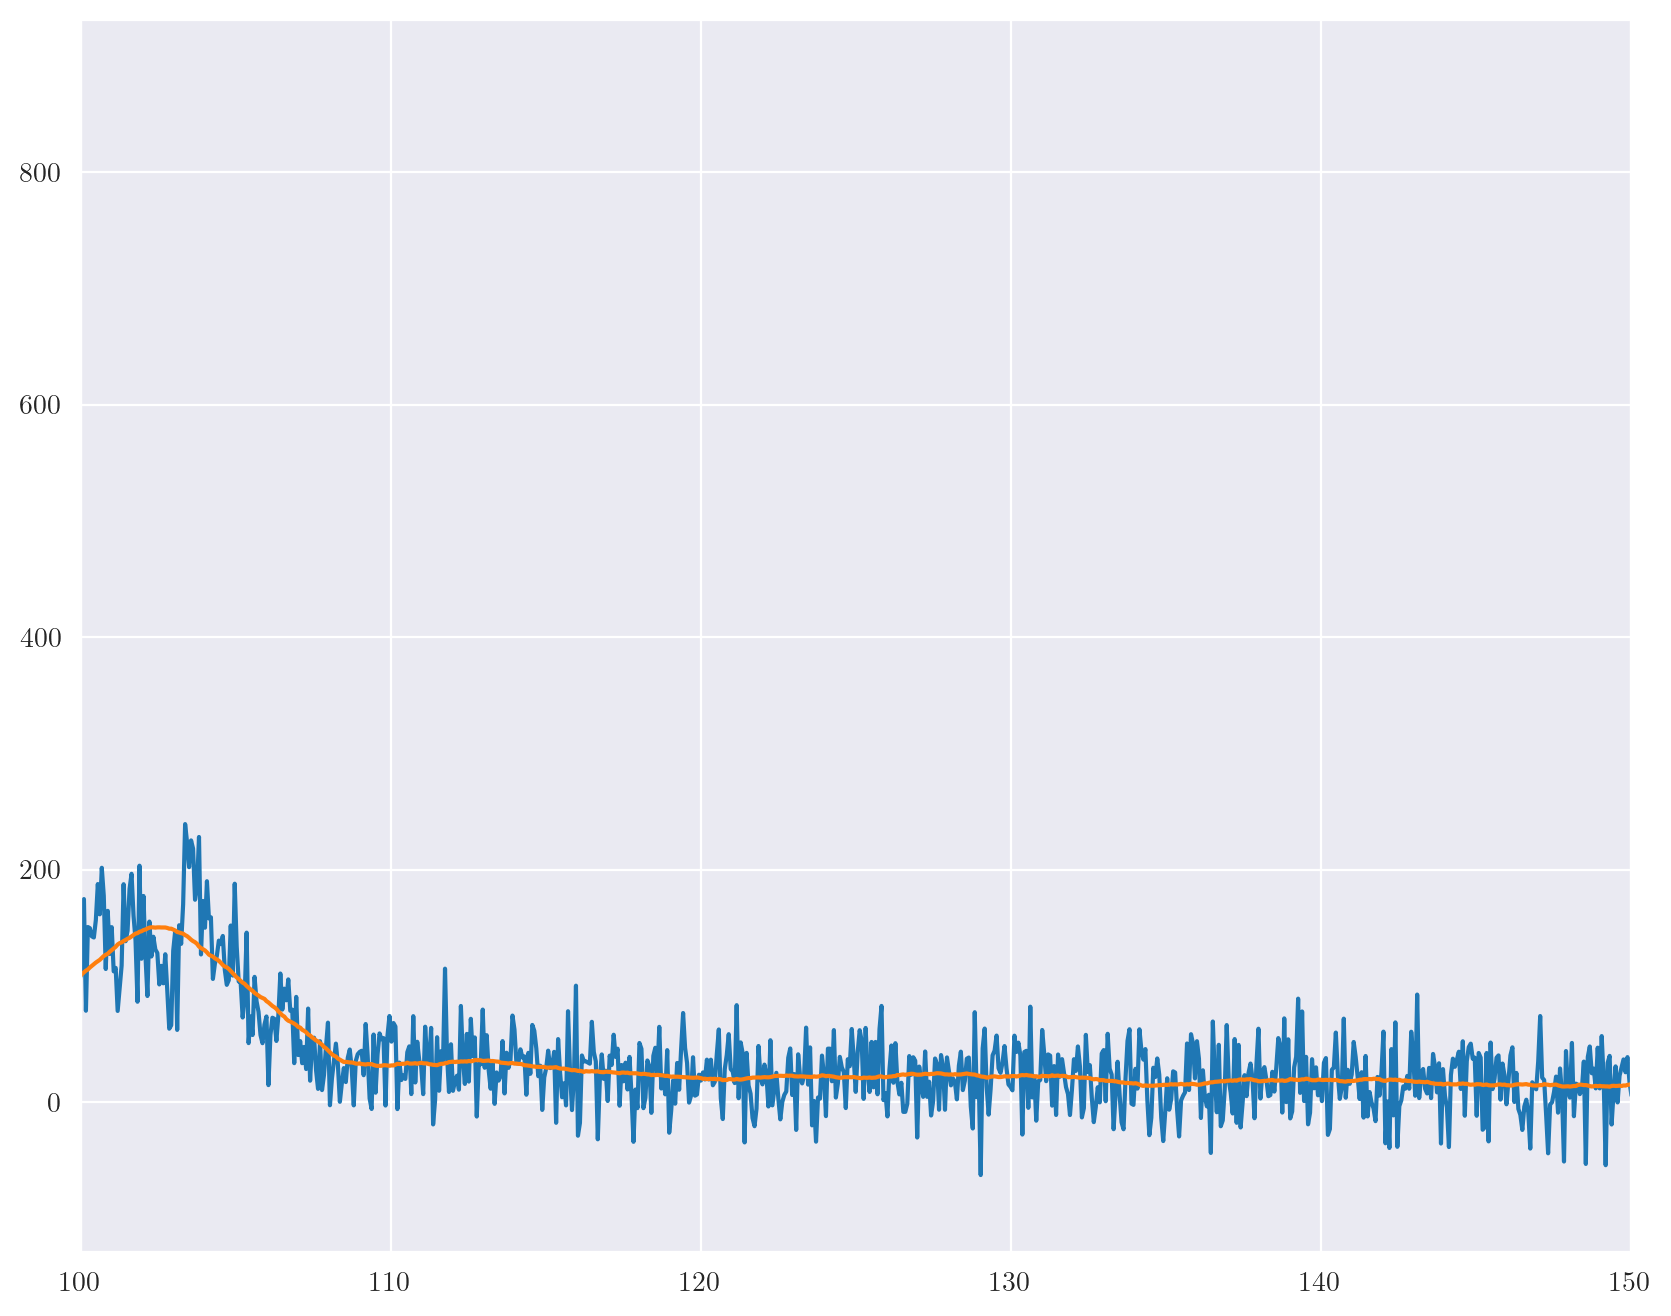

In [ ]:
times = grb_list_batse[0].times
vals = grb_list_batse[0].counts

filtered_vals = savgol_filter(vals, 161, 2 , 0)
plt.figure(figsize=(10,8))
plt.plot(times, vals)
plt.plot(times, filtered_vals)
plt.xlim(100,150)
#plt.xlim(-50,350)

In [ ]:
mean_value=0
for i, grb in enumerate(grb_list_batse[500:1000]):
    times=grb.times
    counts=grb.counts
    errs=grb.errs
    #plt.errorbar(times[::100], 
    #             counts[::100], 
    #             yerr=errs[::100],
    #             ecolor='r', 
    #             marker='.',
    #             color='b')
    #plt.show()    
    acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    mean_value+=acf_link93_test[1]
    if(acf_link93_test[1]<-50):
        print(acf_link93_test[1], i)
    #print(acf_link93[1], i)
print('mean = ', mean_value/100)

NameError: name 'steps' is not defined

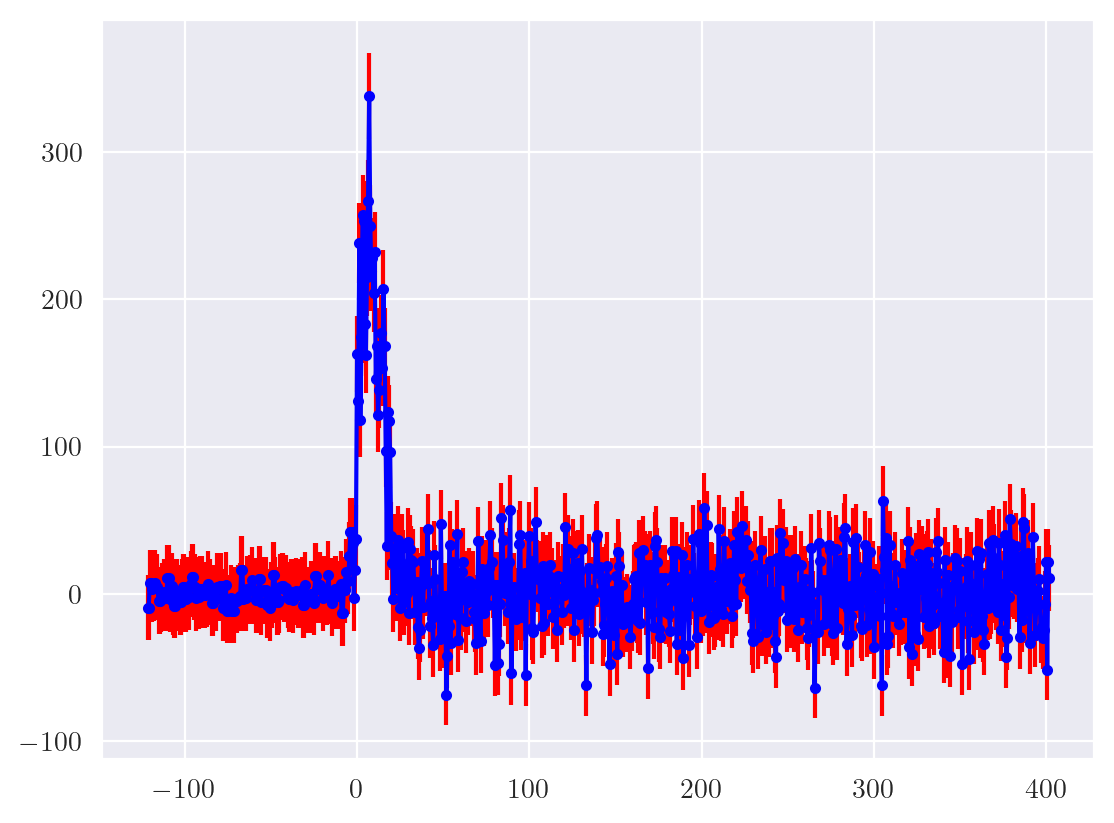

1.100963409212773 164


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==164: # 187
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        plt.errorbar(times[::10], 
                     counts[::10], 
                     yerr=errs[::10],
                     ecolor='r', 
                     marker='.',
                     color='b')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

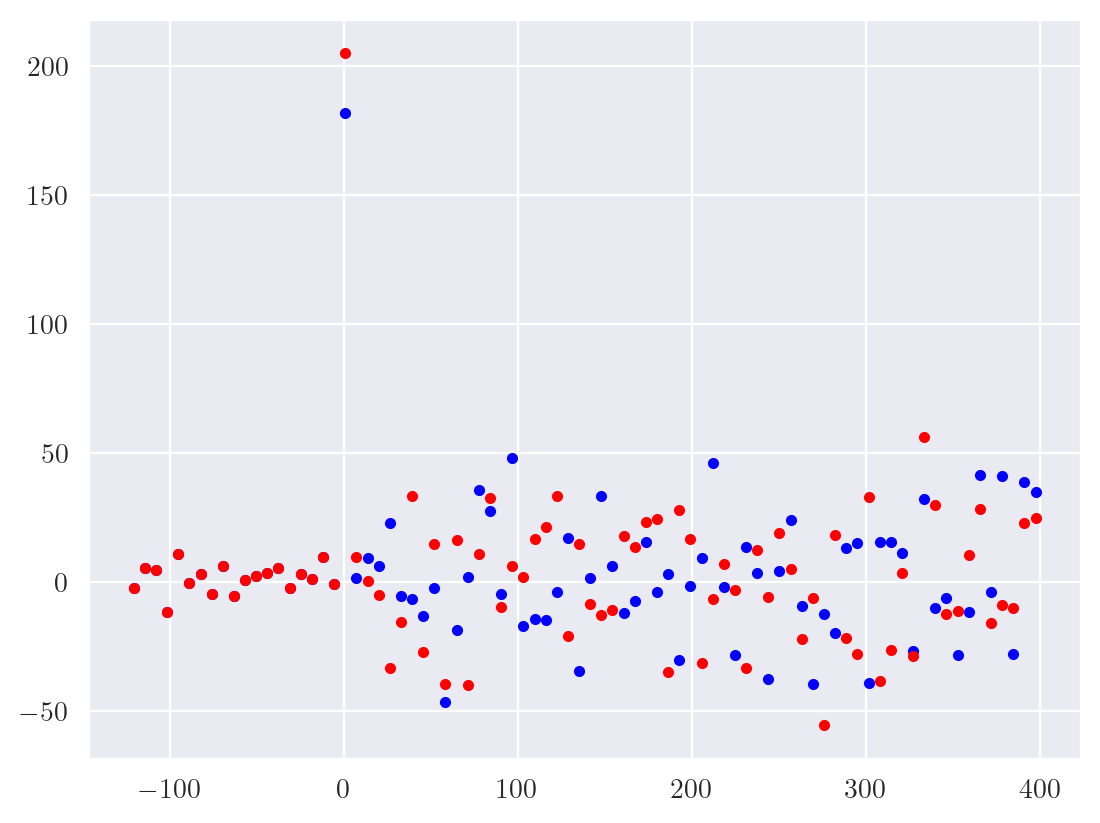

40.32327260478941 187


In [ ]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==187:
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        counts_u1=np.roll(counts,-1)
        plt.scatter(times[::100], 
                    counts[::100], 
                    color='b',
                    marker='.')
        plt.scatter(times[::100], 
                    counts_u1[::100], 
                    color='r',
                    marker='.')
        plt.show()    
        acf_link93_test = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93_test[1], i)
    else:
        pass

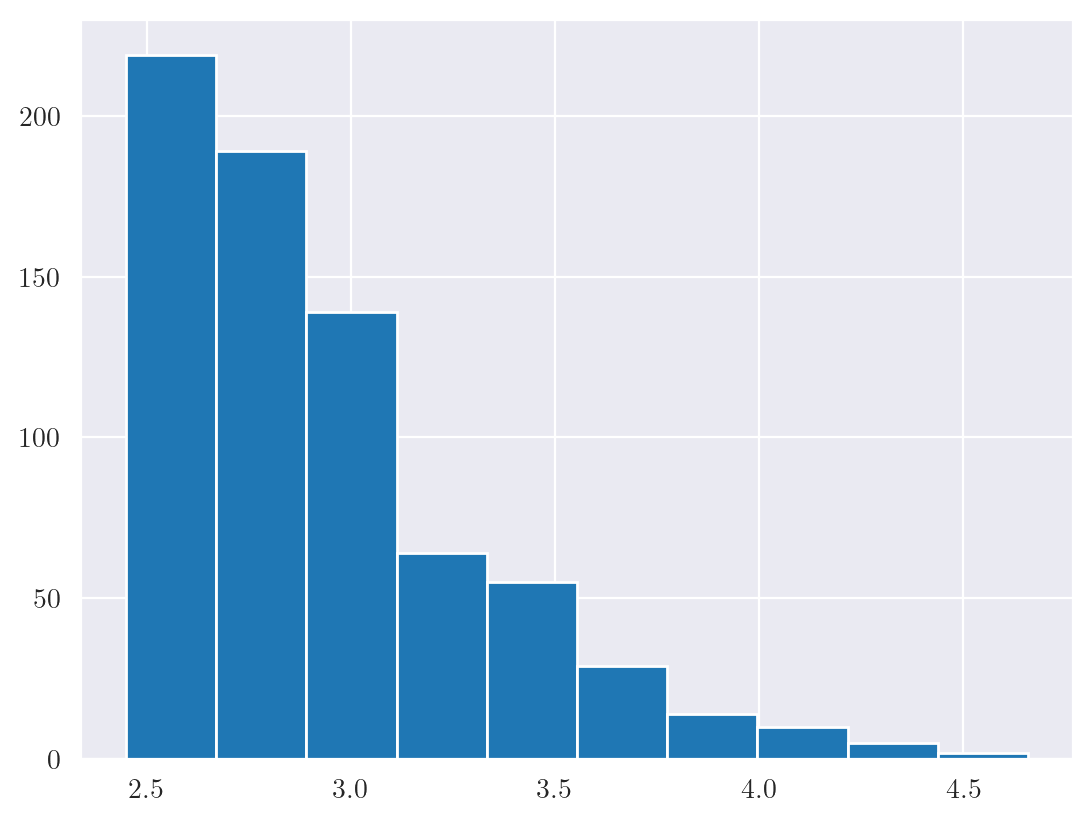

In [ ]:
maxlist =[]
for i, grb in enumerate(grb_list_batse):
    maxlist.append(np.max(grb.counts))

plt.hist(np.log10(maxlist));

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


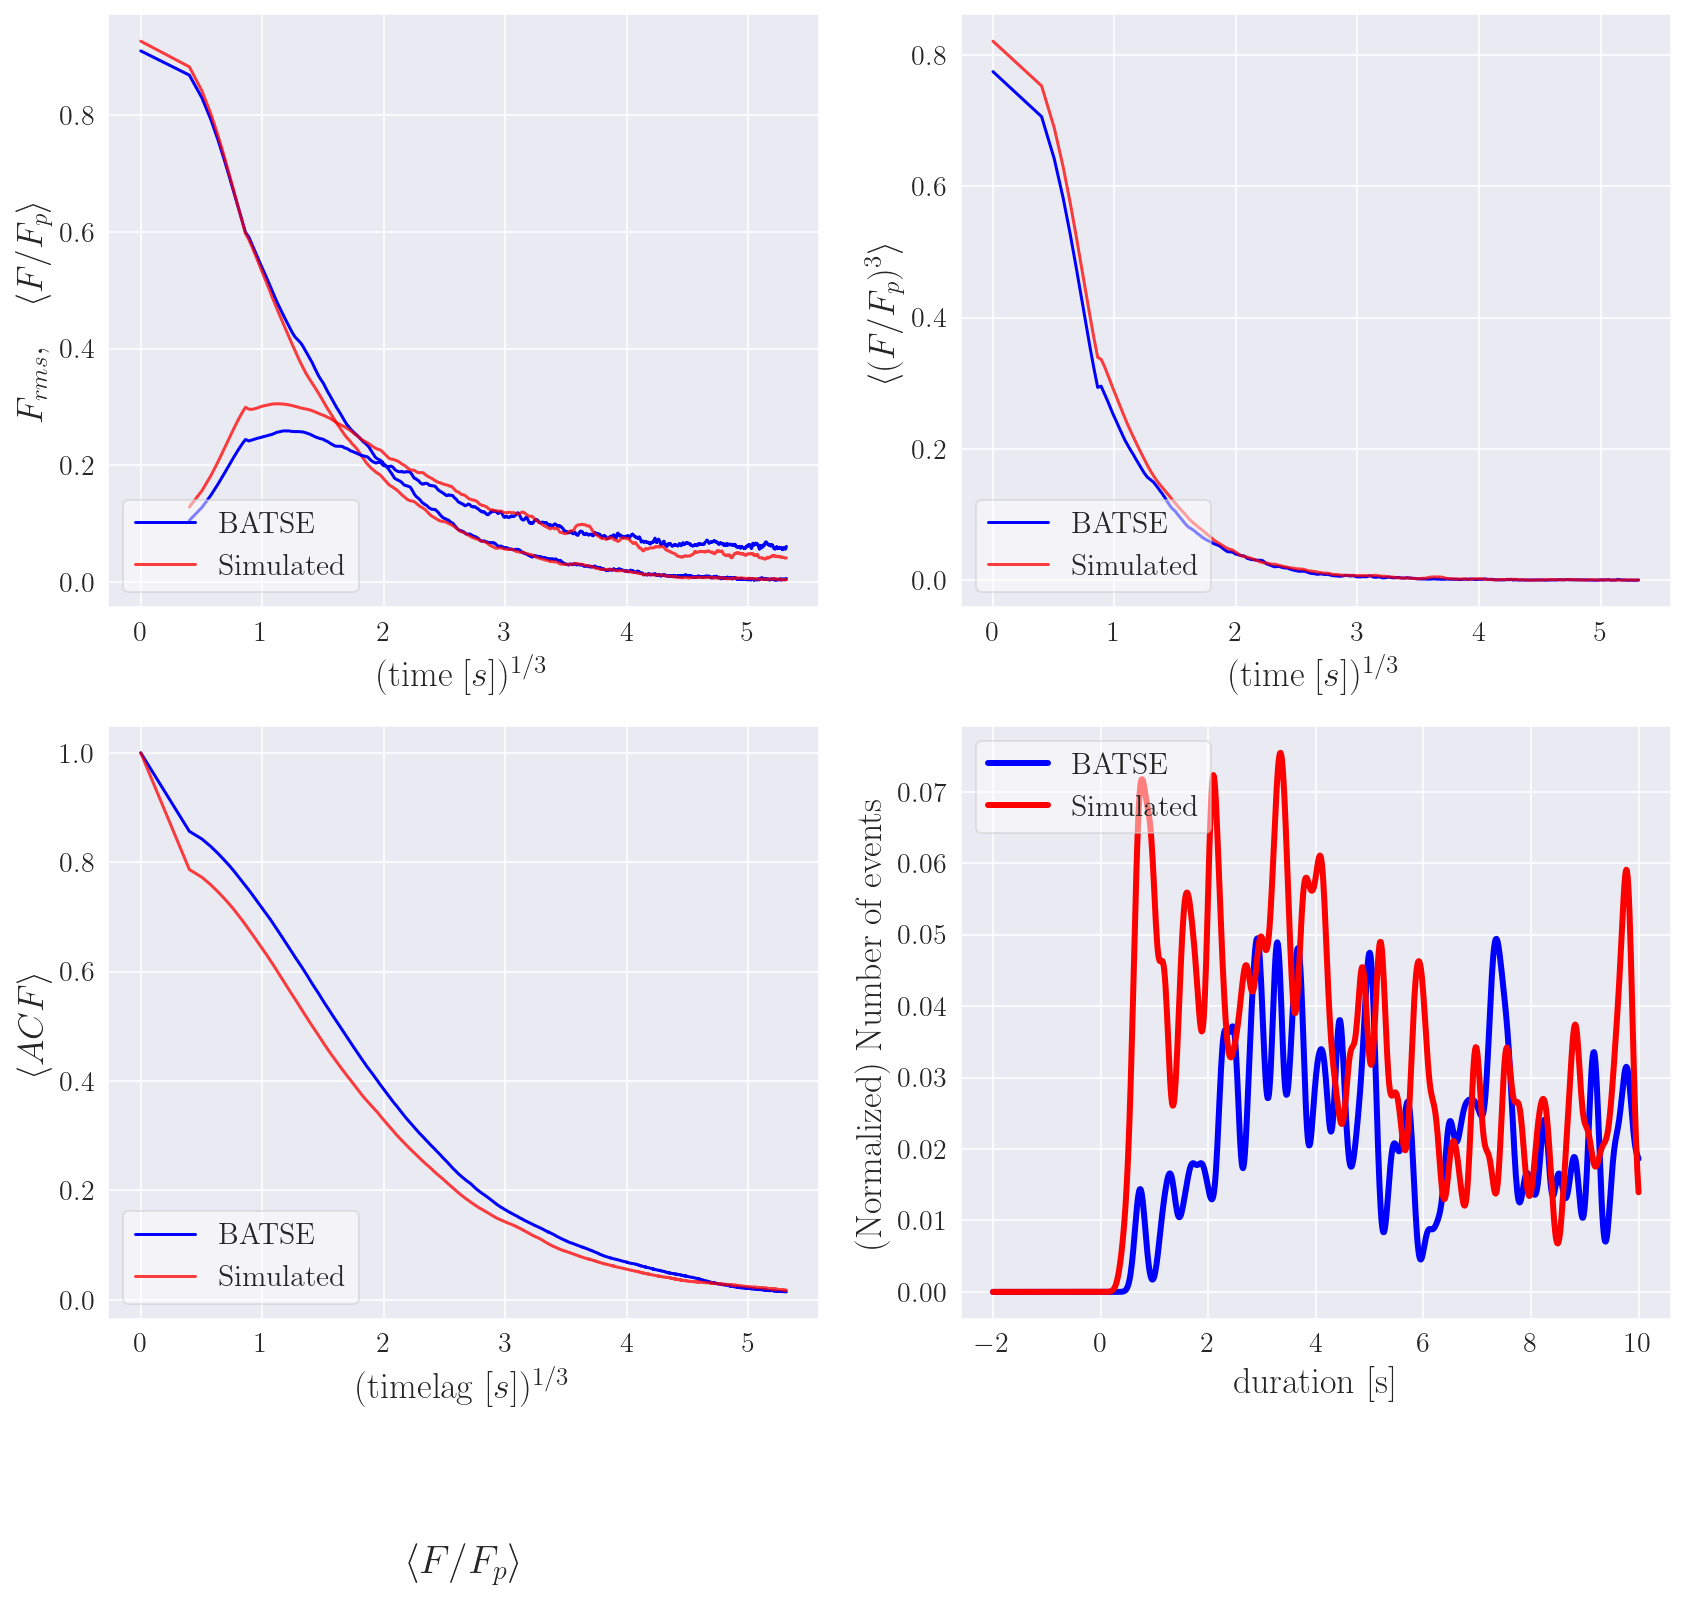

In [ ]:
# hist = False
# log  = False
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=False, log=False)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


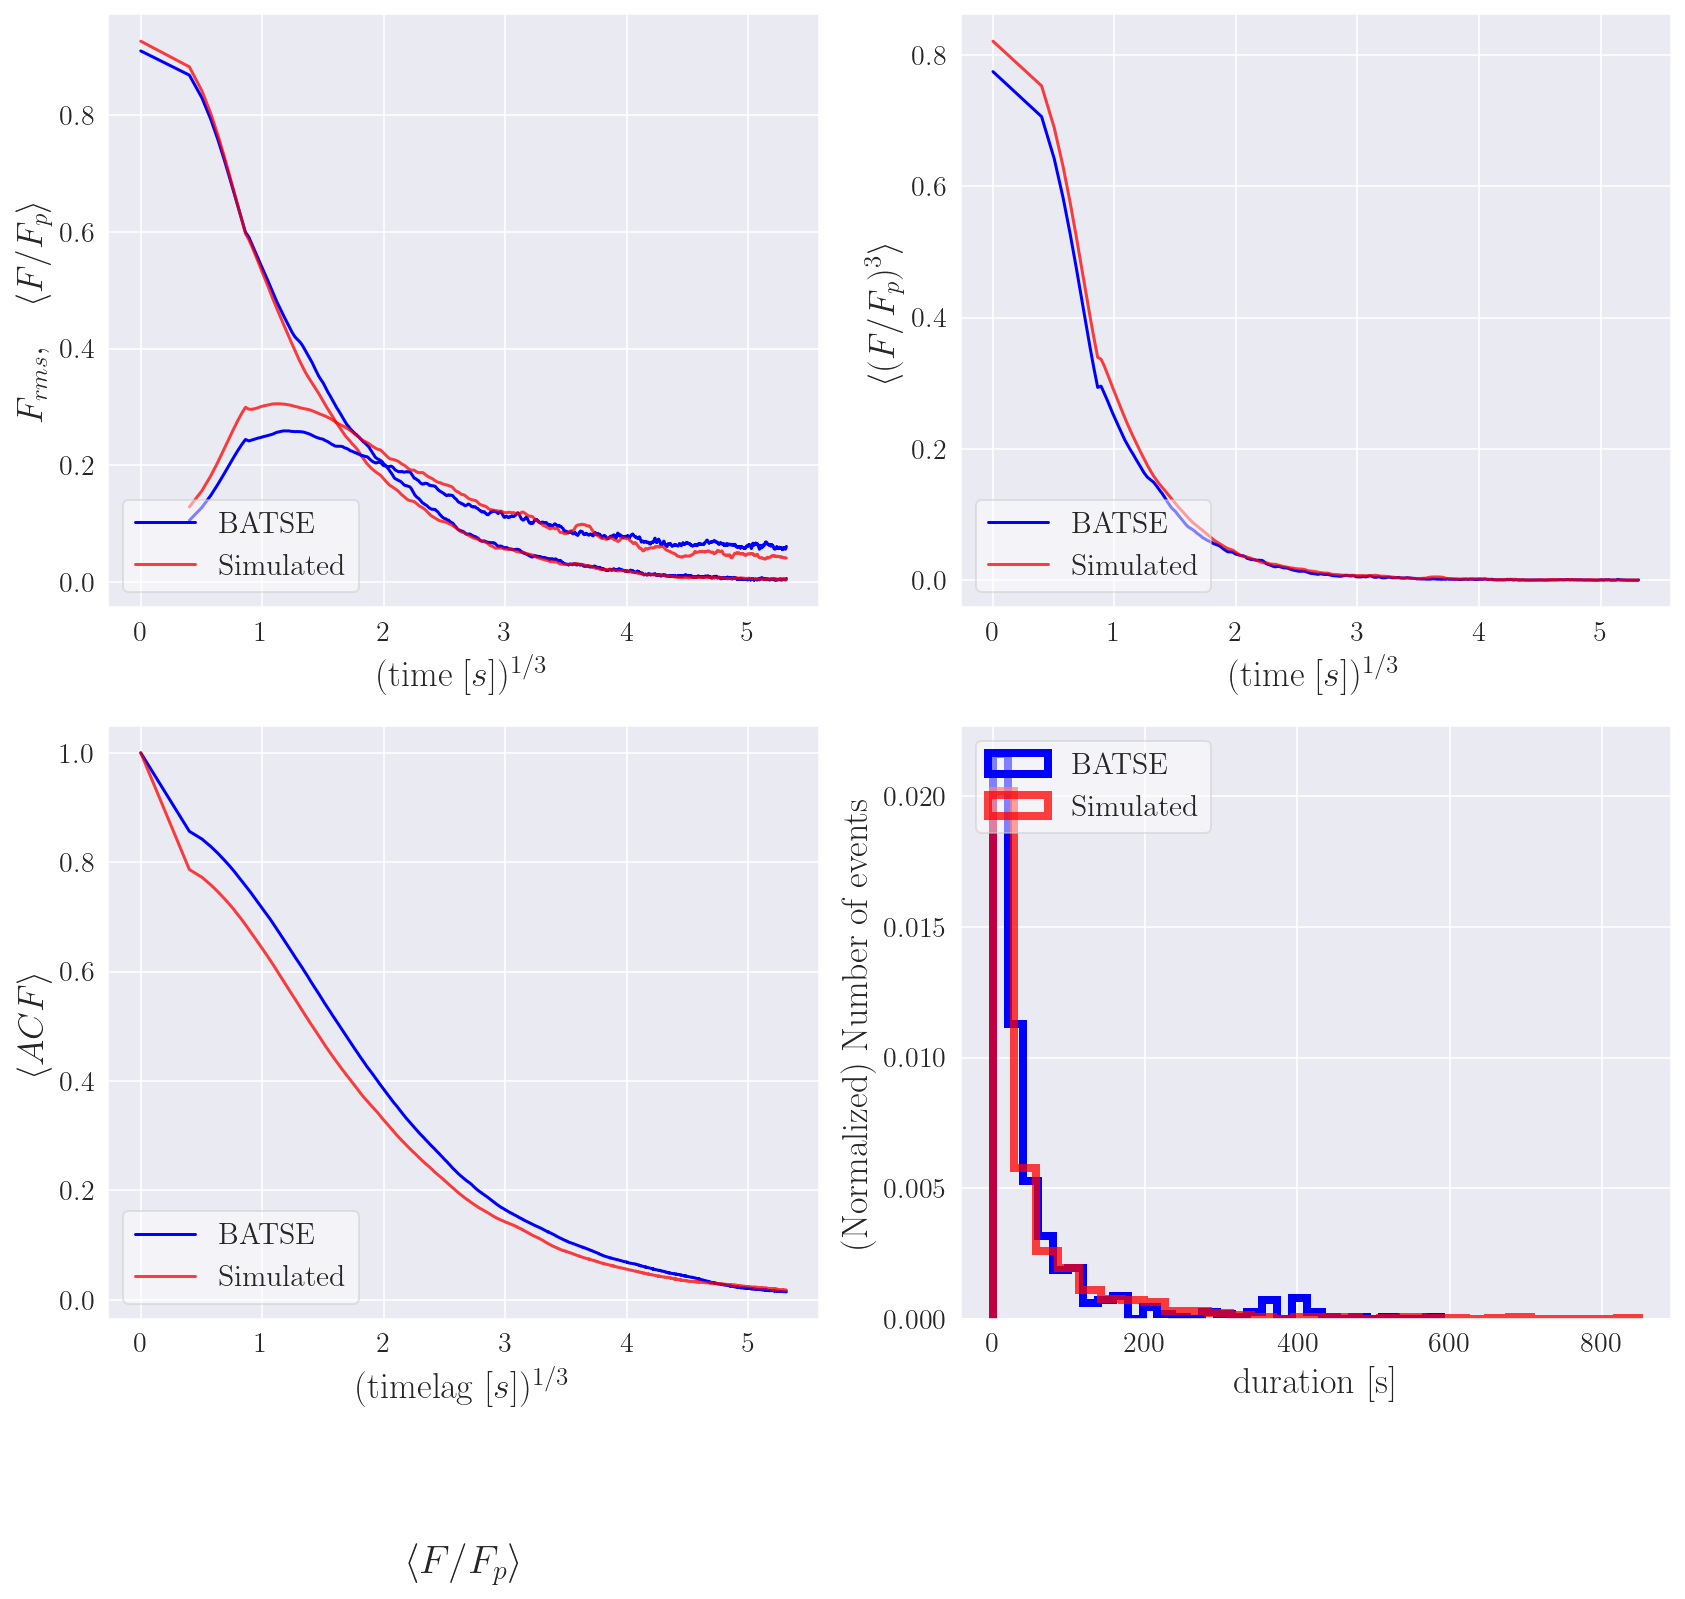

In [ ]:
# hist = True
# log  = False
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=True, log=False)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


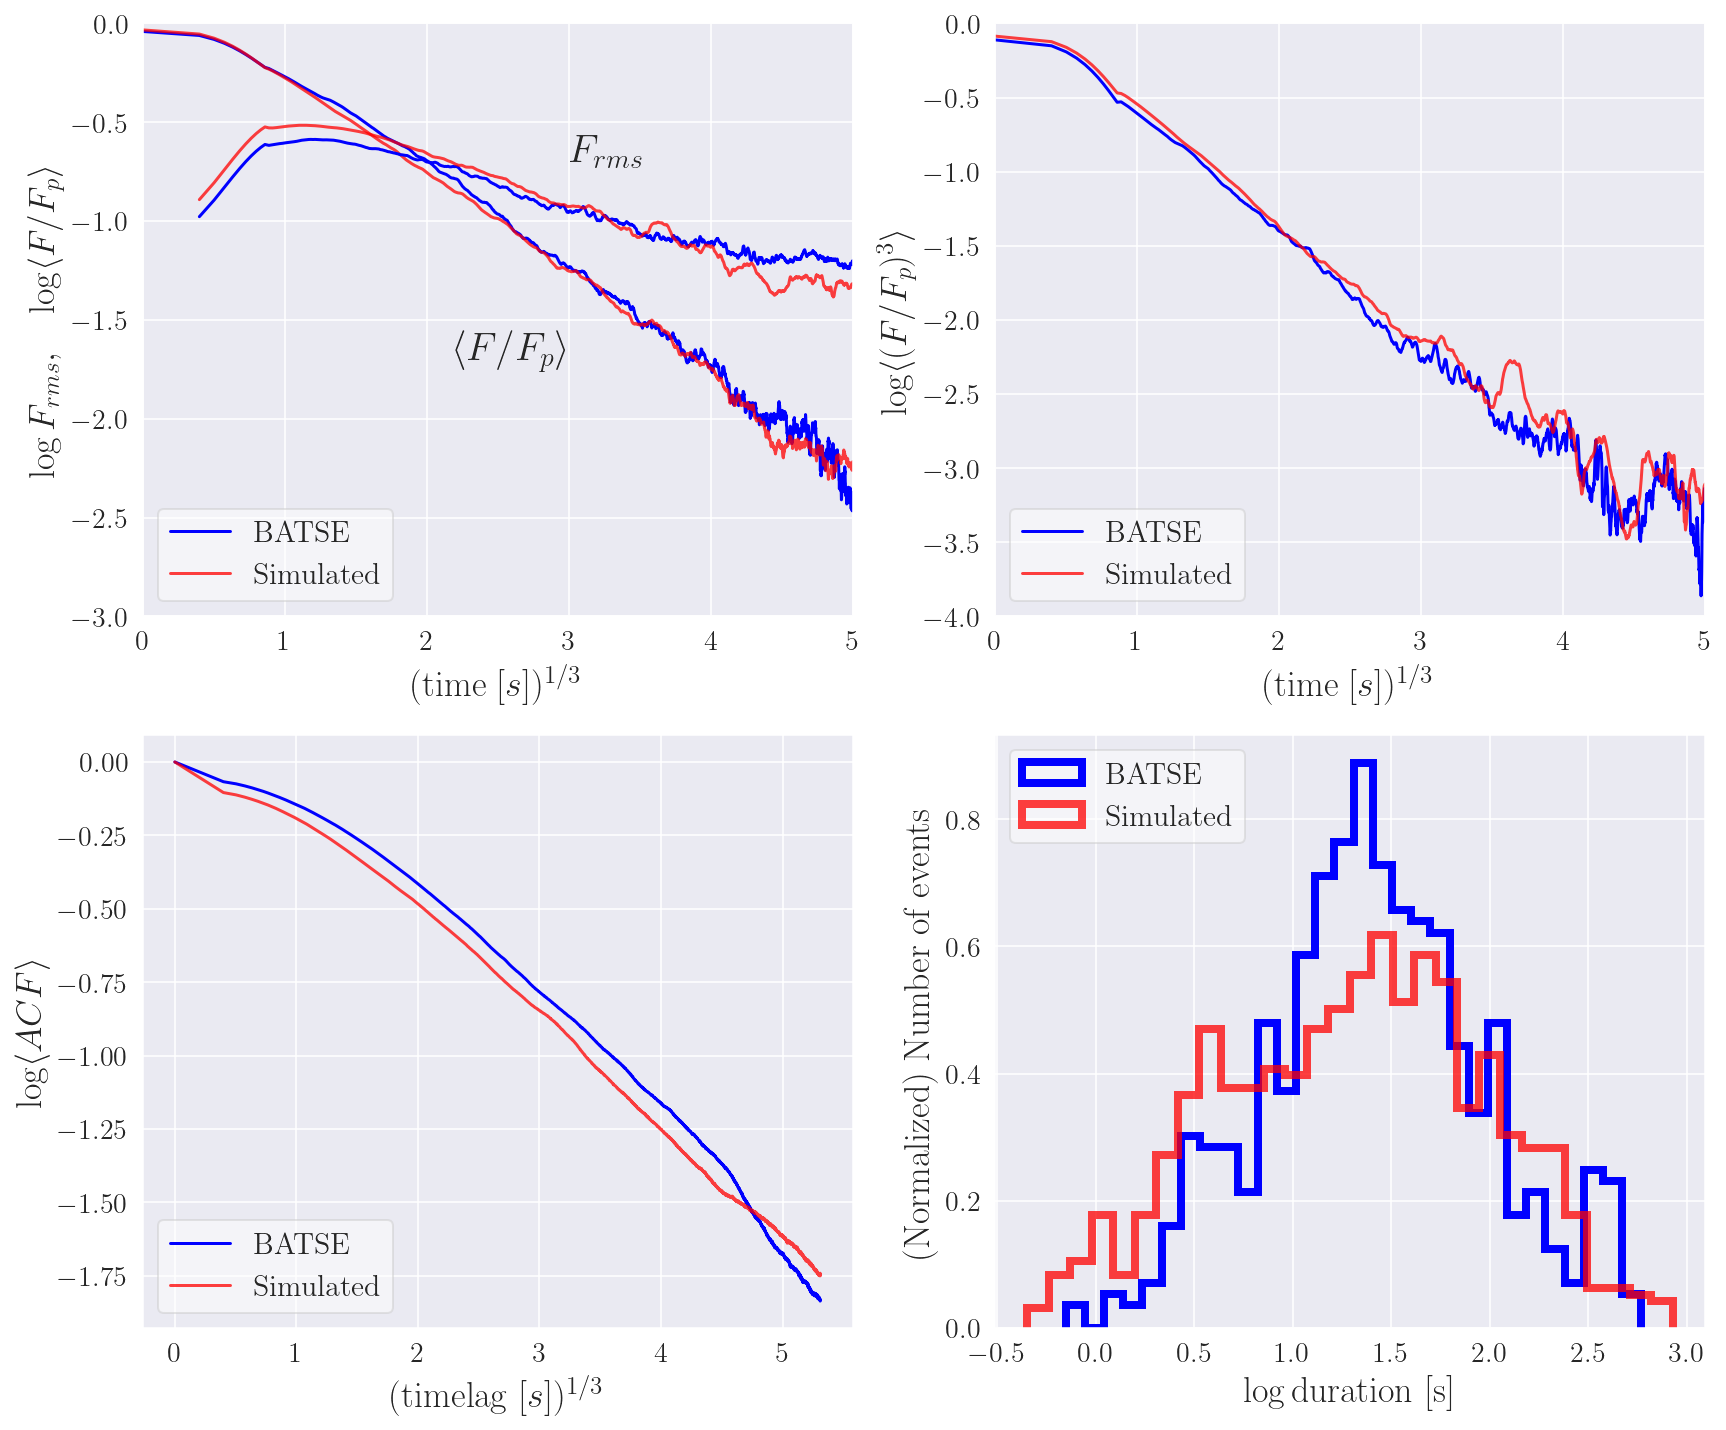

In [ ]:
# hist = True
# log  = True
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=True, log=True)

- plotting <(F/F_p)>...
	done
- plotting <(F/F_p)^3>...
	done
- plotting the autocorrelation...
	done
- plotting the distribution of the durations...
	done


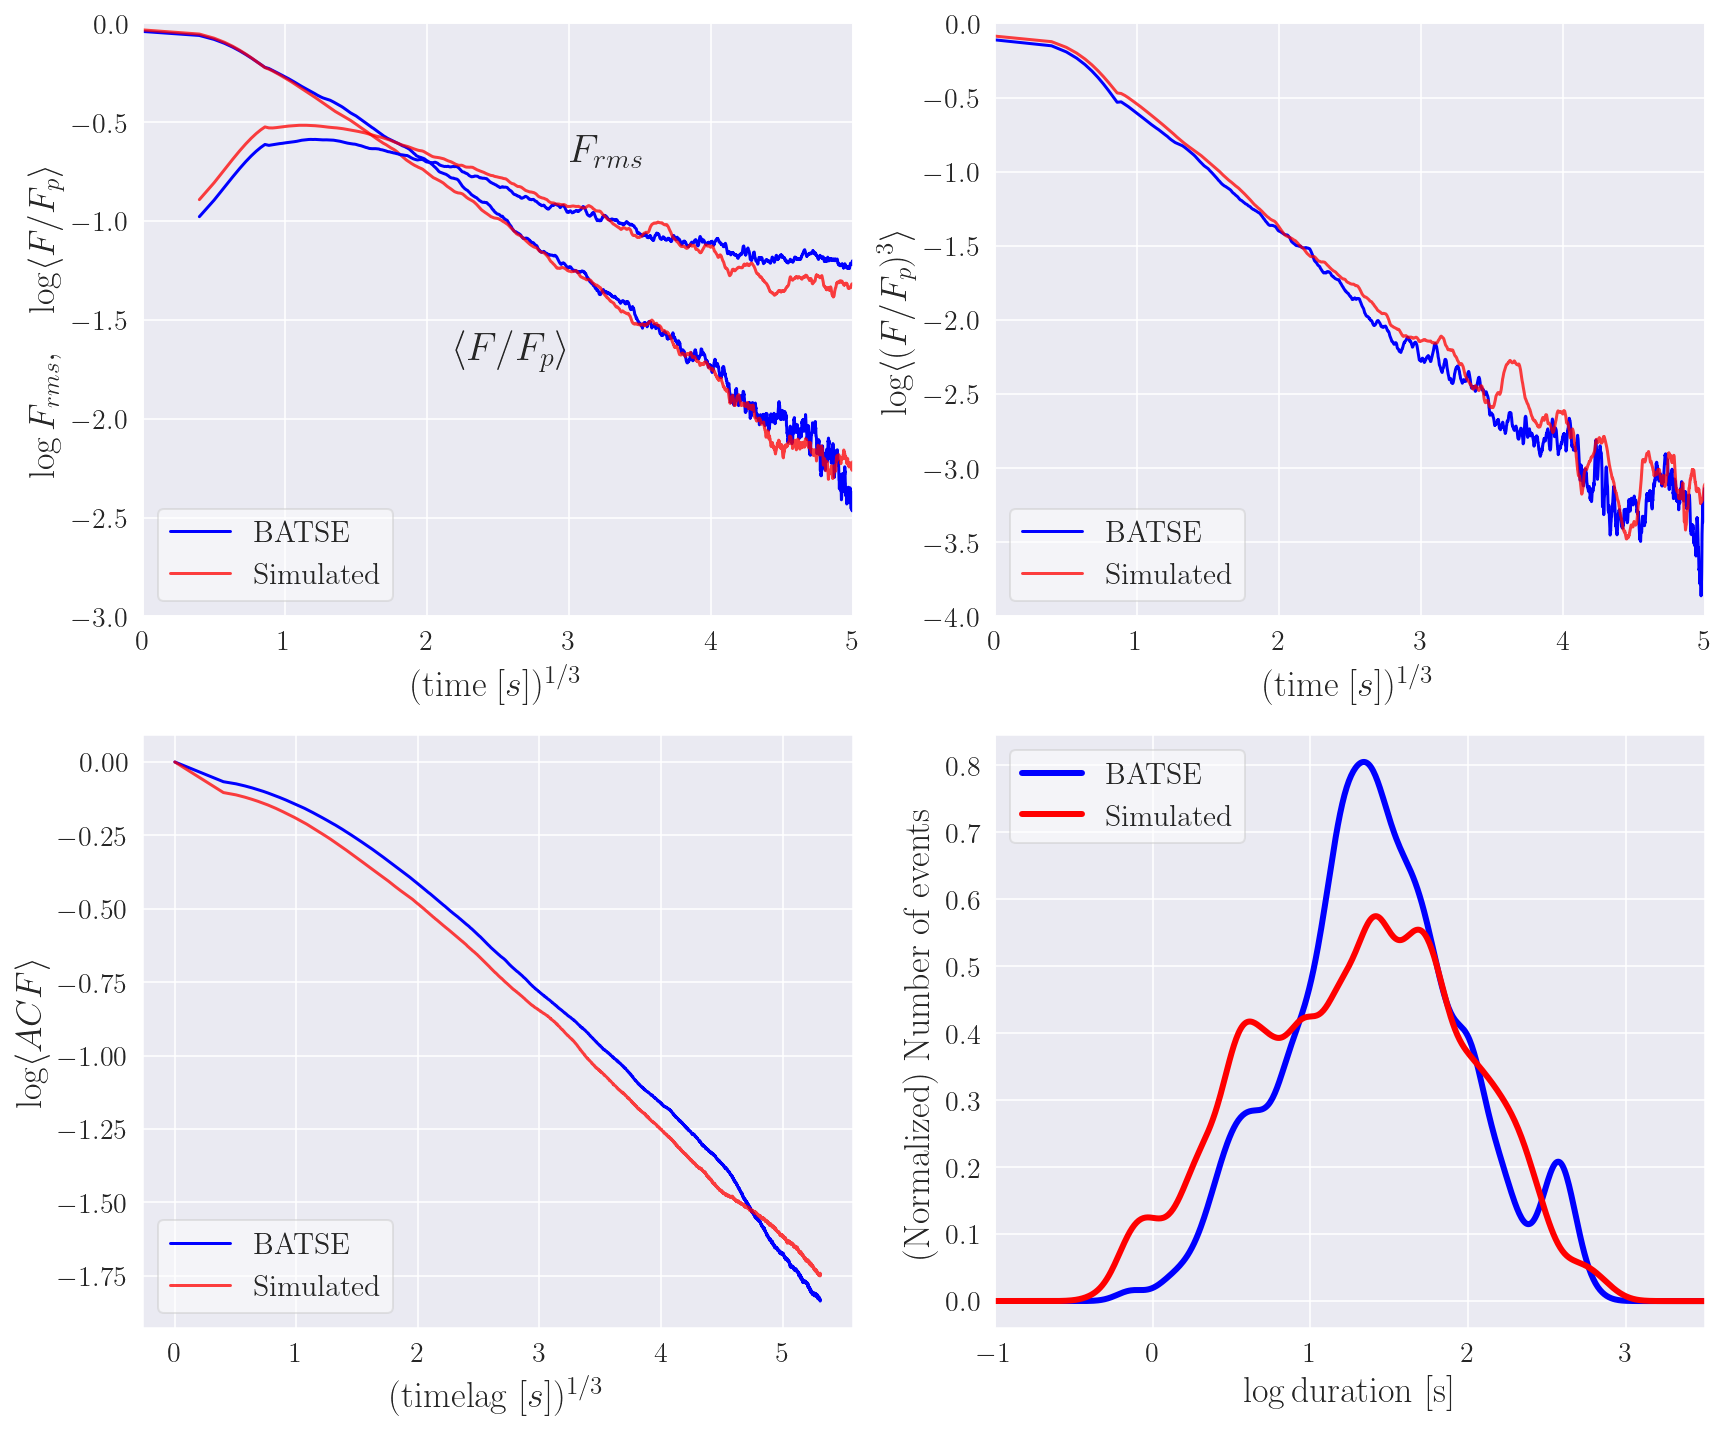

In [ ]:
# hist = False
# log  = True
make_plot(instrument='batse',
          test_times=test_times_batse, 
          averaged_fluxes=averaged_fluxes_batse,           averaged_fluxes_sim=averaged_fluxes_sim_batse,
          averaged_fluxes_rms=averaged_fluxes_rms_batse,   averaged_fluxes_rms_sim=averaged_fluxes_rms_sim_batse,
          averaged_fluxes_cube=averaged_fluxes_cube_batse, averaged_fluxes_cube_sim=averaged_fluxes_cube_sim_batse,
          steps=steps_batse, steps_sim=steps_sim, bin_time=bin_time_batse, acf=acf_batse, acf_sim=acf_sim,
          duration=duration_batse, duration_sim=duration_sim_batse, hist=False, log=True)

In [6]:
def evaluateDuration20_(times, counts, t90=None, t90_frac=15, bin_time=None, filter=True):
    if filter:
        t90_frac = t90_frac
        window   = int(t90/t90_frac/bin_time)+1
        window   = window if window%2==1 else window+1
        #try:
        #print(window)
        counts = savgol_filter(x=counts,
                                window_length=window,
                                polyorder=2)
        #except:
        #    #print('window_length =', window)
        #    print('Error in "evaluateDuration20()" during the "savgol_filter()"...')
        #    exit()

    threshold_level = 0.2
    c_max           = np.max(counts)
    c_threshold     = c_max * threshold_level
    selected_times  = times[counts >= c_threshold]
    tstart          = selected_times[ 0]
    tstop           = selected_times[-1]
    duration        = tstop - tstart # T20
    assert duration>0
    return np.array( [duration, tstart, tstop, window] )

#------------------------------------------------------------------------------#

def smoothLC(grb, t90_frac=15, filter=True):

    times  = grb.times
    counts = grb.counts
    t90    = grb.t90
    bin_time = 0.064
    if filter:
        t90_frac = t90_frac
        window   = int(t90/t90_frac/bin_time)+2
        window   = window if window%2==1 else window+1
        try:
            counts = savgol_filter(x=counts,
                                   window_length=window,
                                   polyorder=2)
        except:
            #print('window_length =', window)
            print('Error in "evaluateDuration20()" during the "savgol_filter()"...')
            exit()
    threshold_level = 0.2
    c_max           = np.max(counts)
    c_threshold     = c_max * threshold_level
    selected_times  = times[counts >= c_threshold]
    tstart          = selected_times[ 0]
    tstop           = selected_times[-1]
    duration        = tstop - tstart # T20
    assert duration>0
    print('window =', window)
    print('T20%   =', duration)
    return counts

The `window=t90/15` works better than `window=t90/5`, since it works both for GRBs with small and large T90! (see the two examples below)

window = 25
T20%   = 2.176
window = 9
T20%   = 2.1759996


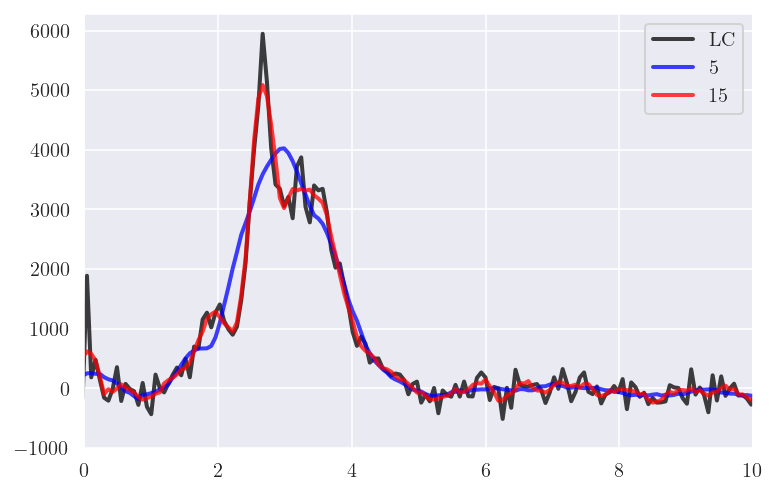

-1


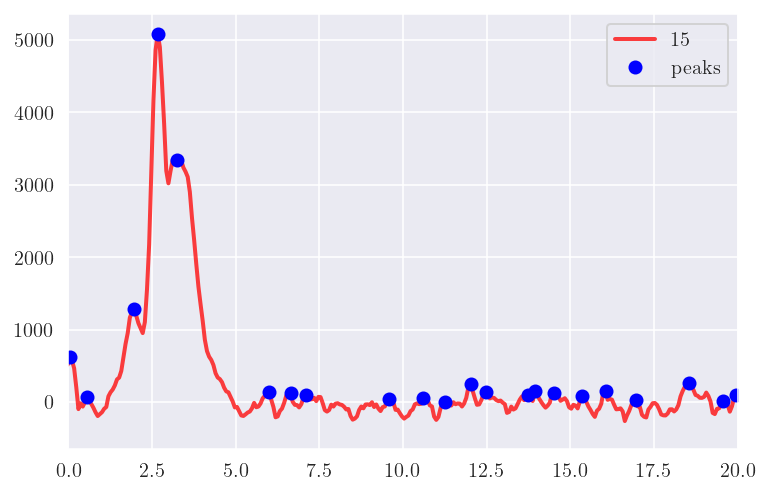

In [57]:
indx        = 1
times       = grb_list_sim_batse[indx].times
cnts        = grb_list_sim_batse[indx].counts
cnts_smooth_5  = smoothLC(grb_list_sim_batse[indx], t90_frac=5)
cnts_smooth_15 = smoothLC(grb_list_sim_batse[indx], t90_frac=15)
plt.plot(times, cnts,           lw=2, c='k', alpha=0.75, label='LC')
plt.plot(times, cnts_smooth_5,  lw=2, c='b', alpha=0.75, label='5')
plt.plot(times, cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.xlim(0,10)
plt.legend()
plt.show()

print(grb_list_sim_batse[indx].num_of_sig_pulses)

from scipy.signal import find_peaks
peaks, _        = find_peaks(cnts,           distance=2, height=0, width=2, rel_height=0.5)
peaks_smooth, _ = find_peaks(cnts_smooth_15, distance=2, height=0, width=2, rel_height=0.5)
plt.plot(times,              cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.plot(peaks_smooth*0.064-10, cnts_smooth_15[peaks_smooth],  "o", c='b', label='peaks')
plt.xlim(0,20)
plt.legend()
plt.show()

window = 201
T20%   = 26.432
window = 69
T20%   = 23.424


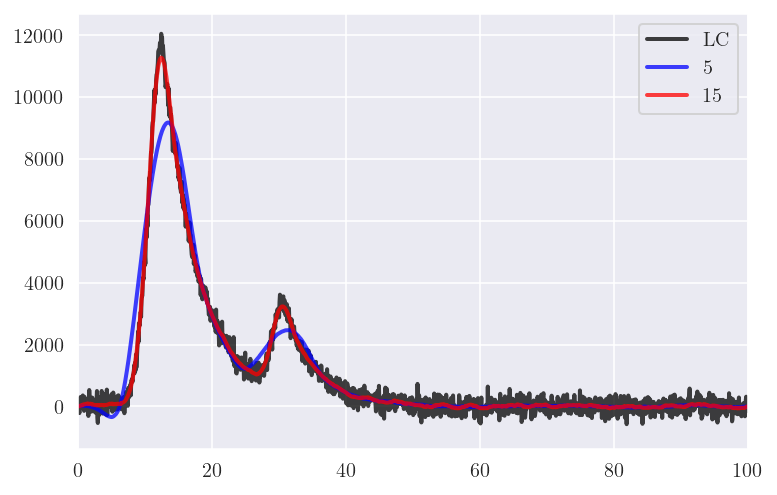

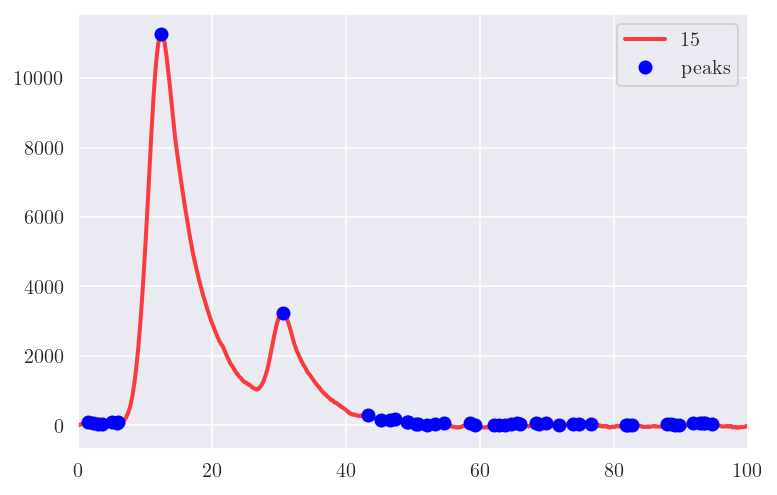

In [55]:
indx        = 2
times       = grb_list_sim_batse[indx].times
cnts        = grb_list_sim_batse[indx].counts
cnts_smooth_5  = smoothLC(grb_list_sim_batse[indx], t90_frac=5)
cnts_smooth_15 = smoothLC(grb_list_sim_batse[indx], t90_frac=15)
plt.plot(times, cnts,           lw=2, c='k', alpha=0.75, label='LC')
plt.plot(times, cnts_smooth_5,  lw=2, c='b', alpha=0.75, label='5')
plt.plot(times, cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.xlim(0,100)
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks, _        = find_peaks(cnts,           distance=2, height=0, width=2, rel_height=0.5)
peaks_smooth, _ = find_peaks(cnts_smooth_15, distance=2, height=0, width=2, rel_height=0.5)
plt.plot(times,              cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.plot(peaks_smooth*0.064-10, cnts_smooth_15[peaks_smooth],  "o", c='b', label='peaks')
plt.xlim(0,100)
plt.legend()
plt.show()

window = 1351
T20%   = 75.583984
window = 451
T20%   = 55.744003


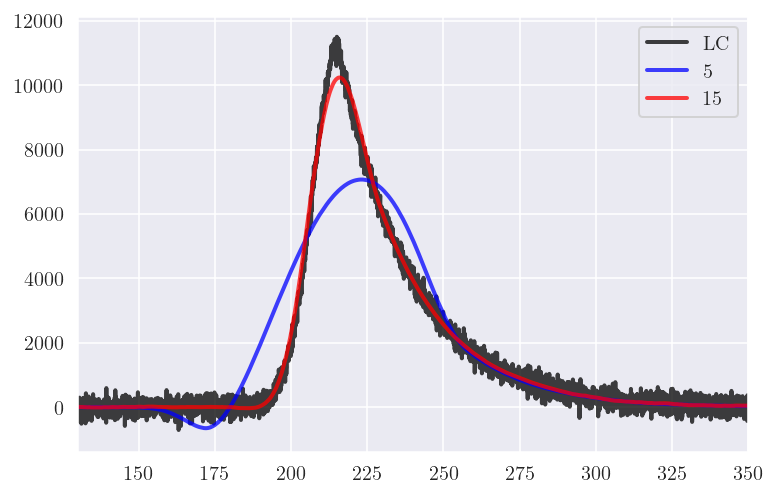

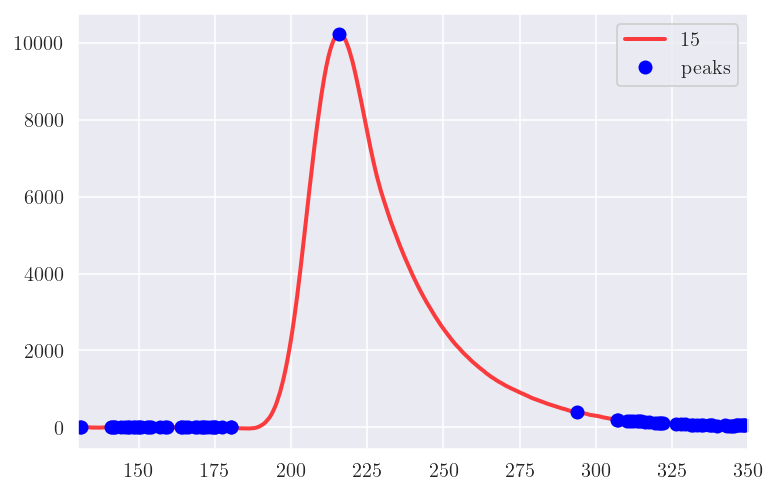

In [56]:
indx        = 10
times       = grb_list_sim_batse[indx].times
cnts        = grb_list_sim_batse[indx].counts
cnts_smooth_5  = smoothLC(grb_list_sim_batse[indx], t90_frac=5)
cnts_smooth_15 = smoothLC(grb_list_sim_batse[indx], t90_frac=15)
plt.plot(times, cnts,           lw=2, c='k', alpha=0.75, label='LC')
plt.plot(times, cnts_smooth_5,  lw=2, c='b', alpha=0.75, label='5')
plt.plot(times, cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.xlim(130,350)
plt.legend()
plt.show()

from scipy.signal import find_peaks
peaks, _        = find_peaks(cnts,           distance=2, height=0, width=2, rel_height=0.5)
peaks_smooth, _ = find_peaks(cnts_smooth_15, distance=2, height=0, width=2, rel_height=0.5)
plt.plot(times,              cnts_smooth_15, lw=2, c='r', alpha=0.75, label='15')
plt.plot(peaks_smooth*0.064-10, cnts_smooth_15[peaks_smooth],  "o", c='b', label='peaks')
plt.xlim(130,350)
plt.legend()
plt.show()

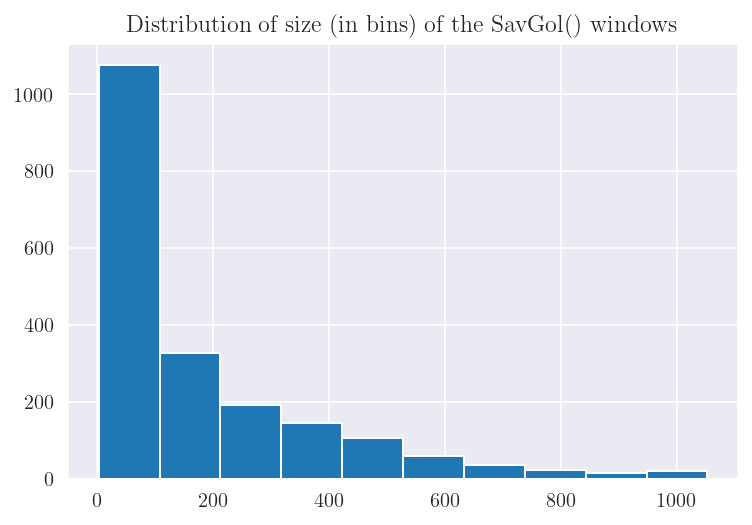

In [31]:
w_list = []
for i, grb in enumerate(grb_list_sim_batse):
    times    = grb.times
    counts   = grb.counts
    t90      = grb.t90
    bin_time = 0.064
    #print('@@@ ', i)
    #print(t90)
    window   = evaluateDuration20_(times, counts, t90=t90, t90_frac=15, bin_time=bin_time, filter=True)[3]
    #print('================')
    w_list.append(window)

plt.hist(np.array(w_list))
plt.title(r'Distribution of size (in bins) of the SavGol() windows')
plt.show()

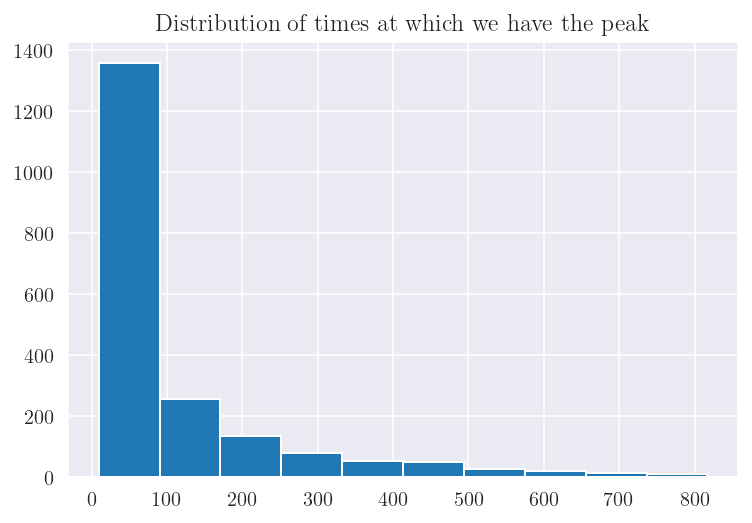

In [32]:
tmax_list = []
for grb in grb_list_sim_batse:
    counts = grb.counts
    t_max  = np.argmax(counts)
    tmax_list.append(t_max)

plt.hist(np.array(tmax_list)*0.064)
plt.title(r'Distribution of times at which we have the peak')
plt.show()

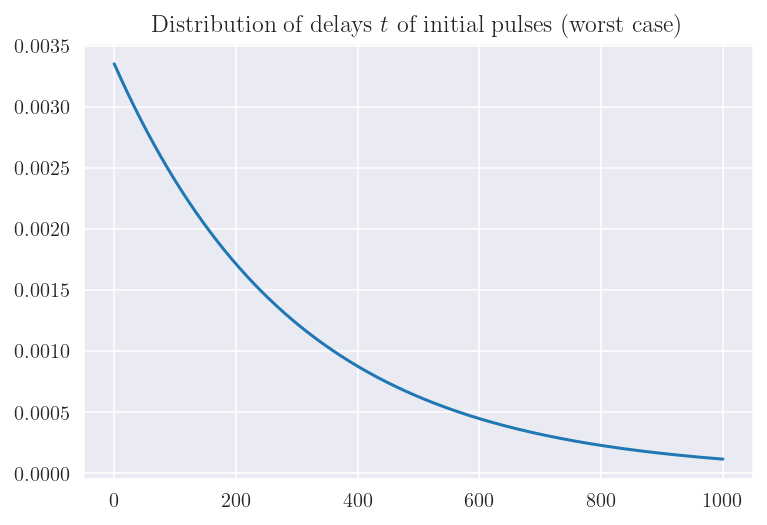

In [33]:
tau_0 = 45.9   # max value of the interval
#tau_0 = 6e-6  # min value of the interval
alpha = 6.5

t = np.linspace(0,1000,1000)
p = (1./(alpha*tau_0)) * np.exp(-t/(alpha*tau_0))

plt.plot(t, p)
plt.title(r'Distribution of delays $t$ of initial pulses (worst case)')
plt.show()

In [34]:
res = []
bin_time = 0.064
for grb in grb_list_sim_batse:
    res.append([ evaluateDuration20(grb.times, grb.counts, t90=grb.t90, t90_frac=i, bin_time=bin_time, filter=True)[0] for i in range(5,101)])

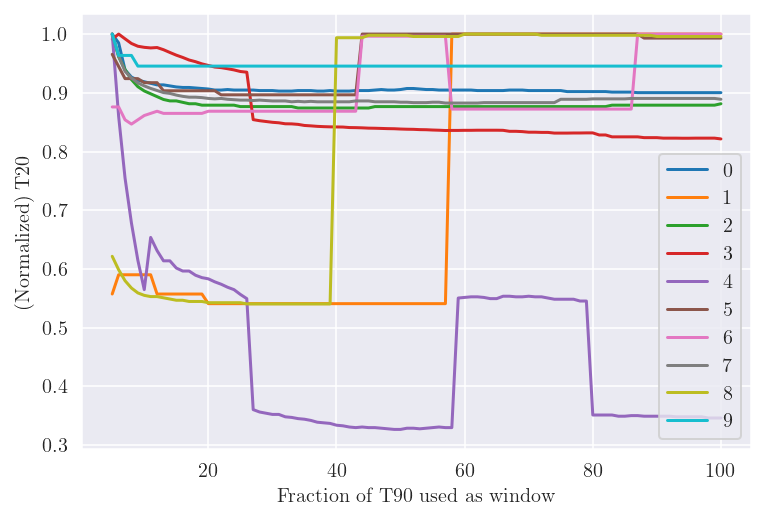

In [52]:
fracs = range(5,101)
for i in range(0,10):
    plt.plot(fracs, res[i]/np.max(res[i]), label=i)
plt.ylabel('(Normalized) T20')
plt.xlabel('Fraction of T90 used as window')
plt.legend()

(0.0, 1.0)

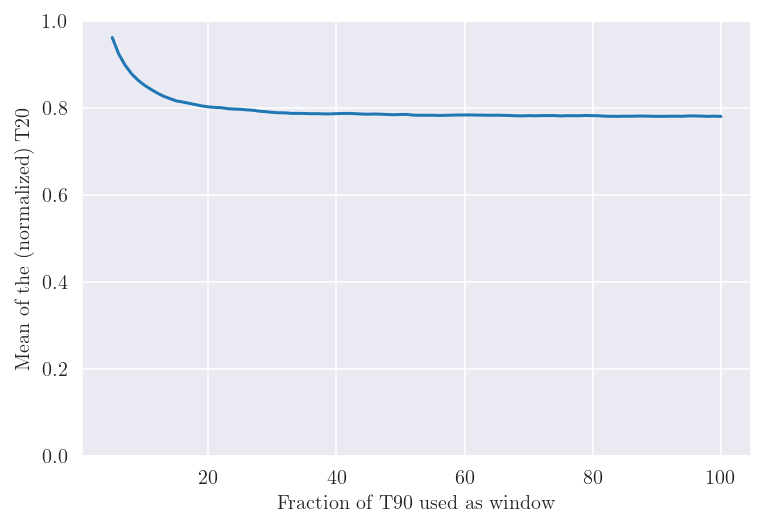

In [51]:
norm_res = []
for i in range(len(res)):
    norm_res.append(np.array(res[i])/np.max(res[i]))

avg_res = np.zeros_like(norm_res[0])
for i in range(len(norm_res)):
    avg_res += norm_res[i]
avg_res = avg_res / len(norm_res)

plt.plot(fracs, avg_res)
plt.ylabel('Mean of the (normalized) T20')
plt.xlabel('Fraction of T90 used as window')
plt.ylim(0,1)